In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [246]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [247]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [248]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [249]:
from scipy.optimize import minimize

### Ansatz State

In [250]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [251]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [252]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [253]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [254]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [255]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [256]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [257]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    print(sum(proba_distribution.values()))
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    print(counts)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [258]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [259]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [260]:
from qiskit import assemble, transpile
import random

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [261]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [262]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [263]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [264]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [265]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(exact_eigenvalue, margin=3)

## Visualization

In [266]:
approximated_energies = []

In [267]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [268]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [269]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [270]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

3it [00:00, 27.43it/s]

{'1001': 82, '1010': 240, '0101': 68, '0010': 10, '1011': 47, '0000': 97, '1000': 64, '0111': 95, '0110': 67, '0001': 67, '1101': 40, '0011': 74, '1110': 59, '0100': 7, '1100': 5, '1111': 2}
1.0
{'1111': 63, '0110': 88, '0000': 59, '1001': 165, '1010': 194, '0010': 122, '0111': 62, '1100': 37, '0001': 21, '1000': 24, '0011': 58, '1011': 66, '1101': 4, '1110': 19, '0100': 33, '0101': 9}
1.0
{'0010': 63, '1000': 209, '0000': 79, '1010': 42, '0011': 216, '1101': 33, '0100': 39, '0101': 50, '1011': 52, '0110': 52, '1001': 25, '1110': 81, '1100': 4, '1111': 41, '0001': 34, '0111': 4}
1.0
{'1100': 123, '1011': 37, '0101': 97, '1111': 207, '0110': 175, '0100': 63, '0111': 14, '1000': 49, '1110': 64, '1001': 44, '0011': 33, '0000': 95, '1010': 8, '0010': 7, '0001': 7, '1101': 1}
1.0
{'1100': 121, '0011': 39, '1111': 216, '0110': 195, '0100': 54, '1001': 44, '0000': 71, '1000': 34, '0101': 77, '1110': 94, '1011': 39, '1010': 13, '0111': 15, '1101': 2, '0010': 8, '0001': 2}
1.0


9it [00:00, 21.18it/s]

{'0111': 12, '0000': 103, '1110': 85, '0101': 84, '0110': 154, '1111': 206, '0100': 62, '0011': 35, '1000': 48, '1100': 122, '1001': 51, '1011': 31, '0001': 4, '0010': 11, '1101': 6, '1010': 10}
1.0
{'1000': 25, '0111': 230, '0011': 95, '1100': 111, '1101': 39, '0100': 62, '1001': 54, '1110': 188, '1111': 47, '0000': 49, '1010': 40, '0110': 46, '0001': 12, '0101': 5, '1011': 18, '0010': 3}
1.0
{'0101': 152, '1110': 179, '1011': 6, '0010': 61, '1111': 42, '0110': 138, '1001': 137, '0011': 25, '1100': 85, '0111': 115, '0100': 15, '1101': 11, '0000': 26, '1000': 28, '1010': 2, '0001': 2}
1.0
{'0001': 80, '1010': 230, '1001': 109, '0101': 67, '0011': 87, '0111': 91, '0110': 52, '1101': 40, '1000': 70, '0000': 96, '1110': 53, '1011': 31, '0010': 11, '1100': 2, '0100': 4, '1111': 1}
1.0
{'0110': 58, '1101': 46, '1000': 68, '0000': 90, '1011': 38, '0011': 71, '1010': 230, '0111': 77, '0010': 14, '0001': 79, '1110': 62, '1001': 97, '0101': 79, '0100': 12, '1111': 1, '1100': 2}
1.0


15it [00:00, 24.62it/s]

{'1010': 219, '1001': 98, '0110': 70, '1000': 65, '0000': 89, '1110': 59, '0101': 65, '1011': 48, '0001': 75, '0011': 85, '0100': 6, '1101': 39, '0010': 17, '0111': 82, '1100': 7}
1.0
{'1001': 98, '0001': 91, '1010': 238, '1000': 78, '0101': 64, '1011': 41, '0110': 54, '0100': 4, '0000': 94, '0111': 76, '1110': 49, '1101': 48, '0011': 73, '0010': 7, '1100': 7, '1111': 2}
1.0
{'1000': 66, '0000': 125, '1110': 66, '1010': 172, '1011': 64, '0011': 134, '1100': 36, '0111': 117, '0010': 48, '1001': 58, '1111': 36, '1101': 40, '0001': 31, '0100': 10, '0110': 12, '0101': 9}
1.0
{'0011': 81, '1001': 102, '0001': 82, '1010': 233, '0111': 73, '0101': 78, '1110': 61, '1011': 36, '0000': 80, '1000': 67, '0110': 53, '0010': 18, '1101': 47, '1100': 8, '0100': 5}
1.0
{'1010': 237, '0001': 75, '1001': 97, '0110': 66, '0011': 80, '0000': 84, '0101': 63, '1110': 44, '0111': 93, '1011': 34, '1000': 70, '1101': 55, '1100': 9, '0010': 13, '0100': 4}
1.0
{'0011': 73, '0000': 89, '1000': 61, '1101': 44, '000

21it [00:00, 26.10it/s]

{'0000': 88, '1000': 81, '1010': 236, '0011': 77, '1100': 3, '1101': 58, '0111': 71, '0101': 66, '1011': 36, '0010': 11, '1110': 57, '1001': 100, '0001': 78, '0110': 57, '0100': 4, '1111': 1}
1.0
{'0111': 137, '0011': 130, '1111': 46, '1010': 156, '1001': 57, '1011': 64, '0010': 40, '0000': 158, '1000': 41, '0001': 35, '1110': 73, '1100': 47, '0101': 9, '0100': 5, '1101': 25, '0110': 1}
1.0
{'0000': 152, '1110': 78, '0111': 119, '0011': 129, '1100': 44, '0010': 50, '1011': 61, '1111': 50, '1001': 59, '1101': 28, '1010': 149, '0100': 13, '0001': 35, '1000': 49, '0101': 3, '0110': 5}
1.0
{'0000': 92, '1000': 55, '1010': 257, '0001': 75, '1011': 33, '0011': 76, '0101': 78, '1101': 55, '1001': 91, '0111': 74, '1110': 59, '0110': 59, '0010': 11, '0100': 4, '1100': 4, '1111': 1}
1.0
{'1000': 58, '0000': 81, '0011': 90, '1010': 232, '0001': 78, '0110': 70, '1110': 55, '0101': 77, '1001': 86, '1101': 52, '1011': 50, '0111': 72, '1100': 7, '0010': 13, '0100': 3}
1.0


24it [00:01, 23.36it/s]

{'1001': 93, '1010': 219, '0110': 49, '0000': 102, '0101': 69, '1101': 61, '0111': 94, '1011': 38, '0011': 66, '0001': 78, '1110': 71, '1000': 61, '0010': 12, '1111': 2, '1100': 6, '0100': 3}
1.0
{'0111': 84, '0000': 90, '1000': 52, '1010': 254, '0110': 59, '0101': 63, '0011': 82, '1011': 38, '1001': 107, '0010': 13, '1101': 41, '1110': 59, '0001': 74, '0100': 5, '1100': 3}
1.0
{'0001': 61, '1010': 234, '0101': 86, '1000': 56, '0000': 95, '1101': 59, '0110': 71, '0111': 81, '1110': 71, '0011': 60, '1001': 89, '1011': 34, '1100': 7, '0010': 13, '0100': 6, '1111': 1}
1.0
{'1101': 56, '1010': 218, '0001': 82, '1110': 61, '0101': 72, '0011': 70, '0000': 101, '0110': 59, '1000': 74, '1001': 99, '0111': 82, '0100': 4, '1011': 28, '1100': 4, '1111': 1, '0010': 13}
1.0
{'0100': 9, '0000': 84, '1000': 60, '0001': 81, '1010': 243, '1110': 53, '1011': 34, '0111': 77, '0011': 77, '1101': 62, '1001': 92, '0101': 76, '0110': 63, '0010': 8, '1111': 2, '1100': 3}
1.0


27it [00:01, 23.63it/s]


{'1010': 236, '1001': 100, '0001': 87, '0111': 70, '1101': 50, '0000': 88, '0110': 58, '0011': 88, '1110': 61, '1011': 32, '1000': 63, '0101': 64, '0010': 15, '0100': 4, '1100': 7, '1111': 1}
1.0


3it [00:00, 25.82it/s]

{'1001': 21, '1010': 181, '1000': 8, '1011': 48, '0101': 76, '1111': 13, '1100': 29, '0111': 115, '0000': 116, '0011': 69, '0110': 107, '0001': 90, '0100': 43, '1101': 56, '1110': 40, '0010': 12}
1.0
{'0010': 106, '1011': 92, '1001': 105, '1111': 106, '0110': 59, '0011': 75, '0111': 160, '0000': 115, '0100': 96, '0101': 13, '1100': 30, '1010': 47, '1110': 1, '1000': 2, '1101': 8, '0001': 9}
1.0
{'0000': 52, '1000': 164, '0011': 150, '0101': 60, '1110': 155, '1101': 126, '1010': 7, '1011': 127, '1001': 14, '1111': 76, '0001': 14, '0110': 27, '0100': 5, '0010': 29, '1100': 8, '0111': 10}
1.0
{'1010': 15, '1001': 40, '0110': 132, '1111': 228, '0101': 95, '0000': 132, '1101': 19, '1011': 40, '0010': 36, '0111': 62, '1100': 31, '1000': 8, '0001': 35, '0100': 81, '0011': 54, '1110': 16}
1.0
{'0100': 80, '0101': 110, '1111': 201, '0110': 149, '0000': 124, '1001': 35, '0001': 32, '0111': 48, '1110': 22, '1000': 8, '0011': 58, '1010': 24, '0010': 48, '1101': 22, '1011': 41, '1100': 22}
1.0


6it [00:00, 26.40it/s]

{'1111': 187, '0110': 158, '0100': 75, '1001': 25, '0101': 128, '0000': 142, '1011': 37, '0011': 56, '1100': 30, '0001': 29, '1101': 28, '0010': 39, '0111': 44, '1110': 23, '1000': 10, '1010': 13}
1.0


10it [00:00, 27.44it/s]

{'0111': 179, '0110': 93, '1110': 173, '1101': 35, '0001': 47, '0011': 122, '1000': 30, '0000': 98, '1010': 26, '1001': 33, '0100': 63, '0101': 24, '1111': 42, '1100': 31, '1011': 11, '0010': 17}
1.0
{'1110': 127, '0101': 46, '0111': 99, '0001': 30, '1001': 168, '1111': 155, '0000': 22, '1100': 161, '0010': 75, '0110': 38, '1010': 63, '1011': 1, '0100': 23, '0011': 13, '1000': 2, '1101': 1}
1.0
{'0001': 87, '1010': 206, '0101': 56, '0100': 48, '1101': 40, '0110': 95, '1011': 46, '0111': 108, '0000': 132, '0011': 65, '1111': 34, '1110': 46, '0010': 15, '1001': 12, '1100': 26, '1000': 8}
1.0
{'0110': 97, '1111': 17, '1010': 193, '0001': 91, '0100': 48, '0111': 116, '0000': 115, '0011': 66, '1101': 57, '1110': 50, '0101': 62, '1000': 9, '1100': 35, '1011': 48, '0010': 11, '1001': 9}
1.0
{'1010': 186, '0001': 103, '0100': 50, '1101': 52, '0110': 112, '0111': 122, '0000': 116, '1011': 42, '0101': 64, '1100': 35, '1001': 11, '1111': 16, '0010': 12, '1110': 34, '0011': 58, '1000': 11}
1.0


16it [00:00, 23.13it/s]

{'1100': 25, '0011': 67, '1011': 53, '0000': 127, '1110': 44, '0111': 118, '0001': 111, '0110': 91, '1010': 177, '1000': 15, '1101': 53, '0101': 68, '0100': 41, '1001': 10, '1111': 15, '0010': 9}
1.0
{'1011': 40, '0010': 18, '1110': 120, '0011': 86, '1100': 59, '1001': 105, '1010': 190, '0000': 129, '0111': 76, '1111': 117, '0100': 23, '1101': 52, '0101': 4, '0110': 2, '1000': 2, '0001': 1}
1.0
{'0000': 130, '1010': 171, '0001': 107, '1011': 48, '0011': 68, '0110': 110, '1111': 13, '0101': 78, '1110': 40, '0111': 110, '1101': 49, '0100': 49, '1100': 18, '1001': 15, '0010': 10, '1000': 8}
1.0
{'0001': 90, '1010': 185, '0110': 102, '1101': 45, '0000': 133, '0111': 104, '1011': 54, '0101': 71, '1000': 14, '0011': 70, '0100': 47, '0010': 13, '1001': 13, '1110': 40, '1100': 30, '1111': 13}
1.0
{'0011': 68, '1010': 185, '0001': 84, '0111': 118, '0000': 127, '0101': 80, '1110': 41, '0110': 102, '1100': 24, '1111': 18, '0100': 51, '1000': 6, '1101': 50, '1011': 42, '1001': 16, '0010': 12}
1.0


23it [00:00, 27.40it/s]

{'1011': 54, '0010': 12, '1010': 192, '0110': 104, '0111': 119, '0011': 55, '0000': 117, '0100': 63, '0001': 102, '1110': 35, '0101': 72, '1111': 14, '1100': 20, '1101': 43, '1000': 5, '1001': 17}
1.0
{'1010': 160, '1001': 105, '1000': 2, '0000': 126, '1110': 118, '1101': 47, '1111': 156, '0111': 86, '1100': 67, '0010': 15, '0011': 80, '0100': 19, '1011': 34, '0110': 2, '0101': 3, '0001': 4}
1.0
{'0000': 142, '0111': 92, '1100': 62, '0011': 86, '1010': 162, '1001': 90, '0100': 20, '1110': 117, '1111': 125, '1011': 44, '1101': 56, '0010': 16, '0101': 3, '1000': 4, '0110': 1, '0001': 4}
1.0
{'1111': 21, '0110': 107, '1011': 59, '1101': 56, '0100': 54, '0011': 63, '1000': 12, '0111': 101, '0000': 122, '1010': 181, '1110': 35, '0001': 92, '1100': 21, '0101': 76, '1001': 16, '0010': 8}
1.0
{'1010': 176, '0001': 127, '1101': 43, '0100': 52, '0111': 111, '0110': 100, '1100': 29, '0000': 113, '1001': 14, '0011': 65, '1011': 55, '1111': 11, '1110': 40, '0101': 76, '1000': 6, '0010': 6}
1.0
{'01

27it [00:01, 26.26it/s]


{'0011': 71, '1010': 165, '0001': 91, '0111': 114, '0100': 54, '1101': 44, '0110': 99, '0101': 70, '1111': 21, '0000': 132, '1110': 39, '1100': 34, '1011': 55, '0010': 12, '1001': 18, '1000': 5}
1.0
{'0110': 116, '1011': 48, '0010': 4, '0001': 108, '1010': 163, '0111': 101, '1100': 39, '0000': 142, '0011': 67, '1101': 45, '1110': 44, '0100': 44, '1001': 16, '0101': 65, '1000': 15, '1111': 7}
1.0
{'0011': 78, '1010': 177, '0000': 141, '0111': 118, '0100': 50, '1110': 39, '0101': 47, '0110': 123, '1011': 43, '0001': 90, '1101': 38, '1100': 21, '1000': 14, '1001': 22, '1111': 19, '0010': 4}
1.0
{'0000': 126, '1011': 54, '0011': 70, '0111': 127, '0110': 94, '0001': 112, '1110': 46, '0101': 82, '1010': 152, '1101': 57, '0100': 32, '1001': 18, '1100': 31, '0010': 3, '1111': 12, '1000': 8}
1.0


0it [00:00, ?it/s]

{'0001': 71, '1010': 181, '0111': 125, '1000': 180, '0110': 41, '1111': 24, '1011': 38, '0101': 64, '0011': 118, '0100': 29, '1001': 9, '1110': 65, '1101': 10, '0000': 56, '1100': 10, '0010': 3}
1.0


2it [00:00, 13.62it/s]

{'1001': 98, '1010': 198, '0110': 122, '1111': 84, '0010': 180, '1011': 116, '0111': 110, '1100': 5, '0100': 8, '0011': 46, '1110': 16, '1101': 16, '0001': 14, '1000': 5, '0000': 6}
1.0
{'1111': 129, '0100': 45, '1100': 10, '1000': 104, '0000': 100, '0111': 36, '1011': 16, '1001': 79, '0011': 151, '1010': 113, '1110': 63, '0101': 25, '0010': 55, '0110': 45, '1101': 46, '0001': 7}
1.0
{'1111': 208, '0110': 161, '1100': 96, '0011': 54, '1101': 34, '0100': 131, '0111': 54, '0101': 66, '0010': 30, '1110': 73, '0001': 14, '1001': 41, '1010': 22, '1000': 22, '0000': 16, '1011': 2}


4it [00:00, 15.67it/s]

1.0
{'0110': 135, '1111': 215, '0101': 67, '0111': 62, '0000': 11, '1000': 36, '0100': 124, '1100': 87, '1101': 35, '1010': 25, '1110': 78, '0011': 64, '1001': 42, '0010': 22, '0001': 19, '1011': 2}
1.0
{'0110': 118, '1111': 236, '1100': 109, '0100': 140, '1001': 46, '0010': 33, '1110': 72, '0000': 23, '0111': 47, '0011': 51, '0101': 53, '1000': 24, '1101': 32, '1010': 25, '0001': 11, '1011': 4}
1.0


10it [00:00, 23.67it/s]

{'0011': 82, '1100': 87, '0110': 120, '1110': 288, '0111': 280, '0000': 15, '0001': 4, '1010': 51, '1101': 19, '1111': 35, '1011': 13, '1000': 9, '0100': 5, '0010': 3, '1001': 10, '0101': 3}
1.0
{'1011': 57, '0111': 193, '1111': 20, '0110': 59, '0100': 68, '0000': 52, '1100': 137, '1110': 197, '1101': 49, '0011': 14, '0010': 23, '1010': 12, '0101': 92, '1000': 20, '1001': 26, '0001': 5}
1.0
{'1001': 12, '0001': 89, '1010': 157, '1000': 173, '0000': 39, '1110': 83, '0101': 70, '1101': 8, '0100': 32, '1111': 18, '0110': 48, '0111': 132, '1100': 15, '1011': 44, '0011': 104}
1.0
{'0000': 57, '1000': 181, '0111': 123, '1010': 169, '1101': 7, '0011': 122, '0110': 34, '1011': 37, '0100': 38, '0001': 86, '1110': 71, '1100': 17, '0101': 53, '1111': 24, '0010': 1, '1001': 4}
1.0
{'0001': 70, '1010': 183, '1000': 188, '0011': 115, '1011': 34, '0111': 127, '0101': 67, '1110': 70, '0010': 1, '1100': 14, '0000': 53, '1101': 10, '0100': 30, '0110': 34, '1001': 7, '1111': 21}
1.0
{'1010': 185, '0001':

16it [00:00, 23.80it/s]

{'0100': 8, '0011': 137, '0111': 125, '1111': 83, '1011': 74, '0010': 80, '1010': 249, '0000': 70, '1110': 128, '0110': 4, '1101': 3, '1000': 15, '1100': 14, '0001': 21, '1001': 11, '0101': 2}
1.0
{'1110': 71, '0101': 68, '0010': 1, '1000': 184, '0001': 58, '1010': 189, '0111': 117, '0100': 23, '1101': 9, '0011': 135, '0000': 48, '1001': 11, '1011': 45, '1111': 22, '0110': 35, '1100': 8}
1.0
{'1000': 203, '0001': 85, '1001': 11, '1010': 165, '0011': 113, '0101': 70, '1110': 73, '1111': 27, '0110': 35, '0100': 30, '0111': 108, '0000': 42, '1011': 44, '1100': 7, '0010': 3, '1101': 8}
1.0
{'1010': 187, '1011': 43, '1000': 194, '0000': 52, '0111': 120, '0101': 68, '1110': 58, '0011': 100, '1101': 8, '0100': 38, '0001': 69, '0110': 52, '1111': 19, '1100': 14, '1001': 2}
1.0
{'0011': 109, '0001': 73, '1010': 183, '0100': 30, '0110': 58, '1000': 179, '0111': 123, '1110': 52, '0010': 2, '1011': 50, '0000': 58, '1101': 7, '1111': 23, '0101': 60, '1100': 10, '1001': 7}
1.0


19it [00:00, 18.41it/s]

{'0000': 91, '0010': 97, '0011': 147, '0111': 133, '1110': 130, '1111': 69, '1010': 209, '0100': 13, '1011': 56, '1100': 13, '0001': 25, '1000': 13, '0110': 7, '1101': 12, '1001': 5, '0101': 4}
1.0
{'0011': 135, '1111': 80, '1010': 215, '1001': 14, '0111': 166, '0010': 82, '1110': 126, '0000': 77, '1000': 12, '1011': 55, '1100': 13, '0001': 31, '1101': 3, '0110': 5, '0100': 10}
1.0
{'0001': 86, '1010': 187, '0111': 136, '1000': 172, '0011': 94, '1111': 25, '0101': 67, '1011': 36, '0100': 37, '1110': 68, '0000': 48, '1100': 11, '1101': 10, '0110': 40, '0010': 1, '1001': 6}
1.0
{'1000': 169, '1010': 176, '0100': 40, '1100': 13, '0011': 87, '0111': 135, '1011': 41, '1110': 76, '0101': 68, '1101': 12, '1001': 8, '1111': 27, '0110': 50, '0000': 47, '0001': 74, '0010': 1}
1.0


25it [00:01, 21.42it/s]

{'0001': 64, '1010': 192, '1101': 16, '1000': 173, '0000': 49, '0111': 118, '0011': 123, '0101': 63, '1011': 44, '0110': 41, '0100': 33, '1111': 28, '1110': 66, '1001': 7, '1100': 7}
1.0
{'0001': 79, '1010': 192, '0011': 115, '0111': 122, '1011': 30, '0000': 54, '1000': 192, '1110': 63, '0100': 30, '0101': 54, '1111': 25, '1101': 6, '1100': 17, '1001': 7, '0110': 35, '0010': 3}
1.0
{'1010': 182, '1110': 82, '0101': 67, '0111': 129, '1000': 159, '0000': 44, '0011': 112, '1011': 34, '1111': 33, '0100': 32, '0001': 87, '0110': 35, '1100': 9, '1101': 11, '1001': 8}
1.0
{'0011': 108, '1010': 182, '0111': 112, '1111': 26, '1101': 15, '0101': 78, '0000': 39, '1000': 194, '0001': 86, '1110': 63, '0110': 38, '0100': 31, '1011': 36, '1100': 8, '1001': 8}
1.0


27it [00:01, 21.21it/s]


{'0000': 52, '1000': 197, '0100': 37, '1111': 22, '0111': 103, '1110': 67, '1010': 182, '0011': 123, '0001': 72, '1011': 44, '0110': 35, '0101': 62, '1001': 6, '0010': 2, '1101': 11, '1100': 9}
1.0
{'0101': 65, '1110': 80, '0001': 68, '1010': 167, '1000': 210, '1100': 8, '1111': 22, '0111': 112, '0100': 25, '0011': 113, '1011': 36, '0110': 45, '1101': 9, '0000': 56, '1001': 8}
1.0


3it [00:00, 26.32it/s]

{'1001': 91, '1010': 238, '0111': 117, '0000': 97, '1000': 129, '0011': 36, '1101': 11, '0010': 21, '0101': 54, '0001': 102, '1110': 41, '1011': 14, '0110': 48, '0100': 8, '1111': 17}
1.0
{'0001': 12, '1001': 149, '1010': 190, '0100': 115, '0011': 63, '1100': 40, '0010': 133, '1000': 100, '0111': 84, '1110': 19, '0101': 6, '0110': 44, '1011': 24, '0000': 26, '1111': 19}
1.0
{'1011': 124, '1100': 25, '1110': 181, '0000': 127, '1000': 179, '1101': 48, '1001': 51, '0111': 19, '1010': 108, '0011': 65, '0010': 30, '0001': 30, '0110': 7, '1111': 25, '0100': 4, '0101': 1}
1.0
{'1110': 126, '0101': 78, '0110': 152, '0011': 7, '1100': 94, '1000': 101, '0000': 130, '1010': 24, '1011': 56, '1101': 10, '1111': 109, '0100': 23, '1001': 26, '0001': 17, '0111': 48, '0010': 23}
1.0
{'1110': 146, '0101': 67, '1100': 104, '1001': 36, '1111': 101, '0110': 161, '0111': 53, '1000': 81, '0000': 130, '0011': 4, '0001': 15, '1011': 58, '0100': 28, '1101': 11, '1010': 23, '0010': 6}
1.0


9it [00:00, 22.09it/s]

{'1111': 93, '0110': 133, '0010': 12, '1011': 47, '1110': 142, '1001': 56, '0000': 127, '0111': 61, '1100': 91, '1000': 107, '0100': 27, '0101': 83, '1101': 8, '0001': 6, '1010': 23, '0011': 8}
1.0
{'0011': 30, '1100': 186, '1000': 52, '0000': 29, '0111': 176, '1010': 48, '0001': 85, '0110': 117, '1001': 48, '1110': 118, '0010': 19, '1111': 15, '1011': 58, '1101': 16, '0100': 17, '0101': 10}
1.0
{'0010': 41, '1100': 104, '1000': 48, '0000': 43, '1110': 287, '0100': 34, '1001': 160, '1111': 62, '0101': 77, '1010': 9, '0111': 55, '0001': 37, '1011': 44, '0110': 21, '1101': 1, '0011': 1}
1.0
{'1110': 50, '0101': 49, '1000': 133, '0000': 67, '0110': 46, '1111': 26, '1010': 252, '1001': 87, '1011': 8, '1101': 16, '0001': 99, '0011': 31, '0111': 135, '0010': 20, '1100': 3, '0100': 2}
1.0
{'0001': 89, '1010': 251, '0101': 45, '1110': 42, '0011': 28, '0111': 124, '0010': 27, '1000': 130, '1001': 94, '0000': 88, '1101': 11, '0110': 53, '1111': 20, '1011': 14, '1100': 5, '0100': 3}
1.0
{'1000': 

15it [00:00, 24.37it/s]

{'1110': 57, '0101': 60, '1001': 94, '1010': 222, '0000': 101, '1000': 119, '0111': 111, '0100': 9, '0110': 54, '1111': 27, '0001': 88, '0010': 32, '0011': 20, '1011': 14, '1100': 4, '1101': 12}
1.0
{'0011': 128, '1100': 47, '0000': 139, '1000': 114, '1111': 78, '1110': 42, '1010': 223, '1101': 101, '1011': 35, '1001': 60, '0010': 13, '0111': 21, '0001': 9, '0101': 10, '0110': 2, '0100': 2}
1.0
{'1000': 138, '0110': 44, '1111': 27, '0010': 29, '1001': 104, '1010': 245, '0001': 86, '0111': 119, '0101': 56, '0000': 89, '1101': 14, '1110': 28, '1011': 15, '0011': 24, '1100': 3, '0100': 3}
1.0
{'0001': 91, '1010': 212, '1001': 91, '0000': 90, '1000': 138, '0111': 117, '1110': 55, '0110': 48, '0011': 41, '0100': 4, '1111': 25, '1011': 11, '0101': 58, '1101': 11, '1100': 3, '0010': 29}
1.0
{'0001': 96, '1010': 240, '1001': 110, '0000': 95, '0101': 56, '1110': 55, '0100': 4, '0111': 97, '0011': 32, '0110': 45, '1101': 14, '0010': 25, '1111': 24, '1000': 118, '1011': 8, '1100': 5}
1.0
{'1010':

18it [00:00, 25.21it/s]

{'1000': 119, '0000': 114, '1111': 83, '1010': 265, '1001': 40, '1100': 52, '0011': 132, '0111': 21, '1101': 95, '1011': 41, '1110': 41, '0001': 3, '0101': 7, '0010': 9, '0100': 2}
1.0
{'1111': 73, '1001': 45, '1010': 243, '1011': 41, '0011': 151, '1000': 116, '0000': 122, '1101': 91, '1110': 50, '0010': 8, '0101': 9, '0111': 16, '1100': 52, '0001': 6, '0110': 1}
1.0
{'1110': 38, '1101': 15, '0001': 89, '1001': 104, '1010': 252, '1000': 115, '1011': 16, '0110': 52, '1111': 15, '0101': 63, '0111': 99, '0000': 104, '0010': 34, '0011': 23, '0100': 2, '1100': 3}
1.0


21it [00:00, 21.33it/s]

{'0111': 119, '1101': 17, '0110': 51, '0001': 85, '1010': 233, '0000': 86, '1000': 133, '0010': 32, '0101': 59, '1011': 14, '1001': 97, '1111': 25, '1110': 37, '0011': 33, '1100': 2, '0100': 1}
1.0


24it [00:01, 22.07it/s]

{'0001': 78, '1010': 250, '1001': 103, '0000': 80, '1000': 138, '0111': 115, '0011': 39, '1011': 10, '0101': 49, '0110': 41, '1111': 27, '1110': 54, '1101': 18, '0010': 18, '1100': 4}
1.0
{'0001': 90, '1010': 256, '1000': 134, '0000': 95, '0101': 53, '1101': 18, '0111': 119, '1100': 3, '0011': 35, '1001': 72, '0010': 25, '0110': 55, '1110': 44, '1011': 9, '1111': 15, '0100': 1}
1.0
{'1101': 8, '1010': 264, '1001': 94, '0111': 128, '1110': 45, '0000': 74, '1000': 123, '1011': 17, '0011': 31, '0001': 92, '0101': 58, '1111': 21, '0110': 40, '0100': 2, '0010': 25, '1100': 2}
1.0
{'1010': 261, '1111': 22, '0110': 52, '0000': 88, '1000': 110, '1110': 36, '0111': 126, '0011': 28, '0001': 92, '0010': 28, '0101': 46, '1001': 95, '1101': 12, '1100': 5, '1011': 18, '0100': 5}
1.0
{'0111': 119, '1010': 254, '1001': 91, '0101': 62, '0011': 26, '1000': 139, '1101': 12, '1011': 16, '0001': 101, '1110': 34, '0000': 73, '0110': 49, '0100': 3, '0010': 24, '1111': 19, '1100': 2}
1.0


27it [00:01, 20.90it/s]


{'1000': 131, '0000': 79, '1001': 85, '1010': 245, '0101': 51, '0011': 37, '0111': 118, '0010': 25, '1101': 15, '1111': 24, '0110': 58, '0001': 80, '1110': 54, '0100': 6, '1011': 15, '1100': 1}
1.0


0it [00:00, ?it/s]

{'1010': 192, '0111': 118, '1111': 40, '1100': 25, '0011': 142, '0000': 64, '0010': 11, '1110': 87, '1000': 75, '1001': 13, '0001': 63, '0101': 41, '1011': 76, '0110': 40, '1101': 36, '0100': 1}
1.0


3it [00:00, 27.67it/s]

{'1011': 126, '0010': 185, '0110': 140, '0111': 38, '0000': 84, '1010': 51, '1001': 152, '1101': 49, '1000': 27, '1111': 39, '1110': 19, '0100': 32, '1100': 44, '0001': 8, '0011': 21, '0101': 9}
1.0
{'1110': 130, '0101': 58, '1010': 101, '0011': 217, '1111': 34, '0110': 74, '1000': 161, '1011': 72, '0111': 31, '0000': 38, '0010': 34, '1101': 18, '1001': 27, '1100': 17, '0100': 10, '0001': 2}
1.0
{'1001': 75, '0110': 229, '1111': 245, '1100': 16, '0000': 114, '1011': 82, '0010': 37, '0100': 35, '1110': 74, '1010': 4, '1000': 34, '0101': 28, '0111': 39, '0001': 8, '0011': 1, '1101': 3}
1.0
{'1100': 16, '1011': 71, '0010': 42, '1111': 236, '0110': 222, '1000': 56, '0000': 120, '0111': 46, '1110': 82, '1001': 61, '0100': 32, '0101': 24, '0011': 1, '1010': 7, '1101': 5, '0001': 3}
1.0
{'1111': 254, '0110': 246, '1011': 96, '1110': 44, '0100': 25, '1001': 71, '0000': 122, '1000': 41, '1100': 24, '0101': 37, '0010': 26, '0111': 22, '1101': 4, '1010': 8, '0001': 4}
1.0


7it [00:00, 30.06it/s]

{'1100': 104, '0011': 84, '0100': 77, '1110': 183, '1010': 23, '1001': 100, '0111': 219, '0010': 46, '1101': 36, '1000': 71, '0001': 12, '0101': 32, '0110': 22, '0000': 2, '1111': 9, '1011': 4}
1.0


10it [00:00, 28.92it/s]

{'1110': 135, '0011': 74, '1001': 108, '1010': 28, '1111': 150, '0110': 160, '0111': 113, '0010': 15, '0001': 23, '1011': 16, '0101': 39, '1000': 71, '1100': 42, '0000': 42, '1101': 4, '0100': 4}
1.0
{'1010': 197, '0000': 59, '1000': 84, '1100': 19, '0011': 122, '0111': 105, '1110': 79, '1101': 33, '0110': 53, '0010': 27, '0001': 68, '1011': 71, '0101': 63, '1001': 9, '1111': 34, '0100': 1}
1.0
{'1011': 72, '0000': 71, '1000': 71, '0101': 56, '0011': 119, '1001': 19, '1010': 184, '1101': 44, '0001': 58, '1110': 71, '0110': 48, '0010': 24, '0111': 130, '1100': 20, '1111': 37}
1.0
{'1010': 213, '0001': 68, '0000': 61, '1000': 69, '0101': 58, '0111': 110, '1101': 29, '0110': 57, '1110': 78, '0011': 127, '1001': 16, '1011': 73, '1111': 20, '0010': 22, '1100': 23}
1.0
{'1010': 215, '0001': 60, '1110': 83, '0101': 53, '1000': 75, '0011': 116, '1100': 27, '1011': 85, '0010': 24, '0110': 38, '0111': 93, '0000': 78, '1111': 30, '1101': 35, '1001': 11, '0100': 1}
1.0


13it [00:00, 23.37it/s]

{'0110': 56, '1111': 105, '0001': 43, '1001': 59, '1010': 186, '0000': 99, '1101': 61, '0011': 130, '1011': 30, '1000': 76, '1100': 12, '1110': 34, '0100': 59, '0111': 51, '0010': 16, '0101': 7}
1.0
{'0101': 71, '1010': 189, '0000': 73, '1000': 67, '0110': 45, '1100': 23, '0011': 131, '0111': 107, '0001': 58, '1110': 78, '1111': 22, '1101': 46, '1011': 76, '0010': 22, '1001': 15, '0100': 1}
1.0
{'1110': 86, '0101': 45, '0000': 77, '0011': 123, '1011': 66, '1101': 38, '0001': 57, '1010': 224, '0110': 41, '1100': 14, '0010': 21, '1000': 78, '1111': 28, '0111': 112, '0100': 2, '1001': 12}
1.0


16it [00:00, 23.25it/s]

{'1010': 204, '0101': 49, '1110': 93, '1111': 36, '0011': 132, '1101': 30, '1011': 65, '1000': 91, '0110': 45, '0111': 99, '0000': 57, '0001': 61, '0010': 23, '1100': 25, '1001': 14}
1.0
{'1110': 82, '1001': 15, '0001': 79, '1010': 194, '0011': 124, '0000': 71, '0111': 113, '0110': 37, '0010': 22, '1111': 22, '1000': 77, '1011': 80, '1101': 41, '0101': 44, '0100': 3, '1100': 20}
1.0


19it [00:00, 24.24it/s]

{'1000': 98, '1001': 57, '0001': 48, '1010': 171, '0011': 127, '1101': 76, '0100': 53, '1111': 84, '0000': 98, '0111': 42, '0110': 59, '0010': 28, '1110': 37, '1100': 10, '1011': 30, '0101': 6}
1.0
{'0100': 49, '1001': 80, '1010': 169, '0011': 111, '0010': 35, '1111': 85, '0110': 56, '0000': 91, '0001': 38, '1110': 34, '1101': 72, '0111': 51, '1000': 104, '1011': 29, '0101': 11, '1100': 9}
1.0
{'0000': 66, '0001': 57, '1010': 215, '1101': 38, '1110': 88, '0011': 109, '0111': 108, '1011': 71, '1000': 75, '0010': 29, '0110': 42, '1111': 33, '0101': 59, '1100': 16, '0100': 1, '1001': 17}
1.0
{'0110': 51, '0111': 120, '0000': 59, '1000': 61, '1010': 219, '0101': 61, '1110': 82, '1011': 82, '0001': 72, '0010': 29, '0011': 103, '1101': 33, '1100': 20, '1111': 26, '0100': 1, '1001': 5}
1.0


22it [00:00, 24.90it/s]

{'0011': 114, '0111': 139, '0000': 67, '1010': 212, '1101': 33, '0110': 47, '1110': 90, '0101': 48, '1000': 53, '0010': 25, '1011': 74, '0001': 64, '1001': 16, '1100': 17, '1111': 25}
1.0
{'0101': 61, '0011': 110, '1010': 216, '0001': 56, '1011': 77, '1000': 79, '0000': 58, '0110': 54, '1101': 31, '1110': 88, '0111': 97, '1111': 31, '1100': 21, '1001': 16, '0010': 25, '0100': 4}
1.0


25it [00:00, 24.70it/s]

{'0000': 84, '1000': 70, '0111': 106, '0011': 117, '1110': 77, '0001': 59, '1010': 207, '1011': 62, '0110': 63, '0010': 23, '0101': 57, '1111': 28, '1100': 21, '1001': 14, '1101': 34, '0100': 2}
1.0
{'0001': 61, '1010': 223, '0111': 106, '1110': 73, '0011': 113, '0010': 30, '1011': 79, '1000': 78, '0000': 78, '0101': 58, '1100': 20, '0110': 40, '1111': 22, '1101': 31, '1001': 12}
1.0
{'0011': 129, '0110': 45, '1000': 77, '0000': 79, '1110': 76, '0001': 67, '1010': 196, '0111': 120, '0101': 56, '0010': 16, '1001': 16, '1101': 40, '1011': 62, '1111': 34, '0100': 3, '1100': 8}
1.0


27it [00:01, 25.27it/s]


{'0011': 134, '0000': 67, '1000': 67, '0111': 125, '1101': 38, '0010': 23, '0101': 55, '0001': 64, '1011': 75, '1110': 84, '1111': 33, '1010': 192, '1100': 24, '0110': 35, '1001': 8}
1.0


0it [00:00, ?it/s]

{'1010': 190, '0001': 65, '1001': 92, '0111': 102, '1000': 79, '0000': 91, '0011': 95, '1110': 65, '1101': 35, '0110': 57, '0010': 21, '1100': 18, '0100': 18, '1111': 4, '0101': 83, '1011': 9}
1.0
{'1011': 61, '0010': 87, '0111': 90, '0011': 61, '1010': 181, '1001': 140, '1110': 14, '0110': 106, '1000': 16, '1100': 44, '0000': 64, '1111': 62, '0100': 65, '0101': 13, '0001': 18, '1101': 2}
1.0


3it [00:00, 29.85it/s]

{'1110': 146, '0101': 54, '0000': 37, '1000': 211, '0011': 199, '1101': 63, '1010': 46, '1011': 22, '0010': 47, '0110': 30, '1111': 65, '0001': 14, '0100': 41, '1001': 32, '1100': 7, '0111': 10}
1.0
{'0110': 163, '1111': 204, '0101': 93, '1110': 74, '1100': 112, '0011': 58, '0000': 101, '1010': 9, '0100': 43, '1000': 44, '1011': 25, '0111': 33, '1001': 42, '0010': 17, '0001': 6}
1.0
{'0000': 130, '1111': 186, '0110': 172, '0100': 29, '1110': 79, '1010': 6, '1001': 45, '0111': 32, '0101': 106, '1100': 122, '1000': 46, '0011': 41, '1011': 17, '0010': 9, '0001': 3, '1101': 1}
1.0


6it [00:00, 29.84it/s]

{'1111': 184, '0110': 182, '1000': 51, '0000': 111, '1100': 98, '0100': 40, '0101': 115, '1001': 40, '1110': 67, '0011': 52, '0010': 16, '1011': 26, '0111': 29, '1010': 9, '0001': 4}
1.0
{'0101': 10, '1110': 223, '0011': 63, '1100': 110, '0111': 226, '0100': 61, '1010': 33, '1001': 68, '1111': 17, '1011': 17, '0000': 78, '1101': 43, '0001': 17, '0110': 37, '1000': 18, '0010': 3}
1.0


9it [00:00, 29.58it/s]

{'1100': 134, '1001': 148, '1110': 175, '0101': 128, '1111': 59, '0010': 63, '0111': 103, '1000': 31, '1010': 10, '0110': 105, '1101': 18, '0000': 22, '0001': 7, '0100': 3, '0011': 12, '1011': 6}
1.0
{'0110': 55, '0111': 105, '1000': 69, '1101': 34, '0101': 107, '1110': 67, '1010': 210, '0011': 90, '0001': 58, '1001': 84, '1011': 18, '0000': 95, '1100': 7, '0010': 14, '0100': 8, '1111': 3}
1.0


12it [00:00, 29.07it/s]

{'0101': 93, '1010': 202, '0011': 97, '0000': 86, '1000': 67, '0111': 98, '0110': 71, '0100': 15, '1110': 76, '0001': 49, '0010': 16, '1101': 40, '1011': 17, '1001': 80, '1100': 13, '1111': 4}
1.0
{'0100': 12, '0111': 97, '1011': 20, '0101': 88, '1010': 229, '0011': 74, '0000': 78, '1111': 3, '1000': 83, '1001': 64, '1101': 48, '1110': 75, '0001': 59, '0010': 19, '0110': 61, '1100': 14}
1.0
{'0110': 54, '0111': 106, '0101': 93, '1110': 76, '0011': 85, '0000': 101, '0001': 60, '1010': 200, '1000': 70, '1001': 74, '1111': 12, '1101': 37, '0100': 14, '1100': 10, '0010': 23, '1011': 9}
1.0
{'1110': 73, '1000': 47, '0000': 140, '1111': 89, '1100': 64, '0011': 104, '0111': 109, '1001': 51, '1010': 147, '1101': 37, '1011': 81, '0010': 40, '0001': 27, '0100': 6, '0110': 4, '0101': 5}
1.0


15it [00:00, 22.21it/s]

{'1101': 46, '0100': 6, '0010': 27, '0111': 107, '1110': 75, '0011': 107, '1100': 6, '1001': 67, '1010': 209, '0101': 79, '1000': 59, '0110': 53, '0001': 74, '1011': 29, '0000': 78, '1111': 2}
1.0
{'1010': 188, '0001': 56, '1001': 85, '0011': 97, '1000': 74, '0111': 117, '1110': 86, '1011': 16, '0000': 83, '0101': 83, '1100': 10, '0110': 60, '0100': 5, '1101': 43, '0010': 19, '1111': 2}
1.0
{'1001': 84, '0001': 78, '1010': 207, '0111': 102, '0110': 49, '0101': 80, '0000': 67, '0011': 112, '1110': 76, '1000': 64, '1101': 44, '1011': 21, '0010': 14, '1100': 12, '1111': 4, '0100': 10}
1.0
{'1001': 86, '0001': 71, '0101': 98, '1110': 71, '1000': 64, '0111': 85, '0011': 95, '0110': 53, '1010': 193, '0000': 102, '0010': 23, '1101': 43, '1011': 19, '1100': 13, '0100': 7, '1111': 1}
1.0


18it [00:00, 23.15it/s]

{'0010': 50, '1011': 67, '1010': 135, '1001': 50, '0011': 94, '1100': 66, '1111': 66, '1110': 79, '1000': 56, '0101': 11, '0000': 148, '0001': 29, '0111': 125, '1101': 38, '0100': 4, '0110': 6}
1.0
{'1100': 72, '0011': 99, '0101': 14, '1110': 73, '1000': 42, '0111': 103, '1010': 166, '1011': 69, '0010': 51, '1111': 65, '1101': 49, '0000': 115, '1001': 57, '0001': 37, '0110': 6, '0100': 6}
1.0


21it [00:00, 24.25it/s]

{'1001': 78, '1010': 193, '0001': 75, '0000': 92, '1000': 66, '1011': 25, '0110': 58, '0111': 101, '0011': 95, '0101': 93, '1110': 87, '0010': 10, '0100': 8, '1101': 29, '1100': 11, '1111': 3}
1.0
{'1000': 62, '1001': 79, '1010': 231, '0110': 49, '0101': 94, '1110': 67, '0111': 96, '0011': 80, '0000': 91, '1101': 45, '0001': 74, '1100': 7, '0010': 15, '1011': 20, '1111': 2, '0100': 12}
1.0
{'1010': 209, '0001': 81, '1001': 95, '1000': 72, '0000': 93, '0111': 103, '1011': 14, '0011': 90, '0101': 81, '0110': 53, '0010': 16, '1101': 25, '1110': 76, '1100': 6, '1111': 1, '0100': 9}
1.0
{'0000': 82, '1000': 69, '1001': 68, '0001': 59, '1010': 207, '0111': 118, '0101': 90, '0011': 101, '0010': 21, '1110': 66, '0110': 65, '1011': 21, '0100': 17, '1101': 30, '1100': 9, '1111': 1}
1.0


25it [00:00, 26.36it/s]

{'1000': 73, '0001': 71, '1010': 201, '0101': 104, '1110': 69, '0111': 97, '0110': 50, '0011': 96, '1001': 78, '0010': 19, '1101': 34, '0000': 93, '1011': 16, '0100': 12, '1100': 4, '1111': 7}
1.0
{'1000': 59, '0000': 87, '1010': 220, '0001': 65, '0111': 110, '0101': 82, '1101': 38, '1111': 7, '0110': 64, '1001': 74, '0011': 91, '0010': 19, '1110': 73, '0100': 11, '1011': 12, '1100': 12}
1.0
{'1110': 71, '0101': 89, '1100': 10, '0010': 23, '1010': 218, '1001': 71, '0111': 103, '1000': 54, '0000': 79, '0011': 97, '1011': 18, '0110': 53, '0001': 71, '1101': 52, '0100': 11, '1111': 4}
1.0


27it [00:01, 26.00it/s]


{'0101': 84, '0000': 89, '0110': 59, '0100': 15, '0001': 56, '1010': 208, '1100': 9, '0011': 95, '0010': 16, '1000': 72, '1110': 80, '1001': 83, '0111': 95, '1011': 18, '1101': 41, '1111': 4}
1.0


0it [00:00, ?it/s]

{'1101': 39, '0001': 91, '1010': 110, '1001': 118, '0101': 20, '0111': 102, '0000': 132, '0011': 30, '1000': 134, '1011': 80, '0010': 25, '1111': 35, '0100': 47, '1110': 38, '0110': 22, '1100': 1}
1.0


2it [00:00, 16.93it/s]

{'1100': 44, '0101': 17, '1001': 316, '1010': 81, '0001': 49, '1000': 17, '0010': 110, '0110': 44, '1101': 41, '1111': 30, '0111': 64, '0011': 30, '0000': 89, '0100': 64, '1110': 9, '1011': 19}
1.0
{'1001': 108, '1111': 44, '0110': 26, '1101': 15, '0011': 199, '0000': 88, '1000': 205, '1110': 94, '0010': 17, '0101': 63, '0111': 17, '1011': 18, '1100': 35, '0001': 81, '1010': 6, '0100': 8}
1.0


4it [00:00, 16.89it/s]

{'1001': 131, '1101': 57, '0100': 103, '0110': 57, '1111': 178, '1100': 121, '0010': 49, '0101': 79, '0000': 100, '1011': 50, '1000': 16, '0111': 33, '0011': 20, '1010': 12, '1110': 16, '0001': 2}
1.0
{'1101': 54, '0100': 120, '1001': 118, '0111': 46, '1111': 150, '0101': 93, '0011': 34, '1011': 49, '1000': 18, '0000': 85, '0110': 81, '0010': 49, '1010': 13, '1100': 95, '1110': 14, '0001': 5}
1.0


7it [00:00, 20.77it/s]

{'1101': 68, '0100': 111, '1111': 169, '1011': 53, '0010': 30, '1001': 121, '0101': 87, '0111': 48, '1000': 18, '1100': 116, '0110': 58, '0011': 27, '1010': 18, '0000': 87, '0001': 4, '1110': 9}
1.0
{'1101': 108, '0100': 95, '1010': 20, '0111': 187, '1110': 95, '0011': 48, '1100': 123, '1111': 8, '1011': 18, '1001': 122, '0000': 81, '0001': 26, '0110': 42, '1000': 46, '0101': 5}
1.0
{'1011': 76, '0110': 87, '1110': 57, '0101': 73, '0100': 79, '1101': 72, '1100': 131, '0000': 84, '0111': 121, '1001': 139, '1111': 26, '0010': 45, '1000': 14, '0011': 9, '0001': 6, '1010': 5}
1.0
{'0000': 128, '1000': 130, '0100': 56, '0101': 16, '0010': 33, '1011': 65, '0001': 90, '0111': 111, '1001': 137, '1101': 39, '1010': 115, '1111': 21, '0011': 28, '1110': 36, '0110': 17, '1100': 2}
1.0


10it [00:00, 22.72it/s]

{'1010': 126, '1101': 41, '0100': 39, '0111': 95, '0000': 138, '1000': 125, '0011': 40, '1110': 44, '0101': 22, '1011': 84, '1001': 107, '0010': 21, '0001': 88, '1111': 31, '0110': 23}
1.0
{'1011': 76, '0100': 43, '1001': 129, '1010': 114, '0000': 144, '1000': 115, '1110': 38, '0011': 29, '1101': 50, '0111': 107, '0001': 96, '0010': 21, '0101': 21, '0110': 19, '1111': 20, '1100': 2}
1.0
{'1111': 22, '1001': 149, '0111': 83, '0100': 59, '0000': 143, '1000': 127, '0010': 23, '1011': 69, '1101': 42, '1110': 32, '0001': 88, '1010': 126, '0011': 24, '0101': 20, '0110': 17}
1.0


13it [00:00, 23.90it/s]

{'0100': 30, '0000': 246, '1010': 126, '0001': 47, '1001': 131, '0111': 69, '1011': 58, '0010': 22, '1110': 33, '0011': 59, '1111': 43, '1100': 29, '0101': 22, '1101': 63, '1000': 46}
1.0
{'1101': 54, '0100': 57, '1001': 126, '0000': 128, '0111': 129, '1011': 68, '1110': 26, '0110': 20, '0001': 87, '1111': 29, '0011': 28, '1010': 106, '0010': 23, '1000': 127, '0101': 14, '1100': 2}
1.0
{'0001': 90, '1010': 107, '1001': 113, '0101': 18, '0100': 46, '1101': 49, '0111': 109, '0000': 139, '1000': 123, '1011': 76, '1110': 36, '0011': 39, '0110': 21, '0010': 25, '1111': 30, '1100': 3}
1.0


16it [00:00, 22.72it/s]

{'1001': 100, '0001': 93, '1010': 124, '1000': 113, '0111': 113, '1011': 62, '0010': 23, '0100': 67, '1110': 38, '0110': 22, '0000': 137, '1101': 31, '1111': 36, '0011': 39, '0101': 26}
1.0


19it [00:00, 19.84it/s]

{'0000': 131, '1000': 127, '0010': 23, '1011': 67, '1001': 140, '1010': 101, '1101': 40, '0111': 111, '0100': 53, '0110': 24, '0001': 102, '1110': 34, '1111': 18, '0011': 31, '0101': 20, '1100': 2}
1.0
{'0101': 23, '0111': 64, '0000': 254, '1101': 62, '0100': 34, '0001': 61, '1011': 83, '0011': 61, '1001': 120, '1111': 38, '0010': 22, '1110': 45, '1100': 28, '1010': 96, '1000': 33}
1.0
{'0001': 55, '1001': 103, '1010': 111, '1101': 76, '0011': 61, '1100': 33, '1110': 45, '0000': 269, '1000': 35, '0111': 58, '1011': 63, '0101': 18, '1111': 45, '0010': 24, '0100': 28}
1.0
{'0111': 87, '1111': 34, '1010': 126, '1001': 115, '1100': 3, '0011': 32, '1000': 139, '0000': 150, '1011': 74, '1110': 36, '0100': 40, '1101': 37, '0001': 74, '0101': 28, '0110': 23, '0010': 26}
1.0
{'0000': 145, '1000': 124, '1011': 79, '0110': 26, '0111': 105, '1010': 118, '0001': 91, '1001': 135, '1101': 38, '0100': 47, '0011': 29, '0101': 26, '1110': 33, '0010': 17, '1111': 11}
1.0


25it [00:01, 21.85it/s]

{'1010': 110, '1001': 126, '0111': 112, '1000': 135, '0000': 134, '1011': 87, '1110': 34, '1111': 27, '0100': 42, '0001': 89, '1101': 39, '0101': 14, '0010': 21, '0011': 35, '0110': 14, '1100': 5}
1.0
{'1000': 121, '0000': 143, '0001': 84, '1001': 137, '1010': 130, '0111': 90, '0010': 24, '1011': 70, '1111': 20, '0100': 51, '1110': 25, '0101': 27, '1101': 47, '0110': 27, '0011': 28}
1.0
{'0110': 22, '0000': 138, '1011': 69, '0111': 105, '0100': 41, '0011': 33, '1100': 2, '0101': 24, '1001': 128, '1010': 110, '1000': 145, '0001': 88, '1110': 28, '0010': 23, '1101': 40, '1111': 28}
1.0
{'1101': 33, '0100': 53, '0111': 101, '0000': 133, '1010': 92, '1001': 125, '0101': 28, '1111': 24, '0001': 93, '1000': 143, '1011': 79, '0011': 34, '1100': 3, '1110': 36, '0110': 20, '0010': 27}
1.0
{'1010': 106, '0110': 19, '1111': 35, '1101': 44, '0010': 30, '1000': 121, '0000': 136, '0111': 104, '1001': 130, '1011': 71, '0100': 51, '0101': 11, '0011': 35, '0001': 92, '1110': 37, '1100': 2}
1.0


27it [00:01, 21.56it/s]


{'1010': 115, '1001': 121, '0010': 26, '0000': 128, '1111': 29, '0101': 20, '0011': 26, '0111': 104, '1101': 39, '1011': 58, '0001': 100, '1000': 153, '0100': 41, '1110': 39, '0110': 21, '1100': 4}
1.0


3it [00:00, 25.00it/s]

{'1011': 64, '0101': 150, '1110': 81, '0001': 90, '1010': 264, '0111': 42, '0011': 111, '0000': 69, '0010': 31, '1101': 17, '1000': 43, '1001': 45, '0110': 7, '1111': 7, '1100': 2, '0100': 1}
1.0
{'0011': 151, '0010': 78, '1011': 42, '0001': 12, '1001': 222, '1010': 158, '0000': 51, '0100': 38, '1100': 23, '1110': 50, '0101': 27, '1111': 29, '0111': 48, '0110': 60, '1101': 16, '1000': 19}
1.0
{'1110': 77, '1011': 84, '0010': 65, '1010': 51, '1001': 49, '0011': 257, '0100': 54, '1000': 118, '0001': 26, '0111': 26, '0110': 25, '0101': 75, '1100': 11, '0000': 80, '1101': 18, '1111': 8}
1.0
{'0111': 98, '0010': 5, '0110': 56, '1111': 194, '0000': 140, '1100': 58, '1110': 143, '0101': 88, '1011': 52, '0011': 44, '1101': 27, '0100': 38, '0001': 27, '1000': 21, '1001': 16, '1010': 17}
1.0


6it [00:00, 18.69it/s]

{'0001': 24, '1000': 15, '0000': 130, '1101': 24, '0110': 73, '1111': 207, '1100': 49, '0011': 38, '0100': 55, '0111': 82, '1110': 163, '0101': 91, '1011': 48, '1001': 7, '1010': 14, '0010': 4}
1.0
{'1111': 223, '1001': 24, '1010': 13, '0101': 98, '1110': 154, '1100': 55, '0111': 76, '0000': 127, '0110': 41, '1011': 59, '0011': 47, '1101': 22, '0100': 56, '1000': 9, '0001': 20}
1.0
{'0110': 24, '1110': 147, '0010': 24, '0111': 218, '1000': 20, '0001': 82, '1001': 31, '1010': 34, '0100': 22, '1100': 197, '0011': 68, '1111': 88, '0000': 27, '1101': 27, '0101': 9, '1011': 6}
1.0
{'1011': 5, '1100': 29, '0101': 163, '1110': 156, '0110': 180, '0111': 165, '1010': 27, '1001': 101, '1101': 25, '1111': 14, '1000': 18, '0100': 20, '0000': 20, '0010': 42, '0001': 39, '0011': 20}
1.0


9it [00:00, 20.44it/s]

{'1010': 267, '1110': 89, '0000': 65, '1000': 44, '1011': 70, '0010': 24, '1101': 23, '0011': 107, '0101': 149, '1001': 40, '0001': 86, '0111': 38, '1111': 18, '0110': 4}
1.0


12it [00:00, 20.12it/s]

{'1110': 92, '0101': 148, '0011': 118, '0000': 60, '1000': 41, '0111': 33, '0001': 93, '1010': 288, '0010': 17, '1011': 61, '1101': 12, '1001': 34, '0110': 12, '1111': 12, '0100': 3}
1.0
{'1001': 60, '1010': 266, '1110': 83, '0101': 132, '0010': 27, '0011': 135, '0000': 59, '0111': 41, '0001': 66, '1000': 36, '0110': 9, '1011': 61, '1111': 16, '1101': 29, '0100': 3, '1100': 1}
1.0
{'1010': 303, '1001': 54, '0001': 93, '1101': 24, '0111': 45, '0011': 105, '1110': 89, '1000': 35, '0101': 116, '0010': 25, '0000': 69, '1011': 50, '0110': 9, '1111': 6, '0100': 1}
1.0
{'0011': 195, '1110': 63, '1011': 53, '0111': 112, '1000': 30, '0000': 211, '1010': 132, '0001': 14, '1001': 60, '1101': 26, '0010': 17, '0101': 39, '0100': 10, '1111': 19, '1100': 31, '0110': 12}
1.0
{'1011': 56, '0010': 32, '0001': 81, '1010': 276, '0101': 127, '1110': 89, '0111': 41, '0110': 3, '1111': 10, '1101': 26, '0000': 74, '1001': 44, '0011': 121, '1000': 39, '0100': 4, '1100': 1}
1.0


18it [00:00, 22.60it/s]

{'1110': 84, '1001': 54, '1010': 273, '0111': 45, '1011': 57, '0011': 113, '0110': 10, '0000': 64, '1000': 39, '0101': 131, '0001': 87, '1101': 19, '0010': 34, '1111': 12, '1100': 1, '0100': 1}
1.0
{'1001': 52, '0001': 96, '1010': 291, '0011': 106, '0101': 124, '1011': 67, '0010': 28, '0000': 72, '1110': 74, '0111': 35, '1000': 32, '1101': 27, '1111': 12, '0110': 7, '1100': 1}
1.0
{'0101': 134, '1110': 93, '1010': 278, '1001': 56, '0111': 34, '0011': 118, '1011': 59, '0000': 59, '0001': 73, '0110': 6, '1111': 12, '0010': 30, '1000': 44, '1101': 25, '1100': 3}
1.0
{'0111': 154, '0000': 203, '1100': 25, '0011': 214, '1001': 49, '1010': 140, '0101': 35, '1111': 16, '1000': 14, '1011': 41, '1110': 39, '1101': 29, '0100': 15, '0010': 18, '0001': 16, '0110': 16}
1.0
{'0011': 198, '1001': 50, '1010': 153, '0100': 14, '0010': 21, '1011': 35, '0111': 130, '1000': 18, '1100': 26, '0000': 239, '0110': 11, '0001': 17, '0101': 28, '1101': 20, '1110': 39, '1111': 25}
1.0


21it [00:00, 23.16it/s]

{'1110': 95, '0101': 127, '1010': 251, '0011': 119, '0111': 44, '1111': 13, '1011': 58, '0010': 28, '0110': 9, '1000': 45, '1101': 27, '0001': 84, '0000': 69, '1001': 52, '1100': 1, '0100': 2}
1.0
{'1111': 12, '1010': 241, '0001': 83, '1001': 56, '1110': 92, '0000': 75, '0010': 24, '0011': 110, '1011': 54, '0111': 43, '0101': 158, '1101': 28, '1000': 34, '0100': 5, '0110': 8, '1100': 1}
1.0
{'1110': 81, '0101': 123, '1011': 59, '0010': 21, '1001': 61, '1010': 281, '0011': 118, '1000': 50, '0001': 86, '0111': 39, '1101': 19, '1111': 12, '0110': 11, '0000': 63}
1.0
{'0001': 89, '1001': 51, '1010': 251, '0011': 108, '1011': 69, '1110': 109, '0101': 126, '1000': 41, '0111': 37, '0000': 70, '0100': 3, '0010': 29, '1101': 21, '1111': 10, '0110': 9, '1100': 1}
1.0


24it [00:01, 19.59it/s]

{'0111': 41, '1011': 56, '1010': 257, '0001': 103, '0101': 147, '0000': 65, '1000': 41, '0011': 119, '1110': 74, '1101': 27, '0110': 10, '1001': 44, '0100': 3, '0010': 25, '1111': 9, '1100': 3}
1.0
{'0001': 91, '1010': 241, '0011': 103, '0101': 170, '0010': 21, '1011': 51, '0000': 71, '1000': 35, '0111': 45, '1001': 58, '1110': 99, '1101': 18, '1111': 5, '0110': 13, '0100': 2, '1100': 1}
1.0


27it [00:01, 20.99it/s]


{'1110': 92, '0101': 145, '0110': 9, '1010': 281, '0001': 81, '1000': 39, '0000': 68, '0011': 117, '1101': 16, '0111': 38, '1001': 48, '1011': 60, '0100': 2, '0010': 22, '1111': 6}
1.0
{'0101': 144, '1111': 16, '0011': 115, '0000': 64, '1000': 43, '1010': 269, '1001': 49, '1011': 70, '0110': 8, '1101': 19, '0001': 78, '1110': 90, '1100': 1, '0010': 27, '0111': 30, '0100': 1}
1.0


0it [00:00, ?it/s]

{'1110': 78, '0101': 66, '0001': 118, '1010': 172, '1101': 61, '0100': 6, '1011': 86, '0110': 12, '1000': 75, '0111': 74, '1111': 18, '1001': 60, '0010': 27, '0000': 89, '0011': 82}
1.0
{'0010': 173, '1100': 56, '0011': 34, '1001': 147, '0111': 95, '0110': 60, '1101': 29, '0000': 80, '1010': 134, '0100': 17, '1111': 61, '1011': 100, '1000': 24, '0001': 11, '0101': 2, '1110': 1}
1.0


3it [00:00, 23.72it/s]

{'0010': 72, '1011': 54, '1000': 208, '1110': 69, '0011': 197, '1001': 22, '1111': 85, '0111': 24, '0000': 94, '0100': 24, '0101': 73, '1101': 19, '1100': 27, '1010': 35, '0110': 8, '0001': 13}
1.0
{'0110': 144, '1111': 277, '1000': 54, '0000': 131, '0011': 27, '1100': 90, '0101': 76, '1011': 30, '0111': 28, '1110': 39, '0001': 10, '0100': 62, '1001': 27, '1101': 11, '1010': 17, '0010': 1}
1.0
{'1011': 30, '0110': 156, '1111': 274, '1100': 101, '0000': 122, '0100': 65, '0101': 83, '1001': 21, '1110': 45, '1000': 49, '1101': 5, '0011': 19, '0111': 25, '0001': 7, '1010': 21, '0010': 1}
1.0


6it [00:00, 23.77it/s]

{'0110': 163, '1111': 275, '1100': 101, '0011': 32, '1110': 43, '0101': 73, '1101': 11, '0000': 111, '1001': 29, '1011': 21, '1010': 14, '1000': 42, '0111': 33, '0100': 68, '0001': 6, '0010': 2}
1.0
{'0101': 7, '1110': 159, '1111': 73, '0011': 80, '1100': 146, '0111': 219, '1101': 61, '0000': 51, '1000': 14, '0100': 63, '0110': 23, '1001': 49, '0010': 16, '1011': 22, '1010': 33, '0001': 8}
1.0
{'1111': 79, '0110': 131, '0111': 137, '0101': 172, '1110': 150, '1000': 54, '1100': 69, '0011': 35, '1001': 113, '0000': 27, '1101': 8, '0010': 25, '1011': 18, '0100': 4, '0001': 2}
1.0


9it [00:00, 23.20it/s]

{'0101': 73, '0000': 99, '1001': 67, '1010': 180, '0001': 128, '1101': 55, '1011': 60, '0011': 81, '1110': 78, '0111': 92, '1000': 60, '0110': 8, '0100': 8, '1111': 13, '0010': 22}
1.0


12it [00:00, 19.15it/s]

{'1000': 67, '1001': 57, '1010': 181, '0001': 121, '1110': 85, '1011': 69, '1101': 52, '0111': 98, '0011': 79, '0010': 32, '0101': 65, '0110': 13, '0000': 85, '1111': 13, '0100': 7}
1.0
{'1010': 177, '1001': 68, '0001': 112, '1011': 73, '0000': 99, '1000': 70, '0011': 78, '0111': 88, '1101': 54, '1111': 19, '1110': 85, '0101': 49, '0010': 34, '0110': 10, '0100': 8}
1.0
{'1110': 85, '0101': 65, '0000': 76, '0011': 98, '1101': 61, '0001': 101, '1010': 190, '1001': 61, '1011': 73, '0111': 81, '0010': 26, '1000': 70, '0110': 10, '1111': 18, '0100': 9}
1.0
{'1100': 42, '0011': 215, '1001': 83, '1010': 144, '0001': 14, '1101': 31, '1111': 66, '1000': 67, '0000': 117, '0111': 107, '0010': 40, '1110': 34, '1011': 31, '0100': 14, '0101': 12, '0110': 7}
1.0


15it [00:00, 20.54it/s]

{'0111': 75, '1000': 54, '0001': 126, '1010': 184, '1101': 58, '0100': 10, '0011': 85, '1011': 97, '1110': 81, '0010': 31, '0000': 74, '1001': 64, '1111': 12, '0101': 64, '0110': 8, '1100': 1}
1.0
{'0001': 124, '1010': 157, '1000': 54, '0000': 95, '0011': 113, '1111': 13, '1011': 79, '0111': 73, '0100': 10, '0110': 13, '1110': 91, '1101': 51, '1001': 62, '0101': 65, '0010': 23, '1100': 1}
1.0
{'1000': 58, '0111': 86, '1001': 60, '1010': 193, '0001': 114, '1110': 88, '0101': 71, '0010': 34, '1111': 14, '0000': 91, '0011': 85, '1011': 73, '0110': 6, '0100': 12, '1101': 37, '1100': 2}
1.0
{'1011': 70, '0010': 30, '1010': 185, '1001': 56, '1110': 90, '0000': 82, '0011': 100, '0100': 10, '1000': 67, '1111': 12, '0111': 82, '1101': 53, '0101': 62, '0001': 118, '0110': 7}
1.0


18it [00:00, 21.65it/s]

{'0110': 8, '1111': 81, '1110': 37, '1000': 75, '0011': 220, '1011': 33, '0010': 42, '1001': 89, '1100': 34, '1010': 130, '0000': 108, '0111': 91, '0100': 25, '1101': 36, '0001': 9, '0101': 6}
1.0
{'0110': 11, '1111': 90, '0000': 129, '1010': 137, '1100': 53, '0011': 210, '0010': 44, '1011': 33, '1000': 75, '0100': 13, '1001': 72, '0001': 10, '0111': 85, '1101': 24, '1110': 29, '0101': 9}
1.0


21it [00:00, 22.31it/s]

{'1010': 200, '0001': 100, '0111': 92, '0010': 26, '1011': 65, '1101': 56, '0101': 65, '0011': 79, '1111': 13, '1001': 60, '1110': 100, '1000': 72, '0000': 76, '0110': 10, '0100': 10}
1.0
{'0011': 87, '1001': 68, '1010': 197, '0001': 103, '0111': 86, '1011': 65, '1101': 57, '0101': 70, '1000': 67, '1110': 82, '1111': 13, '0000': 84, '0010': 27, '0110': 10, '0100': 8}
1.0
{'1110': 74, '0010': 42, '1011': 96, '0001': 111, '1010': 178, '1101': 61, '0111': 74, '0011': 76, '1000': 58, '0000': 81, '0101': 57, '1001': 77, '1111': 19, '0110': 13, '0100': 7}
1.0
{'0100': 8, '1010': 191, '0001': 113, '1000': 64, '0000': 75, '0011': 91, '1011': 69, '0111': 93, '0010': 29, '0110': 4, '1101': 54, '1110': 87, '1001': 70, '0101': 62, '1111': 13, '1100': 1}
1.0


24it [00:01, 20.44it/s]

{'0101': 66, '1110': 98, '0111': 82, '0001': 108, '1001': 74, '1010': 179, '1101': 48, '1011': 68, '0000': 87, '0011': 78, '0110': 4, '1111': 28, '1000': 65, '0010': 29, '0100': 9, '1100': 1}
1.0
{'0000': 81, '1010': 182, '0101': 72, '1110': 110, '1011': 58, '0011': 95, '1101': 50, '1111': 18, '0111': 75, '0001': 120, '0010': 27, '1000': 62, '1001': 61, '0100': 7, '0110': 6}
1.0
{'1110': 84, '0001': 109, '1010': 196, '1111': 15, '0100': 8, '1101': 55, '1011': 75, '0111': 85, '1000': 70, '0101': 69, '0110': 7, '1001': 63, '0011': 80, '0010': 32, '0000': 75, '1100': 1}
1.0


27it [00:01, 21.08it/s]


{'1001': 54, '1010': 167, '0011': 83, '1110': 97, '0010': 36, '1011': 69, '1101': 65, '0000': 86, '0001': 131, '1000': 65, '0111': 76, '0101': 64, '1111': 11, '0110': 17, '0100': 2, '1100': 1}
1.0


0it [00:00, ?it/s]

{'0111': 72, '0101': 99, '1110': 64, '0001': 94, '1001': 55, '1010': 224, '0110': 56, '0011': 61, '1100': 11, '1000': 45, '1101': 33, '0000': 80, '1011': 92, '1111': 11, '0100': 24, '0010': 3}
1.0


3it [00:00, 24.69it/s]

{'1011': 70, '0010': 55, '1000': 56, '1001': 249, '0110': 78, '1111': 103, '0011': 142, '0111': 162, '0001': 35, '1010': 32, '0101': 8, '1101': 15, '1100': 12, '0000': 3, '1110': 4}
1.0
{'0001': 50, '1001': 101, '0110': 10, '1111': 149, '1110': 52, '0011': 237, '1101': 58, '1000': 71, '0000': 43, '1011': 95, '0101': 67, '1010': 61, '0111': 10, '0100': 17, '1100': 3}
1.0
{'1110': 34, '0101': 186, '0000': 22, '1000': 50, '1001': 80, '0110': 75, '1111': 302, '0111': 57, '1011': 38, '0001': 25, '0011': 73, '1100': 29, '0010': 5, '0100': 45, '1101': 2, '1010': 1}
1.0
{'0101': 211, '1111': 305, '0110': 45, '0011': 78, '1100': 25, '1101': 5, '1011': 27, '1000': 42, '0111': 58, '0100': 52, '1001': 95, '0001': 28, '0000': 18, '1110': 27, '0010': 7, '1010': 1}
1.0


6it [00:00, 25.62it/s]

{'1000': 34, '0100': 56, '0001': 19, '1001': 83, '0011': 71, '0101': 193, '1111': 308, '0111': 51, '0110': 71, '1110': 36, '1100': 44, '1010': 4, '1011': 26, '0000': 17, '0010': 9, '1101': 2}
1.0
{'0111': 252, '0110': 79, '0011': 70, '1100': 137, '1001': 70, '1000': 67, '1101': 76, '1110': 124, '1011': 13, '1111': 28, '0100': 19, '0010': 33, '1010': 30, '0000': 14, '0001': 7, '0101': 5}
1.0


9it [00:00, 25.19it/s]

{'0111': 85, '1001': 77, '1111': 93, '1100': 57, '1110': 219, '0101': 188, '0010': 66, '1101': 32, '0011': 61, '0110': 50, '1011': 7, '0000': 6, '1000': 55, '0100': 21, '0001': 6, '1010': 1}
1.0
{'1011': 79, '0000': 59, '0111': 93, '1001': 68, '1010': 228, '0001': 102, '0110': 48, '1101': 33, '0100': 44, '1000': 40, '0101': 91, '0011': 60, '1100': 13, '1110': 49, '1111': 14, '0010': 3}
1.0
{'1000': 42, '0000': 56, '0100': 28, '1010': 196, '1011': 80, '0111': 86, '0110': 61, '0101': 104, '1110': 52, '0001': 121, '0011': 57, '1001': 65, '1101': 32, '1100': 20, '0010': 2, '1111': 22}
1.0
{'0000': 58, '1101': 36, '0001': 101, '1001': 57, '1010': 218, '1110': 50, '1011': 103, '0110': 68, '0111': 82, '1000': 37, '0100': 34, '0101': 95, '1100': 14, '0010': 3, '0011': 58, '1111': 10}
1.0


12it [00:00, 20.54it/s]

{'0110': 51, '0001': 112, '1001': 61, '1010': 232, '0100': 28, '0111': 79, '0011': 57, '1011': 86, '1101': 29, '0101': 84, '0000': 71, '1000': 46, '1110': 62, '1111': 14, '1100': 10, '0010': 2}
1.0
{'1100': 16, '0011': 83, '1000': 79, '0111': 79, '0001': 118, '1001': 62, '1010': 122, '1110': 124, '0010': 25, '1111': 112, '0000': 102, '1011': 65, '0100': 12, '0110': 10, '0101': 11, '1101': 4}
1.0
{'0011': 56, '1010': 224, '1001': 71, '0001': 111, '0111': 76, '0110': 48, '0000': 61, '1000': 55, '1101': 36, '1110': 50, '1011': 86, '0101': 93, '0010': 4, '1100': 10, '0100': 24, '1111': 19}
1.0


15it [00:00, 20.84it/s]

{'0011': 67, '1100': 15, '0001': 112, '1001': 61, '1010': 214, '1011': 82, '0101': 97, '0000': 55, '1000': 59, '0110': 52, '0100': 30, '1111': 17, '0111': 74, '1110': 46, '1101': 40, '0010': 3}
1.0
{'1001': 65, '0001': 79, '1010': 227, '0111': 76, '1110': 58, '0101': 96, '1111': 21, '0100': 27, '0110': 45, '0000': 65, '1011': 100, '1000': 47, '1100': 13, '1101': 45, '0011': 59, '0010': 1}
1.0


18it [00:00, 22.51it/s]

{'1011': 94, '0001': 88, '1010': 228, '0110': 51, '0011': 63, '0111': 83, '0101': 90, '1000': 51, '0000': 67, '1001': 65, '1110': 61, '0100': 23, '0010': 1, '1111': 15, '1101': 29, '1100': 15}
1.0
{'1110': 138, '0111': 99, '1011': 61, '1111': 114, '1001': 55, '0001': 119, '1010': 102, '1000': 69, '1100': 20, '0110': 6, '0000': 118, '0101': 7, '1101': 4, '0010': 25, '0011': 75, '0100': 12}
1.0
{'0001': 101, '1010': 104, '0011': 90, '1000': 84, '0000': 113, '1110': 120, '0111': 93, '1111': 135, '1001': 55, '1011': 62, '0010': 22, '1100': 15, '1101': 7, '0110': 11, '0100': 3, '0101': 9}
1.0
{'0111': 78, '1011': 93, '1110': 51, '1000': 44, '0000': 63, '1010': 227, '0001': 83, '0011': 73, '0100': 31, '0110': 64, '1111': 17, '1101': 31, '1001': 63, '0101': 88, '1100': 16, '0010': 2}
1.0


21it [00:00, 23.69it/s]

{'0111': 77, '1111': 17, '0011': 61, '1010': 220, '0001': 88, '1110': 56, '0101': 101, '0100': 33, '1100': 17, '1000': 47, '0110': 51, '1001': 67, '1101': 43, '1011': 82, '0010': 3, '0000': 61}
1.0
{'1110': 62, '0110': 63, '1111': 19, '1010': 208, '0001': 86, '1101': 51, '1011': 84, '0111': 88, '1001': 63, '0101': 90, '0011': 73, '0010': 2, '1000': 49, '0000': 52, '0100': 22, '1100': 12}
1.0


24it [00:01, 25.05it/s]

{'0101': 89, '0100': 35, '1010': 212, '0110': 57, '1111': 16, '0111': 75, '1011': 82, '0000': 91, '0001': 99, '1000': 42, '1110': 69, '1001': 61, '0011': 55, '1100': 8, '1101': 32, '0010': 1}
1.0
{'0101': 98, '1010': 205, '1001': 69, '0001': 93, '0011': 69, '0111': 81, '0010': 2, '0110': 66, '0000': 65, '1011': 81, '1101': 36, '1100': 10, '1000': 50, '1110': 49, '0100': 37, '1111': 13}
1.0
{'0101': 94, '1110': 74, '0001': 117, '1010': 193, '1000': 48, '0011': 72, '0110': 63, '1011': 77, '0000': 56, '0111': 86, '1001': 55, '1100': 11, '1101': 18, '1111': 20, '0100': 39, '0010': 1}
1.0
{'1110': 68, '0111': 80, '0001': 97, '1010': 222, '0011': 64, '1100': 18, '0000': 65, '0110': 59, '0101': 84, '1101': 38, '1011': 88, '1001': 45, '1000': 55, '0100': 32, '1111': 7, '0010': 2}
1.0


27it [00:01, 23.35it/s]


{'0110': 64, '1011': 89, '0000': 62, '1000': 48, '0100': 22, '0011': 63, '1010': 225, '0111': 78, '0001': 89, '1001': 60, '0101': 85, '1101': 47, '1110': 67, '1100': 11, '1111': 12, '0010': 2}
1.0


2it [00:00, 16.10it/s]

{'1000': 75, '0000': 109, '0001': 121, '1001': 40, '1010': 218, '1101': 44, '0011': 71, '1011': 62, '0110': 64, '0101': 52, '0111': 84, '1100': 8, '1110': 45, '0100': 20, '1111': 8, '0010': 3}
1.0
{'0000': 77, '1010': 123, '1001': 231, '1111': 75, '0110': 91, '0100': 39, '1110': 18, '0111': 56, '0010': 136, '0011': 51, '0001': 20, '1011': 53, '0101': 14, '1000': 12, '1101': 16, '1100': 12}
1.0
{'1010': 38, '1111': 39, '1000': 147, '0000': 131, '0101': 72, '1101': 31, '0011': 234, '1011': 58, '0010': 32, '0110': 69, '0100': 23, '1110': 69, '1001': 43, '0001': 20, '0111': 9, '1100': 9}
1.0
{'0011': 25, '1100': 117, '0000': 102, '0111': 21, '0110': 122, '1011': 40, '0100': 95, '1110': 61, '1001': 57, '1111': 248, '1000': 17, '0101': 72, '0010': 22, '1010': 8, '0001': 16, '1101': 1}
1.0


5it [00:00, 18.85it/s]

{'1100': 113, '1001': 61, '1111': 234, '0110': 120, '1110': 52, '0101': 79, '0000': 102, '0100': 102, '0111': 22, '0010': 38, '1011': 41, '1010': 14, '0011': 22, '1101': 2, '0001': 17, '1000': 5}
1.0
{'1111': 245, '0110': 140, '0000': 103, '1000': 12, '0111': 27, '0011': 25, '1100': 86, '1001': 54, '0101': 76, '1011': 40, '1110': 53, '0001': 12, '0100': 103, '0010': 33, '1101': 2, '1010': 13}
1.0
{'0111': 206, '1101': 48, '0001': 17, '1001': 48, '1011': 9, '1110': 172, '1100': 126, '1111': 75, '1000': 39, '0100': 40, '0000': 51, '0110': 61, '0011': 85, '1010': 29, '0010': 14, '0101': 4}
1.0


11it [00:00, 21.78it/s]

{'1001': 114, '0101': 136, '1110': 143, '0000': 39, '0010': 61, '0111': 164, '0110': 109, '1101': 21, '1010': 19, '1100': 97, '0100': 44, '1011': 12, '1111': 24, '0011': 17, '0001': 12, '1000': 12}
1.0
{'1101': 36, '0110': 68, '0111': 94, '0001': 112, '1010': 234, '1000': 68, '0000': 90, '0011': 61, '1001': 46, '1011': 65, '0101': 62, '0100': 26, '1110': 42, '1111': 5, '0010': 6, '1100': 9}
1.0
{'0110': 49, '1110': 55, '0101': 52, '1000': 74, '0000': 103, '1010': 235, '0001': 120, '1011': 62, '1101': 47, '1001': 58, '0111': 85, '0011': 57, '0100': 21, '1100': 4, '1111': 1, '0010': 1}
1.0
{'1101': 61, '1010': 215, '1001': 49, '0001': 109, '0101': 51, '0010': 3, '0111': 76, '0000': 114, '0011': 61, '0100': 16, '0110': 53, '1000': 76, '1110': 54, '1100': 8, '1011': 73, '1111': 5}
1.0
{'0101': 55, '1100': 4, '0011': 50, '0111': 85, '0001': 143, '1010': 238, '0100': 23, '0000': 95, '1001': 49, '1011': 74, '1110': 48, '1101': 36, '1000': 65, '0110': 52, '1111': 4, '0010': 3}
1.0


14it [00:00, 21.94it/s]

{'0111': 139, '1000': 18, '0000': 200, '1111': 26, '1001': 65, '1011': 35, '0011': 168, '1110': 75, '1010': 161, '0010': 35, '1101': 25, '0100': 27, '1100': 19, '0001': 19, '0101': 8, '0110': 4}
1.0
{'0001': 126, '1010': 249, '1000': 75, '0000': 103, '1101': 38, '0111': 85, '1011': 70, '1110': 40, '0011': 57, '0100': 12, '1001': 53, '0101': 43, '0110': 54, '1100': 10, '1111': 4, '0010': 5}
1.0
{'0101': 60, '1010': 223, '0001': 144, '0111': 80, '1000': 87, '0010': 4, '0110': 43, '0011': 56, '1111': 7, '0000': 81, '1101': 59, '1110': 54, '1001': 44, '1011': 58, '0100': 17, '1100': 7}
1.0


20it [00:01, 19.29it/s]

{'0101': 54, '1110': 46, '1011': 65, '1010': 211, '0001': 117, '0000': 118, '0011': 70, '0110': 62, '1001': 50, '0111': 77, '1000': 71, '1100': 7, '1101': 48, '0100': 19, '1111': 8, '0010': 1}
1.0
{'0111': 103, '1010': 220, '1001': 54, '0001': 126, '1000': 64, '0110': 47, '1110': 44, '0011': 67, '1101': 51, '0100': 17, '1111': 10, '1011': 69, '0000': 88, '0101': 53, '0010': 5, '1100': 6}
1.0
{'0011': 146, '0000': 211, '1001': 67, '1010': 160, '0111': 132, '1110': 73, '1111': 27, '0100': 25, '1101': 32, '1000': 24, '0001': 17, '1011': 42, '1100': 23, '0010': 30, '0101': 10, '0110': 5}
1.0
{'1010': 157, '1001': 53, '1110': 68, '1111': 20, '0011': 181, '0000': 213, '1000': 18, '0111': 109, '1011': 59, '0110': 6, '1100': 30, '0101': 10, '0010': 26, '1101': 28, '0100': 32, '0001': 14}
1.0
{'1101': 66, '0101': 51, '1110': 42, '0111': 92, '1000': 62, '0000': 109, '1010': 215, '0011': 49, '0001': 118, '1001': 58, '0110': 45, '1011': 80, '1111': 6, '1100': 6, '0100': 15, '0010': 10}
1.0


26it [00:01, 21.23it/s]

{'0110': 63, '0101': 58, '0000': 94, '1000': 76, '1011': 66, '1001': 47, '1010': 241, '0011': 63, '0001': 116, '0111': 87, '1110': 36, '0010': 5, '1100': 6, '1101': 38, '0100': 24, '1111': 4}
1.0
{'1001': 65, '1010': 195, '0001': 127, '1011': 64, '0101': 66, '1101': 53, '0110': 60, '0000': 109, '0111': 90, '0011': 62, '1000': 61, '1110': 36, '0100': 20, '0010': 4, '1100': 9, '1111': 3}
1.0
{'1110': 40, '1001': 50, '0001': 119, '1010': 221, '0111': 80, '1000': 82, '0000': 104, '1011': 72, '1101': 50, '0110': 57, '0101': 51, '0100': 23, '0011': 61, '0010': 1, '1100': 11, '1111': 2}
1.0
{'0001': 122, '1010': 212, '1110': 57, '0111': 82, '1000': 62, '0000': 98, '0011': 59, '0110': 54, '1001': 53, '1011': 71, '0101': 58, '1101': 51, '1111': 7, '0100': 30, '1100': 5, '0010': 3}
1.0
{'1101': 39, '0001': 146, '1010': 228, '0010': 3, '1011': 67, '1000': 70, '0000': 84, '1110': 39, '0011': 80, '0111': 87, '0100': 20, '0110': 59, '1001': 49, '0101': 43, '1100': 6, '1111': 4}
1.0
{'0101': 66, '100

27it [00:01, 20.46it/s]


{'1001': 64, '1010': 215, '0001': 120, '0101': 54, '0000': 107, '1000': 76, '1101': 37, '0110': 78, '0011': 73, '1110': 39, '1011': 50, '0111': 77, '0100': 18, '1100': 9, '1111': 4, '0010': 3}
1.0


2it [00:00, 11.81it/s]

{'1110': 107, '0011': 166, '1100': 29, '1010': 131, '1001': 96, '0000': 77, '1000': 71, '1101': 43, '0110': 90, '0111': 75, '0001': 73, '1011': 28, '0100': 12, '0010': 15, '0101': 3, '1111': 8}
1.0
{'0010': 213, '0001': 20, '1010': 108, '1001': 155, '1111': 118, '0011': 35, '0100': 99, '0111': 19, '1110': 33, '1101': 34, '1011': 34, '1000': 56, '0110': 34, '0000': 41, '1100': 13, '0101': 12}
1.0


6it [00:00, 15.42it/s]

{'0101': 71, '1110': 153, '0000': 109, '1000': 167, '1111': 79, '1011': 49, '0010': 75, '0001': 21, '1010': 90, '0011': 118, '1100': 2, '0111': 29, '1001': 21, '0110': 26, '1101': 12, '0100': 2}
1.0
{'1111': 201, '0110': 237, '1001': 85, '0000': 99, '0111': 28, '0100': 45, '1110': 63, '0011': 41, '1100': 58, '1010': 2, '1000': 66, '1101': 31, '1011': 37, '0101': 21, '0001': 2, '0010': 8}
1.0
{'0110': 234, '1111': 183, '1001': 77, '1101': 33, '1000': 61, '0000': 99, '1100': 87, '1110': 51, '0011': 45, '0100': 54, '0010': 14, '0111': 28, '0101': 19, '1011': 38, '0001': 1}
1.0
{'1011': 29, '0110': 272, '1111': 208, '0101': 14, '1110': 49, '1100': 78, '1001': 85, '1101': 29, '0111': 29, '0000': 99, '1000': 43, '0011': 38, '0100': 41, '0010': 8, '1010': 1, '0001': 1}
1.0
{'0111': 208, '1001': 36, '1010': 104, '0011': 53, '1100': 103, '0110': 57, '1101': 89, '0000': 97, '1111': 50, '1110': 130, '1000': 20, '1011': 12, '0101': 29, '0100': 24, '0010': 7, '0001': 5}
1.0


12it [00:00, 20.05it/s]

{'1001': 57, '0111': 164, '1100': 26, '1111': 81, '1000': 35, '1110': 257, '0010': 28, '1101': 55, '0101': 73, '0000': 136, '1010': 19, '0011': 13, '0110': 45, '0100': 7, '1011': 27, '0001': 1}
1.0
{'0011': 180, '1001': 96, '0001': 72, '1010': 127, '0100': 16, '0010': 17, '1110': 99, '0111': 64, '1000': 85, '0110': 77, '0000': 81, '1011': 38, '1101': 41, '1100': 24, '1111': 6, '0101': 1}
1.0
{'1110': 107, '0011': 180, '0110': 90, '0001': 75, '1001': 86, '1010': 128, '1101': 45, '1000': 72, '0000': 90, '1011': 25, '1100': 25, '0010': 16, '0111': 69, '0100': 9, '1111': 5, '0101': 2}
1.0
{'0011': 160, '0110': 98, '1010': 164, '1001': 93, '0001': 57, '0000': 80, '0111': 55, '1110': 94, '1000': 91, '1101': 43, '1011': 32, '1100': 29, '0010': 13, '1111': 4, '0100': 11}
1.0
{'0000': 73, '1110': 124, '0011': 169, '0001': 88, '1010': 141, '0100': 16, '1101': 46, '1011': 23, '0111': 57, '1111': 7, '1000': 83, '0110': 86, '1001': 76, '0010': 13, '1100': 22}
1.0


15it [00:00, 17.14it/s]

{'1000': 20, '0000': 103, '1100': 86, '0011': 145, '1110': 91, '1010': 116, '0111': 82, '1011': 115, '0001': 42, '0010': 65, '1001': 86, '1101': 19, '0100': 29, '0101': 7, '0110': 18}
1.0
{'0000': 77, '1000': 79, '0111': 60, '1001': 89, '0001': 78, '1010': 136, '1011': 38, '0011': 155, '0010': 18, '0110': 94, '1101': 40, '1100': 29, '1110': 113, '0100': 13, '1111': 5}
1.0
{'1000': 74, '0000': 76, '1011': 28, '0001': 72, '1010': 122, '1100': 34, '0011': 183, '1110': 111, '0110': 80, '1001': 94, '0100': 21, '0111': 45, '0010': 20, '1111': 9, '1101': 51, '0101': 4}
1.0


18it [00:01, 18.51it/s]

{'1010': 133, '1001': 98, '1000': 83, '1100': 39, '0011': 178, '0110': 86, '0111': 52, '1110': 94, '0000': 80, '0001': 79, '0100': 9, '1011': 32, '1101': 42, '0010': 12, '0101': 3, '1111': 4}
1.0
{'1001': 85, '0001': 81, '1010': 135, '0110': 86, '0011': 172, '0010': 14, '1110': 123, '0000': 64, '1011': 36, '1000': 75, '0111': 62, '1100': 26, '0100': 17, '1101': 38, '0101': 3, '1111': 7}
1.0
{'0011': 135, '1100': 92, '0000': 127, '0100': 19, '1001': 100, '1010': 108, '1011': 98, '1110': 94, '0010': 78, '0111': 71, '0001': 41, '0101': 6, '0110': 10, '1000': 20, '1101': 25}
1.0
{'1110': 92, '1100': 85, '0011': 121, '0000': 100, '1001': 101, '0111': 91, '0010': 74, '1011': 120, '0001': 48, '0110': 21, '0100': 20, '1010': 107, '0101': 7, '1101': 20, '1000': 17}
1.0
{'1001': 87, '0001': 81, '1010': 152, '0110': 72, '0000': 74, '1000': 83, '0011': 171, '0111': 71, '1110': 109, '1011': 39, '1100': 23, '1101': 38, '1111': 8, '0010': 8, '0100': 8}
1.0


24it [00:01, 20.65it/s]

{'0110': 86, '1100': 37, '0011': 183, '0000': 84, '1101': 42, '0111': 54, '1110': 93, '1010': 125, '0001': 80, '1001': 88, '1000': 74, '1011': 36, '0100': 19, '0010': 14, '1111': 9}
1.0
{'1110': 101, '1011': 30, '1010': 139, '1001': 95, '0001': 69, '0011': 180, '0000': 71, '1111': 8, '1000': 74, '0110': 97, '0111': 58, '1101': 40, '0100': 19, '0010': 10, '1100': 30, '0101': 3}
1.0
{'0000': 79, '0111': 78, '1010': 137, '0001': 73, '0010': 23, '0011': 160, '1101': 39, '1110': 102, '1001': 63, '1000': 88, '0110': 103, '1111': 8, '1100': 24, '1011': 33, '0100': 8, '0101': 6}
1.0
{'0110': 84, '1111': 4, '1001': 82, '1010': 153, '0111': 66, '1011': 33, '1000': 70, '0000': 80, '1101': 45, '1100': 30, '1110': 103, '0011': 172, '0001': 80, '0010': 9, '0100': 10, '0101': 3}
1.0
{'1010': 136, '0000': 61, '1000': 58, '1111': 10, '0110': 97, '0011': 202, '1101': 53, '1011': 33, '1001': 100, '1110': 95, '0001': 71, '0111': 50, '1100': 24, '0100': 18, '0010': 15, '0101': 1}
1.0


27it [00:01, 18.41it/s]


{'1110': 102, '0011': 179, '1100': 22, '1010': 128, '1011': 38, '1101': 63, '0110': 88, '1000': 71, '0100': 20, '0001': 66, '1001': 95, '0000': 76, '0111': 60, '0010': 6, '0101': 4, '1111': 6}
1.0
{'1100': 27, '0011': 183, '0000': 65, '1000': 86, '0110': 80, '1110': 100, '1010': 138, '0001': 61, '0100': 21, '1001': 94, '1111': 11, '0111': 60, '1011': 34, '1101': 53, '0010': 9, '0101': 2}
1.0


0it [00:00, ?it/s]

{'1001': 98, '1010': 133, '1000': 67, '0000': 123, '1110': 92, '1100': 27, '0011': 159, '1011': 43, '1101': 56, '0001': 68, '0110': 58, '0111': 44, '0100': 42, '1111': 7, '0010': 2, '0101': 5}
1.0
{'1011': 25, '0010': 220, '1001': 138, '0001': 49, '1010': 146, '1110': 50, '0111': 48, '0100': 84, '1111': 78, '1100': 15, '0011': 72, '0000': 15, '1000': 32, '1101': 13, '0101': 22, '0110': 17}
1.0


3it [00:00, 20.53it/s]

{'0000': 101, '1000': 189, '0101': 113, '1110': 125, '0010': 81, '1011': 56, '0011': 165, '1001': 29, '0110': 17, '0001': 34, '1010': 38, '1100': 17, '1111': 30, '0100': 13, '0111': 14, '1101': 2}
1.0
{'0110': 182, '1111': 161, '1001': 72, '1011': 33, '0111': 49, '0101': 69, '1100': 120, '1000': 47, '1110': 57, '0001': 15, '0000': 85, '1010': 22, '0100': 41, '1101': 26, '0011': 45}
1.0
{'0000': 106, '0011': 45, '1100': 112, '0101': 75, '1110': 63, '1101': 22, '0100': 55, '1011': 29, '1111': 147, '0110': 163, '1010': 29, '1001': 78, '1000': 35, '0111': 41, '0001': 24}
1.0


6it [00:00, 20.98it/s]

{'1111': 125, '1000': 47, '1100': 106, '1010': 37, '1001': 65, '1101': 31, '0101': 74, '0111': 42, '0100': 50, '1011': 35, '0011': 46, '0110': 189, '1110': 49, '0000': 103, '0001': 25}
1.0
{'1100': 44, '0011': 38, '1110': 153, '1101': 78, '1111': 69, '0111': 211, '1010': 115, '0000': 114, '1000': 12, '1001': 64, '0110': 53, '0100': 39, '0010': 14, '0101': 18, '0001': 1, '1011': 1}
1.0


9it [00:00, 23.49it/s]

{'0110': 47, '1000': 52, '0000': 130, '1110': 178, '0111': 166, '0011': 54, '1001': 38, '1101': 54, '0101': 115, '1010': 26, '1100': 72, '1111': 62, '0010': 19, '1011': 1, '0100': 2, '0001': 8}
1.0
{'0100': 58, '1001': 73, '1010': 141, '0001': 79, '0011': 141, '0111': 56, '1000': 74, '0110': 55, '1011': 49, '1110': 98, '1100': 33, '1101': 47, '0000': 112, '1111': 5, '0101': 3}
1.0
{'1010': 124, '1000': 83, '0000': 104, '0011': 143, '1101': 46, '0111': 62, '1011': 48, '0110': 59, '1111': 6, '1100': 30, '0001': 77, '1001': 99, '1110': 102, '0100': 35, '0101': 5, '0010': 1}
1.0
{'1000': 61, '0000': 123, '1101': 51, '0100': 56, '0011': 174, '1001': 93, '0001': 71, '0110': 56, '1010': 113, '0111': 61, '1011': 41, '1110': 79, '1100': 35, '1111': 4, '0101': 5, '0010': 1}
1.0


12it [00:00, 23.70it/s]

{'1010': 119, '1001': 108, '0001': 63, '1000': 73, '0000': 133, '0011': 139, '0110': 55, '0101': 8, '1101': 51, '0100': 54, '0111': 40, '1110': 94, '1100': 34, '1011': 46, '1111': 7}
1.0
{'0011': 199, '1100': 55, '1001': 47, '1010': 184, '0001': 63, '0000': 102, '0111': 52, '1011': 71, '0110': 57, '1110': 65, '0100': 31, '1111': 6, '1101': 45, '1000': 16, '0010': 30, '0101': 1}
1.0
{'0000': 121, '1000': 74, '0111': 56, '0110': 59, '1001': 80, '0001': 65, '0011': 164, '1011': 55, '1010': 123, '1100': 33, '0100': 50, '1101': 53, '1110': 83, '0010': 2, '1111': 3, '0101': 3}
1.0


15it [00:00, 18.03it/s]

{'1000': 79, '0000': 112, '1110': 89, '0011': 157, '0111': 50, '1010': 107, '1101': 51, '0100': 54, '1001': 93, '1011': 57, '0001': 80, '0110': 54, '1100': 34, '0101': 3, '1111': 4}
1.0
{'1011': 52, '0001': 72, '1001': 92, '0000': 129, '0111': 60, '1110': 95, '1100': 35, '1101': 56, '0100': 43, '1000': 72, '1010': 109, '0011': 150, '0110': 49, '0101': 5, '1111': 4, '0010': 1}
1.0


18it [00:00, 19.01it/s]

{'0000': 126, '1101': 55, '0100': 57, '0111': 58, '1001': 101, '1110': 93, '0011': 133, '0110': 46, '1000': 82, '1010': 96, '1100': 36, '0001': 76, '1011': 57, '1111': 5, '0101': 3}
1.0
{'1100': 72, '0011': 198, '1011': 51, '1010': 169, '1001': 41, '0001': 71, '1000': 17, '1101': 48, '0111': 62, '1110': 77, '0100': 29, '0000': 87, '0110': 53, '0010': 37, '1111': 12}
1.0
{'0110': 48, '0011': 192, '1100': 93, '0001': 78, '1101': 44, '0100': 33, '0000': 81, '1110': 75, '1010': 164, '0111': 56, '1001': 51, '1000': 9, '1011': 61, '1111': 10, '0010': 29}
1.0


21it [00:01, 20.01it/s]

{'0000': 112, '1000': 87, '1110': 67, '0100': 56, '0011': 163, '1010': 114, '0111': 45, '1011': 63, '1100': 33, '1001': 99, '1101': 55, '0001': 71, '0110': 51, '1111': 4, '0101': 3, '0010': 1}
1.0
{'0011': 155, '1110': 85, '1001': 93, '1010': 124, '0111': 57, '0000': 106, '1000': 81, '1011': 47, '0001': 81, '0100': 60, '1111': 6, '1100': 24, '0110': 54, '1101': 48, '0101': 3}
1.0


24it [00:01, 21.53it/s]

{'1001': 91, '1010': 97, '0001': 77, '0110': 60, '1111': 4, '0011': 169, '1101': 36, '1011': 51, '0100': 51, '1110': 99, '0000': 136, '0111': 46, '1000': 61, '1100': 41, '0101': 4, '0010': 1}
1.0
{'1001': 86, '0001': 68, '1010': 111, '0011': 173, '0000': 98, '1000': 79, '1110': 84, '0110': 57, '0111': 60, '1100': 33, '0100': 57, '1101': 53, '1011': 54, '0101': 3, '1111': 7, '0010': 1}
1.0
{'1001': 93, '0001': 69, '0110': 48, '1101': 50, '0011': 171, '0111': 45, '0000': 129, '1011': 56, '1010': 137, '1000': 81, '1110': 79, '1100': 29, '0100': 31, '1111': 2, '0101': 4}
1.0
{'0011': 162, '0111': 56, '1110': 89, '0110': 53, '1000': 63, '1010': 122, '0001': 70, '1101': 52, '0000': 104, '0100': 58, '1011': 50, '1001': 103, '1100': 36, '1111': 5, '0101': 1}
1.0


27it [00:01, 20.39it/s]


{'0000': 99, '0011': 152, '0111': 47, '1010': 105, '1001': 99, '0001': 71, '1101': 58, '1110': 97, '1000': 82, '1100': 34, '1011': 44, '0110': 61, '0100': 64, '0101': 7, '0010': 1, '1111': 3}
1.0
{'0000': 116, '1000': 74, '0001': 80, '1010': 130, '1001': 77, '0100': 63, '1101': 53, '0011': 166, '1011': 49, '1110': 84, '0110': 54, '0111': 47, '1100': 27, '0101': 1, '1111': 1, '0010': 2}
1.0


2it [00:00, 19.47it/s]

{'1011': 171, '0000': 153, '1010': 96, '1001': 20, '0101': 82, '0110': 135, '1101': 48, '0011': 64, '0010': 11, '1110': 45, '1000': 132, '0111': 20, '0100': 11, '1111': 16, '0001': 17, '1100': 3}
1.0
{'1010': 131, '0001': 49, '1001': 205, '1111': 51, '0110': 116, '0111': 52, '1011': 105, '1101': 11, '0011': 32, '0010': 135, '0100': 38, '0000': 29, '1110': 18, '1100': 26, '1000': 17, '0101': 9}
1.0


4it [00:00, 18.97it/s]

{'0010': 86, '0101': 34, '0000': 69, '1000': 165, '0011': 185, '0001': 37, '1010': 23, '1111': 85, '0110': 48, '0100': 48, '1001': 57, '1011': 69, '1110': 69, '1101': 24, '1100': 23, '0111': 2}
1.0
{'1100': 127, '1011': 36, '0101': 108, '0110': 183, '1111': 245, '0100': 38, '1010': 13, '0000': 85, '1110': 32, '0011': 39, '0010': 1, '1001': 57, '1000': 51, '1101': 5, '0001': 1, '0111': 3}
1.0


6it [00:00, 19.41it/s]

{'0100': 43, '0101': 93, '1110': 28, '0110': 184, '1111': 244, '0000': 86, '1100': 137, '1001': 68, '0011': 43, '1101': 8, '1011': 30, '1010': 13, '1000': 42, '0001': 1, '0111': 4}
1.0
{'0000': 91, '0110': 184, '1111': 263, '0111': 4, '0101': 103, '1100': 115, '1011': 36, '0100': 55, '1001': 47, '1010': 13, '0011': 42, '1110': 30, '1000': 35, '1101': 4, '0001': 1, '0010': 1}
1.0
{'0101': 24, '1110': 133, '0011': 40, '1111': 119, '0110': 176, '0000': 49, '0111': 103, '1101': 40, '1100': 110, '0010': 37, '1010': 43, '0100': 38, '1000': 32, '1001': 71, '1011': 2, '0001': 7}
1.0


8it [00:00, 19.23it/s]

{'0101': 78, '1110': 241, '0111': 203, '0000': 18, '1000': 114, '1100': 108, '0100': 73, '1001': 53, '1111': 5, '1010': 12, '0011': 42, '1101': 3, '0110': 31, '0010': 26, '0001': 11, '1011': 6}
1.0
{'1000': 153, '0000': 140, '0110': 139, '0111': 15, '0100': 12, '1101': 46, '1011': 148, '0101': 81, '1001': 29, '1010': 110, '1110': 40, '0011': 72, '0001': 10, '1111': 12, '0010': 15, '1100': 2}
1.0
{'1011': 162, '0001': 5, '0111': 19, '1101': 67, '0110': 133, '0000': 157, '0101': 69, '1110': 39, '1010': 100, '1000': 154, '0011': 61, '1100': 2, '1001': 22, '0100': 9, '1111': 12, '0010': 13}
1.0


11it [00:00, 20.98it/s]

{'1010': 112, '1000': 154, '0000': 156, '0100': 8, '1101': 59, '0011': 62, '0010': 9, '1011': 149, '1111': 17, '0110': 129, '0101': 72, '1100': 4, '1110': 42, '0111': 15, '1001': 21, '0001': 15}
1.0
{'1011': 143, '0011': 85, '0100': 11, '1101': 59, '0101': 65, '0000': 161, '1000': 122, '0111': 23, '1100': 2, '1010': 105, '1110': 55, '0110': 134, '0001': 14, '0010': 12, '1001': 22, '1111': 11}
1.0
{'0000': 88, '1000': 103, '1100': 64, '0011': 148, '0111': 97, '1010': 215, '0001': 73, '1110': 90, '0010': 32, '1111': 39, '1001': 20, '0100': 6, '1011': 4, '1101': 11, '0110': 25, '0101': 9}
1.0


16it [00:00, 17.92it/s]

{'0111': 20, '1010': 115, '0001': 12, '1011': 176, '0000': 138, '1000': 138, '1111': 14, '1101': 56, '0110': 115, '0101': 56, '1001': 26, '0011': 73, '1110': 49, '0010': 17, '0100': 16, '1100': 3}
1.0
{'1111': 15, '0110': 125, '1010': 109, '0101': 75, '0000': 156, '1000': 127, '1101': 40, '0100': 14, '1011': 163, '1110': 51, '0011': 81, '0001': 11, '1001': 20, '0010': 14, '0111': 23}
1.0
{'0010': 13, '1011': 165, '1010': 106, '0110': 122, '0000': 151, '1000': 130, '1110': 47, '0011': 92, '0101': 66, '1111': 13, '0111': 27, '1101': 45, '0100': 9, '1001': 21, '0001': 14, '1100': 3}
1.0
{'1110': 51, '0101': 75, '1101': 50, '1000': 120, '0000': 153, '1111': 21, '0011': 78, '1001': 22, '0110': 102, '1011': 180, '1010': 128, '0001': 7, '0010': 11, '0100': 8, '0111': 17, '1100': 1}
1.0
{'1010': 215, '0001': 80, '1100': 65, '0011': 157, '1110': 92, '0110': 24, '1000': 79, '0000': 89, '1001': 19, '0100': 3, '0111': 110, '0010': 30, '1111': 40, '0101': 11, '1101': 6, '1011': 4}
1.0


19it [00:01, 19.14it/s]

{'0111': 98, '1110': 88, '1111': 37, '0000': 89, '1000': 84, '1010': 206, '1101': 12, '0011': 145, '0110': 33, '0001': 101, '1011': 7, '1100': 52, '0010': 32, '1001': 25, '0101': 12, '0100': 3}
1.0
{'0101': 58, '0000': 169, '1000': 139, '1011': 157, '1010': 117, '0110': 106, '0111': 14, '0011': 78, '1110': 44, '1001': 29, '1101': 61, '0010': 12, '1111': 13, '0001': 12, '0100': 11, '1100': 4}
1.0
{'0110': 125, '0000': 148, '1001': 32, '1010': 124, '0101': 58, '1011': 145, '0010': 19, '1101': 41, '1000': 150, '0011': 77, '1110': 46, '0001': 14, '1111': 11, '0100': 13, '0111': 17, '1100': 4}
1.0


22it [00:01, 20.35it/s]

{'0110': 136, '1110': 49, '1000': 141, '0000': 154, '1011': 161, '0010': 10, '1101': 44, '1010': 107, '0101': 61, '0111': 23, '0011': 81, '1001': 20, '0001': 13, '0100': 10, '1111': 11, '1100': 3}
1.0
{'1011': 173, '1000': 134, '0000': 146, '0011': 92, '0001': 12, '1001': 25, '0110': 103, '1101': 64, '1110': 48, '0101': 57, '1010': 112, '1111': 13, '0111': 22, '0010': 8, '0100': 12, '1100': 3}
1.0


25it [00:01, 19.06it/s]

{'0000': 186, '1000': 142, '1010': 95, '0101': 65, '0010': 13, '1011': 172, '0110': 118, '0011': 74, '1101': 45, '1110': 45, '0001': 10, '1001': 16, '0111': 16, '0100': 9, '1100': 3, '1111': 15}
1.0
{'1000': 138, '0000': 159, '0101': 63, '1110': 34, '0110': 121, '1011': 179, '1010': 119, '0011': 71, '1001': 23, '1101': 53, '0111': 21, '0010': 8, '1111': 17, '0100': 8, '0001': 8, '1100': 2}
1.0
{'0110': 106, '1011': 168, '0000': 173, '1000': 142, '0111': 17, '1110': 44, '0101': 63, '1001': 24, '1010': 118, '1101': 40, '0010': 13, '0011': 83, '0100': 8, '1111': 11, '0001': 11, '1100': 3}
1.0


27it [00:01, 18.46it/s]


{'1101': 41, '1000': 127, '0000': 163, '1110': 49, '1010': 101, '1011': 174, '0110': 127, '0011': 71, '0101': 60, '0100': 11, '0111': 21, '1001': 24, '0001': 20, '1111': 13, '0010': 20, '1100': 2}
1.0


3it [00:00, 21.35it/s]

{'0111': 137, '0000': 112, '1000': 200, '0110': 22, '0011': 86, '1110': 32, '1010': 114, '1101': 31, '0001': 88, '1111': 15, '1011': 70, '0100': 39, '1001': 41, '1100': 14, '0101': 21, '0010': 2}
1.0
{'0001': 45, '1001': 170, '1010': 182, '0110': 85, '0010': 156, '1011': 59, '0111': 68, '0100': 52, '1101': 22, '1110': 19, '0011': 32, '1111': 50, '0000': 45, '1100': 24, '1000': 9, '0101': 6}
1.0
{'1001': 84, '1010': 42, '0110': 53, '1111': 58, '0101': 32, '1110': 89, '0010': 35, '1000': 201, '1100': 18, '0111': 22, '0000': 102, '0011': 180, '0100': 35, '0001': 37, '1101': 30, '1011': 6}
1.0
{'1001': 71, '0011': 38, '1111': 191, '0110': 142, '1000': 20, '0000': 48, '1101': 31, '1011': 21, '0010': 53, '1100': 128, '0100': 112, '0101': 65, '0111': 37, '1010': 29, '0001': 10, '1110': 28}
1.0
{'0111': 54, '1100': 157, '0000': 58, '1000': 16, '1111': 149, '0110': 132, '0100': 120, '1011': 20, '1110': 39, '0101': 51, '1001': 70, '0010': 49, '1010': 31, '1101': 36, '0011': 37, '0001': 5}
1.0


6it [00:00, 22.14it/s]

{'0101': 79, '1110': 33, '0010': 33, '1100': 144, '0011': 28, '0100': 98, '1001': 57, '1010': 26, '1111': 193, '0110': 132, '0000': 65, '1000': 19, '1011': 14, '1101': 49, '0111': 42, '0001': 12}
1.0
{'0000': 64, '1100': 88, '0011': 79, '1111': 25, '0110': 73, '0111': 234, '1010': 39, '1101': 44, '0101': 7, '1001': 54, '1110': 208, '1000': 26, '0100': 60, '1011': 12, '0001': 11}
1.0
{'1101': 41, '0100': 79, '0110': 81, '1100': 201, '1001': 80, '0111': 195, '0000': 56, '0010': 30, '1110': 85, '0101': 43, '1111': 16, '0011': 16, '1011': 58, '0001': 8, '1000': 17, '1010': 18}
1.0


9it [00:00, 22.03it/s]

{'1000': 191, '0000': 100, '0011': 70, '1100': 21, '0101': 24, '0111': 143, '0001': 84, '1010': 104, '1101': 35, '0100': 40, '1001': 40, '1011': 74, '1110': 42, '1111': 16, '0010': 5, '0110': 35}
1.0
{'1100': 15, '0011': 73, '1000': 196, '0000': 125, '0001': 79, '1010': 106, '1111': 18, '1011': 88, '0111': 120, '0100': 36, '1110': 49, '0110': 44, '0101': 23, '1001': 26, '1101': 22, '0010': 4}
1.0


12it [00:00, 19.70it/s]

{'1110': 40, '1011': 76, '0011': 82, '1100': 17, '0111': 120, '1101': 22, '1000': 175, '1010': 128, '0000': 121, '0100': 36, '1111': 16, '0001': 83, '1001': 42, '0110': 37, '0101': 23, '0010': 6}
1.0
{'0000': 102, '1000': 209, '1010': 94, '0001': 97, '0111': 142, '0011': 86, '0110': 46, '1111': 15, '0101': 27, '1011': 68, '1001': 32, '1101': 20, '0010': 6, '0100': 24, '1110': 41, '1100': 15}
1.0
{'0011': 108, '1100': 36, '1010': 173, '1000': 34, '0000': 129, '0101': 12, '1111': 42, '0111': 108, '0100': 17, '1101': 49, '0001': 53, '1011': 80, '1110': 76, '0010': 62, '1001': 40, '0110': 5}
1.0
{'0101': 25, '1110': 51, '1101': 28, '0100': 32, '1000': 176, '0000': 90, '1010': 118, '0111': 136, '0001': 92, '0011': 73, '1011': 80, '1111': 26, '0110': 41, '1001': 35, '1100': 13, '0010': 8}
1.0


15it [00:00, 20.27it/s]

{'0111': 126, '1000': 187, '0011': 68, '1011': 68, '0101': 35, '1110': 47, '0110': 36, '1101': 27, '1010': 119, '1001': 49, '0000': 113, '0100': 29, '0001': 81, '1100': 22, '1111': 12, '0010': 5}
1.0
{'1000': 189, '1010': 111, '0001': 84, '1001': 41, '0011': 78, '0110': 44, '0111': 123, '1011': 72, '0000': 104, '1101': 27, '1100': 19, '1110': 57, '0101': 33, '0100': 23, '1111': 15, '0010': 4}
1.0
{'1011': 78, '0111': 134, '1000': 203, '1110': 52, '0101': 24, '0001': 100, '1100': 12, '0011': 74, '0000': 113, '1010': 96, '1101': 30, '1001': 28, '0110': 30, '0100': 28, '1111': 15, '0010': 7}
1.0

18it [00:00, 20.39it/s]


{'1111': 43, '1100': 48, '0011': 98, '1010': 188, '1000': 35, '0000': 132, '0010': 73, '1011': 76, '0110': 8, '1001': 47, '0001': 45, '0111': 105, '1110': 74, '0100': 12, '1101': 32, '0101': 8}
1.0
{'1000': 31, '0000': 137, '0010': 66, '1011': 74, '0011': 90, '1100': 49, '0111': 111, '0001': 37, '1101': 46, '1010': 190, '0110': 9, '1001': 54, '1111': 40, '0100': 17, '1110': 65, '0101': 8}
1.0


21it [00:01, 21.11it/s]

{'0001': 86, '1100': 16, '1110': 57, '1101': 23, '0111': 127, '1000': 202, '0000': 108, '1011': 74, '0101': 25, '1010': 106, '0010': 6, '0011': 78, '0110': 36, '0100': 32, '1001': 25, '1111': 23}
1.0
{'1101': 28, '1000': 204, '0000': 113, '0111': 141, '0110': 36, '1110': 48, '1010': 123, '0011': 61, '1100': 12, '0100': 21, '0001': 100, '0101': 22, '1001': 27, '1011': 71, '1111': 10, '0010': 7}
1.0


24it [00:01, 22.00it/s]

{'1000': 190, '0110': 48, '1101': 28, '1011': 66, '1001': 37, '1100': 14, '0101': 30, '0111': 126, '0011': 83, '1010': 129, '1110': 34, '0100': 37, '0000': 115, '0010': 6, '0001': 70, '1111': 11}
1.0
{'0011': 87, '0100': 26, '1000': 206, '0000': 113, '0001': 93, '1111': 19, '1110': 39, '1011': 80, '0111': 121, '1001': 38, '1101': 23, '1010': 89, '0110': 45, '0010': 5, '1100': 14, '0101': 26}
1.0
{'1110': 39, '0111': 117, '0010': 11, '1011': 84, '0110': 41, '0011': 97, '0000': 112, '1010': 112, '1000': 180, '0101': 26, '0001': 81, '1001': 41, '1111': 18, '1101': 24, '0100': 28, '1100': 13}
1.0


27it [00:01, 22.77it/s]

{'0111': 125, '1010': 120, '0001': 80, '1001': 34, '1000': 225, '0100': 28, '0011': 67, '0010': 5, '0000': 110, '0110': 46, '1011': 65, '1110': 43, '1100': 20, '1101': 17, '0101': 22, '1111': 17}
1.0
{'0101': 18, '1010': 106, '0001': 91, '0111': 150, '0000': 128, '1000': 171, '1111': 21, '1011': 78, '1100': 16, '0011': 67, '1110': 47, '1101': 28, '0100': 29, '0010': 5, '0110': 36, '1001': 33}
1.0
{'0000': 113, '1000': 196, '1010': 121, '0011': 67, '0100': 23, '1101': 23, '1110': 49, '0101': 24, '0110': 37, '0111': 149, '1001': 26, '1011': 75, '0001': 81, '1111': 19, '1100': 15, '0010': 6}
1.0


27it [00:01, 21.59it/s]
0it [00:00, ?it/s]

{'1000': 28, '0000': 22, '1010': 213, '1001': 154, '0110': 121, '1111': 78, '0101': 86, '0010': 38, '0001': 89, '0111': 42, '1110': 44, '0100': 10, '1100': 30, '1101': 36, '0011': 30, '1011': 3}
1.0
{'0000': 31, '1010': 177, '1001': 163, '0111': 98, '0100': 74, '1101': 27, '0011': 28, '0110': 110, '1111': 100, '0010': 94, '0101': 9, '1011': 10, '1110': 37, '1100': 19, '1000': 38, '0001': 9}
1.0


3it [00:00, 20.13it/s]

{'0000': 79, '1000': 122, '1111': 119, '0110': 65, '0111': 24, '1110': 43, '0010': 81, '1101': 80, '0100': 62, '1010': 77, '1100': 21, '1011': 22, '0011': 138, '1001': 58, '0101': 13, '0001': 20}
1.0
{'1010': 77, '1001': 78, '0001': 42, '0110': 132, '1111': 244, '1110': 38, '0011': 63, '1000': 46, '0100': 60, '1100': 101, '0000': 58, '0010': 32, '0101': 38, '1011': 10, '1101': 4, '0111': 1}
1.0


6it [00:00, 19.12it/s]

{'1111': 227, '0110': 131, '0001': 34, '1010': 64, '1001': 83, '1110': 44, '0101': 49, '0000': 57, '0011': 77, '1000': 56, '0100': 54, '1100': 102, '0010': 26, '1011': 15, '1101': 4, '0111': 1}
1.0
{'0011': 56, '1100': 90, '1111': 249, '0110': 139, '1110': 51, '1001': 73, '1000': 58, '0100': 72, '1010': 57, '0101': 33, '0001': 33, '1011': 7, '1101': 4, '0000': 65, '0010': 37}
1.0
{'0111': 157, '1100': 153, '0011': 48, '0010': 32, '1011': 133, '1110': 116, '1101': 36, '0001': 28, '0100': 19, '0000': 69, '1111': 70, '0110': 72, '1000': 38, '1010': 16, '0101': 4, '1001': 33}
1.0


9it [00:00, 20.98it/s]

{'1001': 224, '1110': 208, '0101': 148, '0010': 147, '0111': 124, '1100': 33, '0110': 71, '0100': 29, '1011': 16, '0000': 4, '1111': 4, '1101': 6, '1010': 4, '0011': 5, '0001': 1}
1.0
{'0101': 94, '0001': 82, '1001': 152, '1010': 244, '1100': 22, '1111': 68, '0110': 112, '1101': 46, '0011': 30, '1000': 26, '0100': 14, '1110': 39, '0010': 35, '0000': 23, '0111': 33, '1011': 4}
1.0
{'0001': 77, '1001': 135, '1010': 223, '0101': 105, '1110': 39, '1111': 82, '0110': 135, '1101': 51, '0010': 37, '0011': 27, '0000': 21, '0111': 30, '1000': 31, '0100': 9, '1100': 20, '1011': 2}
1.0


12it [00:00, 22.12it/s]

{'0001': 78, '1010': 230, '1001': 158, '1000': 21, '1111': 93, '0110': 114, '0101': 88, '0111': 39, '1110': 33, '0011': 31, '1100': 18, '1101': 47, '0100': 17, '0010': 35, '0000': 21, '1011': 1}
1.0
{'1001': 142, '1010': 235, '0011': 44, '1100': 39, '0110': 101, '0101': 95, '0111': 35, '0100': 15, '1111': 65, '0000': 32, '1101': 49, '0010': 33, '1011': 2, '1110': 40, '0001': 69, '1000': 28}
1.0
{'1011': 107, '0010': 71, '1110': 88, '0101': 15, '0000': 159, '1000': 31, '1111': 88, '0001': 23, '1010': 61, '0110': 26, '1001': 59, '1100': 90, '0011': 72, '0111': 120, '1101': 12, '0100': 2}
1.0


15it [00:00, 22.98it/s]

{'1001': 152, '0001': 77, '1010': 225, '1111': 86, '0110': 124, '1000': 30, '1110': 35, '0010': 35, '0101': 86, '0111': 42, '1101': 41, '0011': 27, '0000': 24, '1100': 30, '0100': 9, '1011': 1}
1.0
{'0001': 68, '1001': 135, '1010': 249, '0101': 90, '1111': 63, '0110': 120, '1101': 53, '0000': 33, '0010': 39, '0111': 39, '1110': 43, '0011': 33, '1100': 26, '1000': 23, '0100': 9, '1011': 1}
1.0
{'0011': 27, '1110': 39, '0101': 85, '0001': 77, '1001': 154, '1010': 238, '0010': 28, '0111': 40, '0110': 120, '0100': 14, '1101': 54, '1000': 34, '1100': 26, '0000': 24, '1111': 63, '1011': 1}
1.0
{'0101': 87, '0011': 34, '1100': 24, '0001': 79, '1001': 135, '1010': 227, '1101': 51, '0110': 135, '0000': 25, '1000': 31, '0010': 25, '1110': 36, '0111': 43, '0100': 12, '1111': 77, '1011': 3}
1.0


18it [00:00, 20.65it/s]

{'1110': 93, '1000': 43, '0000': 157, '0010': 79, '0111': 126, '0011': 72, '1100': 82, '1010': 56, '1111': 81, '0110': 29, '0001': 16, '1011': 99, '0101': 17, '1001': 58, '1101': 12, '0100': 4}
1.0
{'1010': 60, '1011': 81, '0110': 28, '1111': 84, '0011': 82, '1100': 84, '1110': 93, '0111': 121, '1001': 67, '1000': 51, '0010': 69, '0000': 146, '0001': 22, '0101': 22, '1101': 13, '0100': 1}
1.0


21it [00:01, 20.42it/s]

{'0001': 64, '1001': 156, '1010': 217, '1101': 41, '1111': 93, '0110': 125, '0111': 28, '0011': 33, '1110': 37, '0100': 10, '0000': 24, '1000': 31, '1100': 22, '0010': 44, '0101': 93, '1011': 6}
1.0
{'0001': 70, '1010': 223, '1001': 149, '0110': 130, '1000': 23, '0010': 42, '1110': 38, '0101': 89, '0111': 33, '1111': 79, '0011': 25, '0000': 23, '1101': 59, '1100': 27, '1011': 3, '0100': 11}
1.0
{'0001': 76, '1010': 226, '1001': 173, '0110': 109, '1000': 24, '0010': 29, '0011': 33, '0111': 38, '0101': 91, '0000': 21, '1111': 72, '1100': 27, '1101': 56, '1110': 39, '0100': 7, '1011': 3}
1.0


24it [00:01, 22.23it/s]

{'1010': 229, '1001': 149, '0001': 70, '0110': 122, '1111': 79, '0101': 111, '1100': 25, '0111': 42, '1110': 30, '1101': 53, '0000': 18, '0010': 42, '1000': 24, '0011': 25, '0100': 5}
1.0
{'0110': 112, '1111': 84, '0011': 32, '1100': 39, '1010': 221, '1110': 39, '1000': 33, '0010': 34, '0001': 70, '1101': 45, '1001': 150, '0111': 31, '0101': 100, '0000': 16, '0100': 15, '1011': 3}
1.0


27it [00:01, 21.73it/s]


{'0010': 39, '0001': 84, '1001': 138, '1010': 262, '1000': 25, '0101': 84, '1110': 35, '0110': 119, '1100': 26, '0111': 29, '1101': 43, '0011': 36, '1111': 70, '0000': 22, '1011': 2, '0100': 10}
1.0
{'0111': 36, '0100': 13, '0101': 100, '1001': 134, '1010': 240, '0011': 35, '1100': 20, '0010': 36, '1111': 71, '0110': 131, '1101': 47, '1000': 25, '0001': 70, '1110': 40, '1011': 3, '0000': 23}
1.0
{'1111': 57, '0110': 115, '0001': 80, '1001': 161, '1010': 269, '0101': 85, '0010': 37, '0111': 34, '1000': 25, '0011': 24, '1110': 38, '1101': 47, '1100': 23, '0100': 7, '0000': 20, '1011': 2}
1.0


3it [00:00, 27.43it/s]

{'1000': 19, '0000': 53, '1001': 171, '1010': 192, '1100': 83, '0111': 30, '0110': 76, '0101': 136, '0001': 73, '1101': 44, '1011': 49, '0100': 34, '1110': 9, '0010': 31, '1111': 20, '0011': 4}
1.0
{'0110': 106, '1111': 59, '1001': 101, '1010': 239, '1110': 60, '0000': 67, '0111': 165, '0011': 31, '0101': 18, '1100': 35, '0001': 63, '0100': 10, '1011': 34, '0010': 14, '1000': 12, '1101': 10}
1.0
{'0100': 146, '1101': 178, '1000': 164, '0010': 96, '1111': 59, '1001': 35, '0001': 66, '0011': 97, '1100': 9, '1010': 43, '0000': 38, '0110': 33, '1110': 27, '1011': 20, '0111': 3, '0101': 10}
1.0
{'1110': 68, '0101': 158, '1100': 170, '0011': 65, '1000': 62, '1010': 63, '1011': 24, '1111': 108, '0110': 19, '0100': 52, '0001': 55, '1001': 58, '0010': 61, '1101': 3, '0000': 57, '0111': 1}
1.0
{'0011': 75, '1100': 179, '0101': 137, '0001': 31, '1001': 84, '0100': 47, '0000': 75, '1111': 112, '1011': 15, '0010': 68, '1000': 53, '1010': 55, '0110': 20, '1110': 69, '0111': 4}
1.0


6it [00:00, 18.38it/s]

{'1001': 85, '1010': 50, '0001': 44, '1110': 66, '0101': 153, '0011': 73, '1100': 175, '1111': 115, '0000': 61, '0110': 20, '0010': 63, '1000': 61, '0100': 41, '1011': 16, '0111': 1}
1.0
{'1100': 85, '0011': 96, '0000': 47, '0101': 28, '1001': 32, '0100': 50, '1011': 114, '1111': 109, '0111': 92, '1110': 156, '0110': 46, '0010': 63, '1000': 35, '0001': 24, '1101': 12, '1010': 35}
1.0
{'1110': 104, '0101': 199, '0110': 63, '1001': 203, '0100': 29, '1100': 159, '0010': 131, '1011': 54, '0111': 38, '1111': 7, '0000': 25, '1010': 8, '1101': 3, '0011': 1}
1.0


9it [00:00, 20.48it/s]

{'0001': 89, '1001': 146, '1010': 190, '0100': 34, '1101': 57, '0000': 53, '0110': 83, '1100': 98, '0111': 41, '0101': 125, '1011': 43, '1111': 13, '1000': 15, '0010': 22, '1110': 9, '0011': 6}
1.0
{'1000': 22, '1111': 10, '0110': 72, '0101': 132, '1101': 53, '0100': 39, '1010': 182, '1100': 80, '1001': 147, '0001': 73, '0000': 95, '1011': 42, '1110': 10, '0111': 31, '0010': 34, '0011': 2}
1.0


12it [00:00, 21.70it/s]

{'0111': 22, '1001': 162, '1010': 182, '0101': 124, '1000': 24, '1100': 89, '0110': 82, '0010': 29, '0100': 41, '0001': 68, '1101': 40, '0000': 69, '1110': 8, '1111': 13, '1011': 65, '0011': 6}
1.0
{'1001': 141, '1010': 189, '1000': 20, '0000': 71, '0010': 38, '1011': 43, '1101': 46, '1100': 95, '0110': 80, '0001': 71, '0101': 129, '0111': 34, '1111': 21, '0100': 33, '0011': 6, '1110': 7}
1.0
{'0011': 100, '1100': 63, '0110': 71, '1111': 95, '1000': 20, '1011': 86, '1110': 100, '1010': 70, '1001': 71, '0000': 145, '0101': 12, '0010': 52, '0111': 110, '1101': 14, '0001': 13, '0100': 2}
1.0
{'0101': 137, '0111': 49, '0000': 67, '1011': 55, '1100': 98, '1001': 136, '1010': 175, '0100': 36, '0110': 93, '0001': 67, '1101': 37, '1111': 11, '0010': 33, '1000': 19, '1110': 8, '0011': 3}
1.0


15it [00:00, 22.60it/s]

{'0101': 144, '1010': 162, '0001': 66, '1001': 157, '0010': 32, '1011': 45, '0000': 57, '1100': 107, '1101': 44, '0110': 89, '1111': 17, '0111': 28, '1000': 23, '0100': 40, '1110': 12, '0011': 1}
1.0
{'0010': 30, '0100': 44, '1101': 51, '1001': 131, '1010': 181, '0001': 61, '0110': 81, '0111': 36, '0000': 60, '1100': 94, '1000': 19, '0101': 150, '1110': 14, '1011': 58, '1111': 10, '0011': 4}
1.0
{'0001': 75, '1001': 140, '1010': 177, '0000': 70, '1100': 94, '0111': 32, '1011': 46, '0101': 149, '0110': 73, '1101': 46, '0100': 36, '0010': 32, '0011': 6, '1110': 9, '1000': 28, '1111': 11}
1.0
{'1111': 98, '1001': 55, '1110': 94, '1000': 29, '0000': 139, '1011': 105, '1100': 45, '0011': 102, '1010': 90, '0111': 99, '0010': 53, '1101': 21, '0110': 59, '0001': 22, '0101': 10, '0100': 3}
1.0


21it [00:01, 17.63it/s]

{'1110': 91, '1000': 34, '0111': 111, '1111': 106, '0110': 61, '0001': 21, '1100': 66, '1011': 97, '1010': 90, '0011': 98, '1001': 51, '0000': 128, '0010': 50, '1101': 8, '0101': 9, '0100': 3}
1.0
{'1011': 47, '0110': 84, '1000': 18, '0101': 131, '0001': 71, '1010': 168, '1001': 158, '1100': 108, '0000': 64, '1101': 51, '0100': 39, '0111': 27, '1111': 8, '0010': 37, '0011': 5, '1110': 8}
1.0
{'1100': 99, '1001': 149, '1010': 177, '0010': 41, '0000': 66, '0101': 138, '1101': 41, '0110': 90, '0001': 72, '1011': 52, '0111': 31, '0100': 30, '1000': 15, '1111': 11, '1110': 10, '0011': 2}
1.0
{'0001': 98, '1001': 138, '1010': 157, '0110': 70, '0101': 150, '1100': 86, '0111': 36, '0000': 68, '1101': 48, '0100': 42, '1111': 14, '1110': 13, '1011': 55, '1000': 20, '0010': 25, '0011': 4}
1.0
{'1001': 153, '0001': 65, '1010': 192, '1100': 91, '1000': 28, '0000': 67, '1011': 57, '0101': 141, '0011': 5, '0110': 80, '0111': 36, '0100': 29, '1101': 31, '0010': 29, '1111': 14, '1110': 6}
1.0


27it [00:01, 19.70it/s]


{'0110': 71, '1001': 144, '0001': 58, '1010': 194, '0101': 139, '1101': 50, '1100': 96, '1011': 53, '0000': 67, '0100': 39, '1000': 21, '0111': 38, '0010': 28, '1110': 9, '1111': 12, '0011': 5}
1.0
{'0110': 69, '0100': 32, '1101': 43, '1010': 184, '0001': 70, '1001': 135, '1000': 24, '1100': 89, '0111': 36, '1011': 53, '0101': 149, '0000': 78, '0010': 31, '1110': 9, '1111': 19, '0011': 3}
1.0
{'1001': 140, '1010': 202, '1101': 46, '0101': 141, '1100': 88, '0010': 22, '1000': 19, '0111': 37, '0000': 76, '1011': 41, '0110': 73, '0001': 69, '1110': 9, '0100': 41, '1111': 15, '0011': 5}
1.0
{'0101': 133, '1000': 27, '0000': 66, '0111': 34, '1101': 48, '1010': 159, '0001': 70, '1111': 16, '0011': 8, '1001': 173, '0010': 30, '1100': 87, '0110': 95, '1011': 36, '0100': 30, '1110': 12}
1.0


0it [00:00, ?it/s]

{'1110': 40, '0000': 62, '0011': 34, '1010': 206, '1001': 186, '0111': 53, '0110': 82, '0010': 37, '1101': 16, '0101': 127, '1111': 24, '1100': 45, '1000': 32, '0001': 63, '1011': 17}
1.0


3it [00:00, 16.06it/s]

{'0010': 62, '0001': 19, '1010': 119, '1001': 306, '0110': 73, '1111': 43, '0111': 46, '1000': 30, '1110': 26, '0000': 69, '0100': 124, '0011': 22, '0101': 18, '1100': 24, '1101': 38, '1011': 5}
1.0
{'0000': 51, '0110': 59, '0010': 99, '1011': 26, '0011': 170, '0001': 70, '0111': 29, '1110': 70, '1000': 145, '1100': 37, '1101': 51, '0100': 73, '1001': 63, '1010': 22, '1111': 49, '0101': 10}
1.0
{'1111': 213, '0110': 100, '0101': 40, '1101': 52, '0100': 40, '0000': 133, '1100': 105, '1001': 93, '1010': 30, '1110': 30, '0011': 24, '0010': 92, '0001': 20, '0111': 9, '1011': 12, '1000': 31}
1.0


7it [00:00, 17.39it/s]

{'0101': 49, '0110': 94, '1111': 228, '0100': 38, '0010': 95, '0000': 134, '0011': 24, '0001': 13, '1001': 91, '1010': 20, '1100': 96, '1000': 41, '0111': 9, '1101': 44, '1110': 39, '1011': 9}
1.0
{'1100': 124, '1000': 57, '0000': 140, '1001': 93, '0101': 41, '1110': 44, '0110': 91, '1111': 185, '0111': 4, '1011': 10, '0010': 71, '1101': 39, '1010': 29, '0100': 49, '0001': 18, '0011': 29}
1.0
{'1110': 83, '1100': 201, '0001': 84, '1001': 47, '0111': 114, '1000': 45, '0000': 125, '1111': 67, '1101': 73, '0110': 30, '1011': 76, '0100': 13, '0011': 32, '1010': 10, '0101': 11, '0010': 13}
1.0
{'0101': 138, '1110': 148, '1001': 270, '0100': 61, '0010': 117, '1100': 23, '0111': 118, '0110': 71, '1101': 17, '1010': 12, '0011': 13, '0000': 32, '1000': 3, '1111': 1}
1.0
{'1111': 37, '1100': 38, '0111': 51, '0000': 61, '0101': 131, '1110': 29, '1010': 196, '1101': 16, '0001': 60, '0110': 97, '1001': 183, '0010': 48, '1000': 32, '0011': 26, '1011': 18, '0100': 1}
1.0


12it [00:00, 19.81it/s]

{'0001': 53, '1010': 210, '1001': 175, '0010': 40, '1011': 19, '0011': 31, '1100': 40, '1101': 21, '1110': 47, '0101': 119, '1111': 33, '0000': 54, '0110': 95, '0111': 53, '1000': 33, '0100': 1}
1.0
{'0001': 58, '1010': 208, '1001': 174, '1110': 41, '0101': 131, '0111': 57, '0000': 50, '1101': 16, '0011': 32, '0010': 46, '1111': 42, '0110': 87, '1100': 47, '1011': 8, '1000': 25, '0100': 2}
1.0
{'0000': 55, '0101': 130, '1010': 205, '1001': 181, '0001': 51, '0010': 38, '0110': 102, '0111': 57, '1000': 35, '1101': 12, '1111': 28, '1110': 44, '0011': 26, '1100': 43, '1011': 15, '0100': 2}
1.0
{'1100': 104, '0011': 77, '0001': 32, '1001': 100, '1010': 45, '0111': 99, '1000': 13, '0000': 243, '0101': 48, '1101': 43, '1110': 47, '1011': 74, '0110': 18, '0010': 36, '0100': 10, '1111': 35}
1.0
{'0001': 65, '1001': 176, '0110': 85, '0010': 53, '0000': 46, '1000': 28, '0101': 139, '1101': 16, '1110': 57, '1011': 14, '1100': 53, '1010': 204, '0011': 18, '1111': 33, '0111': 36, '0100': 1}
1.0


18it [00:00, 21.95it/s]

{'1000': 33, '1001': 189, '1010': 197, '0101': 124, '1110': 33, '1011': 25, '1101': 22, '0011': 31, '0000': 38, '1100': 50, '0010': 42, '0110': 109, '1111': 32, '0001': 53, '0111': 46}
1.0
{'0101': 120, '0010': 37, '1011': 20, '1010': 191, '1001': 179, '1000': 38, '0011': 22, '1100': 46, '0111': 42, '0110': 100, '0001': 77, '0000': 66, '1110': 37, '1111': 39, '1101': 10}
1.0
{'1110': 38, '0101': 112, '1101': 23, '1001': 192, '1010': 188, '0110': 100, '0011': 34, '0111': 56, '0001': 61, '0010': 56, '1111': 28, '1100': 39, '0000': 51, '1000': 31, '1011': 15}
1.0
{'0111': 97, '1011': 104, '0000': 223, '1000': 27, '0110': 15, '1100': 107, '1110': 46, '1001': 97, '1101': 43, '0101': 52, '0010': 37, '0001': 21, '0011': 61, '1010': 48, '1111': 34, '0100': 12}
1.0
{'1101': 42, '1111': 37, '1000': 32, '0000': 268, '1001': 105, '0001': 30, '1100': 88, '0011': 79, '1011': 74, '0111': 84, '1110': 34, '0101': 54, '1010': 34, '0110': 15, '0010': 35, '0100': 13}
1.0


24it [00:01, 19.64it/s]

{'1010': 232, '1001': 176, '0001': 64, '0101': 132, '1101': 25, '1011': 17, '0111': 38, '0110': 82, '0011': 31, '0000': 35, '1000': 37, '1100': 36, '1110': 36, '0010': 44, '1111': 39}
1.0
{'0110': 93, '1000': 44, '1010': 212, '1001': 186, '0001': 69, '0101': 124, '0011': 25, '0111': 55, '1011': 15, '1100': 36, '1111': 24, '0010': 46, '0000': 48, '1101': 17, '1110': 30}
1.0
{'0101': 124, '1001': 181, '1010': 223, '0010': 39, '0111': 50, '0110': 99, '1000': 38, '0000': 37, '1100': 43, '0001': 63, '1111': 29, '1110': 32, '1011': 21, '0011': 25, '1101': 20}
1.0
{'1000': 27, '0000': 60, '1110': 39, '0101': 114, '1001': 205, '1010': 228, '1101': 13, '0110': 81, '0010': 35, '1011': 16, '1100': 38, '0111': 50, '0001': 56, '1111': 34, '0011': 28}
1.0
{'1010': 230, '0001': 57, '1001': 206, '0111': 51, '1110': 31, '0101': 108, '0110': 91, '1011': 13, '0010': 43, '1100': 38, '1000': 40, '0000': 41, '0011': 16, '1101': 15, '1111': 44}
1.0


27it [00:01, 18.47it/s]


{'1001': 183, '0001': 69, '1010': 210, '0110': 90, '0011': 26, '1100': 49, '1110': 36, '0111': 48, '0000': 56, '1000': 43, '0010': 30, '1111': 38, '0101': 110, '1011': 19, '1101': 17}
1.0
{'1010': 200, '1001': 174, '0101': 122, '1110': 40, '1000': 39, '0000': 47, '0010': 50, '0111': 64, '0110': 81, '1111': 36, '0001': 67, '0011': 29, '1100': 48, '1011': 13, '1101': 14}
1.0
{'0110': 87, '0101': 130, '1100': 45, '0011': 21, '1010': 215, '1001': 172, '0001': 56, '0111': 55, '1000': 40, '1110': 40, '1101': 16, '0000': 59, '1111': 31, '1011': 24, '0010': 33}
1.0


0it [00:00, ?it/s]

{'0101': 166, '1110': 68, '0001': 56, '1001': 116, '1100': 21, '0110': 95, '0010': 109, '0111': 27, '1010': 240, '1111': 40, '1101': 26, '1011': 32, '0011': 5, '0100': 15, '1000': 7, '0000': 1}
1.0
{'0001': 30, '1010': 161, '1001': 213, '0111': 165, '0011': 24, '0100': 96, '1110': 44, '0110': 40, '1011': 22, '1111': 67, '1101': 22, '0000': 23, '0010': 89, '0101': 17, '1100': 7, '1000': 4}
1.0
{'1111': 118, '0011': 147, '1011': 69, '0010': 122, '1101': 78, '0100': 43, '0000': 25, '1001': 84, '0101': 41, '0110': 56, '1010': 30, '1110': 29, '1000': 124, '0111': 11, '1100': 43, '0001': 4}
1.0


6it [00:00, 17.28it/s]

{'0110': 139, '1111': 259, '1001': 44, '0001': 104, '0000': 72, '1000': 77, '0011': 52, '1110': 74, '1010': 17, '1100': 57, '0101': 30, '1011': 13, '0100': 39, '0010': 30, '0111': 8, '1101': 9}
1.0
{'1011': 9, '0101': 29, '1110': 87, '0011': 58, '0000': 75, '1111': 268, '0110': 140, '1001': 49, '0001': 106, '1100': 52, '0010': 34, '0100': 27, '1000': 60, '0111': 8, '1101': 8, '1010': 14}
1.0
{'0101': 38, '0011': 58, '0010': 30, '0110': 147, '1111': 285, '0100': 28, '0001': 107, '1001': 55, '1110': 79, '1000': 55, '1011': 10, '0000': 57, '1100': 39, '1010': 15, '0111': 7, '1101': 14}
1.0
{'0011': 99, '1100': 118, '1111': 23, '0110': 83, '0111': 78, '0101': 20, '1110': 187, '0001': 108, '1101': 84, '1000': 10, '1011': 55, '0010': 47, '0100': 23, '1001': 41, '1010': 15, '0000': 33}
1.0
{'0110': 158, '1001': 261, '0101': 76, '1110': 237, '0010': 103, '0111': 104, '1000': 3, '0100': 21, '1100': 18, '0000': 7, '1101': 7, '1111': 10, '0011': 3, '1010': 10, '0001': 5, '1011': 1}
1.0


12it [00:00, 20.36it/s]

{'0010': 102, '1011': 30, '1000': 8, '1001': 124, '1010': 226, '0110': 106, '0101': 169, '1101': 16, '0001': 63, '0011': 3, '1111': 48, '1110': 61, '0111': 29, '0000': 1, '1100': 18, '0100': 20}
1.0
{'1101': 23, '1110': 66, '0101': 160, '1001': 122, '0001': 83, '1010': 240, '0110': 93, '0111': 31, '0010': 80, '1111': 48, '1100': 22, '1011': 21, '1000': 8, '0100': 16, '0011': 10, '0000': 1}
1.0
{'0101': 173, '1110': 67, '0001': 55, '1010': 264, '1001': 117, '0010': 100, '0110': 89, '1111': 40, '0111': 27, '0100': 10, '0000': 2, '1100': 16, '1011': 28, '1101': 21, '0011': 8, '1000': 7}
1.0
{'1111': 48, '0110': 77, '1101': 25, '0101': 162, '1110': 71, '0001': 61, '1001': 122, '1010': 244, '0010': 102, '1011': 30, '0111': 34, '0100': 12, '1100': 16, '1000': 6, '0011': 11, '0000': 3}
1.0
{'0010': 142, '1110': 102, '0101': 81, '1101': 33, '0110': 43, '1111': 107, '0111': 69, '1000': 39, '0000': 89, '1010': 77, '1001': 94, '0011': 30, '0001': 31, '1011': 46, '1100': 38, '0100': 3}
1.0


18it [00:00, 20.22it/s]

{'1110': 67, '0101': 149, '1001': 128, '0001': 69, '1010': 230, '0110': 105, '1111': 42, '1011': 36, '0111': 30, '0010': 95, '1101': 21, '0011': 9, '1000': 11, '1100': 17, '0100': 13, '0000': 2}
1.0
{'1001': 142, '1010': 221, '0001': 69, '1110': 63, '0101': 179, '1100': 19, '0111': 38, '0010': 93, '1111': 38, '0110': 90, '0011': 7, '1011': 30, '0100': 17, '1101': 10, '1000': 5, '0000': 3}
1.0
{'1110': 80, '0101': 150, '1001': 137, '1010': 225, '0111': 39, '1111': 48, '0110': 91, '0010': 108, '0100': 9, '0001': 68, '1011': 23, '1100': 16, '0000': 2, '1101': 20, '1000': 4, '0011': 4}
1.0
{'1001': 128, '0001': 65, '1010': 224, '1111': 55, '0111': 25, '1110': 58, '0101': 180, '0010': 99, '1101': 19, '0100': 15, '1011': 29, '0110': 100, '1100': 14, '0011': 9, '0000': 1, '1000': 3}
1.0
{'1001': 118, '1000': 46, '0000': 96, '0010': 141, '0110': 38, '1111': 77, '0011': 23, '0111': 63, '1010': 64, '1011': 55, '1110': 119, '1101': 47, '0101': 76, '0001': 21, '0100': 2, '1100': 38}
1.0


21it [00:01, 18.47it/s]

{'0101': 69, '1110': 110, '1001': 100, '1111': 97, '0010': 144, '0011': 30, '1101': 40, '0000': 112, '0110': 25, '1010': 64, '0001': 35, '1100': 43, '1011': 62, '0111': 61, '1000': 32}
1.0
{'1110': 61, '0101': 164, '1011': 33, '0010': 97, '1001': 115, '0001': 71, '1010': 254, '0110': 94, '1111': 45, '1101': 15, '1100': 18, '0111': 33, '0011': 9, '0100': 9, '1000': 6}
1.0
{'0110': 79, '1111': 44, '0101': 164, '0111': 29, '0001': 55, '1001': 148, '1010': 243, '1101': 21, '0010': 86, '0100': 17, '1110': 68, '1100': 22, '0011': 11, '1011': 27, '1000': 8, '0000': 2}
1.0
{'1111': 56, '0110': 106, '1010': 243, '0001': 56, '0100': 10, '0101': 164, '1011': 30, '0010': 98, '1001': 117, '1101': 23, '1110': 55, '0111': 29, '1100': 21, '0011': 9, '0000': 3, '1000': 4}
1.0


27it [00:01, 20.10it/s]


{'1001': 135, '1010': 245, '0010': 88, '0110': 75, '1111': 44, '0101': 173, '0111': 34, '1100': 16, '1101': 26, '0100': 16, '0001': 65, '1110': 63, '1000': 11, '0011': 10, '1011': 21, '0000': 2}
1.0
{'0100': 20, '1001': 124, '0001': 72, '1010': 247, '0111': 28, '1011': 28, '0010': 96, '0101': 169, '1000': 3, '1110': 65, '0110': 83, '1101': 29, '1111': 35, '1100': 17, '0011': 8}
1.0
{'0101': 169, '0001': 50, '1010': 245, '1001': 140, '1011': 33, '0110': 84, '1111': 41, '1100': 19, '1110': 65, '0100': 17, '1101': 24, '0010': 97, '0111': 26, '1000': 7, '0000': 1, '0011': 6}
1.0
{'0111': 24, '0010': 105, '0101': 167, '1001': 122, '1010': 255, '0001': 66, '0110': 93, '1000': 7, '1111': 44, '1110': 46, '1101': 19, '1011': 31, '0011': 10, '0100': 18, '1100': 16, '0000': 1}
1.0
{'0100': 13, '1111': 31, '0110': 112, '1010': 235, '0001': 58, '0101': 164, '1110': 65, '0010': 83, '1001': 123, '1101': 32, '1011': 35, '0111': 44, '0011': 10, '1100': 12, '1000': 4, '0000': 3}
1.0


0it [00:00, ?it/s]

{'0101': 203, '1001': 114, '0001': 41, '1010': 298, '0110': 51, '1111': 32, '0100': 15, '1000': 39, '0011': 72, '0010': 78, '1100': 20, '0000': 12, '0111': 15, '1110': 21, '1101': 12, '1011': 1}
1.0


3it [00:00, 24.68it/s]

{'0100': 124, '0011': 99, '0110': 5, '1011': 55, '0010': 93, '1001': 154, '1010': 221, '0111': 101, '0101': 48, '1101': 79, '0000': 13, '1100': 1, '1111': 18, '1000': 2, '1110': 5, '0001': 6}
1.0
{'0101': 156, '0110': 58, '1111': 74, '1000': 76, '0100': 7, '0011': 222, '1100': 52, '1010': 106, '0010': 78, '1101': 23, '1001': 52, '0111': 22, '0000': 58, '1110': 27, '1011': 13}
1.0
{'0010': 36, '1011': 18, '1111': 224, '0011': 62, '0001': 170, '1010': 75, '0000': 49, '1101': 33, '1000': 79, '0110': 104, '0100': 25, '1110': 62, '1001': 11, '1100': 36, '0101': 24, '0111': 16}
1.0
{'1111': 222, '0110': 115, '0011': 64, '1100': 53, '0010': 24, '0000': 58, '1000': 79, '0001': 147, '1110': 50, '1010': 71, '1101': 41, '1011': 17, '1001': 12, '0111': 29, '0100': 26, '0101': 16}
1.0
{'1010': 83, '0001': 137, '0110': 105, '1111': 237, '1000': 75, '0011': 53, '1110': 48, '0100': 37, '0000': 60, '0101': 42, '1101': 35, '1100': 37, '0010': 23, '1011': 16, '1001': 16, '0111': 20}
1.0


6it [00:00, 21.99it/s]

{'1011': 57, '0010': 92, '0011': 133, '1100': 133, '1110': 115, '0101': 96, '0001': 57, '1101': 105, '1010': 135, '0110': 26, '0100': 27, '0111': 31, '1111': 2, '0000': 14, '1000': 1}
1.0
{'1011': 20, '0010': 194, '1001': 186, '0101': 120, '1110': 166, '0000': 71, '0110': 119, '0111': 106, '0001': 19, '1000': 4, '1100': 3, '1111': 12, '1101': 2, '0100': 2}
1.0


9it [00:00, 18.56it/s]

{'1001': 93, '0001': 51, '1010': 278, '1111': 58, '0101': 215, '0010': 76, '0011': 65, '1000': 41, '1110': 26, '1011': 1, '0110': 51, '0111': 15, '1100': 23, '0100': 14, '0000': 8, '1101': 9}
1.0
{'1110': 27, '0101': 198, '0110': 57, '0001': 39, '1010': 298, '0111': 18, '0000': 11, '0100': 14, '1111': 47, '1000': 39, '1001': 91, '0011': 73, '0010': 76, '1101': 13, '1100': 22, '1011': 1}
1.0
{'1001': 106, '0001': 39, '1010': 276, '0010': 84, '0011': 68, '1110': 22, '0101': 196, '1111': 58, '1000': 31, '0000': 14, '0100': 11, '0111': 21, '0110': 54, '1101': 16, '1100': 23, '1011': 5}
1.0


12it [00:00, 20.12it/s]

{'1111': 53, '1001': 95, '1010': 303, '0101': 187, '1110': 30, '0100': 15, '1101': 11, '0011': 77, '0110': 50, '0001': 52, '0000': 8, '0010': 72, '1000': 34, '1100': 21, '0111': 16}
1.0
{'0111': 28, '1000': 45, '0101': 179, '1010': 66, '0001': 32, '1111': 67, '0010': 252, '1101': 19, '1100': 58, '1011': 121, '0000': 65, '0011': 21, '1110': 17, '1001': 22, '0110': 24, '0100': 8}
1.0


15it [00:00, 21.57it/s]

{'0101': 187, '1010': 284, '0001': 46, '1001': 99, '0110': 46, '0011': 92, '0000': 12, '0100': 8, '1111': 46, '1101': 10, '1000': 39, '0010': 86, '0111': 13, '1110': 30, '1100': 22, '1011': 4}
1.0
{'1010': 284, '1001': 101, '1110': 26, '0101': 210, '0011': 74, '1111': 58, '0110': 55, '0010': 78, '1000': 29, '1101': 12, '0000': 10, '0111': 18, '0001': 37, '1100': 21, '0100': 10, '1011': 1}
1.0
{'1010': 298, '0001': 40, '1001': 84, '0011': 85, '0101': 198, '1111': 52, '0110': 55, '0100': 12, '0111': 16, '1100': 19, '1000': 32, '0010': 76, '0000': 14, '1110': 31, '1101': 11, '1011': 1}
1.0


18it [00:00, 22.98it/s]

{'0101': 207, '0010': 76, '0001': 43, '1010': 270, '1001': 110, '1000': 34, '0110': 55, '0111': 18, '0100': 11, '0011': 68, '1111': 55, '1110': 23, '1101': 18, '1100': 24, '0000': 11, '1011': 1}
1.0
{'1011': 114, '0010': 268, '0101': 178, '0000': 59, '1010': 48, '1001': 25, '1111': 76, '0100': 7, '1000': 48, '0110': 24, '1100': 52, '0111': 25, '0001': 43, '1101': 18, '1110': 18, '0011': 21}
1.0
{'0010': 261, '1011': 129, '1100': 59, '0101': 153, '0111': 23, '1111': 73, '0001': 42, '1010': 48, '0000': 66, '1110': 22, '0011': 19, '0110': 25, '0100': 17, '1001': 27, '1000': 43, '1101': 17}
1.0
{'0110': 57, '0001': 38, '1001': 105, '1010': 285, '0010': 81, '0011': 63, '1000': 54, '0101': 190, '1110': 28, '0100': 9, '1011': 3, '1111': 51, '1100': 24, '0111': 16, '1101': 10, '0000': 10}
1.0


21it [00:01, 20.14it/s]

{'0101': 201, '1110': 38, '1001': 90, '1010': 305, '1100': 19, '1111': 56, '0110': 47, '0010': 71, '0011': 63, '1000': 33, '0111': 20, '0000': 15, '0001': 37, '1101': 8, '0100': 17, '1011': 4}
1.0
{'0101': 202, '0001': 35, '1001': 112, '1010': 287, '0000': 14, '1000': 36, '0111': 15, '0110': 44, '0011': 78, '1111': 51, '0010': 73, '0100': 11, '1110': 33, '1100': 24, '1101': 8, '1011': 1}
1.0
{'1000': 41, '0101': 222, '1010': 299, '0010': 79, '0110': 54, '1111': 50, '1101': 21, '0011': 59, '1001': 75, '1100': 22, '1110': 26, '0001': 39, '0000': 9, '0111': 16, '0100': 9, '1011': 3}
1.0
{'0101': 210, '0001': 35, '1001': 107, '1010': 282, '0010': 83, '0111': 17, '0110': 49, '1101': 8, '0011': 77, '1111': 38, '0100': 12, '1110': 25, '1011': 3, '1000': 36, '1100': 35, '0000': 7}
1.0


24it [00:01, 20.12it/s]

{'0001': 34, '1001': 101, '1010': 304, '0101': 184, '1110': 24, '1100': 24, '1111': 64, '1000': 40, '0010': 84, '0011': 62, '0110': 44, '0000': 18, '0100': 14, '0111': 8, '1101': 16, '1011': 3}
1.0


27it [00:01, 21.00it/s]


{'0001': 38, '1010': 297, '1001': 90, '0101': 190, '0110': 59, '1111': 59, '0011': 62, '1011': 3, '1000': 39, '0100': 16, '1110': 37, '0010': 62, '1100': 25, '0000': 13, '1101': 15, '0111': 19}
1.0
{'1001': 102, '1010': 289, '1110': 35, '0101': 200, '0011': 82, '0010': 82, '0110': 47, '1111': 44, '0001': 44, '0111': 11, '1011': 4, '1100': 15, '1101': 12, '1000': 35, '0000': 11, '0100': 11}
1.0


3it [00:00, 25.32it/s]

{'1110': 132, '0101': 143, '0001': 11, '1010': 236, '1001': 201, '0010': 89, '1101': 32, '1111': 10, '0111': 73, '0110': 37, '1100': 21, '0011': 18, '1011': 12, '1000': 8, '0100': 1}
1.0
{'0011': 30, '1100': 33, '1101': 17, '1001': 241, '1010': 205, '0010': 36, '1011': 8, '0110': 59, '0111': 109, '1111': 120, '0101': 26, '0001': 17, '0100': 58, '1110': 28, '0000': 34, '1000': 3}
1.0
{'1000': 98, '1101': 132, '0001': 25, '1001': 46, '0110': 31, '1111': 75, '1110': 80, '1011': 46, '0011': 166, '1010': 60, '0010': 82, '0100': 50, '0111': 58, '1100': 24, '0000': 47, '0101': 4}
1.0
{'0011': 73, '0110': 70, '1111': 284, '1000': 82, '0000': 33, '0010': 43, '0111': 15, '1110': 115, '0100': 24, '0101': 32, '1100': 40, '1101': 30, '0001': 69, '1010': 14, '1001': 95, '1011': 5}
1.0


6it [00:00, 25.13it/s]

{'0001': 57, '1001': 95, '0110': 82, '1111': 260, '0010': 39, '1100': 49, '0011': 76, '0101': 19, '1110': 126, '0100': 30, '0111': 11, '1101': 32, '1000': 86, '1010': 12, '0000': 36, '1011': 14}
1.0
{'1000': 101, '1011': 5, '0010': 44, '0110': 73, '1111': 260, '0001': 50, '1001': 95, '0011': 56, '0111': 11, '1110': 123, '0000': 49, '1101': 39, '0100': 47, '0101': 23, '1100': 41, '1010': 7}
1.0
{'1100': 125, '1001': 96, '1010': 9, '1011': 96, '0101': 46, '1110': 255, '0000': 46, '1101': 72, '0111': 94, '0001': 52, '0010': 57, '0011': 44, '0110': 12, '1000': 6, '1111': 6, '0100': 8}
1.0
{'1101': 49, '0100': 10, '0101': 54, '1110': 198, '1010': 58, '1001': 272, '1100': 16, '0110': 177, '0001': 38, '0111': 80, '0010': 58, '1000': 5, '1011': 3, '0000': 1, '0011': 1, '1111': 4}
1.0


9it [00:00, 19.54it/s]

{'1001': 191, '1010': 239, '0010': 97, '0110': 34, '1111': 19, '1100': 26, '0101': 151, '1110': 124, '0111': 55, '1101': 29, '1011': 9, '0000': 1, '0011': 27, '1000': 8, '0100': 9, '0001': 5}
1.0
{'1010': 247, '0001': 7, '1001': 196, '0101': 144, '1110': 135, '1100': 16, '0110': 30, '0111': 69, '1101': 24, '1111': 12, '0010': 91, '0011': 20, '1011': 12, '0100': 9, '1000': 12}
1.0
{'0010': 94, '1001': 182, '1010': 229, '1110': 142, '0101': 154, '1100': 27, '0011': 20, '0111': 72, '1011': 19, '1101': 28, '0001': 6, '1111': 13, '1000': 8, '0110': 26, '0100': 4}
1.0


12it [00:00, 21.03it/s]

{'1010': 234, '1001': 188, '0111': 63, '1110': 136, '0101': 148, '0010': 110, '0011': 15, '0110': 38, '1100': 30, '1000': 5, '1111': 15, '1011': 8, '0100': 6, '1101': 20, '0001': 8}
1.0
{'0001': 87, '1010': 60, '1001': 61, '0110': 18, '1111': 74, '0010': 151, '1011': 76, '1110': 137, '1000': 60, '0111': 85, '0000': 88, '1100': 33, '0011': 7, '0101': 22, '1101': 58, '0100': 7}
1.0


15it [00:00, 21.87it/s]

{'1010': 243, '1001': 192, '0010': 95, '1110': 131, '0101': 140, '0111': 70, '1111': 12, '0110': 30, '0011': 20, '1011': 15, '1100': 25, '1101': 28, '1000': 10, '0001': 10, '0100': 3}
1.0
{'1001': 203, '1010': 236, '0010': 117, '1110': 137, '0101': 141, '1100': 21, '0111': 67, '1101': 16, '1011': 10, '1111': 17, '0011': 22, '0100': 6, '1000': 6, '0110': 19, '0001': 6}
1.0


18it [00:00, 22.72it/s]

{'0111': 59, '1101': 28, '1001': 187, '1010': 220, '1110': 135, '0101': 161, '0010': 93, '1100': 35, '1011': 13, '0110': 42, '0100': 7, '0001': 5, '0011': 25, '1111': 8, '1000': 5, '0000': 1}
1.0
{'0010': 91, '0101': 140, '1110': 134, '1010': 245, '1001': 188, '0111': 75, '0110': 29, '1101': 27, '0011': 21, '1100': 26, '1000': 9, '1111': 12, '0100': 8, '1011': 12, '0001': 6, '0000': 1}
1.0
{'0111': 74, '0001': 72, '1101': 68, '0010': 130, '1111': 91, '1000': 56, '1110': 122, '1100': 34, '1011': 70, '1010': 65, '0100': 15, '0000': 98, '1001': 70, '0101': 29, '0110': 21, '0011': 9}
1.0
{'0001': 86, '1101': 68, '1110': 124, '1000': 45, '0000': 83, '0110': 20, '0111': 88, '1011': 93, '0101': 37, '0010': 135, '1010': 61, '1111': 59, '1001': 72, '1100': 35, '0100': 9, '0011': 9}
1.0
{'1010': 237, '1001': 201, '0111': 75, '0010': 77, '0101': 147, '1110': 144, '1100': 13, '1000': 9, '1111': 17, '1011': 8, '0001': 7, '1101': 29, '0011': 24, '0110': 31, '0100': 4, '0000': 1}
1.0


21it [00:00, 22.34it/s]

{'1001': 187, '1010': 237, '0010': 87, '1111': 17, '1110': 144, '0011': 31, '1000': 12, '0111': 61, '0101': 139, '0001': 11, '1100': 23, '1101': 30, '0100': 8, '0110': 27, '1011': 10}
1.0
{'0010': 103, '1010': 236, '1101': 23, '0100': 9, '0101': 147, '1110': 133, '1100': 24, '0110': 36, '1001': 181, '0011': 28, '0001': 8, '0111': 66, '1011': 14, '1000': 5, '1111': 11}
1.0
{'1010': 255, '1001': 159, '0111': 73, '0101': 145, '1110': 126, '1101': 29, '0010': 95, '0110': 26, '1011': 16, '0100': 7, '1100': 36, '1000': 11, '0011': 23, '0001': 5, '1111': 18}
1.0


27it [00:01, 19.72it/s]

{'1001': 206, '1010': 245, '1101': 28, '1110': 138, '0101': 143, '0111': 70, '0010': 77, '1100': 29, '0110': 37, '1011': 12, '0001': 5, '0011': 13, '1111': 15, '1000': 3, '0100': 3}
1.0
{'0001': 9, '1010': 250, '1001': 187, '1110': 127, '0101': 151, '1011': 9, '0010': 86, '0111': 70, '0110': 31, '0011': 18, '1000': 8, '1100': 28, '1111': 12, '1101': 35, '0100': 2, '0000': 1}
1.0
{'0010': 85, '1110': 137, '0101': 147, '1001': 183, '1010': 264, '0111': 61, '1101': 21, '1111': 11, '0110': 30, '0100': 7, '1100': 26, '0011': 22, '1000': 10, '1011': 10, '0001': 10}
1.0
{'0110': 27, '1010': 222, '1001': 184, '1100': 28, '1110': 138, '0101': 161, '0111': 81, '0010': 91, '1011': 7, '0011': 20, '1101': 31, '1000': 7, '1111': 13, '0001': 9, '0100': 5}
1.0


27it [00:01, 20.86it/s]
0it [00:00, ?it/s]

{'1011': 104, '1000': 87, '1010': 123, '1001': 120, '0101': 103, '0011': 62, '0100': 55, '0110': 66, '0010': 60, '1101': 55, '1111': 84, '1110': 66, '0111': 21, '1100': 7, '0001': 11}
1.0


3it [00:00, 25.34it/s]

{'1010': 155, '1001': 178, '0100': 76, '0000': 23, '1000': 50, '0110': 83, '1111': 124, '0101': 12, '1011': 63, '1101': 17, '0011': 33, '0111': 82, '0010': 43, '1110': 31, '0001': 18, '1100': 36}
1.0
{'1111': 130, '0110': 60, '0101': 13, '1110': 38, '0011': 183, '1100': 70, '1000': 117, '0111': 38, '0010': 57, '0000': 48, '1011': 91, '1101': 68, '1010': 29, '0100': 44, '1001': 26, '0001': 12}
1.0
{'1000': 144, '0000': 43, '0011': 91, '1100': 38, '1111': 293, '1001': 40, '0001': 34, '1110': 68, '0110': 126, '1101': 40, '0101': 31, '0100': 46, '1011': 11, '0010': 7, '1010': 9, '0111': 3}
1.0
{'0110': 100, '1111': 305, '0001': 40, '1001': 22, '1100': 34, '0000': 51, '0100': 46, '1110': 82, '1000': 153, '0011': 101, '1101': 39, '0101': 16, '1010': 7, '1011': 21, '0010': 7}
1.0


6it [00:00, 24.53it/s]

{'0100': 37, '0110': 103, '1111': 307, '0011': 91, '1100': 33, '1110': 71, '0000': 47, '1000': 162, '1001': 50, '1101': 30, '1011': 20, '0001': 33, '0010': 12, '1010': 8, '0101': 19, '0111': 1}
1.0
{'1101': 141, '1001': 73, '1110': 216, '0011': 91, '1011': 82, '0010': 30, '1111': 49, '0000': 73, '0111': 39, '0001': 10, '0101': 47, '1100': 55, '1000': 10, '1010': 27, '0110': 78, '0100': 3}
1.0


9it [00:00, 20.04it/s]

{'1100': 38, '0111': 224, '1010': 55, '1001': 213, '1110': 172, '0110': 61, '0010': 42, '0100': 55, '1000': 39, '0011': 9, '1011': 14, '0001': 28, '1111': 15, '0101': 22, '1101': 24, '0000': 13}
1.0
{'0011': 64, '1001': 119, '1010': 131, '0001': 5, '1011': 107, '1110': 88, '0101': 113, '0100': 49, '0111': 32, '1111': 77, '1000': 72, '1100': 2, '0110': 54, '0010': 69, '1101': 41, '0000': 1}
1.0
{'1000': 67, '1110': 90, '1111': 68, '1010': 147, '1001': 132, '0011': 52, '1011': 115, '0111': 26, '0100': 45, '0101': 102, '1100': 5, '0110': 68, '1101': 49, '0010': 53, '0001': 4, '0000': 1}
1.0
{'0010': 55, '1011': 111, '0110': 63, '0100': 56, '1000': 81, '1110': 65, '1010': 156, '1001': 100, '1101': 52, '1111': 78, '0101': 107, '0011': 61, '0001': 7, '0111': 26, '0000': 2, '1100': 4}
1.0


15it [00:00, 21.43it/s]

{'0110': 72, '1111': 92, '1000': 74, '1010': 146, '0011': 43, '1011': 110, '1101': 49, '0101': 112, '1001': 138, '0010': 55, '1110': 64, '0100': 40, '0111': 20, '0001': 6, '0000': 2, '1100': 1}
1.0
{'1100': 69, '0010': 131, '1011': 49, '1111': 129, '0001': 159, '0111': 65, '1110': 85, '1000': 50, '1010': 93, '0101': 31, '1001': 56, '0100': 6, '1101': 45, '0110': 25, '0011': 20, '0000': 11}
1.0
{'0111': 24, '0010': 58, '1011': 110, '1010': 145, '1001': 121, '1110': 69, '0110': 79, '1111': 78, '0011': 57, '1101': 43, '0100': 56, '1000': 81, '0101': 91, '0001': 8, '1100': 3, '0000': 1}
1.0
{'1101': 58, '0100': 54, '0011': 53, '1001': 117, '1010': 129, '0010': 54, '1011': 113, '1111': 71, '1110': 81, '0101': 121, '0110': 70, '1000': 75, '0111': 21, '0001': 4, '1100': 3}
1.0


21it [00:00, 23.19it/s]

{'0111': 23, '1111': 82, '0110': 73, '0100': 41, '1000': 93, '1001': 116, '0101': 95, '1110': 78, '1011': 105, '1101': 53, '1010': 130, '0011': 57, '0010': 70, '1100': 4, '0001': 3, '0000': 1}
1.0
{'0111': 21, '1000': 73, '0000': 1, '0110': 66, '0010': 54, '1011': 112, '0011': 61, '1010': 151, '1111': 72, '1001': 111, '1110': 79, '0100': 53, '0101': 109, '1101': 50, '1100': 4, '0001': 7}
1.0
{'1010': 84, '1001': 60, '0001': 159, '1111': 128, '0111': 66, '0010': 129, '1000': 54, '0101': 29, '1100': 69, '1110': 99, '0110': 29, '1011': 47, '0011': 18, '1101': 31, '0000': 13, '0100': 9}
1.0
{'0010': 112, '1011': 56, '0110': 35, '1111': 109, '0101': 29, '1100': 71, '1101': 37, '0111': 75, '0001': 170, '1110': 97, '1001': 51, '0100': 13, '1000': 38, '1010': 95, '0000': 15, '0011': 21}
1.0
{'1010': 131, '1001': 123, '0101': 113, '1110': 56, '0111': 20, '0110': 71, '1111': 95, '0011': 50, '1000': 88, '1011': 114, '0100': 50, '1101': 53, '0010': 49, '0001': 9, '1100': 2}
1.0
{'0101': 120, '1110

24it [00:01, 24.39it/s]

{'1011': 104, '0010': 53, '1001': 125, '1010': 131, '0111': 37, '1000': 81, '1110': 80, '0101': 108, '0011': 50, '1101': 53, '0110': 76, '1111': 75, '1100': 5, '0100': 41, '0001': 4, '0000': 1}
1.0
{'0101': 120, '1110': 51, '1000': 66, '0110': 75, '1111': 77, '1011': 118, '0011': 51, '0111': 28, '1010': 138, '0100': 56, '1101': 53, '0010': 63, '1001': 122, '1100': 2, '0000': 1, '0001': 3}
1.0
{'1011': 112, '0010': 51, '0110': 72, '1110': 64, '0101': 101, '0001': 7, '1010': 134, '1000': 106, '1001': 101, '1101': 66, '0011': 72, '0100': 36, '1111': 79, '0111': 21, '1100': 1, '0000': 1}
1.0
{'0111': 15, '1010': 133, '1101': 49, '1000': 76, '0110': 89, '1110': 81, '0101': 116, '0011': 54, '1011': 107, '0100': 55, '1001': 115, '1111': 70, '0010': 56, '0001': 3, '1100': 5}
1.0
{'0010': 62, '1011': 97, '0011': 58, '0110': 71, '0111': 30, '1001': 119, '1010': 132, '1110': 83, '1000': 93, '1111': 75, '1101': 53, '0101': 102, '0100': 36, '0001': 8, '1100': 5}
1.0


27it [00:01, 22.21it/s]


{'1001': 113, '1010': 148, '0010': 51, '1011': 116, '1111': 68, '1000': 94, '0011': 80, '0101': 97, '1110': 59, '0100': 45, '0110': 63, '1101': 52, '0111': 25, '0000': 4, '0001': 7, '1100': 2}
1.0


3it [00:00, 21.38it/s]

{'1110': 81, '0101': 147, '0010': 52, '1010': 325, '0001': 42, '0100': 31, '1101': 88, '1100': 30, '0110': 37, '1011': 42, '1111': 37, '1001': 63, '0011': 26, '0111': 18, '0000': 5}
1.0
{'1001': 256, '1010': 128, '0110': 56, '1111': 142, '0111': 93, '0010': 56, '1011': 50, '0011': 28, '1000': 11, '0000': 39, '0101': 55, '1100': 28, '0100': 33, '1110': 38, '0001': 4, '1101': 7}
1.0
{'0110': 56, '1111': 48, '1010': 64, '0011': 238, '1101': 201, '1000': 61, '1110': 22, '0010': 95, '1100': 32, '1011': 78, '0100': 39, '0101': 15, '1001': 45, '0111': 24, '0000': 2, '0001': 4}
1.0
{'0011': 24, '1011': 27, '1010': 45, '0001': 111, '0101': 40, '1110': 85, '1000': 57, '0110': 124, '1001': 91, '1111': 320, '0000': 47, '1100': 21, '0010': 8, '0100': 11, '0111': 13}
1.0
{'1111': 327, '0110': 116, '1110': 89, '0101': 37, '1000': 46, '0000': 47, '1001': 99, '1010': 40, '0001': 109, '1011': 26, '0011': 25, '1100': 26, '0100': 19, '0010': 7, '0111': 11}
1.0


9it [00:00, 24.04it/s]

{'0001': 126, '1001': 86, '1111': 344, '0110': 114, '0000': 46, '1000': 47, '0011': 28, '0100': 17, '1110': 80, '1010': 42, '1100': 21, '0101': 39, '0111': 7, '1011': 18, '0010': 9}
1.0
{'0010': 37, '0001': 67, '1001': 62, '1110': 169, '0101': 28, '1100': 175, '0011': 105, '1111': 75, '0111': 50, '1011': 80, '0110': 49, '1000': 39, '0100': 39, '1010': 26, '1101': 20, '0000': 3}
1.0
{'0110': 177, '0001': 13, '1001': 294, '0101': 36, '1110': 233, '0111': 130, '1000': 12, '0010': 82, '1111': 4, '1100': 18, '0100': 19, '1011': 3, '1010': 1, '1101': 2}
1.0
{'0100': 30, '0101': 147, '1110': 67, '1011': 32, '1010': 329, '1001': 76, '0011': 21, '0111': 23, '0010': 55, '1101': 74, '0110': 53, '0001': 36, '1111': 43, '1000': 6, '1100': 28, '0000': 4}
1.0
{'1001': 71, '1010': 351, '1101': 63, '1100': 22, '0011': 28, '0101': 150, '0110': 49, '0010': 60, '1110': 56, '0001': 42, '1011': 22, '1111': 47, '0100': 36, '0111': 22, '1000': 3, '0000': 2}
1.0


12it [00:00, 24.63it/s]

{'0111': 18, '0101': 128, '0010': 57, '1011': 41, '1001': 68, '1010': 352, '1100': 23, '1111': 38, '0110': 65, '0100': 31, '0001': 30, '0000': 7, '1000': 2, '0011': 26, '1101': 80, '1110': 58}
1.0
{'1110': 47, '0101': 166, '1010': 320, '0001': 35, '1101': 75, '0010': 51, '0111': 26, '0110': 51, '1111': 50, '0011': 19, '1011': 34, '0100': 40, '1001': 74, '1100': 26, '1000': 3, '0000': 7}
1.0
{'0000': 151, '1000': 75, '1001': 52, '0001': 32, '1111': 140, '1011': 53, '0010': 117, '0101': 22, '1100': 26, '0111': 73, '0011': 30, '0100': 14, '1110': 84, '1010': 74, '1101': 64, '0110': 17}
1.0
{'1110': 59, '0101': 148, '1001': 64, '1010': 361, '0011': 21, '1100': 24, '0010': 39, '1111': 45, '1101': 81, '0110': 46, '0100': 31, '0111': 21, '0001': 34, '1011': 43, '0000': 5, '1000': 2}
1.0
{'1010': 349, '1001': 67, '1110': 52, '0101': 149, '0011': 24, '1100': 21, '1101': 95, '1111': 42, '0110': 46, '0010': 45, '1011': 40, '0100': 32, '0001': 34, '0111': 21, '0000': 5, '1000': 2}
1.0


18it [00:00, 20.52it/s]

{'0101': 160, '0001': 37, '1010': 362, '0000': 8, '1000': 1, '1111': 45, '0011': 29, '0100': 29, '0010': 48, '0111': 21, '1110': 44, '1101': 78, '1001': 62, '0110': 45, '1011': 34, '1100': 21}
1.0
{'1001': 67, '1010': 315, '1110': 57, '0101': 149, '0100': 39, '1101': 74, '0010': 53, '1111': 61, '1011': 47, '0110': 38, '0001': 40, '1100': 27, '0000': 5, '0111': 23, '0011': 28, '1000': 1}
1.0
{'1111': 158, '0011': 28, '0000': 149, '1000': 65, '0111': 72, '1110': 91, '1001': 53, '1101': 76, '0010': 71, '1010': 77, '1100': 31, '0101': 21, '1011': 53, '0001': 40, '0100': 17, '0110': 22}
1.0
{'0000': 150, '1000': 65, '1111': 127, '1011': 59, '1110': 88, '1100': 26, '0111': 72, '1101': 58, '0010': 105, '1010': 82, '0011': 35, '1001': 59, '0110': 21, '0100': 19, '0101': 28, '0001': 30}
1.0
{'0110': 32, '1111': 48, '1001': 73, '1010': 340, '1110': 59, '0101': 158, '1101': 84, '0011': 26, '0100': 35, '0111': 25, '1011': 39, '0001': 42, '1100': 20, '0010': 38, '0000': 4, '1000': 1}
1.0


24it [00:01, 22.71it/s]

{'1001': 78, '0001': 49, '1010': 355, '0101': 137, '1011': 41, '1111': 54, '0110': 43, '0011': 17, '1110': 52, '0100': 25, '1100': 20, '0010': 50, '1101': 83, '0111': 15, '0000': 4, '1000': 1}
1.0
{'0010': 49, '0110': 51, '1111': 36, '1001': 59, '1010': 343, '1110': 62, '0101': 147, '0100': 33, '1100': 25, '1011': 34, '0000': 7, '1101': 95, '0111': 19, '0011': 23, '0001': 37, '1000': 4}
1.0
{'0101': 184, '1110': 46, '0001': 39, '1010': 331, '1011': 35, '0010': 49, '0011': 25, '0110': 43, '1101': 82, '1001': 63, '1111': 49, '0100': 21, '0111': 27, '1100': 22, '0000': 7, '1000': 1}
1.0
{'1101': 78, '1110': 66, '0101': 141, '1001': 70, '1010': 347, '0001': 46, '1011': 37, '1111': 50, '0000': 4, '0010': 50, '0110': 38, '0111': 17, '0100': 40, '0011': 18, '1000': 3, '1100': 19}
1.0
{'1011': 37, '1010': 319, '0001': 35, '1110': 50, '0101': 158, '0000': 10, '1111': 45, '1101': 89, '1001': 73, '0010': 49, '0100': 37, '0110': 42, '0111': 22, '1100': 33, '0011': 23, '1000': 2}
1.0
{'1100': 23, '

27it [00:01, 22.94it/s]


{'1110': 50, '0101': 155, '1111': 44, '0110': 51, '0111': 27, '1101': 74, '1001': 67, '1010': 355, '0010': 52, '1100': 31, '0001': 36, '1011': 30, '0100': 27, '1000': 3, '0011': 20, '0000': 2}
1.0


3it [00:00, 18.06it/s]

{'0111': 100, '0001': 9, '1001': 168, '1010': 168, '1110': 98, '1011': 38, '0110': 36, '1111': 29, '1101': 49, '1100': 140, '0011': 68, '0010': 49, '0101': 43, '0000': 7, '1000': 6, '0100': 16}
1.0
{'1001': 187, '1010': 132, '0000': 67, '1101': 38, '1111': 155, '1011': 10, '1110': 104, '0111': 52, '0010': 29, '1000': 10, '0110': 55, '0011': 55, '0100': 51, '1100': 30, '0101': 48, '0001': 1}
1.0
{'1101': 166, '0111': 45, '1110': 96, '1100': 23, '0011': 160, '0110': 74, '0010': 42, '1000': 63, '0000': 47, '1111': 68, '1011': 22, '1010': 107, '0101': 21, '1001': 56, '0100': 32, '0001': 2}
1.0
{'1111': 203, '0110': 118, '1000': 117, '1101': 56, '0001': 76, '1001': 126, '0010': 60, '0101': 12, '0011': 35, '1010': 58, '1100': 33, '0111': 54, '1110': 53, '1011': 16, '0000': 6, '0100': 1}
1.0


8it [00:00, 20.88it/s]

{'1111': 197, '0110': 127, '1110': 47, '1010': 77, '0001': 78, '1100': 33, '0111': 51, '1101': 67, '0010': 74, '1001': 117, '1000': 97, '1011': 15, '0011': 24, '0101': 12, '0000': 7, '0100': 1}
1.0
{'0010': 70, '1011': 8, '1001': 115, '1010': 85, '0110': 117, '1000': 123, '1100': 28, '0101': 14, '1110': 58, '1111': 164, '1101': 71, '0001': 64, '0111': 62, '0000': 9, '0011': 33, '0100': 3}
1.0
{'0101': 78, '1110': 192, '1010': 130, '1001': 119, '1011': 60, '0010': 99, '0100': 6, '0111': 95, '0000': 34, '0011': 11, '0001': 46, '1100': 103, '1101': 43, '1000': 7, '1111': 1}
1.0
{'1010': 79, '1001': 206, '0000': 74, '0010': 67, '1110': 115, '1111': 57, '0111': 160, '1100': 41, '0110': 89, '1101': 12, '1011': 21, '0011': 15, '0101': 17, '1000': 30, '0100': 22, '0001': 19}
1.0
{'0111': 106, '0010': 59, '1011': 30, '1100': 145, '1001': 140, '1010': 174, '1110': 89, '0000': 15, '0001': 16, '0101': 46, '1111': 24, '1101': 45, '0011': 72, '0100': 13, '0110': 48, '1000': 2}
1.0
{'1111': 30, '1110

14it [00:00, 23.37it/s]

{'1100': 150, '0011': 74, '1001': 151, '1010': 155, '0111': 101, '1110': 95, '0101': 48, '1011': 22, '1101': 54, '0000': 17, '0110': 35, '0010': 62, '0001': 9, '1111': 29, '0100': 16, '1000': 6}
1.0
{'0100': 20, '1001': 152, '1010': 174, '0111': 107, '0011': 68, '1100': 129, '1110': 100, '0101': 55, '1111': 29, '0010': 62, '0110': 36, '0000': 13, '1011': 26, '1101': 43, '0001': 6, '1000': 4}
1.0
{'1101': 71, '1011': 82, '0010': 141, '0110': 60, '1110': 159, '0101': 66, '1001': 95, '0001': 75, '1000': 55, '0111': 76, '1111': 33, '0000': 53, '1100': 21, '0100': 18, '1010': 16, '0011': 3}
1.0
{'1111': 29, '1010': 168, '1001': 129, '0111': 112, '0101': 52, '1100': 127, '0011': 72, '1101': 41, '1011': 34, '0000': 12, '0010': 44, '0001': 15, '0110': 55, '1110': 119, '0100': 14, '1000': 1}
1.0
{'0011': 79, '1100': 138, '1001': 132, '1010': 175, '1011': 37, '0010': 58, '1110': 99, '0111': 102, '0101': 43, '0001': 10, '1111': 30, '0110': 44, '0100': 26, '1101': 39, '0000': 9, '1000': 3}
1.0
{'1

17it [00:00, 23.30it/s]

{'0010': 49, '0001': 11, '1010': 162, '1001': 154, '1100': 138, '0110': 41, '1111': 29, '0101': 49, '0011': 66, '1110': 81, '0111': 131, '0100': 23, '1101': 41, '1011': 30, '0000': 16, '1000': 3}
1.0
{'0101': 44, '1110': 197, '1011': 107, '0010': 115, '0000': 47, '1001': 99, '0110': 56, '1101': 70, '1000': 43, '1010': 25, '1100': 28, '0001': 68, '1111': 53, '0111': 48, '0100': 21, '0011': 3}
1.0


20it [00:00, 21.42it/s]

{'0010': 132, '1011': 70, '0000': 46, '0110': 67, '0101': 60, '1001': 110, '0001': 78, '0111': 49, '1111': 41, '0100': 19, '1110': 207, '1101': 61, '1000': 37, '1100': 27, '1010': 17, '0011': 3}
1.0
{'0111': 106, '1100': 151, '1001': 149, '1010': 160, '1011': 28, '0010': 57, '1101': 42, '0100': 25, '0011': 84, '0101': 48, '1110': 82, '1111': 36, '1000': 3, '0000': 18, '0110': 27, '0001': 8}
1.0
{'0001': 9, '1010': 164, '1001': 130, '1101': 45, '0111': 111, '1111': 31, '0101': 66, '1110': 85, '1011': 39, '0000': 8, '0010': 65, '0110': 45, '1100': 136, '0011': 77, '1000': 3, '0100': 10}
1.0


23it [00:01, 22.07it/s]

{'1100': 129, '1010': 180, '0001': 10, '1001': 160, '0111': 107, '1111': 24, '0110': 52, '1101': 42, '1110': 88, '0101': 54, '0011': 65, '0100': 16, '0010': 53, '1011': 31, '1000': 3, '0000': 10}
1.0
{'0110': 42, '0101': 42, '1110': 92, '0011': 60, '1100': 141, '1001': 155, '0100': 16, '1101': 43, '1011': 33, '0111': 118, '1010': 180, '0000': 9, '0010': 61, '1111': 26, '1000': 2, '0001': 4}
1.0


26it [00:01, 23.00it/s]

{'1101': 39, '0100': 14, '0111': 112, '1010': 188, '0001': 11, '1001': 146, '0110': 37, '1100': 133, '1110': 97, '0000': 17, '1111': 29, '0011': 68, '0010': 58, '0101': 49, '1011': 23, '1000': 3}
1.0
{'0110': 52, '1111': 34, '0111': 116, '0010': 62, '1110': 87, '1101': 47, '1001': 127, '1100': 156, '1010': 158, '0101': 44, '0011': 65, '1011': 29, '0001': 10, '1000': 6, '0000': 11, '0100': 20}
1.0
{'1101': 51, '0100': 18, '0111': 101, '1100': 147, '1001': 156, '0000': 7, '0010': 63, '1110': 102, '1010': 141, '0110': 44, '0011': 60, '1011': 37, '1000': 4, '1111': 37, '0001': 13, '0101': 43}
1.0


27it [00:01, 22.37it/s]


{'1010': 171, '1001': 151, '0101': 49, '1101': 39, '0111': 98, '0011': 67, '0010': 53, '1111': 29, '1100': 148, '0100': 23, '1011': 31, '1110': 91, '0110': 46, '0000': 16, '0001': 10, '1000': 2}
1.0


0it [00:00, ?it/s]

{'0001': 14, '1001': 157, '1010': 223, '0101': 174, '1110': 163, '0111': 89, '0010': 117, '1000': 8, '1101': 31, '1100': 23, '1011': 4, '0011': 6, '1111': 3, '0110': 5, '0100': 6, '0000': 1}
1.0
{'1001': 198, '1010': 130, '0001': 17, '1100': 35, '0110': 94, '0010': 54, '0111': 64, '0000': 49, '0101': 80, '1110': 49, '1011': 47, '1111': 119, '1101': 7, '1000': 17, '0011': 36, '0100': 28}
1.0


3it [00:00, 23.99it/s]

{'0100': 56, '0110': 96, '1111': 116, '0001': 49, '0111': 41, '1000': 57, '0011': 95, '0010': 89, '1100': 70, '1101': 88, '1001': 56, '1010': 79, '1011': 75, '0101': 12, '1110': 12, '0000': 33}
1.0
{'1101': 86, '0011': 107, '1000': 95, '1110': 113, '1001': 47, '1010': 38, '0110': 114, '1111': 182, '0100': 30, '1011': 46, '0000': 58, '0001': 63, '0101': 18, '0010': 9, '0111': 9, '1100': 9}
1.0
{'1110': 99, '0011': 100, '0110': 119, '1111': 220, '1000': 94, '0001': 63, '1101': 62, '1011': 49, '1100': 13, '1010': 22, '0100': 25, '1001': 53, '0111': 14, '0101': 22, '0000': 61, '0010': 8}
1.0


6it [00:00, 23.25it/s]

{'0110': 98, '1111': 187, '0011': 111, '1110': 124, '0000': 72, '1000': 88, '0100': 27, '1001': 47, '1100': 11, '0001': 76, '1101': 81, '1011': 45, '0101': 18, '1010': 24, '0111': 12, '0010': 3}
1.0
{'0011': 92, '1100': 96, '1011': 59, '0010': 32, '1110': 245, '0001': 55, '1001': 79, '1010': 45, '0111': 71, '1000': 20, '1101': 56, '0000': 47, '0110': 54, '1111': 12, '0101': 47, '0100': 14}
1.0


9it [00:00, 21.75it/s]

{'1010': 144, '1001': 221, '0101': 44, '1110': 103, '1011': 26, '1101': 43, '0100': 25, '0110': 253, '0111': 67, '0010': 6, '1100': 6, '0000': 7, '0001': 48, '0011': 9, '1111': 21, '1000': 1}
1.0
{'1110': 170, '0101': 151, '0010': 121, '0110': 12, '1010': 214, '1001': 157, '0111': 105, '1100': 19, '1101': 31, '0001': 13, '0011': 5, '1011': 11, '0100': 4, '1000': 9, '0000': 2}
1.0
{'1010': 204, '0001': 9, '1001': 178, '1110': 190, '0101': 137, '0010': 128, '1011': 11, '0111': 107, '0011': 11, '1100': 15, '1101': 12, '1000': 11, '1111': 2, '0110': 5, '0100': 3, '0000': 1}
1.0


12it [00:00, 23.06it/s]

{'0101': 169, '1110': 184, '0111': 81, '1001': 163, '1010': 189, '0010': 125, '1100': 35, '0011': 7, '0001': 17, '0100': 5, '1101': 26, '1011': 10, '0110': 5, '1111': 3, '1000': 5}
1.0
{'1001': 178, '1010': 182, '0101': 172, '1110': 171, '0111': 118, '0010': 106, '1100': 21, '1101': 20, '1000': 7, '1011': 11, '0110': 10, '0001': 15, '0100': 4, '0011': 7, '1111': 2}
1.0
{'0001': 84, '1111': 116, '0110': 95, '1000': 79, '0111': 64, '0010': 101, '1011': 54, '1101': 74, '1010': 80, '0100': 29, '0000': 49, '1001': 65, '1100': 29, '1110': 62, '0101': 30, '0011': 13}
1.0


15it [00:00, 24.14it/s]

{'1110': 159, '0101': 173, '1010': 190, '0001': 19, '1001': 159, '0111': 95, '0010': 129, '1100': 30, '1011': 12, '1101': 30, '0110': 5, '0100': 8, '0011': 9, '1111': 3, '1000': 3}
1.0
{'1110': 162, '0101': 164, '0111': 105, '1001': 174, '1010': 189, '1101': 36, '0010': 115, '0011': 4, '0001': 10, '1100': 26, '0100': 7, '0110': 11, '1000': 9, '1011': 10, '1111': 1, '0000': 1}
1.0
{'1101': 36, '1001': 171, '1010': 221, '1011': 6, '0010': 121, '0101': 159, '0111': 83, '1100': 36, '1110': 158, '0100': 4, '0011': 12, '0001': 7, '0110': 9, '1000': 1}
1.0


18it [00:00, 24.91it/s]

{'1110': 185, '0101': 166, '1010': 207, '1001': 145, '1101': 28, '0010': 120, '0111': 92, '0000': 2, '0011': 10, '1100': 27, '1000': 9, '0110': 3, '0001': 19, '0100': 6, '1011': 4, '1111': 1}
1.0
{'0010': 121, '1011': 58, '1001': 62, '1010': 76, '0001': 71, '0110': 90, '1100': 30, '0000': 57, '0111': 51, '0101': 24, '1111': 124, '0100': 27, '1110': 54, '1000': 87, '0011': 13, '1101': 79}
1.0
{'0001': 60, '0110': 76, '1111': 100, '1011': 64, '0010': 135, '1000': 67, '1101': 87, '1100': 40, '0111': 44, '0011': 12, '1001': 66, '0000': 51, '1110': 63, '0100': 37, '0101': 28, '1010': 94}
1.0


21it [00:00, 22.44it/s]

{'1001': 175, '1010': 196, '0010': 103, '0101': 184, '1110': 169, '1101': 23, '0011': 11, '1111': 2, '1011': 10, '0111': 91, '0001': 12, '1100': 29, '1000': 7, '0110': 5, '0100': 6, '0000': 1}
1.0
{'0111': 88, '1110': 192, '0101': 170, '1010': 203, '1001': 161, '1101': 30, '0010': 107, '1000': 7, '0011': 6, '0110': 8, '0001': 15, '1100': 21, '1111': 4, '1011': 7, '0100': 3, '0000': 2}
1.0


24it [00:01, 22.94it/s]

{'0010': 119, '0111': 113, '1001': 183, '1010': 208, '1101': 25, '1100': 22, '0101': 138, '1110': 165, '0110': 7, '1011': 9, '1000': 5, '1111': 3, '0001': 12, '0000': 3, '0011': 7, '0100': 5}
1.0
{'0101': 169, '1110': 184, '1001': 179, '1010': 186, '1011': 13, '0010': 112, '0111': 84, '0000': 4, '0001': 11, '0100': 4, '1101': 29, '1100': 30, '0110': 3, '1000': 8, '0011': 7, '1111': 1}
1.0
{'1010': 177, '1001': 167, '0101': 171, '1110': 184, '0111': 100, '0010': 100, '0011': 11, '0110': 8, '1100': 22, '1101': 34, '1011': 8, '1000': 9, '0100': 7, '0001': 19, '1111': 4, '0000': 3}
1.0
{'0101': 144, '1110': 173, '0001': 15, '1010': 217, '1001': 186, '0010': 110, '1100': 28, '1000': 10, '0111': 78, '1101': 26, '1011': 11, '0011': 5, '0100': 9, '0110': 10, '0000': 2}
1.0
{'0001': 10, '1010': 206, '1001': 195, '0111': 97, '0010': 122, '1110': 147, '0101': 151, '0110': 9, '1101': 34, '1011': 9, '1100': 23, '1000': 7, '0100': 3, '0000': 5, '0011': 4, '1111': 2}
1.0
{'0001': 17, '1001': 192, '10

27it [00:01, 23.39it/s]
3it [00:00, 27.14it/s]

{'0110': 51, '1000': 52, '1101': 27, '0100': 59, '1110': 118, '0101': 92, '1001': 149, '1011': 60, '0011': 71, '0010': 49, '1010': 192, '1100': 23, '1111': 40, '0111': 34, '0001': 7}
1.0
{'0111': 135, '1010': 200, '1001': 190, '1111': 97, '1101': 14, '0000': 31, '1000': 20, '0010': 48, '0011': 33, '0100': 40, '0110': 43, '0101': 64, '1011': 6, '1110': 62, '1100': 34, '0001': 7}
1.0
{'0100': 51, '1101': 143, '0111': 82, '1001': 86, '1010': 111, '0011': 140, '1110': 134, '0010': 141, '0110': 10, '1111': 16, '1000': 29, '1011': 18, '0000': 19, '0001': 28, '0101': 15, '1100': 1}
1.0


6it [00:00, 26.72it/s]

{'1001': 146, '0001': 88, '1000': 36, '1110': 213, '0101': 42, '1111': 161, '0110': 64, '0010': 77, '0111': 53, '1100': 32, '0100': 30, '1010': 18, '0000': 13, '0011': 37, '1011': 1, '1101': 13}
1.0
{'0101': 47, '1110': 221, '1100': 50, '1001': 159, '0001': 83, '1111': 150, '0000': 8, '1101': 24, '0110': 66, '0011': 29, '0010': 77, '0111': 41, '1010': 18, '0100': 12, '1000': 33, '1011': 6}
1.0
{'0110': 73, '1111': 165, '1001': 126, '1110': 234, '0101': 48, '0010': 68, '1101': 26, '1100': 39, '0001': 84, '1010': 15, '1000': 38, '0000': 10, '0100': 15, '0011': 37, '0111': 45, '1011': 1}
1.0
{'0111': 98, '0101': 44, '1110': 167, '0010': 107, '0001': 56, '1001': 49, '0000': 45, '0110': 15, '1100': 137, '1011': 112, '0011': 15, '1111': 81, '0100': 9, '1000': 40, '1101': 48, '1010': 1}
1.0
{'1000': 70, '1101': 11, '0111': 144, '0110': 123, '1110': 163, '0001': 27, '1001': 191, '1100': 45, '0101': 43, '1111': 52, '1010': 61, '0010': 58, '0011': 7, '0000': 2, '1011': 5, '0100': 22}
1.0
{'1110'

12it [00:00, 22.25it/s]

{'0001': 6, '1001': 147, '1010': 190, '0101': 95, '1110': 107, '1011': 56, '0100': 56, '1101': 37, '1000': 46, '1111': 68, '0011': 53, '0110': 63, '0111': 33, '0010': 53, '1100': 13, '0000': 1}
1.0
{'1111': 44, '1110': 116, '0101': 82, '1001': 138, '1010': 213, '0111': 30, '0100': 67, '0011': 72, '0110': 50, '0001': 9, '0010': 34, '1011': 57, '1101': 33, '1000': 49, '1100': 30}
1.0
{'1011': 53, '1110': 95, '0101': 104, '0011': 70, '1001': 159, '1010': 170, '1111': 39, '0100': 64, '1101': 31, '0010': 56, '0110': 67, '0111': 33, '1100': 27, '1000': 48, '0001': 8}
1.0
{'1110': 206, '0100': 26, '1101': 101, '0111': 107, '1000': 98, '0000': 102, '0010': 87, '0001': 65, '0011': 66, '1011': 120, '1001': 13, '1010': 12, '0101': 6, '1100': 8, '1111': 7}
1.0


15it [00:00, 23.14it/s]

{'0111': 33, '1010': 156, '1001': 175, '0101': 86, '1011': 55, '0010': 43, '0100': 67, '1000': 55, '1110': 110, '0110': 47, '1111': 46, '0011': 71, '1101': 43, '0001': 8, '1100': 29}
1.0
{'1101': 32, '0100': 64, '1001': 161, '1010': 200, '1110': 99, '0101': 82, '1000': 49, '0011': 64, '1011': 50, '0010': 40, '1111': 48, '0110': 63, '0001': 12, '0111': 40, '1100': 20}
1.0
{'1011': 66, '0100': 59, '1101': 31, '1010': 209, '1001': 162, '0110': 46, '1111': 39, '1100': 26, '1110': 99, '0111': 48, '0011': 66, '0101': 81, '0010': 46, '1000': 38, '0001': 8}
1.0
{'1001': 169, '0001': 5, '0101': 80, '1110': 89, '1000': 47, '0011': 78, '0110': 63, '0010': 40, '1010': 214, '0111': 38, '1011': 50, '1101': 28, '0100': 61, '1111': 40, '1100': 22}
1.0


18it [00:00, 23.01it/s]

{'0100': 30, '1101': 117, '0001': 69, '1010': 13, '0011': 70, '1000': 115, '1110': 197, '0010': 80, '0111': 88, '0000': 88, '0101': 14, '1011': 126, '1001': 4, '1100': 8, '1111': 5}
1.0


21it [00:00, 24.38it/s]

{'1011': 139, '1101': 94, '0100': 33, '1000': 98, '0011': 59, '1110': 215, '0001': 77, '0111': 85, '0000': 107, '0010': 71, '1010': 6, '1100': 3, '1001': 16, '1111': 14, '0101': 7}
1.0
{'1001': 157, '1010': 171, '1000': 57, '1111': 54, '0110': 57, '1011': 64, '1110': 109, '0011': 73, '0100': 64, '0101': 92, '1100': 23, '0111': 40, '0010': 27, '1101': 28, '0001': 7, '0000': 1}
1.0
{'0011': 75, '1110': 93, '0101': 76, '1001': 149, '1010': 199, '0110': 55, '0010': 48, '1101': 17, '1000': 60, '0100': 73, '0111': 29, '1100': 29, '1011': 66, '1111': 53, '0001': 2}
1.0
{'1110': 94, '0101': 105, '1100': 26, '1010': 192, '1001': 151, '0010': 41, '1000': 50, '0100': 45, '1011': 62, '0111': 37, '1101': 28, '1111': 58, '0110': 59, '0011': 71, '0001': 5}
1.0
{'0111': 48, '1001': 159, '1010': 190, '0101': 96, '0100': 61, '1101': 23, '0110': 59, '0011': 39, '1110': 103, '1011': 54, '0010': 54, '1000': 45, '0001': 5, '1111': 60, '1100': 26, '0000': 2}
1.0


27it [00:01, 23.78it/s]


{'1000': 48, '1111': 60, '0100': 78, '0010': 47, '1011': 50, '1001': 162, '1010': 190, '1110': 95, '0011': 75, '0101': 87, '1101': 29, '0110': 54, '0001': 9, '1100': 18, '0111': 22}
1.0
{'0100': 61, '1010': 207, '1001': 142, '0110': 63, '1111': 61, '1000': 55, '0101': 98, '0010': 45, '1110': 92, '0001': 8, '0011': 53, '0111': 34, '1100': 17, '1011': 61, '1101': 26, '0000': 1}
1.0
{'1001': 158, '1010': 203, '1000': 58, '1011': 69, '0011': 74, '1111': 50, '1110': 70, '0101': 83, '0100': 65, '0110': 43, '0111': 47, '1101': 30, '1100': 24, '0010': 45, '0001': 4, '0000': 1}
1.0
{'0101': 88, '1110': 99, '1001': 140, '1010': 211, '1111': 54, '0010': 44, '1011': 51, '0011': 59, '0110': 57, '1101': 32, '1000': 43, '0100': 67, '1100': 36, '0111': 35, '0001': 7, '0000': 1}
1.0


0it [00:00, ?it/s]

{'1001': 114, '1010': 163, '1101': 47, '0111': 80, '0010': 63, '1011': 85, '0101': 133, '1100': 76, '1000': 75, '1110': 75, '0000': 28, '0110': 29, '0011': 10, '1111': 8, '0001': 20, '0100': 18}
1.0


2it [00:00, 18.75it/s]

{'0010': 57, '1011': 114, '1000': 66, '1010': 139, '1001': 152, '1110': 35, '0101': 60, '0100': 60, '1111': 106, '0111': 85, '1101': 28, '0110': 51, '0011': 48, '1100': 17, '0000': 6}
1.0
{'1110': 122, '0011': 168, '1000': 130, '0000': 77, '0100': 83, '1101': 195, '0001': 17, '0111': 47, '1011': 86, '0101': 13, '1001': 17, '0010': 36, '0110': 4, '1100': 5, '1010': 15, '1111': 9}
1.0


4it [00:00, 14.98it/s]

{'1100': 139, '0011': 26, '1000': 96, '1110': 51, '0010': 73, '1111': 206, '1101': 50, '1001': 53, '0110': 33, '0100': 79, '0001': 106, '1010': 7, '1011': 48, '0101': 24, '0111': 32, '0000': 1}
1.0
{'0010': 72, '1011': 48, '1100': 155, '0100': 70, '1001': 57, '0001': 116, '1111': 201, '1000': 91, '1010': 9, '0111': 26, '1101': 49, '1110': 42, '0110': 52, '0000': 3, '0011': 19, '0101': 14}
1.0


6it [00:00, 16.79it/s]

{'0001': 100, '1001': 47, '1100': 105, '1011': 59, '0010': 66, '0110': 53, '1111': 240, '1101': 53, '0100': 70, '1000': 96, '1010': 10, '0101': 16, '1110': 52, '0011': 20, '0000': 6, '0111': 31}
1.0
{'1010': 28, '0001': 76, '1001': 180, '0111': 112, '0011': 15, '1110': 350, '1101': 54, '1011': 13, '0101': 46, '1100': 22, '1111': 11, '0010': 85, '0110': 24, '0000': 6, '0100': 1, '1000': 1}
1.0
{'0110': 111, '0111': 108, '1001': 187, '1010': 40, '0001': 41, '1100': 98, '1101': 43, '0100': 87, '1111': 3, '1011': 68, '0101': 44, '1000': 29, '1110': 105, '0000': 14, '0010': 44, '0011': 2}
1.0


9it [00:00, 18.54it/s]

{'1011': 109, '1110': 54, '0101': 109, '0110': 21, '1111': 6, '1010': 177, '0100': 21, '0111': 69, '1001': 119, '0010': 68, '1101': 35, '1000': 85, '0000': 32, '1100': 90, '0001': 24, '0011': 5}
1.0
{'1000': 82, '0000': 41, '1100': 100, '0111': 69, '0101': 157, '1110': 61, '1010': 140, '1001': 109, '1011': 100, '0010': 63, '1111': 6, '1101': 36, '0110': 20, '0001': 13, '0100': 20, '0011': 7}
1.0


12it [00:00, 19.72it/s]

{'1110': 77, '0101': 133, '1000': 90, '0000': 29, '1001': 112, '1100': 94, '0011': 5, '0111': 69, '1010': 149, '0110': 23, '1101': 51, '0010': 65, '0100': 19, '1011': 83, '1111': 4, '0001': 21}
1.0
{'1010': 169, '1001': 89, '1110': 73, '0101': 129, '1011': 92, '0111': 70, '1000': 93, '0011': 9, '0001': 21, '0010': 67, '1100': 95, '1111': 8, '0110': 29, '1101': 35, '0000': 30, '0100': 15}
1.0
{'1101': 112, '1001': 130, '0111': 81, '1110': 179, '0101': 24, '0010': 213, '1011': 17, '0011': 19, '1010': 95, '0001': 74, '1111': 26, '0100': 14, '0110': 27, '1000': 5, '1100': 4, '0000': 4}
1.0


14it [00:00, 18.82it/s]

{'0011': 9, '1100': 102, '1001': 109, '1010': 171, '1101': 39, '1011': 87, '0010': 68, '1000': 86, '0110': 18, '0101': 117, '0111': 61, '1110': 77, '0001': 22, '0000': 35, '0100': 16, '1111': 7}
1.0


16it [00:00, 14.76it/s]

{'1001': 122, '1010': 162, '1110': 86, '0101': 121, '1000': 89, '0010': 58, '1011': 73, '0111': 79, '0100': 30, '1100': 104, '0000': 20, '1101': 39, '0001': 8, '0011': 6, '0110': 21, '1111': 6}
1.0
{'1000': 82, '0000': 29, '0101': 130, '1110': 88, '1101': 38, '1011': 94, '0111': 83, '1010': 154, '1001': 111, '0010': 68, '1100': 75, '0110': 21, '0001': 13, '0011': 12, '0100': 21, '1111': 5}
1.0


19it [00:01, 16.66it/s]

{'1010': 146, '1001': 122, '0010': 61, '1011': 110, '1110': 77, '1000': 91, '0100': 19, '0110': 14, '1111': 9, '0101': 126, '0111': 64, '1101': 40, '1100': 101, '0001': 16, '0011': 8, '0000': 20}
1.0
{'0010': 222, '1001': 107, '0001': 85, '1010': 118, '0011': 12, '0110': 21, '0101': 22, '1101': 141, '0111': 87, '1110': 142, '0100': 10, '1011': 18, '1000': 11, '1111': 16, '0000': 10, '1100': 2}
1.0
{'0010': 211, '1001': 132, '0001': 92, '1010': 101, '1101': 125, '1110': 150, '0111': 82, '1111': 19, '0011': 16, '0000': 9, '0110': 18, '1011': 19, '0101': 21, '0100': 13, '1000': 13, '1100': 3}
1.0
{'1000': 81, '0000': 26, '0101': 144, '1110': 89, '1100': 82, '1010': 153, '1101': 38, '0111': 71, '1011': 89, '0010': 71, '0110': 23, '1001': 94, '0001': 22, '0100': 23, '0011': 16, '1111': 2}
1.0


22it [00:01, 18.33it/s]

{'0011': 10, '0100': 25, '0101': 121, '1110': 78, '1010': 160, '1011': 97, '1111': 10, '0111': 93, '1000': 77, '1001': 106, '1101': 38, '0010': 55, '1100': 78, '0000': 29, '0110': 21, '0001': 26}
1.0
{'1100': 91, '1110': 76, '1010': 160, '1101': 32, '0111': 85, '1011': 88, '0010': 75, '1000': 87, '0101': 133, '1111': 5, '1001': 107, '0001': 23, '0000': 31, '0100': 15, '0110': 9, '0011': 7}
1.0
{'0101': 120, '1011': 84, '0001': 19, '1010': 159, '1100': 103, '1000': 94, '1101': 47, '0111': 92, '0010': 76, '1001': 94, '1110': 72, '0110': 15, '1111': 3, '0011': 7, '0100': 21, '0000': 18}
1.0
{'1000': 87, '0001': 25, '1010': 171, '1101': 34, '0100': 24, '0111': 83, '0010': 63, '0101': 129, '1100': 86, '1001': 115, '1110': 73, '0000': 29, '1011': 87, '0110': 8, '0011': 4, '1111': 6}
1.0


25it [00:01, 19.62it/s]

{'1110': 65, '0101': 136, '1100': 108, '1010': 155, '1001': 112, '1000': 78, '1011': 90, '0111': 74, '0100': 18, '0010': 75, '0110': 8, '0001': 27, '1101': 35, '1111': 7, '0000': 30, '0011': 6}
1.0


27it [00:01, 17.17it/s]

{'0100': 19, '0101': 121, '1110': 80, '0010': 66, '1011': 92, '1010': 150, '0001': 21, '1100': 84, '0000': 32, '1101': 47, '1000': 92, '0111': 68, '1001': 119, '1111': 4, '0110': 19, '0011': 10}
1.0
{'0000': 24, '1000': 92, '1100': 80, '0010': 71, '1110': 70, '0101': 122, '1001': 115, '1010': 155, '1011': 86, '0111': 93, '0100': 19, '1101': 41, '0001': 23, '0110': 21, '1111': 7, '0011': 5}
1.0



0it [00:00, ?it/s]

{'1001': 76, '1010': 379, '0010': 58, '0011': 66, '1000': 17, '1101': 133, '0101': 134, '0111': 24, '0001': 17, '0110': 63, '1100': 13, '1011': 25, '1111': 4, '0000': 3, '1110': 6, '0100': 6}
1.0


5it [00:00, 20.79it/s]

{'1010': 211, '1001': 209, '0000': 28, '0111': 135, '1111': 72, '0100': 68, '0010': 85, '1011': 70, '0110': 17, '1100': 32, '1101': 23, '1000': 3, '0101': 20, '1110': 22, '0001': 29}
1.0
{'1011': 77, '0010': 94, '1110': 28, '1101': 158, '0011': 217, '1010': 126, '0111': 41, '1111': 38, '1001': 12, '0001': 20, '0100': 26, '1100': 83, '0000': 65, '1000': 32, '0110': 5, '0101': 2}
1.0
{'0010': 64, '0100': 54, '0001': 23, '1010': 42, '0011': 55, '1111': 160, '0110': 74, '0101': 75, '1000': 143, '1001': 80, '1011': 93, '1110': 78, '0111': 38, '1100': 7, '1101': 30, '0000': 8}
1.0
{'1011': 86, '0010': 65, '1001': 95, '0111': 29, '1111': 174, '1000': 130, '0000': 11, '0101': 60, '1110': 105, '0100': 43, '0110': 60, '0011': 47, '1010': 54, '0001': 31, '1101': 29, '1100': 5}
1.0
{'1110': 84, '0101': 71, '1111': 191, '0011': 53, '1001': 86, '1011': 76, '0010': 60, '0100': 59, '1000': 140, '0110': 62, '0111': 25, '1010': 58, '0000': 9, '0001': 13, '1101': 33, '1100': 4}
1.0


8it [00:00, 22.19it/s]

{'1101': 26, '1100': 78, '1001': 138, '1010': 81, '0111': 138, '1110': 174, '0110': 21, '1011': 81, '0010': 64, '0000': 51, '0001': 14, '0101': 92, '1000': 47, '0011': 14, '1111': 5}
1.0
{'0010': 148, '0110': 74, '1111': 6, '1110': 185, '1010': 86, '0001': 52, '1001': 178, '1101': 108, '0101': 43, '0100': 20, '0011': 9, '0111': 96, '1100': 17, '0000': 2}
1.0
{'1010': 365, '1001': 91, '1101': 125, '0110': 74, '1111': 4, '0101': 120, '1011': 29, '0011': 57, '0111': 25, '0010': 62, '1100': 10, '0001': 21, '1000': 22, '1110': 9, '0000': 5, '0100': 5}
1.0
{'0010': 63, '1011': 17, '1110': 9, '0101': 122, '1000': 18, '1010': 369, '1101': 125, '0110': 63, '1001': 103, '0011': 77, '1100': 9, '0001': 19, '0000': 6, '0111': 20, '0100': 2, '1111': 2}
1.0


11it [00:00, 23.05it/s]

{'0110': 67, '1010': 380, '0010': 48, '1011': 20, '0011': 58, '0100': 7, '1101': 113, '0111': 32, '1000': 25, '1001': 103, '0101': 127, '1110': 9, '0001': 15, '1100': 7, '0000': 7, '1111': 6}
1.0


14it [00:00, 19.98it/s]

{'0110': 66, '1000': 31, '1010': 363, '0001': 15, '1101': 143, '1100': 10, '0011': 64, '0101': 134, '1001': 83, '1011': 21, '0010': 53, '0111': 24, '1111': 7, '0100': 6, '1110': 4}
1.0
{'1110': 50, '0110': 4, '1111': 117, '1010': 157, '0001': 122, '1101': 131, '0111': 44, '0000': 66, '0010': 151, '1011': 31, '1000': 73, '0011': 40, '1001': 13, '1100': 8, '0100': 17}
1.0
{'0101': 143, '1010': 383, '1001': 98, '1101': 136, '0110': 55, '0011': 52, '1000': 22, '0010': 50, '0001': 22, '0111': 26, '1011': 16, '1110': 7, '1111': 1, '1100': 8, '0000': 2, '0100': 3}
1.0
{'0001': 25, '1010': 367, '1001': 84, '0011': 73, '1100': 10, '1101': 122, '0101': 140, '0110': 66, '1000': 17, '0010': 50, '0111': 29, '1011': 23, '0100': 6, '1110': 8, '0000': 3, '1111': 1}
1.0
{'0101': 136, '0001': 25, '1001': 80, '1010': 363, '1011': 28, '0010': 61, '1101': 133, '1111': 3, '0011': 66, '1000': 23, '0110': 59, '1110': 5, '0111': 30, '0000': 2, '1100': 6, '0100': 4}
1.0


17it [00:00, 21.14it/s]

{'0100': 4, '1101': 132, '1010': 396, '1001': 90, '0101': 136, '0111': 27, '0110': 63, '0010': 46, '0011': 50, '1100': 13, '1000': 20, '0001': 17, '1110': 3, '1011': 22, '0000': 4, '1111': 1}
1.0
{'1101': 106, '1111': 125, '1100': 8, '0111': 49, '0010': 155, '1010': 154, '0000': 82, '1110': 52, '1011': 23, '0011': 53, '0100': 18, '0001': 123, '1001': 13, '1000': 61, '0101': 1, '0110': 1}
1.0
{'0000': 73, '1000': 70, '1100': 16, '1110': 45, '1010': 141, '0001': 123, '1011': 22, '0010': 180, '0110': 2, '1101': 129, '0100': 18, '0011': 33, '0111': 53, '1111': 112, '1001': 7}
1.0


20it [00:00, 21.26it/s]

{'0010': 45, '1011': 19, '0011': 57, '1010': 361, '1001': 107, '1101': 129, '0110': 67, '0101': 135, '1000': 31, '0111': 33, '0100': 3, '1110': 8, '1100': 8, '0001': 14, '1111': 4, '0000': 3}
1.0
{'0010': 52, '1011': 32, '1101': 123, '1001': 94, '1010': 353, '0110': 86, '0011': 60, '0101': 133, '0000': 3, '0111': 34, '0100': 5, '1110': 7, '0001': 15, '1100': 7, '1000': 16, '1111': 4}
1.0


23it [00:01, 22.09it/s]

{'1010': 384, '1001': 94, '1101': 128, '0111': 24, '0101': 122, '1000': 18, '1100': 10, '1011': 16, '1110': 13, '0011': 49, '0010': 57, '0110': 64, '0001': 28, '1111': 10, '0100': 5, '0000': 2}
1.0
{'1010': 337, '1001': 82, '1101': 153, '0101': 145, '0111': 24, '0011': 72, '1011': 19, '0110': 66, '0010': 53, '1100': 11, '0000': 5, '0001': 16, '1111': 7, '1000': 25, '1110': 6, '0100': 3}
1.0
{'0111': 24, '0110': 69, '0101': 151, '1101': 133, '1001': 105, '1010': 359, '1011': 18, '0010': 53, '0100': 7, '0011': 56, '1000': 16, '1111': 5, '0001': 10, '1110': 7, '1100': 7, '0000': 4}
1.0


27it [00:01, 21.83it/s]

{'0101': 136, '0110': 51, '1100': 13, '0011': 59, '1101': 138, '1001': 97, '1010': 353, '1011': 31, '0010': 46, '1000': 30, '0111': 29, '1110': 9, '1111': 2, '0001': 23, '0100': 3, '0000': 4}
1.0
{'1101': 130, '1110': 7, '0110': 80, '0001': 20, '1010': 342, '1001': 100, '0011': 64, '0111': 29, '1100': 5, '1011': 25, '0101': 132, '1000': 26, '0010': 56, '1111': 3, '0100': 2, '0000': 3}
1.0
{'1001': 96, '1010': 382, '0110': 64, '0101': 126, '1100': 10, '0011': 54, '1011': 17, '1101': 136, '0010': 50, '0111': 32, '0100': 5, '1000': 23, '1110': 8, '0001': 16, '0000': 1, '1111': 4}
1.0



0it [00:00, ?it/s]

{'0001': 51, '1010': 345, '1001': 150, '1111': 39, '1011': 23, '1110': 85, '0101': 154, '0011': 21, '1100': 25, '0110': 74, '1101': 8, '1000': 6, '0111': 38, '0010': 2, '0000': 2, '0100': 1}
1.0
{'1010': 230, '1011': 28, '0100': 81, '1101': 30, '0111': 188, '1110': 78, '0101': 14, '0011': 17, '1100': 18, '1001': 232, '1111': 31, '0010': 19, '0001': 17, '0000': 21, '0110': 16, '1000': 4}
1.0


3it [00:00, 19.04it/s]

{'0011': 126, '1010': 85, '1110': 94, '1101': 112, '0111': 53, '1111': 72, '1000': 93, '1011': 80, '0010': 74, '1001': 78, '0001': 12, '0100': 69, '0110': 24, '1100': 14, '0101': 18, '0000': 20}
1.0
{'0000': 105, '1000': 38, '1110': 169, '1111': 213, '0111': 75, '1100': 73, '1101': 36, '0001': 105, '0010': 21, '0011': 33, '1001': 42, '1010': 38, '0110': 21, '1011': 34, '0101': 19, '0100': 2}
1.0


8it [00:00, 16.01it/s]

{'0011': 34, '1101': 44, '1111': 206, '0110': 21, '1110': 208, '1010': 37, '0001': 97, '0000': 112, '1000': 29, '1100': 67, '1001': 43, '0111': 61, '0010': 18, '1011': 37, '0101': 8, '0100': 2}
1.0
{'1001': 32, '0001': 108, '1010': 30, '0110': 29, '1111': 215, '0111': 64, '1110': 186, '0000': 88, '1011': 40, '0010': 23, '0011': 51, '1100': 75, '1000': 35, '0101': 10, '1101': 37, '0100': 1}
1.0
{'1110': 268, '1101': 98, '0001': 105, '1010': 57, '1001': 21, '0011': 124, '1100': 134, '1000': 24, '0111': 48, '0000': 21, '0010': 28, '1011': 17, '1111': 40, '0110': 20, '0100': 10, '0101': 9}
1.0
{'0101': 42, '1110': 294, '1001': 241, '1010': 58, '0001': 38, '0111': 104, '0010': 60, '1101': 45, '0000': 3, '0011': 8, '1100': 24, '0110': 93, '0100': 11, '1011': 2, '1000': 1}
1.0
{'0001': 51, '1010': 329, '1001': 134, '0101': 169, '1110': 97, '1100': 29, '0110': 78, '1011': 19, '0011': 13, '1101': 10, '1111': 44, '0111': 37, '0100': 4, '1000': 9, '0010': 1}
1.0


14it [00:00, 20.74it/s]

{'1001': 126, '1010': 348, '0101': 156, '1110': 74, '0110': 76, '1100': 41, '0011': 15, '1000': 8, '0001': 72, '1011': 17, '0111': 60, '1111': 24, '0010': 3, '1101': 4}
1.0
{'0001': 49, '1001': 131, '1010': 332, '0101': 156, '1110': 102, '0110': 81, '1111': 36, '0011': 17, '0111': 57, '0010': 2, '1100': 27, '1011': 12, '1000': 8, '1101': 12, '0100': 2}
1.0
{'1001': 128, '1010': 313, '0110': 77, '1111': 41, '0101': 156, '1110': 86, '1000': 16, '1011': 34, '0001': 75, '0111': 47, '1100': 24, '0100': 1, '0011': 14, '1101': 9, '0010': 2, '0000': 1}
1.0
{'0111': 101, '1000': 92, '0000': 55, '1011': 95, '0010': 95, '1101': 48, '1001': 71, '1110': 159, '1010': 95, '0001': 65, '0101': 46, '1111': 47, '0100': 20, '1100': 29, '0110': 6}
1.0
{'0001': 55, '1001': 143, '1010': 320, '1110': 84, '0101': 192, '0110': 78, '1011': 25, '1100': 27, '0111': 32, '1111': 36, '1101': 5, '1000': 11, '0011': 11, '0010': 4, '0100': 1}
1.0
{'1001': 126, '1010': 321, '0001': 67, '1110': 99, '0101': 159, '0111': 47

17it [00:00, 19.60it/s]

{'0111': 48, '1001': 133, '0001': 56, '1010': 321, '0101': 165, '1110': 86, '1111': 45, '0110': 90, '1011': 18, '1100': 28, '1000': 11, '0011': 14, '0010': 3, '1101': 5, '0000': 1}
1.0
{'1110': 70, '0101': 175, '1100': 43, '1001': 120, '0001': 72, '1010': 300, '1000': 11, '0111': 53, '1111': 42, '0110': 93, '0011': 17, '1011': 19, '1101': 8, '0100': 1}
1.0
{'0000': 58, '1000': 84, '0111': 96, '1110': 137, '1010': 110, '1001': 84, '1100': 40, '0010': 112, '1101': 70, '0101': 30, '0001': 61, '1111': 50, '1011': 81, '0100': 8, '0011': 2, '0110': 1}
1.0


20it [00:01, 20.90it/s]

{'0101': 42, '1000': 78, '0000': 71, '1101': 47, '1011': 69, '0010': 94, '0111': 115, '1010': 131, '0001': 62, '1111': 43, '0100': 12, '0110': 7, '1110': 148, '1001': 76, '1100': 27, '0011': 2}
1.0
{'0001': 75, '1010': 331, '1001': 144, '0111': 41, '1111': 22, '0110': 91, '0010': 1, '0101': 153, '1011': 29, '1110': 82, '1100': 33, '1000': 10, '0011': 7, '1101': 5}
1.0
{'1111': 37, '0110': 75, '0101': 163, '1110': 91, '1001': 153, '0001': 58, '1010': 319, '1100': 36, '1000': 8, '0111': 41, '0011': 11, '1011': 21, '1101': 5, '0010': 2, '0100': 3, '0000': 1}
1.0


23it [00:01, 21.02it/s]

{'0001': 79, '1010': 323, '0101': 160, '1110': 77, '0111': 43, '0110': 80, '1111': 40, '1101': 8, '1001': 140, '1011': 19, '1100': 31, '1000': 8, '0011': 11, '0100': 4, '0000': 1}
1.0
{'0001': 73, '1001': 128, '1010': 309, '1111': 34, '0110': 79, '1110': 100, '0101': 169, '1100': 40, '1011': 23, '0111': 46, '0011': 7, '1101': 7, '1000': 8, '0100': 1}
1.0


26it [00:01, 21.30it/s]

{'1001': 144, '0001': 55, '1010': 320, '0101': 171, '1110': 69, '0110': 71, '1111': 34, '1101': 15, '1100': 35, '1011': 27, '0011': 17, '0111': 49, '1000': 12, '0100': 4, '0010': 1}
1.0
{'0100': 2, '1001': 154, '1010': 323, '0001': 60, '0111': 58, '0101': 148, '1110': 77, '1011': 18, '0110': 81, '1100': 34, '0011': 20, '1111': 37, '1101': 5, '1000': 4, '0010': 3}
1.0
{'0101': 183, '1001': 141, '1010': 335, '1111': 33, '0111': 37, '0010': 2, '0011': 10, '1100': 38, '1110': 74, '0001': 52, '0110': 83, '1101': 6, '1011': 24, '1000': 4, '0000': 2}
1.0


27it [00:01, 19.69it/s]


{'0001': 72, '1001': 134, '1010': 360, '0101': 151, '1110': 89, '1111': 24, '0110': 79, '1011': 18, '0111': 46, '1100': 26, '0011': 9, '1000': 9, '1101': 4, '0100': 1, '0010': 2}
1.0


0it [00:00, ?it/s]

{'1001': 182, '1010': 221, '0101': 160, '1110': 133, '0010': 86, '1100': 28, '0100': 7, '0110': 29, '1101': 40, '0011': 23, '0111': 63, '1000': 10, '1111': 20, '1011': 13, '0001': 9}
1.0
{'0101': 28, '1010': 144, '1001': 189, '1011': 59, '0110': 126, '1111': 117, '0011': 66, '0100': 79, '1100': 16, '1000': 47, '0111': 42, '0000': 20, '0010': 9, '1101': 35, '0001': 34, '1110': 13}
1.0


3it [00:00, 25.41it/s]

{'0111': 72, '1110': 132, '1001': 41, '0001': 24, '0000': 47, '0011': 214, '1100': 47, '1011': 53, '1101': 110, '1000': 83, '1010': 60, '1111': 37, '0100': 43, '0101': 6, '0010': 45, '0110': 10}
1.0
{'0110': 52, '1111': 282, '0001': 50, '1010': 16, '1001': 115, '1011': 13, '1000': 73, '0011': 45, '1110': 74, '1100': 67, '0100': 46, '0000': 47, '0101': 14, '0010': 68, '0111': 60, '1101': 2}
1.0
{'0111': 53, '1001': 129, '0000': 57, '1000': 65, '1111': 254, '0110': 69, '0010': 66, '1110': 92, '1100': 67, '0011': 40, '0001': 49, '1011': 11, '0100': 38, '0101': 18, '1010': 14, '1101': 2}
1.0


6it [00:00, 25.48it/s]

{'0110': 51, '1111': 303, '0001': 62, '1011': 20, '0010': 70, '0111': 57, '1110': 88, '1000': 54, '1100': 68, '1001': 84, '0011': 36, '0101': 16, '1010': 14, '0000': 51, '0100': 47, '1101': 3}
1.0
{'1110': 225, '0101': 55, '1100': 126, '0011': 68, '0010': 81, '0111': 91, '1101': 66, '0110': 17, '1001': 79, '1000': 3, '0001': 39, '1011': 94, '0000': 51, '1111': 4, '1010': 22, '0100': 3}
1.0


9it [00:00, 20.76it/s]

{'0110': 187, '0001': 42, '1010': 80, '1001': 234, '0101': 58, '1110': 190, '0111': 107, '1101': 30, '1100': 17, '0100': 17, '0010': 48, '0011': 4, '1011': 3, '1111': 3, '1000': 2, '0000': 2}
1.0
{'0111': 64, '1010': 212, '1001': 199, '1110': 144, '0101': 148, '0010': 101, '1101': 27, '1100': 25, '1111': 13, '0110': 30, '0011': 21, '0100': 6, '1011': 18, '1000': 11, '0001': 5}
1.0
{'1110': 127, '0101': 152, '1010': 242, '1001': 191, '0110': 34, '0111': 69, '0010': 76, '1101': 35, '1100': 30, '0001': 13, '1000': 11, '1111': 12, '0011': 23, '1011': 7, '0100': 2}
1.0


12it [00:00, 20.58it/s]

{'1010': 240, '1001': 181, '1100': 26, '0011': 27, '0111': 72, '1110': 133, '0101': 159, '1011': 9, '0010': 71, '1111': 20, '0110': 37, '1000': 5, '0100': 4, '1101': 31, '0001': 7, '0000': 2}
1.0
{'1010': 227, '1001': 211, '0010': 91, '0110': 43, '0111': 61, '0101': 145, '1110': 139, '1100': 20, '0011': 18, '1000': 6, '0001': 7, '1101': 26, '0100': 6, '1111': 12, '1011': 12}
1.0
{'1100': 46, '1110': 123, '1011': 72, '0010': 123, '0001': 85, '0100': 18, '1111': 85, '0000': 76, '1101': 68, '1000': 54, '0110': 27, '0111': 89, '0101': 32, '1001': 53, '1010': 67, '0011': 6}
1.0
{'0001': 14, '1001': 182, '1010': 223, '0110': 21, '1101': 26, '0100': 5, '1110': 172, '0101': 132, '1011': 14, '0010': 95, '1000': 11, '0111': 71, '0011': 20, '1100': 24, '1111': 14}
1.0


15it [00:00, 22.03it/s]

{'0001': 7, '1001': 179, '1010': 238, '0010': 94, '1110': 136, '0101': 153, '0110': 27, '0100': 8, '0111': 72, '1011': 16, '1100': 36, '1111': 5, '0011': 19, '1101': 25, '1000': 8, '0000': 1}
1.0


18it [00:00, 23.38it/s]

{'1010': 258, '1001': 197, '1110': 138, '0101': 154, '1101': 28, '0111': 67, '0010': 79, '1111': 15, '0000': 1, '0011': 20, '1100': 18, '0110': 26, '0001': 6, '1000': 6, '1011': 8, '0100': 3}
1.0
{'1001': 172, '1010': 245, '0101': 145, '1110': 143, '0011': 20, '0111': 68, '1011': 21, '0010': 90, '0100': 10, '0110': 41, '0001': 6, '1101': 24, '1000': 5, '1100': 22, '1111': 12}
1.0
{'1110': 115, '0101': 26, '1100': 37, '1101': 75, '0000': 76, '1000': 50, '1010': 62, '0110': 28, '0010': 135, '0111': 73, '0001': 82, '1001': 64, '1111': 100, '1011': 79, '0100': 14, '0011': 8}
1.0
{'1011': 72, '1111': 86, '0111': 84, '1010': 72, '0001': 100, '1000': 45, '1110': 138, '1101': 63, '0011': 8, '0010': 133, '1001': 53, '0000': 77, '1100': 34, '0110': 23, '0100': 11, '0101': 25}
1.0
{'1001': 191, '1010': 262, '1110': 134, '0101': 133, '1000': 6, '0011': 18, '0010': 89, '0111': 56, '1100': 29, '0110': 35, '0001': 10, '0100': 5, '1011': 12, '1101': 31, '1111': 13}
1.0


21it [00:00, 24.35it/s]

{'1010': 246, '1001': 182, '1110': 135, '0101': 158, '1111': 13, '1100': 30, '0111': 55, '0010': 93, '1101': 34, '0110': 36, '0011': 20, '1000': 2, '1011': 7, '0100': 7, '0001': 6}
1.0
{'1110': 128, '1101': 40, '0100': 11, '0011': 23, '1111': 12, '1001': 179, '1010': 230, '0111': 78, '1011': 11, '0010': 88, '0101': 148, '0000': 1, '1100': 28, '0110': 29, '1000': 11, '0001': 7}
1.0
{'0101': 130, '1110': 144, '1100': 30, '1001': 203, '1010': 227, '0010': 88, '0111': 67, '0110': 33, '0011': 23, '1111': 23, '1101': 16, '0001': 10, '1000': 10, '0100': 8, '1011': 12}
1.0


24it [00:01, 21.41it/s]

{'1010': 242, '1001': 212, '1100': 23, '0010': 89, '0101': 153, '1110': 124, '1101': 29, '0111': 53, '0011': 20, '1011': 11, '0110': 40, '1111': 15, '1000': 4, '0001': 6, '0000': 1, '0100': 2}
1.0


27it [00:01, 20.92it/s]

{'0111': 54, '1001': 184, '1010': 262, '0011': 26, '1110': 120, '0101': 153, '0010': 93, '0110': 31, '1011': 11, '1111': 19, '1101': 26, '1100': 24, '0000': 2, '1000': 5, '0001': 8, '0100': 6}
1.0
{'1001': 189, '1010': 257, '0011': 22, '0111': 63, '0010': 91, '1110': 134, '0101': 124, '0110': 33, '1111': 17, '0100': 9, '0001': 8, '1100': 28, '1000': 9, '1101': 29, '1011': 11}
1.0
{'1110': 123, '1001': 201, '1010': 225, '1100': 34, '0011': 22, '1000': 5, '1011': 17, '0110': 28, '0010': 91, '1111': 20, '0101': 152, '0111': 64, '1101': 30, '0001': 7, '0100': 5}
1.0


27it [00:01, 21.91it/s]
0it [00:00, ?it/s]

{'0101': 134, '1110': 117, '0010': 100, '0111': 66, '1010': 263, '1001': 195, '1101': 20, '0011': 23, '1100': 23, '0100': 4, '0001': 12, '0110': 23, '1000': 11, '1111': 19, '1011': 14}
1.0
{'0011': 62, '0001': 33, '1001': 210, '1010': 209, '1111': 160, '1011': 15, '0010': 17, '0100': 168, '0101': 39, '0000': 9, '0111': 32, '1100': 19, '1101': 5, '0110': 30, '1000': 4, '1110': 12}
1.0


3it [00:00, 24.39it/s]

{'0111': 77, '0011': 238, '1011': 53, '0100': 54, '1000': 71, '1111': 44, '1110': 106, '1010': 64, '1101': 94, '0000': 56, '0010': 40, '1001': 40, '1100': 53, '0001': 19, '0110': 8, '0101': 7}
1.0
{'0110': 53, '1111': 265, '0111': 57, '0001': 61, '1001': 125, '1100': 84, '0010': 63, '0000': 46, '1110': 79, '0011': 41, '1000': 61, '0101': 18, '0100': 52, '1010': 8, '1011': 9, '1101': 2}
1.0
{'1001': 119, '1010': 16, '0010': 69, '1100': 76, '0110': 56, '1111': 277, '1000': 61, '1110': 87, '0001': 43, '0111': 46, '0011': 41, '0100': 48, '0101': 15, '0000': 63, '1011': 6, '1101': 1}
1.0


6it [00:00, 24.33it/s]

{'1111': 297, '0000': 56, '1000': 66, '1110': 95, '0111': 50, '1100': 64, '0001': 47, '1001': 118, '0110': 48, '0010': 61, '0100': 45, '0011': 46, '1011': 11, '1010': 11, '0101': 9}
1.0
{'0011': 31, '1101': 56, '0010': 42, '1001': 89, '0001': 82, '1110': 270, '0101': 120, '0111': 28, '0110': 25, '0100': 5, '1011': 92, '1100': 91, '1000': 18, '0000': 57, '1010': 11, '1111': 7}
1.0
{'0001': 34, '1001': 248, '1100': 20, '1110': 189, '1000': 5, '0110': 174, '0111': 97, '1101': 35, '1010': 67, '0101': 51, '0010': 64, '1111': 7, '0100': 23, '0000': 2, '0011': 5, '1011': 3}

9it [00:00, 24.35it/s]


1.0
{'1010': 261, '1001': 174, '1110': 135, '0101': 148, '1101': 31, '0010': 74, '0111': 62, '0110': 35, '1111': 19, '1000': 9, '1011': 10, '1100': 24, '0011': 20, '0001': 11, '0100': 10, '0000': 1}
1.0
{'0111': 74, '1111': 11, '1010': 237, '1001': 199, '0101': 126, '1110': 141, '0011': 29, '0010': 106, '0110': 27, '1000': 4, '0001': 9, '1100': 23, '1101': 27, '1011': 8, '0100': 3}
1.0


12it [00:00, 23.10it/s]

{'1100': 20, '0111': 78, '1110': 127, '0001': 8, '1001': 187, '1010': 228, '0010': 93, '1011': 9, '0101': 142, '1111': 14, '1101': 32, '0011': 25, '0110': 42, '0100': 11, '0000': 2, '1000': 6}
1.0
{'0101': 134, '1110': 134, '1001': 201, '1010': 252, '1011': 17, '1000': 10, '0111': 56, '0110': 29, '0010': 87, '1101': 22, '1100': 22, '0100': 8, '0001': 10, '1111': 12, '0011': 29, '0000': 1}
1.0
{'0101': 86, '1110': 112, '0010': 156, '1011': 68, '0110': 36, '1101': 104, '1010': 74, '0111': 32, '0001': 80, '1001': 50, '1100': 54, '1111': 42, '0000': 81, '1000': 39, '0011': 8, '0100': 2}
1.0
{'1010': 224, '1001': 217, '0110': 32, '0101': 152, '1110': 132, '0010': 87, '0111': 49, '0011': 20, '1000': 8, '1100': 30, '1101': 34, '1011': 14, '1111': 13, '0001': 7, '0100': 5}
1.0


15it [00:00, 20.95it/s]

{'1010': 236, '1001': 193, '0011': 19, '0101': 150, '1110': 130, '0110': 35, '1111': 19, '0010': 91, '0111': 56, '1011': 13, '1101': 29, '0001': 9, '1100': 28, '0100': 13, '1000': 3}
1.0
{'1001': 183, '1010': 269, '0010': 76, '0101': 136, '1110': 128, '0110': 29, '1101': 21, '0111': 80, '1100': 28, '0011': 24, '1011': 9, '0000': 1, '1111': 19, '0100': 5, '1000': 10, '0001': 6}
1.0
{'0101': 163, '0010': 87, '1011': 11, '1010': 259, '1001': 180, '0001': 8, '0111': 67, '1100': 28, '0110': 27, '1110': 124, '0011': 20, '1101': 33, '1111': 8, '1000': 6, '0100': 3}
1.0


18it [00:00, 21.34it/s]

{'0000': 79, '1000': 46, '1001': 60, '1011': 73, '0010': 144, '0101': 86, '1111': 59, '0110': 34, '1101': 93, '0111': 33, '1110': 119, '1100': 31, '1010': 64, '0001': 97, '0011': 4, '0100': 2}
1.0
{'1010': 74, '0001': 89, '1001': 51, '1011': 88, '0010': 156, '0101': 77, '0000': 80, '1101': 109, '1110': 114, '1111': 40, '0110': 27, '1000': 41, '1100': 39, '0111': 29, '0011': 9, '0100': 1}
1.0
{'0001': 7, '1010': 233, '1001': 167, '1110': 140, '1101': 30, '0111': 59, '1111': 20, '1011': 17, '0010': 101, '0101': 160, '1100': 25, '0110': 31, '0011': 16, '0000': 4, '0100': 7, '1000': 7}
1.0


21it [00:00, 21.13it/s]

{'0101': 152, '1110': 156, '1010': 210, '1001': 210, '1101': 33, '0111': 63, '1111': 13, '0110': 19, '0010': 89, '1000': 9, '0100': 6, '0011': 21, '1011': 15, '0001': 9, '1100': 17, '0000': 2}
1.0
{'1101': 32, '1110': 131, '0101': 164, '1001': 195, '1010': 235, '0111': 62, '1000': 9, '0110': 37, '1100': 24, '0010': 82, '0011': 17, '1011': 14, '0100': 6, '1111': 8, '0001': 8}
1.0


24it [00:01, 22.11it/s]

{'0010': 90, '1101': 32, '1100': 25, '1111': 15, '0110': 32, '1010': 261, '1001': 175, '0111': 58, '1110': 148, '0001': 9, '0101': 134, '0100': 4, '1011': 12, '0011': 17, '0000': 2, '1000': 10}
1.0
{'0111': 71, '1001': 202, '1010': 230, '0010': 89, '1110': 136, '0101': 136, '0011': 17, '1111': 14, '0110': 31, '0001': 9, '1101': 34, '1011': 14, '1000': 13, '1100': 22, '0100': 6}
1.0
{'0110': 34, '1100': 25, '1010': 238, '1001': 186, '1110': 131, '0101': 140, '0010': 92, '1011': 14, '0111': 68, '1101': 39, '0011': 18, '1000': 5, '1111': 22, '0000': 1, '0100': 8, '0001': 3}
1.0
{'1110': 157, '0101': 148, '0111': 65, '1001': 170, '1010': 232, '0010': 84, '0110': 26, '1100': 34, '1000': 11, '1101': 27, '0100': 9, '0011': 29, '1011': 9, '1111': 19, '0001': 4}
1.0


27it [00:01, 21.33it/s]


{'0011': 34, '1110': 124, '0101': 157, '1011': 7, '0010': 92, '1001': 215, '1010': 242, '0111': 55, '1111': 16, '1000': 4, '0110': 25, '1101': 24, '0001': 4, '1100': 20, '0100': 5}
1.0


2it [00:00, 18.54it/s]

{'1010': 219, '1001': 185, '1110': 153, '0101': 124, '0010': 107, '0111': 74, '0110': 30, '1100': 25, '1000': 9, '0100': 10, '1111': 16, '0001': 8, '1101': 36, '0011': 22, '1011': 6}
1.0
{'0110': 33, '1111': 176, '0001': 31, '1010': 217, '1001': 209, '0100': 150, '0011': 59, '0111': 25, '0101': 45, '1100': 11, '1110': 14, '0010': 22, '1000': 5, '0000': 12, '1101': 5, '1011': 10}
1.0
{'0010': 41, '1011': 58, '1101': 105, '0100': 48, '1001': 41, '0001': 16, '1110': 118, '1000': 84, '0000': 57, '0011': 224, '0111': 73, '1010': 53, '1111': 40, '1100': 55, '0110': 6, '0101': 5}
1.0
{'1111': 182, '0110': 13, '0100': 62, '1100': 75, '1011': 97, '0101': 35, '1110': 59, '1001': 78, '1000': 63, '0111': 79, '0010': 94, '1101': 30, '0011': 27, '1010': 57, '0001': 39, '0000': 34}
1.0


5it [00:00, 21.57it/s]

{'1000': 71, '1100': 66, '0010': 94, '1011': 121, '0111': 71, '1111': 176, '0101': 36, '0001': 30, '1001': 68, '0100': 74, '1110': 52, '0011': 26, '0000': 38, '0110': 17, '1010': 37, '1101': 47}
1.0


8it [00:00, 22.45it/s]

{'1111': 176, '0001': 37, '1001': 83, '0011': 36, '1100': 83, '0101': 32, '1110': 54, '0100': 53, '0010': 95, '1000': 60, '1010': 65, '0111': 62, '1011': 119, '0110': 15, '0000': 24, '1101': 30}
1.0
{'0000': 40, '1000': 50, '1010': 130, '0101': 94, '1110': 211, '1011': 53, '1111': 51, '0111': 57, '0011': 8, '1001': 77, '0010': 53, '0001': 54, '1100': 74, '0100': 6, '1101': 66}
1.0
{'0100': 8, '1101': 143, '1001': 88, '1010': 212, '1000': 11, '0010': 77, '0111': 96, '0110': 167, '1110': 84, '0001': 80, '0011': 9, '0101': 20, '1100': 12, '1111': 6, '0000': 10, '1011': 1}
1.0
{'1010': 230, '1001': 189, '1110': 124, '0101': 144, '1100': 34, '0010': 86, '0110': 44, '1101': 30, '0011': 21, '1011': 15, '1111': 17, '0001': 13, '0111': 57, '0100': 9, '1000': 10, '0000': 1}
1.0
{'1110': 133, '0101': 133, '1001': 196, '1010': 262, '1101': 26, '1011': 18, '0111': 68, '1100': 21, '0010': 101, '0110': 18, '0001': 10, '0011': 12, '1111': 15, '0100': 6, '1000': 5}
1.0


11it [00:00, 23.76it/s]

{'1001': 181, '1010': 246, '0111': 72, '0100': 6, '1110': 128, '0101': 162, '0010': 90, '1100': 31, '0110': 33, '1011': 13, '1101': 30, '0011': 16, '0001': 5, '1111': 5, '1000': 6}
1.0
{'1010': 232, '1001': 193, '0010': 92, '1100': 25, '1110': 137, '0101': 141, '1101': 29, '0111': 73, '0011': 20, '1000': 8, '0110': 35, '1011': 12, '1111': 9, '0100': 9, '0001': 9}
1.0
{'0000': 74, '0110': 32, '1001': 58, '1010': 76, '1100': 48, '1101': 110, '1110': 129, '0010': 130, '1000': 43, '0001': 95, '1111': 43, '0111': 23, '1011': 75, '0101': 84, '0100': 3, '0011': 1}
1.0


14it [00:00, 20.99it/s]

{'1011': 12, '0010': 90, '1001': 193, '1010': 255, '1110': 128, '1101': 28, '0011': 26, '0111': 60, '0101': 139, '0110': 27, '1111': 17, '1000': 6, '1100': 30, '0100': 6, '0001': 6, '0000': 1}
1.0
{'0010': 95, '1100': 24, '1110': 131, '0101': 176, '1010': 231, '1001': 174, '0110': 31, '1101': 37, '1011': 11, '0001': 12, '0111': 48, '1000': 8, '1111': 18, '0011': 20, '0100': 8}

17it [00:00, 20.84it/s]


1.0
{'1010': 221, '1001': 191, '0010': 93, '1110': 135, '0101': 156, '1111': 17, '0111': 60, '0100': 2, '1101': 33, '0011': 21, '0110': 34, '0001': 6, '1011': 10, '1100': 33, '1000': 11, '0000': 1}
1.0
{'0111': 76, '1010': 231, '1001': 210, '0101': 140, '1110': 119, '1100': 32, '0010': 93, '0110': 32, '0011': 22, '1000': 7, '0100': 6, '1111': 16, '1101': 25, '1011': 8, '0001': 7}
1.0
{'0111': 27, '0001': 94, '1010': 83, '1001': 61, '1101': 114, '1110': 121, '1011': 76, '0010': 127, '0000': 99, '1100': 31, '0110': 18, '0011': 5, '0101': 75, '1000': 41, '1111': 49, '0100': 3}
1.0
{'0110': 33, '1111': 45, '1101': 104, '1011': 73, '0010': 150, '0000': 73, '1110': 129, '1010': 69, '1001': 58, '0001': 100, '1000': 39, '1100': 41, '0101': 84, '0111': 24, '0011': 2}
1.0


23it [00:01, 22.48it/s]

{'0101': 144, '1110': 137, '1010': 236, '1001': 178, '0011': 14, '0110': 38, '0010': 118, '1101': 32, '0111': 57, '1111': 14, '0100': 5, '1000': 10, '1011': 11, '1100': 26, '0001': 4}
1.0
{'1010': 235, '1001': 159, '1111': 15, '0101': 133, '1100': 27, '0111': 66, '0010': 109, '1101': 41, '0110': 32, '0011': 17, '1110': 154, '0001': 9, '1000': 11, '0100': 5, '1011': 9, '0000': 2}
1.0
{'0101': 143, '1110': 144, '1001': 185, '1010': 242, '0111': 58, '1111': 20, '1101': 32, '0010': 81, '0110': 40, '1100': 28, '1011': 9, '0011': 23, '0001': 7, '1000': 8, '0000': 1, '0100': 3}
1.0
{'0010': 95, '1010': 228, '1001': 216, '0101': 153, '1110': 120, '0111': 65, '1100': 31, '1101': 29, '1011': 11, '0011': 21, '1000': 12, '0100': 8, '0110': 23, '0001': 4, '1111': 8}
1.0
{'0010': 103, '1011': 11, '1110': 120, '1001': 183, '1010': 232, '1100': 29, '1101': 28, '0111': 78, '0011': 24, '1000': 13, '0000': 1, '0101': 150, '0110': 21, '1111': 14, '0100': 5, '0001': 12}
1.0


27it [00:01, 22.41it/s]


{'1001': 200, '1010': 249, '0111': 71, '0010': 88, '1011': 19, '0101': 149, '1110': 110, '0011': 29, '0110': 30, '1100': 21, '1101': 21, '0001': 6, '1111': 20, '1000': 8, '0100': 3}
1.0
{'1100': 22, '1010': 224, '1001': 204, '0010': 100, '1110': 157, '0101': 135, '0111': 56, '1111': 12, '0011': 22, '1011': 12, '0001': 8, '0100': 7, '1101': 21, '0110': 32, '1000': 11, '0000': 1}
1.0
{'1110': 131, '0101': 158, '0111': 85, '1001': 181, '1010': 221, '0010': 92, '1100': 21, '0110': 34, '1011': 12, '1111': 19, '0011': 19, '1000': 3, '0100': 8, '0001': 5, '1101': 33, '0000': 2}
1.0


0it [00:00, ?it/s]

{'1110': 129, '1001': 187, '1010': 251, '0100': 4, '0011': 10, '0010': 82, '1111': 14, '0110': 40, '1011': 19, '0111': 60, '0101': 156, '0001': 12, '1101': 31, '1100': 21, '1000': 6, '0000': 2}
1.0


4it [00:00, 15.25it/s]

{'1001': 214, '1010': 219, '1101': 11, '0100': 163, '1111': 169, '0010': 16, '0011': 50, '0111': 18, '0001': 35, '0000': 9, '0101': 44, '0110': 21, '1110': 22, '1011': 19, '1100': 13, '1000': 1}
1.0
{'0000': 67, '1000': 65, '0011': 262, '1010': 18, '1110': 84, '0111': 62, '1101': 112, '1111': 63, '1001': 46, '1100': 48, '0010': 85, '0110': 26, '0100': 55, '0001': 15, '0101': 7, '1011': 9}
1.0
{'1111': 274, '0001': 49, '1001': 128, '0101': 27, '0000': 44, '1000': 72, '0011': 32, '1100': 65, '1011': 13, '0110': 49, '0010': 70, '1110': 87, '0111': 45, '1010': 13, '1101': 1, '0100': 55}
1.0
{'0000': 51, '0110': 46, '1111': 279, '1110': 101, '0100': 43, '0010': 78, '0001': 53, '0011': 37, '1000': 73, '1100': 67, '1001': 110, '1011': 6, '0101': 17, '0111': 51, '1010': 9, '1101': 3}
1.0
{'0110': 40, '1111': 303, '0001': 37, '1001': 120, '0011': 50, '1110': 92, '0010': 69, '0111': 51, '1100': 68, '1000': 62, '0100': 35, '0000': 57, '0101': 22, '1011': 11, '1010': 5, '1101': 2}
1.0


7it [00:00, 18.08it/s]

{'0101': 117, '1110': 289, '1100': 86, '1010': 7, '0001': 75, '1001': 86, '0110': 27, '1011': 92, '0111': 23, '0011': 42, '1111': 11, '0010': 35, '0000': 61, '1101': 57, '1000': 15, '0100': 1}
1.0
{'0110': 269, '1111': 35, '0101': 108, '1110': 118, '0111': 69, '1001': 257, '0100': 26, '0010': 98, '1010': 20, '0011': 6, '0000': 5, '1011': 2, '0001': 8, '1100': 1, '1101': 2}
1.0
{'1001': 169, '1010': 244, '0101': 145, '1110': 142, '0111': 71, '0011': 31, '1100': 31, '0010': 85, '1101': 27, '0100': 8, '0110': 30, '1111': 14, '1011': 14, '0001': 3, '0000': 5, '1000': 5}
1.0


10it [00:00, 20.03it/s]

{'0101': 134, '1110': 135, '1001': 172, '1010': 267, '0010': 88, '0110': 29, '0100': 5, '0011': 18, '0111': 71, '0001': 10, '1111': 12, '1000': 4, '1100': 24, '1011': 19, '1101': 34, '0000': 2}
1.0
{'1110': 156, '0101': 133, '1010': 217, '1001': 193, '0010': 98, '1101': 33, '0110': 37, '0111': 60, '1100': 23, '1011': 16, '1111': 17, '0011': 20, '1000': 10, '0001': 6, '0100': 5}
1.0


13it [00:00, 21.49it/s]

{'1001': 176, '1010': 246, '1110': 141, '0101': 151, '1011': 11, '0010': 103, '1100': 30, '1111': 17, '0011': 18, '1101': 23, '0111': 59, '0110': 24, '0100': 8, '1000': 10, '0001': 7}
1.0
{'0100': 9, '1101': 116, '1001': 49, '0001': 93, '1111': 73, '0010': 214, '0101': 63, '0000': 128, '1110': 86, '0011': 9, '1011': 59, '1100': 47, '0110': 66, '1010': 9, '0111': 3}
1.0
{'0101': 133, '1110': 131, '1010': 233, '1001': 186, '1000': 6, '0010': 118, '0111': 71, '1100': 36, '0100': 5, '1101': 22, '0110': 40, '0000': 2, '1011': 12, '1111': 10, '0001': 5, '0011': 14}
1.0
{'1110': 123, '0101': 165, '1001': 196, '1010': 213, '0010': 106, '1100': 23, '0100': 9, '1101': 31, '0111': 65, '1011': 17, '0011': 21, '1111': 8, '1000': 7, '0110': 36, '0001': 4}
1.0


16it [00:00, 17.89it/s]

{'1010': 238, '1001': 172, '1110': 172, '0101': 139, '0111': 64, '1011': 14, '0110': 28, '0011': 24, '0010': 94, '0001': 5, '1111': 15, '0100': 10, '1100': 23, '1101': 22, '1000': 3, '0000': 1}
1.0
{'0101': 134, '1110': 133, '0001': 12, '1010': 227, '1001': 207, '0110': 27, '1101': 31, '0111': 67, '1111': 14, '0010': 93, '1100': 34, '1000': 7, '1011': 15, '0100': 7, '0011': 15, '0000': 1}
1.0
{'1011': 76, '0010': 201, '1111': 68, '1100': 41, '0101': 75, '1110': 72, '0000': 114, '1101': 106, '0100': 5, '1001': 51, '0110': 72, '1010': 19, '0011': 9, '1000': 4, '0001': 110, '0111': 1}
1.0


19it [00:01, 18.78it/s]

{'0010': 219, '1110': 91, '0011': 7, '0001': 105, '1111': 79, '0000': 112, '1000': 4, '1101': 109, '0101': 72, '1001': 48, '1100': 35, '0110': 58, '0111': 3, '1011': 54, '1010': 21, '0100': 7}
1.0
{'1010': 243, '1001': 193, '1110': 136, '0101': 151, '0010': 90, '0011': 18, '1100': 32, '0111': 62, '1111': 19, '1011': 14, '1101': 28, '0110': 24, '0100': 2, '0001': 6, '1000': 6}
1.0


22it [00:01, 19.67it/s]

{'0111': 59, '0110': 29, '1111': 12, '1010': 246, '1001': 210, '0101': 143, '1101': 23, '0010': 97, '1110': 121, '1100': 28, '0011': 27, '1011': 11, '0100': 7, '0001': 5, '1000': 4, '0000': 2}
1.0
{'0010': 89, '1000': 7, '0101': 140, '1110': 135, '1001': 191, '1010': 240, '0111': 56, '1101': 31, '0011': 25, '0110': 40, '0001': 11, '1111': 20, '1011': 10, '1100': 21, '0100': 6, '0000': 2}
1.0
{'1110': 153, '0101': 149, '0010': 89, '0000': 1, '0111': 58, '1010': 204, '1001': 218, '0011': 19, '0100': 5, '0110': 30, '1101': 31, '1111': 23, '1011': 12, '1000': 11, '1100': 14, '0001': 7}
1.0


25it [00:01, 20.40it/s]

{'0010': 79, '1110': 123, '0101': 158, '0110': 39, '1111': 17, '1001': 177, '0001': 7, '1010': 235, '0111': 60, '1100': 34, '1000': 9, '1011': 12, '1101': 41, '0100': 11, '0011': 20, '0000': 2}
1.0
{'1001': 198, '1010': 249, '0101': 142, '1110': 136, '0010': 81, '0100': 10, '1101': 29, '0111': 60, '1011': 13, '1111': 11, '0110': 28, '0011': 20, '1100': 36, '1000': 7, '0001': 4}
1.0


27it [00:01, 19.15it/s]


{'1010': 251, '1001': 166, '0111': 69, '1101': 23, '0010': 100, '0101': 151, '1110': 144, '1100': 25, '1111': 18, '1011': 15, '1000': 8, '0110': 30, '0011': 18, '0100': 4, '0001': 2}
1.0
{'1001': 191, '1010': 252, '1111': 16, '0110': 29, '1100': 30, '0011': 19, '1110': 129, '0101': 125, '0111': 70, '0010': 96, '0000': 3, '1101': 35, '1000': 10, '0100': 4, '1011': 10, '0001': 5}
1.0


0it [00:00, ?it/s]

{'0010': 117, '1000': 82, '0000': 29, '0101': 164, '1110': 125, '1001': 120, '0111': 86, '1101': 26, '1010': 173, '1011': 29, '1100': 34, '0110': 7, '0100': 22, '0001': 1, '0011': 3, '1111': 6}
1.0


3it [00:00, 14.18it/s]

{'1001': 191, '0001': 51, '1111': 153, '0110': 150, '1110': 20, '0010': 11, '1000': 60, '0111': 25, '1011': 40, '0000': 77, '1010': 107, '1100': 21, '0011': 16, '0100': 60, '0101': 32, '1101': 10}
1.0
{'0100': 90, '1101': 68, '0001': 136, '1010': 107, '1001': 55, '0011': 33, '0111': 118, '0010': 130, '1100': 70, '0110': 48, '1011': 45, '1110': 64, '1000': 16, '0101': 19, '1111': 17, '0000': 8}
1.0
{'0011': 36, '0000': 140, '1001': 215, '0110': 100, '1111': 108, '0111': 47, '0100': 53, '1110': 146, '0001': 14, '1101': 26, '1000': 7, '0010': 38, '0101': 34, '1010': 42, '1011': 16, '1100': 2}
1.0
{'1001': 207, '0011': 41, '0101': 32, '1110': 146, '0000': 126, '1111': 118, '0110': 88, '0010': 50, '0111': 54, '1010': 35, '0100': 65, '1101': 29, '1011': 14, '0001': 13, '1100': 5, '1000': 1}
1.0


6it [00:00, 17.97it/s]

{'0110': 78, '0111': 30, '1010': 50, '1001': 219, '1110': 166, '0000': 159, '1101': 30, '0011': 30, '1111': 97, '0101': 37, '1011': 21, '0010': 43, '0100': 39, '0001': 19, '1000': 3, '1100': 3}
1.0


9it [00:00, 19.77it/s]

{'0001': 58, '1010': 89, '0000': 67, '1000': 53, '1100': 183, '1011': 148, '0100': 37, '1110': 92, '0011': 82, '0110': 63, '0111': 72, '1111': 15, '1101': 4, '1001': 24, '0101': 34, '0010': 3}
1.0
{'1010': 45, '0001': 81, '1001': 148, '1101': 69, '0011': 79, '0110': 238, '1110': 135, '0000': 140, '1111': 22, '0100': 13, '0010': 5, '0101': 37, '1000': 5, '0111': 7}
1.0
{'1010': 147, '1001': 138, '0101': 170, '0000': 22, '1000': 74, '0111': 64, '0010': 118, '0100': 24, '1110': 141, '1100': 42, '1011': 35, '1101': 26, '0011': 1, '0110': 13, '1111': 7, '0001': 2}
1.0
{'1110': 133, '0101': 167, '1001': 114, '1010': 160, '1000': 82, '1100': 44, '1101': 37, '0111': 78, '1011': 22, '0010': 120, '1111': 5, '0100': 25, '0000': 21, '0110': 15, '0011': 1}
1.0
{'1001': 129, '1010': 157, '0101': 178, '1110': 124, '0010': 123, '1101': 35, '0111': 66, '1100': 43, '0100': 14, '0000': 40, '0001': 1, '1011': 23, '1000': 56, '0110': 15, '1111': 16, '0011': 4}
1.0


12it [00:00, 19.30it/s]

{'1010': 154, '1001': 111, '0010': 132, '1111': 9, '1110': 139, '0101': 174, '0100': 25, '1000': 86, '0111': 57, '1011': 46, '0000': 24, '0110': 14, '1100': 33, '1101': 18, '0001': 1, '0011': 1}
1.0
{'1010': 56, '0011': 85, '0111': 90, '0110': 125, '1110': 35, '1000': 118, '0000': 224, '1101': 77, '1100': 16, '0101': 30, '1011': 52, '1001': 23, '1111': 76, '0010': 9, '0100': 6, '0001': 2}
1.0


14it [00:00, 16.52it/s]

{'0100': 30, '0101': 158, '1110': 129, '1100': 27, '0111': 68, '1011': 38, '0010': 122, '1010': 159, '1101': 29, '1001': 117, '1000': 81, '0000': 40, '0110': 13, '1111': 12, '0001': 1}
1.0


17it [00:00, 18.22it/s]

{'0101': 175, '1110': 127, '0010': 127, '0111': 58, '1001': 131, '1010': 150, '1000': 73, '1101': 24, '1011': 31, '0100': 29, '0110': 12, '0000': 36, '1100': 38, '0011': 2, '1111': 10, '0001': 1}
1.0
{'1001': 142, '1010': 168, '0100': 28, '1011': 28, '0010': 121, '1000': 78, '1110': 115, '0101': 154, '0000': 27, '0111': 74, '1100': 30, '0110': 18, '1111': 10, '1101': 28, '0011': 3}
1.0
{'1010': 153, '1001': 110, '0010': 125, '1011': 36, '1110': 132, '0101': 160, '1101': 30, '1000': 88, '0111': 59, '1100': 38, '0000': 36, '0100': 27, '0110': 17, '0001': 1, '1111': 8, '0011': 4}
1.0
{'0111': 89, '0011': 86, '1101': 78, '1000': 102, '0000': 232, '1111': 73, '0110': 138, '1110': 48, '1100': 24, '1010': 43, '1011': 54, '0101': 27, '0010': 8, '1001': 18, '0001': 2, '0100': 2}
1.0
{'1101': 77, '1100': 23, '0000': 215, '1000': 93, '1010': 48, '0110': 159, '0111': 93, '1011': 46, '0011': 95, '1111': 73, '0101': 28, '1110': 53, '1001': 13, '0100': 3, '0010': 3, '0001': 2}
1.0


23it [00:01, 21.19it/s]

{'0101': 183, '0100': 26, '1101': 28, '1011': 29, '0010': 124, '0000': 28, '1000': 81, '0111': 69, '1010': 140, '1001': 124, '1110': 128, '1100': 34, '1111': 16, '0110': 10, '0011': 4}
1.0
{'0101': 179, '1011': 50, '0010': 114, '0100': 24, '1000': 74, '1001': 137, '1010': 144, '0111': 68, '1110': 124, '1111': 11, '0011': 7, '0110': 16, '0000': 21, '1100': 27, '1101': 27, '0001': 1}
1.0
{'0010': 104, '1011': 28, '1001': 123, '1010': 163, '0000': 28, '1100': 40, '0111': 69, '1110': 126, '0101': 191, '1000': 65, '0100': 29, '1111': 13, '1101': 29, '0011': 3, '0110': 13}
1.0
{'0111': 61, '0000': 32, '1010': 153, '1001': 128, '1101': 31, '0101': 183, '1100': 41, '0010': 105, '1000': 80, '1110': 125, '1011': 32, '1111': 9, '0100': 31, '0110': 9, '0011': 3, '0001': 1}
1.0
{'1011': 34, '0010': 137, '1010': 137, '1001': 129, '0100': 29, '1101': 37, '0101': 159, '1000': 75, '1110': 136, '0111': 61, '0000': 32, '1100': 31, '1111': 6, '0110': 19, '0011': 2}
1.0


27it [00:01, 18.56it/s]


{'1001': 124, '1010': 151, '0100': 30, '0101': 185, '1110': 118, '1011': 37, '0010': 141, '1000': 66, '0111': 51, '1111': 7, '1100': 43, '0110': 18, '1101': 22, '0000': 26, '0011': 5}
1.0
{'1001': 128, '1010': 161, '1100': 34, '0101': 164, '0010': 121, '1011': 36, '0111': 73, '0000': 15, '1000': 79, '1110': 133, '1101': 27, '0100': 28, '1111': 7, '0110': 18}
1.0
{'1010': 143, '1001': 110, '0101': 176, '1110': 171, '1011': 40, '0010': 109, '0100': 21, '1101': 27, '0111': 55, '1100': 34, '1000': 81, '0000': 25, '1111': 11, '0011': 7, '0110': 14}
1.0


0it [00:00, ?it/s]

{'1110': 145, '0101': 211, '1001': 188, '1010': 190, '1100': 26, '0010': 105, '1101': 42, '0111': 36, '0100': 1, '1000': 4, '1111': 6, '0110': 32, '0011': 10, '1011': 16, '0000': 5, '0001': 7}
1.0


3it [00:00, 21.99it/s]

{'0100': 169, '1001': 194, '1010': 199, '0110': 23, '1111': 161, '0101': 35, '0000': 28, '0010': 25, '1100': 18, '0111': 67, '0001': 34, '0011': 47, '1101': 4, '1110': 9, '1011': 7, '1000': 4}
1.0
{'0001': 27, '1001': 49, '1110': 111, '0011': 203, '0010': 58, '1101': 137, '0100': 63, '1000': 92, '0000': 16, '1100': 60, '1010': 76, '1111': 53, '0111': 49, '0101': 10, '1011': 19, '0110': 1}
1.0
{'1110': 119, '0101': 48, '1111': 226, '0000': 90, '0100': 49, '0011': 58, '1100': 39, '0001': 63, '1010': 12, '0010': 73, '1001': 115, '1000': 61, '0111': 18, '0110': 43, '1101': 8, '1011': 2}
1.0
{'0001': 53, '1010': 19, '1001': 118, '0000': 84, '1000': 66, '1110': 108, '1111': 214, '0010': 82, '0110': 40, '0011': 71, '0100': 46, '0111': 30, '0101': 39, '1100': 44, '1101': 9, '1011': 1}
1.0


6it [00:00, 23.05it/s]

{'1101': 8, '1001': 133, '0001': 57, '0010': 66, '1110': 110, '1000': 55, '0110': 44, '1100': 36, '0011': 51, '0000': 87, '1111': 256, '0100': 36, '0101': 30, '1010': 18, '0111': 35, '1011': 2}
1.0


9it [00:00, 24.87it/s]

{'0010': 68, '1101': 43, '0101': 102, '1110': 190, '1100': 100, '1001': 97, '0111': 37, '0000': 90, '1011': 102, '0001': 94, '0011': 59, '0110': 13, '1010': 4, '1111': 14, '1000': 8, '0100': 3}
1.0
{'0001': 32, '1001': 305, '0110': 176, '1110': 175, '0101': 72, '0010': 66, '0111': 47, '1101': 36, '1010': 66, '0000': 9, '0011': 10, '1011': 3, '0100': 7, '1100': 9, '1111': 11}
1.0
{'0101': 202, '1110': 144, '1010': 222, '1001': 163, '0111': 21, '0010': 126, '1101': 30, '1111': 11, '1011': 13, '0000': 4, '0110': 33, '1100': 22, '0011': 18, '0100': 1, '1000': 2, '0001': 12}
1.0
{'1110': 143, '0101': 229, '1010': 210, '1001': 150, '1011': 17, '0010': 108, '1100': 27, '0110': 48, '1101': 27, '0111': 31, '1111': 10, '0100': 2, '0001': 9, '1000': 3, '0011': 10}
1.0
{'1011': 21, '0010': 101, '0101': 245, '1110': 131, '1100': 21, '1001': 161, '1010': 197, '1101': 34, '0011': 15, '0110': 44, '0111': 23, '0001': 15, '1111': 9, '0000': 7}
1.0


15it [00:00, 21.61it/s]

{'1010': 214, '1001': 151, '1110': 136, '0101': 223, '0010': 105, '1111': 6, '0111': 38, '1101': 36, '1100': 18, '1011': 15, '0110': 47, '1000': 2, '0001': 10, '0011': 18, '0000': 4, '0100': 1}
1.0
{'0010': 116, '1011': 83, '0001': 54, '1010': 61, '1001': 56, '1110': 120, '1101': 124, '0110': 24, '0000': 119, '1000': 30, '1111': 77, '0111': 27, '1100': 62, '0101': 58, '0011': 10, '0100': 3}
1.0
{'1110': 139, '0101': 220, '1001': 159, '1010': 221, '0010': 110, '1100': 28, '1101': 22, '0111': 39, '0110': 42, '1011': 15, '0001': 6, '0011': 11, '0000': 4, '1111': 7, '1000': 1}
1.0
{'1110': 127, '0101': 206, '0111': 36, '1010': 229, '1001': 158, '0010': 113, '0110': 46, '0011': 9, '1100': 25, '1101': 38, '1111': 5, '0000': 4, '1011': 15, '1000': 3, '0001': 10}
1.0


18it [00:00, 20.29it/s]

{'1001': 153, '1010': 214, '0010': 112, '1101': 30, '0101': 248, '1110': 125, '0110': 45, '1100': 19, '0111': 28, '0001': 6, '0011': 9, '1011': 21, '1111': 3, '1000': 3, '0000': 6, '0100': 2}
1.0
{'1001': 165, '1010': 204, '1110': 121, '0101': 241, '0010': 97, '1100': 30, '1101': 36, '0100': 2, '0111': 28, '0001': 9, '1011': 18, '1111': 10, '0110': 42, '0011': 14, '1000': 3, '0000': 4}
1.0
{'1000': 23, '0000': 114, '0110': 34, '1111': 68, '0001': 57, '1011': 84, '1100': 48, '1110': 119, '0101': 69, '1101': 114, '0010': 127, '1010': 60, '0111': 37, '1001': 55, '0011': 11, '0100': 4}
1.0
{'1001': 40, '0001': 68, '0101': 84, '1110': 103, '1111': 70, '1000': 38, '0000': 107, '0010': 121, '0100': 4, '1100': 40, '1101': 121, '0111': 40, '1010': 59, '0110': 16, '1011': 101, '0011': 12}
1.0
{'0010': 93, '1110': 113, '0101': 242, '1010': 207, '1001': 165, '0111': 37, '1100': 27, '1000': 3, '1101': 37, '1011': 26, '0110': 39, '1111': 6, '0011': 18, '0001': 6, '0000': 4, '0100': 1}
1.0


24it [00:01, 22.32it/s]

{'1010': 217, '1001': 158, '1110': 116, '0101': 226, '0110': 51, '1101': 36, '0011': 20, '0111': 34, '0010': 103, '0100': 1, '1100': 28, '0000': 2, '0001': 9, '1000': 5, '1011': 12, '1111': 6}
1.0
{'1110': 131, '0101': 234, '1001': 163, '1010': 199, '0011': 14, '1111': 9, '0110': 53, '0010': 104, '1011': 22, '1101': 17, '0111': 34, '1100': 26, '0000': 4, '0001': 13, '0100': 1}
1.0
{'1101': 23, '1001': 166, '1010': 214, '1110': 141, '0101': 218, '0010': 110, '1011': 23, '1100': 26, '0110': 34, '0111': 36, '0001': 13, '0011': 9, '1111': 8, '1000': 1, '0000': 1, '0100': 1}
1.0
{'0001': 11, '1001': 174, '1010': 225, '0101': 215, '0110': 38, '1011': 21, '0010': 116, '1101': 21, '1110': 125, '0111': 31, '0011': 9, '0000': 4, '1100': 28, '1000': 1, '1111': 4, '0100': 1}
1.0
{'0010': 104, '1011': 17, '0011': 13, '0001': 14, '1001': 186, '1010': 220, '1110': 128, '0101': 212, '0000': 6, '0110': 35, '1101': 38, '1100': 16, '0111': 26, '1111': 7, '1000': 1, '0100': 1}
1.0
{'0001': 10, '1001': 165

27it [00:01, 22.08it/s]


{'1010': 218, '1001': 173, '0111': 35, '0110': 40, '1111': 9, '0101': 199, '0010': 115, '0011': 14, '1101': 39, '1110': 124, '1100': 25, '1011': 17, '0001': 9, '1000': 2, '0000': 5}
1.0


3it [00:00, 20.18it/s]

{'0111': 131, '0010': 72, '1011': 3, '1001': 88, '1010': 113, '1110': 135, '0101': 175, '1100': 59, '1111': 13, '1101': 62, '0100': 31, '0110': 80, '0001': 38, '0000': 11, '0011': 2, '1000': 11}
1.0
{'1111': 201, '0100': 165, '0101': 105, '1001': 76, '1010': 106, '0011': 53, '0111': 76, '1000': 35, '0010': 4, '1100': 35, '0110': 80, '0000': 34, '1110': 16, '1101': 23, '0001': 10, '1011': 5}
1.0
{'1101': 236, '0010': 100, '0101': 38, '1110': 199, '1001': 74, '1100': 52, '0110': 34, '1111': 30, '0111': 60, '0011': 65, '1010': 16, '1000': 51, '1011': 19, '0100': 25, '0000': 25}
1.0
{'1001': 115, '0011': 18, '0010': 158, '0101': 28, '1000': 37, '1101': 26, '0111': 29, '1111': 142, '0001': 183, '0000': 46, '1110': 123, '0110': 66, '1100': 24, '1010': 7, '0100': 15, '1011': 7}
1.0


6it [00:00, 19.48it/s]

{'0101': 36, '1101': 18, '0110': 66, '1111': 138, '1001': 124, '0001': 186, '0010': 147, '0000': 67, '1110': 101, '0100': 10, '1000': 47, '1011': 8, '0111': 28, '1100': 24, '1010': 11, '0011': 13}
1.0
{'1111': 134, '1001': 137, '0001': 171, '0010': 179, '0000': 52, '1110': 113, '0101': 19, '1101': 17, '0110': 62, '1000': 42, '0111': 21, '1100': 19, '1010': 8, '0100': 19, '1011': 6, '0011': 25}
1.0
{'1011': 94, '0010': 125, '1001': 77, '0001': 188, '1110': 190, '0101': 83, '0011': 45, '1100': 85, '1010': 10, '0000': 42, '0111': 53, '1000': 7, '0110': 18, '0100': 4, '1111': 3}
1.0
{'0111': 55, '0001': 53, '1010': 59, '1001': 317, '1000': 48, '0110': 93, '1111': 30, '0011': 41, '1110': 164, '0010': 60, '1101': 30, '1011': 20, '1100': 20, '0100': 19, '0101': 11, '0000': 4}
1.0


9it [00:00, 21.21it/s]

{'1010': 125, '1001': 78, '0111': 156, '0100': 39, '1110': 130, '0101': 193, '1100': 54, '0110': 54, '1101': 62, '0010': 59, '0001': 34, '0000': 8, '1000': 12, '1111': 16, '1011': 3, '0011': 1}
1.0


12it [00:00, 21.42it/s]

{'0101': 206, '1110': 118, '1001': 74, '1010': 100, '0111': 155, '0110': 72, '1101': 79, '0100': 52, '0001': 28, '1100': 41, '0000': 7, '0010': 69, '1000': 8, '1111': 10, '0011': 3, '1011': 2}
1.0
{'0101': 185, '1110': 114, '1010': 122, '0001': 48, '1001': 81, '0111': 137, '1100': 40, '0100': 24, '1101': 83, '0110': 91, '0010': 55, '1000': 14, '1111': 11, '1011': 8, '0000': 10, '0011': 1}
1.0
{'0001': 41, '1010': 123, '1001': 74, '1110': 130, '0101': 189, '0110': 74, '1000': 11, '0111': 133, '1101': 75, '1100': 35, '1011': 6, '0100': 37, '0010': 63, '1111': 19, '0000': 10, '0011': 4}
1.0
{'1011': 63, '0010': 80, '0101': 100, '1110': 238, '1111': 52, '0000': 75, '1101': 203, '0111': 59, '0001': 27, '0110': 6, '1001': 37, '1100': 34, '1000': 21, '1010': 23, '0011': 2, '0100': 4}
1.0
{'0010': 70, '1101': 85, '0111': 135, '1010': 108, '0001': 41, '0101': 186, '1110': 129, '0000': 8, '1001': 72, '0110': 80, '1100': 42, '0100': 37, '1111': 18, '1011': 4, '1000': 9}
1.0
{'0110': 69, '0111': 1

17it [00:00, 17.01it/s]

{'1001': 72, '1010': 109, '0101': 175, '1110': 150, '1101': 74, '0100': 36, '0010': 73, '1100': 49, '0111': 160, '0110': 57, '0001': 28, '1111': 17, '1000': 12, '0000': 8, '1011': 2, '0011': 2}
1.0
{'0111': 145, '0101': 163, '1110': 150, '1101': 80, '1010': 98, '0001': 54, '0110': 77, '0010': 53, '1000': 13, '1001': 79, '0100': 32, '1100': 47, '1111': 20, '0011': 2, '0000': 7, '1011': 4}
1.0
{'0101': 96, '1110': 253, '1101': 201, '0010': 83, '1000': 30, '0000': 71, '0111': 51, '1111': 58, '1011': 72, '1010': 19, '0100': 4, '1100': 27, '1001': 37, '0110': 5, '0001': 17}
1.0


19it [00:01, 17.13it/s]

{'0111': 61, '1011': 50, '0010': 98, '1110': 246, '0101': 97, '1111': 61, '1101': 192, '0000': 71, '1100': 27, '1000': 37, '1001': 48, '1010': 16, '0100': 2, '0001': 11, '0011': 1, '0110': 6}
1.0


21it [00:01, 17.24it/s]

{'0001': 35, '1010': 135, '1111': 22, '0110': 74, '1101': 76, '1110': 122, '0101': 179, '0111': 142, '0100': 34, '1100': 44, '0010': 59, '1001': 72, '0000': 3, '1000': 19, '1011': 8}
1.0
{'1110': 118, '0101': 190, '0100': 41, '1001': 84, '1010': 119, '0001': 34, '0111': 132, '1100': 43, '0110': 77, '1000': 13, '0010': 61, '1011': 6, '1101': 80, '1111': 10, '0000': 14, '0011': 2}
1.0
{'1110': 147, '0101': 184, '1001': 85, '1010': 119, '1100': 51, '0011': 2, '0010': 63, '1101': 70, '0111': 125, '0110': 80, '0001': 37, '0100': 30, '1111': 9, '0000': 9, '1000': 8, '1011': 5}
1.0


23it [00:01, 17.24it/s]

{'0110': 70, '1100': 44, '1001': 64, '0010': 60, '1110': 144, '0101': 188, '1000': 19, '0111': 147, '1010': 109, '1101': 82, '0001': 33, '0011': 4, '0100': 38, '1111': 13, '0000': 7, '1011': 2}
1.0
{'0010': 57, '0111': 140, '1010': 103, '1001': 81, '0001': 48, '1101': 79, '1100': 34, '1110': 134, '0110': 66, '0101': 202, '0100': 42, '1111': 11, '1000': 9, '0000': 15, '1011': 3}
1.0


25it [00:01, 13.37it/s]

{'0010': 66, '1111': 13, '0110': 72, '1010': 121, '1110': 126, '0101': 185, '1101': 83, '0111': 137, '1100': 48, '0001': 41, '0100': 35, '1000': 13, '1001': 62, '0011': 4, '0000': 10, '1011': 8}
1.0
{'0101': 193, '1110': 124, '1001': 74, '1010': 116, '0111': 131, '1011': 6, '0010': 61, '1101': 83, '0000': 10, '0100': 37, '0110': 66, '1100': 40, '1000': 20, '0001': 41, '1111': 18, '0011': 4}
1.0


27it [00:01, 16.69it/s]


{'0101': 172, '1110': 148, '0111': 137, '1101': 78, '0100': 38, '0010': 54, '1100': 37, '0110': 82, '1010': 104, '1001': 81, '0000': 8, '0001': 54, '1000': 9, '1111': 11, '0011': 3, '1011': 8}
1.0


0it [00:00, ?it/s]

{'0101': 132, '1110': 146, '1010': 207, '1001': 212, '0001': 18, '0110': 77, '0111': 38, '1100': 55, '1011': 12, '0010': 59, '0100': 14, '1101': 29, '0011': 5, '1111': 9, '1000': 7, '0000': 4}
1.0


2it [00:00, 13.56it/s]

{'0100': 174, '1111': 193, '0000': 10, '1010': 185, '0001': 35, '1001': 215, '0010': 24, '0111': 57, '0011': 18, '1000': 14, '0110': 23, '0101': 14, '1011': 14, '1100': 15, '1101': 3, '1110': 30}
1.0
{'0011': 116, '1100': 53, '0111': 36, '1101': 153, '1001': 66, '1110': 139, '1111': 70, '1000': 82, '1011': 64, '0010': 61, '0100': 43, '0110': 12, '1010': 51, '0000': 55, '0001': 22, '0101': 1}
1.0


4it [00:00, 13.78it/s]

{'1111': 231, '0010': 104, '1011': 24, '0100': 72, '0001': 37, '1001': 120, '1000': 57, '0011': 39, '1110': 94, '1100': 95, '0110': 31, '0000': 50, '0101': 41, '1101': 8, '1010': 12, '0111': 9}
1.0
{'1100': 100, '0110': 47, '1111': 229, '0101': 40, '1000': 66, '1001': 129, '0100': 60, '0010': 95, '0001': 39, '0000': 38, '1110': 94, '0111': 4, '1011': 20, '1101': 11, '0011': 40, '1010': 12}
1.0


6it [00:00, 10.87it/s]

{'0011': 40, '0110': 40, '1111': 265, '1001': 136, '1011': 21, '0010': 76, '1110': 94, '0101': 37, '1100': 96, '0001': 38, '0000': 39, '0100': 60, '1101': 17, '0111': 5, '1000': 50, '1010': 10}
1.0


8it [00:00, 11.70it/s]

{'0011': 25, '1110': 286, '0101': 108, '1001': 100, '0001': 73, '0010': 54, '1011': 80, '0000': 91, '1101': 70, '1100': 54, '0111': 36, '1010': 22, '0110': 11, '1000': 11, '0100': 2, '1111': 1}
1.0
{'0110': 111, '1110': 226, '0101': 92, '0111': 46, '0001': 25, '1001': 227, '0011': 3, '0010': 46, '1101': 79, '1010': 84, '0100': 34, '1100': 24, '1000': 7, '0000': 15, '1011': 3, '1111': 2}
1.0
{'1010': 210, '1001': 188, '0101': 158, '1110': 153, '1100': 51, '0110': 78, '0010': 50, '1101': 44, '1011': 15, '0001': 15, '0100': 11, '1000': 5, '0011': 4, '0111': 30, '1111': 8, '0000': 4}
1.0


10it [00:00, 13.73it/s]

{'1001': 179, '1010': 194, '0101': 167, '1110': 159, '0100': 12, '0111': 33, '0010': 55, '1111': 11, '1011': 8, '1100': 63, '1101': 42, '0000': 2, '1000': 6, '0110': 73, '0001': 19, '0011': 1}
1.0


12it [00:00, 15.00it/s]

{'1010': 194, '1001': 195, '1111': 19, '0110': 88, '0101': 176, '1110': 124, '1100': 41, '0010': 60, '1101': 38, '0001': 13, '0111': 32, '1000': 10, '0100': 9, '1011': 16, '0011': 7, '0000': 2}
1.0
{'0101': 151, '1110': 152, '0110': 74, '1010': 201, '1001': 191, '0010': 54, '1011': 17, '1100': 55, '0111': 35, '0001': 15, '1111': 11, '0100': 7, '1101': 51, '1000': 5, '0000': 3, '0011': 2}
1.0
{'0010': 127, '1011': 58, '1101': 107, '1110': 204, '0111': 19, '0001': 57, '1001': 78, '1000': 54, '1111': 54, '1100': 49, '0110': 23, '0000': 74, '0101': 48, '1010': 51, '0011': 12, '0100': 9}
1.0


14it [00:01, 14.70it/s]

{'0101': 157, '1110': 128, '0001': 21, '1010': 202, '1001': 185, '1101': 29, '0110': 73, '0111': 49, '1000': 12, '0010': 65, '1100': 53, '0011': 10, '1111': 11, '1011': 16, '0100': 11, '0000': 2}
1.0


16it [00:01, 13.82it/s]

{'1010': 201, '1001': 216, '0000': 3, '0101': 147, '1110': 124, '0010': 56, '0110': 70, '1100': 52, '1111': 11, '1101': 43, '0111': 47, '0011': 6, '0001': 15, '1000': 11, '1011': 11, '0100': 11}
1.0
{'1100': 52, '0010': 65, '1011': 16, '0001': 9, '1010': 204, '1001': 202, '0110': 97, '1110': 125, '1101': 34, '0101': 138, '1111': 16, '1000': 11, '0111': 38, '0100': 10, '0000': 4, '0011': 3}
1.0
{'1110': 151, '0101': 127, '1100': 53, '1101': 35, '1111': 16, '1000': 13, '1010': 207, '1001': 205, '0110': 74, '0111': 40, '0010': 54, '0001': 18, '1011': 17, '0100': 9, '0011': 3, '0000': 2}
1.0


18it [00:01, 13.90it/s]

{'0000': 57, '1110': 167, '0110': 44, '1111': 53, '1011': 65, '0010': 119, '0111': 12, '1101': 105, '1100': 48, '1001': 79, '1010': 64, '0101': 61, '1000': 44, '0001': 77, '0011': 21, '0100': 8}
1.0
{'1101': 107, '1110': 189, '1100': 50, '1111': 67, '0001': 64, '1011': 68, '0010': 106, '1000': 47, '0000': 55, '0101': 53, '1001': 87, '0100': 10, '0011': 14, '1010': 54, '0110': 32, '0111': 21}
1.0


20it [00:01, 14.01it/s]

{'1110': 140, '0101': 165, '1010': 189, '1001': 215, '0110': 69, '0010': 54, '1100': 47, '1101': 40, '0111': 43, '0001': 16, '1111': 13, '0100': 10, '1000': 11, '1011': 6, '0011': 4, '0000': 2}
1.0
{'1110': 126, '0101': 157, '1001': 178, '1010': 210, '1100': 53, '0010': 68, '0111': 42, '1101': 42, '0110': 86, '1000': 4, '1111': 10, '0100': 15, '0001': 18, '0011': 5, '1011': 7, '0000': 3}
1.0


22it [00:01, 14.53it/s]

{'0110': 68, '1110': 140, '0101': 155, '1010': 209, '1001': 182, '1101': 37, '1011': 16, '0111': 47, '1100': 56, '0010': 63, '1111': 14, '0100': 13, '0001': 13, '1000': 6, '0011': 4, '0000': 1}
1.0
{'0101': 154, '1110': 126, '1001': 199, '1010': 210, '1101': 40, '0011': 8, '1100': 40, '0111': 39, '0110': 80, '0001': 26, '0010': 53, '1000': 8, '1111': 14, '0100': 11, '1011': 14, '0000': 2}
1.0


24it [00:01, 15.12it/s]

{'1110': 142, '0101': 153, '1010': 198, '1001': 220, '0010': 62, '0110': 67, '1111': 17, '1100': 41, '1101': 39, '1011': 14, '0111': 33, '0001': 12, '0100': 11, '1000': 12, '0000': 3}
1.0
{'0001': 21, '1001': 210, '1010': 225, '1110': 113, '0101': 134, '0010': 77, '1100': 57, '0111': 35, '1000': 5, '0110': 74, '0011': 4, '0100': 14, '1011': 10, '1111': 6, '1101': 36, '0000': 3}
1.0


26it [00:01, 14.28it/s]

{'0001': 21, '1001': 193, '1010': 219, '0010': 57, '0101': 157, '0111': 44, '0110': 66, '0100': 14, '1011': 13, '1101': 40, '1110': 124, '1100': 48, '1000': 15, '0000': 5, '1111': 8}
1.0


27it [00:01, 13.84it/s]


{'1111': 9, '1110': 130, '0010': 60, '1001': 187, '1010': 202, '1100': 68, '1101': 33, '0111': 36, '0101': 154, '0110': 80, '0100': 12, '1011': 18, '0001': 15, '1000': 13, '0000': 2, '0011': 5}
1.0


0it [00:00, ?it/s]

{'0001': 25, '1001': 139, '1010': 322, '1101': 99, '0010': 43, '1110': 135, '0101': 130, '0111': 46, '0110': 44, '0100': 5, '0011': 21, '1111': 1, '1000': 5, '0000': 3, '1011': 5, '1100': 1}
1.0


2it [00:00, 12.57it/s]

{'1100': 74, '0111': 29, '1001': 188, '1010': 242, '1011': 31, '1111': 109, '0100': 198, '1000': 9, '0000': 21, '0110': 6, '0101': 20, '0010': 37, '0001': 10, '1110': 30, '1101': 18, '0011': 2}
1.0


4it [00:00, 14.69it/s]

{'1101': 102, '1100': 101, '1001': 58, '1010': 186, '0010': 14, '1011': 98, '1110': 172, '0111': 31, '1111': 41, '0011': 66, '0100': 27, '1000': 66, '0000': 41, '0101': 13, '0001': 6, '0110': 2}
1.0
{'1111': 183, '0110': 140, '0100': 26, '1101': 31, '0000': 61, '1110': 218, '1001': 111, '1011': 23, '0010': 15, '1000': 103, '1010': 10, '0011': 10, '1100': 39, '0001': 44, '0101': 9, '0111': 1}
1.0
{'1001': 89, '0001': 46, '1110': 211, '1111': 187, '0110': 169, '0000': 71, '1100': 36, '0010': 12, '1011': 28, '1000': 96, '1101': 20, '0100': 31, '1010': 12, '0101': 6, '0011': 9, '0111': 1}

6it [00:00, 15.08it/s]


1.0
{'0100': 28, '1110': 227, '0000': 71, '1000': 96, '1111': 191, '0110': 121, '1001': 113, '1100': 44, '1011': 29, '1101': 26, '0001': 38, '0111': 3, '0010': 11, '0011': 6, '0101': 13, '1010': 7}
1.0


8it [00:00, 15.72it/s]

{'0100': 49, '1111': 23, '0110': 12, '0001': 68, '1100': 160, '1110': 289, '0101': 68, '1011': 108, '1010': 11, '1001': 98, '1000': 21, '0010': 6, '0000': 11, '0011': 49, '1101': 28, '0111': 23}
1.0
{'1110': 443, '0110': 69, '0001': 15, '1001': 278, '0011': 4, '0010': 9, '0100': 24, '0111': 36, '1010': 45, '0101': 38, '1111': 32, '1101': 27, '1011': 1, '0000': 2, '1100': 1}
1.0
{'0101': 118, '1110': 137, '1101': 79, '1001': 181, '1010': 318, '0111': 33, '0010': 47, '0110': 48, '1000': 7, '0001': 12, '0100': 5, '0011': 21, '1100': 8, '1011': 8, '0000': 2}
1.0


10it [00:00, 12.92it/s]

{'0001': 24, '1001': 138, '1010': 292, '1110': 170, '0101': 131, '1101': 92, '0010': 44, '0110': 44, '1000': 5, '0111': 36, '0100': 8, '1111': 1, '0011': 23, '1100': 8, '1011': 8}
1.0


12it [00:00, 12.31it/s]

{'1001': 135, '1010': 315, '0001': 24, '0101': 121, '1110': 165, '0010': 35, '1101': 73, '0110': 64, '1100': 14, '0011': 25, '0100': 7, '0111': 34, '1000': 5, '1011': 3, '0000': 3, '1111': 1}
1.0
{'1001': 140, '0001': 16, '1010': 293, '1110': 165, '0101': 142, '0100': 5, '0110': 36, '0111': 48, '1101': 98, '1000': 7, '0010': 40, '0011': 24, '0000': 3, '1100': 3, '1011': 3, '1111': 1}
1.0
{'1101': 138, '0010': 68, '1011': 124, '1000': 133, '1010': 137, '0101': 46, '1110': 101, '1100': 103, '1111': 55, '0011': 18, '0000': 9, '0110': 31, '0001': 27, '1001': 31, '0100': 3}
1.0


16it [00:01, 14.29it/s]

{'0011': 16, '0101': 113, '1110': 155, '1010': 319, '0001': 19, '0100': 6, '1101': 94, '0111': 50, '1001': 130, '1100': 8, '1011': 8, '0110': 56, '0010': 41, '1111': 2, '1000': 6, '0000': 1}
1.0
{'0101': 106, '1110': 174, '1010': 292, '1001': 143, '1101': 99, '0010': 47, '1100': 13, '0011': 23, '0111': 35, '0110': 48, '1011': 13, '0100': 5, '0001': 18, '1000': 6, '0000': 2}
1.0
{'1001': 160, '1010': 290, '1110': 143, '0101': 119, '0011': 16, '1100': 10, '0010': 40, '0111': 50, '1101': 98, '0110': 54, '0100': 14, '0001': 17, '1011': 11, '1111': 1, '0000': 1}
1.0
{'1101': 93, '0101': 105, '1110': 173, '0011': 24, '1001': 155, '1010': 284, '0110': 44, '0111': 44, '0010': 37, '0001': 23, '0100': 12, '1011': 10, '0000': 5, '1100': 10, '1000': 5}
1.0


18it [00:01, 14.95it/s]

{'1111': 65, '1000': 133, '1100': 97, '0010': 52, '1110': 93, '0101': 38, '1101': 145, '1010': 134, '0000': 14, '1011': 121, '0110': 39, '1001': 37, '0001': 33, '0011': 21, '0100': 1, '0111': 1}
1.0
{'1011': 106, '1100': 98, '0001': 35, '1000': 118, '1101': 180, '1111': 66, '0101': 46, '1110': 104, '1001': 26, '1010': 134, '0011': 19, '0000': 15, '0010': 44, '0110': 31, '0100': 2}
1.0


20it [00:01, 12.82it/s]

{'1110': 155, '0101': 122, '0110': 47, '1101': 108, '1100': 15, '1010': 282, '1001': 146, '0111': 39, '0010': 45, '1011': 9, '0011': 25, '0001': 13, '0100': 9, '1111': 1, '1000': 5, '0000': 3}
1.0


22it [00:01, 12.65it/s]

{'1101': 110, '1001': 154, '1010': 291, '0010': 43, '0111': 37, '0011': 17, '1110': 142, '0101': 125, '1011': 9, '0110': 53, '1100': 11, '1111': 2, '0001': 17, '0100': 8, '1000': 4, '0000': 1}
1.0
{'0110': 49, '0101': 107, '1001': 131, '1010': 320, '0100': 19, '1101': 98, '0111': 41, '0000': 1, '1110': 165, '0001': 11, '1100': 11, '0010': 40, '0011': 22, '1000': 4, '1011': 4, '1111': 1}
1.0
{'0101': 129, '1110': 168, '1010': 278, '0001': 16, '1001': 147, '0110': 32, '1101': 97, '0010': 40, '0111': 46, '1011': 10, '1100': 10, '0011': 31, '0000': 7, '1000': 5, '0100': 8}
1.0


26it [00:01, 14.27it/s]

{'1001': 152, '1010': 268, '1101': 101, '1110': 167, '0101': 133, '0110': 54, '0111': 45, '0010': 56, '1011': 10, '1100': 4, '0100': 4, '0011': 13, '0001': 12, '0000': 2, '1000': 3}
1.0
{'1010': 299, '1001': 167, '1110': 127, '0101': 119, '0010': 43, '1101': 103, '0011': 17, '0110': 43, '0001': 16, '0111': 53, '1000': 6, '1011': 12, '1111': 3, '1100': 9, '0100': 5, '0000': 2}
1.0
{'1101': 114, '0010': 55, '1010': 290, '1001': 124, '0101': 119, '1110': 163, '0110': 42, '0111': 60, '0011': 16, '1100': 11, '0001': 14, '0000': 2, '1111': 1, '0100': 4, '1011': 4, '1000': 5}
1.0


27it [00:01, 13.85it/s]


{'0001': 14, '1001': 125, '1010': 300, '0101': 123, '1110': 164, '1101': 100, '0110': 47, '0011': 22, '0010': 48, '0111': 47, '0000': 3, '1011': 10, '1100': 9, '0100': 6, '1000': 6}
1.0


2it [00:00,  9.69it/s]

{'1001': 178, '1010': 170, '0010': 61, '1110': 156, '0101': 169, '1100': 49, '0110': 82, '0111': 47, '1101': 45, '0011': 10, '0000': 5, '0100': 16, '1111': 16, '1000': 9, '1011': 6, '0001': 5}
1.0
{'0110': 33, '1111': 204, '0001': 30, '1001': 173, '1010': 208, '0111': 56, '0100': 207, '0000': 10, '1110': 28, '0010': 17, '1100': 18, '0011': 16, '0101': 11, '1000': 5, '1011': 8}
1.0


4it [00:00, 10.66it/s]

{'1011': 55, '0011': 112, '1111': 76, '1110': 151, '0000': 52, '0111': 55, '1101': 146, '1010': 50, '0100': 54, '1000': 85, '0010': 39, '1100': 63, '1001': 55, '0101': 4, '0001': 21, '0110': 6}
1.0
{'0101': 42, '1110': 120, '1000': 66, '0110': 41, '1111': 208, '1100': 78, '0100': 65, '0010': 93, '0000': 52, '0001': 38, '1001': 127, '0011': 48, '0111': 10, '1011': 16, '1101': 12, '1010': 8}
1.0
{'0000': 48, '1000': 65, '1111': 224, '0100': 64, '1001': 151, '0010': 86, '1110': 117, '1100': 64, '0011': 37, '0110': 57, '0001': 33, '0111': 8, '1011': 15, '0101': 30, '1010': 13, '1101': 12}
1.0


8it [00:00, 12.59it/s]

{'1111': 253, '0110': 52, '1001': 146, '0100': 56, '1101': 3, '0101': 37, '1000': 55, '0010': 72, '1110': 114, '1011': 16, '0000': 64, '1010': 11, '1100': 57, '0011': 56, '0001': 28, '0111': 4}
1.0
{'1001': 75, '0011': 26, '1100': 76, '1011': 120, '1110': 273, '0111': 49, '1000': 12, '0000': 99, '0010': 48, '0001': 66, '0101': 91, '1101': 57, '1010': 20, '0110': 8, '1111': 1, '0100': 3}
1.0
{'0001': 22, '1010': 110, '1001': 235, '0101': 51, '1110': 210, '0111': 63, '0100': 30, '0010': 50, '0110': 122, '1101': 62, '0000': 31, '1100': 12, '1000': 8, '1011': 3, '1111': 9, '0011': 6}
1.0


10it [00:00, 13.84it/s]

{'1001': 177, '1010': 180, '1101': 39, '0101': 181, '1110': 177, '0110': 70, '0111': 42, '0010': 58, '0100': 13, '1100': 44, '1111': 16, '1011': 9, '0011': 6, '0000': 2, '1000': 3, '0001': 7}
1.0
{'0110': 75, '1001': 183, '1010': 194, '0101': 155, '1110': 148, '0010': 63, '0011': 9, '0100': 12, '1000': 8, '1101': 52, '0111': 42, '1100': 34, '1111': 15, '1011': 19, '0001': 9, '0000': 6}
1.0
{'1001': 184, '1010': 190, '0111': 51, '0110': 64, '1111': 15, '0101': 173, '1110': 140, '1100': 35, '0001': 14, '1101': 44, '0010': 73, '0100': 17, '0000': 4, '1011': 10, '0011': 5, '1000': 5}
1.0


14it [00:01, 12.45it/s]

{'1001': 192, '1010': 194, '1110': 160, '0101': 162, '1011': 6, '0010': 73, '0111': 36, '1100': 49, '0110': 70, '1101': 40, '1000': 7, '1111': 12, '0001': 5, '0100': 7, '0011': 9, '0000': 2}
1.0
{'1100': 66, '0101': 46, '1101': 123, '0110': 38, '1000': 38, '0000': 52, '0111': 38, '1001': 63, '1011': 73, '1110': 187, '0010': 97, '0011': 13, '1111': 72, '1010': 65, '0001': 49, '0100': 4}
1.0
{'0101': 171, '1110': 159, '0100': 12, '1010': 201, '1001': 169, '0111': 45, '1111': 15, '0010': 55, '0000': 5, '0110': 75, '0001': 6, '1011': 9, '1000': 7, '1100': 46, '1101': 44, '0011': 5}
1.0
{'1010': 187, '1001': 171, '0101': 177, '1110': 158, '0010': 52, '0110': 75, '1101': 36, '0111': 51, '1111': 19, '1100': 45, '0100': 13, '1011': 8, '1000': 8, '0001': 10, '0011': 7, '0000': 7}
1.0


18it [00:01, 14.42it/s]

{'1110': 149, '0101': 139, '0011': 8, '1100': 51, '1001': 178, '1010': 202, '0010': 54, '1011': 10, '0100': 10, '0111': 62, '0110': 74, '1101': 53, '1111': 14, '0001': 5, '1000': 8, '0000': 7}
1.0
{'1110': 167, '0101': 189, '1010': 189, '1001': 164, '1101': 36, '0100': 10, '1100': 49, '0110': 67, '0010': 68, '0011': 5, '0001': 10, '0111': 36, '1111': 8, '1011': 15, '1000': 9, '0000': 2}
1.0
{'0000': 67, '1000': 58, '1010': 60, '0111': 34, '0010': 84, '1110': 182, '0101': 45, '1100': 68, '1101': 111, '0001': 56, '1001': 64, '1111': 54, '0011': 17, '0100': 9, '1011': 79, '0110': 36}
1.0


20it [00:01, 15.26it/s]

{'1100': 57, '1110': 184, '0000': 58, '0001': 59, '1001': 83, '1011': 59, '0010': 85, '1101': 124, '1111': 64, '1010': 57, '0111': 34, '0100': 16, '1000': 39, '0011': 20, '0110': 42, '0101': 43}
1.0
{'0101': 170, '1110': 137, '1100': 45, '0001': 8, '1001': 196, '1010': 206, '0010': 46, '1101': 48, '1111': 22, '0110': 60, '0100': 9, '0111': 46, '0011': 6, '1011': 13, '1000': 9, '0000': 3}
1.0
{'1001': 207, '1010': 159, '1110': 159, '0101': 164, '0100': 16, '1101': 53, '0110': 76, '0111': 44, '0001': 8, '0010': 64, '0011': 5, '1011': 7, '1111': 14, '1100': 33, '1000': 10, '0000': 5}
1.0


24it [00:01, 14.08it/s]

{'0101': 214, '1110': 139, '0110': 63, '1010': 198, '1000': 10, '0111': 43, '1100': 33, '1101': 43, '1001': 170, '0010': 42, '1111': 15, '1011': 15, '0000': 10, '0011': 6, '0100': 13, '0001': 10}
1.0
{'1010': 179, '1001': 204, '1100': 51, '0110': 70, '1110': 127, '0101': 173, '0111': 46, '0010': 68, '1011': 15, '1111': 15, '1101': 45, '0100': 7, '0011': 8, '1000': 3, '0001': 6, '0000': 7}
1.0
{'1001': 160, '0001': 12, '1010': 188, '1101': 54, '0100': 17, '0110': 86, '1110': 135, '0101': 170, '0111': 49, '1100': 48, '1111': 16, '0010': 60, '1000': 9, '1011': 12, '0011': 4, '0000': 4}
1.0
{'0101': 164, '1110': 146, '0110': 73, '1001': 172, '1010': 185, '1011': 17, '0010': 71, '0011': 6, '1100': 42, '1101': 42, '0111': 50, '0100': 12, '1000': 7, '0001': 14, '0000': 6, '1111': 17}
1.0


27it [00:01, 13.66it/s]


{'1001': 170, '1010': 199, '1110': 154, '0101': 171, '0000': 5, '0111': 50, '0010': 58, '0110': 65, '1101': 34, '1000': 10, '0011': 11, '1100': 49, '0100': 15, '1111': 16, '1011': 7, '0001': 10}
1.0
{'1110': 141, '0101': 165, '1010': 195, '0001': 4, '1001': 179, '0010': 71, '1101': 47, '0111': 35, '0100': 19, '1100': 45, '0110': 68, '1111': 14, '1000': 10, '0000': 4, '1011': 21, '0011': 6}
1.0


2it [00:00, 19.90it/s]

{'1101': 72, '1001': 240, '1010': 153, '0001': 15, '0010': 38, '0111': 49, '1100': 101, '0101': 114, '0110': 60, '1110': 119, '1000': 18, '1011': 32, '1111': 8, '0100': 2, '0000': 2, '0011': 1}
1.0
{'1100': 20, '1110': 75, '0001': 17, '1010': 157, '1001': 251, '0111': 48, '0100': 135, '1000': 41, '1111': 166, '0010': 22, '0000': 9, '0101': 37, '1101': 23, '0011': 4, '0110': 8, '1011': 11}
1.0
{'1110': 166, '1100': 31, '1001': 52, '1010': 30, '0001': 38, '1111': 19, '0100': 55, '1000': 87, '1101': 231, '0010': 25, '0111': 15, '0011': 113, '1011': 63, '0000': 93, '0110': 3, '0101': 3}
1.0


7it [00:00, 13.67it/s]

{'1110': 92, '1111': 133, '1100': 163, '0010': 119, '1011': 51, '1101': 76, '0000': 8, '1000': 37, '1001': 156, '1010': 32, '0101': 37, '0001': 42, '0100': 44, '0110': 21, '0011': 5, '0111': 8}
1.0
{'0001': 32, '1001': 175, '1110': 73, '1100': 153, '0011': 11, '0010': 127, '1111': 132, '1101': 71, '1010': 25, '0000': 12, '0100': 53, '0101': 58, '1000': 29, '0110': 19, '1011': 45, '0111': 9}
1.0
{'1010': 26, '1001': 186, '1100': 149, '1110': 82, '0101': 46, '0010': 134, '1111': 105, '0110': 14, '1000': 41, '1101': 70, '1011': 56, '0000': 12, '0001': 38, '0100': 45, '0011': 15, '0111': 5}
1.0
{'0101': 89, '1110': 324, '0001': 74, '1001': 156, '0000': 34, '1101': 70, '1011': 36, '0111': 14, '1111': 47, '0010': 76, '1010': 32, '1000': 55, '1100': 15, '0011': 1, '0100': 1}
1.0
{'0100': 53, '1101': 117, '1010': 90, '1001': 207, '0101': 74, '1110': 149, '0110': 84, '0111': 24, '1011': 49, '0001': 26, '1100': 71, '0010': 33, '1000': 29, '0000': 9, '0011': 5, '1111': 4}
1.0


13it [00:00, 18.58it/s]

{'0101': 130, '1110': 115, '1101': 77, '0001': 15, '1010': 147, '0010': 35, '1011': 36, '0110': 62, '0111': 44, '0100': 3, '1100': 126, '1001': 206, '1000': 24, '1111': 2, '0000': 1, '0011': 1}
1.0
{'1100': 148, '1010': 145, '1001': 214, '1111': 3, '0110': 65, '1011': 25, '0111': 42, '1101': 72, '0101': 123, '1110': 107, '0010': 42, '0000': 2, '0001': 13, '1000': 20, '0011': 1, '0100': 2}
1.0
{'1100': 120, '1010': 152, '1001': 214, '1110': 121, '0101': 132, '1101': 73, '1000': 14, '0110': 59, '1011': 28, '0010': 41, '0111': 42, '0100': 5, '1111': 7, '0001': 16}
1.0
{'1100': 122, '0001': 13, '1010': 168, '1001': 238, '1000': 15, '1110': 90, '0101': 142, '0100': 4, '0010': 36, '1101': 62, '0011': 1, '0111': 40, '0110': 60, '1011': 27, '1111': 5, '0000': 1}
1.0
{'1010': 67, '1001': 130, '0001': 90, '1110': 248, '1000': 39, '1101': 148, '0010': 84, '0110': 32, '1011': 37, '1111': 42, '0000': 35, '0011': 21, '0101': 16, '1100': 12, '0111': 3, '0100': 20}
1.0


16it [00:01, 15.53it/s]

{'1001': 223, '1011': 34, '1100': 118, '1110': 116, '0101': 132, '1000': 19, '0110': 64, '0111': 41, '1010': 158, '1101': 54, '0010': 43, '0100': 6, '0000': 1, '0001': 11, '1111': 4}
1.0
{'1010': 137, '1001': 240, '0111': 44, '1101': 82, '1110': 113, '0101': 121, '0010': 32, '0110': 55, '1100': 138, '1000': 20, '1011': 26, '0011': 2, '1111': 2, '0001': 11, '0100': 1}
1.0
{'0110': 70, '1010': 159, '1101': 59, '1110': 111, '0101': 120, '0010': 49, '1100': 128, '0111': 49, '1001': 217, '1011': 34, '1111': 2, '1000': 14, '0001': 7, '0000': 2, '0100': 3}
1.0


21it [00:01, 18.25it/s]

{'1010': 167, '1001': 231, '0111': 37, '1011': 29, '0010': 39, '1100': 119, '1110': 106, '0101': 132, '1101': 61, '0110': 71, '1000': 15, '0001': 9, '0100': 4, '0000': 1, '1111': 2, '0011': 1}
1.0
{'1101': 196, '1110': 240, '1001': 125, '0001': 75, '0010': 93, '1011': 30, '0110': 30, '1100': 8, '1010': 50, '1111': 44, '0000': 31, '0101': 27, '0100': 18, '1000': 34, '0011': 17, '0111': 6}
1.0
{'1000': 36, '0010': 97, '1010': 47, '1001': 111, '0001': 90, '1111': 38, '1110': 266, '0100': 10, '1101': 191, '0101': 21, '0011': 22, '1011': 34, '0110': 26, '0000': 29, '1100': 5, '0111': 1}
1.0
{'1010': 141, '0001': 11, '1001': 213, '0101': 122, '1110': 103, '0010': 34, '1100': 154, '1101': 94, '0110': 60, '0100': 10, '0111': 30, '1011': 27, '0000': 1, '1000': 20, '1111': 2, '0011': 2}
1.0
{'1110': 100, '0101': 146, '1001': 198, '0001': 8, '0111': 34, '0110': 73, '1100': 116, '0100': 3, '1010': 171, '1101': 71, '0010': 44, '1111': 2, '1011': 38, '1000': 18, '0011': 1, '0000': 1}
1.0


23it [00:01, 18.26it/s]

{'0010': 27, '1011': 30, '1010': 162, '1001': 219, '1110': 102, '0101': 134, '1100': 132, '1101': 84, '1000': 11, '0111': 42, '0110': 61, '0001': 9, '0100': 8, '0000': 1, '1111': 2}
1.0
{'1010': 155, '1001': 232, '1100': 144, '1110': 92, '1101': 66, '0111': 43, '0010': 45, '1000': 17, '0101': 124, '0100': 5, '0110': 63, '0001': 12, '1011': 24, '1111': 2}
1.0
{'1011': 23, '1100': 130, '1010': 149, '1001': 242, '1110': 111, '0110': 64, '0111': 51, '1000': 10, '0101': 123, '0010': 30, '1101': 76, '0001': 9, '0100': 5, '0011': 1}
1.0
{'1100': 115, '0001': 14, '1010': 173, '1001': 207, '1011': 27, '0111': 48, '0101': 121, '1101': 80, '1110': 106, '0010': 40, '0110': 66, '1000': 17, '0100': 5, '0011': 1, '0000': 1, '1111': 3}
1.0


27it [00:01, 16.51it/s]


{'0101': 156, '1110': 105, '1001': 206, '1010': 140, '1100': 141, '1000': 14, '1101': 69, '0110': 54, '1011': 26, '0111': 44, '0010': 51, '0001': 10, '1111': 4, '0100': 4}
1.0
{'1010': 150, '1001': 209, '1000': 22, '1100': 117, '0101': 129, '0010': 46, '1101': 73, '0111': 56, '0110': 63, '1110': 97, '1011': 37, '0001': 15, '0000': 3, '1111': 4, '0011': 1, '0100': 2}
1.0


0it [00:00, ?it/s]

{'0101': 168, '1110': 128, '1001': 207, '1010': 149, '0001': 11, '0110': 75, '0010': 43, '1101': 86, '1000': 14, '1100': 86, '0000': 3, '0100': 3, '1011': 27, '0111': 19, '1111': 3, '0011': 2}
1.0


5it [00:00, 20.94it/s]

{'1010': 190, '1001': 203, '0111': 60, '0000': 10, '1000': 37, '1011': 17, '0010': 25, '1111': 210, '0100': 161, '0101': 13, '1110': 32, '0001': 23, '1100': 25, '0110': 8, '1101': 5, '0011': 5}
1.0
{'1100': 55, '0011': 91, '0100': 64, '1101': 209, '1010': 34, '1001': 40, '1111': 52, '1011': 61, '0001': 40, '1000': 113, '1110': 146, '0101': 15, '0000': 54, '0110': 4, '0010': 30, '0111': 16}
1.0
{'1111': 183, '0000': 59, '1000': 56, '1101': 55, '1110': 57, '0011': 35, '1100': 147, '0010': 112, '1011': 29, '0100': 64, '1010': 14, '1001': 148, '0110': 11, '0101': 38, '0001': 13, '0111': 3}
1.0
{'1111': 194, '1001': 163, '1110': 77, '0000': 42, '1000': 38, '1101': 51, '0011': 50, '0010': 98, '1100': 105, '0100': 74, '0101': 44, '0001': 20, '1011': 29, '1010': 25, '0110': 13, '0111': 1}
1.0
{'1101': 59, '1001': 148, '1100': 138, '1000': 56, '0000': 63, '1111': 175, '1110': 75, '0010': 110, '0011': 30, '0101': 36, '0100': 76, '0110': 9, '1011': 22, '0001': 14, '1010': 12, '0111': 1}
1.0


8it [00:00, 21.44it/s]

{'1101': 85, '1011': 69, '1110': 288, '0000': 72, '1001': 133, '0011': 9, '1111': 65, '0111': 38, '1010': 29, '0110': 13, '0001': 76, '0101': 61, '0010': 38, '1100': 17, '1000': 29, '0100': 2}
1.0
{'0110': 81, '0101': 88, '1101': 138, '0100': 53, '0001': 40, '1001': 235, '0000': 19, '0010': 34, '1010': 125, '1110': 129, '0111': 15, '1100': 45, '1011': 18, '1111': 2, '1000': 2}
1.0
{'1100': 92, '1110': 111, '0101': 179, '0001': 14, '1001': 218, '1010': 140, '1101': 83, '0110': 70, '0010': 45, '1011': 17, '0000': 4, '0111': 31, '1000': 14, '0011': 3, '1111': 1, '0100': 2}
1.0
{'1001': 205, '1010': 157, '1110': 129, '0101': 172, '1100': 85, '1000': 18, '1011': 28, '1101': 84, '0110': 65, '0111': 20, '0010': 40, '0000': 6, '0001': 9, '0100': 4, '0011': 1, '1111': 1}
1.0


11it [00:00, 20.33it/s]

{'0101': 157, '1110': 106, '0110': 75, '1101': 82, '1010': 166, '1001': 204, '0010': 73, '1100': 83, '1011': 24, '0011': 3, '1000': 17, '0000': 3, '0001': 4, '0100': 12, '0111': 14, '1111': 1}
1.0
{'1010': 165, '0001': 14, '0101': 167, '1110': 133, '1101': 77, '0110': 78, '1011': 23, '0010': 52, '1001': 203, '0111': 19, '1100': 70, '0000': 4, '0100': 5, '1000': 13, '1111': 1}
1.0
{'1010': 86, '1001': 105, '1101': 146, '1100': 36, '1111': 112, '0000': 41, '0010': 77, '1110': 182, '1011': 34, '1000': 39, '0001': 64, '0011': 20, '0101': 20, '0110': 45, '0100': 15, '0111': 2}
1.0


17it [00:00, 18.13it/s]

{'1010': 165, '1001': 192, '1101': 97, '0110': 78, '1011': 20, '0010': 56, '1110': 117, '0101': 158, '0111': 21, '1100': 82, '1000': 20, '0001': 11, '1111': 2, '0100': 3, '0011': 1, '0000': 1}
1.0
{'1101': 77, '1001': 192, '1010': 151, '1110': 114, '0101': 184, '1100': 99, '0110': 72, '0000': 1, '1011': 22, '0010': 62, '0100': 7, '0111': 12, '1111': 3, '0001': 8, '1000': 17, '0011': 3}
1.0
{'1010': 161, '1001': 199, '1011': 19, '0010': 47, '1101': 89, '0101': 153, '1110': 134, '1000': 15, '1100': 92, '0110': 76, '0111': 18, '0100': 5, '0001': 9, '0011': 3, '1111': 2, '0000': 2}
1.0
{'0010': 45, '0101': 165, '1110': 119, '0110': 77, '1010': 147, '1001': 210, '1100': 88, '1101': 93, '1000': 17, '0001': 15, '1011': 26, '0111': 15, '0100': 4, '0011': 2, '0000': 1}
1.0
{'1110': 191, '1101': 128, '0010': 80, '1000': 44, '1111': 95, '1100': 41, '0001': 78, '1001': 105, '0110': 40, '0000': 44, '1010': 73, '0101': 18, '0100': 20, '1011': 44, '0011': 22, '0111': 1}
1.0


22it [00:01, 18.26it/s]

{'1100': 40, '0011': 21, '0101': 17, '1110': 186, '1011': 28, '0010': 96, '1001': 115, '1111': 111, '0100': 18, '1010': 65, '1101': 139, '0110': 38, '0001': 78, '0000': 38, '1000': 34}
1.0
{'1001': 192, '1010': 177, '0101': 162, '1110': 114, '1101': 86, '0110': 83, '1100': 87, '1011': 23, '0111': 16, '0011': 2, '0010': 44, '0001': 17, '1000': 12, '0100': 5, '1111': 1, '0000': 3}
1.0
{'0101': 171, '1110': 120, '0110': 55, '1010': 163, '1001': 191, '1100': 98, '0011': 1, '0000': 5, '1101': 92, '1000': 20, '0001': 8, '0010': 48, '0111': 19, '0100': 5, '1011': 27, '1111': 1}
1.0
{'1010': 144, '1001': 185, '1110': 106, '0101': 168, '1100': 87, '1011': 16, '0111': 31, '1101': 106, '0110': 96, '0010': 49, '0001': 8, '0100': 9, '1000': 14, '1111': 1, '0011': 2, '0000': 2}
1.0


24it [00:01, 15.31it/s]

{'1001': 217, '1010': 168, '0101': 169, '1110': 123, '1100': 105, '0010': 44, '1101': 71, '1000': 13, '0110': 66, '0000': 2, '1011': 16, '0111': 20, '0100': 3, '0011': 2, '0001': 5}
1.0
{'1001': 216, '1010': 140, '1101': 91, '1100': 87, '1011': 21, '0101': 172, '1110': 118, '0110': 68, '0000': 2, '0010': 60, '0111': 18, '0100': 5, '1000': 17, '0001': 8, '0011': 1}
1.0
{'1011': 29, '1010': 156, '1001': 209, '1100': 88, '0101': 158, '1110': 114, '1101': 83, '0110': 72, '0010': 58, '0111': 24, '1000': 16, '0100': 8, '1111': 2, '0001': 4, '0000': 2, '0011': 1}
1.0


27it [00:01, 17.06it/s]


{'0010': 53, '1010': 164, '1001': 223, '1101': 93, '1110': 110, '0101': 156, '1100': 81, '0110': 58, '1000': 16, '1011': 28, '0100': 8, '0111': 16, '0000': 3, '0001': 10, '0011': 1, '1111': 4}
1.0
{'1001': 210, '1010': 155, '0001': 8, '1110': 103, '0101': 132, '1100': 95, '0010': 55, '1101': 106, '0110': 78, '0111': 13, '1000': 18, '1011': 38, '0011': 6, '0100': 4, '0000': 3}
1.0


2it [00:00, 18.12it/s]

{'1011': 105, '0010': 28, '1101': 201, '0110': 100, '0101': 93, '1110': 144, '1001': 131, '1000': 71, '0001': 13, '0000': 8, '1111': 27, '1100': 40, '1010': 47, '0100': 10, '0111': 5, '0011': 1}
1.0
{'1000': 124, '0100': 156, '1111': 269, '1001': 102, '0111': 45, '1100': 106, '1011': 57, '0010': 28, '1010': 70, '1101': 29, '0011': 1, '0110': 3, '1110': 20, '0001': 7, '0101': 7}
1.0


4it [00:00, 18.14it/s]

{'0000': 108, '1111': 141, '1100': 152, '0011': 68, '1110': 119, '1101': 151, '1010': 11, '1011': 79, '1000': 99, '0111': 22, '0101': 60, '0010': 4, '0110': 2, '0001': 2, '1001': 3, '0100': 3}
1.0
{'1000': 143, '1001': 102, '1011': 113, '0010': 69, '1100': 120, '1101': 88, '0100': 87, '1111': 149, '0011': 32, '1010': 48, '0111': 18, '0101': 12, '0000': 15, '1110': 14, '0001': 3, '0110': 11}
1.0


6it [00:00, 17.72it/s]

{'1001': 106, '1111': 157, '0111': 16, '1101': 106, '0100': 76, '1000': 136, '1100': 120, '0010': 60, '1011': 109, '1010': 48, '0110': 19, '1110': 15, '0101': 10, '0011': 26, '0001': 7, '0000': 13}
1.0
{'1111': 162, '1100': 139, '1001': 107, '1101': 93, '0101': 12, '1110': 12, '1011': 112, '0010': 58, '1000': 131, '0100': 78, '0111': 11, '1010': 44, '0000': 7, '0110': 13, '0011': 41, '0001': 4}
1.0
{'1011': 64, '1101': 69, '0100': 37, '1001': 283, '1110': 189, '1111': 102, '0111': 24, '0000': 54, '1000': 31, '0010': 41, '0101': 43, '1010': 41, '0001': 20, '1100': 18, '0110': 8}
1.0


8it [00:00, 12.10it/s]

{'0001': 81, '1001': 152, '0111': 17, '0100': 75, '1101': 207, '1100': 42, '1110': 137, '0010': 14, '1010': 145, '1011': 57, '0011': 47, '1000': 4, '0101': 12, '1111': 14, '0110': 20}
1.0
{'0010': 26, '1011': 107, '1010': 54, '0110': 92, '1111': 24, '1110': 133, '1101': 231, '0000': 7, '1001': 140, '1100': 32, '1000': 67, '0101': 66, '0111': 5, '0011': 2, '0001': 23, '0100': 15}
1.0


10it [00:00, 13.42it/s]

{'0101': 95, '1110': 138, '1010': 45, '1001': 158, '1101': 224, '0110': 94, '1011': 109, '1000': 54, '0010': 28, '1100': 24, '0100': 14, '1111': 18, '0001': 11, '0111': 3, '0000': 8, '0011': 1}
1.0
{'1100': 30, '1001': 125, '1010': 54, '1000': 68, '0110': 103, '1110': 143, '0101': 74, '1101': 224, '1011': 113, '1111': 26, '0010': 22, '0100': 13, '0111': 6, '0001': 15, '0000': 7, '0011': 1}
1.0


12it [00:00, 14.46it/s]

{'1001': 129, '0101': 71, '1110': 155, '0110': 93, '1101': 217, '0010': 18, '1011': 109, '1000': 82, '1100': 31, '1111': 27, '0100': 10, '1010': 65, '0001': 11, '0000': 2, '0111': 2, '0011': 2}
1.0
{'1100': 91, '1110': 110, '0001': 103, '1001': 145, '1010': 96, '1111': 151, '0010': 79, '0100': 21, '0111': 28, '0101': 12, '1000': 6, '1101': 140, '0110': 28, '1011': 12, '0011': 1, '0000': 1}
1.0


14it [00:00, 15.25it/s]

{'1111': 26, '0110': 80, '0010': 25, '1011': 106, '0101': 87, '1000': 58, '1101': 250, '1010': 64, '1110': 130, '1001': 119, '0001': 17, '0111': 9, '0100': 16, '1100': 26, '0000': 8, '0011': 3}
1.0
{'1011': 91, '1001': 128, '0101': 72, '1110': 123, '1100': 33, '1000': 53, '0110': 113, '1101': 254, '1010': 57, '0000': 6, '1111': 33, '0100': 17, '0001': 14, '0010': 23, '0111': 5, '0011': 2}
1.0


16it [00:01, 14.14it/s]

{'1110': 137, '0110': 104, '1101': 223, '0001': 11, '1001': 146, '0011': 3, '0010': 21, '1000': 68, '0101': 92, '1011': 104, '1010': 59, '0100': 11, '1111': 19, '0000': 3, '1100': 23}
1.0


18it [00:01, 12.50it/s]

{'1101': 255, '1110': 140, '0101': 75, '0000': 3, '1000': 42, '0110': 102, '1011': 102, '1010': 62, '1111': 34, '1100': 30, '0100': 13, '0001': 15, '1001': 121, '0010': 28, '0011': 1, '0111': 1}
1.0
{'0110': 24, '1111': 170, '0100': 36, '1101': 135, '1110': 125, '0101': 9, '0010': 66, '1001': 115, '0001': 117, '1100': 117, '1010': 68, '1000': 5, '0111': 26, '1011': 9, '0011': 1, '0000': 1}
1.0


20it [00:01, 13.71it/s]

{'1100': 112, '0001': 112, '1001': 144, '1101': 127, '0010': 55, '1111': 144, '0101': 11, '1110': 144, '0100': 26, '1000': 4, '1010': 74, '0110': 21, '1011': 15, '0111': 33, '0011': 2}
1.0
{'0010': 22, '1011': 116, '1010': 66, '0001': 14, '1110': 144, '0101': 72, '1100': 36, '0110': 95, '1101': 222, '1001': 126, '1000': 60, '0111': 3, '0100': 14, '1111': 24, '0000': 10}
1.0


22it [00:01, 15.17it/s]

{'1101': 236, '0101': 77, '1110': 129, '1001': 147, '0010': 21, '1011': 101, '1111': 30, '0110': 82, '1000': 66, '0111': 7, '0011': 2, '1010': 60, '0100': 12, '1100': 28, '0001': 21, '0000': 5}
1.0
{'0101': 87, '1110': 125, '1001': 111, '1010': 50, '1101': 251, '0100': 14, '1100': 40, '0011': 1, '0111': 11, '0110': 98, '1111': 27, '1011': 99, '1000': 74, '0001': 14, '0000': 3, '0010': 19}
1.0


24it [00:01, 15.61it/s]

{'1101': 205, '0101': 74, '1110': 151, '1011': 102, '0110': 97, '1111': 27, '1000': 55, '1001': 146, '0100': 11, '1100': 39, '0000': 6, '0111': 5, '1010': 64, '0001': 11, '0010': 29, '0011': 2}
1.0
{'1101': 211, '1011': 106, '1110': 142, '0101': 68, '1000': 76, '1001': 132, '1100': 48, '0110': 93, '0001': 9, '1010': 67, '0100': 13, '0010': 25, '1111': 24, '0000': 7, '0111': 3}
1.0
{'1101': 236, '1011': 108, '1000': 69, '0001': 18, '1001': 111, '1111': 29, '1110': 147, '0101': 61, '0011': 3, '0110': 105, '0100': 14, '1010': 59, '0010': 19, '1100': 35, '0000': 5, '0111': 5}
1.0


27it [00:01, 14.31it/s]

{'0101': 83, '1110': 134, '0110': 86, '1111': 26, '1101': 248, '0001': 22, '1001': 129, '1010': 44, '0100': 21, '1000': 59, '1011': 111, '0010': 16, '1100': 36, '0011': 2, '0000': 4, '0111': 3}
1.0
{'1101': 238, '1111': 26, '0110': 93, '0001': 19, '1001': 128, '1010': 61, '1110': 130, '0010': 16, '1100': 39, '1011': 108, '0101': 59, '0100': 18, '1000': 77, '0000': 6, '0111': 4, '0011': 2}
1.0



3it [00:00, 13.53it/s]

{'1001': 221, '1010': 120, '0101': 160, '1110': 148, '1100': 78, '0110': 96, '1101': 60, '0010': 37, '0001': 32, '1011': 15, '1000': 14, '0000': 8, '0011': 8, '0111': 21, '1111': 5, '0100': 1}
1.0
{'1001': 153, '0001': 48, '1010': 177, '0111': 73, '1000': 21, '0100': 165, '1111': 202, '1110': 79, '0000': 9, '0010': 12, '1100': 43, '0011': 6, '1011': 14, '1101': 6, '0101': 15, '0110': 1}
1.0
{'1000': 121, '1100': 66, '0100': 60, '1101': 166, '1110': 163, '1111': 66, '1001': 23, '0001': 65, '1011': 39, '0011': 101, '0000': 89, '0101': 13, '0111': 19, '1010': 6, '0010': 27}
1.0
{'1111': 192, '1101': 56, '0100': 56, '0101': 71, '1110': 86, '1000': 53, '1100': 186, '1001': 127, '0110': 32, '0010': 56, '0000': 27, '0011': 30, '1011': 19, '1010': 14, '0111': 6, '0001': 13}
1.0


7it [00:00, 16.48it/s]

{'1110': 108, '0101': 88, '1111': 167, '1001': 135, '0000': 43, '0100': 73, '0011': 38, '1100': 157, '0110': 24, '1000': 49, '0010': 61, '1101': 37, '1011': 20, '0111': 6, '1010': 9, '0001': 9}
1.0
{'1001': 143, '1100': 154, '1110': 108, '0101': 85, '0100': 65, '1000': 48, '1011': 26, '0110': 28, '0010': 74, '1111': 171, '0011': 41, '1101': 34, '0000': 23, '1010': 6, '0001': 14, '0111': 4}
1.0
{'1110': 353, '0001': 22, '1001': 139, '0000': 72, '1100': 16, '1111': 63, '0110': 11, '1011': 58, '0010': 44, '0101': 130, '1000': 23, '0111': 29, '0011': 10, '1101': 41, '0100': 5, '1010': 8}
1.0
{'1010': 112, '0001': 39, '1011': 20, '1101': 134, '0100': 32, '0101': 103, '1110': 156, '1100': 71, '1001': 180, '0110': 76, '0000': 31, '0111': 25, '0010': 43, '1111': 1, '1000': 1}
1.0


11it [00:00, 13.32it/s]

{'1010': 115, '1001': 206, '0010': 38, '1011': 20, '0110': 90, '0101': 158, '1110': 153, '1100': 92, '0111': 18, '1101': 70, '0001': 16, '0011': 10, '1111': 10, '1000': 14, '0000': 10, '0100': 4}
1.0
{'0101': 149, '1110': 146, '0111': 21, '0110': 88, '1100': 93, '1001': 202, '1010': 117, '0001': 23, '1101': 71, '0010': 36, '1000': 24, '1111': 9, '0000': 15, '0011': 8, '1011': 22}
1.0
{'0101': 149, '1110': 161, '1100': 96, '0110': 88, '1001': 232, '1010': 117, '0111': 15, '0010': 30, '1101': 62, '0001': 18, '1011': 14, '0000': 11, '0011': 10, '1000': 20, '0100': 1}
1.0


15it [00:01, 15.00it/s]

{'1001': 216, '0101': 152, '1110': 161, '0111': 15, '1101': 65, '1000': 20, '0010': 40, '1100': 84, '0110': 74, '0001': 28, '1010': 128, '1011': 17, '0011': 6, '1111': 8, '0000': 8, '0100': 2}
1.0
{'1011': 31, '0100': 14, '1101': 156, '1110': 207, '1111': 79, '0000': 44, '1001': 75, '1010': 70, '0001': 111, '0011': 42, '0110': 45, '0101': 22, '0010': 67, '1100': 43, '1000': 17, '0111': 1}
1.0
{'0101': 156, '1110': 168, '1000': 24, '1010': 137, '1001': 190, '0110': 73, '0011': 6, '1101': 65, '0010': 39, '0001': 28, '1111': 6, '0000': 10, '1100': 93, '1011': 12, '0111': 13, '0100': 4}
1.0
{'1010': 133, '1001': 209, '0011': 7, '1100': 98, '1101': 66, '0110': 83, '0010': 33, '1110': 137, '1000': 22, '0101': 155, '1011': 18, '0000': 11, '0001': 27, '0111': 18, '1111': 6, '0100': 1}
1.0


17it [00:01, 13.35it/s]

{'1001': 211, '1010': 137, '1110': 132, '0101': 167, '0010': 37, '0110': 82, '0011': 12, '1101': 67, '0111': 20, '1000': 20, '1100': 89, '1011': 18, '0001': 17, '0000': 9, '1111': 4, '0100': 2}
1.0
{'1001': 233, '0001': 20, '0111': 22, '1110': 160, '0101': 151, '1100': 78, '1011': 12, '1101': 55, '1010': 153, '0010': 30, '0110': 63, '1000': 22, '0011': 6, '0000': 12, '1111': 6, '0100': 1}
1.0


21it [00:01, 12.94it/s]

{'0100': 28, '1101': 154, '1011': 32, '1111': 91, '1110': 203, '0001': 99, '0011': 43, '0000': 32, '1100': 45, '0110': 47, '0010': 70, '1001': 79, '0101': 13, '1000': 11, '1010': 76, '0111': 1}
1.0
{'1100': 51, '1010': 70, '1001': 85, '0001': 104, '1011': 34, '0000': 40, '0100': 11, '1110': 200, '0010': 75, '0011': 44, '0110': 55, '1101': 147, '1000': 9, '0101': 20, '1111': 78, '0111': 1}
1.0
{'1101': 66, '1011': 20, '1110': 148, '0101': 179, '1100': 77, '0011': 10, '1010': 121, '1001': 216, '0110': 81, '0000': 14, '1000': 17, '1111': 9, '0111': 14, '0010': 26, '0001': 24, '0100': 2}
1.0
{'1001': 245, '1010': 147, '1110': 149, '0101': 120, '1101': 70, '0110': 80, '0010': 32, '1100': 90, '1000': 21, '0011': 8, '0000': 8, '0100': 2, '1011': 17, '0111': 13, '0001': 15, '1111': 7}
1.0


25it [00:01, 14.60it/s]

{'1100': 87, '0110': 91, '1000': 23, '1110': 147, '1010': 145, '1001': 190, '0010': 37, '0111': 18, '0101': 163, '1101': 61, '1011': 14, '0001': 23, '0000': 13, '1111': 5, '0011': 7}
1.0
{'0001': 18, '1010': 130, '1001': 204, '1011': 20, '0101': 151, '1110': 152, '1100': 89, '0111': 18, '0110': 86, '1101': 71, '0010': 31, '1000': 19, '0011': 10, '0000': 15, '1111': 9, '0100': 1}
1.0
{'1000': 15, '0110': 80, '1010': 142, '1001': 207, '1101': 87, '0100': 2, '0101': 140, '0010': 30, '1110': 158, '1100': 77, '0111': 28, '1011': 10, '0001': 22, '0000': 8, '1111': 12, '0011': 6}
1.0
{'0110': 78, '1001': 192, '1010': 145, '0101': 149, '1110': 154, '0000': 12, '1101': 67, '0010': 41, '0001': 20, '1100': 83, '1011': 13, '0111': 29, '0011': 10, '1000': 24, '1111': 7}
1.0


27it [00:02, 13.46it/s]


{'0001': 27, '1010': 150, '1001': 205, '1110': 160, '0101': 127, '0000': 8, '0111': 17, '1101': 78, '1100': 87, '0010': 35, '0110': 77, '1000': 21, '0011': 8, '1011': 19, '0100': 2, '1111': 3}
1.0
{'1001': 197, '1010': 132, '1000': 22, '0000': 15, '0101': 150, '0010': 39, '1011': 11, '0111': 27, '1110': 165, '1101': 53, '1100': 83, '0011': 11, '0110': 89, '0001': 25, '1111': 5}
1.0


0it [00:00, ?it/s]

{'1110': 68, '0101': 63, '0010': 108, '1011': 70, '1010': 117, '1001': 285, '1101': 48, '0110': 85, '0111': 36, '1100': 52, '0011': 9, '0001': 34, '1000': 35, '0100': 7, '1111': 3, '0000': 4}
1.0


2it [00:00, 12.78it/s]

{'1010': 179, '0001': 53, '1001': 221, '1000': 119, '0111': 90, '0110': 20, '1110': 40, '0010': 49, '1111': 102, '1011': 22, '0100': 61, '1100': 11, '0011': 21, '0000': 27, '1101': 6, '0101': 3}
1.0
{'0000': 101, '1000': 166, '0101': 14, '1110': 105, '0001': 13, '1001': 109, '0011': 137, '1101': 106, '1010': 71, '0010': 19, '1011': 73, '1100': 8, '1111': 66, '0111': 20, '0110': 6, '0100': 10}
1.0


4it [00:00, 14.45it/s]

{'1000': 102, '0010': 121, '1011': 60, '0011': 71, '1100': 173, '1111': 167, '0101': 73, '0100': 25, '1010': 30, '0001': 7, '0000': 7, '1001': 80, '1101': 58, '1110': 33, '0111': 9, '0110': 8}
1.0
{'0010': 119, '1011': 51, '1100': 160, '0101': 65, '0111': 9, '1000': 109, '1111': 167, '1001': 102, '1101': 68, '0100': 19, '1110': 26, '1010': 37, '0011': 70, '0000': 3, '0110': 12, '0001': 7}
1.0


6it [00:00, 15.12it/s]

{'1010': 32, '1111': 155, '0101': 74, '0011': 59, '1100': 193, '0010': 121, '0100': 14, '1101': 74, '1001': 102, '1011': 62, '1000': 79, '0111': 11, '0001': 10, '0000': 3, '1110': 26, '0110': 9}
1.0
{'1101': 130, '0010': 93, '0111': 83, '1110': 229, '0000': 83, '1111': 64, '0001': 28, '1010': 44, '1001': 186, '1100': 20, '0101': 29, '1011': 19, '1000': 9, '0100': 4, '0110': 3}
1.0


8it [00:00, 14.43it/s]

{'1100': 49, '0001': 57, '1010': 169, '1001': 127, '0110': 103, '1110': 66, '1101': 212, '0111': 46, '1011': 67, '0100': 40, '0010': 39, '0000': 2, '0101': 29, '0011': 5, '1111': 9, '1000': 4}
1.0


10it [00:00, 14.82it/s]

{'0000': 4, '1111': 5, '0110': 74, '1010': 124, '1001': 300, '1100': 52, '1101': 44, '0100': 2, '1011': 65, '0010': 99, '0001': 37, '1110': 91, '0101': 59, '0111': 23, '0011': 9, '1000': 36}
1.0
{'1010': 125, '0001': 51, '1001': 302, '1101': 37, '1011': 75, '1100': 57, '0110': 84, '0000': 1, '0010': 81, '0101': 52, '0111': 28, '1110': 84, '0011': 7, '1000': 34, '0100': 4, '1111': 2}
1.0
{'0111': 31, '1000': 29, '0010': 90, '0110': 83, '0101': 59, '1110': 90, '1001': 300, '1101': 20, '1111': 3, '1011': 76, '0001': 50, '1010': 127, '1100': 47, '0000': 3, '0011': 10, '0100': 6}
1.0


13it [00:00, 16.33it/s]

{'0111': 24, '1010': 114, '1001': 287, '1100': 48, '1000': 29, '0110': 81, '1110': 92, '0101': 73, '1101': 39, '0010': 103, '0001': 46, '0011': 5, '1111': 3, '1011': 73, '0000': 2, '0100': 5}
1.0
{'1010': 57, '1001': 219, '0001': 132, '0010': 98, '1011': 86, '1000': 62, '0110': 26, '1110': 149, '1100': 25, '0000': 23, '1111': 60, '1101': 65, '0101': 3, '0011': 4, '0111': 5, '0100': 10}
1.0
{'1000': 42, '0000': 4, '1111': 6, '0110': 74, '0101': 62, '1110': 95, '0010': 82, '1010': 128, '0001': 50, '0111': 35, '1001': 288, '1100': 44, '1011': 68, '0011': 6, '1101': 37, '0100': 3}
1.0
{'1111': 6, '0110': 78, '1101': 34, '1110': 92, '0001': 41, '1001': 288, '1011': 70, '0000': 4, '1100': 46, '0010': 95, '0011': 10, '1010': 136, '1000': 37, '0101': 59, '0100': 6, '0111': 22}
1.0
{'0010': 87, '1011': 65, '0001': 36, '1010': 123, '1001': 307, '0110': 94, '1100': 58, '1110': 85, '0011': 6, '1101': 42, '0100': 8, '0101': 48, '0111': 34, '1000': 26, '0000': 2, '1111': 3}
1.0


16it [00:00, 17.91it/s]

{'0001': 40, '1010': 140, '1001': 297, '1101': 41, '1011': 57, '0010': 88, '1100': 52, '1110': 87, '0101': 62, '0111': 18, '0110': 79, '1000': 35, '1111': 3, '0100': 7, '0011': 11, '0000': 7}
1.0
{'0001': 107, '1010': 59, '1001': 221, '1000': 60, '0010': 105, '0100': 8, '1101': 43, '1111': 69, '1110': 192, '1011': 84, '0110': 28, '0111': 3, '0000': 19, '1100': 18, '0101': 5, '0011': 3}
1.0


19it [00:01, 18.37it/s]

{'1110': 175, '1000': 67, '0000': 17, '0010': 114, '1101': 69, '1001': 181, '1111': 58, '1100': 25, '1010': 49, '0001': 123, '1011': 97, '0110': 26, '0111': 9, '0011': 4, '0100': 8, '0101': 2}
1.0
{'0111': 25, '0101': 69, '1110': 84, '1011': 68, '0001': 28, '1001': 292, '1010': 114, '0110': 81, '0010': 105, '1100': 44, '1000': 36, '0000': 4, '1101': 51, '0100': 8, '0011': 11, '1111': 4}
1.0


22it [00:01, 19.19it/s]

{'1101': 41, '1011': 67, '0101': 68, '1110': 86, '1010': 129, '1001': 290, '0000': 2, '0110': 80, '1000': 38, '1111': 5, '0001': 37, '0011': 9, '0010': 97, '1100': 39, '0111': 33, '0100': 3}
1.0
{'0110': 81, '1010': 137, '1001': 309, '0101': 60, '1110': 82, '1011': 67, '0010': 98, '0100': 4, '1100': 40, '1111': 6, '1000': 32, '1101': 39, '0001': 40, '0000': 2, '0111': 25, '0011': 2}
1.0
{'1100': 54, '0001': 41, '1010': 117, '1001': 288, '0110': 97, '1000': 37, '0010': 93, '1110': 62, '1011': 79, '0101': 67, '0111': 38, '1101': 41, '0011': 5, '0000': 3, '0100': 2}
1.0


24it [00:01, 19.23it/s]

{'1010': 115, '1001': 312, '0110': 77, '1101': 48, '0100': 7, '0101': 67, '0111': 29, '1011': 73, '1110': 89, '1100': 37, '1000': 35, '0010': 87, '0000': 4, '0001': 37, '1111': 1, '0011': 6}
1.0
{'1010': 117, '0001': 40, '1001': 295, '0010': 102, '1011': 84, '0101': 61, '1100': 52, '1000': 32, '1110': 71, '0110': 89, '1101': 37, '0111': 24, '0000': 5, '0011': 6, '1111': 3, '0100': 6}
1.0
{'0110': 72, '1010': 120, '1001': 284, '0010': 113, '1011': 64, '0101': 67, '1110': 93, '1000': 29, '1100': 42, '1101': 47, '0111': 29, '0001': 45, '0011': 8, '1111': 3, '0100': 8}
1.0


27it [00:01, 17.53it/s]


{'1110': 80, '0101': 54, '1010': 140, '1001': 305, '0001': 40, '0011': 5, '1100': 40, '1000': 47, '0010': 89, '1011': 64, '0110': 87, '1101': 36, '0111': 27, '0000': 3, '1111': 3, '0100': 4}
1.0


2it [00:00, 18.27it/s]

{'0100': 14, '1101': 65, '1010': 227, '1001': 170, '0101': 193, '1110': 79, '1100': 96, '0110': 45, '1011': 44, '1000': 14, '0111': 5, '0010': 46, '0000': 8, '0001': 18}
1.0
{'0100': 142, '0111': 57, '1011': 31, '1010': 167, '1001': 240, '1111': 180, '1000': 14, '1110': 38, '1100': 18, '0000': 37, '1101': 19, '0001': 19, '0010': 25, '0011': 1, '0110': 20, '0101': 16}
1.0
{'1100': 93, '0011': 134, '0100': 88, '1101': 212, '0010': 48, '1011': 85, '1001': 46, '1000': 119, '0001': 24, '1110': 70, '0101': 9, '1111': 30, '1010': 27, '0111': 6, '0000': 33}
1.0


5it [00:00, 18.69it/s]

{'1011': 70, '1111': 167, '1100': 129, '1010': 23, '1001': 147, '1110': 64, '0000': 93, '1101': 72, '0100': 72, '1000': 23, '0101': 50, '0010': 68, '0001': 26, '0011': 13, '0111': 4, '0110': 3}
1.0
{'1111': 194, '0011': 27, '1100': 118, '0010': 55, '1001': 134, '1110': 63, '0101': 37, '0000': 98, '1011': 59, '0001': 25, '1000': 27, '0100': 86, '1010': 26, '1101': 69, '0111': 3, '0110': 3}
1.0


7it [00:00, 18.62it/s]

{'1100': 118, '0100': 72, '1101': 73, '0000': 121, '1111': 173, '0101': 45, '1001': 129, '1011': 67, '0010': 59, '1010': 23, '1110': 68, '0011': 23, '0001': 29, '1000': 21, '0111': 2, '0110': 1}
1.0
{'1101': 61, '0001': 69, '1001': 141, '0101': 90, '1110': 311, '1111': 47, '0011': 36, '0000': 71, '0111': 54, '1011': 25, '1100': 23, '1010': 27, '1000': 57, '0110': 4, '0010': 8}
1.0
{'0000': 30, '1001': 260, '1110': 143, '0010': 85, '1101': 166, '0011': 4, '0111': 6, '0110': 87, '1011': 13, '1010': 70, '0101': 45, '1100': 57, '0100': 49, '0001': 5, '1111': 3, '1000': 1}
1.0
{'1001': 159, '1010': 228, '0000': 7, '1000': 19, '0101': 207, '1110': 79, '1100': 115, '1101': 64, '0010': 37, '0110': 40, '1011': 31, '0001': 22, '0111': 4, '0011': 3, '0100': 9}
1.0


12it [00:00, 14.81it/s]

{'1101': 86, '1100': 102, '1110': 53, '0101': 219, '1010': 253, '1001': 142, '0010': 35, '1000': 11, '1011': 37, '0111': 3, '0110': 31, '0000': 18, '0001': 26, '0100': 7, '1111': 1}
1.0
{'1101': 85, '0101': 216, '1110': 67, '1001': 141, '1010': 226, '1011': 49, '1100': 99, '0110': 47, '1000': 15, '0001': 25, '0010': 29, '0100': 9, '0000': 12, '0111': 3, '1111': 1}
1.0
{'0101': 197, '1110': 63, '1001': 165, '1010': 238, '1101': 78, '1100': 109, '0010': 34, '0110': 42, '1000': 15, '1011': 37, '0001': 19, '1111': 2, '0100': 10, '0111': 2, '0000': 13}
1.0


16it [00:00, 16.96it/s]

{'1000': 44, '0000': 72, '1101': 175, '0001': 42, '1010': 92, '0110': 53, '0011': 4, '1110': 127, '1001': 114, '1111': 102, '1100': 14, '0101': 21, '0010': 85, '0100': 33, '1011': 39, '0111': 7}
1.0
{'1001': 146, '1010': 232, '1011': 44, '0101': 235, '1110': 71, '0100': 12, '1101': 66, '1100': 101, '0110': 38, '0010': 40, '1000': 13, '0001': 18, '0000': 3, '0111': 5}
1.0
{'0101': 233, '1100': 91, '1001': 172, '1010': 213, '1101': 80, '0111': 5, '0110': 31, '1000': 18, '0001': 27, '1011': 33, '1110': 59, '0010': 46, '0100': 8, '0000': 6, '0011': 2}
1.0
{'0101': 212, '1110': 62, '1101': 97, '1001': 143, '1010': 233, '0110': 29, '0010': 47, '1100': 113, '0001': 28, '0100': 12, '1000': 12, '1011': 29, '0000': 2, '0111': 4, '1111': 1}
1.0
{'0001': 22, '1001': 169, '1010': 229, '1100': 98, '0101': 224, '1011': 41, '0010': 34, '0110': 31, '1101': 57, '0100': 8, '1000': 13, '0000': 7, '1110': 82, '0111': 8, '0011': 1}
1.0


20it [00:01, 17.49it/s]

{'1110': 135, '0000': 67, '1000': 39, '0001': 50, '1010': 81, '1101': 157, '1111': 107, '0110': 52, '0010': 96, '1011': 49, '0101': 18, '0100': 21, '1100': 18, '1001': 127, '0011': 2, '0111': 5}
1.0
{'1010': 75, '1001': 137, '0000': 72, '1000': 34, '1011': 41, '0010': 102, '1101': 162, '1110': 133, '1100': 15, '1111': 102, '0110': 55, '0001': 48, '0101': 11, '0011': 9, '0100': 23, '0111': 5}
1.0
{'0101': 196, '1100': 110, '1010': 233, '0001': 33, '1001': 172, '0010': 37, '1011': 40, '1101': 55, '0111': 4, '1110': 66, '0110': 43, '0100': 14, '0000': 3, '1000': 17, '1111': 1}
1.0


24it [00:01, 14.93it/s]

{'0001': 34, '1001': 159, '1010': 220, '1110': 77, '0101': 208, '1011': 27, '1100': 110, '0100': 12, '0010': 48, '1101': 74, '0110': 35, '1000': 14, '1111': 1, '0000': 3, '0111': 1, '0011': 1}
1.0
{'1011': 33, '0001': 32, '1001': 162, '1000': 12, '1101': 81, '0100': 13, '1110': 60, '1100': 116, '1010': 226, '0101': 213, '0010': 32, '0110': 34, '0000': 2, '0111': 6, '1111': 1, '0011': 1}
1.0
{'1110': 60, '0101': 200, '0010': 30, '1011': 40, '1001': 161, '1010': 242, '1100': 107, '0100': 17, '0001': 22, '1101': 77, '1000': 11, '0110': 45, '0000': 6, '0111': 6}
1.0
{'0001': 26, '1010': 214, '1001': 171, '1100': 105, '1011': 43, '0101': 209, '1110': 74, '1101': 79, '0110': 41, '0010': 33, '0100': 7, '1000': 12, '0011': 1, '0000': 5, '0111': 4}
1.0


27it [00:01, 16.38it/s]


{'1001': 179, '1010': 205, '0100': 7, '1101': 74, '1110': 84, '0101': 230, '0000': 7, '1100': 90, '0110': 39, '1000': 12, '0010': 41, '0111': 7, '1011': 31, '0011': 3, '0001': 15}
1.0
{'0101': 219, '1110': 84, '0001': 24, '1010': 212, '1001': 180, '1100': 101, '1011': 37, '1101': 74, '0000': 8, '0010': 23, '0110': 44, '1000': 10, '0111': 4, '0100': 4}
1.0
{'1100': 92, '0101': 206, '1110': 62, '0110': 34, '1010': 241, '1001': 173, '0100': 11, '1011': 37, '0010': 39, '1101': 82, '1000': 11, '0000': 5, '0001': 23, '0111': 8}
1.0


0it [00:00, ?it/s]

{'1110': 173, '1010': 84, '0001': 29, '1001': 235, '1101': 97, '0000': 29, '0110': 99, '0010': 26, '1100': 84, '0101': 110, '1111': 8, '1011': 8, '0111': 23, '0011': 6, '0100': 13}
1.0


3it [00:00, 20.48it/s]

{'1010': 134, '1001': 161, '0001': 11, '0100': 203, '1100': 46, '1110': 84, '0010': 49, '1111': 181, '0011': 12, '0000': 9, '0111': 54, '1000': 18, '1101': 37, '0101': 20, '1011': 5}
1.0
{'1110': 193, '0100': 115, '1101': 118, '1010': 22, '0001': 101, '1100': 32, '0000': 65, '0111': 36, '0101': 39, '1011': 40, '1000': 64, '1001': 30, '1111': 93, '0010': 38, '0011': 36, '0110': 2}
1.0
{'1001': 156, '1111': 168, '1100': 117, '1110': 69, '0101': 45, '0010': 90, '1101': 87, '0100': 112, '1010': 40, '0011': 49, '0000': 36, '0110': 25, '1000': 17, '0111': 10, '0001': 2, '1011': 1}
1.0
{'1001': 130, '1100': 123, '1111': 165, '0100': 108, '1101': 100, '0101': 40, '1110': 77, '0000': 39, '0011': 46, '0110': 22, '0010': 95, '1010': 46, '0111': 5, '1011': 3, '1000': 21, '0001': 4}
1.0


6it [00:00, 14.75it/s]

{'0010': 105, '1101': 87, '0100': 101, '1001': 133, '1010': 26, '0011': 47, '1100': 140, '1111': 158, '1000': 18, '0000': 41, '1110': 72, '0101': 60, '0110': 26, '1011': 1, '0111': 5, '0001': 4}
1.0
{'1001': 85, '0001': 54, '0101': 96, '1110': 242, '0010': 54, '1011': 50, '1100': 40, '1101': 101, '0111': 38, '1010': 56, '1000': 10, '0000': 91, '0100': 35, '1111': 60, '0110': 12}
1.0
{'0011': 27, '1101': 101, '1110': 171, '0101': 188, '0000': 44, '1010': 152, '1001': 132, '0111': 11, '0100': 69, '1100': 13, '0010': 17, '0110': 52, '0001': 20, '1011': 19, '1000': 7, '1111': 1}


9it [00:00, 16.50it/s]

1.0
{'0100': 8, '1101': 91, '1010': 82, '1001': 214, '0001': 44, '1100': 72, '1110': 177, '0110': 104, '0111': 30, '0101': 113, '1011': 12, '0000': 30, '1111': 12, '0010': 26, '0011': 8, '1000': 1}
1.0
{'0110': 134, '1101': 81, '1100': 83, '0101': 133, '1110': 170, '1001': 183, '1010': 87, '0111': 20, '0100': 13, '1111': 21, '0001': 28, '0010': 25, '0000': 23, '0011': 5, '1011': 16, '1000': 2}
1.0
{'0110': 118, '0101': 140, '1110': 161, '1101': 108, '1001': 190, '1010': 80, '0001': 29, '0000': 29, '1111': 16, '1100': 75, '1000': 6, '0010': 18, '1011': 11, '0111': 20, '0011': 9, '0100': 14}
1.0
{'1110': 167, '0101': 134, '1111': 10, '0110': 115, '0001': 37, '1001': 214, '1010': 65, '0000': 30, '0011': 7, '1100': 80, '0111': 27, '0010': 24, '1011': 8, '1101': 94, '0100': 10, '1000': 2}
1.0


12it [00:00, 18.12it/s]

{'1001': 83, '1010': 47, '1110': 197, '0101': 96, '1100': 80, '0011': 87, '1011': 26, '0010': 38, '0001': 91, '1111': 44, '0110': 55, '1101': 114, '0000': 37, '0100': 24, '1000': 4, '0111': 1}
1.0
{'0101': 114, '1110': 180, '1100': 81, '0001': 34, '1001': 216, '0010': 24, '1101': 96, '0110': 131, '0000': 19, '1010': 73, '1111': 15, '1000': 3, '0011': 7, '0111': 17, '1011': 6, '0100': 8}
1.0


15it [00:00, 19.16it/s]

{'1101': 98, '1001': 208, '0001': 40, '1111': 8, '0110': 124, '1100': 73, '0000': 32, '0010': 22, '1010': 88, '0101': 114, '1110': 169, '0100': 13, '0111': 17, '1011': 13, '0011': 5}
1.0
{'0110': 125, '1110': 171, '0101': 120, '1010': 74, '1001': 197, '0000': 29, '0111': 18, '1101': 81, '1111': 10, '1100': 100, '1011': 16, '0010': 22, '0100': 18, '0001': 33, '1000': 5, '0011': 5}
1.0


17it [00:00, 17.98it/s]

{'1001': 195, '0101': 116, '1110': 171, '0110': 131, '0100': 9, '1101': 102, '0000': 23, '1100': 88, '1111': 9, '1010': 98, '0001': 32, '1011': 7, '0111': 22, '0010': 18, '1000': 2, '0011': 1}
1.0
{'1001': 70, '0001': 77, '1100': 100, '1111': 40, '0101': 89, '1110': 225, '0010': 43, '1101': 112, '0011': 68, '0110': 44, '1010': 44, '0000': 44, '0100': 35, '1011': 26, '1000': 5, '0111': 2}
1.0
{'0000': 46, '1110': 219, '0101': 85, '0001': 81, '1001': 56, '1111': 71, '0010': 58, '1100': 76, '1010': 38, '1101': 90, '0110': 51, '0100': 28, '1011': 36, '0011': 71, '0111': 7, '1000': 11}


19it [00:01, 15.03it/s]

1.0
{'1110': 168, '0101': 124, '0110': 113, '1010': 76, '1001': 196, '0000': 26, '1100': 109, '1101': 95, '0111': 24, '0100': 16, '1111': 8, '1011': 12, '0011': 4, '0010': 16, '0001': 33, '1000': 4}
1.0
{'0101': 118, '1110': 177, '0001': 30, '1001': 219, '1101': 95, '1100': 75, '0111': 27, '0000': 19, '0110': 119, '1111': 13, '1010': 81, '0100': 17, '0010': 20, '0011': 4, '1011': 8, '1000': 2}
1.0


22it [00:01, 16.84it/s]

{'0011': 11, '1100': 81, '1011': 13, '0101': 131, '1110': 170, '0110': 135, '1001': 203, '1010': 70, '0010': 20, '0000': 28, '1101': 83, '0111': 19, '0001': 27, '0100': 17, '1111': 11, '1000': 5}
1.0
{'0110': 122, '1001': 213, '1010': 93, '1110': 156, '0101': 127, '1101': 75, '0000': 29, '1100': 79, '1011': 12, '0001': 32, '1000': 5, '0100': 17, '0010': 20, '0111': 24, '1111': 15, '0011': 5}
1.0


27it [00:01, 17.69it/s]

{'1101': 96, '1010': 96, '1001': 222, '0110': 111, '1111': 14, '0101': 112, '1110': 177, '0010': 26, '0111': 27, '1100': 63, '0011': 6, '0000': 24, '0100': 10, '0001': 23, '1000': 2, '1011': 15}
1.0
{'0111': 26, '1111': 13, '0100': 10, '1101': 98, '1001': 182, '0101': 131, '1110': 167, '1100': 92, '0001': 25, '1010': 105, '0110': 112, '0000': 30, '0010': 23, '0011': 2, '1011': 8}
1.0
{'1110': 171, '0101': 118, '0000': 20, '1100': 80, '1001': 212, '1010': 98, '1101': 87, '0110': 133, '0111': 15, '0001': 25, '1111': 7, '1011': 8, '1000': 3, '0010': 23, '0100': 18, '0011': 6}
1.0
{'1100': 91, '0111': 17, '0110': 100, '1001': 236, '1011': 8, '0100': 16, '1101': 100, '1110': 159, '1010': 76, '1111': 14, '0001': 32, '0101': 111, '0010': 17, '0000': 34, '1000': 5, '0011': 8}
1.0



0it [00:00, ?it/s]

{'1110': 102, '0101': 149, '1101': 82, '1100': 91, '1010': 161, '1001': 189, '0010': 71, '0111': 16, '0110': 86, '0100': 19, '1011': 32, '1111': 4, '1000': 8, '0000': 7, '0001': 7}
1.0


2it [00:00, 14.02it/s]

{'0001': 19, '1001': 208, '1111': 232, '0000': 10, '0100': 157, '1100': 29, '0101': 29, '0111': 68, '1000': 25, '1010': 154, '1110': 36, '0010': 26, '0011': 12, '1011': 10, '1101': 9}
1.0
{'0011': 115, '1100': 38, '0100': 72, '1101': 210, '1001': 24, '1111': 83, '1110': 127, '0000': 47, '1011': 86, '0001': 34, '0101': 26, '1000': 90, '0111': 9, '1010': 23, '0010': 39, '0110': 1}
1.0


4it [00:00, 15.14it/s]

{'1001': 158, '1000': 66, '0000': 63, '0100': 56, '1101': 48, '0011': 38, '0110': 17, '1111': 212, '0010': 87, '1110': 62, '0101': 39, '1100': 105, '1011': 26, '0001': 31, '1010': 8, '0111': 8}
1.0
{'1001': 184, '0001': 40, '0101': 26, '1110': 75, '1100': 102, '1111': 202, '0000': 46, '1011': 26, '0100': 63, '1000': 65, '0010': 90, '0011': 28, '1101': 43, '0111': 8, '0110': 15, '1010': 11}
1.0


7it [00:00, 16.35it/s]

{'0010': 110, '1000': 66, '0000': 46, '1111': 212, '1101': 47, '1010': 7, '1001': 169, '1100': 96, '0100': 60, '1011': 31, '1110': 57, '0110': 10, '0011': 33, '0101': 45, '0111': 4, '0001': 31}
1.0
{'1010': 61, '1001': 140, '0100': 11, '1101': 79, '1110': 281, '0101': 64, '1011': 86, '0011': 11, '0000': 84, '0010': 59, '0001': 57, '0111': 23, '1000': 15, '1111': 16, '1100': 33, '0110': 4}
1.0
{'1101': 114, '0100': 36, '1110': 176, '1010': 100, '1001': 245, '0010': 67, '0110': 80, '0000': 25, '1000': 21, '0011': 4, '0101': 59, '0001': 25, '0111': 22, '1100': 26, '1111': 13, '1011': 11}
1.0
{'1001': 194, '1010': 153, '1100': 98, '0101': 161, '1110': 122, '1101': 71, '0000': 3, '0111': 19, '0010': 47, '0001': 12, '0110': 86, '1011': 32, '1111': 4, '1000': 9, '0100': 13}
1.0


10it [00:00, 18.24it/s]

{'1110': 119, '0101': 153, '0001': 6, '1001': 194, '1010': 173, '0110': 90, '1100': 91, '0010': 62, '0111': 21, '1101': 69, '1011': 24, '0100': 7, '1111': 4, '1000': 10, '0000': 1}
1.0
{'1100': 109, '1001': 180, '1010': 161, '0101': 172, '1110': 95, '0110': 86, '0010': 52, '1000': 18, '1101': 72, '1011': 32, '0111': 25, '0011': 1, '0100': 12, '1111': 3, '0000': 4, '0001': 2}
1.0
{'0101': 179, '1110': 115, '0110': 81, '1011': 36, '0010': 49, '1001': 198, '1010': 183, '1100': 75, '1101': 59, '0111': 12, '0100': 11, '0000': 5, '1000': 12, '0001': 5, '1111': 2, '0011': 2}
1.0


13it [00:00, 19.18it/s]

{'0110': 39, '1110': 195, '1101': 145, '1011': 32, '1010': 78, '1001': 108, '1000': 22, '0000': 62, '0001': 69, '0011': 17, '0101': 20, '1100': 35, '1111': 92, '0010': 90, '0100': 19, '0111': 1}
1.0


15it [00:00, 16.33it/s]

{'0001': 8, '1001': 216, '1010': 157, '0110': 77, '1101': 82, '0101': 138, '1110': 119, '0010': 61, '1011': 21, '1100': 98, '0111': 19, '1111': 3, '0100': 12, '0000': 2, '1000': 10, '0011': 1}
1.0
{'0101': 172, '1110': 114, '1010': 150, '1001': 221, '0110': 74, '1100': 83, '0111': 19, '1101': 77, '0010': 54, '0100': 9, '1011': 27, '0000': 5, '0001': 10, '1000': 8, '1111': 1}
1.0


17it [00:01, 15.89it/s]

{'1001': 193, '1010': 168, '1100': 91, '1110': 109, '0101': 167, '1101': 74, '0110': 86, '1011': 32, '0010': 63, '0111': 14, '1000': 12, '1111': 2, '0100': 7, '0001': 4, '0000': 2}
1.0
{'1001': 194, '1010': 168, '0101': 148, '1110': 125, '0100': 13, '1101': 78, '0010': 51, '1011': 27, '0111': 19, '1000': 7, '1100': 103, '0001': 11, '0110': 78, '0000': 2}
1.0


19it [00:01, 16.87it/s]

{'1001': 82, '1010': 88, '1101': 147, '0100': 39, '0011': 25, '0010': 107, '0110': 47, '1111': 80, '1110': 186, '1011': 26, '1000': 21, '0101': 20, '0001': 70, '1100': 34, '0000': 52}
1.0
{'0110': 48, '1111': 82, '1010': 79, '1110': 221, '1101': 144, '0000': 47, '0010': 92, '1100': 38, '0001': 74, '1001': 113, '0011': 13, '0100': 19, '0101': 14, '1011': 18, '1000': 20, '0111': 2}
1.0
{'1010': 152, '1001': 197, '1100': 107, '0110': 98, '0100': 12, '1101': 69, '0111': 13, '1110': 113, '0001': 7, '0101': 162, '0010': 47, '1011': 28, '1000': 12, '0000': 5, '0011': 1, '1111': 1}
1.0
{'0010': 58, '0101': 174, '1110': 129, '1010': 137, '1001': 187, '1100': 100, '1101': 62, '1111': 3, '0001': 7, '0110': 77, '1000': 11, '0111': 16, '0100': 11, '1011': 44, '0000': 7, '0011': 1}
1.0
{'0001': 13, '1001': 190, '1010': 171, '1100': 87, '0101': 147, '1110': 132, '1101': 74, '0010': 49, '1011': 34, '0111': 16, '0110': 82, '0100': 13, '0000': 5, '1000': 8, '1111': 3}


24it [00:01, 18.46it/s]

1.0
{'1110': 131, '0101': 156, '1001': 191, '1010': 174, '1100': 105, '0110': 85, '0010': 49, '1101': 64, '0111': 8, '1000': 12, '1011': 24, '0000': 3, '0001': 7, '0100': 10, '0011': 2, '1111': 3}
1.0
{'0101': 150, '1110': 112, '1100': 94, '0111': 19, '0110': 95, '1010': 154, '1001': 184, '1101': 80, '0010': 70, '1011': 25, '0001': 13, '0100': 10, '1000': 10, '0000': 2, '1111': 6}
1.0
{'1100': 106, '1001': 179, '1010': 155, '1110': 130, '0101': 157, '0110': 98, '1101': 59, '1011': 37, '0001': 12, '0010': 54, '1000': 9, '0111': 10, '0100': 10, '0000': 3, '1111': 4, '0011': 1}
1.0


27it [00:01, 17.20it/s]


{'0101': 177, '1110': 128, '1010': 175, '1001': 175, '1101': 66, '1100': 101, '0110': 65, '0010': 52, '1011': 28, '0111': 17, '0001': 12, '1000': 6, '1111': 2, '0100': 18, '0000': 2}
1.0
{'0101': 162, '1110': 124, '1101': 80, '1001': 172, '1010': 178, '0010': 43, '0110': 90, '1100': 96, '1111': 3, '1000': 10, '1011': 34, '0001': 13, '0111': 13, '0100': 6}
1.0


3it [00:00, 12.92it/s]

{'1010': 150, '1001': 165, '1100': 92, '1011': 40, '1000': 28, '1110': 119, '0101': 173, '1101': 69, '0111': 31, '0010': 11, '0110': 76, '1111': 11, '0011': 10, '0001': 10, '0100': 37, '0000': 2}
1.0
{'0100': 232, '1101': 9, '1111': 130, '1010': 104, '1001': 227, '0111': 49, '1100': 87, '1000': 22, '0000': 7, '0101': 25, '1110': 69, '1011': 22, '0001': 6, '0110': 18, '0011': 16, '0010': 1}
1.0
{'0100': 96, '1101': 130, '0010': 14, '1100': 112, '0011': 158, '1110': 185, '0101': 7, '1000': 62, '1011': 53, '0110': 7, '1010': 2, '0001': 21, '1001': 66, '0000': 41, '1111': 51, '0111': 19}
1.0
{'1010': 25, '1101': 69, '0010': 39, '0000': 117, '1000': 32, '1111': 153, '1110': 109, '1100': 111, '0101': 16, '0100': 86, '1001': 87, '1011': 43, '0011': 41, '0111': 22, '0001': 31, '0110': 43}
1.0


10it [00:00, 18.44it/s]

{'0101': 23, '1110': 91, '1111': 195, '0000': 85, '1011': 57, '0010': 46, '1100': 122, '0100': 85, '0111': 19, '0001': 26, '1010': 25, '1001': 88, '0110': 33, '1101': 72, '0011': 18, '1000': 39}
1.0
{'1001': 94, '0001': 33, '0000': 85, '1000': 36, '1100': 116, '0010': 49, '1110': 85, '1101': 74, '0011': 33, '1111': 181, '1011': 50, '0100': 86, '0111': 20, '0110': 34, '1010': 31, '0101': 17}
1.0
{'1100': 33, '0011': 64, '1101': 130, '0100': 39, '0010': 15, '0000': 63, '1001': 120, '0111': 34, '1011': 11, '1110': 266, '0001': 84, '0101': 83, '1010': 9, '1000': 57, '1111': 15, '0110': 1}
1.0
{'1010': 74, '1001': 214, '0111': 55, '1110': 167, '1101': 123, '0100': 69, '0110': 114, '1011': 24, '1100': 15, '0000': 15, '1000': 26, '0101': 78, '0010': 36, '0011': 8, '1111': 5, '0001': 1}
1.0
{'1000': 25, '1101': 76, '1110': 132, '0101': 184, '1010': 152, '1001': 165, '0110': 85, '1100': 65, '0100': 24, '0001': 12, '0011': 10, '0111': 39, '0010': 10, '1011': 36, '1111': 8, '0000': 1}
1.0
{'1010'

12it [00:00, 14.30it/s]

{'0101': 175, '1110': 138, '1100': 54, '1010': 162, '1001': 175, '0110': 86, '0111': 38, '0100': 26, '1101': 64, '1000': 25, '0010': 19, '1011': 39, '1111': 6, '0001': 9, '0011': 8}
1.0
{'1101': 79, '1010': 140, '1001': 167, '1110': 128, '0101': 213, '1100': 64, '0110': 84, '1011': 39, '0100': 24, '0111': 25, '0001': 12, '1000': 22, '1111': 10, '0011': 4, '0010': 13}
1.0
{'1101': 171, '0100': 28, '1100': 104, '0110': 55, '1111': 64, '0101': 41, '1110': 131, '0000': 58, '1001': 93, '1010': 36, '0010': 102, '1000': 15, '1011': 31, '0111': 9, '0011': 1, '0001': 85}
1.0


16it [00:01, 15.80it/s]

{'1110': 139, '0101': 190, '1001': 163, '1010': 152, '0110': 85, '1101': 75, '0100': 18, '1000': 20, '1100': 64, '1111': 20, '0010': 9, '0111': 27, '0001': 9, '1011': 48, '0011': 5}
1.0
{'1001': 164, '1010': 157, '1011': 53, '1000': 29, '1111': 13, '0110': 94, '1110': 134, '0111': 30, '0101': 161, '1100': 73, '1101': 68, '0100': 26, '0001': 6, '0010': 10, '0011': 6}
1.0
{'1100': 80, '0101': 185, '1110': 123, '0110': 94, '1011': 47, '1010': 134, '1001': 156, '1101': 76, '0011': 4, '1000': 24, '0001': 8, '0111': 39, '0100': 26, '1111': 13, '0000': 1, '0010': 14}
1.0
{'1000': 26, '1001': 159, '1010': 163, '1110': 148, '0101': 176, '1101': 64, '0100': 22, '1100': 60, '0001': 11, '1011': 38, '0110': 95, '0010': 11, '1111': 13, '0011': 7, '0111': 31}
1.0


21it [00:01, 17.67it/s]

{'0101': 47, '1110': 142, '1101': 164, '0110': 63, '1111': 66, '0000': 68, '0010': 87, '1011': 38, '1100': 94, '0100': 22, '1001': 86, '0001': 81, '0111': 8, '1000': 17, '1010': 41}
1.0
{'1001': 97, '0001': 97, '0010': 92, '0101': 42, '1110': 147, '1111': 58, '1101': 175, '0000': 52, '0110': 60, '1011': 34, '1000': 16, '0111': 16, '1010': 22, '1100': 89, '0100': 25, '0011': 2}
1.0
{'1100': 69, '0011': 5, '1011': 60, '0101': 175, '1110': 120, '0110': 87, '1010': 145, '1001': 172, '1101': 72, '0111': 37, '0100': 31, '0010': 13, '1000': 23, '0001': 7, '1111': 8}
1.0
{'1010': 158, '1001': 169, '0101': 179, '1110': 128, '1100': 75, '0110': 89, '0100': 31, '1000': 24, '0010': 9, '1101': 68, '0111': 28, '1011': 41, '1111': 8, '0011': 6, '0001': 11}
1.0


25it [00:01, 16.53it/s]

{'0100': 26, '1101': 81, '1000': 32, '0001': 13, '1001': 142, '0101': 185, '0110': 81, '0010': 9, '1110': 131, '1010': 161, '0111': 45, '1100': 63, '1111': 5, '0011': 10, '1011': 40}
1.0
{'1011': 44, '1110': 129, '0101': 177, '1100': 73, '1101': 80, '1001': 149, '1010': 146, '0110': 105, '0111': 42, '1111': 13, '1000': 16, '0100': 26, '0001': 9, '0010': 9, '0011': 6}
1.0
{'1100': 84, '1110': 125, '0101': 186, '0110': 84, '1001': 159, '1010': 146, '1011': 39, '1101': 78, '1000': 27, '0011': 6, '0111': 30, '1111': 8, '0100': 27, '0001': 12, '0010': 13}
1.0
{'1001': 148, '1010': 164, '0100': 33, '1101': 69, '0101': 194, '1110': 126, '1100': 76, '0110': 77, '0001': 13, '1011': 35, '1111': 15, '1000': 23, '0111': 26, '0010': 21, '0011': 4}
1.0


27it [00:01, 16.19it/s]


{'0101': 159, '1110': 124, '1100': 87, '0001': 12, '1010': 158, '1001': 164, '0110': 94, '1101': 77, '0100': 39, '1011': 36, '0010': 10, '1000': 21, '0111': 24, '1111': 12, '0011': 7}
1.0
{'1110': 142, '0101': 191, '1101': 55, '1100': 79, '0110': 82, '1001': 152, '1010': 148, '0111': 41, '0001': 15, '1011': 40, '1000': 33, '1111': 9, '0100': 19, '0011': 6, '0010': 12}
1.0


3it [00:00, 20.91it/s]

{'0110': 71, '1001': 223, '0111': 39, '0101': 94, '1110': 160, '1100': 77, '1000': 36, '1101': 63, '0010': 65, '1010': 148, '1011': 16, '1111': 7, '0001': 18, '0100': 5, '0011': 2}
1.0
{'1010': 187, '1001': 141, '0001': 50, '0110': 27, '1111': 210, '0000': 8, '1000': 39, '0100': 177, '1100': 32, '0011': 7, '1110': 41, '0010': 28, '0111': 35, '1011': 22, '1101': 7, '0101': 13}
1.0
{'0101': 7, '1110': 151, '1100': 71, '0011': 94, '1101': 171, '0111': 34, '1000': 105, '1011': 88, '0000': 85, '1111': 71, '0001': 18, '0010': 41, '0100': 20, '0110': 7, '1001': 37, '1010': 24}
1.0
{'1011': 36, '0010': 106, '0100': 58, '1000': 84, '1100': 130, '1111': 191, '1001': 139, '0111': 11, '1110': 68, '0101': 40, '0001': 20, '1010': 10, '1101': 40, '0011': 34, '0000': 32, '0110': 25}
1.0
{'1011': 46, '0010': 92, '1001': 134, '1101': 31, '0100': 66, '0101': 29, '1000': 97, '1111': 195, '1100': 121, '0011': 43, '1110': 73, '0001': 15, '0110': 32, '0000': 33, '1010': 7, '0111': 10}
1.0


6it [00:00, 19.81it/s]

{'0100': 53, '1101': 33, '1110': 78, '1111': 186, '0110': 36, '1001': 141, '0010': 110, '1100': 143, '0011': 30, '1000': 75, '1011': 47, '0101': 41, '0001': 16, '0000': 19, '0111': 8, '1010': 8}
1.0
{'1011': 96, '1111': 28, '0110': 19, '0111': 25, '1000': 6, '0101': 83, '1110': 330, '1010': 17, '0010': 43, '1101': 50, '1001': 156, '0000': 90, '0100': 9, '0001': 49, '1100': 19, '0011': 4}
1.0
{'1010': 92, '1001': 202, '0100': 38, '1101': 132, '0010': 33, '1011': 38, '1110': 186, '0101': 60, '0000': 7, '0110': 93, '0001': 46, '0111': 36, '1100': 56, '0011': 4, '1000': 1}


10it [00:00, 16.32it/s]

1.0
{'1010': 144, '1001': 241, '0101': 103, '1110': 121, '1101': 73, '0100': 7, '0110': 71, '0010': 83, '1100': 63, '0111': 41, '1000': 31, '1011': 20, '0001': 11, '0011': 4, '1111': 10, '0000': 1}
1.0
{'0010': 73, '1010': 158, '1001': 205, '1110': 131, '0101': 133, '0110': 81, '1101': 59, '0111': 28, '1100': 66, '1000': 31, '0001': 18, '0100': 8, '1111': 10, '0011': 3, '1011': 20}
1.0
{'0110': 72, '1010': 158, '1001': 208, '1110': 128, '0101': 128, '1100': 61, '1011': 23, '1101': 73, '0100': 4, '0010': 66, '1111': 13, '0111': 40, '1000': 32, '0001': 16, '0011': 2}
1.0


14it [00:00, 17.68it/s]

{'0001': 27, '1001': 197, '1010': 155, '1101': 72, '0110': 78, '0111': 42, '0101': 118, '1011': 18, '1111': 12, '1100': 61, '1000': 41, '0010': 82, '1110': 115, '0100': 6}
1.0
{'1001': 120, '0001': 79, '1010': 82, '1111': 96, '0110': 35, '0010': 113, '1101': 134, '1110': 175, '0000': 31, '1000': 31, '1100': 35, '1011': 34, '0011': 24, '0111': 6, '0101': 20, '0100': 9}
1.0
{'1000': 35, '0110': 61, '0001': 9, '1001': 213, '1010': 153, '0101': 125, '1110': 141, '1011': 23, '1100': 57, '0011': 2, '0010': 78, '1101': 74, '0100': 9, '0111': 35, '1111': 8, '0000': 1}
1.0
{'0101': 111, '1110': 141, '1000': 33, '1001': 240, '1010': 151, '0010': 60, '1011': 20, '0110': 59, '1100': 69, '0111': 33, '1101': 65, '0001': 19, '1111': 12, '0100': 8, '0000': 1, '0011': 2}
1.0


17it [00:00, 19.15it/s]

{'1010': 152, '1001': 227, '0001': 21, '0010': 71, '0110': 66, '0100': 8, '1101': 65, '1100': 41, '1110': 130, '0101': 146, '1000': 26, '0111': 44, '1011': 15, '0011': 4, '1111': 8}
1.0
{'1000': 29, '1011': 20, '0010': 68, '1100': 74, '1010': 161, '1001': 196, '0110': 74, '1101': 59, '0111': 40, '1110': 129, '0101': 140, '0001': 21, '0011': 2, '1111': 8, '0100': 3}
1.0
{'0011': 32, '1010': 87, '1001': 131, '0001': 75, '0010': 126, '1110': 199, '1000': 34, '1101': 113, '0110': 29, '1011': 29, '0101': 17, '1100': 40, '1111': 70, '0100': 5, '0000': 23, '0111': 14}
1.0


19it [00:01, 15.92it/s]

{'1010': 76, '1001': 107, '0001': 82, '1111': 82, '1000': 41, '1110': 190, '1101': 129, '1011': 24, '0010': 108, '0011': 22, '0110': 48, '0111': 8, '1100': 42, '0000': 24, '0101': 31, '0100': 10}
1.0
{'1001': 246, '1010': 129, '0010': 68, '1100': 63, '0101': 111, '1110': 154, '1101': 70, '1000': 43, '0110': 59, '0001': 17, '1111': 9, '0111': 34, '1011': 13, '0100': 7, '0011': 1}
1.0


21it [00:01, 16.88it/s]

{'0101': 128, '1110': 151, '1010': 147, '1001': 239, '1101': 59, '0110': 73, '1011': 18, '0010': 64, '1000': 30, '0001': 21, '1100': 42, '1111': 7, '0111': 33, '0100': 10, '0011': 2}
1.0
{'1110': 144, '0101': 106, '1001': 206, '1010': 169, '0110': 75, '1101': 57, '0010': 77, '0111': 40, '1100': 76, '1111': 6, '1000': 28, '1011': 19, '0001': 10, '0011': 1, '0100': 8, '0000': 2}
1.0
{'1010': 151, '1001': 205, '1100': 64, '1101': 74, '0111': 36, '0110': 55, '0101': 122, '1110': 150, '0001': 16, '0010': 79, '1000': 38, '1111': 7, '1011': 24, '0100': 3}
1.0


26it [00:01, 18.34it/s]

{'0101': 119, '1110': 142, '1100': 55, '0010': 89, '0001': 12, '1010': 165, '1000': 39, '0110': 67, '1101': 77, '1011': 22, '1001': 188, '0111': 32, '0100': 8, '1111': 9}
1.0
{'0101': 119, '1110': 128, '0111': 37, '1101': 84, '1001': 228, '1010': 152, '1100': 67, '0010': 72, '0110': 59, '0001': 12, '0100': 9, '1011': 18, '1000': 32, '0011': 2, '1111': 5}
1.0
{'1100': 50, '1010': 163, '1001': 225, '0101': 119, '0010': 75, '1000': 41, '1101': 70, '0110': 62, '0111': 41, '1111': 12, '1110': 123, '1011': 23, '0001': 11, '0100': 6, '0011': 2, '0000': 1}
1.0


27it [00:01, 17.76it/s]


{'0101': 123, '1110': 132, '1001': 222, '1010': 142, '0010': 81, '1100': 59, '0110': 73, '1101': 63, '1000': 38, '1011': 19, '0011': 2, '0111': 34, '1111': 7, '0001': 16, '0100': 12, '0000': 1}
1.0


0it [00:00, ?it/s]

{'1010': 163, '1001': 290, '1110': 110, '1011': 36, '0010': 68, '1100': 45, '1000': 52, '0110': 53, '0101': 116, '0011': 10, '0000': 18, '1111': 25, '0001': 4, '1101': 22, '0100': 9, '0111': 3}
1.0
{'0001': 67, '1010': 229, '1001': 206, '0100': 94, '1111': 70, '1110': 84, '0011': 5, '1011': 52, '0111': 86, '1000': 47, '0101': 17, '1100': 32, '0010': 18, '0000': 11, '0110': 3, '1101': 3}
1.0
{'1110': 135, '0000': 88, '1000': 166, '1100': 28, '0011': 176, '1001': 35, '0001': 72, '1101': 123, '1010': 42, '1111': 38, '0010': 31, '1011': 14, '0100': 42, '0101': 5, '0110': 29}
1.0


3it [00:00, 16.71it/s]

{'0101': 66, '1110': 123, '1010': 38, '0001': 37, '1001': 91, '0000': 40, '1000': 64, '0010': 62, '0100': 30, '1100': 180, '0011': 64, '1111': 107, '1101': 67, '1011': 40, '0111': 11, '0110': 4}
1.0
{'1100': 179, '1110': 118, '1001': 85, '1010': 36, '1011': 45, '0010': 60, '1101': 72, '1111': 98, '0011': 55, '1000': 75, '0001': 46, '0100': 33, '0000': 52, '0101': 55, '0110': 3, '0111': 12}
1.0


7it [00:00, 16.89it/s]

{'1101': 77, '0100': 29, '0101': 74, '1110': 120, '1001': 58, '0001': 38, '1100': 180, '0010': 56, '1111': 140, '1010': 36, '0011': 55, '1000': 70, '0000': 36, '1011': 40, '0111': 12, '0110': 3}
1.0
{'1111': 99, '0000': 81, '0101': 83, '1110': 326, '1001': 184, '1101': 82, '0010': 46, '0111': 28, '0011': 18, '1000': 15, '0001': 16, '1100': 18, '1011': 19, '1010': 9}
1.0
{'0101': 111, '1110': 103, '0110': 160, '0100': 29, '1101': 141, '1010': 80, '1001': 121, '1100': 47, '0010': 44, '0001': 64, '0111': 21, '1011': 24, '0011': 36, '0000': 22, '1000': 12, '1111': 9}
1.0


9it [00:00, 17.83it/s]

{'1001': 287, '1010': 144, '0110': 42, '1000': 64, '0010': 72, '1011': 54, '0101': 121, '0011': 6, '1111': 27, '1100': 43, '0000': 17, '1110': 93, '1101': 34, '0100': 12, '0001': 4, '0111': 4}
1.0
{'1010': 138, '1001': 263, '0010': 66, '1011': 61, '1110': 105, '0101': 132, '1111': 28, '0000': 23, '1101': 44, '0100': 13, '1100': 31, '1000': 54, '0110': 45, '0011': 12, '0111': 5, '0001': 4}
1.0
{'1010': 161, '1001': 297, '1101': 31, '0101': 127, '1110': 89, '1000': 50, '0110': 48, '0010': 69, '1111': 33, '1100': 46, '0000': 11, '0100': 11, '0111': 2, '1011': 38, '0001': 4, '0011': 7}
1.0


12it [00:00, 18.75it/s]

{'1010': 158, '1001': 258, '0110': 45, '1110': 98, '1000': 64, '1011': 55, '0010': 74, '1100': 29, '0101': 145, '1111': 18, '1101': 27, '0001': 7, '0000': 24, '0011': 9, '0100': 8, '0111': 5}
1.0
{'1111': 45, '1101': 109, '0100': 8, '0111': 27, '0101': 8, '1110': 117, '0000': 71, '1010': 88, '0001': 149, '0010': 117, '1001': 70, '0011': 48, '1100': 30, '1011': 63, '0110': 47, '1000': 27}
1.0


14it [00:00, 18.63it/s]

{'0110': 47, '1101': 31, '0010': 62, '1011': 37, '0011': 6, '1110': 103, '1010': 151, '1001': 287, '1000': 56, '0101': 137, '1100': 42, '1111': 28, '0000': 21, '0100': 9, '0001': 6, '0111': 1}
1.0
{'1111': 31, '0110': 37, '1011': 53, '1000': 56, '0101': 121, '1110': 122, '1001': 287, '1010': 144, '1101': 26, '1100': 39, '0010': 56, '0000': 22, '0100': 13, '0011': 9, '0111': 5, '0001': 3}
1.0


16it [00:00, 18.81it/s]

{'1010': 146, '1001': 299, '1000': 47, '0101': 126, '0111': 6, '0110': 40, '0011': 12, '1011': 46, '1110': 106, '1111': 24, '0010': 58, '1100': 49, '0000': 17, '1101': 30, '0100': 13, '0001': 5}
1.0
{'0101': 123, '1110': 94, '0110': 59, '0000': 14, '1010': 148, '1001': 295, '0010': 66, '1101': 25, '1000': 64, '1011': 49, '1100': 41, '0100': 15, '1111': 22, '0001': 3, '0111': 3, '0011': 3}
1.0


18it [00:01, 16.16it/s]

{'1010': 75, '0001': 159, '0010': 117, '1111': 54, '1110': 135, '1000': 38, '0111': 16, '1101': 120, '0000': 51, '1100': 36, '0110': 37, '1011': 68, '1001': 64, '0011': 39, '0101': 12, '0100': 3}
1.0


20it [00:01, 15.98it/s]

{'0001': 167, '0011': 37, '1011': 63, '0010': 122, '1000': 19, '1111': 47, '0110': 54, '1101': 110, '0111': 20, '1001': 70, '1110': 128, '1100': 37, '1010': 75, '0000': 58, '0100': 6, '0101': 11}
1.0
{'0101': 142, '1110': 111, '1001': 262, '1101': 28, '0100': 14, '1100': 45, '1011': 47, '1000': 59, '1010': 130, '1111': 28, '0010': 68, '0001': 8, '0110': 45, '0000': 25, '0111': 3, '0011': 9}
1.0
{'1100': 50, '1000': 53, '0101': 116, '1110': 110, '1001': 302, '1010': 132, '0100': 12, '0010': 70, '0110': 48, '1101': 34, '0011': 8, '0001': 4, '1011': 35, '1111': 26, '0000': 21, '0111': 3}
1.0


22it [00:01, 16.89it/s]

{'0000': 20, '1000': 49, '0101': 133, '1110': 100, '1010': 156, '1001': 266, '1111': 38, '1100': 51, '0011': 13, '0110': 42, '1011': 44, '1101': 31, '0100': 17, '0010': 52, '0111': 5, '0001': 7}
1.0
{'0110': 53, '1001': 275, '1011': 43, '0010': 76, '0101': 140, '1110': 104, '1100': 34, '1000': 48, '1010': 152, '1111': 28, '1101': 26, '0000': 20, '0011': 11, '0001': 3, '0100': 9, '0111': 2}
1.0


25it [00:01, 18.22it/s]

{'1111': 37, '1101': 22, '0101': 144, '1010': 136, '1001': 277, '1011': 45, '1000': 49, '0011': 12, '0010': 66, '1110': 99, '0000': 27, '1100': 47, '0100': 12, '0110': 38, '0001': 8, '0111': 5}
1.0
{'1000': 70, '1100': 29, '1010': 140, '1001': 317, '0101': 95, '1110': 107, '1011': 57, '1101': 21, '0010': 62, '0110': 50, '1111': 30, '0100': 11, '0000': 22, '0111': 6, '0011': 5, '0001': 2}
1.0
{'0000': 17, '1001': 283, '1011': 44, '0101': 131, '1110': 104, '1100': 32, '0011': 15, '1111': 33, '0110': 44, '0010': 83, '1101': 25, '1010': 132, '1000': 62, '0100': 13, '0111': 2, '0001': 4}
1.0


27it [00:01, 17.89it/s]


{'1001': 274, '0001': 7, '0010': 78, '0101': 136, '1110': 110, '0110': 52, '1111': 28, '0011': 9, '0100': 17, '1010': 136, '1000': 58, '0000': 17, '1011': 34, '1100': 40, '1101': 26, '0111': 2}
1.0
[2.74938749 1.75841286 2.11112617 5.12215076 6.06849456 2.16795426
 3.02268554 4.54310855 1.67148065 3.72627367 3.74127747 0.46538232
 4.51569881 4.99503753 1.10107005 3.96421929 6.24760962 3.96665579
 5.9653294  2.9273354  2.11473357 5.13994297 3.61809814 1.68283602
 4.55540832 4.35780203 0.73503381 3.66622359 1.73403092 7.1601839
 0.34351317 5.17161918]


0it [00:00, ?it/s]

{'1001': 205, '1010': 157, '0110': 75, '1011': 23, '0010': 43, '0101': 159, '1110': 135, '1101': 87, '1100': 90, '0001': 10, '0111': 23, '1111': 2, '1000': 7, '0100': 3, '0000': 4, '0011': 1}
1.0


3it [00:00, 16.04it/s]

{'1001': 224, '1010': 152, '0100': 168, '1000': 24, '0000': 18, '1111': 228, '1100': 30, '0111': 54, '1011': 14, '0001': 26, '1110': 35, '0010': 24, '0110': 9, '1101': 9, '0101': 7, '0011': 2}
1.0
{'0100': 58, '1101': 219, '0011': 90, '1100': 74, '1110': 127, '0101': 12, '1000': 101, '1011': 72, '1001': 35, '0000': 54, '0010': 44, '1111': 58, '0001': 31, '1010': 33, '0111': 12, '0110': 4}
1.0
{'0100': 81, '1101': 68, '0010': 87, '1111': 182, '1001': 136, '1110': 66, '0101': 49, '0000': 48, '1100': 135, '1011': 41, '1000': 51, '1010': 21, '0001': 20, '0011': 26, '0111': 2, '0110': 11}
1.0


7it [00:00, 15.51it/s]

{'0011': 28, '1100': 123, '0100': 72, '1101': 57, '1110': 74, '0101': 46, '0010': 94, '1111': 196, '0110': 17, '1011': 36, '1001': 150, '1000': 45, '0000': 47, '1010': 16, '0001': 18, '0111': 5}
1.0
{'1001': 136, '1010': 22, '1110': 72, '1011': 34, '0011': 34, '1000': 65, '1101': 72, '0100': 86, '1111': 186, '0010': 91, '0000': 39, '0101': 52, '1100': 110, '0001': 14, '0110': 8, '0111': 3}
1.0
{'1011': 62, '0010': 39, '1110': 290, '0101': 66, '1001': 144, '1111': 48, '1000': 26, '0111': 37, '1100': 23, '1101': 72, '0000': 82, '0001': 78, '1010': 30, '0110': 15, '0011': 11, '0100': 1}
1.0
{'1100': 43, '1001': 241, '1010': 107, '1110': 174, '0101': 65, '0110': 84, '1101': 135, '0010': 40, '0111': 21, '0001': 17, '0000': 22, '0100': 47, '1011': 20, '1000': 5, '1111': 3}
1.0


10it [00:00, 17.78it/s]

{'0110': 72, '0001': 11, '1010': 158, '1001': 215, '1110': 120, '0101': 144, '1000': 14, '1100': 84, '0010': 52, '1101': 97, '0111': 16, '1011': 31, '0011': 3, '1111': 2, '0000': 4, '0100': 1}
1.0
{'0001': 10, '1010': 154, '1001': 196, '1100': 97, '0101': 163, '1000': 14, '1101': 96, '0010': 60, '0110': 73, '0111': 25, '0000': 2, '1110': 102, '1011': 25, '0100': 5, '1111': 1, '0011': 1}
1.0
{'1110': 115, '0101': 170, '1100': 91, '0001': 9, '1001': 206, '1010': 140, '1101': 101, '0010': 48, '1011': 25, '0110': 83, '0111': 16, '1000': 15, '0000': 1, '0100': 3, '1111': 1}
1.0
{'1101': 85, '1010': 156, '1001': 210, '0101': 148, '0111': 18, '0011': 1, '1100': 92, '0010': 44, '1110': 121, '0110': 90, '0001': 12, '1011': 29, '0100': 8, '0000': 2, '1000': 8}
1.0


13it [00:00, 19.20it/s]

{'1111': 118, '0000': 36, '1000': 31, '1110': 190, '1101': 154, '0010': 83, '1001': 113, '1010': 63, '0001': 59, '0011': 25, '0100': 19, '0110': 38, '1011': 35, '0101': 19, '1100': 40, '0111': 1}
1.0


15it [00:00, 18.74it/s]

{'1011': 20, '1010': 162, '1001': 202, '1100': 79, '0110': 86, '1110': 111, '0111': 26, '1101': 99, '0010': 46, '0101': 153, '1000': 16, '0011': 4, '0100': 4, '0000': 4, '0001': 10, '1111': 2}
1.0
{'1110': 124, '0101': 159, '0010': 53, '1001': 222, '1010': 162, '0111': 16, '1101': 98, '1100': 68, '0001': 11, '0110': 72, '0000': 5, '1011': 15, '1111': 1, '1000': 10, '0100': 5, '0011': 3}
1.0
{'1001': 183, '1010': 173, '1101': 77, '1100': 89, '1110': 132, '0101': 172, '0010': 53, '0111': 17, '0110': 69, '1000': 18, '1011': 11, '0001': 15, '0011': 4, '0100': 5, '0000': 3, '1111': 3}


17it [00:00, 17.17it/s]

1.0
{'1101': 79, '0101': 181, '1110': 112, '1001': 207, '1010': 146, '0001': 9, '0010': 57, '0110': 62, '1011': 33, '1100': 93, '0111': 21, '1000': 11, '1111': 2, '0100': 5, '0000': 5, '0011': 1}
1.0


19it [00:01, 16.84it/s]

{'1001': 94, '0001': 67, '1010': 82, '1111': 102, '1110': 194, '0000': 44, '1100': 32, '1101': 141, '0010': 93, '0011': 26, '1000': 35, '0110': 50, '1011': 29, '0101': 18, '0100': 17}
1.0
{'0000': 34, '1110': 174, '0001': 63, '1001': 139, '1011': 43, '0010': 86, '1111': 95, '0100': 23, '1101': 143, '0011': 25, '1000': 35, '1010': 69, '1100': 38, '0110': 34, '0101': 23}
1.0


21it [00:01, 17.55it/s]

{'1110': 112, '0101': 152, '0001': 4, '1001': 219, '1010': 167, '1101': 79, '0010': 48, '1100': 85, '0110': 78, '1000': 15, '1011': 38, '0111': 18, '0011': 3, '0100': 2, '1111': 3, '0000': 1}
1.0
{'1010': 176, '1001': 219, '1110': 101, '0101': 175, '0010': 48, '1101': 76, '1100': 83, '0110': 71, '1000': 12, '0001': 10, '0011': 2, '0111': 23, '1011': 18, '0100': 5, '0000': 3, '1111': 2}
1.0


24it [00:01, 18.15it/s]

{'1110': 110, '0101': 171, '1010': 149, '1001': 212, '1101': 96, '0110': 76, '1100': 84, '0111': 20, '0010': 52, '1000': 13, '0001': 12, '1011': 18, '0011': 6, '0100': 3, '1111': 1, '0000': 1}
1.0
{'1001': 209, '1010': 178, '0101': 143, '0110': 87, '0000': 6, '1000': 11, '1100': 84, '0010': 49, '1101': 93, '0011': 2, '1110': 117, '0001': 11, '0111': 14, '0100': 4, '1011': 15, '1111': 1}
1.0
{'1100': 79, '1101': 87, '1110': 108, '0101': 167, '0110': 71, '1010': 172, '1001': 202, '0010': 56, '1011': 26, '1111': 3, '0001': 6, '1000': 21, '0100': 6, '0111': 15, '0000': 3, '0011': 2}
1.0
{'1110': 124, '0101': 141, '1010': 174, '1001': 214, '1101': 88, '1100': 93, '0110': 66, '0010': 52, '1011': 31, '1000': 12, '0000': 4, '0111': 15, '0001': 5, '0100': 3, '1111': 2}
1.0


27it [00:01, 18.10it/s]

{'1001': 204, '1010': 189, '1011': 29, '0010': 48, '0101': 148, '1110': 115, '1101': 75, '0110': 70, '1100': 85, '1000': 13, '0111': 18, '0001': 19, '0100': 5, '0000': 3, '0011': 3}
1.0
{'1001': 177, '1010': 172, '1011': 20, '0110': 82, '1101': 91, '1100': 98, '0101': 168, '1110': 122, '0010': 41, '0111': 15, '1000': 19, '0000': 5, '0001': 9, '0100': 4, '0011': 1}
1.0
CPU times: total: 1min 9s
Wall time: 1min 11s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.690387046631136

Approximation Error
0.021924340537691055


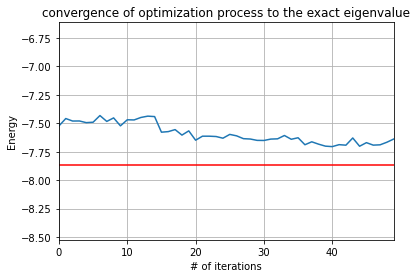

In [271]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [272]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

3it [00:00, 21.13it/s]

{'0101': 184, '0110': 25, '1111': 199, '0001': 29, '0011': 40, '1100': 53, '1101': 107, '1000': 44, '1001': 11, '0000': 94, '0100': 98, '0111': 27, '1110': 61, '0010': 26, '1010': 3, '1011': 23}
1.0
{'1111': 245, '0110': 109, '0011': 104, '1101': 22, '0100': 110, '0010': 28, '1110': 38, '0101': 111, '0001': 36, '0111': 50, '1010': 29, '1100': 74, '1001': 36, '1000': 10, '1011': 6, '0000': 16}
1.0
{'1110': 109, '0101': 135, '0111': 125, '1101': 113, '1001': 60, '0001': 45, '0010': 22, '1111': 38, '1100': 151, '0011': 68, '0100': 64, '1000': 49, '0110': 27, '1010': 4, '1011': 12, '0000': 2}
1.0
{'1011': 46, '0100': 167, '1101': 54, '1110': 87, '1010': 29, '1001': 114, '0001': 162, '0111': 64, '0000': 59, '0011': 17, '0010': 35, '0101': 50, '1111': 99, '1100': 27, '1000': 12, '0110': 2}
1.0


8it [00:00, 16.13it/s]

{'0101': 41, '0000': 56, '0111': 58, '0001': 147, '1100': 44, '0100': 181, '1101': 51, '1011': 30, '1001': 124, '1111': 96, '1000': 13, '0011': 28, '1110': 77, '0010': 39, '1010': 37, '0110': 2}
1.0
{'0101': 52, '1110': 75, '1111': 116, '0110': 4, '1001': 91, '1101': 48, '0100': 195, '1100': 35, '1011': 36, '0111': 68, '1010': 38, '0000': 49, '0001': 143, '0011': 27, '0010': 39, '1000': 8}
1.0
{'0011': 45, '1101': 92, '0010': 21, '0110': 208, '1111': 151, '1010': 91, '0001': 205, '0101': 46, '0100': 25, '1100': 7, '1001': 18, '0111': 15, '1011': 54, '1000': 28, '0000': 7, '1110': 11}
1.0
{'1100': 71, '1011': 82, '0100': 94, '1101': 105, '1001': 154, '0001': 79, '0000': 74, '1111': 66, '0011': 10, '1000': 40, '0111': 124, '0101': 15, '0110': 66, '1010': 25, '0010': 14, '1110': 5}
1.0


12it [00:00, 17.07it/s]

{'0100': 105, '1101': 93, '1110': 52, '0101': 225, '1100': 41, '0011': 44, '1000': 49, '0000': 87, '1111': 187, '0001': 24, '0110': 19, '0111': 46, '0010': 26, '1011': 22, '1001': 3, '1010': 1}
1.0
{'0101': 218, '0110': 24, '1111': 172, '1000': 33, '0000': 93, '0111': 37, '0010': 25, '0001': 35, '0100': 115, '1100': 40, '0011': 50, '1001': 4, '1110': 50, '1101': 104, '1011': 19, '1010': 5}
1.0
{'1100': 62, '1101': 107, '0100': 114, '1110': 60, '0101': 185, '0000': 85, '1011': 19, '1111': 176, '0010': 16, '1000': 40, '0011': 60, '0111': 37, '0110': 26, '1001': 7, '0001': 28, '1010': 2}
1.0
{'0101': 190, '0110': 24, '1111': 167, '0000': 96, '1101': 120, '0111': 45, '1001': 8, '1100': 52, '1011': 29, '0011': 46, '1110': 57, '0001': 30, '0100': 91, '1010': 3, '1000': 44, '0010': 22}
1.0


14it [00:00, 17.80it/s]

{'0110': 208, '1111': 125, '1101': 297, '0101': 9, '1010': 96, '0001': 73, '0011': 22, '0111': 112, '0000': 22, '0100': 19, '0010': 12, '1100': 9, '1000': 10, '1001': 2, '1110': 7, '1011': 1}
1.0
{'0100': 109, '1101': 115, '0000': 95, '0101': 206, '1110': 58, '0010': 25, '1011': 19, '0111': 34, '1111': 174, '1000': 52, '0001': 24, '1100': 50, '0011': 36, '0110': 18, '1010': 3, '1001': 6}
1.0
{'1110': 68, '0101': 205, '0001': 21, '1010': 6, '0100': 120, '0010': 30, '0000': 85, '1100': 51, '1111': 181, '0111': 32, '1101': 88, '1011': 34, '0110': 22, '1000': 38, '0011': 38, '1001': 5}
1.0


18it [00:01, 15.31it/s]

{'0101': 205, '0011': 47, '1100': 40, '1111': 176, '0100': 110, '1101': 107, '1000': 42, '0111': 31, '0000': 69, '0010': 22, '1110': 66, '0110': 33, '1011': 36, '0001': 34, '1010': 3, '1001': 3}
1.0
{'1110': 59, '0101': 208, '0110': 24, '1111': 152, '1000': 47, '0000': 101, '0100': 93, '1100': 59, '1101': 124, '0011': 31, '0111': 32, '0001': 28, '0010': 22, '1001': 14, '1011': 29, '1010': 1}
1.0
{'1110': 12, '1000': 25, '0001': 69, '1010': 101, '0010': 18, '0111': 90, '1101': 296, '0110': 202, '1111': 116, '0011': 29, '0100': 20, '0101': 15, '0000': 11, '1011': 6, '1100': 10, '1001': 4}
1.0
{'0011': 26, '1010': 108, '0001': 66, '1101': 287, '0110': 218, '1111': 127, '1000': 16, '0010': 15, '0111': 89, '0000': 15, '0100': 21, '1001': 5, '0101': 15, '1100': 10, '1110': 5, '1011': 1}
1.0


22it [00:01, 17.20it/s]

{'0101': 190, '1110': 65, '1101': 109, '0100': 116, '0000': 98, '0111': 28, '1111': 177, '1011': 33, '0011': 44, '0110': 24, '1000': 43, '0001': 25, '1100': 48, '1001': 6, '0010': 15, '1010': 3}
1.0
{'1011': 30, '1101': 96, '1111': 180, '0011': 50, '1001': 6, '1000': 50, '1110': 51, '0101': 204, '0100': 117, '0001': 28, '0010': 15, '1100': 61, '0000': 68, '0110': 17, '0111': 48, '1010': 3}
1.0
{'0101': 196, '1111': 201, '1001': 5, '0000': 71, '1101': 110, '0100': 114, '1100': 45, '1011': 27, '1010': 1, '0110': 22, '0111': 32, '1110': 62, '0011': 40, '1000': 46, '0010': 21, '0001': 31}
1.0
{'1000': 59, '0101': 191, '1100': 57, '1111': 186, '0100': 101, '1101': 108, '0111': 41, '0010': 20, '0001': 21, '0011': 49, '1110': 53, '1011': 27, '0000': 83, '0110': 19, '1001': 6, '1010': 3}
1.0
{'0100': 98, '1101': 104, '1111': 206, '0110': 31, '0011': 36, '1110': 58, '0101': 207, '0000': 85, '1100': 46, '1000': 39, '0001': 31, '1011': 19, '0010': 23, '0111': 31, '1010': 3, '1001': 7}
1.0


27it [00:01, 16.31it/s]


{'0000': 98, '1000': 44, '0101': 217, '0011': 52, '1011': 41, '1111': 158, '0100': 113, '1001': 9, '0010': 18, '1101': 91, '0111': 40, '0110': 15, '1110': 53, '1100': 47, '0001': 25, '1010': 3}
1.0
{'1111': 167, '0011': 54, '1110': 62, '0101': 198, '1101': 110, '0100': 97, '1011': 24, '1000': 44, '0000': 93, '0110': 22, '0111': 42, '1001': 8, '0010': 31, '0001': 27, '1100': 40, '1010': 5}
1.0
{'1101': 98, '0100': 123, '1000': 32, '0111': 43, '1110': 61, '0101': 195, '1111': 186, '1100': 51, '0011': 47, '0110': 26, '0000': 77, '1011': 28, '0001': 22, '0010': 27, '1001': 5, '1010': 3}
1.0


4it [00:00, 13.78it/s]

{'0101': 341, '0011': 56, '0111': 24, '0010': 20, '1010': 68, '0110': 36, '1101': 155, '0100': 29, '1100': 34, '1111': 108, '0001': 51, '1110': 78, '1011': 9, '0000': 6, '1000': 3, '1001': 6}
1.0
{'1111': 265, '1110': 32, '0101': 178, '1100': 78, '0100': 86, '0001': 18, '1010': 43, '1001': 20, '0110': 109, '0011': 95, '0111': 39, '1000': 20, '1011': 15, '1101': 14, '0010': 10, '0000': 2}
1.0
{'1110': 49, '0101': 144, '1111': 42, '0111': 105, '0100': 44, '1011': 78, '1100': 155, '1001': 22, '1101': 224, '0110': 28, '0010': 40, '1010': 8, '0000': 20, '0011': 33, '0001': 32}
1.0
{'1010': 61, '0001': 169, '1110': 76, '0101': 40, '0111': 96, '1101': 119, '0000': 141, '1111': 40, '1001': 76, '0011': 23, '1011': 98, '1100': 19, '0100': 56, '0010': 9, '1000': 1}
1.0
{'1110': 67, '0101': 35, '0111': 114, '0000': 126, '0100': 39, '1101': 113, '1011': 115, '1100': 21, '0001': 180, '1010': 62, '1000': 4, '1111': 61, '0011': 24, '1001': 59, '0010': 4}
1.0


9it [00:00, 16.68it/s]

{'0100': 59, '1001': 80, '1010': 59, '0001': 187, '0111': 98, '1110': 61, '0000': 130, '1011': 96, '1100': 21, '0011': 28, '1101': 102, '1111': 41, '0101': 52, '0010': 7, '1000': 3}
1.0
{'0001': 181, '1010': 132, '1011': 54, '1111': 133, '0011': 163, '0111': 41, '1110': 8, '0101': 92, '1101': 61, '1000': 31, '0110': 87, '1001': 12, '1100': 12, '0000': 13, '0010': 2, '0100': 2}
1.0
{'1101': 126, '1010': 53, '0001': 93, '1001': 241, '0111': 116, '0010': 96, '1011': 49, '0110': 31, '1111': 52, '1110': 29, '0101': 50, '0100': 50, '0000': 27, '1000': 8, '1100': 3}
1.0
{'0101': 333, '1110': 77, '0011': 52, '1100': 44, '0110': 38, '1111': 128, '1101': 130, '0001': 43, '1010': 51, '0010': 16, '1011': 25, '0111': 24, '0100': 39, '1001': 13, '0000': 8, '1000': 3}
1.0


13it [00:00, 16.10it/s]

{'0100': 27, '1101': 163, '0111': 24, '1010': 71, '1001': 16, '0101': 315, '0011': 48, '1111': 92, '0001': 53, '1011': 25, '0110': 37, '1110': 69, '0010': 20, '1100': 47, '0000': 13, '1000': 4}
1.0
{'1101': 150, '1110': 79, '0101': 320, '0110': 35, '1010': 70, '0001': 60, '0000': 9, '0011': 60, '1100': 46, '1111': 106, '0010': 23, '0100': 31, '1001': 11, '1011': 11, '0111': 12, '1000': 1}
1.0
{'0101': 328, '1110': 70, '1010': 67, '0010': 23, '1101': 161, '0100': 29, '1111': 110, '1100': 37, '1001': 7, '0011': 51, '0111': 22, '0001': 50, '0110': 34, '0000': 13, '1011': 20, '1000': 2}
1.0
{'1111': 158, '0110': 161, '0111': 115, '1101': 294, '0011': 81, '1000': 31, '1010': 53, '0001': 28, '1011': 26, '0101': 38, '0100': 22, '1110': 3, '0000': 9, '0010': 5}
1.0


18it [00:01, 18.28it/s]

{'1111': 109, '1101': 158, '0111': 32, '0101': 304, '1110': 77, '0001': 49, '0011': 57, '1100': 38, '1010': 60, '0000': 9, '0010': 26, '0110': 32, '0100': 31, '1011': 21, '1001': 18, '1000': 3}
1.0
{'0110': 36, '1101': 153, '0010': 32, '1110': 60, '0101': 336, '0001': 55, '1010': 55, '1100': 39, '0111': 19, '1111': 109, '1000': 8, '1001': 6, '0011': 57, '1011': 17, '0100': 38, '0000': 4}
1.0
{'1001': 10, '1101': 133, '0100': 36, '1111': 110, '0101': 321, '0111': 33, '0000': 10, '0011': 61, '1011': 16, '0110': 41, '1110': 79, '0010': 32, '1100': 35, '1010': 60, '0001': 43, '1000': 4}
1.0
{'0111': 16, '0100': 37, '1101': 162, '0101': 314, '1111': 110, '0110': 40, '1100': 47, '0011': 52, '1110': 73, '0001': 51, '0010': 25, '1001': 10, '0000': 10, '1010': 62, '1011': 13, '1000': 2}
1.0
{'1111': 159, '0110': 151, '1110': 4, '0101': 35, '1000': 14, '1101': 283, '0011': 82, '0111': 130, '1010': 71, '1011': 22, '1100': 1, '0001': 24, '0000': 9, '0100': 32, '0010': 7}
1.0
{'0011': 83, '1101': 2

21it [00:01, 18.25it/s]

{'1100': 36, '1111': 102, '0110': 31, '1110': 84, '0101': 332, '1101': 159, '1001': 5, '0001': 47, '0010': 17, '0111': 20, '1010': 67, '0011': 63, '0100': 36, '0000': 12, '1011': 11, '1000': 2}
1.0
{'1111': 120, '0110': 40, '0011': 54, '0101': 335, '1110': 65, '0100': 32, '1101': 134, '0111': 31, '1100': 43, '1010': 55, '1011': 15, '0001': 45, '0010': 24, '0000': 15, '1000': 6, '1001': 10}
1.0
{'0101': 321, '1110': 80, '0001': 52, '1010': 57, '1100': 43, '1011': 21, '0111': 24, '1111': 110, '0110': 28, '1101': 151, '0010': 26, '0100': 30, '0011': 62, '0000': 11, '1001': 5, '1000': 3}
1.0


26it [00:01, 18.06it/s]

{'0111': 28, '0101': 343, '1110': 89, '0010': 17, '1111': 108, '0100': 35, '1101': 157, '1010': 54, '0110': 28, '0011': 45, '0001': 45, '1001': 12, '1100': 38, '1011': 17, '1000': 4, '0000': 4}
1.0
{'1110': 75, '0101': 331, '0011': 49, '1100': 41, '0100': 29, '1101': 137, '0110': 37, '1111': 112, '0001': 48, '0111': 26, '1011': 27, '0010': 29, '1010': 65, '0000': 7, '1001': 8, '1000': 3}
1.0
{'0100': 36, '1101': 137, '1100': 43, '0011': 45, '0101': 319, '1000': 2, '1111': 119, '0001': 67, '1011': 13, '1001': 11, '0010': 21, '0110': 36, '1110': 81, '1010': 53, '0111': 23, '0000': 18}
1.0
{'0010': 25, '1101': 156, '0101': 305, '1110': 78, '0110': 29, '1111': 102, '1010': 74, '0000': 13, '0001': 62, '0011': 61, '1100': 40, '0111': 18, '0100': 38, '1000': 3, '1011': 14, '1001': 6}
1.0


27it [00:01, 16.59it/s]


{'0101': 307, '1110': 69, '0100': 37, '1101': 174, '0110': 37, '0001': 60, '1010': 66, '0000': 10, '1111': 94, '0011': 63, '0111': 22, '1100': 39, '1011': 13, '1000': 4, '0010': 22, '1001': 7}
1.0


3it [00:00, 22.79it/s]

{'1111': 173, '1101': 139, '1010': 59, '1100': 84, '1110': 64, '0101': 279, '0010': 58, '0111': 68, '0100': 31, '0001': 7, '0000': 11, '0110': 19, '0011': 12, '1000': 4, '1011': 7, '1001': 9}
1.0
{'0100': 132, '1101': 11, '1111': 285, '0001': 56, '1100': 90, '1110': 45, '0111': 51, '1011': 25, '0101': 176, '1000': 37, '0010': 24, '1010': 23, '0011': 20, '1001': 9, '0110': 40}
1.0
{'1000': 6, '1110': 147, '0101': 145, '0110': 21, '1101': 171, '1010': 26, '1100': 125, '1011': 39, '0011': 35, '0100': 39, '1001': 27, '0111': 146, '1111': 36, '0010': 58, '0001': 3}
1.0
{'1110': 85, '0101': 60, '0110': 40, '0111': 71, '1001': 71, '0001': 89, '1101': 123, '1011': 90, '0000': 110, '0011': 61, '1010': 106, '0100': 59, '1111': 36, '1100': 4, '1000': 18, '0010': 1}
1.0


6it [00:00, 20.53it/s]

{'1000': 17, '0000': 110, '1111': 33, '0110': 49, '0001': 89, '1011': 90, '0111': 75, '0101': 54, '1010': 80, '1001': 86, '1110': 102, '0011': 59, '1101': 113, '0100': 65, '1100': 2}
1.0
{'1101': 131, '1111': 39, '1011': 94, '0101': 85, '0111': 60, '1000': 14, '0011': 58, '1001': 64, '0000': 115, '0100': 60, '1110': 71, '0110': 44, '0001': 101, '1010': 86, '1100': 1, '0010': 1}
1.0
{'1111': 192, '0110': 41, '1011': 88, '1010': 92, '0001': 192, '0101': 136, '1000': 32, '0100': 15, '0000': 29, '1001': 46, '1100': 39, '0010': 36, '1110': 20, '1101': 22, '0011': 32, '0111': 12}
1.0
{'0001': 53, '1001': 199, '0111': 105, '1101': 111, '0100': 51, '1111': 73, '0010': 115, '0101': 61, '0000': 49, '0110': 20, '1011': 78, '1010': 32, '1100': 23, '1110': 42, '0011': 11, '1000': 1}


11it [00:00, 16.91it/s]

1.0
{'1110': 62, '0101': 259, '1010': 64, '1111': 204, '1011': 12, '0010': 47, '1100': 97, '1101': 129, '0001': 10, '0111': 62, '0011': 6, '0000': 8, '1000': 9, '0100': 23, '0110': 26, '1001': 6}
1.0
{'0010': 62, '1110': 58, '0101': 300, '0001': 4, '1010': 63, '1100': 75, '1101': 118, '1111': 174, '0100': 30, '0111': 73, '1001': 14, '1000': 4, '0110': 20, '1011': 10, '0011': 13, '0000': 6}
1.0
{'1001': 11, '1010': 71, '0101': 271, '1111': 187, '0111': 67, '0010': 57, '0000': 10, '1101': 137, '1100': 88, '1110': 53, '0110': 14, '0001': 9, '1000': 6, '0011': 12, '0100': 30, '1011': 1}
1.0


14it [00:00, 18.20it/s]

{'1111': 172, '1101': 112, '0101': 309, '1110': 75, '1100': 75, '0010': 70, '0000': 13, '1010': 54, '1001': 9, '0111': 57, '0100': 25, '1000': 8, '0011': 7, '0110': 19, '1011': 8, '0001': 11}
1.0
{'0111': 140, '1101': 329, '1111': 149, '0110': 150, '0010': 51, '0000': 20, '1000': 62, '1001': 13, '0101': 33, '0011': 9, '0100': 15, '1011': 6, '1100': 16, '1010': 9, '0001': 10, '1110': 12}
1.0
{'1111': 185, '0110': 25, '0111': 69, '0101': 291, '1001': 10, '0010': 71, '0100': 26, '1101': 112, '0001': 12, '1110': 48, '1010': 71, '0011': 17, '1100': 70, '0000': 11, '1011': 4, '1000': 2}
1.0
{'1111': 189, '0101': 254, '1110': 61, '0100': 37, '1101': 131, '1011': 7, '0010': 70, '1100': 69, '1010': 59, '0111': 76, '1000': 4, '0110': 24, '0000': 17, '0011': 12, '0001': 6, '1001': 8}
1.0
{'1110': 66, '0101': 264, '1111': 182, '0010': 68, '1101': 111, '0000': 6, '0111': 67, '1010': 65, '0100': 42, '1100': 73, '0110': 26, '1001': 8, '0011': 19, '0001': 10, '1011': 9, '1000': 8}
1.0


20it [00:01, 19.72it/s]

{'0110': 33, '1111': 169, '1110': 58, '0101': 283, '1010': 55, '1101': 122, '1100': 66, '0010': 70, '1011': 15, '0001': 5, '0111': 70, '0100': 37, '0011': 10, '1001': 8, '0000': 16, '1000': 7}
1.0
{'1111': 121, '0110': 145, '0100': 27, '1101': 362, '1000': 55, '1001': 18, '0001': 12, '0010': 50, '0111': 131, '0000': 14, '0101': 46, '1100': 10, '1010': 8, '0011': 11, '1110': 11, '1011': 3}
1.0
{'0111': 149, '0100': 33, '1101': 337, '0101': 41, '0110': 153, '1111': 122, '1000': 67, '0010': 53, '0001': 12, '1001': 10, '0000': 13, '1100': 8, '1010': 10, '0011': 7, '1011': 3, '1110': 6}
1.0
{'0010': 57, '0110': 23, '1111': 165, '1101': 125, '0101': 275, '1110': 59, '0111': 79, '1010': 51, '0001': 5, '0100': 55, '1011': 11, '1001': 8, '1100': 70, '0000': 15, '0011': 18, '1000': 8}
1.0
{'1101': 113, '1011': 9, '0010': 70, '1110': 61, '0101': 299, '1111': 164, '0110': 28, '0111': 72, '1010': 57, '1100': 65, '0100': 38, '0001': 11, '0011': 15, '1001': 8, '0000': 8, '1000': 6}
1.0


24it [00:01, 17.08it/s]

{'0100': 38, '1101': 113, '1110': 66, '0101': 274, '1111': 177, '1100': 64, '0111': 60, '1010': 64, '0010': 78, '0110': 33, '1001': 13, '0001': 10, '0011': 13, '1011': 7, '0000': 9, '1000': 5}
1.0
{'1010': 77, '1111': 172, '0110': 21, '1110': 59, '0101': 303, '0010': 60, '0111': 71, '1100': 57, '1101': 117, '1001': 13, '1011': 15, '0000': 8, '0100': 28, '1000': 4, '0011': 17, '0001': 2}
1.0
{'1110': 59, '0101': 287, '1111': 175, '1010': 60, '0001': 11, '1101': 125, '1100': 78, '0000': 10, '0010': 60, '1011': 13, '0111': 66, '0100': 32, '0011': 10, '0110': 25, '1001': 9, '1000': 4}
1.0
{'1111': 187, '1001': 7, '1101': 123, '0000': 14, '1110': 74, '0101': 262, '1100': 63, '0011': 13, '1010': 76, '0100': 40, '0110': 19, '0010': 69, '0111': 61, '1011': 9, '1000': 4, '0001': 3}
1.0


27it [00:01, 18.30it/s]


{'0110': 32, '1111': 197, '0111': 81, '0010': 64, '1110': 64, '0101': 264, '0100': 37, '1010': 56, '1100': 67, '1101': 113, '1001': 12, '0011': 15, '1011': 9, '0000': 7, '1000': 4, '0001': 2}
1.0
{'1010': 70, '1110': 67, '0101': 274, '1111': 174, '0100': 45, '0010': 45, '1100': 94, '1000': 5, '0000': 9, '0111': 56, '0011': 15, '1101': 129, '1011': 8, '0001': 5, '0110': 20, '1001': 8}
1.0


3it [00:00, 24.00it/s]

{'1001': 25, '0001': 13, '1010': 89, '1100': 91, '0000': 17, '0110': 43, '1011': 99, '1110': 171, '1111': 190, '0010': 20, '0011': 82, '0101': 95, '0100': 23, '1101': 44, '0111': 15, '1000': 7}
1.0
{'0110': 66, '1111': 380, '1011': 60, '0011': 108, '1100': 54, '0101': 89, '1110': 32, '0100': 24, '1001': 49, '1010': 80, '1000': 26, '0000': 16, '0001': 10, '0111': 13, '1101': 10, '0010': 7}
1.0
{'0111': 221, '1100': 31, '0011': 101, '0010': 84, '0110': 91, '1111': 99, '0000': 12, '0101': 115, '0100': 45, '1011': 90, '0001': 26, '1101': 63, '1110': 22, '1010': 15, '1000': 6, '1001': 3}
1.0
{'0000': 38, '1010': 83, '1001': 25, '1011': 179, '1101': 114, '0111': 130, '1110': 87, '1111': 180, '0001': 49, '0011': 29, '0100': 48, '0010': 16, '0101': 19, '1100': 11, '0110': 6, '1000': 10}
1.0
{'1111': 173, '1101': 112, '0100': 29, '1011': 180, '0001': 55, '1010': 93, '1110': 81, '1000': 8, '1001': 33, '0011': 36, '0101': 21, '0000': 39, '0111': 124, '0110': 13, '0010': 14, '1100': 13}
1.0


6it [00:00, 18.08it/s]

{'1011': 184, '0001': 48, '1010': 73, '0110': 11, '1111': 180, '0100': 41, '1101': 97, '0111': 123, '1110': 82, '0010': 25, '1000': 17, '1100': 13, '1001': 29, '0101': 21, '0000': 43, '0011': 37}
1.0


8it [00:00, 16.24it/s]

{'0100': 10, '1101': 82, '1110': 60, '0101': 77, '1111': 212, '1001': 6, '1010': 224, '1000': 83, '0000': 22, '1011': 15, '1100': 13, '0011': 77, '0001': 41, '0110': 67, '0111': 31, '0010': 4}
1.0
{'0101': 23, '1010': 106, '1011': 23, '0010': 207, '0111': 277, '0000': 14, '1101': 54, '0100': 93, '1111': 78, '1001': 41, '0110': 34, '1110': 16, '1000': 11, '0001': 44, '1100': 3}
1.0


10it [00:00, 16.86it/s]

{'1111': 197, '0101': 97, '1110': 144, '1011': 84, '1001': 26, '1010': 116, '1100': 81, '1101': 46, '0011': 82, '0000': 13, '0110': 45, '0010': 13, '0001': 20, '0100': 30, '0111': 19, '1000': 11}
1.0
{'1110': 168, '1111': 165, '1001': 18, '1010': 117, '0100': 28, '1101': 30, '0111': 20, '1100': 71, '0110': 56, '0101': 111, '1011': 88, '0010': 20, '0011': 100, '0001': 10, '1000': 11, '0000': 11}
1.0
{'1111': 187, '0100': 26, '1101': 47, '1000': 9, '0101': 86, '1110': 187, '0011': 81, '1001': 19, '1100': 84, '1010': 120, '1011': 86, '0010': 21, '0110': 35, '0000': 16, '0001': 7, '0111': 13}
1.0


13it [00:00, 18.49it/s]

{'0110': 43, '1111': 160, '1010': 121, '0100': 31, '0101': 100, '1110': 148, '1100': 98, '0011': 84, '1101': 44, '1011': 100, '0111': 16, '0010': 15, '0000': 19, '1000': 14, '1001': 18, '0001': 13}
1.0
{'0001': 54, '1010': 74, '0010': 36, '1011': 24, '1110': 47, '0111': 126, '0110': 213, '0100': 57, '1111': 96, '0000': 34, '1000': 19, '1101': 72, '0011': 112, '1100': 5, '0101': 37, '1001': 18}
1.0


16it [00:00, 19.47it/s]

{'1100': 86, '0100': 16, '1101': 37, '1010': 118, '1000': 21, '0101': 105, '1111': 155, '0010': 20, '1110': 166, '0011': 91, '0111': 15, '0000': 25, '0001': 12, '0110': 44, '1011': 86, '1001': 27}
1.0
{'0101': 90, '1110': 173, '1111': 185, '0001': 14, '1010': 113, '0011': 82, '0100': 26, '0000': 14, '0110': 40, '1100': 74, '1011': 90, '1001': 29, '0111': 22, '1101': 51, '1000': 8, '0010': 13}
1.0
{'1001': 21, '1010': 107, '0101': 94, '1110': 160, '1111': 180, '0000': 22, '0010': 20, '0011': 82, '0110': 52, '1100': 71, '0100': 35, '1011': 104, '1101': 41, '0111': 13, '0001': 11, '1000': 11}
1.0
{'1110': 162, '0011': 91, '1100': 92, '1010': 111, '1011': 84, '0111': 18, '0110': 53, '1101': 43, '0101': 89, '1111': 183, '0000': 12, '0010': 14, '1001': 22, '1000': 8, '0100': 29, '0001': 13}
1.0


18it [00:01, 16.52it/s]

{'0101': 46, '1110': 37, '0011': 125, '1000': 14, '0010': 46, '1101': 72, '1111': 90, '0110': 219, '0000': 32, '1010': 76, '0111': 117, '0100': 54, '0001': 51, '1001': 23, '1011': 16, '1100': 6}
1.0
{'0010': 34, '0011': 124, '1001': 31, '1010': 69, '0111': 130, '1111': 93, '1101': 69, '0100': 71, '0000': 24, '0101': 52, '0110': 206, '1110': 31, '0001': 46, '1011': 14, '1100': 6, '1000': 24}
1.0


20it [00:01, 16.97it/s]

{'0001': 13, '1010': 114, '0110': 55, '1111': 174, '1110': 149, '0010': 14, '0111': 19, '0011': 97, '0101': 112, '1101': 40, '1011': 89, '1001': 23, '1000': 9, '1100': 72, '0100': 30, '0000': 14}
1.0
{'1110': 163, '0101': 104, '0110': 45, '1111': 186, '1101': 39, '0011': 107, '1100': 72, '1010': 88, '0000': 19, '0010': 21, '1001': 24, '0001': 20, '0111': 17, '1011': 83, '0100': 26, '1000': 10}
1.0


22it [00:01, 16.76it/s]

{'0101': 110, '1110': 185, '1010': 109, '0001': 13, '0011': 84, '1100': 70, '1011': 96, '1111': 169, '1001': 20, '0110': 43, '1101': 37, '1000': 12, '0100': 25, '0010': 17, '0000': 21, '0111': 13}
1.0
{'1110': 157, '1100': 92, '0011': 104, '1101': 36, '0010': 22, '0110': 47, '1111': 182, '1010': 110, '1011': 77, '0000': 20, '0111': 15, '0001': 11, '0101': 88, '0100': 26, '1000': 12, '1001': 25}
1.0


24it [00:01, 17.51it/s]

{'0001': 13, '1010': 123, '1011': 81, '1111': 170, '0101': 91, '1110': 164, '1100': 75, '0011': 87, '0110': 46, '0100': 24, '0111': 24, '1101': 57, '0010': 13, '0000': 15, '1000': 12, '1001': 29}
1.0
{'0110': 36, '1111': 164, '1110': 162, '0101': 106, '0011': 77, '1100': 93, '1101': 43, '0100': 25, '1000': 16, '1010': 116, '0111': 18, '1011': 96, '1001': 23, '0001': 6, '0010': 22, '0000': 21}
1.0


27it [00:01, 17.86it/s]


{'1110': 150, '1011': 79, '1100': 78, '0011': 102, '1111': 195, '1010': 108, '0001': 20, '0000': 20, '1101': 37, '0101': 85, '0110': 53, '0111': 16, '0100': 31, '0010': 22, '1001': 23, '1000': 5}
1.0
{'1001': 27, '1010': 107, '0011': 79, '1100': 94, '0101': 96, '1110': 175, '1111': 175, '1101': 35, '1011': 87, '0100': 22, '0111': 22, '0110': 51, '0000': 18, '0001': 13, '0010': 18, '1000': 5}
1.0


2it [00:00, 15.98it/s]

{'0110': 32, '1111': 194, '1100': 61, '1010': 51, '1101': 217, '1110': 89, '0101': 179, '0010': 19, '0100': 14, '0011': 51, '1011': 22, '1001': 5, '0001': 72, '0000': 9, '1000': 7, '0111': 2}
1.0
{'1111': 304, '1100': 188, '0011': 87, '1101': 51, '0010': 20, '1011': 15, '1110': 55, '0000': 24, '0101': 71, '1000': 35, '0001': 10, '0110': 79, '1001': 12, '0100': 6, '1010': 21, '0111': 46}
1.0
{'0010': 56, '1101': 307, '0001': 57, '1010': 36, '0101': 66, '1110': 116, '1111': 32, '1100': 103, '0110': 100, '0111': 73, '1001': 25, '1011': 28, '0011': 16, '0100': 2, '1000': 6, '0000': 1}
1.0


4it [00:00, 13.04it/s]

{'1001': 98, '1010': 109, '0001': 192, '0111': 37, '1101': 178, '0000': 54, '1011': 55, '1111': 49, '0100': 8, '1000': 32, '1110': 116, '0011': 6, '0101': 18, '0110': 23, '0010': 31, '1100': 18}
1.0
{'0111': 29, '0010': 30, '1011': 71, '1110': 127, '1111': 55, '0001': 160, '1001': 81, '1101': 181, '1000': 31, '0101': 24, '0000': 57, '1010': 121, '0110': 17, '1100': 27, '0011': 6, '0100': 7}
1.0


6it [00:00, 12.62it/s]

{'1010': 128, '0001': 159, '1001': 95, '1101': 155, '0101': 16, '0000': 58, '1111': 51, '1011': 72, '1110': 112, '1000': 51, '0110': 25, '0111': 41, '0011': 5, '0010': 29, '0100': 10, '1100': 17}
1.0


8it [00:00, 14.68it/s]

{'0000': 8, '1000': 41, '0111': 36, '0011': 155, '1010': 106, '1001': 85, '1011': 81, '1111': 201, '1100': 45, '0001': 67, '1110': 32, '0010': 20, '1101': 86, '0110': 40, '0100': 15, '0101': 6}
1.0
{'1101': 100, '1010': 80, '1001': 308, '1000': 27, '0000': 9, '1111': 32, '0111': 129, '0010': 67, '0100': 64, '0110': 31, '1011': 81, '1110': 16, '0101': 51, '1100': 10, '0011': 13, '0001': 6}
1.0
{'1010': 52, '1001': 4, '0001': 91, '1111': 190, '0011': 43, '1011': 22, '1101': 224, '1110': 105, '0101': 154, '1100': 54, '0100': 19, '1000': 10, '0010': 18, '0000': 13, '0110': 22, '0111': 3}
1.0
{'0000': 15, '1000': 18, '0001': 63, '1101': 233, '0101': 148, '1110': 102, '1111': 200, '0011': 45, '1011': 25, '0010': 16, '1010': 45, '0100': 15, '1100': 56, '0110': 32, '1001': 9, '0111': 2}
1.0


11it [00:00, 17.00it/s]

{'0001': 66, '1010': 53, '1101': 238, '0011': 48, '1111': 194, '1110': 93, '0101': 170, '1000': 20, '0000': 13, '0110': 26, '1100': 38, '1011': 27, '0010': 13, '0100': 18, '0111': 4, '1001': 3}
1.0


13it [00:00, 17.57it/s]

{'0001': 48, '1001': 6, '1100': 63, '0000': 11, '1110': 104, '0101': 189, '1011': 19, '1111': 175, '1101': 223, '1000': 19, '0010': 20, '0110': 23, '1010': 53, '0100': 23, '0011': 46, '0111': 2}
1.0
{'0110': 107, '1111': 282, '1001': 26, '1010': 42, '0001': 19, '1101': 205, '0011': 74, '1110': 44, '1000': 16, '0000': 42, '0111': 69, '0100': 50, '0101': 23, '1011': 14, '1100': 11}
1.0
{'1110': 111, '0101': 150, '1010': 56, '1101': 218, '1111': 212, '0010': 11, '1011': 16, '1100': 45, '0001': 60, '0011': 53, '0111': 3, '0110': 32, '0100': 24, '0000': 17, '1000': 11, '1001': 5}
1.0


17it [00:01, 14.85it/s]

{'1111': 192, '1100': 45, '0011': 56, '1101': 252, '0101': 140, '1010': 66, '0001': 62, '1000': 12, '0000': 14, '1110': 99, '1011': 21, '0100': 22, '0111': 4, '0010': 10, '0110': 24, '1001': 5}
1.0
{'1101': 249, '0101': 155, '1010': 50, '1011': 22, '0110': 22, '1111': 193, '0011': 59, '1100': 48, '1110': 84, '0001': 71, '1000': 18, '0010': 14, '0111': 8, '0100': 14, '0000': 15, '1001': 2}
1.0
{'0011': 51, '1100': 44, '1101': 249, '0100': 13, '0101': 175, '1001': 7, '0000': 11, '1111': 183, '0001': 58, '1110': 103, '1010': 51, '1000': 17, '0110': 29, '1011': 14, '0010': 13, '0111': 6}
1.0
{'0110': 88, '1111': 278, '0111': 93, '0001': 11, '1010': 40, '1100': 10, '1101': 223, '1000': 28, '0100': 33, '0011': 77, '1011': 17, '1001': 18, '1110': 38, '0101': 36, '0000': 31, '0010': 3}
1.0


23it [00:01, 17.88it/s]

{'1111': 298, '0110': 95, '1001': 24, '1101': 219, '1000': 15, '1100': 11, '0011': 76, '0111': 97, '0100': 45, '0000': 25, '1110': 34, '1010': 34, '0101': 22, '1011': 9, '0001': 18, '0010': 2}
1.0
{'0110': 27, '1111': 190, '1101': 242, '0101': 159, '1110': 106, '1010': 60, '0001': 72, '0011': 37, '0000': 12, '1011': 15, '1100': 46, '1000': 22, '0010': 12, '1001': 4, '0100': 17, '0111': 3}
1.0
{'0101': 155, '1110': 92, '0011': 55, '1100': 58, '1000': 12, '0001': 69, '1101': 232, '1111': 213, '0110': 24, '1001': 7, '1010': 48, '0010': 12, '1011': 21, '0000': 9, '0100': 15, '0111': 2}
1.0
{'0001': 67, '1010': 60, '1110': 83, '0101': 163, '1111': 174, '1101': 241, '1011': 25, '0011': 54, '0010': 20, '1100': 53, '0110': 25, '1000': 15, '0000': 17, '0111': 3, '0100': 18, '1001': 6}
1.0
{'1000': 15, '1110': 97, '0101': 152, '1111': 179, '1011': 22, '1101': 262, '1100': 49, '0001': 62, '1010': 56, '0110': 26, '0011': 50, '0000': 13, '0100': 20, '0010': 13, '1001': 4, '0111': 4}
1.0


25it [00:01, 18.06it/s]

{'0101': 164, '1110': 104, '0110': 28, '1111': 199, '1100': 56, '1101': 224, '1010': 46, '1000': 14, '1011': 23, '0111': 3, '0100': 18, '0001': 65, '0010': 16, '0011': 46, '0000': 11, '1001': 7}
1.0
{'1101': 232, '0011': 59, '1111': 204, '0110': 33, '1000': 17, '1110': 87, '0101': 155, '1010': 51, '0100': 23, '0001': 64, '1001': 5, '0010': 9, '1100': 48, '0000': 13, '1011': 19, '0111': 5}
1.0
{'0011': 46, '1100': 54, '1101': 245, '0101': 172, '1110': 98, '1011': 23, '1111': 206, '0001': 53, '0000': 14, '1010': 36, '0100': 23, '1000': 15, '0110': 25, '0010': 10, '0111': 3, '1001': 1}
1.0


27it [00:01, 16.02it/s]


{'0100': 21, '1101': 246, '1111': 200, '1011': 31, '1110': 113, '0101': 141, '0011': 50, '0001': 63, '1010': 37, '1100': 65, '0010': 5, '0000': 10, '0110': 17, '1000': 19, '1001': 4, '0111': 2}
1.0


2it [00:00, 17.52it/s]

{'1110': 66, '0101': 316, '0000': 40, '1101': 175, '0100': 77, '1111': 93, '1010': 39, '1100': 40, '0111': 26, '0001': 67, '0010': 27, '1011': 17, '1001': 9, '0011': 15, '1000': 4, '0110': 13}
1.0
{'0001': 20, '1010': 25, '1001': 69, '0011': 111, '1100': 99, '0101': 191, '0110': 54, '1111': 255, '1011': 13, '0100': 79, '0111': 51, '1110': 23, '0000': 10, '1000': 3, '1101': 15, '0010': 6}
1.0
{'0001': 53, '1011': 49, '0101': 183, '1110': 78, '1101': 209, '0111': 99, '1100': 135, '0110': 32, '1010': 20, '1001': 18, '0100': 30, '1111': 27, '0010': 8, '0011': 52, '1000': 17, '0000': 14}
1.0


5it [00:00, 19.62it/s]

{'0100': 54, '1101': 132, '1010': 89, '0001': 188, '1001': 76, '0101': 87, '1011': 73, '0000': 104, '1110': 36, '1111': 77, '0011': 20, '0010': 3, '0111': 55, '1100': 21, '1000': 9}
1.0
{'0101': 87, '1010': 77, '0001': 206, '1001': 70, '0111': 72, '0000': 133, '1100': 17, '1101': 123, '1111': 72, '1011': 68, '1110': 23, '0100': 42, '0110': 5, '0011': 20, '1000': 7, '0010': 2}
1.0
{'0111': 82, '0101': 82, '1110': 40, '0000': 109, '1010': 65, '1001': 77, '1111': 65, '1100': 15, '0100': 43, '0001': 194, '1101': 135, '0011': 28, '1011': 81, '1000': 7, '0110': 1}
1.0
{'1110': 23, '0101': 64, '1011': 54, '1010': 112, '1001': 21, '0001': 185, '1111': 135, '1101': 103, '0011': 101, '0000': 24, '0111': 14, '0110': 115, '1000': 53, '0100': 13, '1100': 5, '0010': 2}
1.0


10it [00:00, 19.84it/s]

{'1010': 71, '1001': 216, '0001': 124, '0100': 83, '1101': 112, '0010': 75, '0111': 70, '1110': 19, '1111': 69, '0101': 61, '0000': 40, '1011': 31, '0110': 32, '1100': 11, '1000': 10}
1.0
{'1101': 154, '0100': 60, '0010': 37, '1010': 53, '0101': 297, '1111': 112, '0000': 21, '1100': 43, '1110': 66, '0111': 34, '0110': 11, '1011': 28, '0001': 71, '0011': 19, '1000': 5, '1001': 13}
1.0
{'0010': 33, '0101': 271, '1111': 118, '1101': 159, '0100': 59, '0011': 20, '0000': 28, '1010': 57, '1110': 64, '0111': 36, '0001': 67, '0110': 19, '1100': 56, '1000': 3, '1011': 21, '1001': 13}
1.0
{'0101': 292, '0000': 24, '0011': 17, '0001': 79, '0100': 64, '1101': 152, '1111': 103, '0111': 36, '1100': 50, '1010': 62, '1110': 66, '1001': 5, '0110': 18, '0010': 35, '1011': 14, '1000': 7}
1.0
{'1110': 91, '0101': 273, '0100': 72, '1101': 165, '1010': 62, '0010': 34, '0111': 23, '0000': 24, '0001': 68, '1011': 19, '1001': 5, '1111': 105, '0011': 23, '0110': 17, '1100': 38, '1000': 5}
1.0


13it [00:00, 19.96it/s]

{'1111': 97, '0110': 158, '0100': 52, '1101': 315, '1010': 69, '0111': 127, '1000': 14, '0000': 20, '0011': 54, '1110': 13, '0101': 19, '0001': 45, '0010': 18, '1011': 21, '1100': 2}
1.0
{'0101': 270, '1110': 73, '0001': 68, '1010': 60, '1011': 22, '1111': 118, '0110': 24, '0100': 81, '0011': 15, '1101': 141, '0111': 40, '0010': 33, '0000': 23, '1100': 48, '1001': 6, '1000': 2}
1.0
{'0111': 39, '0100': 77, '1101': 129, '0101': 260, '0001': 77, '0000': 32, '0011': 18, '1111': 103, '1100': 61, '1110': 81, '0010': 34, '1010': 60, '1011': 20, '1001': 11, '1000': 4, '0110': 18}
1.0


16it [00:00, 20.24it/s]

{'1100': 42, '0101': 276, '0001': 67, '1010': 53, '1101': 168, '0000': 23, '0111': 33, '1111': 128, '1110': 68, '0100': 65, '0010': 39, '0011': 15, '1011': 20, '1001': 4, '0110': 18, '1000': 5}
1.0
{'0111': 39, '0010': 26, '0101': 292, '1110': 78, '1101': 159, '0011': 21, '1111': 100, '0000': 25, '0110': 11, '1100': 47, '0001': 58, '1010': 61, '0100': 68, '1011': 20, '1000': 8, '1001': 11}
1.0
{'0110': 142, '1111': 112, '0100': 38, '1101': 330, '0001': 43, '1010': 63, '0111': 127, '1011': 18, '0000': 28, '1000': 29, '0010': 12, '1110': 10, '0011': 50, '1100': 3, '0101': 19}
1.0


19it [00:01, 17.30it/s]

{'1111': 109, '0110': 150, '0111': 124, '1010': 77, '0100': 41, '1101': 296, '1000': 17, '0011': 64, '0000': 25, '0101': 19, '0010': 16, '0001': 51, '1100': 5, '1011': 23, '1110': 7}
1.0
{'0010': 31, '1011': 17, '1110': 66, '0101': 297, '1101': 145, '0111': 30, '1100': 40, '1001': 12, '0001': 67, '0011': 31, '0110': 16, '0100': 70, '1010': 59, '1111': 102, '0000': 34, '1000': 7}
1.0


21it [00:01, 17.53it/s]

{'1111': 107, '0101': 271, '0000': 26, '1101': 159, '1100': 35, '0010': 39, '0111': 33, '1010': 76, '1110': 72, '0001': 65, '1011': 21, '0110': 22, '0100': 61, '0011': 23, '1001': 10, '1000': 4}
1.0
{'1111': 96, '0101': 289, '0100': 71, '0111': 35, '0010': 39, '0000': 22, '1100': 36, '0001': 76, '1110': 82, '1101': 159, '1010': 65, '0110': 14, '1011': 22, '1000': 1, '0011': 10, '1001': 7}
1.0
{'0000': 34, '1110': 69, '0101': 277, '1010': 65, '0001': 64, '0100': 73, '1101': 158, '0010': 37, '1111': 103, '1001': 13, '0110': 16, '1011': 24, '0111': 28, '1100': 41, '0011': 18, '1000': 4}
1.0


24it [00:01, 18.57it/s]

{'1110': 80, '0101': 278, '0100': 71, '1101': 160, '1111': 113, '0001': 54, '1010': 55, '1000': 9, '0110': 23, '1011': 23, '0010': 27, '0111': 30, '0000': 28, '1001': 14, '1100': 43, '0011': 16}
1.0
{'0001': 54, '1000': 5, '0000': 26, '1011': 23, '0101': 282, '0100': 57, '1101': 147, '1111': 126, '1010': 62, '1110': 67, '1100': 58, '0010': 27, '0011': 21, '0110': 26, '0111': 36, '1001': 7}
1.0


27it [00:01, 19.00it/s]


{'0000': 32, '0011': 19, '0001': 70, '0101': 287, '1101': 164, '0100': 78, '0010': 36, '1111': 96, '1110': 80, '1100': 49, '0111': 24, '1010': 42, '0110': 17, '1001': 10, '1000': 6, '1011': 14}
1.0
{'1111': 113, '0101': 280, '1110': 66, '1101': 142, '0100': 85, '0111': 35, '0000': 29, '1001': 13, '0001': 63, '1100': 50, '0110': 17, '1000': 5, '1011': 27, '0010': 25, '1010': 59, '0011': 15}
1.0


0it [00:00, ?it/s]

{'0111': 51, '0010': 88, '1001': 37, '0001': 26, '1111': 114, '0100': 23, '0101': 276, '0011': 59, '1100': 64, '1101': 133, '1110': 33, '1010': 58, '0000': 20, '1011': 4, '0110': 38}
1.0


2it [00:00, 13.62it/s]

{'0110': 93, '1111': 284, '0011': 161, '0100': 90, '0111': 21, '1110': 25, '0101': 199, '1010': 31, '1001': 44, '0001': 20, '1101': 13, '1011': 11, '1000': 2, '1100': 25, '0010': 2, '0000': 3}
1.0
{'1011': 111, '0100': 62, '1101': 197, '1111': 50, '0101': 125, '1100': 120, '0000': 13, '0111': 118, '1110': 82, '0001': 52, '0011': 54, '1010': 21, '1000': 3, '1001': 5, '0110': 9, '0010': 2}
1.0


4it [00:00, 13.33it/s]

{'1101': 151, '0101': 100, '0111': 126, '1001': 52, '0001': 66, '0000': 94, '0010': 19, '1011': 117, '1010': 48, '1111': 33, '0100': 56, '0011': 74, '0110': 25, '1110': 46, '1100': 16, '1000': 1}
1.0
{'0011': 70, '0100': 73, '1101': 156, '1011': 112, '0000': 82, '1000': 2, '0101': 112, '0111': 116, '1001': 49, '1111': 36, '0001': 79, '0110': 22, '1110': 59, '1010': 31, '1100': 14, '0010': 11}
1.0


6it [00:00, 14.77it/s]

{'1110': 45, '0101': 113, '0111': 125, '0100': 60, '1101': 168, '0110': 28, '1011': 116, '1001': 52, '0001': 48, '1010': 41, '0000': 85, '1111': 36, '1100': 23, '0011': 74, '0010': 7, '1000': 3}
1.0
{'0101': 127, '0001': 125, '0010': 12, '1011': 64, '0110': 136, '1111': 200, '0100': 18, '1101': 23, '1010': 110, '0111': 64, '0011': 79, '1100': 21, '1001': 15, '1000': 14, '1110': 9, '0000': 7}
1.0


9it [00:00, 17.33it/s]

{'1110': 65, '1101': 145, '0010': 74, '1011': 116, '1010': 52, '1001': 149, '0111': 78, '1111': 40, '0100': 60, '0101': 118, '0000': 25, '0001': 39, '0110': 42, '1100': 3, '0011': 11, '1000': 7}
1.0
{'1111': 123, '0101': 289, '1110': 43, '1010': 52, '0100': 23, '1101': 135, '1100': 56, '0010': 101, '0110': 56, '0000': 11, '0011': 50, '0001': 19, '1001': 24, '0111': 41, '1011': 1}
1.0
{'1111': 126, '0000': 21, '1100': 53, '0101': 260, '0001': 33, '1010': 69, '1001': 33, '1101': 133, '0011': 57, '0111': 43, '0100': 23, '0110': 51, '1110': 36, '0010': 84, '1011': 2}
1.0


12it [00:00, 18.72it/s]

{'1110': 53, '0101': 272, '1101': 131, '0100': 24, '0110': 63, '1111': 135, '1010': 54, '0010': 82, '1011': 5, '0011': 48, '1100': 60, '0001': 20, '0000': 14, '0111': 43, '1001': 20}
1.0
{'0111': 40, '1111': 125, '0110': 52, '1110': 55, '0101': 286, '0010': 93, '1010': 60, '1100': 55, '0001': 22, '1101': 118, '1001': 29, '0000': 18, '0011': 49, '1011': 3, '0100': 19}
1.0
{'0110': 175, '1111': 189, '0111': 102, '1101': 233, '0011': 87, '1010': 84, '1000': 43, '0010': 19, '0101': 44, '0000': 6, '1001': 14, '1100': 1, '1110': 3, '1011': 10, '0100': 9, '0001': 5}
1.0
{'1100': 64, '0011': 62, '0100': 24, '1111': 128, '0010': 94, '1010': 46, '1001': 22, '0101': 260, '0111': 40, '1101': 145, '0000': 21, '0001': 29, '1110': 47, '0110': 38, '1011': 4}


14it [00:00, 17.37it/s]

1.0
{'0100': 20, '1101': 131, '0111': 39, '0011': 67, '1100': 63, '1001': 31, '1010': 60, '0101': 268, '0110': 48, '1111': 122, '0010': 89, '1110': 50, '0000': 10, '1011': 3, '0001': 23}
1.0


16it [00:00, 15.76it/s]

{'0110': 57, '1111': 148, '0100': 16, '1101': 151, '0011': 55, '1100': 70, '0000': 14, '0101': 259, '0010': 80, '1010': 47, '1110': 46, '0111': 35, '0001': 21, '1001': 21, '1011': 4}
1.0


19it [00:01, 17.51it/s]

{'0010': 92, '0110': 64, '1111': 119, '0101': 277, '1010': 64, '1101': 131, '0011': 45, '0111': 37, '1001': 27, '1110': 42, '1100': 66, '0001': 27, '0000': 17, '0100': 14, '1011': 2}
1.0
{'1111': 188, '1101': 238, '1010': 75, '1011': 14, '1000': 40, '0011': 70, '0101': 54, '0111': 99, '0110': 166, '1001': 19, '0100': 13, '1110': 4, '0010': 31, '0000': 6, '1100': 2, '0001': 5}
1.0
{'1111': 198, '0110': 166, '1110': 9, '0101': 59, '1101': 235, '0011': 79, '0111': 98, '1010': 69, '1000': 45, '1011': 6, '0010': 21, '0000': 8, '1001': 13, '0001': 6, '0100': 9, '1100': 3}
1.0
{'1010': 51, '1001': 37, '0101': 263, '1110': 43, '1111': 123, '1101': 135, '0100': 27, '0010': 96, '1100': 61, '0111': 35, '0001': 25, '0110': 60, '0011': 56, '0000': 11, '1011': 1}
1.0
{'1110': 56, '0101': 278, '1111': 131, '1010': 54, '1001': 23, '0011': 45, '0010': 97, '1101': 124, '0100': 31, '0111': 37, '1100': 66, '0001': 22, '0110': 41, '0000': 14, '1011': 4, '1000': 1}
1.0


25it [00:01, 19.12it/s]

{'1111': 138, '0110': 55, '1110': 49, '0101': 254, '0001': 27, '1010': 51, '0111': 43, '0010': 78, '1101': 142, '0100': 18, '1011': 6, '1100': 61, '1001': 30, '0000': 21, '0011': 51}
1.0
{'0001': 27, '1010': 55, '0100': 25, '1101': 133, '0101': 261, '0011': 46, '1111': 135, '0010': 80, '0110': 65, '0111': 40, '1001': 27, '1100': 57, '1110': 46, '0000': 17, '1011': 9, '1000': 1}
1.0
{'1111': 139, '0110': 56, '0101': 251, '1110': 53, '1100': 64, '1101': 131, '0010': 78, '0001': 29, '1010': 51, '0011': 55, '1001': 36, '0111': 47, '1011': 4, '0000': 13, '0100': 17}
1.0
{'1101': 111, '1111': 130, '0110': 46, '1100': 69, '0000': 13, '0111': 38, '0101': 281, '0001': 22, '0011': 52, '1001': 33, '1010': 70, '0010': 82, '0100': 26, '1110': 48, '1011': 3}
1.0


27it [00:01, 16.73it/s]


{'1010': 69, '0110': 56, '1111': 130, '1100': 49, '0011': 57, '1101': 141, '1110': 35, '0101': 285, '0001': 28, '0111': 42, '0010': 76, '1011': 4, '0100': 18, '0000': 6, '1001': 28}
1.0
{'1101': 125, '1010': 53, '0001': 30, '1001': 30, '0111': 37, '1100': 56, '1110': 44, '0101': 293, '0010': 99, '1111': 108, '0100': 21, '0011': 57, '0110': 53, '0000': 16, '1011': 2}
1.0


2it [00:00, 19.70it/s]

{'0011': 81, '1100': 30, '1110': 77, '0101': 267, '0001': 42, '1001': 6, '1111': 151, '0100': 39, '1101': 114, '0110': 44, '1010': 98, '0010': 24, '1011': 22, '0111': 18, '0000': 3, '1000': 8}
1.0
{'0011': 86, '1100': 76, '0101': 177, '1101': 13, '0100': 57, '0111': 54, '1111': 283, '0110': 94, '1001': 38, '1010': 43, '0010': 21, '1011': 30, '0000': 4, '0001': 18, '1000': 20, '1110': 10}
1.0


5it [00:00, 20.09it/s]

{'0111': 133, '0011': 41, '1100': 136, '1111': 57, '0110': 48, '1011': 118, '0010': 54, '1101': 169, '0001': 34, '0101': 132, '0000': 17, '1110': 34, '1001': 12, '0100': 29, '1010': 10}
1.0
{'1101': 111, '0000': 114, '0010': 12, '1011': 138, '0001': 163, '0111': 98, '0011': 25, '1110': 72, '1111': 71, '1100': 37, '1010': 52, '1001': 47, '0101': 57, '0100': 27}
1.0
{'1111': 74, '1011': 138, '1101': 102, '0111': 101, '0101': 50, '1001': 50, '0001': 153, '0000': 104, '1110': 63, '0011': 32, '0010': 12, '0100': 37, '1010': 62, '1100': 46}
1.0
{'1010': 64, '0001': 136, '1111': 82, '0101': 43, '0100': 33, '1101': 92, '1011': 145, '0000': 109, '1110': 60, '1001': 57, '1100': 29, '0111': 125, '0010': 19, '0011': 30}
1.0
{'1010': 154, '0001': 151, '1111': 154, '0110': 75, '0111': 41, '1101': 92, '1100': 15, '0011': 140, '1000': 36, '1011': 48, '0101': 67, '1001': 9, '0000': 16, '0100': 4, '1110': 17, '0010': 5}
1.0


8it [00:00, 20.80it/s]

{'1010': 74, '0001': 72, '1001': 200, '0010': 141, '1011': 55, '0111': 120, '1111': 76, '0100': 45, '1101': 108, '0101': 46, '0110': 25, '0000': 20, '1110': 32, '1000': 6, '1100': 4}
1.0
{'1101': 95, '0110': 49, '1111': 149, '1110': 72, '0101': 266, '1010': 98, '0001': 59, '0011': 63, '0100': 30, '1100': 38, '0010': 29, '1000': 8, '1011': 29, '0111': 17, '1001': 16, '0000': 6}
1.0
{'1111': 143, '0110': 59, '1001': 7, '0001': 44, '1100': 58, '0011': 69, '1101': 100, '0101': 268, '0100': 27, '1010': 78, '1110': 102, '0000': 6, '0010': 19, '1011': 25, '0111': 15, '1000': 4}
1.0


11it [00:00, 17.04it/s]

{'0001': 50, '1010': 82, '1101': 110, '1110': 90, '0101': 265, '0011': 68, '1000': 6, '1011': 25, '1111': 137, '1100': 52, '0110': 51, '0100': 41, '0010': 14, '0111': 17, '0000': 7, '1001': 9}
1.0
{'1101': 108, '0100': 34, '0101': 257, '0011': 76, '1111': 168, '0000': 10, '0111': 10, '1010': 95, '1011': 31, '0110': 60, '0001': 39, '1110': 75, '1100': 32, '1001': 9, '0010': 13, '1000': 7}
1.0


15it [00:00, 17.73it/s]

{'0001': 33, '0100': 30, '1101': 282, '0110': 162, '1111': 125, '0111': 150, '1011': 33, '1000': 30, '1010': 60, '0010': 10, '0011': 73, '0101': 18, '0000': 12, '1110': 3, '1100': 1, '1001': 2}
1.0
{'1110': 70, '0101': 253, '1101': 133, '0100': 22, '0110': 54, '0011': 80, '0010': 20, '0111': 17, '1111': 135, '1011': 40, '0001': 46, '1100': 42, '1010': 93, '1001': 10, '0000': 5, '1000': 4}
1.0
{'0100': 33, '1101': 123, '1110': 73, '0101': 291, '0001': 50, '1111': 132, '0010': 18, '0011': 66, '0110': 54, '1010': 71, '1000': 8, '1001': 8, '1100': 43, '0111': 21, '1011': 23, '0000': 10}
1.0
{'0001': 43, '1010': 124, '1110': 76, '0101': 279, '1111': 141, '0011': 61, '1100': 36, '1101': 95, '1011': 31, '0100': 41, '0110': 49, '0010': 20, '1000': 9, '0111': 7, '1001': 7, '0000': 5}
1.0
{'0011': 84, '1010': 76, '0001': 53, '0100': 31, '1101': 126, '0101': 249, '0111': 18, '1111': 152, '0010': 16, '0000': 6, '1110': 81, '1011': 36, '1100': 35, '0110': 50, '1000': 6, '1001': 5}
1.0


18it [00:00, 18.78it/s]

{'1010': 87, '0001': 41, '0100': 30, '1101': 250, '0110': 179, '1111': 122, '0011': 81, '0111': 146, '1011': 23, '1001': 5, '0101': 11, '1000': 28, '0000': 9, '0010': 9, '1110': 3}
1.0
{'1101': 262, '0100': 32, '0011': 76, '1000': 23, '1110': 4, '0111': 155, '0110': 151, '1010': 72, '1111': 125, '0101': 16, '1011': 25, '0001': 50, '0000': 15, '0010': 10, '1001': 6, '1100': 2}
1.0


21it [00:01, 19.54it/s]

{'1111': 151, '0110': 67, '1110': 82, '0101': 260, '0001': 43, '1010': 88, '1001': 10, '1101': 116, '0100': 25, '0000': 5, '1100': 34, '0010': 18, '1011': 29, '0011': 80, '0111': 9, '1000': 7}
1.0
{'0011': 62, '0101': 283, '1111': 141, '0110': 43, '0100': 33, '1101': 117, '0010': 23, '1000': 7, '1010': 85, '0000': 7, '1100': 39, '1110': 73, '1011': 30, '0001': 54, '0111': 15, '1001': 12}
1.0
{'0011': 73, '0001': 49, '1010': 85, '0101': 266, '1110': 77, '1111': 141, '1011': 28, '1101': 115, '1100': 44, '0110': 43, '0010': 21, '0111': 24, '0100': 39, '1000': 4, '0000': 8, '1001': 7}
1.0


25it [00:01, 16.76it/s]

{'1010': 88, '0001': 64, '0101': 269, '1111': 132, '0110': 57, '0010': 19, '1011': 38, '0111': 17, '1110': 79, '0011': 69, '1101': 109, '1100': 32, '1001': 16, '0100': 23, '1000': 7, '0000': 5}
1.0
{'1101': 113, '0101': 239, '1110': 91, '0110': 55, '1111': 138, '0001': 58, '1010': 81, '1001': 11, '1100': 47, '0111': 10, '0011': 72, '0100': 40, '1011': 33, '1000': 10, '0010': 19, '0000': 7}
1.0
{'0010': 23, '0100': 26, '1101': 136, '1100': 37, '1110': 76, '0101': 272, '1111': 143, '1010': 98, '1001': 16, '0011': 66, '1011': 24, '0110': 53, '0001': 29, '1000': 9, '0111': 11, '0000': 5}
1.0
{'0011': 72, '1100': 43, '1110': 88, '0101': 266, '1101': 105, '1001': 6, '1010': 101, '0110': 42, '0010': 15, '1011': 37, '1111': 142, '0100': 35, '0000': 11, '0001': 34, '0111': 18, '1000': 9}
1.0


27it [00:01, 17.90it/s]


{'1111': 107, '0110': 39, '0101': 283, '1011': 37, '1101': 108, '0100': 37, '1010': 97, '0011': 72, '0111': 21, '0001': 54, '1110': 80, '0010': 21, '1100': 43, '1000': 11, '0000': 3, '1001': 11}
1.0


3it [00:00, 21.35it/s]

{'0001': 55, '1010': 48, '1001': 23, '0101': 352, '0100': 91, '0011': 91, '0111': 30, '0110': 46, '1101': 76, '1111': 126, '1110': 27, '1100': 38, '0000': 11, '0010': 4, '1011': 4, '1000': 2}
1.0
{'1001': 45, '0001': 44, '0110': 117, '1111': 193, '0101': 215, '1101': 19, '0011': 85, '0111': 97, '1100': 51, '1010': 35, '1110': 13, '0100': 64, '0010': 29, '1011': 1, '1000': 9, '0000': 7}
1.0
{'0100': 65, '1101': 272, '0111': 154, '1011': 61, '0010': 73, '1100': 124, '0011': 13, '0110': 45, '1110': 36, '0001': 74, '0000': 18, '0101': 65, '1001': 20, '1111': 2, '1010': 2}
1.0
{'0000': 156, '1110': 86, '0101': 44, '0001': 253, '1101': 103, '1011': 102, '1111': 15, '0111': 85, '1000': 13, '0100': 61, '1001': 15, '1100': 6, '1010': 39, '0011': 10, '0110': 17, '0010': 19}
1.0
{'1010': 35, '0001': 256, '0000': 124, '1101': 102, '0100': 66, '1100': 10, '0011': 10, '0111': 125, '1011': 104, '1110': 64, '0101': 33, '1111': 30, '0010': 29, '0110': 8, '1001': 21, '1000': 7}
1.0


6it [00:00, 20.91it/s]

{'1101': 114, '1110': 74, '0101': 48, '0000': 143, '1011': 106, '1010': 30, '0111': 98, '0011': 12, '0001': 256, '1000': 7, '0100': 50, '1001': 18, '1111': 22, '0010': 26, '0110': 12, '1100': 8}
1.0
{'0001': 165, '1010': 70, '1001': 38, '1000': 25, '0000': 45, '0011': 176, '0110': 70, '0101': 112, '1111': 143, '0010': 24, '1100': 32, '1101': 43, '1011': 28, '0111': 44, '0100': 7, '1110': 2}
1.0
{'0111': 158, '0100': 52, '1101': 154, '1001': 269, '0001': 110, '1110': 31, '0101': 10, '1011': 61, '0010': 83, '1010': 10, '0110': 3, '0000': 40, '1100': 7, '1111': 7, '1000': 19, '0011': 10}
1.0


11it [00:00, 16.41it/s]

{'1100': 35, '0011': 78, '0101': 355, '1000': 3, '1001': 28, '0001': 54, '1111': 145, '1101': 85, '1010': 51, '0111': 29, '0100': 66, '0110': 56, '0000': 13, '1110': 24, '1011': 2}
1.0
{'1001': 14, '0001': 67, '0101': 331, '1111': 144, '0110': 49, '0000': 17, '0011': 79, '0111': 27, '1101': 103, '0010': 6, '0100': 67, '1110': 26, '1010': 57, '1100': 37}
1.0
{'0101': 330, '1111': 147, '0000': 12, '1010': 52, '0001': 72, '1001': 30, '0100': 62, '1100': 43, '0110': 38, '1101': 81, '1110': 33, '0011': 86, '0111': 33, '0010': 4, '1000': 1}
1.0
{'0101': 339, '0011': 76, '1100': 35, '1001': 20, '0001': 56, '0110': 63, '1111': 138, '1101': 75, '1010': 77, '1110': 40, '0111': 28, '0100': 54, '0000': 19, '0010': 2, '1000': 1, '1011': 1}
1.0
{'0011': 97, '1111': 184, '0110': 112, '1001': 21, '0111': 98, '1011': 34, '1101': 236, '0000': 42, '0101': 95, '0100': 43, '1100': 9, '0001': 11, '1010': 18, '1110': 10, '0010': 2, '1000': 12}
1.0


14it [00:00, 18.73it/s]

{'0011': 96, '1101': 87, '0101': 339, '0111': 26, '1011': 3, '1111': 145, '0001': 61, '1010': 41, '1110': 29, '0100': 76, '1001': 22, '0110': 46, '1100': 36, '0000': 13, '0010': 1, '1000': 3}
1.0
{'1101': 88, '0100': 65, '1110': 30, '0101': 323, '1010': 62, '1001': 25, '0110': 41, '1111': 143, '0001': 71, '0011': 88, '1100': 35, '0111': 32, '0000': 14, '0010': 4, '1011': 2, '1000': 1}
1.0
{'0101': 346, '1110': 21, '0011': 87, '1100': 42, '0100': 60, '1101': 91, '1010': 62, '1111': 144, '0110': 47, '0001': 53, '1001': 25, '0000': 11, '0111': 26, '0010': 6, '1011': 3}
1.0


17it [00:00, 19.59it/s]

{'1101': 81, '1100': 42, '0101': 346, '1001': 22, '0001': 58, '1010': 58, '0111': 29, '0000': 15, '1110': 27, '1111': 146, '0011': 88, '0100': 70, '0010': 1, '0110': 38, '1011': 2, '1000': 1}
1.0
{'0110': 122, '1111': 189, '0011': 96, '0100': 26, '1101': 242, '0101': 89, '1110': 14, '0000': 49, '1100': 15, '1010': 24, '0111': 90, '0001': 19, '1001': 19, '1011': 20, '1000': 6, '0010': 4}
1.0


20it [00:01, 17.53it/s]

{'1111': 181, '0110': 136, '0111': 105, '0011': 106, '1110': 14, '0000': 39, '1011': 22, '1101': 211, '0100': 39, '1001': 16, '1010': 26, '0101': 86, '1000': 14, '1100': 11, '0001': 16, '0010': 2}
1.0
{'0001': 57, '1111': 139, '0110': 40, '1110': 36, '0101': 360, '0011': 72, '0111': 23, '0000': 17, '1010': 86, '1001': 28, '0100': 55, '1100': 52, '1101': 52, '1011': 2, '1000': 2, '0010': 3}
1.0
{'1111': 138, '0101': 362, '0111': 27, '1010': 55, '1101': 77, '0100': 58, '0011': 88, '1100': 32, '0110': 60, '0001': 57, '0000': 19, '1001': 17, '1110': 26, '1011': 4, '0010': 1, '1000': 3}
1.0


25it [00:01, 18.06it/s]

{'1111': 144, '0101': 359, '1010': 56, '0000': 21, '1100': 35, '0011': 87, '0111': 19, '1101': 79, '1001': 22, '0001': 51, '0110': 50, '0100': 59, '0010': 7, '1000': 3, '1110': 31, '1011': 1}
1.0
{'1010': 60, '1110': 27, '0101': 340, '1111': 140, '0011': 86, '1100': 39, '1101': 95, '0111': 27, '0110': 67, '0001': 51, '0000': 7, '1011': 3, '0100': 64, '1001': 16, '1000': 1, '0010': 1}
1.0
{'0101': 361, '1001': 27, '0001': 65, '0110': 46, '1111': 139, '0011': 85, '1100': 42, '0100': 67, '1010': 48, '0111': 27, '1101': 81, '1110': 14, '0000': 17, '1011': 1, '1000': 3, '0010': 1}
1.0
{'1110': 33, '0101': 352, '0100': 69, '1111': 152, '0111': 25, '0011': 78, '1001': 20, '1010': 57, '1101': 62, '0001': 60, '0000': 13, '0110': 51, '1100': 47, '0010': 5}
1.0
{'1111': 137, '0101': 356, '0000': 13, '0100': 56, '1101': 94, '0111': 37, '0001': 52, '0011': 83, '0110': 52, '1100': 44, '1001': 22, '1110': 24, '1010': 45, '1011': 4, '0010': 3, '1000': 2}
1.0


27it [00:01, 18.14it/s]


{'0011': 92, '1101': 77, '0100': 55, '0001': 52, '1111': 145, '0110': 53, '1110': 31, '0101': 349, '1001': 19, '1010': 60, '0000': 16, '1100': 40, '1011': 2, '0111': 28, '0010': 1, '1000': 4}
1.0


3it [00:00, 21.43it/s]

{'0101': 227, '1110': 80, '0110': 103, '1101': 107, '0100': 87, '0000': 42, '1010': 116, '0111': 47, '1100': 44, '1000': 25, '0001': 36, '1011': 29, '1111': 27, '1001': 17, '0010': 13, '0011': 24}
1.0
{'1101': 38, '0101': 148, '0110': 260, '1111': 139, '1010': 140, '0011': 79, '1100': 64, '0000': 6, '1011': 34, '1110': 24, '0100': 46, '0001': 10, '1000': 7, '1001': 14, '0111': 12, '0010': 3}
1.0
{'0001': 27, '1010': 41, '1100': 195, '0010': 63, '1011': 68, '1101': 116, '0100': 56, '0111': 81, '0101': 125, '0110': 80, '1110': 64, '1000': 12, '1001': 58, '1111': 15, '0000': 9, '0011': 14}
1.0
{'0001': 137, '1001': 79, '1000': 7, '0000': 93, '1110': 86, '1011': 85, '0111': 75, '0100': 135, '0110': 25, '0010': 43, '1100': 52, '0101': 24, '1101': 67, '1010': 90, '0011': 18, '1111': 8}
1.0


6it [00:00, 14.68it/s]

{'1101': 86, '1110': 85, '0001': 138, '1010': 105, '1001': 78, '0000': 112, '1011': 76, '1100': 59, '0100': 110, '0111': 60, '0010': 35, '0101': 25, '0110': 27, '1111': 7, '0011': 18, '1000': 3}
1.0
{'0001': 106, '1001': 81, '1010': 91, '0100': 147, '1011': 82, '0010': 54, '0110': 34, '0111': 82, '1110': 76, '1100': 50, '1101': 80, '1000': 2, '0000': 84, '0101': 36, '1111': 4, '0011': 15}
1.0


8it [00:00, 16.09it/s]

{'1100': 33, '0011': 144, '0001': 82, '1010': 170, '1111': 135, '0110': 183, '1011': 17, '0101': 66, '0000': 41, '1000': 58, '1110': 10, '0010': 31, '1001': 19, '1101': 26, '0111': 8, '0100': 1}
1.0
{'1100': 58, '0101': 39, '1110': 100, '0100': 64, '1101': 134, '0010': 199, '0001': 55, '1001': 154, '0000': 54, '0110': 12, '1111': 64, '0111': 29, '0011': 13, '1010': 20, '1011': 19, '1000': 10}
1.0


11it [00:00, 17.67it/s]

{'0110': 101, '1110': 56, '0101': 247, '1010': 143, '1011': 25, '1101': 112, '0100': 94, '0000': 28, '1100': 43, '0010': 14, '0111': 35, '0011': 26, '1111': 37, '0001': 27, '1001': 12, '1000': 24}
1.0
{'0110': 103, '1111': 35, '0100': 84, '1110': 65, '0101': 224, '0000': 54, '1100': 62, '1011': 35, '1010': 135, '1101': 95, '1000': 26, '0001': 27, '0111': 32, '0010': 15, '0011': 22, '1001': 10}
1.0
{'1011': 35, '0010': 9, '0101': 200, '1110': 63, '0001': 31, '1010': 138, '1100': 63, '1000': 22, '0100': 75, '1101': 134, '0110': 105, '1001': 17, '0011': 29, '1111': 35, '0000': 46, '0111': 22}
1.0


14it [00:00, 18.76it/s]

{'0101': 201, '1100': 55, '0011': 25, '0110': 115, '0000': 37, '0100': 102, '1101': 120, '1011': 22, '0001': 24, '1001': 14, '1110': 91, '0111': 28, '1010': 122, '1111': 33, '0010': 12, '1000': 23}
1.0
{'0110': 171, '1111': 187, '1101': 172, '1010': 147, '0101': 30, '1110': 31, '0111': 30, '0011': 66, '0100': 89, '0010': 17, '1000': 3, '0000': 42, '0001': 4, '1011': 19, '1100': 14, '1001': 2}
1.0
{'0101': 226, '1010': 134, '0110': 98, '1111': 44, '0100': 74, '1101': 114, '0000': 55, '1011': 32, '1110': 68, '1000': 23, '1100': 55, '0001': 29, '0010': 14, '0111': 22, '0011': 19, '1001': 17}
1.0
{'0110': 114, '0000': 46, '0101': 227, '0001': 38, '1010': 144, '1011': 29, '1101': 107, '0111': 27, '1111': 32, '0100': 73, '1110': 72, '1000': 22, '1001': 15, '1100': 48, '0011': 20, '0010': 10}
1.0


16it [00:00, 18.94it/s]

{'1010': 156, '0001': 31, '1110': 79, '0101': 242, '0110': 97, '0000': 44, '0011': 21, '1100': 54, '1101': 89, '0100': 77, '1000': 25, '0111': 28, '1011': 24, '1001': 15, '1111': 33, '0010': 9}
1.0
{'1010': 153, '0001': 38, '0100': 77, '1101': 110, '1111': 40, '0110': 96, '1110': 66, '0101': 222, '1100': 53, '0000': 52, '1000': 21, '0111': 26, '0011': 22, '1011': 26, '1001': 13, '0010': 9}
1.0


18it [00:01, 16.28it/s]

{'1110': 17, '0101': 34, '0110': 192, '1111': 202, '0111': 25, '1101': 163, '1010': 144, '1011': 29, '0010': 19, '0011': 58, '0100': 83, '0000': 42, '1100': 11, '0001': 4, '1000': 1}
1.0


20it [00:01, 17.12it/s]

{'1010': 137, '1111': 181, '0110': 195, '1100': 7, '0011': 67, '1101': 182, '1110': 20, '0000': 43, '0010': 23, '0100': 83, '0111': 32, '1011': 24, '0001': 2, '0101': 25, '1000': 3}
1.0
{'1100': 55, '0000': 44, '1110': 76, '0101': 227, '1101': 109, '1011': 26, '0110': 116, '1010': 146, '1001': 12, '0100': 76, '0011': 19, '1111': 39, '0001': 23, '0010': 9, '0111': 26, '1000': 21}
1.0
{'1101': 101, '0100': 83, '1111': 36, '0110': 106, '0101': 238, '1110': 80, '0011': 26, '1010': 139, '0111': 32, '0000': 48, '1011': 29, '1100': 33, '0010': 11, '1000': 22, '1001': 9, '0001': 31}
1.0


22it [00:01, 16.85it/s]

{'1001': 15, '1010': 131, '0001': 34, '1110': 87, '0101': 241, '0100': 77, '0111': 34, '0011': 29, '0000': 52, '1111': 32, '0110': 92, '1101': 109, '1100': 35, '1000': 17, '1011': 31, '0010': 8}
1.0


25it [00:01, 17.69it/s]

{'1000': 27, '0000': 48, '1010': 134, '1101': 113, '0100': 81, '0101': 238, '1100': 40, '0110': 109, '0010': 10, '1110': 72, '1011': 32, '1111': 34, '1001': 13, '0001': 30, '0011': 16, '0111': 27}
1.0
{'1111': 37, '0110': 120, '1110': 88, '0101': 214, '0000': 51, '1101': 124, '0100': 81, '1010': 122, '0111': 31, '1011': 27, '1001': 9, '0001': 26, '1000': 20, '0011': 26, '0010': 9, '1100': 39}
1.0
{'1101': 107, '0100': 68, '0101': 221, '0000': 47, '1000': 22, '1011': 32, '1111': 39, '0001': 31, '1110': 80, '1010': 156, '0110': 100, '1100': 52, '0111': 23, '0010': 11, '0011': 19, '1001': 16}
1.0
{'1110': 78, '0101': 235, '1010': 144, '0001': 34, '0110': 102, '1111': 38, '1000': 17, '0111': 29, '1101': 113, '0100': 74, '0000': 54, '1011': 28, '1100': 43, '0011': 22, '1001': 8, '0010': 5}
1.0


27it [00:01, 17.53it/s]


{'1011': 30, '0101': 197, '0110': 99, '0111': 32, '0100': 88, '1101': 122, '1010': 144, '0011': 34, '0000': 40, '1100': 53, '1110': 67, '0010': 13, '1001': 22, '1111': 32, '1000': 28, '0001': 23}
1.0


0it [00:00, ?it/s]

{'0101': 221, '1101': 88, '1011': 52, '0001': 46, '1001': 26, '1010': 136, '0110': 78, '0111': 73, '1111': 74, '0100': 62, '0010': 35, '1110': 59, '0011': 14, '0000': 11, '1100': 49}
1.0


2it [00:00,  8.15it/s]

{'0100': 85, '0011': 66, '1111': 120, '0110': 165, '1010': 118, '1001': 33, '0101': 121, '1000': 78, '1011': 2, '1110': 69, '0010': 54, '1100': 69, '0001': 18, '1101': 16, '0000': 3, '0111': 7}
1.0


4it [00:00, 11.47it/s]

{'1101': 97, '1100': 152, '0011': 23, '1011': 40, '1110': 132, '0111': 81, '1010': 81, '0000': 53, '0110': 38, '0001': 23, '0100': 107, '0010': 121, '1111': 30, '0101': 40, '1001': 3, '1000': 3}
1.0
{'1110': 154, '0111': 80, '0100': 89, '1101': 87, '1010': 149, '0001': 43, '0110': 33, '0000': 211, '1011': 34, '0010': 10, '0011': 65, '1000': 5, '1001': 41, '1100': 8, '0101': 8, '1111': 7}
1.0
{'1110': 179, '1101': 95, '1011': 44, '0111': 100, '1001': 27, '1010': 142, '0110': 40, '0000': 168, '0001': 40, '0011': 60, '1111': 7, '0100': 91, '0010': 9, '1100': 9, '1000': 7, '0101': 6}
1.0


6it [00:00, 14.21it/s]

{'1110': 178, '0100': 85, '1101': 87, '0000': 191, '1010': 156, '1001': 23, '0011': 73, '1011': 33, '0111': 75, '0110': 37, '0010': 14, '1100': 13, '0001': 43, '1000': 5, '1111': 7, '0101': 4}
1.0


8it [00:00, 15.50it/s]

{'0110': 135, '1111': 115, '1100': 61, '1000': 46, '1001': 22, '0001': 162, '0010': 71, '0101': 73, '1010': 152, '1011': 32, '1101': 51, '0011': 85, '0111': 10, '0000': 8, '1110': 1}
1.0
{'1010': 26, '1001': 133, '0001': 102, '0010': 196, '0100': 77, '0111': 78, '1111': 84, '1110': 123, '1011': 48, '0000': 41, '1101': 96, '1000': 9, '0101': 2, '1100': 2, '0110': 1, '0011': 6}
1.0
{'0101': 224, '1011': 56, '0010': 41, '0000': 15, '1101': 70, '0110': 76, '1010': 163, '0001': 44, '1111': 80, '0111': 61, '1001': 28, '1100': 40, '0011': 13, '1110': 46, '0100': 67}
1.0
{'0110': 77, '1111': 74, '0010': 55, '0101': 201, '1100': 49, '0111': 56, '0100': 67, '1010': 185, '1110': 49, '1011': 56, '1101': 68, '1001': 21, '0001': 35, '0011': 14, '0000': 16, '1000': 1}
1.0


11it [00:00, 17.24it/s]

{'1100': 53, '0111': 70, '1010': 153, '1001': 21, '1011': 43, '0000': 18, '0100': 63, '1101': 95, '0101': 172, '1111': 93, '0001': 41, '0110': 64, '0010': 56, '0011': 25, '1110': 57}
1.0
{'0011': 15, '1100': 46, '0101': 197, '1110': 63, '1111': 86, '0100': 53, '0010': 36, '1010': 170, '0110': 76, '1101': 83, '1011': 45, '0111': 63, '0001': 47, '0000': 20, '1001': 22, '1000': 2}
1.0


15it [00:01, 14.62it/s]

{'1101': 228, '0110': 178, '1111': 137, '0001': 28, '1010': 76, '0111': 20, '0101': 43, '1000': 62, '1011': 2, '0010': 51, '0000': 50, '0011': 92, '0100': 25, '1100': 19, '1001': 8, '1110': 5}
1.0
{'0101': 208, '1110': 63, '0111': 65, '1111': 86, '0110': 94, '0000': 23, '1100': 40, '0100': 55, '0001': 28, '1010': 169, '0010': 52, '1011': 50, '1101': 51, '1001': 19, '0011': 21}
1.0
{'0111': 54, '1001': 19, '1110': 71, '0101': 194, '1101': 69, '1100': 45, '0011': 24, '1011': 48, '1010': 172, '0100': 71, '1111': 83, '0110': 78, '0000': 18, '0010': 36, '0001': 41, '1000': 1}
1.0
{'1101': 80, '0101': 233, '0001': 40, '1010': 156, '0110': 87, '1111': 78, '0010': 40, '0000': 15, '0100': 65, '1100': 32, '1110': 59, '0111': 52, '1001': 30, '0011': 10, '1011': 47}
1.0


19it [00:01, 15.59it/s]

{'0110': 74, '1111': 91, '0011': 19, '0010': 57, '0100': 53, '1101': 69, '1010': 171, '0101': 191, '1110': 59, '1011': 52, '1001': 25, '0111': 59, '0001': 35, '0000': 27, '1100': 42}
1.0
{'0001': 31, '1010': 83, '0000': 34, '1000': 57, '1111': 160, '0110': 188, '1101': 204, '0011': 102, '0010': 48, '0101': 37, '0111': 22, '1100': 12, '0100': 32, '1110': 9, '1001': 4, '1011': 1}
1.0
{'0010': 67, '0110': 165, '1111': 180, '0000': 41, '1010': 88, '0001': 34, '0101': 46, '0011': 91, '1101': 182, '0100': 47, '1000': 44, '0111': 16, '1100': 11, '1110': 7, '1011': 2, '1001': 3}
1.0
{'0101': 223, '1111': 70, '0011': 15, '0010': 45, '1001': 20, '1010': 161, '1101': 77, '0111': 60, '1100': 46, '1011': 51, '0110': 76, '1110': 58, '0001': 41, '0100': 64, '1000': 1, '0000': 16}
1.0


23it [00:01, 13.85it/s]

{'1111': 73, '0101': 208, '1110': 69, '1100': 42, '0011': 26, '0001': 42, '1010': 179, '1011': 46, '0110': 64, '1101': 79, '0000': 9, '0111': 60, '0010': 40, '1001': 25, '0100': 61, '1000': 1}
1.0
{'1011': 61, '0010': 44, '0001': 44, '1010': 155, '0111': 55, '0100': 68, '1111': 87, '0101': 201, '0110': 83, '1110': 55, '1100': 42, '1001': 22, '1101': 76, '1000': 2, '0000': 18, '0011': 11}
1.0
{'1110': 55, '0101': 198, '0100': 61, '0010': 51, '1011': 45, '0001': 47, '1010': 179, '0110': 74, '1111': 74, '1001': 21, '0111': 61, '1101': 75, '0011': 13, '1100': 52, '0000': 18}
1.0


27it [00:01, 14.60it/s]


{'0001': 45, '1010': 152, '0010': 47, '0110': 71, '1111': 84, '0101': 210, '1101': 79, '0100': 61, '1011': 46, '0000': 14, '0111': 71, '1110': 50, '0011': 16, '1100': 58, '1001': 19, '1000': 1}
1.0
{'0001': 39, '1010': 151, '0101': 200, '1110': 73, '0000': 25, '1111': 80, '1100': 50, '0100': 67, '1011': 47, '0111': 58, '1101': 83, '0010': 39, '1001': 26, '0011': 19, '0110': 65, '1000': 2}
1.0
{'1011': 61, '1111': 91, '0110': 88, '1001': 22, '1010': 142, '0011': 19, '0101': 200, '0100': 59, '0010': 54, '0111': 56, '0000': 14, '0001': 41, '1110': 55, '1101': 79, '1100': 41, '1000': 2}
1.0
{'1010': 181, '0111': 65, '1101': 80, '0100': 65, '1011': 55, '0010': 45, '0101': 202, '1100': 43, '0001': 31, '0000': 16, '1110': 61, '1111': 84, '0011': 15, '0110': 58, '1001': 23}
1.0


3it [00:00, 20.69it/s]

{'0101': 237, '0110': 68, '1111': 25, '1101': 126, '0111': 93, '0010': 35, '1010': 130, '0000': 21, '1001': 34, '1011': 18, '0001': 69, '1110': 68, '0100': 67, '0011': 15, '1000': 11, '1100': 7}
1.0
{'0101': 69, '1110': 83, '1001': 28, '1010': 102, '0001': 55, '0110': 246, '0011': 94, '0100': 132, '1000': 32, '1101': 38, '0010': 19, '1111': 50, '1100': 58, '1011': 14, '0000': 2, '0111': 2}
1.0
{'0110': 11, '1001': 23, '1010': 62, '1100': 234, '1011': 52, '0010': 70, '0100': 69, '1101': 120, '1110': 169, '0001': 82, '0111': 40, '0000': 46, '1111': 14, '0101': 9, '0011': 16, '1000': 7}
1.0
{'1010': 68, '1001': 22, '0001': 123, '0011': 37, '0110': 94, '0000': 186, '0100': 89, '1101': 52, '1110': 147, '0111': 53, '0101': 11, '1011': 27, '1100': 63, '0010': 36, '1000': 6, '1111': 10}
1.0
{'1110': 156, '0001': 121, '1010': 51, '0100': 90, '1101': 70, '0000': 196, '1011': 35, '1100': 59, '0110': 82, '0111': 45, '0101': 13, '1001': 34, '0011': 36, '1111': 5, '1000': 1, '0010': 30}
1.0


8it [00:00, 15.00it/s]

{'1010': 51, '0001': 107, '0110': 99, '0010': 32, '0100': 105, '1101': 81, '1100': 68, '0000': 165, '1111': 13, '1110': 136, '0111': 50, '1011': 30, '0011': 41, '1001': 34, '1000': 4, '0101': 8}
1.0
{'1010': 93, '0001': 171, '1101': 55, '1111': 135, '0110': 139, '0011': 158, '0010': 18, '1000': 23, '1001': 18, '1110': 47, '0111': 24, '0100': 43, '1100': 47, '0101': 43, '1011': 9, '0000': 1}
1.0
{'0100': 45, '1101': 127, '0001': 106, '1001': 218, '1110': 176, '0111': 31, '1111': 63, '1011': 38, '0010': 96, '0000': 11, '1100': 48, '0101': 24, '0011': 20, '1010': 20, '1000': 1}
1.0


13it [00:00, 15.40it/s]

{'1101': 118, '0100': 67, '1110': 60, '0101': 253, '0111': 93, '1010': 126, '0001': 74, '0110': 65, '0000': 26, '1001': 38, '1011': 21, '0010': 32, '0011': 15, '1111': 19, '1000': 7, '1100': 10}
1.0
{'0101': 239, '1110': 72, '0110': 84, '0111': 73, '1101': 117, '0001': 81, '0010': 31, '1000': 9, '1011': 19, '1010': 113, '0011': 23, '0100': 63, '1111': 29, '1001': 32, '0000': 28, '1100': 11}
1.0
{'0110': 82, '1110': 70, '0101': 224, '0001': 89, '1101': 127, '0100': 73, '0010': 28, '1100': 6, '1001': 38, '0111': 81, '1011': 15, '0000': 22, '1111': 38, '1010': 112, '0011': 11, '1000': 8}
1.0
{'1011': 24, '0010': 28, '1101': 111, '1110': 74, '0101': 244, '1010': 106, '0111': 76, '0110': 70, '0100': 58, '1001': 37, '0001': 90, '0000': 40, '0011': 17, '1000': 9, '1111': 31, '1100': 9}
1.0
{'1101': 234, '1010': 116, '0001': 47, '0110': 102, '1111': 194, '1100': 26, '1000': 28, '1110': 71, '0000': 48, '0011': 98, '1001': 3, '0010': 16, '0101': 26, '0111': 4, '0100': 3, '1011': 8}
1.0


15it [00:00, 15.56it/s]

{'0111': 77, '0101': 252, '1010': 126, '1111': 36, '0110': 60, '0100': 56, '0010': 38, '0000': 25, '1000': 9, '0001': 97, '0011': 17, '1011': 15, '1001': 40, '1101': 105, '1110': 67, '1100': 4}
1.0
{'1001': 31, '1010': 128, '1110': 73, '0101': 263, '0110': 72, '1111': 37, '0111': 90, '1101': 84, '1011': 20, '0001': 101, '1000': 8, '0011': 16, '0100': 62, '0010': 19, '1100': 6, '0000': 14}
1.0
{'0101': 237, '0100': 68, '1101': 114, '1010': 122, '0111': 97, '1000': 7, '1011': 22, '1111': 31, '0000': 21, '0001': 83, '0110': 77, '1001': 30, '1100': 5, '0011': 20, '1110': 59, '0010': 31}
1.0


20it [00:01, 16.30it/s]

{'0001': 88, '1010': 140, '1110': 70, '0101': 245, '0010': 29, '0100': 56, '0110': 57, '0011': 21, '1100': 10, '0111': 81, '1101': 109, '1001': 34, '1111': 30, '1000': 11, '0000': 24, '1011': 19}
1.0
{'1101': 237, '0110': 84, '1111': 215, '1110': 69, '0101': 22, '0011': 122, '1010': 102, '0000': 51, '1100': 42, '0111': 3, '0001': 41, '0010': 7, '1011': 10, '1000': 15, '0100': 4}
1.0
{'1100': 32, '0011': 117, '0000': 49, '1111': 211, '0110': 88, '1101': 240, '1010': 110, '1110': 62, '0001': 41, '1000': 26, '0101': 28, '1001': 3, '0010': 9, '1011': 6, '0100': 2}
1.0
{'0100': 71, '1101': 110, '0011': 14, '0101': 251, '1110': 65, '0111': 65, '1010': 135, '0001': 86, '1011': 19, '0110': 60, '1111': 38, '1001': 48, '0010': 28, '1100': 8, '1000': 7, '0000': 19}
1.0
{'1001': 40, '0001': 89, '1010': 131, '0111': 84, '1011': 26, '0101': 248, '0100': 56, '0110': 70, '0011': 20, '0010': 38, '1111': 36, '1101': 90, '0000': 27, '1110': 59, '1000': 4, '1100': 6}
1.0


25it [00:01, 18.20it/s]

{'1110': 58, '0101': 242, '0111': 94, '0001': 82, '1010': 122, '0000': 24, '0010': 32, '0110': 79, '1111': 23, '1101': 120, '0100': 73, '0011': 18, '1001': 33, '1000': 7, '1011': 12, '1100': 5}
1.0
{'0001': 82, '1010': 120, '0100': 74, '1101': 117, '1110': 69, '0101': 245, '0110': 76, '0111': 73, '0010': 26, '1001': 36, '1100': 5, '1111': 25, '0011': 19, '1011': 27, '0000': 28, '1000': 2}
1.0
{'1110': 68, '1001': 37, '1010': 113, '0010': 40, '0110': 80, '1100': 8, '1101': 105, '0111': 92, '0101': 235, '0100': 70, '1000': 9, '0001': 84, '1111': 21, '1011': 20, '0000': 24, '0011': 18}
1.0
{'1110': 72, '0101': 224, '0111': 80, '1010': 116, '0001': 87, '1101': 107, '0110': 90, '1111': 26, '0100': 70, '0010': 33, '0011': 16, '0000': 30, '1001': 34, '1000': 10, '1011': 25, '1100': 4}
1.0
{'1010': 131, '0001': 84, '0101': 216, '0110': 82, '1101': 105, '0011': 22, '0111': 85, '1011': 18, '1110': 73, '0010': 36, '0100': 51, '1001': 46, '1111': 31, '0000': 30, '1100': 9, '1000': 5}
1.0


27it [00:01, 16.01it/s]


{'1101': 115, '0100': 61, '1111': 28, '0101': 227, '0010': 29, '1011': 20, '1010': 134, '1001': 36, '0001': 80, '1110': 72, '0110': 77, '0111': 95, '0011': 14, '0000': 24, '1100': 10, '1000': 2}
1.0


2it [00:00, 15.21it/s]

{'0010': 75, '0100': 199, '1101': 83, '0000': 25, '0101': 222, '1110': 45, '0110': 145, '1010': 74, '0111': 25, '0011': 35, '1100': 11, '1011': 20, '0001': 12, '1000': 40, '1001': 9, '1111': 4}
1.0
{'0110': 277, '0100': 59, '0000': 67, '0111': 64, '0101': 192, '0001': 25, '1001': 33, '1010': 97, '0011': 57, '1100': 8, '1011': 27, '1111': 66, '0010': 11, '1110': 22, '1101': 17, '1000': 2}
1.0
{'1010': 63, '1001': 25, '0101': 194, '1111': 33, '0100': 138, '0010': 62, '1100': 156, '0000': 24, '0110': 52, '1011': 71, '1000': 24, '0111': 107, '0011': 26, '0001': 31, '1101': 14, '1110': 4}
1.0


4it [00:00, 15.60it/s]

{'1000': 10, '0000': 121, '1001': 78, '0001': 116, '0100': 169, '0101': 75, '1100': 36, '0010': 66, '1010': 80, '0111': 95, '0011': 47, '1011': 62, '1110': 13, '1111': 4, '0110': 44, '1101': 8}
1.0


6it [00:00, 16.60it/s]

{'0111': 104, '1110': 16, '0101': 74, '0100': 179, '0001': 109, '1010': 88, '1011': 49, '0010': 65, '0000': 115, '0110': 47, '0011': 43, '1001': 68, '1100': 38, '1101': 14, '1111': 4, '1000': 11}
1.0
{'0100': 189, '1011': 51, '0010': 59, '1001': 70, '0001': 96, '0011': 70, '0101': 57, '0000': 138, '0111': 80, '0110': 51, '1010': 78, '1110': 26, '1111': 7, '1000': 15, '1101': 12, '1100': 25}
1.0
{'0011': 98, '0110': 229, '1000': 26, '0000': 124, '0010': 71, '0101': 131, '1010': 152, '0001': 71, '1001': 35, '0100': 9, '1101': 12, '1110': 10, '1111': 50, '0111': 2, '1011': 4}
1.0


10it [00:00, 15.76it/s]

{'0010': 184, '1101': 66, '1001': 63, '1010': 52, '0001': 117, '1100': 109, '1111': 67, '0000': 115, '0100': 61, '0110': 24, '0101': 65, '1110': 73, '1000': 3, '0011': 9, '1011': 2, '0111': 14}
1.0
{'0101': 209, '1110': 34, '1000': 53, '0100': 231, '1101': 61, '1010': 100, '0110': 127, '1100': 11, '1011': 10, '0010': 64, '0001': 7, '0000': 41, '0111': 30, '0011': 32, '1001': 11, '1111': 3}
1.0
{'1110': 43, '0101': 209, '1010': 88, '0010': 68, '1101': 87, '0100': 197, '1000': 41, '0011': 53, '0110': 118, '1011': 22, '0111': 35, '0000': 38, '0001': 8, '1001': 7, '1111': 3, '1100': 7}
1.0


14it [00:00, 16.01it/s]

{'0010': 78, '1011': 21, '1101': 75, '0100': 191, '0101': 231, '0111': 28, '1010': 105, '0110': 116, '1000': 51, '0011': 28, '0000': 30, '1100': 10, '1001': 9, '1110': 38, '0001': 10, '1111': 3}
1.0
{'1101': 63, '0100': 212, '1010': 95, '0010': 58, '1011': 20, '0011': 40, '0110': 127, '0111': 31, '1000': 42, '0101': 224, '1110': 49, '0000': 34, '1100': 8, '0001': 7, '1001': 9, '1111': 5}
1.0
{'1010': 116, '0111': 62, '0101': 138, '1111': 48, '0110': 260, '1101': 110, '0000': 78, '0011': 50, '0100': 35, '1110': 46, '1100': 23, '1011': 7, '1000': 19, '1001': 23, '0010': 9}
1.0
{'0101': 228, '0010': 82, '0011': 40, '1101': 71, '0100': 184, '1001': 10, '0000': 46, '0111': 27, '1000': 40, '0110': 120, '1011': 19, '1110': 42, '1010': 93, '1100': 15, '1111': 3, '0001': 4}
1.0


19it [00:01, 18.47it/s]

{'1110': 42, '0101': 226, '0100': 209, '1101': 86, '1001': 9, '1010': 83, '0010': 72, '0110': 102, '0000': 40, '1000': 47, '1011': 20, '0011': 31, '0001': 7, '1111': 3, '0111': 36, '1100': 11}
1.0
{'0010': 76, '1011': 17, '0110': 126, '0101': 235, '1010': 107, '1100': 14, '1101': 72, '0111': 22, '0100': 194, '0011': 43, '1110': 43, '1001': 5, '0000': 32, '0001': 5, '1111': 3, '1000': 30}
1.0
{'1010': 83, '0101': 217, '0000': 32, '0100': 208, '1101': 68, '0010': 80, '1011': 22, '0111': 24, '1110': 42, '0110': 124, '1001': 10, '0011': 37, '1000': 46, '1100': 16, '0001': 10, '1111': 5}
1.0
{'1000': 19, '0000': 87, '1001': 25, '1010': 122, '1101': 93, '0111': 57, '0110': 263, '0101': 130, '1111': 63, '1011': 9, '0100': 41, '1100': 21, '0011': 41, '0010': 17, '1110': 36}
1.0
{'1110': 31, '0101': 132, '1010': 142, '1011': 11, '0100': 49, '1111': 55, '0110': 283, '0011': 48, '1101': 78, '0111': 49, '0000': 82, '1001': 22, '1100': 18, '0010': 15, '1000': 9}
1.0
{'1110': 56, '0101': 232, '1100'

23it [00:01, 14.88it/s]

{'0110': 118, '1101': 74, '0100': 198, '1000': 38, '0000': 32, '0111': 23, '0101': 238, '1100': 11, '0010': 79, '1110': 55, '0001': 10, '1010': 82, '0011': 31, '1011': 21, '1001': 11, '1111': 3}
1.0
{'0110': 135, '1101': 76, '0100': 195, '0011': 39, '0101': 226, '1110': 48, '0010': 77, '1010': 80, '1011': 24, '1100': 7, '0000': 26, '0111': 42, '1001': 11, '1000': 29, '0001': 8, '1111': 1}
1.0
{'0100': 214, '1010': 90, '0101': 248, '1110': 50, '0010': 69, '0000': 36, '0111': 31, '0011': 25, '1000': 28, '0110': 109, '1100': 17, '1101': 67, '1011': 19, '1001': 11, '0001': 7, '1111': 3}
1.0
{'1101': 76, '0100': 206, '0101': 207, '0110': 127, '0000': 31, '1000': 42, '0111': 28, '1001': 18, '1010': 103, '0011': 35, '1100': 8, '1011': 17, '0010': 72, '1110': 44, '0001': 8, '1111': 2}
1.0


27it [00:01, 15.93it/s]


{'0110': 133, '1110': 62, '0101': 221, '1011': 18, '1101': 67, '0100': 189, '1010': 103, '1000': 39, '0011': 35, '0010': 67, '1001': 13, '0000': 34, '0111': 18, '1100': 14, '0001': 11}
1.0
{'1101': 71, '0100': 195, '0101': 222, '0110': 127, '1111': 4, '0011': 42, '0111': 30, '1010': 85, '0010': 72, '1000': 47, '0000': 37, '1110': 38, '1011': 22, '1001': 9, '1100': 12, '0001': 11}
1.0
{'0100': 180, '1101': 73, '0110': 121, '0101': 216, '1110': 55, '1010': 75, '0011': 42, '0010': 89, '0111': 35, '0000': 32, '1100': 15, '1001': 17, '0001': 11, '1000': 44, '1011': 15, '1111': 4}
1.0


0it [00:00, ?it/s]

{'0110': 104, '1111': 47, '0101': 280, '0010': 34, '1001': 13, '1010': 151, '1101': 108, '0100': 40, '1000': 39, '1011': 14, '1100': 85, '1110': 17, '0011': 10, '0111': 10, '0001': 13, '0000': 59}
1.0


2it [00:00, 17.62it/s]

{'1111': 111, '0110': 300, '1010': 145, '0011': 77, '1100': 38, '0101': 102, '1011': 30, '1101': 73, '0010': 5, '0100': 55, '1000': 21, '1110': 17, '1001': 14, '0001': 14, '0000': 17, '0111': 5}
1.0
{'0011': 40, '1100': 144, '0101': 81, '0110': 116, '0100': 124, '1101': 190, '1011': 44, '1001': 37, '0010': 72, '0001': 12, '1111': 32, '1010': 47, '1000': 47, '1110': 20, '0111': 12, '0000': 6}
1.0


6it [00:00, 12.60it/s]

{'1101': 97, '0100': 193, '1010': 108, '0001': 92, '1001': 103, '1111': 31, '0011': 46, '1110': 69, '1000': 16, '0000': 92, '0010': 62, '0111': 30, '0101': 11, '0110': 33, '1100': 23, '1011': 18}
1.0
{'0001': 105, '1001': 114, '1010': 125, '1101': 85, '0100': 178, '0011': 30, '1011': 16, '0010': 47, '1111': 45, '0000': 93, '0110': 39, '1000': 17, '1110': 70, '0111': 37, '1100': 21, '0101': 2}
1.0
{'0101': 7, '1110': 58, '0000': 74, '0111': 35, '0110': 32, '0100': 189, '1001': 130, '0010': 59, '1010': 97, '0011': 35, '1101': 105, '0001': 116, '1111': 38, '1100': 17, '1011': 13, '1000': 19}
1.0
{'1010': 145, '0001': 49, '0110': 140, '1111': 107, '0000': 59, '1000': 58, '0011': 152, '1011': 36, '1100': 47, '0101': 51, '0111': 72, '1110': 47, '1101': 17, '1001': 21, '0010': 22, '0100': 1}
1.0


8it [00:00, 14.39it/s]

{'0001': 74, '1001': 151, '0100': 67, '1101': 174, '0101': 23, '1110': 110, '0000': 54, '0010': 182, '1100': 41, '1000': 36, '1010': 20, '0011': 37, '1011': 12, '0111': 32, '1111': 11}
1.0
{'1111': 45, '0110': 109, '1100': 94, '0101': 289, '1000': 38, '1010': 144, '1101': 107, '0010': 29, '0011': 9, '0000': 48, '0001': 15, '1110': 11, '0100': 48, '0111': 9, '1001': 10, '1011': 19}
1.0
{'0010': 47, '0100': 42, '1101': 103, '1100': 100, '0110': 101, '1110': 12, '0101': 303, '1001': 13, '1010': 127, '1000': 29, '0000': 52, '1111': 57, '1011': 15, '0001': 11, '0111': 5, '0011': 7}
1.0


11it [00:00, 17.49it/s]

{'1100': 92, '0101': 286, '1010': 143, '0010': 37, '1011': 29, '1111': 42, '0110': 110, '0100': 38, '0000': 57, '1110': 17, '1101': 98, '1001': 16, '0001': 12, '1000': 29, '0111': 6, '0011': 12}
1.0


13it [00:00, 14.68it/s]

{'0110': 104, '0101': 293, '1010': 138, '1000': 41, '0000': 53, '1100': 100, '1011': 19, '1101': 93, '1001': 14, '0100': 44, '1111': 49, '1110': 10, '0010': 35, '0001': 13, '0011': 13, '0111': 5}
1.0
{'0110': 131, '1111': 188, '0111': 132, '1010': 171, '0000': 44, '1110': 29, '0100': 100, '0011': 59, '1101': 106, '0010': 17, '1100': 24, '0101': 13, '1000': 5, '1001': 3, '1011': 2}
1.0


17it [00:01, 15.22it/s]

{'0100': 36, '1101': 87, '0010': 31, '0101': 313, '0001': 12, '1010': 129, '0110': 123, '0000': 57, '1100': 103, '1111': 50, '1000': 38, '0111': 6, '1011': 10, '0011': 12, '1110': 8, '1001': 9}
1.0
{'0110': 122, '1010': 143, '1110': 14, '0101': 281, '0100': 40, '1101': 115, '0000': 50, '1011': 15, '1100': 104, '1111': 46, '1000': 32, '0010': 38, '0001': 7, '0111': 6, '1001': 6, '0011': 5}
1.0
{'1010': 147, '0101': 268, '0010': 34, '1011': 15, '1101': 112, '0100': 54, '0000': 53, '0111': 7, '0110': 118, '1000': 37, '1111': 37, '1100': 104, '0011': 11, '1001': 7, '1110': 9, '0001': 11}
1.0
{'0110': 111, '1111': 66, '0101': 279, '0010': 38, '1010': 141, '1100': 110, '0000': 45, '0111': 5, '1101': 98, '0100': 41, '1011': 18, '1110': 7, '0011': 9, '0001': 17, '1001': 9, '1000': 30}
1.0


19it [00:01, 15.63it/s]

{'1111': 186, '0110': 129, '1101': 108, '0100': 102, '0111': 116, '1010': 150, '1100': 26, '0010': 36, '1110': 35, '0011': 61, '0000': 58, '1000': 1, '1001': 1, '0101': 14, '1011': 1}
1.0
{'0111': 106, '1111': 211, '0110': 114, '0011': 50, '1101': 132, '0100': 103, '1010': 177, '0010': 31, '1110': 24, '0000': 44, '0001': 1, '1100': 16, '1000': 2, '0101': 10, '1001': 3}
1.0
{'1010': 145, '0010': 38, '0011': 11, '1100': 94, '0110': 112, '1111': 62, '0101': 282, '1101': 114, '1110': 9, '1000': 31, '0000': 40, '0100': 41, '1011': 15, '0001': 12, '1001': 12, '0111': 6}
1.0
{'0110': 110, '0010': 30, '0101': 287, '0011': 20, '1100': 91, '1101': 115, '0100': 41, '1000': 28, '0001': 17, '0000': 46, '1110': 22, '1010': 137, '1011': 12, '1111': 54, '0111': 6, '1001': 8}
1.0


24it [00:01, 14.68it/s]

{'1101': 108, '0101': 298, '1011': 21, '1001': 12, '1010': 131, '1111': 31, '0000': 52, '1100': 114, '0100': 45, '0110': 104, '0111': 8, '1110': 17, '0001': 8, '1000': 30, '0010': 40, '0011': 5}
1.0
{'0101': 280, '0110': 101, '0010': 24, '1011': 26, '0001': 16, '1010': 146, '1101': 104, '1100': 112, '0000': 48, '1111': 58, '0100': 43, '1000': 31, '0111': 7, '1001': 6, '1110': 11, '0011': 11}
1.0
{'0110': 103, '1111': 56, '1010': 141, '1100': 97, '0101': 304, '0111': 5, '1011': 13, '1101': 101, '0011': 10, '1110': 13, '1000': 30, '0000': 50, '0100': 39, '0001': 14, '0010': 40, '1001': 8}
1.0


27it [00:01, 14.92it/s]


{'1101': 118, '0110': 124, '1111': 44, '0101': 281, '1010': 130, '0000': 52, '1100': 107, '0010': 30, '1011': 14, '1001': 13, '1000': 32, '0100': 37, '1110': 11, '0011': 15, '0001': 11, '0111': 5}
1.0
{'1101': 106, '1110': 12, '0101': 276, '1100': 105, '0010': 22, '0001': 16, '1010': 141, '0000': 57, '0110': 128, '1011': 12, '0100': 47, '1111': 43, '0011': 10, '1000': 31, '1001': 12, '0111': 6}
1.0
{'0110': 117, '0010': 38, '1011': 20, '0101': 287, '0100': 40, '1010': 149, '0000': 36, '1000': 33, '1100': 123, '1110': 7, '1111': 47, '1101': 93, '1001': 10, '0011': 5, '0001': 14, '0111': 5}
1.0


0it [00:00, ?it/s]

{'1100': 145, '1010': 112, '0001': 17, '1101': 72, '0101': 180, '0110': 93, '1000': 80, '0000': 134, '1111': 44, '1011': 24, '0010': 54, '0100': 42, '0011': 8, '0111': 6, '1110': 9, '1001': 4}
1.0


4it [00:00, 18.69it/s]

{'0010': 99, '0110': 192, '1001': 35, '1010': 86, '1101': 89, '0111': 18, '1000': 48, '1110': 36, '0100': 95, '1100': 35, '1011': 22, '1111': 127, '0011': 88, '0101': 37, '0000': 17}
1.0
{'1101': 161, '0100': 175, '0011': 43, '1000': 96, '0110': 113, '1111': 28, '1010': 68, '0010': 58, '0101': 64, '1110': 27, '1001': 89, '1011': 33, '0000': 12, '1100': 53, '0111': 4}
1.0
{'1101': 30, '0100': 266, '0001': 83, '1010': 123, '1001': 206, '0000': 27, '0110': 42, '0011': 48, '0111': 33, '1110': 67, '1000': 34, '1111': 20, '0010': 32, '1100': 1, '0101': 9, '1011': 3}
1.0


6it [00:00, 18.38it/s]

{'1101': 28, '0100': 299, '0111': 46, '0001': 76, '1010': 124, '1001': 191, '1000': 31, '0110': 41, '0010': 30, '1110': 56, '0000': 29, '1111': 22, '0011': 44, '0101': 6, '1100': 1}
1.0
{'1010': 132, '1001': 183, '0001': 83, '0100': 284, '1110': 58, '0011': 37, '1111': 22, '0010': 31, '0101': 12, '0110': 44, '0000': 29, '1000': 38, '0111': 31, '1101': 37, '1011': 2, '1100': 1}
1.0
{'0100': 35, '1011': 80, '1111': 49, '0110': 212, '1110': 22, '0101': 72, '1000': 141, '1010': 119, '0111': 62, '0010': 38, '1100': 40, '0001': 30, '0011': 65, '0000': 38, '1001': 15, '1101': 6}
1.0


8it [00:00, 12.69it/s]

{'0010': 129, '0111': 26, '1000': 125, '1110': 111, '0101': 63, '0001': 25, '1001': 107, '0100': 139, '0000': 61, '1111': 9, '1100': 52, '0011': 51, '1101': 97, '1010': 12, '1011': 15, '0110': 2}
1.0


10it [00:00, 13.90it/s]

{'0110': 89, '1100': 131, '1010': 117, '1000': 56, '0000': 137, '0100': 50, '0101': 190, '1011': 32, '1101': 68, '0010': 48, '1111': 56, '1110': 16, '0001': 11, '1001': 3, '0011': 11, '0111': 9}
1.0
{'0101': 218, '0110': 65, '0001': 21, '1010': 107, '0010': 57, '1000': 52, '0000': 123, '1101': 74, '1111': 48, '0100': 49, '1100': 135, '1011': 33, '0011': 9, '1001': 4, '1110': 23, '0111': 6}
1.0
{'0000': 131, '1000': 52, '1101': 58, '1010': 106, '1100': 164, '0101': 185, '0110': 104, '1011': 27, '0010': 48, '0100': 34, '1111': 66, '0001': 17, '0111': 5, '0011': 13, '1110': 9, '1001': 5}
1.0


12it [00:00, 15.13it/s]

{'0001': 18, '0110': 96, '1111': 46, '0101': 213, '0011': 12, '1100': 131, '0000': 127, '1011': 24, '0010': 64, '1101': 68, '0100': 43, '1010': 98, '1000': 49, '1110': 19, '0111': 9, '1001': 7}
1.0
{'1000': 29, '0000': 53, '1101': 62, '0100': 168, '1111': 160, '0110': 94, '1010': 262, '1100': 25, '0101': 24, '1110': 17, '0010': 14, '0111': 73, '0001': 22, '1011': 18, '0011': 3}
1.0


14it [00:00, 16.04it/s]

{'0110': 118, '1011': 36, '0100': 40, '1101': 62, '0101': 193, '1000': 51, '1100': 143, '1010': 107, '0000': 117, '1111': 48, '1110': 18, '0010': 53, '0011': 11, '1001': 3, '0111': 10, '0001': 14}
1.0
{'1110': 15, '0101': 191, '1010': 110, '1111': 49, '0100': 66, '1101': 72, '0000': 119, '0010': 51, '1000': 75, '0110': 90, '1100': 133, '1011': 22, '1001': 7, '0001': 12, '0011': 7, '0111': 5}
1.0


17it [00:01, 17.86it/s]

{'0110': 91, '0101': 192, '1110': 15, '1100': 140, '0100': 47, '1010': 111, '0000': 136, '1011': 26, '1000': 72, '1111': 50, '1101': 57, '0010': 61, '0011': 10, '0001': 10, '0111': 5, '1001': 1}
1.0
{'0101': 208, '1100': 141, '0000': 118, '1101': 81, '0100': 53, '0010': 54, '0110': 80, '0111': 10, '1110': 16, '1111': 44, '1000': 50, '1010': 105, '1011': 40, '1001': 4, '0011': 12, '0001': 8}
1.0
{'1111': 166, '0110': 92, '0100': 168, '1100': 21, '0101': 39, '1010': 233, '1000': 27, '0111': 77, '1101': 45, '1110': 29, '0000': 44, '1011': 19, '0010': 27, '0011': 7, '0001': 30}
1.0


19it [00:01, 15.61it/s]

{'1110': 19, '0101': 27, '1010': 248, '0010': 33, '1111': 172, '0110': 101, '0000': 47, '0100': 174, '0111': 64, '1101': 41, '0001': 24, '1011': 23, '1000': 28, '1100': 14, '0011': 9}
1.0
{'0110': 95, '1111': 51, '0000': 134, '1110': 16, '0101': 200, '1010': 104, '0100': 64, '1100': 136, '1101': 83, '0011': 8, '0001': 10, '0010': 38, '1000': 48, '0111': 12, '1011': 25}
1.0


21it [00:01, 15.21it/s]

{'0000': 142, '0100': 44, '1101': 79, '0010': 59, '1111': 57, '1110': 14, '1010': 118, '1100': 123, '0101': 202, '0110': 72, '1000': 59, '1011': 23, '0001': 16, '1001': 6, '0011': 7, '0111': 3}
1.0


23it [00:01, 14.45it/s]

{'1111': 59, '1000': 62, '0000': 137, '1011': 27, '1010': 109, '0100': 58, '1100': 126, '0111': 7, '1101': 70, '0010': 45, '0101': 202, '1110': 14, '0110': 83, '0001': 9, '0011': 11, '1001': 5}
1.0
{'0101': 199, '0001': 17, '1010': 101, '1111': 56, '0110': 93, '0000': 124, '1101': 75, '1100': 127, '1000': 62, '0100': 43, '0011': 14, '1110': 19, '1011': 30, '0010': 57, '0111': 5, '1001': 2}
1.0
{'0010': 72, '1100': 126, '0101': 190, '1101': 80, '0100': 50, '1000': 66, '0000': 139, '1010': 84, '0110': 93, '1111': 48, '1011': 24, '1110': 19, '0001': 13, '0111': 5, '0011': 7, '1001': 8}
1.0


25it [00:01, 14.68it/s]

{'1101': 63, '0000': 151, '1000': 64, '1011': 44, '0010': 53, '0101': 170, '0110': 90, '1100': 136, '1010': 107, '1111': 52, '0001': 20, '0100': 44, '1001': 4, '0011': 5, '0111': 5, '1110': 16}
1.0
{'0010': 55, '1011': 19, '1010': 109, '1100': 134, '0100': 71, '0000': 116, '0110': 86, '0101': 195, '0001': 24, '0011': 9, '1000': 74, '1101': 61, '1111': 46, '1110': 14, '0111': 8, '1001': 3}
1.0
{'1111': 48, '0110': 92, '1000': 57, '0000': 133, '1110': 14, '0101': 190, '1010': 112, '1100': 129, '1011': 31, '0010': 61, '0100': 66, '1101': 62, '0001': 12, '0011': 8, '1001': 4, '0111': 5}
1.0


27it [00:01, 15.28it/s]
2it [00:00,  8.34it/s]

{'0101': 274, '0100': 40, '1101': 69, '1100': 140, '0110': 50, '1010': 134, '0000': 107, '1000': 18, '1001': 12, '1110': 31, '1011': 16, '1111': 68, '0010': 38, '0001': 5, '0011': 19, '0111': 3}
1.0
{'0110': 188, '1111': 115, '0011': 61, '0001': 44, '0000': 57, '1011': 45, '1101': 98, '0111': 13, '1100': 75, '1010': 96, '0100': 102, '1110': 15, '0101': 65, '1000': 26, '1001': 24}
1.0


4it [00:00, 10.12it/s]

{'1100': 177, '0010': 114, '0110': 106, '1111': 16, '1101': 171, '0101': 88, '1001': 64, '0001': 31, '1011': 39, '0100': 93, '0011': 38, '1010': 27, '1000': 51, '1110': 8, '0111': 1}
1.0
{'0001': 142, '1001': 166, '1010': 157, '0010': 63, '0000': 85, '1100': 23, '0011': 27, '1101': 62, '0100': 186, '1011': 3, '1111': 28, '1110': 57, '0111': 21, '0101': 4}
1.0
{'1101': 66, '0100': 188, '1010': 128, '0001': 143, '1001': 152, '0000': 74, '1111': 36, '1110': 60, '0010': 71, '0101': 5, '0111': 25, '1100': 46, '1000': 1, '0011': 20, '1011': 9}
1.0


8it [00:00, 12.14it/s]

{'1001': 146, '1010': 150, '1110': 58, '0100': 193, '1101': 56, '0000': 93, '0011': 26, '1111': 30, '0001': 130, '0101': 13, '0010': 59, '1100': 32, '1011': 5, '0111': 32, '1000': 1}
1.0
{'0101': 87, '1100': 55, '0011': 130, '0110': 83, '1000': 99, '0000': 108, '0001': 49, '1010': 96, '1111': 52, '1011': 59, '0010': 4, '1001': 55, '0111': 27, '1110': 77, '1101': 22, '0100': 21}
1.0
{'1001': 198, '0001': 81, '0000': 120, '0010': 151, '0100': 48, '1101': 106, '0011': 41, '0111': 35, '1100': 102, '1110': 57, '1000': 24, '0110': 4, '1010': 21, '0101': 18, '1011': 7, '1111': 11}
1.0


10it [00:00, 12.25it/s]

{'1011': 27, '0010': 39, '1100': 131, '1101': 86, '0000': 102, '0101': 256, '1001': 12, '1010': 130, '1000': 23, '1111': 72, '0011': 22, '1110': 24, '0110': 46, '0100': 43, '0001': 6, '0111': 5}
1.0
{'0000': 97, '0100': 41, '1101': 87, '1010': 121, '1100': 130, '1011': 34, '0010': 43, '0101': 265, '1111': 70, '1110': 29, '0110': 36, '1000': 23, '0011': 32, '1001': 10, '0001': 5, '0111': 1}
1.0
{'1100': 153, '1101': 112, '0101': 252, '0110': 36, '1111': 62, '1010': 117, '0010': 42, '1000': 25, '0000': 103, '0011': 24, '1011': 21, '0100': 36, '1110': 28, '1001': 8, '0001': 2, '0111': 3}
1.0


12it [00:01, 11.13it/s]

{'0101': 270, '0011': 25, '1100': 134, '1111': 49, '1101': 84, '0100': 31, '1010': 138, '1000': 26, '0010': 44, '1001': 11, '1011': 28, '0000': 106, '0110': 45, '0001': 6, '1110': 23, '0111': 4}
1.0
{'1010': 157, '0000': 115, '1000': 23, '0110': 44, '1111': 146, '1101': 167, '0100': 151, '0111': 79, '1110': 32, '1100': 27, '0010': 17, '0101': 11, '0011': 26, '0001': 23, '1011': 4, '1001': 2}
1.0


15it [00:01,  9.27it/s]

{'1100': 127, '1101': 91, '1011': 22, '0101': 258, '0000': 102, '1001': 12, '0110': 48, '1111': 67, '0010': 46, '1010': 135, '0011': 19, '0001': 8, '0100': 35, '1000': 27, '1110': 23, '0111': 4}
1.0
{'0011': 25, '1100': 139, '1010': 116, '0101': 270, '0100': 45, '1101': 94, '1000': 20, '0000': 112, '0010': 47, '1111': 55, '0110': 28, '1011': 21, '1110': 26, '0001': 10, '0111': 2, '1001': 14}
1.0
{'1111': 59, '1000': 22, '0000': 115, '1101': 89, '0101': 263, '1100': 150, '0001': 6, '1010': 120, '1011': 21, '0100': 38, '0010': 38, '0110': 31, '0011': 28, '0111': 4, '1110': 25, '1001': 15}

17it [00:01,  9.97it/s]


1.0
{'1100': 145, '1101': 82, '0101': 274, '1111': 66, '1000': 26, '0000': 121, '1010': 133, '1011': 26, '0110': 25, '0111': 2, '0100': 28, '0011': 15, '1001': 9, '0010': 38, '1110': 26, '0001': 8}
1.0


19it [00:01,  8.78it/s]

{'0111': 99, '0100': 153, '1101': 177, '0001': 24, '1010': 129, '0110': 41, '1111': 156, '1100': 26, '0011': 26, '0101': 12, '0010': 20, '0000': 115, '1110': 27, '1000': 14, '1011': 2, '1001': 3}
1.0
{'0111': 104, '0100': 137, '1101': 170, '1010': 136, '0110': 53, '1111': 138, '0000': 126, '1000': 19, '0010': 22, '1110': 31, '1100': 23, '0011': 27, '0001': 19, '1001': 2, '0101': 16, '1011': 1}
1.0
{'1010': 149, '1111': 70, '1011': 33, '0000': 101, '1000': 20, '0101': 229, '1100': 130, '1101': 86, '1110': 29, '0100': 36, '0110': 46, '0010': 44, '0001': 4, '0011': 29, '1001': 12, '0111': 6}
1.0


23it [00:02, 11.38it/s]

{'0110': 38, '1111': 42, '0101': 284, '1101': 98, '0100': 44, '0010': 44, '0000': 102, '1100': 140, '1010': 119, '1001': 10, '1000': 27, '1110': 17, '0011': 27, '1011': 21, '0001': 8, '0111': 3}
1.0
{'1110': 46, '0101': 259, '0000': 120, '1011': 19, '1010': 109, '1100': 122, '0011': 24, '1101': 88, '0100': 29, '0010': 54, '0110': 46, '1111': 64, '1001': 15, '1000': 21, '0111': 5, '0001': 3}
1.0
{'0101': 283, '1001': 16, '1010': 121, '0000': 110, '1100': 106, '0011': 29, '0100': 45, '1101': 78, '1111': 58, '1000': 29, '1110': 31, '0010': 49, '0001': 11, '1011': 22, '0111': 5, '0110': 31}
1.0
{'1010': 130, '0101': 283, '1110': 28, '0100': 42, '1101': 82, '1111': 73, '1100': 142, '0010': 30, '0000': 102, '0001': 8, '0110': 41, '1001': 6, '0011': 16, '1000': 19, '1011': 18, '0111': 4}
1.0


25it [00:02, 12.21it/s]

{'0101': 258, '1001': 12, '1010': 136, '0110': 44, '1111': 65, '1100': 137, '1101': 98, '0000': 120, '0010': 41, '1110': 24, '0100': 31, '1011': 17, '0001': 5, '0011': 14, '1000': 19, '0111': 3}
1.0
{'0100': 29, '1101': 83, '1110': 19, '0101': 290, '1100': 154, '1001': 14, '0010': 41, '1000': 30, '1010': 123, '0110': 31, '0000': 99, '1111': 66, '0001': 6, '1011': 18, '0011': 17, '0111': 4}

27it [00:02, 10.27it/s]



1.0
{'0000': 97, '1000': 26, '1110': 31, '0101': 281, '1010': 137, '1001': 12, '1101': 88, '1100': 116, '0100': 35, '1111': 69, '0011': 24, '0010': 38, '0001': 8, '0110': 40, '1011': 19, '0111': 3}
1.0


0it [00:00, ?it/s]

{'0100': 55, '1101': 219, '1000': 95, '0110': 48, '1111': 59, '0101': 142, '0010': 55, '1010': 141, '1100': 104, '1001': 7, '0001': 33, '1011': 16, '1110': 32, '0000': 18}
1.0


4it [00:00, 14.62it/s]

{'0100': 25, '1101': 147, '0101': 41, '1110': 35, '0110': 192, '1111': 184, '1010': 162, '1100': 62, '0011': 56, '1011': 67, '0010': 16, '1000': 9, '0000': 10, '0111': 8, '0001': 4, '1001': 6}
1.0
{'1010': 121, '1111': 32, '0110': 104, '0100': 48, '1101': 175, '0101': 157, '1011': 50, '1100': 154, '0000': 20, '1000': 44, '0111': 11, '1001': 58, '1110': 18, '0010': 16, '0001': 8, '0011': 8}
1.0
{'1001': 228, '0000': 72, '1100': 79, '1110': 54, '0111': 50, '0100': 102, '1101': 124, '0110': 46, '0101': 13, '0001': 39, '1010': 142, '0011': 15, '1000': 7, '0010': 11, '1111': 29, '1011': 13}
1.0
{'0110': 50, '1111': 37, '1101': 114, '1010': 149, '1001': 250, '1100': 68, '0000': 81, '1110': 42, '0001': 41, '0111': 46, '0101': 12, '0011': 15, '1000': 8, '0100': 93, '0010': 7, '1011': 11}
1.0


6it [00:00, 14.54it/s]

{'0000': 80, '1000': 11, '1010': 140, '0001': 46, '1110': 51, '1101': 119, '1011': 10, '1111': 31, '1100': 78, '1001': 220, '0110': 54, '0011': 18, '0100': 102, '0101': 16, '0111': 44, '0010': 4}
1.0
{'1001': 99, '0001': 47, '1010': 160, '1111': 97, '0110': 140, '1011': 95, '1110': 82, '1101': 37, '1000': 57, '0010': 44, '1100': 55, '0101': 28, '0111': 20, '0011': 55, '0100': 3, '0000': 5}
1.0


8it [00:00, 10.21it/s]

{'0101': 71, '1110': 148, '0001': 62, '1001': 163, '0010': 92, '0100': 28, '1000': 59, '0011': 24, '1111': 16, '1010': 48, '1100': 117, '0110': 21, '0000': 50, '1101': 84, '1011': 28, '0111': 13}
1.0


10it [00:00, 11.12it/s]

{'1000': 77, '0101': 141, '1010': 157, '0001': 33, '1101': 220, '1100': 108, '1111': 56, '0010': 60, '1110': 28, '0100': 48, '0110': 61, '1011': 11, '0000': 14, '0011': 1, '0111': 1, '1001': 8}
1.0
{'1011': 11, '0010': 50, '1000': 83, '0110': 49, '0100': 52, '1101': 237, '0101': 148, '1010': 152, '1100': 106, '1110': 33, '0001': 17, '1111': 56, '1001': 6, '0000': 23, '0111': 1}
1.0
{'1101': 225, '1000': 93, '0101': 130, '0110': 69, '1111': 64, '1100': 117, '0001': 33, '1010': 136, '0100': 35, '0010': 51, '1110': 32, '1011': 16, '0000': 12, '1001': 9, '0111': 2}
1.0


12it [00:01, 11.75it/s]

{'1000': 65, '1101': 221, '0110': 56, '1111': 70, '0101': 135, '0001': 27, '1100': 129, '0010': 49, '1011': 14, '1010': 143, '0100': 55, '0000': 18, '1110': 26, '1001': 8, '0111': 8}
1.0
{'0100': 79, '1101': 143, '1111': 127, '1110': 69, '1010': 245, '1001': 19, '0111': 133, '0011': 20, '0101': 31, '0110': 73, '0010': 32, '1100': 42, '1000': 7, '1011': 4}
1.0


14it [00:01, 10.32it/s]

{'0101': 137, '1101': 233, '0100': 41, '1000': 82, '0000': 22, '1100': 115, '1010': 144, '1011': 15, '0110': 53, '0010': 42, '1110': 39, '1111': 70, '0001': 24, '0111': 3, '1001': 4}
1.0
{'1110': 37, '0101': 139, '1010': 114, '1101': 235, '0100': 56, '1000': 69, '0010': 56, '1100': 116, '0110': 67, '0001': 29, '0000': 23, '1111': 61, '1001': 6, '1011': 15, '0111': 1}
1.0


16it [00:01,  9.31it/s]

{'1111': 69, '1000': 85, '1101': 236, '1100': 124, '0010': 64, '1110': 28, '0101': 117, '1010': 128, '0001': 31, '0110': 53, '1011': 7, '1001': 5, '0000': 20, '0100': 56, '0111': 1}
1.0
{'0001': 25, '1010': 133, '1100': 119, '0101': 125, '0010': 44, '1101': 243, '1111': 66, '0110': 58, '0100': 47, '1110': 33, '1011': 19, '0000': 22, '1000': 81, '0111': 3, '1001': 6}
1.0


20it [00:01, 10.01it/s]

{'1110': 58, '0101': 35, '1101': 163, '1111': 116, '0110': 66, '1001': 22, '1010': 236, '0111': 137, '0010': 39, '0100': 61, '1100': 50, '0011': 25, '1000': 10, '1011': 6}
1.0
{'0100': 71, '1101': 137, '1010': 240, '0010': 33, '0110': 54, '1100': 51, '0101': 35, '0111': 144, '1110': 68, '1111': 127, '1011': 5, '1000': 4, '0011': 22, '1001': 33}
1.0
{'1000': 83, '0110': 65, '1111': 56, '1100': 118, '1101': 224, '0100': 41, '0101': 149, '1011': 17, '1010': 130, '1110': 31, '0000': 20, '0010': 44, '0001': 32, '1001': 12, '0111': 2}
1.0


22it [00:02,  8.33it/s]

{'1100': 110, '1110': 31, '0101': 153, '1010': 137, '1000': 88, '0100': 54, '1101': 208, '1111': 65, '0010': 48, '0000': 15, '0110': 59, '1011': 18, '0001': 29, '1001': 6, '0111': 3}
1.0
{'1100': 125, '1001': 4, '1010': 129, '0100': 51, '1101': 243, '1000': 85, '1111': 54, '1110': 33, '0101': 127, '1011': 9, '0010': 54, '0110': 58, '0000': 23, '0001': 29}
1.0


25it [00:02,  9.30it/s]

{'0010': 45, '1111': 67, '0110': 58, '0001': 22, '1010': 143, '1101': 238, '1100': 133, '0101': 123, '1000': 74, '0100': 51, '1110': 16, '0000': 27, '1011': 10, '1001': 9, '0011': 1, '0111': 7}
1.0
{'1101': 221, '0010': 53, '1000': 68, '1110': 29, '0101': 133, '1010': 135, '1001': 5, '1111': 70, '1100': 123, '0110': 64, '0000': 27, '0100': 54, '0001': 29, '0111': 5, '1011': 8}
1.0
{'1100': 123, '1011': 11, '1110': 31, '0101': 130, '0000': 15, '0110': 49, '0001': 36, '1101': 221, '0010': 66, '0100': 39, '1111': 62, '1010': 150, '1000': 81, '0111': 4, '1001': 6}
1.0


27it [00:02, 10.16it/s]


{'0001': 32, '1010': 142, '0100': 62, '0101': 153, '0000': 16, '1000': 68, '0110': 65, '1100': 99, '0010': 58, '1101': 222, '1111': 62, '1110': 30, '0111': 1, '1011': 10, '1001': 4}
1.0
{'1100': 103, '0100': 54, '1101': 251, '0101': 128, '1010': 135, '0001': 20, '0010': 42, '0110': 71, '1111': 62, '1000': 88, '0000': 17, '1011': 15, '1110': 31, '1001': 5, '0011': 1, '0111': 1}
1.0


2it [00:00,  6.27it/s]

{'0110': 157, '1111': 162, '1100': 49, '1010': 143, '0000': 15, '1000': 78, '1110': 109, '0101': 53, '0010': 20, '0100': 28, '0001': 60, '1101': 116, '1001': 21, '1011': 1, '0011': 4, '0111': 8}
1.0
{'0011': 59, '1101': 118, '1010': 73, '0101': 100, '1110': 118, '0010': 12, '1011': 170, '0110': 102, '1111': 42, '0100': 7, '1100': 151, '0111': 47, '1000': 8, '0001': 9, '0000': 7, '1001': 1}
1.0
{'1110': 58, '0101': 62, '1101': 94, '1100': 97, '1111': 140, '0110': 205, '1011': 74, '0111': 47, '1001': 119, '0001': 9, '1010': 57, '0010': 6, '1000': 11, '0000': 15, '0100': 14, '0011': 16}
1.0


6it [00:00, 10.69it/s]

{'0011': 65, '0001': 41, '1010': 204, '1001': 167, '1111': 116, '0111': 96, '0000': 38, '1110': 55, '1100': 43, '0101': 23, '0100': 46, '0110': 52, '1101': 61, '0010': 3, '1000': 5, '1011': 9}
1.0
{'0001': 46, '1001': 154, '1010': 210, '0110': 62, '1111': 121, '0011': 57, '1101': 60, '1110': 61, '0000': 44, '0111': 92, '0100': 32, '1011': 6, '0101': 23, '0010': 3, '1100': 44, '1000': 9}
1.0
{'0100': 53, '1101': 55, '0101': 17, '0011': 56, '1111': 123, '1001': 150, '1010': 218, '0111': 95, '1100': 46, '1110': 66, '1000': 2, '0001': 32, '0110': 51, '0000': 52, '1011': 6, '0010': 2}
1.0


8it [00:00, 10.37it/s]

{'1111': 70, '0110': 139, '1110': 101, '0010': 30, '1010': 126, '0001': 58, '0100': 27, '1000': 78, '1001': 98, '1100': 64, '1101': 62, '1011': 102, '0111': 13, '0011': 41, '0101': 8, '0000': 7}
1.0
{'1000': 32, '0000': 34, '0010': 174, '1001': 179, '1110': 180, '1111': 64, '0110': 47, '1100': 105, '0101': 52, '1011': 76, '1010': 17, '0111': 31, '0011': 5, '0001': 9, '1101': 8, '0100': 11}
1.0
{'0110': 149, '1111': 172, '0001': 48, '1010': 145, '1101': 130, '1110': 82, '1000': 95, '0000': 23, '0101': 57, '1100': 43, '0100': 25, '0011': 8, '1001': 13, '0010': 21, '0111': 11, '1011': 2}
1.0


12it [00:01, 11.27it/s]

{'0110': 183, '1111': 176, '1000': 105, '0101': 34, '1110': 90, '1010': 142, '1101': 103, '0011': 11, '0001': 45, '0111': 11, '1001': 14, '0010': 25, '1100': 40, '0100': 30, '1011': 2, '0000': 13}
1.0
{'0101': 50, '1110': 99, '0011': 9, '1010': 123, '1001': 20, '1000': 87, '1101': 125, '0010': 22, '0001': 54, '0110': 164, '1111': 171, '0100': 28, '0111': 19, '1100': 41, '0000': 12}
1.0
{'1111': 171, '0110': 150, '1100': 48, '0001': 59, '1010': 143, '1101': 123, '1000': 78, '1110': 97, '0101': 56, '0000': 11, '0010': 23, '0011': 14, '0100': 24, '0111': 12, '1011': 2, '1001': 13}
1.0


14it [00:01, 11.18it/s]

{'0110': 96, '1111': 74, '1101': 220, '0100': 117, '1011': 62, '1010': 214, '1110': 47, '1000': 2, '1001': 13, '0111': 61, '0010': 44, '1100': 49, '0011': 8, '0101': 12, '0001': 5}
1.0
{'0110': 151, '1111': 161, '1001': 11, '0001': 54, '1010': 126, '1100': 59, '1110': 115, '1101': 115, '0011': 8, '0101': 61, '0111': 13, '1000': 95, '0010': 23, '0000': 10, '0100': 20, '1011': 2}
1.0


16it [00:01,  9.23it/s]

{'1110': 116, '1101': 133, '0001': 58, '1010': 153, '1001': 11, '1111': 175, '0110': 138, '1000': 80, '0100': 18, '1100': 36, '0101': 52, '0010': 18, '0011': 10, '0111': 14, '0000': 10, '1011': 2}
1.0
{'1110': 107, '0101': 60, '1111': 182, '0110': 131, '1000': 79, '1101': 126, '0001': 52, '1010': 147, '0000': 14, '1100': 38, '0100': 20, '1001': 12, '0011': 11, '0111': 10, '0010': 33, '1011': 2}
1.0
{'0001': 41, '1001': 15, '1010': 142, '1110': 105, '0101': 52, '0110': 161, '1111': 170, '1000': 77, '1101': 122, '1100': 43, '0010': 28, '1011': 3, '0111': 18, '0100': 25, '0000': 13, '0011': 9}
1.0


20it [00:01, 10.89it/s]

{'0000': 1, '1110': 62, '0100': 115, '1011': 61, '1111': 89, '1010': 186, '0011': 8, '1100': 41, '1101': 218, '0111': 87, '0010': 44, '0110': 88, '0101': 9, '0001': 4, '1001': 9, '1000': 2}
1.0
{'1110': 58, '0110': 111, '1111': 80, '1010': 207, '0010': 42, '0011': 8, '1101': 186, '0100': 137, '0111': 59, '1100': 46, '1011': 57, '0101': 14, '1001': 13, '0001': 3, '0000': 2, '1000': 1}
1.0
{'0110': 157, '1111': 176, '0100': 31, '1101': 99, '0001': 74, '1010': 136, '0101': 52, '0111': 18, '1000': 80, '1100': 46, '1110': 102, '0010': 22, '1001': 10, '0000': 13, '0011': 6, '1011': 2}
1.0
{'0010': 24, '1111': 156, '0110': 172, '1010': 157, '0001': 43, '1110': 108, '1000': 79, '1101': 105, '0101': 54, '0100': 30, '1001': 15, '1011': 4, '1100': 46, '0111': 21, '0000': 8, '0011': 2}
1.0
{'0001': 49, '1010': 151, '1111': 164, '0110': 138, '0000': 19, '1000': 78, '0101': 54, '1101': 140, '1100': 32, '0010': 27, '1110': 100, '0100': 32, '0111': 17, '1001': 12, '0011': 10, '1011': 1}

24it [00:02,  9.44it/s]


1.0
{'1111': 169, '0110': 163, '1101': 129, '0100': 24, '1110': 99, '1100': 39, '0001': 61, '0000': 17, '1001': 14, '0011': 11, '1010': 127, '1000': 80, '0101': 55, '0010': 24, '0111': 11, '1011': 1}
1.0
{'1010': 138, '0001': 45, '0110': 170, '1111': 158, '1000': 97, '0101': 50, '1110': 99, '1100': 34, '0100': 31, '1101': 129, '0011': 3, '0010': 25, '0000': 17, '0111': 15, '1011': 4, '1001': 9}
1.0


27it [00:02, 10.01it/s]


{'0001': 49, '1001': 12, '1010': 154, '1111': 165, '0110': 161, '1000': 74, '1100': 50, '1110': 98, '0111': 16, '0101': 56, '1101': 122, '0100': 19, '0010': 25, '0011': 9, '0000': 14}
1.0
{'0111': 22, '1000': 72, '1010': 132, '1110': 112, '0011': 10, '1100': 50, '0110': 166, '1111': 162, '1101': 119, '0000': 18, '0001': 47, '0101': 52, '0010': 20, '0100': 24, '1011': 2, '1001': 16}
1.0
{'0110': 162, '1111': 186, '1110': 116, '1000': 76, '0000': 8, '1010': 137, '1100': 37, '1101': 127, '0101': 39, '0010': 17, '0001': 57, '1001': 19, '0100': 17, '0111': 13, '0011': 13}
1.0


2it [00:00,  8.85it/s]

{'0101': 111, '1000': 80, '0100': 63, '1101': 207, '1100': 220, '1001': 25, '1010': 53, '0110': 92, '0000': 45, '1011': 38, '1111': 34, '1110': 32, '0001': 10, '0011': 8, '0010': 3, '0111': 3}
1.0
{'1101': 251, '0101': 77, '1100': 85, '1010': 109, '0110': 166, '1111': 135, '1011': 54, '1000': 6, '0100': 36, '1110': 16, '0111': 16, '0000': 5, '0001': 18, '1001': 17, '0011': 33}
1.0


4it [00:00, 11.12it/s]

{'1100': 204, '1101': 222, '1010': 22, '0110': 65, '1111': 70, '0101': 167, '0111': 11, '1011': 64, '0001': 16, '0011': 12, '0000': 41, '0100': 19, '0010': 23, '1001': 30, '1000': 49, '1110': 9}
1.0
{'1010': 88, '1001': 206, '0100': 89, '1101': 169, '0111': 63, '1100': 136, '0000': 109, '1111': 68, '0001': 41, '0101': 12, '0010': 10, '0011': 15, '0110': 8, '1110': 6, '1011': 4}
1.0
{'1010': 81, '1001': 204, '1101': 172, '0111': 57, '1100': 124, '0000': 99, '1111': 51, '1110': 7, '0100': 111, '0001': 55, '0101': 12, '0110': 21, '0010': 13, '0011': 8, '1011': 6, '1000': 3}
1.0


8it [00:00, 13.60it/s]

{'1101': 169, '1110': 13, '0101': 22, '1001': 201, '1010': 87, '1100': 106, '0010': 10, '1111': 71, '0100': 98, '0111': 76, '0000': 87, '0110': 14, '1011': 9, '0001': 48, '1000': 1, '0011': 12}
1.0
{'0111': 9, '1000': 85, '0110': 89, '1011': 174, '0010': 55, '1101': 96, '1110': 118, '1010': 46, '0011': 46, '1100': 152, '0000': 11, '0001': 50, '0101': 53, '1111': 21, '0100': 9, '1001': 10}
1.0
{'1101': 158, '0100': 97, '1100': 137, '1001': 104, '0001': 72, '0010': 63, '1000': 97, '0101': 43, '1110': 95, '0000': 32, '1111': 36, '0110': 35, '0011': 31, '1011': 23, '1010': 1}
1.0
{'1001': 24, '1010': 65, '1100': 244, '1000': 48, '1101': 187, '0100': 56, '0101': 133, '0110': 89, '0000': 45, '1011': 42, '1111': 44, '0001': 4, '1110': 36, '0111': 3, '0010': 4}
1.0


12it [00:01, 12.05it/s]

{'0000': 60, '1110': 40, '0101': 153, '1001': 17, '1100': 227, '1101': 175, '1111': 27, '0111': 10, '1000': 58, '0001': 7, '1010': 68, '1011': 39, '0100': 49, '0110': 83, '0010': 4, '0011': 7}
1.0
{'1011': 35, '0101': 140, '0100': 61, '1101': 193, '1100': 257, '1010': 49, '1111': 32, '0111': 6, '0000': 39, '1000': 60, '1110': 42, '0110': 69, '1001': 27, '0001': 5, '0011': 4, '0010': 5}
1.0
{'1100': 230, '0101': 113, '1000': 45, '0000': 44, '1111': 30, '0110': 87, '1001': 36, '1011': 28, '0100': 65, '0111': 12, '1010': 79, '1101': 193, '1110': 41, '0010': 8, '0001': 9, '0011': 4}
1.0


16it [00:01, 13.89it/s]

{'1110': 135, '1010': 99, '0110': 49, '1111': 72, '0100': 116, '1101': 187, '0010': 45, '0111': 91, '1100': 101, '1011': 41, '0000': 16, '0011': 19, '0101': 33, '1001': 8, '0001': 7, '1000': 5}
1.0
{'1100': 246, '0000': 45, '1111': 39, '0110': 69, '1110': 46, '0101': 136, '1101': 204, '1001': 29, '0100': 54, '1000': 47, '1010': 62, '0001': 13, '1011': 22, '0111': 7, '0011': 4, '0010': 1}
1.0
{'1111': 33, '0110': 84, '1011': 30, '0100': 64, '1101': 188, '1000': 68, '1100': 228, '1110': 36, '0101': 122, '0000': 42, '1010': 63, '1001': 36, '0111': 6, '0001': 16, '0011': 4, '0010': 4}
1.0
{'0110': 77, '1111': 30, '1100': 216, '0101': 150, '1101': 203, '0100': 54, '0000': 55, '1011': 34, '0111': 8, '1010': 59, '1000': 58, '1001': 27, '1110': 30, '0011': 7, '0001': 12, '0010': 4}
1.0


18it [00:01, 14.42it/s]

{'0011': 8, '1100': 220, '1110': 52, '0101': 138, '1001': 22, '1000': 54, '0100': 62, '1101': 216, '0000': 49, '1010': 51, '0110': 73, '1011': 29, '0111': 6, '1111': 27, '0001': 10, '0010': 7}
1.0
{'0000': 14, '0001': 12, '1010': 90, '0101': 39, '0100': 106, '0011': 20, '1100': 127, '1011': 34, '1101': 173, '0010': 32, '1110': 135, '1001': 10, '1000': 11, '1111': 85, '0111': 82, '0110': 54}
1.0
{'0111': 118, '1100': 118, '1001': 11, '1010': 103, '0100': 88, '1101': 156, '1110': 161, '1111': 73, '0110': 43, '0101': 29, '0001': 17, '0010': 32, '0000': 26, '1011': 26, '0011': 19, '1000': 4}
1.0


22it [00:01, 12.58it/s]

{'1100': 234, '0011': 9, '0110': 99, '0100': 53, '1101': 191, '0101': 139, '1000': 55, '0000': 47, '1010': 56, '1110': 32, '1111': 33, '1011': 31, '1001': 29, '0001': 9, '0111': 3, '0010': 4}
1.0
{'1100': 208, '1010': 79, '1001': 34, '0101': 148, '1101': 194, '0110': 89, '1111': 31, '1011': 36, '0100': 60, '0000': 41, '1000': 43, '0001': 4, '0010': 3, '1110': 46, '0111': 4, '0011': 4}
1.0
{'0100': 57, '1101': 206, '1100': 221, '0000': 48, '1000': 63, '1011': 26, '1001': 28, '0101': 118, '1010': 69, '0110': 81, '0011': 11, '1110': 43, '1111': 36, '0001': 6, '0111': 7, '0010': 4}
1.0


24it [00:01, 13.28it/s]

{'1001': 27, '1010': 62, '0100': 63, '1101': 215, '0101': 128, '0110': 77, '1100': 217, '1000': 55, '1111': 39, '1110': 37, '0111': 8, '0001': 11, '0000': 44, '1011': 23, '0011': 11, '0010': 7}
1.0
{'1100': 228, '1101': 176, '0100': 58, '0110': 92, '0101': 143, '0001': 14, '1010': 64, '1011': 42, '1111': 31, '0000': 38, '1000': 55, '0111': 11, '1001': 24, '0011': 8, '1110': 37, '0010': 3}
1.0
{'1010': 67, '1000': 44, '1111': 31, '0110': 93, '0100': 68, '1101': 204, '0101': 140, '1100': 216, '0000': 41, '1110': 39, '0011': 6, '0001': 10, '1001': 24, '1011': 32, '0111': 6, '0010': 3}
1.0
{'0100': 65, '1101': 206, '0101': 136, '1110': 35, '1100': 215, '1010': 55, '1001': 26, '0000': 49, '0011': 10, '0110': 92, '1000': 48, '1111': 35, '0001': 9, '1011': 31, '0010': 4, '0111': 8}


27it [00:02, 12.97it/s]


1.0
{'1100': 237, '0101': 143, '0100': 60, '1101': 178, '0110': 83, '1111': 28, '1011': 45, '1010': 55, '1000': 46, '1110': 45, '1001': 29, '0111': 5, '0000': 50, '0001': 10, '0011': 6, '0010': 4}
1.0


0it [00:00, ?it/s]

{'1001': 85, '1010': 137, '1101': 151, '0011': 16, '1100': 129, '0101': 91, '1000': 156, '1011': 44, '0100': 80, '0000': 14, '0110': 58, '0001': 11, '0010': 17, '1110': 33, '1111': 2}
1.0


2it [00:00, 14.27it/s]

{'0010': 30, '1110': 13, '1010': 243, '1111': 93, '0110': 185, '1101': 170, '0100': 50, '1000': 44, '1011': 85, '0001': 33, '0101': 18, '1100': 18, '0011': 3, '1001': 26, '0111': 6, '0000': 7}
1.0
{'0110': 48, '0100': 63, '1101': 122, '1011': 77, '1000': 170, '1001': 22, '1100': 159, '0101': 141, '0000': 53, '0011': 30, '0111': 25, '1010': 42, '0010': 44, '1111': 18, '1110': 8, '0001': 2}
1.0


6it [00:00, 11.49it/s]

{'1001': 197, '1100': 168, '1110': 18, '1011': 28, '0010': 34, '0100': 143, '1101': 75, '0000': 77, '0111': 49, '1010': 86, '1000': 60, '1111': 69, '0110': 6, '0101': 9, '0001': 5}
1.0
{'1101': 85, '0100': 156, '0000': 68, '1000': 66, '0111': 55, '1001': 186, '1010': 75, '1100': 172, '0001': 1, '1011': 23, '1111': 56, '0010': 30, '1110': 29, '0101': 5, '0110': 17}
1.0
{'1011': 28, '1100': 187, '1111': 59, '1001': 206, '1010': 79, '0100': 136, '1101': 86, '0000': 65, '0111': 51, '0010': 21, '1000': 63, '0001': 4, '0110': 12, '1110': 20, '0011': 1, '0101': 6}
1.0


8it [00:00, 12.14it/s]

{'1111': 55, '0111': 34, '1101': 115, '1100': 43, '1000': 78, '1110': 142, '0101': 82, '1010': 136, '0010': 57, '0011': 45, '0100': 6, '1011': 113, '1001': 14, '0110': 91, '0001': 7, '0000': 6}
1.0
{'0000': 115, '1000': 117, '1110': 107, '0010': 87, '1101': 194, '0001': 86, '1100': 132, '0110': 26, '0011': 33, '0111': 18, '0101': 52, '0100': 11, '1001': 22, '1010': 13, '1011': 3, '1111': 8}
1.0
{'1010': 120, '1001': 85, '1100': 130, '1110': 31, '0101': 114, '0100': 93, '1000': 142, '1011': 32, '1101': 160, '0110': 67, '0011': 10, '0010': 12, '0001': 14, '0000': 12, '0111': 1, '1111': 1}
1.0


10it [00:00, 12.60it/s]

{'0100': 95, '1101': 137, '1010': 122, '0011': 16, '1100': 115, '0101': 113, '0110': 60, '0000': 22, '1000': 163, '1011': 35, '0010': 13, '0001': 16, '1001': 82, '1110': 31, '1111': 4}
1.0
{'1000': 144, '1101': 137, '0101': 115, '1011': 35, '0010': 16, '1001': 98, '1100': 127, '0011': 24, '0110': 53, '1010': 118, '0100': 99, '1111': 3, '1110': 23, '0001': 12, '0000': 19, '0111': 1}

14it [00:01, 11.63it/s]


1.0
{'1010': 116, '0011': 22, '1100': 106, '1101': 159, '0100': 92, '1000': 144, '0101': 104, '0010': 17, '0110': 61, '1001': 93, '1110': 34, '0000': 14, '1011': 46, '0001': 14, '1111': 2}
1.0
{'0010': 84, '0100': 81, '1101': 77, '0001': 19, '1010': 200, '1110': 113, '0101': 64, '0111': 73, '1011': 33, '1100': 58, '0110': 60, '1111': 54, '0011': 42, '1001': 56, '1000': 8, '0000': 2}
1.0
{'0100': 98, '1101': 157, '0001': 17, '1010': 128, '1001': 79, '1100': 120, '1000': 133, '1110': 28, '0101': 120, '0000': 13, '0011': 21, '0110': 55, '1011': 38, '0010': 13, '1111': 4}
1.0


18it [00:01, 13.70it/s]

{'0101': 106, '1110': 33, '1001': 93, '1010': 122, '1000': 153, '0100': 89, '0011': 22, '1100': 120, '1101': 151, '1011': 45, '0010': 12, '0110': 49, '0000': 14, '0001': 13, '1111': 2}
1.0
{'1010': 117, '1001': 75, '1101': 165, '0101': 110, '1110': 32, '0000': 11, '1100': 124, '0110': 64, '1000': 152, '0010': 9, '1111': 2, '0100': 89, '1011': 47, '0011': 13, '0001': 14}
1.0
{'0100': 95, '1101': 170, '1000': 140, '1100': 128, '1001': 81, '1010': 128, '1011': 38, '0101': 99, '0110': 64, '0010': 17, '0000': 13, '0001': 6, '1110': 31, '0011': 11, '1111': 2, '0111': 1}
1.0
{'1111': 62, '0110': 53, '1010': 210, '1101': 80, '0111': 79, '0011': 54, '1100': 63, '0101': 50, '0100': 73, '0010': 73, '1110': 99, '0001': 24, '1001': 66, '1011': 25, '1000': 11, '0000': 2}
1.0
{'1011': 34, '0010': 83, '1001': 56, '1010': 212, '0011': 53, '1110': 115, '0101': 40, '1101': 70, '1111': 56, '0111': 67, '0100': 76, '0001': 31, '0110': 58, '1100': 60, '1000': 9, '0000': 4}
1.0
{'1110': 31, '0101': 122, '1101

22it [00:01, 11.87it/s]

{'0000': 17, '1000': 138, '1010': 112, '1001': 74, '0110': 60, '0101': 117, '1101': 174, '1100': 148, '1011': 39, '1110': 30, '0011': 16, '0010': 12, '0100': 75, '0001': 8, '1111': 4}
1.0
{'1110': 34, '0101': 108, '1100': 126, '1000': 125, '0110': 52, '1001': 88, '0100': 98, '1011': 36, '1010': 121, '0011': 22, '1101': 167, '0001': 15, '0000': 17, '0010': 11, '1111': 3, '0111': 1}
1.0
{'1100': 126, '1101': 165, '0100': 91, '1001': 86, '0000': 12, '1000': 155, '0101': 119, '0110': 54, '1011': 41, '1010': 116, '1110': 20, '0011': 11, '0001': 15, '0010': 12, '1111': 1}
1.0


27it [00:02, 12.29it/s]

{'1010': 141, '0110': 67, '1000': 133, '1110': 34, '0101': 117, '1011': 34, '1101': 154, '0100': 88, '1001': 74, '1100': 118, '0011': 16, '0000': 11, '0001': 14, '0010': 17, '1111': 5, '0111': 1}
1.0
{'1001': 86, '1010': 130, '1100': 105, '1101': 151, '0100': 94, '1000': 132, '1011': 42, '1110': 34, '0110': 55, '0101': 121, '0011': 25, '0010': 15, '0000': 21, '1111': 3, '0001': 9, '0111': 1}
1.0
{'1100': 118, '0100': 94, '1101': 172, '1110': 38, '0101': 102, '1000': 148, '1001': 80, '1010': 128, '0110': 54, '1011': 31, '0000': 9, '0001': 18, '0010': 11, '0011': 16, '1111': 5}
1.0
{'1010': 122, '0001': 11, '0101': 105, '1110': 28, '1101': 155, '0100': 94, '1011': 38, '0110': 68, '1100': 121, '1001': 91, '1000': 148, '0011': 23, '0000': 6, '0010': 12, '0111': 1, '1111': 1}
1.0



3it [00:00,  9.71it/s]

{'1000': 38, '0000': 86, '0100': 169, '1101': 120, '0101': 201, '0110': 124, '1100': 114, '1011': 23, '1010': 47, '1001': 10, '0001': 17, '1110': 33, '1111': 14, '0011': 14, '0010': 9, '0111': 5}
1.0
{'1110': 32, '0101': 54, '1111': 94, '0110': 329, '1010': 51, '1001': 46, '0100': 78, '1101': 107, '0001': 80, '1011': 30, '0011': 29, '1100': 35, '0111': 22, '0010': 18, '0000': 9, '1000': 10}
1.0
{'0101': 116, '1101': 109, '0100': 165, '1111': 49, '0011': 38, '1100': 201, '1001': 40, '1011': 28, '0110': 90, '0111': 30, '0001': 86, '1000': 17, '1010': 14, '0000': 25, '0010': 8, '1110': 8}
1.0
{'1100': 31, '0011': 23, '0001': 41, '1001': 100, '1101': 130, '0111': 77, '0000': 223, '1011': 28, '0010': 32, '1111': 46, '1110': 19, '0110': 26, '0100': 134, '1010': 34, '0101': 68, '1000': 12}
1.0


7it [00:00, 14.33it/s]

{'1010': 47, '0000': 252, '0100': 136, '1101': 137, '0101': 52, '0011': 17, '0111': 79, '1111': 44, '1100': 35, '0110': 31, '0001': 26, '1001': 97, '1011': 24, '0010': 22, '1000': 11, '1110': 14}
1.0
{'0110': 31, '1100': 33, '0101': 57, '0000': 230, '0010': 20, '0100': 146, '0001': 39, '1010': 37, '1101': 132, '1001': 107, '0111': 80, '1111': 40, '0011': 12, '1011': 30, '1110': 19, '1000': 11}
1.0
{'0111': 47, '0010': 163, '1011': 83, '0110': 134, '1010': 67, '0001': 53, '0101': 99, '1101': 89, '1100': 74, '1111': 46, '0100': 16, '0000': 30, '1110': 35, '1000': 45, '0011': 43}
1.0
{'0101': 123, '1110': 103, '1000': 145, '0000': 128, '0010': 60, '1101': 131, '0100': 61, '1001': 50, '0001': 49, '0011': 55, '1100': 45, '0110': 58, '1111': 8, '1011': 8}
1.0


9it [00:00, 14.33it/s]

{'1101': 137, '1011': 39, '0101': 218, '1000': 28, '0000': 91, '0110': 122, '1100': 113, '1001': 15, '1010': 49, '0100': 123, '0011': 8, '0010': 10, '0001': 19, '1110': 28, '1111': 23, '0111': 1}
1.0
{'0101': 194, '0010': 15, '1011': 19, '0100': 164, '1101': 124, '0110': 122, '1010': 50, '1001': 18, '0001': 26, '0000': 82, '1100': 109, '1110': 37, '1000': 32, '0111': 5, '0011': 5, '1111': 22}
1.0


13it [00:01, 12.38it/s]

{'0110': 135, '0101': 215, '1011': 23, '0100': 137, '1101': 119, '1010': 50, '0111': 9, '0000': 94, '0010': 14, '1100': 92, '1110': 38, '1000': 30, '1001': 16, '0001': 21, '0011': 11, '1111': 20}
1.0
{'1010': 50, '1100': 100, '0100': 153, '1101': 107, '0101': 215, '0110': 140, '1000': 36, '0000': 67, '1110': 34, '1011': 38, '0001': 17, '1111': 29, '1001': 12, '0010': 11, '0011': 7, '0111': 8}
1.0
{'0110': 113, '0000': 41, '0101': 36, '1110': 162, '0100': 68, '1101': 125, '0111': 134, '0001': 59, '1001': 8, '1010': 74, '1100': 78, '1111': 57, '1000': 26, '0010': 38, '1011': 4, '0011': 1}
1.0
{'1110': 39, '0101': 218, '1010': 51, '0000': 82, '0110': 120, '1011': 31, '1101': 119, '0100': 163, '0001': 14, '1000': 36, '1100': 90, '0011': 11, '1111': 16, '1001': 12, '0010': 13, '0111': 9}
1.0


17it [00:01, 14.69it/s]

{'1111': 29, '0110': 126, '1000': 36, '0001': 19, '1100': 95, '0011': 7, '0101': 231, '0111': 13, '0100': 132, '0000': 83, '1110': 21, '1011': 22, '1101': 118, '1001': 24, '0010': 19, '1010': 49}
1.0
{'1000': 42, '0000': 85, '0101': 188, '0110': 129, '1111': 24, '0100': 142, '1100': 102, '1010': 52, '1101': 142, '1110': 27, '1001': 8, '0001': 21, '0010': 13, '0111': 14, '1011': 26, '0011': 9}
1.0
{'0101': 230, '0100': 131, '1101': 127, '1100': 100, '0110': 106, '1111': 22, '0111': 12, '1011': 29, '1110': 30, '1001': 13, '1000': 47, '0000': 104, '0010': 11, '1010': 37, '0001': 18, '0011': 7}
1.0


19it [00:01, 12.35it/s]

{'0110': 146, '0111': 141, '0000': 39, '0010': 39, '0001': 63, '1010': 84, '0101': 60, '0100': 57, '1000': 23, '1100': 64, '1101': 101, '1110': 121, '1001': 7, '1111': 69, '0011': 2, '1011': 8}
1.0
{'0110': 141, '0111': 143, '0001': 59, '1010': 71, '1101': 138, '1110': 140, '0101': 42, '1100': 62, '0000': 47, '0100': 57, '1111': 60, '1000': 16, '0010': 30, '1001': 12, '1011': 5, '0011': 1}
1.0
{'1110': 30, '0101': 224, '1111': 24, '1101': 116, '0100': 125, '1010': 59, '1100': 109, '0010': 11, '0000': 93, '0001': 21, '0110': 127, '1000': 29, '1001': 8, '1011': 32, '0111': 6, '0011': 10}
1.0


23it [00:01, 13.72it/s]

{'0100': 139, '1101': 112, '0101': 233, '0110': 123, '0000': 89, '0111': 9, '1011': 33, '0011': 10, '1010': 47, '1100': 95, '1110': 37, '1001': 19, '1000': 30, '1111': 23, '0001': 16, '0010': 9}
1.0
{'0101': 186, '0000': 80, '1011': 23, '0110': 138, '1010': 45, '1101': 148, '0100': 145, '1100': 106, '1111': 18, '1110': 25, '0011': 8, '0001': 17, '1000': 34, '0010': 14, '1001': 24, '0111': 13}
1.0
{'0101': 220, '0110': 118, '0010': 11, '1011': 26, '0100': 159, '1101': 144, '0000': 77, '0111': 5, '1110': 29, '1100': 100, '0011': 11, '0001': 18, '1000': 22, '1010': 50, '1111': 22, '1001': 12}
1.0
{'0110': 126, '1101': 125, '0100': 128, '0101': 209, '1100': 107, '1010': 47, '0000': 100, '1000': 42, '1011': 29, '1111': 22, '0001': 32, '0010': 8, '1001': 15, '1110': 17, '0111': 6, '0011': 11}
1.0


27it [00:02, 12.96it/s]


{'1100': 110, '0000': 77, '1000': 40, '0101': 221, '1010': 41, '1001': 17, '0100': 154, '1101': 135, '1111': 18, '0110': 115, '0011': 8, '1011': 26, '0001': 17, '1110': 28, '0111': 6, '0010': 11}
1.0
{'0100': 171, '0101': 211, '1111': 30, '0110': 108, '1100': 92, '0000': 93, '1000': 28, '0001': 31, '1101': 116, '1110': 30, '1011': 26, '1010': 50, '0011': 8, '1001': 11, '0111': 8, '0010': 11}
1.0
{'0100': 135, '1101': 144, '0001': 17, '0010': 12, '0000': 89, '1100': 103, '1110': 24, '0101': 194, '1010': 50, '0110': 135, '1111': 26, '1001': 12, '1000': 30, '1011': 34, '0011': 10, '0111': 9}
1.0


0it [00:00, ?it/s]

{'0100': 102, '1101': 313, '1000': 67, '1011': 38, '1100': 124, '0111': 28, '1111': 34, '0001': 29, '1010': 57, '0101': 74, '0110': 75, '1110': 44, '0000': 29, '0011': 4, '1001': 3, '0010': 3}
1.0


4it [00:00,  8.78it/s]

{'1011': 104, '1100': 207, '0101': 40, '1110': 78, '0001': 23, '1010': 55, '1101': 136, '1111': 86, '0100': 54, '0110': 137, '0111': 44, '0011': 22, '1001': 11, '1000': 14, '0010': 11, '0000': 2}
1.0
{'1000': 20, '1111': 41, '0110': 49, '0011': 37, '1100': 384, '1011': 66, '1110': 40, '0101': 163, '1101': 65, '1001': 56, '0111': 41, '0000': 39, '0100': 9, '0010': 6, '0001': 7, '1010': 1}
1.0
{'0000': 148, '1101': 61, '0100': 57, '0011': 16, '1100': 235, '0111': 68, '1001': 192, '0101': 54, '1111': 49, '1010': 57, '1011': 35, '1000': 20, '1110': 22, '0001': 7, '0010': 3}
1.0
{'1011': 53, '0111': 63, '1100': 222, '1101': 67, '0100': 52, '0000': 127, '1111': 60, '0101': 51, '1001': 187, '1010': 55, '1000': 30, '0010': 9, '1110': 24, '0001': 2, '0011': 18, '0110': 4}
1.0


8it [00:00, 11.55it/s]

{'1100': 225, '1001': 178, '1010': 49, '0100': 65, '1101': 58, '0111': 90, '1011': 36, '1111': 54, '0000': 127, '0011': 10, '0101': 54, '1110': 18, '0001': 7, '0110': 5, '1000': 28, '0010': 20}
1.0
{'1101': 185, '0001': 36, '0110': 116, '1011': 142, '0101': 44, '1110': 86, '1000': 64, '1100': 68, '0010': 76, '1111': 37, '0100': 16, '1001': 58, '0011': 35, '0000': 8, '1010': 50, '0111': 3}
1.0
{'0001': 50, '1001': 178, '1100': 179, '1101': 106, '1111': 69, '1110': 55, '0000': 37, '1000': 52, '0100': 54, '0101': 102, '0010': 83, '1011': 16, '0110': 23, '0011': 4, '0111': 8, '1010': 8}
1.0


10it [00:01, 10.35it/s]

{'0100': 103, '1101': 338, '0101': 75, '1100': 100, '0110': 77, '1011': 25, '1010': 54, '1000': 81, '0011': 8, '0111': 21, '1111': 33, '1110': 39, '0001': 24, '0000': 36, '1001': 7, '0010': 3}
1.0
{'0100': 115, '1101': 297, '1100': 114, '1000': 76, '1110': 38, '0101': 89, '1010': 72, '0110': 79, '0001': 24, '1111': 31, '0000': 22, '1011': 36, '0111': 21, '0011': 4, '0010': 2, '1001': 4}
1.0


14it [00:01, 12.03it/s]

{'0100': 98, '1101': 339, '1111': 30, '0110': 63, '1110': 39, '0101': 83, '1100': 104, '1010': 64, '0000': 30, '1011': 36, '1000': 65, '0010': 4, '0011': 10, '0111': 26, '0001': 26, '1001': 7}
1.0
{'0110': 65, '1010': 65, '1110': 46, '1101': 334, '1000': 76, '0111': 29, '0011': 11, '1011': 42, '1100': 89, '0100': 112, '0101': 80, '1111': 26, '0000': 21, '0001': 24, '1001': 3, '0010': 1}
1.0
{'0001': 31, '0010': 44, '1101': 217, '1111': 96, '0110': 74, '0111': 76, '1110': 127, '0101': 51, '0100': 68, '0000': 16, '1010': 101, '1011': 39, '0011': 6, '1001': 6, '1100': 63, '1000': 9}
1.0
{'0101': 71, '1110': 34, '1101': 344, '1000': 79, '1100': 106, '0110': 60, '1011': 48, '0001': 18, '0100': 92, '0111': 21, '1010': 70, '1111': 30, '0000': 37, '0011': 9, '1001': 5}
1.0


16it [00:01, 13.06it/s]

{'0100': 123, '1101': 319, '1011': 28, '1100': 101, '1110': 45, '0101': 85, '0111': 25, '0000': 34, '1111': 41, '0110': 58, '0010': 4, '1000': 81, '1010': 51, '1001': 6, '0001': 20, '0011': 3}
1.0
{'1100': 96, '1010': 73, '0001': 24, '1111': 26, '0101': 84, '0000': 36, '1101': 340, '0100': 113, '0111': 23, '0110': 61, '1110': 40, '1011': 26, '1000': 63, '0011': 10, '1001': 5, '0010': 4}
1.0
{'1101': 335, '1010': 67, '1110': 45, '0101': 79, '1111': 37, '1100': 80, '0000': 30, '1011': 28, '1000': 65, '0100': 126, '0110': 75, '0111': 18, '0001': 27, '0011': 8, '0010': 3, '1001': 1}
1.0


18it [00:01, 11.86it/s]

{'0000': 8, '0100': 56, '1101': 238, '1111': 102, '0110': 68, '1100': 81, '0010': 52, '1110': 112, '0101': 67, '1011': 35, '0111': 69, '1010': 92, '1001': 8, '0001': 22, '0011': 4, '1000': 10}
1.0
{'1100': 72, '1010': 105, '0001': 13, '0010': 55, '1101': 217, '0110': 59, '1000': 13, '0111': 95, '0000': 15, '1110': 122, '0100': 66, '0101': 65, '1011': 26, '1111': 94, '0011': 3, '1001': 4}
1.0


22it [00:02, 11.28it/s]

{'1100': 81, '1000': 92, '0000': 29, '0101': 77, '1110': 47, '0100': 101, '1101': 327, '1010': 81, '0110': 57, '0001': 24, '1011': 36, '1111': 34, '1001': 5, '0111': 20, '0011': 10, '0010': 3}
1.0
{'1101': 331, '0100': 118, '1110': 44, '0101': 72, '1000': 85, '1100': 92, '1001': 5, '1010': 65, '1111': 33, '0000': 30, '1011': 28, '0111': 19, '0110': 65, '0011': 6, '0001': 27, '0010': 4}
1.0
{'1101': 331, '0100': 101, '1010': 59, '0001': 34, '0101': 79, '1110': 52, '0000': 39, '1000': 69, '1011': 34, '0110': 72, '1100': 98, '0111': 17, '0011': 7, '0010': 4, '1111': 24, '1001': 4}
1.0
{'1101': 302, '1001': 6, '0001': 33, '0000': 33, '1011': 34, '1100': 110, '0101': 56, '1110': 41, '0011': 14, '0111': 32, '0110': 75, '1010': 59, '0100': 121, '1000': 74, '1111': 32, '0010': 2}
1.0


24it [00:02, 12.54it/s]

{'1100': 103, '1101': 306, '0100': 106, '0101': 82, '1110': 41, '1000': 71, '1011': 36, '0001': 34, '0000': 35, '1111': 29, '1001': 6, '0110': 77, '1010': 75, '0111': 17, '0010': 2, '0011': 4}
1.0
{'1101': 328, '0100': 114, '1010': 66, '1000': 74, '1111': 19, '0110': 66, '1100': 90, '0111': 20, '0010': 2, '0101': 89, '1011': 41, '0000': 35, '1110': 44, '0001': 25, '1001': 6, '0011': 5}
1.0
{'1101': 352, '0100': 104, '1010': 66, '1110': 42, '0101': 76, '0011': 7, '1100': 87, '1000': 74, '0001': 17, '0000': 36, '1011': 38, '0110': 63, '0111': 24, '1111': 30, '0010': 6, '1001': 2}


27it [00:02, 10.92it/s]


1.0
{'1100': 135, '0100': 101, '1101': 292, '0110': 71, '0101': 92, '1110': 44, '1000': 67, '1011': 19, '0010': 2, '1010': 66, '0000': 36, '1111': 36, '0001': 21, '0111': 24, '0011': 11, '1001': 7}
1.0


4it [00:00, 16.59it/s]

{'1110': 37, '0101': 166, '1100': 338, '0100': 65, '0110': 42, '1001': 50, '1010': 57, '0111': 25, '1000': 33, '1111': 36, '1101': 81, '0000': 50, '1011': 27, '0001': 8, '0010': 6, '0011': 3}
1.0
{'1011': 22, '0011': 20, '0111': 28, '1001': 64, '1010': 59, '0101': 123, '0000': 13, '1111': 171, '1101': 214, '0110': 89, '1100': 88, '0010': 5, '1110': 36, '0100': 44, '1000': 21, '0001': 27}
1.0
{'1000': 79, '1100': 112, '1110': 36, '0101': 124, '0100': 60, '1101': 304, '1011': 57, '0110': 66, '1111': 42, '0000': 40, '0011': 29, '0111': 30, '0001': 28, '1001': 12, '0010': 5}
1.0
{'0010': 5, '0100': 118, '1101': 219, '1010': 65, '1001': 165, '0011': 9, '0111': 70, '1111': 64, '0001': 89, '1000': 33, '1100': 76, '0101': 18, '0000': 50, '1110': 11, '1011': 27, '0110': 5}
1.0


6it [00:00, 15.78it/s]

{'0001': 94, '1001': 159, '0100': 118, '1101': 221, '0111': 64, '0000': 61, '1100': 102, '1011': 23, '1010': 51, '1000': 36, '1111': 50, '0101': 11, '0011': 9, '1110': 16, '0010': 4, '0110': 5}
1.0
{'0100': 114, '1101': 208, '1010': 57, '0001': 85, '1100': 95, '1111': 59, '1000': 32, '1110': 20, '1011': 24, '1001': 173, '0111': 74, '0000': 46, '0011': 18, '0101': 10, '0010': 5, '0110': 4}
1.0
{'0010': 39, '0110': 70, '1100': 203, '1000': 83, '0101': 115, '1101': 66, '1010': 99, '0001': 40, '1110': 84, '1011': 98, '0000': 61, '1111': 5, '1001': 21, '0011': 18, '0111': 19, '0100': 3}
1.0


10it [00:00, 12.97it/s]

{'1000': 204, '1111': 49, '0001': 95, '1001': 44, '0100': 104, '1101': 106, '1100': 202, '1011': 25, '0010': 62, '0110': 24, '1110': 45, '0111': 7, '1010': 10, '0101': 42, '0011': 3, '0000': 2}
1.0
{'1100': 322, '0100': 55, '1101': 101, '1001': 54, '1010': 61, '1011': 18, '1000': 35, '0101': 146, '0000': 54, '1110': 34, '1111': 39, '0110': 63, '0111': 22, '0010': 5, '0001': 11, '0011': 4}
1.0
{'0110': 63, '0101': 129, '1110': 41, '0011': 4, '1100': 359, '1001': 59, '0111': 24, '0100': 56, '1011': 28, '1101': 85, '1111': 40, '1010': 55, '0000': 44, '0001': 5, '1000': 29, '0010': 3}
1.0


14it [00:00, 15.16it/s]

{'1100': 351, '1001': 60, '1000': 60, '0000': 51, '1110': 29, '0101': 145, '0110': 50, '1101': 83, '0111': 19, '0100': 47, '0011': 8, '1010': 53, '1011': 23, '0001': 8, '1111': 31, '0010': 6}
1.0
{'0101': 133, '1100': 337, '1010': 59, '1001': 50, '0100': 66, '1101': 76, '1011': 31, '0111': 21, '1110': 37, '1111': 41, '0000': 60, '0110': 52, '1000': 39, '0010': 5, '0001': 11, '0011': 6}
1.0
{'1110': 155, '0101': 55, '0100': 89, '1101': 104, '1111': 50, '1001': 61, '0010': 17, '1100': 212, '0000': 31, '0110': 58, '1011': 13, '0001': 14, '1010': 79, '0111': 74, '0011': 12}
1.0
{'0100': 58, '1100': 335, '0101': 139, '1001': 52, '1111': 41, '0110': 51, '1011': 43, '1000': 37, '1010': 51, '0001': 14, '1110': 30, '0000': 45, '0111': 30, '1101': 84, '0011': 10, '0010': 4}
1.0


16it [00:01, 15.68it/s]

{'0111': 30, '0101': 129, '1110': 32, '1111': 42, '0110': 63, '1100': 363, '1101': 76, '1000': 33, '0000': 44, '1011': 22, '1001': 49, '0100': 67, '1010': 55, '0011': 5, '0001': 11, '0010': 3}
1.0
{'1101': 92, '0100': 64, '1100': 352, '0101': 130, '0110': 65, '1011': 26, '1000': 36, '1001': 55, '1111': 31, '0000': 46, '1110': 37, '1010': 46, '0001': 11, '0111': 22, '0010': 8, '0011': 3}
1.0
{'0000': 44, '1000': 44, '1111': 37, '0101': 143, '1100': 356, '1010': 44, '1001': 61, '0100': 65, '1011': 32, '0110': 44, '1101': 76, '1110': 32, '0001': 11, '0010': 6, '0011': 8, '0111': 21}
1.0


20it [00:01, 13.06it/s]

{'0101': 58, '1110': 158, '0100': 83, '1101': 90, '1100': 208, '1010': 80, '1011': 15, '0110': 55, '0011': 5, '1111': 45, '0111': 70, '0001': 20, '0010': 18, '0000': 61, '1001': 58}
1.0
{'1001': 53, '0101': 77, '1110': 144, '1101': 106, '0100': 96, '0010': 16, '1100': 204, '0111': 76, '1010': 82, '0001': 13, '0000': 37, '1111': 48, '0110': 54, '1011': 11, '0011': 7}
1.0
{'0011': 6, '1100': 352, '1010': 56, '1001': 57, '0100': 61, '1101': 88, '1000': 39, '0101': 136, '1111': 37, '0110': 67, '1110': 35, '1011': 24, '0000': 37, '0111': 22, '0001': 5, '0010': 2}
1.0
{'1111': 42, '0110': 56, '1101': 85, '1000': 42, '1010': 70, '1011': 36, '1110': 29, '1100': 338, '0101': 114, '0011': 5, '1001': 57, '0010': 3, '0100': 63, '0000': 46, '0111': 29, '0001': 9}
1.0


24it [00:01, 13.70it/s]

{'1100': 343, '1110': 43, '0101': 125, '1001': 60, '0110': 52, '1000': 51, '1101': 77, '0100': 62, '1111': 46, '0000': 51, '1010': 56, '0010': 3, '1011': 12, '0111': 26, '0001': 8, '0011': 9}
1.0
{'0100': 64, '1101': 96, '0101': 141, '0000': 63, '1000': 39, '1001': 52, '1100': 305, '0110': 65, '1010': 75, '0001': 7, '0111': 20, '1011': 31, '1110': 30, '1111': 27, '0011': 7, '0010': 2}
1.0
{'1100': 331, '0101': 139, '0000': 47, '1000': 37, '0100': 64, '1101': 91, '1010': 47, '1001': 60, '0110': 64, '1011': 37, '1110': 35, '0111': 24, '1111': 32, '0010': 4, '0001': 6, '0011': 6}
1.0


26it [00:01, 11.84it/s]

{'0011': 3, '1100': 311, '1010': 65, '1001': 73, '1101': 77, '0010': 5, '1110': 34, '0101': 151, '0100': 54, '0000': 42, '0001': 6, '1111': 40, '0110': 71, '1000': 35, '0111': 28, '1011': 29}
1.0
{'1100': 346, '0010': 4, '1011': 23, '0101': 144, '1111': 44, '0110': 67, '0100': 60, '0111': 21, '1101': 75, '1010': 60, '1110': 40, '0000': 47, '1000': 35, '1001': 48, '0001': 7, '0011': 3}
1.0


27it [00:02, 12.99it/s]


{'1100': 348, '1011': 21, '1001': 65, '1010': 53, '0101': 143, '1000': 32, '0000': 46, '1111': 37, '1101': 83, '0110': 64, '1110': 23, '0100': 58, '0001': 10, '0111': 23, '0010': 9, '0011': 9}
1.0


2it [00:00, 14.49it/s]

{'1001': 50, '1010': 74, '1000': 84, '1101': 73, '0100': 137, '1100': 280, '0101': 80, '0111': 44, '1110': 64, '0000': 36, '1011': 28, '0110': 27, '0011': 17, '0001': 6, '1111': 21, '0010': 3}
1.0
{'1010': 168, '1110': 173, '0101': 124, '0110': 24, '1111': 112, '1011': 34, '1000': 10, '1101': 109, '0100': 71, '1100': 51, '0011': 38, '0111': 61, '0001': 21, '0000': 8, '1001': 20}
1.0
{'1111': 13, '1100': 169, '1010': 22, '1101': 236, '0100': 82, '1000': 87, '1011': 64, '0101': 98, '1001': 31, '0110': 42, '1110': 47, '0111': 46, '0001': 8, '0000': 48, '0010': 24, '0011': 7}
1.0


4it [00:00, 14.65it/s]

{'1010': 127, '0001': 193, '1001': 111, '1000': 194, '0000': 30, '1011': 51, '1101': 95, '1111': 15, '0111': 45, '0100': 27, '0010': 11, '0101': 20, '1100': 92, '1110': 8, '0011': 4, '0110': 1}
1.0


6it [00:00, 15.70it/s]

{'0101': 21, '0000': 49, '1000': 178, '0111': 55, '1010': 125, '0001': 168, '1101': 101, '1100': 80, '1011': 44, '0100': 28, '1001': 121, '1111': 22, '0010': 16, '0011': 9, '1110': 5, '0110': 2}
1.0
{'0111': 61, '1001': 129, '0001': 178, '1010': 99, '1011': 49, '1000': 208, '1101': 68, '1100': 82, '0010': 22, '0000': 45, '0101': 14, '0100': 28, '0011': 15, '1111': 18, '0110': 5, '1110': 3}
1.0
{'1001': 36, '1010': 235, '1111': 15, '0000': 104, '1000': 57, '1011': 155, '0011': 51, '1100': 101, '0100': 11, '0001': 27, '0110': 20, '1110': 77, '0101': 80, '1101': 4, '0010': 51}
1.0


8it [00:00, 10.67it/s]

{'0000': 9, '1000': 319, '0110': 11, '1110': 18, '0101': 33, '1011': 70, '0001': 147, '1100': 140, '0111': 19, '0010': 102, '1111': 28, '1001': 25, '0100': 49, '1010': 34, '1101': 18, '0011': 2}
1.0


10it [00:00, 10.72it/s]

{'0100': 142, '1101': 84, '0001': 10, '1001': 50, '1010': 62, '1100': 289, '0101': 88, '0111': 55, '0110': 24, '1110': 53, '1011': 35, '1000': 73, '0000': 35, '1111': 13, '0010': 3, '0011': 8}
1.0
{'1110': 72, '0011': 10, '1100': 297, '0001': 11, '1010': 70, '1000': 56, '0110': 18, '0100': 124, '1011': 29, '0101': 85, '1101': 87, '0111': 57, '0000': 27, '1001': 53, '1111': 22, '0010': 6}
1.0
{'1011': 32, '1110': 52, '0011': 19, '1100': 273, '0100': 135, '1000': 76, '0111': 36, '1010': 74, '1001': 54, '0001': 10, '0101': 92, '1101': 90, '0000': 33, '1111': 19, '0110': 24, '0010': 5}
1.0


14it [00:01, 12.25it/s]

{'0011': 14, '1100': 301, '0101': 76, '1110': 54, '1101': 83, '0100': 113, '0110': 23, '0111': 51, '1010': 81, '1001': 45, '1011': 40, '1000': 72, '0000': 38, '1111': 16, '0010': 6, '0001': 11}
1.0
{'1110': 164, '1100': 237, '0000': 21, '1010': 120, '0001': 8, '0010': 42, '1011': 42, '0111': 101, '1111': 38, '0011': 41, '0101': 69, '0110': 42, '0100': 54, '1000': 8, '1101': 19, '1001': 18}
1.0
{'1001': 50, '1010': 80, '0101': 80, '0100': 116, '1101': 68, '1100': 326, '0000': 41, '1111': 32, '0110': 29, '1011': 27, '0001': 10, '0111': 45, '1110': 50, '1000': 53, '0011': 12, '0010': 5}
1.0


16it [00:01, 10.62it/s]

{'0100': 109, '1101': 78, '1010': 76, '1100': 319, '0111': 39, '0101': 77, '1011': 41, '0110': 28, '1110': 65, '0000': 38, '1000': 55, '1001': 49, '0001': 12, '1111': 19, '0011': 12, '0010': 7}
1.0
{'0100': 124, '1101': 72, '1100': 284, '1110': 56, '0110': 32, '0000': 44, '1001': 64, '1011': 31, '1010': 80, '0011': 14, '0101': 87, '1000': 49, '0111': 44, '1111': 24, '0001': 13, '0010': 6}
1.0
{'0110': 29, '1111': 20, '0000': 42, '1000': 71, '0100': 120, '0111': 55, '1100': 289, '1001': 52, '0101': 84, '0001': 17, '1010': 67, '0011': 7, '1101': 91, '1110': 41, '0010': 4, '1011': 35}
1.0


20it [00:01, 13.24it/s]

{'0101': 71, '1110': 208, '1010': 127, '0011': 33, '1100': 222, '1111': 38, '0111': 78, '0010': 33, '1011': 40, '0100': 47, '0110': 38, '1000': 5, '1001': 17, '1101': 29, '0000': 27, '0001': 11}
1.0
{'1010': 127, '0011': 31, '1100': 206, '0100': 38, '1110': 212, '0101': 84, '0010': 33, '0111': 75, '1101': 26, '1011': 44, '1111': 44, '1001': 28, '0000': 23, '0110': 32, '0001': 13, '1000': 8}
1.0
{'1100': 308, '1101': 68, '0100': 128, '0111': 45, '0001': 16, '1001': 40, '0000': 41, '0101': 79, '1000': 62, '1110': 54, '1010': 94, '1111': 10, '1011': 29, '0011': 13, '0110': 28, '0010': 9}
1.0
{'1001': 55, '1010': 92, '0000': 39, '0100': 112, '1101': 95, '0110': 23, '0111': 63, '1100': 229, '0101': 99, '0011': 10, '1000': 72, '1011': 30, '1110': 61, '1111': 21, '0001': 15, '0010': 8}
1.0


22it [00:01, 13.02it/s]

{'0011': 11, '1100': 277, '1001': 58, '1010': 70, '1101': 86, '0100': 109, '1000': 64, '0111': 59, '1110': 55, '1011': 40, '1111': 22, '0101': 85, '0000': 39, '0110': 29, '0001': 10, '0010': 10}
1.0
{'0100': 132, '0011': 10, '1100': 299, '0101': 80, '1001': 47, '1010': 75, '0111': 50, '0000': 39, '1111': 24, '1101': 72, '1000': 72, '1110': 58, '0110': 18, '0001': 13, '1011': 32, '0010': 3}
1.0


26it [00:02, 11.10it/s]

{'1000': 71, '0000': 41, '0100': 137, '1010': 69, '1100': 280, '1110': 51, '0101': 83, '0110': 17, '1011': 36, '1001': 47, '1101': 88, '0111': 55, '0001': 17, '0010': 7, '1111': 14, '0011': 11}
1.0
{'1100': 307, '0100': 133, '1110': 47, '0101': 76, '1000': 56, '1001': 55, '1010': 84, '0111': 43, '0000': 34, '1011': 34, '0110': 21, '1111': 22, '1101': 85, '0001': 10, '0011': 10, '0010': 7}
1.0
{'1100': 303, '1110': 60, '0101': 83, '1001': 46, '1010': 74, '0111': 63, '0100': 113, '1101': 77, '1011': 34, '0110': 20, '1000': 64, '0000': 37, '1111': 21, '0011': 17, '0001': 11, '0010': 1}
1.0


27it [00:02, 11.86it/s]


{'0100': 123, '1100': 283, '1000': 69, '0111': 53, '0001': 13, '1001': 59, '1010': 91, '1110': 50, '0101': 70, '1101': 73, '1011': 28, '0110': 18, '1111': 32, '0000': 43, '0011': 14, '0010': 5}
1.0


2it [00:00, 13.21it/s]

{'1100': 375, '1111': 76, '0001': 17, '1010': 29, '1110': 42, '1101': 128, '1000': 25, '1011': 52, '0000': 76, '0100': 104, '0010': 16, '0110': 13, '0101': 23, '0111': 28, '1001': 14, '0011': 6}
1.0
{'1111': 218, '0110': 26, '0001': 27, '1001': 59, '1101': 277, '0101': 35, '1100': 95, '0010': 24, '1110': 20, '0111': 51, '0100': 56, '1010': 24, '0011': 54, '1000': 20, '1011': 28, '0000': 10}
1.0
{'1110': 74, '0101': 142, '1101': 361, '0000': 32, '1000': 39, '0011': 25, '1100': 101, '0001': 60, '0110': 34, '1011': 64, '1111': 30, '1001': 26, '0100': 4, '0010': 7, '1010': 12, '0111': 13}
1.0


4it [00:00, 10.42it/s]

{'1111': 58, '1010': 54, '0001': 112, '1001': 197, '1101': 278, '1100': 75, '0011': 10, '1110': 51, '0000': 63, '1000': 9, '0111': 30, '1011': 32, '0101': 6, '0110': 5, '0100': 27, '0010': 17}
1.0
{'1001': 190, '0001': 112, '1101': 282, '1100': 69, '1110': 49, '0010': 15, '1011': 24, '0000': 73, '0100': 40, '1111': 63, '1000': 13, '0101': 6, '1010': 53, '0011': 10, '0111': 21, '0110': 4}
1.0


6it [00:00,  9.64it/s]

{'1101': 269, '0100': 44, '0000': 76, '1111': 66, '1100': 74, '0001': 105, '0111': 39, '1011': 19, '1001': 191, '1010': 54, '1110': 46, '0101': 6, '1000': 10, '0010': 15, '0110': 5, '0011': 5}
1.0
{'0011': 14, '1100': 226, '1101': 101, '1110': 73, '0010': 91, '1011': 128, '0000': 101, '1111': 32, '1010': 77, '1000': 87, '0001': 16, '0111': 11, '1001': 9, '0110': 26, '0101': 30, '0100': 2}
1.0


8it [00:00, 10.31it/s]

{'0001': 43, '1000': 299, '0000': 12, '1101': 20, '0100': 122, '1100': 168, '1011': 46, '0101': 57, '1111': 73, '1010': 30, '0010': 22, '1110': 20, '0111': 22, '1001': 47, '0110': 39, '0011': 4}
1.0


10it [00:00, 11.64it/s]

{'0000': 76, '1111': 52, '0100': 100, '1101': 129, '1100': 379, '0101': 23, '1011': 57, '0111': 25, '1010': 29, '0010': 20, '1110': 64, '0011': 9, '0001': 12, '1000': 17, '1001': 20, '0110': 12}
1.0
{'0100': 108, '1101': 131, '0000': 76, '1100': 385, '1011': 62, '0010': 24, '1111': 64, '1001': 15, '1000': 23, '1110': 41, '0001': 11, '0101': 23, '0110': 9, '0111': 23, '1010': 23, '0011': 6}
1.0
{'0100': 94, '1101': 120, '1010': 24, '1110': 50, '0011': 4, '1100': 385, '1111': 67, '0110': 10, '0000': 86, '1011': 56, '1000': 28, '0001': 14, '0101': 15, '1001': 26, '0111': 27, '0010': 18}
1.0


12it [00:01, 12.64it/s]

{'1001': 16, '1111': 50, '0000': 83, '1101': 117, '0100': 114, '0011': 5, '1100': 399, '1110': 49, '1011': 49, '0110': 11, '0001': 14, '1010': 34, '0111': 22, '0101': 26, '1000': 20, '0010': 15}
1.0
{'0001': 32, '1110': 140, '0101': 46, '1100': 289, '0010': 18, '0100': 86, '1101': 62, '0111': 59, '1111': 80, '1010': 69, '1011': 50, '0000': 63, '1001': 23, '1000': 1, '0110': 5, '0011': 1}
1.0


16it [00:01, 11.20it/s]

{'0011': 8, '1100': 380, '0110': 18, '1111': 55, '1011': 45, '1101': 142, '0001': 17, '0111': 26, '1010': 26, '1110': 53, '0100': 94, '1001': 20, '1000': 17, '0010': 18, '0101': 22, '0000': 83}
1.0
{'1100': 397, '0100': 109, '1110': 40, '0000': 78, '1000': 22, '1111': 50, '1011': 42, '1010': 28, '0111': 32, '1001': 21, '1101': 129, '0101': 24, '0110': 11, '0001': 16, '0010': 14, '0011': 11}
1.0
{'1100': 391, '0000': 104, '1000': 24, '1101': 132, '0100': 89, '0010': 18, '1010': 32, '1111': 62, '0111': 23, '1011': 49, '0101': 20, '0001': 10, '1110': 36, '0110': 11, '1001': 15, '0011': 8}
1.0


18it [00:01, 11.66it/s]

{'1111': 64, '1011': 48, '0010': 25, '1101': 124, '0100': 103, '1100': 388, '1010': 24, '1110': 45, '0111': 33, '0000': 88, '0011': 6, '0001': 16, '1001': 9, '0101': 19, '1000': 21, '0110': 11}
1.0
{'0101': 37, '1110': 144, '1001': 34, '0001': 40, '1100': 283, '0100': 95, '1111': 73, '0111': 76, '1010': 70, '0011': 3, '0000': 68, '1101': 48, '1011': 34, '0010': 18, '0110': 1}
1.0
{'1110': 151, '1100': 281, '1111': 79, '0111': 54, '0100': 91, '0000': 60, '1001': 30, '1010': 100, '0101': 40, '1101': 49, '1011': 43, '0001': 25, '0011': 1, '1000': 1, '0110': 5, '0010': 14}
1.0


20it [00:01, 11.51it/s]

{'1101': 116, '0100': 112, '1100': 387, '1111': 57, '0101': 19, '1001': 19, '0001': 15, '0111': 24, '1010': 26, '0010': 23, '0000': 92, '1011': 60, '1110': 36, '0110': 9, '1000': 23, '0011': 6}
1.0
{'1100': 379, '0111': 20, '0100': 104, '1101': 118, '1001': 19, '1010': 31, '1110': 55, '1011': 57, '1111': 64, '0000': 83, '1000': 27, '0010': 23, '0001': 16, '0110': 10, '0101': 12, '0011': 6}
1.0


24it [00:02, 11.47it/s]

{'1100': 404, '0000': 90, '1000': 21, '1101': 122, '0100': 93, '1011': 47, '0110': 10, '1111': 69, '0111': 26, '1110': 45, '0010': 15, '1001': 23, '1010': 25, '0101': 18, '0011': 7, '0001': 9}
1.0
{'0001': 17, '1100': 396, '1101': 138, '0100': 89, '1111': 64, '0000': 85, '1000': 25, '0111': 20, '0101': 17, '1010': 25, '1011': 55, '0110': 9, '0010': 16, '1001': 21, '1110': 41, '0011': 6}
1.0
{'1100': 372, '1101': 99, '0100': 125, '0000': 72, '1111': 70, '1011': 59, '1001': 21, '1010': 32, '0111': 30, '0011': 7, '0101': 25, '1110': 40, '1000': 23, '0110': 9, '0001': 16, '0010': 24}
1.0
{'1100': 392, '0100': 99, '1101': 121, '1011': 47, '0000': 101, '1010': 32, '0001': 12, '1111': 51, '1110': 56, '0101': 16, '0110': 9, '0010': 14, '0011': 4, '1001': 20, '1000': 26, '0111': 24}
1.0


27it [00:02, 11.66it/s]


{'1100': 377, '1011': 58, '0100': 95, '1101': 126, '1010': 41, '1001': 26, '1111': 72, '0111': 23, '0110': 6, '1110': 33, '0000': 90, '0001': 18, '0010': 13, '0101': 18, '1000': 23, '0011': 5}
1.0
{'1100': 366, '0100': 107, '0000': 83, '1110': 55, '1111': 65, '1001': 18, '1011': 55, '0010': 10, '1101': 135, '0111': 28, '0001': 16, '1010': 33, '1000': 22, '0110': 6, '0101': 20, '0011': 5}
1.0


2it [00:00, 16.13it/s]

{'1100': 409, '0000': 51, '0110': 66, '0101': 209, '1001': 72, '1010': 67, '1101': 25, '0111': 23, '1111': 63, '1000': 6, '0100': 8, '0010': 9, '1110': 10, '1011': 3, '0011': 1, '0001': 2}
1.0
{'0111': 45, '1111': 132, '1010': 96, '1001': 74, '1100': 132, '0101': 129, '1110': 78, '0100': 18, '1101': 160, '0110': 84, '0001': 22, '1000': 4, '0000': 19, '1011': 8, '0010': 15, '0011': 8}
1.0
{'1111': 62, '1000': 67, '1011': 56, '0101': 112, '1110': 8, '1101': 269, '1100': 165, '1010': 22, '0000': 38, '0001': 30, '1001': 15, '0110': 81, '0010': 14, '0100': 58, '0111': 15, '0011': 12}
1.0


4it [00:00, 10.67it/s]

{'0111': 67, '0000': 44, '1000': 83, '1111': 61, '0100': 56, '1101': 151, '1001': 113, '1100': 158, '1010': 88, '0001': 101, '0101': 47, '0010': 7, '1011': 16, '0110': 11, '0011': 13, '1110': 8}
1.0
{'1010': 76, '1101': 147, '1000': 74, '0000': 51, '1111': 72, '0110': 12, '0111': 62, '1100': 155, '0001': 93, '0100': 65, '1110': 4, '1011': 11, '0011': 13, '1001': 125, '0101': 48, '0010': 16}
1.0


6it [00:00, 12.29it/s]

{'0111': 54, '1100': 147, '1111': 62, '1000': 73, '1010': 84, '0001': 88, '0100': 70, '1101': 165, '1001': 120, '1011': 8, '0000': 48, '0110': 14, '0101': 59, '0011': 16, '1110': 9, '0010': 7}
1.0


8it [00:00, 13.04it/s]

{'1000': 105, '0100': 30, '0001': 59, '1010': 158, '1110': 106, '1100': 146, '0010': 22, '0110': 24, '1101': 128, '0111': 46, '0011': 41, '0101': 66, '0000': 45, '1011': 36, '1001': 4, '1111': 8}
1.0
{'1111': 49, '0001': 78, '1010': 13, '1000': 230, '1101': 212, '0100': 134, '0011': 10, '1100': 64, '0010': 80, '1110': 57, '0110': 15, '0000': 23, '0111': 20, '1001': 19, '1011': 20}
1.0
{'0010': 4, '0110': 67, '1111': 65, '1100': 402, '1001': 92, '1010': 78, '0101': 182, '1101': 26, '0000': 51, '0100': 18, '1011': 3, '0111': 21, '1110': 7, '1000': 7, '0011': 1}
1.0


10it [00:00, 13.56it/s]

{'1110': 11, '0101': 198, '1100': 387, '1010': 89, '1001': 84, '0110': 44, '1111': 66, '0000': 60, '1000': 6, '0001': 4, '0111': 23, '1101': 32, '1011': 3, '0100': 8, '0010': 4, '0011': 5}
1.0
{'1100': 403, '0110': 65, '1111': 56, '1010': 80, '1001': 79, '0101': 198, '0111': 21, '0000': 50, '1110': 12, '0100': 11, '0011': 4, '1101': 33, '0010': 5, '1000': 5, '0001': 1, '1011': 1}
1.0


12it [00:00, 11.52it/s]

{'1111': 69, '0110': 64, '1010': 95, '1001': 78, '1100': 377, '0101': 200, '0000': 48, '1101': 35, '1110': 8, '0111': 13, '0100': 8, '1011': 3, '0011': 6, '0010': 10, '1000': 8, '0001': 2}
1.0


14it [00:01, 12.17it/s]

{'1110': 162, '0110': 71, '1101': 191, '0100': 158, '0000': 37, '0111': 48, '1001': 38, '0001': 21, '1100': 119, '1010': 75, '1000': 17, '0010': 13, '1011': 17, '0011': 18, '1111': 32, '0101': 7}
1.0
{'1100': 384, '0101': 173, '0110': 57, '1111': 71, '1001': 102, '1010': 84, '0000': 48, '0010': 14, '1101': 40, '1000': 2, '0111': 24, '0100': 11, '0011': 3, '1110': 8, '0001': 2, '1011': 1}
1.0
{'0101': 173, '1100': 383, '1111': 66, '0110': 50, '1001': 75, '1010': 98, '0111': 33, '0100': 15, '1101': 38, '0010': 10, '0000': 62, '1110': 10, '1000': 4, '1011': 4, '0001': 3}
1.0


18it [00:01, 13.63it/s]

{'1100': 424, '0000': 54, '1001': 74, '1010': 83, '0101': 196, '0110': 51, '1111': 63, '1101': 23, '0011': 3, '0111': 24, '1110': 4, '0001': 5, '0100': 9, '1000': 7, '0010': 4}
1.0
{'1001': 87, '1010': 81, '0101': 188, '1100': 400, '0111': 24, '0000': 65, '1101': 27, '1111': 62, '0110': 56, '0100': 14, '0010': 6, '1011': 1, '1110': 5, '0011': 2, '1000': 5, '0001': 1}
1.0
{'1101': 181, '0100': 149, '1100': 112, '0011': 14, '1011': 12, '1110': 160, '1001': 37, '0000': 48, '1111': 39, '1010': 82, '0110': 72, '0001': 21, '0111': 61, '1000': 8, '0101': 16, '0010': 12}
1.0
{'1110': 154, '1100': 93, '1010': 72, '1001': 47, '0111': 64, '1101': 209, '0100': 132, '1111': 46, '1000': 14, '1011': 13, '0000': 38, '0110': 87, '0001': 22, '0011': 17, '0010': 11, '0101': 5}
1.0


20it [00:01, 14.43it/s]

{'0101': 215, '1100': 382, '0110': 59, '1001': 81, '1010': 83, '1101': 22, '0010': 5, '0000': 44, '0111': 24, '0100': 14, '1111': 70, '1110': 8, '1011': 4, '1000': 5, '0011': 6, '0001': 2}
1.0
{'1100': 389, '0110': 65, '1111': 73, '1001': 80, '1010': 79, '0101': 182, '0000': 55, '1101': 37, '0111': 25, '0100': 12, '0010': 6, '1011': 5, '1000': 7, '1110': 5, '0011': 2, '0001': 2}
1.0
{'0000': 53, '1101': 35, '1100': 370, '0101': 192, '1010': 92, '1001': 94, '0010': 7, '1111': 66, '0011': 2, '0111': 18, '0110': 68, '1110': 6, '1000': 6, '0100': 10, '0001': 2, '1011': 3}

24it [00:01, 11.93it/s]


1.0
{'1100': 424, '1010': 81, '1001': 72, '0101': 178, '1111': 69, '0110': 60, '1101': 38, '0000': 39, '0111': 32, '0010': 4, '1000': 7, '0100': 11, '0011': 2, '1110': 5, '0001': 2}
1.0
{'1100': 367, '0101': 219, '0110': 55, '1111': 54, '0100': 11, '0000': 51, '1010': 85, '0111': 21, '1001': 93, '0010': 12, '1101': 35, '1000': 6, '1110': 6, '0011': 4, '1011': 4, '0001': 1}
1.0


27it [00:02, 12.61it/s]


{'1001': 79, '0001': 5, '1100': 388, '1111': 62, '0000': 46, '0010': 8, '0111': 23, '0101': 207, '1000': 12, '1101': 43, '0110': 49, '1010': 74, '1110': 10, '0100': 10, '0011': 5, '1011': 3}
1.0
{'0111': 26, '1010': 88, '1001': 103, '1100': 380, '1101': 29, '1111': 59, '0101': 199, '1000': 4, '0100': 9, '0110': 61, '0000': 44, '0011': 2, '1110': 8, '0010': 5, '1011': 4, '0001': 3}
1.0
{'1100': 425, '1101': 33, '0100': 6, '0101': 187, '1010': 75, '1001': 85, '1111': 62, '0110': 50, '1011': 2, '0010': 8, '0111': 29, '0000': 46, '1000': 6, '0011': 5, '1110': 4, '0001': 1}
1.0


2it [00:00, 13.84it/s]

{'0000': 32, '1000': 32, '1101': 19, '1100': 299, '1110': 106, '0101': 164, '0110': 48, '1001': 53, '1010': 41, '1111': 79, '0011': 3, '0100': 25, '0111': 59, '1011': 36, '0010': 22, '0001': 6}
1.0
{'1010': 49, '0001': 16, '0101': 156, '1000': 42, '1111': 22, '1101': 239, '0010': 5, '1011': 34, '1110': 73, '1100': 171, '0100': 50, '0110': 54, '0111': 28, '0011': 9, '0000': 33, '1001': 43}
1.0
{'0111': 74, '0101': 69, '0110': 52, '1111': 84, '0100': 85, '1101': 239, '0000': 33, '1000': 83, '1100': 98, '0011': 46, '1010': 11, '1110': 77, '0010': 5, '1011': 63, '0001': 3, '1001': 2}
1.0


6it [00:00, 11.60it/s]

{'0111': 92, '1001': 102, '1010': 78, '1111': 103, '0011': 30, '1100': 106, '0000': 45, '0101': 22, '1101': 108, '1110': 64, '0001': 75, '1000': 99, '0100': 67, '1011': 25, '0010': 7, '0110': 1}
1.0
{'0001': 67, '1001': 128, '1010': 60, '1101': 118, '1011': 35, '1100': 96, '1000': 81, '1110': 51, '1111': 108, '0100': 89, '0011': 29, '0101': 21, '0111': 89, '0000': 44, '0010': 8}
1.0
{'1100': 93, '0011': 30, '0000': 46, '1111': 122, '1101': 110, '0001': 64, '1010': 65, '0111': 73, '1110': 74, '0010': 8, '1001': 114, '1000': 91, '0100': 94, '1011': 29, '0101': 10, '0110': 1}
1.0


10it [00:00, 13.61it/s]

{'1101': 144, '0000': 51, '1000': 152, '0101': 111, '1100': 207, '1011': 25, '0001': 88, '1010': 114, '1001': 3, '0111': 22, '0010': 11, '1110': 18, '0110': 50, '0011': 6, '1111': 11, '0100': 11}
1.0
{'1000': 198, '1101': 122, '0100': 85, '1100': 111, '0110': 73, '1111': 119, '0001': 85, '0010': 80, '1110': 31, '0000': 15, '0111': 22, '0101': 8, '0011': 3, '1011': 18, '1010': 38, '1001': 16}
1.0
{'1111': 65, '0110': 41, '1100': 303, '1001': 59, '1000': 42, '0000': 36, '0111': 54, '0010': 32, '1011': 31, '0101': 161, '1110': 100, '0001': 4, '1010': 46, '0100': 33, '1101': 17}
1.0
{'1010': 49, '1001': 51, '1000': 44, '0101': 148, '1110': 138, '1100': 286, '0111': 49, '1101': 16, '0100': 23, '0010': 25, '0110': 43, '1011': 30, '1111': 80, '0011': 3, '0000': 32, '0001': 7}
1.0


12it [00:00, 14.41it/s]

{'1110': 120, '0101': 148, '0110': 41, '1111': 78, '1100': 284, '1001': 53, '0000': 28, '0111': 52, '0010': 31, '1011': 35, '1000': 46, '0001': 5, '1010': 44, '1101': 18, '0100': 40, '0011': 1}
1.0
{'1010': 39, '1001': 63, '1100': 271, '0101': 163, '1110': 120, '1111': 72, '0111': 61, '0010': 35, '1011': 40, '1000': 43, '1101': 17, '0000': 32, '0100': 19, '0110': 44, '0001': 4, '0011': 1}
1.0
{'1100': 209, '1110': 41, '0101': 30, '0100': 146, '1101': 228, '0111': 46, '1010': 84, '1001': 60, '0001': 34, '1000': 18, '0110': 56, '0000': 35, '0011': 5, '1111': 16, '0010': 16}
1.0


16it [00:01, 11.90it/s]

{'0110': 70, '1111': 61, '1100': 269, '1000': 37, '1010': 59, '1110': 112, '0101': 156, '0111': 60, '0100': 27, '0000': 37, '1001': 53, '0010': 30, '1011': 30, '1101': 18, '0011': 2, '0001': 3}
1.0
{'0000': 32, '1000': 49, '1011': 38, '1111': 75, '0110': 35, '0101': 168, '1100': 259, '0100': 26, '1110': 126, '1001': 62, '0111': 65, '1101': 17, '0010': 20, '1010': 45, '0011': 2, '0001': 5}
1.0
{'1010': 48, '1001': 44, '0010': 25, '0101': 130, '1110': 122, '1100': 286, '0110': 30, '0111': 73, '1011': 38, '1000': 49, '0000': 35, '1111': 88, '1101': 14, '0001': 7, '0100': 35}
1.0


20it [00:01, 13.07it/s]

{'0000': 30, '1000': 40, '0101': 155, '1110': 116, '1111': 71, '0110': 56, '1001': 66, '1100': 277, '0100': 24, '0010': 31, '1010': 50, '1101': 14, '0111': 59, '1011': 28, '0011': 4, '0001': 3}
1.0
{'0100': 134, '1101': 228, '0110': 64, '1010': 85, '1100': 231, '0111': 30, '0101': 29, '0010': 18, '1110': 45, '1001': 42, '1000': 20, '0000': 42, '0001': 38, '1111': 12, '0011': 6}
1.0
{'1100': 240, '1101': 227, '0100': 144, '1010': 70, '1001': 56, '1110': 37, '0110': 55, '0111': 44, '0001': 32, '0010': 20, '0000': 33, '1111': 12, '1000': 15, '0101': 39}
1.0
{'0101': 153, '1110': 150, '1111': 67, '0100': 31, '1101': 11, '1001': 54, '0111': 68, '1100': 259, '1000': 53, '1011': 35, '0110': 50, '0010': 18, '0000': 32, '1010': 37, '0011': 2, '0001': 4}
1.0


22it [00:01, 10.20it/s]

{'1100': 299, '1010': 61, '1001': 56, '1110': 111, '0101': 138, '1011': 38, '0010': 25, '0110': 47, '0100': 24, '1111': 63, '1000': 50, '0111': 59, '0011': 1, '1101': 18, '0000': 30, '0001': 4}
1.0
{'1110': 128, '0101': 151, '0110': 44, '0000': 33, '1000': 43, '1100': 290, '0100': 28, '0010': 33, '1011': 33, '1010': 47, '1111': 59, '1001': 52, '0111': 61, '0001': 5, '1101': 16, '0011': 1}
1.0


26it [00:02, 11.45it/s]

{'1100': 287, '1000': 45, '0111': 54, '1001': 53, '0100': 29, '0101': 165, '1111': 69, '0110': 39, '0000': 42, '0010': 26, '1110': 117, '1011': 33, '1101': 12, '1010': 47, '0001': 3, '0011': 3}
1.0
{'0101': 172, '1110': 114, '0111': 60, '1100': 246, '0000': 33, '1111': 84, '1001': 65, '1011': 47, '0100': 27, '1010': 51, '1000': 33, '0010': 23, '1101': 26, '0110': 40, '0001': 2, '0011': 1}
1.0
{'1100': 281, '1110': 120, '0101': 138, '1000': 52, '0000': 39, '1111': 75, '0010': 29, '1011': 37, '0100': 23, '0111': 55, '0110': 49, '0001': 3, '1001': 50, '1101': 27, '1010': 46}
1.0
{'1110': 117, '0101': 130, '1100': 299, '1010': 50, '1011': 32, '1000': 49, '0110': 55, '0111': 52, '1111': 82, '0010': 27, '0100': 31, '1001': 47, '0000': 34, '1101': 15, '0001': 4}
1.0


27it [00:02, 12.05it/s]


{'1110': 119, '0101': 165, '1100': 293, '0110': 44, '1001': 42, '1010': 46, '0010': 32, '0000': 42, '0111': 53, '0100': 30, '1000': 34, '1111': 77, '1011': 35, '1101': 10, '0011': 1, '0001': 1}
1.0


2it [00:00, 14.71it/s]

{'1100': 258, '0101': 117, '1010': 70, '0001': 61, '1001': 51, '1000': 137, '1101': 74, '0100': 16, '1111': 46, '0111': 22, '0010': 15, '0110': 52, '0000': 52, '1110': 29, '1011': 14, '0011': 10}
1.0
{'1000': 38, '1111': 79, '1100': 109, '0101': 175, '1101': 225, '0001': 6, '1010': 153, '1011': 58, '1001': 9, '0010': 55, '0111': 19, '0000': 24, '0011': 15, '1110': 16, '0110': 41, '0100': 2}
1.0
{'1101': 240, '0101': 150, '1001': 21, '1111': 43, '0110': 70, '0000': 70, '1000': 215, '1011': 58, '0100': 19, '1100': 63, '0010': 20, '1010': 7, '1110': 19, '0111': 23, '0001': 2, '0011': 4}
1.0


4it [00:00, 11.61it/s]

{'1001': 147, '0001': 97, '1010': 86, '1000': 82, '0000': 59, '0100': 70, '0101': 28, '1100': 145, '1101': 133, '0010': 16, '1011': 9, '0111': 70, '1111': 53, '0011': 17, '0110': 9, '1110': 3}
1.0
{'0000': 59, '1000': 82, '1001': 148, '1010': 73, '0011': 13, '1100': 157, '0100': 68, '0010': 9, '0001': 99, '1111': 53, '1101': 140, '0111': 66, '1011': 13, '0101': 32, '0110': 12}
1.0


6it [00:00, 12.94it/s]

{'0100': 72, '1101': 120, '1001': 161, '0001': 92, '1100': 161, '1111': 61, '0101': 33, '1000': 75, '1010': 88, '0110': 16, '0111': 64, '0000': 43, '0011': 19, '0010': 11, '1011': 7, '1110': 1}
1.0


8it [00:00, 12.62it/s]

{'1000': 101, '0101': 65, '1110': 86, '1101': 121, '0001': 64, '1010': 178, '0011': 56, '0110': 33, '1011': 37, '0000': 46, '1100': 123, '0100': 29, '0111': 50, '0010': 20, '1111': 8, '1001': 7}
1.0
{'1001': 23, '0001': 85, '0100': 145, '1101': 195, '1110': 74, '1000': 243, '1111': 37, '0111': 21, '1100': 50, '0000': 30, '0010': 78, '0011': 12, '1011': 12, '0110': 12, '1010': 7}
1.0


10it [00:00, 13.50it/s]

{'1101': 66, '1001': 49, '1110': 40, '0101': 119, '1111': 48, '0110': 60, '1000': 141, '1100': 290, '1010': 48, '0000': 46, '0111': 21, '0100': 21, '0001': 42, '0010': 12, '1011': 13, '0011': 8}
1.0
{'1100': 278, '1101': 74, '1011': 17, '0101': 117, '1110': 32, '1000': 114, '0000': 40, '1010': 75, '1001': 51, '0001': 67, '0110': 64, '0111': 14, '1111': 46, '0100': 16, '0010': 12, '0011': 7}
1.0
{'1111': 49, '1010': 60, '0001': 60, '1001': 57, '0101': 145, '1101': 66, '1100': 269, '1000': 132, '0100': 26, '0110': 53, '0000': 40, '1011': 17, '1110': 26, '0010': 9, '0011': 4, '0111': 11}
1.0
{'0110': 53, '1111': 51, '1000': 125, '1100': 239, '0101': 143, '1010': 60, '1001': 46, '0100': 28, '1101': 77, '1011': 17, '0111': 13, '0001': 66, '0000': 57, '1110': 31, '0010': 9, '0011': 9}
1.0


12it [00:00, 14.10it/s]

{'1100': 108, '1011': 10, '0010': 49, '1010': 208, '0111': 39, '0100': 164, '1111': 38, '1110': 43, '1101': 162, '1001': 73, '0101': 25, '0011': 41, '0110': 47, '0001': 6, '1000': 10, '0000': 1}
1.0
{'0110': 56, '1111': 56, '0001': 60, '1001': 38, '1100': 280, '1000': 127, '1110': 39, '1101': 69, '0101': 131, '1011': 17, '0010': 10, '0000': 39, '1010': 58, '0011': 9, '0100': 21, '0111': 14}

14it [00:01, 14.63it/s]


1.0
{'1001': 38, '1010': 67, '1000': 149, '0101': 108, '1100': 252, '0110': 62, '1011': 10, '0111': 18, '1111': 58, '0001': 63, '0011': 12, '0000': 53, '1101': 73, '1110': 31, '0100': 20, '0010': 10}
1.0


16it [00:01, 10.25it/s]

{'1010': 73, '0001': 63, '1000': 133, '0000': 42, '1100': 254, '0110': 48, '1110': 35, '0101': 138, '0111': 22, '1101': 73, '1111': 50, '1011': 15, '1001': 39, '0010': 12, '0100': 18, '0011': 9}
1.0


18it [00:01, 10.71it/s]

{'1101': 65, '1100': 253, '0011': 10, '0101': 127, '1010': 82, '0000': 36, '1000': 145, '0110': 59, '1001': 42, '0001': 51, '1111': 52, '0111': 17, '0100': 19, '1110': 40, '0010': 15, '1011': 11}
1.0
{'1010': 208, '1001': 66, '1100': 134, '0100': 155, '1101': 180, '0101': 32, '1111': 42, '0010': 45, '0110': 37, '1110': 29, '0011': 44, '0111': 27, '1000': 12, '0001': 7, '1011': 5, '0000': 1}
1.0


20it [00:01, 11.68it/s]

{'0110': 40, '1111': 45, '1100': 115, '1110': 44, '0100': 162, '1101': 181, '1001': 76, '1010': 182, '0010': 48, '0011': 49, '1000': 9, '0111': 29, '0001': 10, '0101': 24, '1011': 8, '0000': 2}
1.0
{'1100': 249, '1101': 70, '0110': 63, '1001': 47, '0001': 70, '1110': 31, '0101': 149, '1000': 118, '1111': 51, '0000': 40, '1010': 67, '0010': 18, '1011': 13, '0111': 19, '0100': 16, '0011': 3}
1.0
{'1111': 54, '0110': 58, '1100': 271, '1010': 62, '0000': 57, '1000': 133, '0101': 119, '1101': 68, '1110': 32, '0100': 17, '0010': 11, '1001': 38, '0001': 58, '0011': 12, '0111': 16, '1011': 18}
1.0


22it [00:01, 11.54it/s]

{'1010': 63, '1001': 42, '1000': 130, '1011': 20, '1101': 67, '1100': 255, '0101': 148, '1110': 25, '0000': 44, '1111': 45, '0111': 19, '0110': 57, '0001': 71, '0100': 20, '0011': 12, '0010': 6}
1.0
{'1010': 49, '0000': 43, '1000': 133, '1100': 266, '0101': 136, '1101': 80, '0100': 19, '0110': 52, '1001': 53, '1110': 30, '1111': 55, '0001': 56, '0111': 14, '0011': 11, '1011': 17, '0010': 10}
1.0


24it [00:02, 10.20it/s]

{'0101': 120, '1000': 143, '0000': 41, '1101': 88, '0110': 62, '0111': 21, '1100': 276, '1001': 40, '1010': 51, '1111': 48, '1011': 20, '1110': 34, '0010': 14, '0100': 18, '0011': 5, '0001': 43}
1.0
{'0110': 58, '1111': 57, '0101': 123, '1011': 15, '0011': 9, '1100': 299, '1001': 42, '1000': 135, '0001': 49, '1101': 70, '0111': 17, '0000': 35, '1010': 57, '1110': 28, '0100': 16, '0010': 14}
1.0


27it [00:02, 11.98it/s]

{'1000': 145, '0000': 38, '0101': 104, '1110': 27, '0110': 66, '1111': 55, '1100': 265, '1010': 63, '1101': 78, '0001': 64, '0010': 18, '0100': 24, '1001': 42, '0111': 16, '1011': 13, '0011': 6}
1.0
{'0011': 13, '1100': 273, '1010': 55, '1011': 19, '0000': 38, '1000': 151, '0101': 150, '1101': 72, '1110': 29, '0001': 67, '0100': 16, '0110': 46, '1001': 33, '1111': 42, '0111': 15, '0010': 5}
1.0



0it [00:00, ?it/s]

{'1110': 41, '0101': 216, '1100': 262, '1010': 54, '1001': 60, '0010': 45, '0100': 133, '1111': 32, '1101': 6, '0111': 44, '1000': 11, '0110': 43, '0000': 49, '0001': 22, '0011': 4, '1011': 2}
1.0
{'0111': 104, '0100': 89, '1101': 91, '1110': 102, '1010': 61, '0001': 34, '1111': 58, '0000': 7, '1000': 19, '0101': 197, '0010': 64, '1001': 52, '0110': 53, '1100': 80, '0011': 13}
1.0


3it [00:00, 19.20it/s]

{'1110': 43, '0101': 85, '1011': 66, '0100': 49, '1101': 316, '1100': 178, '1010': 29, '1000': 75, '1111': 33, '0001': 17, '0110': 36, '0000': 29, '0111': 41, '1001': 23, '0011': 4}
1.0
{'0001': 148, '1010': 97, '1001': 81, '1100': 94, '0000': 66, '1000': 52, '0100': 127, '1111': 18, '0101': 92, '1110': 9, '1101': 96, '1011': 19, '0111': 97, '0110': 9, '0011': 8, '0010': 11}
1.0


5it [00:00, 10.12it/s]

{'1000': 56, '1100': 108, '0110': 9, '0100': 108, '1101': 121, '0001': 138, '0101': 97, '0111': 94, '1010': 70, '1011': 16, '0000': 70, '1111': 25, '0010': 6, '1110': 16, '1001': 83, '0011': 7}
1.0


7it [00:00, 12.07it/s]

{'0101': 114, '1010': 80, '0001': 130, '0000': 78, '0111': 101, '1101': 115, '0100': 104, '1100': 104, '1001': 66, '1000': 59, '0010': 8, '1111': 30, '1011': 13, '0110': 9, '1110': 9, '0011': 4}
1.0
{'0100': 27, '1110': 74, '0101': 153, '0110': 61, '1011': 57, '0010': 100, '1010': 91, '1000': 64, '0000': 68, '0111': 73, '1101': 41, '1100': 144, '0001': 41, '0011': 21, '1001': 9}
1.0
{'1000': 234, '1100': 170, '0001': 93, '1010': 40, '0100': 47, '1101': 185, '1110': 28, '1111': 55, '0101': 43, '0111': 15, '0110': 46, '0010': 35, '0000': 7, '1011': 15, '1001': 5, '0011': 6}
1.0


9it [00:00, 13.78it/s]

{'0101': 205, '1110': 42, '1001': 65, '0110': 33, '0111': 53, '0100': 145, '1100': 264, '0000': 48, '1010': 50, '1000': 16, '0001': 21, '0010': 34, '1111': 37, '1101': 3, '0011': 6, '1011': 2}
1.0


11it [00:00, 14.73it/s]

{'1100': 256, '0101': 224, '0100': 161, '1001': 65, '0001': 20, '1010': 40, '0111': 53, '0000': 31, '0010': 45, '1111': 35, '1101': 8, '1110': 38, '0110': 30, '1000': 13, '0011': 5}
1.0
{'0111': 39, '1110': 48, '0101': 212, '0000': 36, '1100': 261, '0100': 165, '1010': 39, '0010': 43, '1001': 66, '0001': 19, '0110': 30, '1011': 1, '1101': 6, '1111': 41, '1000': 10, '0011': 8}
1.0
{'1100': 233, '0100': 147, '0010': 39, '0101': 219, '1000': 11, '0000': 74, '1001': 65, '1111': 44, '1110': 36, '0111': 49, '0001': 24, '1010': 46, '0110': 29, '1101': 6, '0011': 2}
1.0


13it [00:01, 11.36it/s]

{'1100': 184, '1011': 30, '0100': 61, '1101': 132, '0000': 36, '1001': 60, '1110': 206, '0110': 18, '0111': 71, '0101': 93, '1010': 88, '1111': 8, '1000': 18, '0011': 6, '0010': 12, '0001': 1}
1.0
{'1100': 255, '0001': 28, '1001': 62, '1101': 9, '0100': 162, '1111': 52, '0000': 43, '0101': 208, '0110': 22, '1110': 26, '1010': 59, '0010': 44, '1000': 10, '0111': 44}
1.0


15it [00:01, 12.53it/s]

{'0100': 155, '1010': 41, '1001': 58, '1111': 42, '0110': 34, '1100': 261, '1000': 29, '0101': 188, '0011': 4, '0111': 60, '1110': 32, '0010': 35, '0000': 40, '0001': 35, '1101': 8, '1011': 2}
1.0


17it [00:01, 13.20it/s]

{'0100': 148, '0110': 37, '0101': 206, '1110': 37, '1100': 256, '1010': 50, '1001': 72, '1011': 1, '0001': 28, '0010': 33, '0000': 41, '0111': 41, '1000': 15, '1111': 45, '0011': 5, '1101': 9}
1.0
{'1110': 45, '0101': 192, '0010': 37, '1000': 14, '1001': 57, '1010': 56, '1100': 255, '0100': 135, '0110': 39, '0000': 49, '0111': 52, '1111': 46, '0001': 27, '1101': 8, '1011': 2, '0011': 10}
1.0


19it [00:01, 13.63it/s]

{'1100': 181, '1010': 85, '1001': 50, '1110': 220, '0101': 76, '1011': 26, '0111': 91, '0100': 62, '1101': 114, '0000': 44, '1111': 13, '1000': 24, '0010': 11, '0110': 19, '0001': 3, '0011': 5}
1.0
{'1100': 190, '0111': 85, '0110': 22, '1110': 201, '0101': 63, '0100': 62, '1010': 101, '0010': 10, '1001': 52, '1011': 27, '0000': 39, '1101': 143, '1000': 17, '0011': 5, '1111': 7}
1.0
{'1100': 256, '1110': 43, '0101': 200, '1001': 63, '0001': 29, '0100': 154, '1111': 35, '0010': 47, '0111': 50, '0110': 35, '1010': 60, '1101': 2, '0000': 40, '1000': 7, '1011': 1, '0011': 2}
1.0


21it [00:01, 12.96it/s]

{'1100': 271, '0110': 29, '1111': 42, '1101': 9, '0100': 156, '0101': 191, '1000': 16, '0000': 38, '1001': 71, '1110': 37, '1010': 41, '0010': 40, '0111': 52, '0011': 6, '0001': 25}
1.0
{'1100': 271, '0101': 218, '0000': 43, '0100': 149, '0111': 43, '1010': 55, '1001': 68, '0001': 24, '1000': 10, '1111': 32, '0110': 30, '1110': 37, '0010': 37, '1011': 2, '1101': 4, '0011': 1}
1.0


25it [00:01, 13.35it/s]

{'0010': 32, '1001': 67, '1100': 250, '1110': 42, '0101': 199, '0100': 149, '0111': 55, '1111': 53, '1010': 56, '0001': 22, '0110': 28, '1000': 15, '0000': 41, '0011': 2, '1101': 13}
1.0
{'0010': 39, '1100': 242, '1101': 13, '0100': 160, '0001': 25, '1001': 62, '0000': 50, '0110': 37, '1010': 48, '1110': 42, '0111': 46, '0101': 204, '1000': 9, '1111': 44, '0011': 3}
1.0
{'1110': 31, '0101': 207, '1100': 255, '0000': 44, '0100': 150, '0001': 29, '1010': 49, '1011': 1, '1001': 69, '1111': 45, '0010': 49, '0110': 21, '1000': 19, '0111': 44, '1101': 9, '0011': 2}
1.0
{'1100': 265, '0100': 141, '1010': 54, '0111': 50, '1000': 18, '0101': 222, '0110': 32, '0010': 41, '1001': 53, '1111': 37, '0001': 23, '0000': 35, '1110': 41, '0011': 4, '1101': 8}
1.0


27it [00:02, 13.26it/s]


{'0001': 26, '1010': 46, '1100': 275, '0100': 144, '0110': 29, '1110': 47, '0101': 205, '0111': 48, '1111': 36, '0000': 52, '1001': 51, '0010': 38, '1000': 14, '1101': 6, '1011': 3, '0011': 4}
1.0


2it [00:00, 14.81it/s]

{'1100': 383, '1010': 82, '1001': 77, '0101': 211, '0000': 59, '0111': 27, '0110': 56, '0010': 9, '1111': 63, '1101': 20, '1011': 5, '0100': 14, '1000': 4, '1110': 10, '0001': 2, '0011': 2}
1.0
{'1010': 69, '1001': 92, '0111': 73, '1111': 99, '1011': 17, '1110': 99, '0101': 139, '1101': 244, '0100': 30, '1100': 39, '0000': 26, '0010': 20, '0011': 22, '0110': 36, '1000': 6, '0001': 13}
1.0
{'1000': 78, '0100': 143, '1101': 454, '0111': 49, '0001': 54, '1111': 55, '1110': 11, '1100': 11, '1011': 46, '0010': 12, '0110': 25, '0011': 16, '0000': 8, '0101': 45, '1010': 16, '1001': 1}
1.0


4it [00:00, 12.49it/s]

{'0100': 77, '1101': 290, '1001': 98, '0001': 127, '0000': 2, '1000': 138, '1111': 50, '1011': 16, '0111': 70, '0101': 33, '0011': 25, '0110': 6, '1010': 59, '1100': 27, '0010': 2, '1110': 4}
1.0
{'0111': 82, '1000': 136, '0100': 75, '1101': 268, '1110': 10, '1010': 76, '0001': 132, '0010': 1, '0011': 21, '1011': 22, '1111': 63, '0101': 32, '1001': 75, '1100': 23, '0000': 4, '0110': 4}
1.0


6it [00:00, 13.49it/s]

{'0100': 73, '1101': 257, '1010': 73, '1001': 82, '0001': 154, '1000': 116, '0111': 80, '1100': 32, '1111': 68, '1011': 23, '0011': 15, '0110': 5, '0101': 32, '1110': 10, '0000': 2, '0010': 2}
1.0


8it [00:00, 13.44it/s]

{'0001': 38, '1010': 167, '1101': 159, '0000': 47, '0101': 78, '1110': 99, '0110': 33, '1100': 142, '0111': 49, '0100': 25, '1000': 88, '1011': 23, '0010': 20, '0011': 42, '1001': 5, '1111': 9}
1.0
{'1000': 209, '1110': 74, '0111': 25, '0100': 135, '1101': 205, '1001': 28, '0001': 82, '1100': 73, '0010': 64, '1011': 13, '0110': 16, '1010': 17, '1111': 48, '0000': 27, '0011': 6, '0101': 2}
1.0


10it [00:00, 14.45it/s]

{'1101': 33, '0100': 19, '1001': 90, '1010': 74, '0111': 16, '0000': 49, '0101': 193, '1100': 405, '0110': 66, '1111': 58, '1110': 8, '0001': 3, '1000': 3, '0010': 5, '0011': 2}
1.0
{'1100': 386, '1010': 90, '0101': 213, '1110': 10, '0000': 47, '0110': 58, '1111': 55, '0111': 25, '1001': 84, '1011': 7, '1101': 23, '0100': 8, '0010': 10, '0011': 4, '1000': 3, '0001': 1}
1.0


12it [00:00, 15.80it/s]

{'0101': 181, '1100': 385, '1001': 90, '1010': 81, '1111': 64, '0110': 72, '0100': 9, '1000': 5, '0000': 55, '1101': 33, '0111': 24, '1110': 7, '0001': 4, '0010': 9, '1011': 4, '0011': 1}
1.0
{'1100': 386, '1111': 74, '0110': 68, '1010': 79, '1001': 74, '0101': 191, '0000': 52, '1101': 36, '1000': 1, '0111': 27, '0100': 9, '0010': 4, '0001': 3, '1011': 1, '1110': 13, '0011': 6}
1.0


14it [00:00, 16.53it/s]

{'1010': 75, '0110': 69, '1110': 167, '0011': 19, '1100': 115, '1101': 199, '0100': 123, '0111': 68, '1001': 48, '0001': 16, '1111': 40, '0010': 15, '0000': 33, '1011': 12, '1000': 15, '0101': 10}
1.0
{'0000': 66, '1100': 396, '0101': 167, '1110': 7, '0110': 67, '1111': 60, '1010': 87, '0100': 10, '0011': 2, '0111': 29, '1001': 97, '1101': 23, '0010': 4, '1000': 2, '1011': 4, '0001': 3}
1.0
{'0101': 202, '1100': 397, '1010': 98, '1001': 78, '1111': 56, '0110': 50, '0010': 7, '0111': 28, '1101': 20, '0000': 58, '1110': 9, '0011': 4, '0100': 9, '0001': 2, '1011': 4, '1000': 2}
1.0


16it [00:01, 15.10it/s]

{'1001': 80, '1010': 68, '0101': 208, '1100': 415, '1111': 62, '0110': 55, '0111': 15, '1101': 36, '1000': 8, '0000': 44, '0100': 10, '1110': 6, '0010': 12, '0011': 3, '0001': 1, '1011': 1}
1.0
{'0110': 60, '1100': 391, '0101': 182, '0010': 6, '0111': 32, '1001': 93, '1010': 80, '0100': 6, '0000': 62, '1110': 13, '1111': 49, '1000': 10, '1101': 31, '1011': 6, '0011': 2, '0001': 1}
1.0


20it [00:01, 14.20it/s]

{'0110': 81, '0111': 65, '1100': 99, '1110': 153, '1101': 189, '0100': 135, '1010': 84, '0010': 12, '0001': 16, '1111': 32, '1001': 44, '1000': 23, '0000': 40, '0101': 8, '0011': 23, '1011': 20}
1.0
{'0111': 72, '0000': 40, '1101': 214, '0100': 122, '1110': 152, '1100': 99, '1010': 80, '1111': 46, '1000': 16, '0110': 76, '1001': 37, '0011': 18, '0001': 14, '0010': 11, '0101': 14, '1011': 13}
1.0
{'1100': 375, '1001': 88, '1010': 106, '0000': 55, '0010': 8, '0101': 215, '0111': 16, '1111': 48, '0110': 51, '1101': 22, '1110': 13, '1011': 5, '1000': 8, '0011': 3, '0100': 10, '0001': 1}
1.0
{'0000': 59, '0111': 23, '1100': 387, '1010': 77, '1001': 91, '0101': 194, '0110': 53, '0100': 10, '1111': 61, '1101': 40, '0010': 9, '0011': 2, '1000': 7, '1011': 2, '1110': 8, '0001': 1}
1.0


24it [00:01, 15.08it/s]

{'1100': 417, '1111': 58, '0110': 52, '1010': 79, '1001': 85, '1101': 33, '0101': 194, '1000': 4, '0100': 11, '0111': 25, '0000': 48, '1110': 4, '0010': 4, '1011': 4, '0011': 4, '0001': 2}
1.0
{'0011': 4, '1100': 397, '0101': 169, '1010': 83, '1001': 91, '0110': 65, '0100': 12, '1101': 28, '1111': 61, '0111': 28, '0000': 55, '0010': 6, '1011': 5, '0001': 3, '1000': 5, '1110': 12}
1.0
{'1100': 403, '1001': 87, '1111': 58, '0110': 62, '0101': 185, '1101': 38, '0100': 7, '0111': 21, '1010': 89, '0010': 13, '0000': 42, '1110': 10, '0011': 2, '1000': 2, '1011': 4, '0001': 1}
1.0


27it [00:01, 14.03it/s]

{'1001': 65, '1010': 100, '1100': 367, '0101': 201, '1101': 37, '0110': 55, '1111': 77, '1000': 7, '0111': 32, '0000': 52, '1110': 11, '0001': 1, '0100': 8, '1011': 4, '0010': 4, '0011': 3}
1.0
{'1001': 91, '1010': 100, '1100': 401, '0101': 169, '0000': 58, '0110': 56, '1111': 70, '1101': 29, '1110': 8, '1011': 6, '0100': 7, '0111': 17, '0011': 2, '0010': 7, '1000': 3}
1.0
{'1100': 405, '1001': 86, '1010': 102, '0010': 6, '0101': 183, '0000': 41, '1111': 57, '0110': 63, '1110': 7, '1101': 32, '0100': 12, '0111': 15, '1011': 4, '1000': 7, '0011': 2, '0001': 2}
1.0



4it [00:00, 16.13it/s]

{'0101': 181, '1100': 391, '0000': 45, '1001': 76, '1010': 92, '1101': 36, '0111': 23, '1111': 73, '0110': 66, '0100': 13, '0010': 7, '0001': 5, '1000': 5, '1110': 4, '1011': 4, '0011': 3}
1.0
{'1001': 108, '1010': 72, '0101': 202, '1110': 153, '1101': 237, '1111': 112, '0000': 15, '0011': 25, '1100': 2, '0110': 48, '0100': 18, '1000': 8, '0010': 17, '0111': 6, '1011': 1}
1.0
{'0100': 127, '1101': 467, '1110': 14, '1111': 47, '0111': 57, '1000': 79, '1011': 54, '0001': 42, '0010': 14, '0110': 24, '1100': 19, '0101': 45, '0000': 6, '0011': 12, '1010': 17}
1.0
{'0100': 80, '1101': 254, '1010': 71, '1001': 80, '0000': 9, '1000': 132, '0111': 59, '1011': 22, '1111': 76, '1100': 31, '1110': 7, '0101': 26, '0001': 149, '0011': 26, '0110': 2}
1.0


6it [00:00, 16.07it/s]

{'0111': 71, '0100': 75, '1101': 272, '1001': 88, '0001': 145, '1000': 134, '1100': 28, '1110': 7, '1010': 78, '1111': 58, '0011': 24, '0101': 17, '0010': 2, '0000': 2, '0110': 6, '1011': 17}
1.0
{'0111': 66, '1000': 128, '1001': 91, '0001': 122, '1100': 30, '1111': 66, '0100': 101, '1101': 274, '1010': 76, '0000': 4, '1011': 17, '0101': 23, '0011': 16, '1110': 6, '0110': 3, '0010': 1}
1.0
{'0000': 71, '0001': 62, '1010': 229, '1100': 184, '0101': 98, '1111': 27, '0110': 48, '1101': 138, '1011': 15, '1110': 46, '0011': 28, '0100': 16, '0111': 20, '1000': 20, '0010': 6, '1001': 16}
1.0


8it [00:00, 12.45it/s]

{'1000': 238, '1010': 13, '1001': 23, '0001': 65, '1101': 224, '0100': 126, '0011': 11, '1011': 15, '1110': 63, '1100': 65, '0010': 66, '1111': 56, '0111': 18, '0110': 13, '0000': 28}
1.0
{'0101': 227, '1100': 358, '1010': 97, '1001': 67, '1111': 67, '0010': 6, '1011': 4, '0000': 51, '0110': 66, '0111': 21, '1101': 37, '0100': 7, '1110': 9, '0011': 2, '1000': 5}
1.0
{'1101': 37, '1001': 86, '1010': 83, '1100': 398, '1111': 67, '0101': 175, '1000': 10, '0000': 45, '0110': 60, '1110': 6, '0111': 34, '0010': 7, '0011': 3, '0100': 6, '1011': 4, '0001': 3}
1.0


14it [00:01, 12.99it/s]

{'0110': 58, '1111': 65, '1100': 401, '1010': 78, '1001': 90, '0000': 48, '0101': 192, '1101': 32, '0111': 23, '0100': 8, '0010': 9, '1110': 9, '1011': 3, '1000': 2, '0001': 2, '0011': 4}
1.0
{'0111': 27, '1001': 101, '1010': 90, '1100': 417, '0110': 51, '1110': 7, '0101': 178, '0000': 40, '1111': 50, '1101': 28, '0011': 2, '0100': 15, '1011': 4, '1000': 9, '0010': 4, '0001': 1}
1.0
{'1101': 220, '0001': 12, '1010': 98, '0110': 163, '1110': 114, '0101': 43, '0000': 53, '0111': 23, '1100': 169, '0011': 21, '1111': 25, '0100': 39, '1001': 28, '1011': 11, '1000': 5}
1.0
{'1111': 70, '0110': 69, '1100': 365, '1011': 2, '0111': 22, '1110': 9, '0101': 195, '1101': 31, '1010': 97, '1001': 85, '0000': 48, '0010': 11, '0001': 4, '0011': 2, '0100': 11, '1000': 3}
1.0


16it [00:01, 13.61it/s]

{'0101': 195, '1010': 87, '1001': 79, '1100': 377, '0010': 5, '0111': 18, '0000': 59, '1000': 7, '0110': 66, '0011': 6, '1111': 73, '1110': 10, '1101': 29, '0001': 2, '0100': 11}
1.0
{'0100': 16, '1101': 29, '1111': 51, '1100': 386, '0111': 26, '0101': 206, '1010': 85, '1001': 88, '1110': 6, '0000': 56, '0110': 50, '1000': 12, '0011': 2, '1011': 6, '0010': 4, '0001': 1}
1.0


18it [00:01,  9.90it/s]

{'1100': 387, '1001': 105, '1010': 92, '0101': 191, '1111': 69, '0110': 50, '1101': 24, '0100': 9, '0001': 3, '0111': 23, '0000': 52, '0010': 6, '1011': 2, '1110': 5, '1000': 5, '0011': 1}
1.0
{'0110': 145, '1010': 102, '1110': 89, '1101': 197, '0100': 49, '0000': 54, '0011': 33, '1100': 179, '1001': 40, '0101': 50, '0111': 26, '0001': 16, '1011': 19, '1111': 21, '1000': 4}
1.0


20it [00:01, 10.43it/s]

{'1001': 35, '1010': 101, '1101': 216, '0011': 28, '1100': 170, '0000': 46, '1110': 103, '1111': 17, '0101': 48, '0110': 150, '0111': 25, '1011': 13, '0100': 47, '0001': 19, '1000': 5, '0010': 1}
1.0
{'1010': 85, '1001': 81, '1100': 398, '0101': 171, '1110': 8, '0010': 10, '0000': 53, '1111': 60, '0110': 64, '1101': 35, '0111': 38, '0100': 10, '1000': 5, '1011': 2, '0011': 3, '0001': 1}
1.0
{'0110': 62, '1111': 58, '0101': 163, '0011': 6, '1100': 407, '1001': 97, '0100': 13, '0000': 55, '1011': 3, '0010': 11, '1010': 78, '1101': 26, '1110': 11, '0111': 24, '1000': 7, '0001': 3}
1.0


22it [00:01, 11.04it/s]

{'1100': 403, '1001': 78, '1010': 79, '0110': 69, '1111': 59, '0101': 187, '1101': 32, '0111': 18, '0000': 51, '1000': 6, '1110': 8, '0100': 12, '0010': 11, '0001': 2, '0011': 6, '1011': 3}
1.0
{'0101': 188, '1100': 400, '0110': 65, '1111': 59, '0000': 65, '1001': 90, '1010': 72, '1011': 3, '1101': 21, '0010': 6, '0111': 25, '1110': 8, '0100': 11, '1000': 8, '0001': 1, '0011': 2}
1.0


27it [00:02, 11.72it/s]

{'1001': 93, '1010': 84, '1011': 2, '1100': 399, '0101': 182, '0111': 18, '0110': 65, '1111': 65, '0000': 59, '1101': 30, '1110': 6, '0011': 2, '0010': 7, '0100': 8, '1000': 4}
1.0
{'1100': 414, '0001': 3, '1010': 82, '1001': 78, '0000': 55, '1111': 58, '0101': 210, '1101': 25, '0110': 49, '0111': 21, '1000': 6, '1110': 6, '0100': 6, '0011': 5, '0010': 4, '1011': 2}
1.0
{'0101': 184, '1100': 386, '1111': 65, '0110': 75, '0111': 24, '0000': 53, '0100': 7, '1001': 84, '1010': 86, '1101': 29, '1000': 6, '0010': 5, '0001': 3, '1110': 11, '0011': 5, '1011': 1}
1.0
{'0110': 58, '1111': 54, '1100': 405, '0101': 207, '1001': 74, '1010': 80, '0000': 39, '0100': 12, '0001': 1, '0111': 20, '1101': 37, '0010': 8, '1000': 5, '1011': 4, '1110': 14, '0011': 6}
1.0



2it [00:00, 16.67it/s]

{'1010': 90, '1001': 97, '0101': 184, '1100': 382, '1111': 64, '0110': 62, '0111': 24, '1101': 31, '0000': 54, '0100': 7, '0001': 1, '1110': 9, '0010': 10, '0011': 2, '1000': 4, '1011': 3}
1.0
{'1010': 92, '1001': 73, '0101': 249, '1110': 152, '0100': 15, '1101': 222, '0011': 21, '0110': 32, '1111': 108, '0010': 13, '0111': 9, '1011': 4, '1100': 6, '1000': 5, '0000': 21, '0001': 2}
1.0
{'0100': 131, '1101': 429, '1000': 74, '0111': 53, '0101': 59, '0010': 14, '0110': 28, '1111': 47, '0011': 14, '0001': 50, '1110': 20, '1100': 22, '0000': 14, '1011': 50, '1010': 18, '1001': 1}
1.0


6it [00:00, 12.23it/s]

{'0111': 72, '1101': 193, '0100': 94, '1011': 51, '1110': 34, '0101': 58, '1001': 123, '0000': 18, '0001': 117, '1100': 91, '1111': 36, '1010': 57, '0011': 23, '1000': 53, '0110': 3, '0010': 1}
1.0
{'1001': 188, '0001': 101, '1101': 176, '1011': 36, '1000': 59, '1110': 51, '0101': 52, '1100': 120, '1010': 50, '0111': 42, '0011': 32, '0100': 74, '0000': 7, '1111': 33, '0010': 2, '0110': 1}
1.0
{'1010': 33, '1001': 152, '0001': 101, '0100': 77, '1101': 222, '1000': 68, '0111': 65, '0101': 55, '0011': 27, '1111': 37, '0000': 8, '1011': 42, '1100': 99, '1110': 29, '0110': 3, '0010': 6}
1.0


10it [00:00, 14.71it/s]

{'0001': 59, '1010': 180, '1101': 60, '1000': 56, '0000': 55, '0101': 124, '0011': 19, '1100': 134, '0010': 10, '0110': 52, '0111': 23, '1110': 122, '1001': 58, '1011': 9, '1111': 53, '0100': 10}
1.0
{'1101': 146, '0100': 120, '1001': 68, '1100': 156, '0000': 58, '1000': 142, '1110': 56, '0010': 86, '1111': 37, '1010': 15, '0001': 72, '0101': 17, '0111': 16, '0011': 21, '1011': 12, '0110': 2}
1.0
{'1001': 83, '1010': 89, '1100': 397, '0000': 44, '0101': 199, '1101': 27, '1011': 5, '0111': 27, '1111': 54, '0110': 65, '0010': 7, '0001': 3, '0100': 9, '1000': 5, '1110': 6, '0011': 4}
1.0
{'1100': 398, '0010': 7, '1001': 87, '1111': 63, '0110': 64, '0000': 62, '0101': 196, '0100': 5, '0111': 19, '1010': 71, '1101': 27, '0011': 5, '1110': 10, '1000': 5, '0001': 4, '1011': 1}
1.0


12it [00:00, 15.12it/s]

{'0101': 173, '1101': 26, '1010': 92, '1001': 103, '1100': 392, '1111': 66, '0110': 57, '0000': 50, '0100': 11, '0111': 25, '0010': 12, '0011': 5, '1110': 7, '1000': 3, '1011': 2}
1.0
{'0000': 62, '1100': 395, '1111': 81, '0110': 56, '1001': 92, '1010': 69, '0101': 180, '1101': 40, '1110': 5, '0111': 17, '0011': 4, '1000': 6, '1011': 5, '0100': 9, '0010': 3}
1.0
{'0000': 43, '0001': 17, '1010': 94, '1001': 44, '0011': 37, '1100': 168, '1101': 188, '1011': 11, '0110': 161, '0101': 52, '0100': 59, '1110': 90, '0111': 34, '1111': 24, '1000': 2}
1.0


16it [00:01, 13.10it/s]

{'1100': 377, '1001': 85, '1010': 71, '0111': 32, '0101': 208, '0110': 61, '1111': 61, '0000': 58, '0100': 5, '1110': 9, '1101': 43, '1000': 3, '0011': 3, '0010': 6, '1011': 1, '0001': 1}
1.0
{'0111': 32, '0000': 47, '1000': 9, '1010': 84, '1001': 78, '1100': 382, '1111': 65, '0101': 204, '0100': 7, '0110': 66, '0011': 4, '1101': 28, '0010': 7, '0001': 4, '1110': 6, '1011': 1}
1.0
{'1101': 36, '1100': 390, '0101': 189, '1001': 98, '1010': 85, '0110': 65, '1011': 2, '0000': 54, '1111': 54, '1110': 5, '0111': 24, '0100': 8, '0010': 7, '0001': 4, '1000': 2, '0011': 1}
1.0


18it [00:01, 13.63it/s]

{'1100': 407, '0101': 180, '0111': 31, '0110': 56, '1111': 74, '1010': 68, '1101': 28, '0000': 53, '1110': 8, '1001': 89, '0011': 6, '1000': 6, '0010': 8, '0100': 8, '0001': 2}
1.0
{'1111': 21, '0110': 147, '0101': 47, '1010': 99, '0100': 54, '1101': 204, '0000': 48, '1100': 188, '1110': 94, '0011': 29, '1001': 46, '0111': 19, '1011': 16, '0001': 10, '1000': 2}
1.0
{'1101': 221, '0100': 36, '1010': 101, '1001': 44, '1110': 102, '1100': 170, '0110': 155, '0000': 46, '0101': 48, '0001': 12, '0111': 28, '0011': 23, '1111': 22, '1011': 13, '1000': 3}
1.0


22it [00:01, 13.48it/s]

{'1010': 91, '1101': 37, '0101': 186, '0111': 25, '0010': 14, '0000': 45, '1100': 390, '1111': 44, '0001': 3, '0110': 60, '1110': 12, '1001': 92, '0100': 13, '1011': 3, '0011': 4, '1000': 5}
1.0
{'1010': 114, '1001': 105, '0000': 46, '1100': 372, '0101': 186, '0111': 25, '1111': 70, '0010': 7, '1101': 21, '0110': 49, '1011': 4, '0100': 10, '1000': 4, '0001': 3, '0011': 2, '1110': 6}
1.0
{'1111': 57, '0110': 55, '1010': 90, '1001': 77, '1100': 383, '0101': 193, '0010': 7, '1011': 4, '1000': 4, '1101': 43, '1110': 7, '0000': 60, '0001': 1, '0011': 4, '0100': 13, '0111': 26}
1.0


24it [00:01, 10.92it/s]

{'0101': 190, '0011': 5, '1100': 377, '1001': 90, '1010': 101, '0000': 46, '1111': 59, '0111': 26, '1101': 30, '0110': 60, '1110': 8, '0010': 10, '0100': 13, '1000': 5, '1011': 3, '0001': 1}
1.0
{'1001': 83, '1010': 82, '1101': 42, '1100': 377, '0110': 65, '1111': 75, '0101': 187, '0000': 55, '0111': 24, '0010': 4, '1000': 7, '0011': 1, '0100': 9, '1110': 9, '1011': 2, '0001': 2}
1.0
{'1100': 401, '1010': 74, '1001': 90, '0110': 69, '1111': 58, '0000': 48, '0101': 190, '1101': 32, '0001': 3, '0111': 29, '1000': 5, '0010': 7, '0100': 6, '1110': 7, '0011': 4, '1011': 1}
1.0


27it [00:02, 12.96it/s]


{'1100': 371, '1001': 84, '1010': 89, '0110': 71, '1111': 84, '0101': 186, '1101': 34, '0000': 51, '0010': 9, '1110': 6, '1011': 2, '1000': 5, '0100': 6, '0001': 3, '0011': 1, '0111': 22}
1.0
{'0101': 177, '1111': 71, '0110': 52, '1100': 390, '1101': 25, '0010': 11, '0000': 53, '1001': 104, '1010': 87, '0111': 24, '1110': 5, '0100': 12, '0011': 2, '1000': 5, '0001': 2, '1011': 4}
1.0


2it [00:00, 17.17it/s]

{'0011': 3, '1100': 408, '1111': 64, '0110': 67, '0101': 183, '1001': 85, '0000': 48, '1000': 6, '0111': 28, '1010': 74, '1101': 25, '0010': 6, '0100': 17, '1011': 3, '1110': 7}
1.0
{'1101': 231, '1010': 85, '1001': 76, '0110': 44, '1111': 116, '1110': 143, '0101': 227, '1100': 7, '0011': 37, '0010': 16, '0100': 10, '1000': 5, '0111': 9, '0000': 15, '0001': 3}
1.0


4it [00:00,  7.51it/s]

{'1010': 14, '0001': 39, '0101': 217, '1101': 247, '0111': 75, '1111': 11, '1011': 38, '1100': 83, '0100': 80, '1000': 79, '1110': 34, '0011': 35, '0110': 28, '0010': 25, '1001': 12, '0000': 7}
1.0
{'0101': 60, '1011': 43, '1101': 191, '0100': 84, '0111': 63, '1100': 86, '1010': 38, '1000': 55, '1001': 175, '0001': 123, '1111': 28, '1110': 37, '0011': 25, '0000': 11, '0110': 4, '0010': 1}
1.0
{'1110': 35, '0101': 57, '1111': 31, '1101': 200, '0001': 107, '1100': 105, '0111': 69, '1011': 48, '1001': 154, '0100': 66, '0011': 36, '1010': 46, '1000': 61, '0010': 3, '0000': 6}
1.0


8it [00:00, 11.58it/s]

{'1001': 145, '1101': 215, '0100': 78, '0101': 48, '1100': 100, '0111': 54, '1000': 74, '1011': 57, '0001': 102, '1110': 31, '1111': 26, '1010': 43, '0110': 3, '0011': 33, '0010': 6, '0000': 9}
1.0
{'0000': 65, '1100': 139, '0111': 30, '0001': 55, '1001': 87, '1010': 164, '0101': 111, '1111': 22, '1000': 72, '0110': 63, '1101': 60, '1110': 112, '0011': 18, '0100': 10, '0010': 10, '1011': 6}
1.0
{'0001': 123, '0100': 75, '1101': 173, '1100': 214, '1111': 12, '0111': 38, '0000': 136, '1110': 50, '1000': 55, '0010': 78, '1011': 4, '0101': 13, '0110': 11, '0011': 24, '1001': 12, '1010': 6}
1.0
{'1100': 390, '0000': 50, '1001': 93, '1010': 81, '1111': 71, '0110': 64, '0101': 192, '0111': 19, '0010': 11, '1000': 8, '1101': 24, '1110': 8, '0001': 2, '0100': 6, '0011': 3, '1011': 2}
1.0


12it [00:01, 12.25it/s]

{'1100': 421, '0101': 184, '1001': 86, '0110': 57, '0000': 38, '0111': 33, '0100': 9, '0010': 9, '1000': 6, '1011': 7, '1101': 32, '1010': 76, '1111': 57, '1110': 7, '0001': 1, '0011': 1}
1.0
{'1001': 70, '0011': 1, '1100': 408, '1101': 31, '1110': 11, '0101': 188, '0010': 4, '0111': 19, '1111': 58, '0000': 53, '0110': 65, '1010': 95, '0100': 10, '1011': 3, '1000': 5, '0001': 3}
1.0
{'0000': 43, '1110': 8, '0101': 162, '1010': 91, '1001': 76, '1100': 417, '0110': 69, '1111': 69, '0111': 25, '1101': 31, '1011': 3, '1000': 4, '0100': 15, '0011': 3, '0010': 6, '0001': 2}
1.0


16it [00:01, 13.35it/s]

{'0101': 146, '1110': 149, '0110': 105, '1111': 41, '0100': 155, '1001': 39, '1100': 82, '0011': 24, '0010': 27, '1010': 71, '1101': 95, '1000': 12, '1011': 18, '0111': 12, '0000': 37, '0001': 11}
1.0
{'0011': 4, '1100': 399, '1010': 88, '1001': 92, '0101': 168, '0110': 56, '1111': 60, '0111': 33, '0000': 61, '1110': 10, '1101': 33, '0100': 7, '1000': 7, '0010': 4, '0001': 2}
1.0
{'1100': 405, '1110': 8, '0101': 179, '0111': 18, '1001': 80, '1010': 80, '0000': 60, '0110': 62, '1000': 7, '1101': 38, '1111': 64, '1011': 3, '0011': 3, '0010': 4, '0100': 12, '0001': 1}
1.0
{'1111': 70, '0110': 65, '0011': 5, '1100': 383, '1110': 6, '0101': 194, '1010': 86, '0000': 55, '0100': 10, '1001': 87, '0111': 26, '1101': 23, '0010': 7, '1000': 3, '1011': 2, '0001': 2}
1.0


20it [00:01, 15.39it/s]

{'1110': 9, '0101': 186, '1100': 429, '0110': 49, '1111': 52, '1010': 96, '0111': 26, '0000': 42, '0010': 8, '1101': 28, '1001': 73, '1000': 4, '0100': 13, '0011': 4, '1011': 4, '0001': 1}
1.0
{'0010': 20, '0100': 136, '1101': 99, '1110': 163, '0101': 153, '1001': 55, '0110': 102, '0011': 20, '1100': 80, '1010': 54, '1111': 42, '0001': 12, '1000': 21, '0000': 39, '1011': 18, '0111': 10}
1.0
{'1110': 165, '0101': 169, '0011': 21, '1101': 89, '0100': 131, '1010': 79, '1000': 14, '0110': 107, '1001': 36, '1100': 80, '0111': 9, '1111': 29, '0010': 27, '1011': 13, '0000': 38, '0001': 17}
1.0
{'1010': 96, '1001': 87, '0101': 181, '1100': 397, '0110': 48, '1111': 69, '0111': 20, '0000': 49, '0011': 4, '1000': 7, '1110': 9, '1101': 36, '0100': 13, '1011': 3, '0001': 3, '0010': 2}
1.0


22it [00:01, 13.84it/s]

{'0111': 33, '0000': 64, '0101': 175, '0011': 3, '1100': 395, '1001': 76, '1010': 84, '0110': 64, '1101': 40, '1111': 57, '1110': 11, '0010': 7, '0100': 6, '1000': 4, '0001': 2, '1011': 3}
1.0
{'1101': 37, '0111': 30, '1100': 413, '0101': 190, '0000': 39, '1111': 55, '1010': 76, '0001': 3, '1000': 11, '0011': 5, '1011': 3, '1001': 85, '0110': 57, '0010': 10, '0100': 9, '1110': 1}
1.0
{'0000': 53, '0110': 62, '1010': 84, '1001': 77, '0101': 183, '1100': 412, '1101': 34, '0010': 15, '1111': 52, '1110': 12, '1000': 6, '0001': 1, '0111': 18, '0100': 12, '0011': 2, '1011': 1}
1.0


27it [00:02, 13.13it/s]


{'1100': 400, '1010': 78, '1001': 90, '0101': 175, '0000': 61, '1101': 30, '0110': 72, '0111': 20, '1111': 61, '1000': 10, '0100': 10, '0011': 4, '0010': 6, '0001': 3, '1110': 4}
1.0
{'0111': 29, '1101': 32, '1100': 385, '1001': 91, '1010': 73, '0000': 53, '0110': 66, '0010': 5, '0100': 13, '0101': 200, '1111': 58, '1000': 10, '1110': 5, '1011': 3, '0011': 1}
1.0
{'1100': 386, '0101': 193, '1111': 63, '1001': 87, '1010': 90, '0100': 7, '1101': 34, '1000': 10, '0010': 11, '1110': 7, '0000': 49, '0111': 22, '0110': 55, '0011': 7, '0001': 2, '1011': 1}
1.0
{'1001': 78, '1010': 96, '1110': 14, '0101': 197, '0110': 69, '1100': 369, '0000': 55, '0111': 22, '0100': 14, '1111': 58, '1101': 29, '0010': 7, '1011': 4, '0001': 4, '1000': 5, '0011': 3}
1.0


2it [00:00, 15.50it/s]

{'1010': 102, '1001': 178, '0101': 122, '1100': 373, '1101': 100, '0110': 26, '0000': 33, '1011': 15, '0010': 11, '0011': 8, '1000': 11, '0001': 14, '1111': 6, '0100': 6, '1110': 12, '0111': 7}
1.0
{'1101': 294, '0001': 21, '1001': 144, '1100': 8, '0011': 23, '1110': 50, '0101': 116, '1111': 182, '1010': 112, '0100': 5, '0000': 12, '0110': 21, '0010': 10, '1000': 9, '1011': 11, '0111': 6}
1.0
{'1100': 70, '0011': 53, '0010': 42, '0101': 251, '0001': 114, '0000': 25, '1000': 68, '0100': 36, '0111': 16, '1101': 247, '1011': 35, '1110': 19, '1001': 10, '1111': 33, '0110': 1, '1010': 4}
1.0


6it [00:00, 14.53it/s]

{'1100': 121, '1101': 300, '1011': 19, '0010': 17, '0001': 110, '1001': 229, '1111': 63, '0111': 22, '0100': 23, '0011': 12, '0101': 12, '1110': 42, '1000': 38, '0000': 12, '0110': 2, '1010': 2}
1.0
{'0010': 10, '0001': 113, '1001': 226, '1101': 329, '0000': 16, '1000': 32, '0011': 15, '1100': 98, '0111': 20, '1111': 56, '1011': 34, '0100': 26, '1110': 37, '1010': 5, '0101': 5, '0110': 2}
1.0
{'1000': 31, '1100': 114, '1101': 295, '0100': 22, '1001': 249, '1111': 61, '0010': 13, '1110': 40, '0001': 126, '0000': 12, '0111': 22, '1011': 17, '0101': 6, '0011': 9, '1010': 6, '0110': 1}
1.0


10it [00:00, 14.01it/s]

{'0001': 31, '1110': 122, '0011': 59, '1100': 220, '1111': 59, '1011': 74, '1101': 119, '0000': 56, '1001': 73, '1000': 47, '1010': 101, '0101': 42, '0110': 15, '0010': 5, '0111': 1}
1.0
{'0000': 115, '0001': 192, '1101': 143, '0100': 103, '1100': 162, '0111': 24, '0010': 47, '1110': 60, '1001': 43, '0110': 33, '1111': 11, '0101': 39, '1000': 49, '1010': 2, '1011': 1}
1.0
{'1100': 389, '1110': 16, '0101': 114, '1101': 93, '1010': 91, '1001': 171, '0000': 44, '1000': 11, '0110': 18, '0011': 12, '1011': 16, '0111': 6, '0001': 17, '1111': 7, '0100': 9, '0010': 10}
1.0
{'1100': 415, '1001': 187, '0001': 14, '1010': 89, '0101': 106, '1101': 94, '0110': 24, '0111': 4, '0100': 4, '1110': 9, '0000': 24, '1011': 19, '0011': 7, '1111': 6, '0010': 12, '1000': 10}
1.0


14it [00:00, 15.30it/s]

{'1010': 103, '1001': 194, '1100': 384, '0110': 19, '1011': 16, '1110': 11, '0101': 100, '1101': 113, '0111': 10, '0000': 20, '0011': 9, '0010': 11, '1000': 11, '1111': 6, '0001': 11, '0100': 6}
1.0
{'1100': 384, '1010': 82, '1001': 162, '1101': 124, '0101': 120, '0110': 26, '1000': 10, '0000': 29, '1011': 21, '0010': 15, '0001': 11, '1110': 10, '1111': 7, '0011': 11, '0111': 7, '0100': 5}
1.0
{'0101': 96, '0000': 83, '0001': 50, '0100': 104, '0110': 88, '1011': 18, '0011': 117, '1100': 106, '0010': 20, '1001': 51, '1110': 104, '1111': 42, '1101': 79, '1010': 20, '0111': 21, '1000': 25}
1.0
{'0011': 11, '1100': 389, '0101': 114, '1101': 134, '1001': 168, '1010': 71, '0000': 27, '0110': 31, '1110': 6, '1011': 19, '0010': 10, '1000': 14, '0001': 11, '1111': 9, '0100': 7, '0111': 3}
1.0


16it [00:01, 13.03it/s]

{'0101': 113, '1100': 389, '1010': 88, '1001': 162, '0010': 10, '1011': 20, '1101': 107, '0110': 22, '1111': 5, '0001': 21, '0011': 8, '0000': 26, '0111': 14, '1110': 13, '0100': 9, '1000': 17}
1.0
{'1010': 99, '1001': 183, '1100': 407, '0110': 25, '0010': 7, '1011': 19, '0100': 6, '1101': 83, '0101': 97, '1110': 10, '0000': 27, '1111': 10, '0011': 19, '1000': 14, '0111': 6, '0001': 12}
1.0


20it [00:01, 14.14it/s]

{'0011': 14, '1100': 372, '1101': 103, '0001': 13, '1001': 172, '1011': 17, '0101': 114, '1111': 7, '0110': 25, '1000': 17, '1010': 113, '1110': 13, '0000': 25, '0100': 6, '0111': 10, '0010': 3}
1.0
{'1101': 100, '0001': 65, '1010': 35, '1111': 41, '0110': 89, '0000': 71, '0011': 93, '1100': 106, '0101': 88, '0010': 19, '1001': 37, '0100': 118, '1110': 113, '0111': 18, '1011': 18, '1000': 13}
1.0
{'0110': 109, '1111': 53, '1110': 109, '1011': 19, '1101': 77, '0011': 109, '0000': 73, '1010': 31, '0001': 61, '0100': 108, '1100': 117, '0101': 79, '1001': 41, '1000': 14, '0010': 9, '0111': 15}
1.0
{'1100': 371, '0101': 112, '1010': 91, '1001': 181, '1101': 105, '0111': 9, '0110': 25, '1000': 20, '1111': 7, '0001': 10, '1011': 20, '0000': 34, '0010': 13, '0011': 8, '1110': 13, '0100': 5}
1.0
{'1100': 404, '1010': 96, '1001': 181, '0010': 12, '0110': 19, '0101': 103, '0000': 31, '1101': 97, '1011': 18, '0001': 13, '1111': 4, '0111': 7, '0100': 9, '1000': 17, '1110': 7, '0011': 6}
1.0


24it [00:01, 15.55it/s]

{'1100': 397, '1010': 97, '1001': 181, '0001': 10, '0101': 99, '1101': 105, '0110': 29, '0000': 38, '1000': 15, '0011': 7, '0111': 11, '1011': 14, '1110': 7, '1111': 5, '0100': 2, '0010': 7}
1.0
{'1001': 184, '1010': 97, '1100': 369, '1101': 113, '1011': 10, '0111': 9, '0000': 27, '0101': 122, '0011': 9, '1000': 20, '0110': 22, '0100': 7, '0001': 13, '1110': 10, '0010': 7, '1111': 5}
1.0
{'0101': 118, '0011': 12, '1100': 384, '1001': 164, '1010': 111, '0110': 22, '0100': 4, '1101': 100, '1111': 9, '0010': 9, '0000': 28, '1011': 17, '0111': 7, '0001': 17, '1110': 11, '1000': 11}
1.0


27it [00:01, 13.60it/s]


{'1010': 83, '1001': 182, '1110': 19, '0101': 110, '1101': 117, '0000': 34, '0011': 15, '1100': 366, '0110': 20, '1000': 15, '0001': 16, '1011': 21, '0111': 10, '0100': 7, '0010': 4, '1111': 5}
1.0
{'1000': 16, '0000': 29, '1100': 369, '0010': 9, '1011': 18, '1101': 99, '0101': 123, '1001': 171, '0001': 20, '0110': 20, '0011': 9, '1010': 104, '0111': 12, '1110': 13, '1111': 3, '0100': 9}
1.0
{'0000': 25, '0101': 118, '1100': 400, '1010': 93, '1001': 154, '0010': 9, '1101': 121, '0110': 26, '1111': 8, '0111': 6, '1110': 11, '1000': 16, '1011': 18, '0001': 14, '0011': 4, '0100': 1}
1.0


4it [00:00, 16.38it/s]

{'0100': 30, '1101': 127, '1100': 413, '1010': 68, '1001': 181, '0001': 29, '1111': 20, '0000': 26, '0101': 83, '1011': 8, '0110': 9, '1000': 16, '1110': 9, '0010': 1, '0111': 2, '0011': 2}
1.0
{'0101': 94, '1110': 63, '1101': 327, '1100': 9, '0011': 30, '1010': 128, '1001': 130, '1111': 158, '1011': 20, '0111': 18, '0001': 18, '0100': 8, '1000': 7, '0110': 13, '0000': 1}
1.0
{'1101': 235, '0101': 344, '1000': 44, '0011': 27, '1100': 69, '0001': 149, '0010': 24, '1011': 25, '0000': 36, '1110': 16, '0111': 16, '1111': 12, '0100': 4, '0110': 4, '1010': 16, '1001': 3}
1.0
{'1100': 129, '1101': 305, '0001': 139, '1001': 289, '1111': 49, '1000': 19, '0010': 2, '1110': 31, '0111': 9, '0101': 9, '0100': 16, '1010': 7, '1011': 10, '0000': 3, '0011': 7}
1.0


6it [00:00, 16.45it/s]

{'1101': 302, '1010': 8, '1001': 298, '0001': 141, '1000': 18, '1111': 42, '1100': 138, '1110': 41, '0101': 4, '0000': 8, '1011': 11, '0111': 4, '0100': 7, '0011': 1, '0010': 1}
1.0
{'0001': 133, '1010': 15, '1001': 264, '0100': 17, '1101': 315, '1100': 144, '1110': 44, '0101': 7, '1111': 48, '1000': 15, '1011': 6, '0111': 10, '0011': 2, '0010': 1, '0000': 3}
1.0
{'1000': 83, '1101': 97, '1010': 87, '0001': 47, '1001': 84, '1110': 169, '0101': 31, '0011': 35, '1100': 197, '0000': 49, '1111': 65, '0111': 4, '1011': 59, '0110': 3, '0010': 14}
1.0


10it [00:00, 13.09it/s]

{'1010': 4, '0001': 231, '1000': 72, '0000': 126, '1100': 151, '1101': 102, '0100': 136, '1110': 45, '0101': 57, '0111': 24, '0010': 20, '1001': 33, '0110': 17, '1111': 4, '0011': 1, '1011': 1}
1.0
{'1101': 100, '0100': 30, '0101': 89, '1010': 56, '1001': 204, '0110': 7, '1100': 432, '0000': 21, '1111': 22, '0001': 20, '1000': 16, '0111': 4, '1110': 11, '0011': 4, '1011': 8}
1.0
{'1100': 429, '0101': 97, '1110': 2, '1001': 181, '1010': 65, '0100': 33, '1101': 114, '1111': 25, '0000': 25, '1011': 13, '1000': 17, '0110': 7, '0001': 13, '0011': 3}
1.0


14it [00:00, 14.94it/s]

{'0001': 23, '1001': 170, '1010': 72, '1101': 111, '1100': 441, '1011': 9, '0101': 92, '1000': 20, '0100': 19, '1111': 23, '0000': 23, '1110': 10, '0110': 7, '0011': 1, '0111': 2, '0010': 1}
1.0
{'1010': 74, '0001': 16, '1001': 194, '1110': 7, '0101': 93, '1100': 432, '1101': 94, '1000': 18, '0110': 8, '0000': 26, '0100': 20, '1111': 29, '1011': 8, '0111': 2, '0011': 3}
1.0
{'1110': 124, '0101': 122, '1100': 136, '1011': 36, '0001': 57, '1010': 32, '1101': 78, '0110': 91, '0000': 72, '0111': 22, '1000': 13, '0100': 119, '0011': 83, '1111': 24, '1001': 15}
1.0
{'1100': 434, '0000': 29, '1000': 14, '1010': 59, '1001': 190, '0101': 85, '1101': 117, '0110': 9, '0100': 23, '1110': 10, '0001': 15, '1111': 22, '1011': 15, '0011': 1, '0111': 1}
1.0


16it [00:01, 15.39it/s]

{'0101': 78, '1100': 437, '1001': 177, '0100': 25, '1101': 123, '0000': 29, '1011': 9, '1111': 19, '0010': 3, '1110': 5, '0111': 4, '1010': 66, '0001': 24, '1000': 16, '0110': 8, '0011': 1}
1.0
{'1101': 112, '1000': 23, '0000': 27, '1100': 420, '1010': 62, '1001': 178, '0101': 101, '1111': 19, '0001': 21, '0100': 30, '0110': 10, '1011': 8, '0111': 4, '1110': 8, '0011': 1}
1.0
{'1101': 122, '1100': 409, '0101': 92, '1001': 186, '1010': 60, '1011': 11, '1111': 30, '0110': 13, '0001': 21, '0000': 24, '1000': 22, '1110': 7, '0100': 21, '0010': 5, '0011': 1}
1.0


20it [00:01, 12.57it/s]

{'1100': 135, '0011': 96, '0001': 76, '1001': 16, '0111': 15, '1000': 7, '0101': 110, '0100': 119, '1110': 139, '1010': 33, '0110': 93, '0000': 70, '1101': 67, '1011': 24, '1111': 24}
1.0
{'1001': 17, '0011': 80, '1100': 134, '1101': 63, '0100': 121, '0000': 69, '1110': 113, '0101': 128, '0001': 65, '0110': 122, '0111': 18, '1010': 31, '1111': 23, '1011': 30, '1000': 9, '0010': 1}
1.0
{'1011': 14, '1101': 122, '0100': 30, '0001': 20, '1001': 176, '1100': 424, '0000': 19, '0101': 81, '1000': 23, '1010': 79, '1111': 16, '0111': 3, '0010': 3, '1110': 7, '0011': 3, '0110': 4}
1.0


24it [00:01, 14.28it/s]

{'1001': 168, '1010': 78, '1101': 112, '1100': 423, '1011': 6, '1110': 5, '0101': 86, '1000': 19, '1111': 28, '0001': 16, '0000': 44, '0100': 19, '0011': 3, '0110': 10, '0111': 5, '0010': 2}
1.0
{'1100': 435, '1010': 66, '1001': 167, '1000': 15, '0100': 32, '1101': 127, '1110': 8, '0101': 89, '0110': 7, '0000': 24, '1111': 23, '1011': 14, '0001': 11, '0011': 3, '0111': 1, '0010': 2}
1.0
{'1001': 180, '0101': 85, '1100': 421, '1101': 124, '0000': 26, '1000': 20, '1111': 21, '0110': 8, '1010': 76, '0001': 18, '1011': 10, '0100': 20, '0011': 2, '0010': 4, '1110': 7, '0111': 2}
1.0
{'1100': 385, '1010': 62, '1001': 200, '0110': 9, '0100': 28, '1101': 129, '0000': 33, '1011': 12, '1000': 16, '0101': 99, '1110': 7, '1111': 25, '0001': 13, '0111': 1, '0010': 3, '0011': 2}
1.0


27it [00:01, 13.57it/s]

{'1100': 418, '1001': 206, '1010': 68, '0101': 81, '0100': 21, '1101': 110, '0000': 32, '1011': 11, '0110': 9, '1000': 17, '0001': 11, '1111': 25, '1110': 7, '0010': 1, '0011': 3, '0111': 4}
1.0
{'1010': 70, '1001': 189, '1100': 415, '0100': 26, '1101': 116, '0101': 98, '0000': 33, '1111': 22, '0001': 18, '1110': 4, '1000': 13, '0110': 9, '1011': 7, '0010': 1, '0111': 3}
1.0
{'1100': 445, '0100': 24, '1101': 117, '1000': 23, '0000': 23, '0001': 12, '1010': 75, '0101': 73, '1111': 22, '1001': 180, '1110': 6, '1011': 9, '0110': 12, '0111': 2, '0011': 1}
1.0



2it [00:00, 17.62it/s]

{'0110': 10, '1111': 74, '1001': 181, '0001': 16, '1000': 30, '0011': 12, '1100': 391, '1101': 127, '0000': 25, '0101': 76, '0100': 11, '1010': 36, '1011': 19, '0111': 11, '0010': 5}
1.0
{'1100': 30, '1101': 373, '1011': 109, '1111': 114, '1010': 95, '0001': 36, '1001': 90, '0111': 19, '0101': 69, '1110': 60, '0110': 20, '0010': 1, '0100': 5, '1000': 2, '0011': 1}
1.0
{'1101': 285, '0100': 39, '0011': 26, '0111': 52, '0101': 257, '1000': 27, '1010': 17, '0001': 160, '1001': 23, '0000': 31, '1111': 14, '1100': 53, '0110': 12, '1011': 20, '1110': 4, '0010': 4}
1.0


6it [00:00, 15.26it/s]

{'0001': 91, '1001': 228, '0011': 20, '1100': 126, '0010': 6, '1011': 82, '1101': 391, '1110': 23, '1010': 26, '1111': 2, '0100': 6, '1000': 8, '0000': 12, '0101': 2, '0111': 1}
1.0
{'0100': 11, '1101': 426, '1100': 110, '1001': 188, '1010': 30, '0001': 93, '0111': 3, '1011': 91, '1110': 14, '0010': 8, '0011': 28, '0000': 12, '1111': 3, '1000': 5, '0101': 2}
1.0
{'0011': 27, '1100': 97, '1101': 407, '1010': 28, '1001': 219, '0001': 104, '1000': 14, '1011': 69, '0000': 19, '1110': 18, '0100': 6, '0111': 4, '0010': 6, '0101': 5, '1111': 1}
1.0
{'0001': 80, '1001': 106, '1000': 152, '1100': 124, '1110': 179, '1101': 125, '1111': 113, '0111': 8, '1010': 12, '0000': 47, '0011': 38, '0101': 2, '1011': 36, '0100': 2}
1.0


10it [00:00, 16.29it/s]

{'0001': 126, '1000': 50, '0000': 100, '1101': 150, '0100': 161, '0011': 59, '1100': 154, '0101': 74, '1010': 17, '1001': 30, '0111': 13, '0010': 44, '1011': 31, '1110': 7, '1111': 4, '0110': 4}
1.0
{'1100': 380, '0101': 76, '1101': 153, '1010': 38, '1001': 177, '1111': 54, '1011': 13, '1000': 31, '0001': 25, '1110': 4, '0111': 15, '0110': 7, '0011': 11, '0000': 21, '0010': 11, '0100': 8}
1.0
{'1100': 394, '1101': 125, '1010': 42, '1001': 179, '0000': 16, '1000': 37, '0101': 75, '1111': 69, '0111': 18, '1011': 16, '0100': 12, '0001': 19, '0110': 6, '0011': 5, '0010': 9, '1110': 2}
1.0
{'1111': 55, '0100': 9, '1101': 144, '1100': 426, '1010': 30, '0001': 19, '1001': 155, '0111': 23, '0101': 77, '0000': 13, '1000': 35, '1011': 11, '0010': 6, '0110': 3, '0011': 11, '1110': 7}
1.0


14it [00:00, 13.00it/s]

{'1101': 135, '1111': 69, '1001': 179, '1010': 37, '1100': 392, '0101': 77, '0010': 6, '0000': 17, '0001': 18, '0110': 6, '1011': 20, '1000': 33, '0111': 15, '0100': 10, '0011': 7, '1110': 3}
1.0
{'0100': 164, '1101': 133, '1010': 28, '0001': 66, '0000': 47, '0101': 105, '1011': 34, '0011': 88, '1110': 78, '1100': 126, '0010': 19, '0110': 87, '1111': 41, '0111': 7, '1001': 1}
1.0
{'1010': 31, '1001': 171, '1100': 400, '1101': 131, '0100': 11, '0101': 74, '1111': 69, '1000': 34, '1011': 16, '0001': 26, '0111': 19, '0011': 8, '1110': 3, '0010': 11, '0000': 16, '0110': 4}
1.0


18it [00:01, 15.24it/s]

{'1101': 129, '1100': 390, '1001': 174, '1000': 34, '0000': 16, '0110': 10, '0101': 84, '1110': 5, '0001': 25, '1111': 57, '0111': 15, '1010': 34, '0011': 12, '1011': 17, '0100': 12, '0010': 10}
1.0
{'1100': 428, '1010': 40, '1001': 162, '1111': 62, '1101': 139, '1000': 37, '0101': 59, '0111': 15, '0000': 14, '1011': 9, '0110': 5, '0001': 20, '0100': 10, '0010': 8, '1110': 7, '0011': 9}
1.0
{'0101': 94, '1100': 394, '0001': 14, '1010': 31, '1001': 158, '1011': 17, '1111': 76, '1101': 132, '0000': 22, '1000': 32, '0100': 13, '0111': 23, '0110': 4, '0010': 7, '0011': 4, '1110': 3}
1.0
{'0100': 156, '1101': 148, '0001': 73, '1111': 36, '0101': 108, '1110': 80, '1100': 109, '0011': 83, '0110': 80, '0111': 4, '0010': 20, '1011': 50, '1010': 22, '0000': 47, '1001': 8}
1.0


22it [00:01, 16.94it/s]

{'0001': 60, '1010': 30, '1100': 99, '0011': 78, '0100': 153, '1101': 156, '1111': 40, '0101': 87, '0111': 8, '0110': 95, '0010': 22, '1110': 86, '1011': 54, '0000': 54, '1001': 2}
1.0
{'1100': 399, '1111': 69, '0100': 14, '1101': 125, '1001': 180, '0000': 16, '0010': 8, '0101': 69, '1010': 48, '1011': 13, '0110': 8, '1000': 41, '0001': 11, '0011': 7, '0111': 13, '1110': 3}
1.0
{'0100': 15, '1101': 132, '1100': 404, '1110': 4, '0101': 90, '1111': 54, '1001': 179, '0010': 13, '1010': 33, '0011': 8, '1000': 27, '1011': 12, '0001': 12, '0000': 13, '0111': 17, '0110': 11}
1.0
{'0101': 85, '0011': 15, '1100': 406, '1010': 31, '1001': 171, '1111': 56, '1101': 144, '1000': 26, '1011': 13, '0100': 16, '0000': 16, '0010': 6, '0111': 8, '1110': 5, '0001': 19, '0110': 7}
1.0


24it [00:01, 15.52it/s]

{'1000': 34, '0011': 11, '1100': 409, '1101': 140, '1010': 27, '1001': 151, '1111': 65, '0101': 86, '1011': 12, '0001': 17, '0000': 19, '1110': 7, '0100': 11, '0010': 13, '0110': 5, '0111': 17}
1.0
{'0001': 19, '1001': 180, '1101': 152, '0011': 6, '1100': 392, '0101': 75, '1111': 58, '0000': 19, '0111': 15, '0110': 7, '1000': 35, '0010': 5, '1010': 34, '0100': 10, '1011': 12, '1110': 5}
1.0
{'1100': 402, '0111': 18, '0100': 19, '1010': 33, '0001': 18, '1001': 187, '1000': 44, '0101': 76, '1101': 126, '1111': 47, '1011': 11, '1110': 4, '0000': 20, '0011': 11, '0010': 5, '0110': 3}


27it [00:01, 14.99it/s]


1.0
{'1010': 39, '1001': 182, '1100': 408, '0101': 65, '1101': 132, '1000': 42, '1111': 58, '0110': 4, '0000': 17, '0001': 21, '1011': 14, '1110': 6, '0011': 7, '0010': 7, '0111': 13, '0100': 9}
1.0
{'1101': 131, '1100': 396, '1010': 33, '1001': 177, '0001': 17, '0101': 68, '1111': 84, '0010': 11, '1000': 27, '0110': 6, '0011': 8, '0000': 19, '0111': 18, '1011': 14, '1110': 8, '0100': 7}
1.0


0it [00:00, ?it/s]

{'0101': 141, '1100': 419, '0001': 12, '1010': 71, '1001': 210, '0100': 22, '1101': 66, '1111': 21, '1000': 22, '1110': 7, '1011': 3, '0011': 9, '0000': 5, '0110': 12, '0010': 2, '0111': 2}
1.0


4it [00:00, 17.05it/s]

{'1111': 158, '1110': 81, '0101': 71, '1101': 255, '0001': 5, '1001': 149, '1010': 120, '0111': 35, '1100': 22, '0100': 26, '1000': 26, '0000': 5, '0110': 31, '0010': 3, '0011': 9, '1011': 28}
1.0
{'1110': 27, '0101': 256, '1100': 150, '1000': 58, '0000': 37, '1101': 231, '1010': 30, '0001': 125, '1011': 19, '1001': 27, '0011': 16, '0010': 31, '0111': 6, '0100': 7, '0110': 4}
1.0
{'0011': 3, '1100': 174, '1101': 271, '0100': 36, '1001': 260, '0001': 92, '1110': 47, '0101': 12, '0110': 4, '0111': 10, '1010': 15, '0000': 31, '1000': 25, '1111': 21, '0010': 12, '1011': 11}
1.0


6it [00:00, 17.07it/s]

{'0001': 94, '1001': 248, '0000': 28, '0100': 40, '1101': 286, '1100': 163, '1110': 49, '1011': 9, '0101': 14, '1010': 9, '1000': 29, '1111': 27, '0111': 13, '0010': 12, '0011': 1, '0110': 2}
1.0
{'1101': 274, '0101': 19, '1110': 57, '0001': 98, '1001': 268, '1100': 166, '1011': 13, '0111': 8, '0100': 27, '1000': 15, '0000': 30, '1111': 27, '1010': 11, '0010': 6, '0110': 4, '0011': 1}
1.0
{'0001': 34, '1001': 98, '0011': 69, '1100': 190, '1110': 143, '1000': 64, '1111': 128, '1101': 52, '1010': 102, '0101': 45, '1011': 45, '0000': 21, '0010': 17, '0110': 5, '0111': 10, '0100': 1}
1.0


10it [00:00, 13.04it/s]

{'0000': 80, '0100': 105, '1101': 135, '0010': 24, '0111': 27, '1001': 9, '0001': 242, '1110': 40, '1100': 196, '0110': 17, '1000': 82, '0101': 44, '1010': 13, '1111': 4, '1011': 5, '0011': 1}
1.0
{'1100': 397, '1001': 207, '1010': 87, '0101': 124, '1000': 27, '0000': 16, '0100': 22, '1101': 71, '0011': 11, '1111': 24, '0110': 16, '1011': 2, '0010': 5, '0001': 8, '1110': 5, '0111': 2}
1.0
{'1111': 20, '0101': 139, '0100': 13, '1101': 65, '1010': 72, '1001': 236, '1100': 418, '1000': 22, '0111': 5, '0001': 5, '0000': 8, '1110': 7, '0110': 9, '1011': 2, '0011': 3}
1.0
{'1010': 71, '1001': 237, '0011': 9, '1100': 417, '0101': 144, '0100': 18, '1111': 20, '1000': 19, '1101': 50, '0111': 6, '0001': 8, '0000': 6, '0010': 3, '1110': 8, '0110': 7, '1011': 1}
1.0


14it [00:00, 14.94it/s]

{'1001': 230, '1010': 66, '1100': 424, '1110': 6, '0101': 129, '0100': 29, '1111': 20, '1000': 20, '0111': 3, '0000': 11, '1101': 56, '0110': 9, '0010': 2, '0011': 13, '0001': 5, '1011': 1}
1.0
{'1011': 40, '1110': 165, '1111': 71, '0110': 62, '1000': 31, '1001': 38, '1101': 32, '0011': 110, '0101': 126, '0100': 92, '0000': 50, '1100': 96, '0001': 61, '0111': 28, '1010': 19, '0010': 3}
1.0
{'0101': 147, '1101': 71, '0100': 16, '0011': 12, '1100': 419, '1010': 63, '0001': 7, '1001': 216, '1110': 2, '1111': 22, '1000': 24, '0110': 10, '0000': 9, '0111': 3, '1011': 1, '0010': 2}
1.0
{'1000': 28, '0000': 15, '1010': 69, '1001': 206, '0100': 22, '1101': 59, '1100': 445, '0101': 140, '0010': 2, '1110': 4, '1111': 12, '0001': 5, '0011': 8, '0111': 3, '0110': 5, '1011': 1}
1.0


16it [00:01, 14.90it/s]

{'0100': 18, '1010': 80, '1001': 218, '0011': 8, '1100': 435, '0101': 123, '0010': 3, '1000': 26, '0110': 5, '1111': 20, '1101': 56, '0111': 3, '1011': 5, '0001': 6, '1110': 13, '0000': 5}
1.0
{'1100': 439, '1010': 80, '1001': 203, '0101': 123, '1101': 66, '0100': 19, '0110': 10, '1000': 25, '0011': 9, '1111': 21, '1110': 5, '0000': 12, '0111': 2, '0001': 7, '1011': 1, '0010': 2}
1.0


20it [00:01, 13.87it/s]

{'0001': 45, '1011': 43, '1110': 187, '0101': 119, '1100': 113, '0011': 98, '0110': 70, '1111': 64, '0111': 20, '1010': 16, '0100': 88, '0000': 52, '1001': 39, '1101': 29, '1000': 37, '0010': 4}
1.0
{'0100': 82, '0011': 96, '0001': 56, '1001': 39, '1010': 13, '0110': 58, '0101': 107, '0010': 7, '1101': 27, '1111': 64, '1100': 129, '1011': 40, '1110': 190, '0000': 62, '0111': 31, '1000': 23}
1.0
{'1100': 467, '1000': 25, '1001': 215, '1010': 67, '1101': 49, '0100': 11, '0101': 125, '1011': 4, '0000': 8, '0001': 9, '0110': 8, '1111': 18, '1110': 6, '0011': 6, '0111': 3, '0010': 3}
1.0
{'1100': 424, '0101': 149, '1001': 210, '1010': 63, '1111': 19, '0000': 7, '1000': 26, '1101': 72, '0100': 19, '0011': 5, '1011': 6, '1110': 4, '0110': 10, '0111': 3, '0010': 1, '0001': 6}
1.0


24it [00:01, 15.06it/s]

{'0100': 15, '1101': 73, '1001': 227, '1010': 81, '1100': 423, '1110': 9, '0101': 131, '1011': 4, '1111': 16, '0000': 7, '1000': 16, '0110': 7, '0111': 3, '0011': 4, '0001': 8}
1.0
{'1100': 426, '1000': 21, '0000': 10, '0110': 14, '1010': 56, '1001': 223, '0100': 26, '0101': 120, '0111': 2, '1111': 27, '1101': 69, '0011': 9, '0001': 10, '0010': 1, '1110': 7, '1011': 3}
1.0
{'1110': 6, '0101': 137, '1100': 430, '0110': 11, '1111': 17, '0001': 15, '1001': 212, '0010': 5, '1010': 71, '1000': 19, '0100': 13, '1101': 58, '0000': 10, '0011': 13, '1011': 3, '0111': 4}
1.0
{'1011': 4, '1001': 227, '1010': 73, '1100': 422, '1000': 14, '0101': 131, '0100': 26, '1101': 61, '1111': 24, '0001': 4, '1110': 8, '0011': 8, '0000': 12, '0110': 6, '0010': 2, '0111': 2}
1.0


27it [00:01, 13.97it/s]


{'1110': 6, '0101': 129, '1100': 411, '0001': 6, '1001': 251, '1010': 74, '1101': 57, '1111': 18, '1000': 23, '0110': 14, '0100': 13, '0011': 8, '0000': 7, '1011': 4, '0111': 2, '0010': 1}
1.0
{'1100': 409, '1010': 72, '1001': 220, '0101': 154, '0100': 19, '1101': 68, '0110': 9, '1000': 28, '0001': 10, '1011': 3, '0111': 4, '1111': 9, '0000': 5, '1110': 8, '0011': 5, '0010': 1}
1.0


4it [00:00, 16.81it/s]

{'1001': 219, '1010': 104, '1100': 503, '0000': 18, '1000': 89, '1101': 32, '0110': 9, '1110': 10, '0100': 10, '1111': 14, '0101': 8, '0001': 6, '0010': 2}
1.0
{'1001': 231, '1111': 187, '0011': 7, '1100': 72, '0000': 8, '1000': 48, '1110': 187, '1101': 120, '1010': 46, '1011': 72, '0100': 4, '0110': 5, '0010': 21, '0101': 16}
1.0
{'0100': 112, '1101': 236, '0000': 13, '1000': 73, '1001': 98, '1010': 30, '0001': 147, '1100': 123, '0101': 104, '0110': 14, '1011': 16, '0011': 25, '1110': 13, '0111': 8, '0010': 12}
1.0
{'0100': 22, '1101': 354, '1001': 221, '1100': 260, '0101': 11, '1110': 34, '1000': 35, '1011': 33, '0011': 4, '0000': 9, '1010': 17, '0001': 15, '1111': 6, '0111': 2, '0110': 1}
1.0


8it [00:00, 16.41it/s]

{'0100': 22, '1101': 334, '1100': 240, '0001': 6, '1001': 241, '1010': 18, '1011': 32, '1000': 48, '1111': 3, '0011': 4, '1110': 47, '0000': 14, '0101': 9, '0110': 3, '0111': 2, '0010': 1}
1.0
{'1101': 319, '1100': 264, '0001': 12, '1001': 239, '1010': 22, '0000': 7, '1000': 46, '1110': 44, '0100': 25, '1011': 27, '0010': 1, '0110': 4, '1111': 6, '0101': 6, '0111': 1, '0011': 1}
1.0
{'1000': 83, '1100': 264, '1101': 67, '0110': 20, '1111': 139, '1110': 163, '1010': 181, '1011': 16, '0101': 8, '1001': 48, '0010': 12, '0000': 8, '0111': 9, '0100': 6}
1.0
{'1000': 115, '0000': 118, '1100': 240, '0100': 174, '1101': 166, '1110': 44, '0010': 32, '1010': 11, '0101': 52, '1011': 3, '0001': 21, '1001': 29, '0110': 8, '0011': 3, '0111': 5, '1111': 3}
1.0


10it [00:00, 12.78it/s]

{'1100': 504, '1010': 70, '1001': 244, '0101': 16, '1110': 13, '1000': 62, '0000': 31, '1101': 44, '1111': 10, '0110': 5, '0001': 10, '0010': 2, '0100': 11, '1011': 1, '0011': 1}
1.0
{'1100': 519, '0000': 12, '1000': 82, '0001': 10, '1001': 212, '1010': 88, '1101': 48, '1110': 18, '0101': 8, '1111': 10, '0100': 8, '0010': 4, '0110': 5}
1.0
{'1100': 553, '0001': 11, '1010': 68, '1001': 219, '1110': 20, '0100': 8, '1101': 29, '1000': 68, '0101': 7, '1111': 13, '0000': 20, '0110': 5, '0010': 2, '1011': 1}
1.0


14it [00:00, 14.36it/s]

{'1010': 93, '1001': 220, '1100': 518, '0101': 10, '0000': 26, '1000': 71, '0100': 7, '1101': 36, '1111': 13, '0110': 5, '1110': 16, '0011': 1, '0001': 4, '0010': 4}
1.0
{'0010': 16, '1011': 92, '1110': 178, '0001': 43, '0011': 45, '1100': 137, '0000': 99, '1000': 62, '0110': 153, '1101': 14, '0100': 56, '1001': 74, '1010': 10, '1111': 34, '0111': 10, '0101': 1}
1.0
{'1100': 511, '0101': 7, '1110': 15, '1010': 67, '1001': 263, '1101': 24, '1000': 72, '1111': 11, '0000': 26, '0100': 8, '0110': 8, '0001': 9, '0010': 3}
1.0
{'1010': 82, '0001': 9, '1001': 227, '1100': 504, '1000': 81, '0000': 26, '1110': 15, '1101': 38, '0101': 8, '1111': 18, '0110': 8, '0010': 3, '0100': 4, '0011': 1}
1.0


16it [00:01, 14.92it/s]

{'0000': 16, '1000': 64, '0011': 2, '1100': 497, '1001': 244, '1010': 87, '0101': 15, '1110': 11, '0010': 3, '1101': 41, '0110': 10, '0001': 9, '1111': 19, '0100': 6}
1.0
{'0001': 12, '1010': 75, '1001': 221, '0011': 1, '1100': 520, '0100': 8, '1101': 41, '1000': 73, '1110': 13, '0010': 3, '0110': 7, '0101': 10, '1111': 16, '0000': 24}
1.0


20it [00:01, 12.57it/s]

{'0110': 153, '1111': 44, '0100': 54, '1011': 98, '0000': 96, '1110': 185, '1100': 160, '0001': 37, '1000': 56, '1001': 71, '0011': 42, '0111': 9, '0010': 10, '1101': 4, '1010': 5}
1.0
{'0000': 104, '1000': 50, '1101': 13, '0100': 50, '1001': 75, '0001': 36, '1110': 194, '1011': 95, '0010': 15, '1100': 132, '0110': 146, '0111': 7, '0011': 61, '1111': 36, '1010': 9, '0101': 1}
1.0
{'1000': 80, '0000': 28, '1100': 503, '0001': 8, '1001': 229, '1010': 69, '1111': 12, '1110': 9, '1101': 48, '0101': 13, '0011': 2, '0110': 13, '0100': 7, '0111': 1, '0010': 2}
1.0
{'1010': 65, '1001': 229, '1110': 5, '0101': 8, '0010': 5, '1100': 530, '0000': 24, '1000': 81, '1101': 36, '1111': 13, '0110': 11, '0100': 3, '0001': 11, '0011': 3}
1.0


24it [00:01, 14.02it/s]

{'1100': 534, '1001': 239, '1010': 70, '1000': 67, '0000': 23, '0100': 5, '1101': 38, '1111': 10, '1110': 13, '0101': 7, '0110': 8, '0011': 1, '0001': 7, '0010': 2}
1.0
{'1101': 39, '1100': 493, '1010': 94, '1001': 219, '0101': 11, '1111': 12, '1000': 78, '0000': 28, '0010': 5, '0110': 12, '1110': 14, '0011': 3, '0100': 11, '0001': 4, '1011': 1}
1.0
{'1100': 551, '0100': 10, '1101': 45, '1010': 76, '1001': 208, '0000': 22, '1000': 56, '1111': 7, '0101': 14, '1110': 14, '0001': 10, '0011': 3, '0110': 7, '0010': 1}
1.0
{'1010': 69, '1001': 243, '1100': 515, '0000': 19, '1000': 62, '1110': 19, '1101': 37, '0100': 13, '0001': 17, '0110': 7, '0101': 9, '1111': 11, '0010': 3}
1.0


27it [00:01, 13.69it/s]


{'1100': 511, '0001': 8, '1001': 239, '1010': 70, '0000': 23, '1000': 68, '0110': 6, '1101': 46, '0100': 9, '0011': 3, '1111': 12, '1110': 15, '0010': 3, '1011': 1, '0101': 10}
1.0
{'0011': 1, '1100': 485, '1010': 84, '1001': 237, '0010': 3, '0000': 24, '1000': 91, '1110': 11, '1101': 38, '0100': 12, '1111': 9, '1011': 1, '0110': 10, '0101': 8, '0001': 10}
1.0


0it [00:00, ?it/s]

{'1100': 389, '1010': 76, '1001': 353, '1000': 51, '0000': 52, '0101': 7, '1101': 37, '1111': 12, '1011': 6, '0110': 7, '0100': 13, '1110': 5, '0010': 5, '0011': 2, '0001': 9}
1.0


2it [00:00, 11.73it/s]

{'1111': 188, '0010': 44, '1011': 49, '1001': 259, '1010': 88, '1110': 91, '0101': 43, '1101': 101, '1100': 83, '1000': 41, '0110': 8, '0001': 2, '0011': 9, '0000': 11, '0100': 4, '0111': 3}
1.0
{'1001': 118, '0001': 194, '1000': 122, '0011': 11, '1100': 93, '1110': 11, '1101': 211, '0100': 71, '0101': 87, '1010': 36, '1011': 30, '0000': 13, '0111': 19, '0010': 7, '0110': 1}
1.0


4it [00:00, 12.86it/s]

{'1101': 324, '0011': 9, '1100': 216, '1001': 224, '1000': 53, '0000': 22, '1111': 16, '0111': 7, '0100': 31, '1011': 37, '1010': 8, '0101': 6, '1110': 44, '0001': 17, '0110': 10}
1.0


6it [00:00, 13.34it/s]

{'1010': 10, '0001': 22, '1001': 203, '1100': 214, '0100': 30, '1101': 359, '1011': 34, '1000': 42, '1110': 52, '0111': 7, '1111': 14, '0000': 15, '0101': 11, '0011': 6, '0110': 5}
1.0
{'1101': 346, '0000': 23, '0001': 24, '1001': 226, '0110': 15, '1111': 13, '1100': 206, '1110': 30, '1000': 42, '1011': 31, '0010': 1, '0011': 8, '0100': 31, '1010': 13, '0101': 13, '0111': 2}
1.0
{'1001': 91, '1010': 109, '0101': 12, '1110': 98, '1111': 164, '1101': 112, '1100': 234, '1000': 89, '0110': 27, '0100': 6, '0000': 20, '0111': 20, '1011': 29, '0010': 12, '0011': 1}
1.0
{'0100': 159, '1101': 227, '1100': 156, '0010': 18, '0001': 39, '0000': 92, '1000': 97, '1110': 65, '0101': 86, '1001': 45, '1111': 11, '1010': 10, '0011': 6, '1011': 7, '0110': 5, '0111': 1}

10it [00:00, 10.14it/s]


1.0
{'0011': 2, '1100': 380, '1001': 349, '1101': 35, '0100': 16, '0101': 13, '1000': 54, '0000': 52, '1010': 72, '1110': 2, '0110': 13, '1011': 7, '0010': 7, '1111': 13, '0001': 9}
1.0
{'1100': 407, '0001': 14, '1010': 80, '1001': 324, '1000': 53, '1110': 3, '0110': 13, '1101': 37, '1111': 17, '0010': 7, '1011': 7, '0000': 39, '0100': 13, '0101': 8, '0011': 1, '0111': 1}
1.0


14it [00:01, 12.70it/s]

{'1010': 74, '1001': 344, '1100': 389, '1101': 33, '1000': 43, '0000': 54, '1011': 5, '0010': 7, '1111': 13, '0001': 14, '0101': 13, '1110': 3, '0100': 15, '0110': 12, '0011': 5}
1.0
{'1010': 69, '0001': 9, '1001': 338, '1000': 49, '0000': 59, '1100': 385, '0110': 14, '0100': 22, '0101': 11, '0010': 5, '1011': 7, '0011': 1, '1101': 42, '1111': 11, '1110': 2}
1.0
{'1111': 38, '0110': 105, '1001': 119, '0001': 62, '0010': 17, '1000': 44, '0011': 56, '1100': 156, '1110': 116, '1010': 29, '0100': 40, '0000': 126, '1011': 94, '1101': 8, '0111': 14}
1.0
{'0101': 15, '1010': 90, '1001': 320, '1100': 390, '0000': 50, '1000': 56, '0110': 16, '1101': 39, '0010': 8, '0001': 12, '0100': 10, '1111': 8, '1011': 4, '1110': 4, '0011': 2}
1.0


16it [00:01, 12.80it/s]

{'0011': 5, '1100': 398, '1010': 75, '1001': 343, '1000': 52, '0000': 42, '1101': 32, '0100': 16, '1110': 6, '0101': 11, '0001': 6, '1011': 5, '1111': 17, '0010': 11, '0110': 5}
1.0
{'0101': 13, '1010': 73, '1001': 318, '1100': 425, '1101': 31, '0100': 12, '1111': 13, '1000': 46, '0001': 9, '0000': 43, '1011': 5, '0110': 18, '0010': 10, '0011': 6, '1110': 2}
1.0


20it [00:01, 12.61it/s]

{'1100': 401, '0001': 11, '1010': 65, '1001': 356, '1111': 18, '1000': 47, '0000': 44, '1101': 38, '0101': 14, '0110': 13, '1011': 4, '0010': 4, '0100': 8, '1110': 1}
1.0
{'0001': 76, '1010': 33, '1001': 125, '0100': 27, '1100': 165, '1011': 102, '1110': 121, '0111': 15, '0000': 92, '0010': 21, '0110': 117, '1101': 6, '1111': 39, '1000': 36, '0011': 49}
1.0
{'0110': 106, '0011': 43, '1100': 161, '0000': 118, '1110': 106, '0010': 28, '0001': 79, '1010': 33, '1000': 38, '1011': 91, '1111': 48, '0100': 46, '1001': 113, '0111': 9, '1101': 5}
1.0
{'0001': 13, '1001': 360, '1010': 68, '1100': 384, '1101': 28, '1000': 65, '1111': 17, '0101': 6, '0000': 52, '0010': 5, '0100': 9, '1110': 1, '1011': 5, '0011': 3, '0110': 8}
1.0


24it [00:01, 13.84it/s]

{'1100': 377, '0001': 7, '1001': 341, '1010': 93, '1000': 47, '0000': 59, '0110': 17, '1101': 31, '0100': 11, '0011': 3, '1011': 5, '0101': 13, '0010': 7, '1111': 7, '1110': 6}
1.0
{'0000': 69, '1000': 50, '1100': 365, '1010': 64, '1001': 360, '0001': 16, '1101': 32, '0110': 12, '0100': 20, '1111': 11, '0101': 14, '0010': 4, '1110': 1, '0111': 2, '1011': 4}
1.0
{'0001': 13, '1010': 70, '1001': 357, '1100': 377, '1000': 59, '0000': 45, '0101': 18, '1101': 40, '1110': 3, '1111': 9, '0011': 3, '0100': 13, '0110': 11, '0010': 4, '1011': 2}
1.0
{'1100': 383, '0000': 64, '1000': 48, '0001': 10, '1010': 78, '1001': 346, '1101': 29, '0010': 3, '0110': 14, '1111': 14, '1011': 12, '0100': 8, '1110': 3, '0101': 12}
1.0


26it [00:02, 11.16it/s]

{'0001': 12, '1010': 70, '1001': 325, '0000': 50, '1100': 409, '1101': 39, '1011': 6, '0101': 15, '1000': 53, '1111': 16, '0011': 2, '0100': 12, '1110': 4, '0010': 5, '0110': 6}
1.0
{'1100': 403, '0001': 13, '1010': 70, '1001': 330, '1000': 62, '0000': 52, '0101': 11, '1101': 29, '1011': 6, '1111': 12, '0110': 17, '1110': 3, '0100': 12, '0011': 1, '0010': 3}
1.0


27it [00:02, 11.88it/s]


{'1010': 68, '1001': 333, '1100': 394, '0000': 51, '1000': 61, '1101': 33, '0101': 10, '1110': 4, '0110': 16, '0100': 13, '1011': 6, '0011': 7, '0001': 12, '0010': 3, '1111': 13}
1.0


2it [00:00, 18.53it/s]

{'1010': 103, '1001': 78, '1100': 608, '1000': 138, '1110': 23, '1101': 34, '1111': 3, '1011': 26, '0101': 3, '0111': 1, '0000': 1, '0001': 1, '0100': 4, '0010': 1}
1.0
{'1111': 196, '1101': 157, '0010': 7, '1001': 277, '0101': 3, '1110': 244, '1100': 72, '1000': 21, '1011': 36, '0000': 4, '1010': 5, '0111': 1, '0001': 1}
1.0


4it [00:00, 16.35it/s]

{'1100': 146, '0011': 60, '1110': 17, '0101': 142, '0100': 138, '1101': 210, '1011': 64, '1001': 113, '0111': 8, '0010': 6, '0001': 83, '1010': 18, '0000': 5, '0110': 12, '1111': 2}
1.0
{'0100': 6, '1101': 407, '1011': 76, '1000': 119, '1100': 172, '1010': 40, '1001': 156, '1111': 42, '0001': 1, '1110': 4, '0110': 1}
1.0


6it [00:00, 16.17it/s]

{'0001': 2, '1010': 39, '1001': 162, '1011': 77, '1100': 156, '1000': 133, '1101': 397, '1111': 40, '1110': 12, '0000': 1, '0111': 1, '0100': 4}
1.0
{'1101': 446, '1100': 196, '1010': 44, '1001': 132, '1000': 107, '1011': 50, '1110': 6, '1111': 36, '0100': 5, '0001': 1, '0110': 1}
1.0
{'0100': 2, '1101': 87, '1000': 106, '1001': 6, '1010': 288, '1110': 181, '1100': 310, '1111': 37, '1011': 2, '0000': 2, '0110': 2, '0101': 1}
1.0


8it [00:00, 11.97it/s]

{'0111': 17, '0010': 65, '1000': 151, '1100': 230, '0110': 20, '0101': 39, '0100': 258, '1010': 44, '1101': 65, '0000': 105, '1001': 8, '1110': 12, '0001': 3, '1111': 5, '0011': 2}
1.0


10it [00:00, 12.37it/s]

{'1001': 73, '1010': 112, '1100': 626, '1101': 32, '1000': 118, '0101': 6, '1110': 28, '1011': 17, '0100': 3, '1111': 6, '0000': 1, '0110': 1, '0001': 1}
1.0
{'1100': 606, '1000': 114, '0100': 2, '1101': 37, '1110': 33, '1001': 94, '1010': 109, '1011': 19, '0110': 2, '0000': 2, '0111': 1, '1111': 1, '0010': 1, '0101': 3}
1.0
{'1100': 618, '0100': 3, '1101': 38, '1110': 29, '1001': 92, '1010': 91, '1000': 121, '1011': 19, '1111': 7, '0001': 2, '0111': 1, '0101': 1, '0000': 1, '0110': 1}

12it [00:00, 13.75it/s]


1.0
{'1100': 608, '0000': 2, '1000': 136, '1011': 22, '1101': 24, '1010': 97, '1001': 95, '1110': 25, '1111': 7, '0101': 3, '0011': 1, '0001': 2, '0100': 1, '0110': 1}
1.0


14it [00:00, 14.63it/s]

{'0100': 81, '1101': 14, '0110': 219, '1011': 26, '1110': 213, '1000': 107, '0000': 88, '1100': 120, '1001': 55, '0001': 30, '0011': 20, '0111': 6, '1111': 11, '0010': 11, '1010': 11, '0101': 12}
1.0
{'1100': 616, '1010': 104, '1001': 79, '0001': 2, '1000': 125, '1101': 37, '1111': 5, '1110': 21, '1011': 24, '0100': 3, '0101': 4, '0000': 1, '0110': 2, '0111': 1}
1.0


16it [00:01, 15.49it/s]

{'1100': 619, '1000': 112, '1101': 26, '1001': 84, '1010': 131, '1110': 25, '1011': 17, '0110': 1, '0100': 1, '0000': 4, '1111': 3, '0001': 1}
1.0
{'1000': 117, '1010': 108, '1001': 76, '1100': 655, '1101': 20, '1110': 22, '0101': 1, '1011': 15, '1111': 4, '0001': 3, '0011': 1, '0111': 1, '0110': 1}
1.0
{'1111': 9, '1100': 611, '1001': 91, '1010': 91, '1011': 20, '1000': 132, '1110': 28, '1101': 32, '0001': 4, '0101': 3, '0110': 1, '0100': 2}
1.0


18it [00:01, 12.96it/s]

{'1111': 10, '0110': 219, '1110': 251, '0100': 63, '0001': 27, '1001': 36, '0010': 10, '0000': 129, '0111': 3, '1000': 113, '1100': 98, '1011': 24, '0011': 13, '1101': 14, '0101': 9, '1010': 5}
1.0
{'1100': 142, '1000': 77, '1110': 209, '1111': 12, '0110': 243, '0100': 77, '1001': 47, '1011': 21, '0001': 31, '0000': 108, '0011': 13, '0010': 9, '0111': 7, '0101': 13, '1101': 11, '1010': 4}
1.0


20it [00:01, 13.94it/s]

{'1100': 590, '0000': 2, '1000': 131, '1001': 103, '1010': 91, '1101': 43, '1110': 27, '1111': 5, '1011': 23, '0110': 1, '0100': 2, '0101': 4, '0010': 1, '0001': 1}
1.0
{'1100': 590, '1001': 93, '1010': 115, '1101': 32, '1000': 124, '1011': 24, '1110': 36, '1111': 4, '0000': 2, '0101': 2, '0110': 1, '0011': 1}
1.0


22it [00:01, 14.91it/s]

{'1000': 105, '0011': 4, '1100': 613, '1001': 98, '1010': 100, '1110': 31, '1011': 31, '1101': 26, '0000': 2, '0100': 4, '0010': 2, '0101': 4, '0001': 2, '0110': 1, '1111': 1}
1.0
{'1000': 129, '1010': 108, '1001': 84, '1011': 22, '1100': 618, '1101': 31, '1110': 19, '0111': 1, '0000': 4, '1111': 2, '0100': 4, '0001': 1, '0101': 1}
1.0


24it [00:01, 15.66it/s]

{'1100': 596, '1001': 85, '1010': 122, '1000': 108, '1110': 29, '1101': 47, '1011': 21, '1111': 7, '0000': 5, '0001': 2, '0100': 1, '0101': 1}
1.0
{'1001': 96, '1010': 104, '1100': 609, '1000': 126, '1110': 26, '1101': 34, '0110': 2, '0010': 1, '1111': 3, '1011': 18, '0101': 1, '0000': 2, '0011': 1, '0001': 1}
1.0


27it [00:01, 14.46it/s]

{'1100': 599, '1001': 85, '1010': 101, '1000': 136, '1011': 16, '1110': 31, '1101': 35, '1111': 9, '0101': 3, '0110': 3, '0000': 5, '0001': 1}
1.0
{'0001': 2, '1010': 95, '1001': 90, '1100': 613, '1000': 134, '1101': 42, '1110': 20, '0101': 2, '1011': 20, '0011': 1, '0100': 1, '0000': 2, '0110': 1, '1111': 1}
1.0



3it [00:00, 12.18it/s]

{'1100': 627, '1110': 14, '1000': 109, '1010': 93, '1001': 114, '1101': 20, '1111': 16, '1011': 19, '0100': 4, '0000': 4, '0101': 2, '0110': 1, '0001': 1}
1.0
{'1001': 235, '0101': 5, '1110': 245, '1111': 169, '1101': 172, '1011': 85, '1100': 85, '1000': 18, '1010': 3, '0111': 4, '0010': 2, '0110': 1}
1.0
{'0011': 43, '1100': 173, '0101': 120, '1110': 9, '0100': 140, '1101': 215, '1001': 119, '1011': 50, '0001': 114, '1000': 1, '0010': 5, '0110': 20, '0000': 4, '1010': 8, '0111': 2, '1111': 1}
1.0


7it [00:00, 15.91it/s]

{'1101': 383, '1111': 53, '0001': 4, '1010': 59, '1001': 186, '1000': 131, '1011': 37, '1100': 166, '1110': 2, '0101': 1, '0100': 2}
1.0
{'1100': 185, '1011': 46, '1001': 156, '1010': 37, '1101': 411, '1111': 47, '1000': 130, '1110': 1, '0001': 6, '0100': 4, '0101': 1}
1.0
{'0001': 10, '1010': 57, '1001': 186, '1101': 387, '1100': 177, '1000': 118, '1011': 46, '1111': 34, '0000': 1, '0100': 5, '1110': 2, '0101': 1}
1.0
{'1001': 10, '1010': 274, '1110': 139, '1100': 379, '1101': 92, '0010': 1, '1011': 15, '1000': 68, '1111': 41, '0011': 1, '0101': 2, '0000': 1, '0100': 1}
1.0
{'1101': 82, '0100': 260, '1100': 203, '1000': 183, '0000': 97, '0001': 11, '1010': 30, '0101': 43, '0010': 52, '0111': 16, '1001': 11, '1111': 19, '0110': 5, '1110': 9, '1011': 2, '0011': 1}
1.0


9it [00:00, 16.54it/s]

{'1000': 117, '1100': 637, '1010': 84, '1001': 104, '0101': 7, '1011': 11, '1111': 22, '1101': 17, '1110': 15, '0000': 3, '0001': 2, '0110': 1, '0100': 4}
1.0
{'1100': 611, '1010': 100, '1001': 132, '1000': 101, '1011': 14, '1101': 23, '1111': 14, '1110': 13, '0100': 5, '0101': 4, '0001': 3, '0110': 2, '0000': 1, '0010': 1}
1.0


13it [00:00, 12.47it/s]

{'1100': 636, '1010': 85, '1001': 111, '1110': 18, '1111': 17, '1011': 13, '1000': 124, '1101': 12, '0001': 2, '0101': 3, '0100': 3}
1.0
{'1100': 623, '1000': 116, '0101': 7, '1001': 113, '1010': 78, '1111': 24, '0110': 1, '1011': 19, '1110': 22, '1101': 15, '0000': 3, '0001': 3}
1.0
{'0110': 188, '1110': 240, '0000': 107, '1000': 76, '0100': 85, '0001': 21, '1010': 15, '1100': 147, '1001': 45, '1101': 21, '1011': 30, '0011': 17, '0010': 14, '0101': 7, '0111': 9, '1111': 2}
1.0
{'1001': 109, '1010': 107, '0000': 2, '1000': 132, '1100': 594, '0100': 5, '1101': 19, '1011': 17, '1110': 16, '1111': 19, '0001': 1, '0101': 1, '0110': 1, '0111': 1}
1.0


17it [00:01, 14.85it/s]

{'1001': 131, '1010': 88, '1100': 629, '1000': 124, '1101': 10, '1011': 11, '1110': 11, '1111': 15, '0100': 2, '0101': 2, '0000': 1}
1.0
{'1100': 660, '1000': 95, '1010': 89, '1001': 106, '1111': 19, '1011': 10, '1101': 15, '0111': 2, '1110': 17, '0100': 3, '0000': 3, '0101': 5}
1.0
{'1100': 613, '1000': 118, '1010': 88, '1001': 115, '1110': 20, '0101': 3, '1111': 19, '1011': 16, '1101': 22, '0100': 7, '0001': 2, '0000': 1}
1.0
{'1110': 214, '0001': 35, '0000': 111, '1000': 86, '0110': 189, '0100': 88, '1101': 18, '1100': 124, '1010': 29, '0101': 14, '1011': 33, '1001': 37, '0011': 23, '0111': 4, '0010': 17, '1111': 2}
1.0


19it [00:01, 16.02it/s]

{'0110': 201, '1000': 75, '0000': 98, '1100': 140, '0100': 77, '0101': 9, '1110': 213, '1011': 38, '0010': 27, '1001': 49, '1010': 29, '0001': 31, '0011': 18, '0111': 2, '1101': 17}
1.0
{'1100': 626, '0100': 4, '1101': 19, '1001': 110, '1010': 92, '0000': 1, '1000': 114, '1110': 20, '1111': 19, '1011': 11, '0001': 3, '0101': 5}
1.0


23it [00:01, 13.92it/s]

{'1111': 10, '1010': 106, '1001': 123, '1100': 621, '1101': 15, '1011': 14, '1110': 17, '1000': 101, '0000': 6, '0100': 5, '0110': 1, '0101': 2, '0001': 1, '0111': 1, '0010': 1}
1.0
{'1100': 615, '0001': 2, '1010': 86, '1001': 115, '1000': 119, '1111': 22, '1110': 20, '1011': 20, '1101': 20, '0101': 2, '0000': 2, '0100': 1}
1.0
{'1010': 101, '1001': 116, '1100': 621, '1101': 19, '1000': 101, '1111': 16, '0101': 6, '1110': 20, '1011': 17, '0000': 5, '0100': 2}
1.0
{'1100': 628, '1010': 106, '1001': 117, '0000': 3, '1000': 95, '1111': 19, '1011': 14, '1101': 23, '0001': 4, '0100': 5, '1110': 8, '0101': 2}
1.0


27it [00:01, 14.30it/s]


{'1001': 130, '1010': 92, '1100': 614, '1111': 15, '1000': 113, '1011': 12, '1110': 10, '1101': 20, '0101': 10, '0100': 3, '0000': 1, '0001': 2, '0011': 1, '0110': 1}
1.0
{'1010': 106, '1001': 108, '1100': 619, '1000': 100, '0100': 2, '1101': 24, '1111': 16, '1110': 20, '1011': 22, '0001': 3, '0010': 1, '0101': 3}
1.0
{'1000': 108, '1100': 620, '0100': 2, '1101': 16, '1010': 107, '1001': 120, '1110': 20, '1111': 22, '1011': 8, '0101': 1}
1.0


0it [00:00, ?it/s]

{'1100': 615, '1000': 119, '1001': 99, '1010': 93, '1111': 16, '0111': 4, '1110': 18, '0101': 10, '0100': 12, '0001': 2, '0011': 6, '1011': 14, '1101': 14, '0000': 2}
1.0


2it [00:00, 18.30it/s]

{'1101': 224, '1010': 12, '1001': 222, '1111': 159, '1011': 84, '0101': 20, '1110': 228, '1100': 41, '0111': 8, '0011': 5, '1000': 18, '0001': 2, '0110': 1}
1.0
{'0001': 115, '1001': 111, '1010': 11, '0100': 104, '1101': 269, '1011': 63, '1110': 20, '0101': 139, '1100': 105, '0110': 22, '0011': 41, '1111': 5, '0010': 19}
1.0


4it [00:00, 10.80it/s]

{'1101': 337, '1111': 57, '0001': 20, '1001': 267, '1010': 46, '1000': 97, '1100': 121, '0111': 4, '1110': 23, '1011': 45, '0101': 4, '0010': 2, '0110': 1}
1.0
{'1101': 337, '1010': 55, '1001': 269, '1111': 53, '1000': 85, '1100': 129, '0111': 2, '1011': 46, '0001': 20, '1110': 19, '0101': 7, '0110': 2}
1.0


6it [00:00, 10.03it/s]

{'1101': 324, '1010': 61, '1001': 257, '1000': 117, '0101': 7, '1110': 19, '1100': 129, '1111': 58, '1011': 29, '0001': 18, '0110': 1, '0111': 3, '0010': 1}
1.0
{'1111': 51, '1010': 296, '1110': 123, '1100': 307, '1000': 112, '1101': 55, '0010': 3, '1011': 28, '0011': 6, '0001': 5, '0101': 13, '1001': 19, '0000': 6}
1.0
{'1100': 237, '0001': 34, '1001': 27, '1010': 47, '1111': 34, '0100': 179, '0010': 51, '0000': 110, '1000': 202, '1101': 39, '0101': 17, '0111': 21, '0110': 10, '1110': 12, '1011': 2, '0011': 2}
1.0


8it [00:00, 10.06it/s]

{'1100': 633, '1000': 101, '0001': 6, '1010': 106, '1001': 98, '0101': 13, '1110': 10, '1011': 21, '1111': 16, '0100': 8, '0010': 2, '1101': 7, '0000': 2, '0011': 1}
1.0


10it [00:00, 10.60it/s]

{'1000': 135, '1100': 583, '1001': 85, '1010': 114, '1101': 6, '0100': 19, '1111': 21, '0101': 15, '1011': 17, '0001': 5, '1110': 15, '0111': 1, '0000': 3, '0011': 3, '0010': 1, '0110': 1}
1.0


12it [00:01,  9.21it/s]

{'1001': 94, '1010': 112, '1100': 603, '1011': 18, '0000': 6, '1000': 109, '1101': 8, '1111': 26, '0101': 22, '0100': 8, '1110': 14, '0001': 1, '0011': 1, '0010': 1, '0111': 1}
1.0
{'1010': 110, '1001': 95, '1000': 123, '1100': 599, '1011': 26, '1111': 27, '1101': 13, '0101': 13, '0100': 7, '0111': 2, '0000': 2, '1110': 7}
1.0
{'0101': 8, '1110': 245, '1100': 131, '0011': 32, '0110': 167, '1000': 96, '0000': 122, '0100': 76, '0001': 22, '1001': 27, '1101': 33, '0010': 7, '1011': 39, '0111': 7, '1010': 12}
1.0


14it [00:01,  9.81it/s]

{'1010': 107, '1001': 110, '1100': 573, '1111': 28, '1000': 122, '0100': 12, '1101': 10, '0101': 19, '0001': 4, '1011': 16, '1110': 14, '0111': 2, '0000': 5, '0010': 1, '0011': 1}
1.0


16it [00:01, 10.96it/s]

{'0000': 3, '1000': 140, '1100': 573, '1010': 122, '1001': 96, '0101': 13, '0100': 6, '1011': 23, '1111': 13, '1110': 17, '1101': 9, '0001': 3, '0011': 1, '0010': 1, '0111': 4}
1.0
{'1001': 86, '1010': 120, '1100': 572, '1000': 117, '0101': 17, '1111': 27, '1011': 29, '1101': 9, '1110': 17, '0100': 16, '0001': 5, '0011': 1, '0000': 6, '0110': 1, '0111': 1}
1.0


18it [00:01, 12.16it/s]

{'1100': 583, '0101': 13, '1001': 97, '1010': 129, '1000': 124, '1111': 21, '1011': 19, '1101': 10, '0110': 1, '1110': 13, '0111': 3, '0001': 3, '0011': 2, '0100': 3, '0000': 3}
1.0
{'1110': 243, '0001': 40, '1100': 121, '0011': 29, '0000': 107, '1000': 86, '0110': 173, '0100': 66, '1001': 40, '1010': 16, '1101': 45, '1011': 36, '0101': 8, '0010': 11, '0111': 3}
1.0
{'1110': 252, '0100': 79, '0110': 155, '1000': 105, '0000': 117, '0001': 33, '1100': 124, '0011': 41, '1011': 23, '1001': 35, '0101': 8, '0111': 5, '0010': 5, '1101': 29, '1010': 13}
1.0


20it [00:01, 13.56it/s]

{'1001': 80, '1010': 115, '1100': 597, '0101': 13, '1110': 16, '1000': 115, '1011': 32, '0100': 16, '1111': 21, '0001': 2, '0111': 2, '0010': 2, '1101': 9, '0000': 4}
1.0
{'1100': 597, '0000': 5, '1000': 113, '1011': 30, '1001': 89, '1010': 109, '1111': 27, '1110': 19, '1101': 7, '0101': 13, '0100': 10, '0111': 3, '0001': 2}
1.0


22it [00:01, 11.36it/s]

{'0011': 4, '1100': 594, '1000': 106, '1001': 106, '1010': 113, '1101': 11, '1011': 20, '1111': 35, '0000': 4, '0010': 2, '0101': 11, '0001': 3, '0100': 10, '1110': 4, '0111': 1}
1.0


24it [00:02, 12.08it/s]

{'1000': 120, '1100': 602, '0111': 4, '1011': 28, '1010': 111, '1001': 92, '1110': 17, '1111': 22, '0100': 7, '1101': 6, '0011': 4, '0101': 6, '0001': 4, '0010': 1}
1.0
{'1001': 106, '1010': 111, '1100': 587, '1000': 124, '1101': 8, '1111': 16, '1110': 17, '1011': 24, '0001': 4, '0101': 14, '0100': 8, '0011': 1, '0111': 1, '0000': 3}
1.0
{'1010': 113, '1001': 98, '1100': 589, '1000': 122, '1111': 20, '1011': 28, '0100': 18, '1101': 8, '1110': 16, '0101': 7, '0001': 3, '0000': 1, '0010': 1}
1.0


26it [00:02, 13.12it/s]

{'1100': 572, '1111': 21, '0000': 7, '1000': 126, '1011': 26, '1001': 111, '1010': 106, '1110': 13, '0001': 4, '1101': 12, '0111': 3, '0101': 7, '0100': 12, '0011': 4}
1.0


27it [00:02, 11.67it/s]


{'1100': 588, '1111': 27, '1001': 84, '1010': 130, '1011': 26, '1110': 14, '1000': 117, '0100': 8, '1101': 12, '0111': 2, '0101': 8, '0001': 4, '0011': 2, '0000': 2}
1.0


2it [00:00, 17.24it/s]

{'1100': 611, '1000': 92, '1001': 128, '1010': 83, '1011': 19, '1110': 36, '1101': 6, '1111': 25, '0101': 3, '0100': 15, '0010': 4, '0111': 1, '0001': 1}
1.0
{'1010': 12, '1001': 251, '1111': 164, '1110': 317, '1101': 144, '1100': 49, '1011': 55, '1000': 12, '0110': 3, '0101': 2, '0111': 6, '0100': 5, '0011': 2, '0000': 2}
1.0
{'1100': 182, '0011': 42, '0100': 116, '1101': 235, '0101': 112, '1001': 101, '0000': 3, '0110': 37, '0010': 5, '0001': 101, '1011': 51, '1110': 22, '1111': 1, '1000': 12, '1010': 4}
1.0


4it [00:00, 12.54it/s]

{'1100': 178, '0100': 10, '1101': 437, '1000': 104, '1011': 60, '1111': 54, '1010': 58, '1001': 85, '1110': 13, '0001': 11, '0000': 6, '0011': 3, '0101': 4, '0110': 1}
1.0


6it [00:00, 12.23it/s]

{'0100': 7, '1101': 427, '1100': 182, '1000': 126, '1111': 49, '1010': 67, '1110': 8, '1011': 68, '1001': 76, '0001': 4, '0101': 5, '0110': 2, '0011': 1, '0010': 1, '0000': 1}
1.0
{'1011': 59, '1100': 166, '1101': 481, '1001': 80, '1010': 60, '1000': 99, '1111': 49, '1110': 12, '0001': 8, '0011': 3, '0000': 3, '0100': 2, '0101': 2}
1.0
{'1100': 305, '0001': 1, '1010': 265, '1110': 215, '1101': 109, '1111': 54, '0010': 4, '1000': 23, '1011': 24, '0100': 4, '1001': 14, '0101': 4, '0111': 1, '0000': 1}
1.0


8it [00:00, 13.94it/s]

{'1101': 97, '0100': 239, '1010': 61, '0010': 44, '1100': 299, '0000': 63, '1000': 119, '0111': 26, '0101': 24, '0001': 19, '1001': 5, '1111': 16, '1110': 8, '0110': 3, '0011': 1}
1.0


10it [00:00, 14.68it/s]

{'1000': 90, '1100': 595, '1001': 123, '1010': 90, '1111': 22, '1011': 44, '1101': 9, '1110': 26, '0001': 1, '0101': 12, '0100': 10, '0011': 1, '0010': 1}
1.0
{'0101': 5, '1110': 33, '1100': 592, '1010': 92, '1001': 138, '1011': 24, '1000': 95, '0100': 7, '0010': 1, '1111': 23, '0000': 3, '1101': 10, '0111': 1}
1.0
{'1100': 619, '1001': 123, '1010': 96, '1011': 23, '1110': 31, '0100': 11, '1111': 21, '1000': 77, '1101': 13, '0101': 8, '0010': 1, '0111': 1}
1.0


12it [00:00, 15.81it/s]

{'1000': 94, '1011': 32, '1001': 101, '1010': 93, '1100': 599, '1111': 26, '0101': 19, '1110': 38, '1101': 9, '0000': 1, '0100': 9, '0001': 1, '0010': 2}
1.0
{'1110': 298, '1001': 53, '1100': 123, '0000': 79, '1101': 24, '0100': 62, '0110': 167, '1011': 34, '1000': 76, '1111': 7, '0111': 14, '0001': 42, '0011': 32, '1010': 7, '0101': 3, '0010': 3}
1.0


14it [00:01, 13.37it/s]

{'1010': 101, '1001': 141, '1100': 571, '1000': 91, '0010': 1, '1111': 22, '1101': 11, '1110': 28, '1011': 35, '0101': 11, '0100': 11, '0000': 1}
1.0
{'1011': 27, '1000': 75, '1100': 601, '0001': 2, '1001': 138, '1010': 99, '0111': 1, '0101': 8, '1110': 38, '1111': 16, '0100': 11, '1101': 7, '0010': 1}
1.0


16it [00:01, 14.45it/s]

{'1001': 124, '1010': 72, '1100': 628, '1111': 22, '1011': 20, '1000': 88, '1110': 45, '1101': 5, '0101': 9, '0100': 8, '0111': 2, '0010': 1}
1.0
{'1100': 610, '1010': 92, '1001': 112, '1000': 94, '0000': 1, '1101': 10, '0010': 5, '1011': 21, '0100': 11, '1110': 36, '1111': 27, '0101': 4, '0110': 1}
1.0


18it [00:01, 15.40it/s]

{'1110': 275, '0110': 185, '0111': 11, '1001': 51, '1101': 15, '1100': 110, '0000': 94, '1000': 82, '0100': 69, '1011': 42, '0001': 37, '0011': 20, '1010': 9, '1111': 14, '0101': 8, '0010': 2}
1.0
{'1101': 21, '0011': 29, '1100': 102, '0001': 51, '1001': 49, '0110': 190, '1110': 284, '1000': 89, '1011': 26, '0000': 88, '0010': 4, '0100': 56, '0101': 9, '1111': 9, '0111': 12, '1010': 5}
1.0


20it [00:01, 16.33it/s]

{'1111': 16, '1100': 595, '1011': 23, '1000': 88, '1010': 98, '1001': 136, '0101': 11, '1110': 38, '1101': 6, '0100': 9, '0010': 2, '0000': 1, '0011': 1}
1.0
{'1100': 608, '1010': 99, '1001': 115, '1000': 97, '1110': 30, '1011': 25, '1101': 11, '0100': 13, '0101': 5, '1111': 18, '0010': 1, '0111': 2}
1.0


22it [00:01, 16.90it/s]

{'1100': 598, '1010': 93, '1001': 130, '1000': 89, '0010': 2, '1011': 24, '0101': 11, '1111': 23, '0100': 14, '1101': 8, '1110': 30, '0000': 1, '0111': 1}
1.0


26it [00:01, 13.41it/s]

{'1100': 612, '1010': 85, '1001': 134, '1011': 26, '1000': 90, '0100': 7, '1111': 18, '1110': 27, '0000': 2, '0101': 10, '0111': 1, '1101': 12}
1.0
{'1100': 575, '1001': 127, '1010': 101, '1000': 96, '0101': 2, '1110': 43, '0100': 9, '1111': 28, '1011': 25, '1101': 13, '0010': 1, '0001': 2, '0000': 1, '0011': 1}
1.0
{'1001': 127, '1010': 79, '1100': 620, '1000': 85, '1101': 9, '0100': 9, '1111': 29, '1110': 33, '0101': 14, '1011': 13, '0111': 3, '0010': 2, '0110': 1}
1.0
{'1100': 623, '0100': 6, '1010': 83, '1001': 137, '1011': 19, '0101': 10, '1000': 83, '1111': 26, '1110': 20, '0001': 1, '1101': 9, '0000': 2, '0111': 3, '0010': 1, '0011': 1}
1.0


27it [00:01, 14.34it/s]


{'1100': 585, '1010': 82, '1001': 149, '1000': 94, '1110': 39, '0101': 7, '1011': 26, '1111': 19, '0010': 1, '1101': 13, '0100': 5, '0111': 2, '0000': 1, '0001': 1}
1.0


2it [00:00, 16.76it/s]

{'0000': 21, '1000': 246, '1100': 482, '1010': 75, '1001': 75, '1111': 16, '1110': 15, '0101': 39, '0110': 5, '0100': 31, '1011': 2, '0010': 6, '0111': 1, '1101': 8, '0011': 2}
1.0
{'1001': 195, '1110': 179, '1011': 147, '1101': 151, '1100': 74, '0110': 31, '1111': 119, '1000': 37, '1010': 13, '0010': 6, '0111': 18, '0100': 28, '0101': 11, '0011': 8, '0001': 6, '0000': 1}
1.0


4it [00:00, 16.19it/s]

{'1100': 256, '1011': 38, '0010': 23, '0100': 55, '1101': 213, '1001': 182, '0001': 91, '0101': 76, '1110': 7, '1111': 14, '0110': 5, '0011': 12, '0111': 8, '1010': 11, '0000': 7, '1000': 26}
1.0
{'1010': 27, '1001': 286, '0110': 5, '1111': 53, '1101': 239, '1000': 167, '1011': 24, '1100': 108, '0001': 22, '0000': 37, '0101': 19, '1110': 11, '0011': 4, '0100': 14, '0010': 8}
1.0


6it [00:00, 16.03it/s]

{'0110': 4, '1111': 38, '1100': 96, '1000': 189, '0000': 34, '1101': 246, '1001': 284, '0010': 9, '1010': 31, '0100': 12, '0011': 4, '1011': 25, '0101': 24, '0001': 22, '1110': 6}
1.0
{'1101': 287, '1000': 180, '0000': 34, '1010': 26, '1001': 247, '0101': 28, '1011': 27, '1100': 109, '0010': 8, '0100': 15, '1111': 48, '1110': 5, '0001': 10}
1.0


8it [00:00, 16.07it/s]

{'1100': 291, '1010': 335, '1110': 61, '0010': 39, '1011': 29, '1111': 32, '0111': 13, '0100': 14, '1000': 123, '1101': 46, '0011': 20, '0110': 3, '0000': 4, '0001': 4, '0101': 9, '1001': 1}
1.0
{'1101': 82, '0100': 95, '1100': 222, '0000': 89, '1000': 370, '1010': 45, '1111': 5, '1110': 41, '0001': 27, '0110': 15, '0101': 7, '0010': 9, '0111': 10, '0011': 7}
1.0


10it [00:00, 13.99it/s]

{'0100': 48, '1101': 13, '1100': 472, '1010': 77, '1001': 64, '0000': 10, '1000': 245, '1110': 20, '0101': 35, '1011': 6, '0010': 15, '1111': 11, '0011': 4, '0111': 1, '0001': 1, '0110': 2}
1.0
{'1100': 497, '1001': 58, '1010': 74, '1000': 252, '0000': 16, '1110': 13, '0101': 28, '0100': 47, '1101': 9, '0010': 10, '1111': 12, '1011': 6, '0001': 1, '0111': 1}
1.0


14it [00:00, 14.13it/s]

{'1100': 511, '1010': 86, '1001': 60, '1000': 230, '0101': 41, '1110': 13, '1011': 4, '0010': 11, '0100': 38, '1111': 11, '0000': 10, '1101': 6, '0110': 3}
1.0
{'1100': 487, '1000': 259, '0100': 36, '1110': 16, '0101': 22, '1111': 15, '1010': 73, '1001': 62, '1011': 10, '0000': 13, '0010': 12, '0111': 1, '0011': 5, '0001': 5, '1101': 8}
1.0
{'1110': 275, '0011': 22, '1100': 175, '1010': 111, '0000': 76, '0110': 62, '0010': 15, '1011': 31, '1000': 122, '1101': 37, '0001': 12, '0100': 48, '1001': 17, '0111': 11, '1111': 8, '0101': 2}
1.0
{'1100': 485, '1000': 227, '1010': 80, '1001': 79, '0100': 50, '1110': 18, '0101': 38, '0111': 2, '1111': 10, '1011': 7, '0010': 3, '1101': 10, '0000': 9, '0110': 4, '0001': 1, '0011': 1}
1.0


18it [00:01, 15.63it/s]

{'1000': 242, '1001': 64, '1010': 72, '1100': 494, '0100': 39, '1101': 11, '0101': 38, '0010': 8, '0000': 11, '1111': 15, '1110': 13, '0110': 7, '0001': 2, '1011': 7, '0111': 1}
1.0
{'1100': 485, '1010': 70, '1001': 58, '1000': 262, '0000': 9, '0100': 43, '0010': 12, '0101': 41, '1111': 10, '1110': 12, '1011': 6, '0011': 3, '1101': 10, '0110': 3}
1.0
{'1100': 501, '1111': 13, '1001': 71, '1010': 66, '1000': 235, '0100': 50, '0101': 27, '1011': 5, '1101': 11, '1110': 16, '0010': 11, '0000': 14, '0111': 1, '0110': 3}
1.0
{'1000': 128, '0000': 89, '1001': 25, '1010': 130, '1100': 152, '1110': 246, '0100': 48, '0110': 76, '0101': 4, '0011': 21, '1011': 18, '1111': 14, '1101': 27, '0001': 16, '0111': 9, '0010': 21}
1.0


20it [00:01, 13.93it/s]

{'1110': 247, '1000': 124, '0000': 83, '1100': 163, '0100': 59, '1101': 38, '1001': 30, '1010': 106, '1011': 22, '0011': 25, '0111': 15, '0110': 66, '0001': 9, '0010': 15, '1111': 17, '0101': 5}
1.0
{'0000': 14, '1000': 259, '1100': 489, '1010': 76, '1001': 57, '0100': 37, '1011': 7, '0101': 41, '1111': 11, '1101': 10, '1110': 10, '0011': 2, '0010': 5, '0110': 4, '0001': 2}
1.0
{'0100': 39, '1101': 12, '1100': 508, '1001': 66, '1010': 77, '1000': 219, '1110': 18, '0101': 35, '1011': 15, '0010': 5, '0011': 2, '0000': 14, '0001': 1, '1111': 12, '0111': 1}
1.0


24it [00:01, 13.72it/s]

{'1000': 251, '1001': 71, '1010': 68, '1011': 7, '1100': 473, '0100': 41, '1110': 13, '0101': 44, '1111': 11, '1101': 10, '0010': 8, '0110': 4, '0111': 6, '0000': 15, '0001': 1, '0011': 1}
1.0
{'1000': 251, '1001': 75, '1010': 63, '1100': 474, '0101': 41, '0010': 12, '0111': 2, '1111': 17, '0100': 46, '0000': 8, '1110': 15, '0011': 3, '1101': 10, '1011': 5, '0110': 2}
1.0
{'1100': 471, '1000': 235, '1101': 16, '0010': 10, '1001': 82, '1010': 90, '1110': 9, '1111': 13, '0000': 16, '0101': 33, '0001': 1, '0100': 38, '1011': 6, '0110': 3, '0111': 1}
1.0


27it [00:01, 14.68it/s]


{'0101': 40, '1100': 464, '1000': 257, '1001': 82, '1010': 68, '0100': 41, '0111': 1, '1111': 14, '0001': 1, '1011': 8, '0000': 15, '1110': 19, '1101': 9, '0110': 1, '0010': 2, '0011': 2}
1.0
{'1101': 6, '0100': 45, '1000': 238, '1111': 12, '1001': 73, '1010': 89, '1100': 486, '0101': 30, '0111': 1, '1110': 11, '0010': 11, '0000': 12, '0001': 2, '1011': 5, '0110': 3}
1.0
{'1001': 56, '1010': 59, '1100': 502, '1101': 10, '0100': 42, '1000': 270, '0101': 29, '0010': 8, '0000': 13, '1111': 5, '0011': 1, '1110': 21, '1011': 5, '0110': 1, '0001': 2}
1.0


0it [00:00, ?it/s]

{'0000': 2, '1000': 129, '1100': 540, '1111': 17, '1001': 162, '1010': 79, '1101': 37, '1110': 41, '0001': 3, '1011': 7, '0011': 1, '0110': 1, '0100': 5}
1.0


2it [00:00, 17.94it/s]

{'1010': 15, '1001': 254, '1110': 331, '1100': 106, '1111': 135, '1000': 8, '1101': 75, '0010': 4, '1011': 86, '0001': 3, '0110': 6, '0000': 1}
1.0
{'0100': 211, '0101': 100, '1001': 133, '0001': 146, '0011': 41, '1100': 196, '0110': 23, '1011': 30, '1101': 100, '0111': 10, '1010': 6, '1110': 11, '0010': 8, '1000': 4, '1111': 5}
1.0


4it [00:00, 12.24it/s]

{'0000': 3, '1000': 214, '1010': 44, '1001': 133, '1100': 170, '1111': 48, '1101': 355, '1011': 42, '0100': 4, '0110': 1, '1110': 7, '0010': 2, '0011': 1}
1.0


6it [00:00, 12.27it/s]

{'1100': 188, '1000': 193, '1010': 48, '1001': 133, '1011': 52, '0110': 1, '1111': 36, '1101': 361, '0111': 1, '0100': 1, '1110': 4, '0011': 2, '0001': 1, '0000': 3}
1.0
{'1100': 193, '1101': 326, '1010': 40, '1001': 149, '1011': 48, '0000': 5, '1000': 213, '1111': 43, '0010': 2, '1110': 3, '0101': 1, '0100': 1}
1.0
{'1100': 290, '1110': 171, '1001': 14, '1010': 312, '0100': 3, '1101': 92, '1111': 46, '1000': 54, '1011': 30, '0010': 4, '0001': 3, '0110': 3, '0000': 1, '0011': 1}
1.0


10it [00:00, 14.83it/s]

{'1000': 139, '0000': 151, '1100': 174, '1101': 72, '0100': 235, '0010': 64, '0101': 58, '1010': 30, '0001': 29, '1001': 27, '1111': 14, '1110': 16, '0110': 11, '0111': 4}
1.0
{'1101': 33, '1100': 537, '1000': 142, '1110': 49, '1010': 79, '1001': 152, '1111': 17, '1011': 10, '0010': 1, '0001': 2, '0111': 1, '0000': 1}
1.0
{'1010': 80, '1001': 133, '1100': 561, '1000': 131, '1101': 42, '1110': 37, '1011': 15, '1111': 11, '0000': 5, '0110': 1, '0100': 3, '0010': 1, '0101': 2, '0001': 2}
1.0
{'1001': 149, '1010': 75, '0000': 4, '1000': 165, '1100': 541, '1110': 36, '1101': 32, '1111': 12, '0001': 1, '1011': 7, '0101': 2}
1.0


14it [00:00, 15.15it/s]

{'1100': 538, '1000': 162, '1010': 73, '1001': 134, '1011': 9, '1111': 22, '1110': 35, '1101': 38, '0000': 8, '0100': 2, '0110': 2, '0010': 1}
1.0
{'0000': 116, '1000': 74, '1100': 85, '1110': 189, '0010': 25, '0110': 214, '1111': 8, '0100': 95, '0111': 21, '1001': 58, '1010': 7, '0101': 16, '1101': 17, '0011': 21, '1011': 35, '0001': 43}
1.0
{'1100': 525, '1001': 151, '1010': 80, '1110': 47, '1000': 142, '0100': 5, '1101': 46, '1011': 9, '0110': 1, '1111': 10, '0000': 2, '0001': 4, '0111': 1, '0101': 1}
1.0


16it [00:01, 13.99it/s]

{'1001': 143, '1010': 70, '1100': 554, '1000': 154, '1110': 42, '0110': 2, '0100': 2, '1011': 8, '1101': 37, '1111': 11, '0000': 1}
1.0
{'1010': 74, '1001': 165, '1100': 532, '1011': 12, '1000': 152, '1110': 37, '1111': 10, '0111': 1, '1101': 30, '0001': 2, '0101': 1, '0000': 2, '0110': 3, '0010': 2, '0100': 1}
1.0
{'1100': 590, '1110': 45, '0101': 1, '1010': 81, '1001': 123, '0001': 1, '1000': 130, '1101': 32, '1111': 13, '1011': 7, '0000': 1}
1.0
{'1001': 59, '0001': 34, '0000': 117, '0110': 239, '1110': 196, '0100': 74, '1100': 69, '1011': 36, '0101': 15, '1000': 83, '1010': 17, '0010': 29, '0011': 23, '0111': 16, '1101': 9, '1111': 8}
1.0


22it [00:01, 16.06it/s]

{'1000': 93, '0000': 103, '0011': 28, '1100': 92, '0110': 234, '1011': 46, '1010': 16, '1110': 189, '1001': 50, '0001': 33, '0010': 20, '0111': 15, '0100': 75, '0101': 14, '1101': 11, '1111': 5}
1.0
{'1010': 75, '1001': 137, '1000': 130, '1110': 38, '1100': 575, '1101': 41, '1111': 11, '1011': 9, '0001': 2, '0101': 3, '0000': 1, '0010': 1, '0111': 1}
1.0
{'1000': 137, '1001': 137, '1010': 79, '1100': 552, '1110': 36, '1101': 50, '1011': 9, '0110': 3, '1111': 13, '0010': 1, '0001': 1, '0100': 3, '0000': 3}
1.0
{'1010': 71, '0001': 5, '1001': 151, '1100': 534, '1110': 42, '1101': 38, '1000': 155, '1011': 11, '1111': 10, '0100': 3, '0000': 1, '0111': 1, '0110': 1, '0011': 1}
1.0


26it [00:01, 16.50it/s]

{'1101': 40, '1010': 82, '1001': 135, '1100': 549, '0000': 7, '1000': 123, '0101': 2, '1110': 55, '0100': 3, '1111': 15, '0001': 3, '0110': 4, '1011': 5, '0111': 1}
1.0
{'1000': 145, '1001': 130, '1010': 89, '1100': 557, '1111': 13, '1110': 35, '1101': 41, '0010': 2, '1011': 9, '0100': 1, '0101': 1, '0001': 1}
1.0
{'1101': 36, '1000': 145, '1100': 536, '0101': 4, '1110': 46, '1010': 76, '1001': 147, '1111': 17, '1011': 14, '0010': 1, '0110': 1, '0000': 1}
1.0
{'1001': 147, '1010': 81, '1100': 564, '1000': 132, '1101': 36, '0101': 4, '1110': 35, '1111': 16, '0010': 3, '0001': 1, '1011': 5}
1.0


27it [00:01, 14.79it/s]


{'1100': 553, '0100': 4, '1101': 26, '1010': 97, '1001': 140, '1000': 134, '1110': 37, '0110': 2, '1011': 13, '1111': 10, '0000': 5, '0010': 3}
1.0


1it [00:00,  9.47it/s]

{'1101': 34, '0100': 21, '1110': 112, '1011': 51, '1100': 453, '1000': 175, '1111': 44, '1001': 98, '0101': 7, '1010': 17, '0110': 8, '0111': 2, '0001': 1, '0011': 1}
1.0
{'1101': 250, '0110': 13, '1111': 227, '0101': 24, '1110': 145, '1011': 93, '0111': 5, '1001': 221, '1000': 32, '0011': 5, '1010': 4, '1100': 4, '0000': 1}
1.0


3it [00:00, 13.68it/s]

{'1101': 271, '0000': 7, '1010': 9, '1001': 161, '0110': 20, '1111': 76, '0101': 107, '1100': 83, '0010': 10, '0011': 17, '1110': 32, '0111': 45, '0100': 50, '0001': 103, '1011': 29, '1000': 4}
1.0
{'1100': 43, '0001': 16, '1001': 254, '1101': 381, '1111': 113, '1000': 68, '1110': 52, '1011': 61, '1010': 3, '0111': 4, '0100': 13, '0010': 2, '0000': 7, '0011': 2, '0110': 2, '0101': 3}
1.0


5it [00:00, 15.67it/s]

{'1101': 380, '1110': 61, '1011': 62, '1001': 244, '0011': 7, '1100': 41, '1000': 70, '1111': 107, '0000': 4, '0101': 11, '0100': 8, '0001': 14, '1010': 5, '0010': 4, '0111': 5, '0110': 1}
1.0
{'1111': 102, '1101': 358, '1010': 5, '1001': 271, '1011': 64, '1000': 78, '1110': 65, '1100': 33, '0000': 5, '0100': 12, '0101': 10, '0110': 3, '0011': 3, '0001': 9, '0111': 4, '0010': 2}
1.0


7it [00:00, 16.00it/s]

{'1100': 269, '1111': 7, '1101': 164, '1110': 160, '1010': 249, '0010': 19, '1011': 77, '1000': 51, '0100': 8, '0011': 3, '0111': 5, '0000': 3, '0110': 5, '0101': 4}
1.0
{'1000': 212, '0000': 76, '0110': 34, '1111': 40, '0100': 130, '1101': 94, '1100': 196, '1110': 69, '0010': 12, '0101': 23, '0111': 35, '0001': 14, '1011': 16, '1001': 26, '1010': 29, '0011': 18}
1.0


9it [00:00, 16.52it/s]

{'1100': 399, '1001': 104, '1000': 195, '1110': 117, '0100': 21, '1101': 41, '1011': 44, '1111': 57, '0101': 7, '1010': 22, '0111': 2, '0110': 7, '0000': 1, '0001': 3, '0010': 4}
1.0
{'1110': 90, '0101': 11, '1010': 11, '1001': 122, '1000': 200, '1100': 413, '1111': 51, '1011': 42, '0110': 10, '1101': 50, '0100': 18, '0111': 2, '0001': 2, '0010': 2}
1.0


11it [00:00, 12.27it/s]

{'1010': 21, '1001': 115, '1100': 415, '1000': 185, '1110': 100, '1101': 42, '1011': 43, '1111': 53, '0100': 28, '0011': 1, '0110': 8, '0001': 3, '0101': 8, '0111': 1, '0000': 1}
1.0
{'1100': 417, '1010': 20, '1001': 86, '1110': 128, '1000': 182, '1111': 54, '0100': 21, '1011': 50, '1101': 37, '0110': 13, '0101': 10, '0010': 3, '0111': 2, '0001': 1}
1.0


13it [00:00, 12.67it/s]

{'0110': 127, '1000': 76, '0100': 59, '1110': 244, '1100': 131, '1001': 59, '1011': 47, '0010': 14, '1101': 58, '0001': 35, '0000': 76, '0111': 23, '0101': 11, '1010': 29, '1111': 10, '0011': 25}
1.0


15it [00:01, 13.78it/s]

{'1000': 185, '1100': 453, '1110': 100, '1001': 86, '1010': 25, '0100': 24, '1111': 49, '1011': 44, '0110': 10, '0101': 14, '1101': 29, '0010': 1, '0111': 3, '0011': 1}
1.0
{'1100': 408, '1000': 185, '1110': 95, '0101': 12, '1001': 111, '1011': 54, '0110': 7, '1111': 58, '1010': 17, '1101': 35, '0100': 31, '0000': 2, '0001': 5, '0010': 3, '0111': 1}
1.0
{'1011': 53, '1000': 165, '1100': 433, '1110': 105, '1010': 25, '1001': 109, '0110': 9, '1111': 52, '1101': 35, '0100': 26, '0001': 2, '0101': 8, '0010': 1, '0000': 1}
1.0


17it [00:01, 14.54it/s]

{'1100': 414, '0000': 1, '1000': 201, '1110': 110, '1001': 92, '1111': 46, '1011': 63, '1101': 35, '0100': 25, '1010': 15, '0101': 10, '0110': 9, '0001': 1, '0011': 1, '0010': 1}
1.0


19it [00:01, 13.53it/s]

{'1000': 72, '1011': 53, '1100': 146, '0110': 142, '1101': 56, '0100': 57, '1110': 211, '1001': 66, '0111': 20, '0000': 77, '0101': 17, '0001': 42, '0010': 14, '0011': 19, '1010': 29, '1111': 3}
1.0
{'0001': 36, '1011': 47, '1110': 240, '1000': 75, '0100': 59, '1101': 52, '0110': 143, '1100': 141, '1001': 54, '0000': 84, '0010': 17, '0011': 15, '0101': 12, '1010': 24, '0111': 19, '1111': 6}
1.0


21it [00:01, 12.43it/s]

{'1001': 91, '1010': 17, '0011': 1, '1100': 435, '1110': 114, '1000': 179, '0100': 25, '1111': 63, '1101': 34, '1011': 41, '0110': 7, '0101': 12, '0001': 4, '0010': 1}
1.0
{'1001': 100, '1010': 29, '1000': 198, '1100': 435, '1110': 94, '0110': 18, '1111': 38, '0100': 21, '1011': 39, '0101': 6, '0001': 5, '1101': 38, '0011': 3}
1.0


23it [00:01, 13.87it/s]

{'1100': 441, '1011': 53, '1110': 107, '1000': 182, '0111': 1, '1010': 22, '1001': 109, '1111': 46, '0100': 15, '1101': 29, '0101': 9, '0001': 2, '0010': 4, '0110': 3, '0011': 1}
1.0
{'1000': 181, '1100': 413, '1011': 47, '0101': 9, '1110': 118, '0100': 29, '1101': 47, '1001': 90, '1010': 17, '1111': 51, '0111': 3, '0110': 12, '0010': 3, '0000': 1, '0001': 3}
1.0


25it [00:01, 15.05it/s]

{'1011': 50, '1000': 176, '1001': 91, '1100': 449, '1110': 102, '1101': 34, '1111': 49, '0110': 16, '0101': 13, '1010': 16, '0011': 1, '0100': 21, '0010': 2, '0001': 3, '0111': 1}
1.0
{'1110': 98, '1001': 92, '1010': 18, '1100': 419, '1101': 38, '0100': 33, '1000': 178, '1111': 55, '1011': 72, '0000': 1, '0110': 8, '0101': 6, '0011': 1, '0111': 2, '0001': 1, '0010': 2}
1.0


27it [00:01, 14.31it/s]


{'0110': 7, '1111': 61, '1100': 436, '1110': 97, '1001': 86, '1000': 183, '1011': 49, '0100': 23, '1010': 23, '0101': 10, '1101': 44, '0010': 4, '0001': 1}
1.0
{'1100': 398, '1011': 62, '1000': 171, '1001': 116, '1111': 49, '0100': 33, '1101': 32, '1110': 121, '0101': 13, '0010': 5, '1010': 18, '0110': 3, '0011': 1, '0000': 1, '0001': 1}
1.0


0it [00:00, ?it/s]

{'1100': 667, '1010': 116, '1001': 82, '1101': 56, '1110': 16, '0000': 5, '1000': 46, '1111': 12, '1011': 19, '0001': 2, '0011': 2, '0111': 1}
1.0


2it [00:00, 10.79it/s]

{'1011': 39, '1010': 14, '1001': 160, '1110': 302, '1100': 107, '1111': 197, '1101': 191, '1000': 6, '0101': 1, '0110': 1, '0100': 1, '0011': 1, '0010': 2, '0001': 2}
1.0


4it [00:00, 10.86it/s]

{'0100': 172, '1101': 222, '0101': 172, '0110': 25, '1100': 195, '1001': 63, '0001': 57, '0010': 7, '0011': 50, '1011': 40, '1010': 14, '1110': 3, '0111': 3, '1000': 1}
1.0
{'1111': 46, '1000': 188, '1101': 364, '1010': 46, '1001': 142, '0001': 2, '1100': 179, '1011': 49, '0100': 5, '0111': 1, '0000': 1, '0110': 1}
1.0


6it [00:00, 13.21it/s]

{'1101': 375, '0010': 1, '1011': 46, '1111': 52, '1100': 188, '1001': 119, '1010': 44, '1000': 190, '0100': 5, '0110': 1, '0001': 3}
1.0
{'0100': 6, '1101': 410, '1010': 42, '1001': 128, '1000': 165, '1100': 185, '1111': 41, '1011': 40, '0001': 4, '1110': 2, '0110': 1}
1.0


8it [00:00, 14.55it/s]

{'1100': 324, '1110': 112, '1000': 45, '1101': 126, '1001': 3, '1010': 335, '1111': 66, '0111': 3, '0000': 3, '0101': 3, '0010': 1, '1011': 1, '0001': 1, '0011': 1}
1.0
{'0000': 130, '1000': 185, '1101': 80, '0100': 251, '1010': 48, '1100': 165, '0101': 62, '0010': 49, '0110': 9, '0111': 20, '1110': 15, '1111': 4, '0011': 1, '0001': 4, '1001': 1}
1.0


10it [00:00, 15.31it/s]

{'1010': 98, '1001': 89, '1100': 667, '0101': 2, '1110': 10, '1011': 15, '1101': 78, '1111': 12, '1000': 43, '0000': 4, '0111': 3, '0011': 3}
1.0
{'1100': 656, '1101': 82, '1001': 78, '1010': 103, '1011': 14, '0000': 1, '1000': 58, '1111': 12, '1110': 14, '0100': 2, '0111': 1, '0101': 2, '0001': 1}
1.0
{'1001': 81, '1010': 105, '1100': 682, '0000': 5, '1000': 35, '1101': 70, '1011': 14, '1111': 16, '1110': 10, '0110': 2, '0001': 2, '0011': 1, '0111': 1}
1.0


12it [00:00, 12.23it/s]

{'1100': 683, '1001': 69, '1010': 102, '1000': 52, '1101': 69, '1011': 15, '1110': 19, '1111': 10, '0000': 3, '0111': 1, '0010': 1}
1.0
{'0111': 27, '1001': 37, '1100': 131, '0100': 117, '0110': 243, '0010': 19, '1110': 204, '1000': 36, '1010': 25, '1101': 30, '0000': 72, '0001': 25, '0101': 18, '1111': 16, '0011': 13, '1011': 11}
1.0


14it [00:01, 12.96it/s]

{'1101': 66, '1010': 103, '1001': 79, '1011': 17, '1100': 681, '0000': 7, '1000': 38, '1111': 17, '0001': 2, '1110': 12, '0101': 1, '0110': 1}
1.0
{'1010': 93, '1100': 690, '1111': 13, '1000': 55, '0111': 1, '1101': 63, '0101': 1, '1110': 14, '1001': 67, '1011': 16, '0011': 2, '0001': 2, '0000': 6, '0110': 1}
1.0


16it [00:01, 14.02it/s]

{'1000': 57, '1100': 687, '1001': 69, '1010': 104, '1101': 61, '1111': 17, '1110': 13, '1011': 7, '0001': 2, '0000': 3, '0100': 1, '0110': 2, '0101': 1}
1.0
{'1100': 655, '1101': 63, '1010': 122, '1001': 74, '1011': 21, '1110': 20, '1000': 50, '1111': 10, '0011': 2, '0001': 2, '0100': 1, '0000': 2, '0111': 2}
1.0


18it [00:01, 15.19it/s]

{'0100': 125, '1101': 33, '1100': 142, '1000': 66, '0000': 67, '1110': 207, '1001': 32, '0110': 210, '1111': 15, '0111': 18, '0101': 24, '1011': 20, '0011': 9, '1010': 21, '0010': 15, '0001': 20}
1.0
{'1110': 221, '1010': 37, '1111': 16, '0110': 201, '1000': 55, '0100': 103, '0010': 21, '1100': 131, '0000': 73, '1011': 21, '0001': 32, '0111': 10, '1001': 38, '1101': 31, '0101': 25, '0011': 9}
1.0


20it [00:01, 14.48it/s]

{'1100': 676, '1010': 88, '1001': 63, '1101': 75, '1000': 64, '1011': 14, '1111': 14, '1110': 15, '0001': 2, '0111': 3, '0000': 7, '0101': 1, '0010': 1, '0110': 1}
1.0


22it [00:01, 12.71it/s]

{'1100': 666, '1001': 78, '1010': 96, '1000': 58, '1101': 64, '1110': 23, '1011': 18, '1111': 13, '0001': 4, '0010': 1, '0111': 1, '0101': 1, '0000': 1}
1.0
{'1100': 714, '1000': 50, '1101': 53, '1010': 97, '1001': 67, '1011': 13, '1110': 7, '1111': 11, '0011': 1, '0000': 4, '0101': 2, '0111': 1, '0100': 1, '0110': 2, '0001': 1}
1.0


24it [00:01, 13.59it/s]

{'0000': 2, '1000': 50, '1100': 686, '1110': 11, '1010': 105, '1001': 81, '1101': 67, '1111': 9, '1011': 7, '0101': 3, '0111': 1, '0010': 1, '0001': 1}
1.0
{'1101': 78, '1001': 72, '1010': 116, '1100': 662, '0000': 5, '1000': 52, '1111': 8, '1011': 9, '1110': 16, '0110': 1, '0101': 2, '0001': 3}
1.0


26it [00:01, 14.71it/s]

{'1100': 655, '1000': 55, '0000': 2, '1101': 74, '1010': 121, '1001': 74, '0111': 2, '1111': 14, '1110': 11, '0110': 2, '1011': 11, '0100': 2, '0001': 1}
1.0
{'1101': 69, '0001': 3, '1001': 84, '1010': 106, '1100': 647, '1000': 69, '1111': 8, '1011': 16, '0000': 3, '1110': 15, '0110': 2, '0011': 1, '0100': 1}
1.0


27it [00:01, 13.80it/s]


{'1100': 649, '0001': 1, '1001': 81, '1010': 96, '1101': 81, '1111': 20, '1011': 26, '1000': 54, '1110': 14, '0010': 1, '0101': 1}
1.0


0it [00:00, ?it/s]

{'1011': 22, '1100': 694, '0101': 17, '1111': 52, '1101': 55, '0001': 5, '1010': 128, '1000': 36, '0111': 8, '0011': 1, '0100': 3, '0110': 2, '1110': 1}
1.0


2it [00:00, 17.54it/s]

{'1100': 137, '1011': 97, '0010': 2, '1101': 202, '1111': 169, '1110': 312, '1001': 24, '1000': 17, '1010': 36, '0001': 3, '0100': 5, '0110': 9, '0000': 2, '0101': 2, '0111': 4, '0011': 3}
1.0
{'0101': 184, '1101': 187, '0100': 288, '0011': 53, '1100': 163, '1111': 12, '1011': 45, '1010': 11, '0111': 11, '0110': 17, '1000': 5, '0010': 10, '1110': 18, '0001': 7, '1001': 7, '0000': 6}
1.0


6it [00:00, 12.83it/s]

{'1000': 303, '1111': 115, '0011': 2, '1100': 142, '1011': 27, '1010': 47, '1001': 216, '1101': 126, '0100': 5, '0001': 15, '1110': 18, '0000': 3, '0110': 2, '0010': 2, '0101': 1}
1.0
{'1100': 160, '1011': 39, '0000': 5, '1000': 281, '1111': 118, '1101': 100, '1001': 226, '0101': 3, '1010': 37, '1110': 23, '0010': 8, '0011': 2, '0001': 13, '0100': 7, '0110': 2}
1.0
{'0011': 3, '1100': 163, '1111': 104, '0100': 8, '1101': 138, '1000': 247, '1010': 33, '1001': 248, '1011': 29, '1110': 23, '0001': 18, '0000': 5, '0110': 2, '0101': 2, '0010': 1}
1.0
{'1100': 284, '1111': 77, '1010': 462, '0000': 7, '1000': 80, '1101': 17, '1110': 37, '1011': 29, '1001': 3, '0101': 5, '0011': 16, '0100': 1, '0111': 3, '0010': 1, '0001': 2}
1.0


10it [00:00, 15.53it/s]

{'0110': 28, '0100': 149, '0000': 265, '1000': 191, '0111': 37, '0101': 30, '0001': 40, '1100': 107, '1111': 35, '1010': 42, '0010': 55, '1110': 21, '1011': 3, '0011': 13, '1101': 7, '1001': 1}
1.0
{'1011': 22, '0001': 4, '1010': 141, '1100': 689, '1111': 45, '1101': 51, '1000': 32, '0101': 21, '0111': 12, '0000': 1, '0010': 1, '0100': 2, '0110': 1, '1110': 2}
1.0
{'1100': 685, '0101': 17, '1101': 47, '1111': 47, '1010': 151, '0010': 3, '1011': 25, '1000': 35, '0001': 3, '1110': 1, '0100': 4, '0111': 5, '0000': 1}
1.0
{'1100': 711, '1010': 134, '1011': 21, '1101': 47, '1000': 32, '1111': 46, '0101': 17, '0111': 6, '0000': 2, '0010': 2, '0001': 4, '0100': 1, '1110': 1}
1.0


12it [00:00, 16.43it/s]

{'1100': 683, '1000': 39, '0000': 2, '1010': 134, '1101': 52, '1011': 19, '1111': 62, '0111': 4, '0001': 4, '0101': 16, '0100': 4, '0011': 3, '1001': 1, '0010': 1}
1.0
{'0100': 181, '1110': 154, '1100': 161, '0111': 102, '1111': 16, '0110': 197, '1010': 61, '0000': 12, '0010': 85, '1101': 9, '0011': 4, '1001': 5, '1011': 11, '1000': 17, '0001': 6, '0101': 3}
1.0


16it [00:01, 13.75it/s]

{'1100': 721, '1101': 60, '1010': 132, '1111': 50, '0101': 15, '1000': 19, '0010': 2, '1011': 17, '1001': 1, '0111': 4, '0001': 2, '0100': 1}
1.0
{'1100': 718, '0001': 4, '1010': 136, '1101': 44, '1111': 54, '0111': 4, '1000': 28, '1011': 20, '0101': 11, '0100': 3, '0010': 1, '0000': 1}
1.0
{'0001': 4, '1010': 142, '0011': 1, '1100': 705, '1101': 49, '0101': 18, '1111': 51, '1011': 26, '1000': 23, '0000': 2, '0010': 2, '0111': 1}
1.0
{'1011': 22, '0011': 2, '1100': 720, '1000': 31, '1111': 45, '0001': 2, '1010': 126, '0101': 16, '1101': 45, '0111': 8, '0100': 3, '0010': 3, '0110': 1}
1.0


20it [00:01, 15.78it/s]

{'1100': 150, '1110': 166, '1101': 10, '0100': 190, '1000': 21, '0110': 202, '0111': 106, '1010': 59, '0010': 63, '0001': 3, '0000': 15, '1011': 9, '1001': 4, '1111': 18, '0011': 7, '0101': 1}
1.0
{'0110': 193, '0100': 182, '1011': 9, '0010': 79, '1110': 161, '0111': 97, '1100': 164, '1000': 18, '1111': 28, '1001': 8, '1010': 52, '0000': 11, '1101': 8, '0011': 5, '0101': 5, '0001': 4}
1.0
{'0011': 2, '1100': 672, '1000': 26, '1101': 62, '1011': 22, '1111': 52, '1010': 141, '0101': 24, '0111': 5, '1110': 3, '0010': 1, '0001': 8, '0000': 1, '0100': 4, '1001': 1}
1.0
{'0001': 5, '1010': 109, '1100': 721, '1000': 30, '1111': 56, '0101': 15, '1101': 55, '1011': 21, '0100': 3, '0111': 7, '0011': 1, '0010': 1}
1.0


22it [00:01, 16.10it/s]

{'0011': 1, '1100': 721, '1010': 136, '1111': 59, '0101': 22, '1101': 49, '1011': 16, '0111': 3, '1000': 11, '0100': 3, '0000': 1, '0001': 1, '1110': 1}
1.0
{'1100': 708, '1111': 49, '1010': 128, '0100': 3, '1101': 49, '1011': 28, '1000': 26, '0000': 1, '0001': 5, '0111': 6, '0101': 19, '1001': 1, '0011': 1}
1.0


27it [00:01, 14.18it/s]

{'1100': 689, '0111': 9, '1010': 140, '1111': 50, '1101': 55, '1011': 22, '1000': 28, '0101': 22, '0100': 2, '0010': 1, '0001': 5, '1110': 1}
1.0
{'1100': 702, '1010': 143, '0101': 16, '1101': 41, '1000': 32, '1011': 21, '1111': 47, '0111': 4, '0100': 6, '0001': 8, '0000': 1, '0010': 2, '1110': 1}
1.0
{'1100': 669, '1111': 55, '0001': 4, '1010': 149, '1101': 57, '1011': 28, '0101': 21, '1000': 29, '0111': 3, '0011': 2, '0010': 5, '1110': 2}
1.0
{'1100': 693, '1010': 117, '1000': 38, '1110': 1, '0101': 19, '1011': 25, '1111': 57, '1101': 53, '0010': 4, '0111': 3, '0001': 8, '0100': 4, '0011': 1, '0000': 1}
1.0



4it [00:00, 18.12it/s]

{'1100': 638, '1000': 45, '1010': 106, '0110': 4, '1111': 90, '0100': 3, '1101': 76, '0101': 21, '1001': 1, '1110': 19, '1011': 7, '0111': 6, '0010': 2, '0011': 1, '0001': 4, '0000': 1}
1.0
{'1100': 131, '1011': 123, '0101': 4, '1110': 297, '1101': 303, '1111': 91, '1001': 7, '1010': 45, '0111': 3, '1000': 10, '0011': 1, '0110': 4, '0010': 2, '0100': 2, '0000': 1}
1.0
{'0001': 15, '1001': 13, '0100': 247, '1101': 144, '0101': 176, '1011': 35, '1100': 169, '0110': 22, '1010': 16, '0000': 19, '0011': 54, '0010': 18, '1110': 8, '1111': 36, '0111': 42, '1000': 10}
1.0
{'0000': 7, '1000': 309, '1100': 122, '1111': 156, '1010': 40, '1001': 238, '1101': 104, '1110': 19, '0001': 14, '0100': 3, '0101': 3, '1011': 3, '0010': 6}
1.0


6it [00:00, 14.53it/s]

{'0100': 6, '1101': 101, '1000': 313, '1100': 106, '1111': 150, '0001': 16, '1010': 39, '1001': 263, '0101': 5, '1011': 2, '1110': 14, '0010': 7, '0000': 1, '0011': 1}
1.0
{'1000': 310, '1010': 48, '1001': 238, '1110': 16, '1111': 167, '1100': 114, '0100': 5, '1101': 101, '0010': 8, '0001': 8, '1011': 2, '0000': 2, '0101': 4, '0011': 1}
1.0
{'1001': 7, '1010': 372, '1011': 55, '1100': 283, '0000': 6, '1000': 148, '1111': 102, '0101': 7, '1110': 14, '1101': 11, '0011': 9, '0001': 3, '0010': 2, '0111': 5}
1.0


10it [00:00, 14.37it/s]

{'1000': 216, '0000': 283, '0100': 101, '0110': 59, '1010': 12, '0001': 53, '0111': 50, '1110': 56, '1100': 78, '0101': 35, '0011': 14, '1111': 30, '1011': 9, '0010': 17, '1101': 6, '1001': 5}
1.0
{'1100': 629, '1010': 114, '1111': 97, '0101': 17, '1110': 17, '1000': 59, '1101': 66, '0010': 1, '1011': 5, '0111': 10, '1001': 1, '0100': 1, '0001': 4, '0110': 1, '0011': 1, '0000': 1}
1.0
{'1100': 603, '1101': 80, '1000': 50, '1010': 138, '1110': 19, '0101': 21, '1111': 81, '1011': 15, '0111': 7, '1001': 1, '0001': 2, '0100': 2, '0010': 3, '0011': 1, '0000': 1}
1.0
{'1010': 124, '1111': 101, '1100': 624, '1101': 77, '1000': 44, '1011': 10, '0101': 15, '1110': 17, '0100': 1, '1001': 2, '0111': 3, '0000': 2, '0110': 1, '0001': 2, '0011': 1}
1.0


14it [00:00, 16.39it/s]

{'1011': 13, '1100': 637, '1101': 69, '1000': 47, '1111': 87, '1110': 17, '0101': 21, '1010': 119, '0001': 4, '0110': 1, '0100': 3, '0000': 2, '0111': 4}
1.0
{'0100': 220, '0110': 110, '1111': 39, '0111': 142, '1100': 209, '1110': 90, '0010': 99, '1010': 70, '1000': 10, '1011': 5, '0000': 5, '1101': 15, '1001': 5, '0011': 2, '0101': 2, '0001': 1}
1.0
{'1100': 634, '1000': 50, '0100': 3, '1101': 72, '1010': 113, '1111': 92, '1011': 16, '0101': 17, '0111': 3, '1110': 18, '1001': 1, '0001': 4, '0000': 1}
1.0
{'0011': 1, '1100': 639, '1111': 102, '1101': 65, '0001': 3, '1010': 107, '1000': 52, '0101': 20, '1110': 12, '0100': 2, '1001': 1, '1011': 11, '0111': 8, '0000': 1}
1.0


18it [00:01, 14.09it/s]

{'1000': 52, '1111': 91, '1100': 651, '1101': 74, '0101': 11, '1110': 17, '1010': 107, '0001': 2, '1011': 8, '0111': 5, '0011': 1, '0010': 4, '0110': 1}
1.0
{'1111': 104, '1100': 619, '1000': 57, '1001': 2, '1010': 108, '1101': 83, '0101': 18, '1011': 9, '1110': 12, '0000': 2, '0111': 7, '0001': 1, '0010': 1, '0110': 1}
1.0
{'0111': 138, '1010': 62, '1111': 30, '0110': 109, '1100': 209, '1110': 105, '0100': 231, '0010': 83, '0001': 3, '1101': 16, '1001': 4, '0011': 8, '1000': 17, '0000': 4, '0101': 3, '1011': 2}
1.0


20it [00:01, 14.74it/s]

{'1100': 203, '0110': 129, '1111': 47, '0100': 209, '0111': 121, '1110': 95, '0001': 8, '1010': 63, '0101': 5, '0010': 101, '1101': 17, '0011': 4, '1011': 5, '1000': 12, '0000': 3, '1001': 2}
1.0
{'1100': 646, '0001': 2, '1010': 94, '1101': 78, '1000': 51, '1111': 97, '0101': 18, '1110': 17, '0111': 3, '0110': 1, '0000': 1, '0011': 2, '0010': 2, '1011': 10, '0100': 2}
1.0
{'1100': 616, '0100': 3, '1101': 85, '1111': 107, '1010': 100, '1000': 56, '0101': 19, '1110': 17, '0010': 1, '0111': 10, '1011': 10}
1.0


24it [00:01, 15.97it/s]

{'1100': 606, '1000': 55, '1111': 99, '1110': 17, '0101': 23, '1101': 77, '1010': 127, '0001': 1, '0100': 4, '1011': 11, '1001': 1, '0011': 1, '0111': 1, '0010': 1}
1.0
{'1100': 641, '1111': 84, '0101': 13, '1010': 114, '1101': 80, '1011': 16, '0010': 3, '0111': 7, '1000': 48, '1110': 8, '0000': 2, '0001': 2, '1001': 1, '0100': 2, '0011': 3}
1.0
{'1101': 65, '1011': 14, '1100': 616, '1010': 107, '1000': 73, '1111': 95, '1110': 20, '0101': 24, '0001': 2, '0010': 3, '0000': 2, '0100': 1, '0111': 2}
1.0
{'1110': 16, '0101': 28, '1100': 582, '1010': 120, '1111': 112, '1000': 54, '1101': 83, '1011': 15, '0001': 4, '0010': 3, '0111': 4, '0100': 1, '0110': 1, '1001': 1}
1.0


27it [00:01, 14.93it/s]


{'1000': 51, '1100': 639, '1110': 9, '0101': 14, '0111': 5, '1101': 81, '1010': 110, '1011': 9, '1111': 92, '0010': 4, '0011': 1, '0001': 4, '0110': 2, '0100': 1, '0000': 2}
1.0
{'1100': 630, '1101': 76, '1011': 14, '1010': 106, '1111': 90, '0101': 14, '1000': 66, '0000': 1, '0010': 4, '1110': 11, '0100': 4, '0111': 4, '0011': 1, '0001': 1, '0110': 1, '1001': 1}
1.0


0it [00:00, ?it/s]

{'1100': 411, '1000': 15, '1101': 151, '1001': 54, '1010': 77, '0010': 9, '1111': 147, '1110': 46, '0101': 41, '1011': 22, '0100': 20, '0111': 10, '0110': 8, '0001': 7, '0000': 5, '0011': 1}
1.0
{'1110': 418, '0011': 4, '1100': 16, '1011': 158, '1000': 32, '0100': 9, '1101': 187, '1111': 130, '0110': 28, '1001': 4, '1010': 2, '0101': 12, '0111': 12, '0001': 7, '0010': 3, '0000': 2}
1.0


2it [00:00, 17.17it/s]

{'0101': 213, '1110': 115, '1101': 122, '0100': 196, '0110': 88, '1111': 40, '1011': 35, '1100': 60, '1001': 24, '0011': 57, '0001': 36, '1010': 7, '0010': 18, '0000': 7, '1000': 2, '0111': 4}
1.0
{'1100': 144, '0111': 4, '1110': 64, '1001': 256, '1010': 147, '0110': 3, '1111': 94, '1101': 112, '0001': 27, '1000': 106, '0011': 11, '1011': 17, '0010': 7, '0000': 23, '0100': 7, '0101': 2}
1.0


5it [00:00, 19.55it/s]

{'1111': 120, '1110': 51, '1010': 157, '1001': 240, '1100': 166, '1101': 110, '1000': 92, '1011': 20, '0011': 15, '0001': 19, '0000': 15, '0111': 3, '0100': 7, '0010': 6, '0110': 2, '0101': 1}
1.0
{'1101': 111, '1000': 97, '0011': 12, '1100': 163, '1001': 251, '1111': 96, '0110': 3, '0111': 7, '0100': 19, '0000': 17, '0001': 30, '1010': 135, '0010': 11, '1110': 60, '1011': 12}
1.0


7it [00:00, 19.00it/s]

{'1001': 66, '1010': 387, '0101': 21, '1110': 57, '1111': 221, '1100': 98, '0011': 24, '1000': 14, '1011': 50, '0111': 7, '1101': 40, '0001': 12, '0010': 13, '0100': 2, '0000': 6, '0110': 6}
1.0
{'0100': 80, '1000': 97, '0000': 197, '1010': 33, '0001': 101, '0111': 54, '1111': 108, '1100': 59, '1101': 37, '0010': 111, '0101': 76, '0011': 10, '1001': 22, '1011': 31, '1110': 4, '0110': 4}
1.0


9it [00:00, 18.37it/s]

{'1111': 163, '1100': 411, '1110': 53, '1101': 155, '1010': 100, '1001': 27, '1000': 19, '0010': 12, '1011': 22, '0101': 33, '0001': 5, '0100': 6, '0111': 9, '0110': 6, '0000': 3}
1.0
{'1100': 420, '1010': 89, '1001': 38, '1011': 29, '1110': 49, '0101': 33, '1111': 157, '1101': 143, '1000': 20, '0110': 7, '0001': 9, '0111': 16, '0100': 6, '0010': 7, '0000': 1}
1.0


11it [00:00, 16.36it/s]

{'1111': 168, '0110': 11, '1101': 157, '0100': 7, '1110': 50, '1100': 432, '1000': 19, '0010': 9, '1010': 68, '1001': 31, '1011': 18, '0101': 39, '0001': 4, '0111': 7, '0000': 4}
1.0


13it [00:00, 16.22it/s]

{'1101': 167, '1001': 42, '1010': 96, '1100': 383, '1111': 165, '1011': 18, '0010': 7, '1110': 58, '0110': 8, '0100': 14, '0111': 9, '0101': 39, '1000': 10, '0001': 4, '0000': 3, '0011': 1}
1.0
{'0101': 51, '1110': 118, '1011': 31, '1100': 43, '1111': 62, '0100': 54, '1101': 99, '1010': 33, '0110': 247, '0001': 7, '0010': 45, '0111': 160, '0011': 29, '0000': 25, '1000': 19, '1001': 1}
1.0
{'1111': 182, '1100': 383, '1001': 42, '1010': 97, '1101': 164, '1000': 14, '1110': 36, '0101': 41, '1011': 26, '0111': 13, '0010': 6, '0001': 5, '0110': 8, '0000': 2, '0100': 5}
1.0


19it [00:01, 17.03it/s]

{'0100': 8, '1101': 164, '1100': 392, '1111': 174, '1001': 40, '1010': 91, '0111': 9, '1110': 45, '0101': 38, '0000': 3, '1011': 25, '0110': 6, '0001': 9, '1000': 18, '0010': 2}
1.0
{'1101': 162, '1010': 84, '1001': 49, '1100': 410, '0111': 10, '1110': 41, '0101': 35, '1111': 152, '0001': 8, '1011': 27, '1000': 17, '0110': 7, '0010': 10, '0100': 9, '0000': 3}
1.0
{'1101': 143, '1010': 96, '1001': 39, '1100': 410, '1111': 166, '0101': 42, '0000': 4, '1011': 29, '0111': 12, '0100': 11, '1000': 9, '1110': 48, '0010': 3, '0110': 6, '0001': 6}
1.0
{'0110': 269, '1111': 60, '1101': 104, '0100': 48, '0011': 32, '1110': 111, '0000': 16, '0111': 175, '0010': 47, '0101': 43, '1010': 21, '1100': 49, '1000': 15, '1011': 24, '1001': 1, '0001': 9}
1.0
{'0000': 22, '0010': 48, '1011': 32, '0111': 167, '0110': 287, '0011': 37, '0101': 55, '1110': 121, '1100': 26, '1111': 46, '1000': 14, '1010': 25, '0001': 12, '1101': 85, '0100': 47}
1.0


23it [00:01, 14.13it/s]

{'1111': 173, '1100': 390, '1010': 106, '1101': 164, '0101': 28, '1110': 43, '0111': 13, '1011': 32, '1001': 39, '0110': 8, '1000': 7, '0000': 5, '0001': 3, '0100': 12, '0011': 1}
1.0
{'1100': 379, '0101': 34, '1110': 36, '1010': 89, '1111': 179, '1101': 173, '1011': 33, '1000': 18, '1001': 44, '0001': 8, '0100': 12, '0000': 3, '0011': 2, '0111': 8, '0110': 4, '0010': 2}
1.0
{'1100': 390, '1001': 34, '1010': 92, '1111': 186, '1101': 159, '1110': 43, '1011': 30, '1000': 14, '0101': 38, '0110': 8, '0000': 3, '0111': 9, '0001': 3, '0100': 6, '0010': 8, '0011': 1}
1.0
{'1101': 163, '0101': 30, '1000': 14, '1100': 415, '1011': 28, '1001': 38, '1010': 102, '1111': 152, '1110': 43, '0010': 5, '0111': 10, '0110': 8, '0001': 6, '0000': 6, '0100': 4}
1.0


27it [00:01, 15.95it/s]


{'1011': 31, '1100': 395, '1101': 152, '1111': 177, '0110': 11, '1010': 93, '1001': 42, '0101': 39, '0111': 7, '0001': 8, '1110': 40, '1000': 13, '0100': 8, '0000': 4, '0010': 4}
1.0
{'1111': 179, '1100': 408, '1000': 17, '1101': 132, '1010': 97, '1110': 46, '0101': 38, '0010': 5, '1001': 33, '0100': 8, '0111': 10, '1011': 31, '0001': 8, '0110': 8, '0000': 3, '0011': 1}
1.0
{'1111': 181, '1101': 179, '1110': 50, '0101': 36, '1001': 36, '1010': 78, '1011': 35, '1100': 372, '1000': 13, '0001': 8, '0010': 8, '0100': 8, '0111': 10, '0000': 2, '0110': 8}
1.0
{'1100': 403, '1101': 155, '0101': 34, '1110': 54, '1011': 33, '0010': 13, '1111': 148, '1010': 100, '1001': 32, '0001': 8, '0100': 11, '1000': 14, '0110': 5, '0111': 10, '0000': 4}
1.0
[ 3.8729346   6.29725923  3.77574583  5.22864873  2.16484875  0.64306928
  0.54439524  5.38725369  2.1878721   1.5734183   5.88819611 -0.1185634
  3.13046272  6.60503464  4.66354777  2.50397731  1.98501301  5.19322787
  2.02529039  3.47166486  3.43644666

2it [00:00, 12.87it/s]

{'0100': 3, '1101': 44, '1100': 727, '1010': 119, '0101': 14, '1000': 27, '1011': 32, '1111': 49, '0111': 1, '0001': 3, '0010': 2, '0011': 2, '0000': 1}
1.0
{'1101': 202, '0101': 3, '1110': 319, '1010': 35, '1011': 115, '1111': 160, '1100': 113, '1000': 18, '1001': 32, '0111': 9, '0010': 3, '0110': 8, '0100': 5, '0001': 2}
1.0


6it [00:00, 13.21it/s]

{'1101': 153, '0100': 293, '0011': 69, '1100': 144, '1110': 16, '0101': 182, '0110': 21, '0000': 4, '0001': 13, '1011': 43, '1000': 5, '1010': 21, '1111': 13, '0010': 20, '0111': 17, '1001': 10}
1.0
{'1111': 106, '1001': 217, '1011': 32, '0010': 8, '0100': 6, '1101': 133, '1000': 290, '1100': 151, '1010': 35, '0001': 12, '1110': 19, '0101': 8, '0011': 5, '0110': 1, '0000': 1}
1.0
{'1101': 120, '1001': 211, '0001': 11, '1010': 44, '1111': 101, '1000': 288, '1110': 22, '1100': 158, '1011': 41, '0100': 9, '0101': 5, '0010': 4, '0000': 2, '0110': 2, '0011': 5, '0111': 1}
1.0
{'1000': 284, '0001': 17, '1001': 216, '1010': 61, '1101': 119, '1111': 106, '1100': 147, '1011': 39, '1110': 14, '0100': 6, '0101': 6, '0010': 1, '0011': 2, '0110': 1, '0000': 5}
1.0


10it [00:00, 15.93it/s]

{'1010': 447, '1000': 91, '1100': 293, '1011': 27, '0101': 8, '1110': 34, '1111': 80, '1101': 14, '0100': 2, '0011': 13, '1001': 2, '0111': 6, '0001': 6, '0000': 1}
1.0
{'1111': 30, '0110': 31, '0100': 137, '1000': 234, '0000': 240, '1100': 127, '0111': 33, '1110': 27, '0001': 47, '0010': 42, '1010': 29, '0011': 7, '0101': 28, '1101': 8, '1011': 3, '1001': 1}
1.0
{'1100': 704, '1011': 25, '0000': 2, '1000': 37, '1101': 53, '1111': 38, '1010': 129, '0101': 20, '0111': 8, '1110': 1, '0010': 2, '0011': 2, '0100': 2, '0001': 1}
1.0
{'1100': 657, '1010': 158, '0100': 5, '1101': 45, '1000': 35, '1111': 70, '1011': 18, '0101': 18, '0011': 2, '0111': 7, '0110': 1, '1110': 1, '0010': 2, '0001': 5}
1.0
{'1100': 699, '1010': 139, '0001': 7, '0101': 23, '1111': 46, '1101': 54, '1000': 25, '1011': 20, '1001': 1, '0000': 2, '0100': 2, '0111': 6}
1.0


12it [00:00, 16.06it/s]

{'0101': 14, '0011': 1, '1100': 716, '1111': 35, '1101': 66, '1010': 119, '1000': 32, '1011': 22, '0111': 7, '0000': 5, '0001': 4, '0010': 1, '0100': 1, '1001': 1}
1.0
{'1110': 169, '0010': 82, '1011': 10, '0100': 184, '1100': 168, '0011': 6, '0110': 193, '1010': 42, '1101': 14, '0111': 84, '0000': 23, '1000': 20, '1111': 20, '1001': 4, '0101': 3, '0001': 2}
1.0


16it [00:01, 12.69it/s]

{'1100': 678, '1111': 59, '0101': 17, '1000': 29, '1010': 141, '0100': 6, '1101': 54, '1011': 26, '0001': 3, '0010': 4, '0111': 2, '0110': 3, '0000': 1, '1001': 1}
1.0
{'1100': 690, '1101': 54, '0001': 4, '1010': 143, '1011': 26, '1111': 53, '1000': 28, '0101': 16, '0111': 7, '0011': 1, '0100': 2}
1.0
{'1100': 697, '1111': 54, '0001': 2, '1010': 135, '1101': 53, '1011': 26, '1000': 21, '0101': 24, '0000': 1, '0111': 4, '0100': 5, '0010': 1, '1110': 1}
1.0


18it [00:01, 12.94it/s]

{'1100': 702, '1101': 52, '1010': 138, '1000': 22, '1111': 51, '0111': 7, '0010': 3, '1011': 26, '0101': 15, '0011': 1, '0001': 3, '0100': 2, '0000': 2}
1.0
{'0100': 200, '1100': 155, '0111': 97, '1000': 19, '0000': 24, '0110': 195, '1110': 158, '1010': 51, '0010': 82, '1101': 7, '1111': 14, '0001': 4, '1011': 7, '0011': 8, '1001': 2, '0101': 1}
1.0
{'0110': 214, '0000': 18, '1100': 171, '0111': 74, '1110': 166, '0010': 66, '1011': 10, '0100': 180, '1010': 54, '1000': 24, '1111': 14, '1101': 12, '0011': 8, '0101': 4, '1001': 6, '0001': 3}
1.0


20it [00:01, 12.55it/s]

{'1100': 707, '1111': 50, '1011': 23, '1000': 32, '1001': 1, '1010': 135, '1101': 51, '0101': 15, '0111': 2, '0001': 5, '0100': 1, '0011': 1, '1110': 1}
1.0
{'1100': 710, '1111': 47, '1010': 126, '1000': 26, '0101': 15, '1101': 58, '0100': 5, '1011': 20, '0001': 9, '0010': 2, '0111': 5, '1110': 1}
1.0


24it [00:01, 12.81it/s]

{'1100': 700, '0101': 13, '1101': 54, '1010': 142, '1111': 49, '0010': 1, '1011': 16, '1000': 32, '0001': 6, '0111': 6, '0000': 1, '0100': 2, '0011': 1, '1110': 1}
1.0
{'1100': 709, '1000': 25, '0100': 2, '1101': 44, '1111': 50, '1010': 145, '0111': 6, '0101': 15, '0011': 1, '1011': 20, '0000': 1, '0010': 3, '0001': 3}
1.0
{'1100': 704, '0001': 3, '1010': 136, '1011': 21, '1111': 57, '1000': 21, '1101': 55, '0111': 5, '0101': 18, '1110': 2, '0000': 2}
1.0
{'1101': 41, '1100': 711, '1010': 151, '1000': 26, '0000': 4, '0101': 21, '1110': 2, '1011': 12, '1111': 45, '0001': 3, '0100': 4, '0110': 1, '0111': 3}
1.0


27it [00:02, 13.42it/s]

{'1100': 686, '0100': 2, '1101': 59, '1010': 137, '1000': 35, '1111': 48, '1011': 27, '0101': 16, '0111': 5, '0001': 7, '0000': 1, '0010': 1}
1.0
{'1100': 677, '1010': 154, '1101': 59, '1011': 27, '1000': 25, '1111': 53, '0101': 20, '0111': 5, '0100': 1, '1001': 1, '1110': 1, '0001': 1}
1.0
CPU times: total: 1min 33s
Wall time: 1min 40s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.794892542826446

Approximation Error
0.008633165270584045


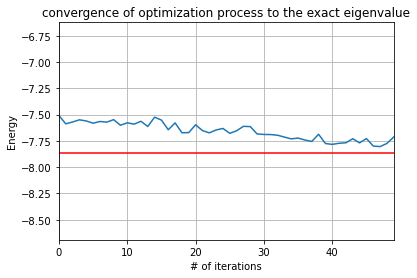

In [273]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [274]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [275]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

3it [00:00, 11.13it/s]

{'0010': 107, '1011': 19, '0001': 42, '1010': 172, '0111': 9, '1110': 165, '1101': 41, '0110': 302, '0101': 55, '0100': 18, '1111': 31, '0000': 8, '1000': 24, '1100': 18, '0011': 9, '1001': 4}
1.0
{'0001': 36, '1010': 171, '1111': 22, '0110': 304, '1000': 13, '0010': 122, '1110': 171, '0100': 22, '0101': 60, '1001': 7, '1101': 49, '0111': 4, '1100': 16, '1011': 11, '0011': 8, '0000': 8}
1.0
{'0101': 62, '1110': 149, '0110': 326, '0010': 99, '1000': 15, '0000': 5, '1010': 186, '1100': 11, '1101': 50, '0100': 20, '0001': 38, '1011': 20, '0111': 6, '1001': 5, '1111': 23, '0011': 9}
1.0


7it [00:00, 13.33it/s]

{'1110': 146, '0101': 66, '0011': 15, '0110': 313, '1111': 31, '1010': 153, '0000': 10, '1101': 40, '1100': 14, '0100': 23, '0001': 40, '1001': 5, '0010': 136, '0111': 13, '1000': 10, '1011': 9}
1.0
{'0010': 142, '1011': 16, '0001': 41, '1010': 167, '0110': 307, '1110': 161, '1000': 12, '0100': 20, '0101': 57, '1111': 25, '1101': 45, '0011': 6, '1100': 9, '0000': 5, '1001': 3, '0111': 8}
1.0
{'1010': 167, '0001': 49, '1111': 29, '0110': 324, '0010': 117, '1110': 154, '1000': 17, '1101': 32, '1100': 18, '0101': 58, '0100': 21, '0111': 7, '0011': 6, '1011': 13, '1001': 3, '0000': 9}
1.0
{'1110': 153, '0101': 63, '0011': 4, '1010': 168, '1111': 25, '0110': 305, '0111': 10, '1101': 48, '0010': 111, '1100': 25, '0100': 18, '1000': 20, '1001': 6, '1011': 17, '0000': 7, '0001': 44}
1.0


9it [00:00, 13.40it/s]

{'0110': 301, '1010': 185, '1101': 39, '0100': 24, '0101': 60, '1110': 147, '1000': 16, '0010': 132, '1111': 33, '0000': 7, '1100': 18, '0001': 36, '0011': 9, '1001': 3, '0111': 7, '1011': 7}
1.0
{'1011': 68, '0110': 52, '0100': 150, '0101': 92, '1110': 184, '0111': 99, '0000': 55, '0011': 40, '1101': 44, '1010': 75, '1000': 42, '0010': 73, '0001': 28, '1100': 8, '1001': 10, '1111': 4}
1.0


11it [00:00, 11.27it/s]

{'0101': 64, '1110': 169, '0010': 579, '1111': 13, '1101': 47, '0011': 30, '1010': 16, '0001': 33, '0100': 12, '1100': 28, '0110': 8, '1000': 8, '0111': 2, '1011': 9, '1001': 6}
1.0
{'0010': 271, '0111': 30, '1110': 69, '0100': 48, '0000': 122, '0001': 115, '1111': 134, '0110': 14, '1100': 72, '1011': 1, '0011': 93, '1010': 34, '0101': 14, '1000': 3, '1001': 3, '1101': 1}
1.0
{'0001': 43, '1010': 176, '1111': 29, '0110': 329, '1101': 39, '1110': 142, '1000': 17, '0010': 119, '0101': 69, '0000': 4, '0111': 6, '1100': 13, '0100': 17, '1011': 12, '1001': 4, '0011': 5}
1.0


15it [00:01, 12.68it/s]


{'1110': 154, '0101': 65, '0010': 122, '1010': 189, '1101': 38, '0110': 302, '1111': 23, '1100': 17, '0001': 40, '0100': 21, '0000': 9, '1000': 15, '0111': 4, '1011': 16, '1001': 3, '0011': 6}
1.0
{'1010': 189, '0001': 49, '1111': 24, '0110': 307, '1110': 133, '1011': 19, '0010': 123, '1101': 44, '0101': 53, '1100': 20, '0111': 8, '1000': 17, '0100': 21, '1001': 4, '0000': 5, '0011': 8}
1.0
{'1111': 22, '0110': 323, '1110': 139, '0101': 53, '0010': 128, '1100': 14, '0011': 13, '1010': 190, '1011': 12, '0111': 10, '0001': 38, '1001': 7, '1101': 38, '0100': 14, '1000': 16, '0000': 7}
1.0


0it [00:00, ?it/s]

{'0110': 324, '0010': 84, '1101': 200, '1010': 155, '0001': 106, '0000': 3, '1000': 5, '1110': 68, '1001': 15, '0101': 40, '1100': 6, '1011': 9, '1111': 7, '0100': 2}
1.0


2it [00:00, 13.22it/s]

{'0110': 338, '1010': 176, '0001': 111, '1101': 173, '1110': 79, '0101': 30, '1011': 6, '0010': 74, '1001': 16, '1111': 9, '1000': 4, '0100': 3, '1100': 4, '0011': 1}
1.0
{'1010': 163, '0001': 117, '0101': 36, '1110': 69, '1111': 4, '0110': 360, '1101': 178, '0010': 52, '1011': 9, '1001': 16, '1100': 8, '0100': 4, '1000': 6, '0111': 1, '0000': 1}
1.0


4it [00:00,  9.67it/s]

{'0001': 113, '1010': 196, '1000': 8, '0110': 314, '1101': 171, '0010': 82, '1110': 70, '1100': 5, '1001': 16, '1011': 9, '0101': 25, '1111': 11, '0100': 4}
1.0


6it [00:00, 10.20it/s]

{'0110': 344, '1001': 19, '1010': 194, '0001': 105, '1101': 171, '0101': 29, '1110': 57, '0010': 76, '0100': 1, '1011': 4, '1100': 5, '1000': 7, '1111': 8, '0011': 2, '0111': 1, '0000': 1}
1.0
{'0001': 111, '1010': 158, '1110': 70, '0101': 46, '0110': 323, '1101': 180, '0010': 86, '1000': 7, '1111': 7, '1011': 9, '1100': 6, '1001': 14, '0011': 1, '0100': 5, '0111': 1}
1.0
{'0110': 324, '1101': 195, '0101': 34, '1110': 63, '0010': 65, '1001': 21, '1010': 179, '1000': 10, '0001': 106, '1100': 5, '1111': 10, '1011': 8, '0011': 1, '0100': 2, '0111': 1}
1.0


8it [00:00, 10.52it/s]

{'0110': 345, '1101': 197, '1001': 16, '0001': 101, '1010': 172, '1011': 3, '0101': 32, '1110': 70, '0010': 69, '1111': 7, '1100': 3, '1000': 7, '0100': 1, '0000': 1}
1.0
{'1110': 134, '0100': 168, '1101': 80, '0001': 72, '1010': 109, '1111': 24, '0111': 124, '1011': 33, '0010': 62, '0000': 35, '1100': 17, '0101': 42, '0011': 22, '1001': 43, '0110': 43, '1000': 16}
1.0


12it [00:01, 10.33it/s]

{'1011': 5, '0010': 495, '0001': 54, '1001': 54, '0101': 144, '1110': 140, '1101': 93, '0110': 14, '1010': 3, '0011': 4, '0100': 11, '1100': 4, '1000': 1, '1111': 2}
1.0
{'0100': 75, '0001': 188, '0010': 226, '0011': 71, '1100': 71, '1110': 75, '1111': 67, '0111': 53, '0110': 25, '0101': 19, '0000': 67, '1010': 29, '1011': 16, '1101': 23, '1001': 8, '1000': 11}
1.0
{'0001': 94, '1010': 200, '1110': 72, '1011': 7, '0010': 85, '0110': 308, '0100': 3, '1101': 172, '0101': 33, '1000': 13, '1001': 17, '1111': 9, '1100': 8, '0000': 2, '0011': 1}
1.0
{'0001': 102, '1010': 163, '0010': 80, '1011': 6, '0110': 322, '1101': 203, '0101': 44, '1110': 65, '1001': 17, '0111': 1, '0100': 5, '1100': 6, '1111': 2, '1000': 7, '0011': 1}
1.0


15it [00:01, 10.95it/s]


{'0110': 334, '1111': 9, '1101': 183, '0001': 99, '1010': 168, '0011': 2, '1110': 82, '0101': 36, '1000': 9, '1001': 20, '1011': 6, '1100': 3, '0010': 70, '0000': 1, '0100': 2}
1.0
{'1111': 6, '0110': 327, '0001': 90, '1010': 172, '1101': 191, '1011': 7, '0010': 74, '0101': 31, '1001': 21, '1000': 5, '1100': 8, '0111': 4, '1110': 83, '0011': 2, '0100': 1, '0000': 2}
1.0


2it [00:00, 16.39it/s]

{'1111': 51, '0110': 299, '0100': 36, '1101': 178, '0001': 70, '1010': 146, '1110': 51, '0111': 14, '0000': 15, '1001': 25, '0010': 56, '0011': 43, '0101': 32, '1100': 2, '1000': 3, '1011': 3}
1.0
{'0110': 276, '1111': 59, '0100': 40, '1101': 154, '1110': 58, '0101': 37, '0010': 47, '1010': 151, '0001': 75, '0000': 25, '0011': 48, '1001': 27, '0111': 16, '1011': 6, '1000': 5}
1.0


4it [00:00,  9.69it/s]

{'1111': 69, '0110': 280, '0001': 98, '1010': 149, '0011': 47, '0100': 33, '1101': 132, '0101': 33, '1110': 74, '1001': 27, '0000': 17, '0111': 16, '0010': 45, '1011': 2, '1000': 2}
1.0
{'0110': 291, '0010': 42, '1110': 82, '0101': 40, '1001': 26, '0001': 81, '1010': 144, '1101': 141, '1111': 61, '0011': 40, '0100': 34, '0111': 15, '1011': 9, '0000': 11, '1000': 7}
1.0
{'1111': 64, '0110': 255, '0001': 82, '1001': 24, '0101': 35, '1110': 71, '0011': 43, '1101': 165, '0100': 32, '0010': 53, '1010': 154, '0000': 22, '1000': 6, '0111': 10, '1011': 8}
1.0


8it [00:00, 12.60it/s]

{'1111': 51, '0110': 283, '1101': 151, '0100': 36, '0111': 20, '0101': 43, '1110': 67, '1010': 140, '0011': 51, '0001': 77, '0010': 49, '0000': 23, '1001': 25, '1011': 5, '1000': 2, '1100': 1}
1.0
{'1111': 54, '0110': 283, '0001': 82, '1010': 150, '0101': 44, '1000': 4, '0000': 20, '1101': 131, '1110': 56, '0100': 40, '0011': 63, '0111': 17, '1001': 30, '0010': 45, '1011': 3, '1100': 2}
1.0
{'0010': 47, '0001': 93, '0101': 37, '1110': 68, '0111': 18, '1101': 152, '0110': 258, '1111': 59, '1010': 152, '0100': 22, '0011': 42, '1001': 31, '1011': 11, '0000': 23, '1100': 2, '1000': 9}
1.0


10it [00:00, 13.14it/s]

{'0111': 201, '1010': 68, '0001': 50, '1001': 88, '0000': 60, '1101': 70, '0100': 86, '1110': 163, '0011': 9, '0101': 11, '1100': 50, '0110': 52, '0010': 82, '1000': 8, '1011': 15, '1111': 11}
1.0
{'1011': 47, '0010': 383, '0101': 129, '1110': 159, '0000': 28, '1000': 22, '1101': 81, '1111': 18, '0001': 35, '1001': 53, '0110': 12, '0011': 20, '1100': 13, '0111': 22, '1010': 2}
1.0


12it [00:01, 10.94it/s]

{'0100': 105, '1101': 19, '0010': 273, '1000': 31, '1001': 58, '0101': 43, '0011': 75, '0111': 41, '1011': 36, '0001': 75, '0000': 41, '1110': 105, '1111': 98, '1100': 19, '0110': 5}
1.0
{'0101': 38, '1110': 72, '0001': 98, '1010': 160, '1111': 54, '0110': 243, '0011': 50, '0000': 15, '0010': 47, '0100': 33, '1101': 147, '1001': 31, '1011': 4, '0111': 27, '1000': 5}
1.0
{'0001': 85, '0101': 44, '1110': 73, '1111': 54, '0110': 244, '0010': 60, '0100': 31, '1101': 149, '1010': 170, '1001': 25, '0000': 23, '0011': 42, '1011': 9, '0111': 9, '1000': 4, '1100': 2}
1.0


15it [00:01, 12.04it/s]


{'0010': 36, '1010': 163, '0111': 12, '0110': 277, '0100': 46, '1101': 130, '0011': 68, '0101': 41, '1100': 2, '1001': 14, '0001': 81, '1111': 69, '1110': 62, '1011': 1, '0000': 17, '1000': 5}
1.0
{'1010': 146, '0100': 35, '1101': 135, '0011': 45, '1111': 55, '0110': 286, '1110': 67, '0010': 46, '0111': 23, '1001': 27, '0001': 76, '0101': 47, '0000': 27, '1000': 4, '1011': 3, '1100': 2}
1.0


0it [00:00, ?it/s]

{'0110': 341, '1010': 90, '1001': 64, '0001': 147, '1101': 268, '1011': 7, '0010': 48, '0101': 33, '1100': 5, '1110': 9, '0011': 2, '0111': 2, '1111': 3, '0100': 3, '1000': 1, '0000': 1}
1.0


2it [00:00, 13.94it/s]

{'1001': 66, '1010': 86, '0001': 135, '1101': 275, '0010': 61, '0110': 341, '1110': 7, '0101': 34, '1100': 4, '1000': 2, '1011': 5, '1111': 6, '0100': 2}
1.0
{'1101': 293, '1010': 90, '1001': 68, '0001': 131, '0110': 322, '0010': 67, '0101': 23, '1110': 8, '1100': 7, '0100': 5, '1011': 2, '0000': 2, '0011': 2, '1000': 3, '1111': 1}
1.0


4it [00:00, 13.94it/s]

{'1101': 262, '1001': 68, '1010': 117, '0001': 142, '0110': 320, '1110': 10, '0101': 30, '0010': 56, '0000': 1, '1111': 2, '1011': 9, '0100': 3, '1000': 2, '1100': 2}
1.0
{'1101': 306, '0110': 329, '0001': 110, '1010': 91, '1001': 61, '0010': 60, '1110': 18, '0101': 33, '1000': 5, '1111': 2, '1100': 4, '0111': 2, '1011': 3}
1.0


6it [00:00, 11.41it/s]

{'1001': 64, '0001': 127, '1010': 110, '1101': 279, '0101': 28, '0110': 338, '1011': 4, '0010': 54, '1000': 4, '0100': 2, '1100': 3, '1111': 3, '1110': 7, '0000': 1}
1.0
{'0110': 325, '1001': 72, '1010': 97, '0001': 119, '0100': 2, '1101': 289, '1011': 5, '0010': 71, '1000': 2, '0101': 31, '1100': 3, '0011': 1, '1111': 2, '1110': 4, '0111': 1}
1.0


8it [00:00, 13.13it/s]

{'1001': 55, '1010': 108, '0001': 123, '0110': 323, '1101': 295, '0010': 71, '1000': 3, '1110': 12, '0101': 17, '1011': 5, '1111': 2, '1100': 3, '0111': 1, '0100': 5, '0000': 1}
1.0
{'1110': 115, '0111': 91, '1111': 56, '0110': 84, '1101': 82, '1010': 82, '0011': 58, '0000': 69, '0010': 38, '0100': 88, '1000': 2, '0101': 98, '1011': 33, '0001': 37, '1001': 45, '1100': 46}
1.0


10it [00:00, 14.61it/s]

{'1010': 26, '1001': 118, '0001': 231, '0101': 147, '1110': 255, '0010': 210, '0110': 18, '0100': 3, '1011': 5, '0111': 1, '0011': 6, '1101': 4}
1.0
{'0110': 15, '1111': 84, '1110': 77, '1001': 24, '0001': 184, '0100': 67, '1100': 74, '0011': 26, '0010': 202, '1011': 58, '0101': 23, '1000': 36, '0111': 71, '1101': 39, '1010': 31, '0000': 13}
1.0


12it [00:00, 15.06it/s]

{'0110': 299, '1010': 98, '0001': 146, '1001': 74, '1101': 294, '0010': 64, '1011': 10, '0101': 25, '1110': 6, '1111': 1, '1100': 2, '0100': 3, '0000': 2}
1.0
{'1010': 98, '0001': 125, '1001': 71, '0110': 332, '1101': 274, '1011': 9, '0010': 68, '1000': 4, '0101': 21, '1100': 4, '0100': 4, '1110': 9, '0000': 2, '1111': 3}
1.0


15it [00:01, 11.16it/s]


{'0100': 3, '1101': 270, '0110': 345, '0101': 23, '0010': 54, '1001': 65, '0001': 118, '1010': 109, '1110': 12, '0111': 2, '1000': 5, '1011': 9, '1100': 3, '1111': 3, '0011': 2, '0000': 1}
1.0
{'1101': 293, '1111': 6, '0110': 327, '0010': 67, '1001': 70, '1010': 94, '0001': 122, '0101': 24, '1100': 1, '1000': 2, '1011': 9, '1110': 4, '0100': 5}
1.0


2it [00:00, 11.98it/s]

{'1101': 252, '1011': 8, '0010': 180, '1010': 90, '1001': 115, '0101': 110, '1110': 11, '0110': 206, '1111': 1, '0001': 32, '1100': 1, '1000': 11, '0100': 3, '0111': 3, '0000': 1}
1.0
{'1101': 264, '1111': 1, '0110': 207, '0001': 32, '1010': 76, '1001': 107, '0101': 112, '0010': 188, '1110': 16, '1000': 4, '1011': 7, '0111': 2, '0100': 7, '1100': 1}
1.0
{'1000': 6, '1101': 255, '0110': 217, '0010': 184, '0001': 42, '1001': 115, '1010': 63, '0101': 103, '1110': 15, '0111': 5, '1011': 12, '1111': 4, '1100': 3}
1.0


6it [00:00,  8.20it/s]

{'1110': 13, '0101': 113, '1101': 246, '1010': 100, '1001': 115, '1011': 6, '0010': 198, '0110': 190, '0001': 25, '0011': 2, '0100': 4, '1111': 3, '0111': 2, '1000': 7}
1.0
{'0110': 231, '1110': 17, '0101': 115, '0010': 167, '1001': 104, '1010': 82, '0001': 30, '1101': 255, '1111': 2, '0111': 3, '1100': 3, '1011': 9, '0100': 2, '1000': 4}
1.0
{'0001': 37, '1010': 84, '1001': 112, '1101': 248, '0010': 205, '0110': 199, '1110': 19, '0101': 98, '1000': 4, '0100': 4, '1011': 8, '1111': 5, '0111': 1}
1.0


8it [00:00,  9.85it/s]

{'0001': 24, '1001': 104, '1010': 109, '1101': 237, '1011': 12, '0010': 198, '0101': 97, '0110': 210, '1100': 2, '1110': 17, '1111': 5, '0111': 1, '0100': 2, '1000': 6}
1.0
{'0010': 195, '1101': 275, '0001': 24, '1010': 78, '1001': 122, '1111': 4, '0110': 190, '0101': 105, '0100': 5, '1011': 5, '1110': 9, '0111': 4, '1000': 6, '0000': 1, '1100': 1}
1.0
{'0110': 48, '1111': 131, '0100': 94, '0111': 90, '0010': 74, '0011': 52, '1110': 41, '1010': 134, '1100': 76, '1001': 58, '0000': 47, '0101': 83, '0001': 62, '1101': 27, '1000': 7}
1.0


12it [00:01, 10.22it/s]

{'0110': 129, '1110': 138, '0101': 210, '1010': 45, '0001': 264, '1001': 15, '0100': 8, '0010': 174, '0011': 7, '0111': 3, '1011': 13, '1101': 16, '1100': 2}
1.0
{'0011': 33, '0000': 13, '1101': 41, '0100': 189, '0101': 8, '1110': 55, '0010': 213, '0110': 20, '0111': 164, '0001': 171, '1011': 50, '1001': 14, '1100': 10, '1000': 18, '1111': 24, '1010': 1}
1.0
{'1101': 250, '0001': 33, '1001': 114, '1010': 99, '0101': 107, '0010': 183, '1000': 6, '0110': 201, '1100': 2, '1111': 2, '1011': 12, '0100': 1, '1110': 11, '0000': 1, '0111': 2}
1.0


15it [00:01, 10.38it/s]


{'0010': 166, '0001': 35, '1001': 121, '1010': 90, '0110': 220, '1101': 256, '0101': 103, '0111': 4, '0011': 3, '1011': 6, '1000': 7, '1110': 9, '0100': 1, '1111': 1, '1100': 1, '0000': 1}
1.0
{'1011': 13, '0010': 181, '1101': 244, '0110': 221, '1110': 14, '0101': 113, '1010': 86, '1001': 116, '0001': 25, '0100': 1, '0111': 4, '1000': 5, '0011': 1}
1.0
{'0010': 210, '1011': 9, '1101': 246, '0110': 201, '0001': 21, '1010': 91, '1110': 15, '0101': 99, '1001': 122, '0111': 1, '0100': 2, '1000': 3, '1111': 2, '0000': 2}
1.0


0it [00:00, ?it/s]

{'0001': 108, '1001': 99, '1010': 127, '0010': 29, '0100': 6, '1101': 274, '0110': 331, '0101': 28, '1111': 1, '1011': 5, '1100': 6, '0000': 4, '1000': 1, '1110': 5}
1.0


2it [00:00, 16.39it/s]

{'0001': 88, '1010': 127, '0100': 4, '1101': 285, '0110': 325, '0010': 38, '0101': 37, '1100': 1, '1001': 105, '1011': 12, '1111': 1, '1110': 1}
1.0
{'1100': 4, '0101': 31, '1001': 108, '1010': 147, '0001': 107, '0110': 294, '0100': 4, '1101': 280, '0011': 3, '0010': 30, '0000': 3, '1011': 10, '1111': 1, '0111': 1, '1110': 1}
1.0


4it [00:00, 10.96it/s]

{'0110': 344, '1101': 277, '1011': 5, '0010': 32, '0001': 85, '1001': 105, '1010': 130, '0101': 36, '0100': 2, '1100': 1, '1000': 2, '1110': 3, '1111': 1, '0011': 1}
1.0
{'0110': 328, '1001': 112, '1010': 123, '0001': 85, '1101': 274, '1100': 2, '0010': 45, '1110': 6, '0101': 34, '0000': 2, '1011': 7, '0100': 5, '1000': 1}
1.0


8it [00:00, 11.20it/s]

{'1001': 88, '1010': 136, '0001': 83, '0110': 351, '1101': 280, '0101': 24, '0010': 32, '1100': 4, '1011': 6, '1110': 7, '0011': 1, '0100': 8, '0000': 3, '1111': 1}
1.0
{'0111': 2, '1010': 125, '1001': 104, '0001': 99, '1101': 276, '0110': 325, '0101': 34, '1110': 14, '0010': 27, '1011': 10, '1100': 2, '0000': 1, '0100': 4, '1000': 1}
1.0
{'0101': 31, '1101': 281, '0001': 85, '1001': 102, '1010': 150, '0110': 325, '0010': 26, '1100': 1, '1110': 8, '0100': 5, '0011': 1, '1011': 6, '0000': 1, '1111': 2}
1.0
{'0100': 48, '1101': 86, '1010': 98, '0110': 107, '0101': 165, '1110': 74, '0000': 33, '0010': 23, '0111': 50, '0001': 19, '1100': 70, '1000': 12, '1001': 102, '0011': 41, '1111': 58, '1011': 38}
1.0


12it [00:00, 14.08it/s]

{'0010': 257, '1010': 14, '0001': 256, '1001': 165, '0101': 94, '1110': 197, '0110': 23, '1101': 5, '1011': 2, '0111': 1, '1111': 2, '0100': 7, '1100': 1}
1.0
{'1010': 22, '1001': 37, '0001': 210, '1100': 40, '1111': 47, '0010': 252, '0111': 34, '1110': 53, '0101': 12, '1101': 73, '1011': 72, '0011': 36, '1000': 33, '0100': 58, '0110': 11, '0000': 34}
1.0
{'0110': 312, '1101': 259, '0001': 107, '1001': 106, '1010': 155, '0000': 4, '0010': 29, '0101': 35, '0100': 5, '1110': 6, '0111': 1, '1100': 1, '0011': 1, '1011': 2, '1111': 1}
1.0
{'0110': 327, '1001': 86, '0001': 98, '1010': 140, '1101': 277, '0101': 38, '0010': 24, '1011': 4, '1100': 6, '1110': 6, '0100': 8, '1000': 1, '0011': 2, '1111': 2, '0111': 3, '0000': 2}

15it [00:01, 12.35it/s]



1.0
{'1001': 85, '1010': 140, '0001': 86, '0110': 328, '1101': 284, '0101': 42, '0010': 33, '1100': 6, '1000': 1, '1011': 5, '1110': 10, '0011': 1, '0100': 3}
1.0
{'0001': 104, '1001': 100, '1010': 135, '0110': 314, '0100': 7, '1101': 277, '0101': 33, '1110': 5, '0010': 41, '1011': 3, '0000': 4, '0111': 1}
1.0


2it [00:00, 17.86it/s]

{'0110': 316, '1110': 9, '0101': 26, '1010': 146, '0001': 100, '1001': 79, '1101': 307, '0010': 24, '1011': 10, '1100': 2, '0100': 3, '0111': 1, '0000': 1}
1.0
{'0110': 341, '0100': 2, '1101': 261, '1001': 96, '1010': 135, '0001': 94, '0101': 42, '0010': 36, '0000': 1, '1110': 9, '1100': 3, '1111': 1, '1011': 3}
1.0
{'1001': 110, '1010': 133, '0001': 96, '1101': 286, '0010': 39, '0110': 306, '1110': 4, '0101': 35, '1011': 7, '0000': 1, '1100': 3, '0100': 3, '1000': 1}
1.0


6it [00:00, 16.76it/s]

{'0001': 95, '1001': 108, '1010': 148, '1101': 260, '0010': 40, '0110': 315, '0101': 34, '1100': 6, '1110': 8, '0100': 5, '0000': 1, '0011': 1, '1011': 3}
1.0
{'0110': 317, '0001': 92, '1001': 113, '1010': 142, '0010': 41, '1101': 263, '1100': 3, '0101': 34, '1011': 5, '1110': 3, '0100': 5, '1111': 3, '0011': 2, '0111': 1}
1.0
{'0001': 86, '1001': 113, '1010': 157, '1101': 257, '0110': 303, '0010': 37, '1011': 12, '0101': 43, '1100': 2, '1111': 1, '0011': 1, '1110': 9, '0100': 3}
1.0
{'0110': 326, '1001': 106, '0001': 96, '1010': 142, '0101': 25, '1101': 270, '0000': 3, '0010': 34, '1111': 5, '1011': 5, '1110': 5, '0011': 2, '0100': 4, '0111': 1}
1.0


10it [00:00, 17.07it/s]

{'0110': 292, '0010': 37, '1011': 11, '1101': 310, '1010': 158, '0001': 95, '1001': 72, '0101': 32, '0111': 2, '1110': 6, '1100': 4, '1111': 2, '1000': 1, '0100': 1, '0000': 1}
1.0
{'1100': 80, '0000': 36, '0010': 25, '0100': 50, '1101': 74, '1010': 112, '1001': 84, '0001': 23, '0101': 144, '0110': 106, '0011': 51, '1011': 41, '0111': 40, '1110': 80, '1111': 62, '1000': 16}
1.0
{'1010': 18, '0001': 254, '1001': 142, '0110': 19, '1110': 203, '0101': 106, '0010': 262, '0111': 7, '0100': 4, '1011': 2, '1101': 5, '0011': 1, '1111': 1}
1.0
{'0110': 11, '1111': 50, '0100': 73, '0010': 244, '0001': 220, '0101': 12, '0011': 25, '1000': 48, '1011': 67, '1101': 82, '1110': 57, '0000': 21, '1010': 35, '0111': 28, '1100': 26, '1001': 25}
1.0


12it [00:00, 17.46it/s]

{'0110': 323, '1101': 311, '0001': 80, '1010': 135, '1001': 86, '0010': 40, '1110': 6, '1100': 2, '0101': 22, '1011': 9, '0100': 2, '0000': 4, '0111': 2, '1111': 1, '0011': 1}
1.0
{'1001': 128, '0001': 86, '1010': 137, '1101': 271, '0010': 29, '1110': 4, '0101': 35, '0110': 311, '0000': 3, '1111': 3, '1011': 6, '0100': 8, '0011': 1, '1100': 2}
1.0


15it [00:01, 14.32it/s]


{'1101': 304, '0110': 299, '1010': 129, '0001': 92, '1001': 101, '0010': 39, '1011': 8, '0101': 32, '0000': 2, '1110': 9, '0100': 3, '1100': 3, '1111': 2, '0011': 1}
1.0
{'0100': 4, '1101': 278, '0010': 33, '0110': 296, '0101': 46, '1001': 106, '0001': 82, '1010': 157, '1110': 10, '1011': 7, '0000': 2, '0011': 1, '1111': 1, '1100': 1}
1.0


0it [00:00, ?it/s]

{'1101': 275, '0110': 337, '0001': 108, '1010': 125, '1001': 105, '1110': 5, '0010': 22, '0000': 1, '1011': 4, '0101': 30, '0100': 5, '1000': 3, '1100': 3, '0011': 1}
1.0


2it [00:00, 12.80it/s]

{'0100': 8, '1101': 270, '1010': 141, '1001': 105, '0001': 91, '0110': 325, '0101': 35, '0010': 35, '0011': 1, '1110': 3, '1011': 7, '1100': 1, '0000': 2}
1.0
{'1101': 297, '0001': 86, '1001': 106, '1010': 145, '0110': 325, '0010': 22, '0101': 19, '1100': 4, '1011': 7, '1110': 5, '0100': 2, '1111': 2, '0011': 2, '0000': 2}
1.0


4it [00:00, 13.00it/s]

{'0100': 9, '1101': 259, '1010': 116, '1001': 103, '0001': 101, '0110': 346, '0101': 37, '1011': 7, '0010': 35, '0000': 2, '1100': 2, '1110': 5, '1000': 1, '1111': 1}
1.0
{'0110': 316, '1101': 271, '1010': 138, '1001': 106, '0101': 27, '0010': 33, '1011': 8, '1100': 3, '0001': 107, '1110': 6, '0100': 5, '0111': 3, '1111': 1}
1.0


6it [00:00, 10.40it/s]

{'0110': 313, '1001': 119, '1010': 142, '0001': 95, '1101': 266, '1011': 9, '0010': 36, '0101': 30, '1000': 2, '0000': 2, '0111': 1, '1110': 3, '1111': 2, '0100': 2, '0011': 1, '1100': 1}
1.0
{'0110': 335, '1101': 267, '1001': 94, '1010': 150, '0001': 100, '0010': 34, '1011': 8, '0101': 23, '0100': 5, '1000': 1, '1111': 1, '0000': 1, '1110': 2, '0011': 1, '1100': 2}
1.0


8it [00:00, 10.82it/s]

{'0110': 311, '1001': 94, '1010': 154, '0001': 110, '1101': 260, '0101': 32, '0010': 41, '1100': 2, '0100': 6, '1000': 1, '1011': 6, '1110': 4, '0000': 3}
1.0


10it [00:00, 12.45it/s]

{'0100': 60, '1101': 92, '0010': 33, '0000': 42, '0101': 181, '1110': 65, '1100': 64, '0110': 100, '1010': 117, '1001': 81, '1111': 65, '0011': 35, '0001': 18, '0111': 37, '1000': 8, '1011': 26}
1.0
{'0010': 263, '1010': 23, '1001': 147, '0001': 235, '1110': 202, '0101': 108, '1101': 4, '0110': 27, '0100': 8, '0111': 2, '0000': 2, '1011': 2, '1111': 1}
1.0
{'1111': 47, '1110': 47, '0001': 228, '0010': 219, '1101': 76, '0100': 66, '1100': 31, '0000': 35, '0111': 43, '0101': 13, '1000': 37, '1011': 94, '1001': 22, '0011': 30, '1010': 23, '0110': 13}
1.0


12it [00:00, 13.24it/s]

{'0010': 39, '0001': 103, '1010': 142, '1001': 97, '0110': 308, '0100': 9, '1101': 267, '0101': 35, '0111': 4, '1011': 11, '1000': 2, '1110': 4, '1111': 1, '1100': 1, '0000': 1}
1.0


14it [00:01, 13.26it/s]

{'1101': 293, '1001': 94, '0001': 82, '1010': 124, '0110': 344, '0010': 32, '1110': 7, '0101': 34, '0100': 5, '1011': 5, '1000': 1, '1100': 1, '0000': 1, '1111': 1}
1.0
{'0110': 321, '0001': 91, '1001': 104, '1010': 135, '1101': 292, '0010': 34, '0101': 21, '1100': 1, '1111': 2, '0100': 6, '0000': 2, '0111': 2, '1110': 7, '1011': 6}
1.0


15it [00:01, 11.94it/s]


{'0110': 315, '0010': 36, '0001': 95, '1010': 127, '1001': 99, '0100': 2, '1101': 293, '0101': 32, '0011': 2, '1110': 7, '1011': 7, '0111': 2, '0000': 2, '1111': 2, '1000': 1, '1100': 2}
1.0


2it [00:00, 12.77it/s]

{'0010': 32, '1011': 4, '1001': 110, '1010': 126, '0001': 93, '0110': 317, '0101': 24, '1101': 302, '0100': 4, '1110': 8, '1100': 3, '0000': 1}
1.0
{'1001': 125, '0001': 93, '1010': 125, '0110': 336, '1101': 250, '0010': 30, '1100': 6, '0101': 34, '1011': 9, '0000': 2, '1110': 7, '0100': 5, '1000': 2}
1.0
{'0110': 324, '1011': 9, '1001': 103, '1010': 138, '0001': 102, '0100': 11, '1101': 258, '1000': 1, '1110': 11, '0101': 31, '0010': 31, '1100': 1, '1111': 3, '0000': 1}
1.0


4it [00:00, 13.30it/s]

{'1011': 9, '0010': 33, '1101': 272, '1010': 146, '1001': 103, '0001': 85, '0110': 335, '0111': 1, '0101': 23, '0100': 4, '1110': 10, '0000': 2, '1100': 1}
1.0
{'1101': 270, '0110': 328, '0001': 83, '1001': 117, '1010': 134, '0111': 2, '1000': 1, '0101': 32, '0010': 34, '1110': 9, '0100': 3, '1011': 7, '1100': 2, '0000': 2}
1.0


6it [00:00, 12.96it/s]

{'0100': 6, '1101': 250, '1010': 150, '0001': 95, '1001': 107, '0110': 323, '0101': 41, '0010': 35, '1110': 6, '1011': 6, '1100': 4, '0111': 1}
1.0
{'0001': 97, '1001': 98, '1010': 139, '1100': 4, '1101': 264, '0110': 333, '0101': 24, '0010': 34, '1110': 10, '1111': 1, '1011': 7, '0111': 1, '0100': 10, '1000': 1, '0011': 1}
1.0


8it [00:00, 10.40it/s]

{'0110': 303, '0001': 108, '1010': 135, '1001': 117, '0100': 8, '1101': 267, '0101': 33, '1011': 6, '0010': 37, '0111': 2, '1111': 2, '1110': 2, '1100': 2, '0000': 1, '0011': 1}
1.0
{'0100': 51, '1101': 88, '1001': 93, '1010': 122, '0101': 164, '1110': 71, '1100': 64, '0110': 110, '1111': 62, '0001': 18, '0011': 51, '0000': 36, '0111': 41, '0010': 19, '1000': 11, '1011': 23}
1.0


10it [00:00,  9.17it/s]

{'1010': 13, '1001': 155, '0001': 250, '0010': 235, '0101': 122, '1110': 207, '0110': 22, '1100': 3, '1011': 6, '0100': 6, '1111': 2, '1101': 3}
1.0
{'0001': 227, '1011': 67, '0010': 206, '1111': 50, '1101': 85, '0100': 63, '0000': 30, '1110': 58, '1000': 53, '0011': 31, '0101': 20, '0111': 35, '0110': 14, '1100': 34, '1010': 34, '1001': 17}
1.0


12it [00:01, 10.22it/s]

{'1001': 104, '0001': 99, '1010': 150, '0110': 312, '0100': 7, '1101': 261, '0101': 41, '0000': 3, '0010': 30, '1011': 6, '1110': 8, '0011': 1, '0111': 1, '1000': 1}
1.0


15it [00:01, 11.35it/s]

{'0110': 344, '1010': 137, '0001': 95, '1001': 103, '1101': 267, '0010': 40, '1110': 3, '0101': 22, '1111': 3, '0100': 3, '1011': 4, '0000': 2, '0111': 1}
1.0
{'1101': 300, '0110': 302, '0001': 90, '1001': 116, '1010': 149, '1110': 2, '0101': 25, '0010': 28, '0011': 1, '1011': 5, '1100': 2, '0100': 3, '1111': 1}
1.0
{'1101': 273, '0001': 97, '1001': 106, '1010': 133, '0110': 326, '0010': 31, '1110': 8, '0101': 35, '0100': 5, '1100': 1, '1111': 1, '0111': 3, '1011': 3, '0000': 1, '0011': 1}
1.0



3it [00:00,  9.31it/s]

{'0110': 354, '0100': 2, '1101': 160, '1100': 33, '1011': 37, '1110': 6, '1001': 99, '1010': 84, '0101': 21, '0010': 34, '0001': 75, '0111': 64, '0000': 32, '1111': 9, '0011': 13, '1000': 1}
1.0
{'0110': 354, '1100': 52, '0011': 8, '0010': 48, '1101': 154, '1010': 81, '0001': 79, '1001': 67, '0111': 63, '1000': 2, '1011': 34, '0000': 42, '0101': 22, '1111': 11, '1110': 6, '0100': 1}
1.0
{'1011': 45, '1101': 162, '0110': 340, '1010': 82, '0001': 85, '0111': 62, '1110': 8, '0000': 28, '0010': 28, '1100': 33, '1001': 99, '0101': 25, '0100': 7, '0011': 10, '1111': 9, '1000': 1}
1.0


7it [00:00, 14.04it/s]

{'0110': 345, '1101': 153, '1010': 76, '0001': 83, '1000': 7, '0000': 48, '0111': 61, '0101': 20, '1100': 52, '1001': 80, '0011': 16, '0010': 31, '1011': 35, '1111': 7, '0100': 5, '1110': 5}
1.0
{'1011': 40, '0110': 334, '1100': 45, '0011': 5, '1101': 171, '0111': 72, '1001': 85, '0001': 87, '1110': 8, '1010': 77, '0010': 21, '0000': 40, '1111': 5, '0101': 27, '0100': 5, '1000': 2}
1.0
{'1001': 80, '1010': 79, '0001': 83, '0110': 354, '1101': 183, '1100': 40, '1011': 40, '0010': 26, '0111': 49, '0100': 8, '0000': 33, '0011': 15, '0101': 20, '1110': 6, '1111': 5, '1000': 3}
1.0
{'0110': 331, '1100': 47, '1101': 169, '0001': 85, '1010': 71, '1001': 93, '0101': 19, '0111': 75, '0010': 37, '0000': 32, '1110': 8, '1111': 8, '0011': 13, '1011': 29, '0100': 6, '1000': 1}
1.0


9it [00:00, 13.52it/s]

{'1101': 166, '0101': 14, '1010': 67, '1001': 124, '0000': 49, '0110': 314, '0010': 32, '0111': 55, '0001': 96, '0011': 12, '1100': 38, '1011': 40, '1111': 6, '1000': 2, '1110': 5, '0100': 4}
1.0
{'0000': 67, '1010': 96, '1001': 41, '0101': 216, '0111': 94, '1011': 39, '1101': 83, '0011': 30, '1111': 54, '0100': 34, '0010': 63, '1110': 53, '1000': 27, '0110': 77, '0001': 33, '1100': 17}
1.0


13it [00:01, 13.36it/s]

{'0111': 38, '1011': 76, '0010': 245, '1001': 80, '0001': 250, '0000': 30, '1110': 147, '0101': 24, '1010': 55, '0011': 2, '0100': 26, '1100': 24, '0110': 23, '1101': 2, '1000': 2}
1.0
{'1011': 129, '0010': 268, '1001': 60, '1010': 13, '0001': 187, '1100': 73, '0011': 37, '0100': 23, '0101': 64, '0000': 19, '1101': 68, '0111': 25, '0110': 19, '1000': 14, '1110': 14, '1111': 11}
1.0
{'0110': 370, '1101': 146, '0111': 59, '1001': 93, '1010': 72, '0001': 79, '0010': 29, '0000': 38, '0101': 21, '1100': 44, '1011': 42, '0100': 3, '0011': 15, '1000': 3, '1111': 6, '1110': 4}
1.0
{'1101': 156, '0110': 350, '1100': 50, '0011': 15, '0001': 88, '1001': 83, '0000': 33, '0010': 36, '1010': 84, '0111': 60, '0101': 16, '1011': 37, '1111': 8, '0100': 2, '1000': 2, '1110': 4}
1.0


15it [00:01, 12.61it/s]


{'0110': 331, '1001': 78, '1010': 88, '0001': 84, '0101': 25, '0000': 38, '1011': 39, '0111': 67, '0011': 12, '1101': 175, '0010': 30, '1111': 8, '1100': 39, '1110': 5, '1000': 3, '0100': 2}
1.0
{'0101': 26, '0110': 329, '0001': 78, '1010': 76, '0100': 5, '1101': 169, '1011': 39, '0011': 13, '0111': 58, '0000': 39, '1001': 103, '0010': 38, '1100': 36, '1110': 9, '1111': 4, '1000': 2}
1.0


2it [00:00, 17.70it/s]

{'1010': 105, '1001': 83, '0110': 263, '0101': 37, '1011': 57, '0111': 84, '1100': 92, '1101': 173, '0001': 48, '0010': 21, '0100': 10, '1000': 23, '0000': 10, '0011': 7, '1110': 5, '1111': 6}
1.0
{'1001': 82, '0001': 70, '1010': 113, '1011': 56, '1101': 183, '1100': 88, '1110': 4, '0110': 263, '0101': 23, '1000': 18, '0111': 80, '0010': 14, '0011': 6, '0100': 7, '0000': 9, '1111': 8}
1.0
{'0001': 57, '1010': 102, '1101': 164, '1111': 5, '0110': 279, '1011': 51, '0010': 23, '1100': 83, '0100': 9, '1001': 76, '0101': 36, '0111': 88, '1110': 7, '1000': 25, '0011': 6, '0000': 13}
1.0


4it [00:00, 10.31it/s]

{'1101': 170, '1100': 93, '1010': 104, '1001': 71, '0001': 61, '1011': 59, '0010': 14, '0110': 279, '0111': 84, '0011': 6, '0101': 23, '1111': 6, '0100': 19, '1000': 20, '0000': 9, '1110': 6}
1.0
{'1101': 186, '0110': 251, '1010': 96, '0001': 82, '0111': 83, '1100': 81, '1011': 67, '1000': 25, '1110': 9, '0010': 16, '1001': 59, '0100': 15, '0011': 7, '0101': 26, '0000': 14, '1111': 7}
1.0
{'1100': 76, '0011': 9, '1011': 81, '0001': 63, '0111': 85, '0100': 19, '0110': 270, '0000': 8, '1101': 178, '0101': 21, '1010': 101, '1001': 74, '0010': 19, '1110': 3, '1000': 12, '1111': 5}


6it [00:00, 10.47it/s]

1.0
{'1010': 113, '0001': 77, '1001': 78, '0110': 261, '0111': 77, '0101': 24, '1100': 84, '1101': 182, '1011': 50, '1000': 22, '0100': 16, '1110': 4, '0011': 6, '0010': 19, '0000': 9, '1111': 2}
1.0


8it [00:00, 11.66it/s]

{'1100': 101, '0001': 55, '1001': 69, '1010': 119, '0110': 267, '1011': 52, '0100': 16, '1101': 187, '0011': 6, '0111': 74, '1111': 4, '0010': 12, '0101': 25, '0000': 12, '1000': 18, '1110': 7}
1.0


10it [00:00, 12.16it/s]

{'1101': 136, '0100': 120, '0101': 149, '1110': 34, '1010': 105, '0000': 36, '1011': 85, '0111': 30, '1001': 34, '0001': 23, '1100': 74, '0110': 105, '1111': 57, '0011': 19, '0010': 16, '1000': 1}
1.0
{'0010': 215, '1010': 12, '1001': 77, '0001': 184, '0100': 96, '0101': 54, '1110': 164, '0111': 73, '1100': 30, '1011': 59, '0110': 15, '0000': 25, '1111': 5, '1000': 6, '0011': 6, '1101': 3}
1.0


12it [00:01,  8.44it/s]

{'1111': 52, '0001': 257, '1010': 40, '0010': 99, '1011': 130, '1110': 97, '0100': 188, '0000': 48, '0011': 14, '0101': 33, '1101': 27, '1100': 16, '0111': 3, '0110': 17, '1001': 2, '1000': 1}
1.0
{'0110': 262, '1101': 175, '0010': 14, '1010': 95, '0001': 82, '1100': 97, '0111': 76, '1110': 8, '0101': 30, '0000': 23, '1011': 52, '1001': 75, '1000': 18, '1111': 3, '0011': 4, '0100': 10}
1.0
{'1101': 173, '0101': 24, '1011': 55, '1001': 94, '1010': 113, '0001': 56, '1100': 86, '0110': 264, '1110': 4, '0111': 91, '1000': 18, '0010': 20, '0100': 11, '0011': 3, '0000': 9, '1111': 3}
1.0


15it [00:01, 10.35it/s]


{'1010': 92, '0111': 84, '1011': 51, '1100': 107, '0110': 259, '0000': 8, '1101': 169, '0101': 34, '0010': 24, '1000': 24, '1001': 85, '0001': 60, '0100': 17, '1110': 4, '0011': 3, '1111': 3}
1.0
{'0110': 244, '1111': 5, '1101': 190, '0100': 17, '0101': 21, '0010': 15, '1011': 67, '1100': 99, '0001': 56, '1010': 88, '1001': 94, '0111': 77, '1000': 22, '0000': 18, '1110': 7, '0011': 4}
1.0


0it [00:00, ?it/s]

{'0110': 205, '1101': 194, '0001': 138, '1001': 161, '1010': 257, '0010': 27, '0101': 19, '0011': 5, '0100': 1, '1011': 6, '1100': 3, '1110': 3, '1111': 3, '0000': 2}
1.0
{'1101': 177, '0110': 204, '0010': 22, '0001': 133, '1001': 182, '1010': 277, '0101': 14, '0011': 6, '0000': 4, '1011': 2, '1100': 1, '0111': 1, '1111': 1}
1.0


4it [00:00, 10.45it/s]

{'0001': 129, '1010': 249, '1001': 208, '0110': 222, '1101': 162, '1100': 2, '0101': 12, '1011': 6, '0010': 23, '0100': 3, '0000': 2, '0011': 5, '1110': 1}
1.0
{'0110': 233, '1101': 165, '0001': 130, '1001': 194, '1010': 247, '0101': 19, '0010': 20, '0111': 1, '0011': 5, '1011': 7, '0100': 2, '0000': 1}
1.0
{'1101': 167, '0110': 189, '1010': 281, '0001': 136, '1001': 188, '0010': 25, '1011': 4, '0101': 21, '0011': 10, '1100': 2, '1110': 1}
1.0


8it [00:00, 13.31it/s]

{'0001': 130, '1001': 208, '1010': 246, '0100': 2, '1101': 161, '0110': 227, '1110': 2, '0010': 18, '0111': 4, '0101': 12, '0000': 1, '1100': 3, '1011': 6, '0011': 3, '1111': 1}
1.0
{'0110': 208, '1101': 170, '1010': 244, '0001': 156, '1001': 179, '1100': 5, '0011': 5, '1011': 5, '0010': 22, '0101': 18, '0100': 8, '1110': 1, '0111': 2, '0000': 1}
1.0
{'1010': 267, '0001': 131, '1001': 197, '0110': 215, '0010': 16, '1101': 160, '0101': 22, '1100': 2, '1011': 1, '0011': 8, '1110': 1, '0100': 3, '0000': 1}
1.0


10it [00:00, 13.62it/s]

{'1010': 210, '1001': 187, '0111': 41, '0101': 81, '1110': 67, '1101': 59, '0011': 58, '1111': 39, '0100': 35, '0000': 47, '1000': 26, '0010': 24, '1011': 40, '0110': 57, '0001': 18, '1100': 35}
1.0
{'0010': 142, '0001': 386, '1001': 70, '0101': 29, '1110': 322, '1101': 8, '1111': 5, '1100': 2, '1010': 17, '0110': 25, '1011': 11, '0100': 4, '0000': 1, '1000': 2}
1.0


12it [00:01, 10.72it/s]

{'0001': 241, '1010': 46, '1011': 12, '0010': 245, '1100': 85, '1101': 70, '1110': 39, '1111': 90, '0011': 53, '1001': 25, '0100': 18, '0000': 44, '0101': 8, '0111': 17, '1000': 9, '0110': 22}
1.0
{'0001': 121, '1010': 262, '1001': 211, '0100': 4, '1101': 176, '0110': 199, '0101': 12, '0010': 24, '0011': 7, '1100': 1, '0000': 3, '1011': 4}
1.0
{'0001': 147, '1001': 177, '1010': 273, '0110': 198, '1011': 8, '0010': 25, '1101': 167, '0101': 16, '1110': 1, '0011': 6, '0100': 3, '1111': 1, '1100': 1, '0111': 1}
1.0


15it [00:01, 12.13it/s]


{'0001': 130, '1010': 244, '1001': 182, '0101': 18, '1101': 187, '1111': 2, '0110': 219, '0010': 28, '0011': 4, '0111': 1, '1011': 5, '0000': 2, '1110': 2}
1.0
{'0001': 134, '1010': 240, '1001': 183, '1101': 176, '0110': 227, '0101': 13, '1011': 5, '0011': 10, '0010': 27, '1110': 3, '1111': 1, '0000': 2, '1100': 2, '1000': 1}
1.0


2it [00:00, 16.96it/s]

{'0110': 222, '1101': 251, '0001': 138, '1010': 260, '1110': 24, '0101': 94, '0111': 1, '0010': 15, '0000': 7, '1011': 5, '1000': 2, '0100': 4, '1111': 1}
1.0
{'0110': 189, '0001': 142, '1010': 268, '1101': 270, '1110': 20, '0101': 103, '0010': 16, '0000': 2, '1011': 6, '0111': 2, '0100': 2, '1000': 2, '1100': 1, '1001': 1}
1.0
{'1101': 239, '0100': 3, '0101': 117, '0110': 194, '0001': 164, '1010': 244, '0111': 1, '1100': 3, '0010': 13, '1000': 6, '1110': 27, '0000': 9, '1011': 4}
1.0


4it [00:00, 12.53it/s]

{'0001': 143, '1010': 271, '0110': 204, '0100': 2, '1101': 244, '1110': 26, '0101': 107, '0010': 10, '1011': 9, '0000': 4, '1100': 1, '1000': 3}
1.0


6it [00:00, 12.87it/s]

{'0111': 6, '1010': 256, '0001': 141, '1101': 263, '0110': 189, '0000': 8, '0101': 107, '0010': 14, '1110': 21, '1011': 8, '1000': 3, '1100': 3, '1001': 2, '0100': 2, '1111': 1}
1.0
{'0100': 2, '1101': 249, '0001': 143, '1010': 250, '0101': 103, '0110': 201, '0111': 4, '0010': 13, '1110': 30, '0000': 6, '1011': 13, '1100': 3, '1000': 3, '1111': 2, '1001': 2}
1.0
{'0000': 6, '0101': 104, '1101': 249, '0001': 132, '1010': 269, '0110': 200, '0010': 12, '1011': 6, '1110': 25, '0100': 2, '0011': 2, '1001': 6, '1000': 3, '1100': 2, '1111': 2, '0111': 4}
1.0


10it [00:00, 13.80it/s]

{'0110': 191, '1110': 19, '0101': 107, '0001': 144, '1010': 294, '1101': 238, '1011': 4, '0010': 12, '0111': 6, '1000': 2, '1100': 2, '0000': 3, '0100': 2}
1.0
{'1100': 50, '1001': 63, '0001': 48, '1010': 107, '0110': 119, '1101': 92, '0101': 179, '1000': 52, '1011': 55, '0010': 68, '1111': 57, '0000': 38, '0011': 13, '1110': 70, '0100': 8, '0111': 5}
1.0
{'0110': 28, '0101': 123, '1110': 235, '0001': 173, '1001': 208, '0010': 211, '0100': 7, '1101': 28, '1011': 1, '1010': 9, '1111': 1}
1.0


12it [00:00, 13.06it/s]

{'1101': 84, '0110': 47, '1111': 58, '1001': 82, '1010': 51, '0010': 194, '1011': 36, '1100': 60, '1110': 77, '0101': 56, '0001': 173, '0111': 22, '0100': 27, '1000': 36, '0011': 10, '0000': 11}
1.0
{'1110': 32, '0101': 117, '0001': 135, '1010': 258, '0110': 203, '1000': 3, '0000': 10, '1101': 238, '0010': 14, '1011': 6, '0111': 4, '1001': 2, '0100': 2}
1.0
{'0110': 196, '1101': 275, '0000': 6, '0001': 136, '1010': 254, '0111': 5, '1110': 24, '0101': 99, '0010': 12, '1100': 2, '1011': 9, '1001': 2, '1000': 4}
1.0


14it [00:01, 12.83it/s]

{'0001': 174, '1010': 219, '0110': 207, '1101': 251, '0010': 15, '1110': 16, '0101': 119, '0000': 3, '1001': 2, '0100': 7, '1111': 2, '1011': 5, '0111': 4}
1.0


15it [00:01, 11.60it/s]


{'1010': 246, '0001': 159, '1101': 262, '0110': 211, '1110': 30, '0101': 84, '1100': 2, '0000': 6, '1011': 4, '1000': 2, '0100': 2, '0010': 13, '0111': 2, '1001': 1}
1.0


1it [00:00,  7.53it/s]

{'0110': 348, '1101': 264, '1001': 50, '1010': 96, '0001': 151, '0010': 55, '1011': 9, '1000': 4, '0101': 22, '1100': 7, '1110': 8, '0011': 1, '0100': 5, '1111': 2, '0000': 1, '0111': 1}
1.0


3it [00:00, 10.74it/s]

{'0001': 94, '1001': 63, '1010': 98, '1101': 329, '1011': 6, '0110': 309, '0101': 27, '0000': 5, '1110': 8, '0010': 66, '1100': 11, '1000': 3, '1111': 1, '0011': 1, '0100': 3}
1.0
{'0010': 49, '1011': 13, '0101': 30, '1001': 58, '0001': 128, '1010': 105, '0110': 325, '1101': 293, '1100': 3, '1110': 12, '0000': 1, '0100': 5, '1111': 2}
1.0
{'0110': 302, '1101': 312, '0001': 124, '1010': 100, '1001': 57, '0010': 75, '0101': 26, '1100': 3, '1111': 6, '1110': 5, '1011': 4, '1000': 3, '0100': 6, '0111': 1}
1.0


5it [00:00, 12.09it/s]

{'1101': 298, '1001': 46, '1010': 96, '0001': 135, '0110': 333, '1110': 10, '0101': 22, '0010': 64, '1100': 3, '1011': 8, '1000': 4, '0000': 2, '0100': 2, '1111': 1}
1.0
{'0110': 309, '1010': 95, '0001': 139, '1001': 54, '0010': 81, '1101': 291, '0101': 25, '1110': 9, '1000': 3, '1100': 2, '1011': 7, '0000': 2, '0100': 3, '0011': 1, '1111': 3}
1.0


9it [00:00, 10.81it/s]

{'1101': 288, '1001': 65, '1010': 90, '0001': 132, '0110': 339, '0000': 2, '0010': 53, '0101': 27, '1110': 11, '1000': 2, '0100': 3, '1011': 8, '0011': 1, '1111': 2, '1100': 1}
1.0
{'0100': 2, '1101': 302, '0110': 332, '1001': 65, '1010': 94, '0001': 115, '0010': 67, '0101': 26, '1110': 7, '1111': 3, '1011': 6, '1000': 2, '0000': 2, '1100': 1}
1.0
{'1110': 111, '1000': 11, '0000': 64, '0011': 72, '1100': 63, '1011': 38, '0110': 72, '0111': 65, '1111': 53, '0101': 108, '1001': 48, '1010': 88, '1101': 88, '0010': 34, '0100': 71, '0001': 38}
1.0


13it [00:01, 13.26it/s]

{'1110': 247, '0101': 156, '1010': 34, '0001': 217, '1001': 141, '1011': 4, '0010': 181, '0100': 5, '1100': 4, '0110': 21, '1101': 3, '0011': 7, '0000': 1, '0111': 3}
1.0
{'1011': 50, '0010': 202, '1101': 45, '0100': 79, '1110': 67, '1010': 35, '0001': 198, '1000': 43, '0011': 24, '1100': 62, '1111': 94, '0111': 54, '0101': 27, '1001': 23, '0110': 16, '0000': 5}
1.0
{'1101': 287, '0101': 37, '1001': 75, '0001': 119, '1010': 97, '0110': 309, '0010': 73, '0011': 2, '1110': 9, '0000': 2, '1100': 3, '1111': 1, '1011': 7, '1000': 1, '0111': 1, '0100': 1}
1.0
{'0110': 325, '1101': 281, '0010': 62, '1001': 73, '1010': 97, '0001': 115, '1000': 5, '1110': 13, '0101': 37, '0000': 2, '1100': 6, '1011': 6, '1111': 1, '0111': 1}
1.0


15it [00:01, 11.64it/s]


{'1010': 106, '0001': 128, '1101': 271, '0110': 336, '0101': 31, '1110': 13, '1011': 5, '0010': 67, '1001': 56, '0100': 2, '1000': 3, '1111': 2, '0111': 2, '0000': 1, '1100': 1}
1.0
{'1001': 58, '1010': 93, '0001': 138, '1101': 287, '0101': 24, '0010': 77, '0110': 327, '1100': 5, '1011': 3, '1110': 6, '1111': 3, '0100': 1, '1000': 1, '0000': 1}
1.0


3it [00:00, 12.59it/s]

{'0001': 75, '1001': 126, '1010': 163, '1111': 5, '0110': 307, '0100': 11, '1101': 265, '0101': 23, '0010': 19, '1110': 20, '1011': 3, '0011': 1, '0000': 1, '0111': 4, '1100': 1}
1.0
{'0110': 326, '1101': 250, '0001': 74, '1001': 128, '1010': 186, '0010': 12, '1110': 8, '0101': 26, '0100': 7, '0011': 2, '0111': 2, '1111': 2, '1011': 1}
1.0
{'0110': 300, '0010': 16, '1011': 5, '1010': 162, '0001': 85, '1001': 131, '1101': 262, '0111': 4, '1110': 14, '0100': 10, '0101': 30, '1100': 2, '0011': 2, '0000': 1}
1.0
{'0110': 318, '0111': 3, '0001': 61, '1010': 157, '1001': 126, '0100': 6, '1101': 282, '1110': 20, '0010': 10, '0101': 33, '1111': 4, '1100': 2, '1011': 1, '0011': 1}
1.0


7it [00:00, 15.71it/s]

{'0110': 355, '0100': 15, '1101': 254, '1001': 136, '1010': 134, '0001': 63, '0101': 25, '0010': 15, '1011': 2, '0111': 3, '1110': 17, '0011': 1, '1111': 3, '1100': 1}
1.0
{'0000': 3, '1001': 114, '0001': 74, '1010': 178, '1101': 247, '0110': 326, '0101': 36, '1110': 13, '0100': 14, '1111': 1, '0010': 15, '1011': 2, '1100': 1}
1.0
{'1001': 131, '1010': 157, '0001': 92, '0110': 313, '0101': 26, '1011': 5, '0010': 16, '1101': 249, '0011': 3, '1110': 15, '1111': 7, '0000': 1, '0100': 8, '1000': 1}
1.0
{'0110': 339, '0000': 1, '0010': 18, '1001': 114, '1010': 141, '0001': 82, '1101': 276, '0101': 19, '1110': 17, '0011': 1, '1100': 2, '1111': 2, '0100': 8, '1011': 2, '0111': 2}
1.0


9it [00:00, 15.96it/s]

{'1101': 55, '1100': 123, '0001': 14, '1001': 120, '1010': 123, '0110': 93, '1000': 26, '0101': 173, '1111': 72, '0111': 42, '0100': 49, '1110': 34, '0011': 39, '0010': 13, '1011': 19, '0000': 29}
1.0
{'1010': 21, '1001': 144, '0001': 235, '0101': 79, '1110': 213, '0010': 254, '1101': 38, '0110': 21, '0000': 3, '0100': 3, '1111': 5, '1011': 5, '0011': 3}
1.0


13it [00:00, 13.00it/s]

{'1011': 94, '0010': 173, '0001': 217, '0011': 21, '1100': 43, '1101': 108, '1110': 77, '0111': 42, '1000': 65, '0110': 9, '1001': 22, '1010': 7, '1111': 30, '0000': 58, '0100': 56, '0101': 2}
1.0
{'0001': 68, '1001': 109, '1010': 156, '0110': 329, '1101': 290, '0010': 14, '0101': 15, '0111': 3, '1110': 22, '1100': 4, '1111': 2, '0100': 7, '0011': 5}
1.0
{'0001': 68, '1010': 158, '1001': 115, '0110': 335, '0101': 21, '0100': 9, '1101': 280, '0010': 19, '1110': 9, '0011': 2, '1111': 3, '1100': 1, '0111': 3, '1011': 1}
1.0
{'0100': 9, '1101': 263, '1010': 167, '1001': 130, '0001': 88, '0110': 299, '0101': 27, '1110': 19, '1111': 4, '0010': 8, '1011': 1, '0011': 1, '0111': 4, '1000': 2, '0000': 2}
1.0


15it [00:01, 13.77it/s]


{'1010': 135, '1001': 125, '0001': 79, '1101': 271, '0010': 15, '1110': 21, '0110': 325, '0000': 1, '0100': 12, '0101': 27, '1111': 1, '1000': 1, '0111': 5, '1011': 1, '0011': 1, '1100': 4}
1.0


2it [00:00, 16.19it/s]

{'1010': 183, '1001': 131, '0001': 232, '1011': 17, '0010': 116, '0101': 19, '0110': 183, '1000': 3, '1101': 128, '0000': 2, '1110': 2, '0100': 3, '0111': 3, '1100': 1, '0011': 1}
1.0
{'0101': 15, '0001': 224, '1010': 213, '1001': 120, '0110': 158, '1101': 153, '0010': 113, '0000': 5, '1100': 2, '1011': 12, '0011': 2, '0100': 5, '0111': 2}
1.0
{'1010': 184, '0001': 227, '1001': 124, '1101': 152, '0010': 108, '0110': 178, '0101': 11, '1000': 3, '0011': 3, '0100': 3, '1011': 23, '1110': 5, '0111': 1, '1100': 2}
1.0


4it [00:00, 10.62it/s]

{'1001': 117, '0001': 238, '1010': 188, '1101': 151, '1100': 3, '0010': 129, '0110': 161, '0101': 15, '0011': 3, '1011': 10, '0100': 3, '1000': 3, '1110': 2, '0000': 1}
1.0
{'1010': 201, '0001': 222, '1001': 110, '0110': 177, '0010': 105, '0101': 13, '1101': 163, '1000': 3, '1011': 15, '0011': 2, '0100': 2, '0000': 3, '1110': 3, '1100': 3, '1111': 2}
1.0


6it [00:00, 13.37it/s]

{'0110': 169, '1010': 225, '0001': 215, '0101': 20, '1011': 19, '1101': 136, '0100': 2, '0111': 2, '1001': 102, '0010': 118, '1000': 6, '0000': 1, '1110': 3, '1100': 4, '0011': 1, '1111': 1}
1.0
{'0010': 91, '0110': 183, '0101': 13, '1010': 195, '1001': 114, '0001': 259, '0100': 2, '1101': 140, '0000': 3, '1011': 17, '1000': 2, '0111': 2, '1110': 1, '1100': 1, '0011': 1}
1.0


8it [00:00, 14.96it/s]

{'0110': 194, '1001': 133, '1010': 204, '0001': 202, '0010': 101, '1011': 16, '1101': 144, '0111': 1, '1000': 5, '1110': 4, '0101': 14, '0000': 1, '1100': 4, '0100': 1}
1.0
{'1001': 105, '1010': 173, '0001': 38, '0011': 130, '1011': 63, '0010': 61, '0000': 119, '1110': 52, '0110': 36, '1111': 35, '0101': 81, '0111': 36, '1100': 20, '1101': 31, '0100': 32, '1000': 12}
1.0


10it [00:00, 16.01it/s]

{'0101': 162, '1110': 263, '0111': 8, '1001': 120, '0001': 206, '0010': 176, '0110': 17, '1101': 22, '1010': 26, '0100': 5, '1100': 3, '0011': 7, '1111': 2, '1011': 7}
1.0
{'1110': 48, '0101': 27, '1100': 95, '0111': 39, '1011': 77, '0010': 211, '1111': 121, '0100': 74, '1101': 41, '0001': 191, '1000': 32, '1010': 21, '0110': 28, '0000': 1, '0011': 10, '1001': 8}
1.0


12it [00:00, 15.41it/s]

{'1001': 109, '1010': 207, '0001': 249, '1101': 140, '0010': 123, '1000': 3, '0000': 2, '0110': 159, '1011': 15, '0101': 9, '1100': 3, '0100': 3, '1110': 2}
1.0
{'1001': 127, '1010': 199, '0001': 247, '0110': 144, '1101': 141, '1110': 5, '0101': 22, '0010': 121, '1011': 10, '0011': 2, '1000': 1, '0100': 3, '1100': 1, '0000': 1}
1.0
{'1101': 142, '1010': 210, '0001': 230, '1001': 110, '1011': 17, '0010': 104, '0110': 175, '0101': 20, '0111': 2, '1000': 3, '0100': 5, '1100': 2, '0011': 1, '0000': 3}
1.0


15it [00:01, 13.66it/s]

{'1010': 218, '0001': 227, '1001': 108, '0010': 108, '0110': 178, '1101': 148, '1100': 4, '0101': 14, '1011': 9, '1000': 4, '1110': 3, '0111': 1, '0000': 1, '0100': 1}
1.0



2it [00:00, 14.55it/s]

{'1101': 271, '1001': 95, '1010': 152, '0001': 78, '0101': 34, '0110': 350, '1011': 1, '0010': 16, '1110': 11, '0100': 6, '1111': 6, '1100': 1, '0000': 3}
1.0
{'0110': 310, '1101': 299, '0001': 83, '1001': 109, '1010': 157, '0101': 27, '0010': 5, '1011': 5, '1111': 3, '1110': 14, '1100': 2, '0100': 8, '0111': 1, '0000': 1}
1.0


4it [00:00, 15.98it/s]

{'0001': 72, '1001': 112, '1010': 160, '0110': 331, '1101': 282, '0010': 16, '0101': 26, '1110': 9, '0100': 9, '0011': 2, '0111': 1, '0000': 2, '1111': 2}
1.0
{'1010': 182, '0001': 87, '1001': 104, '1101': 272, '0010': 17, '0110': 311, '1110': 10, '0101': 21, '0100': 6, '0011': 8, '1011': 2, '0000': 1, '1111': 2, '0111': 1}
1.0


6it [00:00, 16.92it/s]

{'1101': 267, '0001': 78, '1001': 96, '1010': 159, '0110': 331, '0101': 28, '1110': 17, '0010': 20, '1011': 7, '1111': 3, '0000': 4, '0100': 9, '0011': 3, '1100': 2}
1.0
{'0100': 10, '1101': 275, '0001': 77, '1010': 157, '1111': 5, '0110': 309, '0011': 7, '1110': 11, '0101': 32, '1001': 114, '0010': 18, '1011': 3, '0000': 3, '0111': 1, '1100': 2}
1.0
{'0001': 87, '1010': 152, '1001': 110, '0110': 320, '0100': 12, '1101': 279, '0010': 12, '0101': 33, '0011': 4, '1110': 8, '1111': 5, '0000': 1, '0111': 1}
1.0


8it [00:00, 13.08it/s]

{'0110': 341, '1101': 280, '1001': 124, '0001': 75, '1010': 141, '1110': 17, '0101': 20, '0010': 15, '0100': 8, '1011': 2, '1111': 1}
1.0
{'0101': 158, '1110': 32, '1100': 118, '0110': 98, '1111': 105, '0100': 44, '1010': 127, '0000': 40, '1001': 101, '1101': 54, '0111': 33, '0011': 35, '1011': 20, '0001': 20, '1000': 23, '0010': 16}
1.0


10it [00:00, 13.13it/s]

{'0010': 224, '1010': 29, '1001': 197, '0001': 211, '0110': 27, '1101': 41, '0101': 77, '1110': 198, '1000': 3, '0000': 3, '0100': 6, '0111': 1, '1111': 2, '0011': 2, '1100': 2, '1011': 1}
1.0


12it [00:00, 13.58it/s]

{'0100': 68, '1101': 111, '0001': 193, '1001': 25, '0010': 176, '1011': 92, '1100': 50, '0111': 34, '1010': 24, '0000': 51, '1110': 70, '1000': 67, '1111': 34, '0110': 13, '0011': 15, '0101': 1}
1.0
{'1101': 272, '1010': 147, '1001': 126, '0001': 91, '0110': 308, '1110': 10, '0101': 36, '0000': 2, '0010': 16, '0100': 9, '1011': 3, '1111': 3, '0011': 1}
1.0
{'1010': 164, '0001': 99, '1001': 110, '0110': 298, '1101': 285, '1100': 2, '0101': 29, '1110': 14, '0010': 8, '0100': 4, '0011': 5, '1111': 3, '1011': 2, '0000': 1}
1.0


14it [00:00, 14.66it/s]

{'0001': 88, '1001': 131, '1010': 156, '0110': 285, '1101': 299, '0101': 23, '1110': 12, '0010': 15, '1011': 3, '1111': 1, '0011': 1, '0100': 6, '0000': 4}
1.0


15it [00:01, 14.38it/s]


{'1101': 310, '0001': 74, '1001': 109, '1010': 147, '1111': 3, '0110': 316, '0011': 1, '0101': 31, '1110': 7, '0010': 13, '0000': 1, '0100': 8, '1100': 1, '1011': 2, '0111': 1}
1.0


2it [00:00, 17.35it/s]

{'1101': 470, '0111': 25, '1010': 48, '0001': 176, '1001': 128, '1100': 12, '0000': 5, '0110': 78, '1110': 34, '1011': 9, '1111': 1, '0010': 12, '0101': 12, '0011': 4, '0100': 7, '1000': 3}
1.0
{'1010': 42, '1001': 133, '0001': 209, '1101': 449, '1100': 11, '0110': 67, '0101': 8, '0010': 16, '0000': 5, '1000': 3, '1110': 41, '0111': 21, '0100': 6, '1011': 10, '1111': 1, '0011': 2}
1.0
{'1010': 40, '1001': 129, '0001': 170, '1101': 498, '0000': 9, '1000': 6, '1011': 10, '1110': 36, '0110': 64, '0101': 14, '0010': 9, '1100': 13, '0100': 7, '0111': 16, '0011': 3}
1.0


4it [00:00, 11.73it/s]

{'0001': 185, '1001': 127, '1010': 42, '1100': 16, '0101': 6, '1101': 485, '1011': 13, '0111': 21, '1110': 37, '0110': 56, '0010': 17, '1000': 1, '0100': 9, '0011': 3, '0000': 6}
1.0


6it [00:00, 12.16it/s]

{'1101': 493, '1010': 47, '1001': 110, '0001': 193, '0110': 66, '1100': 14, '0101': 10, '1110': 33, '1011': 13, '0010': 16, '0100': 4, '0111': 18, '1000': 2, '0000': 4, '0011': 1}
1.0
{'1101': 494, '1001': 146, '0001': 186, '1010': 44, '0010': 14, '0110': 53, '1110': 26, '1100': 10, '1000': 4, '0111': 17, '1011': 7, '0101': 9, '0000': 9, '0100': 3, '0011': 2}
1.0


8it [00:00, 13.41it/s]

{'0100': 6, '1101': 506, '0010': 15, '1010': 41, '1001': 129, '0001': 176, '0101': 6, '0110': 74, '1110': 27, '1100': 14, '0111': 13, '0000': 6, '0011': 4, '1011': 7}
1.0
{'1101': 469, '0110': 67, '1010': 54, '1001': 137, '0001': 184, '0111': 15, '0010': 19, '1011': 11, '1110': 44, '0100': 3, '1100': 9, '0000': 5, '1000': 1, '0011': 2, '0101': 4}
1.0


10it [00:00, 14.10it/s]

{'1111': 162, '1110': 132, '1101': 184, '0011': 64, '0000': 9, '1010': 53, '1001': 98, '1011': 23, '0101': 74, '0111': 19, '1100': 77, '0001': 66, '0010': 54, '0110': 4, '0100': 5}
1.0
{'0101': 207, '1110': 20, '1011': 11, '0010': 139, '1001': 218, '0001': 347, '1111': 11, '1101': 31, '0000': 14, '0011': 4, '0111': 4, '0100': 8, '0110': 4, '1000': 6}
1.0


12it [00:00, 15.34it/s]

{'0111': 69, '0010': 147, '1011': 148, '1000': 23, '1111': 15, '0101': 57, '1101': 38, '0001': 254, '1001': 61, '1010': 63, '0000': 18, '0100': 48, '1100': 7, '0011': 35, '0110': 31, '1110': 10}
1.0
{'0000': 3, '1010': 44, '0001': 178, '1001': 117, '1101': 503, '0011': 5, '0110': 59, '0111': 16, '1100': 11, '1110': 41, '0010': 17, '1000': 2, '1011': 13, '0100': 8, '0101': 7}
1.0
{'1101': 514, '1010': 60, '0001': 170, '1001': 118, '0011': 5, '0110': 68, '0010': 17, '0000': 2, '1110': 28, '1000': 2, '1011': 7, '1100': 7, '0111': 11, '1111': 1, '0101': 8, '0100': 6}
1.0


14it [00:01, 13.59it/s]

{'1010': 43, '0001': 193, '1001': 147, '1101': 474, '0110': 61, '0101': 11, '1110': 34, '1000': 1, '0000': 4, '1100': 10, '1011': 5, '0111': 18, '0010': 18, '0011': 3, '0100': 2}
1.0
{'1101': 490, '1010': 52, '1001': 131, '0001': 186, '1110': 22, '0111': 17, '0110': 55, '0010': 14, '1011': 14, '0000': 8, '0101': 10, '1100': 13, '0100': 1, '1000': 4, '0011': 6, '1111': 1}


15it [00:01, 13.30it/s]


1.0


0it [00:00, ?it/s]

{'1101': 348, '0111': 176, '1011': 61, '1001': 72, '0001': 125, '0000': 8, '0011': 31, '0110': 95, '0100': 28, '1100': 2, '1010': 41, '0010': 9, '0101': 4, '1111': 8, '1000': 4, '1110': 12}
1.0


2it [00:00, 13.24it/s]

{'0100': 22, '1101': 304, '0110': 90, '1001': 73, '0001': 132, '0111': 220, '0011': 37, '1011': 66, '0000': 4, '0010': 14, '1010': 38, '1111': 8, '1110': 9, '1000': 3, '0101': 2, '1100': 2}
1.0


4it [00:00, 15.54it/s]

{'1101': 297, '0111': 223, '1011': 73, '0000': 9, '1010': 37, '0001': 139, '0110': 91, '1110': 12, '0011': 32, '1001': 64, '0100': 23, '0010': 13, '1100': 3, '1111': 5, '1000': 3}
1.0
{'1101': 294, '0110': 91, '0111': 229, '0011': 27, '0001': 122, '1001': 69, '1010': 45, '1011': 69, '1111': 5, '1000': 6, '0100': 26, '1110': 18, '0010': 13, '0000': 5, '1100': 4, '0101': 1}
1.0
{'0001': 119, '1001': 77, '0011': 38, '0111': 205, '1110': 9, '0000': 4, '1101': 326, '0110': 78, '1011': 70, '0010': 9, '1010': 43, '1111': 8, '1000': 4, '0100': 30, '0101': 3, '1100': 1}
1.0


6it [00:00, 15.61it/s]

{'0111': 227, '1011': 71, '0001': 116, '1001': 65, '1101': 305, '0110': 85, '0011': 46, '0101': 3, '0100': 23, '1010': 45, '0000': 8, '0010': 12, '1000': 5, '1110': 8, '1111': 4, '1100': 1}
1.0
{'0100': 23, '1101': 316, '1110': 9, '0110': 79, '1001': 66, '0001': 132, '1011': 72, '0111': 221, '0011': 34, '1000': 2, '0010': 11, '1010': 37, '1100': 1, '1111': 9, '0000': 8, '0101': 4}
1.0


8it [00:00, 15.98it/s]

{'0110': 89, '1001': 68, '0001': 123, '1010': 39, '0111': 230, '0100': 17, '1101': 325, '0000': 8, '1011': 54, '1110': 9, '0011': 35, '1111': 11, '0010': 11, '1000': 3, '0101': 2}
1.0
{'1010': 20, '1001': 108, '1100': 61, '1110': 119, '0101': 208, '0111': 96, '1101': 72, '1011': 38, '0010': 87, '0000': 13, '1111': 67, '0110': 15, '0011': 78, '0001': 18, '1000': 23, '0100': 1}
1.0


10it [00:00, 12.31it/s]

{'0110': 8, '1111': 203, '0001': 201, '1001': 145, '0101': 119, '1110': 39, '1011': 48, '1100': 23, '1101': 31, '0010': 100, '0011': 78, '0100': 15, '1000': 2, '0111': 12}
1.0
{'1111': 88, '1101': 121, '0100': 36, '0101': 14, '1110': 64, '1010': 61, '0001': 246, '0011': 27, '1011': 85, '0110': 67, '1001': 19, '0111': 69, '1100': 28, '0010': 62, '0000': 28, '1000': 9}
1.0


12it [00:00, 13.05it/s]

{'0100': 19, '1101': 310, '0111': 230, '1011': 78, '1010': 40, '1001': 67, '0001': 113, '0110': 69, '0011': 50, '0000': 8, '1110': 16, '1111': 9, '0010': 8, '1100': 1, '1000': 4, '0101': 2}
1.0
{'0100': 25, '1101': 342, '0001': 118, '1001': 64, '1010': 45, '0111': 196, '1011': 74, '0011': 41, '0000': 10, '0110': 78, '0010': 13, '1110': 15, '1111': 2, '1000': 1}
1.0


15it [00:01, 14.20it/s]


{'1011': 79, '0111': 226, '0011': 29, '1101': 325, '0110': 75, '1010': 36, '0001': 110, '0000': 9, '1001': 67, '0100': 26, '0010': 13, '1000': 7, '1110': 5, '1111': 9, '1100': 5, '0101': 3}
1.0
{'0111': 226, '1101': 304, '1010': 41, '1001': 65, '0001': 150, '0110': 73, '1011': 66, '1110': 15, '0011': 30, '0000': 11, '0100': 25, '1111': 7, '0010': 8, '0101': 1, '1000': 2}
1.0


2it [00:00, 18.52it/s]

{'0100': 20, '1101': 294, '0110': 109, '1010': 26, '1001': 243, '0001': 69, '0101': 191, '1000': 9, '0011': 6, '0010': 23, '0111': 14, '1110': 6, '1100': 5, '1011': 2, '1111': 4, '0000': 3}
1.0
{'1111': 9, '1010': 34, '0001': 71, '1001': 248, '0100': 15, '1101': 285, '0101': 223, '0111': 12, '0110': 84, '0010': 19, '0000': 4, '1000': 7, '1100': 3, '0011': 6, '1110': 2, '1011': 2}
1.0
{'1101': 296, '0001': 73, '1001': 248, '0010': 13, '1100': 7, '0101': 199, '0110': 91, '1111': 13, '1110': 5, '1000': 3, '0100': 16, '0011': 10, '1010': 31, '1011': 7, '0000': 3, '0111': 9}
1.0


4it [00:00, 11.88it/s]

{'1001': 269, '0001': 59, '1110': 5, '0101': 205, '1000': 4, '0100': 13, '1101': 287, '0110': 91, '0111': 14, '1010': 34, '0011': 8, '0000': 3, '0010': 13, '1111': 7, '1100': 7, '1011': 5}
1.0
{'1010': 34, '0001': 62, '1001': 267, '1101': 294, '0101': 191, '0011': 7, '1111': 4, '0110': 93, '0100': 18, '0010': 20, '1100': 8, '0111': 12, '1000': 5, '1011': 6, '0000': 2, '1110': 1}
1.0


6it [00:00, 12.18it/s]

{'1101': 307, '0001': 67, '1010': 40, '1001': 253, '0101': 188, '0110': 105, '0011': 8, '0000': 1, '0100': 9, '0010': 13, '1111': 9, '1110': 6, '1000': 5, '1100': 3, '0111': 8, '1011': 2}
1.0


8it [00:00, 13.82it/s]

{'0001': 76, '1001': 242, '0100': 15, '1101': 299, '0110': 92, '0101': 186, '0010': 25, '0000': 6, '1111': 10, '1100': 4, '1010': 38, '0011': 8, '0111': 10, '1011': 7, '1110': 4, '1000': 2}
1.0
{'0110': 97, '1010': 33, '0001': 54, '1001': 267, '0111': 14, '0101': 198, '0100': 14, '1101': 286, '1100': 3, '1110': 3, '1011': 5, '1111': 10, '0000': 7, '0010': 23, '0011': 6, '1000': 4}
1.0
{'1011': 62, '1001': 134, '1100': 63, '1101': 65, '0101': 195, '0111': 31, '1111': 131, '1000': 16, '1110': 66, '1010': 93, '0110': 57, '0100': 19, '0010': 24, '0001': 21, '0011': 38, '0000': 9}
1.0


10it [00:00, 15.02it/s]

{'1001': 85, '0001': 542, '0101': 122, '1110': 52, '0010': 69, '1011': 20, '0110': 21, '1101': 70, '0100': 7, '1100': 11, '0011': 1, '0000': 10, '1111': 8, '1010': 2, '1000': 4}
1.0


12it [00:00, 15.84it/s]

{'0001': 287, '0100': 47, '1101': 113, '0011': 86, '1011': 58, '0010': 182, '0101': 13, '1110': 11, '0000': 47, '0111': 101, '1001': 22, '0110': 14, '1010': 25, '1111': 6, '1000': 11, '1100': 1}
1.0
{'1010': 35, '0001': 66, '1001': 251, '1101': 303, '1110': 5, '0101': 178, '1011': 4, '0110': 108, '1111': 6, '1000': 9, '0011': 8, '0100': 18, '0010': 17, '0111': 11, '0000': 2, '1100': 3}
1.0
{'0100': 17, '1101': 293, '0101': 191, '1010': 26, '0001': 62, '1001': 264, '0110': 105, '0111': 9, '1011': 10, '1100': 2, '0010': 16, '1111': 10, '1000': 9, '1110': 2, '0000': 6, '0011': 2}
1.0


15it [00:01, 13.71it/s]


{'1010': 43, '1001': 247, '0001': 59, '1101': 298, '0110': 100, '0101': 195, '1011': 8, '1100': 6, '0010': 16, '0011': 7, '0100': 14, '1111': 7, '1000': 3, '0111': 12, '0000': 7, '1110': 2}
1.0
{'0100': 17, '1101': 292, '1010': 53, '1001': 258, '0101': 187, '1111': 11, '0110': 96, '0111': 14, '0001': 59, '1011': 3, '1000': 4, '0010': 14, '0000': 4, '1100': 4, '1110': 6, '0011': 2}
1.0


0it [00:00, ?it/s]

{'1010': 23, '1001': 344, '1101': 457, '0111': 23, '1100': 7, '0010': 24, '1110': 27, '0110': 70, '0101': 19, '1011': 3, '1000': 8, '0011': 8, '0000': 5, '0100': 5, '0001': 1}
1.0


4it [00:00, 15.62it/s]

{'0110': 77, '1010': 22, '1001': 314, '0100': 4, '1101': 467, '1110': 31, '0010': 30, '0000': 4, '1100': 15, '0101': 15, '0111': 22, '1000': 4, '0011': 14, '1011': 4, '0001': 1}
1.0
{'1101': 458, '1010': 35, '1001': 307, '1100': 12, '1110': 31, '0101': 20, '0110': 81, '0111': 30, '0010': 27, '0100': 3, '0011': 11, '1000': 7, '1011': 1, '0001': 1}
1.0
{'0110': 72, '1001': 308, '0100': 6, '1101': 486, '1100': 14, '0011': 10, '0111': 21, '0010': 27, '1000': 5, '1110': 30, '1010': 28, '0101': 10, '0001': 5, '1011': 2}
1.0
{'1101': 466, '1001': 301, '0110': 77, '0111': 19, '1110': 38, '0101': 17, '0010': 40, '0011': 9, '1000': 10, '1100': 12, '1010': 18, '0100': 9, '1011': 3, '0001': 3, '0000': 2}
1.0


8it [00:00, 16.72it/s]

{'1010': 20, '1001': 320, '1101': 480, '0101': 14, '1110': 32, '0110': 68, '0010': 32, '1100': 7, '1011': 2, '0111': 27, '0011': 10, '0100': 4, '1000': 6, '0001': 1, '1111': 1}
1.0
{'0100': 6, '1101': 466, '1000': 7, '1010': 29, '1001': 330, '1110': 36, '0110': 77, '0010': 26, '1100': 15, '0101': 7, '0111': 12, '0011': 7, '0000': 1, '0001': 1, '1011': 3, '1111': 1}
1.0
{'1101': 462, '1010': 19, '0001': 1, '1001': 334, '0110': 79, '0101': 15, '0010': 32, '1000': 7, '1011': 2, '1110': 25, '1100': 8, '0011': 17, '0111': 18, '0000': 2, '0100': 3}
1.0
{'0001': 17, '1010': 124, '1001': 143, '1101': 175, '1110': 114, '0101': 90, '1011': 66, '1100': 62, '1111': 152, '1000': 27, '0011': 25, '0111': 13, '0100': 9, '0110': 5, '0010': 2}
1.0


10it [00:00, 13.56it/s]

{'0001': 350, '1001': 251, '0010': 83, '1110': 33, '0101': 88, '1101': 124, '0110': 38, '0000': 11, '0111': 11, '1111': 2, '1011': 18, '1100': 3, '0100': 7, '0011': 2, '1000': 3}
1.0


12it [00:00, 12.48it/s]

{'1010': 84, '1001': 60, '0001': 265, '0111': 88, '0010': 112, '1101': 103, '1000': 31, '1110': 25, '1111': 7, '1011': 117, '0000': 28, '0100': 34, '0101': 12, '0011': 42, '1100': 11, '0110': 5}
1.0
{'1101': 481, '1010': 23, '1001': 311, '0010': 29, '0011': 18, '1100': 14, '0110': 77, '0101': 17, '0111': 15, '1110': 21, '1000': 4, '1011': 4, '0100': 3, '0000': 4, '0001': 2, '1111': 1}
1.0


14it [00:00, 13.87it/s]

{'1101': 450, '0001': 2, '1010': 26, '1001': 328, '0110': 84, '0111': 15, '1110': 27, '0011': 11, '0010': 36, '1011': 3, '1000': 6, '0000': 2, '0101': 19, '1111': 1, '1100': 10, '0100': 4}
1.0
{'1010': 21, '1001': 328, '1101': 476, '0110': 73, '1110': 31, '0010': 28, '0111': 17, '1000': 5, '0100': 9, '0001': 2, '0011': 9, '1100': 10, '1011': 5, '0101': 10}
1.0


15it [00:01, 14.31it/s]


{'1001': 299, '1101': 470, '1100': 14, '0011': 18, '0101': 25, '1110': 36, '0010': 24, '0110': 81, '1010': 21, '1000': 5, '0111': 19, '1111': 2, '0001': 2, '0100': 2, '1011': 3, '0000': 3}
1.0


0it [00:00, ?it/s]

{'0100': 14, '1101': 285, '0111': 26, '1001': 266, '0101': 190, '1111': 11, '0110': 86, '0011': 9, '0001': 58, '1011': 6, '1010': 38, '1100': 8, '0000': 6, '0010': 14, '1110': 5, '1000': 2}
1.0


2it [00:00, 15.44it/s]

{'1101': 308, '0100': 17, '0111': 15, '0101': 203, '1010': 28, '0001': 57, '1001': 238, '1100': 13, '0000': 10, '0011': 11, '0010': 15, '0110': 81, '1000': 9, '1110': 3, '1011': 9, '1111': 7}
1.0
{'0101': 192, '0001': 57, '1010': 28, '1001': 263, '1101': 294, '1111': 12, '0110': 94, '0111': 15, '0011': 6, '1000': 15, '0100': 13, '0010': 11, '0000': 3, '1100': 9, '1011': 10, '1110': 2}
1.0


4it [00:00, 10.22it/s]

{'1101': 275, '0110': 85, '0101': 214, '1010': 35, '0001': 67, '1001': 260, '1000': 10, '0011': 8, '1111': 5, '0100': 17, '0111': 16, '0010': 11, '1100': 5, '0000': 10, '1110': 3, '1011': 3}
1.0


6it [00:00,  7.34it/s]

{'0101': 201, '1101': 262, '1010': 39, '0001': 47, '1001': 259, '0110': 99, '0010': 11, '1011': 15, '0000': 14, '0111': 19, '0011': 13, '0100': 17, '1111': 8, '1000': 9, '1100': 9, '1110': 2}
1.0
{'0111': 21, '1101': 278, '1001': 233, '1010': 39, '1100': 10, '1000': 15, '1111': 10, '0101': 208, '0110': 84, '0001': 51, '0010': 15, '1011': 19, '0011': 18, '0100': 17, '0000': 5, '1110': 1}
1.0


8it [00:00,  7.74it/s]

{'0101': 222, '0110': 89, '1101': 294, '0001': 54, '1001': 231, '1011': 13, '0010': 18, '0011': 10, '0000': 7, '0111': 13, '0100': 11, '1000': 13, '1010': 36, '1100': 6, '1111': 7}
1.0
{'1010': 29, '0001': 67, '1001': 265, '1000': 12, '1101': 283, '0101': 182, '0110': 83, '0111': 27, '1100': 11, '0011': 13, '0100': 14, '1011': 12, '0000': 10, '0010': 8, '1111': 8}
1.0


11it [00:01,  8.52it/s]

{'0101': 222, '0110': 75, '1111': 94, '0001': 11, '1010': 113, '0010': 5, '0000': 14, '1000': 32, '1001': 128, '1101': 71, '1100': 34, '1011': 47, '0011': 63, '1110': 102, '0111': 10, '0100': 3}
1.0
{'0010': 77, '1001': 92, '0001': 504, '1110': 40, '0101': 131, '1111': 22, '0011': 8, '1101': 74, '0110': 19, '0000': 26, '0111': 4, '1011': 14, '1010': 4, '1000': 1, '0100': 5, '1100': 3}
1.0
{'0001': 320, '1110': 31, '0101': 32, '0010': 175, '0111': 91, '0011': 93, '1100': 18, '1101': 73, '0110': 19, '1011': 76, '1000': 8, '0000': 25, '0100': 24, '1010': 29, '1001': 9, '1111': 1}
1.0


13it [00:01,  9.55it/s]

{'0110': 83, '0001': 67, '1010': 30, '1001': 269, '0100': 13, '1101': 285, '0101': 193, '0111': 20, '1011': 15, '1000': 7, '0010': 7, '0011': 13, '1100': 8, '0000': 7, '1111': 5, '1110': 2}
1.0
{'0101': 199, '0111': 23, '0110': 97, '1101': 320, '0001': 67, '1001': 209, '1011': 11, '0010': 14, '1110': 2, '0011': 5, '1010': 25, '0100': 17, '1111': 9, '0000': 13, '1100': 4, '1000': 9}
1.0
{'0101': 188, '1010': 25, '0001': 55, '1001': 277, '0011': 8, '1101': 270, '0110': 101, '0010': 21, '0111': 17, '1100': 4, '1011': 17, '0000': 9, '0100': 14, '1111': 9, '1000': 9}
1.0


15it [00:01,  9.06it/s]


{'1101': 301, '1010': 28, '0001': 55, '1001': 260, '1011': 18, '0010': 13, '0110': 78, '0101': 188, '1100': 11, '0111': 20, '0000': 11, '0100': 14, '0011': 12, '1000': 10, '1110': 2, '1111': 3}
1.0


2it [00:00,  5.24it/s]

{'0001': 56, '1010': 37, '1001': 248, '1101': 303, '0110': 98, '0101': 194, '0111': 21, '0011': 9, '1000': 8, '0010': 11, '0100': 12, '1100': 11, '1111': 7, '1011': 8, '1110': 1}
1.0
{'1001': 259, '0101': 197, '1101': 293, '0110': 100, '1111': 11, '0111': 13, '1000': 12, '1100': 12, '0011': 12, '1010': 30, '0010': 9, '0001': 53, '0100': 11, '1011': 9, '1110': 2, '0000': 1}
1.0


4it [00:00,  6.76it/s]

{'0001': 68, '1001': 281, '0100': 10, '1101': 260, '0110': 104, '0111': 20, '1100': 15, '0101': 184, '1000': 10, '1111': 6, '0010': 18, '1010': 27, '1110': 3, '1011': 10, '0011': 8}
1.0
{'1101': 264, '0001': 61, '1010': 39, '1001': 265, '0111': 23, '0101': 224, '0010': 15, '0110': 77, '1110': 4, '0100': 10, '0011': 13, '1011': 5, '1111': 10, '1100': 8, '1000': 6}
1.0


6it [00:00,  6.61it/s]

{'0110': 76, '0001': 72, '1010': 28, '1001': 245, '0101': 206, '1101': 293, '0011': 17, '0010': 20, '1111': 12, '1000': 6, '1100': 13, '0111': 17, '1110': 1, '0100': 9, '1011': 8, '0000': 1}
1.0
{'0010': 17, '1101': 285, '0001': 51, '1001': 249, '0110': 108, '0101': 203, '0111': 19, '1100': 15, '1000': 7, '0011': 12, '0100': 15, '1010': 27, '1011': 9, '1111': 7}
1.0


8it [00:01,  8.71it/s]

{'0001': 75, '1001': 285, '1010': 25, '1101': 276, '0101': 193, '1111': 8, '0110': 78, '0111': 15, '0010': 19, '0011': 12, '0100': 12, '1100': 9, '1000': 10, '1011': 5, '1110': 2}
1.0
{'1101': 276, '0001': 50, '1010': 27, '1001': 265, '0110': 110, '0010': 18, '0011': 10, '0101': 206, '0111': 22, '1111': 8, '0100': 12, '1100': 8, '1000': 5, '1110': 3, '1011': 3, '0000': 1}
1.0
{'1010': 130, '1001': 126, '1011': 76, '1101': 90, '0111': 69, '0011': 23, '1111': 110, '1110': 49, '0000': 28, '0101': 146, '0110': 75, '1000': 4, '1100': 43, '0001': 35, '0010': 9, '0100': 11}
1.0


12it [00:01, 11.64it/s]

{'1101': 66, '1110': 38, '0101': 146, '1001': 76, '0001': 516, '1011': 23, '0010': 80, '0000': 13, '0011': 3, '1000': 10, '1111': 17, '1100': 11, '0110': 16, '0100': 5, '1010': 2, '0111': 2}
1.0
{'0001': 280, '1001': 58, '0111': 78, '0000': 36, '1101': 77, '0100': 53, '0010': 189, '0011': 115, '1110': 26, '1011': 32, '1010': 17, '1111': 29, '0110': 10, '0101': 13, '1000': 11}
1.0
{'0110': 100, '1010': 33, '1001': 259, '0001': 65, '0101': 193, '1101': 274, '0010': 23, '1100': 17, '0011': 11, '1011': 6, '1111': 11, '0111': 18, '1110': 2, '1000': 8, '0100': 4}
1.0


14it [00:01, 10.70it/s]

{'0100': 9, '1101': 257, '1010': 42, '1001': 271, '0001': 67, '0101': 218, '0110': 77, '0011': 12, '1011': 11, '1100': 13, '1111': 8, '1000': 10, '0111': 13, '0010': 15, '1110': 1}
1.0
{'1000': 8, '1010': 42, '1001': 252, '1101': 293, '0011': 12, '0101': 188, '0110': 86, '0010': 20, '0111': 18, '0001': 63, '1011': 4, '1111': 14, '0100': 12, '1110': 2, '1100': 10}
1.0


15it [00:01,  8.81it/s]


{'0101': 205, '1010': 35, '0001': 71, '1001': 258, '1111': 9, '0110': 92, '1101': 280, '0111': 20, '1100': 10, '1011': 8, '0010': 11, '0011': 9, '1000': 10, '0100': 6}
1.0


2it [00:00, 15.04it/s]

{'0001': 152, '1001': 408, '0111': 14, '1110': 4, '1101': 127, '1000': 20, '0110': 45, '0011': 16, '0101': 100, '0010': 66, '1010': 30, '0100': 7, '0000': 7, '1011': 22, '1100': 5, '1111': 1}
1.0
{'0010': 60, '0101': 99, '1101': 147, '1010': 31, '1001': 398, '0001': 148, '0110': 55, '0000': 6, '1011': 25, '0011': 21, '1000': 16, '0100': 7, '1100': 4, '1110': 1, '1111': 4, '0111': 2}
1.0
{'0101': 111, '0100': 9, '1101': 150, '0001': 151, '1001': 390, '1010': 37, '1011': 20, '0010': 48, '0011': 28, '0110': 42, '0111': 6, '1000': 16, '1100': 7, '0000': 6, '1111': 3}
1.0


4it [00:00, 10.07it/s]

{'1101': 147, '0100': 12, '1010': 33, '1001': 412, '0001': 142, '0110': 41, '0010': 61, '0101': 109, '0011': 21, '1100': 4, '1011': 14, '0111': 6, '1000': 15, '0000': 5, '1110': 2}
1.0


6it [00:00, 11.49it/s]

{'1010': 28, '1001': 378, '0001': 154, '0011': 23, '1101': 159, '0101': 113, '0010': 59, '0110': 41, '1000': 16, '1011': 26, '0100': 6, '0111': 4, '0000': 5, '1110': 6, '1100': 5, '1111': 1}
1.0
{'1110': 3, '0101': 98, '0001': 169, '1001': 411, '1011': 20, '0110': 49, '0011': 12, '1101': 153, '0010': 53, '1010': 28, '0000': 6, '0100': 8, '0111': 7, '1100': 3, '1000': 3, '1111': 1}
1.0


10it [00:00, 12.47it/s]

{'1010': 31, '0001': 181, '1001': 369, '0101': 117, '1101': 154, '0111': 7, '0110': 37, '0010': 61, '0011': 22, '1000': 15, '1011': 15, '0000': 4, '1100': 2, '0100': 4, '1110': 4, '1111': 1}
1.0
{'1010': 50, '1001': 384, '0001': 174, '0010': 63, '0101': 97, '1101': 146, '0110': 39, '0111': 11, '1111': 1, '1000': 14, '1011': 13, '0000': 3, '0100': 10, '0011': 15, '1110': 2, '1100': 2}
1.0
{'1001': 187, '1010': 139, '0001': 87, '0101': 87, '1110': 32, '0010': 18, '1111': 46, '0000': 66, '1011': 102, '0011': 84, '0110': 36, '1000': 28, '0111': 50, '1101': 43, '1100': 17, '0100': 2}
1.0
{'1001': 99, '0001': 481, '0101': 155, '1110': 36, '0010': 57, '1100': 9, '0011': 8, '0000': 10, '1011': 14, '0111': 7, '0110': 35, '1101': 70, '1010': 7, '1000': 6, '0100': 5, '1111': 25}
1.0


14it [00:01, 14.22it/s]

{'1111': 61, '1001': 24, '0001': 284, '0010': 190, '1101': 44, '0100': 54, '0111': 96, '0000': 28, '0011': 87, '1110': 28, '0110': 9, '0101': 40, '1010': 15, '1011': 50, '1100': 3, '1000': 11}
1.0
{'1001': 395, '0001': 146, '1010': 44, '0010': 52, '1101': 156, '0000': 8, '0101': 106, '0110': 39, '0111': 5, '0011': 16, '1111': 2, '1100': 4, '1011': 22, '0100': 14, '1000': 13, '1110': 2}
1.0
{'1010': 35, '1001': 383, '0001': 163, '0010': 70, '1101': 148, '0100': 11, '0110': 49, '0101': 94, '1000': 15, '0111': 5, '0011': 19, '1011': 20, '1111': 2, '1100': 5, '1110': 2, '0000': 3}
1.0
{'1010': 34, '1001': 397, '0001': 147, '0101': 103, '1011': 20, '0010': 55, '0110': 53, '1101': 148, '1111': 4, '1100': 6, '1000': 18, '0000': 5, '0011': 21, '0100': 6, '0111': 5, '1110': 2}
1.0


15it [00:01, 12.67it/s]


{'0101': 97, '1101': 146, '1001': 413, '0001': 146, '1011': 21, '0010': 72, '0110': 49, '0011': 11, '1000': 11, '1010': 26, '0100': 9, '1110': 3, '0111': 10, '0000': 4, '1100': 6}
1.0


1it [00:00,  8.77it/s]

{'1101': 376, '1000': 2, '0110': 118, '1010': 35, '1001': 160, '0001': 138, '0101': 108, '0111': 28, '1011': 15, '1100': 15, '0010': 4, '0011': 6, '1110': 2, '0100': 12, '1111': 2, '0000': 3}
1.0
{'1101': 410, '0001': 137, '1001': 136, '1110': 3, '0101': 114, '1100': 21, '1000': 5, '0110': 107, '1111': 4, '0111': 21, '0010': 2, '1010': 22, '1011': 23, '0100': 9, '0011': 3, '0000': 7}
1.0


3it [00:00, 14.00it/s]

{'0110': 105, '1101': 368, '1001': 145, '1010': 34, '0001': 175, '1011': 11, '1100': 19, '0111': 26, '0101': 110, '0010': 4, '1111': 4, '0100': 8, '1110': 5, '1000': 5, '0000': 4, '0011': 1}
1.0
{'0100': 8, '1101': 391, '0001': 148, '1001': 150, '1000': 7, '0110': 115, '0101': 109, '0111': 29, '1010': 28, '0010': 4, '1100': 14, '0011': 3, '1110': 3, '1011': 11, '0000': 2, '1111': 2}
1.0


5it [00:00, 15.44it/s]

{'1001': 162, '1010': 31, '0001': 136, '1101': 374, '0011': 5, '0110': 103, '0010': 5, '0101': 134, '1100': 16, '0100': 4, '1000': 3, '1011': 12, '0111': 31, '1110': 3, '0000': 5}
1.0
{'1101': 389, '1010': 31, '1001': 151, '0001': 173, '0110': 112, '0101': 102, '0111': 22, '1100': 13, '1011': 9, '1110': 2, '0011': 1, '0010': 3, '0100': 10, '1000': 2, '1111': 3, '0000': 1}
1.0


7it [00:00, 14.02it/s]

{'1101': 383, '1010': 31, '0001': 162, '1001': 127, '1011': 15, '1110': 8, '0101': 109, '0110': 108, '1100': 26, '0111': 34, '0100': 7, '0000': 6, '1000': 6, '0011': 1, '1111': 1}
1.0


9it [00:00, 14.79it/s]

{'1101': 365, '1001': 170, '1010': 26, '0001': 151, '0101': 107, '0110': 110, '0111': 28, '0000': 2, '1110': 4, '1011': 17, '1100': 20, '0100': 9, '0010': 5, '0011': 4, '1000': 5, '1111': 1}
1.0
{'1001': 52, '0001': 43, '1010': 89, '0110': 50, '1111': 114, '0011': 53, '1110': 74, '0101': 160, '1101': 182, '0000': 41, '1011': 57, '1100': 49, '0111': 30, '0010': 26, '1000': 2, '0100': 2}
1.0
{'0001': 250, '1001': 378, '0101': 141, '1110': 92, '1111': 25, '0110': 6, '0100': 2, '1101': 24, '0010': 43, '1000': 15, '1010': 12, '0111': 2, '1011': 11, '0011': 6, '0000': 12, '1100': 5}
1.0


11it [00:00, 15.54it/s]

{'0010': 116, '0001': 114, '1001': 184, '1000': 59, '0011': 67, '0100': 27, '1101': 63, '0110': 34, '0101': 25, '1011': 95, '1010': 72, '0111': 83, '1110': 39, '0000': 15, '1111': 25, '1100': 6}
1.0


13it [00:00, 15.39it/s]

{'1101': 382, '0111': 30, '1010': 27, '0001': 138, '1001': 174, '0110': 122, '0101': 93, '1011': 19, '1000': 8, '0010': 4, '1110': 5, '0100': 6, '0011': 2, '0000': 3, '1100': 11}
1.0
{'1010': 36, '1001': 135, '0001': 149, '0101': 114, '0110': 94, '1101': 403, '1100': 30, '0111': 28, '0011': 4, '0000': 4, '0100': 6, '1000': 3, '1011': 14, '1110': 2, '0010': 2}
1.0
{'1001': 154, '0001': 153, '1101': 371, '1110': 6, '0101': 120, '1100': 16, '0111': 34, '0110': 105, '0000': 4, '1011': 17, '1010': 33, '0100': 2, '1000': 4, '1111': 2, '0010': 3}

15it [00:01, 13.58it/s]



1.0
{'1101': 383, '1100': 15, '0101': 120, '0110': 112, '1010': 29, '1001': 138, '0001': 172, '0111': 18, '1000': 5, '1111': 2, '0100': 5, '0000': 2, '0010': 2, '0011': 3, '1011': 14, '1110': 4}
1.0


0it [00:00, ?it/s]

{'0001': 51, '1001': 161, '1111': 9, '0110': 99, '1100': 121, '0101': 120, '1101': 173, '0000': 20, '0010': 26, '1000': 87, '0100': 94, '1011': 22, '1010': 20, '0111': 17, '0011': 4}
1.0


4it [00:00, 17.53it/s]

{'1000': 109, '1111': 8, '1101': 183, '0100': 103, '1100': 108, '0111': 16, '1001': 176, '0101': 118, '0110': 95, '1010': 10, '0001': 39, '1011': 18, '0010': 24, '0000': 12, '1110': 1, '0011': 4}
1.0
{'1001': 176, '1101': 173, '0100': 88, '1000': 120, '1100': 115, '1011': 21, '0110': 88, '0101': 126, '0001': 38, '0000': 14, '0010': 21, '0111': 16, '1010': 14, '1111': 8, '0011': 6}
1.0
{'0001': 48, '1001': 180, '0100': 79, '1101': 197, '1100': 110, '1000': 106, '0101': 116, '0111': 16, '1010': 13, '0110': 84, '0011': 4, '0010': 29, '0000': 10, '1011': 21, '1111': 11}
1.0
{'0010': 22, '1001': 162, '1010': 18, '0110': 69, '1000': 112, '1101': 200, '0100': 80, '1100': 120, '0001': 45, '0101': 109, '1011': 19, '0000': 26, '0111': 20, '1111': 13, '0011': 9}
1.0


6it [00:00, 18.08it/s]

{'0001': 51, '1001': 161, '0100': 95, '1101': 154, '0110': 117, '0011': 8, '1000': 94, '0101': 135, '1100': 97, '0010': 22, '1011': 27, '0111': 18, '0000': 14, '1111': 17, '1010': 14}
1.0
{'1101': 172, '0110': 78, '1100': 114, '0001': 53, '1001': 161, '0101': 136, '1011': 22, '0010': 21, '1000': 111, '0100': 87, '0111': 21, '1111': 9, '0000': 17, '0011': 8, '1010': 14}
1.0
{'1101': 172, '0100': 92, '0110': 81, '0001': 51, '1001': 180, '0101': 122, '1100': 124, '1000': 100, '1011': 26, '0111': 17, '0010': 19, '1010': 11, '0000': 19, '0011': 6, '1111': 4}

8it [00:00, 13.71it/s]


1.0


10it [00:00, 12.23it/s]

{'0101': 138, '1000': 8, '1011': 160, '1001': 99, '0001': 67, '1100': 4, '1101': 140, '1111': 148, '0111': 117, '1010': 27, '0011': 25, '0000': 4, '0110': 37, '0100': 38, '0010': 9, '1110': 3}
1.0
{'1001': 55, '0001': 324, '1000': 51, '0000': 203, '0100': 44, '1101': 33, '1110': 46, '0010': 55, '0101': 86, '0110': 19, '1100': 38, '0011': 22, '1111': 24, '1011': 8, '0111': 7, '1010': 9}
1.0


12it [00:00, 13.26it/s]

{'0000': 20, '1001': 76, '0001': 281, '1011': 55, '0010': 57, '0011': 253, '0111': 87, '0101': 49, '1101': 51, '1111': 41, '1100': 23, '1110': 13, '0100': 16, '0110': 2}
1.0
{'0100': 88, '1101': 196, '1011': 27, '0001': 48, '1001': 165, '0110': 93, '0101': 120, '0000': 19, '1100': 106, '1000': 101, '0010': 19, '1010': 15, '1111': 11, '0111': 11, '0011': 5}
1.0


14it [00:00, 14.07it/s]

{'1001': 165, '1101': 184, '0100': 96, '0111': 21, '0110': 85, '1000': 119, '1100': 106, '0101': 106, '1011': 25, '0010': 26, '1111': 11, '0001': 40, '0000': 19, '1010': 16, '0011': 5}
1.0
{'1001': 181, '0110': 81, '0100': 92, '1101': 184, '0010': 28, '0101': 117, '0000': 14, '1100': 126, '1000': 98, '0001': 42, '1011': 22, '0111': 11, '1111': 9, '1010': 14, '0011': 5}
1.0


15it [00:01, 14.15it/s]


{'1101': 184, '0100': 81, '0101': 108, '0110': 96, '1100': 129, '1010': 17, '0001': 38, '1000': 123, '1001': 150, '0010': 25, '1011': 23, '0011': 6, '0111': 20, '1111': 11, '0000': 13}
1.0


0it [00:00, ?it/s]

{'1111': 105, '0100': 67, '1101': 203, '1110': 1, '0101': 176, '1001': 180, '0001': 48, '1011': 74, '0011': 24, '1000': 19, '0000': 4, '1100': 17, '0110': 42, '1010': 14, '0111': 36, '0010': 14}
1.0


2it [00:00,  8.64it/s]

{'0100': 50, '1101': 200, '1001': 189, '1011': 77, '0101': 178, '0011': 22, '1111': 106, '1000': 24, '0111': 32, '1100': 10, '0010': 21, '0110': 44, '1010': 11, '0001': 53, '1110': 6, '0000': 1}
1.0


4it [00:00, 11.47it/s]

{'0100': 53, '1101': 199, '1001': 176, '1111': 122, '0110': 52, '0101': 199, '0111': 30, '1000': 22, '0011': 27, '1100': 10, '1011': 69, '0001': 41, '0010': 10, '1110': 4, '1010': 9, '0000': 1}
1.0
{'1001': 215, '0100': 35, '1101': 206, '1011': 62, '1111': 107, '0101': 178, '0011': 29, '0111': 36, '0001': 50, '0000': 2, '1010': 14, '0110': 47, '1000': 25, '1100': 6, '0010': 10, '1110': 2}
1.0
{'1101': 175, '0001': 44, '1001': 189, '0011': 39, '0101': 193, '1011': 77, '0110': 50, '1111': 97, '1100': 8, '1000': 33, '0100': 48, '0111': 35, '0000': 2, '0010': 18, '1010': 13, '1110': 3}
1.0


6it [00:00, 13.63it/s]

{'0101': 174, '1101': 198, '1001': 205, '0110': 63, '0010': 10, '1011': 74, '0011': 24, '0111': 31, '0100': 36, '1000': 28, '1111': 107, '0001': 46, '1010': 11, '1100': 13, '1110': 2, '0000': 2}
1.0


8it [00:00, 13.55it/s]

{'0101': 186, '1101': 179, '0100': 40, '1111': 94, '1011': 75, '0010': 14, '1000': 40, '1001': 211, '1100': 12, '0001': 37, '1110': 6, '0110': 50, '0111': 41, '0011': 25, '1010': 13, '0000': 1}
1.0
{'0001': 53, '1001': 190, '1111': 103, '1101': 181, '0100': 43, '0111': 34, '1000': 24, '1011': 70, '0101': 202, '0010': 16, '0110': 53, '0011': 29, '1010': 16, '0000': 4, '1100': 5, '1110': 1}
1.0
{'0111': 124, '0110': 69, '1111': 166, '1001': 47, '1010': 113, '0001': 51, '1101': 46, '1011': 120, '0000': 23, '0101': 105, '0011': 20, '1100': 27, '1110': 76, '1000': 2, '0010': 20, '0100': 15}
1.0


10it [00:00, 10.19it/s]

{'1011': 78, '0011': 105, '0111': 44, '1101': 71, '0001': 393, '0000': 69, '0110': 24, '0101': 81, '1100': 28, '0010': 35, '1001': 50, '1111': 11, '0100': 9, '1110': 14, '1010': 9, '1000': 3}
1.0


12it [00:01, 10.75it/s]

{'1101': 58, '0100': 38, '0011': 253, '1001': 35, '0001': 155, '0111': 93, '1111': 55, '0010': 199, '0000': 15, '0110': 27, '1110': 20, '1010': 16, '1011': 47, '1100': 2, '0101': 4, '1000': 7}
1.0
{'0101': 176, '0001': 57, '1001': 188, '0100': 55, '1101': 201, '1011': 69, '1111': 102, '0110': 57, '1100': 9, '0111': 28, '0011': 25, '1110': 4, '0010': 13, '1000': 26, '1010': 13, '0000': 1}
1.0
{'0101': 181, '1010': 14, '1001': 200, '1011': 88, '1000': 22, '1111': 94, '1101': 211, '0100': 39, '0111': 39, '1100': 15, '0001': 39, '0110': 51, '0011': 22, '1110': 2, '0010': 7}
1.0


15it [00:01, 11.53it/s]


{'0101': 191, '1000': 26, '1011': 82, '1111': 94, '1001': 201, '0100': 59, '1101': 174, '1100': 7, '0110': 53, '0111': 27, '0001': 55, '0011': 25, '0010': 12, '1110': 2, '1010': 14, '0000': 2}
1.0
{'1010': 20, '1001': 203, '0101': 202, '0100': 54, '1101': 183, '1111': 92, '1011': 74, '0011': 27, '1000': 26, '0001': 47, '0110': 41, '1100': 11, '0111': 34, '0010': 7, '1110': 3}
1.0


0it [00:00, ?it/s]

{'1101': 454, '0101': 278, '1010': 22, '1001': 65, '0110': 55, '0111': 15, '1011': 9, '1100': 18, '0000': 2, '0010': 31, '0001': 18, '0100': 14, '0011': 13, '1110': 16, '1111': 11, '1000': 3}
1.0


2it [00:00, 12.86it/s]

{'1101': 466, '0101': 234, '0001': 15, '1001': 73, '1010': 27, '0010': 43, '1100': 21, '0110': 68, '0111': 11, '0011': 17, '1110': 19, '1011': 8, '0100': 7, '1111': 11, '0000': 1, '1000': 3}
1.0
{'1101': 467, '0001': 20, '1010': 24, '1001': 88, '1110': 16, '0101': 229, '0011': 18, '0110': 61, '0111': 12, '0010': 45, '1100': 13, '0100': 6, '0000': 5, '1011': 11, '1111': 7, '1000': 2}
1.0


4it [00:00,  9.83it/s]

{'1101': 488, '1001': 59, '1010': 18, '0101': 235, '0110': 64, '0010': 40, '1011': 9, '0011': 22, '1110': 18, '0001': 22, '0100': 13, '1111': 7, '1100': 15, '0111': 9, '0000': 3, '1000': 2}
1.0
{'0100': 13, '1101': 466, '1010': 16, '1001': 67, '0101': 247, '0010': 43, '1100': 22, '0110': 63, '0111': 11, '0001': 19, '0011': 18, '1110': 12, '1011': 12, '1000': 5, '1111': 10}
1.0


6it [00:00, 11.68it/s]

{'0110': 74, '1101': 480, '0101': 219, '0011': 22, '0001': 28, '1001': 65, '0111': 6, '0010': 48, '1100': 17, '1111': 8, '1010': 22, '0100': 13, '1011': 7, '1110': 12, '1000': 3}
1.0
{'0101': 227, '0100': 11, '1101': 467, '0110': 77, '1010': 18, '0001': 27, '1001': 80, '0011': 19, '1111': 9, '1100': 13, '0010': 42, '1000': 1, '1110': 18, '1011': 7, '0111': 6, '0000': 2}
1.0


8it [00:00, 13.32it/s]

{'0100': 6, '1101': 465, '0101': 246, '1111': 8, '0110': 78, '1000': 5, '1001': 69, '1010': 19, '0010': 44, '1100': 23, '1110': 10, '1011': 10, '0001': 15, '0011': 20, '0111': 6}
1.0
{'0101': 183, '1110': 133, '1101': 182, '0110': 93, '1111': 144, '0011': 53, '0000': 24, '0111': 31, '1100': 62, '1001': 32, '1011': 8, '1010': 37, '1000': 11, '0001': 9, '0010': 4, '0100': 18}
1.0


10it [00:00, 14.51it/s]

{'1111': 11, '1110': 45, '0101': 314, '1001': 70, '0001': 334, '1101': 73, '1100': 13, '0010': 67, '0111': 10, '0100': 12, '1011': 25, '0011': 4, '1000': 3, '0110': 33, '0000': 9, '1010': 1}
1.0
{'0111': 168, '1101': 141, '1011': 51, '0010': 133, '0101': 59, '0110': 58, '0001': 221, '0011': 36, '1010': 25, '0100': 65, '1000': 17, '1001': 9, '1110': 20, '0000': 14, '1111': 4, '1100': 3}
1.0


12it [00:00, 15.27it/s]

{'1101': 486, '1001': 76, '0001': 13, '1010': 22, '0101': 241, '1011': 8, '0010': 54, '0110': 54, '0011': 23, '1100': 14, '0100': 3, '1110': 9, '0111': 8, '1111': 5, '1000': 4, '0000': 4}
1.0
{'0101': 230, '0100': 8, '1101': 472, '0110': 58, '1011': 7, '0010': 50, '0011': 19, '1001': 66, '1100': 20, '0111': 12, '1010': 27, '1110': 16, '1111': 10, '0001': 25, '0000': 2, '1000': 2}
1.0


15it [00:01, 12.65it/s]

{'0101': 250, '1101': 481, '0011': 21, '0001': 16, '1010': 11, '1001': 77, '0010': 46, '0110': 58, '0100': 14, '1100': 15, '1011': 10, '0111': 8, '1110': 8, '1111': 6, '0000': 1, '1000': 2}
1.0
{'1101': 452, '0001': 23, '1010': 19, '1001': 86, '1011': 6, '0010': 37, '0101': 246, '0110': 70, '0011': 25, '0100': 12, '1110': 11, '0111': 10, '1100': 14, '1111': 5, '0000': 4, '1000': 4}
1.0



0it [00:00, ?it/s]

{'0100': 17, '1101': 428, '1010': 43, '1001': 40, '0101': 265, '1111': 19, '1100': 8, '1011': 9, '0010': 28, '0111': 9, '0001': 54, '0110': 47, '0011': 22, '1110': 34, '0000': 1}
1.0


4it [00:00, 16.31it/s]

{'1001': 52, '0001': 63, '1010': 47, '1101': 427, '1110': 32, '0101': 249, '0110': 66, '0011': 17, '0100': 16, '0010': 20, '1100': 11, '1111': 6, '0111': 4, '1011': 10, '0000': 4}
1.0
{'1110': 39, '0101': 284, '0100': 25, '1101': 419, '0001': 53, '1010': 59, '1011': 10, '0110': 36, '1111': 13, '1001': 29, '1100': 10, '0011': 17, '0010': 19, '1000': 1, '0000': 4, '0111': 6}
1.0
{'0100': 29, '1101': 418, '1110': 31, '0101': 280, '1010': 41, '1001': 45, '1100': 10, '0010': 21, '1111': 18, '0001': 53, '0110': 31, '0011': 19, '1011': 18, '0111': 7, '0000': 3}
1.0


6it [00:00, 15.70it/s]

{'0100': 20, '1101': 425, '0110': 44, '1001': 40, '0001': 51, '1010': 47, '0101': 295, '0011': 19, '1110': 21, '0010': 26, '0111': 9, '1111': 9, '1100': 8, '1011': 7, '0000': 2, '1000': 1}
1.0
{'0100': 14, '1101': 410, '1110': 31, '0101': 293, '1001': 39, '0000': 5, '0010': 17, '0011': 19, '0001': 57, '1100': 13, '0111': 8, '0110': 51, '1010': 48, '1111': 12, '1011': 6, '1000': 1}
1.0


8it [00:00, 11.62it/s]

{'1110': 36, '0101': 278, '1010': 48, '0001': 43, '0011': 19, '0100': 22, '1101': 420, '1111': 10, '0000': 8, '0010': 18, '0110': 56, '1001': 39, '0111': 6, '1100': 9, '1011': 11, '1000': 1}
1.0
{'0001': 65, '1010': 51, '1001': 36, '0101': 272, '0010': 16, '0100': 23, '1101': 430, '1111': 14, '1110': 28, '0110': 47, '0011': 14, '0000': 6, '0111': 4, '1100': 8, '1011': 10}
1.0
{'1110': 153, '0101': 210, '0011': 52, '1100': 45, '1111': 163, '1000': 31, '0100': 26, '1101': 138, '0111': 31, '0110': 72, '1001': 44, '1010': 20, '0010': 18, '1011': 2, '0000': 9, '0001': 10}
1.0


12it [00:00, 14.03it/s]

{'1001': 125, '0001': 272, '0101': 333, '1101': 86, '1011': 22, '0010': 52, '0011': 3, '0110': 51, '1100': 10, '1010': 15, '1000': 7, '1110': 17, '0100': 14, '0111': 7, '1111': 6, '0000': 4}
1.0
{'0001': 199, '1010': 57, '0111': 128, '0101': 115, '0110': 86, '1011': 85, '0010': 99, '1101': 86, '1001': 29, '0011': 26, '1110': 12, '0100': 56, '1100': 17, '1111': 12, '0000': 15, '1000': 2}
1.0
{'0100': 20, '1101': 436, '0101': 301, '1001': 31, '1010': 38, '0001': 48, '0010': 14, '0011': 24, '1110': 28, '1100': 8, '1011': 11, '1111': 16, '0000': 6, '0110': 35, '0111': 8}
1.0
{'1001': 31, '1010': 47, '0101': 282, '1101': 403, '0100': 17, '0011': 20, '0110': 58, '0000': 6, '0001': 69, '1110': 38, '1011': 8, '1000': 2, '0010': 14, '0111': 11, '1111': 10, '1100': 8}
1.0


15it [00:01, 14.45it/s]


{'0101': 266, '1110': 43, '1010': 46, '0001': 59, '1101': 423, '0011': 20, '1100': 8, '0110': 45, '1001': 41, '0100': 14, '1111': 14, '0010': 21, '0111': 10, '1011': 11, '0000': 1, '1000': 2}
1.0
{'0101': 293, '0100': 16, '1101': 396, '0001': 71, '1010': 43, '0010': 27, '0110': 52, '0011': 18, '1011': 11, '1110': 26, '1001': 39, '1111': 12, '0000': 3, '1100': 9, '0111': 7, '1000': 1}
1.0


1it [00:00,  6.56it/s]

{'0100': 8, '1101': 474, '0111': 13, '0101': 245, '0011': 25, '0001': 16, '1001': 60, '0110': 65, '1010': 26, '0010': 40, '1110': 13, '1011': 9, '1111': 9, '1100': 15, '1000': 6}
1.0


3it [00:00, 11.11it/s]

{'0010': 60, '1110': 15, '0101': 269, '0100': 8, '1101': 428, '0110': 78, '0111': 6, '0011': 19, '1100': 17, '1010': 22, '1001': 61, '0001': 23, '1000': 2, '1011': 6, '1111': 8, '0000': 2}
1.0
{'1101': 472, '0010': 48, '1001': 69, '0001': 18, '1010': 26, '0101': 236, '1110': 10, '1100': 21, '0110': 60, '0011': 19, '0100': 14, '1011': 9, '1111': 11, '0111': 8, '1000': 2, '0000': 1}
1.0
{'0110': 62, '0100': 11, '1101': 460, '0111': 11, '0101': 246, '1010': 38, '1001': 72, '0001': 21, '0011': 17, '0010': 32, '1110': 14, '1111': 9, '1100': 20, '1011': 4, '0000': 3, '1000': 4}
1.0
{'0101': 236, '1101': 509, '0110': 74, '0001': 20, '1001': 50, '1010': 14, '0011': 20, '0010': 42, '1110': 16, '1000': 3, '1111': 8, '0111': 5, '1011': 6, '1100': 14, '0100': 7}
1.0


7it [00:00, 14.95it/s]

{'0011': 27, '1100': 14, '1010': 20, '0001': 29, '1001': 60, '0110': 68, '1101': 462, '0101': 254, '0100': 5, '0010': 37, '1111': 14, '0111': 10, '1000': 1, '1011': 10, '1110': 13}
1.0
{'1011': 13, '0010': 37, '0110': 75, '0111': 8, '1101': 481, '0011': 23, '1100': 21, '0101': 217, '1111': 10, '1000': 7, '1010': 28, '0001': 13, '1001': 70, '1110': 9, '0100': 10, '0000': 2}
1.0
{'1101': 474, '0101': 221, '1010': 22, '1001': 79, '0110': 62, '0010': 41, '1000': 4, '0111': 8, '0001': 22, '1111': 12, '1011': 10, '1110': 16, '0011': 19, '0100': 6, '1100': 26, '0000': 2}
1.0


9it [00:00, 16.05it/s]

{'1010': 31, '1001': 51, '1100': 104, '1101': 122, '0100': 91, '1111': 196, '0101': 123, '1110': 81, '0001': 17, '0011': 54, '0110': 45, '0111': 76, '1011': 12, '0010': 5, '0000': 13, '1000': 3}
1.0


11it [00:00, 13.43it/s]

{'1101': 74, '0101': 291, '1001': 84, '0001': 357, '0110': 27, '1111': 22, '1100': 16, '0010': 54, '0000': 9, '1110': 46, '1011': 30, '0111': 5, '0100': 3, '1000': 2, '1010': 2, '0011': 2}
1.0
{'0001': 168, '0111': 169, '1110': 12, '0101': 38, '0110': 57, '0100': 102, '1101': 96, '0000': 60, '0010': 102, '1010': 19, '0011': 87, '1111': 10, '1100': 15, '1011': 61, '1001': 11, '1000': 17}
1.0
{'0101': 221, '1101': 493, '0110': 67, '1011': 8, '0010': 46, '0111': 13, '0001': 20, '1001': 73, '1100': 13, '0100': 7, '1110': 17, '1010': 24, '0011': 15, '1111': 4, '0000': 1, '1000': 2}
1.0


15it [00:01, 14.35it/s]


{'1001': 73, '0001': 20, '1101': 472, '0101': 238, '1110': 16, '0011': 23, '0010': 47, '1011': 9, '0100': 10, '1100': 22, '1010': 20, '0110': 54, '0111': 11, '1111': 7, '1000': 1, '0000': 1}
1.0
{'0101': 242, '0110': 74, '1111': 10, '0100': 8, '1101': 457, '0010': 39, '1100': 23, '0111': 10, '1110': 14, '0001': 20, '0011': 26, '1000': 3, '1001': 71, '1010': 20, '1011': 7}
1.0
{'1001': 85, '0010': 43, '0101': 238, '1101': 446, '1100': 22, '0011': 22, '0110': 61, '0111': 17, '1110': 15, '0100': 7, '1010': 25, '1111': 13, '0001': 15, '0000': 3, '1011': 10, '1000': 2}
1.0


0it [00:00, ?it/s]

{'1110': 17, '0101': 220, '1101': 491, '1000': 4, '0001': 18, '1001': 74, '1011': 7, '0010': 47, '0111': 11, '1010': 18, '0110': 71, '0100': 3, '1100': 17, '1111': 6, '0011': 18, '0000': 2}
1.0


2it [00:00, 15.99it/s]

{'1101': 438, '1001': 70, '0101': 257, '0110': 76, '0111': 11, '0011': 15, '1100': 15, '0010': 51, '1010': 26, '1011': 9, '0001': 19, '1110': 16, '0000': 1, '0100': 9, '1000': 4, '1111': 7}
1.0
{'1101': 494, '0010': 56, '1011': 12, '1110': 11, '0101': 219, '0110': 55, '1010': 17, '1001': 75, '1111': 13, '0001': 16, '0011': 17, '1000': 5, '0100': 7, '1100': 20, '0000': 3, '0111': 4}
1.0


4it [00:00, 14.10it/s]

{'0100': 10, '1101': 477, '0101': 233, '1000': 3, '0111': 17, '0001': 15, '1001': 68, '0110': 72, '1100': 13, '1111': 3, '1010': 24, '0011': 20, '0010': 51, '1011': 6, '1110': 12}
1.0


6it [00:00, 14.42it/s]

{'1101': 487, '1001': 70, '1010': 17, '0001': 10, '0010': 35, '0101': 256, '1100': 16, '0011': 20, '0110': 70, '1011': 8, '0100': 9, '1110': 8, '1111': 9, '0111': 8, '1000': 1}
1.0
{'0110': 60, '1010': 25, '0001': 22, '1001': 84, '0101': 238, '0100': 12, '1101': 460, '0010': 47, '1000': 4, '1011': 7, '1111': 12, '1100': 17, '0111': 12, '0011': 11, '1110': 9, '0000': 4}
1.0
{'0010': 48, '1101': 481, '0110': 65, '0101': 244, '1000': 1, '0011': 19, '1001': 65, '0001': 28, '1100': 15, '1011': 9, '0111': 6, '1010': 13, '0100': 13, '1110': 11, '1111': 5, '0000': 1}
1.0
{'1001': 69, '1101': 492, '0111': 12, '0101': 239, '0010': 49, '1111': 11, '0110': 46, '1100': 17, '1110': 15, '0001': 18, '1011': 10, '1010': 14, '0011': 19, '0100': 8, '1000': 4, '0000': 1}
1.0


11it [00:00, 17.03it/s]

{'0011': 41, '1100': 37, '0110': 92, '1111': 166, '1110': 129, '0101': 206, '1101': 174, '0100': 17, '1000': 31, '0111': 15, '1001': 45, '1011': 12, '0001': 24, '1010': 12, '0000': 9, '0010': 14}
1.0
{'1001': 77, '0001': 333, '0000': 10, '0111': 9, '0101': 304, '1101': 77, '0010': 61, '0110': 30, '1100': 14, '1111': 24, '1110': 44, '1010': 4, '0011': 5, '1011': 20, '0100': 7, '1000': 5}
1.0
{'0110': 108, '1111': 13, '0101': 125, '1011': 53, '0001': 195, '1101': 113, '0000': 53, '0111': 90, '1110': 10, '0011': 58, '0010': 121, '1010': 32, '0100': 31, '1001': 11, '1100': 10, '1000': 1}
1.0
{'1110': 15, '0101': 247, '0100': 8, '1101': 484, '0111': 14, '0110': 53, '0001': 17, '1010': 21, '1001': 63, '1100': 13, '0010': 46, '1111': 8, '0011': 21, '1011': 7, '1000': 5, '0000': 2}
1.0


15it [00:00, 16.02it/s]


{'0100': 8, '1101': 472, '1011': 14, '0010': 38, '0101': 246, '1100': 22, '0110': 67, '0001': 15, '1001': 67, '0011': 29, '1110': 7, '0111': 10, '1111': 5, '1010': 20, '0000': 2, '1000': 2}
1.0
{'0101': 242, '1001': 67, '1010': 32, '1101': 459, '0110': 61, '0010': 54, '1011': 9, '0011': 28, '0100': 6, '1100': 19, '0001': 17, '0111': 12, '1111': 4, '1110': 12, '0000': 1, '1000': 1}
1.0
{'0100': 10, '1101': 480, '1100': 25, '0101': 243, '0001': 15, '1001': 65, '0110': 70, '0111': 8, '0010': 39, '0000': 3, '1010': 16, '0011': 20, '1110': 8, '1011': 14, '1111': 8}
1.0


0it [00:00, ?it/s]

{'1001': 77, '0100': 11, '1101': 447, '1100': 19, '0011': 15, '0101': 234, '0110': 80, '0111': 12, '0010': 45, '1110': 16, '1010': 24, '1000': 2, '0000': 1, '0001': 27, '1011': 7, '1111': 7}
1.0


2it [00:00, 17.09it/s]

{'0101': 270, '0111': 6, '1101': 443, '0010': 55, '1011': 9, '0001': 21, '1001': 62, '1111': 14, '1100': 18, '0110': 54, '0100': 11, '0011': 27, '1010': 19, '0000': 2, '1110': 9, '1000': 4}
1.0
{'1101': 475, '0101': 241, '0010': 45, '0001': 23, '0110': 50, '0011': 17, '1100': 17, '1000': 5, '1001': 79, '0111': 15, '0000': 4, '1010': 19, '1111': 7, '0100': 7, '1110': 11, '1011': 9}
1.0


4it [00:00, 16.68it/s]

{'1101': 498, '0101': 249, '0001': 13, '1001': 73, '1111': 9, '0110': 53, '1011': 7, '0010': 37, '0111': 12, '1010': 23, '0011': 17, '1100': 16, '0100': 4, '1110': 8, '1000': 2, '0000': 3}
1.0
{'0100': 4, '1101': 456, '0101': 226, '1011': 6, '0110': 88, '1000': 3, '0000': 1, '1010': 22, '0001': 23, '1001': 70, '0010': 52, '1111': 8, '1110': 15, '0011': 21, '0111': 14, '1100': 15}
1.0


6it [00:00, 12.62it/s]

{'0101': 214, '1101': 479, '0111': 16, '0010': 43, '1010': 19, '1001': 86, '1100': 19, '0110': 67, '0011': 19, '0001': 24, '1110': 11, '0100': 9, '1000': 4, '1011': 7, '1111': 5, '0000': 2}
1.0


8it [00:00, 12.31it/s]

{'1110': 10, '0101': 225, '1001': 75, '0001': 27, '1010': 24, '0110': 48, '1101': 478, '0010': 48, '0100': 9, '0000': 7, '1111': 9, '0011': 23, '0111': 12, '1100': 22, '1011': 6, '1000': 1}
1.0
{'0100': 10, '1101': 486, '0011': 18, '1100': 19, '1010': 19, '1001': 55, '0101': 233, '0110': 79, '0010': 40, '0111': 11, '0001': 18, '1110': 15, '0000': 3, '1011': 7, '1111': 11}
1.0
{'1110': 146, '0101': 190, '1101': 146, '0110': 101, '1111': 160, '1100': 40, '1000': 11, '1001': 51, '0011': 50, '0001': 7, '0000': 27, '1010': 43, '0111': 29, '1011': 5, '0100': 17, '0010': 1}
1.0


10it [00:00, 11.61it/s]

{'0101': 451, '1011': 40, '0010': 89, '1010': 14, '1001': 14, '0001': 197, '1101': 145, '0000': 6, '1100': 9, '0110': 4, '1110': 32, '0011': 12, '1000': 2, '1111': 1, '0100': 6, '0111': 2}
1.0
{'0010': 123, '0001': 140, '0100': 88, '1101': 100, '1110': 45, '0101': 131, '0110': 97, '0111': 163, '1011': 30, '0011': 36, '0000': 8, '1000': 8, '1010': 6, '1001': 23, '1111': 26}
1.0
{'1101': 500, '0010': 43, '1010': 24, '1001': 74, '0110': 63, '0101': 214, '1000': 3, '0111': 10, '0100': 8, '1011': 9, '1111': 11, '0011': 18, '1110': 12, '1100': 16, '0001': 19}
1.0


15it [00:01, 10.11it/s]


{'1101': 485, '0010': 44, '0110': 57, '1110': 22, '0101': 248, '1001': 71, '0001': 16, '1100': 15, '0100': 8, '0111': 13, '0011': 23, '1010': 8, '1011': 6, '1111': 7, '1000': 1}
1.0
{'1001': 72, '1101': 456, '0110': 64, '1000': 7, '1110': 9, '0101': 248, '0011': 30, '1100': 19, '0001': 21, '0010': 36, '0111': 13, '0100': 12, '1111': 8, '0000': 1, '1010': 23, '1011': 5}
1.0
{'0111': 8, '0010': 31, '1101': 460, '0100': 9, '0110': 72, '1111': 7, '0101': 269, '1001': 72, '0011': 22, '1100': 13, '1010': 18, '1110': 9, '1011': 13, '1000': 4, '0001': 15, '0000': 2}
1.0


2it [00:00, 10.90it/s]

{'1001': 78, '1010': 20, '1101': 472, '1110': 15, '0101': 229, '1011': 10, '0110': 78, '0011': 18, '0010': 39, '0001': 16, '1100': 23, '0100': 5, '1111': 6, '0111': 10, '0000': 2, '1000': 3}
1.0
{'0110': 79, '0010': 44, '1011': 8, '0101': 219, '0001': 21, '1001': 52, '1101': 487, '0011': 24, '1000': 4, '1111': 12, '1010': 21, '1100': 21, '0100': 10, '1110': 12, '0111': 7, '0000': 3}
1.0


4it [00:00,  8.51it/s]

{'0011': 22, '1100': 17, '1101': 473, '0110': 68, '1001': 69, '0010': 50, '1110': 12, '0101': 237, '1010': 18, '1000': 5, '1111': 4, '0100': 4, '0111': 13, '0001': 18, '1011': 13, '0000': 1}
1.0
{'0100': 5, '1101': 479, '0101': 220, '1001': 66, '0001': 23, '1010': 25, '1100': 20, '0111': 14, '1110': 17, '0110': 64, '0010': 44, '0011': 18, '1111': 15, '0000': 2, '1000': 3, '1011': 9}
1.0
{'1101': 476, '0011': 17, '0010': 46, '0001': 26, '1001': 68, '0101': 246, '0110': 62, '0111': 6, '1100': 17, '1010': 23, '1110': 13, '1111': 7, '0100': 5, '1011': 8, '1000': 4}
1.0


8it [00:00, 11.04it/s]

{'1101': 459, '0101': 252, '1010': 24, '1001': 65, '1111': 7, '0110': 76, '0011': 30, '1100': 18, '0001': 26, '0010': 33, '1110': 5, '1011': 9, '0111': 9, '0100': 9, '1000': 1, '0000': 1}
1.0
{'1010': 21, '1001': 70, '0001': 19, '1101': 495, '0101': 233, '1011': 8, '0010': 53, '0110': 45, '1100': 20, '1110': 12, '0000': 3, '1111': 7, '0011': 24, '0100': 6, '1000': 6, '0111': 2}
1.0
{'0101': 217, '1101': 491, '1111': 7, '0110': 55, '0010': 53, '1001': 70, '1010': 27, '1100': 23, '1000': 2, '0011': 17, '1110': 8, '1011': 5, '0001': 17, '0111': 18, '0100': 12, '0000': 2}
1.0


12it [00:01, 12.86it/s]

{'0111': 40, '0101': 181, '1110': 125, '1101': 164, '1010': 28, '1111': 173, '0000': 31, '1100': 44, '1011': 15, '1000': 9, '0110': 83, '0011': 60, '0100': 16, '0001': 5, '1001': 44, '0010': 6}
1.0
{'0001': 171, '1001': 235, '1110': 38, '0101': 118, '1101': 282, '0110': 44, '0010': 53, '1011': 9, '1000': 8, '1100': 17, '0000': 3, '1010': 4, '0011': 16, '1111': 9, '0111': 17}
1.0
{'0100': 48, '1101': 202, '0111': 96, '1110': 65, '1011': 66, '0010': 111, '0001': 139, '1100': 18, '1001': 97, '0110': 29, '0011': 23, '1000': 27, '1010': 49, '1111': 48, '0101': 2, '0000': 4}
1.0
{'1101': 471, '1010': 20, '1001': 64, '0110': 63, '1110': 11, '0101': 253, '0111': 11, '0010': 47, '0001': 23, '0100': 6, '1000': 3, '1100': 11, '0011': 15, '1111': 11, '1011': 11, '0000': 4}
1.0


15it [00:01, 12.49it/s]


{'1101': 473, '1001': 62, '0101': 237, '0110': 74, '1111': 13, '1011': 8, '0010': 41, '1100': 22, '0001': 17, '1010': 18, '0111': 12, '0011': 21, '1110': 17, '0100': 7, '1000': 2}
1.0
{'0110': 64, '0011': 18, '1100': 21, '1101': 475, '0101': 253, '1001': 65, '1010': 27, '0010': 43, '0111': 7, '1111': 7, '1110': 8, '0001': 13, '0100': 12, '1011': 8, '1000': 2, '0000': 1}
1.0
{'1101': 522, '0101': 228, '1001': 66, '0001': 16, '0010': 42, '0110': 59, '1111': 12, '1100': 20, '1110': 11, '0011': 15, '0111': 5, '1010': 13, '0100': 10, '1011': 4, '0000': 1}
1.0


2it [00:00,  9.43it/s]

{'1101': 390, '0001': 92, '1001': 50, '0101': 396, '0010': 9, '0110': 13, '0011': 14, '0111': 32, '1010': 6, '0000': 4, '1011': 8, '1111': 6, '1110': 2, '1100': 1, '1000': 1}
1.0
{'1101': 398, '0101': 391, '1001': 40, '0001': 85, '0011': 23, '0110': 16, '0010': 11, '0111': 30, '1011': 5, '0000': 2, '1111': 7, '1010': 11, '1000': 3, '1110': 1, '0100': 1}
1.0
{'0101': 394, '1101': 385, '0111': 35, '0001': 88, '1001': 48, '0110': 18, '0010': 10, '0000': 2, '0011': 18, '1111': 12, '1010': 4, '1011': 4, '1110': 2, '1000': 1, '0100': 2, '1100': 1}
1.0


6it [00:00, 13.55it/s]

{'0101': 418, '1101': 382, '1001': 44, '1010': 1, '0001': 66, '0011': 21, '0010': 14, '0111': 44, '0110': 20, '1011': 5, '1111': 5, '0000': 2, '1000': 1, '0100': 1}
1.0
{'1101': 385, '0101': 395, '0011': 21, '1001': 41, '0001': 90, '0110': 18, '1111': 7, '0111': 37, '1011': 5, '0010': 15, '1010': 4, '0000': 1, '1000': 4, '1110': 1}
1.0
{'1101': 355, '0101': 423, '1011': 4, '0010': 11, '0001': 80, '1001': 52, '1111': 3, '0110': 19, '0011': 21, '0000': 2, '0111': 40, '1110': 1, '1010': 7, '1000': 2, '1100': 2, '0100': 2}
1.0
{'0111': 41, '0101': 394, '1101': 370, '0110': 19, '1001': 57, '0001': 84, '0010': 15, '0011': 24, '1111': 6, '1000': 2, '0000': 1, '1010': 7, '0100': 1, '1011': 1, '1100': 2}
1.0


10it [00:00, 14.02it/s]

{'0101': 412, '1001': 49, '0001': 85, '1101': 375, '0011': 18, '0111': 40, '1111': 13, '0110': 10, '1011': 4, '1100': 1, '0010': 8, '0000': 2, '1110': 1, '1000': 4, '1010': 2}
1.0
{'1110': 61, '0101': 170, '1101': 116, '0100': 108, '0110': 122, '1100': 129, '0011': 34, '1000': 8, '1001': 32, '1111': 99, '0010': 41, '1011': 9, '0111': 60, '1010': 6, '0000': 14, '0001': 15}
1.0
{'0110': 18, '1111': 49, '0101': 527, '1001': 24, '0001': 231, '1101': 116, '0111': 15, '0011': 10, '1010': 2, '1110': 20, '0100': 2, '1011': 3, '0010': 4, '1000': 1, '1100': 1, '0000': 1}
1.0


12it [00:00, 11.97it/s]

{'0101': 106, '1110': 46, '1101': 95, '0100': 169, '0001': 104, '1010': 5, '0010': 73, '1100': 41, '0111': 130, '0110': 129, '1011': 15, '0000': 61, '0011': 29, '1000': 4, '1111': 15, '1001': 2}
1.0
{'0101': 405, '1101': 385, '0001': 77, '1001': 44, '0111': 37, '0011': 20, '0000': 6, '1000': 3, '0110': 25, '0010': 11, '1111': 5, '1011': 5, '1110': 1}
1.0
{'1001': 36, '1010': 7, '0001': 91, '0110': 17, '0101': 372, '1101': 436, '0111': 30, '0010': 10, '0011': 9, '1100': 2, '0000': 1, '1111': 5, '1011': 7, '1110': 1}
1.0


15it [00:01, 12.59it/s]


{'1010': 5, '1001': 45, '0001': 93, '1101': 377, '0101': 405, '1000': 5, '0011': 19, '0111': 41, '0110': 9, '0010': 10, '1011': 4, '1110': 3, '0000': 2, '1111': 5, '1100': 1}
1.0
{'0011': 13, '1010': 5, '0001': 80, '1001': 44, '0111': 49, '0101': 405, '1101': 380, '0110': 16, '0010': 9, '0000': 3, '1000': 5, '1111': 8, '1011': 4, '1110': 1, '0100': 2}
1.0


2it [00:00, 16.74it/s]

{'0101': 341, '1110': 64, '0110': 153, '0100': 29, '1101': 168, '1100': 22, '0011': 21, '1000': 7, '1001': 40, '0001': 114, '0010': 14, '0000': 6, '1111': 8, '1010': 11, '0111': 25, '1011': 1}
1.0
{'0100': 23, '1101': 178, '0001': 105, '0101': 347, '1110': 67, '0011': 24, '1100': 22, '0111': 33, '1000': 9, '1111': 8, '0110': 135, '1001': 33, '1010': 19, '0000': 2, '1011': 6, '0010': 13}
1.0


4it [00:00, 17.03it/s]

{'0110': 124, '0101': 358, '1010': 14, '0001': 124, '1101': 162, '0011': 23, '0111': 37, '1011': 3, '1100': 27, '1110': 66, '1001': 38, '0010': 10, '1111': 9, '0000': 5, '1000': 9, '0100': 15}
1.0
{'1101': 172, '0001': 105, '1010': 10, '1001': 45, '1100': 18, '1110': 63, '0101': 328, '0010': 12, '0100': 36, '0111': 35, '0110': 161, '1000': 8, '1111': 7, '0011': 18, '1011': 5, '0000': 1}
1.0
{'0110': 144, '1101': 150, '0101': 343, '1110': 75, '0001': 112, '1001': 40, '0011': 23, '0111': 45, '0100': 27, '1010': 16, '1100': 20, '0010': 14, '1011': 3, '1111': 6, '1000': 5, '0000': 1}
1.0


6it [00:00, 13.27it/s]

{'0110': 152, '1110': 57, '0101': 360, '1001': 23, '0001': 120, '1101': 174, '1100': 22, '0011': 32, '0100': 24, '0111': 27, '0000': 5, '0010': 5, '1111': 8, '1010': 6, '1000': 8, '1011': 1}
1.0


8it [00:00, 12.56it/s]

{'1110': 86, '0101': 330, '0100': 24, '1101': 171, '0110': 155, '0000': 6, '1010': 11, '0001': 107, '0011': 26, '1100': 19, '0010': 18, '0111': 19, '1011': 3, '1111': 11, '1001': 28, '1000': 10}
1.0
{'0001': 97, '1001': 36, '0110': 149, '1110': 78, '0101': 346, '1101': 171, '0011': 25, '0111': 34, '1000': 9, '0010': 14, '0100': 21, '1100': 19, '1010': 8, '1111': 7, '1011': 4, '0000': 6}
1.0
{'0111': 79, '0110': 199, '1111': 44, '1100': 81, '0011': 40, '1001': 11, '0100': 96, '0101': 176, '0010': 47, '1110': 90, '0001': 42, '1011': 23, '0000': 24, '1000': 21, '1101': 50, '1010': 1}
1.0


12it [00:00, 14.34it/s]

{'0001': 134, '1101': 166, '0100': 39, '0110': 176, '0010': 65, '0101': 327, '0000': 17, '0011': 16, '1111': 43, '1001': 14, '1110': 10, '0111': 10, '1010': 5, '1100': 2}
1.0
{'1110': 39, '0101': 114, '0100': 144, '1101': 90, '0001': 87, '0110': 191, '1100': 46, '0010': 75, '0111': 124, '1111': 33, '1010': 4, '0000': 53, '0011': 14, '1001': 4, '1011': 5, '1000': 1}
1.0
{'1110': 65, '0101': 343, '0001': 129, '1001': 29, '0011': 32, '1111': 5, '0110': 149, '1101': 156, '0100': 26, '0111': 41, '0010': 13, '1000': 6, '1100': 18, '0000': 3, '1010': 8, '1011': 1}
1.0
{'0101': 358, '0110': 161, '0100': 33, '1101': 146, '1000': 9, '0011': 23, '1001': 32, '0001': 110, '1100': 20, '0111': 35, '1110': 62, '1010': 12, '0010': 7, '0000': 5, '1111': 8, '1011': 3}
1.0


15it [00:01, 14.70it/s]


{'1110': 61, '0101': 351, '1101': 180, '1001': 39, '0001': 114, '0110': 141, '0111': 28, '1100': 25, '0100': 21, '0011': 24, '1000': 5, '0010': 17, '0000': 4, '1111': 6, '1011': 2, '1010': 6}
1.0
{'1010': 9, '0001': 114, '0101': 348, '1110': 79, '0100': 35, '1101': 165, '0110': 122, '1000': 7, '1001': 27, '0010': 20, '0111': 38, '1111': 8, '0011': 26, '0000': 5, '1100': 20, '1011': 1}
1.0


0it [00:00, ?it/s]

{'0111': 56, '1101': 380, '0101': 344, '0001': 64, '1001': 74, '0110': 20, '0011': 59, '1011': 8, '0010': 10, '1100': 3, '1010': 2, '0100': 1, '1110': 1, '1000': 1, '0000': 1}
1.0


2it [00:00,  9.30it/s]

{'0001': 62, '1001': 71, '1101': 357, '0010': 16, '0101': 395, '0111': 40, '0011': 45, '0110': 14, '1000': 2, '1010': 6, '1111': 4, '1011': 5, '0000': 2, '1110': 3, '1100': 2}
1.0


4it [00:00, 11.65it/s]

{'0101': 397, '1101': 379, '1011': 6, '0111': 34, '1001': 70, '1010': 6, '0110': 12, '0011': 39, '0001': 56, '1000': 4, '0000': 3, '0010': 11, '1111': 1, '1100': 5, '1110': 1}
1.0
{'0101': 396, '1101': 361, '1001': 57, '0001': 69, '0111': 49, '0010': 13, '0011': 47, '0110': 20, '0000': 1, '1100': 3, '1010': 3, '0100': 1, '1111': 2, '1011': 1, '1110': 1}
1.0
{'0101': 410, '1101': 362, '0111': 44, '0011': 35, '1001': 57, '0001': 59, '0110': 14, '1000': 6, '0010': 16, '1010': 7, '1111': 4, '1011': 3, '1100': 5, '0000': 1, '1110': 1}
1.0
{'1001': 55, '0001': 49, '1101': 385, '1000': 2, '0101': 400, '0010': 13, '0111': 36, '0011': 53, '0110': 15, '1011': 9, '1010': 3, '1100': 1, '1110': 1, '0000': 1, '0100': 1}

8it [00:00, 12.30it/s]


1.0
{'0111': 49, '0101': 369, '1101': 385, '1010': 5, '0001': 72, '0011': 43, '1011': 8, '1000': 4, '1001': 50, '0110': 17, '0010': 11, '1100': 5, '1110': 2, '0100': 1, '1111': 2, '0000': 1}
1.0
{'0101': 382, '0100': 2, '1101': 362, '0111': 60, '1000': 1, '1001': 49, '0001': 75, '0011': 40, '0010': 16, '1110': 2, '0110': 23, '1010': 4, '1011': 2, '1111': 2, '0000': 1, '1100': 3}
1.0


10it [00:00,  9.54it/s]

{'0011': 60, '1111': 109, '0110': 153, '1110': 94, '0101': 137, '1101': 86, '1001': 11, '0111': 110, '1100': 105, '1011': 27, '0100': 64, '1010': 21, '0010': 34, '0000': 8, '0001': 4, '1000': 1}
1.0
{'0001': 242, '0101': 504, '1101': 124, '0100': 8, '1100': 3, '1111': 26, '1011': 3, '0111': 60, '0110': 16, '1001': 9, '1110': 12, '1010': 2, '0010': 6, '0011': 6, '0000': 1, '1000': 2}
1.0


12it [00:01, 10.65it/s]

{'0110': 185, '1000': 4, '0111': 243, '0001': 98, '0011': 41, '0100': 100, '1110': 49, '0101': 62, '0000': 45, '0010': 62, '1111': 15, '1101': 93, '1011': 7, '1100': 6, '1001': 4, '1010': 10}
1.0
{'0111': 50, '1001': 60, '0001': 77, '0101': 368, '1101': 367, '0010': 17, '0011': 51, '0110': 8, '1000': 2, '1011': 11, '1100': 1, '1111': 4, '0100': 2, '1010': 4, '1110': 2}
1.0
{'0001': 57, '1001': 65, '0100': 2, '1101': 383, '0011': 39, '0101': 389, '0111': 41, '0010': 14, '0110': 20, '1100': 6, '1011': 6, '1111': 1, '1010': 1}
1.0


15it [00:01, 11.80it/s]


{'1010': 4, '1001': 55, '0001': 60, '0111': 54, '0101': 383, '1101': 379, '0011': 49, '0010': 8, '1011': 9, '0110': 15, '1111': 2, '1000': 2, '1100': 3, '0100': 1}
1.0
{'1101': 404, '0010': 17, '0101': 375, '1100': 4, '0011': 45, '1001': 48, '0001': 60, '0111': 34, '0110': 15, '1010': 4, '1011': 9, '0100': 2, '1000': 3, '1111': 3, '0000': 1}
1.0


2it [00:00, 13.75it/s]

{'0101': 194, '0100': 17, '1101': 574, '1010': 6, '1001': 87, '0011': 13, '0110': 14, '1111': 27, '0111': 42, '0001': 21, '1011': 6, '0010': 15, '1110': 1, '0000': 4, '1000': 1, '1100': 2}
1.0
{'1101': 604, '0101': 205, '0111': 37, '0110': 18, '1111': 20, '0010': 7, '1001': 74, '0011': 12, '0100': 11, '0001': 16, '1011': 10, '1010': 4, '0000': 4, '1100': 1, '1110': 1}
1.0


4it [00:00,  9.40it/s]

{'1101': 582, '0101': 205, '0110': 18, '1001': 87, '0001': 15, '1011': 8, '0111': 39, '0000': 9, '0011': 17, '0100': 10, '1111': 24, '1010': 2, '0010': 5, '1000': 3}
1.0
{'1101': 578, '0101': 231, '1011': 10, '0000': 6, '1001': 78, '0001': 11, '0011': 20, '0111': 33, '0100': 6, '1111': 30, '0110': 11, '0010': 7, '1010': 3}
1.0
{'1101': 591, '0001': 24, '1001': 86, '0101': 205, '0111': 38, '0000': 6, '0110': 15, '0011': 10, '1111': 22, '1011': 13, '0010': 6, '1010': 2, '0100': 6}
1.0


8it [00:00, 12.65it/s]

{'1101': 595, '0000': 2, '1011': 9, '0001': 16, '1001': 76, '0101': 212, '0111': 38, '0011': 20, '1010': 4, '1111': 25, '0010': 6, '0100': 9, '0110': 9, '1100': 1, '1000': 2}
1.0
{'0100': 7, '1101': 555, '1111': 23, '0110': 11, '0101': 215, '1001': 95, '0001': 18, '1011': 17, '0011': 23, '0111': 41, '0010': 10, '0000': 5, '1010': 4}
1.0
{'0111': 47, '0100': 14, '1101': 562, '0101': 210, '1001': 76, '0001': 23, '1011': 19, '0110': 11, '0011': 18, '0010': 6, '1111': 28, '1110': 1, '0000': 5, '1000': 1, '1010': 2, '1100': 1}
1.0
{'1110': 118, '0101': 43, '1111': 158, '1101': 174, '1100': 163, '1011': 28, '0111': 74, '1010': 19, '0110': 112, '1001': 16, '0100': 60, '0010': 15, '0011': 23, '0000': 3, '1000': 18}
1.0


10it [00:00, 13.13it/s]

{'0001': 182, '1110': 18, '0101': 658, '0111': 54, '0000': 2, '1101': 50, '0110': 6, '0011': 11, '1111': 7, '0100': 13, '1001': 10, '1000': 4, '1100': 3, '1011': 1, '1010': 2, '0010': 3}
1.0
{'0100': 201, '0111': 223, '0001': 53, '0000': 52, '0110': 199, '0010': 42, '1100': 22, '0101': 126, '1101': 44, '0011': 25, '1111': 9, '1110': 10, '1011': 10, '1000': 2, '1001': 2, '1010': 4}
1.0


14it [00:01, 11.10it/s]

{'0100': 17, '1101': 588, '0101': 198, '1001': 63, '0011': 28, '0111': 35, '1111': 21, '0000': 12, '1100': 1, '0001': 14, '0010': 10, '1011': 14, '0110': 18, '1000': 1, '1010': 4}
1.0
{'0101': 212, '1101': 566, '1010': 2, '1001': 91, '0001': 24, '0111': 28, '0000': 13, '0011': 15, '0110': 19, '1111': 26, '1011': 9, '0010': 7, '0100': 9, '1110': 1, '1000': 1, '1100': 1}
1.0
{'1101': 593, '1010': 4, '1001': 87, '0001': 12, '0011': 10, '0101': 200, '0000': 6, '1111': 28, '0111': 38, '0100': 14, '1011': 8, '1000': 5, '0110': 14, '1100': 1, '0010': 4}
1.0


15it [00:01, 11.49it/s]


{'0101': 224, '1101': 594, '1001': 71, '0111': 28, '0011': 10, '1100': 1, '1011': 5, '0000': 9, '0110': 12, '1111': 23, '0010': 10, '0100': 20, '0001': 12, '1110': 2, '1010': 1, '1000': 2}
1.0


2it [00:00, 15.04it/s]

{'0101': 379, '0011': 31, '1101': 394, '0001': 64, '1001': 45, '0111': 56, '0110': 23, '0000': 1, '0010': 6, '1111': 10, '1011': 5, '1010': 6, '1000': 2, '0100': 1, '1100': 1}
1.0
{'0101': 394, '1001': 42, '0001': 70, '1101': 372, '0011': 36, '0111': 48, '1011': 12, '1000': 3, '0010': 12, '1111': 6, '0100': 3, '0110': 16, '1010': 6, '1100': 3, '1110': 1}
1.0
{'1001': 35, '0001': 66, '0100': 1, '1101': 396, '0101': 375, '0111': 60, '0011': 35, '1000': 6, '1110': 3, '1011': 8, '0110': 19, '0010': 9, '1100': 3, '1111': 5, '1010': 3}
1.0


6it [00:00, 13.79it/s]

{'1001': 32, '0001': 63, '0101': 384, '0011': 30, '1101': 406, '0111': 49, '0010': 14, '1000': 5, '1010': 6, '1111': 6, '0100': 2, '1100': 6, '1011': 6, '1110': 5, '0000': 2, '0110': 8}
1.0
{'0101': 379, '1101': 391, '1010': 9, '1001': 43, '0001': 64, '0111': 49, '0110': 21, '0011': 33, '1111': 3, '0010': 13, '0100': 5, '1110': 1, '1100': 3, '0000': 3, '1011': 7}
1.0
{'1010': 10, '0001': 69, '0010': 8, '1011': 5, '1101': 399, '0101': 380, '0111': 60, '0011': 27, '1001': 35, '0110': 22, '1100': 4, '1110': 1, '1111': 3, '1000': 1}
1.0
{'1001': 43, '0001': 65, '1010': 4, '1101': 355, '0101': 402, '0010': 16, '0110': 23, '0111': 54, '0011': 42, '1100': 6, '1111': 2, '1110': 2, '0000': 1, '1000': 2, '1011': 6, '0100': 1}
1.0


10it [00:00, 15.84it/s]

{'1101': 365, '0111': 44, '0001': 86, '1001': 45, '0101': 401, '0011': 37, '1111': 5, '1011': 8, '0010': 12, '0110': 12, '0100': 2, '1000': 2, '1100': 4, '1010': 1}
1.0
{'0110': 142, '0100': 65, '1101': 95, '0010': 32, '0101': 135, '1110': 84, '0011': 65, '1100': 110, '0111': 98, '1111': 120, '1010': 33, '0000': 9, '1001': 12, '1011': 19, '0001': 5}
1.0
{'1110': 16, '0101': 500, '1001': 63, '0001': 193, '1101': 115, '1111': 33, '0111': 75, '1000': 4, '0010': 6, '0000': 1, '0100': 5, '0110': 6, '1100': 4, '0011': 1, '1010': 1, '1011': 1}
1.0
{'0001': 66, '1101': 90, '0100': 94, '0000': 56, '0111': 226, '0110': 175, '0010': 59, '0101': 80, '1011': 13, '1000': 19, '1110': 47, '0011': 46, '1010': 3, '1111': 12, '1100': 17, '1001': 21}


12it [00:00, 14.52it/s]

1.0
{'1101': 355, '0101': 418, '0110': 22, '0011': 32, '0001': 73, '1011': 8, '0111': 46, '0000': 1, '1001': 35, '1010': 8, '0010': 14, '1100': 3, '1111': 5, '1000': 1, '1110': 2, '0100': 1}
1.0
{'0101': 402, '1101': 397, '0111': 46, '1001': 23, '0001': 72, '0011': 37, '0010': 8, '0110': 14, '1111': 3, '1100': 6, '1011': 7, '1010': 5, '0100': 1, '1000': 2, '1110': 1}
1.0


14it [00:01, 12.89it/s]

{'1101': 387, '0111': 38, '0101': 412, '0011': 29, '1001': 35, '0001': 62, '0110': 16, '1011': 6, '0100': 2, '1100': 4, '1111': 7, '0010': 11, '1000': 2, '0000': 6, '1110': 2, '1010': 5}
1.0


15it [00:01, 12.98it/s]


{'1101': 403, '1001': 36, '0001': 73, '0101': 353, '0011': 36, '1111': 3, '0110': 24, '0010': 10, '1010': 7, '0111': 63, '0000': 3, '1000': 2, '1011': 4, '1100': 4, '0100': 2, '1110': 1}
1.0


1it [00:00,  9.23it/s]

{'0101': 305, '1101': 357, '1010': 5, '1001': 126, '1111': 51, '0011': 80, '0000': 12, '1011': 39, '0111': 24, '0010': 11, '0001': 9, '1110': 3, '1100': 2}
1.0


3it [00:00, 11.80it/s]

{'1001': 118, '0101': 326, '1101': 328, '1100': 1, '0011': 92, '1111': 60, '0010': 5, '1011': 27, '0111': 39, '0000': 9, '0001': 11, '1110': 1, '1010': 6, '0100': 1}
1.0
{'0101': 289, '0001': 15, '1001': 127, '0000': 18, '1101': 315, '1011': 37, '1111': 62, '0111': 37, '0011': 106, '1010': 6, '1110': 2, '0010': 8, '0110': 1, '1100': 1}
1.0
{'1101': 331, '0101': 312, '1001': 144, '0011': 86, '0010': 8, '1011': 33, '0111': 31, '1111': 60, '0001': 6, '1010': 5, '1100': 1, '0000': 6, '1110': 1}
1.0


7it [00:00, 13.86it/s]

{'0011': 88, '1001': 127, '0101': 336, '1101': 346, '0111': 32, '0000': 5, '1111': 37, '1011': 24, '1010': 6, '1100': 5, '0110': 1, '1110': 2, '0001': 9, '1000': 1, '0010': 5}
1.0
{'0101': 344, '1010': 5, '1001': 149, '0011': 90, '1101': 282, '1111': 61, '1011': 38, '0111': 29, '0001': 10, '1100': 2, '1110': 2, '0000': 6, '0010': 6}
1.0
{'1111': 54, '1001': 133, '1101': 298, '0101': 334, '1011': 33, '0011': 97, '0111': 34, '0000': 12, '0001': 13, '0010': 6, '1110': 2, '1100': 2, '1010': 5, '0100': 1}
1.0


9it [00:00, 10.53it/s]

{'1111': 53, '1101': 305, '0101': 346, '0111': 28, '0001': 8, '1001': 143, '0011': 84, '1011': 29, '1010': 8, '1000': 1, '1110': 2, '1100': 3, '0000': 10, '0010': 3, '0100': 1}
1.0
{'1001': 98, '1101': 112, '0110': 82, '0111': 100, '1100': 182, '0011': 28, '0010': 40, '1110': 34, '0100': 108, '1010': 22, '0101': 81, '0001': 26, '1111': 56, '1000': 33, '0000': 15, '1011': 7}
1.0
{'1001': 30, '0001': 518, '1101': 85, '0011': 108, '1111': 33, '0111': 63, '1110': 8, '0101': 165, '0000': 1, '0100': 3, '1011': 4, '1000': 2, '1010': 2, '0110': 2}
1.0


13it [00:01, 13.55it/s]

{'0000': 267, '1000': 14, '0010': 43, '1111': 28, '0110': 104, '0001': 260, '0100': 41, '1101': 34, '1110': 51, '0111': 98, '0011': 35, '1001': 15, '1100': 14, '1010': 7, '0101': 11, '1011': 2}
1.0
{'0101': 334, '1101': 336, '1100': 4, '0011': 83, '1001': 132, '1111': 57, '1011': 28, '0111': 20, '0010': 10, '0000': 5, '1110': 3, '1010': 3, '0001': 7, '0100': 1, '1000': 1}
1.0
{'1101': 320, '1011': 35, '0101': 331, '0001': 11, '1001': 125, '0011': 77, '1111': 60, '0111': 27, '1100': 6, '1110': 3, '0000': 10, '1000': 2, '1010': 7, '0010': 9, '0100': 1}
1.0
{'0111': 40, '0011': 79, '1101': 360, '0010': 5, '1011': 36, '1001': 117, '0001': 7, '0101': 309, '1111': 55, '1010': 5, '1110': 3, '1100': 2, '0000': 5, '0100': 1}
1.0


15it [00:01, 12.96it/s]


{'0101': 325, '1111': 63, '1001': 142, '0001': 12, '1101': 306, '1011': 32, '0010': 6, '0111': 35, '0011': 80, '0000': 13, '1000': 2, '1100': 3, '1010': 4, '1110': 1}
1.0


1it [00:00,  6.46it/s]

{'0101': 257, '1101': 443, '0011': 33, '1011': 14, '0001': 117, '1001': 91, '0111': 27, '0110': 18, '1000': 4, '0010': 12, '1100': 2, '1110': 3, '1111': 2, '1010': 1}
1.0


3it [00:00, 11.04it/s]

{'1101': 429, '0011': 34, '0101': 272, '0001': 104, '1001': 97, '0010': 11, '0111': 28, '0000': 3, '0110': 21, '1000': 2, '1111': 6, '1011': 10, '0100': 1, '1100': 4, '1010': 1, '1110': 1}
1.0
{'1101': 425, '1001': 94, '0001': 118, '0101': 256, '0000': 3, '0111': 30, '0011': 38, '1111': 4, '1011': 15, '1000': 6, '0010': 12, '0110': 19, '1100': 2, '1010': 1, '1110': 1}
1.0
{'0010': 15, '1011': 15, '0101': 235, '0111': 35, '1101': 440, '0001': 123, '1001': 93, '1100': 7, '0011': 29, '1111': 8, '0110': 12, '0000': 2, '1000': 2, '0100': 2, '1010': 4, '1110': 2}
1.0


5it [00:00, 13.55it/s]

{'1001': 106, '0001': 101, '1110': 2, '0101': 247, '1101': 443, '1011': 18, '0110': 12, '0111': 29, '0011': 37, '1100': 2, '0000': 3, '0010': 9, '0100': 4, '1000': 4, '1111': 4, '1010': 3}
1.0


7it [00:00, 14.18it/s]

{'0001': 112, '1001': 100, '1101': 415, '0101': 258, '1000': 3, '0011': 42, '1111': 8, '0111': 28, '1011': 12, '1110': 4, '0010': 16, '0110': 15, '1010': 3, '0100': 3, '0000': 3, '1100': 2}
1.0
{'1101': 426, '1010': 3, '0001': 116, '1001': 109, '0101': 235, '0011': 31, '0111': 37, '0110': 16, '1011': 16, '1000': 4, '1110': 4, '1111': 8, '0100': 1, '0010': 18}
1.0
{'1101': 416, '1001': 102, '0001': 104, '0101': 274, '1000': 8, '1111': 4, '0110': 16, '1011': 14, '1100': 3, '0011': 35, '0010': 13, '0111': 29, '0000': 4, '0100': 1, '1010': 1}
1.0


9it [00:00, 15.69it/s]

{'1111': 126, '0110': 117, '0010': 39, '1011': 48, '1001': 20, '0111': 91, '1101': 95, '1100': 132, '0011': 89, '0101': 75, '1110': 75, '0000': 16, '1010': 46, '0100': 29, '0001': 20, '1000': 6}
1.0
{'0101': 473, '0111': 62, '1101': 76, '0001': 261, '1001': 83, '0110': 18, '1100': 2, '0000': 5, '1110': 19, '1011': 2, '1111': 11, '0011': 3, '0010': 3, '1010': 3, '1000': 2, '0100': 1}
1.0


11it [00:00, 12.60it/s]

{'1000': 30, '0000': 40, '0110': 156, '0111': 270, '1100': 4, '1101': 49, '0100': 89, '0101': 44, '0010': 67, '0011': 46, '1010': 24, '1011': 42, '0001': 86, '1110': 52, '1001': 14, '1111': 11}
1.0
{'0101': 252, '0100': 5, '1101': 418, '0001': 106, '1001': 92, '1100': 4, '0010': 17, '1000': 3, '1011': 14, '0110': 22, '0011': 37, '0111': 35, '1111': 11, '0000': 6, '1010': 1, '1110': 1}
1.0


13it [00:00, 13.94it/s]

{'0101': 255, '1101': 421, '0001': 116, '1001': 104, '0011': 30, '0110': 22, '0010': 10, '1000': 4, '0111': 33, '1011': 12, '1111': 7, '0000': 1, '1110': 2, '1100': 3, '1010': 3, '0100': 1}
1.0
{'0001': 92, '1001': 93, '0010': 14, '1110': 6, '0101': 268, '0111': 38, '1101': 430, '0011': 35, '0110': 18, '1111': 4, '1010': 3, '1100': 3, '1000': 7, '1011': 10, '0000': 3}
1.0


15it [00:01, 13.66it/s]


{'1101': 431, '1111': 7, '0110': 20, '1001': 105, '0001': 116, '0011': 28, '0101': 236, '0111': 31, '1011': 18, '0010': 16, '1110': 4, '1100': 5, '0000': 5, '1000': 1, '1010': 1}
1.0


0it [00:00, ?it/s]

{'0101': 504, '1010': 8, '0001': 61, '1001': 164, '1101': 122, '0011': 51, '1011': 36, '0111': 63, '1110': 2, '1111': 1, '0100': 4, '0000': 2, '0010': 2, '1000': 4}
1.0


2it [00:00, 16.67it/s]

{'0111': 60, '0101': 494, '0001': 63, '1001': 165, '0011': 51, '1100': 3, '1101': 122, '0100': 7, '1011': 34, '0010': 5, '0000': 4, '0110': 2, '1000': 2, '1110': 1, '1010': 11}
1.0
{'0001': 56, '1001': 166, '1011': 42, '0100': 3, '1101': 123, '0111': 67, '0110': 3, '0101': 506, '0011': 42, '0010': 1, '1110': 1, '1010': 6, '0000': 4, '1111': 3, '1100': 1}
1.0


6it [00:00, 12.55it/s]

{'0001': 65, '1001': 182, '1101': 115, '1110': 3, '0101': 484, '0111': 68, '0011': 49, '1011': 36, '0000': 4, '0100': 3, '0110': 3, '1010': 7, '1111': 1, '1000': 2, '1100': 2}
1.0
{'1101': 141, '1110': 5, '0101': 472, '0011': 58, '0001': 58, '1001': 146, '0111': 85, '1011': 36, '0000': 3, '1010': 10, '0010': 4, '1100': 2, '0110': 1, '0100': 1, '1000': 1, '1111': 1}
1.0
{'1010': 8, '1001': 180, '1101': 126, '0011': 57, '1110': 3, '0101': 466, '1011': 38, '0111': 73, '0001': 55, '1000': 2, '0110': 2, '0000': 5, '0010': 3, '0100': 3, '1100': 2, '1111': 1}
1.0


10it [00:00, 14.64it/s]

{'0101': 518, '1001': 156, '0001': 42, '0111': 91, '1101': 104, '1100': 1, '0011': 45, '1011': 39, '0110': 4, '1010': 11, '0000': 1, '1111': 3, '1110': 5, '0100': 3, '0010': 1}
1.0
{'0101': 483, '0001': 55, '1001': 162, '1011': 46, '0100': 3, '1101': 115, '0111': 75, '0011': 53, '1010': 9, '0010': 4, '1110': 6, '0000': 4, '1100': 1, '1111': 5, '1000': 1, '0110': 2}
1.0
{'1101': 24, '0100': 148, '0110': 157, '0011': 66, '1001': 70, '1000': 49, '0111': 74, '1011': 37, '1010': 58, '0101': 169, '1111': 32, '0010': 40, '1110': 38, '1100': 60, '0001': 1, '0000': 1}
1.0
{'1111': 66, '1101': 155, '1110': 7, '0101': 467, '0001': 210, '0010': 1, '1011': 50, '0111': 35, '1001': 11, '1010': 6, '0000': 4, '1100': 1, '0100': 6, '0011': 2, '0110': 3}
1.0


14it [00:00, 16.02it/s]

{'0100': 127, '1101': 81, '1100': 59, '0111': 165, '0000': 44, '1110': 74, '1011': 4, '1111': 35, '1001': 26, '0110': 147, '0101': 53, '1000': 16, '0011': 54, '0010': 64, '0001': 72, '1010': 3}
1.0
{'1010': 11, '1001': 166, '0001': 58, '0101': 493, '0111': 63, '1101': 122, '1011': 47, '0011': 40, '1100': 3, '1111': 6, '0110': 2, '0000': 6, '0010': 2, '1110': 2, '0100': 3}
1.0
{'0101': 486, '1010': 5, '0001': 67, '1001': 150, '1011': 51, '0011': 51, '1101': 119, '0110': 2, '0111': 73, '1111': 3, '0000': 8, '1110': 2, '0010': 3, '0100': 2, '1100': 2}
1.0
{'1001': 160, '0001': 57, '0101': 470, '0011': 62, '0111': 79, '1101': 125, '1011': 43, '0110': 3, '1110': 4, '1010': 11, '1111': 3, '0000': 1, '0100': 2, '0010': 3, '1000': 1}
1.0


15it [00:01, 14.10it/s]


{'0001': 52, '1010': 4, '1001': 165, '0100': 5, '1101': 127, '0101': 487, '0111': 58, '0011': 58, '1011': 48, '1110': 4, '1100': 3, '0110': 3, '0000': 4, '0010': 5, '1111': 1}
1.0


1it [00:00,  9.17it/s]

{'1101': 359, '1001': 48, '0001': 62, '0101': 341, '0111': 82, '1100': 16, '0011': 38, '0110': 36, '0000': 3, '1011': 5, '0100': 5, '0010': 13, '1000': 7, '1111': 8, '1010': 1}
1.0
{'1001': 37, '0001': 57, '1101': 348, '0101': 370, '0111': 79, '0110': 42, '1011': 8, '0011': 45, '0100': 6, '1000': 4, '1100': 5, '0000': 1, '1111': 3, '0010': 16, '1010': 3}
1.0


3it [00:00, 13.18it/s]

{'0101': 385, '1000': 8, '1101': 342, '0111': 74, '1001': 42, '0001': 50, '0010': 19, '0011': 38, '0100': 7, '0110': 31, '1111': 7, '1011': 7, '1100': 9, '1010': 3, '0000': 2}
1.0
{'0101': 370, '0001': 72, '1001': 49, '1101': 340, '0010': 17, '0111': 69, '0110': 43, '0011': 40, '1111': 7, '1011': 7, '1000': 3, '1100': 5, '0100': 2}
1.0


5it [00:00, 15.03it/s]

{'0101': 381, '1101': 309, '0110': 45, '1111': 7, '0111': 72, '1100': 9, '0011': 33, '1011': 14, '0000': 3, '0010': 23, '0001': 76, '1001': 39, '1000': 6, '0100': 7}
1.0
{'1101': 361, '0101': 346, '0010': 18, '0111': 90, '0001': 63, '1001': 46, '0011': 37, '1111': 9, '0100': 4, '0110': 28, '1000': 9, '1011': 7, '1100': 4, '0000': 1, '1010': 1}
1.0


8it [00:00, 17.36it/s]

{'0100': 5, '1101': 351, '0101': 354, '0001': 73, '1001': 47, '0010': 18, '1100': 10, '0110': 30, '0011': 50, '0111': 66, '1011': 10, '1010': 3, '0000': 1, '1000': 3, '1111': 3}
1.0
{'0001': 56, '1001': 42, '0000': 1, '0101': 362, '1101': 362, '0011': 37, '0110': 37, '0111': 74, '0100': 5, '1100': 10, '0010': 14, '1111': 6, '1011': 8, '1000': 6, '1010': 4}
1.0
{'0101': 213, '1110': 62, '1100': 77, '0011': 61, '1101': 98, '0110': 144, '1111': 111, '0111': 112, '0001': 29, '0100': 39, '0000': 6, '1011': 19, '1010': 25, '0010': 21, '1001': 4, '1000': 3}
1.0


10it [00:00, 16.44it/s]

{'1101': 91, '0101': 476, '0111': 80, '1111': 39, '0110': 21, '1011': 6, '1001': 19, '0001': 219, '1110': 28, '0100': 9, '1000': 9, '1100': 7, '0011': 2, '0010': 10, '1010': 7, '0000': 1}
1.0


12it [00:00, 13.73it/s]

{'0110': 124, '0010': 66, '1011': 18, '0100': 69, '1101': 93, '0111': 258, '0000': 40, '0101': 142, '1111': 11, '1110': 54, '0001': 93, '0011': 31, '1001': 4, '1000': 6, '1010': 7, '1100': 8}
1.0
{'0001': 62, '1001': 54, '1101': 342, '0101': 352, '0111': 69, '0011': 52, '1011': 11, '0110': 43, '0010': 22, '1100': 6, '1000': 3, '0100': 6, '1010': 2}
1.0
{'1101': 371, '0101': 335, '0111': 80, '1001': 41, '0001': 59, '1111': 5, '0110': 43, '0011': 50, '1100': 12, '1011': 6, '0010': 12, '1010': 2, '0100': 4, '0000': 1, '1000': 3}
1.0


15it [00:01, 14.64it/s]


{'0111': 71, '0101': 389, '1101': 330, '0011': 42, '0010': 14, '1001': 35, '1000': 5, '0110': 38, '1011': 14, '0001': 58, '1100': 16, '1010': 3, '0100': 4, '1111': 5}
1.0
{'0001': 66, '1001': 33, '0101': 364, '1101': 355, '0110': 45, '0111': 64, '1011': 12, '0011': 37, '1010': 2, '0010': 23, '0100': 6, '1100': 11, '1111': 2, '1000': 4}
1.0


0it [00:00, ?it/s]

{'1101': 310, '1110': 5, '0101': 397, '0011': 20, '1100': 45, '0001': 69, '1001': 62, '0111': 31, '0000': 7, '0110': 40, '1000': 17, '1011': 2, '0010': 8, '1111': 3, '0100': 7, '1010': 1}
1.0


2it [00:00, 18.96it/s]

{'1110': 12, '0101': 377, '0100': 6, '1101': 310, '1001': 63, '0001': 67, '1100': 44, '0011': 34, '0010': 16, '0111': 23, '0110': 24, '1010': 5, '1111': 5, '1000': 23, '0000': 12, '1011': 3}
1.0
{'1100': 32, '0101': 412, '1101': 285, '0001': 76, '1001': 63, '1000': 20, '0110': 26, '1011': 3, '0011': 33, '0010': 14, '0100': 2, '0111': 34, '0000': 15, '1010': 4, '1111': 3, '1110': 2}
1.0


4it [00:00, 18.75it/s]

{'0111': 28, '1001': 56, '0001': 67, '1101': 296, '0101': 394, '0110': 35, '1100': 38, '0000': 12, '0100': 10, '0011': 26, '1000': 25, '1111': 5, '1110': 7, '0010': 18, '1011': 5, '1010': 2}
1.0
{'0101': 396, '1100': 36, '0011': 29, '0001': 69, '1001': 56, '0000': 12, '0110': 42, '1101': 285, '0100': 6, '0111': 26, '1010': 7, '1000': 28, '0010': 14, '1011': 6, '1110': 8, '1111': 4}
1.0


6it [00:00, 13.31it/s]

{'0011': 43, '0101': 371, '0001': 72, '1001': 72, '0111': 27, '1101': 299, '0110': 29, '1000': 23, '1100': 31, '0000': 16, '0100': 10, '0010': 9, '1111': 7, '1110': 6, '1011': 4, '1010': 5}
1.0
{'0100': 4, '1101': 286, '0001': 76, '0101': 390, '0110': 35, '1100': 36, '0010': 17, '0111': 34, '0011': 27, '0000': 11, '1001': 70, '1000': 16, '1010': 6, '1110': 5, '1011': 8, '1111': 3}
1.0


8it [00:00, 13.22it/s]

{'0101': 388, '0100': 2, '1101': 290, '0110': 36, '0001': 71, '0000': 14, '1000': 22, '1100': 41, '1001': 71, '0011': 29, '1010': 5, '0111': 28, '0010': 14, '1011': 4, '1110': 5, '1111': 4}
1.0


10it [00:00, 14.00it/s]

{'0010': 23, '0100': 54, '1101': 136, '1111': 135, '0110': 126, '1001': 17, '0001': 46, '0101': 156, '1110': 24, '1011': 40, '1100': 50, '0111': 125, '0011': 48, '1000': 34, '1010': 10}
1.0
{'1110': 8, '0101': 505, '0100': 34, '1101': 170, '0110': 39, '1001': 3, '0001': 157, '0111': 22, '1100': 15, '0000': 21, '1010': 3, '1011': 7, '0010': 5, '1111': 26, '0011': 9}
1.0
{'0111': 319, '0011': 31, '0110': 103, '0101': 133, '0001': 100, '1001': 2, '0000': 54, '0010': 38, '1101': 114, '0100': 47, '1100': 25, '1110': 34, '1111': 17, '1010': 3, '1000': 1, '1011': 3}
1.0


12it [00:00, 15.00it/s]

{'0101': 381, '0111': 37, '0001': 66, '1001': 76, '0000': 13, '1000': 18, '1101': 321, '0110': 19, '0011': 22, '0010': 16, '1100': 34, '1110': 5, '1111': 4, '0100': 6, '1011': 2, '1010': 4}
1.0


15it [00:00, 15.22it/s]


{'0101': 395, '0001': 71, '1001': 75, '1101': 279, '0011': 27, '1100': 41, '1111': 8, '0110': 31, '0100': 6, '1000': 20, '0010': 15, '0000': 12, '1011': 8, '0111': 31, '1110': 3, '1010': 2}
1.0
{'1100': 37, '0100': 6, '1101': 317, '0101': 392, '0110': 38, '0001': 76, '1011': 2, '0111': 34, '1001': 49, '0011': 27, '1000': 15, '1111': 3, '0000': 9, '0010': 12, '1110': 7}
1.0
{'0101': 388, '1001': 66, '0001': 75, '1101': 304, '0010': 19, '1100': 32, '0110': 36, '0111': 23, '0000': 11, '1000': 19, '0011': 31, '0100': 8, '1010': 3, '1011': 4, '1110': 3, '1111': 2}
1.0


0it [00:00, ?it/s]

{'1001': 66, '0001': 63, '0101': 401, '1101': 398, '0011': 35, '0010': 6, '1011': 15, '0110': 13, '1110': 4, '1100': 4, '0111': 10, '1010': 8, '0000': 1}
1.0


2it [00:00,  9.19it/s]

{'0101': 368, '1101': 427, '0110': 23, '1010': 4, '1001': 55, '0001': 64, '0011': 37, '0111': 13, '0010': 16, '0100': 4, '1110': 3, '1011': 4, '1100': 4, '1111': 1, '0000': 1}
1.0
{'0101': 369, '1101': 411, '0011': 39, '0001': 75, '1001': 65, '0110': 13, '0010': 8, '1011': 10, '1010': 9, '0111': 12, '1111': 2, '1100': 8, '1110': 1, '0000': 1, '0100': 1}
1.0


4it [00:00, 11.83it/s]

{'1101': 420, '0101': 365, '1001': 68, '0001': 61, '1100': 5, '0011': 30, '1011': 12, '0010': 14, '0111': 14, '0000': 2, '0100': 7, '1000': 2, '1110': 7, '0110': 10, '1010': 6, '1111': 1}
1.0
{'1101': 412, '0101': 383, '0110': 7, '0001': 63, '1001': 78, '1011': 10, '0010': 10, '0011': 34, '0111': 11, '1010': 3, '1111': 3, '0000': 1, '1100': 3, '0100': 3, '1110': 3}
1.0


6it [00:00, 13.94it/s]

{'0110': 10, '0100': 2, '1101': 400, '1110': 5, '0101': 397, '0011': 35, '0001': 73, '1001': 58, '0000': 3, '0010': 12, '1011': 7, '0111': 11, '1010': 3, '1100': 7, '1000': 1}
1.0
{'0001': 55, '1001': 65, '0101': 389, '1101': 413, '0011': 34, '0111': 13, '1011': 12, '1111': 1, '0110': 15, '0010': 7, '1110': 5, '1010': 7, '1100': 4, '0000': 3, '1000': 1}
1.0


10it [00:00, 16.75it/s]

{'1110': 3, '0101': 400, '1101': 399, '0010': 9, '1001': 65, '0001': 63, '0011': 30, '0110': 19, '1011': 15, '0111': 8, '1100': 4, '1010': 5, '1111': 1, '0000': 1, '0100': 2}
1.0
{'0011': 47, '1100': 93, '1101': 90, '0100': 77, '0111': 101, '0110': 143, '0010': 40, '1110': 78, '0101': 103, '1111': 157, '0000': 5, '1001': 44, '0001': 4, '1011': 21, '1000': 11, '1010': 10}
1.0
{'0110': 10, '1001': 16, '0001': 238, '0101': 546, '0100': 2, '1101': 135, '1100': 5, '0111': 34, '1111': 13, '1110': 10, '0011': 9, '1010': 2, '0010': 2, '1011': 2}
1.0
{'0110': 185, '0100': 100, '1101': 90, '0111': 267, '0001': 97, '0010': 54, '1011': 4, '0011': 28, '0101': 57, '1100': 20, '1111': 11, '0000': 68, '1001': 4, '1110': 34, '1000': 2, '1010': 3}
1.0


12it [00:00, 14.49it/s]

{'0001': 61, '1001': 50, '1100': 7, '0011': 26, '1101': 435, '0101': 387, '1011': 13, '0110': 9, '0010': 11, '1110': 3, '0111': 15, '0000': 1, '1010': 4, '0100': 2}
1.0
{'1101': 394, '0101': 374, '1011': 10, '0010': 12, '1001': 78, '1010': 9, '0001': 66, '0011': 33, '0110': 20, '0111': 13, '0100': 2, '1100': 5, '0000': 2, '1000': 2, '1110': 4}
1.0


14it [00:00, 14.15it/s]

{'0100': 2, '1101': 383, '0101': 406, '0001': 66, '1001': 54, '1011': 21, '0010': 15, '0011': 33, '0110': 8, '0111': 15, '0000': 3, '1110': 2, '1100': 8, '1010': 8}
1.0


15it [00:01, 14.10it/s]


{'1010': 6, '1001': 57, '1011': 17, '0010': 9, '0101': 376, '0011': 35, '0111': 15, '1101': 421, '0001': 70, '0100': 2, '1000': 1, '0110': 11, '1100': 2, '1110': 1, '0000': 1}
1.0


2it [00:00, 16.27it/s]

{'1101': 355, '0101': 408, '0111': 54, '1010': 5, '1001': 44, '0001': 76, '0011': 51, '0000': 6, '0100': 2, '1110': 9, '0110': 6, '1011': 1, '1100': 5, '0010': 1, '1000': 1}
1.0
{'1101': 298, '0101': 443, '1110': 12, '1001': 66, '1010': 8, '0001': 65, '0011': 49, '0111': 54, '1000': 3, '0110': 5, '0010': 8, '0000': 3, '1011': 4, '1111': 2, '1100': 3, '0100': 1}
1.0
{'0101': 456, '0110': 6, '1101': 291, '1100': 4, '0011': 29, '0001': 87, '0111': 51, '0000': 5, '1001': 62, '1000': 4, '1011': 5, '1110': 12, '1010': 10, '0010': 1, '0100': 1}
1.0


6it [00:00, 16.46it/s]

{'1101': 310, '1110': 9, '0101': 456, '0111': 52, '0001': 60, '1001': 61, '0011': 45, '1011': 1, '0110': 7, '1000': 3, '0000': 5, '1010': 8, '0010': 5, '0100': 1, '1100': 1}
1.0
{'0101': 426, '0100': 2, '1101': 331, '0110': 8, '1111': 1, '0011': 43, '0001': 79, '1001': 56, '0111': 46, '0000': 2, '1110': 7, '0010': 8, '1011': 3, '1100': 4, '1010': 6, '1000': 2}
1.0
{'0101': 416, '1101': 336, '0111': 46, '1010': 13, '1001': 58, '0001': 78, '0011': 38, '0010': 6, '0100': 2, '1100': 5, '0000': 8, '1110': 9, '1011': 3, '0110': 3, '1111': 1, '1000': 2}
1.0
{'0101': 400, '1101': 337, '0001': 75, '1001': 76, '0111': 41, '0011': 46, '0110': 3, '0010': 7, '1100': 8, '0000': 4, '1010': 8, '1110': 7, '1000': 6, '1111': 1, '1011': 5}
1.0


8it [00:00, 17.54it/s]

{'1001': 54, '0001': 77, '1110': 12, '0101': 441, '1101': 333, '0010': 10, '1000': 2, '0011': 34, '0111': 29, '1100': 5, '0110': 4, '1010': 5, '1011': 6, '0000': 6, '0100': 6}
1.0
{'0010': 51, '1110': 48, '0101': 81, '0011': 58, '1111': 118, '0110': 150, '0100': 104, '1001': 27, '0111': 150, '1100': 120, '1101': 62, '1010': 12, '1011': 18, '1000': 2, '0000': 13, '0001': 10}
1.0


10it [00:00, 13.89it/s]

{'1110': 18, '0101': 565, '0001': 176, '0100': 7, '1101': 128, '0111': 68, '1111': 23, '1100': 4, '0110': 16, '0000': 1, '0011': 6, '1000': 1, '1001': 2, '1010': 2, '1011': 3, '0010': 4}
1.0


12it [00:00, 13.41it/s]

{'0010': 32, '0000': 71, '0001': 60, '1111': 22, '0110': 176, '0111': 305, '1101': 70, '0100': 115, '0101': 42, '0011': 29, '1110': 74, '1010': 5, '1100': 19, '1011': 1, '1000': 2, '1001': 1}
1.0
{'1101': 317, '0101': 427, '0111': 50, '0011': 42, '1010': 9, '0001': 69, '1001': 61, '0110': 8, '1110': 12, '0000': 7, '1100': 4, '0010': 11, '1000': 4, '1011': 2, '0100': 1}
1.0
{'0101': 423, '1100': 5, '0011': 52, '1101': 338, '1010': 10, '0001': 67, '1001': 54, '0111': 45, '1000': 2, '1110': 6, '0100': 1, '0000': 5, '0010': 6, '0110': 3, '1011': 7}
1.0


15it [00:01, 14.68it/s]


{'0101': 412, '1101': 334, '0011': 55, '1100': 7, '0001': 73, '1001': 70, '1000': 5, '0111': 37, '1011': 3, '0000': 4, '1111': 2, '1110': 10, '1010': 4, '0110': 3, '0010': 5}
1.0
{'1110': 10, '0101': 445, '1001': 52, '0001': 80, '1101': 305, '1100': 5, '0011': 50, '0111': 46, '1000': 2, '1111': 1, '0000': 4, '0110': 7, '0100': 1, '1010': 8, '0010': 6, '1011': 2}
1.0


0it [00:00, ?it/s]

{'0111': 76, '1101': 346, '1110': 19, '0101': 399, '0001': 63, '1011': 10, '0011': 37, '0000': 4, '1100': 5, '1001': 38, '0110': 3, '1000': 2, '0010': 3, '0100': 3, '1010': 13, '1111': 3}
1.0


2it [00:00, 15.66it/s]

{'0101': 408, '0111': 82, '1101': 312, '0010': 6, '0110': 8, '1111': 6, '0011': 38, '1100': 6, '0001': 79, '1001': 42, '0100': 4, '0000': 8, '1011': 7, '1110': 13, '1000': 2, '1010': 3}
1.0
{'0111': 77, '0100': 10, '1101': 337, '0001': 67, '1010': 11, '1110': 12, '0101': 412, '0011': 26, '0110': 4, '1001': 40, '1111': 8, '1011': 8, '0010': 1, '0000': 7, '1100': 4}
1.0


4it [00:00, 13.84it/s]

{'0001': 60, '1001': 55, '0111': 76, '0101': 377, '0100': 7, '1101': 345, '0011': 42, '1111': 3, '1110': 17, '1011': 12, '0110': 7, '1010': 9, '0000': 6, '0010': 5, '1100': 3}
1.0


6it [00:00, 12.47it/s]

{'0100': 8, '1101': 341, '0101': 381, '0001': 67, '1001': 51, '0011': 42, '0111': 83, '0000': 8, '1110': 11, '1111': 5, '1011': 11, '0110': 3, '0010': 4, '1010': 5, '1000': 3, '1100': 1}
1.0
{'0101': 412, '0000': 6, '1101': 300, '0001': 69, '1001': 64, '0111': 84, '1011': 12, '0011': 36, '0110': 5, '1111': 8, '1010': 7, '1110': 9, '1100': 6, '0100': 4, '1000': 1, '0010': 1}
1.0


8it [00:00, 12.97it/s]

{'0100': 6, '1101': 339, '0111': 78, '0101': 390, '1001': 46, '1010': 8, '0001': 70, '0011': 35, '0010': 8, '1110': 10, '1111': 8, '1000': 2, '1011': 9, '1100': 6, '0000': 6, '0110': 3}
1.0
{'0101': 389, '0001': 76, '1001': 57, '1010': 4, '1101': 321, '0111': 88, '0000': 9, '0011': 31, '1011': 12, '1110': 10, '1111': 11, '0110': 5, '1000': 4, '0100': 3, '0010': 1, '1100': 3}
1.0


10it [00:00, 14.56it/s]

{'0100': 116, '1101': 59, '1011': 27, '0010': 43, '1100': 88, '1001': 19, '0111': 111, '0110': 146, '1111': 160, '0101': 115, '0011': 43, '1110': 55, '1010': 23, '0000': 13, '0001': 6}
1.0
{'1111': 19, '0110': 15, '0111': 64, '0101': 544, '1101': 122, '0001': 198, '1001': 10, '1010': 3, '1011': 23, '1110': 6, '0100': 9, '0011': 3, '0010': 3, '1100': 3, '0000': 1, '1000': 1}
1.0


12it [00:00, 15.78it/s]

{'0000': 65, '0111': 280, '0011': 47, '1101': 82, '0100': 142, '1110': 30, '0110': 189, '1011': 9, '0101': 36, '0001': 56, '1100': 32, '1000': 3, '1111': 4, '0010': 36, '1010': 12, '1001': 1}
1.0
{'1110': 11, '0101': 419, '1001': 43, '0001': 61, '1100': 2, '0011': 35, '1101': 330, '0111': 76, '0100': 4, '1010': 12, '1011': 11, '0010': 3, '0110': 4, '0000': 6, '1111': 6, '1000': 1}
1.0
{'1101': 322, '1110': 16, '0101': 406, '0001': 74, '1001': 38, '0111': 90, '1011': 10, '0011': 28, '0000': 11, '0110': 6, '1100': 4, '0010': 7, '1111': 7, '1000': 2, '1010': 3}
1.0


14it [00:00, 16.56it/s]

{'0101': 389, '0100': 9, '1101': 342, '0111': 84, '0000': 5, '0001': 67, '1001': 52, '0011': 34, '0110': 5, '0010': 2, '1011': 10, '1111': 7, '1110': 13, '1010': 3, '1100': 1, '1000': 1}
1.0
{'1101': 314, '0101': 402, '1001': 44, '0001': 74, '0111': 83, '1100': 2, '0011': 38, '1111': 6, '0000': 8, '1010': 10, '1011': 12, '0100': 5, '1110': 14, '0110': 7, '0010': 3, '1000': 2}
1.0


15it [00:00, 15.30it/s]
0it [00:00, ?it/s]

{'0100': 13, '1101': 270, '0101': 388, '0111': 141, '0011': 20, '0001': 77, '1111': 38, '1011': 12, '1001': 27, '0000': 8, '1010': 7, '1110': 13, '0010': 2, '0110': 2, '1100': 2, '1000': 4}
1.0


2it [00:00,  9.46it/s]

{'1110': 16, '0101': 391, '0111': 134, '1101': 294, '0001': 69, '1001': 33, '1111': 27, '0011': 20, '1011': 10, '1010': 6, '0100': 8, '0000': 8, '1100': 3, '0010': 2, '0110': 2, '1000': 1}
1.0


4it [00:00, 11.40it/s]

{'1101': 277, '0111': 140, '0001': 69, '1001': 39, '0101': 391, '1111': 34, '0011': 24, '1011': 18, '1110': 12, '0110': 1, '0000': 8, '1100': 1, '1010': 2, '0100': 6, '1000': 1, '0010': 1}
1.0
{'1001': 27, '1010': 6, '0001': 86, '1101': 267, '0101': 387, '1110': 15, '0111': 126, '0011': 33, '1111': 33, '1011': 15, '1100': 3, '1000': 5, '0000': 5, '0100': 14, '0010': 1, '0110': 1}
1.0


6it [00:00, 13.34it/s]

{'1110': 13, '0101': 398, '0100': 5, '1101': 253, '0111': 147, '0001': 71, '0011': 35, '1111': 30, '0000': 12, '1001': 33, '1100': 2, '1011': 12, '0110': 2, '1000': 1, '1010': 9, '0010': 1}
1.0
{'0000': 9, '0101': 377, '1101': 279, '1001': 29, '0001': 60, '0111': 139, '0011': 41, '1111': 24, '1011': 28, '1100': 2, '1010': 10, '1000': 3, '1110': 17, '0010': 1, '0100': 4, '0110': 1}
1.0


8it [00:00, 15.18it/s]

{'1101': 266, '0011': 27, '1001': 30, '0001': 87, '1110': 15, '0101': 393, '0111': 133, '1111': 28, '0110': 1, '1010': 5, '1000': 5, '0100': 8, '0000': 8, '1011': 15, '1100': 2, '0010': 1}
1.0
{'0101': 387, '0010': 2, '1101': 289, '0111': 119, '0001': 75, '1001': 32, '1000': 1, '0011': 33, '1110': 8, '0100': 6, '1011': 22, '1100': 2, '1010': 8, '1111': 29, '0000': 8, '0110': 3}
1.0


10it [00:00, 16.28it/s]

{'0101': 82, '1110': 103, '0110': 157, '1111': 134, '0010': 34, '1100': 61, '0011': 25, '0111': 132, '1011': 21, '0100': 168, '1001': 19, '0000': 32, '0001': 9, '1101': 29, '1010': 18}
1.0
{'0101': 493, '0111': 92, '1011': 39, '0001': 194, '1101': 92, '0100': 22, '0110': 9, '1111': 61, '1010': 3, '1110': 6, '1001': 6, '0000': 5, '1000': 1, '0010': 1}
1.0
{'0110': 204, '0100': 139, '1000': 6, '0000': 76, '1110': 6, '1001': 5, '0001': 39, '0111': 251, '0011': 46, '0101': 33, '1100': 60, '1101': 91, '0010': 38, '1011': 11, '1010': 18, '1111': 1}
1.0


12it [00:00, 12.40it/s]

{'0111': 130, '0101': 392, '1111': 31, '1101': 287, '0011': 28, '1001': 35, '0001': 70, '1011': 16, '0000': 13, '1110': 10, '0100': 7, '0110': 3, '0010': 1, '1000': 1}
1.0


14it [00:01, 12.56it/s]

{'1110': 10, '0101': 382, '0011': 37, '0111': 155, '1011': 14, '0100': 8, '1101': 260, '0001': 76, '1000': 3, '0000': 10, '1001': 28, '1111': 31, '0110': 1, '1010': 8, '0010': 1}
1.0
{'0101': 383, '1001': 29, '0001': 80, '1101': 284, '0111': 120, '1011': 20, '1111': 22, '0011': 31, '1110': 19, '1000': 2, '0000': 12, '0110': 2, '1010': 4, '1100': 4, '0100': 10, '0010': 2}
1.0


15it [00:01, 13.11it/s]


{'0100': 15, '1101': 285, '0111': 144, '1110': 17, '0101': 367, '1001': 33, '0001': 69, '0000': 9, '1111': 36, '1011': 13, '0011': 24, '1010': 5, '1000': 5, '1100': 1, '0110': 1}
1.0


0it [00:00, ?it/s]

{'0111': 49, '1101': 334, '1110': 8, '0101': 448, '1001': 60, '0001': 64, '0000': 5, '0011': 37, '1100': 4, '1010': 6, '1011': 4, '0110': 2, '0010': 3}
1.0


2it [00:00, 18.52it/s]

{'0011': 43, '1101': 325, '0001': 63, '1010': 7, '1001': 55, '1011': 1, '0101': 445, '1000': 5, '0110': 9, '0111': 44, '1100': 5, '0010': 5, '0000': 2, '1110': 11, '1111': 2, '0100': 2}
1.0
{'1001': 57, '0001': 82, '1110': 20, '0101': 398, '0011': 53, '1101': 343, '0111': 44, '0010': 4, '1100': 5, '1010': 2, '0000': 8, '1111': 1, '1011': 1, '1000': 3, '0110': 3}
1.0


4it [00:00, 18.57it/s]

{'1101': 328, '1110': 15, '0101': 430, '0111': 50, '0000': 4, '1010': 9, '0001': 58, '0011': 46, '1001': 58, '0010': 7, '1100': 6, '1011': 4, '0110': 4, '1000': 3, '0100': 2}
1.0
{'0101': 427, '1110': 19, '1101': 319, '0011': 52, '1001': 51, '0001': 72, '0000': 2, '0010': 3, '0111': 56, '1010': 7, '1000': 1, '1100': 9, '0110': 2, '1011': 3, '1111': 1}
1.0


6it [00:00, 16.71it/s]

{'1101': 330, '1001': 55, '1010': 12, '0001': 80, '1110': 17, '0101': 415, '0011': 38, '1011': 2, '0111': 47, '0000': 4, '0110': 6, '0010': 6, '0100': 5, '1100': 3, '1000': 3, '1111': 1}
1.0
{'1101': 323, '1110': 17, '0101': 432, '0001': 67, '1001': 59, '0110': 5, '0011': 47, '0000': 5, '0010': 5, '0111': 44, '1100': 4, '1010': 8, '1111': 2, '1011': 3, '1000': 3}
1.0


10it [00:00, 12.37it/s]

{'0101': 425, '1101': 339, '1010': 6, '0001': 61, '0011': 55, '1100': 5, '0111': 44, '0010': 9, '0000': 5, '0110': 5, '0100': 1, '1001': 50, '1110': 14, '1011': 2, '1000': 3}
1.0
{'0101': 83, '1101': 73, '0100': 104, '0111': 149, '0010': 49, '1100': 119, '0110': 131, '1111': 143, '0011': 52, '1110': 35, '0000': 15, '1010': 21, '1001': 18, '1011': 21, '0001': 9, '1000': 2}
1.0
{'1110': 14, '0101': 566, '0111': 34, '1101': 101, '0001': 224, '1100': 3, '1111': 33, '0010': 3, '0110': 22, '1000': 1, '0011': 7, '0100': 6, '1001': 5, '1011': 3, '1010': 2}
1.0
{'0001': 48, '0000': 68, '1101': 82, '0100': 141, '0111': 287, '0010': 28, '0110': 183, '0101': 51, '1100': 27, '1111': 6, '1000': 2, '0011': 35, '1110': 57, '1010': 5, '1011': 4}
1.0


14it [00:01, 14.44it/s]

{'1110': 19, '0101': 427, '1101': 318, '0011': 37, '0111': 55, '1001': 63, '0001': 74, '0010': 4, '0110': 8, '1100': 6, '0100': 3, '1010': 4, '1000': 3, '1011': 2, '0000': 1}
1.0
{'1101': 329, '0101': 420, '0001': 76, '1001': 61, '1010': 8, '0011': 39, '1011': 5, '0111': 42, '0010': 4, '1110': 19, '1000': 3, '0110': 6, '0000': 5, '1100': 7}
1.0
{'1101': 313, '0011': 48, '1010': 7, '1001': 55, '0001': 68, '1110': 21, '0101': 443, '0111': 54, '0110': 2, '1000': 3, '1100': 4, '0010': 4, '0000': 1, '1011': 1}
1.0


15it [00:01, 13.31it/s]

{'1110': 13, '0101': 430, '1101': 346, '0001': 59, '1001': 59, '0111': 45, '0011': 43, '1011': 3, '1010': 10, '1100': 5, '0010': 2, '0100': 2, '0000': 2, '0110': 4, '1000': 1}
1.0



1it [00:00,  9.78it/s]

{'0111': 39, '0100': 6, '1101': 304, '1100': 4, '0101': 490, '1110': 3, '0001': 79, '0000': 13, '0011': 38, '1001': 27, '1011': 6, '0010': 4, '1000': 4, '0110': 5, '1010': 2}
1.0
{'0101': 481, '0100': 3, '1101': 302, '1111': 3, '1011': 6, '0011': 39, '1001': 37, '0111': 49, '1100': 4, '0001': 69, '1000': 5, '0000': 6, '0110': 5, '1010': 10, '0010': 2, '1110': 3}
1.0


3it [00:00, 13.84it/s]

{'1101': 287, '0101': 485, '0001': 72, '1001': 43, '0111': 56, '0011': 35, '1000': 5, '0000': 7, '0010': 9, '1011': 2, '0110': 6, '1110': 6, '0100': 5, '1111': 2, '1100': 2, '1010': 2}
1.0
{'1101': 320, '0111': 37, '0001': 82, '1001': 33, '1110': 3, '0101': 478, '0010': 7, '0011': 32, '0100': 2, '0110': 7, '0000': 7, '1011': 1, '1100': 1, '1000': 7, '1010': 5, '1111': 2}
1.0


5it [00:00, 16.14it/s]

{'0101': 489, '0111': 56, '1101': 290, '1100': 4, '0011': 46, '0001': 80, '1001': 32, '0110': 3, '1000': 3, '1011': 1, '1110': 6, '0010': 3, '0100': 1, '1010': 5, '0000': 5}
1.0
{'1110': 5, '0101': 475, '1101': 288, '0110': 6, '0111': 35, '0001': 79, '1001': 48, '1100': 6, '0100': 1, '0011': 59, '0000': 7, '1011': 5, '1000': 3, '0010': 3, '1010': 4}
1.0
{'0101': 469, '1101': 285, '0111': 63, '1001': 32, '0001': 95, '1100': 5, '0011': 41, '0000': 3, '1000': 4, '1010': 5, '0110': 5, '0010': 5, '1110': 6, '1011': 4, '0100': 2}
1.0


8it [00:00, 17.38it/s]

{'1110': 6, '0101': 470, '1001': 42, '0001': 88, '1101': 282, '0011': 51, '1011': 3, '0111': 47, '1010': 7, '0000': 7, '0100': 6, '1000': 5, '0010': 3, '1100': 4, '0110': 2, '1111': 1}
1.0


10it [00:00, 14.20it/s]

{'0111': 149, '0101': 101, '1110': 41, '1111': 95, '0110': 174, '0000': 13, '1100': 131, '0010': 48, '0100': 100, '1101': 47, '1001': 18, '1010': 22, '0011': 56, '0001': 7, '1011': 21, '1000': 1}
1.0
{'1101': 109, '1110': 17, '0101': 573, '1111': 34, '0111': 60, '0001': 197, '1100': 1, '1011': 2, '0000': 2, '0100': 11, '0110': 5, '0011': 7, '1001': 3, '1010': 1, '1000': 1, '0010': 1}
1.0


12it [00:00, 13.07it/s]

{'0000': 69, '1110': 54, '0110': 214, '0111': 238, '0011': 32, '0001': 55, '0100': 138, '1101': 75, '0010': 52, '0101': 47, '1100': 23, '1111': 18, '1010': 6, '1011': 2, '1001': 1}
1.0
{'0101': 462, '1001': 37, '0001': 76, '0000': 9, '1101': 300, '0110': 4, '0011': 50, '1011': 11, '1111': 3, '1110': 5, '0111': 47, '0010': 4, '0100': 5, '1000': 3, '1010': 5, '1100': 3}
1.0
{'0001': 75, '1001': 36, '1101': 310, '0101': 465, '1110': 5, '1100': 5, '0011': 40, '0111': 54, '1111': 1, '0100': 3, '1010': 6, '0000': 6, '0110': 6, '1011': 1, '0010': 6, '1000': 5}
1.0
{'0101': 486, '1101': 272, '1010': 8, '1001': 36, '0001': 97, '0011': 41, '0111': 47, '0110': 6, '1011': 5, '0000': 6, '1110': 6, '1100': 2, '0010': 8, '0100': 1, '1111': 3}
1.0


15it [00:01, 14.45it/s]


{'1101': 294, '0101': 472, '0111': 57, '1010': 7, '1001': 27, '0001': 83, '1000': 2, '1100': 5, '0011': 48, '1011': 6, '1110': 2, '0000': 8, '0110': 4, '0010': 2, '0100': 4, '1111': 3}
1.0


2it [00:00, 18.43it/s]

{'0101': 440, '1101': 320, '0111': 54, '1010': 4, '0001': 77, '1001': 55, '0110': 7, '0011': 39, '1110': 5, '0010': 7, '0100': 5, '1000': 4, '1100': 1, '1011': 3, '0000': 2, '1111': 1}
1.0
{'0111': 53, '0011': 50, '0110': 10, '0101': 429, '1001': 55, '0001': 81, '1101': 335, '1011': 2, '0100': 2, '1110': 1, '0010': 3, '1010': 2, '1000': 1}
1.0
{'0101': 422, '0011': 41, '1101': 331, '1010': 5, '1001': 65, '0001': 84, '0111': 50, '0110': 6, '1000': 2, '0000': 5, '1110': 4, '0100': 4, '0010': 3, '1011': 1, '1111': 1}
1.0


4it [00:00, 17.53it/s]

{'1101': 326, '1110': 4, '0101': 430, '1001': 48, '0001': 86, '0011': 52, '0111': 51, '0110': 7, '1100': 2, '1011': 3, '0010': 5, '0100': 2, '1000': 2, '0000': 2, '1111': 2, '1010': 2}
1.0
{'0011': 47, '1110': 4, '0101': 432, '1101': 336, '0111': 65, '1001': 54, '0001': 65, '0110': 5, '1000': 2, '1011': 2, '1010': 3, '1100': 1, '0000': 5, '0010': 1, '1111': 1, '0100': 1}
1.0


6it [00:00, 13.12it/s]

{'0101': 444, '1010': 3, '1001': 69, '0001': 73, '0111': 52, '1101': 317, '0110': 8, '0011': 37, '1011': 4, '0100': 1, '0010': 3, '1111': 2, '1000': 3, '1110': 2, '1100': 5, '0000': 1}
1.0
{'0101': 427, '0111': 47, '0100': 3, '1101': 332, '1001': 56, '0001': 78, '0011': 54, '1111': 2, '0010': 5, '0000': 4, '0110': 7, '1110': 4, '1010': 2, '1011': 1, '1100': 1, '1000': 1}
1.0


8it [00:00, 13.00it/s]

{'1101': 329, '0101': 458, '0001': 68, '1001': 69, '0111': 43, '1011': 3, '0011': 35, '1111': 1, '1100': 2, '0000': 2, '1010': 6, '0110': 5, '0010': 2, '1110': 1}
1.0


10it [00:00, 13.81it/s]

{'1100': 109, '0011': 41, '0111': 137, '1110': 64, '0110': 162, '0010': 46, '1101': 78, '0100': 111, '1111': 107, '0101': 94, '1011': 24, '1000': 9, '0000': 8, '1010': 15, '0001': 4, '1001': 15}
1.0
{'1001': 3, '0001': 215, '0101': 558, '1101': 133, '1011': 4, '0010': 3, '0111': 63, '1111': 28, '0110': 5, '0011': 5, '0000': 1, '1000': 2, '0100': 2, '1110': 2}
1.0
{'1100': 30, '0100': 131, '1101': 61, '1111': 26, '0110': 199, '0111': 262, '0000': 70, '0001': 67, '0011': 32, '0010': 39, '1110': 46, '0101': 54, '1011': 3, '1001': 2, '1010': 1, '1000': 1}
1.0


12it [00:00, 14.96it/s]

{'1001': 60, '0001': 76, '0101': 426, '1101': 332, '1000': 4, '0011': 58, '0010': 10, '0111': 38, '1010': 4, '0110': 5, '1011': 3, '1110': 3, '0100': 2, '0000': 3}
1.0
{'1010': 5, '0001': 74, '1001': 48, '0101': 463, '0100': 3, '1101': 336, '0111': 29, '0011': 49, '1011': 3, '1110': 3, '0110': 3, '0010': 5, '1000': 2, '1111': 1}
1.0


14it [00:00, 15.50it/s]

{'1010': 5, '1001': 49, '0001': 71, '0101': 449, '1101': 343, '0011': 35, '0110': 7, '0111': 48, '0100': 4, '0010': 2, '1110': 4, '1100': 2, '0000': 2, '1011': 3}
1.0


15it [00:01, 14.54it/s]


{'0101': 443, '1101': 312, '1010': 3, '1001': 62, '0001': 79, '0011': 43, '0111': 51, '0010': 7, '0110': 7, '1000': 2, '1011': 1, '0100': 3, '1100': 2, '1111': 4, '1110': 1, '0000': 4}
1.0
[ 2.91231438  5.65140451  6.46543681  0.00955914  3.31241807  4.16604576
  5.88162341  5.07819816  2.95708237  0.03684833  2.04684768 -0.11393761
  0.94339643  1.9593247   0.64107451  0.21718166  5.94347043  0.32085093
  3.46739505  1.78332194  1.79790544  5.73754588  4.48948036  4.59695168
  3.21534497  2.60907536  5.70312168  3.11223979  0.16102399  2.26839648
  0.39678895  5.34876229]


0it [00:00, ?it/s]

{'0101': 414, '1101': 352, '0011': 45, '1010': 6, '1001': 52, '0001': 83, '0111': 34, '0000': 10, '1100': 5, '0100': 2, '0010': 3, '1000': 3, '1110': 5, '0110': 3, '1011': 6, '1111': 1}
1.0


2it [00:00, 13.13it/s]

{'1110': 8, '0101': 414, '1101': 349, '0011': 45, '1001': 55, '0001': 77, '0010': 2, '0111': 48, '1010': 6, '1100': 6, '0110': 8, '1011': 3, '1000': 1, '1111': 1, '0000': 1}
1.0
{'1110': 9, '0101': 405, '1101': 322, '0001': 81, '1001': 74, '0011': 50, '0010': 3, '0111': 45, '1100': 8, '1010': 5, '0110': 6, '1000': 4, '0000': 4, '1111': 2, '0100': 3, '1011': 3}
1.0


4it [00:00, 13.26it/s]

{'1101': 317, '0101': 427, '1001': 63, '0001': 67, '0110': 5, '0000': 8, '1000': 6, '0010': 15, '0111': 45, '0011': 44, '1111': 2, '1010': 7, '1100': 5, '1110': 5, '1011': 6, '0100': 2}
1.0
{'0001': 77, '1001': 61, '1101': 338, '1110': 7, '0101': 415, '1111': 1, '0011': 44, '0111': 44, '0000': 8, '1011': 2, '1010': 6, '1100': 8, '0010': 4, '0110': 7, '0100': 1, '1000': 1}
1.0


6it [00:00, 14.73it/s]

{'1110': 13, '0101': 438, '0001': 89, '1001': 50, '1101': 310, '0111': 45, '0110': 6, '0011': 44, '1011': 2, '1111': 2, '1000': 2, '1100': 6, '0010': 7, '0100': 1, '1010': 9}
1.0
{'0101': 431, '1010': 9, '0001': 75, '1001': 59, '1101': 312, '0111': 50, '0011': 42, '0010': 5, '1110': 12, '1100': 7, '1011': 8, '1000': 4, '0000': 3, '0100': 4, '0110': 3}
1.0


8it [00:00, 15.65it/s]

{'0101': 424, '1101': 329, '0111': 65, '0000': 6, '0001': 69, '0011': 24, '1100': 7, '0110': 7, '1001': 59, '1110': 13, '1011': 3, '0010': 4, '1010': 8, '1000': 2, '0100': 2, '1111': 2}
1.0
{'0111': 134, '0110': 137, '1111': 104, '0011': 54, '1100': 127, '1101': 63, '1010': 25, '1110': 61, '0100': 116, '0101': 92, '1001': 22, '0010': 41, '0001': 13, '1011': 21, '0000': 13, '1000': 1}
1.0


10it [00:00, 15.98it/s]

{'0101': 528, '1111': 36, '1001': 4, '0001': 226, '0100': 7, '1101': 133, '0111': 52, '1011': 6, '0110': 11, '1110': 9, '0011': 7, '1100': 1, '0000': 2, '1010': 2}
1.0
{'0110': 164, '0111': 265, '0000': 97, '1110': 58, '0101': 45, '0100': 133, '1101': 73, '0001': 59, '0011': 39, '1111': 18, '1100': 26, '1011': 3, '0010': 39, '1010': 4, '1000': 1}
1.0


12it [00:00, 17.13it/s]

{'0101': 415, '1101': 344, '0111': 54, '1001': 61, '0001': 58, '1100': 6, '0011': 48, '1011': 2, '0000': 3, '1110': 11, '1010': 11, '0110': 4, '0010': 3, '1000': 3, '0100': 1}
1.0
{'1101': 337, '1110': 10, '0101': 434, '1001': 53, '0001': 66, '0011': 57, '0111': 40, '0010': 5, '0110': 2, '0000': 2, '1100': 8, '1011': 2, '1000': 3, '1010': 5}
1.0


15it [00:01, 14.75it/s]

{'1101': 328, '1110': 15, '0101': 444, '1001': 42, '0001': 65, '0000': 8, '0110': 6, '0011': 48, '0111': 40, '1010': 9, '0010': 6, '1011': 2, '1000': 4, '1100': 6, '0100': 1}
1.0
{'1101': 321, '0011': 56, '0001': 77, '1001': 45, '1110': 13, '0101': 424, '0110': 10, '0000': 4, '0111': 43, '0010': 10, '1000': 3, '1011': 3, '1010': 6, '1100': 7, '0100': 2}
1.0
CPU times: total: 55.4 s
Wall time: 1min


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.4091556328711023

Approximation Error
0.24127788832785163


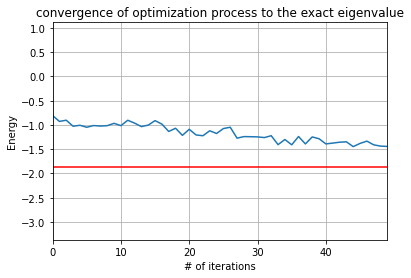

In [276]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [277]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

3it [00:00, 11.62it/s]

{'1011': 27, '0010': 23, '1000': 69, '1101': 244, '1100': 55, '0011': 50, '1001': 73, '1111': 85, '0101': 43, '1110': 101, '0111': 94, '0000': 34, '0001': 37, '0100': 67, '0110': 8, '1010': 14}
1.0
{'0000': 36, '1001': 67, '1011': 29, '0010': 26, '0011': 46, '1101': 233, '0111': 81, '1110': 96, '0110': 21, '0100': 85, '0101': 56, '1000': 66, '1111': 78, '1010': 14, '0001': 31, '1100': 59}
1.0
{'1110': 96, '0111': 83, '1000': 67, '1111': 126, '0110': 14, '1001': 63, '1101': 229, '0011': 51, '1100': 54, '0100': 61, '0001': 45, '1011': 29, '0000': 37, '0101': 39, '0010': 16, '1010': 14}
1.0
{'0100': 63, '1101': 240, '0011': 50, '1110': 90, '0101': 53, '0000': 51, '0111': 83, '1011': 41, '1001': 62, '1111': 90, '1000': 55, '0001': 34, '1010': 19, '0010': 27, '1100': 55, '0110': 11}
1.0


7it [00:00, 15.75it/s]

{'1101': 252, '1110': 97, '0101': 33, '0001': 42, '1010': 23, '0011': 48, '1100': 61, '0000': 46, '1111': 87, '1001': 62, '0111': 83, '0010': 21, '0100': 64, '0110': 22, '1011': 31, '1000': 52}
1.0
{'1010': 16, '1001': 86, '1110': 95, '0011': 48, '1111': 92, '1101': 231, '0010': 20, '0111': 68, '1000': 65, '1100': 59, '0001': 45, '0101': 45, '1011': 33, '0100': 63, '0000': 42, '0110': 16}
1.0
{'0111': 88, '1111': 105, '1110': 97, '0101': 39, '1100': 62, '0011': 53, '0000': 47, '1101': 208, '1000': 69, '1001': 71, '0001': 38, '1011': 36, '0100': 64, '0110': 19, '0010': 17, '1010': 11}
1.0
{'0100': 69, '1101': 225, '1110': 100, '0101': 50, '0001': 38, '1100': 62, '1111': 97, '0000': 27, '0111': 94, '0110': 19, '1001': 71, '0011': 50, '1011': 22, '1000': 70, '1010': 11, '0010': 19}
1.0


11it [00:00, 13.02it/s]

{'0111': 80, '0010': 88, '0011': 16, '1111': 251, '0110': 49, '0100': 91, '1101': 109, '1001': 94, '0001': 20, '1000': 18, '1110': 16, '1100': 100, '1010': 48, '0000': 14, '1011': 24, '0101': 6}
1.0
{'0001': 185, '1001': 167, '0000': 26, '1000': 177, '1011': 180, '1101': 25, '1110': 34, '0110': 32, '0111': 50, '0010': 83, '0011': 19, '1111': 15, '0100': 11, '1100': 13, '1010': 2, '0101': 5}
1.0
{'0100': 58, '1001': 177, '1010': 150, '0001': 91, '1011': 220, '0000': 145, '0110': 35, '1111': 80, '0011': 43, '0010': 4, '1000': 2, '0101': 3, '1110': 6, '0111': 4, '1100': 6}
1.0


15it [00:01, 13.71it/s]


{'1110': 94, '1101': 222, '1011': 30, '1001': 64, '0111': 72, '0000': 47, '0011': 48, '1111': 100, '0100': 81, '0001': 39, '1000': 73, '1100': 57, '0101': 47, '1010': 14, '0110': 19, '0010': 17}
1.0
{'0011': 51, '1100': 71, '1111': 92, '0111': 98, '0000': 39, '1000': 84, '1110': 106, '0100': 60, '1101': 204, '0001': 36, '0110': 13, '0101': 49, '1001': 67, '0010': 21, '1011': 23, '1010': 10}
1.0
{'1111': 103, '1011': 31, '1101': 210, '1000': 77, '0101': 48, '1110': 86, '0001': 35, '0011': 54, '0100': 83, '0000': 43, '1100': 64, '1001': 66, '0111': 80, '0010': 20, '0110': 13, '1010': 11}
1.0
{'1111': 106, '1000': 58, '0000': 41, '0100': 69, '1101': 223, '1110': 92, '0011': 62, '0111': 66, '1100': 69, '1001': 62, '0010': 17, '0101': 47, '0110': 23, '0001': 43, '1010': 17, '1011': 29}
1.0


4it [00:00, 16.57it/s]

{'1110': 215, '0011': 25, '1100': 63, '1101': 117, '0100': 121, '1011': 93, '1001': 114, '0000': 56, '0111': 68, '0101': 34, '0001': 49, '1111': 57, '0110': 4, '0010': 4, '1010': 4}
1.0
{'1001': 119, '0001': 60, '1110': 235, '1011': 93, '0100': 111, '1101': 105, '0111': 52, '0011': 19, '1100': 66, '1111': 61, '0000': 44, '1010': 8, '0101': 41, '0010': 5, '0110': 4, '1000': 1}
1.0
{'0101': 40, '1110': 224, '0111': 62, '1011': 107, '1100': 63, '0100': 95, '1001': 111, '0001': 74, '1111': 59, '1101': 116, '0110': 9, '0000': 29, '0011': 27, '1010': 5, '1000': 2, '0010': 1}
1.0
{'0000': 54, '1001': 106, '1111': 77, '0111': 70, '1011': 110, '1101': 100, '0100': 105, '1110': 211, '1010': 5, '0011': 26, '0101': 37, '1100': 43, '0001': 67, '0110': 9, '0010': 2, '1000': 2}
1.0


6it [00:00, 11.27it/s]

{'0100': 100, '1101': 110, '1110': 240, '0000': 47, '1001': 117, '1100': 61, '0011': 23, '1011': 88, '0111': 61, '0001': 71, '1111': 59, '0010': 2, '0101': 34, '1010': 8, '1000': 2, '0110': 1}
1.0
{'0111': 68, '1111': 54, '1011': 91, '0001': 54, '1001': 134, '0101': 38, '1110': 215, '1101': 109, '0100': 95, '1100': 67, '0110': 8, '0000': 49, '0011': 32, '1010': 6, '1000': 2, '0010': 2}
1.0


10it [00:00, 13.98it/s]

{'1101': 96, '0100': 105, '1011': 101, '1001': 108, '1111': 68, '0000': 49, '0111': 71, '1110': 222, '0011': 29, '0101': 39, '0110': 9, '1100': 55, '0001': 65, '1000': 2, '1010': 3, '0010': 2}
1.0
{'1001': 120, '1110': 218, '0101': 42, '1100': 65, '0100': 119, '1011': 82, '0000': 41, '1111': 64, '0001': 55, '0011': 29, '1101': 111, '0010': 3, '0111': 64, '0110': 6, '1010': 4, '1000': 1}
1.0
{'1110': 20, '0111': 72, '1111': 252, '0010': 73, '0000': 14, '1000': 50, '1001': 33, '1101': 116, '1100': 56, '0011': 36, '1010': 55, '0101': 8, '0100': 114, '0110': 25, '1011': 88, '0001': 12}
1.0
{'1000': 110, '1010': 58, '1001': 170, '0001': 153, '1100': 28, '0011': 47, '1011': 180, '1111': 41, '0111': 26, '0010': 68, '0110': 74, '1101': 5, '0000': 24, '0100': 13, '1110': 27}
1.0


14it [00:00, 15.68it/s]

{'0011': 30, '0010': 19, '1011': 388, '0000': 139, '1001': 83, '0001': 91, '0111': 4, '0110': 45, '1010': 77, '1100': 18, '1111': 51, '0100': 49, '1110': 12, '0101': 9, '1101': 6, '1000': 3}
1.0
{'0100': 114, '1101': 110, '0101': 38, '1110': 203, '1111': 69, '0000': 54, '1011': 88, '1100': 58, '0111': 61, '0001': 70, '1001': 117, '0011': 28, '1010': 3, '0110': 6, '0010': 5}
1.0
{'1110': 216, '0101': 45, '1011': 97, '0001': 80, '1001': 120, '1100': 60, '0011': 18, '0111': 68, '0100': 106, '1111': 64, '1101': 85, '0000': 48, '1010': 5, '1000': 1, '0010': 5, '0110': 6}
1.0
{'1110': 238, '1011': 86, '0001': 69, '1001': 107, '1100': 67, '1111': 71, '1101': 107, '0000': 32, '0111': 59, '0101': 32, '0100': 111, '0011': 32, '0110': 5, '1000': 2, '0010': 3, '1010': 3}
1.0


15it [00:01, 13.49it/s]


{'1110': 235, '0111': 70, '1011': 98, '1001': 133, '0100': 83, '0011': 37, '1100': 47, '1111': 61, '1101': 99, '0001': 81, '0000': 33, '0101': 29, '0110': 5, '1010': 9, '0010': 3, '1000': 1}
1.0


2it [00:00, 13.85it/s]

{'0100': 101, '1101': 176, '1110': 111, '0111': 182, '0110': 73, '1111': 46, '1000': 58, '1001': 88, '0101': 86, '0010': 16, '1010': 15, '1011': 8, '0000': 25, '0011': 29, '0001': 5, '1100': 5}
1.0
{'0100': 89, '1101': 179, '0101': 102, '1110': 123, '0111': 182, '1001': 75, '1000': 62, '0010': 21, '0000': 20, '1111': 40, '0110': 71, '1011': 7, '1010': 12, '0011': 29, '0001': 4, '1100': 8}
1.0


4it [00:00, 15.81it/s]

{'1110': 122, '0101': 74, '0100': 113, '1101': 162, '1001': 72, '0000': 29, '0111': 183, '0110': 99, '0011': 31, '1000': 56, '1111': 26, '1010': 14, '0010': 29, '1011': 5, '1100': 5, '0001': 4}
1.0
{'0111': 192, '0100': 108, '1101': 159, '0101': 107, '1110': 108, '1111': 34, '0110': 79, '1001': 79, '1000': 53, '0011': 32, '0001': 9, '0010': 25, '0000': 24, '1011': 2, '1010': 9, '1100': 4}
1.0


6it [00:00, 17.17it/s]

{'0111': 162, '1001': 83, '0100': 109, '1101': 165, '0110': 95, '1000': 65, '0010': 35, '0101': 85, '0000': 19, '1111': 52, '1010': 13, '1011': 7, '1110': 97, '0011': 25, '0001': 5, '1100': 7}
1.0
{'0111': 182, '0010': 34, '0101': 108, '1110': 103, '0011': 28, '0100': 80, '1101': 166, '0110': 95, '1111': 42, '1000': 58, '1001': 68, '0000': 30, '1011': 6, '1010': 11, '0001': 5, '1100': 8}
1.0


8it [00:00, 17.59it/s]

{'1001': 75, '1110': 117, '0101': 96, '1000': 60, '0111': 207, '0100': 86, '1101': 159, '0011': 29, '0010': 29, '1111': 40, '0110': 81, '1010': 9, '0000': 19, '1011': 7, '0001': 5, '1100': 5}
1.0
{'0011': 34, '1111': 45, '0110': 81, '1000': 62, '1110': 101, '0100': 110, '1101': 178, '0111': 194, '0000': 20, '0101': 88, '1100': 6, '1001': 66, '1010': 11, '0010': 23, '0001': 2, '1011': 3}
1.0
{'0110': 100, '1111': 78, '1001': 81, '1010': 33, '1101': 70, '0100': 299, '0111': 52, '1100': 166, '1011': 9, '0001': 45, '0010': 25, '1000': 26, '0101': 27, '0000': 10, '0011': 2, '1110': 1}
1.0


10it [00:00, 13.31it/s]

{'1001': 148, '0001': 183, '1101': 19, '0111': 107, '1000': 82, '0000': 53, '0011': 79, '0110': 69, '0010': 133, '1011': 44, '1111': 34, '1100': 20, '0100': 11, '1010': 15, '1110': 11, '0101': 16}
1.0


12it [00:00, 13.02it/s]

{'0001': 65, '1001': 120, '1011': 70, '0110': 53, '1111': 58, '0000': 341, '0101': 14, '0100': 147, '1010': 80, '1101': 16, '1100': 8, '1000': 12, '0111': 2, '0011': 14, '0010': 24}
1.0
{'0101': 93, '1110': 116, '0110': 80, '1000': 60, '1101': 170, '0100': 93, '0011': 25, '0111': 220, '1100': 8, '0010': 33, '1111': 36, '0001': 5, '1001': 54, '1010': 9, '1011': 10, '0000': 12}
1.0


14it [00:00, 14.16it/s]

{'1110': 110, '0010': 25, '1011': 8, '0100': 107, '1101': 174, '0110': 85, '0000': 17, '1001': 80, '0101': 80, '1100': 5, '0111': 182, '1111': 35, '0011': 32, '1000': 61, '0001': 4, '1010': 19}
1.0
{'1001': 74, '0110': 95, '0100': 97, '1101': 166, '0000': 12, '1000': 50, '0011': 26, '0111': 203, '0010': 22, '0101': 84, '1100': 8, '1110': 122, '1011': 8, '1010': 10, '0001': 4, '1111': 43}
1.0


15it [00:01, 14.71it/s]


{'0111': 183, '1001': 66, '0010': 23, '0100': 100, '1101': 168, '1000': 62, '0110': 79, '1110': 121, '0000': 13, '1111': 33, '0101': 105, '0011': 29, '1011': 11, '1010': 17, '0001': 8, '1100': 6}
1.0


0it [00:00, ?it/s]

{'0011': 231, '1111': 49, '0000': 70, '0111': 151, '1101': 151, '1110': 137, '0101': 69, '0010': 8, '0100': 59, '0110': 33, '1000': 31, '1011': 2, '1001': 29, '1100': 3, '0001': 1}
1.0


2it [00:00, 19.51it/s]

{'1100': 16, '0011': 224, '0000': 57, '0100': 52, '1101': 148, '0101': 52, '1110': 130, '0111': 178, '0110': 41, '1001': 38, '1000': 26, '0010': 17, '1111': 43, '1010': 1, '1011': 1}
1.0
{'1100': 9, '0011': 223, '0100': 41, '1101': 152, '0000': 67, '0110': 46, '0111': 165, '1110': 129, '0101': 66, '1111': 41, '1001': 33, '1000': 28, '0001': 2, '0010': 19, '1010': 3}
1.0


4it [00:00, 14.24it/s]

{'0101': 64, '1110': 130, '1000': 34, '0000': 56, '1101': 174, '0111': 146, '1111': 54, '0011': 218, '0100': 57, '1100': 9, '0110': 33, '0010': 17, '1001': 27, '1010': 3, '0001': 2}
1.0


6it [00:00, 13.04it/s]

{'1101': 159, '0101': 65, '1110': 124, '0011': 237, '1111': 36, '0111': 154, '0000': 66, '1001': 39, '0110': 46, '0100': 47, '0010': 19, '1000': 22, '1100': 9, '1010': 1}
1.0
{'0011': 213, '1101': 155, '0100': 43, '0101': 84, '1110': 124, '1111': 48, '0111': 155, '1001': 39, '0110': 44, '0010': 16, '0000': 60, '1000': 35, '1100': 7, '1010': 1}
1.0
{'0100': 58, '1101': 161, '0101': 63, '1110': 141, '0011': 208, '1000': 34, '0000': 67, '0111': 147, '0110': 39, '1111': 42, '0010': 16, '1001': 37, '1010': 2, '1100': 7, '0001': 2}
1.0


10it [00:00, 14.58it/s]

{'0100': 45, '1101': 175, '0101': 64, '1110': 119, '1111': 43, '0110': 45, '0011': 219, '0010': 29, '0111': 152, '1000': 29, '1100': 8, '0000': 59, '1001': 34, '1011': 1, '0001': 1, '1010': 1}
1.0
{'0111': 69, '1101': 55, '0001': 181, '1100': 247, '0011': 27, '0000': 8, '1111': 59, '0010': 79, '1110': 10, '0100': 127, '1010': 17, '0110': 104, '1000': 20, '0101': 10, '1011': 3, '1001': 8}
1.0
{'0001': 76, '1001': 99, '0011': 42, '1000': 65, '0010': 90, '0111': 237, '0110': 83, '1110': 19, '1011': 61, '0000': 82, '0101': 72, '1111': 81, '1101': 9, '1100': 4, '1010': 4}
1.0
{'0000': 222, '0101': 100, '0010': 43, '1010': 37, '1001': 139, '1111': 70, '0100': 150, '0011': 28, '1011': 38, '0110': 120, '1101': 26, '1110': 11, '0001': 19, '0111': 12, '1000': 9}
1.0


14it [00:00, 16.30it/s]

{'1101': 159, '0100': 59, '0111': 148, '0000': 57, '1111': 56, '0110': 41, '0011': 216, '1110': 127, '0101': 66, '0010': 14, '1001': 48, '1000': 22, '0001': 3, '1100': 7, '1011': 1}
1.0
{'0000': 75, '0110': 44, '1111': 44, '0101': 57, '1110': 121, '0111': 156, '0100': 55, '0011': 238, '1101': 146, '1000': 38, '1001': 31, '1010': 1, '0010': 12, '1011': 1, '1100': 4, '0001': 1}
1.0
{'1110': 136, '0111': 155, '0010': 14, '0011': 230, '0100': 47, '1101': 173, '1000': 27, '0000': 55, '1001': 34, '0110': 36, '0101': 62, '1111': 39, '1100': 8, '1010': 4, '0001': 3, '1011': 1}
1.0


15it [00:00, 15.12it/s]

{'0000': 75, '1000': 29, '0011': 226, '1100': 4, '0100': 53, '1101': 150, '1111': 52, '1110': 127, '1001': 29, '0111': 143, '0110': 50, '0001': 3, '0101': 67, '0010': 14, '1011': 2}
1.0



1it [00:00,  8.64it/s]

{'0111': 332, '1001': 99, '0110': 86, '0010': 77, '1101': 40, '1000': 37, '0000': 10, '0011': 21, '0100': 91, '0001': 7, '0101': 65, '1111': 55, '1110': 60, '1010': 13, '1011': 10, '1100': 21}
1.0
{'0101': 45, '1001': 99, '0100': 107, '0010': 60, '0111': 311, '1111': 76, '0110': 81, '1000': 46, '1110': 74, '1011': 15, '1101': 47, '0001': 2, '0011': 24, '1100': 13, '0000': 16, '1010': 8}
1.0


3it [00:00, 12.52it/s]

{'0101': 67, '0111': 295, '1100': 19, '1001': 109, '0010': 63, '0110': 105, '1101': 41, '1000': 39, '0001': 6, '0011': 23, '0000': 13, '0100': 83, '1110': 74, '1111': 58, '1010': 13, '1011': 16}
1.0
{'0011': 22, '0111': 305, '0101': 62, '0100': 76, '0001': 10, '1001': 97, '0110': 97, '0010': 62, '1111': 67, '1101': 28, '1110': 68, '1100': 19, '1000': 52, '1011': 23, '0000': 19, '1010': 17}
1.0


5it [00:00, 14.94it/s]

{'1001': 96, '1110': 92, '0100': 94, '1101': 42, '0111': 302, '0110': 84, '0000': 16, '0010': 60, '1000': 43, '0011': 35, '0101': 51, '1111': 57, '1100': 18, '1011': 19, '0001': 5, '1010': 10}
1.0
{'1110': 63, '0101': 38, '0010': 59, '0100': 102, '1101': 40, '0111': 324, '1001': 97, '0011': 33, '0110': 94, '1100': 16, '1111': 65, '1011': 16, '1000': 45, '0001': 4, '0000': 15, '1010': 13}
1.0


7it [00:00, 16.19it/s]

{'1110': 79, '0111': 298, '1001': 93, '0110': 95, '1111': 59, '1101': 32, '0100': 106, '0010': 81, '1100': 13, '1000': 41, '0000': 15, '1010': 10, '0101': 46, '0011': 26, '1011': 21, '0001': 9}
1.0
{'0111': 293, '1110': 73, '0101': 61, '0011': 35, '1001': 98, '0110': 82, '1101': 37, '0100': 95, '1000': 40, '0010': 70, '1111': 74, '1010': 11, '1100': 19, '0000': 18, '1011': 9, '0001': 9}
1.0


9it [00:00, 16.92it/s]

{'0001': 104, '1001': 108, '1010': 42, '0100': 297, '1111': 54, '0110': 130, '1100': 84, '1000': 22, '0011': 21, '1101': 28, '1011': 18, '0111': 71, '1110': 25, '0101': 17, '0000': 3}
1.0


11it [00:00, 13.38it/s]

{'0001': 78, '0110': 32, '1111': 111, '0011': 102, '1100': 19, '1011': 48, '1101': 26, '0111': 139, '0010': 123, '0101': 25, '1000': 94, '1001': 79, '1010': 31, '1110': 53, '0100': 49, '0000': 15}
1.0
{'0000': 249, '0010': 19, '0110': 111, '1111': 75, '0001': 53, '1101': 70, '0100': 113, '1100': 51, '1011': 52, '1001': 98, '1010': 71, '1000': 20, '0111': 20, '1110': 7, '0011': 6, '0101': 9}
1.0
{'1111': 66, '0100': 99, '0111': 320, '1000': 51, '1110': 72, '0101': 34, '1001': 95, '1011': 17, '1010': 13, '0110': 95, '1101': 30, '0011': 34, '0010': 71, '0000': 9, '1100': 10, '0001': 8}
1.0


15it [00:01, 14.85it/s]


{'1001': 112, '0110': 102, '0111': 321, '1000': 47, '0000': 14, '0101': 51, '1110': 70, '0100': 74, '0010': 67, '1011': 19, '1111': 50, '1010': 9, '0011': 34, '1101': 33, '1100': 10, '0001': 11}
1.0
{'1001': 106, '0010': 62, '0111': 297, '1111': 72, '0110': 97, '0100': 95, '1110': 77, '1000': 36, '0101': 43, '0011': 41, '1010': 12, '1101': 35, '1011': 15, '1100': 14, '0000': 12, '0001': 10}
1.0
{'1001': 118, '0111': 326, '0110': 85, '0101': 44, '0011': 32, '0100': 90, '1000': 40, '0010': 69, '1101': 24, '0001': 11, '1110': 64, '0000': 9, '1111': 64, '1100': 21, '1011': 21, '1010': 6}
1.0


0it [00:00, ?it/s]

{'1101': 161, '0100': 114, '1110': 133, '0111': 210, '0000': 14, '1000': 57, '1001': 69, '0110': 68, '1111': 31, '1010': 25, '0011': 33, '1011': 14, '1100': 4, '0101': 69, '0001': 7, '0010': 15}
1.0


4it [00:00, 16.41it/s]

{'1001': 54, '1101': 166, '0100': 103, '1111': 43, '0110': 65, '0111': 204, '1110': 105, '0010': 33, '0000': 19, '1010': 24, '1000': 46, '1011': 22, '0101': 88, '0001': 11, '0011': 29, '1100': 12}
1.0
{'0111': 182, '1110': 107, '0101': 87, '1011': 22, '0110': 72, '0011': 35, '1000': 58, '1001': 55, '0100': 119, '1010': 29, '0010': 28, '1101': 163, '1100': 7, '1111': 31, '0000': 18, '0001': 11}
1.0
{'0111': 192, '0101': 93, '1110': 99, '0100': 118, '1101': 158, '1001': 71, '1010': 20, '0110': 72, '1000': 54, '1111': 42, '1011': 14, '0011': 29, '0010': 25, '0001': 11, '0000': 14, '1100': 12}
1.0
{'1110': 121, '1101': 151, '0100': 104, '0010': 24, '0111': 205, '1001': 55, '1100': 12, '1000': 54, '0001': 13, '0101': 83, '0011': 38, '0110': 76, '1111': 33, '0000': 18, '1010': 13, '1011': 24}
1.0


6it [00:00, 16.10it/s]

{'0101': 84, '1110': 126, '1011': 15, '0010': 25, '1101': 176, '0100': 96, '0110': 65, '0111': 193, '1001': 60, '1111': 46, '0011': 31, '1000': 59, '1100': 8, '0000': 14, '1010': 20, '0001': 6}
1.0
{'1110': 111, '1000': 56, '0110': 69, '1111': 44, '1101': 140, '0100': 135, '0111': 202, '1001': 68, '1011': 22, '0011': 32, '0101': 71, '0000': 13, '1100': 14, '0001': 11, '0010': 21, '1010': 15}
1.0
{'0111': 216, '1110': 99, '0101': 82, '1111': 37, '1001': 61, '1000': 58, '1011': 18, '1101': 160, '0011': 30, '0010': 22, '0110': 69, '0100': 117, '1010': 28, '0001': 9, '0000': 11, '1100': 7}
1.0


8it [00:00, 14.97it/s]

{'1101': 80, '0100': 300, '0011': 19, '1100': 160, '0111': 76, '0110': 67, '1000': 58, '0101': 19, '1111': 75, '1010': 39, '1001': 69, '0001': 34, '0000': 9, '0010': 16, '1110': 3}
1.0


12it [00:00, 15.18it/s]

{'0011': 89, '0001': 168, '1010': 34, '1001': 101, '0000': 90, '1000': 86, '0010': 127, '0110': 64, '1110': 16, '1111': 41, '0101': 30, '0111': 95, '1011': 46, '1100': 31, '0100': 5, '1101': 1}
1.0
{'0001': 76, '1001': 114, '1100': 15, '0000': 374, '0010': 29, '1011': 78, '1111': 65, '0110': 48, '0100': 107, '0101': 25, '1101': 10, '1010': 57, '1000': 13, '0111': 2, '1110': 4, '0011': 7}
1.0
{'0110': 74, '1001': 65, '1101': 163, '0100': 113, '1110': 105, '0101': 72, '0111': 208, '0011': 28, '1111': 44, '1100': 14, '0010': 22, '1010': 35, '0000': 17, '1000': 42, '1011': 14, '0001': 8}
1.0
{'1110': 94, '0101': 82, '0100': 108, '1101': 175, '1011': 18, '1100': 12, '1010': 25, '1001': 67, '0111': 208, '1000': 41, '1111': 49, '0110': 65, '0011': 34, '0010': 19, '0001': 12, '0000': 15}
1.0


15it [00:00, 15.72it/s]


{'0110': 66, '1111': 41, '1001': 57, '1010': 26, '0100': 119, '1101': 172, '0111': 198, '1110': 104, '1000': 61, '0101': 71, '0011': 33, '0010': 22, '0000': 24, '0001': 10, '1011': 13, '1100': 7}
1.0
{'0111': 212, '0100': 103, '1101': 180, '0001': 14, '1001': 50, '1110': 101, '0110': 64, '1000': 53, '1111': 32, '0011': 38, '1010': 29, '1011': 24, '0101': 62, '0000': 20, '0010': 28, '1100': 14}
1.0


0it [00:00, ?it/s]

{'0010': 41, '0101': 35, '1000': 80, '0100': 107, '1101': 137, '0111': 285, '0001': 22, '1100': 63, '1110': 74, '0110': 74, '0011': 22, '0000': 16, '1001': 60, '1010': 4, '1111': 4}
1.0


2it [00:00, 18.29it/s]

{'0011': 27, '1100': 62, '1110': 76, '0111': 244, '0100': 111, '1101': 146, '1001': 76, '1000': 60, '0010': 48, '0001': 24, '0000': 16, '0110': 67, '0101': 50, '1111': 4, '1010': 12, '1011': 1}
1.0


4it [00:00, 18.29it/s]

{'1010': 12, '0001': 26, '0111': 237, '1000': 67, '0000': 17, '0101': 44, '0010': 47, '0100': 117, '1101': 152, '1100': 58, '0011': 23, '0110': 66, '1001': 83, '1110': 68, '1111': 4, '1011': 3}
1.0
{'1110': 73, '1101': 151, '0100': 112, '0111': 260, '1001': 76, '1100': 48, '0010': 40, '0110': 73, '1000': 73, '0101': 45, '0011': 17, '0001': 25, '0000': 21, '1011': 2, '1010': 7, '1111': 1}
1.0
{'0011': 29, '0101': 49, '1110': 77, '0010': 38, '0110': 59, '1010': 12, '1001': 66, '1101': 161, '0100': 108, '1100': 50, '0111': 262, '1000': 80, '1011': 1, '0000': 11, '0001': 19, '1111': 2}
1.0


6it [00:00, 14.84it/s]

{'0110': 72, '0001': 23, '0111': 223, '1101': 141, '0101': 47, '1110': 61, '1100': 73, '0010': 51, '0000': 25, '1000': 76, '1001': 75, '0100': 123, '0011': 20, '1010': 11, '1011': 1, '1111': 2}
1.0


8it [00:00, 12.67it/s]

{'0110': 66, '1001': 65, '1101': 149, '1000': 78, '0101': 50, '1110': 78, '0111': 247, '1100': 63, '0100': 118, '0010': 41, '0011': 19, '0000': 15, '0001': 23, '1010': 5, '1111': 6, '1011': 1}
1.0
{'1001': 79, '0111': 259, '1110': 76, '0100': 120, '1101': 144, '1100': 58, '0010': 35, '0110': 62, '0000': 17, '1010': 9, '0011': 25, '1000': 67, '0101': 42, '0001': 27, '1111': 4}
1.0


10it [00:00, 14.25it/s]

{'0111': 70, '0100': 352, '1100': 102, '0001': 55, '1001': 47, '1010': 66, '0110': 74, '1000': 30, '1101': 60, '1111': 91, '0010': 40, '0101': 9, '0011': 4, '0000': 6, '1011': 4, '1110': 14}
1.0
{'0010': 114, '1001': 85, '0001': 156, '1000': 87, '0000': 122, '1111': 75, '0110': 41, '0100': 10, '1010': 28, '0111': 55, '0011': 81, '1110': 18, '0101': 35, '1011': 72, '1101': 9, '1100': 36}
1.0


12it [00:00, 15.40it/s]

{'0000': 353, '0100': 96, '0101': 24, '1111': 61, '1001': 50, '1010': 130, '0011': 35, '1100': 49, '1101': 18, '1011': 71, '0010': 42, '0001': 59, '0110': 14, '1000': 20, '1110': 2}
1.0
{'1110': 75, '0101': 44, '0111': 247, '1100': 58, '1000': 63, '0110': 63, '0100': 123, '1101': 153, '0010': 42, '0001': 28, '0011': 33, '1001': 56, '1010': 11, '1011': 5, '0000': 19, '1111': 4}
1.0


15it [00:00, 15.60it/s]

{'1001': 71, '1100': 61, '0111': 259, '1101': 159, '0100': 107, '0110': 73, '1110': 74, '1000': 65, '0010': 44, '0011': 16, '0101': 48, '0001': 22, '1010': 8, '0000': 14, '1011': 1, '1111': 2}
1.0
{'1001': 63, '1010': 16, '1101': 149, '0100': 116, '0101': 61, '0111': 266, '0010': 42, '1000': 61, '1100': 59, '0110': 62, '1110': 64, '0001': 22, '0011': 19, '1111': 4, '0000': 19, '1011': 1}
1.0
{'1100': 52, '0111': 268, '0000': 16, '1000': 68, '0101': 56, '0100': 115, '0010': 36, '0001': 27, '0110': 62, '1110': 74, '1001': 76, '1111': 2, '1101': 137, '0011': 21, '1010': 11, '1011': 3}
1.0



2it [00:00,  9.62it/s]

{'0111': 263, '0100': 110, '1101': 67, '0101': 33, '1110': 64, '1100': 26, '0011': 145, '0110': 74, '1010': 15, '1001': 83, '0000': 67, '1000': 32, '0010': 16, '0001': 25, '1011': 2, '1111': 2}
1.0
{'0100': 120, '1100': 26, '0011': 139, '0110': 71, '0001': 23, '1000': 25, '0000': 64, '0111': 253, '1001': 87, '1110': 62, '1101': 87, '0010': 14, '1010': 15, '1011': 5, '0101': 31, '1111': 2}
1.0


4it [00:00, 11.43it/s]

{'0001': 29, '1001': 102, '0011': 151, '0000': 57, '0100': 109, '0110': 67, '0111': 234, '1110': 51, '0101': 27, '1101': 97, '0010': 28, '1011': 6, '1000': 33, '1100': 17, '1010': 15, '1111': 1}
1.0
{'0110': 83, '0111': 232, '1101': 93, '0100': 90, '1100': 36, '0011': 161, '1011': 9, '1001': 91, '0000': 44, '0010': 29, '0001': 32, '1000': 24, '1110': 58, '0101': 24, '1010': 16, '1111': 2}
1.0
{'1001': 99, '0111': 269, '1101': 74, '0100': 104, '0110': 55, '0011': 140, '0010': 20, '0101': 39, '0000': 59, '1000': 31, '1110': 47, '0001': 24, '1100': 38, '1010': 14, '1011': 10, '1111': 1}
1.0


8it [00:00, 14.38it/s]

{'0011': 140, '0110': 88, '0000': 70, '0001': 29, '1001': 98, '1101': 79, '0100': 76, '1110': 57, '0111': 243, '0101': 33, '1100': 33, '1000': 30, '1010': 15, '0010': 28, '1011': 4, '1111': 1}
1.0
{'0000': 51, '0101': 28, '1110': 43, '0001': 35, '0111': 279, '0011': 144, '0100': 111, '1111': 6, '1101': 82, '1001': 83, '1100': 31, '0110': 57, '0010': 26, '1010': 21, '1000': 25, '1011': 2}
1.0
{'0011': 135, '0010': 27, '0110': 71, '0111': 271, '0100': 116, '1101': 69, '0101': 32, '0001': 24, '0000': 59, '1000': 25, '1110': 58, '1001': 80, '1100': 32, '1010': 20, '1011': 4, '1111': 1}
1.0
{'1101': 50, '0100': 318, '0111': 78, '0110': 42, '1111': 40, '1100': 79, '1000': 45, '1010': 56, '0001': 119, '0010': 119, '1001': 38, '0101': 14, '0011': 14, '1011': 7, '1110': 3, '0000': 2}
1.0


12it [00:00, 12.42it/s]

{'0110': 51, '1111': 77, '0000': 76, '1000': 67, '0001': 100, '1001': 64, '1011': 111, '0111': 73, '0010': 72, '0011': 159, '1100': 44, '0100': 34, '1010': 17, '1101': 40, '1110': 17, '0101': 22}
1.0
{'0100': 92, '0001': 6, '1010': 117, '1100': 56, '0011': 30, '0010': 69, '0101': 98, '0000': 286, '1101': 61, '1001': 78, '1011': 49, '1111': 38, '0110': 7, '1000': 16, '1110': 18, '0111': 3}
1.0
{'0111': 265, '1101': 94, '0100': 92, '0110': 62, '0011': 142, '1001': 94, '1110': 51, '0101': 28, '0001': 25, '0000': 57, '1010': 16, '1000': 26, '0010': 34, '1011': 4, '1100': 33, '1111': 1}
1.0


15it [00:01, 12.95it/s]


{'0011': 146, '0111': 243, '1101': 73, '0100': 117, '0101': 38, '0000': 55, '1001': 86, '0110': 77, '0010': 33, '1100': 34, '0001': 20, '1010': 17, '1110': 51, '1000': 27, '1011': 5, '1111': 2}
1.0
{'1000': 30, '0011': 144, '0111': 250, '0100': 124, '1101': 82, '1010': 16, '0110': 71, '1110': 45, '1001': 83, '1100': 36, '0001': 22, '0101': 27, '0000': 65, '0010': 24, '1011': 3, '1111': 2}
1.0
{'1010': 21, '0001': 21, '1001': 86, '1100': 28, '0111': 249, '0110': 67, '1110': 49, '1101': 81, '0011': 154, '0100': 123, '1000': 40, '0101': 29, '0000': 51, '0010': 24, '1011': 1}
1.0


0it [00:00, ?it/s]

{'0100': 104, '1101': 183, '0000': 34, '0111': 184, '1110': 148, '1010': 21, '1001': 98, '1011': 24, '0110': 38, '1000': 10, '0001': 25, '1100': 22, '0011': 86, '1111': 20, '0010': 25, '0101': 2}
1.0


4it [00:00, 17.27it/s]

{'1110': 134, '1101': 183, '0110': 37, '1111': 31, '0111': 184, '1001': 92, '0010': 31, '0000': 40, '0011': 89, '0100': 95, '1000': 11, '1100': 23, '1011': 19, '1010': 21, '0001': 30, '0101': 4}
1.0
{'0111': 209, '1001': 102, '0011': 89, '0100': 94, '1101': 180, '1111': 36, '1110': 112, '1000': 15, '0110': 35, '0000': 41, '0001': 23, '1100': 22, '1010': 18, '0010': 23, '1011': 22, '0101': 3}
1.0
{'0110': 50, '1111': 20, '0111': 191, '1100': 28, '0011': 96, '1011': 25, '0100': 95, '1101': 174, '1001': 99, '1110': 131, '0010': 26, '1000': 11, '0101': 2, '0001': 28, '0000': 29, '1010': 19}
1.0
{'0111': 198, '1010': 17, '1001': 117, '0100': 77, '0110': 48, '0000': 51, '1110': 117, '0011': 85, '0001': 33, '1011': 29, '1101': 173, '1100': 21, '1000': 10, '1111': 24, '0010': 22, '0101': 2}
1.0


6it [00:00, 15.55it/s]

{'1011': 20, '0010': 32, '1101': 174, '1110': 123, '1010': 32, '0111': 203, '0011': 98, '0110': 43, '0001': 28, '1100': 17, '1001': 105, '1111': 24, '0100': 82, '0000': 29, '1000': 9, '0101': 5}
1.0
{'0010': 31, '0111': 185, '1111': 29, '1001': 99, '0001': 25, '1110': 136, '1101': 197, '0000': 32, '0011': 82, '0100': 91, '1010': 17, '0110': 40, '0101': 4, '1100': 26, '1011': 16, '1000': 14}
1.0


8it [00:00, 12.79it/s]

{'0111': 206, '0100': 86, '1101': 201, '1010': 22, '1001': 107, '1110': 126, '1011': 20, '0110': 29, '0011': 75, '0001': 26, '1000': 14, '1111': 27, '0010': 36, '1100': 19, '0000': 28, '0101': 2}
1.0


10it [00:00, 13.91it/s]

{'0100': 205, '1101': 108, '1110': 27, '0010': 133, '0111': 87, '0110': 48, '1100': 192, '1010': 54, '1000': 45, '1111': 41, '0000': 7, '0001': 13, '1001': 50, '0011': 6, '0101': 4, '1011': 4}
1.0
{'0000': 43, '1011': 79, '0010': 68, '0011': 208, '0111': 55, '1101': 77, '0110': 70, '0001': 76, '0101': 56, '1001': 108, '1110': 68, '0100': 43, '1111': 15, '1000': 28, '1100': 28, '1010': 2}
1.0
{'1100': 42, '0000': 287, '1001': 24, '1010': 118, '1101': 47, '0010': 59, '0111': 2, '0101': 123, '1111': 34, '0100': 114, '0001': 11, '1011': 71, '1110': 74, '0110': 9, '0011': 9}
1.0


12it [00:00, 15.12it/s]

{'0111': 182, '1000': 12, '1101': 178, '0001': 18, '1001': 109, '0011': 101, '0110': 32, '1011': 24, '0000': 37, '1110': 143, '0010': 29, '1111': 30, '0100': 87, '1100': 21, '1010': 20, '0101': 1}
1.0


15it [00:00, 15.02it/s]

{'1110': 103, '0100': 84, '1101': 210, '0111': 197, '1001': 97, '0000': 38, '0010': 39, '0110': 43, '1010': 22, '0011': 80, '1111': 36, '1000': 10, '1011': 17, '0001': 23, '1100': 21, '0101': 4}
1.0
{'0011': 80, '1101': 197, '1010': 20, '1001': 100, '0001': 35, '0111': 182, '1111': 24, '1110': 123, '1011': 21, '0100': 93, '1000': 12, '0110': 43, '0010': 33, '1100': 30, '0000': 28, '0101': 3}
1.0
{'1001': 100, '1110': 119, '0100': 104, '1101': 200, '0111': 193, '0000': 34, '0011': 88, '0010': 20, '1111': 22, '0101': 3, '1000': 16, '0110': 29, '0001': 28, '1010': 23, '1100': 27, '1011': 18}
1.0



2it [00:00,  9.22it/s]

{'0110': 19, '0111': 285, '0011': 131, '1001': 89, '0001': 85, '1101': 97, '0100': 49, '0000': 35, '0101': 97, '1100': 33, '1000': 61, '1110': 3, '1111': 14, '0010': 10, '1011': 13, '1010': 3}
1.0
{'1001': 77, '0001': 76, '0111': 307, '1101': 108, '0011': 105, '0101': 106, '1000': 70, '0010': 14, '0100': 43, '0000': 28, '1100': 40, '1111': 18, '0110': 18, '1110': 4, '1010': 3, '1011': 7}
1.0
{'0011': 135, '0100': 46, '1101': 94, '0101': 90, '0111': 332, '1001': 80, '1000': 47, '0000': 35, '0010': 6, '0001': 75, '0110': 33, '1011': 10, '1100': 24, '1111': 12, '1010': 5}
1.0


6it [00:00, 13.25it/s]

{'1001': 94, '0001': 76, '0011': 139, '1101': 98, '1111': 14, '0111': 298, '0101': 97, '1000': 49, '0100': 50, '0110': 25, '1100': 36, '1011': 12, '0000': 25, '1110': 4, '0010': 5, '1010': 2}
1.0
{'0100': 55, '1101': 95, '0111': 283, '0101': 92, '1001': 76, '0011': 133, '0000': 37, '1011': 11, '1000': 58, '1100': 34, '0001': 86, '0110': 30, '1110': 9, '0010': 8, '1111': 15, '1010': 2}
1.0
{'0001': 93, '0101': 87, '1101': 87, '0111': 308, '1000': 51, '0011': 119, '1100': 28, '0110': 31, '0100': 60, '1001': 87, '1010': 4, '0000': 26, '1111': 19, '1011': 10, '1110': 1, '0010': 13}
1.0
{'0100': 56, '1101': 110, '0110': 34, '1001': 76, '0001': 95, '0011': 116, '0101': 91, '0111': 264, '1000': 74, '0000': 34, '0010': 7, '1111': 22, '1100': 26, '1110': 3, '1010': 8, '1011': 8}
1.0


10it [00:00, 12.69it/s]

{'0001': 69, '1001': 84, '0101': 94, '0111': 304, '1101': 101, '1000': 58, '0011': 129, '0110': 25, '0100': 49, '0000': 31, '1111': 16, '1100': 37, '1010': 7, '1011': 12, '1110': 3, '0010': 5}
1.0
{'1000': 39, '0110': 57, '0010': 130, '0111': 110, '0100': 162, '0001': 39, '1010': 42, '0101': 120, '1101': 93, '1100': 69, '1110': 14, '1111': 8, '0011': 77, '1001': 24, '0000': 16, '1011': 24}
1.0
{'0001': 111, '1001': 166, '1011': 98, '0101': 62, '1111': 66, '0111': 118, '0011': 151, '1000': 39, '0000': 59, '0110': 31, '0100': 28, '1100': 43, '1101': 31, '1010': 7, '0010': 13, '1110': 1}
1.0


12it [00:01, 11.39it/s]

{'0001': 85, '1010': 195, '0101': 130, '1100': 61, '1101': 46, '0100': 81, '0010': 50, '1011': 93, '0000': 114, '0011': 114, '1110': 14, '1001': 23, '1111': 9, '0111': 4, '1000': 2, '0110': 3}
1.0
{'0111': 314, '0000': 32, '1000': 58, '0011': 123, '1010': 10, '0001': 73, '0100': 63, '0101': 93, '1100': 31, '1001': 83, '1101': 95, '0110': 21, '1011': 7, '1111': 14, '1110': 3, '0010': 4}
1.0
{'1001': 71, '0001': 70, '0111': 294, '1101': 115, '0100': 62, '0101': 80, '1000': 61, '1111': 21, '1100': 25, '0000': 35, '0011': 133, '0110': 23, '1010': 9, '1011': 12, '0010': 6, '1110': 7}
1.0
{'1101': 94, '1011': 10, '1110': 5, '0101': 97, '0000': 27, '1000': 63, '0111': 318, '1001': 80, '0001': 81, '1010': 5, '0010': 5, '0100': 46, '1100': 37, '0011': 119, '0110': 23, '1111': 14}
1.0


15it [00:01, 12.45it/s]


{'0011': 145, '0111': 286, '0101': 92, '1001': 78, '1010': 8, '0100': 63, '1101': 98, '1000': 52, '0001': 80, '0110': 27, '0000': 37, '1100': 27, '1011': 8, '0010': 10, '1111': 13}
1.0


2it [00:00, 14.18it/s]

{'0111': 375, '0001': 119, '1001': 129, '1000': 74, '0000': 60, '1101': 19, '0100': 21, '1111': 35, '0011': 35, '0101': 107, '1011': 17, '1010': 6, '0110': 22, '1110': 3, '1100': 1, '0010': 1}
1.0
{'0111': 380, '1011': 12, '1000': 75, '0000': 72, '1101': 21, '0100': 24, '0101': 103, '0001': 120, '1001': 118, '0011': 28, '1111': 36, '0110': 16, '1110': 5, '1010': 9, '0010': 4, '1100': 1}
1.0
{'1000': 54, '0101': 121, '0111': 384, '1111': 49, '0110': 21, '1001': 120, '0001': 113, '0100': 22, '1010': 9, '0000': 61, '1101': 14, '0011': 29, '1011': 16, '0010': 7, '1110': 4}
1.0


4it [00:00, 11.93it/s]

{'0111': 368, '0000': 62, '1000': 67, '1001': 140, '0101': 117, '0110': 25, '0011': 31, '0010': 2, '0001': 87, '1111': 45, '1011': 18, '0100': 28, '1010': 11, '1101': 18, '1110': 5}
1.0
{'0111': 368, '1111': 46, '0100': 23, '1101': 24, '0101': 105, '0001': 98, '1001': 126, '1000': 75, '0011': 44, '0000': 64, '0110': 26, '1011': 13, '1010': 9, '1110': 2, '1100': 1}
1.0
{'0111': 388, '1001': 115, '1010': 13, '0001': 106, '0101': 103, '0000': 65, '1111': 40, '1101': 16, '1000': 70, '0100': 32, '0110': 17, '0010': 6, '0011': 33, '1011': 17, '1110': 3}
1.0


6it [00:00, 10.58it/s]

{'0111': 381, '0101': 104, '1000': 74, '0000': 63, '0001': 90, '1001': 131, '1011': 17, '0100': 38, '0110': 16, '1111': 40, '0011': 36, '1010': 10, '1110': 4, '1100': 1, '1101': 14, '0010': 5}
1.0


10it [00:00, 13.18it/s]

{'1000': 60, '0000': 84, '0111': 354, '0101': 121, '1001': 116, '0001': 106, '1011': 23, '0100': 27, '0011': 30, '1010': 12, '0110': 26, '1111': 41, '1101': 19, '1110': 3, '0010': 2}
1.0
{'0111': 206, '0110': 152, '0001': 44, '1010': 108, '0101': 67, '0100': 114, '0000': 37, '1011': 76, '0011': 35, '1000': 24, '1101': 20, '1001': 27, '0010': 83, '1100': 18, '1111': 9, '1110': 4}
1.0
{'0111': 146, '1101': 75, '0011': 76, '1100': 88, '0001': 66, '1001': 200, '1011': 182, '1111': 50, '1000': 66, '0101': 21, '0110': 27, '0010': 2, '1010': 13, '1110': 2, '0000': 8, '0100': 2}
1.0
{'1010': 255, '1100': 85, '0110': 58, '1111': 65, '0100': 48, '1101': 68, '0101': 53, '1110': 13, '0010': 38, '0001': 21, '1011': 169, '1001': 25, '0011': 56, '0000': 35, '1000': 2, '0111': 33}
1.0


12it [00:00, 13.82it/s]

{'0000': 67, '0111': 381, '1010': 11, '1001': 133, '0001': 109, '0100': 25, '0101': 96, '0011': 37, '1000': 72, '0110': 21, '1111': 40, '1011': 15, '1110': 3, '1101': 11, '0010': 3}
1.0
{'1101': 17, '0100': 26, '1011': 19, '0011': 43, '0001': 107, '1111': 33, '0110': 24, '0000': 61, '0111': 380, '1001': 126, '0101': 110, '1010': 11, '1000': 63, '1110': 2, '0010': 1, '1100': 1}
1.0


15it [00:01, 11.80it/s]


{'0111': 362, '0011': 51, '0100': 24, '1101': 9, '0010': 1, '0001': 104, '1001': 135, '0101': 116, '0000': 62, '1000': 80, '1111': 30, '1110': 5, '0110': 18, '1011': 19, '1010': 8}
1.0
{'0001': 104, '1001': 123, '0111': 383, '0000': 75, '0011': 35, '0110': 18, '0101': 112, '0010': 4, '0100': 35, '1011': 12, '1110': 4, '1111': 39, '1000': 64, '1010': 7, '1101': 9}
1.0


0it [00:00, ?it/s]

{'0111': 254, '0011': 90, '1110': 1, '1101': 130, '1000': 82, '1001': 118, '0001': 78, '0010': 9, '0110': 14, '1011': 135, '0101': 8, '0000': 34, '1100': 34, '1010': 13, '1111': 1, '0100': 23}
1.0


2it [00:00, 14.76it/s]

{'0001': 55, '1001': 119, '1101': 170, '1011': 146, '1000': 58, '0000': 28, '1100': 38, '0111': 261, '0011': 97, '0110': 16, '1110': 1, '0100': 16, '1010': 13, '0101': 3, '0010': 3}
1.0
{'1011': 117, '1100': 37, '0011': 94, '0111': 254, '0100': 10, '1000': 81, '0101': 7, '1001': 142, '0001': 64, '1101': 150, '1110': 1, '0000': 30, '0110': 17, '1010': 12, '0010': 8}
1.0
{'1101': 154, '0111': 272, '1010': 15, '1001': 104, '1100': 32, '0011': 110, '1011': 135, '1000': 64, '0100': 14, '0000': 35, '0001': 50, '0110': 21, '0010': 8, '1110': 5, '0101': 4, '1111': 1}


4it [00:00, 15.61it/s]

1.0
{'1010': 22, '1001': 133, '0100': 8, '1101': 131, '1011': 127, '1000': 88, '0011': 108, '1111': 1, '0111': 249, '0001': 65, '0110': 13, '1100': 33, '0000': 30, '1110': 5, '0101': 3, '0010': 8}
1.0


6it [00:00, 11.74it/s]

{'0001': 73, '1001': 107, '0111': 259, '1000': 73, '0101': 12, '1101': 133, '0011': 102, '1011': 132, '0000': 34, '1100': 34, '0110': 28, '0100': 19, '1010': 12, '1111': 1, '1110': 2, '0010': 3}
1.0


8it [00:00, 11.61it/s]

{'0100': 14, '1101': 127, '1011': 125, '0000': 45, '1000': 83, '0011': 112, '0001': 65, '0111': 269, '1001': 109, '1010': 14, '0101': 6, '0110': 16, '1100': 29, '0010': 10}
1.0
{'1000': 83, '1011': 135, '0010': 5, '0111': 283, '1110': 3, '0100': 24, '1101': 132, '0011': 88, '1010': 12, '1001': 121, '1100': 26, '0110': 17, '0001': 56, '1111': 2, '0000': 34, '0101': 3}
1.0
{'0010': 112, '0110': 61, '1100': 38, '0011': 81, '0111': 76, '1001': 134, '1000': 194, '0101': 56, '0001': 18, '0100': 105, '1110': 23, '1101': 65, '1111': 48, '1010': 6, '0000': 3, '1011': 4}
1.0


12it [00:00, 13.34it/s]

{'0001': 84, '1001': 188, '0101': 16, '1101': 53, '0011': 280, '1111': 156, '0010': 24, '0000': 52, '1000': 60, '1110': 14, '1100': 32, '1011': 19, '0111': 36, '0100': 2, '0110': 7, '1010': 1}
1.0
{'0001': 134, '1001': 56, '1010': 90, '1011': 84, '1111': 33, '0000': 194, '0011': 94, '0101': 39, '1101': 68, '1100': 86, '1110': 75, '1000': 20, '0010': 31, '0100': 16, '0110': 3, '0111': 1}
1.0
{'0100': 18, '1101': 130, '0111': 268, '1001': 133, '0001': 45, '1011': 122, '1100': 38, '0011': 117, '1000': 76, '0000': 40, '1010': 10, '0010': 7, '0110': 14, '0101': 5, '1110': 1}
1.0


15it [00:01, 12.75it/s]


{'1100': 28, '0011': 111, '0001': 64, '1001': 132, '1011': 138, '0000': 33, '1000': 61, '0111': 249, '1101': 148, '1010': 17, '0110': 16, '0100': 11, '0101': 7, '0010': 9}
1.0
{'0001': 60, '0011': 122, '1011': 133, '0101': 7, '0111': 238, '1000': 74, '1101': 141, '0110': 17, '1001': 134, '0010': 5, '0000': 33, '1100': 37, '1010': 10, '0100': 11, '1110': 2}
1.0
{'0111': 255, '1000': 76, '0011': 112, '1101': 134, '1010': 14, '0001': 64, '1011': 133, '0110': 22, '1001': 138, '0000': 21, '1100': 25, '0101': 9, '1111': 2, '0010': 5, '0100': 14}
1.0


1it [00:00,  7.25it/s]

{'0011': 11, '0111': 280, '0110': 43, '1001': 102, '1101': 180, '1000': 83, '0010': 9, '0101': 142, '0100': 48, '0000': 19, '0001': 50, '1100': 47, '1011': 1, '1110': 2, '1111': 1, '1010': 6}
1.0
{'1001': 121, '0001': 50, '0111': 279, '0101': 128, '1000': 101, '1101': 153, '0100': 60, '0110': 39, '1100': 45, '0000': 26, '0011': 8, '0010': 4, '1011': 1, '1110': 2, '1010': 5, '1111': 2}
1.0
{'1001': 109, '0001': 62, '0100': 68, '1101': 143, '0101': 145, '1100': 41, '0111': 295, '0110': 37, '1000': 83, '0000': 21, '0011': 7, '0010': 5, '1111': 3, '1010': 3, '1011': 2}
1.0


7it [00:00, 13.18it/s]

{'0100': 47, '1101': 163, '1001': 128, '0001': 68, '0111': 290, '0101': 128, '0011': 14, '1000': 73, '1100': 45, '1111': 1, '0000': 21, '0010': 3, '0110': 36, '1011': 1, '1010': 5, '1110': 1}
1.0
{'1000': 77, '0101': 147, '1101': 169, '0100': 62, '1100': 40, '0111': 294, '0001': 60, '1001': 101, '0110': 37, '0011': 5, '0000': 22, '0010': 4, '1111': 4, '1110': 1, '1010': 1}
1.0
{'1100': 36, '0101': 158, '0111': 268, '0110': 42, '1000': 88, '1001': 111, '1101': 156, '0100': 63, '0001': 58, '0000': 18, '0011': 8, '1111': 3, '0010': 6, '1010': 5, '1110': 4}
1.0
{'1001': 115, '0111': 287, '1000': 79, '0110': 40, '0101': 151, '0100': 49, '1101': 161, '1100': 39, '0001': 69, '1010': 3, '0000': 16, '1011': 3, '0011': 9, '1111': 1, '0010': 2}
1.0


9it [00:00, 13.19it/s]

{'1000': 83, '0110': 38, '0001': 54, '1001': 121, '0111': 301, '1100': 45, '1101': 139, '0101': 138, '1010': 5, '0100': 59, '0011': 8, '0000': 20, '0010': 5, '1111': 5, '1110': 3}
1.0
{'1111': 51, '0110': 70, '1001': 37, '0001': 13, '0101': 149, '1011': 39, '0100': 180, '1101': 79, '1010': 81, '0111': 112, '1000': 57, '1100': 38, '1110': 52, '0000': 23, '0010': 31, '0011': 12}
1.0
{'1000': 62, '0000': 72, '1001': 214, '1101': 8, '1111': 81, '1011': 78, '0111': 73, '0011': 60, '1100': 41, '0001': 216, '1010': 11, '0101': 59, '0110': 25, '0100': 14, '0010': 6, '1110': 4}
1.0


11it [00:00, 12.71it/s]

{'0011': 89, '1100': 77, '0010': 16, '1011': 86, '0100': 75, '1000': 29, '0000': 155, '1010': 201, '0101': 76, '0001': 127, '1110': 5, '1111': 27, '0110': 8, '1101': 32, '1001': 16, '0111': 5}
1.0


15it [00:01, 11.46it/s]

{'0111': 291, '0001': 52, '1101': 173, '0110': 55, '1000': 89, '0000': 14, '0101': 149, '0011': 7, '0100': 58, '1100': 29, '1001': 90, '0010': 4, '1111': 5, '1010': 6, '1110': 1, '1011': 1}
1.0
{'0010': 3, '0111': 276, '0101': 139, '0001': 73, '1001': 104, '0100': 64, '1101': 171, '1100': 37, '0000': 18, '1110': 4, '1000': 74, '0110': 50, '0011': 6, '1010': 5}
1.0
{'0100': 74, '1101': 156, '1100': 45, '0011': 5, '1001': 94, '0111': 296, '0101': 132, '1000': 80, '0000': 24, '0001': 62, '0110': 45, '0010': 4, '1110': 2, '1010': 3, '1111': 2}
1.0
{'1100': 44, '0111': 278, '0110': 39, '1101': 155, '0100': 42, '1001': 120, '0101': 160, '1000': 86, '0010': 5, '0000': 17, '0001': 64, '0011': 6, '1010': 3, '1110': 2, '1111': 3}
1.0



2it [00:00, 14.22it/s]

{'0101': 128, '0111': 268, '0100': 72, '1101': 171, '0010': 9, '0001': 71, '1100': 54, '0000': 10, '0110': 46, '1001': 148, '1000': 38, '0011': 1, '1010': 8}
1.0
{'1001': 142, '0001': 75, '0111': 292, '0100': 61, '1101': 162, '0101': 126, '1110': 3, '1000': 50, '0011': 6, '1100': 42, '0110': 42, '1010': 6, '0010': 7, '0000': 9, '1111': 1}
1.0
{'1100': 54, '1101': 140, '0100': 59, '0111': 282, '0101': 130, '0001': 74, '1001': 175, '1000': 50, '0110': 39, '1110': 2, '0000': 9, '0010': 8, '1111': 2}
1.0


6it [00:00, 11.60it/s]

{'0100': 61, '1101': 154, '0111': 286, '1010': 4, '1001': 135, '0101': 114, '0011': 5, '1100': 54, '0001': 79, '0110': 43, '1000': 58, '0000': 14, '0010': 14, '1110': 3}
1.0
{'1101': 155, '0100': 57, '1100': 67, '0101': 129, '1001': 142, '0001': 64, '0000': 6, '0111': 290, '0110': 41, '1000': 58, '0010': 10, '1010': 2, '0011': 2, '1110': 1}
1.0
{'0001': 71, '1010': 7, '1001': 142, '0111': 275, '0100': 70, '1101': 157, '0101': 144, '0110': 49, '0000': 3, '1000': 44, '0010': 5, '1100': 53, '0011': 2, '1110': 2}
1.0


10it [00:00, 13.99it/s]

{'0111': 303, '1101': 135, '0100': 65, '1000': 44, '0001': 69, '1001': 138, '1100': 56, '0101': 144, '0110': 41, '0000': 7, '0011': 5, '1010': 6, '0010': 8, '1110': 3}
1.0
{'1010': 7, '1001': 164, '0001': 63, '0110': 33, '0010': 8, '0111': 288, '1101': 162, '0101': 118, '1100': 48, '1000': 47, '0100': 69, '1110': 2, '0000': 9, '0011': 5, '1111': 1}
1.0
{'1101': 63, '0100': 213, '0001': 13, '1010': 82, '0000': 35, '0111': 110, '1111': 67, '0101': 144, '0010': 20, '0110': 56, '1001': 32, '1000': 47, '1100': 53, '1110': 37, '1011': 23, '0011': 29}
1.0
{'0001': 185, '1001': 236, '0110': 36, '1111': 98, '0011': 72, '0000': 100, '1000': 51, '0111': 63, '0101': 46, '1011': 68, '0100': 13, '1110': 14, '1101': 16, '1100': 22, '0010': 4}
1.0


14it [00:00, 15.02it/s]

{'0001': 112, '1010': 182, '0010': 37, '1011': 129, '0011': 63, '1100': 74, '0101': 72, '0100': 84, '0000': 155, '1000': 31, '1101': 34, '1001': 15, '1111': 21, '0110': 13, '0111': 2}
1.0
{'0111': 264, '0101': 143, '1100': 44, '0011': 5, '1001': 152, '0001': 70, '1101': 161, '1000': 50, '0110': 34, '0010': 7, '0100': 79, '1010': 5, '0000': 7, '1011': 1, '1110': 1, '1111': 1}
1.0
{'0101': 133, '0111': 278, '1101': 137, '0110': 33, '1100': 50, '1000': 51, '0001': 76, '1001': 165, '0100': 75, '0011': 3, '0000': 8, '1110': 3, '0010': 6, '1010': 6}
1.0
{'1000': 55, '0111': 251, '1100': 53, '0100': 71, '1101': 150, '1001': 166, '0101': 129, '0110': 49, '0000': 14, '1110': 3, '0001': 71, '0011': 4, '0010': 2, '1010': 6}
1.0


15it [00:01, 13.48it/s]


{'1101': 151, '0100': 65, '1001': 135, '0101': 133, '1100': 58, '0010': 10, '0111': 280, '0110': 45, '0001': 72, '1000': 55, '1010': 7, '1110': 2, '0011': 4, '0000': 7}
1.0


2it [00:00, 14.11it/s]

{'0001': 40, '1001': 107, '0110': 61, '0111': 363, '1100': 48, '1101': 116, '0100': 40, '1000': 36, '0101': 103, '1011': 16, '0000': 9, '1111': 46, '0010': 9, '1010': 24, '1110': 5, '0011': 1}
1.0
{'0101': 92, '1101': 115, '0100': 44, '1000': 40, '0111': 359, '0110': 57, '1001': 124, '1100': 50, '1011': 30, '0001': 37, '0010': 10, '1111': 45, '1010': 14, '1110': 4, '0000': 3}
1.0


4it [00:00, 15.51it/s]

{'1100': 66, '0111': 379, '1101': 112, '0110': 62, '1111': 41, '1001': 109, '0001': 36, '0101': 97, '1011': 27, '0010': 6, '0100': 34, '1110': 7, '1000': 30, '1010': 9, '0000': 8, '0011': 1}
1.0
{'0111': 350, '1111': 30, '0110': 63, '0100': 38, '1101': 125, '1100': 47, '0010': 11, '0101': 92, '1001': 125, '1011': 28, '1010': 21, '1000': 36, '0000': 9, '0011': 3, '0001': 40, '1110': 6}
1.0


6it [00:00, 14.53it/s]

{'0001': 32, '1001': 124, '0101': 95, '0111': 354, '1101': 117, '1000': 40, '0110': 52, '1100': 47, '1111': 42, '0100': 46, '1011': 32, '0000': 5, '0010': 15, '1110': 7, '1010': 13, '0011': 3}
1.0
{'1001': 105, '0111': 356, '1011': 18, '0010': 17, '1111': 43, '1101': 133, '0101': 92, '1000': 48, '1100': 57, '0100': 35, '0110': 63, '0011': 4, '0001': 24, '1010': 21, '0000': 4, '1110': 4}
1.0
{'0111': 358, '0110': 46, '1111': 42, '0101': 116, '1010': 7, '0001': 37, '1001': 110, '1101': 118, '1000': 42, '0100': 53, '1011': 22, '1100': 45, '0010': 7, '1110': 8, '0011': 5, '0000': 8}
1.0


8it [00:00, 12.98it/s]

{'0101': 88, '0111': 339, '1111': 49, '1010': 14, '1001': 100, '0010': 11, '1011': 36, '1101': 141, '0100': 46, '1100': 59, '0001': 36, '0110': 61, '1000': 31, '0000': 8, '1110': 5}
1.0
{'0101': 168, '1110': 92, '1111': 97, '0110': 46, '1000': 59, '0000': 30, '0100': 241, '1001': 19, '0111': 94, '1101': 25, '1010': 87, '1100': 13, '0011': 13, '1011': 33, '0001': 6, '0010': 1}
1.0


12it [00:00, 11.25it/s]

{'1111': 111, '0001': 192, '1001': 82, '1011': 154, '0011': 97, '0111': 52, '0000': 77, '0100': 27, '1110': 38, '0101': 39, '1101': 65, '0010': 28, '1100': 10, '1000': 31, '0110': 17, '1010': 4}
1.0
{'1100': 148, '0001': 93, '1010': 135, '1101': 65, '0010': 76, '0000': 131, '1111': 13, '0101': 75, '0100': 55, '0110': 12, '0011': 80, '1011': 110, '1110': 10, '0111': 9, '1001': 1, '1000': 11}
1.0
{'0111': 362, '0100': 35, '1101': 122, '1100': 63, '1001': 109, '1011': 37, '0110': 62, '1111': 41, '0000': 7, '0101': 80, '1000': 36, '1010': 11, '0010': 7, '0001': 40, '1110': 9, '0011': 3}
1.0
{'1001': 106, '0101': 96, '0111': 347, '0010': 7, '1011': 28, '1101': 123, '1111': 51, '0110': 56, '1000': 45, '0001': 34, '0100': 54, '0000': 4, '1100': 47, '1110': 6, '1010': 18, '0011': 2}

14it [00:01, 12.02it/s]


1.0
{'0111': 358, '1001': 113, '0110': 56, '1111': 46, '0101': 98, '1110': 7, '0100': 27, '1011': 29, '1100': 60, '1101': 120, '1010': 13, '0001': 35, '1000': 47, '0010': 8, '0011': 2, '0000': 5}
1.0
{'1001': 106, '1010': 19, '1000': 48, '0111': 371, '1111': 38, '1101': 108, '0100': 37, '1100': 55, '0101': 105, '0001': 42, '0110': 43, '1011': 27, '0010': 10, '0000': 7, '1110': 6, '0011': 2}
1.0


15it [00:01, 11.69it/s]
3it [00:00, 11.24it/s]

{'0010': 16, '0111': 272, '1101': 55, '1000': 97, '1001': 203, '0001': 111, '1100': 45, '0110': 41, '0100': 36, '0101': 87, '0011': 34, '0000': 13, '1110': 3, '1010': 7, '1111': 2, '1011': 2}
1.0
{'1001': 208, '0001': 99, '0011': 44, '1000': 102, '1011': 4, '0101': 75, '0100': 26, '1101': 65, '0111': 277, '1100': 42, '0110': 38, '0010': 28, '0000': 11, '1111': 1, '1010': 4}
1.0
{'0001': 107, '1001': 209, '0011': 39, '1000': 96, '0111': 269, '0110': 46, '0101': 90, '0010': 27, '1101': 59, '1100': 41, '0100': 24, '1010': 5, '0000': 11, '1011': 1}
1.0


5it [00:00, 11.37it/s]

{'0001': 108, '1001': 204, '0111': 280, '0110': 41, '0000': 18, '1000': 106, '0011': 47, '1101': 49, '0101': 81, '0100': 31, '0010': 19, '1110': 4, '1100': 30, '1010': 2, '1011': 3, '1111': 1}
1.0
{'0110': 37, '1100': 47, '0101': 76, '0001': 115, '1001': 214, '0111': 255, '1000': 110, '1101': 65, '0011': 34, '0000': 15, '0100': 25, '0010': 24, '1011': 2, '1010': 4, '1110': 1}
1.0
{'1100': 47, '0011': 41, '0111': 279, '0001': 111, '1001': 199, '1101': 73, '0110': 45, '0101': 74, '1000': 86, '0010': 31, '0100': 23, '0000': 10, '1011': 1, '1010': 2, '1111': 1, '1110': 1}
1.0


8it [00:00,  7.67it/s]

{'0111': 257, '1000': 92, '1101': 70, '1010': 8, '0001': 118, '1001': 193, '0101': 87, '0110': 52, '0011': 31, '0100': 35, '0010': 28, '0000': 12, '1100': 35, '1011': 3, '1110': 1, '1111': 2}
1.0
{'1101': 64, '0010': 26, '0101': 81, '0001': 120, '1001': 187, '1000': 98, '0011': 46, '0111': 272, '0100': 34, '0110': 43, '1010': 8, '0000': 10, '1100': 34, '1110': 1}
1.0


11it [00:01,  9.32it/s]

{'0111': 74, '1000': 99, '0000': 128, '0100': 169, '1001': 68, '0001': 55, '1010': 114, '1111': 31, '0010': 8, '0101': 113, '1100': 23, '1110': 29, '0110': 43, '1011': 36, '0011': 10, '1101': 24}
1.0
{'1001': 113, '0001': 236, '1101': 92, '0011': 56, '0110': 28, '1111': 120, '0000': 108, '0111': 105, '1010': 6, '1011': 54, '0100': 4, '1100': 24, '1110': 25, '1000': 43, '0101': 10}
1.0
{'0000': 175, '1111': 6, '0101': 33, '0100': 72, '1101': 109, '1100': 139, '0011': 73, '1011': 61, '1010': 123, '0001': 142, '1000': 20, '0111': 4, '0010': 25, '0110': 23, '1110': 19}
1.0


13it [00:01,  8.39it/s]

{'0001': 92, '1001': 198, '0111': 286, '0011': 44, '1101': 61, '0000': 16, '1000': 105, '0110': 48, '0101': 69, '1100': 39, '0010': 29, '0100': 30, '1010': 5, '1110': 1, '1011': 1}
1.0
{'0111': 261, '1000': 100, '1001': 194, '0001': 109, '0011': 39, '1100': 39, '0101': 80, '1101': 67, '0000': 14, '0100': 40, '0010': 34, '0110': 42, '1010': 1, '1110': 3, '1011': 1}
1.0


15it [00:01,  8.56it/s]


{'0011': 42, '0001': 110, '1001': 190, '1000': 110, '0100': 29, '1101': 66, '0111': 254, '0110': 39, '0101': 79, '1100': 43, '0010': 33, '0000': 20, '1110': 2, '1010': 5, '1011': 2}
1.0
{'1001': 222, '0111': 285, '0000': 13, '1000': 93, '1101': 56, '0100': 36, '0011': 30, '0101': 68, '0010': 33, '0001': 87, '0110': 47, '1100': 47, '1111': 2, '1011': 2, '1110': 2, '1010': 1}
1.0


2it [00:00,  9.28it/s]

{'0111': 444, '1000': 37, '0100': 56, '1101': 64, '1001': 83, '1010': 4, '0110': 78, '0101': 75, '0010': 15, '0001': 31, '1100': 29, '0011': 31, '1110': 21, '1111': 56}
1.0
{'1111': 73, '0110': 76, '1000': 25, '0111': 388, '0001': 38, '1001': 107, '1101': 80, '1100': 23, '0100': 49, '0010': 16, '0101': 91, '0011': 33, '1110': 18, '1010': 5, '1011': 1, '0000': 1}
1.0


3it [00:00,  8.97it/s]

{'0111': 442, '0110': 76, '1111': 93, '0101': 67, '1110': 20, '1101': 72, '0100': 50, '1100': 28, '1000': 29, '0010': 24, '1001': 71, '0001': 23, '0011': 24, '1010': 4, '1011': 1}
1.0


5it [00:00,  5.50it/s]

{'1101': 82, '0100': 57, '0110': 79, '1111': 80, '0111': 387, '0010': 25, '1001': 65, '1110': 24, '0101': 72, '0001': 51, '1000': 42, '1100': 30, '0011': 27, '1010': 2, '0000': 1}
1.0
{'0011': 35, '0111': 431, '0101': 71, '0100': 47, '1101': 68, '0010': 28, '1111': 63, '1001': 89, '1000': 24, '0110': 83, '1100': 30, '0001': 30, '1110': 21, '1010': 3, '0000': 1}
1.0


7it [00:01,  6.99it/s]

{'1101': 76, '0100': 43, '1001': 78, '0001': 31, '0111': 418, '0110': 99, '1111': 86, '0101': 67, '1000': 33, '1100': 30, '1110': 15, '0011': 26, '1010': 7, '0010': 14, '0000': 1}
1.0
{'0101': 74, '0111': 395, '1000': 36, '1111': 88, '0001': 41, '1100': 29, '1101': 80, '0100': 49, '1010': 6, '1001': 73, '0011': 35, '1110': 22, '0110': 77, '0010': 17, '0000': 1, '1011': 1}
1.0


9it [00:01,  7.42it/s]

{'1111': 99, '0110': 62, '1101': 84, '0111': 388, '1110': 23, '0101': 79, '1000': 27, '1001': 85, '0011': 24, '0100': 46, '1100': 37, '0001': 46, '1010': 4, '0010': 19, '0000': 1}
1.0
{'1100': 63, '1101': 98, '0100': 287, '0110': 73, '1000': 28, '1110': 19, '0101': 187, '0111': 85, '0010': 24, '0011': 4, '1001': 25, '1010': 38, '1011': 16, '0001': 12, '1111': 22, '0000': 43}
1.0


11it [00:01,  7.26it/s]

{'1101': 50, '0111': 88, '1001': 60, '0001': 130, '1010': 8, '1011': 147, '0010': 11, '1110': 38, '1111': 144, '0100': 17, '0110': 49, '0011': 131, '0000': 63, '0101': 57, '1100': 7, '1000': 24}
1.0
{'1100': 141, '0000': 142, '1000': 20, '1101': 98, '1010': 131, '1001': 7, '1011': 98, '0101': 74, '1111': 20, '0001': 144, '0100': 97, '0110': 27, '1110': 13, '0011': 7, '0010': 3, '0111': 2}
1.0


12it [00:01,  7.74it/s]

{'1101': 88, '0100': 41, '1000': 27, '0111': 408, '0101': 89, '0110': 79, '1001': 84, '0011': 37, '1111': 76, '0010': 13, '0001': 31, '1100': 25, '1110': 20, '1010': 5, '0000': 1}
1.0
{'1110': 19, '0111': 427, '0110': 76, '1111': 74, '1101': 81, '0001': 31, '1001': 84, '0011': 28, '1000': 25, '0101': 89, '1100': 24, '0100': 46, '1010': 3, '0010': 14, '0000': 3}
1.0


14it [00:02,  7.13it/s]

{'0001': 26, '1001': 74, '0101': 90, '1110': 22, '1111': 81, '0111': 411, '0011': 32, '1101': 69, '1010': 5, '1000': 37, '0110': 81, '0010': 21, '0100': 41, '1100': 30, '1011': 4}
1.0


15it [00:02,  6.60it/s]


{'1000': 25, '1101': 80, '0100': 43, '0111': 425, '1111': 70, '0110': 61, '1001': 92, '0011': 29, '0101': 85, '0010': 24, '1110': 19, '1100': 32, '0001': 29, '1011': 3, '1010': 5, '0000': 2}
1.0


1it [00:00,  8.47it/s]

{'0101': 180, '0111': 185, '0001': 93, '1001': 154, '0100': 16, '1101': 201, '0110': 122, '1000': 39, '1100': 2, '1010': 5, '0000': 7, '0010': 16, '1110': 3, '0011': 1}
1.0


2it [00:00,  8.63it/s]

{'0111': 209, '0101': 199, '0100': 12, '1101': 184, '0001': 66, '1001': 160, '0110': 118, '1000': 42, '1010': 7, '0010': 9, '1100': 2, '0000': 9, '1110': 4, '0011': 3}
1.0


3it [00:00,  8.65it/s]

{'0110': 147, '0001': 81, '1001': 148, '0111': 193, '1110': 5, '0101': 186, '1101': 187, '1011': 3, '0000': 1, '1000': 31, '0010': 17, '0100': 14, '1100': 4, '1010': 5, '0011': 2}
1.0


4it [00:00,  7.66it/s]

{'0111': 189, '0100': 29, '1101': 227, '0110': 132, '0101': 158, '1100': 2, '1000': 28, '1001': 166, '0001': 71, '0010': 11, '1011': 4, '1010': 1, '1110': 3, '1111': 1, '0000': 1, '0011': 1}
1.0


5it [00:00,  7.50it/s]

{'0111': 205, '0100': 19, '1101': 204, '0101': 171, '0110': 137, '1010': 6, '1001': 140, '1000': 39, '0001': 74, '0010': 16, '0011': 1, '0000': 4, '1110': 3, '1100': 5}
1.0


7it [00:00,  8.44it/s]

{'0100': 22, '1101': 203, '0111': 191, '0110': 130, '0001': 70, '1001': 169, '0101': 175, '1000': 40, '1110': 2, '0010': 10, '1010': 7, '1100': 3, '0000': 1, '0011': 1}
1.0
{'0001': 74, '1001': 154, '1101': 222, '1110': 1, '0101': 172, '0110': 117, '0111': 197, '1000': 30, '0000': 4, '1010': 8, '0010': 16, '0100': 20, '0011': 1, '1100': 7, '1011': 1}
1.0


8it [00:00,  8.30it/s]

{'0101': 181, '0111': 190, '0100': 25, '1101': 218, '0110': 122, '1010': 5, '0001': 74, '1001': 158, '1000': 25, '0010': 15, '0000': 5, '1100': 3, '1110': 2, '1011': 1}
1.0


9it [00:01,  5.19it/s]

{'1100': 85, '0110': 125, '0100': 114, '1010': 100, '1001': 17, '1000': 99, '1110': 56, '0101': 214, '1101': 25, '1111': 51, '0011': 45, '0111': 41, '0010': 12, '0000': 35, '1011': 4, '0001': 1}
1.0


10it [00:01,  4.63it/s]

{'0101': 76, '1001': 215, '0001': 303, '0011': 69, '0110': 46, '1111': 48, '0100': 5, '0010': 11, '1000': 14, '1011': 50, '1100': 24, '1101': 26, '0111': 39, '1110': 29, '1010': 49, '0000': 20}
1.0


11it [00:01,  4.56it/s]

{'1111': 29, '0110': 56, '1100': 64, '0100': 40, '0000': 165, '1000': 52, '1011': 85, '0001': 131, '1101': 29, '1001': 33, '0101': 83, '0010': 82, '1010': 143, '0111': 8, '1110': 19, '0011': 5}
1.0


13it [00:02,  4.70it/s]

{'0111': 185, '0001': 72, '1001': 156, '0110': 134, '0101': 167, '0100': 22, '1101': 219, '1000': 37, '1010': 5, '0000': 2, '1100': 8, '1110': 3, '0010': 12, '0011': 1, '1011': 1}
1.0
{'0111': 197, '0110': 149, '0001': 71, '1001': 155, '1011': 3, '0101': 173, '1101': 185, '1000': 41, '0010': 10, '0100': 21, '1100': 4, '0011': 4, '1110': 3, '1010': 4, '1111': 2, '0000': 2}
1.0


15it [00:02,  6.05it/s]


{'0001': 83, '1001': 149, '0101': 179, '0111': 187, '0110': 130, '0100': 27, '1101': 205, '0011': 5, '0000': 4, '1000': 29, '1100': 5, '1010': 8, '0010': 13}
1.0
{'0001': 69, '1001': 174, '0101': 193, '1101': 186, '0111': 202, '0110': 113, '1000': 33, '0010': 14, '1110': 5, '1010': 5, '0000': 2, '1100': 6, '0100': 19, '1011': 3}
1.0


1it [00:00,  8.19it/s]

{'1101': 216, '0111': 127, '1001': 133, '0001': 107, '0101': 198, '0010': 30, '0110': 111, '1000': 34, '0100': 27, '1100': 4, '1010': 6, '1110': 12, '1111': 5, '0000': 10, '0011': 3, '1011': 1}
1.0


3it [00:00,  5.62it/s]

{'0001': 117, '1001': 125, '0111': 136, '1101': 234, '0101': 194, '0110': 93, '0010': 31, '1000': 36, '1110': 16, '0100': 29, '0000': 5, '1100': 2, '1111': 4, '1010': 2}
1.0
{'0001': 111, '1001': 127, '0111': 112, '0110': 116, '1110': 10, '0101': 211, '1000': 33, '1101': 236, '0100': 22, '0010': 26, '1111': 7, '0000': 6, '1010': 3, '1100': 3, '0011': 1}
1.0


5it [00:00,  7.31it/s]

{'0001': 120, '1001': 128, '1101': 243, '0111': 110, '0010': 30, '0110': 119, '1000': 38, '1110': 17, '1100': 9, '0011': 4, '0101': 169, '0000': 4, '1111': 4, '0100': 26, '1010': 3}
1.0
{'0111': 137, '0001': 135, '1001': 139, '0110': 104, '1111': 3, '1110': 17, '1101': 242, '1000': 37, '0101': 146, '0000': 10, '0010': 27, '0100': 24, '1010': 2, '0011': 1}
1.0


7it [00:01,  7.51it/s]

{'1101': 204, '0110': 110, '1000': 38, '0001': 121, '1001': 118, '0101': 203, '1110': 15, '0111': 126, '0100': 34, '0010': 29, '1111': 10, '1100': 2, '0011': 3, '1010': 2, '0000': 8, '1011': 1}
1.0
{'0100': 38, '1101': 211, '0001': 115, '1001': 150, '0101': 192, '0111': 125, '0110': 95, '1111': 6, '0010': 42, '1100': 6, '1110': 11, '1000': 19, '1010': 4, '0000': 8, '0011': 2}
1.0
{'0101': 199, '1101': 229, '0001': 112, '1001': 123, '0110': 103, '0000': 7, '0111': 129, '0010': 32, '1110': 19, '1000': 26, '0100': 25, '1111': 7, '1010': 7, '1100': 3, '0011': 3}
1.0


11it [00:01, 10.45it/s]

{'1010': 95, '0011': 59, '1100': 101, '1111': 75, '0110': 190, '0111': 114, '1110': 43, '0101': 104, '0100': 44, '0000': 82, '1101': 12, '0010': 30, '1000': 53, '1001': 14, '1011': 5, '0001': 3}
1.0
{'1010': 40, '1001': 190, '0001': 322, '0101': 103, '1110': 68, '0011': 31, '0110': 16, '0111': 22, '1111': 45, '0000': 23, '1000': 19, '1101': 44, '1011': 47, '0010': 29, '0100': 4, '1100': 21}
1.0
{'0010': 133, '1011': 133, '0000': 115, '1000': 66, '0001': 95, '1010': 137, '1111': 64, '0011': 57, '1100': 61, '0110': 68, '0101': 34, '1001': 7, '1110': 11, '1101': 13, '0100': 26, '0111': 4}
1.0


13it [00:01, 10.02it/s]

{'0001': 111, '0100': 27, '1101': 215, '0010': 36, '0101': 192, '1000': 29, '0111': 134, '0110': 119, '1001': 127, '1110': 9, '1100': 5, '1010': 5, '0000': 8, '1111': 6, '0011': 1}
1.0
{'0101': 183, '1000': 26, '1101': 220, '1001': 137, '0111': 138, '0010': 28, '0110': 116, '1100': 3, '0001': 123, '1110': 6, '1111': 6, '0100': 29, '0000': 4, '0011': 1, '1010': 4}
1.0


15it [00:01,  8.31it/s]


{'0101': 184, '1101': 223, '0111': 134, '0001': 121, '1001': 127, '0110': 100, '1000': 23, '0010': 31, '0100': 34, '1111': 10, '1110': 20, '1011': 1, '0000': 2, '1010': 6, '1100': 6, '0011': 2}
1.0
{'0110': 101, '1001': 143, '0001': 96, '0101': 195, '0100': 32, '1101': 226, '0111': 132, '0010': 34, '1000': 29, '1111': 6, '1110': 14, '0000': 3, '0011': 2, '1100': 6, '1010': 5}
1.0


0it [00:00, ?it/s]

{'0111': 138, '0010': 40, '1101': 361, '1100': 16, '0011': 11, '1000': 59, '1001': 143, '1111': 3, '0110': 95, '0101': 103, '1010': 11, '0001': 24, '0100': 13, '1110': 6, '0000': 1}
1.0


2it [00:00, 10.42it/s]

{'1101': 383, '1010': 6, '1001': 150, '0111': 129, '0110': 101, '0010': 35, '0101': 101, '0011': 12, '1000': 33, '0001': 25, '1100': 17, '0100': 23, '1110': 8, '0000': 1}
1.0
{'1101': 403, '0101': 119, '0110': 95, '0111': 124, '1010': 4, '1001': 134, '0010': 34, '1000': 43, '0100': 16, '0001': 23, '1110': 5, '1100': 17, '0000': 1, '0011': 4, '1011': 1, '1111': 1}
1.0


4it [00:00,  9.06it/s]

{'1101': 356, '1110': 10, '0101': 92, '0111': 141, '0110': 118, '0011': 11, '1001': 147, '0001': 31, '1100': 16, '1000': 39, '0010': 36, '0100': 18, '1010': 7, '1111': 1, '0000': 1}
1.0


6it [00:00,  7.64it/s]

{'0101': 113, '1101': 380, '0111': 115, '0001': 16, '1001': 135, '1000': 50, '0110': 89, '1100': 19, '0010': 49, '0100': 27, '0011': 16, '1111': 3, '1110': 6, '1011': 1, '1010': 5}
1.0
{'0100': 21, '1101': 401, '1000': 43, '0110': 91, '1001': 124, '0111': 136, '0011': 7, '0101': 108, '0010': 38, '1111': 4, '1100': 23, '0001': 18, '1010': 6, '1110': 4}
1.0
{'1101': 363, '0100': 15, '0101': 101, '0110': 102, '0011': 5, '0111': 131, '0001': 30, '1001': 150, '1100': 22, '1000': 42, '0010': 42, '1111': 4, '1010': 10, '1110': 7}
1.0


8it [00:00,  9.64it/s]

{'0110': 87, '0101': 112, '0100': 14, '1101': 380, '1001': 142, '1010': 13, '0111': 151, '0011': 11, '0001': 26, '1000': 37, '0010': 31, '1100': 15, '1111': 3, '1110': 2}
1.0
{'0111': 112, '0110': 124, '1111': 60, '1101': 50, '1100': 138, '0011': 46, '0101': 102, '1110': 144, '1010': 120, '1000': 64, '1001': 18, '0000': 15, '0001': 9, '0100': 10, '1011': 4, '0010': 8}
1.0
{'1010': 35, '1001': 53, '0001': 251, '1101': 127, '0101': 234, '0010': 85, '1011': 41, '0111': 39, '0100': 20, '0000': 27, '1000': 8, '0011': 46, '1111': 10, '1100': 30, '0110': 9, '1110': 9}
1.0


12it [00:01,  9.13it/s]

{'0010': 164, '0000': 54, '0110': 171, '1001': 12, '0011': 95, '0111': 28, '1110': 37, '0101': 51, '1111': 11, '1011': 46, '1010': 29, '0001': 121, '1100': 104, '0100': 55, '1000': 27, '1101': 19}
1.0
{'1000': 38, '0111': 137, '0100': 7, '1101': 404, '0110': 89, '0001': 27, '1001': 121, '0101': 111, '1010': 10, '0010': 39, '0011': 8, '1100': 28, '1110': 5}
1.0
{'0101': 102, '0110': 103, '1001': 162, '1101': 376, '1100': 13, '0111': 121, '1000': 48, '0010': 36, '0001': 23, '1111': 8, '0011': 6, '0100': 19, '1110': 4, '1010': 3}
1.0


15it [00:01,  9.23it/s]


{'1101': 372, '1100': 22, '0110': 99, '0111': 124, '1001': 148, '0101': 107, '1000': 50, '0010': 38, '0100': 23, '0001': 20, '1010': 5, '0011': 11, '1110': 3, '1111': 2}
1.0
{'1101': 348, '0101': 116, '0001': 17, '1001': 165, '0111': 119, '1000': 53, '0010': 41, '0110': 115, '0100': 15, '1100': 16, '1010': 5, '0011': 5, '1111': 1, '1110': 7, '1011': 1}
1.0


2it [00:00,  6.03it/s]

{'0100': 32, '1101': 138, '0101': 267, '1001': 156, '0001': 94, '0111': 88, '0110': 72, '0010': 57, '1000': 31, '1111': 24, '0011': 6, '1110': 40, '1010': 10, '0000': 7, '1011': 2}
1.0
{'0100': 29, '1101': 122, '1001': 159, '0001': 85, '0111': 105, '0101': 275, '1000': 36, '0110': 66, '0010': 50, '1010': 11, '1110': 48, '1111': 30, '0011': 5, '1011': 2, '0000': 1}
1.0
{'0001': 84, '1001': 172, '0101': 264, '1110': 43, '1111': 32, '0110': 78, '0111': 104, '1101': 123, '1000': 30, '0010': 44, '0100': 30, '0011': 5, '0000': 4, '1010': 9, '1011': 2}
1.0


6it [00:00, 11.58it/s]

{'0111': 111, '1110': 31, '0101': 241, '0100': 31, '1101': 138, '1111': 30, '0110': 80, '0010': 54, '0001': 84, '1001': 178, '0011': 8, '1000': 25, '1010': 11, '0000': 2}
1.0
{'1101': 121, '0001': 92, '1001': 174, '0111': 91, '1110': 34, '0101': 280, '1111': 40, '0110': 69, '0100': 26, '1000': 23, '0010': 55, '0011': 9, '1010': 8, '0000': 2}
1.0
{'0101': 290, '1110': 40, '0001': 86, '1001': 164, '1101': 123, '0010': 43, '0110': 68, '0111': 91, '0011': 10, '0000': 4, '0100': 33, '1000': 28, '1111': 37, '1010': 7}
1.0


8it [00:00, 11.97it/s]

{'0110': 78, '0010': 45, '0001': 83, '1001': 141, '1101': 114, '0111': 112, '0011': 10, '1110': 47, '0101': 281, '1010': 15, '0100': 27, '1000': 32, '1111': 36, '0000': 3}
1.0
{'1001': 163, '0001': 89, '0110': 84, '0100': 20, '1101': 127, '1000': 38, '0111': 96, '0011': 12, '0101': 256, '1111': 41, '1110': 31, '0010': 52, '0000': 2, '1010': 11, '1011': 2}
1.0
{'0111': 112, '0110': 170, '0100': 58, '1000': 83, '1110': 21, '0101': 134, '0010': 27, '1010': 73, '1001': 15, '1111': 121, '0000': 54, '1100': 61, '1011': 13, '0011': 66, '0001': 7, '1101': 9}
1.0


12it [00:01, 13.11it/s]

{'1111': 48, '1000': 29, '0100': 9, '1010': 67, '1001': 424, '0001': 104, '0101': 120, '0011': 34, '1011': 50, '0110': 29, '0010': 25, '1110': 34, '0000': 17, '1100': 10, '0111': 15, '1101': 9}
1.0
{'1000': 116, '0000': 54, '1001': 38, '1010': 227, '1011': 178, '1111': 63, '0100': 91, '0011': 18, '0010': 38, '0101': 49, '0110': 55, '0001': 59, '1101': 6, '1100': 16, '0111': 12, '1110': 4}
1.0
{'0101': 271, '0010': 49, '0111': 115, '0100': 22, '1101': 134, '0001': 93, '1001': 155, '0110': 74, '1111': 31, '1010': 8, '1000': 25, '1110': 29, '0011': 11, '0000': 6, '1011': 1}
1.0


15it [00:01, 10.63it/s]


{'1001': 156, '0001': 83, '0101': 267, '0111': 109, '1101': 136, '1000': 26, '0110': 78, '0011': 9, '0010': 48, '0100': 21, '1110': 41, '1111': 36, '1010': 9, '0000': 3, '1011': 2}
1.0
{'1101': 138, '0100': 37, '1110': 42, '0101': 272, '1001': 151, '0001': 93, '1111': 33, '0011': 7, '0111': 90, '0010': 57, '0110': 57, '1000': 35, '1010': 7, '1011': 4, '0000': 1}
1.0
{'1001': 152, '0001': 86, '1101': 141, '0110': 72, '0111': 100, '0101': 274, '1110': 33, '0010': 42, '1111': 45, '1000': 27, '0100': 36, '0011': 9, '1010': 7}
1.0


3it [00:00, 11.64it/s]

{'1101': 193, '1110': 9, '0101': 208, '0111': 100, '1100': 19, '0001': 104, '1001': 185, '0110': 142, '1010': 4, '0011': 1, '0010': 36, '0000': 4, '1111': 13, '0100': 5, '1011': 1}
1.0
{'0010': 42, '0101': 199, '0100': 8, '1101': 227, '0110': 128, '0001': 119, '1001': 147, '1100': 23, '0111': 104, '0000': 5, '1010': 3, '1111': 6, '1110': 7, '1000': 2, '0011': 3, '1011': 1}
1.0
{'0111': 99, '1111': 15, '0110': 132, '0010': 26, '0100': 7, '1101': 204, '1001': 162, '0101': 205, '0001': 136, '0000': 5, '1010': 5, '1110': 10, '1100': 15, '0011': 2, '1000': 1}
1.0


7it [00:00, 14.64it/s]

{'1101': 217, '0111': 78, '1001': 146, '0001': 118, '1100': 18, '0010': 33, '1110': 14, '0101': 239, '0110': 127, '0100': 8, '1111': 10, '0000': 10, '1010': 5, '1000': 1}
1.0
{'1101': 208, '1111': 10, '0110': 135, '0111': 92, '0101': 204, '0001': 116, '1001': 186, '0010': 34, '1000': 5, '0000': 8, '0100': 6, '1100': 8, '1110': 8, '0011': 1, '1010': 3}
1.0
{'1111': 14, '0110': 129, '1101': 183, '0111': 104, '1001': 174, '0001': 123, '0101': 213, '0010': 38, '1110': 9, '1100': 21, '1010': 6, '0011': 2, '1000': 3, '0100': 1, '0000': 4}
1.0
{'0110': 148, '0001': 100, '1001': 155, '0111': 96, '0101': 225, '1101': 219, '1000': 2, '0010': 32, '1100': 16, '0000': 6, '1110': 8, '0100': 8, '1010': 6, '1111': 3}
1.0


9it [00:00, 11.75it/s]

{'1101': 224, '0001': 108, '1001': 165, '1100': 16, '1110': 8, '0101': 214, '0010': 38, '0111': 78, '0110': 149, '1111': 9, '0011': 1, '0100': 6, '1000': 3, '0000': 4, '1010': 1}
1.0
{'0001': 29, '1001': 48, '0110': 209, '1000': 31, '1100': 66, '1101': 78, '0111': 76, '0101': 140, '0011': 60, '1010': 57, '0000': 62, '1111': 98, '0100': 13, '0010': 12, '1110': 8, '1011': 37}
1.0


13it [00:01, 12.45it/s]

{'1011': 38, '0001': 338, '1010': 65, '1001': 214, '0101': 82, '1110': 52, '1101': 56, '0110': 7, '0111': 26, '1100': 13, '1111': 48, '0100': 3, '1000': 2, '0010': 53, '0000': 13, '0011': 14}
1.0
{'0010': 142, '0000': 28, '0011': 65, '0101': 52, '1110': 23, '0111': 29, '1010': 103, '0001': 175, '1011': 141, '1001': 23, '1111': 48, '0100': 16, '1000': 40, '1100': 71, '1101': 20, '0110': 48}
1.0
{'1101': 201, '0110': 155, '0101': 209, '0111': 116, '1001': 150, '0001': 117, '0010': 34, '1100': 14, '1110': 6, '1010': 4, '1111': 6, '1000': 2, '0100': 2, '0000': 6, '0011': 2}
1.0
{'1101': 212, '0111': 90, '0001': 113, '1001': 178, '1111': 11, '0110': 121, '1110': 9, '0101': 230, '1100': 12, '0000': 3, '0010': 33, '0100': 5, '1010': 4, '0011': 1, '1011': 1, '1000': 1}
1.0


15it [00:01, 12.71it/s]


{'1110': 11, '0101': 218, '1101': 200, '1010': 3, '0001': 117, '1001': 176, '0110': 130, '0111': 104, '0010': 31, '1100': 17, '1000': 2, '1111': 8, '0000': 2, '0100': 4, '0011': 1}
1.0
{'0101': 214, '0100': 10, '1101': 204, '0111': 108, '1111': 7, '0110': 136, '1001': 148, '0010': 28, '0001': 130, '1110': 10, '1100': 18, '1010': 4, '0011': 1, '0000': 3, '1000': 3}
1.0


2it [00:00, 15.21it/s]

{'1001': 136, '0110': 31, '0010': 54, '1011': 8, '1101': 124, '1110': 63, '0101': 389, '0111': 14, '0011': 11, '1010': 19, '1111': 50, '0001': 80, '1100': 26, '0100': 11, '1000': 6, '0000': 2}
1.0
{'0101': 378, '1010': 27, '1001': 128, '0001': 85, '0110': 37, '1111': 57, '1101': 103, '0010': 65, '1110': 67, '1100': 25, '1011': 6, '1000': 5, '0111': 20, '0100': 10, '0011': 6, '0000': 5}
1.0


6it [00:00, 12.79it/s]

{'1110': 52, '0101': 382, '0001': 87, '1001': 135, '1101': 113, '0010': 71, '1111': 45, '0110': 39, '0111': 14, '1100': 20, '1000': 9, '1010': 16, '0000': 2, '1011': 15, '0100': 13, '0011': 11}
1.0
{'0110': 32, '1111': 40, '0001': 68, '1001': 136, '1010': 28, '1110': 62, '0101': 402, '1101': 120, '1100': 18, '0111': 16, '0010': 66, '0100': 4, '1011': 9, '0011': 13, '1000': 9, '0000': 1}
1.0
{'0101': 374, '0010': 62, '1101': 97, '1001': 139, '0001': 90, '1010': 23, '0110': 31, '1100': 24, '1111': 56, '1000': 8, '0000': 6, '0111': 18, '1110': 63, '1011': 15, '0011': 12, '0100': 6}
1.0
{'1101': 115, '1110': 49, '0101': 413, '0010': 60, '1001': 125, '0001': 81, '1111': 46, '0011': 9, '1100': 16, '0110': 38, '1010': 23, '0111': 23, '1011': 12, '0100': 6, '0000': 3, '1000': 5}
1.0


8it [00:00, 11.06it/s]

{'1110': 60, '0101': 391, '1001': 116, '0001': 88, '1010': 22, '0100': 11, '1101': 111, '1111': 59, '0110': 30, '0111': 24, '1100': 22, '0010': 66, '0011': 6, '1011': 9, '1000': 5, '0000': 4}
1.0
{'1110': 67, '0101': 395, '0100': 9, '1101': 103, '1001': 126, '1010': 22, '0001': 63, '1111': 52, '0110': 55, '0010': 72, '0000': 3, '1011': 12, '1100': 15, '0011': 13, '0111': 11, '1000': 6}
1.0


10it [00:01,  7.60it/s]

{'0101': 175, '1110': 31, '0000': 52, '1111': 105, '0110': 138, '0111': 93, '1101': 36, '0011': 62, '0100': 50, '1011': 85, '1001': 40, '1000': 46, '0001': 10, '1100': 76, '0010': 22, '1010': 3}
1.0
{'1110': 98, '0101': 111, '0001': 388, '1010': 75, '1001': 190, '1000': 9, '0000': 10, '0110': 9, '1100': 5, '1101': 17, '1111': 42, '0100': 17, '1011': 28, '0010': 6, '0011': 17, '0111': 2}
1.0


14it [00:01, 10.46it/s]

{'1110': 51, '1000': 39, '1001': 30, '1010': 91, '0001': 142, '0010': 68, '1011': 150, '1100': 57, '1101': 27, '0000': 108, '0011': 115, '0100': 24, '0110': 9, '0111': 42, '0101': 49, '1111': 22}
1.0
{'1110': 84, '0101': 381, '1001': 133, '0110': 34, '1111': 50, '0100': 10, '1101': 115, '0111': 28, '0010': 67, '0001': 63, '1000': 7, '1010': 13, '1011': 14, '1100': 20, '0011': 4, '0000': 1}
1.0
{'0001': 66, '1001': 153, '0110': 34, '1110': 71, '0101': 361, '0111': 16, '1101': 108, '1100': 13, '1011': 9, '1111': 51, '0011': 16, '0010': 86, '1010': 21, '0100': 8, '1000': 3, '0000': 8}
1.0
{'0101': 378, '1110': 68, '1101': 101, '1001': 150, '0001': 80, '1100': 16, '1111': 44, '0010': 54, '0110': 63, '0100': 4, '0011': 11, '0111': 17, '1011': 13, '1010': 18, '1000': 4, '0000': 3}
1.0


15it [00:01, 10.30it/s]


{'0101': 436, '1110': 62, '0110': 33, '0001': 77, '0111': 15, '0010': 57, '0100': 10, '1101': 116, '1001': 114, '1111': 45, '1010': 14, '1100': 20, '0011': 6, '1000': 4, '1011': 9, '0000': 6}
1.0


0it [00:00, ?it/s]

{'1101': 150, '0110': 112, '1001': 137, '1010': 61, '0001': 119, '0111': 77, '0101': 196, '1000': 5, '1110': 31, '0100': 7, '0010': 77, '1011': 18, '1100': 10, '0011': 20, '1111': 3, '0000': 1}
1.0


3it [00:00,  7.43it/s]

{'0101': 210, '1101': 155, '1010': 52, '1001': 112, '0001': 128, '0010': 72, '1111': 8, '0110': 98, '0111': 72, '1110': 38, '1100': 18, '0011': 20, '1011': 26, '0100': 9, '0000': 1, '1000': 5}
1.0
{'1101': 143, '0011': 26, '0110': 106, '0001': 127, '1001': 127, '0010': 51, '0111': 72, '0101': 224, '1010': 56, '1000': 11, '1100': 12, '1110': 31, '1111': 13, '1011': 17, '0100': 8}
1.0


7it [00:00, 11.79it/s]

{'1001': 148, '0001': 118, '0101': 193, '1110': 43, '0110': 99, '0010': 54, '0111': 80, '1101': 132, '1010': 74, '1111': 11, '0011': 20, '0100': 10, '1011': 23, '1100': 12, '1000': 6, '0000': 1}
1.0
{'1100': 12, '0001': 118, '1010': 77, '1001': 123, '0101': 196, '0111': 65, '0110': 125, '1011': 35, '0011': 23, '1101': 127, '0010': 78, '1000': 8, '0100': 10, '1111': 6, '1110': 20, '0000': 1}
1.0
{'1001': 140, '1010': 50, '0001': 110, '0101': 208, '1101': 161, '0011': 19, '1011': 20, '0110': 118, '0010': 66, '1110': 21, '0100': 9, '0111': 71, '1000': 9, '1111': 8, '1100': 14}
1.0
{'0101': 205, '0001': 121, '1001': 142, '1010': 66, '1101': 134, '0111': 62, '0010': 78, '0011': 21, '1011': 25, '0110': 108, '1100': 21, '0000': 1, '1110': 19, '0100': 10, '1111': 6, '1000': 5}
1.0


9it [00:00, 13.04it/s]

{'1110': 33, '0101': 214, '0111': 60, '0010': 66, '1101': 128, '0001': 116, '1001': 147, '0110': 118, '1011': 34, '1111': 11, '1010': 55, '0011': 17, '1100': 14, '0000': 2, '1000': 2, '0100': 7}
1.0
{'0011': 111, '1001': 71, '1010': 129, '1111': 77, '0110': 171, '0111': 65, '1000': 19, '0101': 153, '1100': 33, '0010': 53, '1101': 24, '0000': 67, '1110': 31, '0100': 15, '0001': 4, '1011': 1}
1.0
{'0010': 118, '1101': 49, '1001': 263, '0001': 190, '1110': 40, '0101': 121, '1100': 9, '0011': 32, '1010': 64, '1111': 14, '1011': 47, '0110': 30, '0100': 12, '0111': 20, '0000': 15}
1.0


11it [00:01, 10.93it/s]

{'1010': 165, '0001': 122, '1111': 7, '0101': 57, '1110': 34, '1100': 40, '1011': 119, '0100': 56, '0010': 205, '0011': 72, '0111': 45, '1101': 27, '1001': 48, '1000': 21, '0110': 6}
1.0
{'1010': 72, '1001': 125, '0001': 114, '0101': 220, '0110': 118, '1111': 6, '0010': 62, '1101': 140, '0111': 75, '1000': 5, '0000': 1, '0011': 21, '1011': 19, '1110': 27, '0100': 5, '1100': 14}
1.0


15it [00:01, 11.50it/s]


{'0111': 69, '1001': 126, '0001': 135, '1101': 132, '0101': 210, '0010': 80, '0110': 115, '1100': 16, '1000': 8, '1010': 49, '1011': 9, '0011': 32, '1110': 25, '1111': 13, '0100': 5}
1.0
{'0101': 218, '0001': 122, '1010': 78, '1001': 148, '1111': 9, '0110': 94, '1101': 121, '0111': 64, '1011': 26, '0010': 59, '1100': 16, '1110': 31, '0011': 25, '0100': 5, '1000': 8}
1.0
{'0010': 63, '0001': 117, '1001': 131, '0111': 65, '1110': 23, '0101': 246, '1101': 125, '0110': 108, '1010': 69, '1111': 10, '0011': 23, '1000': 8, '1100': 8, '1011': 19, '0000': 3, '0100': 6}
1.0


2it [00:00, 16.00it/s]

{'1101': 114, '0010': 98, '0001': 139, '1001': 232, '1111': 24, '0110': 66, '1110': 40, '0111': 54, '1010': 25, '0011': 34, '0101': 151, '1011': 19, '0100': 7, '1100': 12, '0000': 8, '1000': 1}
1.0
{'0101': 129, '0110': 61, '1111': 18, '1010': 20, '0001': 159, '1001': 231, '1100': 12, '0010': 103, '0011': 45, '0000': 17, '1110': 44, '1101': 111, '0111': 47, '0100': 7, '1011': 15, '1000': 5}
1.0
{'1110': 44, '0101': 149, '0001': 143, '1001': 229, '0110': 64, '1100': 17, '0000': 19, '1101': 107, '0111': 52, '0011': 50, '1010': 29, '0010': 94, '1111': 15, '1000': 1, '1011': 8, '0100': 3}
1.0


4it [00:00, 14.90it/s]

{'1010': 46, '1001': 220, '1101': 118, '1110': 46, '0101': 144, '1011': 16, '0010': 94, '0111': 62, '0011': 34, '0001': 120, '0110': 76, '1100': 15, '1111': 11, '0000': 14, '1000': 2, '0100': 6}
1.0
{'0010': 99, '0011': 41, '0101': 122, '0111': 55, '1001': 244, '1010': 30, '1101': 131, '0000': 14, '0001': 133, '1011': 17, '1100': 9, '0110': 55, '1110': 35, '0100': 13, '1111': 24, '1000': 2}
1.0


8it [00:00, 12.55it/s]

{'0101': 135, '0010': 118, '1010': 38, '0001': 122, '1001': 216, '1101': 120, '0111': 58, '0011': 47, '0110': 49, '1110': 35, '0100': 10, '1011': 20, '1000': 1, '0000': 14, '1111': 23, '1100': 18}
1.0
{'1101': 127, '1110': 33, '0101': 141, '1001': 216, '0011': 40, '1011': 18, '1000': 3, '0110': 64, '0001': 156, '1010': 36, '0111': 54, '1100': 12, '0010': 89, '1111': 21, '0000': 9, '0100': 5}
1.0
{'0001': 136, '1001': 202, '0101': 136, '1101': 129, '0111': 62, '1111': 15, '0010': 118, '0011': 40, '0110': 64, '1011': 16, '1110': 33, '1100': 19, '0100': 5, '1010': 36, '0000': 12, '1000': 1}
1.0


10it [00:00, 10.11it/s]

{'1111': 103, '0110': 118, '1011': 45, '1000': 89, '0000': 81, '1001': 84, '0011': 123, '0111': 80, '1101': 25, '0101': 50, '0010': 79, '1010': 33, '1110': 23, '0001': 27, '1100': 60, '0100': 4}
1.0
{'0101': 101, '1110': 122, '1001': 160, '0001': 313, '1111': 118, '1100': 16, '0000': 17, '1101': 64, '0010': 47, '1010': 32, '1011': 9, '1000': 2, '0011': 2, '0110': 11, '0100': 4, '0111': 6}
1.0
{'0010': 122, '1100': 151, '0011': 103, '1010': 34, '0001': 99, '1111': 82, '1110': 60, '0111': 24, '1011': 104, '1001': 30, '1101': 48, '0101': 42, '1000': 62, '0000': 29, '0110': 27, '0100': 7}
1.0
{'1001': 205, '0001': 140, '1110': 37, '0101': 128, '1101': 135, '0010': 104, '0110': 65, '1111': 17, '0000': 18, '1010': 30, '0111': 54, '0011': 39, '0100': 11, '1100': 15, '1011': 24, '1000': 2}
1.0

13it [00:01,  7.52it/s]


{'0001': 124, '1001': 204, '1101': 113, '0101': 153, '0111': 61, '1011': 17, '0010': 101, '1100': 16, '1110': 38, '0110': 71, '0011': 43, '1010': 34, '1111': 20, '0000': 8, '1000': 11, '0100': 10}
1.0
{'1010': 30, '1001': 199, '0001': 142, '0110': 64, '0010': 117, '0101': 136, '0100': 4, '1101': 119, '1110': 38, '0011': 37, '0111': 78, '1011': 10, '1000': 7, '0000': 10, '1100': 12, '1111': 21}
1.0


15it [00:01,  9.41it/s]


{'1010': 42, '1001': 211, '0001': 150, '1110': 42, '0000': 13, '0010': 107, '0011': 46, '1101': 119, '0101': 126, '0110': 64, '1111': 15, '1100': 16, '0111': 53, '1011': 13, '0100': 5, '1000': 2}
1.0


2it [00:00, 14.81it/s]

{'1100': 74, '0001': 100, '1001': 145, '0101': 130, '1000': 21, '1101': 142, '0100': 80, '0110': 240, '0010': 29, '0000': 30, '1010': 1, '0111': 9, '1111': 6, '0011': 5, '1110': 10, '1011': 2}
1.0
{'1000': 29, '0110': 248, '1110': 20, '0101': 116, '1101': 149, '0100': 83, '1001': 142, '0010': 27, '0001': 93, '1100': 67, '0011': 9, '1011': 9, '0000': 24, '0111': 5, '1010': 3}
1.0
{'0101': 139, '0110': 220, '1101': 154, '0100': 94, '0000': 29, '1001': 121, '0010': 26, '1100': 79, '0001': 103, '1110': 13, '0011': 4, '0111': 9, '1000': 26, '1010': 1, '1111': 3, '1011': 3}
1.0


4it [00:00, 10.31it/s]

{'1100': 68, '1101': 145, '0100': 85, '0001': 92, '1001': 146, '0110': 235, '0000': 27, '1011': 3, '1010': 3, '0010': 33, '0101': 125, '1110': 21, '0011': 6, '1000': 27, '0111': 4, '1111': 4}
1.0
{'0110': 209, '0101': 135, '0010': 32, '1001': 129, '0001': 92, '0100': 86, '1101': 168, '1100': 86, '1000': 28, '1110': 13, '0011': 5, '0000': 25, '0111': 2, '1011': 7, '1111': 6, '1010': 1}
1.0
{'1100': 65, '1110': 12, '0101': 154, '0110': 225, '0100': 90, '1101': 161, '0010': 30, '0001': 83, '1001': 134, '0011': 10, '0000': 26, '1000': 18, '0111': 7, '1011': 5, '1111': 4}


8it [00:00, 12.31it/s]

1.0
{'0110': 222, '0001': 99, '1001': 161, '1100': 67, '1101': 135, '0100': 89, '0000': 34, '0010': 26, '0101': 122, '1110': 23, '1000': 27, '0011': 3, '1111': 4, '0111': 9, '1011': 2, '1010': 1}
1.0
{'1001': 141, '0001': 107, '0110': 230, '0101': 133, '1101': 132, '0100': 85, '1100': 81, '1000': 25, '1110': 10, '0010': 33, '0000': 26, '1010': 2, '0111': 11, '1111': 4, '1011': 1, '0011': 3}
1.0
{'1001': 47, '1010': 57, '0110': 206, '1011': 43, '0011': 56, '0101': 138, '0000': 41, '1000': 34, '0111': 88, '0001': 28, '0010': 15, '0100': 8, '1111': 105, '1101': 73, '1100': 73, '1110': 12}
1.0


10it [00:00, 13.73it/s]

{'1110': 104, '0101': 81, '0001': 234, '1001': 144, '1101': 58, '0110': 29, '0000': 116, '0111': 15, '1010': 90, '0010': 55, '1000': 60, '0100': 23, '1100': 3, '1011': 4, '0011': 3, '1111': 5}
1.0
{'1011': 160, '0010': 154, '1111': 45, '0011': 43, '1100': 63, '0101': 44, '1010': 114, '0001': 166, '1000': 38, '0111': 23, '0000': 45, '1101': 21, '0110': 55, '1110': 18, '0100': 14, '1001': 21}
1.0
{'1110': 14, '0101': 118, '0110': 241, '0100': 95, '1001': 136, '0001': 89, '0111': 13, '1100': 78, '1101': 150, '1010': 2, '0010': 26, '0000': 32, '1000': 18, '1011': 2, '0011': 8, '1111': 2}
1.0


12it [00:00, 12.29it/s]

{'0001': 93, '1001': 130, '0110': 231, '1101': 144, '0100': 103, '1110': 10, '0111': 8, '1000': 23, '0010': 35, '0101': 136, '1100': 72, '0000': 21, '1010': 4, '1111': 8, '0011': 5, '1011': 1}
1.0


15it [00:01, 11.69it/s]


{'0110': 224, '1100': 79, '1101': 141, '0101': 137, '1000': 27, '0001': 86, '1001': 146, '0010': 27, '0100': 91, '0111': 7, '0000': 30, '1110': 15, '0011': 7, '1111': 4, '1010': 2, '1011': 1}
1.0
{'0101': 137, '0001': 89, '1001': 125, '0011': 10, '1100': 85, '0110': 233, '0100': 92, '1101': 141, '0010': 30, '1000': 23, '0000': 23, '1110': 15, '1011': 6, '0111': 11, '1111': 4}
1.0


0it [00:00, ?it/s]

{'0101': 206, '0111': 86, '0010': 29, '0001': 83, '1001': 128, '1111': 70, '1100': 21, '1101': 163, '1011': 38, '0110': 115, '0100': 38, '0011': 28, '1010': 2, '0000': 10, '1000': 7}
1.0


2it [00:00, 14.57it/s]

{'0101': 186, '0100': 41, '1101': 152, '0110': 114, '1001': 136, '1100': 18, '0011': 25, '1011': 33, '1111': 77, '0010': 23, '0111': 107, '0001': 94, '0000': 13, '1010': 3, '1000': 2}
1.0
{'1001': 131, '0001': 91, '1101': 144, '0101': 222, '0110': 104, '1111': 61, '1100': 18, '0011': 28, '0111': 107, '1011': 32, '0010': 19, '0100': 49, '0000': 12, '1000': 6}
1.0
{'0111': 89, '0101': 209, '0001': 92, '1010': 2, '1001': 141, '0110': 88, '0100': 37, '0011': 22, '0000': 18, '1101': 159, '1011': 23, '1111': 84, '1100': 31, '0010': 21, '1000': 6, '1110': 2}
1.0


6it [00:00, 11.30it/s]

{'0101': 197, '0001': 95, '1001': 138, '0010': 21, '1011': 29, '1111': 72, '0110': 94, '1101': 153, '0111': 96, '0011': 34, '0100': 53, '1100': 23, '0000': 11, '1000': 2, '1010': 4, '1110': 2}
1.0
{'0110': 108, '1001': 103, '0111': 107, '1101': 150, '0100': 41, '0101': 213, '0011': 44, '0010': 27, '0001': 94, '1111': 59, '1100': 21, '1011': 33, '0000': 13, '1000': 9, '1010': 1, '1110': 1}
1.0


8it [00:00, 10.60it/s]

{'1001': 139, '0101': 221, '0110': 90, '1111': 75, '0011': 22, '0111': 112, '0010': 22, '1000': 8, '0100': 50, '1100': 23, '0001': 92, '1010': 2, '1101': 125, '0000': 12, '1011': 30, '1110': 1}
1.0
{'1111': 67, '0110': 105, '0101': 190, '1001': 133, '0111': 102, '0011': 32, '1000': 7, '1011': 25, '0100': 43, '0010': 37, '1101': 152, '1100': 26, '0000': 13, '0001': 89, '1110': 2, '1010': 1}
1.0
{'1101': 141, '1100': 62, '1001': 93, '0001': 60, '1010': 15, '1111': 20, '0110': 208, '0101': 112, '0000': 43, '1000': 68, '0011': 30, '1011': 10, '0111': 104, '0100': 39, '0010': 10, '1110': 9}
1.0


12it [00:00, 12.29it/s]

{'0001': 259, '1010': 46, '1001': 242, '0011': 102, '1100': 44, '0010': 49, '1110': 32, '0110': 19, '0111': 56, '1000': 16, '0000': 6, '1111': 62, '0101': 76, '1101': 11, '1011': 2, '0100': 2}
1.0
{'1000': 78, '0000': 97, '1100': 38, '0011': 29, '1110': 70, '0010': 65, '1010': 80, '0001': 221, '1011': 90, '0110': 37, '1001': 84, '1101': 31, '0100': 21, '1111': 22, '0101': 53, '0111': 8}
1.0
{'0100': 47, '1101': 143, '0111': 101, '0101': 212, '1111': 74, '0110': 96, '1011': 34, '1001': 139, '0001': 77, '0010': 32, '1010': 1, '1100': 22, '1000': 4, '0011': 27, '0000': 15}
1.0


14it [00:01, 10.44it/s]

{'0111': 93, '1001': 124, '0100': 40, '1101': 170, '0101': 211, '0010': 28, '0110': 85, '0011': 30, '0001': 94, '0000': 16, '1111': 79, '1011': 24, '1000': 7, '1100': 19, '1010': 3, '1110': 1}
1.0
{'1111': 61, '0110': 115, '0101': 188, '0111': 87, '0100': 32, '1101': 148, '1001': 144, '0001': 105, '1011': 36, '0010': 31, '1100': 21, '0000': 17, '0011': 32, '1000': 5, '1010': 1, '1110': 1}
1.0


15it [00:01, 11.34it/s]


{'0001': 97, '0101': 223, '1101': 138, '1100': 23, '1011': 35, '1111': 56, '0110': 112, '0111': 107, '0100': 44, '1001': 122, '0000': 12, '0011': 31, '0010': 21, '1000': 2, '1010': 1}
1.0


2it [00:00, 16.33it/s]

{'1001': 60, '0001': 41, '1110': 4, '0101': 277, '0110': 169, '0100': 10, '1101': 302, '0011': 33, '1111': 12, '1000': 12, '0010': 19, '0111': 64, '1100': 8, '1010': 7, '1011': 4, '0000': 2}
1.0
{'1111': 9, '0110': 146, '0111': 87, '1001': 72, '0001': 48, '0101': 297, '1101': 282, '1000': 8, '0011': 30, '0010': 15, '0100': 12, '1100': 9, '1010': 4, '1011': 1, '0000': 3, '1110': 1}
1.0


4it [00:00, 15.47it/s]

{'0110': 153, '1101': 298, '1110': 3, '0101': 277, '0111': 65, '1001': 73, '0001': 54, '0011': 25, '1010': 12, '1100': 11, '0010': 23, '0100': 12, '1011': 3, '1111': 5, '0000': 3, '1000': 7}
1.0
{'1101': 304, '0101': 279, '0111': 65, '1111': 18, '0110': 158, '1010': 13, '0001': 52, '0011': 24, '1110': 3, '0000': 2, '1100': 7, '1001': 58, '0010': 18, '0100': 11, '1000': 11, '1011': 1}
1.0


6it [00:00, 15.30it/s]

{'1101': 327, '0111': 71, '0101': 267, '1000': 4, '0110': 152, '0011': 26, '0001': 52, '1001': 68, '1010': 9, '0010': 20, '1111': 6, '1011': 3, '0100': 12, '0000': 1, '1110': 2, '1100': 4}
1.0
{'0100': 9, '1101': 267, '0101': 276, '0111': 85, '0001': 52, '1001': 65, '0011': 28, '0110': 179, '1100': 9, '1011': 4, '1010': 11, '0000': 2, '0010': 21, '1111': 6, '1000': 8, '1110': 2}
1.0
{'0101': 274, '1010': 10, '1001': 64, '0111': 48, '1111': 11, '0110': 158, '1101': 307, '0011': 36, '1000': 15, '0010': 19, '0001': 49, '0100': 18, '1100': 9, '1110': 3, '1011': 2, '0000': 1}
1.0


8it [00:00, 10.79it/s]

{'1101': 287, '0101': 277, '1111': 4, '0110': 150, '0010': 25, '0001': 63, '1001': 66, '0111': 69, '0011': 30, '0100': 12, '1000': 9, '1100': 9, '1010': 13, '1110': 6, '1011': 2, '0000': 2}
1.0


10it [00:00, 11.47it/s]

{'1101': 96, '1111': 101, '0110': 245, '0101': 151, '1010': 22, '1000': 17, '0000': 37, '0111': 141, '1110': 43, '0001': 32, '1100': 75, '0010': 13, '0011': 8, '1001': 18, '1011': 25}
1.0
{'0001': 146, '1010': 15, '1001': 264, '0111': 30, '1110': 82, '0101': 307, '0110': 25, '1111': 76, '0010': 32, '1100': 14, '1101': 8, '0100': 6, '1011': 8, '0000': 6, '0011': 1, '1000': 4}
1.0


12it [00:00, 12.80it/s]

{'1110': 58, '1001': 44, '0001': 82, '1010': 81, '1100': 46, '1000': 52, '0110': 115, '1111': 73, '0111': 50, '0100': 34, '1011': 131, '0010': 80, '0101': 136, '0000': 12, '0011': 23, '1101': 7}
1.0
{'0111': 74, '0101': 256, '1111': 12, '0110': 167, '1101': 320, '1010': 13, '0001': 45, '0011': 27, '1001': 60, '0000': 2, '0010': 22, '1100': 7, '1011': 2, '1000': 6, '0100': 9, '1110': 2}
1.0


14it [00:01, 13.68it/s]

{'0101': 288, '0111': 60, '0110': 158, '1111': 8, '1101': 288, '0011': 39, '0001': 48, '1001': 66, '1100': 7, '1000': 7, '0010': 23, '0100': 14, '1010': 12, '0000': 1, '1110': 4, '1011': 1}
1.0
{'1101': 310, '0111': 71, '0001': 52, '0110': 140, '1110': 1, '0101': 283, '0000': 3, '0010': 22, '1001': 72, '1111': 6, '1000': 10, '0011': 28, '0100': 10, '1010': 10, '1100': 4, '1011': 2}
1.0


15it [00:01, 13.34it/s]


{'0011': 23, '0101': 266, '0100': 11, '1101': 315, '1111': 10, '0110': 132, '0111': 58, '0001': 62, '1001': 84, '0010': 19, '1000': 11, '1100': 12, '1010': 17, '1011': 1, '1110': 3}
1.0


3it [00:00,  8.78it/s]

{'1001': 59, '0001': 61, '0101': 122, '1110': 47, '1101': 460, '0111': 65, '0110': 111, '1100': 18, '0010': 22, '0011': 25, '1000': 9, '1111': 14, '1011': 3, '0000': 4, '1010': 3, '0100': 1}
1.0
{'0111': 56, '1110': 58, '0101': 148, '1101': 415, '0010': 24, '0001': 57, '1001': 74, '0110': 98, '1100': 11, '1111': 26, '0100': 1, '1010': 9, '0011': 27, '1000': 9, '0000': 4, '1011': 7}
1.0
{'0111': 57, '0100': 1, '1101': 465, '0001': 68, '0101': 108, '1000': 7, '1111': 26, '0110': 103, '0011': 34, '1001': 65, '1110': 48, '1100': 14, '0000': 3, '1010': 5, '0010': 17, '1011': 3}
1.0


7it [00:00, 13.21it/s]

{'1101': 451, '1110': 36, '0101': 141, '0001': 67, '1001': 59, '0111': 63, '0110': 103, '0011': 17, '0010': 27, '1111': 17, '1100': 21, '1010': 6, '1011': 3, '1000': 7, '0100': 6}
1.0
{'1110': 41, '0101': 128, '0110': 114, '0111': 64, '1010': 10, '0001': 62, '1101': 435, '1100': 18, '0100': 4, '1111': 23, '0010': 17, '1001': 58, '0011': 36, '1000': 8, '0000': 4, '1011': 2}
1.0
{'0100': 2, '1101': 452, '0111': 61, '0101': 125, '1110': 48, '0001': 67, '1011': 3, '0011': 25, '0110': 99, '1001': 57, '1100': 21, '0010': 26, '1010': 9, '1111': 21, '1000': 8}
1.0
{'0110': 96, '0011': 23, '1100': 12, '0111': 51, '1101': 453, '1011': 3, '1001': 59, '0101': 120, '0001': 81, '1110': 60, '1111': 21, '0000': 6, '0010': 24, '1010': 5, '1000': 7, '0100': 3}
1.0


9it [00:00, 11.36it/s]

{'1101': 428, '1110': 48, '0101': 129, '1100': 13, '0011': 32, '0110': 132, '1001': 57, '0111': 47, '0001': 73, '0100': 5, '0010': 21, '1111': 16, '1000': 11, '1010': 6, '1011': 1, '0000': 5}
1.0
{'0101': 134, '1110': 156, '0110': 127, '1111': 209, '1101': 98, '0010': 27, '0001': 33, '1010': 7, '1011': 13, '0011': 16, '1100': 58, '0000': 46, '0100': 13, '1001': 21, '0111': 31, '1000': 35}
1.0


11it [00:01,  9.62it/s]

{'1110': 115, '0101': 288, '0010': 33, '0001': 185, '1010': 25, '1001': 224, '1111': 90, '0100': 9, '1100': 12, '0111': 11, '0110': 18, '1000': 3, '1011': 8, '1101': 1, '0000': 2}
1.0
{'1011': 140, '1100': 60, '1110': 86, '0101': 134, '0110': 75, '1001': 46, '0001': 92, '0111': 78, '0000': 24, '0011': 24, '1000': 47, '0010': 66, '0100': 42, '1010': 42, '1111': 49, '1101': 19}
1.0
{'1101': 447, '1001': 64, '0001': 65, '0010': 21, '0111': 60, '1110': 49, '0101': 134, '1100': 18, '0110': 105, '1000': 4, '1111': 13, '0000': 4, '0011': 28, '1011': 6, '1010': 5, '0100': 1}
1.0


15it [00:01, 10.85it/s]


{'0101': 129, '1110': 47, '1100': 17, '1001': 44, '1101': 442, '0110': 105, '0010': 24, '0111': 56, '1000': 11, '1111': 29, '0011': 34, '0001': 78, '1011': 4, '1010': 3, '0000': 1}
1.0
{'1101': 481, '0110': 109, '0101': 132, '0111': 55, '0000': 5, '0001': 58, '1001': 44, '0010': 32, '1111': 12, '1110': 47, '0011': 21, '1011': 3, '1010': 5, '1000': 9, '1100': 10, '0100': 1}
1.0
{'1110': 32, '0101': 142, '0100': 3, '1101': 458, '0001': 71, '1001': 55, '0111': 57, '0110': 89, '1100': 19, '1000': 12, '0011': 28, '1010': 6, '0010': 32, '1111': 18, '1011': 2}
1.0


0it [00:00, ?it/s]

{'0001': 50, '1001': 72, '1101': 297, '0110': 164, '1000': 8, '0000': 7, '0101': 260, '0010': 18, '0111': 77, '0011': 24, '1111': 10, '1011': 2, '1100': 6, '1010': 13, '1110': 4, '0100': 12}
1.0


2it [00:00, 14.18it/s]

{'0101': 280, '0001': 52, '1001': 59, '0100': 7, '1101': 329, '0110': 146, '0111': 62, '0011': 33, '1100': 6, '1010': 16, '1111': 11, '1110': 1, '0010': 13, '1000': 6, '0000': 3}
1.0
{'0001': 56, '1001': 65, '1111': 11, '0101': 274, '0011': 33, '1101': 310, '0111': 50, '0010': 16, '1000': 11, '0110': 183, '0100': 4, '1100': 4, '1110': 3, '1011': 2, '1010': 2}
1.0


4it [00:00,  9.63it/s]

{'1001': 74, '0001': 45, '0101': 274, '1101': 323, '0110': 134, '0111': 64, '0011': 31, '0010': 19, '1100': 11, '1000': 15, '1010': 12, '0100': 8, '1110': 5, '1011': 4, '0000': 1, '1111': 4}
1.0
{'0110': 167, '1110': 5, '0101': 268, '0100': 8, '1101': 306, '0010': 14, '0111': 71, '0011': 25, '0001': 58, '1001': 69, '1111': 4, '1100': 8, '1010': 10, '1011': 4, '1000': 5, '0000': 2}
1.0
{'1101': 289, '1100': 14, '1001': 78, '0001': 56, '1110': 2, '0101': 306, '0110': 126, '0111': 66, '1010': 10, '0010': 20, '0100': 9, '0011': 25, '1000': 10, '1111': 11, '1011': 2}
1.0


8it [00:00, 12.02it/s]

{'0101': 287, '1000': 13, '0100': 7, '1101': 309, '1001': 61, '0001': 34, '0110': 167, '0111': 52, '0011': 34, '0010': 19, '1011': 1, '1010': 12, '1100': 9, '0000': 2, '1110': 6, '1111': 11}
1.0
{'1101': 305, '0011': 25, '1001': 67, '0001': 43, '0101': 277, '0110': 158, '0010': 19, '0111': 73, '1000': 10, '1111': 7, '1010': 13, '1110': 5, '1011': 2, '0100': 12, '1100': 8}
1.0


10it [00:00, 12.90it/s]

{'1111': 72, '0110': 340, '0100': 31, '1101': 83, '1110': 82, '0101': 117, '1100': 76, '1011': 48, '0000': 56, '0111': 34, '0001': 10, '1000': 26, '0011': 18, '1001': 23, '0010': 6, '1010': 2}
1.0
{'1010': 10, '0001': 145, '1001': 241, '1110': 119, '0101': 287, '1111': 67, '0110': 33, '0111': 24, '1100': 19, '0100': 12, '0010': 50, '1000': 3, '1101': 6, '1011': 6, '0011': 1, '0000': 1}
1.0
{'0000': 21, '0101': 90, '1110': 121, '0001': 78, '1010': 100, '1100': 53, '0110': 124, '1011': 85, '0111': 50, '0100': 84, '0011': 6, '0010': 78, '1001': 82, '1000': 28, '1111': 22, '1101': 2}
1.0


12it [00:01, 11.60it/s]

{'1110': 5, '0101': 272, '1101': 307, '0100': 11, '0110': 152, '1001': 84, '0001': 49, '0010': 16, '0111': 56, '0011': 29, '1000': 10, '1100': 8, '1111': 9, '1010': 11, '0000': 2, '1011': 3}
1.0
{'1101': 323, '0011': 26, '0101': 288, '0110': 145, '1001': 51, '1010': 17, '0001': 44, '0111': 74, '1110': 2, '1111': 6, '0010': 16, '0100': 8, '1000': 7, '1100': 11, '1011': 2, '0000': 4}
1.0


15it [00:01,  9.75it/s]


{'1111': 7, '0110': 146, '0001': 44, '1001': 81, '0101': 258, '1101': 316, '0111': 75, '0011': 22, '0100': 14, '1100': 7, '0010': 22, '1010': 13, '1000': 10, '1110': 4, '1011': 3, '0000': 2}
1.0
{'0111': 80, '1111': 8, '0110': 148, '1101': 304, '0101': 262, '0001': 64, '1001': 69, '0011': 25, '1010': 16, '1110': 1, '0010': 19, '1100': 7, '0100': 8, '1011': 2, '1000': 9, '0000': 2}
1.0


0it [00:00, ?it/s]

{'1111': 8, '0110': 157, '1101': 319, '0111': 55, '0010': 27, '1010': 15, '1100': 7, '0101': 255, '0001': 54, '1000': 11, '1011': 2, '1001': 65, '0011': 30, '1110': 2, '0100': 10, '0000': 7}
1.0


2it [00:00,  8.77it/s]

{'0101': 246, '1010': 11, '0001': 43, '1001': 83, '1101': 326, '0110': 144, '0111': 65, '1000': 12, '0010': 26, '1111': 16, '0011': 29, '0100': 12, '1100': 7, '1011': 1, '0000': 1, '1110': 2}
1.0


3it [00:00,  8.46it/s]

{'1101': 283, '0101': 264, '1111': 9, '0110': 157, '0010': 24, '1001': 84, '0111': 69, '0011': 27, '1010': 18, '0001': 57, '1000': 8, '0100': 7, '1100': 12, '0000': 2, '1011': 3}
1.0


5it [00:00,  9.48it/s]

{'0011': 35, '1101': 292, '1001': 54, '1010': 10, '0001': 59, '0101': 302, '1111': 7, '0110': 160, '0111': 65, '0010': 18, '1100': 5, '1000': 6, '0100': 9, '1110': 1, '1011': 1}
1.0
{'0111': 71, '1110': 7, '0101': 312, '1101': 298, '1010': 17, '1001': 54, '0110': 135, '1000': 10, '0001': 50, '0011': 21, '1100': 10, '0100': 11, '1011': 2, '1111': 12, '0000': 2, '0010': 12}
1.0
{'0101': 287, '1101': 291, '0010': 15, '0110': 164, '1001': 77, '0001': 41, '0011': 22, '0111': 78, '1100': 5, '1000': 7, '1010': 8, '1111': 9, '1110': 6, '0100': 12, '0000': 2}
1.0


7it [00:00, 10.63it/s]

{'0101': 288, '1111': 8, '0110': 142, '1001': 74, '0111': 74, '0100': 8, '1101': 297, '0011': 30, '0001': 50, '1100': 10, '1110': 1, '0000': 2, '0010': 18, '1010': 15, '1011': 1, '1000': 6}
1.0
{'1101': 291, '0101': 272, '0011': 25, '0110': 165, '0001': 55, '1001': 66, '0010': 17, '0111': 80, '1010': 15, '1000': 8, '0100': 7, '1110': 3, '1100': 10, '1111': 6, '0000': 4}
1.0


11it [00:01,  9.87it/s]

{'1111': 71, '0110': 373, '1101': 94, '1100': 107, '0011': 20, '1011': 37, '0101': 61, '0111': 64, '0000': 40, '1010': 19, '0010': 27, '0100': 16, '1110': 58, '1001': 19, '1000': 8, '0001': 10}
1.0
{'0010': 35, '1011': 8, '1110': 97, '0101': 289, '0001': 152, '1001': 270, '0111': 30, '0110': 21, '1010': 18, '1111': 68, '0000': 6, '1100': 11, '0100': 8, '1101': 6, '1000': 4, '0011': 1}
1.0
{'0010': 103, '1011': 95, '0110': 191, '1100': 71, '1010': 48, '0101': 82, '1110': 105, '1000': 78, '1111': 11, '0100': 26, '1001': 45, '0111': 77, '1101': 6, '0000': 16, '0001': 56, '0011': 14}
1.0


13it [00:01, 10.96it/s]

{'0101': 295, '0111': 72, '0001': 56, '1010': 10, '1001': 77, '1101': 263, '0010': 25, '1100': 6, '0110': 159, '0011': 32, '1000': 10, '0100': 7, '1111': 7, '1110': 2, '0000': 3}
1.0
{'0111': 67, '1101': 316, '0101': 258, '1111': 8, '0110': 156, '1010': 14, '1001': 73, '0011': 34, '1100': 10, '0001': 44, '0100': 12, '0010': 22, '1000': 7, '1011': 1, '1110': 2}
1.0
{'0111': 53, '0101': 277, '1101': 276, '1111': 4, '0110': 185, '0011': 27, '0001': 54, '1001': 75, '0000': 1, '0010': 26, '1010': 11, '1110': 3, '0100': 11, '1100': 13, '1000': 6, '1011': 2}
1.0


15it [00:01, 10.72it/s]


{'0001': 61, '1010': 12, '1001': 53, '0100': 12, '1101': 322, '0111': 52, '0101': 280, '0110': 166, '0011': 24, '1100': 6, '0010': 13, '1000': 11, '1111': 10, '0000': 1, '1110': 1}
1.0


2it [00:00, 15.81it/s]

{'1101': 315, '0001': 47, '1010': 12, '1100': 13, '0110': 197, '0111': 52, '0101': 262, '1000': 10, '1001': 59, '1110': 4, '0100': 5, '0011': 20, '0010': 20, '1111': 7, '1011': 1}
1.0
{'0101': 283, '0110': 149, '0100': 12, '1101': 292, '1001': 63, '0001': 52, '0111': 82, '0011': 32, '0010': 18, '1111': 3, '1010': 11, '1100': 7, '0000': 2, '1000': 13, '1110': 4, '1011': 1}
1.0
{'0110': 151, '0011': 29, '1100': 7, '1101': 298, '0101': 293, '0001': 52, '0010': 13, '0111': 75, '1001': 59, '1000': 8, '0100': 8, '1011': 3, '1010': 12, '0000': 4, '1110': 5, '1111': 7}

4it [00:00, 11.04it/s]


1.0
{'0110': 133, '1111': 8, '1001': 62, '0001': 61, '0100': 13, '1101': 292, '0111': 68, '0101': 315, '1000': 5, '0011': 27, '1100': 5, '0010': 19, '1110': 2, '0000': 2, '1010': 12}
1.0
{'0101': 272, '0100': 8, '1101': 303, '0110': 145, '1001': 64, '0001': 61, '0111': 74, '0010': 14, '0011': 36, '1000': 8, '1010': 11, '1111': 9, '0000': 5, '1100': 11, '1110': 2, '1011': 1}
1.0


8it [00:00, 13.94it/s]

{'0101': 290, '1111': 9, '0110': 144, '1001': 70, '1101': 300, '0011': 27, '1000': 8, '0111': 83, '0010': 13, '1010': 14, '0001': 47, '0100': 8, '1110': 3, '1011': 2, '0000': 2, '1100': 4}
1.0
{'0110': 156, '1110': 5, '0101': 292, '0001': 51, '1001': 60, '0011': 18, '1101': 299, '0111': 67, '1010': 19, '0010': 22, '1111': 11, '0100': 5, '1000': 10, '1100': 9}
1.0
{'1110': 7, '0101': 265, '0100': 7, '1101': 299, '1001': 67, '0111': 82, '1000': 12, '0011': 24, '0110': 156, '0010': 21, '1111': 16, '0001': 47, '1010': 14, '1011': 3, '0000': 2, '1100': 2}
1.0


10it [00:00, 12.63it/s]

{'1011': 49, '0011': 15, '1111': 69, '0110': 341, '1101': 78, '0101': 114, '0000': 71, '0111': 30, '1110': 80, '1000': 20, '1100': 78, '1001': 23, '0001': 18, '0010': 7, '0100': 27, '1010': 4}
1.0
{'1110': 72, '0101': 240, '1101': 28, '1010': 60, '1001': 222, '0001': 204, '1111': 58, '0011': 5, '0100': 5, '0111': 29, '1100': 8, '1011': 14, '0010': 62, '1000': 11, '0110': 5, '0000': 1}
1.0
{'0011': 17, '1110': 151, '0101': 95, '1000': 67, '1001': 59, '0001': 82, '1011': 89, '0010': 116, '0110': 82, '0111': 42, '1010': 95, '0000': 27, '0100': 71, '1100': 24, '1101': 7}
1.0


15it [00:01, 13.94it/s]


{'0110': 145, '1101': 302, '0111': 73, '0101': 295, '1000': 8, '0001': 53, '1001': 67, '0010': 14, '1100': 6, '1010': 11, '0011': 29, '1011': 2, '0100': 5, '1110': 3, '0000': 4, '1111': 7}
1.0
{'1001': 58, '0001': 55, '1101': 316, '0101': 301, '1100': 8, '0111': 64, '0010': 17, '0110': 141, '1010': 13, '0100': 10, '0011': 21, '1000': 8, '1110': 3, '1111': 5, '0000': 1, '1011': 3}
1.0
{'0101': 309, '1001': 64, '0001': 48, '1101': 299, '0110': 147, '0011': 26, '0111': 66, '1000': 8, '1010': 10, '0010': 20, '1100': 10, '1011': 3, '1111': 6, '0100': 5, '1110': 3}
1.0
{'0101': 287, '1101': 304, '1001': 77, '0001': 41, '0010': 17, '0111': 81, '0110': 140, '0011': 25, '1010': 13, '0000': 6, '1110': 5, '1100': 10, '1111': 10, '0100': 6, '1000': 2}
1.0


2it [00:00, 18.27it/s]

{'1101': 289, '1010': 10, '1001': 72, '0001': 41, '0110': 165, '0101': 263, '0111': 83, '0011': 34, '0010': 22, '1000': 16, '0100': 9, '1011': 1, '1100': 8, '1111': 8, '0000': 1, '1110': 2}
1.0
{'1110': 3, '0101': 280, '0100': 11, '1101': 284, '1001': 75, '0001': 34, '0110': 158, '0111': 75, '0011': 36, '0010': 23, '1011': 2, '1010': 8, '1000': 12, '1111': 13, '0000': 4, '1100': 6}
1.0
{'1101': 312, '0101': 284, '1111': 10, '0110': 146, '0111': 76, '0001': 36, '1000': 11, '0000': 3, '1010': 6, '1001': 71, '0011': 33, '0010': 21, '0100': 5, '1100': 7, '1011': 2, '1110': 1}
1.0


6it [00:00, 13.04it/s]

{'0100': 13, '1101': 295, '1110': 7, '0101': 299, '0110': 137, '0111': 62, '0011': 26, '1001': 66, '1111': 10, '0001': 57, '1000': 13, '0010': 17, '1100': 5, '1010': 15, '0000': 1, '1011': 1}
1.0
{'0111': 61, '0110': 169, '0101': 287, '1101': 285, '1001': 70, '1010': 13, '1000': 10, '0010': 29, '0001': 42, '0011': 23, '1011': 2, '1111': 7, '0100': 7, '1110': 3, '1100': 11, '0000': 5}
1.0
{'1101': 328, '0001': 48, '1001': 80, '0101': 276, '0110': 142, '0111': 71, '0010': 15, '0011': 23, '1011': 1, '1000': 10, '1100': 6, '0100': 4, '1111': 6, '1010': 9, '0000': 3, '1110': 2}
1.0
{'1110': 2, '0101': 286, '0011': 26, '1100': 7, '1101': 312, '0110': 137, '0111': 66, '0001': 61, '1001': 66, '1010': 14, '0010': 16, '1011': 4, '1000': 10, '0100': 11, '1111': 4, '0000': 2}
1.0


10it [00:00, 15.72it/s]

{'0110': 156, '0001': 48, '1001': 69, '0101': 281, '0100': 15, '1101': 286, '0111': 73, '1000': 12, '0010': 27, '1100': 6, '0011': 23, '1111': 7, '1010': 13, '1110': 6, '1011': 1, '0000': 1}
1.0
{'1101': 79, '1110': 101, '0101': 126, '0110': 327, '1100': 78, '0000': 53, '1011': 44, '0111': 28, '1000': 26, '0010': 8, '1001': 20, '0100': 30, '1111': 64, '0011': 21, '0001': 17, '1010': 2}
1.0
{'1101': 127, '1100': 13, '0101': 183, '1110': 61, '0110': 16, '1010': 32, '1001': 344, '0010': 71, '0011': 12, '1111': 40, '0100': 7, '1011': 11, '1000': 14, '0111': 48, '0001': 43, '0000': 2}
1.0
{'0101': 71, '1110': 185, '0110': 35, '1010': 177, '1001': 120, '0111': 43, '0010': 51, '0100': 92, '1000': 26, '0001': 17, '1011': 96, '0000': 43, '0011': 26, '1100': 8, '1101': 23, '1111': 11}
1.0


14it [00:00, 13.86it/s]

{'0111': 87, '1001': 74, '0110': 139, '1101': 328, '0011': 26, '0101': 259, '1011': 2, '1000': 10, '0010': 11, '0100': 14, '1100': 3, '0001': 42, '1111': 12, '0000': 2, '1010': 12, '1110': 3}
1.0
{'1101': 303, '0101': 268, '0001': 56, '1001': 79, '0111': 58, '0011': 33, '0110': 153, '1000': 11, '1110': 6, '1111': 11, '0010': 19, '0100': 9, '1100': 8, '0000': 1, '1010': 8, '1011': 1}
1.0
{'0111': 64, '0110': 183, '1001': 66, '0001': 42, '1101': 304, '1000': 13, '0011': 21, '0101': 258, '1010': 11, '1100': 7, '0010': 27, '0000': 4, '1110': 6, '0100': 10, '1011': 1, '1111': 7}
1.0


15it [00:01, 14.31it/s]


{'0110': 147, '1101': 308, '0101': 284, '0010': 17, '1001': 54, '1100': 12, '0111': 68, '0000': 5, '1111': 12, '0001': 56, '0011': 26, '1000': 10, '1010': 15, '0100': 9, '1110': 1}
1.0


1it [00:00,  9.85it/s]

{'0100': 16, '1101': 229, '0101': 400, '1000': 10, '1100': 20, '0111': 89, '1001': 7, '0110': 137, '1011': 39, '0000': 5, '1110': 18, '0001': 40, '1111': 11, '1010': 2, '0010': 1}
1.0
{'1101': 236, '0100': 24, '1111': 12, '0110': 131, '0101': 357, '1011': 43, '0111': 93, '1100': 29, '0001': 39, '1000': 7, '1110': 31, '1001': 6, '0010': 9, '0000': 3, '1010': 3, '0011': 1}
1.0


3it [00:00, 12.50it/s]

{'0111': 110, '1110': 23, '0101': 339, '1101': 244, '0001': 53, '1010': 5, '0110': 130, '1100': 13, '0100': 14, '1011': 56, '0010': 6, '1000': 16, '1111': 9, '1001': 5, '0000': 1}
1.0


5it [00:00, 12.87it/s]

{'0101': 359, '1110': 28, '0110': 121, '1111': 16, '1101': 238, '0001': 57, '1000': 16, '0111': 96, '1100': 26, '1011': 34, '0100': 19, '1001': 2, '1010': 3, '0010': 7, '0000': 2}
1.0
{'0110': 137, '1110': 20, '0101': 356, '0100': 19, '1101': 253, '0111': 83, '1011': 37, '0001': 50, '1010': 3, '1000': 17, '1100': 30, '0010': 5, '1001': 4, '0000': 4, '1111': 6}
1.0
{'1110': 34, '0101': 374, '0100': 21, '1101': 241, '0110': 128, '1000': 14, '1100': 16, '0001': 41, '1011': 39, '0111': 95, '0010': 3, '1111': 10, '1010': 3, '1001': 3, '0000': 2}
1.0


7it [00:00, 12.58it/s]

{'0111': 101, '0100': 23, '1101': 234, '1110': 24, '0101': 377, '0001': 62, '0110': 112, '1011': 36, '1100': 16, '1001': 4, '1000': 17, '1010': 3, '0000': 1, '1111': 7, '0010': 7}
1.0
{'0101': 363, '1101': 239, '0111': 85, '1100': 17, '1011': 34, '0010': 8, '1111': 14, '0110': 137, '1110': 23, '1001': 3, '0001': 64, '1000': 14, '0100': 18, '0000': 2, '1010': 3}
1.0


9it [00:00,  9.93it/s]

{'0110': 393, '1111': 107, '0100': 41, '1101': 94, '1110': 61, '0101': 135, '0011': 16, '0111': 69, '1000': 17, '0010': 20, '1010': 7, '0000': 23, '1001': 6, '0001': 4, '1100': 13, '1011': 18}
1.0


11it [00:00, 10.77it/s]

{'1001': 72, '0001': 123, '0110': 72, '0101': 381, '0010': 59, '1011': 64, '1000': 30, '1101': 91, '0111': 33, '1111': 15, '0011': 31, '1100': 16, '1110': 11, '1010': 18, '0000': 1, '0100': 7}
1.0
{'0100': 71, '1101': 14, '1001': 17, '0001': 65, '1010': 77, '0010': 118, '0111': 73, '0101': 179, '1000': 11, '1111': 17, '0110': 151, '1110': 101, '0011': 24, '1011': 91, '0000': 11, '1100': 4}
1.0


13it [00:01, 12.09it/s]

{'1111': 6, '0110': 138, '0101': 364, '1101': 247, '1011': 28, '0111': 88, '1000': 14, '0001': 51, '0100': 23, '1110': 33, '1100': 19, '1001': 2, '0010': 8, '1010': 3}
1.0
{'0111': 105, '1011': 40, '1101': 235, '1110': 25, '0101': 380, '0001': 55, '1001': 2, '0110': 112, '1100': 20, '0010': 9, '1111': 6, '0100': 25, '0000': 2, '1000': 7, '0011': 1}
1.0
{'1110': 30, '0101': 358, '1011': 53, '1101': 231, '0100': 18, '1100': 20, '0111': 107, '0110': 130, '1000': 10, '0001': 43, '1001': 6, '1111': 7, '1010': 3, '0000': 4, '0010': 4}
1.0


15it [00:01,  9.95it/s]

{'0111': 106, '0100': 13, '1101': 221, '0101': 384, '0110': 133, '1010': 3, '0001': 47, '1011': 40, '1100': 18, '0010': 7, '1111': 10, '1110': 21, '1000': 17, '1001': 3, '0000': 1}
1.0


15it [00:01, 10.78it/s]
2it [00:00, 15.04it/s]

{'0101': 330, '1101': 199, '0110': 98, '1111': 29, '1011': 73, '1100': 38, '1001': 2, '0001': 62, '0000': 22, '0111': 64, '0100': 19, '1000': 45, '1110': 32, '0010': 9, '1010': 1, '0011': 1}
1.0
{'1110': 25, '0101': 339, '0110': 119, '1100': 45, '1000': 33, '0000': 22, '0001': 57, '1011': 60, '0111': 77, '1101': 181, '1111': 31, '0100': 20, '0010': 8, '1001': 4, '0011': 1, '1010': 2}
1.0
{'0101': 334, '1011': 66, '0110': 107, '0111': 69, '0100': 32, '1101': 188, '1100': 34, '1000': 43, '1010': 1, '0001': 54, '1111': 27, '1110': 33, '0000': 28, '0010': 6, '1001': 2}
1.0


4it [00:00, 16.18it/s]

{'1101': 192, '0101': 325, '1111': 42, '0110': 113, '0111': 74, '1011': 64, '1100': 32, '1000': 49, '0001': 37, '0010': 7, '1110': 32, '0100': 25, '1001': 5, '0000': 26, '1010': 1}
1.0


6it [00:00, 16.37it/s]

{'0000': 23, '1000': 48, '1101': 181, '0101': 307, '0111': 83, '1100': 44, '0001': 56, '1111': 31, '1011': 76, '1110': 30, '0110': 112, '0010': 8, '0100': 17, '1001': 6, '1010': 2}
1.0
{'1110': 39, '0101': 308, '0100': 22, '1101': 196, '0111': 85, '1100': 42, '0110': 113, '1011': 58, '1000': 40, '1001': 3, '0001': 57, '0000': 26, '1111': 31, '1010': 1, '0010': 3}
1.0
{'1110': 26, '0101': 336, '1101': 188, '1011': 66, '0001': 63, '1000': 45, '0111': 68, '1100': 37, '0110': 114, '1111': 27, '0000': 25, '0100': 22, '0010': 6, '1010': 1}
1.0
{'1110': 30, '0101': 330, '0110': 105, '1111': 37, '0111': 64, '1101': 204, '0001': 38, '1100': 38, '1011': 72, '1000': 49, '0000': 24, '0100': 19, '0010': 7, '1001': 6, '1010': 1}
1.0


8it [00:00, 14.80it/s]

{'1110': 40, '0101': 110, '0110': 336, '1111': 155, '1101': 95, '1011': 54, '0111': 66, '1001': 19, '0000': 35, '0100': 33, '0011': 28, '1000': 29, '0010': 12, '1010': 7, '0001': 3, '1100': 2}
1.0


12it [00:00, 12.95it/s]

{'0010': 62, '1011': 80, '0001': 106, '1001': 74, '1101': 94, '0101': 326, '1000': 91, '0111': 25, '0110': 65, '1100': 30, '1111': 26, '1010': 13, '1110': 5, '0011': 23, '0100': 4}
1.0
{'0010': 118, '1011': 203, '1110': 104, '0101': 173, '1101': 10, '1001': 16, '0110': 125, '0111': 53, '0011': 37, '0000': 4, '1100': 13, '0001': 40, '0100': 51, '1010': 35, '1111': 15, '1000': 27}
1.0
{'1110': 28, '0101': 349, '1101': 188, '0111': 66, '0001': 55, '1111': 32, '0110': 116, '1100': 38, '0000': 22, '0100': 22, '1011': 56, '1000': 45, '1001': 3, '0010': 4}
1.0


15it [00:01, 13.45it/s]


{'1101': 193, '0111': 61, '0000': 12, '0101': 339, '0001': 55, '1011': 69, '0110': 118, '1111': 29, '0100': 25, '1100': 32, '1000': 43, '0010': 6, '1110': 35, '1001': 4, '1010': 3}
1.0
{'0100': 27, '1000': 43, '0101': 307, '1110': 34, '1100': 38, '0010': 10, '1011': 88, '1111': 23, '0001': 51, '1101': 194, '0110': 110, '0111': 72, '0000': 22, '1001': 4, '1010': 1}
1.0
{'1101': 211, '0111': 74, '1110': 40, '0101': 301, '0110': 119, '1111': 41, '1011': 59, '0001': 45, '1000': 53, '1100': 29, '0100': 28, '0000': 18, '0010': 5, '1010': 1}
1.0


2it [00:00,  8.16it/s]

{'0100': 24, '1101': 249, '1110': 9, '0101': 370, '1111': 24, '0110': 91, '1001': 8, '0111': 112, '1100': 29, '0011': 30, '0010': 18, '1011': 15, '0001': 28, '0000': 5, '1010': 12}
1.0
{'1110': 6, '0101': 397, '1101': 239, '0111': 98, '0110': 104, '1100': 23, '0001': 40, '1001': 10, '0010': 16, '0100': 19, '1111': 19, '0011': 27, '1010': 8, '1011': 15, '0000': 3}
1.0
{'0111': 104, '0100': 28, '1101': 243, '0110': 107, '0101': 374, '1010': 11, '0000': 7, '1100': 24, '0010': 11, '0011': 23, '1011': 16, '1110': 8, '1111': 21, '0001': 41, '1001': 5, '1000': 1}
1.0


6it [00:00, 13.82it/s]

{'1101': 237, '0101': 371, '0110': 96, '1111': 27, '0111': 104, '1011': 20, '0010': 16, '0001': 36, '0011': 41, '0100': 26, '1100': 23, '1010': 10, '1110': 4, '1001': 9, '1000': 1, '0000': 3}
1.0
{'0101': 406, '0110': 99, '0100': 20, '1101': 243, '0111': 85, '0001': 33, '0011': 44, '1011': 24, '1100': 21, '1010': 12, '1111': 11, '0000': 5, '1110': 3, '0010': 15, '1001': 3}
1.0
{'0101': 358, '1101': 252, '0111': 101, '0011': 27, '1100': 25, '0110': 128, '1010': 7, '0001': 38, '0010': 21, '1011': 11, '0100': 25, '1111': 14, '0000': 5, '1001': 4, '1110': 8}
1.0
{'0101': 373, '1101': 217, '0110': 111, '0111': 105, '0010': 22, '0011': 35, '1100': 17, '0000': 3, '0001': 38, '1010': 10, '1011': 16, '0100': 38, '1111': 25, '1000': 1, '1110': 5, '1001': 8}
1.0


8it [00:00, 14.80it/s]

{'0110': 111, '0101': 369, '1101': 236, '0111': 100, '1100': 20, '0011': 34, '1011': 11, '0010': 20, '0001': 42, '1111': 19, '1010': 12, '0100': 28, '1001': 6, '1110': 12, '0000': 4}
1.0
{'1110': 93, '0101': 165, '1100': 13, '1111': 82, '0110': 320, '0010': 15, '1011': 5, '0111': 114, '1101': 92, '0100': 15, '1010': 20, '0001': 18, '0011': 17, '0000': 46, '1000': 9}
1.0
{'0011': 70, '1110': 16, '0101': 316, '1010': 56, '0001': 134, '1001': 132, '1101': 82, '0010': 65, '1011': 90, '1111': 18, '1000': 22, '0100': 13, '0000': 3, '0110': 6, '0111': 1}

12it [00:00, 12.93it/s]


1.0
{'1011': 59, '0010': 162, '0111': 84, '1010': 173, '0000': 12, '1111': 29, '0110': 77, '1110': 61, '0011': 49, '0001': 57, '0101': 130, '1001': 46, '0100': 51, '1000': 15, '1101': 19}
1.0
{'0100': 27, '1101': 223, '0110': 109, '0101': 373, '1001': 9, '0001': 45, '0111': 115, '0011': 33, '1011': 16, '0010': 18, '1111': 19, '1010': 12, '1110': 6, '1100': 18, '0000': 1}
1.0


15it [00:01, 13.05it/s]


{'1110': 9, '0101': 382, '0001': 29, '0100': 28, '1101': 238, '0111': 107, '1100': 18, '0110': 109, '0010': 18, '1111': 25, '0011': 25, '1010': 7, '1011': 20, '1001': 6, '0000': 3}
1.0
{'0101': 367, '0100': 35, '1101': 238, '0111': 105, '1111': 21, '0110': 112, '0011': 31, '0001': 37, '1001': 6, '1011': 16, '1100': 21, '0010': 13, '1010': 11, '1110': 8, '0000': 3}
1.0
{'0101': 375, '0110': 82, '1111': 26, '1101': 246, '0010': 8, '0001': 35, '1010': 11, '0111': 113, '1100': 28, '1011': 14, '0100': 31, '1110': 10, '0011': 37, '0000': 2, '1001': 6}
1.0


2it [00:00, 14.22it/s]

{'1100': 28, '1101': 305, '0101': 294, '0111': 118, '0110': 113, '1111': 18, '1011': 35, '1010': 18, '0100': 25, '0011': 12, '1110': 10, '0010': 11, '0001': 23, '0000': 6, '1001': 8}
1.0
{'1011': 24, '0010': 13, '0100': 33, '1101': 283, '0101': 320, '0001': 17, '0111': 107, '0110': 101, '1111': 28, '0000': 5, '1010': 28, '1100': 29, '0011': 21, '1001': 5, '1110': 10}
1.0


4it [00:00, 10.12it/s]

{'0110': 105, '1111': 31, '0101': 327, '1101': 281, '0100': 34, '0111': 96, '1001': 9, '0011': 22, '1011': 33, '0001': 12, '1010': 24, '1100': 25, '0010': 10, '1110': 14, '0000': 1}
1.0
{'0101': 308, '1101': 279, '0100': 25, '0111': 108, '1011': 41, '0110': 113, '1100': 20, '0011': 18, '1111': 22, '1010': 22, '0001': 20, '1110': 20, '0010': 8, '0000': 8, '1001': 12}
1.0
{'1101': 296, '0101': 313, '0011': 20, '1100': 27, '1011': 23, '0010': 8, '0111': 110, '1001': 10, '1010': 26, '1111': 21, '0110': 90, '0100': 36, '0001': 23, '1110': 16, '0000': 5}
1.0


8it [00:00, 13.07it/s]

{'1101': 333, '0101': 295, '1010': 21, '0111': 106, '1011': 34, '0110': 93, '1100': 27, '0000': 4, '0100': 29, '1110': 14, '0010': 10, '0001': 16, '0011': 17, '1111': 22, '1001': 3}
1.0
{'0010': 12, '1111': 22, '0101': 309, '0100': 35, '1101': 270, '0111': 115, '1010': 20, '1100': 25, '1110': 16, '0110': 109, '1011': 35, '0011': 21, '0000': 7, '0001': 14, '1001': 14}
1.0
{'0110': 97, '1101': 274, '0101': 323, '0111': 115, '0001': 15, '1100': 29, '1011': 39, '0010': 12, '1111': 25, '1110': 14, '1010': 21, '0100': 27, '0011': 19, '0000': 4, '1001': 10}
1.0
{'0101': 113, '1110': 123, '0111': 102, '1000': 58, '1111': 109, '0110': 296, '1010': 25, '0100': 12, '1101': 119, '0001': 9, '0010': 20, '1001': 7, '0000': 16, '1100': 7, '0011': 8}
1.0


12it [00:00, 14.83it/s]

{'0001': 139, '1001': 117, '0010': 76, '1011': 69, '0101': 316, '1101': 64, '0011': 85, '0000': 13, '1010': 52, '1000': 21, '0100': 19, '1111': 26, '0110': 15, '1100': 6, '0111': 1, '1110': 5}
1.0
{'0010': 214, '1011': 51, '0101': 130, '1110': 35, '1001': 51, '1010': 167, '0111': 91, '0110': 87, '1101': 23, '0100': 41, '0000': 14, '1111': 15, '0001': 37, '1000': 11, '0011': 48, '1100': 9}
1.0
{'1111': 20, '0110': 103, '0011': 18, '1100': 24, '1101': 275, '0111': 113, '1010': 31, '1011': 38, '0101': 321, '0100': 35, '1110': 15, '1001': 10, '0010': 11, '0001': 9, '0000': 1}
1.0
{'1111': 20, '0110': 102, '1110': 13, '0101': 326, '1011': 31, '0111': 96, '1101': 281, '0001': 17, '1100': 32, '1010': 30, '0000': 1, '0011': 16, '0100': 37, '0010': 15, '1001': 7}
1.0


15it [00:01, 12.95it/s]


{'1101': 272, '0111': 132, '1001': 8, '0110': 106, '0000': 9, '0101': 310, '1011': 33, '0010': 11, '0100': 40, '1010': 16, '0001': 16, '1111': 20, '1100': 21, '0011': 22, '1000': 1, '1110': 7}
1.0
{'0101': 318, '0100': 20, '1101': 303, '0111': 119, '1111': 24, '0110': 94, '0000': 5, '1011': 28, '0011': 21, '1001': 7, '1100': 24, '1010': 25, '0001': 17, '1110': 10, '0010': 9}
1.0


0it [00:00, ?it/s]

{'1110': 28, '0101': 408, '0100': 41, '1101': 221, '0111': 79, '1111': 71, '0011': 24, '1001': 21, '1010': 9, '0000': 8, '0110': 44, '1100': 32, '0001': 23, '1011': 7, '0010': 8}
1.0


2it [00:00, 12.46it/s]

{'0100': 45, '1101': 210, '0101': 434, '0011': 16, '1100': 35, '0110': 39, '1111': 92, '0111': 70, '0001': 13, '1110': 26, '1010': 16, '1001': 18, '0010': 6, '1011': 2, '0000': 2}
1.0
{'0111': 76, '1001': 22, '1110': 17, '0101': 378, '0110': 65, '1111': 85, '1101': 228, '0011': 19, '0000': 5, '0100': 51, '1100': 40, '1010': 12, '0001': 17, '1000': 2, '0010': 4, '1011': 3}
1.0
{'0101': 388, '1101': 227, '0100': 48, '0111': 86, '0001': 16, '0000': 6, '1111': 80, '0011': 13, '1001': 26, '0110': 46, '1100': 34, '1110': 30, '1011': 8, '0010': 6, '1010': 7, '1000': 3}


4it [00:00, 15.09it/s]

1.0
{'0100': 52, '1101': 218, '1110': 29, '0101': 405, '0111': 73, '0110': 40, '1111': 83, '1100': 37, '0001': 24, '1001': 20, '1011': 6, '0011': 16, '0000': 6, '1000': 1, '0010': 5, '1010': 9}
1.0


6it [00:00, 15.74it/s]

{'1111': 94, '1101': 211, '0100': 32, '0101': 409, '0011': 15, '1100': 31, '1011': 8, '1001': 21, '1110': 20, '0110': 48, '0111': 91, '1000': 2, '1010': 16, '0001': 18, '0000': 3, '0010': 5}
1.0
{'1110': 28, '0101': 423, '1101': 218, '0001': 20, '1010': 14, '0010': 4, '1111': 77, '0110': 33, '1000': 2, '0111': 91, '1011': 6, '1001': 19, '0100': 43, '1100': 31, '0011': 12, '0000': 3}
1.0


8it [00:00, 16.70it/s]

{'1110': 29, '0101': 421, '0100': 49, '1101': 217, '0011': 15, '1100': 24, '0111': 80, '1010': 8, '1111': 82, '0110': 44, '0001': 15, '1001': 17, '0000': 8, '0010': 7, '1000': 2, '1011': 6}
1.0


10it [00:00, 13.35it/s]

{'0101': 187, '1110': 100, '0110': 258, '1100': 51, '1010': 17, '1001': 8, '0010': 19, '0111': 152, '1101': 108, '1111': 80, '0001': 14, '1000': 10, '1011': 7, '0011': 10, '0000': 3}
1.0
{'0001': 142, '1001': 136, '1110': 42, '0101': 312, '1111': 76, '1011': 77, '1101': 71, '0011': 17, '0000': 13, '0111': 26, '0010': 4, '0100': 40, '1000': 20, '1010': 43, '1100': 5}
1.0
{'0111': 114, '0101': 141, '1110': 104, '1001': 59, '1010': 137, '1101': 40, '1100': 15, '0000': 13, '1011': 54, '0011': 70, '0010': 48, '0100': 32, '0110': 82, '1111': 38, '0001': 71, '1000': 6}
1.0


14it [00:01, 13.48it/s]

{'1101': 205, '0010': 10, '0111': 79, '0101': 402, '1100': 37, '1010': 10, '1111': 82, '0110': 52, '1001': 16, '1011': 11, '1110': 17, '0001': 22, '0011': 19, '0000': 5, '0100': 53, '1000': 4}
1.0
{'0100': 38, '1101': 225, '1110': 25, '0101': 399, '0001': 20, '1011': 12, '1100': 36, '0110': 48, '0011': 7, '1111': 80, '1001': 24, '0111': 88, '0000': 2, '1010': 11, '0010': 9}
1.0
{'1001': 26, '0001': 19, '1101': 195, '0101': 419, '0011': 10, '1100': 34, '0111': 77, '1111': 71, '1110': 47, '0100': 45, '0110': 50, '1011': 11, '0010': 5, '0000': 4, '1010': 10, '1000': 1}
1.0


15it [00:01, 14.00it/s]

{'0101': 393, '0010': 4, '0111': 89, '1101': 223, '0110': 45, '1111': 87, '0011': 17, '1100': 31, '0100': 43, '1010': 10, '0001': 23, '1110': 34, '1001': 16, '1011': 5, '0000': 3, '1000': 1}
1.0



2it [00:00, 15.56it/s]

{'0111': 132, '0101': 299, '0000': 10, '1101': 227, '0001': 53, '1100': 13, '0011': 42, '0110': 116, '0010': 23, '1011': 12, '0100': 19, '1111': 44, '1110': 24, '1010': 2, '1001': 8}
1.0
{'0111': 112, '0010': 26, '1110': 25, '0101': 313, '0100': 28, '1101': 218, '0110': 118, '0011': 39, '1111': 38, '0001': 64, '1010': 6, '0000': 11, '1100': 14, '1001': 4, '1011': 8}
1.0
{'1110': 34, '0101': 295, '0001': 58, '1101': 220, '0011': 43, '0111': 121, '0110': 126, '0010': 22, '1011': 9, '1100': 19, '1111': 32, '1001': 8, '0100': 24, '1010': 7, '0000': 5, '1000': 1}
1.0


4it [00:00, 10.93it/s]

{'1101': 208, '1111': 28, '0110': 118, '1110': 24, '0101': 304, '0111': 151, '0011': 41, '0001': 59, '0010': 19, '0100': 37, '1011': 8, '1001': 6, '0000': 3, '1100': 12, '1010': 6}
1.0


6it [00:00, 13.03it/s]

{'1111': 41, '0110': 126, '0111': 120, '1110': 22, '0101': 298, '1101': 225, '1011': 10, '0011': 38, '0001': 62, '0100': 29, '1100': 27, '0010': 10, '0000': 7, '1001': 8, '1010': 1}
1.0
{'1101': 244, '1111': 43, '0110': 120, '1110': 21, '0101': 293, '0011': 37, '0111': 117, '0000': 7, '0010': 14, '1011': 11, '0001': 61, '0100': 24, '1100': 19, '1010': 9, '1001': 4}
1.0
{'0110': 119, '1100': 19, '0011': 39, '0001': 62, '1101': 240, '0111': 127, '1110': 22, '0101': 304, '1111': 29, '0100': 23, '0010': 23, '1010': 5, '0000': 4, '1011': 3, '1001': 5}
1.0


10it [00:00, 13.14it/s]

{'0100': 34, '1101': 243, '1111': 40, '0110': 96, '0111': 121, '0101': 317, '1011': 10, '0001': 40, '1100': 20, '0010': 22, '1110': 27, '0011': 38, '1010': 4, '0000': 5, '1001': 6, '1000': 1}
1.0
{'0110': 355, '0101': 94, '1110': 121, '0111': 103, '0001': 25, '1101': 100, '1011': 6, '0011': 23, '0000': 66, '0010': 19, '1111': 74, '1010': 13, '0100': 20, '1100': 1, '1001': 1, '1000': 3}
1.0
{'0101': 281, '1010': 48, '0001': 113, '1001': 168, '0010': 93, '0100': 11, '0011': 119, '1000': 21, '0110': 7, '1011': 72, '1110': 15, '1111': 8, '1101': 46, '0000': 16, '1100': 2, '0111': 4}
1.0
{'0100': 33, '1001': 71, '1010': 140, '0010': 209, '1011': 79, '0000': 26, '0101': 99, '0110': 84, '0001': 49, '0011': 43, '1110': 55, '1111': 14, '0111': 89, '1000': 13, '1101': 13, '1100': 7}
1.0


14it [00:01, 14.52it/s]

{'1111': 45, '0110': 113, '1101': 238, '0101': 289, '0001': 61, '0000': 6, '0111': 124, '0011': 51, '1001': 6, '0100': 24, '1011': 9, '0010': 14, '1100': 16, '1110': 24, '1010': 4}
1.0
{'0111': 109, '0110': 131, '1111': 36, '1110': 24, '0101': 312, '1101': 224, '0000': 10, '1011': 10, '0001': 49, '1100': 19, '0011': 46, '1010': 4, '0100': 27, '1000': 1, '0010': 15, '1001': 7}
1.0
{'0101': 305, '1101': 206, '1011': 9, '1100': 24, '0011': 41, '0110': 119, '0111': 125, '0001': 65, '0010': 26, '1111': 38, '0100': 29, '1110': 24, '1010': 7, '1001': 4, '0000': 2}
1.0
{'0101': 304, '0111': 123, '0100': 28, '1101': 212, '0110': 124, '0011': 45, '1100': 19, '0010': 17, '1111': 21, '1110': 38, '0001': 56, '0000': 11, '1011': 12, '1010': 7, '1001': 7}
1.0


15it [00:01, 13.81it/s]
2it [00:00,  8.23it/s]

{'0111': 62, '0101': 288, '1010': 28, '1101': 233, '0011': 144, '0110': 48, '1011': 28, '0010': 99, '0100': 31, '0001': 32, '1001': 11, '1110': 3, '1100': 11, '0000': 4, '1000': 1, '1111': 1}
1.0
{'0011': 145, '0100': 23, '1101': 206, '0101': 302, '0010': 99, '1011': 41, '0110': 57, '0001': 26, '0111': 46, '0000': 12, '1010': 34, '1100': 17, '1110': 3, '1000': 1, '1001': 10, '1111': 2}
1.0
{'0101': 279, '0010': 101, '0111': 73, '0011': 148, '0100': 28, '1101': 219, '0001': 28, '0110': 56, '1110': 3, '1100': 14, '1011': 34, '1010': 23, '0000': 8, '1111': 3, '1001': 7}
1.0


6it [00:00, 13.46it/s]

{'0100': 25, '1101': 222, '1011': 40, '0010': 84, '0101': 287, '0110': 63, '0011': 154, '0111': 53, '1001': 18, '1010': 23, '0001': 26, '1100': 16, '1111': 4, '0000': 7, '1110': 1, '1000': 1}
1.0
{'0101': 280, '1101': 230, '1001': 11, '0001': 34, '0011': 156, '0110': 51, '0010': 85, '0111': 55, '1100': 11, '1011': 42, '1110': 5, '0100': 32, '1010': 25, '1111': 4, '0000': 3}
1.0
{'1101': 237, '0011': 145, '0101': 271, '1001': 14, '0001': 36, '1111': 2, '0010': 97, '0111': 47, '1010': 34, '0110': 50, '1011': 40, '0100': 27, '1100': 18, '1110': 2, '0000': 4}
1.0
{'0001': 36, '1010': 34, '0111': 51, '1101': 212, '0010': 90, '1100': 21, '0011': 150, '0101': 299, '0110': 53, '1011': 32, '0100': 25, '0000': 9, '1001': 10, '1110': 1, '1111': 1}
1.0


8it [00:00, 14.90it/s]

{'0111': 50, '0011': 153, '0010': 82, '1101': 217, '0100': 25, '1001': 12, '0001': 30, '1010': 19, '1100': 19, '0101': 310, '0000': 8, '1011': 39, '0110': 59, '1111': 1}
1.0
{'0101': 124, '1110': 48, '1101': 79, '1000': 54, '0000': 151, '1111': 64, '0110': 221, '0111': 100, '0001': 33, '0100': 4, '1100': 23, '0010': 72, '1010': 32, '1011': 3, '0011': 13, '1001': 3}
1.0


12it [00:01, 11.89it/s]

{'1001': 108, '1010': 51, '0001': 70, '1000': 20, '1011': 108, '0010': 97, '0101': 265, '1101': 107, '0110': 19, '0100': 9, '0111': 23, '0011': 121, '0000': 11, '1111': 5, '1100': 8, '1110': 2}
1.0
{'1111': 27, '1010': 170, '0100': 124, '0111': 91, '0010': 203, '0101': 116, '0011': 25, '1000': 19, '1101': 46, '1011': 50, '0000': 61, '1001': 42, '0001': 12, '1110': 5, '1100': 29, '0110': 4}
1.0
{'1011': 37, '0010': 88, '1101': 215, '0011': 153, '0101': 313, '0110': 47, '0001': 32, '1010': 33, '0111': 47, '0100': 21, '1100': 16, '1001': 10, '0000': 6, '1110': 4, '1000': 1, '1111': 1}
1.0


15it [00:01, 12.47it/s]


{'0100': 36, '1101': 234, '0111': 53, '0101': 259, '0110': 40, '0010': 97, '0011': 159, '0000': 9, '1100': 16, '1011': 47, '1111': 3, '0001': 31, '1110': 4, '1010': 23, '1001': 13}
1.0
{'0011': 137, '0101': 304, '0100': 22, '1101': 217, '1011': 34, '0010': 101, '0111': 61, '0001': 37, '1010': 14, '0110': 58, '0000': 10, '1100': 15, '1001': 11, '1111': 1, '1110': 2}
1.0
{'1011': 38, '0010': 77, '0101': 296, '0100': 30, '1101': 224, '0011': 157, '0111': 69, '1010': 21, '1100': 11, '0001': 30, '0110': 56, '1001': 5, '1111': 2, '0000': 7, '1110': 1}
1.0


0it [00:00, ?it/s]

{'0001': 59, '1001': 4, '0101': 374, '1101': 226, '0010': 29, '1011': 11, '0111': 112, '1100': 13, '0100': 30, '0011': 45, '0110': 94, '0000': 5, '1110': 6, '1111': 11, '1010': 5}
1.0


2it [00:00, 16.81it/s]

{'0111': 100, '1101': 233, '0100': 36, '0101': 340, '1111': 7, '0110': 118, '0011': 50, '0000': 11, '1011': 5, '1100': 23, '0001': 62, '0010': 21, '1010': 10, '1110': 2, '1001': 6}
1.0
{'0101': 344, '1100': 17, '1101': 242, '0110': 113, '1111': 16, '1010': 3, '0001': 65, '0111': 113, '0010': 15, '0000': 8, '0100': 23, '0011': 49, '1000': 1, '1011': 6, '1001': 6, '1110': 3}
1.0


6it [00:00, 12.33it/s]

{'0101': 349, '0010': 19, '1011': 14, '0111': 119, '1101': 235, '0110': 102, '1010': 4, '0001': 58, '0000': 8, '0100': 24, '1111': 16, '1100': 25, '0011': 41, '1000': 1, '1110': 6, '1001': 3}
1.0
{'0110': 131, '1111': 15, '0001': 51, '1001': 7, '1101': 248, '0101': 323, '0111': 115, '0011': 54, '0010': 21, '0100': 23, '0000': 5, '1011': 9, '1010': 4, '1100': 16, '1110': 2}
1.0
{'0101': 373, '1001': 11, '1010': 9, '0001': 60, '1101': 237, '1111': 15, '0110': 98, '0010': 27, '0111': 96, '0100': 17, '0011': 42, '1011': 11, '0000': 10, '1100': 14, '1110': 4}
1.0
{'0101': 350, '0100': 24, '1101': 251, '0001': 65, '0111': 106, '0011': 36, '1100': 17, '0110': 126, '1011': 6, '0010': 16, '0000': 13, '1111': 7, '1110': 2, '1010': 3, '1001': 2}
1.0


10it [00:00, 14.39it/s]

{'0101': 317, '1101': 255, '1111': 25, '0110': 99, '0111': 129, '0001': 52, '1100': 23, '0011': 50, '0010': 17, '0100': 27, '1001': 8, '1011': 6, '1110': 5, '1010': 7, '0000': 4}
1.0
{'1110': 65, '0101': 126, '1100': 11, '1111': 79, '0110': 329, '1101': 96, '0111': 129, '0001': 37, '0011': 25, '0010': 30, '0000': 46, '1011': 3, '0100': 29, '1010': 9, '1000': 7, '1001': 3}
1.0
{'0011': 79, '0001': 133, '1010': 61, '1001': 125, '0101': 303, '0110': 12, '1011': 92, '1101': 64, '0000': 9, '1100': 3, '0010': 71, '1000': 28, '1110': 10, '1111': 13, '0100': 21}
1.0
{'0011': 40, '0111': 103, '1001': 57, '1010': 167, '0010': 166, '1011': 55, '0100': 44, '0101': 141, '0001': 27, '0110': 91, '1111': 30, '1101': 29, '0000': 21, '1110': 37, '1000': 16}
1.0


12it [00:00, 14.89it/s]

{'0101': 358, '1111': 19, '0110': 100, '0111': 97, '0010': 19, '1101': 250, '0000': 10, '0011': 39, '0001': 58, '0100': 20, '1100': 19, '1011': 12, '1000': 2, '1010': 8, '1001': 7, '1110': 6}
1.0
{'0100': 27, '1101': 230, '0110': 111, '0101': 354, '0111': 109, '0001': 61, '0011': 37, '0010': 13, '1011': 10, '1100': 24, '1001': 11, '1010': 8, '1111': 15, '0000': 7, '1110': 6, '1000': 1}
1.0


15it [00:01, 12.72it/s]


{'0111': 111, '0101': 347, '1101': 253, '0110': 106, '0011': 45, '0001': 58, '0010': 17, '1011': 12, '0100': 24, '1111': 7, '1100': 23, '1001': 6, '0000': 5, '1010': 9, '1110': 1}
1.0
{'0101': 337, '1001': 7, '0001': 82, '0100': 30, '1101': 218, '0110': 116, '0111': 109, '0011': 57, '1010': 10, '0010': 17, '1111': 6, '1110': 5, '1100': 18, '1011': 7, '0000': 5}
1.0


2it [00:00, 17.47it/s]

{'0011': 28, '0100': 26, '1101': 154, '0110': 119, '0111': 111, '0001': 64, '1010': 28, '0101': 340, '1001': 97, '1011': 11, '0010': 18, '1100': 10, '1110': 6, '1000': 3, '1111': 6, '0000': 3}
1.0
{'1110': 5, '0101': 358, '0100': 27, '1101': 175, '1001': 97, '1100': 11, '0010': 20, '0111': 99, '0110': 106, '0001': 60, '1010': 15, '1011': 15, '0011': 29, '1111': 3, '1000': 2, '0000': 2}
1.0


4it [00:00, 17.74it/s]

{'0111': 116, '0100': 26, '1101': 197, '1010': 26, '1001': 100, '0110': 88, '1011': 17, '0101': 345, '1111': 4, '0001': 41, '0010': 12, '0011': 23, '1110': 11, '1000': 4, '1100': 11, '0000': 3}
1.0
{'0100': 29, '1101': 162, '0111': 116, '0110': 119, '0101': 362, '1001': 72, '1010': 19, '0011': 39, '0001': 58, '0010': 17, '1111': 5, '1011': 13, '1000': 2, '0000': 2, '1100': 6, '1110': 3}
1.0


6it [00:00, 15.89it/s]

{'0101': 389, '0100': 31, '1101': 156, '0110': 116, '0001': 51, '1001': 96, '0000': 2, '0111': 106, '0011': 28, '1110': 8, '1011': 11, '1010': 12, '0010': 16, '1100': 1, '1111': 1}
1.0
{'0100': 27, '1101': 153, '0101': 380, '0110': 88, '0111': 104, '0001': 63, '1001': 85, '1100': 13, '1011': 13, '0010': 18, '1010': 26, '1110': 12, '0011': 35, '1000': 2, '0000': 3, '1111': 2}
1.0


8it [00:00, 11.88it/s]

{'0111': 128, '0100': 35, '1101': 161, '0101': 338, '0110': 117, '1011': 16, '0001': 49, '1001': 97, '0011': 22, '1100': 13, '0010': 17, '1010': 19, '1111': 3, '1110': 5, '0000': 2, '1000': 2}
1.0
{'0110': 104, '1011': 9, '0100': 31, '1101': 170, '0101': 359, '0001': 59, '1001': 104, '0111': 94, '1111': 6, '0011': 23, '1100': 8, '1110': 11, '0000': 5, '1010': 24, '0010': 17}
1.0
{'1111': 58, '0110': 301, '1000': 68, '0000': 46, '0101': 112, '1100': 60, '0011': 19, '0100': 45, '0111': 133, '1101': 63, '1110': 13, '1011': 21, '1001': 33, '0001': 29, '1010': 20, '0010': 3}
1.0


14it [00:00, 15.12it/s]

{'1110': 26, '0101': 420, '1010': 13, '1001': 163, '0001': 84, '0011': 63, '0110': 64, '0010': 65, '0100': 17, '1000': 16, '1011': 36, '0111': 19, '1111': 17, '1101': 9, '0000': 10, '1100': 2}
1.0
{'0001': 23, '1010': 81, '0101': 142, '0111': 138, '0100': 135, '0011': 29, '0110': 114, '0010': 133, '1001': 82, '1011': 63, '1110': 27, '1100': 17, '0000': 29, '1000': 8, '1101': 2, '1111': 1}
1.0
{'0110': 109, '1001': 103, '0001': 63, '0101': 369, '1101': 174, '0111': 99, '0010': 20, '0011': 18, '0100': 21, '1010': 16, '1011': 14, '1110': 6, '1000': 3, '1100': 4, '1111': 3, '0000': 2}
1.0
{'0100': 27, '1101': 174, '0101': 365, '1001': 84, '0110': 104, '0000': 4, '0111': 109, '0010': 14, '0001': 54, '0011': 35, '1100': 10, '1010': 24, '1011': 10, '1111': 4, '1110': 6}
1.0
{'0110': 102, '1001': 68, '0111': 101, '0100': 37, '1101': 154, '0011': 26, '0101': 399, '1011': 13, '0001': 56, '0010': 14, '0000': 1, '1110': 14, '1100': 10, '1010': 25, '1111': 3, '1000': 1}
1.0


15it [00:01, 14.22it/s]


{'0110': 111, '0100': 26, '1101': 174, '0101': 368, '1001': 90, '0001': 54, '0111': 104, '0011': 26, '0010': 20, '1011': 10, '1010': 18, '1110': 9, '0000': 4, '1100': 6, '1111': 3, '1000': 1}
1.0


1it [00:00,  8.39it/s]

{'0111': 63, '0100': 19, '1101': 290, '0101': 344, '1111': 22, '0110': 86, '1001': 28, '0001': 27, '1010': 19, '0010': 27, '1011': 15, '1100': 34, '0011': 40, '1000': 3, '1110': 6, '0000': 1}
1.0
{'0101': 340, '1101': 328, '1100': 40, '0011': 33, '1001': 21, '0010': 28, '1111': 27, '0110': 89, '1010': 17, '0111': 50, '0000': 2, '0100': 18, '1110': 4, '0001': 11, '1011': 12, '1000': 4}
1.0


3it [00:00, 11.79it/s]

{'1101': 321, '0100': 23, '0101': 362, '0111': 58, '0011': 41, '1001': 30, '1010': 13, '0110': 67, '1111': 17, '1100': 28, '1000': 8, '0001': 16, '0010': 16, '1011': 14, '1110': 6, '0000': 4}
1.0
{'0010': 17, '1011': 17, '0101': 348, '1101': 322, '1111': 17, '0110': 78, '1001': 30, '0111': 71, '0001': 15, '1110': 7, '0011': 27, '1010': 11, '1100': 32, '0100': 24, '1000': 5, '0000': 3}


5it [00:00, 13.98it/s]

1.0
{'0100': 20, '1101': 311, '0101': 339, '0010': 21, '0110': 83, '0001': 15, '0011': 35, '0111': 52, '1001': 38, '1000': 4, '1111': 20, '1011': 23, '1100': 35, '1110': 10, '1010': 16, '0000': 2}
1.0
{'0101': 371, '1011': 11, '0010': 20, '0100': 20, '1101': 300, '0111': 65, '1010': 15, '0110': 80, '0011': 36, '1100': 30, '1111': 24, '0001': 16, '1001': 27, '1110': 5, '1000': 3, '0000': 1}
1.0


7it [00:00, 15.07it/s]

{'0101': 324, '0100': 25, '1101': 341, '0001': 18, '1001': 27, '1100': 28, '0111': 66, '0110': 73, '1000': 8, '0011': 33, '0000': 3, '0010': 22, '1010': 20, '1111': 15, '1011': 15, '1110': 6}
1.0


9it [00:00, 15.97it/s]

{'1011': 23, '0101': 329, '0110': 76, '1101': 325, '1100': 28, '0111': 68, '0001': 17, '1010': 25, '0100': 18, '1111': 20, '0010': 15, '1001': 29, '1110': 5, '1000': 6, '0011': 38, '0000': 2}
1.0
{'1111': 114, '0110': 266, '0100': 31, '1101': 145, '0101': 113, '1110': 102, '0111': 96, '1011': 8, '1010': 31, '0010': 18, '0000': 37, '0001': 15, '1001': 7, '1100': 26, '0011': 8, '1000': 7}
1.0
{'0110': 16, '0101': 395, '1010': 58, '0001': 142, '1001': 132, '0100': 20, '1101': 53, '0000': 11, '1011': 108, '0011': 20, '1000': 26, '0010': 29, '1111': 2, '1110': 7, '0111': 2, '1100': 3}
1.0


11it [00:00, 16.48it/s]

{'1110': 27, '0101': 149, '1010': 195, '0110': 112, '1011': 57, '0010': 88, '0111': 120, '0100': 56, '0001': 53, '1000': 27, '1001': 62, '1101': 17, '0011': 47, '1111': 11, '0000': 2, '1100': 1}
1.0
{'0100': 25, '1101': 298, '0101': 347, '0011': 37, '0110': 73, '1010': 16, '1001': 25, '0010': 27, '0111': 73, '1011': 18, '1111': 25, '1100': 22, '0001': 22, '1000': 4, '0000': 3, '1110': 9}
1.0
{'1101': 329, '0100': 18, '0101': 345, '0111': 68, '1011': 16, '0011': 37, '0110': 78, '1111': 21, '0010': 22, '0001': 16, '1010': 12, '1001': 25, '1110': 6, '1100': 26, '0000': 4, '1000': 1}
1.0


13it [00:00, 13.44it/s]

{'1010': 21, '1001': 36, '0001': 11, '1101': 328, '0110': 81, '0011': 45, '0111': 75, '0101': 323, '0100': 17, '0010': 27, '1011': 17, '1111': 19, '1100': 18, '0000': 1, '1110': 3, '1000': 2}
1.0


15it [00:01, 14.12it/s]


{'0101': 334, '0111': 63, '1101': 315, '0001': 16, '1100': 22, '0011': 37, '1011': 16, '0110': 87, '1010': 18, '0100': 30, '1001': 33, '1111': 20, '1110': 9, '0010': 23, '0000': 1}
1.0


2it [00:00, 16.33it/s]

{'0100': 25, '1101': 301, '0101': 297, '0110': 101, '0111': 103, '1100': 28, '0011': 30, '1010': 6, '1001': 44, '0001': 28, '0010': 18, '1111': 9, '1011': 19, '0000': 5, '1000': 9, '1110': 1}
1.0
{'1011': 34, '1101': 303, '0011': 25, '1100': 22, '0001': 21, '0110': 67, '0101': 307, '0111': 111, '1000': 4, '1001': 44, '0100': 28, '1111': 18, '0010': 19, '0000': 12, '1010': 8, '1110': 1}
1.0
{'0111': 113, '0101': 312, '0100': 31, '1101': 306, '0001': 22, '1001': 50, '0110': 68, '0000': 7, '1100': 22, '0011': 29, '1111': 6, '0010': 13, '1011': 22, '1010': 15, '1000': 6, '1110': 2}
1.0


4it [00:00, 13.46it/s]

{'0110': 86, '0100': 35, '1101': 281, '1000': 4, '0101': 303, '0111': 107, '1001': 49, '1100': 27, '0010': 10, '0011': 37, '0001': 23, '1011': 28, '1010': 11, '0000': 6, '1111': 16, '1110': 1}
1.0
{'0101': 298, '0110': 66, '1001': 52, '1010': 15, '0111': 117, '1101': 297, '1011': 32, '0010': 15, '0011': 29, '0100': 28, '1111': 15, '0001': 26, '1100': 22, '1110': 2, '0000': 5, '1000': 5}
1.0


6it [00:00, 14.51it/s]

{'1101': 316, '0101': 284, '1000': 7, '1010': 8, '1001': 54, '0011': 31, '0010': 12, '1111': 13, '1011': 20, '0110': 68, '0111': 122, '1100': 26, '0001': 28, '0100': 31, '1110': 2, '0000': 2}
1.0


10it [00:00, 15.38it/s]

{'1100': 28, '0011': 21, '1101': 304, '0101': 309, '1011': 24, '0110': 77, '0001': 19, '0111': 108, '1111': 14, '1010': 8, '0000': 5, '0100': 28, '1001': 54, '0010': 16, '1110': 5, '1000': 4}
1.0
{'0100': 37, '1101': 288, '0111': 102, '1110': 5, '0101': 306, '1000': 9, '0001': 23, '0011': 32, '0110': 69, '1100': 30, '1001': 49, '1011': 32, '0010': 16, '1010': 12, '0000': 5, '1111': 9}
1.0
{'0111': 128, '0100': 16, '1101': 144, '0110': 256, '1111': 98, '1010': 54, '1110': 81, '0101': 106, '1100': 38, '1001': 17, '0000': 27, '0010': 23, '1000': 2, '0001': 11, '0011': 12, '1011': 11}
1.0
{'0001': 140, '1001': 266, '0010': 37, '1011': 149, '1101': 112, '0101': 148, '0000': 10, '1000': 44, '1111': 6, '1100': 16, '1010': 47, '0111': 8, '0011': 17, '0110': 14, '0100': 6, '1110': 4}
1.0


14it [00:01, 13.15it/s]

{'0000': 20, '0010': 88, '0101': 48, '1111': 41, '1001': 132, '1010': 256, '0011': 53, '0100': 41, '0110': 42, '0001': 43, '0111': 54, '1000': 17, '1011': 94, '1101': 50, '1110': 40, '1100': 5}
1.0
{'0111': 120, '0101': 283, '0110': 79, '1001': 55, '0010': 19, '1011': 20, '1000': 6, '1101': 290, '1100': 33, '0100': 39, '0011': 28, '0000': 5, '0001': 29, '1010': 12, '1111': 5, '1110': 1}
1.0
{'0010': 13, '1011': 24, '0101': 331, '1101': 292, '0110': 87, '1100': 28, '0001': 29, '1001': 35, '0111': 98, '0100': 38, '0011': 25, '0000': 3, '1010': 9, '1111': 8, '1000': 3, '1110': 1}
1.0
{'0101': 304, '1101': 306, '0111': 109, '0110': 82, '1010': 10, '1100': 22, '0011': 35, '1011': 21, '0010': 12, '1001': 41, '0001': 22, '0100': 40, '1111': 6, '1000': 7, '0000': 6, '1110': 1}
1.0


15it [00:01, 13.74it/s]


{'0110': 79, '0101': 300, '0100': 50, '1101': 283, '0111': 120, '1000': 5, '1001': 45, '0010': 18, '1010': 8, '1011': 16, '0001': 27, '0011': 29, '1111': 13, '1100': 25, '1110': 4, '0000': 2}
1.0


2it [00:00, 17.47it/s]

{'1011': 22, '1101': 268, '0100': 30, '1110': 12, '0101': 406, '0110': 68, '1001': 3, '1100': 9, '1111': 22, '1010': 7, '0111': 92, '0010': 27, '0011': 30, '0001': 25, '0000': 3}
1.0
{'1101': 263, '0111': 71, '1001': 5, '1010': 17, '0010': 27, '0101': 396, '0011': 26, '1111': 18, '0100': 27, '1110': 15, '0110': 85, '1011': 24, '0001': 26, '1100': 22, '0000': 2}
1.0
{'1110': 10, '0101': 416, '1101': 267, '0111': 87, '1111': 15, '0110': 81, '0011': 30, '1011': 15, '0010': 20, '0001': 27, '0100': 26, '0000': 1, '1100': 10, '1001': 7, '1010': 12}
1.0


4it [00:00, 14.04it/s]

{'0100': 25, '1101': 269, '0101': 420, '0110': 76, '0011': 20, '0001': 21, '1001': 6, '0111': 81, '1100': 15, '1011': 21, '0010': 22, '1111': 21, '1110': 12, '0000': 2, '1010': 12, '1000': 1}
1.0
{'0100': 18, '1101': 254, '0101': 410, '0001': 28, '1100': 19, '0011': 36, '0010': 20, '0110': 73, '1001': 5, '0111': 92, '1110': 19, '1010': 13, '1111': 17, '1011': 19, '0000': 1}
1.0


8it [00:00, 13.51it/s]

{'0111': 99, '0110': 81, '1101': 259, '0100': 30, '1110': 22, '0101': 379, '1100': 23, '1010': 13, '0011': 29, '0010': 25, '1011': 19, '1111': 24, '0001': 15, '1001': 6}
1.0
{'1101': 243, '0010': 28, '0011': 25, '1100': 11, '0110': 71, '1111': 33, '0101': 430, '0111': 88, '0001': 22, '1011': 24, '1110': 15, '0100': 15, '1010': 14, '1001': 4, '0000': 1}
1.0
{'1101': 286, '0100': 27, '0101': 402, '0111': 93, '1111': 22, '0110': 68, '0011': 16, '1011': 18, '1010': 8, '0001': 28, '1100': 6, '0010': 30, '1110': 15, '1001': 3, '0000': 1, '1000': 1}
1.0
{'1000': 10, '0000': 52, '1111': 93, '0110': 324, '1110': 89, '0101': 148, '0111': 149, '1101': 83, '0001': 8, '1010': 26, '0010': 10, '0011': 9, '1100': 15, '1001': 1, '1011': 2, '0100': 5}
1.0


12it [00:00, 14.28it/s]

{'0011': 72, '1110': 10, '0101': 285, '0001': 152, '1001': 158, '1010': 60, '1101': 87, '1011': 74, '0000': 7, '0010': 55, '1111': 12, '0100': 21, '0111': 8, '1000': 12, '1100': 6, '0110': 5}
1.0
{'0111': 84, '0011': 73, '1010': 154, '0010': 182, '1011': 64, '1110': 63, '0101': 94, '1111': 42, '0100': 47, '1101': 35, '0000': 9, '0110': 56, '0001': 50, '1000': 14, '1001': 55, '1100': 2}
1.0
{'0010': 22, '1110': 19, '0101': 391, '0111': 74, '0100': 27, '1101': 264, '0110': 88, '0001': 23, '0011': 38, '1011': 21, '1111': 22, '1010': 11, '1001': 5, '1100': 18, '1000': 1}
1.0


14it [00:01, 12.15it/s]

{'0100': 19, '1101': 248, '1110': 15, '0101': 399, '1001': 3, '0001': 18, '0111': 93, '0110': 84, '0010': 29, '1011': 20, '1010': 11, '1111': 21, '0011': 39, '1100': 23, '0000': 2}
1.0
{'0101': 415, '0100': 21, '1101': 254, '1111': 19, '0110': 75, '0111': 86, '1011': 19, '0011': 31, '0001': 16, '1110': 17, '1100': 19, '0010': 30, '1010': 15, '1001': 4, '0000': 2, '1000': 1}
1.0
{'1100': 19, '0011': 20, '1110': 16, '0101': 423, '1101': 236, '0100': 27, '1111': 23, '1010': 14, '0110': 74, '1011': 25, '0010': 28, '0111': 90, '0000': 3, '0001': 20, '1001': 6}
1.0


15it [00:01, 13.11it/s]
4it [00:00, 15.65it/s]

{'0101': 321, '0111': 170, '0110': 84, '1101': 209, '0100': 46, '0010': 31, '1010': 8, '0001': 83, '1111': 7, '1110': 13, '1011': 19, '1100': 10, '0011': 14, '1000': 5, '0000': 4}
1.0
{'0101': 320, '1011': 18, '0010': 36, '1101': 205, '0000': 5, '0001': 83, '0111': 178, '0011': 15, '0110': 71, '1110': 13, '1100': 9, '0100': 44, '1010': 16, '1111': 9, '1000': 2}
1.0
{'0111': 183, '1100': 10, '0011': 17, '0010': 39, '0100': 37, '1101': 204, '0101': 331, '0001': 88, '0110': 59, '1111': 8, '1011': 12, '1000': 3, '1110': 13, '1010': 9, '0000': 5, '1001': 6}
1.0
{'1111': 3, '0110': 81, '0101': 308, '0001': 79, '1101': 204, '0011': 17, '0010': 48, '0111': 187, '1011': 16, '1010': 10, '1100': 15, '0100': 30, '1000': 2, '1110': 16, '0000': 5, '1001': 3}
1.0


6it [00:00, 15.02it/s]

{'0101': 314, '0100': 27, '1101': 227, '1010': 13, '1001': 3, '0111': 182, '0110': 69, '0010': 59, '0001': 56, '1000': 6, '1111': 5, '1110': 15, '0011': 16, '1011': 18, '1100': 12, '0000': 2}
1.0
{'0001': 87, '1010': 13, '0111': 169, '0011': 14, '1101': 200, '0101': 343, '0110': 80, '0010': 27, '0100': 38, '0000': 8, '1110': 12, '1100': 7, '1111': 6, '1001': 5, '1000': 4, '1011': 11}
1.0
{'0101': 318, '0100': 36, '1101': 215, '0111': 168, '0011': 11, '0001': 83, '0010': 45, '0110': 72, '1110': 17, '1001': 5, '1010': 12, '1000': 3, '1011': 19, '1100': 12, '1111': 5, '0000': 3}

8it [00:00, 12.32it/s]


1.0
{'0010': 42, '0101': 329, '0110': 58, '0001': 86, '0111': 187, '0100': 35, '1101': 214, '1100': 9, '1110': 25, '1011': 16, '0011': 10, '1111': 6, '0000': 2, '1000': 3, '1001': 1, '1010': 1}
1.0
{'1111': 104, '0110': 273, '0101': 97, '1110': 39, '0111': 213, '0010': 36, '0100': 25, '0000': 63, '0001': 21, '0011': 17, '1010': 17, '1011': 2, '1000': 10, '1101': 76, '1100': 28, '1001': 3}
1.0


12it [00:00, 12.52it/s]

{'0001': 90, '1001': 124, '1010': 68, '0010': 41, '0101': 323, '1110': 18, '1101': 66, '0111': 39, '0011': 111, '0100': 38, '1011': 71, '1111': 15, '0110': 2, '0000': 12, '1000': 3, '1100': 3}
1.0
{'0010': 137, '1011': 34, '1000': 43, '1010': 155, '0111': 180, '1110': 62, '0011': 64, '0110': 60, '1111': 32, '0000': 30, '1101': 18, '0101': 114, '0100': 34, '1001': 27, '0001': 32, '1100': 2}
1.0
{'0110': 92, '0101': 333, '0010': 47, '1010': 13, '0111': 175, '1100': 10, '0011': 16, '1101': 189, '0001': 65, '1001': 3, '1110': 16, '0100': 32, '1111': 6, '1011': 20, '1000': 2, '0000': 5}
1.0


14it [00:01, 11.75it/s]

{'1110': 16, '0101': 315, '0111': 167, '1101': 184, '0011': 25, '1111': 8, '0000': 5, '1011': 21, '0100': 55, '0001': 83, '0010': 53, '0110': 68, '1100': 10, '1010': 10, '1000': 2, '1001': 2}
1.0
{'1110': 15, '0101': 328, '0100': 39, '1101': 226, '1011': 13, '0010': 43, '1100': 14, '0111': 170, '1010': 17, '0001': 66, '0011': 18, '0110': 61, '1001': 4, '0000': 1, '1111': 8, '1000': 1}
1.0


15it [00:01, 12.48it/s]


{'0111': 185, '0110': 80, '0010': 49, '1011': 22, '0101': 321, '0100': 48, '1101': 188, '0001': 72, '1010': 3, '1110': 19, '1111': 6, '1100': 9, '0011': 15, '0000': 3, '1001': 2, '1000': 2}
1.0


2it [00:00, 11.18it/s]

{'0001': 22, '1010': 24, '0101': 413, '0110': 98, '0100': 35, '1101': 208, '0111': 85, '0010': 24, '1100': 14, '0011': 43, '1011': 34, '1001': 9, '1111': 12, '0000': 2, '1110': 1}
1.0
{'1101': 184, '0110': 94, '0111': 91, '1010': 24, '0001': 35, '0101': 431, '0011': 34, '1100': 18, '0100': 36, '1011': 29, '1111': 12, '1001': 10, '0010': 20, '0000': 5, '1110': 1}
1.0
{'1101': 204, '0100': 34, '0001': 32, '1010': 27, '0101': 399, '0111': 98, '0110': 85, '1100': 11, '0011': 38, '1111': 15, '1011': 48, '1001': 10, '0000': 4, '0010': 17, '1110': 2}
1.0


4it [00:00, 12.00it/s]

{'1111': 11, '0110': 98, '0100': 27, '1101': 194, '0011': 45, '0101': 402, '1011': 36, '0001': 34, '1010': 25, '0111': 89, '1100': 16, '1001': 14, '0010': 29, '0000': 4}
1.0
{'1100': 22, '0011': 38, '0101': 396, '1011': 28, '0111': 80, '0100': 23, '1101': 221, '0110': 105, '1010': 23, '0000': 4, '1001': 17, '1111': 11, '0001': 36, '0010': 20}
1.0


6it [00:00, 10.55it/s]

{'0010': 22, '1111': 14, '0110': 105, '0101': 404, '0011': 42, '0111': 91, '0100': 29, '1101': 199, '1011': 42, '0000': 4, '1010': 23, '1100': 13, '1001': 7, '0001': 29}
1.0
{'0101': 365, '1011': 41, '0000': 4, '0110': 101, '1101': 219, '0100': 36, '1010': 30, '1100': 16, '0011': 42, '0010': 20, '1001': 20, '0001': 35, '0111': 86, '1111': 9}
1.0


9it [00:00,  8.61it/s]

{'1101': 223, '0100': 31, '0101': 402, '1100': 16, '0011': 38, '1011': 32, '1010': 26, '0111': 76, '0110': 87, '0010': 26, '0001': 34, '1001': 18, '1111': 10, '0000': 5}
1.0
{'0011': 11, '1100': 38, '1110': 25, '0101': 157, '1101': 88, '0111': 127, '0110': 354, '1111': 65, '0100': 22, '0000': 36, '0001': 17, '1000': 38, '1010': 22, '1001': 3, '1011': 7, '0010': 14}
1.0
{'1001': 125, '1010': 45, '0001': 119, '0101': 347, '0010': 56, '0110': 46, '1111': 28, '1101': 56, '1110': 14, '0011': 63, '1011': 58, '1000': 14, '0100': 17, '0111': 17, '0000': 12, '1100': 7}


11it [00:01,  9.97it/s]

1.0
{'0111': 113, '1001': 56, '1010': 143, '1110': 54, '0101': 142, '0010': 164, '0100': 108, '0110': 51, '1011': 44, '0011': 50, '1101': 25, '0000': 17, '0001': 29, '1111': 24, '1000': 2, '1100': 2}
1.0
{'0110': 98, '0101': 392, '0100': 32, '1101': 203, '0111': 100, '1001': 11, '0001': 37, '1011': 30, '0010': 17, '1010': 31, '0011': 45, '1111': 9, '1100': 15, '0000': 4}
1.0


15it [00:01, 10.69it/s]


{'0101': 428, '0001': 43, '1010': 23, '1101': 201, '0100': 25, '1011': 33, '0110': 111, '0111': 84, '1100': 18, '0011': 24, '0010': 13, '1110': 1, '1111': 6, '0000': 4, '1001': 10}
1.0
{'0111': 88, '0011': 34, '1100': 20, '0110': 102, '1111': 12, '0101': 408, '0100': 32, '1101': 196, '1010': 22, '0001': 28, '1011': 35, '0000': 8, '0010': 21, '1001': 16, '1110': 2}
1.0
{'1101': 196, '0110': 92, '0101': 461, '1010': 23, '0001': 26, '0011': 35, '0111': 79, '1011': 30, '1001': 16, '0100': 22, '0010': 23, '1100': 13, '1111': 6, '0000': 2}
1.0


2it [00:00,  8.09it/s]

{'1101': 155, '0011': 38, '0111': 176, '0010': 25, '1011': 35, '0101': 288, '0110': 136, '0001': 73, '1111': 20, '1010': 32, '0100': 23, '1001': 3, '1100': 13, '1110': 4, '0000': 2, '1000': 1}
1.0
{'1111': 13, '0110': 152, '1101': 144, '0101': 305, '0001': 78, '0111': 174, '1011': 30, '0010': 28, '0011': 33, '0100': 24, '1010': 27, '1100': 12, '1001': 3, '1110': 1}
1.0
{'1101': 155, '0111': 180, '0101': 270, '0001': 94, '1010': 30, '0110': 136, '0011': 30, '1100': 15, '1111': 15, '0100': 33, '1011': 31, '0010': 30, '1000': 1, '0000': 1, '1001': 2, '1110': 1}
1.0


6it [00:00, 12.95it/s]

{'0111': 195, '0100': 30, '1101': 165, '0101': 291, '1010': 24, '0001': 89, '1011': 23, '0110': 124, '0011': 25, '0010': 29, '1110': 1, '1111': 13, '1000': 1, '1100': 10, '0000': 3, '1001': 1}
1.0
{'0111': 178, '0100': 23, '1101': 155, '1100': 10, '0110': 146, '0001': 80, '1001': 3, '0101': 291, '0011': 33, '0010': 33, '1011': 31, '1010': 23, '1111': 14, '1110': 2, '1000': 1, '0000': 1}
1.0
{'0011': 24, '0110': 166, '0101': 286, '0100': 26, '1101': 146, '0001': 68, '0010': 32, '0111': 176, '1011': 30, '1110': 6, '1000': 4, '1010': 26, '1111': 17, '1100': 13, '1001': 3, '0000': 1}
1.0
{'1101': 149, '0100': 32, '1110': 3, '0101': 308, '0111': 166, '0110': 143, '0001': 81, '0010': 30, '1011': 37, '0011': 27, '1010': 15, '1100': 11, '1000': 2, '1111': 16, '1001': 4}
1.0


8it [00:00, 14.02it/s]

{'0101': 310, '0111': 188, '1111': 21, '0110': 112, '1010': 25, '1101': 159, '0011': 28, '1100': 14, '0001': 66, '0100': 33, '1011': 25, '0010': 34, '1110': 4, '0000': 2, '1001': 1, '1000': 2}
1.0
{'0111': 122, '0110': 357, '1111': 43, '0000': 89, '1110': 45, '1010': 29, '0100': 73, '1101': 67, '0101': 74, '0011': 32, '0001': 34, '1000': 34, '1100': 23, '0010': 2}
1.0
{'0101': 366, '0001': 100, '0010': 65, '0110': 57, '1111': 64, '0000': 17, '0011': 125, '0111': 13, '1011': 67, '1101': 33, '1110': 45, '1001': 37, '1010': 19, '1100': 4, '0100': 10, '1000': 2}

12it [00:00, 13.17it/s]


1.0
{'0001': 34, '0110': 93, '0010': 175, '0100': 107, '1110': 99, '0101': 126, '0111': 127, '0000': 34, '1100': 44, '1010': 62, '1101': 6, '1001': 30, '0011': 40, '1000': 20, '1011': 17, '1111': 10}
1.0
{'0101': 293, '0011': 29, '0111': 152, '1010': 28, '1101': 154, '1111': 19, '0110': 140, '1011': 37, '0100': 24, '0010': 27, '0001': 90, '1000': 2, '1110': 5, '1100': 15, '0000': 7, '1001': 2}
1.0


15it [00:01, 12.94it/s]


{'0101': 276, '1011': 38, '0111': 178, '1111': 18, '0110': 137, '1101': 131, '0001': 104, '1100': 12, '0010': 37, '0100': 27, '1010': 23, '0011': 35, '1110': 2, '1001': 3, '1000': 3}
1.0
{'0101': 267, '0010': 29, '1011': 41, '0111': 192, '1101': 141, '1111': 16, '0110': 137, '0011': 43, '0001': 80, '0100': 28, '1010': 24, '1100': 16, '1000': 3, '1001': 3, '0000': 3, '1110': 1}
1.0
{'0001': 72, '1100': 13, '1011': 33, '0110': 129, '0100': 24, '1101': 147, '0111': 176, '0101': 306, '0011': 38, '0010': 32, '1010': 33, '1111': 11, '0000': 2, '1110': 4, '1001': 1, '1000': 3}
1.0


0it [00:00, ?it/s]

{'1111': 24, '0110': 98, '0010': 11, '1101': 233, '0101': 386, '0000': 8, '1010': 6, '0111': 112, '0001': 51, '1011': 16, '0011': 28, '0100': 25, '1100': 17, '1001': 5, '1110': 3, '1000': 1}
1.0


2it [00:00, 15.93it/s]

{'1100': 21, '1101': 260, '0100': 26, '0001': 45, '1111': 28, '0110': 95, '0101': 365, '0111': 112, '0010': 15, '1010': 6, '1011': 17, '0011': 21, '0000': 6, '1001': 6, '1110': 1}
1.0
{'0101': 387, '1010': 13, '1101': 237, '0011': 35, '0111': 111, '1111': 22, '0110': 78, '0010': 17, '0100': 19, '0001': 51, '1011': 15, '1001': 7, '1110': 2, '1100': 22, '0000': 8}
1.0


6it [00:00, 12.72it/s]

{'0111': 130, '1011': 18, '0110': 86, '0100': 29, '1101': 237, '0101': 373, '0001': 44, '1100': 20, '0000': 4, '0011': 40, '0010': 11, '1001': 3, '1111': 19, '1110': 1, '1010': 9}
1.0
{'1101': 234, '0111': 113, '0101': 406, '0011': 16, '1111': 22, '0110': 98, '0001': 36, '1001': 10, '1011': 21, '0000': 4, '1010': 11, '1100': 16, '0100': 17, '0010': 17, '1110': 2, '1000': 1}
1.0
{'1101': 240, '0100': 18, '0111': 111, '0101': 387, '0110': 105, '1100': 21, '0011': 25, '0010': 14, '0001': 49, '0000': 5, '1001': 5, '1111': 22, '1011': 16, '1110': 2, '1010': 4}
1.0


10it [00:00, 14.45it/s]

{'0101': 411, '0111': 111, '1111': 18, '0110': 91, '1001': 9, '0100': 22, '1101': 214, '1011': 15, '1010': 14, '0011': 25, '1100': 22, '0001': 45, '0000': 7, '0010': 15, '1000': 2, '1110': 3}
1.0
{'0111': 110, '0101': 381, '0100': 18, '1101': 255, '1011': 16, '0010': 11, '1100': 24, '0110': 98, '0001': 35, '1111': 24, '0011': 31, '1001': 6, '1110': 1, '1010': 8, '1000': 1, '0000': 5}
1.0
{'1111': 89, '0110': 358, '0101': 102, '1110': 88, '1100': 18, '0001': 23, '0111': 140, '1101': 82, '0000': 35, '1000': 10, '0010': 20, '1010': 21, '0100': 16, '0011': 16, '1001': 2, '1011': 4}
1.0
{'0011': 64, '1000': 21, '1101': 74, '0001': 168, '1010': 46, '1001': 140, '1011': 75, '0101': 315, '0100': 15, '0110': 12, '0010': 51, '1110': 13, '0111': 3, '0000': 10, '1111': 15, '1100': 2}
1.0


12it [00:00, 14.37it/s]

{'1011': 59, '0010': 184, '1010': 169, '0001': 59, '1111': 33, '0110': 66, '0111': 99, '0101': 111, '1110': 41, '0100': 60, '1001': 42, '0011': 70, '1101': 20, '0000': 5, '1000': 6}
1.0
{'0110': 100, '1101': 235, '0011': 21, '1100': 25, '1110': 8, '0101': 390, '0001': 41, '0010': 14, '0111': 120, '1011': 12, '0100': 24, '1111': 21, '0000': 1, '1010': 7, '1000': 1, '1001': 4}
1.0
{'0101': 404, '1101': 215, '0110': 92, '1111': 23, '1100': 24, '0011': 35, '0001': 35, '0111': 127, '0100': 26, '0010': 11, '1011': 11, '1010': 6, '0000': 8, '1001': 4, '1110': 3}
1.0


15it [00:01, 12.90it/s]


{'1101': 246, '1110': 4, '0101': 387, '1111': 23, '0110': 95, '1011': 10, '0111': 106, '1100': 24, '1010': 9, '0000': 4, '0011': 35, '0001': 41, '0100': 19, '0010': 15, '1000': 1, '1001': 5}
1.0
{'0101': 398, '0110': 88, '1101': 219, '0100': 23, '0111': 114, '1100': 23, '0001': 48, '1001': 8, '0011': 22, '1110': 7, '1010': 8, '0000': 8, '0010': 15, '1111': 24, '1011': 17, '1000': 2}
1.0


2it [00:00, 16.00it/s]

{'1001': 84, '0001': 124, '0011': 39, '0101': 321, '0111': 96, '1101': 117, '0100': 27, '0110': 80, '1111': 43, '1110': 15, '0010': 25, '0000': 11, '1010': 6, '1100': 18, '1011': 12, '1000': 6}
1.0
{'0101': 350, '0000': 12, '1101': 125, '0111': 110, '0011': 48, '1111': 42, '1011': 25, '0001': 94, '0010': 24, '0100': 29, '1001': 53, '1110': 17, '0110': 71, '1100': 13, '1000': 7, '1010': 4}
1.0
{'0001': 91, '1110': 15, '0101': 331, '0011': 53, '0111': 89, '1101': 134, '0100': 24, '1011': 10, '1001': 76, '0010': 24, '1100': 12, '0110': 86, '1111': 54, '0000': 9, '1000': 13, '1010': 3}
1.0


6it [00:00, 15.39it/s]

{'0100': 31, '1101': 117, '0011': 52, '0111': 87, '0001': 108, '0101': 327, '0110': 89, '1000': 11, '1100': 19, '1111': 35, '0010': 25, '1110': 13, '1001': 66, '1011': 22, '1010': 7, '0000': 15}
1.0
{'0101': 357, '1100': 20, '0011': 41, '0110': 85, '1111': 47, '0111': 97, '0010': 24, '0001': 91, '1000': 8, '1110': 9, '0000': 16, '1001': 59, '1101': 126, '0100': 19, '1011': 20, '1010': 5}
1.0
{'0101': 319, '0111': 87, '1001': 56, '0001': 118, '1111': 32, '1101': 132, '0000': 16, '1100': 19, '0110': 80, '0011': 56, '1000': 10, '1110': 13, '1010': 10, '1011': 16, '0010': 31, '0100': 29}
1.0
{'1101': 140, '1001': 60, '0001': 108, '1110': 12, '0101': 317, '1011': 23, '0110': 93, '1111': 42, '0111': 94, '0011': 56, '1100': 10, '0100': 22, '1000': 10, '0000': 11, '0010': 22, '1010': 4}
1.0


10it [00:00, 11.94it/s]

{'0111': 88, '0001': 99, '1001': 81, '1111': 37, '0110': 86, '0101': 312, '1100': 14, '0000': 11, '0011': 47, '1101': 135, '0010': 35, '0100': 24, '1000': 11, '1011': 25, '1110': 15, '1010': 4}
1.0
{'1111': 57, '0110': 292, '1110': 79, '0101': 104, '1011': 25, '0000': 80, '0001': 51, '0111': 133, '0011': 33, '0010': 11, '1010': 29, '0100': 34, '1000': 15, '1101': 46, '1001': 28, '1100': 7}
1.0
{'1011': 84, '0001': 257, '1001': 116, '0110': 25, '1101': 109, '0101': 153, '0000': 33, '1000': 20, '1100': 6, '0011': 91, '1110': 40, '1111': 22, '0111': 12, '0010': 24, '1010': 21, '0100': 11}
1.0


14it [00:01, 14.25it/s]

{'0101': 57, '0001': 96, '1010': 111, '0011': 117, '1100': 43, '0110': 35, '0010': 181, '0111': 39, '0100': 49, '1011': 46, '1110': 79, '1101': 34, '1001': 76, '1000': 15, '1111': 29, '0000': 17}
1.0
{'0101': 328, '1110': 23, '1011': 16, '1001': 71, '0001': 99, '0110': 82, '1101': 131, '0000': 14, '0111': 103, '0010': 25, '1111': 33, '1010': 3, '0011': 51, '1100': 21, '1000': 8, '0100': 16}
1.0
{'0101': 335, '0010': 31, '0001': 95, '1001': 66, '0100': 27, '1101': 127, '0000': 11, '0110': 78, '1111': 46, '0111': 95, '1011': 19, '0011': 44, '1110': 15, '1000': 8, '1100': 21, '1010': 6}
1.0
{'0101': 314, '0111': 121, '0110': 89, '0011': 41, '0100': 26, '1101': 144, '0001': 101, '1001': 60, '0000': 11, '0010': 31, '1011': 13, '1100': 16, '1111': 34, '1000': 6, '1110': 14, '1010': 3}
1.0


15it [00:01, 13.94it/s]


{'1110': 13, '0101': 350, '0110': 90, '1001': 70, '1101': 121, '0111': 92, '0011': 45, '0010': 21, '1011': 28, '0001': 97, '0100': 20, '1111': 32, '0000': 19, '1010': 4, '1000': 9, '1100': 13}
1.0
[3.08440174 2.18529941 5.73148186 1.85037449 5.35343155 2.67333413
 6.73682865 4.76479466 6.52499117 3.31531843 0.51679299 6.26039231
 1.96773589 4.37374491 5.10890674 5.10167744 7.17935924 1.61243588
 6.23818799 3.84289338 3.75347773 1.77597555 4.01520917 3.8749186
 0.6199088  4.75215963 5.38992004 3.7440026  2.68972673 0.28654901
 7.00538383 1.89356051]


0it [00:00, ?it/s]

{'0101': 365, '0111': 139, '0001': 44, '1101': 240, '1111': 28, '0110': 97, '0010': 12, '1100': 23, '0011': 20, '1010': 11, '1000': 1, '0100': 16, '1011': 13, '0000': 7, '1001': 4, '1110': 4}
1.0


2it [00:00,  9.65it/s]

{'0101': 367, '0111': 118, '0110': 87, '1111': 21, '1101': 248, '1100': 29, '0001': 46, '0000': 9, '0010': 19, '0011': 23, '1010': 11, '1011': 20, '0100': 16, '1110': 4, '1001': 4, '1000': 2}
1.0


3it [00:00,  9.40it/s]

{'0101': 383, '0111': 124, '1101': 236, '0110': 94, '1111': 19, '0011': 28, '0001': 48, '0000': 8, '0100': 15, '1100': 22, '0010': 17, '1001': 10, '1011': 13, '1110': 2, '1010': 5}
1.0
{'0100': 21, '1101': 257, '0101': 374, '0001': 42, '0110': 90, '0000': 13, '0011': 28, '1100': 20, '1011': 19, '0111': 100, '1010': 9, '0010': 18, '1111': 23, '1000': 1, '1001': 7, '1110': 2}
1.0


5it [00:00, 12.06it/s]

{'1100': 24, '0101': 388, '0100': 25, '1101': 254, '0000': 9, '0111': 92, '1111': 24, '0110': 86, '0011': 32, '1001': 8, '1011': 21, '0010': 9, '1010': 11, '0001': 39, '1110': 2}
1.0
{'0101': 390, '0100': 33, '1101': 248, '0001': 45, '0110': 83, '1111': 22, '1100': 24, '0111': 101, '0011': 32, '1010': 13, '1011': 16, '0010': 12, '1001': 4, '1110': 1}
1.0


7it [00:00, 13.30it/s]

{'0101': 396, '0100': 25, '1101': 231, '0110': 98, '0111': 108, '0001': 47, '1010': 5, '1100': 16, '0000': 6, '1111': 28, '0010': 18, '1011': 15, '1110': 6, '0011': 17, '1001': 6, '1000': 2}
1.0
{'0101': 366, '0110': 95, '0100': 29, '1101': 246, '0001': 47, '0111': 102, '1100': 22, '0010': 22, '1110': 5, '0011': 25, '1111': 26, '1001': 6, '1011': 16, '1010': 9, '0000': 8}

9it [00:00, 14.44it/s]


1.0
{'0101': 131, '1110': 95, '0110': 347, '1101': 90, '1100': 13, '0011': 21, '0000': 42, '0001': 19, '0111': 116, '1111': 92, '1010': 25, '0010': 8, '0100': 14, '1000': 8, '1011': 2, '1001': 1}
1.0
{'1011': 90, '1110': 17, '0101': 301, '1010': 47, '0001': 136, '1001': 127, '0011': 94, '1101': 75, '0010': 58, '1111': 13, '0000': 6, '0100': 17, '1000': 20, '0110': 14, '0111': 4, '1100': 5}
1.0


13it [00:01, 12.64it/s]

{'0001': 43, '1010': 178, '0101': 100, '0110': 73, '0111': 103, '1000': 10, '0100': 48, '0010': 186, '0011': 60, '1110': 57, '1101': 21, '1001': 44, '1111': 31, '1011': 64, '0000': 5, '1100': 1}
1.0
{'0110': 97, '0101': 393, '1100': 22, '0011': 23, '1001': 8, '0001': 36, '1101': 238, '0100': 14, '1111': 23, '0111': 119, '0010': 18, '1011': 16, '1010': 8, '1110': 5, '0000': 4}
1.0
{'1111': 27, '0110': 90, '0101': 385, '0111': 134, '0100': 25, '1101': 226, '0001': 39, '0010': 22, '0011': 29, '1011': 14, '1001': 11, '1110': 4, '1010': 6, '1100': 11, '0000': 1}
1.0
{'0100': 22, '1101': 233, '0111': 106, '0101': 380, '0110': 123, '1111': 34, '0010': 14, '0000': 2, '1010': 9, '0011': 30, '1011': 11, '1100': 21, '0001': 30, '1001': 5, '1110': 3, '1000': 1}
1.0


15it [00:01, 12.58it/s]

{'1100': 26, '0011': 30, '1101': 250, '0100': 16, '0101': 359, '0110': 96, '1111': 20, '0111': 128, '0000': 4, '1011': 18, '1001': 8, '0001': 33, '0010': 24, '1010': 6, '1110': 6}
1.0
CPU times: total: 58.5 s
Wall time: 1min 5s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.2978948459283186

Approximation Error
0.3011832793622964


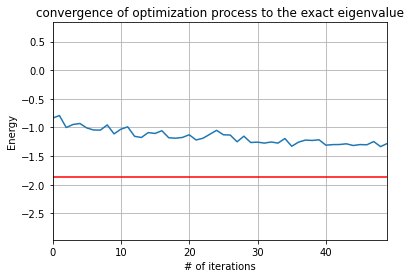

In [278]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [279]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [280]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

3it [00:00, 13.32it/s]

{'0111': 53, '1000': 60, '0101': 103, '1110': 12, '0011': 240, '1111': 93, '1001': 37, '0001': 186, '1101': 10, '1011': 39, '0100': 63, '1010': 28, '0110': 50, '0010': 21, '0000': 22, '1100': 7}
1.0
{'1000': 6, '0000': 109, '1110': 24, '1011': 48, '1001': 90, '0001': 109, '0111': 104, '0100': 65, '0011': 76, '0110': 9, '1111': 84, '0010': 167, '0101': 104, '1010': 19, '1100': 8, '1101': 2}
1.0
{'1001': 44, '0001': 318, '1011': 39, '0010': 27, '0011': 114, '0110': 113, '1101': 46, '1000': 104, '0111': 122, '0101': 19, '1110': 17, '1111': 49, '0100': 2, '1010': 4, '0000': 6}
1.0


7it [00:00, 15.57it/s]

{'0011': 245, '0101': 107, '1000': 41, '0001': 215, '1011': 36, '0010': 18, '1111': 83, '0100': 77, '1101': 7, '0111': 52, '1010': 31, '0000': 22, '0110': 45, '1100': 6, '1001': 28, '1110': 11}
1.0
{'1100': 48, '0011': 163, '0001': 67, '0111': 117, '1011': 115, '0000': 42, '0101': 241, '0100': 54, '0010': 37, '1001': 41, '0110': 22, '1010': 32, '1101': 14, '1000': 18, '1111': 11, '1110': 2}
1.0
{'1001': 44, '0001': 220, '0101': 113, '0000': 19, '0110': 45, '1111': 88, '0011': 205, '0100': 67, '1100': 8, '1010': 38, '1000': 56, '1110': 15, '1011': 39, '0111': 43, '1101': 4, '0010': 20}
1.0
{'1000': 57, '0000': 25, '1010': 40, '0101': 100, '1110': 10, '0100': 82, '1011': 30, '1111': 80, '0001': 213, '0011': 223, '0110': 48, '0111': 48, '1001': 48, '1101': 4, '0010': 12, '1100': 4}
1.0


9it [00:00, 13.04it/s]

{'1111': 128, '1011': 215, '0100': 23, '1101': 29, '1001': 202, '0001': 38, '0101': 78, '1100': 59, '0000': 42, '1110': 51, '0011': 56, '1000': 46, '1010': 38, '0010': 6, '0110': 5, '0111': 8}
1.0
{'0110': 39, '0011': 223, '0100': 96, '0111': 55, '0010': 12, '1011': 50, '0101': 101, '1010': 25, '0001': 182, '1000': 63, '1111': 82, '1001': 40, '0000': 27, '1110': 18, '1101': 8, '1100': 3}
1.0


11it [00:00, 13.01it/s]


{'0111': 49, '0010': 16, '1011': 35, '0001': 211, '1001': 39, '1111': 92, '0011': 225, '0101': 96, '0100': 70, '1000': 67, '1010': 27, '0110': 39, '1100': 7, '0000': 28, '1110': 16, '1101': 7}
1.0
{'1001': 50, '0001': 197, '0011': 228, '0100': 72, '1111': 83, '1011': 43, '0101': 107, '0111': 49, '1000': 54, '0000': 30, '1110': 9, '1100': 7, '0110': 50, '1010': 32, '1101': 2, '0010': 11}
1.0


0it [00:00, ?it/s]

{'0011': 307, '1011': 56, '0100': 54, '0101': 91, '0001': 202, '0111': 99, '0110': 10, '1111': 42, '1100': 26, '0010': 57, '1000': 20, '1001': 18, '1110': 6, '1101': 25, '0000': 11}
1.0


4it [00:00, 15.77it/s]

{'1001': 15, '0001': 132, '1101': 49, '0010': 258, '1011': 46, '0111': 78, '1100': 4, '0011': 119, '0000': 74, '0101': 88, '1110': 19, '0100': 50, '0110': 29, '1111': 32, '1000': 14, '1010': 17}
1.0
{'0001': 315, '1110': 38, '0110': 41, '1111': 46, '0111': 139, '0010': 27, '0011': 192, '1101': 31, '0100': 29, '1001': 62, '0000': 38, '1000': 13, '1011': 20, '0101': 25, '1100': 7, '1010': 1}
1.0
{'1011': 55, '0010': 57, '0100': 75, '0011': 269, '0110': 6, '0001': 208, '1000': 20, '0101': 97, '1111': 44, '0111': 90, '1110': 7, '1101': 27, '1100': 24, '0000': 13, '1001': 31, '1010': 1}
1.0
{'0011': 186, '0111': 216, '0101': 210, '1011': 100, '0010': 52, '0100': 66, '1001': 33, '1111': 2, '1100': 33, '0001': 77, '0000': 7, '0110': 12, '1010': 9, '1101': 14, '1000': 2, '1110': 5}
1.0


8it [00:00,  8.92it/s]

{'0011': 286, '0101': 75, '1011': 65, '0010': 58, '0100': 62, '0001': 184, '1001': 27, '0111': 102, '1111': 44, '1101': 40, '0000': 10, '1100': 33, '1010': 4, '1000': 15, '0110': 9, '1110': 10}
1.0
{'1000': 17, '1001': 26, '0001': 203, '1100': 38, '0011': 305, '0101': 78, '0010': 54, '0111': 95, '1011': 52, '0110': 12, '0100': 62, '0000': 13, '1111': 35, '1101': 27, '1110': 5, '1010': 2}
1.0
{'0010': 23, '1011': 274, '0110': 12, '1111': 122, '1010': 36, '1001': 163, '1100': 84, '0101': 113, '1000': 26, '0001': 41, '0011': 99, '0100': 9, '1101': 13, '1110': 5, '0111': 4}
1.0


11it [00:01, 10.47it/s]


{'0011': 284, '0101': 85, '1110': 13, '0111': 87, '0010': 65, '0100': 55, '0001': 221, '1001': 25, '1101': 21, '1000': 21, '1111': 45, '1010': 3, '1011': 47, '1100': 27, '0110': 6, '0000': 19}
1.0
{'1001': 22, '0001': 216, '0010': 48, '0011': 298, '0111': 110, '1111': 39, '1101': 24, '0100': 64, '0101': 75, '1011': 45, '0000': 14, '1010': 6, '1100': 33, '1110': 8, '1000': 13, '0110': 9}
1.0
{'1001': 24, '0001': 231, '1011': 61, '0010': 56, '0011': 290, '1100': 41, '0100': 42, '0101': 73, '1010': 5, '0111': 86, '0000': 9, '1111': 37, '1000': 22, '1110': 10, '1101': 31, '0110': 6}
1.0


2it [00:00,  6.74it/s]

{'1111': 84, '0011': 314, '0001': 201, '1001': 38, '0100': 20, '1101': 36, '0111': 110, '0010': 104, '0000': 24, '1100': 9, '0101': 28, '1011': 29, '1000': 23, '0110': 2, '1110': 2}
1.0
{'0110': 61, '0001': 170, '0010': 308, '0011': 116, '1110': 50, '0101': 22, '0000': 66, '0111': 57, '1111': 30, '1000': 33, '1011': 15, '1100': 37, '1001': 33, '1010': 9, '0100': 13, '1101': 4}
1.0


4it [00:00,  9.44it/s]

{'1100': 12, '0011': 219, '0111': 99, '0010': 38, '0101': 35, '0000': 76, '1101': 107, '0001': 307, '1010': 14, '1011': 9, '1001': 64, '0100': 11, '0110': 9, '1111': 9, '1000': 10, '1110': 5}
1.0
{'0011': 356, '1011': 29, '0010': 106, '1101': 37, '1001': 46, '0001': 197, '1000': 25, '0101': 24, '0111': 88, '0000': 19, '1111': 70, '1100': 11, '0100': 15, '0110': 1}
1.0
{'0111': 159, '1011': 86, '0011': 269, '0100': 34, '0110': 49, '1001': 87, '0001': 56, '0101': 171, '1100': 34, '0010': 57, '1000': 8, '1110': 2, '1111': 8, '0000': 2, '1101': 2}
1.0
{'0011': 303, '0001': 211, '1001': 51, '1011': 35, '0010': 109, '0111': 110, '0100': 15, '0101': 37, '1000': 12, '1111': 78, '1101': 22, '1110': 2, '0000': 19, '1100': 18, '0110': 2}
1.0


8it [00:00, 11.33it/s]

{'1100': 11, '0011': 337, '1101': 31, '1001': 48, '0001': 195, '0111': 94, '0000': 21, '1111': 81, '1011': 27, '0010': 105, '1000': 26, '0101': 26, '0100': 19, '0110': 2, '1110': 1}
1.0
{'0010': 38, '1011': 120, '0101': 61, '1010': 54, '1001': 191, '0011': 201, '1111': 137, '0111': 53, '0001': 92, '1000': 38, '0110': 3, '1100': 22, '0100': 12, '1101': 1, '0000': 1}
1.0


11it [00:01, 10.53it/s]


{'0111': 104, '1001': 62, '0001': 197, '0011': 329, '1111': 88, '0100': 21, '1011': 20, '0010': 103, '1000': 25, '1101': 27, '0101': 27, '1100': 8, '0000': 12, '1110': 1}
1.0
{'0010': 112, '0001': 169, '1001': 56, '0011': 324, '1101': 32, '0100': 22, '0000': 13, '1111': 90, '0111': 103, '1011': 33, '1000': 19, '0101': 34, '1100': 11, '0110': 1, '1110': 5}
1.0
{'0001': 196, '1001': 46, '1011': 31, '0010': 119, '1100': 10, '0011': 337, '1111': 80, '0111': 99, '1000': 21, '0100': 11, '0000': 17, '1101': 30, '0101': 23, '1110': 1, '0110': 3}
1.0


0it [00:00, ?it/s]

{'1100': 4, '0011': 311, '0001': 240, '0101': 91, '0111': 105, '0010': 26, '1011': 31, '0100': 44, '0000': 27, '1001': 51, '1111': 55, '1110': 15, '0110': 15, '1101': 6, '1010': 2, '1000': 1}
1.0


2it [00:00, 14.98it/s]

{'0001': 183, '0011': 109, '0010': 260, '1111': 29, '0110': 70, '0000': 49, '1110': 22, '0101': 138, '0111': 52, '1001': 25, '1100': 3, '0100': 10, '1101': 18, '1010': 23, '1011': 7, '1000': 26}
1.0
{'1001': 95, '0001': 391, '0011': 130, '0110': 33, '1111': 47, '0111': 219, '0100': 10, '0010': 38, '1100': 5, '0101': 12, '1010': 5, '1011': 8, '1101': 11, '1000': 7, '1110': 12, '0000': 1}
1.0
{'1011': 23, '0111': 113, '1110': 14, '0101': 114, '0011': 288, '0001': 231, '0100': 59, '1111': 62, '0010': 17, '0110': 11, '1001': 45, '0000': 23, '1010': 6, '1101': 7, '1000': 3, '1100': 8}
1.0


4it [00:00, 15.08it/s]

{'0101': 301, '0001': 52, '1001': 38, '0011': 228, '0100': 50, '0111': 185, '1011': 69, '0000': 9, '1110': 7, '1010': 11, '0010': 20, '1000': 3, '1101': 41, '1100': 8, '1111': 1, '0110': 1}
1.0
{'0011': 292, '0001': 227, '1111': 55, '0111': 114, '0101': 130, '0010': 13, '1101': 8, '0100': 42, '1110': 15, '0000': 18, '1011': 25, '1010': 6, '1100': 13, '1001': 51, '0110': 13, '1000': 2}
1.0


8it [00:00, 11.82it/s]

{'0000': 25, '0111': 119, '0001': 222, '0011': 329, '0100': 44, '0101': 111, '1110': 12, '0110': 13, '1001': 40, '1010': 3, '1011': 25, '1111': 47, '1100': 9, '0010': 14, '1101': 9, '1000': 2}
1.0
{'1010': 17, '1001': 242, '0011': 119, '0010': 9, '1011': 223, '0101': 58, '1111': 142, '0100': 18, '1101': 47, '1000': 12, '0110': 17, '0001': 54, '1100': 31, '0111': 20, '0000': 15}
1.0


10it [00:00, 13.20it/s]

{'0001': 202, '0011': 315, '0101': 126, '0010': 26, '0110': 11, '1111': 42, '0100': 40, '0111': 117, '1101': 13, '1100': 8, '1001': 50, '1011': 32, '1110': 16, '0000': 21, '1000': 1, '1010': 4}
1.0
{'0001': 214, '1001': 60, '0110': 19, '1111': 52, '0011': 309, '0101': 108, '0111': 104, '0000': 32, '1110': 12, '0100': 33, '1011': 24, '0010': 21, '1010': 6, '1101': 11, '1100': 17, '1000': 2}
1.0


11it [00:00, 13.38it/s]


{'1001': 48, '0001': 242, '0011': 310, '0111': 122, '1111': 42, '0010': 15, '0000': 30, '0101': 111, '1011': 15, '0100': 36, '0110': 22, '1100': 7, '1101': 8, '1110': 12, '1010': 2, '1000': 2}
1.0


0it [00:00, ?it/s]

{'1010': 16, '0001': 93, '1101': 97, '0100': 53, '1100': 24, '0011': 315, '0101': 141, '0111': 33, '0110': 22, '1001': 73, '1111': 59, '0010': 44, '1011': 23, '1110': 17, '1000': 13, '0000': 1}
1.0


2it [00:00, 16.33it/s]

{'0011': 115, '0101': 174, '1000': 22, '0000': 37, '0100': 36, '1101': 96, '0010': 265, '1001': 41, '1100': 36, '0001': 49, '1110': 58, '0111': 40, '1011': 31, '1111': 18, '0110': 1, '1010': 5}
1.0
{'0001': 146, '1001': 73, '0110': 75, '1100': 18, '0011': 268, '0000': 18, '1110': 39, '0111': 146, '1101': 112, '0101': 24, '1111': 32, '0100': 22, '0010': 18, '1000': 27, '1011': 5, '1010': 1}
1.0


6it [00:00, 11.14it/s]

{'0011': 327, '0110': 12, '1111': 74, '1001': 78, '0001': 89, '1101': 78, '0111': 26, '0101': 137, '0100': 66, '1011': 17, '1010': 14, '1100': 26, '0010': 39, '1110': 33, '1000': 7, '0000': 1}
1.0
{'1001': 103, '1011': 72, '1100': 33, '0011': 80, '0111': 246, '1111': 20, '0101': 244, '0000': 31, '0010': 57, '0100': 30, '1110': 16, '1010': 23, '1101': 57, '0001': 10, '1000': 2}
1.0
{'0011': 312, '1100': 23, '1011': 25, '0111': 21, '1001': 68, '1101': 100, '0101': 144, '1000': 11, '0110': 28, '0001': 89, '0100': 54, '1010': 21, '0010': 49, '1111': 59, '1110': 19, '0000': 1}
1.0


10it [00:00, 14.03it/s]

{'0011': 323, '1001': 63, '0001': 85, '0101': 153, '1111': 68, '1101': 83, '0111': 23, '1011': 26, '1010': 22, '0010': 37, '0110': 29, '1100': 28, '1000': 4, '0100': 61, '1110': 18, '0000': 1}
1.0
{'1011': 164, '1100': 54, '0011': 176, '1111': 62, '0110': 52, '1001': 136, '1101': 35, '0101': 247, '0111': 18, '0100': 13, '1010': 39, '0010': 15, '1000': 4, '0000': 6, '0001': 3}
1.0
{'0011': 320, '0111': 32, '1101': 86, '0101': 165, '1111': 52, '0001': 74, '1001': 72, '0010': 57, '0100': 68, '1110': 21, '1010': 16, '0110': 19, '1100': 18, '1000': 12, '1011': 11, '0000': 1}
1.0
{'0011': 282, '1100': 16, '1111': 71, '0100': 69, '1101': 99, '0101': 178, '1001': 65, '0001': 88, '1110': 27, '0110': 23, '0010': 42, '0111': 23, '1011': 14, '1000': 9, '1010': 18}
1.0


11it [00:00, 13.43it/s]


{'0101': 131, '0100': 57, '1101': 96, '0011': 328, '1111': 56, '0010': 58, '1001': 53, '0001': 110, '0110': 28, '1000': 7, '1110': 21, '0111': 24, '1011': 18, '1100': 19, '1010': 18}
1.0


2it [00:00, 11.28it/s]

{'1111': 118, '0110': 98, '0111': 21, '0101': 177, '1110': 16, '0100': 69, '1101': 85, '0011': 223, '1001': 49, '1011': 16, '1000': 8, '0001': 75, '0010': 25, '0000': 5, '1100': 37, '1010': 2}
1.0
{'1100': 19, '0101': 191, '1101': 129, '0111': 73, '0001': 65, '1010': 19, '1000': 40, '0110': 13, '1011': 14, '0010': 176, '1110': 89, '0100': 46, '0011': 99, '0000': 18, '1111': 19, '1001': 14}
1.0
{'0111': 143, '0001': 108, '0011': 207, '0000': 34, '1111': 26, '1110': 27, '0100': 41, '1101': 170, '0110': 101, '1100': 41, '0101': 30, '0010': 5, '1001': 73, '1000': 6, '1010': 10, '1011': 2}
1.0


6it [00:00, 14.56it/s]

{'1001': 28, '0010': 26, '1011': 34, '0100': 57, '1101': 115, '1111': 112, '0110': 68, '0011': 257, '0101': 162, '1110': 24, '0001': 56, '0111': 22, '1100': 42, '0000': 5, '1000': 12, '1010': 4}
1.0
{'1001': 92, '0010': 81, '1011': 117, '0100': 53, '0011': 77, '0111': 197, '0110': 19, '0101': 228, '1000': 47, '0000': 12, '1111': 18, '1100': 9, '0001': 13, '1101': 41, '1010': 17, '1110': 3}
1.0
{'1001': 28, '0001': 77, '0011': 245, '0010': 33, '0111': 16, '0100': 62, '1101': 101, '1111': 109, '0110': 72, '0101': 163, '1000': 10, '1011': 34, '1100': 51, '1110': 18, '0000': 3, '1010': 2}
1.0
{'0101': 138, '0111': 29, '1001': 33, '0001': 67, '0011': 277, '1100': 39, '1111': 93, '0110': 95, '0010': 26, '1101': 88, '0100': 61, '1110': 23, '1010': 8, '1011': 32, '1000': 8, '0000': 7}
1.0


8it [00:00, 14.92it/s]

{'1110': 22, '0101': 234, '1011': 133, '0110': 69, '1111': 129, '0100': 34, '1100': 80, '0011': 122, '1010': 5, '1001': 103, '0000': 14, '0010': 29, '0111': 25, '1101': 19, '1000': 2, '0001': 4}
1.0
{'0001': 76, '0101': 165, '0100': 50, '1101': 95, '0110': 72, '1111': 101, '0011': 268, '0010': 22, '1100': 56, '1011': 22, '1110': 13, '1001': 45, '0111': 24, '0000': 2, '1000': 10, '1010': 3}
1.0


11it [00:00, 12.51it/s]


{'1101': 102, '1111': 127, '0110': 76, '1100': 43, '0011': 247, '1011': 36, '1110': 14, '0101': 155, '0000': 3, '0010': 32, '0100': 53, '0001': 65, '1010': 10, '0111': 21, '1000': 7, '1001': 33}
1.0
{'0010': 29, '0011': 255, '0101': 158, '0110': 77, '1111': 109, '0001': 73, '1001': 38, '1101': 107, '0100': 69, '1100': 42, '0000': 5, '1000': 12, '1011': 11, '1110': 13, '1010': 5, '0111': 21}
1.0


2it [00:00,  6.92it/s]

{'0011': 251, '0101': 178, '0111': 60, '1101': 98, '0001': 104, '1000': 60, '0010': 69, '1111': 45, '0100': 27, '1100': 26, '1010': 13, '0110': 41, '1110': 22, '1001': 21, '1011': 8, '0000': 1}
1.0
{'0000': 36, '1000': 37, '0111': 103, '1001': 27, '0010': 267, '0011': 41, '0100': 83, '0101': 115, '1100': 21, '1110': 27, '0001': 83, '1011': 24, '1111': 31, '1101': 128, '0110': 1}
1.0


5it [00:00, 10.52it/s]

{'1110': 26, '1101': 144, '0011': 300, '0010': 24, '0111': 190, '0110': 37, '0001': 84, '0000': 63, '0101': 16, '1010': 41, '1100': 28, '0100': 18, '1011': 22, '1000': 15, '1001': 4, '1111': 12}
1.0
{'1000': 59, '0110': 46, '1111': 43, '1101': 110, '0001': 103, '0101': 188, '0011': 266, '0111': 54, '0010': 72, '0100': 22, '1100': 20, '1011': 9, '1110': 13, '1001': 10, '0000': 4, '1010': 5}
1.0
{'0111': 227, '0110': 6, '1111': 45, '1001': 97, '0011': 80, '0010': 93, '0101': 263, '1000': 84, '1101': 61, '0001': 5, '1010': 16, '1100': 8, '1110': 9, '0100': 14, '0000': 12, '1011': 4}
1.0


7it [00:00, 12.77it/s]

{'0001': 108, '1000': 55, '0011': 238, '0010': 79, '1101': 138, '0101': 162, '1110': 21, '0111': 37, '1011': 13, '1001': 15, '1111': 51, '0100': 21, '0110': 40, '1100': 28, '0000': 9, '1010': 9}
1.0
{'1100': 41, '0011': 236, '0001': 121, '0101': 170, '1110': 20, '1000': 46, '0110': 36, '0010': 89, '0111': 46, '1111': 32, '1101': 127, '1010': 6, '1001': 16, '0000': 10, '0100': 20, '1011': 8}
1.0
{'0101': 258, '1001': 99, '0011': 70, '1100': 47, '1000': 28, '0010': 63, '1011': 202, '0110': 39, '0000': 26, '1101': 48, '1111': 79, '1110': 18, '0001': 22, '1010': 9, '0100': 13, '0111': 3}
1.0
{'1101': 117, '0011': 280, '1000': 61, '0001': 112, '0101': 172, '0111': 47, '0010': 58, '1011': 10, '0110': 33, '1100': 31, '1111': 45, '1110': 14, '0100': 21, '0000': 7, '1001': 11, '1010': 5}
1.0


11it [00:00, 11.59it/s]


{'0011': 250, '0111': 47, '1011': 16, '1000': 73, '0101': 159, '0001': 118, '1101': 113, '1111': 46, '0010': 60, '0110': 32, '1110': 21, '1100': 35, '0100': 26, '1001': 18, '1010': 6, '0000': 4}
1.0
{'0011': 255, '0101': 170, '0001': 109, '1101': 126, '1000': 59, '0010': 68, '0111': 47, '1111': 47, '0110': 37, '1010': 6, '1110': 20, '1001': 23, '0000': 8, '1100': 22, '0100': 12, '1011': 15}
1.0


2it [00:00, 12.88it/s]

{'1111': 160, '0101': 222, '1101': 80, '0001': 73, '1001': 39, '0011': 167, '1100': 40, '0000': 15, '0111': 21, '0110': 22, '0010': 78, '0100': 45, '1110': 34, '1010': 19, '1011': 6, '1000': 3}
1.0
{'0010': 99, '1011': 12, '1110': 154, '0101': 145, '0011': 187, '0001': 69, '0100': 111, '0111': 40, '1100': 15, '1000': 20, '1101': 100, '1111': 30, '0000': 15, '1010': 9, '1001': 15, '0110': 3}
1.0
{'1101': 202, '0111': 174, '0000': 51, '1000': 12, '0011': 227, '0101': 50, '0001': 66, '1011': 15, '1111': 56, '0010': 19, '1100': 36, '0110': 35, '1001': 24, '0100': 22, '1110': 26, '1010': 9}
1.0


6it [00:00, 14.18it/s]

{'1100': 47, '0011': 176, '1010': 11, '0001': 70, '0100': 49, '0010': 81, '0101': 199, '0000': 7, '0110': 21, '1101': 78, '1111': 181, '0111': 23, '1110': 25, '1001': 47, '1000': 7, '1011': 2}
1.0
{'0101': 286, '1110': 10, '1001': 134, '1011': 94, '0010': 59, '0011': 35, '0100': 44, '0111': 146, '1100': 21, '1111': 57, '0001': 24, '0110': 24, '1010': 35, '1000': 29, '0000': 18, '1101': 8}
1.0
{'1010': 24, '0001': 82, '1111': 189, '0011': 160, '1100': 56, '0101': 204, '0111': 16, '0010': 64, '1101': 83, '1001': 39, '0100': 39, '0110': 20, '1110': 23, '1000': 10, '0000': 10, '1011': 5}
1.0
{'0001': 73, '0110': 20, '1111': 174, '0010': 71, '1100': 35, '0011': 167, '1101': 83, '0100': 56, '0101': 228, '1010': 16, '1011': 4, '1000': 7, '0111': 19, '1001': 37, '1110': 21, '0000': 13}
1.0


11it [00:00, 15.30it/s]


{'0100': 15, '1001': 96, '0101': 297, '1111': 145, '0011': 81, '1100': 89, '1011': 84, '0111': 49, '0010': 34, '0110': 35, '0001': 7, '1101': 25, '0000': 13, '1000': 4, '1110': 6, '1010': 44}
1.0
{'0011': 179, '0010': 89, '1111': 156, '0110': 20, '0111': 20, '0001': 72, '1000': 5, '0101': 242, '0100': 39, '1101': 75, '1001': 40, '1100': 33, '0000': 14, '1011': 3, '1110': 20, '1010': 17}
1.0
{'0101': 223, '0011': 148, '1100': 43, '1101': 74, '0100': 55, '1111': 154, '1001': 43, '0010': 84, '0001': 101, '0110': 22, '0000': 9, '0111': 23, '1110': 20, '1000': 8, '1010': 12, '1011': 5}
1.0
{'1101': 80, '0100': 48, '0011': 174, '0101': 220, '0001': 70, '1111': 162, '0010': 81, '1011': 4, '1001': 49, '1110': 22, '1100': 37, '1010': 21, '0110': 19, '0000': 5, '0111': 24, '1000': 8}
1.0


2it [00:00,  9.03it/s]

{'0101': 193, '1011': 29, '1001': 85, '0011': 302, '0110': 55, '0100': 52, '1101': 90, '0000': 16, '0010': 31, '0001': 41, '1000': 31, '1111': 66, '1100': 8, '1110': 8, '0111': 9, '1010': 8}
1.0
{'0110': 57, '0010': 175, '1011': 17, '0101': 201, '0011': 162, '0100': 82, '1001': 34, '1000': 64, '1101': 80, '1100': 33, '1110': 59, '0000': 17, '0001': 24, '0111': 10, '1111': 7, '1010': 2}
1.0


6it [00:00, 13.33it/s]

{'0110': 93, '1011': 45, '0011': 107, '0001': 221, '0101': 137, '1101': 120, '0100': 37, '0000': 23, '1000': 11, '1110': 7, '1100': 12, '0111': 82, '1001': 37, '0010': 39, '1010': 23, '1111': 30}
1.0
{'1111': 77, '0110': 52, '0011': 315, '0101': 192, '0010': 53, '1001': 63, '0100': 38, '1101': 85, '0111': 12, '0001': 32, '1000': 38, '1100': 16, '1110': 17, '1011': 16, '0000': 14, '1010': 4}
1.0
{'0111': 94, '0101': 137, '1000': 36, '0000': 34, '1111': 58, '0110': 22, '0011': 225, '0001': 114, '0010': 70, '1001': 111, '1101': 49, '0100': 26, '1110': 22, '1011': 21, '1100': 4, '1010': 1}
1.0
{'0101': 224, '1100': 16, '0011': 302, '0100': 46, '1011': 24, '0010': 47, '0110': 51, '0001': 29, '1110': 10, '1001': 58, '1101': 92, '0000': 12, '0111': 15, '1111': 61, '1000': 28, '1010': 9}
1.0


10it [00:00, 15.69it/s]

{'0110': 67, '1111': 56, '0011': 300, '1001': 61, '0100': 39, '1101': 78, '0101': 240, '0010': 43, '0111': 18, '1100': 15, '0001': 34, '1000': 29, '1010': 4, '1011': 19, '0000': 10, '1110': 11}
1.0
{'0101': 281, '0010': 7, '1011': 234, '0011': 72, '1100': 57, '1001': 82, '1101': 37, '1111': 36, '0111': 41, '1110': 15, '0110': 51, '0000': 35, '1010': 24, '0100': 16, '0001': 23, '1000': 13}
1.0
{'0111': 19, '1100': 13, '0011': 284, '0001': 44, '0100': 47, '0110': 53, '0101': 200, '0010': 38, '1110': 11, '1000': 38, '1101': 107, '1001': 62, '0000': 12, '1111': 56, '1011': 35, '1010': 5}
1.0
{'0110': 46, '0101': 230, '1001': 75, '0001': 42, '0100': 41, '0011': 304, '0010': 40, '0111': 26, '0000': 13, '1011': 21, '1101': 73, '1000': 30, '1100': 18, '1111': 53, '1110': 9, '1010': 3}
1.0


11it [00:00, 13.01it/s]


{'1001': 70, '0001': 37, '1000': 32, '0101': 191, '0011': 309, '0010': 38, '1011': 14, '1111': 61, '0110': 59, '1101': 95, '0100': 66, '0000': 8, '1110': 17, '1010': 5, '0111': 13, '1100': 9}
1.0


2it [00:00, 10.65it/s]

{'1100': 71, '0011': 209, '1001': 26, '0001': 36, '1011': 87, '1111': 140, '0110': 95, '0101': 159, '1000': 53, '1101': 48, '0010': 17, '0100': 37, '1110': 28, '0000': 6, '0111': 10, '1010': 2}
1.0
{'1110': 161, '0101': 133, '1101': 114, '0100': 44, '0111': 95, '1000': 62, '1010': 46, '0011': 89, '1111': 41, '0110': 26, '0010': 136, '0001': 14, '0000': 26, '1011': 30, '1001': 6, '1100': 1}
1.0
{'1111': 88, '0110': 107, '0101': 57, '1110': 20, '0011': 199, '1001': 93, '0001': 44, '1101': 139, '1100': 89, '0111': 101, '1010': 22, '0100': 27, '1000': 23, '0000': 3, '0010': 9, '1011': 3}
1.0


6it [00:00, 15.09it/s]

{'0011': 186, '0110': 129, '0001': 48, '1001': 22, '1000': 49, '0101': 167, '0100': 30, '1101': 47, '1011': 63, '1100': 60, '0010': 13, '1111': 164, '0111': 9, '1110': 36, '0000': 1}
1.0
{'1011': 221, '0010': 92, '0000': 27, '1000': 113, '0111': 154, '1111': 32, '0110': 30, '0101': 178, '0011': 59, '1001': 24, '1101': 39, '0100': 9, '1110': 6, '1010': 20, '0001': 18, '1100': 2}
1.0
{'1100': 71, '0011': 195, '0110': 114, '1111': 189, '1000': 46, '0101': 151, '0100': 29, '1001': 33, '1011': 54, '1110': 32, '1101': 40, '1010': 4, '0001': 39, '0111': 9, '0010': 14, '0000': 4}
1.0
{'1101': 33, '1100': 63, '0011': 214, '0110': 96, '1111': 165, '0101': 197, '1001': 22, '1011': 76, '1000': 44, '0111': 14, '1110': 24, '0001': 43, '0100': 24, '0010': 7, '0000': 1, '1010': 1}
1.0


8it [00:00, 16.21it/s]

{'0110': 49, '1111': 96, '1011': 210, '0100': 55, '0011': 58, '0111': 98, '0101': 169, '1001': 38, '0000': 34, '0010': 12, '1100': 50, '1110': 96, '1010': 3, '1101': 20, '0001': 23, '1000': 13}
1.0
{'0101': 176, '1111': 174, '0110': 111, '1011': 68, '1001': 29, '0001': 47, '1101': 52, '0011': 185, '0100': 23, '1110': 29, '0111': 8, '1100': 65, '1000': 39, '0010': 15, '0000': 1, '1010': 2}
1.0


10it [00:00, 14.20it/s]

{'1111': 156, '0110': 111, '1100': 69, '0011': 178, '0101': 203, '1110': 28, '1101': 36, '0001': 51, '1000': 37, '0100': 36, '1011': 69, '1001': 24, '0010': 16, '0111': 6, '0000': 3, '1010': 1}
1.0


11it [00:00, 13.70it/s]


{'0101': 162, '0001': 48, '1101': 50, '0100': 27, '0011': 187, '1100': 83, '1011': 66, '1111': 181, '1000': 44, '0110': 108, '0010': 15, '1001': 21, '1110': 21, '0111': 8, '0000': 3}
1.0


0it [00:00, ?it/s]

{'0101': 238, '1111': 324, '0011': 151, '1011': 102, '0010': 60, '0100': 4, '0111': 27, '1001': 17, '1100': 14, '1010': 13, '0001': 20, '1101': 27, '0110': 9, '1000': 14, '0000': 4}
1.0


2it [00:00, 11.89it/s]

{'1101': 42, '0100': 78, '1111': 138, '1011': 91, '0011': 44, '1000': 25, '1110': 194, '0101': 169, '0010': 160, '0111': 27, '1010': 25, '1001': 12, '0001': 11, '0000': 4, '0110': 4}
1.0


4it [00:00, 14.18it/s]

{'0111': 169, '1101': 233, '0101': 80, '0010': 30, '1011': 21, '1111': 133, '0011': 104, '0000': 37, '1001': 107, '0001': 46, '1110': 8, '1010': 30, '0110': 14, '1100': 12}
1.0
{'1011': 98, '0010': 72, '1000': 21, '0000': 5, '1111': 340, '0101': 222, '0011': 144, '1010': 13, '1101': 28, '1100': 15, '0110': 5, '1001': 25, '0111': 14, '0100': 3, '1110': 2, '0001': 17}
1.0
{'0010': 45, '1011': 376, '0001': 64, '1010': 7, '1000': 46, '1101': 29, '0011': 44, '0111': 131, '1111': 36, '0101': 178, '0110': 18, '1001': 26, '0000': 4, '1100': 1, '0100': 5, '1110': 14}
1.0


6it [00:00, 14.78it/s]

{'1001': 23, '0011': 157, '1111': 324, '0010': 58, '1011': 117, '0111': 15, '0101': 227, '1000': 13, '0110': 11, '1010': 18, '1101': 29, '0000': 2, '0001': 12, '1100': 12, '0100': 5, '1110': 1}
1.0
{'0101': 255, '1111': 341, '1100': 16, '0011': 142, '1000': 15, '1011': 102, '0010': 55, '0111': 17, '0100': 8, '1001': 21, '1010': 10, '0001': 10, '1101': 23, '0110': 8, '0000': 1}
1.0


8it [00:00, 15.59it/s]

{'1001': 19, '1100': 6, '0101': 201, '0111': 216, '1111': 140, '1011': 217, '1000': 18, '1101': 50, '0010': 47, '0100': 26, '0011': 41, '0110': 2, '1010': 22, '0001': 10, '1110': 4, '0000': 5}
1.0
{'0101': 248, '1111': 332, '1000': 16, '1010': 15, '0011': 162, '0010': 65, '1011': 85, '1101': 30, '1100': 12, '1001': 16, '0100': 7, '0110': 8, '0111': 17, '0001': 10, '1110': 1}
1.0


11it [00:00, 12.52it/s]

{'1111': 313, '1011': 106, '0010': 73, '0101': 230, '1000': 12, '0111': 20, '1101': 32, '0011': 155, '1001': 21, '0100': 5, '1010': 24, '1100': 14, '0110': 10, '0001': 7, '0000': 2}
1.0
{'1101': 32, '1111': 323, '0011': 161, '0101': 240, '0001': 18, '1010': 15, '0010': 60, '1011': 96, '1000': 12, '0100': 6, '1001': 18, '0000': 2, '1110': 3, '0110': 8, '0111': 16, '1100': 14}
1.0



2it [00:00, 17.09it/s]

{'1001': 93, '0001': 146, '0101': 254, '1100': 122, '0011': 102, '1000': 58, '0010': 6, '1111': 83, '0100': 58, '1110': 9, '0110': 31, '1010': 7, '1101': 15, '1011': 26, '0111': 12, '0000': 2}
1.0
{'0110': 24, '0000': 104, '1000': 141, '0100': 56, '1101': 88, '0101': 259, '1110': 57, '0010': 57, '1001': 19, '0001': 56, '0011': 44, '1111': 15, '1010': 8, '1100': 41, '1011': 29, '0111': 26}
1.0


4it [00:00, 16.72it/s]

{'0111': 116, '0011': 249, '1100': 57, '1001': 94, '1111': 28, '1101': 82, '0101': 128, '1110': 75, '0110': 84, '1010': 70, '1011': 13, '0001': 9, '1000': 14, '0010': 2, '0100': 2, '0000': 1}
1.0
{'0001': 139, '1001': 77, '1110': 12, '0101': 240, '0011': 111, '1100': 106, '1000': 67, '1111': 103, '0110': 35, '1011': 33, '0010': 8, '0100': 45, '1010': 6, '1101': 20, '0111': 19, '0000': 3}
1.0


6it [00:00, 17.15it/s]

{'1111': 15, '0110': 9, '0101': 385, '1011': 100, '0000': 38, '1000': 186, '1100': 6, '0011': 82, '0100': 19, '1001': 59, '0111': 38, '1101': 35, '0010': 40, '1010': 9, '0001': 3}
1.0
{'1011': 40, '0101': 228, '0011': 118, '1100': 131, '1000': 58, '0001': 138, '1001': 88, '0100': 55, '0110': 42, '1111': 82, '1010': 6, '0111': 14, '1110': 9, '0010': 3, '1101': 11, '0000': 1}
1.0
{'0110': 29, '1111': 86, '0101': 240, '0001': 154, '1001': 76, '1100': 116, '0011': 121, '0100': 57, '0111': 17, '1110': 9, '1000': 66, '1011': 34, '1010': 5, '1101': 13, '0010': 1}
1.0


8it [00:00, 12.16it/s]

{'1111': 84, '1010': 6, '1001': 65, '0001': 160, '1011': 92, '0000': 40, '1101': 90, '0100': 171, '0011': 54, '1100': 29, '0101': 157, '0110': 39, '0111': 16, '1000': 11, '1110': 6, '0010': 4}
1.0
{'0101': 250, '1011': 37, '1000': 63, '0001': 138, '1001': 88, '1100': 103, '1111': 98, '0100': 66, '0110': 29, '0011': 102, '0111': 17, '1101': 18, '1110': 7, '0010': 3, '1010': 4, '0000': 1}
1.0


11it [00:00, 14.19it/s]

{'1000': 73, '1111': 87, '0110': 29, '0101': 247, '0001': 150, '1001': 64, '0100': 67, '0011': 118, '1010': 5, '1100': 106, '1011': 39, '0111': 19, '1110': 5, '0010': 5, '1101': 9, '0000': 1}
1.0
{'0101': 235, '0001': 147, '1111': 89, '0110': 46, '0011': 98, '1100': 109, '1000': 87, '0111': 20, '0100': 58, '1001': 64, '1011': 39, '1101': 7, '0000': 4, '0010': 9, '1110': 7, '1010': 5}
1.0



2it [00:00, 14.22it/s]

{'0110': 121, '1111': 137, '1001': 37, '0001': 103, '0100': 24, '0101': 96, '0011': 160, '1000': 39, '1011': 122, '1101': 65, '1100': 58, '0000': 10, '1110': 28, '0010': 11, '0111': 11, '1010': 2}
1.0
{'1001': 30, '0001': 39, '1010': 77, '1110': 130, '0100': 43, '0011': 100, '0111': 71, '0010': 86, '0101': 95, '1101': 126, '1000': 48, '1111': 29, '1011': 37, '0000': 68, '0110': 42, '1100': 3}
1.0
{'0011': 245, '1100': 44, '1101': 128, '1001': 120, '1000': 27, '0000': 20, '0110': 110, '1111': 63, '0100': 43, '0111': 75, '1110': 27, '1011': 35, '0001': 25, '0101': 27, '1010': 27, '0010': 8}
1.0


4it [00:00, 15.21it/s]

{'0110': 122, '1111': 126, '0011': 167, '0001': 93, '1011': 119, '0000': 18, '0101': 100, '1101': 75, '1000': 43, '1100': 55, '0100': 27, '0111': 9, '1001': 40, '1110': 22, '0010': 6, '1010': 2}
1.0
{'0001': 29, '1001': 43, '0010': 101, '1011': 130, '0110': 26, '1111': 120, '0111': 56, '0011': 116, '0000': 5, '0101': 151, '1000': 94, '0100': 47, '1101': 73, '1100': 7, '1110': 2, '1010': 24}
1.0


6it [00:00, 11.09it/s]

{'1100': 71, '0011': 183, '0100': 39, '0101': 80, '1000': 48, '0001': 102, '1111': 116, '1011': 113, '0110': 106, '1101': 65, '1010': 4, '0000': 15, '1110': 29, '1001': 37, '0111': 8, '0010': 8}
1.0
{'0100': 25, '1101': 62, '0110': 110, '1111': 134, '1100': 58, '0011': 180, '1011': 106, '0111': 13, '0001': 91, '1000': 46, '1001': 39, '0000': 17, '0101': 105, '1010': 3, '1110': 28, '0010': 7}
1.0


8it [00:00, 12.10it/s]

{'1000': 14, '0110': 110, '1111': 103, '1110': 23, '0101': 129, '0010': 7, '1011': 304, '1101': 31, '0001': 72, '1100': 69, '0111': 49, '0000': 34, '0100': 19, '1001': 49, '0011': 7, '1010': 4}
1.0
{'0011': 186, '0001': 95, '1001': 34, '0110': 98, '1111': 136, '1101': 75, '0100': 22, '1000': 55, '1011': 109, '1110': 18, '0101': 107, '1100': 61, '0010': 11, '0111': 10, '0000': 3, '1010': 4}
1.0


10it [00:00, 13.56it/s]

{'0110': 120, '1111': 138, '0101': 89, '1110': 30, '1011': 115, '0011': 163, '0111': 10, '0100': 34, '1100': 68, '0001': 80, '1101': 71, '0000': 13, '1010': 4, '1000': 40, '1001': 40, '0010': 9}
1.0
{'0100': 38, '1101': 63, '0101': 85, '0011': 177, '1111': 132, '0110': 110, '0000': 11, '1001': 40, '1011': 132, '0001': 81, '1000': 41, '1100': 55, '1110': 34, '0111': 7, '0010': 11, '1010': 7}
1.0


11it [00:00, 13.31it/s]
0it [00:00, ?it/s]

{'1100': 49, '0011': 296, '1111': 113, '0101': 173, '0111': 26, '0100': 44, '1011': 56, '0000': 8, '1110': 8, '0110': 40, '1101': 63, '0010': 22, '1001': 37, '0001': 75, '1010': 14}
1.0
{'1110': 116, '0101': 142, '1101': 94, '1011': 69, '0010': 272, '0011': 88, '0001': 23, '0111': 61, '0000': 42, '1111': 17, '1001': 17, '1100': 4, '0110': 10, '1010': 7, '0100': 43, '1000': 19}
1.0


2it [00:00, 15.69it/s]

{'1111': 87, '0110': 62, '1101': 68, '0111': 123, '0011': 297, '0001': 102, '1001': 99, '0010': 22, '1110': 24, '1010': 8, '0101': 57, '0000': 19, '1100': 38, '1011': 5, '1000': 5, '0100': 8}

4it [00:00, 10.54it/s]


1.0
{'1011': 50, '1001': 36, '0001': 60, '1111': 115, '1101': 64, '0101': 171, '0111': 26, '0011': 309, '0100': 28, '0000': 8, '0110': 48, '1100': 49, '0010': 39, '1010': 13, '1110': 8}
1.0
{'0010': 78, '1011': 142, '1100': 21, '0011': 84, '0111': 249, '0001': 12, '1001': 43, '0101': 246, '0100': 8, '1101': 55, '0000': 34, '1000': 24, '1111': 6, '1110': 19, '1010': 3}
1.0


8it [00:00, 13.32it/s]

{'0010': 26, '1011': 62, '1001': 42, '0011': 274, '1100': 47, '1111': 140, '1101': 63, '0101': 180, '0001': 68, '0111': 26, '0000': 7, '0100': 32, '0110': 34, '1110': 15, '1010': 8}
1.0
{'0101': 159, '0001': 63, '1001': 41, '0011': 297, '0110': 30, '1111': 116, '1101': 64, '0100': 41, '0010': 43, '0111': 26, '1110': 10, '1011': 69, '1100': 50, '1010': 10, '0000': 5}
1.0
{'0111': 79, '0101': 204, '0001': 27, '0100': 34, '1111': 53, '0110': 31, '1011': 294, '0011': 87, '1101': 28, '1010': 21, '1100': 50, '1110': 13, '1001': 85, '0010': 15, '1000': 2, '0000': 1}
1.0
{'0101': 173, '1100': 47, '0011': 290, '0110': 40, '0100': 48, '1101': 54, '0010': 42, '0001': 60, '1011': 53, '0111': 27, '1111': 114, '0000': 6, '1001': 48, '1110': 14, '1010': 8}
1.0


11it [00:00, 13.73it/s]


{'1111': 95, '0110': 38, '0011': 314, '1011': 57, '0010': 47, '0001': 77, '1001': 43, '0101': 171, '0111': 23, '1101': 61, '1100': 40, '0100': 35, '1010': 13, '1110': 10}
1.0
{'0100': 41, '1101': 62, '0011': 307, '0101': 161, '1011': 64, '1111': 118, '0110': 40, '0000': 8, '0001': 65, '1001': 45, '0010': 26, '1100': 41, '0111': 25, '1110': 11, '1010': 10}
1.0


0it [00:00, ?it/s]

{'1110': 47, '0101': 93, '1011': 59, '0010': 62, '1001': 43, '1111': 252, '0110': 96, '0111': 15, '0011': 183, '1101': 11, '0001': 22, '1100': 42, '0000': 5, '0100': 67, '1000': 27}
1.0


2it [00:00,  9.95it/s]

{'1101': 68, '0111': 90, '0011': 108, '1010': 26, '1111': 77, '1110': 182, '0101': 178, '1011': 36, '0010': 115, '0000': 29, '1001': 10, '1000': 51, '0100': 6, '0110': 37, '1100': 9, '0001': 2}
1.0


3it [00:00,  9.25it/s]

{'0110': 174, '1111': 99, '1100': 81, '0011': 167, '0111': 76, '0001': 48, '1001': 106, '0010': 44, '0100': 14, '1101': 125, '0000': 17, '1011': 8, '1010': 18, '0101': 38, '1000': 7, '1110': 2}
1.0
{'0101': 93, '1110': 59, '1101': 22, '0110': 109, '1111': 218, '0111': 13, '1011': 73, '0011': 181, '0001': 21, '1100': 52, '0100': 72, '1001': 35, '0000': 7, '1000': 13, '0010': 52, '1010': 4}
1.0


7it [00:00,  9.63it/s]

{'1011': 281, '0110': 101, '1111': 25, '0101': 95, '1110': 31, '1001': 22, '0111': 119, '0000': 57, '0010': 68, '0100': 30, '1010': 11, '0011': 52, '0001': 22, '1000': 62, '1101': 42, '1100': 6}
1.0
{'0110': 125, '1111': 205, '0100': 80, '1100': 56, '0011': 153, '0101': 98, '1110': 48, '1001': 46, '0010': 68, '1011': 65, '1101': 14, '0000': 6, '0001': 25, '1000': 21, '0111': 13, '1010': 1}
1.0
{'0011': 163, '0110': 116, '1111': 209, '0010': 58, '1011': 65, '1110': 48, '1001': 46, '0111': 22, '0101': 93, '1100': 53, '0001': 22, '1000': 23, '0100': 80, '0000': 10, '1101': 15, '1010': 1}
1.0


9it [00:00, 10.73it/s]

{'1011': 181, '0010': 29, '1111': 59, '0111': 202, '1010': 28, '1110': 143, '1000': 3, '1101': 31, '0001': 39, '0101': 71, '0100': 132, '0000': 18, '0011': 59, '0110': 6, '1001': 21, '1100': 2}
1.0
{'0110': 107, '1111': 226, '0010': 67, '1001': 53, '1110': 54, '0101': 107, '0011': 149, '0100': 70, '1100': 48, '1011': 76, '0001': 21, '0111': 13, '1000': 14, '1101': 18, '0000': 1}
1.0
{'0011': 152, '0100': 69, '1111': 219, '0110': 137, '0101': 91, '1110': 41, '0001': 24, '0111': 16, '1001': 53, '1011': 73, '1000': 24, '0010': 60, '1100': 47, '1010': 1, '0000': 8, '1101': 9}
1.0


11it [00:01, 10.45it/s]


{'1100': 66, '0011': 171, '1011': 86, '0010': 67, '0110': 107, '1111': 218, '1000': 14, '1110': 59, '0100': 68, '0101': 78, '1101': 15, '1001': 36, '0001': 21, '1010': 2, '0111': 12, '0000': 4}
1.0


2it [00:00, 15.56it/s]

{'1100': 73, '0011': 146, '0101': 236, '1110': 48, '0110': 86, '1111': 220, '1011': 28, '0001': 40, '0100': 38, '1000': 31, '0010': 8, '1101': 13, '0111': 36, '0000': 5, '1001': 16}
1.0
{'1110': 215, '0101': 201, '1000': 43, '0111': 120, '1101': 60, '0011': 60, '0010': 103, '1111': 65, '0000': 40, '0100': 37, '1010': 15, '1100': 19, '0001': 13, '1011': 14, '0110': 17, '1001': 2}
1.0
{'0111': 175, '0110': 122, '1111': 99, '0011': 124, '1100': 108, '0100': 7, '1101': 147, '0101': 43, '0001': 90, '0010': 16, '0000': 1, '1000': 14, '1011': 10, '1001': 41, '1010': 12, '1110': 15}
1.0


4it [00:00, 16.04it/s]

{'0101': 232, '0011': 154, '1100': 69, '0001': 63, '1000': 38, '1111': 219, '1011': 29, '1101': 10, '0111': 22, '0110': 80, '0100': 33, '1001': 20, '0010': 12, '1110': 38, '0000': 5}
1.0


6it [00:00, 17.32it/s]

{'0100': 14, '0001': 129, '1010': 12, '1000': 104, '1011': 201, '1111': 49, '0110': 37, '0111': 131, '1100': 23, '0011': 25, '0101': 131, '1110': 25, '1001': 20, '1101': 19, '0010': 76, '0000': 28}
1.0
{'0101': 222, '0100': 40, '0011': 133, '1100': 70, '0110': 86, '1000': 41, '1001': 22, '1011': 28, '1110': 46, '0001': 62, '1111': 215, '0111': 32, '1101': 6, '0010': 17, '0000': 3, '1010': 1}
1.0
{'1100': 80, '0011': 131, '1001': 15, '0101': 236, '1000': 38, '1111': 234, '0100': 42, '1011': 35, '1110': 37, '0000': 8, '0001': 49, '0010': 15, '0110': 77, '0111': 18, '1101': 8, '1010': 1}
1.0


8it [00:00, 13.03it/s]

{'0111': 205, '1110': 135, '0101': 131, '0100': 114, '1101': 83, '1011': 75, '1001': 53, '0011': 87, '0000': 17, '1111': 64, '1000': 28, '1100': 5, '0001': 15, '1010': 4, '0110': 5, '0010': 3}
1.0


10it [00:00, 12.89it/s]

{'1100': 69, '0011': 138, '0110': 92, '1111': 225, '1001': 24, '0101': 230, '0100': 38, '1000': 31, '0010': 13, '0111': 25, '1011': 26, '1110': 29, '1101': 11, '0001': 68, '0000': 4, '1010': 1}
1.0
{'0001': 66, '0110': 79, '1111': 241, '0010': 11, '0101': 220, '0011': 136, '1100': 71, '1000': 39, '1001': 18, '1110': 42, '0111': 28, '0100': 34, '1101': 10, '1011': 22, '0000': 7}
1.0


11it [00:00, 13.74it/s]


{'0010': 16, '1011': 29, '0011': 134, '1101': 12, '1111': 250, '1000': 34, '0001': 53, '0101': 210, '0111': 40, '1100': 71, '0110': 75, '1110': 41, '0000': 3, '0100': 35, '1001': 21}
1.0


0it [00:00, ?it/s]

{'0011': 90, '0110': 58, '1111': 128, '0101': 173, '1001': 48, '1010': 21, '0001': 124, '1011': 131, '1100': 76, '0111': 35, '1000': 24, '0100': 39, '0000': 26, '1101': 11, '1110': 22, '0010': 18}
1.0


2it [00:00, 14.49it/s]

{'0010': 78, '1011': 48, '1110': 133, '0101': 143, '1010': 80, '1001': 19, '0001': 124, '1100': 26, '0011': 45, '0100': 55, '1111': 27, '0111': 75, '1101': 65, '1000': 45, '0110': 27, '0000': 34}
1.0
{'1110': 37, '0101': 83, '0000': 38, '0111': 120, '1011': 31, '0110': 89, '1001': 134, '0011': 135, '1101': 45, '0001': 71, '1111': 103, '1000': 38, '1100': 55, '0100': 21, '1010': 11, '0010': 13}
1.0


4it [00:00, 14.68it/s]

{'1011': 128, '0001': 116, '0111': 39, '1110': 31, '0101': 167, '1111': 139, '0110': 71, '0011': 94, '1010': 18, '1100': 85, '1001': 37, '0000': 24, '1000': 28, '0100': 22, '1101': 7, '0010': 18}
1.0
{'0001': 92, '0010': 73, '1011': 210, '0111': 71, '1000': 81, '0101': 216, '0011': 51, '1111': 46, '1010': 20, '0000': 10, '1101': 34, '0100': 44, '1110': 22, '0110': 16, '1001': 14, '1100': 24}
1.0


6it [00:00, 11.60it/s]

{'0011': 83, '1100': 81, '1011': 117, '0110': 69, '1111': 133, '1110': 24, '0101': 178, '0001': 106, '1001': 41, '1000': 39, '1101': 13, '0100': 39, '0000': 21, '1010': 24, '0111': 24, '0010': 32}
1.0
{'0011': 91, '0101': 182, '1010': 20, '0001': 115, '1011': 130, '0010': 18, '0111': 26, '0000': 30, '1110': 17, '1001': 41, '1100': 74, '0110': 69, '1111': 148, '0100': 31, '1000': 18, '1101': 14}
1.0


8it [00:00, 12.01it/s]

{'0100': 83, '1101': 57, '1011': 191, '1001': 157, '0011': 18, '0101': 134, '1110': 42, '1111': 156, '1010': 48, '0110': 31, '0111': 28, '0001': 19, '0000': 41, '1000': 7, '1100': 12}
1.0


11it [00:00, 13.13it/s]

{'0000': 26, '0110': 64, '1111': 143, '0001': 113, '0011': 99, '0111': 36, '0010': 21, '0101': 162, '1011': 130, '1000': 28, '1010': 22, '1101': 16, '0100': 29, '1001': 42, '1100': 75, '1110': 18}
1.0
{'1011': 106, '1111': 141, '0110': 67, '0101': 179, '0001': 115, '0000': 23, '1100': 90, '0011': 84, '0100': 29, '1110': 31, '1001': 36, '1010': 21, '1101': 12, '0111': 34, '1000': 29, '0010': 27}
1.0
{'1100': 85, '1011': 117, '0010': 24, '1110': 28, '0101': 150, '0110': 58, '0100': 41, '0001': 119, '0011': 101, '1111': 143, '1000': 22, '0000': 26, '1001': 38, '0111': 37, '1010': 20, '1101': 15}
1.0



0it [00:00, ?it/s]

{'1111': 95, '0110': 80, '1100': 32, '0011': 246, '0101': 143, '1011': 110, '0001': 55, '1101': 86, '1001': 58, '1000': 49, '0010': 13, '0000': 11, '1110': 11, '0100': 10, '0111': 7, '1010': 18}
1.0


4it [00:00, 18.16it/s]

{'0000': 61, '0111': 64, '0011': 181, '1101': 84, '0100': 38, '1111': 84, '0101': 138, '1001': 35, '0010': 88, '1010': 82, '0001': 22, '1011': 27, '1000': 47, '1110': 39, '0110': 26, '1100': 8}
1.0
{'0011': 215, '1100': 43, '1101': 104, '0001': 82, '1001': 147, '0111': 120, '0010': 8, '0110': 86, '1111': 85, '1011': 9, '1000': 39, '0000': 25, '0101': 45, '1010': 7, '0100': 8, '1110': 1}
1.0
{'0011': 251, '0000': 10, '1011': 103, '1111': 108, '0110': 75, '0101': 147, '1101': 79, '1010': 8, '1001': 54, '0100': 13, '1000': 40, '1100': 36, '0001': 53, '0111': 18, '1110': 13, '0010': 16}
1.0
{'1011': 170, '0111': 201, '1101': 109, '1111': 24, '0110': 80, '0101': 211, '0000': 28, '0001': 11, '1010': 28, '1000': 64, '0011': 59, '0100': 8, '1110': 2, '1001': 23, '0010': 6}
1.0


6it [00:00, 14.65it/s]

{'0101': 147, '0001': 64, '1001': 53, '1111': 99, '0110': 77, '1100': 26, '0011': 246, '1011': 103, '1101': 84, '0100': 27, '0010': 15, '1000': 48, '1010': 5, '1110': 11, '0111': 8, '0000': 11}
1.0


8it [00:00, 12.72it/s]

{'0011': 249, '1110': 18, '0101': 135, '1010': 13, '0001': 72, '0110': 76, '1011': 101, '0100': 13, '1100': 29, '1000': 44, '1111': 99, '1001': 34, '0111': 15, '1101': 96, '0000': 18, '0010': 12}
1.0
{'1011': 265, '0010': 22, '1010': 8, '1001': 52, '0001': 56, '0101': 231, '0000': 43, '1111': 55, '0011': 71, '1100': 2, '1101': 19, '1110': 77, '0110': 13, '0100': 42, '1000': 9, '0111': 59}
1.0


10it [00:00, 13.91it/s]

{'1011': 108, '0011': 251, '0110': 82, '0101': 134, '1101': 85, '1000': 38, '1001': 55, '0111': 10, '0001': 61, '1110': 17, '1111': 107, '0100': 18, '1010': 10, '0000': 10, '1100': 21, '0010': 17}
1.0
{'0110': 71, '1111': 100, '0010': 11, '0111': 22, '1100': 24, '0011': 256, '1101': 90, '0001': 62, '0101': 160, '1011': 103, '1010': 11, '0000': 9, '1000': 31, '1110': 12, '1001': 47, '0100': 15}
1.0


11it [00:00, 14.58it/s]


{'0101': 161, '0011': 251, '1000': 39, '0110': 77, '1111': 94, '0010': 23, '1011': 83, '1001': 47, '1101': 81, '0111': 12, '0001': 79, '1010': 18, '1110': 11, '0000': 15, '1100': 26, '0100': 7}
1.0


0it [00:00, ?it/s]

{'0011': 181, '1100': 58, '1111': 181, '0110': 69, '0001': 61, '1001': 83, '0100': 51, '0101': 205, '1000': 49, '0111': 2, '1110': 57, '1010': 1, '0000': 21, '1011': 5}
1.0


2it [00:00, 17.70it/s]

{'0011': 74, '0001': 77, '1000': 128, '1110': 162, '0101': 233, '0100': 38, '1111': 50, '0010': 101, '0110': 24, '1101': 25, '0000': 10, '0111': 56, '1001': 19, '1011': 6, '1100': 20, '1010': 1}
1.0
{'1100': 88, '0011': 205, '1010': 36, '1001': 63, '0110': 130, '0111': 121, '1000': 31, '1101': 93, '0000': 6, '1111': 115, '0101': 78, '1011': 26, '0010': 10, '0100': 6, '0001': 13, '1110': 3}
1.0


4it [00:00, 18.12it/s]

{'1110': 59, '0101': 207, '0110': 71, '1111': 191, '0100': 58, '1100': 50, '0011': 180, '1001': 84, '0000': 22, '1000': 35, '0001': 57, '1011': 5, '0111': 2, '1010': 3}
1.0
{'1111': 78, '0101': 253, '1110': 39, '0111': 91, '0011': 69, '1101': 48, '0100': 81, '1001': 38, '1010': 16, '1011': 103, '1100': 6, '1000': 92, '0010': 41, '0110': 25, '0001': 36, '0000': 8}

6it [00:00, 10.23it/s]


1.0
{'1110': 47, '0101': 210, '0001': 65, '1111': 174, '0110': 71, '0011': 169, '0100': 58, '1000': 33, '1001': 102, '0000': 24, '1100': 53, '0111': 4, '1010': 6, '1011': 8}
1.0
{'1001': 93, '1100': 43, '0011': 151, '1000': 52, '0100': 65, '0110': 71, '1111': 172, '1110': 51, '0101': 227, '0000': 19, '1101': 1, '1010': 2, '0001': 68, '1011': 7, '0111': 2}
1.0


10it [00:00, 11.35it/s]

{'1110': 69, '0001': 135, '0011': 66, '1100': 62, '1000': 67, '1011': 119, '1101': 104, '0111': 77, '0110': 55, '1111': 80, '0100': 64, '1001': 23, '0000': 2, '0101': 98, '0010': 3}
1.0
{'0011': 171, '1110': 59, '0101': 209, '0110': 69, '1000': 48, '0000': 28, '1001': 92, '0100': 61, '1011': 9, '1100': 52, '0001': 48, '1111': 174, '0111': 3, '1010': 1}
1.0
{'1111': 181, '0110': 73, '1100': 66, '0011': 182, '1000': 38, '0100': 59, '0101': 209, '1001': 82, '0001': 59, '1110': 35, '0000': 23, '1011': 10, '0111': 3, '1010': 4}
1.0


11it [00:00, 12.14it/s]


{'1111': 197, '0101': 207, '1001': 72, '0001': 55, '0011': 181, '1100': 60, '0111': 2, '1000': 41, '0100': 58, '1110': 52, '0110': 73, '0000': 15, '1011': 7, '1101': 1, '0010': 1, '1010': 2}
1.0


2it [00:00, 15.94it/s]

{'1001': 65, '0001': 41, '1100': 86, '0011': 239, '1111': 138, '0110': 68, '0101': 181, '0100': 42, '1010': 32, '1110': 30, '1011': 25, '0111': 33, '1000': 20, '0010': 15, '0000': 9}
1.0
{'0011': 85, '1100': 32, '1010': 58, '0001': 39, '0101': 178, '0010': 144, '1111': 66, '0111': 83, '1101': 49, '1110': 137, '1000': 78, '1001': 7, '0100': 34, '0110': 9, '0000': 15, '1011': 10}
1.0
{'0110': 81, '1000': 49, '0000': 27, '0001': 147, '1001': 90, '0111': 179, '1110': 12, '1100': 87, '1101': 75, '0011': 109, '1111': 103, '1011': 5, '0101': 37, '1010': 16, '0100': 6, '0010': 1}
1.0


4it [00:00, 16.36it/s]

{'0111': 31, '0011': 212, '1100': 90, '1110': 33, '0101': 176, '1111': 161, '1011': 29, '0001': 49, '1001': 62, '0100': 27, '1010': 49, '0110': 65, '1000': 14, '0000': 13, '0010': 13}
1.0
{'0100': 41, '1011': 84, '0011': 44, '1000': 87, '0101': 205, '0111': 210, '1010': 62, '0001': 41, '0010': 67, '1101': 32, '1111': 103, '1100': 10, '1001': 22, '1110': 3, '0000': 5, '0110': 8}
1.0


6it [00:00, 11.54it/s]

{'1001': 52, '1010': 42, '0001': 53, '0101': 212, '1100': 92, '0011': 193, '0110': 68, '1111': 158, '1110': 26, '0100': 34, '1011': 24, '0111': 32, '0000': 8, '1000': 17, '0010': 13}
1.0


8it [00:00, 11.88it/s]

{'1111': 126, '0110': 55, '1100': 89, '0011': 264, '1011': 17, '1010': 35, '1001': 52, '0101': 189, '1110': 36, '0001': 37, '0111': 39, '0100': 40, '1000': 26, '0010': 14, '0000': 5}
1.0
{'1100': 47, '0011': 52, '0101': 112, '1111': 138, '0010': 36, '1011': 180, '0111': 65, '0100': 82, '1110': 50, '1101': 98, '0000': 5, '1000': 23, '0110': 34, '1001': 45, '0001': 36, '1010': 21}
1.0


10it [00:00, 12.91it/s]

{'0011': 223, '1100': 89, '0111': 44, '0101': 180, '1010': 36, '1001': 47, '1011': 21, '1111': 162, '0110': 73, '0010': 25, '0100': 35, '1000': 25, '0001': 26, '1110': 33, '0000': 5}
1.0
{'1011': 27, '1000': 19, '0011': 205, '1100': 106, '1110': 24, '0101': 197, '0110': 46, '1111': 171, '1001': 47, '1010': 43, '0001': 39, '0010': 26, '0111': 29, '0100': 35, '0000': 10}
1.0


11it [00:00, 13.19it/s]


{'1100': 114, '0011': 223, '1110': 26, '0101': 191, '0110': 51, '1111': 149, '0001': 44, '0100': 37, '1001': 48, '0111': 32, '1010': 36, '1000': 26, '0000': 12, '0010': 18, '1011': 17}
1.0


0it [00:00, ?it/s]

{'1100': 74, '0011': 205, '1101': 25, '0100': 33, '1111': 162, '0110': 109, '0101': 159, '1001': 59, '0001': 24, '1011': 51, '0111': 41, '1000': 35, '1110': 29, '0010': 9, '0000': 9}
1.0


2it [00:00, 16.23it/s]

{'0101': 182, '0100': 31, '1101': 89, '0110': 112, '1000': 99, '0011': 69, '1011': 33, '0010': 131, '1010': 18, '1110': 92, '1111': 102, '0001': 10, '0111': 26, '1100': 10, '1001': 5, '0000': 15}
1.0
{'0011': 145, '1101': 64, '0110': 120, '1111': 128, '0111': 75, '0001': 51, '1010': 28, '0101': 157, '1011': 19, '1001': 71, '0000': 16, '1100': 100, '0010': 11, '0100': 20, '1000': 12, '1110': 7}
1.0


4it [00:00, 11.66it/s]

{'1100': 69, '0011': 186, '1011': 38, '1110': 36, '0101': 202, '1101': 21, '1001': 61, '1111': 183, '0110': 100, '1000': 36, '0111': 34, '0100': 24, '0001': 11, '0010': 17, '1010': 1, '0000': 5}
1.0


6it [00:00, 11.83it/s]

{'0011': 126, '0010': 101, '1011': 122, '0000': 23, '1000': 113, '1101': 59, '1111': 115, '1010': 11, '0101': 136, '0001': 45, '1110': 22, '0111': 103, '0110': 22, '0100': 15, '1100': 4, '1001': 7}
1.0
{'1111': 166, '0110': 107, '0011': 193, '1100': 83, '0101': 173, '1001': 53, '1011': 60, '0100': 21, '0111': 32, '1000': 34, '1110': 38, '1101': 23, '0010': 16, '0000': 9, '0001': 15, '1010': 1}
1.0


8it [00:00, 13.50it/s]

{'1110': 36, '0101': 189, '0011': 190, '1111': 189, '1011': 51, '0111': 40, '0001': 14, '0100': 28, '1001': 39, '0110': 99, '1100': 77, '0010': 12, '1101': 18, '1000': 38, '0000': 4}
1.0
{'0111': 200, '1110': 81, '0101': 108, '1001': 45, '1100': 32, '1011': 184, '1101': 102, '0000': 44, '0011': 40, '0100': 78, '0001': 23, '1111': 34, '1010': 8, '0110': 36, '1000': 5, '0010': 4}
1.0


10it [00:00, 14.72it/s]

{'1100': 71, '0011': 203, '1001': 46, '0001': 16, '1000': 52, '1011': 46, '0110': 104, '0101': 163, '1101': 24, '1111': 167, '1110': 39, '0010': 8, '0000': 12, '1010': 3, '0111': 33, '0100': 37}
1.0
{'1001': 51, '0110': 89, '1111': 183, '0011': 198, '1100': 75, '0100': 30, '0101': 185, '0010': 11, '1000': 36, '0001': 20, '0111': 39, '1011': 46, '1110': 38, '1101': 15, '0000': 8}
1.0


11it [00:00, 13.97it/s]


{'0101': 203, '1110': 26, '0110': 101, '1111': 180, '1001': 56, '1100': 76, '0011': 178, '1011': 49, '0100': 32, '1101': 24, '0111': 34, '0000': 14, '1000': 29, '0001': 10, '0010': 11, '1010': 1}
1.0


0it [00:00, ?it/s]

{'1001': 43, '0001': 24, '0011': 184, '1100': 69, '1101': 45, '0100': 33, '1111': 118, '1110': 53, '0101': 180, '1011': 56, '0110': 72, '0111': 54, '0010': 34, '1000': 51, '1010': 2, '0000': 6}
1.0


2it [00:00, 13.03it/s]

{'0011': 119, '0100': 62, '1101': 45, '0110': 141, '1111': 194, '1110': 21, '0101': 182, '0000': 16, '1011': 33, '0010': 67, '1010': 7, '1001': 51, '1000': 35, '1100': 49, '0001': 2}
1.0
{'1111': 148, '0110': 113, '0011': 167, '1100': 127, '0111': 96, '1001': 74, '0101': 116, '1011': 14, '0001': 39, '1010': 28, '1101': 26, '0010': 15, '1000': 15, '0000': 22, '0100': 21, '1110': 3}
1.0


4it [00:00, 10.57it/s]

{'0011': 167, '1100': 79, '1001': 49, '0101': 181, '1110': 64, '0010': 40, '0100': 30, '0110': 63, '1000': 44, '1101': 29, '0111': 68, '1111': 151, '1011': 39, '1010': 6, '0001': 13, '0000': 1}
1.0
{'0101': 144, '1110': 43, '1101': 53, '0010': 124, '1111': 97, '0011': 115, '1000': 112, '0000': 23, '1011': 94, '0001': 51, '0111': 108, '1010': 39, '0100': 9, '0110': 10, '1001': 1, '1100': 1}
1.0


6it [00:00, 11.63it/s]

{'0011': 201, '0100': 24, '0111': 52, '0101': 165, '1110': 61, '1111': 147, '1011': 41, '1001': 39, '0010': 38, '0110': 79, '1000': 49, '1100': 75, '1101': 33, '0001': 14, '0000': 5, '1010': 1}
1.0


8it [00:00, 13.62it/s]

{'1111': 143, '1001': 34, '1011': 33, '0010': 44, '1000': 52, '0011': 175, '0101': 161, '1110': 62, '1100': 71, '0110': 81, '1101': 45, '0111': 58, '0001': 22, '0100': 33, '1010': 6, '0000': 4}
1.0
{'1101': 116, '0111': 181, '1011': 170, '0000': 45, '1110': 110, '0101': 85, '0110': 34, '1100': 24, '1001': 35, '0010': 10, '0001': 34, '0011': 43, '0100': 72, '1111': 26, '1010': 27, '1000': 12}
1.0
{'0011': 171, '1100': 59, '1110': 68, '0101': 196, '1001': 29, '0001': 24, '0100': 25, '1000': 58, '1111': 149, '0110': 84, '1101': 33, '0111': 50, '1011': 45, '0000': 2, '0010': 25, '1010': 6}
1.0


10it [00:00, 14.39it/s]

{'0110': 87, '1111': 155, '1000': 45, '1110': 69, '0101': 166, '0010': 39, '1011': 32, '1100': 69, '0011': 180, '1001': 40, '0111': 53, '0100': 30, '1101': 35, '0001': 18, '0000': 4, '1010': 2}
1.0


11it [00:00, 13.75it/s]


{'0011': 179, '0101': 172, '1110': 64, '1111': 156, '1101': 28, '0100': 32, '1011': 32, '1001': 40, '0110': 73, '0000': 5, '1100': 59, '0111': 65, '0010': 26, '1000': 61, '0001': 26, '1010': 6}
1.0


1it [00:00,  9.03it/s]

{'1111': 220, '0110': 78, '0011': 216, '0100': 33, '1110': 61, '1011': 42, '0010': 26, '0111': 85, '1000': 50, '0101': 116, '1100': 29, '1001': 51, '1101': 5, '0000': 3, '1010': 4, '0001': 5}
1.0
{'1110': 103, '0101': 153, '1011': 25, '0010': 106, '0011': 123, '1111': 180, '0110': 142, '1000': 87, '1100': 25, '0111': 40, '0001': 4, '0100': 9, '1101': 16, '1010': 10, '1001': 1}
1.0


3it [00:00, 11.34it/s]

{'0110': 130, '1101': 142, '0011': 85, '1100': 68, '0101': 165, '0001': 108, '1001': 90, '0111': 76, '1000': 31, '0100': 4, '1010': 15, '1111': 70, '0010': 15, '0000': 9, '1110': 13, '1011': 3}
1.0
{'1111': 213, '0110': 81, '0101': 129, '1110': 57, '1011': 35, '0111': 93, '0011': 205, '0100': 39, '1001': 47, '0010': 26, '1000': 43, '1010': 9, '0001': 5, '1100': 33, '1101': 8, '0000': 1}
1.0


5it [00:00, 12.66it/s]

{'0111': 207, '1011': 125, '0010': 103, '1000': 86, '1111': 137, '0110': 16, '0011': 81, '1101': 33, '0001': 82, '0100': 14, '1110': 24, '0000': 30, '1010': 20, '1001': 28, '0101': 38}
1.0


7it [00:00, 14.62it/s]

{'1100': 43, '0011': 196, '1111': 208, '0110': 78, '1101': 9, '0101': 137, '1000': 41, '0111': 86, '1001': 45, '1110': 68, '0010': 25, '0100': 36, '1011': 47, '0000': 2, '0001': 1, '1010': 2}
1.0
{'0011': 211, '0101': 118, '1011': 42, '0100': 51, '1101': 11, '1111': 199, '0110': 89, '1000': 41, '1001': 38, '1110': 55, '1100': 32, '0111': 100, '1010': 5, '0000': 1, '0010': 29, '0001': 2}
1.0
{'1000': 27, '0111': 219, '0110': 62, '1111': 96, '1110': 88, '0101': 89, '1100': 67, '1101': 23, '0000': 19, '0010': 16, '1011': 214, '0001': 30, '1001': 27, '0011': 36, '0100': 8, '1010': 3}
1.0


9it [00:00, 15.40it/s]

{'0101': 101, '1110': 54, '0011': 200, '0111': 108, '1001': 57, '1111': 212, '0110': 96, '0010': 23, '1000': 44, '0100': 39, '1100': 33, '1011': 37, '0000': 7, '1101': 7, '1010': 6}
1.0


11it [00:00, 14.57it/s]

{'1111': 196, '0110': 90, '1001': 42, '1100': 29, '0011': 208, '0111': 96, '1110': 57, '1011': 46, '1000': 48, '0101': 116, '0010': 28, '0100': 52, '1010': 4, '0000': 3, '1101': 8, '0001': 1}
1.0
{'0010': 36, '1111': 224, '1001': 48, '0011': 196, '0101': 128, '1110': 42, '0111': 92, '1000': 44, '0110': 82, '0100': 41, '1011': 41, '1101': 11, '1100': 27, '0000': 5, '1010': 5, '0001': 2}
1.0



0it [00:00, ?it/s]

{'1000': 59, '1011': 48, '0110': 92, '1110': 45, '0101': 149, '1101': 115, '1100': 55, '0011': 216, '1111': 113, '0111': 35, '0100': 42, '1010': 12, '0001': 15, '1001': 24, '0000': 4}
1.0


2it [00:00,  9.87it/s]

{'0001': 6, '0110': 119, '0100': 36, '1101': 154, '0010': 151, '0000': 7, '1000': 70, '0011': 101, '1010': 37, '0101': 153, '1110': 108, '1011': 29, '1111': 31, '0111': 11, '1001': 7, '1100': 4}
1.0
{'0111': 27, '1001': 65, '0001': 190, '1100': 87, '0011': 84, '1111': 192, '0110': 119, '1000': 24, '0101': 140, '1011': 18, '1010': 38, '0000': 4, '1110': 9, '0010': 4, '1101': 18, '0100': 5}
1.0


4it [00:00, 12.70it/s]

{'0101': 169, '1100': 64, '0011': 209, '0110': 98, '1111': 93, '0100': 49, '1101': 134, '1000': 40, '1110': 29, '1010': 9, '1001': 25, '0000': 5, '0111': 37, '1011': 46, '0001': 13, '0010': 4}
1.0
{'1111': 98, '0110': 55, '0011': 181, '0111': 78, '1000': 98, '0001': 127, '1001': 13, '0100': 28, '0000': 31, '1101': 123, '0010': 47, '1010': 12, '1100': 4, '1011': 68, '0101': 39, '1110': 22}
1.0


6it [00:00, 14.48it/s]

{'1100': 66, '0011': 262, '0100': 43, '1101': 111, '0101': 125, '0110': 95, '1111': 102, '1010': 5, '1011': 48, '1001': 25, '0111': 40, '1110': 34, '1000': 51, '0000': 6, '0001': 11}
1.0
{'0111': 32, '1111': 101, '1100': 54, '0011': 256, '1011': 55, '1101': 111, '0101': 131, '1001': 32, '0001': 14, '1000': 61, '1110': 37, '0110': 77, '1010': 14, '0100': 42, '0000': 7}
1.0


8it [00:00, 16.12it/s]

{'1011': 246, '0100': 36, '1101': 107, '1000': 14, '0101': 177, '0110': 84, '0011': 29, '0111': 116, '1111': 18, '1110': 38, '1100': 80, '0000': 34, '0001': 20, '1001': 18, '1010': 3, '0010': 4}
1.0
{'1100': 64, '0011': 248, '1101': 113, '0100': 39, '1001': 25, '1111': 96, '1011': 50, '0101': 150, '1000': 52, '0110': 93, '0001': 14, '1110': 26, '0111': 43, '0000': 5, '1010': 6}
1.0


10it [00:00, 16.07it/s]

{'1100': 60, '0011': 254, '1001': 23, '0100': 36, '1101': 116, '1011': 54, '1000': 39, '0110': 99, '0101': 144, '1111': 95, '0111': 46, '1110': 34, '1010': 12, '0001': 11, '0000': 1}
1.0


11it [00:00, 14.38it/s]


{'0100': 50, '1101': 111, '1011': 48, '1111': 111, '0110': 92, '1000': 55, '0011': 227, '1001': 29, '0000': 6, '0111': 35, '0101': 143, '1100': 67, '1010': 8, '0001': 8, '1110': 34}
1.0


0it [00:00, ?it/s]

{'0111': 31, '0101': 132, '1010': 18, '0001': 12, '1101': 94, '0100': 32, '1000': 34, '0011': 284, '1011': 26, '0110': 108, '1111': 101, '1001': 41, '1110': 20, '1100': 74, '0000': 14, '0010': 3}

1it [00:00,  8.93it/s]


1.0


2it [00:00,  8.23it/s]

{'0001': 23, '0110': 114, '1000': 63, '1011': 43, '0010': 183, '1101': 188, '1110': 85, '0011': 96, '0101': 119, '1010': 12, '0100': 44, '0111': 9, '1001': 6, '1111': 37, '0000': 1, '1100': 1}
1.0
{'1011': 13, '0101': 112, '1001': 45, '0001': 219, '0011': 78, '1100': 84, '1111': 209, '0111': 61, '1010': 29, '0110': 102, '0100': 17, '1000': 6, '1110': 28, '0010': 18, '0000': 3}
1.0


4it [00:00, 10.94it/s]

{'1101': 87, '0100': 29, '0101': 156, '1011': 24, '1000': 42, '0011': 266, '1100': 86, '1010': 13, '1111': 97, '0001': 18, '1001': 45, '0010': 12, '0110': 80, '0000': 16, '0111': 32, '1110': 21}
1.0


6it [00:00, 12.76it/s]

{'0011': 232, '1100': 3, '0111': 58, '1110': 13, '1011': 123, '0010': 70, '0001': 127, '0000': 41, '1000': 119, '0101': 38, '0110': 29, '1101': 115, '1010': 21, '1001': 16, '1111': 19}
1.0
{'1100': 78, '0011': 282, '1111': 75, '0110': 96, '1011': 39, '1101': 105, '0101': 135, '1001': 42, '0001': 19, '1000': 41, '0100': 37, '1110': 24, '0111': 27, '0000': 10, '1010': 10, '0010': 4}
1.0
{'0110': 95, '1111': 114, '0011': 261, '1100': 86, '0111': 31, '0101': 138, '1000': 37, '0010': 9, '1001': 44, '1011': 33, '1110': 19, '0100': 28, '1101': 87, '1010': 12, '0000': 11, '0001': 19}
1.0


8it [00:00, 14.44it/s]

{'0101': 218, '1110': 107, '1001': 27, '0100': 79, '0000': 37, '0011': 108, '1100': 21, '0111': 83, '1011': 191, '0001': 27, '1111': 51, '1000': 14, '0110': 34, '1010': 14, '1101': 11, '0010': 2}
1.0


10it [00:00, 12.94it/s]

{'1100': 93, '0011': 292, '0111': 22, '1000': 35, '0101': 141, '1110': 31, '1010': 11, '0110': 108, '1101': 87, '1001': 35, '0100': 26, '0000': 9, '1111': 85, '0001': 14, '1011': 27, '0010': 8}
1.0
{'1101': 92, '0100': 25, '1011': 22, '1100': 74, '0011': 298, '1111': 92, '1001': 40, '0000': 12, '0001': 22, '0101': 139, '0110': 81, '1000': 38, '1110': 41, '0111': 28, '0010': 9, '1010': 11}
1.0


11it [00:00, 12.65it/s]


{'1100': 85, '0011': 277, '0110': 91, '0000': 10, '0111': 25, '1101': 101, '0001': 16, '1001': 51, '0101': 134, '1011': 29, '0010': 11, '1111': 98, '0100': 30, '1110': 19, '1000': 38, '1010': 9}
1.0


2it [00:00, 17.09it/s]

{'0011': 187, '1110': 69, '0101': 150, '0010': 92, '1111': 46, '0110': 144, '1101': 177, '0001': 37, '1000': 65, '1011': 19, '1001': 4, '1010': 14, '0000': 4, '1100': 13, '0100': 3}
1.0
{'0110': 45, '1111': 27, '1101': 138, '0100': 99, '0010': 270, '1110': 96, '1010': 17, '0111': 69, '0101': 63, '1001': 23, '1000': 67, '0011': 25, '0000': 6, '1011': 22, '1100': 38, '0001': 19}
1.0
{'0110': 69, '1111': 208, '1101': 14, '0101': 67, '0010': 52, '1100': 63, '0001': 185, '1010': 39, '1110': 17, '0111': 86, '0100': 70, '0000': 53, '0011': 39, '1001': 17, '1000': 42, '1011': 3}
1.0


4it [00:00, 16.97it/s]

{'0110': 134, '1111': 55, '0011': 161, '1110': 65, '0101': 159, '1000': 70, '0010': 103, '1101': 180, '0001': 27, '1010': 17, '1100': 14, '1011': 21, '0000': 4, '1001': 11, '0100': 3}
1.0


6it [00:00, 15.41it/s]

{'1101': 133, '0010': 239, '1011': 69, '1001': 47, '0001': 155, '1010': 60, '0011': 76, '0101': 24, '0111': 84, '1000': 89, '1100': 10, '1110': 27, '1111': 6, '0110': 1, '0100': 3, '0000': 1}
1.0
{'0010': 104, '1000': 76, '1101': 175, '0110': 113, '0011': 174, '1110': 64, '0101': 166, '0001': 27, '1100': 19, '1010': 16, '1111': 38, '1011': 30, '1001': 13, '0100': 5, '0000': 3, '0111': 1}
1.0
{'1000': 70, '0110': 119, '0010': 118, '1101': 149, '1001': 13, '1010': 22, '1110': 82, '0101': 167, '1011': 21, '1111': 45, '0011': 170, '0001': 27, '0000': 2, '1100': 14, '0100': 3, '0111': 2}
1.0


8it [00:00, 11.70it/s]

{'1100': 12, '0011': 86, '1110': 132, '0101': 303, '1011': 114, '1111': 25, '0110': 56, '1010': 105, '1101': 32, '0111': 28, '0010': 20, '0001': 16, '0000': 56, '1000': 28, '1001': 9, '0100': 2}
1.0
{'1111': 47, '0110': 120, '1101': 165, '1110': 70, '0101': 182, '1011': 19, '0010': 114, '0011': 175, '1010': 17, '1100': 14, '1000': 65, '0001': 27, '1001': 6, '0000': 1, '0100': 2}
1.0


11it [00:00, 13.43it/s]

{'0110': 143, '0011': 167, '0010': 101, '1000': 70, '1110': 79, '0101': 170, '1101': 159, '0001': 29, '1011': 21, '1010': 15, '1111': 41, '0000': 3, '1100': 14, '1001': 7, '0111': 3, '0100': 2}
1.0
{'1110': 71, '0101': 173, '0010': 101, '1011': 21, '1101': 157, '0001': 27, '1111': 45, '0011': 176, '0110': 125, '0100': 8, '1000': 85, '1010': 14, '1100': 8, '1001': 9, '0000': 3, '0111': 1}
1.0



2it [00:00, 17.47it/s]

{'0101': 185, '1111': 158, '0110': 128, '0011': 150, '1100': 105, '1001': 46, '0001': 142, '1000': 32, '1101': 37, '0000': 4, '1010': 18, '0111': 7, '0010': 10, '1011': 2}
1.0
{'1110': 60, '1000': 77, '0001': 77, '1101': 159, '0111': 69, '1111': 104, '0010': 139, '0011': 41, '1100': 11, '0101': 71, '0110': 58, '0100': 80, '1001': 24, '0000': 37, '1011': 15, '1010': 2}
1.0
{'0101': 44, '1110': 71, '1100': 48, '1101': 25, '0100': 53, '0111': 121, '1001': 33, '0001': 294, '1111': 165, '1011': 28, '0011': 17, '0110': 67, '1010': 42, '0010': 11, '0000': 3, '1000': 2}
1.0


4it [00:00, 10.93it/s]

{'1001': 65, '1010': 23, '0001': 145, '0101': 160, '1111': 143, '0110': 124, '1100': 116, '0011': 164, '1101': 37, '1000': 23, '0111': 5, '0010': 14, '1011': 2, '0100': 1, '0000': 2}
1.0
{'0111': 99, '1011': 98, '0010': 107, '1001': 19, '0001': 297, '1000': 131, '1101': 69, '0110': 25, '1010': 15, '1111': 60, '0011': 76, '1100': 14, '1110': 5, '0100': 3, '0101': 6}
1.0


6it [00:00, 13.01it/s]

{'0110': 112, '1111': 154, '1101': 32, '1100': 117, '0011': 177, '1000': 27, '0101': 159, '0001': 132, '1001': 65, '0010': 13, '1011': 4, '0111': 10, '0000': 3, '1010': 17, '1110': 1, '0100': 1}
1.0
{'0101': 170, '0110': 133, '1111': 156, '0111': 8, '1001': 55, '1100': 97, '0011': 168, '1000': 23, '0001': 119, '1010': 21, '1101': 44, '0010': 23, '0000': 4, '1110': 3}
1.0


8it [00:00, 13.91it/s]

{'0111': 114, '0001': 77, '1001': 148, '1111': 57, '1011': 92, '0010': 16, '1110': 70, '0011': 46, '0101': 170, '1010': 30, '0100': 42, '0110': 47, '1100': 59, '1000': 10, '0000': 23, '1101': 23}
1.0
{'1010': 20, '1001': 53, '0001': 114, '0110': 123, '1111': 151, '0011': 172, '1100': 126, '0101': 163, '0010': 8, '1101': 50, '1000': 29, '0111': 7, '0000': 6, '1011': 2}
1.0


10it [00:00, 14.56it/s]

{'0110': 123, '1111': 160, '0011': 182, '1100': 100, '0101': 157, '1001': 58, '0001': 145, '1101': 25, '1000': 30, '0010': 9, '0000': 4, '1010': 25, '0111': 3, '1011': 2, '0100': 1}
1.0
{'1000': 29, '0011': 160, '0101': 165, '0110': 108, '1111': 147, '1101': 41, '1010': 23, '0001': 140, '1100': 110, '1001': 68, '1011': 3, '0010': 15, '1110': 3, '0111': 8, '0000': 4}
1.0


11it [00:00, 14.26it/s]
0it [00:00, ?it/s]

{'0011': 200, '1100': 90, '1101': 91, '0110': 89, '1111': 111, '0111': 98, '1000': 41, '1110': 43, '0100': 20, '0101': 151, '1001': 46, '1011': 7, '0010': 17, '0001': 10, '0000': 10}
1.0


2it [00:00,  9.93it/s]

{'1101': 168, '0100': 43, '0011': 62, '1111': 74, '0110': 125, '0111': 52, '0101': 150, '0010': 147, '1000': 60, '1100': 10, '1110': 100, '0000': 6, '1011': 5, '0001': 10, '1010': 1, '1001': 11}
1.0
{'0011': 143, '1110': 47, '0101': 232, '1111': 177, '0110': 93, '1010': 24, '1011': 22, '0100': 25, '1100': 76, '1001': 38, '1101': 15, '0001': 85, '0010': 25, '0111': 7, '1000': 15}
1.0


4it [00:00, 13.39it/s]

{'0011': 206, '1100': 79, '1000': 38, '0111': 82, '0110': 92, '1111': 122, '0101': 148, '1001': 45, '0001': 15, '0010': 14, '1101': 96, '0100': 29, '1110': 39, '1011': 10, '0000': 9}
1.0
{'1101': 136, '1000': 119, '0000': 34, '0011': 289, '0010': 62, '1011': 90, '0110': 46, '0001': 81, '1100': 14, '0101': 61, '1111': 35, '0111': 20, '1110': 14, '1001': 3, '1010': 16, '0100': 4}
1.0


6it [00:00, 15.12it/s]

{'1111': 110, '0011': 198, '1001': 67, '0101': 152, '1110': 36, '1101': 99, '1000': 30, '1011': 8, '0100': 25, '0111': 93, '0110': 75, '1100': 88, '0000': 15, '0010': 23, '0001': 4, '1010': 1}
1.0
{'1101': 87, '0111': 90, '0101': 149, '0011': 210, '1111': 113, '0110': 78, '1001': 55, '1000': 35, '0001': 9, '1110': 46, '0010': 18, '1100': 91, '0000': 16, '0100': 23, '1011': 4}
1.0


8it [00:00, 16.12it/s]

{'0101': 232, '1110': 117, '1100': 25, '0011': 134, '0000': 30, '1011': 84, '0100': 81, '0001': 20, '0110': 16, '1111': 175, '1001': 39, '0111': 38, '1000': 13, '1010': 4, '0010': 8, '1101': 8}
1.0
{'1110': 32, '0101': 149, '0100': 30, '1100': 95, '0011': 220, '0111': 89, '0010': 19, '0110': 85, '1111': 102, '1101': 87, '1001': 50, '1000': 35, '0001': 7, '1011': 8, '0000': 16}
1.0


11it [00:00, 15.76it/s]


{'0101': 137, '1100': 84, '0011': 217, '0111': 98, '0110': 94, '1111': 114, '1011': 13, '1101': 83, '1001': 58, '1110': 37, '0000': 14, '1000': 25, '0001': 9, '0010': 20, '0100': 21}
1.0
{'0011': 205, '1100': 94, '0110': 95, '0001': 14, '1001': 57, '1000': 25, '0101': 174, '0111': 85, '1101': 70, '1111': 106, '0100': 34, '0000': 12, '0010': 17, '1110': 29, '1011': 7}
1.0


1it [00:00,  8.65it/s]

{'0101': 191, '1110': 76, '1011': 64, '0011': 157, '1111': 211, '1001': 38, '0100': 88, '0000': 28, '1100': 49, '1101': 39, '0010': 22, '0001': 23, '0111': 6, '1000': 8, '0110': 23, '1010': 1}
1.0


3it [00:00, 11.26it/s]

{'1000': 39, '0010': 114, '1011': 26, '1111': 111, '1110': 184, '0101': 280, '0100': 20, '1010': 36, '1100': 35, '0011': 54, '1101': 27, '0110': 27, '1001': 11, '0001': 18, '0000': 37, '0111': 5}
1.0
{'1110': 60, '1111': 125, '0011': 151, '1100': 94, '1001': 90, '0001': 36, '0111': 53, '1101': 92, '0010': 44, '0110': 88, '0101': 158, '0100': 15, '1011': 3, '1010': 2, '1000': 11, '0000': 2}
1.0


5it [00:00, 13.44it/s]

{'1110': 93, '0101': 234, '0011': 145, '1111': 166, '1101': 28, '0100': 77, '0111': 19, '0000': 34, '0110': 32, '0010': 20, '1100': 35, '1000': 9, '0001': 24, '1011': 79, '1001': 26, '1010': 3}
1.0
{'0010': 38, '1011': 234, '1101': 38, '0111': 47, '0101': 157, '0011': 122, '1000': 45, '0000': 105, '0001': 71, '1110': 48, '0100': 7, '1111': 18, '1010': 55, '0110': 13, '1001': 21, '1100': 5}
1.0


7it [00:00, 14.80it/s]

{'1011': 61, '0010': 13, '1000': 13, '0100': 77, '1111': 221, '0101': 193, '1110': 75, '0011': 163, '1001': 46, '1101': 28, '1100': 35, '0001': 27, '0110': 27, '0111': 12, '0000': 31, '1010': 2}
1.0
{'1110': 90, '0101': 212, '1111': 224, '1001': 41, '1100': 30, '0011': 146, '0000': 24, '0100': 85, '1101': 31, '0110': 20, '1011': 66, '0010': 12, '0001': 21, '1000': 9, '0111': 11, '1010': 2}
1.0


9it [00:00, 16.06it/s]

{'0011': 73, '1100': 37, '1110': 108, '0101': 184, '0110': 21, '1111': 132, '1011': 145, '1101': 51, '0100': 84, '0111': 75, '0000': 30, '0001': 24, '1001': 30, '1000': 14, '1010': 10, '0010': 6}
1.0
{'0100': 95, '1101': 45, '0111': 5, '1111': 198, '0110': 37, '1011': 71, '0101': 189, '0000': 35, '0001': 33, '1110': 77, '0011': 141, '1100': 38, '0010': 13, '1001': 38, '1000': 8, '1010': 1}
1.0
{'1001': 31, '1111': 207, '0000': 35, '1110': 90, '0101': 219, '0100': 73, '0111': 19, '0011': 134, '0110': 35, '1011': 69, '0001': 22, '1101': 31, '1100': 38, '1000': 10, '0010': 11}
1.0


11it [00:00, 13.73it/s]


{'0100': 82, '1101': 29, '1110': 81, '0101': 209, '1111': 200, '0111': 6, '1100': 31, '0011': 143, '0000': 31, '0010': 20, '1000': 13, '0001': 29, '1011': 76, '1001': 31, '0110': 38, '1010': 5}
1.0


1it [00:00,  7.79it/s]

{'0110': 92, '1111': 129, '1001': 54, '0001': 9, '0111': 91, '0000': 9, '0101': 145, '1100': 88, '1101': 74, '1110': 29, '0100': 25, '0011': 217, '1000': 39, '0010': 12, '1011': 10, '1010': 1}
1.0
{'0010': 193, '1110': 22, '1101': 167, '0000': 20, '1000': 84, '0110': 43, '1111': 125, '0111': 137, '0101': 75, '0100': 74, '1001': 2, '0001': 7, '1100': 19, '1010': 5, '0011': 45, '1011': 6}
1.0


3it [00:00, 12.92it/s]

{'1001': 49, '1010': 18, '0110': 75, '1111': 197, '1100': 74, '0011': 118, '1011': 19, '0101': 240, '1101': 10, '1110': 46, '0010': 30, '0001': 93, '0100': 29, '1000': 12, '0111': 14}
1.0
{'1101': 84, '0011': 178, '1100': 86, '0101': 160, '1110': 38, '0111': 109, '0001': 9, '1111': 116, '0110': 104, '0100': 28, '1001': 47, '0010': 22, '1000': 33, '1011': 7, '0000': 3}
1.0


5it [00:00, 12.87it/s]

{'0110': 35, '0011': 293, '0010': 58, '0001': 84, '0101': 64, '1000': 117, '0000': 34, '1101': 122, '1010': 13, '0111': 36, '1100': 18, '1111': 30, '1011': 85, '1001': 6, '1110': 21, '0100': 8}
1.0


7it [00:00, 13.80it/s]

{'0110': 93, '1111': 108, '0010': 18, '0111': 99, '1101': 86, '1100': 105, '0011': 208, '0000': 7, '0101': 137, '1001': 50, '1000': 33, '1011': 8, '1110': 39, '0001': 11, '0100': 21, '1010': 1}
1.0
{'0111': 101, '1111': 111, '0110': 77, '1100': 101, '0011': 206, '0101': 159, '0010': 23, '1101': 76, '0001': 8, '1001': 55, '0100': 27, '0000': 12, '1010': 1, '1000': 24, '1110': 33, '1011': 10}
1.0
{'1110': 102, '0101': 232, '0011': 146, '1111': 164, '0100': 82, '1001': 43, '0111': 36, '1011': 96, '1100': 25, '0000': 24, '0110': 19, '0001': 18, '1000': 17, '1010': 5, '0010': 12, '1101': 3}
1.0


9it [00:00, 12.07it/s]

{'1000': 34, '0101': 149, '0001': 7, '1100': 96, '1111': 115, '0110': 90, '1101': 100, '0010': 22, '0111': 101, '1001': 42, '0011': 197, '1110': 30, '1011': 14, '0100': 22, '0000': 5}
1.0
{'0011': 228, '1011': 14, '1101': 75, '0001': 6, '1111': 112, '0110': 86, '0101': 153, '0000': 15, '1001': 59, '1110': 27, '1100': 77, '0111': 90, '0010': 16, '1000': 38, '0100': 28}
1.0


11it [00:00, 12.45it/s]


{'1000': 40, '0111': 88, '0100': 35, '1101': 86, '1100': 92, '0011': 237, '1111': 116, '1001': 59, '0101': 133, '1110': 28, '0000': 11, '0001': 7, '0010': 13, '0110': 65, '1011': 13, '1010': 1}
1.0


0it [00:00, ?it/s]

{'0100': 34, '1101': 88, '1111': 103, '0110': 90, '0011': 202, '0101': 151, '0111': 90, '1001': 58, '1100': 82, '0001': 12, '0010': 19, '1000': 37, '1110': 33, '0000': 10, '1011': 13, '1010': 2}
1.0


2it [00:00, 15.81it/s]

{'0100': 85, '1101': 176, '1110': 44, '1000': 77, '0010': 156, '0110': 47, '0011': 53, '0111': 128, '0101': 90, '1111': 117, '1100': 17, '0000': 17, '0001': 6, '1010': 7, '1001': 4}
1.0
{'0101': 218, '1011': 32, '1010': 24, '0001': 111, '1100': 125, '0111': 44, '1111': 89, '0110': 114, '0011': 89, '1001': 18, '1101': 95, '0000': 5, '0010': 27, '0100': 11, '1000': 15, '1110': 7}
1.0


4it [00:00, 16.30it/s]

{'1100': 113, '0011': 231, '0101': 160, '1110': 33, '1101': 76, '1111': 104, '1011': 6, '0111': 76, '0110': 78, '0100': 27, '1001': 58, '0000': 5, '1000': 35, '0001': 7, '1010': 2, '0010': 13}
1.0
{'0111': 26, '0011': 284, '1010': 16, '0010': 64, '0000': 35, '1000': 112, '1101': 148, '1111': 43, '0001': 75, '0100': 5, '1100': 19, '0101': 63, '0110': 33, '1011': 75, '1110': 26}
1.0


6it [00:00, 16.59it/s]

{'0011': 210, '0110': 100, '1111': 99, '0111': 93, '0010': 18, '1110': 25, '0101': 151, '1001': 43, '1100': 107, '1101': 92, '1000': 31, '0100': 26, '0000': 11, '1011': 13, '0001': 3, '1010': 2}
1.0
{'1100': 91, '0011': 222, '0100': 19, '1101': 94, '0101': 151, '0001': 7, '0010': 12, '1000': 38, '1111': 125, '0110': 76, '1110': 27, '0111': 97, '1001': 46, '0000': 13, '1011': 6}
1.0


8it [00:00, 12.33it/s]

{'0000': 32, '1100': 39, '0011': 137, '0101': 229, '0001': 19, '0111': 40, '1011': 84, '1111': 148, '1110': 110, '0100': 91, '1001': 47, '1101': 8, '0110': 8, '1010': 6, '0010': 15, '1000': 11}
1.0


10it [00:00, 13.36it/s]

{'1011': 15, '1110': 39, '0101': 148, '0111': 98, '0011': 200, '0000': 8, '1001': 57, '1111': 111, '1100': 110, '1101': 80, '0110': 90, '0100': 16, '1000': 30, '0010': 15, '0001': 7}
1.0
{'1001': 57, '0100': 35, '1000': 25, '1111': 107, '0101': 158, '0011': 233, '0111': 82, '1011': 7, '0110': 79, '1101': 82, '0001': 8, '1100': 90, '1010': 2, '1110': 38, '0000': 7, '0010': 14}
1.0


11it [00:00, 13.84it/s]


{'0011': 210, '1100': 105, '0101': 176, '1001': 47, '1000': 45, '1101': 76, '1111': 116, '0110': 70, '0001': 9, '0111': 77, '0000': 10, '1110': 33, '0100': 21, '0010': 13, '1011': 14, '1010': 2}
1.0


0it [00:00, ?it/s]

{'1000': 25, '1110': 35, '0101': 147, '0011': 204, '1001': 47, '0100': 29, '0110': 98, '0010': 21, '0001': 11, '1101': 78, '0111': 91, '1100': 109, '1111': 107, '0000': 12, '1011': 10}
1.0


2it [00:00, 14.98it/s]

{'0000': 14, '0011': 39, '1100': 15, '0101': 90, '0111': 137, '1101': 184, '0110': 37, '0010': 181, '1111': 122, '1110': 29, '0100': 88, '1000': 76, '1011': 5, '0001': 3, '1010': 2, '1001': 2}
1.0
{'0001': 130, '0110': 95, '1111': 97, '0101': 218, '1100': 140, '1011': 39, '0010': 25, '1101': 101, '0011': 91, '1001': 18, '0111': 13, '0000': 9, '1000': 12, '1010': 23, '1110': 6, '0100': 7}
1.0


4it [00:00, 14.69it/s]

{'1100': 91, '0011': 197, '0101': 157, '1111': 128, '0111': 85, '1101': 90, '0000': 6, '1001': 49, '0110': 100, '1000': 23, '0010': 19, '0100': 29, '0001': 10, '1011': 9, '1110': 29, '1010': 2}
1.0
{'0001': 115, '1110': 31, '0000': 34, '1000': 116, '0010': 94, '1011': 120, '0111': 140, '1111': 31, '0011': 145, '1101': 90, '1001': 33, '0101': 34, '0110': 13, '0100': 2, '1100': 15, '1010': 11}
1.0


6it [00:00, 11.34it/s]

{'1100': 91, '0011': 216, '0000': 9, '0111': 104, '1101': 80, '0110': 78, '0101': 149, '1110': 44, '1111': 109, '0100': 24, '1001': 46, '0001': 10, '1000': 37, '1010': 1, '0010': 18, '1011': 8}
1.0
{'1111': 99, '0110': 86, '1100': 104, '0011': 210, '1101': 90, '1110': 26, '0101': 153, '0111': 92, '1000': 31, '0100': 22, '0010': 18, '1001': 63, '0000': 13, '1011': 6, '0001': 10, '1010': 1}
1.0


8it [00:00, 12.08it/s]

{'0010': 5, '0001': 20, '1111': 179, '0011': 133, '1110': 110, '0101': 238, '0100': 76, '0000': 31, '1001': 46, '0111': 43, '1011': 72, '1100': 30, '0110': 14, '1101': 5, '1000': 14, '1010': 8}
1.0
{'0111': 97, '1000': 36, '0110': 88, '1111': 128, '1101': 92, '1100': 85, '0011': 212, '0101': 139, '1001': 55, '1010': 1, '0001': 7, '0000': 9, '0010': 19, '1110': 27, '1011': 10, '0100': 19}
1.0


11it [00:00, 13.33it/s]

{'1100': 91, '0011': 194, '1111': 117, '0110': 90, '0111': 89, '1000': 38, '0101': 174, '1101': 93, '1001': 46, '0000': 13, '0010': 16, '1110': 26, '1011': 13, '0100': 16, '0001': 8}
1.0
{'0011': 209, '1111': 111, '1110': 35, '0101': 145, '1000': 32, '1001': 62, '1101': 92, '0111': 89, '1100': 88, '0110': 84, '0100': 31, '0000': 13, '0010': 12, '0001': 9, '1011': 12}
1.0



0it [00:00, ?it/s]

{'1100': 86, '0011': 199, '1101': 110, '1000': 31, '0111': 88, '0101': 157, '1110': 33, '1111': 121, '0110': 84, '0100': 22, '0010': 16, '0001': 10, '1001': 50, '0000': 7, '1011': 9, '1010': 1}
1.0


2it [00:00, 13.75it/s]

{'1000': 88, '0100': 82, '0011': 61, '0101': 79, '0010': 165, '1111': 127, '0110': 64, '0111': 120, '1011': 7, '1101': 156, '1110': 33, '0000': 15, '1100': 21, '0001': 1, '1010': 4, '1001': 1}
1.0
{'0001': 144, '1111': 124, '0110': 93, '0011': 80, '1100': 97, '0111': 35, '0101': 209, '0000': 9, '0010': 19, '1011': 49, '1101': 97, '1000': 12, '1001': 15, '1010': 22, '1110': 13, '0100': 6}
1.0


4it [00:00, 10.11it/s]

{'1100': 91, '0011': 197, '0100': 20, '1101': 87, '0111': 106, '1111': 104, '0110': 99, '0101': 157, '1110': 33, '1001': 49, '1011': 7, '1000': 33, '0001': 10, '0000': 15, '0010': 14, '1010': 2}
1.0
{'0010': 67, '1011': 83, '1101': 117, '0011': 298, '0001': 83, '1111': 38, '0110': 51, '0101': 76, '0000': 26, '1110': 16, '1000': 106, '1010': 15, '1100': 15, '0111': 28, '0100': 4, '1001': 1}
1.0


6it [00:00, 11.86it/s]

{'0111': 93, '1111': 120, '0110': 83, '0101': 158, '1110': 35, '0011': 208, '1100': 96, '1001': 48, '1000': 26, '0001': 6, '1101': 91, '0100': 29, '1011': 8, '0010': 12, '0000': 11}
1.0
{'0111': 93, '0101': 134, '1100': 91, '0011': 219, '0110': 85, '1101': 72, '0010': 26, '1011': 9, '1001': 59, '1111': 114, '1110': 39, '0100': 31, '1000': 21, '0001': 17, '0000': 14}
1.0


8it [00:00, 13.35it/s]

{'0011': 153, '1100': 84, '1101': 84, '0101': 156, '1000': 30, '0000': 16, '0111': 127, '1011': 73, '1111': 89, '1001': 45, '1110': 44, '0100': 39, '0110': 59, '0010': 12, '0001': 8, '1010': 5}
1.0
{'0100': 23, '1101': 83, '0010': 18, '1110': 32, '1100': 80, '0011': 239, '1111': 111, '0111': 107, '0101': 149, '0110': 84, '1001': 46, '1000': 23, '0000': 12, '0001': 11, '1011': 6}
1.0


11it [00:00, 13.78it/s]


{'1001': 45, '0101': 148, '1100': 85, '0011': 240, '0110': 80, '0100': 24, '0111': 94, '0010': 17, '1111': 130, '1110': 35, '1101': 70, '1000': 27, '0000': 17, '1011': 7, '0001': 5}
1.0
{'1000': 36, '0101': 147, '1110': 40, '0011': 191, '1111': 137, '0110': 78, '0100': 31, '0010': 22, '0111': 103, '1100': 92, '1001': 49, '1101': 68, '1010': 3, '0000': 12, '0001': 6, '1011': 9}
1.0


0it [00:00, ?it/s]

{'1111': 28, '0110': 161, '0101': 57, '1110': 69, '0100': 1, '1000': 121, '0001': 29, '0011': 90, '0010': 42, '1101': 44, '1100': 162, '0111': 141, '1001': 39, '1010': 26, '1011': 6, '0000': 8}
1.0


4it [00:00,  8.20it/s]

{'1111': 94, '1010': 25, '1001': 47, '0001': 31, '1000': 126, '0100': 37, '1101': 160, '1100': 23, '0111': 185, '0011': 16, '0010': 136, '1110': 5, '0101': 16, '0110': 114, '1011': 5, '0000': 4}
1.0
{'1111': 41, '0001': 33, '1010': 137, '1011': 30, '1110': 40, '0101': 195, '1100': 170, '0100': 74, '0011': 86, '0110': 86, '0111': 20, '1101': 31, '0000': 42, '1001': 12, '1000': 21, '0010': 6}
1.0
{'1100': 151, '0011': 108, '0000': 7, '1000': 132, '1110': 74, '0111': 134, '0110': 163, '0010': 26, '0101': 55, '1111': 27, '0100': 3, '1011': 10, '1010': 27, '0001': 33, '1101': 47, '1001': 27}
1.0


6it [00:00, 10.43it/s]

{'1000': 225, '0000': 17, '1100': 35, '0011': 262, '1101': 69, '0010': 97, '1111': 26, '0110': 86, '1110': 77, '1010': 29, '0101': 69, '1011': 15, '1001': 11, '0001': 6}
1.0
{'0011': 102, '1100': 148, '1110': 86, '1001': 41, '0111': 144, '1000': 144, '0110': 137, '1101': 44, '0000': 9, '0101': 41, '0010': 35, '0001': 26, '1010': 25, '1111': 23, '1011': 13, '0100': 6}
1.0
{'1000': 129, '0111': 132, '0010': 39, '1111': 24, '0101': 73, '1110': 69, '1101': 46, '0011': 107, '1100': 140, '0001': 31, '0110': 155, '1010': 15, '1001': 41, '0000': 11, '0100': 3, '1011': 9}
1.0


8it [00:00, 10.11it/s]

{'0100': 57, '1110': 225, '1000': 109, '0011': 88, '1100': 83, '0111': 78, '0001': 66, '0010': 58, '1111': 94, '0000': 35, '0101': 104, '1011': 19, '1010': 5, '0110': 3}
1.0
{'0110': 128, '1111': 28, '1110': 85, '0111': 119, '0011': 116, '1100': 150, '0000': 12, '0010': 36, '1000': 130, '1010': 21, '1101': 57, '0101': 66, '0001': 22, '1001': 41, '1011': 9, '0100': 4}
1.0


11it [00:01,  9.70it/s]


{'0001': 41, '1010': 27, '1000': 131, '1100': 133, '0011': 91, '0111': 132, '1110': 69, '1101': 59, '0110': 156, '0101': 70, '0010': 35, '1001': 44, '0000': 9, '1111': 16, '1011': 8, '0100': 3}
1.0
{'0110': 158, '1111': 26, '1110': 74, '0011': 102, '1100': 151, '1000': 131, '1001': 47, '1101': 38, '0111': 130, '0101': 63, '0001': 28, '0010': 38, '1011': 11, '1010': 21, '0000': 3, '0100': 3}
1.0


0it [00:00, ?it/s]

{'0101': 58, '0011': 129, '1100': 153, '0111': 109, '1000': 150, '1001': 41, '1101': 24, '0010': 58, '0110': 125, '1110': 63, '0000': 16, '1011': 12, '0001': 34, '1010': 18, '1111': 17, '0100': 17}
1.0
{'1111': 73, '0010': 157, '0111': 121, '0001': 50, '1001': 48, '0100': 58, '1100': 68, '1000': 143, '0101': 8, '1110': 13, '1010': 36, '0110': 97, '1101': 133, '0011': 14, '0000': 5}
1.0


2it [00:00, 18.10it/s]

{'0100': 77, '1100': 202, '1111': 41, '0110': 59, '1010': 106, '0000': 46, '1000': 48, '1011': 69, '0011': 126, '0101': 123, '0001': 36, '0111': 11, '1110': 41, '1101': 16, '0010': 16, '1001': 7}
1.0


4it [00:00, 16.20it/s]

{'1000': 162, '0001': 57, '1100': 145, '0011': 122, '1101': 44, '0100': 21, '0111': 85, '0110': 117, '0101': 42, '1110': 74, '1011': 21, '0010': 37, '1001': 50, '1111': 19, '0000': 14, '1010': 14}
1.0
{'0000': 30, '1000': 243, '1011': 40, '0011': 236, '1110': 64, '0110': 87, '0001': 4, '1010': 24, '1100': 49, '0010': 69, '1111': 7, '0101': 76, '1101': 62, '1001': 27, '0100': 5, '0111': 1}
1.0


8it [00:00, 10.51it/s]

{'0111': 88, '1011': 18, '0010': 53, '1100': 139, '0011': 130, '0110': 122, '1001': 57, '1101': 38, '0001': 59, '1111': 20, '1110': 72, '1000': 135, '1010': 16, '0101': 48, '0100': 17, '0000': 12}
1.0
{'1000': 142, '0001': 37, '1001': 52, '1101': 38, '0111': 103, '1110': 75, '1100': 152, '0011': 118, '0110': 131, '0101': 47, '0100': 14, '1011': 18, '1111': 21, '0000': 15, '0010': 47, '1010': 14}
1.0
{'0000': 60, '1000': 91, '0100': 42, '1110': 207, '0101': 61, '0011': 113, '1100': 132, '1011': 48, '0001': 102, '0010': 52, '1111': 57, '0111': 35, '1010': 11, '1101': 11, '0110': 2}
1.0


11it [00:00, 11.84it/s]


{'0101': 50, '1100': 177, '0011': 101, '0000': 19, '1000': 136, '1001': 51, '0010': 52, '1101': 42, '1110': 80, '0110': 110, '0001': 37, '0111': 100, '1111': 16, '1010': 17, '1011': 18, '0100': 18}
1.0
{'0011': 143, '1100': 140, '0110': 135, '0001': 36, '1010': 16, '0111': 103, '1000': 137, '0010': 36, '1001': 46, '1011': 15, '1101': 35, '1111': 19, '0000': 15, '1110': 75, '0101': 54, '0100': 19}
1.0
{'0011': 130, '0111': 99, '0110': 122, '1110': 81, '0010': 49, '1001': 54, '0001': 51, '1000': 133, '1011': 19, '1100': 143, '0101': 50, '1101': 36, '0100': 14, '1111': 20, '0000': 15, '1010': 8}
1.0


2it [00:00,  9.05it/s]

{'1100': 131, '0011': 180, '1101': 147, '1110': 35, '0101': 57, '0010': 50, '1010': 46, '0111': 119, '1000': 37, '1111': 28, '0001': 39, '0100': 11, '0110': 104, '1001': 13, '0000': 12, '1011': 15}
1.0
{'0101': 24, '0010': 173, '0100': 29, '1101': 261, '0110': 115, '1111': 36, '0011': 80, '0001': 40, '0111': 121, '1000': 22, '1100': 13, '1010': 39, '1011': 22, '0000': 7, '1001': 16, '1110': 26}
1.0


5it [00:00, 11.23it/s]

{'0101': 177, '1101': 144, '0100': 42, '1100': 119, '0011': 162, '0001': 47, '1010': 97, '0110': 80, '1111': 26, '1110': 28, '1001': 23, '0010': 9, '0000': 55, '0111': 13, '1011': 1, '1000': 1}
1.0
{'0000': 11, '1000': 43, '0110': 121, '1100': 128, '0011': 191, '0111': 132, '1010': 47, '0101': 51, '1101': 152, '0001': 28, '1110': 33, '0100': 6, '0010': 39, '1001': 8, '1111': 20, '1011': 14}
1.0
{'0011': 311, '1010': 45, '1001': 33, '0110': 24, '1111': 25, '0100': 18, '0010': 139, '0101': 87, '1101': 88, '1011': 26, '1110': 35, '0001': 4, '1100': 55, '1000': 121, '0000': 9, '0111': 4}
1.0
{'1100': 112, '0011': 169, '0101': 50, '0111': 145, '1101': 165, '0110': 123, '1000': 42, '0010': 47, '1111': 23, '0001': 32, '1110': 32, '1010': 38, '1001': 15, '1011': 10, '0000': 12, '0100': 9}
1.0


9it [00:00, 13.82it/s]

{'0011': 186, '1100': 111, '1011': 20, '0110': 123, '0111': 138, '1101': 144, '1010': 33, '0101': 50, '0010': 47, '1000': 40, '1111': 21, '1110': 35, '0001': 35, '0100': 11, '0000': 15, '1001': 15}
1.0
{'0100': 76, '1111': 21, '0101': 191, '1110': 137, '0010': 79, '0111': 123, '1000': 30, '1010': 16, '1100': 43, '0110': 18, '1101': 9, '0011': 149, '0001': 36, '1011': 73, '0000': 15, '1001': 8}
1.0
{'0100': 15, '1100': 110, '0011': 185, '1001': 16, '0001': 38, '0010': 46, '0111': 149, '1000': 40, '0110': 118, '1110': 31, '1111': 29, '1101': 124, '1010': 50, '0101': 48, '0000': 8, '1011': 17}
1.0


11it [00:00, 11.84it/s]


{'0111': 148, '1101': 151, '1110': 27, '1100': 117, '0011': 176, '0110': 127, '1010': 42, '0001': 39, '0010': 39, '1000': 30, '1001': 9, '1011': 24, '1111': 29, '0101': 50, '0100': 14, '0000': 2}
1.0
{'1100': 145, '0011': 182, '1101': 145, '1000': 42, '0101': 60, '0111': 120, '1010': 33, '0001': 41, '0010': 56, '0110': 111, '1001': 12, '1111': 15, '0000': 15, '1011': 15, '0100': 7, '1110': 25}
1.0


2it [00:00, 11.70it/s]

{'1000': 154, '0101': 45, '1110': 111, '0110': 140, '1100': 103, '0011': 137, '0111': 109, '1101': 55, '1111': 18, '0010': 36, '1010': 26, '1001': 49, '0001': 35, '0000': 5, '0100': 1}
1.0
{'0110': 108, '1001': 26, '1010': 24, '0111': 143, '0010': 180, '1000': 163, '0100': 31, '0011': 11, '1101': 165, '1111': 91, '0000': 8, '1110': 19, '0101': 12, '0001': 27, '1011': 15, '1100': 1}
1.0
{'1010': 156, '0001': 21, '1100': 163, '0011': 131, '1000': 31, '1101': 76, '0101': 131, '0010': 13, '0110': 70, '0111': 35, '0100': 61, '1111': 21, '1011': 29, '0000': 36, '1110': 30, '1001': 20}
1.0


6it [00:00, 15.38it/s]

{'0010': 34, '1100': 91, '0011': 139, '0111': 106, '0110': 142, '1000': 156, '1110': 118, '0101': 53, '1101': 38, '1111': 23, '1010': 44, '0001': 30, '1001': 43, '0000': 7}
1.0
{'0010': 118, '0101': 79, '1110': 115, '1101': 81, '1000': 231, '1100': 23, '0011': 235, '0110': 73, '1111': 8, '1010': 34, '1011': 10, '0111': 13, '0000': 2, '0001': 2}
1.0
{'0010': 51, '1110': 108, '0101': 56, '0110': 142, '1111': 20, '0011': 147, '1100': 88, '1000': 146, '1001': 33, '0001': 30, '0111': 115, '1010': 40, '1101': 43, '0000': 4, '0100': 1}
1.0
{'1010': 39, '1100': 106, '0101': 48, '1110': 83, '1000': 144, '0110': 160, '0010': 33, '0111': 104, '0011': 124, '1001': 46, '1101': 74, '0001': 34, '0000': 4, '1111': 23, '0100': 2}
1.0


8it [00:00, 15.87it/s]

{'0111': 68, '0001': 58, '0010': 95, '1011': 60, '0101': 107, '1110': 215, '0011': 78, '1000': 114, '1100': 68, '0100': 39, '1111': 67, '0000': 49, '1001': 1, '0110': 3, '1010': 1, '1101': 1}
1.0
{'1101': 42, '1111': 20, '0110': 153, '1100': 103, '0011': 141, '1000': 162, '1110': 105, '1010': 36, '0111': 103, '0010': 44, '0001': 28, '0101': 47, '1001': 36, '0000': 4}
1.0
{'1100': 111, '0011': 148, '0010': 34, '1111': 25, '0110': 139, '1110': 94, '0001': 31, '1000': 149, '0101': 46, '1010': 36, '0111': 110, '1101': 52, '1001': 42, '0000': 5, '0100': 2}
1.0


11it [00:00, 13.45it/s]


{'1100': 117, '0011': 149, '0010': 40, '1101': 66, '1110': 105, '0110': 145, '1000': 148, '1010': 27, '0001': 31, '0111': 80, '0101': 54, '1001': 43, '1111': 17, '0000': 2}
1.0


2it [00:00, 13.51it/s]

{'1110': 119, '0101': 64, '0111': 94, '1100': 134, '0110': 99, '1010': 40, '1011': 25, '1000': 69, '0001': 22, '1001': 54, '1101': 50, '0000': 80, '0010': 55, '0011': 109, '1111': 9, '0100': 1}
1.0
{'0001': 80, '1111': 46, '0110': 74, '0010': 149, '1011': 49, '1000': 121, '1110': 85, '0011': 1, '1101': 129, '1100': 40, '1010': 22, '0111': 140, '0100': 17, '0101': 46, '0000': 6, '1001': 19}
1.0
{'1100': 131, '0011': 93, '0100': 41, '1101': 46, '1010': 127, '1110': 83, '0101': 132, '0110': 61, '0000': 114, '0001': 33, '1011': 70, '0111': 22, '1001': 5, '1000': 24, '0010': 34, '1111': 8}
1.0
{'0010': 58, '1011': 26, '1000': 92, '0000': 79, '0101': 63, '1100': 134, '0011': 102, '1001': 35, '1101': 36, '0111': 96, '0001': 31, '1111': 8, '0110': 106, '1110': 110, '1010': 47, '0100': 1}
1.0


6it [00:00, 14.70it/s]

{'1110': 141, '0101': 87, '1000': 223, '0000': 29, '0011': 184, '0110': 140, '0100': 53, '1101': 78, '1010': 13, '1011': 39, '0010': 29, '0001': 4, '1111': 3, '1100': 1}
1.0
{'1110': 107, '0101': 73, '0011': 96, '1100': 124, '1001': 46, '1010': 36, '0010': 63, '0000': 71, '0111': 113, '1000': 89, '1011': 18, '0001': 25, '1111': 13, '1101': 47, '0110': 101, '0100': 2}
1.0


8it [00:00, 10.62it/s]

{'0101': 67, '1110': 125, '1101': 46, '1100': 114, '0011': 96, '1011': 31, '0010': 66, '1000': 95, '1001': 50, '0111': 92, '0001': 34, '0110': 94, '0000': 62, '1111': 7, '1010': 44, '0100': 1}
1.0
{'0111': 91, '0011': 115, '0001': 71, '1010': 80, '0100': 92, '0101': 97, '1110': 185, '1000': 152, '1111': 22, '1011': 14, '1100': 45, '0010': 26, '1001': 7, '1101': 4, '0000': 10, '0110': 13}
1.0
{'0110': 94, '1100': 128, '0011': 81, '0010': 72, '0111': 111, '1110': 105, '1000': 104, '1010': 40, '0101': 77, '1011': 31, '0000': 71, '1101': 43, '1001': 33, '0001': 18, '1111': 14, '0100': 2}
1.0


11it [00:00, 12.02it/s]


{'1000': 116, '0011': 115, '1110': 76, '1111': 9, '0110': 100, '0010': 67, '0111': 96, '1010': 39, '1101': 48, '1100': 131, '0101': 51, '0001': 17, '0000': 68, '1001': 56, '1011': 34, '0100': 1}
1.0
{'0101': 64, '1110': 100, '1100': 142, '0110': 88, '0111': 98, '0000': 78, '1000': 99, '1101': 41, '0011': 103, '1010': 39, '0010': 68, '1111': 5, '1011': 27, '1001': 39, '0001': 30, '0100': 3}
1.0


0it [00:00, ?it/s]

{'0111': 161, '0110': 151, '0011': 78, '1100': 164, '0101': 45, '1110': 49, '1001': 65, '0010': 50, '0000': 9, '1000': 123, '1111': 42, '1101': 36, '0001': 20, '1010': 4, '1011': 12, '0100': 15}
1.0


2it [00:00, 14.79it/s]

{'0111': 201, '1000': 161, '1010': 23, '0100': 45, '0010': 142, '1011': 1, '1111': 90, '1100': 44, '1001': 28, '0110': 86, '0001': 26, '1101': 148, '0101': 12, '1110': 3, '0000': 8, '0011': 6}
1.0
{'0100': 64, '0101': 185, '1110': 41, '0111': 33, '1100': 139, '1011': 69, '0110': 87, '1001': 19, '1101': 50, '0000': 60, '0001': 31, '0011': 94, '0010': 11, '1010': 82, '1000': 34, '1111': 25}
1.0


6it [00:00, 10.43it/s]

{'0011': 83, '1100': 168, '0010': 55, '0101': 50, '1110': 67, '0111': 149, '1000': 102, '1001': 67, '0110': 157, '1111': 44, '0001': 31, '0100': 10, '1101': 26, '0000': 6, '1010': 5, '1011': 4}
1.0
{'1000': 246, '0010': 120, '1011': 27, '0011': 236, '1101': 83, '0110': 74, '1001': 16, '1110': 46, '0101': 61, '0000': 13, '1010': 28, '1100': 36, '0111': 7, '1111': 17, '0001': 9, '0100': 5}
1.0
{'0111': 152, '0011': 79, '1100': 149, '1111': 52, '0110': 154, '1110': 54, '1001': 62, '0001': 24, '0101': 51, '1101': 41, '1000': 106, '0010': 79, '0000': 8, '1011': 6, '0100': 5, '1010': 2}
1.0


8it [00:00, 10.69it/s]

{'0101': 34, '1110': 71, '1000': 116, '1111': 37, '0110': 146, '1001': 65, '1100': 152, '0111': 152, '1101': 31, '0011': 85, '0010': 66, '0100': 13, '0001': 34, '0000': 8, '1011': 6, '1010': 8}
1.0
{'1111': 119, '0100': 68, '0011': 71, '1100': 70, '1011': 26, '1110': 232, '0000': 27, '0001': 106, '0101': 79, '1010': 12, '0111': 89, '0010': 44, '1000': 69, '0110': 9, '1001': 3}
1.0
{'0011': 95, '1100': 172, '0110': 138, '0111': 135, '1001': 75, '0101': 48, '1000': 112, '1011': 8, '1111': 39, '0010': 46, '0001': 39, '1110': 57, '0100': 13, '1101': 35, '1010': 7, '0000': 5}
1.0


11it [00:01, 10.23it/s]


{'0011': 85, '1100': 161, '1111': 49, '0110': 161, '1001': 75, '1010': 11, '0111': 169, '1101': 23, '0010': 49, '1110': 48, '0101': 36, '0001': 34, '1000': 97, '0100': 12, '1011': 6, '0000': 8}
1.0
{'0100': 14, '1101': 34, '1111': 40, '0111': 155, '1110': 54, '1001': 87, '0010': 52, '1000': 108, '0110': 168, '0001': 27, '1100': 133, '0101': 37, '0000': 10, '0011': 94, '1010': 6, '1011': 5}
1.0


3it [00:00,  9.95it/s]

{'1011': 31, '0000': 32, '1100': 64, '0011': 55, '0111': 138, '0110': 164, '1111': 36, '1101': 35, '1000': 201, '1110': 91, '1001': 35, '0100': 18, '0101': 59, '0010': 42, '1010': 7, '0001': 16}
1.0
{'1111': 115, '0110': 130, '1101': 78, '1000': 149, '1100': 28, '0111': 198, '0010': 59, '1001': 82, '0100': 88, '0000': 31, '0001': 13, '1010': 21, '0011': 14, '0101': 5, '1011': 13}
1.0
{'0010': 33, '1100': 127, '0011': 41, '0110': 117, '0100': 65, '1010': 119, '1001': 14, '0101': 175, '0000': 40, '1000': 117, '1110': 17, '0111': 5, '1011': 51, '1101': 37, '1111': 35, '0001': 31}
1.0


5it [00:00, 10.93it/s]

{'0100': 23, '1110': 89, '0101': 54, '0000': 33, '1000': 227, '0111': 136, '0110': 175, '1010': 8, '1100': 64, '1111': 27, '0001': 12, '0010': 37, '1011': 23, '1101': 35, '1001': 38, '0011': 43}
1.0
{'0000': 47, '1000': 222, '1010': 19, '1011': 55, '0010': 193, '0011': 182, '1101': 40, '0110': 25, '0111': 12, '1110': 63, '0001': 39, '1100': 58, '1111': 22, '0101': 29, '1001': 16, '0100': 2}
1.0
{'0111': 130, '0101': 55, '1110': 87, '1011': 40, '1101': 31, '1000': 218, '1100': 74, '0110': 175, '1001': 28, '0011': 48, '1111': 29, '0000': 26, '0010': 37, '0100': 25, '0001': 15, '1010': 6}
1.0


7it [00:00, 11.70it/s]

{'0010': 32, '0000': 26, '0101': 52, '0100': 20, '0011': 55, '1100': 87, '0111': 147, '1111': 29, '1000': 212, '1101': 26, '1110': 77, '0110': 172, '1001': 36, '1011': 27, '0001': 16, '1010': 10}
1.0
{'1111': 85, '0011': 70, '0000': 79, '1000': 187, '1110': 255, '0101': 84, '0100': 34, '1101': 7, '0010': 31, '0001': 41, '1100': 57, '0111': 60, '1010': 14, '1011': 15, '0110': 5}
1.0


11it [00:01, 10.13it/s]


{'0010': 35, '1100': 90, '0101': 46, '1110': 74, '0110': 154, '1111': 37, '0001': 17, '0100': 19, '0111': 137, '1011': 37, '0011': 47, '1000': 211, '0000': 39, '1101': 35, '1001': 35, '1010': 11}
1.0
{'1111': 39, '0110': 171, '1000': 222, '1011': 35, '1110': 72, '1100': 70, '0011': 60, '1010': 13, '0010': 33, '0100': 19, '1101': 27, '0111': 135, '0101': 55, '0001': 18, '0000': 29, '1001': 26}
1.0
{'0110': 180, '1111': 28, '1011': 29, '0010': 41, '0011': 58, '1100': 73, '1101': 27, '1000': 219, '0000': 36, '0101': 47, '0100': 14, '0111': 132, '1001': 42, '0001': 13, '1110': 78, '1010': 7}
1.0


2it [00:00, 12.58it/s]

{'1000': 161, '0110': 145, '0010': 55, '1110': 88, '1101': 62, '1001': 44, '0001': 27, '1100': 137, '0111': 159, '0011': 59, '1010': 29, '0101': 30, '1111': 21, '0000': 4, '1011': 2, '0100': 1}
1.0
{'0110': 121, '1111': 93, '1101': 163, '0010': 100, '0001': 12, '1001': 45, '1000': 162, '0111': 173, '1100': 48, '0101': 25, '1010': 20, '0011': 7, '0100': 17, '1011': 17, '0000': 12, '1110': 9}
1.0
{'1010': 144, '1001': 35, '0001': 35, '1101': 35, '0100': 92, '0101': 158, '0011': 58, '0111': 34, '1100': 199, '0000': 39, '0010': 12, '0110': 57, '1111': 38, '1000': 29, '1110': 48, '1011': 11}
1.0


5it [00:00,  8.97it/s]

{'1100': 144, '0011': 59, '1000': 176, '0110': 167, '0101': 34, '1110': 78, '0111': 157, '1001': 38, '0010': 45, '1010': 28, '0001': 19, '1101': 44, '1111': 28, '1011': 2, '0000': 3, '0100': 2}
1.0
{'1000': 287, '1111': 21, '0010': 124, '0101': 52, '1110': 90, '0001': 12, '1101': 73, '0011': 187, '0110': 83, '1100': 18, '1001': 30, '1010': 24, '1011': 9, '0111': 8, '0100': 6}
1.0
{'1101': 47, '0011': 74, '1100': 150, '0110': 139, '0111': 160, '1110': 87, '1010': 22, '1000': 165, '1011': 6, '0010': 47, '1111': 22, '1001': 50, '0101': 27, '0001': 22, '0000': 4, '0100': 2}
1.0


9it [00:00, 12.14it/s]

{'0111': 133, '1110': 90, '0001': 32, '1111': 21, '1101': 53, '0011': 60, '0010': 47, '1000': 161, '1011': 5, '0110': 165, '1100': 147, '0101': 37, '1001': 44, '1010': 24, '0000': 4, '0100': 1}
1.0
{'0000': 57, '1100': 77, '0111': 65, '1110': 215, '1101': 8, '1111': 126, '0010': 66, '0001': 79, '0101': 88, '1000': 108, '0100': 72, '0011': 40, '1011': 15, '1001': 1, '0110': 2, '1010': 5}
1.0
{'0001': 34, '1001': 49, '0011': 77, '0110': 156, '1110': 95, '0101': 30, '0010': 44, '0111': 121, '1000': 152, '1100': 146, '1101': 60, '1010': 28, '1111': 28, '0100': 2, '1011': 1, '0000': 1}
1.0
{'1000': 172, '0111': 133, '1111': 27, '0110': 154, '0010': 45, '1010': 31, '1101': 48, '0100': 3, '0011': 62, '0001': 33, '1100': 139, '1110': 90, '1001': 47, '0101': 30, '0000': 6, '1011': 4}
1.0


11it [00:00, 11.38it/s]


{'0110': 148, '1111': 21, '1110': 83, '0101': 38, '1100': 130, '0011': 71, '1101': 51, '1010': 30, '1000': 162, '0010': 62, '0001': 36, '0111': 137, '1001': 51, '0000': 3, '1011': 1}
1.0


0it [00:00, ?it/s]

{'1110': 38, '0110': 148, '0011': 77, '1100': 112, '0001': 17, '1000': 115, '1101': 164, '0111': 147, '1111': 5, '1011': 33, '0010': 92, '1001': 34, '1010': 10, '0100': 13, '0101': 18, '0000': 1}
1.0


3it [00:00, 10.23it/s]

{'0111': 186, '1110': 25, '0101': 50, '1101': 156, '1011': 27, '0010': 162, '0001': 9, '0110': 100, '1000': 118, '0011': 21, '1001': 54, '1111': 24, '1100': 79, '0000': 11, '1010': 2}
1.0
{'0001': 48, '1010': 96, '0011': 44, '1100': 117, '0100': 112, '0101': 142, '1111': 70, '0010': 63, '1101': 89, '0110': 48, '1001': 30, '1110': 43, '0000': 36, '0111': 27, '1000': 31, '1011': 28}
1.0
{'1100': 98, '0011': 108, '0010': 99, '0100': 32, '1101': 162, '1110': 38, '0101': 10, '0110': 144, '1011': 25, '0111': 148, '1000': 105, '1001': 29, '0001': 16, '0000': 2, '1010': 6, '1111': 2}
1.0


5it [00:00, 11.25it/s]

{'1100': 15, '0011': 199, '0111': 3, '0101': 21, '0000': 23, '1101': 83, '1001': 108, '0110': 70, '0001': 24, '1000': 218, '0010': 170, '1010': 32, '0100': 9, '1110': 16, '1111': 27, '1011': 6}
1.0
{'1101': 147, '0100': 37, '1000': 108, '0010': 108, '1110': 45, '0011': 76, '1100': 118, '0110': 147, '1010': 12, '1011': 29, '0001': 13, '0111': 136, '1001': 27, '0101': 19, '0000': 2}
1.0


7it [00:00, 12.09it/s]

{'0010': 103, '0110': 121, '0101': 23, '1110': 37, '1101': 164, '1000': 115, '0001': 18, '1100': 115, '1011': 26, '1001': 41, '0100': 23, '0111': 128, '1111': 4, '1010': 12, '0011': 91, '0000': 3}
1.0
{'1011': 107, '0010': 82, '0111': 69, '1000': 49, '1101': 39, '1111': 52, '0101': 167, '1110': 149, '1010': 23, '0000': 75, '0100': 62, '1100': 62, '0110': 23, '0001': 47, '0011': 15, '1001': 3}
1.0


9it [00:00,  9.58it/s]

{'0111': 126, '0010': 111, '1001': 38, '1000': 115, '0110': 136, '0100': 26, '1101': 178, '1100': 97, '0011': 94, '1011': 21, '1110': 36, '0101': 14, '0001': 20, '1111': 2, '1010': 8, '0000': 2}
1.0
{'0111': 137, '1000': 118, '1100': 100, '0011': 83, '1011': 30, '0010': 101, '0110': 129, '1101': 165, '1001': 41, '0101': 21, '0100': 26, '1110': 38, '0001': 15, '1010': 12, '1111': 4, '0000': 4}
1.0


11it [00:01, 10.42it/s]


{'1101': 170, '0100': 26, '0111': 131, '0110': 136, '0011': 101, '1100': 79, '1011': 32, '0010': 112, '1000': 119, '0101': 25, '1001': 26, '0000': 3, '0001': 17, '1110': 36, '1010': 10, '1111': 1}
1.0


2it [00:00, 14.49it/s]

{'1010': 26, '0011': 56, '1100': 161, '0010': 47, '0110': 111, '1111': 29, '0111': 181, '1101': 50, '1000': 121, '1110': 94, '1001': 28, '0100': 11, '0101': 54, '0000': 22, '0001': 25, '1011': 8}
1.0
{'1101': 160, '0100': 44, '1111': 118, '0110': 114, '1000': 136, '0010': 92, '0001': 38, '1100': 45, '0111': 172, '1011': 28, '1001': 25, '1010': 2, '0101': 22, '0011': 8, '1110': 18, '0000': 2}
1.0
{'1110': 73, '0101': 200, '1010': 142, '1001': 37, '1101': 15, '0011': 59, '1100': 172, '0110': 28, '1000': 29, '1111': 47, '0001': 21, '0000': 60, '0100': 98, '0111': 27, '1011': 13, '0010': 3}
1.0


4it [00:00, 11.74it/s]

{'0111': 182, '0110': 128, '0010': 40, '1011': 7, '0011': 75, '1100': 136, '1110': 109, '1000': 118, '0101': 55, '1101': 50, '1001': 35, '1111': 23, '0000': 18, '0001': 10, '1010': 27, '0100': 11}
1.0
{'1000': 283, '0011': 214, '1010': 74, '1001': 28, '0101': 72, '1110': 56, '0010': 103, '0100': 8, '1111': 14, '1101': 56, '1011': 18, '0111': 18, '0110': 53, '1100': 2, '0001': 8, '0000': 17}
1.0


6it [00:00,  9.98it/s]

{'1110': 115, '0011': 58, '1100': 146, '0110': 117, '1111': 24, '1011': 8, '1001': 39, '0111': 174, '1000': 127, '0000': 22, '0100': 8, '0010': 43, '1010': 27, '0101': 46, '1101': 50, '0001': 20}
1.0
{'0011': 54, '1100': 145, '0110': 122, '1110': 104, '1001': 40, '0111': 186, '1000': 126, '1011': 6, '0101': 64, '0100': 13, '1101': 35, '0010': 30, '0000': 32, '0001': 14, '1111': 20, '1010': 33}
1.0


8it [00:00, 11.06it/s]

{'0001': 62, '1000': 109, '1111': 124, '1100': 110, '0010': 90, '0101': 97, '1110': 213, '0100': 48, '0111': 71, '0000': 31, '1011': 39, '0011': 19, '1101': 3, '0110': 2, '1001': 5, '1010': 1}
1.0
{'0011': 56, '1100': 140, '1110': 97, '1010': 19, '1001': 34, '1101': 42, '1000': 146, '0010': 40, '0111': 175, '0110': 123, '1111': 25, '0000': 24, '0101': 69, '0001': 23, '0100': 5, '1011': 6}
1.0


11it [00:00, 12.03it/s]

{'0011': 68, '1100': 139, '1110': 119, '0101': 57, '0111': 182, '0110': 118, '1000': 128, '0010': 33, '1101': 34, '1001': 37, '1010': 25, '0000': 28, '1111': 24, '0001': 15, '0100': 12, '1011': 5}
1.0
{'0110': 127, '1110': 113, '0001': 14, '0010': 33, '1000': 130, '0011': 61, '1100': 153, '0111': 145, '0101': 64, '1101': 37, '1111': 27, '1001': 39, '0000': 26, '0100': 12, '1010': 38, '1011': 5}
1.0



1it [00:00,  6.89it/s]

{'0000': 20, '1000': 170, '0110': 241, '1001': 25, '1110': 106, '1100': 85, '1101': 48, '0010': 37, '0111': 169, '0101': 41, '1111': 23, '0001': 24, '1011': 7, '0100': 22, '0011': 6}
1.0


3it [00:00, 10.07it/s]

{'1111': 133, '0110': 126, '0111': 262, '1000': 160, '0000': 48, '0010': 30, '0100': 60, '1001': 43, '1101': 67, '1100': 36, '0101': 29, '1011': 7, '1110': 15, '0011': 4, '0001': 4}
1.0
{'1000': 93, '0000': 29, '0011': 18, '1100': 162, '0110': 176, '1111': 61, '0100': 81, '1010': 80, '0101': 210, '1110': 14, '0111': 18, '1101': 14, '0010': 23, '1011': 30, '1001': 5, '0001': 10}
1.0


5it [00:00, 12.25it/s]

{'0111': 181, '1111': 38, '0110': 216, '1000': 175, '0101': 61, '1110': 99, '1001': 35, '1101': 40, '0100': 18, '0010': 28, '0000': 17, '1011': 4, '1100': 70, '0001': 28, '0011': 12, '1010': 2}
1.0
{'0111': 56, '0011': 134, '1101': 30, '0010': 145, '1011': 34, '0110': 102, '1000': 220, '0001': 58, '1010': 59, '1100': 23, '0100': 2, '1110': 44, '1001': 31, '0101': 51, '0000': 28, '1111': 7}
1.0
{'0111': 158, '0110': 240, '1100': 80, '0001': 26, '1001': 33, '1000': 172, '0100': 18, '1110': 93, '0010': 42, '0101': 60, '0000': 21, '1111': 27, '1101': 40, '1011': 3, '0011': 9, '1010': 2}
1.0


7it [00:00, 11.60it/s]

{'0111': 159, '0101': 51, '1110': 103, '0010': 35, '1101': 45, '0110': 215, '0011': 10, '1000': 188, '1100': 80, '1001': 40, '1011': 12, '0001': 24, '1111': 26, '0000': 21, '0100': 14, '1010': 1}
1.0
{'0101': 102, '1110': 289, '0001': 70, '0111': 63, '1000': 97, '1111': 141, '0010': 22, '0100': 65, '0011': 12, '0110': 15, '1011': 7, '1010': 20, '0000': 109, '1100': 10, '1101': 2}
1.0


9it [00:00, 12.44it/s]

{'1000': 169, '1101': 36, '1110': 113, '0101': 72, '1111': 31, '0110': 218, '1100': 73, '0111': 161, '0100': 12, '0001': 29, '1011': 10, '1001': 37, '0000': 10, '0011': 8, '0010': 44, '1010': 1}
1.0


11it [00:00, 12.12it/s]


{'1000': 189, '0000': 14, '1110': 112, '1101': 42, '1001': 36, '0111': 165, '1100': 59, '0110': 216, '0100': 18, '0101': 64, '1111': 29, '0010': 40, '1011': 6, '0011': 11, '0001': 22, '1010': 1}
1.0
{'0111': 185, '1111': 37, '0110': 219, '0101': 51, '1110': 108, '1011': 9, '0100': 13, '1000': 177, '0010': 33, '0000': 20, '1101': 35, '1100': 59, '0001': 33, '1001': 34, '0011': 10, '1010': 1}
1.0


2it [00:00, 16.81it/s]

{'0111': 115, '0110': 170, '1110': 68, '0010': 57, '1010': 41, '1001': 37, '1101': 36, '1100': 224, '0011': 62, '1000': 133, '0001': 36, '0101': 13, '1011': 13, '1111': 18, '0000': 1}
1.0
{'1100': 65, '1101': 180, '1000': 150, '1010': 7, '0111': 176, '1111': 95, '0110': 116, '0010': 128, '0001': 18, '0100': 6, '1110': 15, '0101': 4, '1011': 34, '1001': 23, '0000': 7}
1.0
{'0110': 89, '0011': 64, '1100': 227, '0100': 88, '1010': 143, '1110': 56, '0101': 89, '0111': 33, '1111': 36, '0000': 42, '1000': 27, '0010': 24, '1001': 54, '1101': 17, '0001': 31, '1011': 4}
1.0


4it [00:00, 12.28it/s]

{'0111': 130, '1010': 35, '0001': 39, '1000': 110, '1100': 208, '1101': 35, '0110': 179, '1110': 71, '0010': 84, '0011': 50, '1001': 42, '1111': 17, '1011': 12, '0000': 1, '0101': 11}
1.0


6it [00:00, 11.84it/s]

{'0010': 110, '1101': 60, '1100': 13, '0011': 152, '1000': 335, '1110': 107, '0110': 127, '1010': 21, '0101': 40, '1111': 18, '0111': 10, '1001': 18, '1011': 8, '0001': 4, '0000': 1}
1.0
{'1000': 137, '0111': 113, '0011': 50, '1100': 188, '1110': 71, '0010': 74, '1001': 47, '0110': 201, '1101': 42, '1011': 9, '0101': 4, '0001': 21, '1010': 47, '1111': 19, '0000': 1}
1.0
{'1001': 33, '0001': 31, '1111': 12, '0110': 195, '1110': 86, '0111': 119, '1000': 120, '0010': 64, '1101': 58, '1100': 190, '1011': 15, '0011': 46, '1010': 41, '0101': 13, '0000': 1}
1.0


8it [00:00, 11.08it/s]

{'0010': 75, '0111': 63, '0100': 126, '0101': 31, '1110': 254, '1111': 64, '0001': 71, '1000': 90, '1011': 49, '1101': 16, '1100': 86, '1010': 21, '0000': 55, '0110': 8, '0011': 15}
1.0
{'1100': 208, '0111': 123, '1001': 36, '1010': 44, '1000': 138, '1101': 40, '0010': 72, '0110': 163, '0011': 57, '1110': 72, '1111': 20, '0001': 30, '1011': 12, '0101': 8, '0000': 1}
1.0


11it [00:00, 12.53it/s]

{'0110': 186, '1000': 120, '0111': 126, '1101': 40, '1100': 201, '0001': 39, '1001': 46, '1110': 79, '1010': 43, '0011': 41, '0010': 62, '1011': 5, '0101': 9, '1111': 22, '0000': 5}
1.0
{'1100': 217, '0011': 51, '0111': 102, '0110': 166, '1111': 14, '1000': 130, '1110': 90, '1001': 43, '1011': 17, '1101': 37, '1010': 54, '0010': 64, '0001': 29, '0101': 8, '0000': 1, '0100': 1}
1.0



2it [00:00, 15.36it/s]

{'1001': 10, '0001': 71, '1010': 33, '1000': 163, '1100': 167, '0111': 145, '1101': 84, '1110': 38, '1111': 19, '0101': 42, '0011': 53, '0000': 17, '1011': 81, '0010': 16, '0110': 59, '0100': 26}
1.0
{'1010': 60, '1001': 48, '0111': 88, '0000': 93, '1000': 114, '1101': 188, '1100': 39, '1011': 35, '0010': 67, '1111': 51, '0001': 21, '0101': 64, '0100': 7, '0110': 128, '0011': 20, '1110': 1}
1.0


4it [00:00,  9.82it/s]

{'1110': 58, '0101': 210, '1010': 175, '1001': 49, '0100': 56, '1101': 31, '0011': 68, '1100': 127, '0001': 56, '1111': 61, '1011': 36, '0010': 46, '0111': 24, '1000': 16, '0110': 10, '0000': 1}
1.0
{'0100': 19, '1101': 71, '1000': 157, '1011': 70, '1110': 31, '0001': 65, '1001': 13, '0011': 56, '0111': 175, '1100': 169, '1010': 36, '0110': 47, '0000': 24, '0010': 22, '0101': 45, '1111': 24}
1.0
{'1100': 11, '1101': 68, '1000': 296, '0010': 35, '1111': 75, '0111': 78, '0101': 111, '1010': 42, '0001': 8, '0011': 140, '1001': 20, '1110': 34, '1011': 12, '0000': 42, '0110': 50, '0100': 2}
1.0


8it [00:00, 12.44it/s]

{'0111': 164, '1101': 69, '1100': 189, '1010': 34, '0010': 19, '1011': 67, '0110': 66, '1000': 108, '1110': 47, '0001': 91, '0101': 39, '0100': 20, '0000': 21, '1111': 31, '0011': 47, '1001': 12}
1.0
{'0011': 39, '1100': 142, '1111': 20, '0001': 83, '0111': 165, '1000': 169, '1011': 94, '0100': 20, '0110': 52, '1010': 50, '0010': 28, '0000': 17, '1110': 28, '1101': 73, '0101': 39, '1001': 5}
1.0
{'0000': 138, '0011': 117, '0111': 107, '0010': 55, '0001': 58, '1111': 104, '0101': 115, '0100': 119, '1100': 68, '1000': 31, '1110': 89, '1011': 5, '1001': 13, '1101': 3, '0110': 1, '1010': 1}
1.0
{'0011': 47, '1100': 146, '0111': 185, '1000': 142, '1110': 40, '1010': 37, '1011': 77, '0110': 50, '0001': 72, '1101': 87, '0101': 43, '1111': 25, '0100': 19, '0000': 23, '0010': 18, '1001': 13}
1.0


11it [00:00, 11.63it/s]


{'0010': 19, '1101': 62, '0100': 21, '1111': 23, '1100': 178, '0111': 168, '0101': 49, '1000': 144, '1110': 33, '0001': 74, '1011': 71, '1010': 29, '0110': 59, '0000': 32, '0011': 50, '1001': 12}
1.0
{'1011': 64, '0010': 23, '1101': 73, '0001': 89, '1010': 33, '0111': 173, '0000': 22, '0110': 52, '1111': 23, '1100': 170, '0100': 31, '1000': 128, '0011': 65, '1110': 33, '0101': 41, '1001': 4}
1.0


0it [00:00, ?it/s]

{'1000': 211, '0110': 188, '1101': 57, '0010': 38, '0111': 145, '0011': 53, '1100': 140, '1010': 36, '1110': 72, '0001': 14, '1111': 14, '0101': 25, '1001': 13, '0100': 10, '1011': 6, '0000': 2}
1.0


4it [00:00, 16.99it/s]

{'1110': 15, '1000': 130, '0000': 18, '0110': 144, '1111': 87, '1011': 35, '1101': 141, '0111': 197, '1100': 53, '1001': 75, '0010': 72, '0101': 14, '0001': 3, '0011': 9, '1010': 13, '0100': 18}
1.0
{'1010': 200, '0001': 17, '1101': 25, '0100': 132, '1111': 34, '1100': 191, '0101': 159, '1000': 29, '0010': 31, '0000': 28, '0110': 61, '0011': 49, '1110': 24, '1001': 17, '0111': 26, '1011': 1}
1.0
{'1110': 73, '0110': 196, '0111': 139, '1100': 130, '0001': 19, '1011': 14, '0000': 5, '1000': 196, '1101': 46, '0100': 9, '0101': 35, '1111': 25, '1010': 43, '0010': 41, '0011': 34, '1001': 19}
1.0
{'1101': 55, '0100': 13, '0110': 80, '1100': 50, '0011': 173, '1000': 263, '1001': 29, '1010': 37, '1110': 70, '0111': 18, '0010': 172, '1111': 19, '0101': 33, '0001': 12}
1.0


6it [00:00, 15.88it/s]

{'1000': 192, '0011': 45, '1100': 144, '1101': 53, '0111': 134, '0110': 181, '0001': 17, '1110': 79, '0101': 25, '1010': 42, '1001': 21, '1111': 18, '0010': 48, '0100': 10, '1011': 10, '0000': 5}
1.0
{'0100': 13, '1101': 56, '0010': 50, '0011': 58, '1001': 14, '1000': 197, '0110': 191, '1110': 78, '0111': 151, '0101': 32, '1100': 120, '0001': 21, '1010': 19, '0000': 3, '1011': 6, '1111': 15}
1.0


8it [00:00, 15.08it/s]

{'0000': 97, '1000': 98, '0010': 82, '1110': 238, '0111': 63, '1100': 111, '1111': 91, '0110': 13, '0100': 49, '0101': 88, '0001': 29, '0011': 39, '1101': 3, '1011': 23}
1.0


11it [00:00, 15.48it/s]

{'1110': 71, '0101': 34, '0111': 126, '0011': 52, '1100': 123, '0110': 203, '1000': 217, '0100': 5, '0001': 22, '1111': 21, '1010': 38, '1001': 18, '0010': 37, '0000': 5, '1101': 47, '1011': 5}
1.0
{'0111': 156, '1100': 125, '1101': 54, '1000': 180, '1010': 44, '1110': 88, '0110': 188, '0010': 50, '0101': 40, '1111': 18, '0011': 38, '1001': 11, '0001': 15, '0100': 8, '1011': 8, '0000': 1}
1.0
{'1000': 219, '0010': 52, '0111': 145, '0101': 26, '0110': 190, '0011': 42, '1101': 51, '1010': 30, '1110': 70, '1111': 20, '1100': 145, '1011': 7, '0100': 6, '0001': 12, '1001': 9}
1.0



0it [00:00, ?it/s]

{'0011': 126, '1100': 90, '1110': 55, '1000': 93, '1001': 67, '0111': 186, '0010': 32, '1111': 54, '1101': 137, '0001': 45, '0110': 84, '1011': 17, '1010': 16, '0101': 19, '0100': 1, '0000': 2}
1.0


2it [00:00, 11.56it/s]

{'1011': 41, '0111': 124, '1000': 134, '1101': 207, '1001': 49, '0001': 19, '0011': 37, '0110': 80, '0010': 137, '1111': 74, '0000': 28, '1110': 37, '1100': 37, '0101': 9, '0100': 11}
1.0
{'0100': 53, '1101': 168, '1001': 82, '0001': 17, '0101': 117, '1100': 124, '0010': 21, '0110': 23, '0011': 163, '1010': 80, '0111': 71, '0000': 31, '1000': 13, '1111': 17, '1110': 33, '1011': 11}
1.0


4it [00:00, 12.40it/s]

{'1110': 50, '0111': 182, '1000': 69, '0011': 148, '1100': 91, '1011': 29, '1101': 141, '1001': 74, '0110': 69, '1111': 51, '0001': 40, '0010': 51, '1010': 15, '0101': 12, '0000': 1, '0100': 1}
1.0


6it [00:00, 13.48it/s]

{'1001': 40, '1010': 25, '1101': 184, '1100': 31, '0011': 222, '0010': 58, '1000': 142, '1110': 33, '1111': 84, '0101': 67, '0110': 63, '0111': 67, '0001': 5, '1011': 2, '0100': 1}
1.0
{'1001': 75, '1010': 23, '0011': 124, '0010': 40, '1011': 32, '1101': 153, '1110': 37, '0110': 85, '0001': 51, '1100': 100, '0111': 160, '1111': 56, '1000': 75, '0101': 11, '0000': 1, '0100': 1}
1.0
{'0111': 139, '1110': 39, '1000': 84, '0011': 118, '1100': 79, '0010': 46, '1010': 16, '1001': 93, '1101': 148, '0101': 30, '0001': 53, '1011': 25, '0000': 1, '0110': 86, '1111': 67}
1.0
{'0111': 144, '1011': 161, '0010': 55, '1100': 57, '0001': 132, '1111': 86, '0100': 29, '0101': 119, '1110': 87, '0000': 35, '0110': 13, '1101': 35, '1010': 14, '1000': 40, '0011': 15, '1001': 2}
1.0


8it [00:00, 13.62it/s]

{'1001': 84, '0001': 53, '0110': 69, '0010': 39, '1110': 59, '0111': 165, '1100': 90, '1000': 74, '0101': 14, '0011': 141, '1101': 129, '1010': 22, '1011': 27, '1111': 56, '0000': 1, '0100': 1}
1.0


10it [00:00, 11.30it/s]

{'0111': 151, '1000': 65, '1100': 98, '0011': 134, '1110': 57, '0010': 42, '1001': 86, '1101': 147, '0110': 63, '0001': 48, '1011': 29, '1010': 29, '1111': 53, '0101': 20, '0100': 1, '0000': 1}
1.0


11it [00:00, 11.72it/s]


{'0011': 130, '1100': 81, '0111': 172, '1001': 80, '1011': 29, '0010': 37, '1101': 146, '1000': 87, '1111': 51, '0110': 62, '1110': 50, '1010': 35, '0000': 2, '0101': 16, '0001': 46}
1.0


0it [00:00, ?it/s]

{'1100': 129, '0011': 91, '1110': 123, '0101': 52, '0110': 157, '1010': 52, '1001': 67, '0111': 93, '1000': 127, '1101': 23, '0010': 37, '0000': 8, '1111': 29, '0001': 34, '0100': 1, '1011': 1}
1.0


2it [00:00, 11.05it/s]

{'0010': 118, '0110': 136, '1111': 114, '1101': 127, '1001': 43, '0000': 14, '1000': 153, '0101': 26, '0111': 112, '1110': 15, '1100': 20, '0001': 48, '1011': 19, '0100': 27, '1010': 36, '0011': 16}
1.0
{'1110': 83, '0101': 127, '0011': 95, '1100': 194, '0100': 109, '1111': 20, '0110': 64, '1001': 27, '1010': 136, '1101': 28, '1011': 31, '0000': 34, '0001': 22, '0010': 18, '0111': 3, '1000': 33}
1.0


4it [00:00, 11.48it/s]

{'1110': 108, '1111': 27, '0110': 164, '1000': 130, '0111': 104, '1010': 45, '1100': 150, '0010': 34, '0101': 42, '1001': 65, '0011': 83, '1101': 22, '0001': 31, '0100': 3, '1011': 4, '0000': 12}
1.0
{'0101': 103, '1110': 146, '0011': 189, '1000': 229, '0001': 7, '1001': 25, '0010': 141, '1101': 57, '1111': 18, '1011': 20, '0110': 47, '0000': 9, '1010': 24, '0100': 3, '1100': 5, '0111': 1}
1.0


6it [00:00, 10.38it/s]

{'0111': 114, '1000': 108, '0110': 157, '1110': 135, '1010': 43, '1001': 63, '1101': 25, '1100': 122, '0000': 6, '0011': 82, '0101': 65, '0010': 27, '1111': 33, '0001': 39, '0100': 2, '1011': 3}
1.0


8it [00:00, 10.95it/s]

{'1010': 63, '0101': 53, '1110': 115, '0110': 159, '1100': 118, '0010': 39, '0111': 103, '1000': 140, '0001': 21, '1101': 30, '0011': 88, '0000': 14, '1001': 55, '1111': 20, '0100': 4, '1011': 2}
1.0
{'1100': 68, '0011': 52, '0111': 51, '1000': 119, '0000': 29, '0101': 95, '1110': 257, '0001': 91, '0100': 59, '1011': 34, '0010': 93, '1111': 56, '1101': 2, '1001': 12, '0110': 3, '1010': 3}
1.0


10it [00:00, 12.42it/s]

{'1100': 139, '0011': 84, '0110': 156, '1001': 65, '0001': 42, '0101': 53, '1000': 122, '0111': 94, '1010': 56, '0010': 45, '1111': 33, '1110': 105, '0000': 9, '1101': 18, '1011': 1, '0100': 2}
1.0
{'1100': 137, '0011': 67, '1111': 28, '0110': 145, '1110': 117, '1000': 117, '0111': 129, '1101': 40, '0010': 33, '1010': 44, '1001': 77, '0001': 29, '0101': 53, '1011': 2, '0000': 4, '0100': 2}
1.0


11it [00:00, 12.02it/s]


{'1100': 135, '0011': 87, '1000': 113, '0110': 155, '1010': 62, '0001': 35, '0101': 57, '1101': 28, '0111': 108, '0010': 39, '0100': 3, '1001': 54, '1111': 32, '1110': 103, '0000': 9, '1011': 4}
1.0


2it [00:00, 11.95it/s]

{'1100': 94, '1110': 75, '0001': 49, '1010': 39, '1000': 291, '0110': 82, '0111': 141, '0100': 22, '1001': 68, '0000': 21, '0011': 83, '0010': 13, '1111': 13, '1011': 30, '0101': 3}
1.0
{'1000': 263, '1001': 82, '1010': 53, '0001': 69, '1110': 26, '0101': 21, '0111': 125, '0110': 76, '1100': 44, '1101': 66, '0010': 85, '1111': 71, '0011': 18, '1011': 22, '0000': 1, '0100': 2}
1.0
{'0011': 45, '1001': 50, '1010': 268, '0111': 68, '0101': 88, '1110': 30, '0110': 82, '0010': 16, '1100': 147, '1101': 11, '1000': 62, '0000': 25, '0001': 83, '0100': 19, '1011': 21, '1111': 9}
1.0


4it [00:00, 11.59it/s]

{'1000': 275, '0001': 44, '1110': 75, '1011': 26, '0100': 28, '0110': 91, '0111': 129, '1100': 107, '1111': 16, '0010': 8, '0000': 27, '1001': 53, '0011': 94, '1010': 48, '0101': 2, '1101': 1}
1.0
{'1000': 334, '0011': 206, '1100': 57, '0110': 53, '1111': 58, '0001': 12, '1001': 23, '1110': 84, '1101': 39, '0100': 48, '0010': 37, '1010': 38, '0101': 33, '1011': 1, '0111': 1}
1.0


6it [00:00, 13.22it/s]

{'1100': 112, '0011': 105, '1000': 277, '0111': 129, '0110': 72, '0001': 50, '1001': 51, '1110': 73, '0100': 29, '1011': 37, '1010': 35, '1111': 14, '0010': 18, '0000': 17, '0101': 3, '1101': 2}
1.0
{'1110': 66, '1000': 288, '0111': 142, '1011': 36, '1100': 97, '0011': 103, '0110': 70, '0001': 54, '0000': 23, '1111': 28, '0010': 8, '1001': 53, '1010': 33, '0100': 22, '0101': 1}
1.0


8it [00:00, 13.33it/s]

{'0100': 86, '1000': 181, '0000': 119, '0001': 103, '1011': 22, '0010': 40, '1110': 169, '0011': 100, '1111': 126, '1100': 26, '0111': 35, '1010': 7, '1001': 6, '1101': 1, '0101': 2, '0110': 1}
1.0
{'0111': 136, '1110': 79, '0000': 24, '1000': 277, '0001': 44, '1001': 56, '1100': 111, '0011': 98, '1111': 28, '1011': 22, '0110': 75, '0100': 23, '1010': 43, '0010': 7, '0101': 1}
1.0


11it [00:00, 12.16it/s]

{'1000': 283, '1011': 27, '0010': 7, '0111': 132, '1100': 120, '0001': 41, '1001': 52, '1110': 80, '1111': 32, '0000': 27, '0110': 88, '0011': 81, '1010': 37, '0101': 2, '0100': 15}
1.0
{'0011': 86, '1100': 109, '0111': 135, '1000': 303, '0000': 24, '0110': 90, '1110': 58, '1010': 33, '0100': 23, '1001': 45, '0010': 5, '1011': 33, '0001': 48, '1111': 29, '1101': 1, '0101': 2}
1.0


[5.52617012 1.7412474  0.69505212 1.73412264 6.02226992 2.44624567
 2.46072938 1.48189973 3.59380153 3.04125221 2.75146969 4.14110297
 4.01896125 2.65986965 1.40044515 4.27435301 4.67963616 4.06728924
 1.06434447 3.02547866 3.49594977 5.71569731 3.16446625 2.26218874
 5.79117433 1.94630751 3.71618804 2.40745197 4.67751568 3.45293667
 1.0544511  3.93171131]


0it [00:00, ?it/s]

{'1111': 18, '0110': 160, '1101': 60, '1110': 94, '0101': 36, '1100': 142, '0011': 56, '0111': 153, '1001': 54, '0010': 41, '1000': 154, '0001': 27, '1010': 23, '0100': 3, '0000': 2, '1011': 1}
1.0


2it [00:00, 13.33it/s]

{'0000': 9, '1000': 178, '0111': 169, '0100': 13, '1101': 158, '1111': 96, '0110': 112, '0001': 23, '0010': 116, '1001': 42, '0101': 16, '1110': 12, '1010': 10, '1100': 43, '1011': 18, '0011': 9}
1.0
{'1100': 179, '1010': 168, '1001': 27, '1101': 41, '0100': 88, '0110': 63, '0000': 37, '1000': 42, '0001': 30, '0011': 57, '0111': 29, '0101': 140, '1110': 49, '0010': 12, '1111': 49, '1011': 13}
1.0


4it [00:00, 13.65it/s]

{'0110': 145, '1100': 146, '0011': 82, '0010': 48, '1000': 152, '1110': 83, '0111': 147, '1001': 45, '1101': 45, '1010': 33, '0101': 30, '1111': 32, '1011': 5, '0001': 23, '0000': 6, '0100': 2}
1.0
{'1000': 309, '0011': 196, '0010': 123, '1111': 16, '0110': 79, '1110': 97, '1101': 61, '0001': 10, '0111': 6, '1010': 33, '1001': 25, '1011': 8, '0101': 47, '0100': 3, '1100': 11}
1.0


6it [00:00, 12.56it/s]

{'1101': 54, '1010': 34, '0101': 28, '1110': 87, '1000': 179, '0110': 140, '0010': 47, '1100': 130, '0111': 152, '0011': 69, '1001': 40, '0000': 6, '0001': 26, '1111': 27, '0100': 2, '1011': 3}
1.0
{'1010': 25, '1001': 50, '0010': 42, '0110': 158, '0111': 144, '1100': 134, '1000': 187, '1110': 72, '1101': 56, '0011': 68, '0101': 29, '1111': 28, '0001': 21, '0000': 3, '0100': 3, '1011': 4}
1.0
{'1110': 221, '0101': 96, '0000': 63, '0111': 63, '0001': 80, '0100': 83, '1100': 68, '0110': 9, '1000': 96, '1111': 109, '0011': 46, '1011': 26, '0010': 58, '1010': 4, '1101': 2}
1.0


8it [00:00, 11.77it/s]

{'0001': 30, '1001': 46, '1010': 35, '0111': 145, '0110': 160, '1111': 27, '0101': 26, '0010': 49, '0011': 55, '1100': 147, '1000': 153, '1110': 92, '1101': 49, '0000': 7, '1011': 2, '0100': 1}
1.0
{'0110': 125, '1001': 54, '1100': 132, '0011': 67, '0101': 38, '1110': 85, '1000': 181, '0111': 140, '1101': 63, '1111': 24, '1010': 21, '0100': 2, '0010': 58, '0001': 24, '0000': 7, '1011': 3}
1.0


11it [00:00, 13.26it/s]

{'1001': 49, '0001': 27, '0111': 151, '1000': 157, '1100': 136, '0110': 148, '1101': 49, '0101': 34, '1110': 90, '0011': 80, '0010': 50, '1010': 30, '0000': 2, '1111': 16, '1011': 4, '0100': 1}
1.0
CPU times: total: 41.6 s
Wall time: 44.8 s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.5781962271843241

Approximation Error
0.7108275083560868


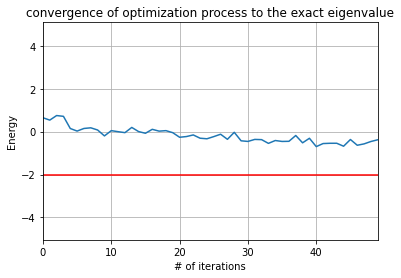

In [281]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [282]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

4it [00:00, 15.65it/s]

{'0000': 136, '0010': 7, '1011': 45, '1110': 78, '0101': 91, '0100': 266, '0110': 88, '0011': 17, '1101': 44, '1100': 57, '1010': 31, '1111': 53, '1000': 53, '0001': 20, '0111': 31, '1001': 7}
1.0
{'0000': 89, '1011': 60, '1001': 15, '0001': 86, '0100': 272, '1111': 104, '0101': 73, '0111': 97, '1010': 12, '1100': 94, '1000': 43, '1110': 41, '1101': 4, '0011': 25, '0010': 4, '0110': 5}
1.0
{'1101': 34, '0100': 255, '0110': 83, '1111': 76, '1100': 9, '0010': 68, '0101': 77, '1110': 131, '0000': 79, '1000': 45, '1001': 19, '1011': 27, '1010': 44, '0111': 47, '0001': 28, '0011': 2}
1.0
{'0100': 271, '0101': 102, '1110': 94, '1000': 41, '0000': 142, '0111': 24, '0110': 83, '1111': 50, '0011': 19, '1100': 46, '1101': 46, '1011': 29, '0001': 23, '1010': 36, '1001': 6, '0010': 12}
1.0


6it [00:00, 15.80it/s]

{'1000': 68, '0000': 357, '1001': 47, '1010': 130, '0001': 94, '1011': 76, '0110': 34, '0011': 47, '0101': 21, '0010': 57, '1100': 22, '0100': 47, '0111': 8, '1111': 2, '1101': 9, '1110': 5}
1.0
{'0000': 144, '1000': 47, '1111': 58, '1101': 50, '0100': 235, '1110': 103, '0101': 94, '0111': 38, '1100': 47, '1010': 44, '0011': 19, '0001': 22, '1011': 37, '1001': 6, '0110': 73, '0010': 7}
1.0
{'0110': 75, '1111': 63, '0100': 279, '0000': 151, '1000': 65, '0010': 12, '1100': 40, '1010': 38, '1110': 79, '1011': 31, '0011': 20, '1101': 34, '0101': 89, '0111': 20, '0001': 22, '1001': 6}
1.0


10it [00:00, 12.27it/s]

{'0000': 30, '1000': 163, '1100': 264, '0100': 57, '1101': 65, '1001': 9, '1010': 27, '1111': 71, '0110': 130, '0101': 79, '1011': 41, '1110': 25, '0001': 18, '0111': 29, '0010': 8, '0011': 8}
1.0
{'1110': 93, '0101': 88, '0110': 82, '1111': 66, '0100': 264, '0111': 33, '1100': 64, '0000': 141, '0001': 20, '1010': 33, '1101': 36, '1000': 45, '0011': 11, '0010': 9, '1011': 27, '1001': 12}
1.0
{'1101': 40, '0100': 261, '1100': 44, '0000': 123, '0110': 75, '1111': 77, '1110': 79, '0101': 110, '0111': 31, '0010': 6, '1000': 50, '1010': 49, '0011': 13, '1011': 34, '1001': 11, '0001': 21}
1.0


11it [00:00, 13.34it/s]


{'1101': 51, '0100': 271, '0010': 5, '0000': 140, '1010': 54, '1111': 54, '1100': 48, '1110': 74, '0110': 69, '0101': 99, '0111': 44, '0001': 24, '1011': 26, '1000': 50, '0011': 10, '1001': 5}
1.0


2it [00:00, 15.44it/s]

{'0100': 190, '1101': 63, '1000': 34, '1010': 61, '1011': 49, '0010': 37, '0111': 40, '0011': 50, '0001': 111, '0110': 29, '1100': 34, '0000': 73, '0101': 133, '1110': 57, '1111': 60, '1001': 3}
1.0
{'0001': 159, '1111': 25, '0110': 6, '0111': 43, '0010': 6, '1011': 135, '0100': 328, '1110': 78, '0011': 53, '1100': 121, '0101': 22, '0000': 12, '1001': 10, '1010': 6, '1000': 17, '1101': 3}
1.0
{'1111': 93, '0110': 75, '0111': 146, '0011': 5, '1110': 94, '0100': 179, '1001': 52, '0001': 145, '0000': 66, '1000': 45, '1010': 35, '0101': 23, '1011': 16, '0010': 32, '1101': 18}
1.0


4it [00:00, 14.37it/s]

{'1110': 57, '1101': 52, '0100': 214, '1100': 46, '1010': 58, '0001': 79, '0000': 67, '1111': 65, '0111': 39, '0101': 154, '0011': 58, '1011': 69, '0110': 17, '0010': 17, '1000': 28, '1001': 4}
1.0
{'1000': 57, '0000': 225, '0101': 83, '1110': 33, '1011': 67, '1010': 85, '1001': 54, '0111': 50, '0010': 24, '0110': 21, '0001': 151, '1111': 54, '1101': 25, '0100': 62, '0011': 24, '1100': 9}
1.0


6it [00:00, 12.03it/s]

{'1110': 51, '0101': 144, '1101': 62, '0000': 69, '1100': 33, '0011': 50, '1010': 71, '1011': 58, '0100': 215, '0001': 105, '1111': 53, '0110': 30, '1000': 19, '0010': 29, '1001': 5, '0111': 30}
1.0


8it [00:00, 11.87it/s]

{'0101': 122, '0000': 74, '1000': 20, '0011': 42, '1100': 46, '0100': 232, '1111': 47, '1010': 75, '0111': 28, '1011': 72, '1110': 54, '0001': 96, '0010': 27, '1101': 58, '0110': 23, '1001': 8}
1.0
{'1100': 212, '1001': 54, '1010': 97, '0110': 70, '1111': 41, '0100': 56, '1101': 126, '1011': 80, '0001': 62, '1000': 79, '0010': 9, '0101': 63, '0111': 41, '0011': 27, '1110': 3, '0000': 4}
1.0
{'1010': 65, '0001': 104, '1011': 71, '1101': 62, '0100': 210, '0101': 133, '0011': 50, '0000': 65, '1000': 22, '1110': 68, '1111': 53, '1100': 36, '0111': 32, '0110': 23, '0010': 23, '1001': 7}
1.0


11it [00:00, 13.04it/s]


{'1010': 51, '0001': 97, '0111': 25, '1110': 69, '0101': 138, '1111': 56, '1100': 34, '1101': 64, '0000': 82, '0100': 214, '1000': 27, '0011': 44, '0110': 22, '1011': 69, '0010': 25, '1001': 7}
1.0
{'0011': 51, '1100': 45, '1010': 67, '0101': 146, '1110': 55, '1011': 63, '0010': 17, '0100': 215, '0001': 95, '1111': 60, '1000': 21, '0000': 77, '1101': 54, '0110': 21, '0111': 35, '1001': 2}
1.0


0it [00:00, ?it/s]

{'1000': 12, '0100': 195, '1110': 77, '1010': 42, '0001': 102, '0110': 8, '1100': 63, '1011': 100, '1001': 10, '0111': 29, '0101': 152, '1101': 49, '0000': 74, '0011': 49, '1111': 28, '0010': 34}
1.0


2it [00:00, 18.10it/s]

{'1111': 21, '1011': 146, '1101': 7, '0100': 330, '0101': 7, '1110': 95, '0001': 166, '0011': 74, '1100': 115, '0111': 34, '1000': 11, '1010': 1, '1001': 4, '0110': 10, '0000': 3}
1.0
{'0000': 85, '1000': 15, '0110': 59, '1111': 96, '1011': 63, '0001': 150, '1110': 128, '0101': 72, '0111': 128, '0100': 135, '0011': 14, '1010': 36, '1100': 7, '0010': 3, '1001': 33}
1.0


4it [00:00, 14.82it/s]

{'0100': 213, '1010': 48, '0001': 86, '1011': 85, '0010': 38, '1000': 14, '1110': 70, '1100': 40, '1111': 46, '0101': 155, '0011': 49, '0000': 59, '0111': 24, '1101': 84, '0110': 8, '1001': 5}
1.0
{'0001': 193, '1001': 47, '1010': 137, '1111': 106, '0100': 143, '0011': 69, '0101': 47, '1000': 40, '1011': 8, '0110': 25, '0000': 123, '1101': 40, '1100': 11, '0111': 12, '0010': 15, '1110': 8}
1.0


6it [00:00, 12.24it/s]

{'1101': 56, '0100': 190, '0101': 173, '1110': 90, '0111': 22, '1010': 55, '0001': 111, '0000': 60, '1011': 105, '1000': 12, '0110': 15, '1100': 37, '1111': 27, '0011': 44, '0010': 27}
1.0


8it [00:00, 13.48it/s]

{'0100': 203, '1011': 94, '1110': 75, '0101': 146, '0011': 51, '1100': 46, '0001': 111, '0000': 69, '1010': 50, '0111': 25, '1101': 73, '1111': 37, '0110': 15, '1001': 6, '0010': 17, '1000': 6}
1.0
{'0010': 62, '0110': 79, '1101': 159, '0100': 37, '0101': 73, '0011': 102, '1100': 216, '1000': 56, '1011': 33, '1010': 18, '0001': 70, '1001': 36, '1111': 56, '1110': 20, '0000': 6, '0111': 1}
1.0
{'0101': 143, '0100': 208, '1101': 75, '1011': 83, '1111': 46, '0001': 93, '0011': 50, '1100': 58, '0000': 56, '0010': 29, '1110': 82, '1010': 49, '1000': 13, '0111': 25, '0110': 11, '1001': 3}
1.0


10it [00:00, 14.33it/s]

{'1111': 36, '0100': 204, '1100': 39, '0011': 54, '0000': 73, '0101': 147, '1110': 95, '1011': 76, '0110': 9, '1101': 59, '0111': 28, '0010': 35, '1010': 40, '0001': 116, '1000': 9, '1001': 4}
1.0


11it [00:00, 14.27it/s]


{'1101': 61, '0100': 190, '0101': 170, '0111': 30, '0000': 77, '0001': 111, '1011': 88, '0110': 7, '1100': 36, '1010': 55, '0011': 43, '1110': 83, '0010': 23, '1111': 37, '1000': 9, '1001': 4}
1.0


0it [00:00, ?it/s]

{'1110': 102, '0101': 155, '1111': 60, '0110': 60, '0111': 78, '1011': 75, '0000': 20, '1010': 115, '0100': 93, '1101': 55, '1100': 32, '0010': 35, '0011': 75, '1000': 22, '0001': 43, '1001': 4}
1.0
{'0100': 226, '0000': 22, '1000': 16, '0011': 118, '1100': 74, '0111': 54, '0001': 50, '1110': 119, '1011': 167, '0110': 84, '1111': 39, '1101': 8, '1010': 15, '1001': 10, '0010': 12, '0101': 10}

2it [00:00, 16.53it/s]


1.0
{'0100': 69, '1000': 47, '1011': 34, '0111': 199, '0001': 148, '1001': 36, '0110': 102, '1111': 97, '1100': 22, '1010': 77, '0000': 63, '1110': 85, '1101': 25, '0101': 14, '0010': 4, '0011': 2}
1.0


4it [00:00, 10.57it/s]

{'1111': 67, '0110': 62, '0001': 59, '1010': 109, '0011': 88, '1110': 92, '0111': 66, '0010': 33, '1000': 30, '0101': 150, '1101': 44, '0000': 21, '0100': 91, '1011': 68, '1100': 42, '1001': 2}
1.0
{'1010': 123, '0001': 184, '0000': 76, '1011': 65, '0010': 90, '0101': 46, '0011': 71, '0111': 87, '0100': 37, '1000': 55, '1001': 34, '1110': 82, '1100': 12, '1101': 14, '0110': 3, '1111': 45}
1.0


6it [00:00, 12.37it/s]

{'1100': 43, '1110': 91, '0101': 159, '1010': 126, '0001': 53, '1101': 47, '0100': 95, '0110': 58, '0000': 19, '1000': 28, '0111': 80, '0011': 64, '1011': 64, '1111': 56, '0010': 38, '1001': 3}
1.0
{'0110': 64, '0100': 89, '1101': 51, '0111': 70, '0101': 152, '1110': 113, '1100': 36, '0001': 45, '1111': 85, '1010': 104, '0011': 78, '0000': 26, '1011': 63, '0010': 20, '1000': 23, '1001': 5}
1.0


8it [00:00, 13.09it/s]

{'1010': 111, '1100': 110, '0011': 29, '0111': 53, '0010': 25, '1011': 143, '1101': 165, '0000': 6, '1000': 33, '1111': 93, '1110': 56, '0100': 12, '0110': 93, '0001': 38, '0101': 44, '1001': 13}
1.0
{'0111': 67, '0101': 155, '1100': 29, '0011': 82, '1011': 55, '0110': 61, '1010': 107, '1101': 38, '1110': 104, '0001': 69, '0010': 36, '0100': 93, '1111': 89, '0000': 20, '1000': 14, '1001': 5}
1.0


10it [00:00, 13.77it/s]

{'0101': 144, '0010': 38, '1011': 78, '1100': 40, '0001': 50, '1111': 72, '0110': 61, '0100': 98, '0111': 76, '0000': 21, '1110': 109, '1101': 49, '1010': 102, '1001': 2, '1000': 19, '0011': 65}
1.0


11it [00:00, 12.13it/s]


{'1110': 89, '0101': 153, '0001': 53, '1010': 92, '0011': 75, '0110': 63, '1111': 76, '1101': 56, '0100': 111, '1100': 34, '0111': 67, '0010': 33, '1011': 78, '1000': 21, '1001': 2, '0000': 21}
1.0


1it [00:00,  8.55it/s]

{'0111': 107, '1010': 83, '0001': 71, '1100': 114, '1011': 69, '0010': 29, '1000': 64, '0101': 114, '0110': 110, '0011': 79, '1110': 21, '1101': 70, '1111': 40, '0100': 33, '1001': 13, '0000': 7}
1.0
{'1001': 65, '1010': 5, '0001': 47, '1100': 183, '0111': 89, '1011': 148, '1000': 12, '0100': 113, '0110': 141, '1110': 58, '0101': 31, '0011': 87, '0010': 16, '1111': 9, '0000': 15, '1101': 5}
1.0


3it [00:00, 12.69it/s]

{'1000': 83, '1111': 81, '1001': 56, '0001': 102, '0111': 205, '0100': 98, '1110': 137, '1011': 24, '1100': 33, '1101': 30, '0110': 62, '0000': 28, '0011': 18, '1010': 57, '0010': 8, '0101': 2}
1.0
{'1000': 50, '0101': 106, '0001': 65, '1010': 76, '1100': 129, '0011': 65, '0110': 142, '0111': 87, '1101': 88, '1111': 42, '0000': 8, '0100': 34, '0010': 28, '1001': 19, '1011': 57, '1110': 28}
1.0


5it [00:00, 14.38it/s]

{'0100': 20, '1010': 72, '0001': 172, '0011': 77, '0111': 94, '0110': 57, '1000': 152, '1110': 51, '1100': 35, '1011': 69, '1111': 28, '1101': 39, '0010': 103, '0101': 10, '1001': 31, '0000': 14}
1.0


7it [00:00, 15.05it/s]

{'0001': 66, '1010': 82, '0101': 102, '1000': 61, '0110': 136, '1101': 79, '0011': 68, '0010': 40, '1100': 130, '1011': 64, '0111': 81, '1110': 19, '1111': 43, '0100': 28, '0000': 9, '1001': 16}
1.0
{'0101': 115, '1110': 22, '1111': 37, '0110': 130, '1011': 67, '0010': 31, '1101': 76, '1010': 95, '0001': 74, '1100': 104, '1000': 51, '0011': 53, '0111': 93, '0000': 9, '1001': 20, '0100': 47}
1.0
{'1110': 49, '0101': 24, '0110': 125, '1111': 64, '0000': 23, '1100': 129, '1011': 78, '1101': 153, '0111': 61, '1010': 47, '0010': 84, '0001': 12, '0011': 31, '1000': 51, '0100': 16, '1001': 77}
1.0


11it [00:00, 12.70it/s]


{'1011': 64, '1010': 90, '0001': 73, '0111': 103, '1100': 120, '0011': 50, '1000': 58, '0100': 32, '0110': 136, '1101': 79, '1111': 50, '0101': 101, '1110': 17, '1001': 15, '0010': 30, '0000': 6}
1.0
{'1000': 56, '0101': 120, '1110': 26, '1011': 61, '1100': 127, '1010': 93, '0001': 62, '0111': 75, '1001': 19, '1101': 74, '0010': 33, '0110': 139, '0100': 29, '0011': 65, '1111': 39, '0000': 6}
1.0
{'0001': 63, '0101': 108, '1000': 48, '1011': 57, '0110': 126, '1100': 135, '0011': 72, '0111': 94, '1101': 89, '1010': 76, '1110': 30, '0100': 43, '1111': 38, '1001': 9, '0010': 34, '0000': 2}
1.0


3it [00:00,  8.82it/s]

{'0111': 132, '1001': 62, '0100': 34, '0110': 82, '1111': 87, '0011': 18, '1100': 105, '1000': 64, '1010': 122, '0010': 55, '0101': 100, '0001': 82, '1101': 63, '1011': 16, '0000': 2}
1.0
{'0111': 185, '0000': 42, '0110': 61, '0100': 86, '0001': 21, '1001': 36, '1100': 163, '1011': 93, '1110': 56, '1000': 69, '1111': 36, '0101': 35, '0010': 57, '0011': 29, '1101': 27, '1010': 28}
1.0
{'0100': 133, '1001': 45, '1010': 127, '0000': 25, '0101': 34, '1111': 137, '0111': 187, '0011': 13, '0001': 91, '1101': 23, '1110': 47, '1100': 49, '1000': 45, '0110': 24, '0010': 26, '1011': 18}
1.0
{'1010': 109, '1111': 92, '0110': 93, '0011': 27, '1100': 125, '1011': 14, '1101': 60, '0111': 129, '0100': 38, '0010': 57, '1001': 48, '0101': 80, '0001': 91, '1000': 59, '0000': 1, '1110': 1}
1.0


7it [00:00, 10.84it/s]

{'1000': 159, '1010': 50, '1001': 68, '0001': 186, '1110': 58, '0100': 15, '1011': 36, '0010': 125, '0000': 22, '1101': 37, '1100': 31, '0111': 127, '0011': 35, '1111': 68, '0110': 7}
1.0
{'0100': 38, '1101': 66, '0110': 95, '1111': 106, '1100': 109, '0101': 102, '1000': 75, '0001': 79, '0111': 130, '1010': 102, '0011': 16, '1001': 42, '0010': 49, '1011': 14, '0000': 1}
1.0
{'1111': 88, '0110': 113, '0011': 28, '1100': 126, '1011': 13, '0111': 136, '1101': 73, '0001': 78, '0100': 35, '1001': 30, '1010': 113, '0101': 75, '1000': 62, '0010': 49, '0000': 5}
1.0


9it [00:00, 11.08it/s]

{'0110': 56, '1111': 136, '1101': 95, '0111': 87, '0010': 131, '1001': 132, '1000': 29, '0011': 3, '1011': 44, '1010': 39, '0101': 45, '1100': 141, '0000': 30, '0100': 15, '1110': 37, '0001': 4}
1.0
{'1100': 116, '1111': 84, '0101': 90, '1101': 62, '0010': 48, '1001': 47, '1010': 111, '1000': 60, '0001': 97, '0111': 149, '0011': 25, '0110': 84, '1011': 15, '0100': 33, '0000': 3}
1.0
{'0001': 93, '0101': 108, '0111': 117, '0110': 120, '1111': 86, '0010': 51, '0011': 22, '1100': 115, '1000': 55, '1001': 46, '1010': 104, '1101': 62, '0100': 27, '1011': 16, '0000': 2}
1.0
{'1000': 69, '1100': 91, '0001': 91, '1010': 127, '1101': 60, '0110': 103, '0101': 91, '0111': 130, '1111': 94, '0010': 48, '0011': 26, '1001': 47, '0100': 31, '1011': 11, '0000': 4, '1110': 1}
1.0


11it [00:01, 11.00it/s]
4it [00:00, 18.17it/s]

{'0101': 108, '0111': 90, '1011': 62, '1010': 81, '1101': 88, '1111': 39, '0110': 160, '1100': 113, '0011': 66, '0010': 28, '1110': 22, '0001': 56, '0000': 6, '0100': 42, '1000': 46, '1001': 17}
1.0
{'0110': 117, '1011': 173, '1001': 56, '0001': 65, '0111': 96, '1100': 204, '0011': 69, '0100': 104, '0000': 19, '0101': 31, '1111': 5, '1110': 49, '0010': 18, '1000': 9, '1101': 6, '1010': 3}
1.0
{'0111': 196, '1000': 86, '0000': 14, '1010': 74, '1001': 63, '1111': 89, '0100': 98, '1110': 109, '1011': 21, '0011': 9, '0001': 120, '0110': 56, '1101': 38, '1100': 33, '0010': 13, '0101': 5}
1.0
{'0101': 115, '0110': 130, '1100': 140, '0011': 63, '1010': 101, '1000': 47, '0111': 79, '1101': 75, '1111': 38, '0010': 38, '1011': 66, '0100': 35, '0001': 60, '1110': 23, '1001': 12, '0000': 2}
1.0


6it [00:00, 12.63it/s]

{'1000': 150, '0010': 127, '1011': 69, '1110': 38, '0111': 83, '1101': 49, '0100': 23, '1010': 65, '0101': 17, '0001': 159, '0011': 64, '0000': 14, '1111': 37, '0110': 41, '1001': 48, '1100': 40}
1.0
{'1011': 69, '1010': 90, '0111': 87, '1110': 24, '0101': 135, '1111': 41, '0110': 141, '1100': 106, '0001': 64, '0011': 71, '0010': 35, '1101': 69, '1000': 45, '0100': 32, '1001': 11, '0000': 4}
1.0


8it [00:00, 11.35it/s]

{'0001': 65, '1010': 97, '1100': 121, '1011': 52, '0010': 39, '1101': 84, '0110': 151, '0111': 79, '0011': 73, '0100': 32, '0101': 108, '1111': 38, '1001': 11, '1000': 48, '1110': 23, '0000': 3}
1.0
{'1101': 135, '1010': 38, '0001': 15, '1111': 71, '1100': 128, '0111': 61, '0101': 33, '1011': 96, '0110': 138, '0010': 81, '1001': 82, '0011': 42, '1110': 39, '0000': 17, '0100': 17, '1000': 31}
1.0
{'0011': 69, '1100': 127, '0001': 77, '1010': 77, '0111': 90, '1011': 64, '0010': 26, '1111': 38, '1101': 82, '0110': 134, '0101': 115, '0100': 36, '1000': 42, '0000': 6, '1001': 18, '1110': 23}
1.0


11it [00:00, 12.66it/s]


{'0011': 77, '1100': 126, '0101': 106, '1011': 58, '0110': 132, '1000': 57, '0001': 84, '1101': 70, '1010': 94, '0111': 75, '1001': 15, '0100': 44, '1111': 31, '1110': 22, '0010': 25, '0000': 8}
1.0
{'1100': 102, '0011': 75, '1000': 53, '0110': 132, '1101': 72, '1010': 103, '0101': 107, '0111': 76, '0100': 26, '1111': 48, '1011': 62, '0010': 39, '0001': 74, '1110': 26, '0000': 8, '1001': 21}
1.0


2it [00:00, 15.94it/s]

{'1011': 129, '0010': 48, '1100': 155, '0011': 44, '1101': 105, '1110': 63, '0101': 33, '0111': 36, '1000': 74, '1010': 186, '0110': 41, '1111': 91, '0000': 8, '0100': 7, '1001': 3, '0001': 1}
1.0
{'0010': 12, '1011': 279, '0101': 7, '1110': 124, '1001': 61, '0011': 74, '1100': 270, '0110': 59, '1000': 26, '0100': 39, '0111': 25, '1101': 8, '1111': 15, '0000': 9, '1010': 15, '0001': 1}
1.0
{'1110': 215, '1111': 145, '0110': 61, '0010': 25, '1100': 32, '0111': 75, '1000': 114, '0001': 20, '1010': 115, '1011': 51, '0101': 7, '0011': 13, '1001': 69, '0100': 4, '1101': 59, '0000': 19}
1.0


4it [00:00,  9.59it/s]

{'1011': 122, '0010': 51, '1110': 67, '1111': 92, '1010': 134, '1101': 124, '1000': 75, '1100': 169, '0101': 34, '0110': 41, '0100': 16, '0011': 39, '0001': 5, '1001': 13, '0111': 36, '0000': 6}
1.0


6it [00:00, 10.63it/s]

{'0010': 69, '1011': 112, '1000': 188, '1100': 55, '1110': 93, '0001': 38, '1010': 118, '1101': 77, '1001': 56, '0011': 42, '0000': 19, '1111': 88, '0110': 31, '0101': 7, '0111': 31}
1.0
{'0011': 36, '1100': 187, '1001': 4, '1010': 160, '1011': 121, '1101': 126, '1111': 88, '1000': 64, '0111': 44, '0010': 48, '1110': 58, '0100': 13, '0101': 30, '0110': 43, '0001': 2}
1.0
{'1010': 183, '0101': 31, '1110': 66, '0010': 38, '1011': 124, '1101': 117, '1000': 79, '0111': 37, '1111': 76, '0000': 4, '0110': 55, '1100': 166, '0100': 9, '0011': 31, '1001': 7, '0001': 1}
1.0


10it [00:00, 12.87it/s]

{'0100': 79, '0000': 60, '0010': 141, '1111': 61, '1001': 10, '0011': 61, '1100': 95, '0101': 48, '1010': 76, '1000': 24, '1011': 78, '1101': 116, '0110': 92, '0111': 49, '0001': 2, '1110': 32}
1.0
{'1000': 92, '1110': 71, '0101': 36, '1101': 111, '0110': 41, '1010': 159, '1011': 117, '1100': 180, '1111': 79, '0111': 47, '0010': 34, '1001': 5, '0000': 6, '0011': 35, '0100': 11}
1.0
{'1010': 166, '1110': 72, '1011': 130, '0010': 43, '0110': 40, '0111': 46, '1101': 95, '1000': 71, '1100': 199, '1111': 71, '0101': 32, '0011': 35, '0100': 8, '1001': 8, '0000': 5, '0001': 3}
1.0


11it [00:00, 12.07it/s]


{'0110': 46, '1111': 92, '1110': 68, '0111': 43, '1011': 118, '1010': 152, '1000': 70, '1100': 184, '1101': 103, '0010': 42, '0011': 41, '0101': 43, '0100': 7, '0000': 9, '0001': 2, '1001': 4}
1.0


1it [00:00,  7.62it/s]

{'1101': 129, '1100': 139, '0011': 48, '0001': 5, '1110': 37, '0000': 15, '0110': 69, '1011': 95, '1111': 83, '0010': 78, '1010': 119, '0101': 56, '0111': 59, '1000': 62, '0100': 21, '1001': 9}
1.0


3it [00:00, 10.81it/s]

{'0011': 143, '1100': 275, '0010': 12, '1011': 190, '1101': 3, '1001': 44, '1110': 104, '0111': 36, '1111': 21, '0110': 93, '1000': 21, '0100': 50, '0001': 7, '0101': 8, '0000': 12, '1010': 5}
1.0
{'0101': 10, '1110': 166, '0110': 80, '0011': 38, '1100': 32, '1011': 33, '1101': 53, '0000': 30, '0010': 66, '1111': 141, '1010': 85, '0111': 91, '1000': 91, '1001': 74, '0001': 23, '0100': 11}
1.0


5it [00:00, 13.19it/s]

{'1010': 130, '0011': 53, '1100': 134, '1101': 133, '0110': 76, '1011': 113, '0010': 88, '1000': 50, '0000': 15, '1111': 62, '1110': 37, '0101': 43, '0111': 61, '0100': 16, '1001': 7, '0001': 6}
1.0
{'1101': 58, '1111': 71, '1000': 170, '1011': 90, '1010': 118, '0011': 73, '1110': 60, '0111': 69, '1001': 60, '0010': 84, '0110': 53, '0001': 33, '0000': 34, '1100': 40, '0101': 10, '0100': 1}
1.0


7it [00:00, 14.17it/s]

{'1111': 74, '1010': 137, '0011': 61, '0000': 15, '1000': 58, '1110': 57, '1011': 85, '0111': 55, '1101': 114, '1100': 158, '0100': 15, '0010': 76, '0101': 39, '0110': 65, '1001': 15}
1.0
{'0111': 45, '1010': 130, '1110': 57, '1011': 109, '0010': 81, '0011': 55, '1100': 162, '0100': 15, '1111': 73, '0101': 34, '1101': 108, '0001': 2, '0110': 86, '0000': 19, '1000': 44, '1001': 4}
1.0


9it [00:00, 14.10it/s]

{'1011': 77, '0010': 128, '1001': 5, '1010': 80, '1110': 35, '1100': 70, '0011': 83, '1101': 90, '0111': 72, '0101': 67, '0100': 100, '1000': 16, '0110': 92, '0000': 44, '1111': 62, '0001': 3}
1.0
{'1011': 113, '0011': 51, '1100': 148, '1001': 8, '1010': 144, '0100': 22, '1101': 100, '1110': 40, '0110': 63, '1111': 65, '0111': 63, '0101': 51, '0010': 81, '1000': 56, '0000': 17, '0001': 2}
1.0


11it [00:00, 11.81it/s]


{'1101': 112, '1100': 153, '0110': 78, '0010': 54, '1011': 106, '1000': 52, '0001': 6, '0111': 59, '1110': 67, '0100': 16, '0101': 47, '1010': 126, '0011': 52, '1001': 6, '1111': 73, '0000': 17}
1.0
{'0111': 66, '1101': 119, '0011': 59, '1100': 150, '1000': 48, '1010': 128, '1011': 107, '0110': 72, '1110': 51, '0010': 82, '1111': 53, '0100': 28, '0101': 42, '1001': 3, '0000': 11, '0001': 5}
1.0


0it [00:00, ?it/s]

{'1010': 95, '0110': 28, '1111': 85, '1000': 125, '1101': 168, '1100': 143, '1110': 59, '1011': 111, '0011': 37, '0111': 20, '0000': 36, '0101': 77, '0010': 20, '0100': 13, '0001': 4, '1001': 3}
1.0


2it [00:00, 15.04it/s]

{'1100': 282, '0011': 48, '0100': 78, '1000': 41, '1110': 117, '0001': 24, '1001': 96, '1011': 244, '0110': 32, '0111': 13, '1111': 5, '0101': 13, '0000': 18, '1101': 7, '1010': 3, '0010': 3}
1.0
{'1110': 158, '0110': 18, '1111': 233, '1010': 145, '0000': 16, '1000': 95, '0010': 34, '0111': 87, '1011': 83, '0011': 22, '1100': 46, '1001': 50, '0001': 12, '0101': 5, '1101': 19, '0100': 1}
1.0
{'1010': 109, '1011': 131, '1101': 173, '0101': 93, '1100': 103, '0011': 33, '1000': 107, '1111': 103, '0111': 28, '0110': 18, '1110': 51, '0000': 22, '0010': 26, '1001': 12, '0001': 5, '0100': 10}
1.0


6it [00:00, 12.85it/s]

{'0101': 23, '1110': 130, '1000': 246, '0001': 74, '1001': 65, '1101': 120, '0011': 30, '1011': 169, '0010': 15, '0111': 23, '1111': 60, '0110': 18, '0000': 25, '1010': 21, '0100': 5}
1.0
{'0011': 33, '0000': 33, '1000': 125, '0101': 77, '1001': 7, '1010': 113, '0111': 25, '1011': 144, '1111': 84, '1101': 166, '1100': 118, '1110': 43, '0110': 23, '0010': 22, '0100': 7, '0001': 4}
1.0


8it [00:00, 10.13it/s]

{'1101': 162, '0101': 88, '0011': 30, '1100': 111, '1010': 115, '1011': 123, '0110': 21, '0000': 34, '0111': 18, '1111': 99, '1110': 54, '1001': 9, '1000': 113, '0100': 13, '0010': 29, '0001': 5}
1.0
{'1010': 58, '0001': 15, '0101': 88, '1101': 140, '0100': 61, '0010': 89, '1011': 113, '0000': 100, '0110': 75, '0011': 63, '1100': 75, '0111': 49, '1111': 48, '1000': 42, '1110': 8}
1.0
{'1010': 100, '0011': 33, '1111': 81, '0000': 22, '1000': 123, '1110': 56, '0111': 23, '0010': 21, '1100': 133, '1011': 132, '1101': 187, '0110': 15, '0101': 75, '0001': 7, '1001': 3, '0100': 13}
1.0


11it [00:00, 11.72it/s]


{'1101': 165, '1100': 120, '0111': 27, '1010': 124, '1011': 126, '0101': 69, '1000': 136, '1111': 87, '0000': 32, '1110': 54, '0010': 25, '0011': 34, '0001': 5, '0110': 12, '0100': 6, '1001': 2}
1.0
{'0101': 70, '1110': 72, '1101': 157, '1000': 129, '1010': 99, '1011': 123, '1100': 132, '0110': 17, '0011': 23, '0001': 6, '1111': 89, '0111': 20, '0100': 15, '0000': 50, '0010': 18, '1001': 4}
1.0


0it [00:00, ?it/s]

{'0000': 47, '1000': 213, '1111': 54, '0110': 31, '1101': 149, '1010': 172, '0010': 14, '1011': 103, '1110': 81, '0011': 22, '0111': 18, '1100': 45, '0101': 56, '1001': 9, '0001': 10}
1.0


2it [00:00, 13.42it/s]

{'1001': 81, '0001': 7, '1100': 161, '1000': 137, '0100': 22, '1101': 14, '1011': 256, '1110': 136, '0110': 56, '0011': 53, '0000': 53, '0111': 5, '0101': 33, '1111': 7, '0010': 1, '1010': 2}
1.0
{'0100': 20, '1111': 202, '1010': 219, '0111': 67, '0000': 32, '1000': 119, '1011': 68, '1110': 90, '1001': 71, '1100': 18, '0001': 29, '0010': 39, '0011': 13, '0110': 21, '0101': 9, '1101': 7}
1.0


4it [00:00,  9.43it/s]

{'0011': 37, '1100': 36, '0000': 57, '1000': 200, '1010': 152, '0110': 36, '0101': 62, '1101': 135, '1111': 65, '1110': 85, '1011': 109, '0001': 14, '0111': 15, '0010': 19, '1001': 2}
1.0
{'1010': 112, '0001': 67, '1000': 224, '0010': 20, '1011': 76, '1100': 38, '1111': 98, '1110': 114, '1001': 90, '0000': 15, '1101': 59, '0011': 29, '0110': 19, '0111': 25, '0100': 27, '0101': 11}
1.0


6it [00:00, 11.32it/s]

{'1110': 78, '1000': 205, '1010': 156, '1111': 54, '1011': 130, '0011': 24, '1101': 132, '0111': 15, '0110': 30, '0000': 60, '1100': 39, '0101': 70, '0010': 16, '0001': 12, '1001': 3}
1.0
{'1101': 139, '1000': 230, '0000': 34, '1011': 134, '1110': 79, '0101': 57, '0111': 7, '1010': 159, '0110': 42, '1111': 42, '0010': 21, '0011': 33, '1100': 35, '0001': 6, '1001': 6}
1.0


8it [00:00, 12.69it/s]

{'1000': 110, '0000': 166, '0110': 86, '1001': 13, '1011': 85, '1101': 138, '0100': 20, '0011': 67, '0010': 97, '0111': 24, '0101': 77, '1010': 46, '1111': 38, '1100': 23, '1110': 23, '0001': 11}
1.0
{'0110': 24, '1101': 138, '1000': 241, '1010': 128, '1011': 111, '0101': 70, '0011': 32, '0111': 25, '1111': 51, '1110': 80, '0010': 23, '0000': 42, '1100': 43, '1001': 7, '0001': 9}
1.0


10it [00:00, 13.51it/s]

{'1100': 26, '1010': 124, '1101': 146, '1011': 135, '0010': 14, '1000': 223, '1110': 101, '0111': 11, '0000': 47, '1001': 7, '0101': 62, '0110': 36, '0011': 33, '1111': 46, '0001': 13}
1.0


11it [00:00, 12.57it/s]


{'1010': 143, '1101': 150, '1100': 51, '0011': 31, '1000': 230, '1111': 39, '0101': 72, '0111': 13, '0000': 50, '1011': 110, '1110': 73, '0110': 33, '0100': 1, '0010': 11, '0001': 13, '1001': 4}
1.0


1it [00:00,  9.22it/s]

{'0010': 100, '0011': 78, '0110': 62, '1111': 81, '1101': 82, '0100': 78, '1010': 108, '0101': 58, '1100': 101, '0111': 69, '0000': 30, '1011': 98, '1000': 37, '1110': 39, '1001': 3}
1.0
{'1101': 5, '0100': 149, '1100': 177, '0011': 183, '0110': 113, '1011': 173, '1110': 76, '1010': 15, '0101': 11, '0111': 18, '1111': 24, '1000': 15, '0001': 15, '0010': 15, '1001': 18, '0000': 17}
1.0


3it [00:00, 14.40it/s]

{'0110': 126, '1111': 124, '0111': 107, '0010': 87, '1011': 28, '0000': 59, '1110': 136, '1100': 5, '0100': 16, '1101': 40, '1000': 70, '1010': 78, '0001': 27, '0011': 44, '1001': 52, '0101': 25}
1.0
{'0101': 65, '0100': 81, '1101': 76, '1111': 58, '0110': 66, '0011': 72, '1010': 121, '0010': 111, '1000': 34, '1011': 104, '0000': 34, '1110': 53, '1100': 90, '0111': 56, '1001': 2, '0001': 1}
1.0


5it [00:00, 14.08it/s]

{'0010': 107, '1011': 82, '1010': 127, '1001': 47, '1101': 43, '0011': 88, '1111': 67, '0000': 89, '1000': 119, '1110': 48, '0101': 34, '0001': 24, '0110': 56, '0111': 65, '1100': 14, '0100': 14}
1.0


7it [00:00, 13.90it/s]

{'1110': 59, '0111': 75, '0011': 72, '1100': 99, '0110': 66, '1111': 65, '1010': 111, '1000': 43, '0100': 79, '0101': 72, '1101': 77, '0010': 103, '0000': 23, '1011': 76, '1001': 4}
1.0
{'0100': 84, '1101': 77, '0010': 129, '0110': 60, '0011': 64, '1100': 80, '1110': 44, '0101': 82, '0000': 29, '1111': 78, '0111': 61, '1000': 36, '1011': 96, '1010': 100, '1001': 4}
1.0
{'1010': 178, '1101': 139, '0110': 22, '0011': 31, '1100': 122, '1011': 121, '0101': 29, '0111': 29, '0000': 21, '1111': 91, '0100': 59, '0010': 51, '1110': 86, '1000': 45}
1.0


9it [00:00, 13.57it/s]

{'1010': 112, '0100': 78, '1011': 102, '0010': 95, '0110': 65, '1100': 88, '0011': 89, '0111': 59, '1101': 86, '0101': 76, '1111': 52, '1000': 33, '1110': 49, '0000': 37, '1001': 2, '0001': 1}
1.0
{'1100': 93, '0011': 67, '0010': 118, '1011': 102, '0100': 77, '1010': 121, '0110': 63, '1111': 72, '1101': 78, '0111': 57, '0101': 72, '1110': 38, '0000': 27, '1000': 36, '1001': 3}
1.0
{'1100': 89, '1010': 108, '1011': 77, '0010': 93, '1111': 72, '1101': 96, '0100': 96, '1000': 35, '1110': 47, '0101': 80, '0011': 71, '0000': 21, '0111': 61, '0110': 74, '1001': 4}


11it [00:00, 13.88it/s]


1.0


0it [00:00, ?it/s]

{'0011': 32, '1100': 217, '1011': 63, '0010': 47, '1010': 193, '1111': 43, '1110': 100, '1000': 110, '0111': 33, '0001': 8, '0110': 39, '0101': 21, '1101': 28, '0100': 21, '0000': 13, '1001': 56}
1.0
{'1001': 186, '0011': 70, '1100': 219, '1101': 44, '1011': 201, '1110': 124, '0110': 52, '0111': 17, '1010': 22, '0010': 13, '0101': 8, '0001': 21, '1111': 10, '0100': 28, '1000': 9}

2it [00:00, 10.58it/s]


1.0
{'1110': 130, '0110': 36, '1010': 223, '1001': 9, '1100': 211, '1011': 99, '1000': 85, '1101': 55, '0010': 55, '0111': 40, '0000': 13, '0011': 18, '1111': 20, '0001': 11, '0100': 15, '0101': 4}
1.0


4it [00:00, 11.49it/s]

{'1000': 122, '1100': 205, '0010': 51, '1101': 42, '0100': 20, '0110': 46, '1110': 101, '1010': 187, '0111': 32, '1011': 57, '1001': 56, '0001': 7, '0101': 16, '0011': 25, '1111': 43, '0000': 14}
1.0


6it [00:00, 13.49it/s]

{'1110': 207, '0011': 37, '1100': 63, '1000': 305, '1001': 2, '0001': 18, '1010': 84, '0010': 50, '1011': 63, '0000': 28, '1101': 73, '0111': 23, '1111': 31, '0110': 29, '0101': 8, '0100': 3}
1.0
{'1110': 107, '1000': 116, '1100': 232, '0111': 28, '1111': 38, '0110': 61, '1010': 152, '1101': 38, '0011': 37, '0000': 19, '0100': 15, '1001': 54, '1011': 48, '0101': 20, '0010': 51, '0001': 8}
1.0
{'1010': 192, '1001': 57, '1100': 211, '1011': 43, '0010': 58, '1000': 125, '0110': 39, '1110': 128, '0111': 32, '0011': 21, '0101': 15, '1111': 39, '0001': 5, '0000': 7, '1101': 35, '0100': 17}
1.0
{'1010': 101, '0100': 131, '1100': 137, '1111': 24, '0110': 114, '0010': 118, '0111': 44, '0000': 91, '1000': 49, '1011': 36, '0011': 35, '1110': 38, '1101': 45, '0001': 51, '1001': 6, '0101': 4}
1.0


10it [00:00, 13.87it/s]

{'0101': 16, '1110': 127, '1000': 125, '1010': 158, '0011': 38, '1100': 238, '1101': 38, '1011': 49, '0010': 48, '0110': 33, '0111': 19, '0000': 19, '1111': 40, '0100': 13, '1001': 56, '0001': 7}
1.0
{'1010': 193, '1110': 112, '0101': 18, '1000': 113, '1100': 244, '1011': 44, '0110': 37, '0111': 26, '0010': 48, '1001': 46, '1111': 46, '0100': 15, '1101': 29, '0000': 20, '0001': 7, '0011': 26}
1.0
{'1100': 223, '1111': 47, '1110': 128, '1010': 166, '1001': 60, '1000': 124, '1011': 34, '0010': 48, '1101': 44, '0111': 28, '0110': 32, '0001': 9, '0011': 28, '0100': 22, '0101': 11, '0000': 20}

11it [00:00, 12.51it/s]



1.0


2it [00:00, 14.71it/s]

{'0101': 40, '1110': 173, '0011': 73, '1100': 124, '1011': 186, '1001': 13, '1101': 101, '1000': 110, '0110': 79, '1010': 81, '1111': 4, '0010': 11, '0100': 6, '0000': 7, '0001': 7, '0111': 9}
1.0
{'0000': 18, '1000': 91, '1111': 70, '0110': 70, '0011': 60, '1100': 252, '1110': 121, '1101': 9, '1011': 214, '1001': 38, '0111': 25, '0100': 34, '1010': 14, '0010': 5, '0101': 3}
1.0
{'1100': 23, '0011': 32, '1000': 100, '1001': 68, '1010': 100, '0001': 39, '1110': 276, '1011': 106, '1111': 83, '0101': 16, '0100': 21, '0111': 31, '1101': 62, '0000': 9, '0110': 51, '0010': 7}
1.0
{'0011': 63, '1100': 111, '1011': 168, '1101': 126, '1010': 74, '1110': 179, '1000': 133, '0110': 78, '0000': 8, '0010': 14, '0101': 41, '0001': 11, '1111': 3, '1001': 7, '0111': 4, '0100': 4}
1.0


6it [00:00, 14.37it/s]

{'0011': 46, '1100': 54, '1001': 56, '1010': 167, '1000': 202, '1111': 85, '1110': 87, '1011': 73, '1101': 86, '0010': 50, '0110': 49, '0111': 24, '0001': 27, '0100': 4, '0000': 12, '0101': 2}
1.0
{'1101': 115, '0011': 66, '1100': 138, '1011': 162, '1001': 7, '1010': 76, '1000': 127, '1110': 178, '0110': 79, '0101': 22, '0010': 12, '0000': 13, '0111': 11, '0001': 8, '0100': 6, '1111': 4}
1.0
{'1101': 138, '1011': 157, '0011': 52, '1100': 123, '1110': 182, '1010': 78, '0110': 86, '1000': 124, '0010': 18, '0111': 6, '0101': 32, '0001': 12, '0000': 6, '0100': 7, '1001': 3}
1.0


8it [00:00, 11.71it/s]

{'0001': 14, '0011': 106, '1100': 61, '0100': 69, '0110': 141, '0000': 80, '1110': 104, '0010': 45, '1101': 125, '0101': 56, '1011': 116, '1000': 50, '1010': 48, '1111': 8, '1001': 1}
1.0


10it [00:00, 12.36it/s]

{'1101': 109, '1011': 184, '0010': 15, '0110': 77, '1000': 115, '1010': 77, '1110': 183, '1100': 141, '0011': 62, '0000': 15, '0101': 30, '0100': 5, '1001': 2, '0111': 5, '0001': 3, '1111': 1}
1.0
{'1011': 154, '1101': 141, '0011': 60, '1110': 176, '1000': 128, '1010': 71, '1001': 5, '0110': 81, '1100': 140, '0010': 12, '0100': 11, '0101': 22, '0000': 7, '1111': 3, '0001': 9, '0111': 4}
1.0


11it [00:00, 13.09it/s]


{'0110': 102, '0111': 8, '1101': 123, '1011': 173, '1110': 158, '1100': 128, '0000': 19, '1000': 129, '1010': 69, '0011': 60, '0010': 9, '0101': 22, '0100': 4, '1001': 6, '1111': 4, '0001': 10}
1.0


0it [00:00, ?it/s]

{'1011': 145, '0010': 20, '0110': 38, '1010': 107, '1110': 117, '0000': 45, '1100': 139, '1101': 152, '1111': 30, '1000': 129, '0101': 59, '0111': 9, '0011': 29, '0100': 4, '0001': 1}
1.0


4it [00:00, 15.63it/s]

{'0100': 71, '1100': 287, '1011': 261, '1001': 63, '0000': 22, '1000': 65, '1110': 107, '1111': 16, '0011': 51, '1101': 2, '0010': 7, '0110': 31, '0101': 11, '0001': 16, '0111': 14}
1.0
{'1010': 172, '1001': 56, '1000': 89, '1111': 172, '0110': 29, '1011': 69, '1101': 29, '1110': 226, '0011': 24, '0001': 22, '0111': 62, '1100': 10, '0010': 32, '0101': 9, '0000': 14, '0100': 9}
1.0
{'1100': 132, '0011': 38, '1011': 119, '0111': 7, '0000': 42, '1000': 150, '1111': 26, '1010': 110, '0101': 64, '1110': 117, '0110': 52, '1101': 139, '0010': 16, '0100': 9, '0001': 3}
1.0


8it [00:00, 12.12it/s]

{'0011': 33, '0000': 16, '1000': 274, '1111': 56, '0110': 24, '1101': 75, '1110': 136, '1011': 107, '1010': 78, '0001': 51, '1001': 77, '0010': 39, '0100': 19, '0111': 17, '0101': 22}
1.0
{'1011': 121, '0101': 79, '1000': 141, '1100': 143, '1010': 112, '1101': 158, '0110': 27, '1111': 30, '0011': 37, '1110': 100, '0000': 36, '0010': 18, '0100': 7, '0111': 12, '0001': 3}
1.0
{'1011': 125, '1000': 134, '0000': 25, '1101': 156, '0101': 67, '1110': 115, '1100': 129, '0110': 46, '0100': 7, '0011': 46, '1010': 127, '0010': 15, '0111': 9, '1111': 22, '0001': 1}
1.0
{'1010': 56, '0101': 69, '0110': 117, '0100': 53, '1101': 147, '0000': 121, '0011': 66, '0010': 73, '0001': 3, '0111': 17, '1000': 55, '1011': 103, '1100': 88, '1111': 18, '1110': 37, '1001': 1}
1.0


11it [00:00, 13.37it/s]


{'1011': 125, '1111': 29, '0110': 36, '1101': 158, '0101': 66, '1110': 115, '1010': 125, '0111': 14, '1100': 131, '0100': 4, '1000': 136, '0011': 32, '0010': 18, '0000': 32, '0001': 3}
1.0
{'1000': 130, '1011': 121, '0010': 22, '1110': 119, '0110': 39, '1111': 28, '1010': 124, '1101': 156, '0101': 48, '0111': 14, '1100': 137, '0011': 39, '0000': 34, '0100': 11, '0001': 2}
1.0
{'0010': 16, '0011': 49, '1100': 145, '1110': 111, '1111': 27, '0110': 48, '1000': 137, '1101': 140, '1011': 125, '1010': 117, '0101': 52, '0000': 38, '0111': 13, '0100': 4, '0001': 2}
1.0


0it [00:00, ?it/s]

{'1101': 94, '0100': 65, '1010': 78, '0001': 38, '0010': 35, '1011': 136, '1100': 136, '1110': 170, '0011': 17, '0110': 59, '1000': 112, '1001': 30, '0000': 47, '0101': 5, '0111': 2}
1.0


2it [00:00, 10.72it/s]

{'0110': 25, '1111': 83, '1000': 117, '0000': 29, '1100': 225, '1110': 84, '1011': 223, '0010': 9, '0011': 50, '0100': 55, '0001': 30, '1010': 6, '0111': 28, '0101': 27, '1001': 21, '1101': 12}
1.0
{'1110': 241, '0010': 50, '1011': 124, '1010': 103, '1001': 35, '1101': 51, '0100': 75, '0000': 22, '1000': 79, '0110': 58, '1100': 73, '1111': 46, '0011': 47, '0001': 13, '0111': 4, '0101': 3}
1.0


4it [00:00,  9.77it/s]

{'1101': 81, '0100': 69, '1000': 107, '1011': 136, '0110': 57, '1110': 156, '1100': 164, '0001': 38, '1010': 85, '0000': 50, '1001': 33, '0011': 18, '0111': 5, '0010': 18, '0101': 5, '1111': 2}
1.0
{'0101': 26, '1110': 103, '1001': 24, '1010': 154, '1111': 55, '0110': 71, '1100': 41, '0100': 17, '1011': 78, '0011': 17, '0000': 114, '1000': 203, '1101': 91, '0001': 12, '0010': 13, '0111': 5}
1.0


6it [00:00, 11.51it/s]

{'1110': 158, '0010': 29, '1011': 144, '0011': 35, '1100': 134, '0100': 74, '1000': 140, '0000': 55, '1010': 67, '1101': 75, '0001': 30, '1001': 20, '0110': 54, '0101': 5, '0111': 3, '1111': 1}
1.0


8it [00:00, 11.87it/s]

{'1010': 68, '1001': 31, '0001': 25, '1110': 182, '1000': 120, '0100': 65, '1101': 79, '0110': 64, '1100': 149, '1011': 125, '0000': 56, '0101': 6, '0010': 27, '0011': 26, '0111': 1}
1.0
{'1011': 93, '1110': 141, '1000': 36, '0000': 140, '0100': 150, '0011': 78, '0110': 69, '0001': 30, '1010': 27, '0010': 73, '1100': 70, '0101': 50, '1001': 35, '1101': 30, '1111': 1, '0111': 1}
1.0


10it [00:00, 10.17it/s]

{'1101': 88, '0010': 32, '1110': 165, '0101': 4, '1000': 104, '0000': 65, '1100': 149, '1010': 84, '0110': 54, '1011': 152, '0111': 5, '1001': 23, '0100': 52, '0001': 26, '0011': 21}
1.0
{'1110': 178, '1000': 121, '1010': 70, '0001': 26, '1011': 150, '1101': 80, '0100': 58, '1100': 155, '0011': 14, '0110': 53, '0010': 26, '0000': 48, '1001': 29, '0101': 5, '0111': 9, '1111': 2}
1.0


11it [00:01, 10.46it/s]


{'1100': 157, '0010': 28, '1011': 140, '1110': 192, '1101': 73, '0000': 51, '0110': 61, '1001': 22, '0011': 24, '1010': 80, '0001': 29, '0100': 57, '1000': 103, '0101': 3, '1111': 1, '0111': 3}
1.0


2it [00:00, 13.42it/s]

{'1011': 103, '0010': 35, '0011': 148, '1100': 58, '1000': 53, '1010': 38, '0110': 187, '0101': 117, '1001': 3, '1110': 106, '0000': 36, '1101': 79, '0100': 34, '0111': 11, '0001': 13, '1111': 3}
1.0
{'0100': 143, '0011': 149, '0110': 119, '1110': 86, '0000': 33, '1000': 52, '0001': 5, '1011': 164, '1111': 32, '1100': 136, '1010': 9, '0111': 58, '1101': 2, '0010': 15, '0101': 6, '1001': 15}
1.0


4it [00:00, 13.45it/s]

{'0101': 37, '1110': 164, '0110': 196, '0000': 38, '1000': 61, '1011': 57, '0001': 85, '0011': 65, '0111': 71, '1001': 44, '0010': 27, '0100': 29, '1111': 51, '1010': 58, '1100': 14, '1101': 27}
1.0
{'0011': 139, '1100': 69, '1011': 107, '0101': 92, '1110': 118, '1010': 33, '1101': 64, '0000': 34, '0110': 192, '1000': 65, '0100': 39, '0001': 12, '0010': 40, '1111': 7, '0111': 11, '1001': 2}
1.0
{'1000': 86, '0001': 92, '1010': 130, '0010': 150, '1011': 66, '1111': 58, '1110': 48, '0111': 78, '1101': 21, '0110': 62, '0011': 73, '1001': 43, '0000': 60, '0101': 30, '1100': 14, '0100': 13}
1.0


6it [00:00, 11.13it/s]

{'0110': 171, '1100': 55, '0011': 145, '1101': 71, '1000': 57, '0000': 48, '1110': 137, '0101': 101, '1010': 48, '0100': 24, '0111': 11, '1011': 106, '0001': 6, '1001': 9, '0010': 33, '1111': 2}
1.0
{'1000': 60, '1100': 62, '0011': 147, '0101': 89, '1110': 116, '0110': 170, '0010': 34, '1011': 117, '1101': 78, '1010': 48, '0000': 37, '1001': 5, '1111': 4, '0100': 42, '0111': 10, '0001': 5}
1.0


8it [00:00, 10.30it/s]

{'1000': 85, '0100': 21, '1101': 161, '1011': 191, '0101': 22, '1110': 215, '0011': 45, '0110': 75, '1100': 89, '1010': 55, '0010': 15, '0000': 23, '0111': 7, '1001': 6, '1111': 8, '0001': 6}
1.0
{'0110': 174, '1110': 97, '0101': 104, '1011': 121, '0011': 140, '0000': 40, '1000': 73, '1010': 51, '1101': 63, '0100': 48, '0010': 30, '1100': 56, '0001': 14, '1001': 3, '0111': 6, '1111': 4}
1.0


10it [00:00, 11.59it/s]

{'0000': 38, '0011': 158, '1100': 63, '1010': 40, '1011': 94, '0110': 184, '1101': 60, '0101': 104, '0010': 28, '1110': 108, '0001': 11, '1000': 78, '0111': 12, '0100': 36, '1001': 6, '1111': 4}
1.0


11it [00:00, 11.67it/s]


{'1011': 102, '1110': 115, '0101': 105, '0011': 150, '1100': 68, '1000': 68, '0111': 11, '0110': 154, '1101': 72, '0000': 29, '1010': 53, '0010': 42, '0001': 15, '0100': 34, '1001': 3, '1111': 3}
1.0


0it [00:00, ?it/s]

{'1111': 74, '0110': 99, '1100': 174, '1110': 151, '0001': 8, '1001': 65, '1000': 77, '1101': 63, '1010': 117, '1011': 88, '0010': 32, '0011': 42, '0100': 4, '0000': 14, '0101': 3, '0111': 13}
1.0


2it [00:00, 14.81it/s]

{'1110': 213, '0110': 99, '0111': 20, '1010': 18, '1001': 92, '0011': 77, '1100': 191, '1011': 198, '1101': 36, '1111': 15, '1000': 32, '0010': 3, '0100': 13, '0000': 9, '0001': 7, '0101': 1}
1.0
{'0011': 24, '1110': 327, '0001': 15, '1010': 152, '1011': 153, '1000': 44, '1111': 121, '0110': 66, '0111': 29, '0010': 36, '0100': 42, '0000': 5, '1100': 3, '1001': 3, '1101': 4}
1.0


4it [00:00, 12.38it/s]

{'1010': 136, '0011': 45, '1100': 154, '0110': 106, '1101': 55, '1011': 104, '0000': 10, '1110': 166, '1000': 70, '0010': 32, '1111': 72, '1001': 50, '0111': 10, '0100': 3, '0101': 10, '0001': 1}
1.0
{'1010': 286, '1111': 152, '1101': 118, '1000': 211, '0111': 45, '1011': 11, '0010': 109, '1100': 26, '0000': 15, '0110': 11, '0011': 7, '0001': 10, '1110': 12, '0101': 11}
1.0
{'1101': 55, '0011': 40, '1100': 165, '1000': 82, '1010': 135, '0110': 90, '1110': 157, '1011': 100, '1001': 59, '0010': 41, '1111': 64, '0101': 8, '0000': 6, '0111': 11, '0100': 9, '0001': 2}
1.0


6it [00:00, 12.94it/s]

{'1011': 81, '0010': 28, '0110': 98, '1110': 173, '1000': 71, '1100': 166, '0011': 40, '1001': 53, '1010': 148, '0111': 10, '1111': 69, '1101': 51, '0000': 21, '0101': 9, '0001': 2, '0100': 4}
1.0


10it [00:00, 13.77it/s]

{'0010': 73, '1011': 79, '1010': 96, '1110': 115, '0101': 21, '0110': 130, '0100': 85, '0011': 78, '1001': 27, '0111': 41, '0000': 60, '1111': 43, '1100': 76, '1101': 35, '0001': 41, '1000': 24}
1.0
{'1011': 105, '0010': 31, '0011': 53, '1100': 167, '1000': 81, '1110': 147, '1101': 45, '0110': 108, '1001': 57, '1111': 79, '1010': 110, '0111': 10, '0000': 22, '0101': 5, '0001': 2, '0100': 2}
1.0
{'1100': 166, '0011': 47, '1110': 150, '0110': 94, '1111': 62, '1000': 84, '1001': 57, '1010': 118, '1011': 120, '0010': 35, '1101': 51, '0000': 11, '0001': 4, '0111': 9, '0101': 14, '0100': 2}
1.0


11it [00:00, 13.52it/s]

{'0011': 48, '1100': 154, '0110': 92, '1111': 63, '1000': 73, '1110': 148, '1010': 134, '1101': 65, '0010': 42, '0101': 9, '1011': 99, '1001': 65, '0111': 12, '0001': 2, '0000': 13, '0100': 5}
1.0



2it [00:00, 18.02it/s]

{'0100': 8, '1101': 86, '1011': 191, '1110': 210, '1100': 135, '0011': 85, '0000': 16, '1000': 171, '1001': 5, '0110': 81, '0101': 19, '1010': 3, '1111': 9, '0111': 2, '0010': 1, '0001': 2}
1.0
{'1010': 71, '1011': 117, '0010': 39, '0110': 67, '0000': 20, '0100': 10, '1110': 130, '1100': 200, '0011': 52, '0111': 47, '1000': 67, '1001': 96, '1111': 87, '0101': 16, '1101': 4, '0001': 1}
1.0
{'1010': 106, '1001': 73, '1110': 316, '0011': 30, '1101': 38, '1011': 131, '1000': 67, '1111': 84, '0001': 51, '0110': 49, '0010': 11, '1100': 6, '0111': 12, '0100': 34, '0000': 11, '0101': 5}
1.0


6it [00:00, 12.70it/s]

{'1101': 98, '1100': 148, '0011': 72, '1011': 179, '1000': 176, '0101': 22, '1110': 193, '0110': 81, '1001': 7, '0000': 21, '0100': 6, '1111': 9, '0001': 3, '1010': 6, '0111': 3}
1.0
{'1000': 309, '1111': 131, '1101': 61, '0100': 11, '1010': 118, '0001': 16, '1110': 76, '0010': 50, '1001': 44, '1011': 65, '0111': 39, '0110': 36, '1100': 20, '0101': 8, '0011': 28, '0000': 12}
1.0
{'1100': 132, '1101': 111, '1011': 188, '1110': 203, '0111': 6, '1000': 176, '1010': 5, '0110': 78, '0011': 73, '1111': 12, '1001': 6, '0000': 14, '0100': 5, '0001': 2, '0101': 13}
1.0
{'0101': 23, '1110': 206, '1011': 177, '1101': 110, '1100': 139, '0000': 19, '1000': 148, '1111': 13, '0110': 86, '0011': 72, '0111': 7, '0100': 6, '0001': 6, '1001': 9, '1010': 3}
1.0


11it [00:00, 14.19it/s]

{'0011': 140, '1111': 12, '0110': 137, '0000': 118, '1101': 85, '0100': 82, '1110': 123, '1011': 153, '1100': 43, '1000': 90, '1010': 3, '0101': 24, '0001': 13, '0010': 1}
1.0
{'0110': 102, '0011': 90, '1100': 128, '1110': 193, '0000': 20, '1000': 170, '1101': 82, '1011': 186, '1111': 8, '1001': 4, '0101': 21, '0001': 6, '0010': 3, '0111': 5, '1010': 1, '0100': 5}
1.0
{'0011': 69, '1100': 142, '0000': 19, '1000': 166, '1110': 195, '0101': 26, '1101': 96, '1011': 207, '1010': 3, '0111': 6, '0110': 71, '0100': 4, '1111': 10, '1001': 7, '0001': 3}
1.0
{'0110': 81, '1101': 85, '0100': 11, '1110': 204, '1100': 157, '0011': 82, '1011': 192, '1000': 144, '1001': 11, '0101': 23, '0111': 3, '0000': 17, '1010': 3, '1111': 7, '0001': 4}
1.0



2it [00:00, 11.56it/s]

{'1011': 171, '1110': 143, '1101': 87, '1100': 84, '0011': 79, '1000': 121, '1010': 54, '0110': 101, '0000': 75, '0001': 28, '1001': 20, '0100': 20, '0010': 10, '0101': 30, '0111': 1}
1.0
{'1111': 73, '0001': 50, '1011': 207, '0000': 43, '1000': 105, '0111': 76, '1101': 14, '1110': 77, '0010': 37, '0100': 45, '1100': 174, '0011': 38, '0110': 35, '1010': 17, '1001': 33}
1.0
{'1001': 62, '0001': 60, '1010': 105, '1000': 101, '1110': 224, '1101': 53, '0100': 63, '0010': 48, '0101': 20, '1011': 102, '0000': 38, '0011': 27, '1111': 37, '0110': 67, '1100': 11, '0111': 6}
1.0


6it [00:00, 13.89it/s]

{'1011': 167, '0110': 121, '1000': 132, '0000': 66, '1100': 98, '1010': 51, '0101': 23, '1110': 117, '0010': 6, '1001': 23, '1101': 109, '0011': 66, '0001': 24, '0100': 19, '0111': 2}
1.0
{'1111': 86, '0011': 44, '1000': 134, '0001': 23, '1010': 179, '1001': 42, '0101': 35, '0010': 89, '0111': 26, '1011': 93, '0100': 55, '0000': 18, '1100': 62, '0110': 34, '1101': 87, '1110': 17}
1.0
{'1011': 175, '1100': 85, '0011': 69, '0000': 67, '1000': 138, '1110': 122, '1101': 106, '1010': 59, '0110': 107, '1001': 18, '0100': 21, '0010': 13, '0111': 2, '0101': 20, '0001': 22}
1.0
{'0000': 71, '1000': 128, '0101': 18, '0110': 114, '1101': 127, '0011': 59, '0001': 16, '1010': 50, '0100': 22, '1100': 92, '1110': 134, '1011': 168, '0010': 4, '1001': 19, '0111': 2}
1.0


11it [00:00, 14.84it/s]


{'1000': 165, '0000': 14, '0101': 86, '1110': 107, '0110': 143, '1100': 27, '0011': 98, '1011': 137, '1010': 45, '0001': 46, '0010': 13, '1101': 35, '0100': 104, '0111': 1, '1001': 3}
1.0
{'0101': 18, '1110': 160, '0000': 54, '1000': 135, '1011': 179, '1100': 88, '1010': 41, '1101': 117, '0011': 58, '0001': 20, '0110': 112, '0100': 12, '1001': 19, '0111': 5, '0010': 6}
1.0
{'1011': 162, '1101': 123, '1001': 17, '1010': 60, '1110': 152, '0011': 73, '1000': 126, '0110': 82, '0001': 16, '0100': 17, '1100': 83, '0000': 76, '0101': 29, '0010': 8}
1.0
{'1011': 182, '0110': 134, '1000': 132, '0000': 64, '1101': 102, '0101': 27, '1010': 32, '0001': 21, '1110': 145, '0011': 59, '0111': 4, '0100': 16, '1100': 80, '1001': 18, '0010': 8}
1.0


2it [00:00,  9.17it/s]

{'1100': 97, '1101': 73, '0100': 28, '0101': 67, '1110': 190, '1011': 173, '0010': 13, '0000': 14, '0110': 86, '1010': 93, '0011': 61, '0111': 6, '1000': 108, '1111': 4, '0001': 2, '1001': 9}
1.0
{'0100': 113, '1011': 217, '0011': 80, '1100': 178, '1000': 88, '1001': 33, '1111': 72, '1110': 112, '0111': 28, '0110': 56, '0010': 7, '0000': 16, '0101': 6, '1010': 13, '0001': 5}
1.0
{'1011': 119, '1110': 231, '1001': 54, '0001': 53, '0110': 92, '1111': 45, '1000': 91, '1101': 42, '1010': 93, '0011': 38, '1100': 40, '0111': 56, '0101': 30, '0100': 7, '0000': 18, '0010': 15}
1.0


6it [00:00, 13.50it/s]

{'0101': 63, '1110': 167, '0000': 25, '1000': 119, '0011': 71, '1100': 100, '0110': 96, '1010': 82, '1101': 94, '0100': 28, '1011': 137, '1111': 4, '0010': 18, '0111': 7, '1001': 13}
1.0
{'1001': 39, '1010': 170, '0101': 23, '1110': 85, '0011': 46, '1100': 46, '1011': 92, '0111': 38, '0110': 29, '0000': 38, '0010': 68, '1000': 154, '1101': 56, '0001': 47, '1111': 86, '0100': 7}
1.0
{'0011': 80, '1100': 114, '1011': 158, '1110': 178, '0101': 73, '1010': 77, '1000': 87, '1111': 9, '1101': 82, '0100': 25, '0000': 18, '0110': 85, '0010': 14, '0111': 10, '1001': 10, '0001': 4}
1.0
{'0101': 83, '1110': 189, '0000': 24, '1011': 123, '1010': 74, '1101': 76, '1100': 97, '0011': 77, '1000': 120, '0110': 90, '0010': 19, '0100': 29, '0111': 6, '1001': 10, '0001': 2, '1111': 5}
1.0


10it [00:00, 14.30it/s]

{'1011': 171, '0010': 20, '0000': 26, '1000': 106, '0110': 90, '1110': 158, '1101': 152, '1100': 133, '0101': 12, '0011': 50, '1010': 64, '0100': 21, '1111': 5, '0001': 10, '1001': 3, '0111': 3}
1.0
{'1101': 97, '1011': 166, '0000': 16, '1000': 103, '0110': 72, '0011': 68, '1100': 102, '1110': 202, '1001': 11, '0101': 61, '1111': 8, '1010': 69, '0010': 17, '0100': 23, '0111': 5, '0001': 4}
1.0
{'1011': 170, '1100': 110, '0011': 61, '1110': 184, '0101': 70, '1000': 101, '0000': 21, '1101': 83, '0110': 89, '1010': 68, '0111': 9, '0100': 32, '0010': 14, '1001': 9, '1111': 2, '0001': 1}
1.0


11it [00:00, 12.83it/s]


{'1100': 105, '1011': 147, '1110': 179, '0101': 76, '0110': 80, '1000': 117, '1101': 88, '1001': 9, '1010': 69, '0100': 33, '0011': 76, '0000': 22, '0111': 8, '0010': 12, '1111': 1, '0001': 2}
1.0


2it [00:00, 15.21it/s]

{'1011': 144, '0111': 15, '1000': 97, '1101': 170, '1110': 158, '0110': 60, '0011': 58, '1010': 98, '1100': 116, '1111': 12, '0001': 14, '1001': 12, '0101': 42, '0010': 18, '0000': 7, '0100': 3}
1.0
{'1011': 198, '1110': 119, '0101': 22, '1100': 213, '0111': 50, '1010': 51, '1001': 48, '0000': 23, '1000': 74, '0011': 43, '0110': 44, '1101': 28, '0100': 19, '0010': 20, '1111': 69, '0001': 3}
1.0
{'1111': 126, '0110': 58, '0111': 44, '1110': 230, '1001': 43, '1000': 137, '0011': 18, '1101': 56, '0100': 24, '0010': 6, '1100': 19, '1010': 98, '0001': 38, '1011': 104, '0000': 17, '0101': 6}
1.0


4it [00:00, 16.58it/s]

{'1000': 121, '1011': 134, '1110': 175, '1100': 90, '0011': 45, '1101': 151, '1010': 109, '0111': 16, '0010': 15, '0110': 67, '1111': 23, '1001': 23, '0101': 42, '0001': 10, '0000': 2, '0100': 1}
1.0


6it [00:00, 16.62it/s]

{'0010': 55, '1011': 85, '1101': 97, '1010': 174, '1000': 173, '1100': 40, '0111': 31, '1110': 82, '1001': 82, '1111': 78, '0110': 37, '0001': 37, '0011': 43, '0000': 6, '0100': 1, '0101': 3}
1.0
{'1100': 88, '1110': 190, '0001': 13, '1010': 105, '1000': 113, '1011': 147, '1101': 143, '0110': 67, '0101': 40, '0010': 22, '0000': 5, '0011': 52, '0111': 13, '1001': 19, '0100': 1, '1111': 6}
1.0
{'0110': 79, '0011': 46, '1100': 107, '1101': 162, '1110': 168, '1011': 114, '1000': 111, '0111': 11, '1010': 108, '1111': 12, '0001': 13, '1001': 21, '0010': 26, '0101': 38, '0000': 7, '0100': 1}
1.0


8it [00:00, 17.35it/s]

{'0110': 128, '0100': 64, '1101': 134, '0111': 11, '1110': 81, '0000': 67, '1011': 86, '1010': 48, '0101': 57, '1000': 57, '0010': 93, '1111': 24, '1100': 58, '0011': 88, '0001': 25, '1001': 3}
1.0
{'1011': 131, '0010': 24, '1111': 19, '0011': 57, '0001': 10, '1001': 19, '1110': 151, '1000': 114, '1100': 100, '0110': 73, '1010': 108, '1101': 169, '0000': 6, '0111': 11, '0100': 2, '0101': 30}
1.0


10it [00:00, 13.36it/s]

{'1100': 98, '0011': 52, '1000': 108, '1101': 164, '1011': 130, '0010': 19, '1110': 175, '1111': 13, '0101': 31, '0110': 84, '1001': 16, '1010': 104, '0111': 15, '0001': 10, '0000': 4, '0100': 1}
1.0


11it [00:00, 14.55it/s]


{'1101': 178, '1001': 21, '1010': 102, '1000': 111, '1011': 116, '1110': 151, '1100': 115, '0110': 74, '0101': 36, '0111': 14, '0011': 62, '0010': 14, '1111': 16, '0100': 3, '0001': 3, '0000': 8}
1.0


0it [00:00, ?it/s]

{'1000': 156, '1010': 95, '1001': 19, '0001': 24, '1110': 128, '0011': 35, '1100': 211, '0010': 18, '1011': 93, '0000': 19, '0111': 12, '1101': 74, '0110': 66, '1111': 26, '0101': 19, '0100': 29}
1.0


2it [00:00, 12.70it/s]

{'0111': 16, '1110': 99, '0101': 7, '1000': 142, '1101': 113, '1011': 169, '1100': 163, '1010': 29, '0100': 51, '0011': 28, '1111': 29, '0000': 43, '1001': 53, '0110': 68, '0001': 1, '0010': 13}
1.0
{'1110': 322, '1000': 198, '1111': 86, '0110': 85, '0111': 32, '1010': 39, '1001': 89, '0010': 14, '1101': 18, '0000': 30, '0011': 9, '0101': 5, '1011': 25, '0001': 54, '1100': 11, '0100': 7}
1.0
{'1100': 212, '1110': 97, '0100': 30, '1101': 83, '1000': 178, '1010': 104, '0010': 16, '1011': 93, '1001': 16, '0000': 25, '0110': 62, '0111': 16, '0001': 22, '0011': 28, '1111': 32, '0101': 10}
1.0


6it [00:00, 14.29it/s]

{'1110': 130, '0110': 53, '1111': 114, '1000': 350, '1010': 66, '1001': 78, '0001': 44, '1101': 32, '0000': 50, '0010': 34, '1011': 18, '0011': 16, '1100': 16, '0111': 22, '0100': 1}
1.0
{'1101': 106, '0101': 7, '1110': 92, '1100': 239, '0011': 29, '1111': 24, '0110': 68, '1011': 101, '1000': 140, '1001': 25, '1010': 84, '0100': 32, '0001': 30, '0010': 15, '0000': 21, '0111': 11}
1.0
{'1001': 24, '1010': 93, '1101': 68, '0110': 67, '0011': 30, '1100': 231, '1011': 108, '0010': 13, '1111': 29, '1000': 150, '1110': 103, '0100': 38, '0000': 14, '0101': 18, '0001': 25, '0111': 13}
1.0


8it [00:00, 12.14it/s]

{'0100': 132, '1101': 85, '0110': 117, '1111': 42, '1100': 118, '1000': 63, '0000': 115, '0010': 47, '0101': 22, '0011': 77, '1010': 48, '1110': 55, '1011': 48, '0111': 3, '0001': 28, '1001': 24}
1.0
{'1010': 105, '1001': 24, '1000': 168, '0011': 37, '1011': 99, '1110': 110, '0100': 26, '1101': 79, '1100': 215, '0000': 14, '0101': 18, '0010': 8, '0110': 60, '0111': 12, '1111': 19, '0001': 30}
1.0


10it [00:00, 12.36it/s]

{'1111': 29, '0110': 63, '1100': 215, '0011': 38, '1010': 100, '1110': 99, '0111': 17, '1101': 100, '1011': 110, '0000': 15, '1000': 131, '0010': 12, '1001': 16, '0100': 41, '0001': 30, '0101': 8}
1.0


11it [00:00, 12.92it/s]


{'0011': 29, '1100': 236, '0101': 14, '0110': 67, '0001': 30, '1000': 120, '1101': 94, '0111': 15, '1010': 86, '0100': 39, '1110': 119, '1011': 96, '1001': 22, '1111': 34, '0000': 16, '0010': 7}
1.0


2it [00:00, 15.63it/s]

{'1000': 61, '0000': 7, '1110': 291, '1101': 37, '1001': 120, '0011': 18, '1100': 145, '0110': 99, '1011': 84, '0001': 51, '1010': 51, '0111': 22, '0100': 7, '0101': 16, '1111': 15}
1.0
{'1000': 185, '1100': 133, '1111': 98, '0110': 63, '1110': 204, '0111': 57, '1101': 34, '0001': 11, '1010': 45, '0010': 9, '1011': 98, '0100': 16, '0000': 48, '0011': 18, '1001': 3, '0101': 2}
1.0
{'1011': 34, '0110': 71, '1111': 17, '1001': 168, '0001': 65, '1110': 416, '1101': 31, '1000': 85, '0010': 9, '0100': 21, '0101': 10, '1010': 32, '0011': 5, '0111': 45, '1100': 12, '0000': 3}
1.0
{'0011': 16, '1100': 140, '1001': 120, '1010': 47, '0101': 19, '1110': 264, '0110': 94, '1011': 115, '0001': 40, '1000': 74, '1101': 29, '0111': 27, '0100': 12, '1111': 18, '0000': 7, '0010': 2}
1.0


4it [00:00, 15.31it/s]

{'1000': 216, '1010': 130, '0001': 53, '1001': 109, '0010': 44, '1110': 201, '1101': 32, '1111': 62, '0101': 8, '0110': 52, '1011': 55, '0000': 18, '0011': 21, '0111': 16, '0100': 3, '1100': 4}
1.0


6it [00:00, 12.04it/s]

{'1110': 275, '1100': 165, '0000': 6, '1000': 72, '1011': 92, '1001': 111, '1010': 41, '0100': 11, '0111': 29, '0001': 41, '0110': 94, '0101': 10, '1111': 16, '1101': 35, '0011': 24, '0010': 2}
1.0


8it [00:00, 11.94it/s]

{'1010': 51, '1001': 109, '0110': 85, '0101': 20, '1110': 260, '1100': 146, '1011': 105, '1101': 36, '1111': 12, '0111': 34, '1000': 79, '0001': 55, '0010': 5, '0011': 14, '0000': 10, '0100': 3}
1.0
{'0110': 243, '1010': 28, '1001': 77, '0001': 86, '1100': 85, '0011': 40, '1110': 136, '0100': 68, '1011': 69, '1101': 44, '0010': 32, '0000': 60, '0111': 11, '1000': 19, '1111': 21, '0101': 5}
1.0
{'1010': 45, '0001': 46, '1001': 116, '1000': 74, '1011': 107, '0110': 83, '1110': 299, '1100': 133, '0111': 28, '0100': 8, '0101': 13, '1101': 33, '1111': 15, '0011': 15, '0000': 8, '0010': 1}
1.0


10it [00:00, 13.59it/s]

{'0110': 86, '1000': 78, '1011': 103, '0001': 53, '1001': 104, '0111': 21, '1110': 270, '1100': 145, '0101': 24, '1010': 54, '1101': 29, '1111': 11, '0000': 10, '0011': 22, '0100': 14}
1.0


11it [00:00, 13.29it/s]


{'0101': 21, '1110': 287, '1100': 139, '1001': 92, '0001': 41, '1011': 105, '0110': 100, '1000': 75, '1010': 43, '1101': 30, '0100': 8, '0011': 24, '0111': 30, '1111': 23, '0000': 6}
1.0


0it [00:00, ?it/s]

{'1011': 56, '1000': 207, '0000': 8, '0011': 27, '1100': 211, '1111': 93, '1010': 98, '0001': 39, '1101': 136, '0101': 10, '0110': 92, '0111': 27, '1001': 9, '0100': 9, '0010': 1, '1110': 1}
1.0


2it [00:00, 18.28it/s]

{'1100': 177, '1000': 63, '1001': 147, '1010': 18, '1111': 43, '0110': 92, '1011': 151, '1101': 185, '0100': 21, '1110': 43, '0011': 14, '0111': 32, '0000': 27, '0010': 7, '0001': 3, '0101': 1}
1.0
{'1100': 104, '1110': 119, '1011': 32, '1000': 280, '0001': 52, '1001': 33, '1010': 24, '1111': 215, '0111': 34, '0110': 68, '0000': 4, '0100': 25, '1101': 12, '0101': 10, '0011': 5, '0010': 7}
1.0
{'1111': 97, '0110': 91, '0000': 3, '1000': 202, '0101': 16, '1101': 138, '1011': 58, '1100': 210, '1010': 116, '0001': 36, '0100': 9, '0011': 18, '0111': 19, '1001': 7, '1110': 2, '0010': 2}
1.0


4it [00:00, 13.64it/s]

{'1000': 397, '1001': 85, '0001': 63, '1101': 65, '1100': 37, '0010': 39, '0110': 57, '1110': 49, '1111': 134, '1010': 42, '0100': 3, '0000': 14, '0101': 8, '0011': 14, '0111': 16, '1011': 1}
1.0
{'0111': 37, '1100': 197, '0011': 17, '0100': 11, '1111': 76, '0110': 88, '1000': 197, '0001': 49, '1101': 146, '1011': 66, '0101': 22, '1010': 92, '1001': 15, '0000': 8, '1110': 1, '0010': 2}
1.0


8it [00:00, 13.71it/s]

{'1101': 147, '0000': 5, '1000': 203, '1100': 211, '0010': 1, '1111': 81, '0110': 106, '1010': 95, '1011': 62, '0001': 36, '0011': 22, '0101': 13, '1110': 3, '1001': 12, '0100': 10, '0111': 17}
1.0
{'1011': 60, '0101': 38, '1110': 45, '1101': 148, '0100': 94, '1010': 45, '1111': 87, '1100': 136, '0000': 136, '1000': 58, '0110': 46, '1001': 37, '0001': 15, '0010': 45, '0111': 11, '0011': 23}
1.0


10it [00:00, 15.06it/s]

{'0001': 42, '1010': 117, '1100': 207, '0110': 91, '1111': 84, '1000': 206, '1101': 139, '1011': 59, '0100': 8, '0000': 6, '1001': 14, '0101': 12, '0111': 23, '0011': 15, '0010': 1}
1.0
{'1010': 85, '0110': 82, '1101': 162, '1000': 212, '0000': 8, '1100': 225, '1011': 50, '0101': 10, '1111': 75, '0111': 31, '0011': 25, '1001': 9, '0001': 39, '0100': 6, '0010': 3, '1110': 2}
1.0


11it [00:00, 14.60it/s]


{'0110': 89, '1100': 209, '1010': 97, '0100': 9, '1101': 169, '0000': 5, '1000': 191, '0111': 20, '1111': 80, '0011': 24, '1001': 11, '1011': 67, '0101': 16, '0001': 35, '1110': 2}
1.0


0it [00:00, ?it/s]

{'1000': 114, '1100': 329, '1111': 49, '0110': 63, '1011': 80, '1001': 95, '1010': 79, '0111': 52, '0001': 26, '1101': 58, '0011': 9, '0100': 19, '1110': 18, '0000': 17, '0101': 8, '0010': 8}
1.0


2it [00:00, 13.51it/s]

{'1101': 251, '1010': 12, '1001': 185, '1100': 105, '0110': 55, '0000': 56, '1011': 146, '1110': 60, '0111': 55, '0011': 11, '0100': 36, '1111': 20, '1000': 17, '0010': 9, '0101': 4, '0001': 2}
1.0
{'1000': 202, '1100': 84, '1101': 41, '1110': 227, '1111': 77, '0001': 45, '0111': 46, '1011': 50, '1001': 119, '0110': 70, '0000': 31, '0010': 3, '1010': 5, '0011': 7, '0101': 10, '0100': 7}
1.0


4it [00:00, 11.47it/s]

{'1001': 91, '1010': 65, '0011': 14, '1100': 286, '0111': 70, '0110': 45, '1101': 69, '1000': 147, '0001': 35, '1011': 73, '0101': 9, '1111': 55, '1110': 31, '0000': 13, '0100': 14, '0010': 7}
1.0


6it [00:00, 13.03it/s]

{'0000': 43, '1000': 326, '1111': 129, '0001': 31, '1010': 40, '1001': 144, '1100': 72, '1101': 31, '0110': 49, '1011': 9, '0010': 9, '0111': 16, '1110': 60, '0011': 55, '0101': 8, '0100': 2}
1.0
{'1001': 80, '1010': 80, '0110': 67, '1111': 68, '0111': 48, '1100': 282, '1000': 130, '1011': 69, '0000': 22, '1101': 70, '1110': 23, '0001': 44, '0100': 17, '0101': 7, '0011': 13, '0010': 4}
1.0
{'1100': 289, '0001': 30, '1001': 78, '1000': 128, '0111': 53, '1111': 57, '0110': 67, '1011': 88, '1010': 82, '1101': 54, '0100': 20, '1110': 24, '0000': 21, '0101': 13, '0011': 16, '0010': 4}
1.0


8it [00:00, 15.08it/s]

{'1111': 92, '1100': 189, '0101': 32, '1000': 62, '0000': 81, '0100': 103, '1001': 69, '0111': 35, '1011': 70, '0110': 28, '1101': 43, '0010': 48, '1110': 59, '1010': 34, '0011': 22, '0001': 57}
1.0


11it [00:00, 14.83it/s]

{'0111': 54, '1010': 74, '1001': 112, '0101': 7, '1111': 51, '1000': 135, '1100': 285, '1011': 81, '0110': 61, '0001': 28, '1101': 61, '0100': 18, '0011': 10, '1110': 17, '0000': 27, '0010': 3}
1.0
{'1101': 59, '1100': 291, '1001': 91, '1010': 87, '0001': 36, '1000': 133, '1011': 77, '0110': 55, '0111': 44, '1110': 29, '0100': 21, '0000': 22, '1111': 58, '0101': 6, '0011': 10, '0010': 5}
1.0
{'0111': 64, '1100': 288, '1000': 116, '1011': 94, '1001': 98, '0100': 19, '1101': 65, '1110': 19, '1010': 79, '1111': 49, '0110': 63, '0000': 20, '0101': 4, '0001': 26, '0010': 10, '0011': 10}
1.0



0it [00:00, ?it/s]

{'1100': 165, '1101': 207, '0110': 66, '1000': 94, '1011': 71, '1010': 204, '0001': 44, '0101': 31, '1110': 39, '1111': 31, '0100': 34, '0011': 22, '0111': 11, '1001': 1, '0000': 3, '0010': 1}
1.0


2it [00:00,  9.83it/s]

{'1101': 225, '1100': 140, '1011': 283, '0111': 27, '1110': 60, '0001': 13, '1000': 44, '0000': 33, '1010': 29, '1001': 45, '0100': 42, '0110': 48, '0010': 19, '1111': 4, '0101': 11, '0011': 1}
1.0
{'1100': 102, '1000': 273, '1101': 55, '0110': 72, '1111': 190, '1110': 93, '0111': 43, '0001': 67, '1011': 33, '1001': 31, '1010': 45, '0010': 5, '0100': 7, '0000': 4, '0101': 4}
1.0


4it [00:00, 12.43it/s]

{'1010': 237, '0100': 26, '1101': 195, '1110': 31, '0101': 31, '1100': 167, '0110': 69, '1000': 98, '1011': 65, '0011': 23, '1111': 34, '0001': 34, '0000': 5, '0111': 5, '0010': 3, '1001': 1}
1.0
{'1001': 87, '0001': 58, '1010': 225, '1100': 62, '1000': 198, '0000': 32, '1101': 109, '0110': 44, '0111': 28, '1110': 47, '1111': 83, '0010': 32, '0011': 5, '0100': 4, '1011': 10}
1.0


6it [00:00, 14.65it/s]

{'1101': 204, '0001': 43, '1010': 228, '1100': 167, '1000': 85, '0110': 72, '1011': 64, '1110': 32, '0100': 36, '0101': 33, '1111': 24, '0011': 23, '0111': 6, '0010': 3, '1001': 3, '0000': 1}
1.0
{'1101': 213, '0100': 25, '1010': 223, '1100': 178, '1110': 26, '1111': 33, '0110': 64, '1000': 81, '1011': 70, '0101': 36, '0001': 31, '0010': 7, '0011': 27, '0111': 5, '0000': 4, '1001': 1}
1.0


8it [00:00, 15.22it/s]

{'1111': 24, '1000': 28, '0000': 54, '1101': 195, '0100': 178, '0101': 33, '0010': 119, '1010': 106, '1110': 94, '0001': 41, '0011': 8, '1100': 41, '0111': 6, '1011': 80, '1001': 14, '0110': 3}
1.0
{'1000': 72, '1010': 235, '0110': 80, '1101': 202, '0100': 27, '0011': 20, '1100': 189, '1110': 45, '1011': 53, '0111': 7, '0001': 34, '0101': 27, '1111': 25, '0010': 4, '0000': 2, '1001': 2}
1.0


11it [00:00, 14.89it/s]


{'1001': 4, '1010': 231, '1110': 29, '0101': 27, '0110': 70, '1100': 154, '1000': 78, '1101': 203, '0001': 49, '1011': 70, '0100': 32, '1111': 25, '0011': 29, '0010': 5, '0111': 13, '0000': 5}
1.0
{'1011': 54, '0110': 70, '1111': 33, '1010': 211, '1101': 202, '1100': 181, '1110': 45, '1000': 82, '0001': 45, '0111': 15, '0101': 26, '0000': 4, '0100': 26, '0011': 26, '1001': 2, '0010': 2}
1.0


0it [00:00, ?it/s]

{'1101': 198, '0001': 63, '1010': 254, '0101': 7, '0110': 67, '1111': 80, '1000': 169, '1100': 72, '1001': 25, '0010': 12, '0000': 14, '0011': 13, '0100': 14, '1011': 21, '0111': 13, '1110': 2}
1.0


2it [00:00, 13.18it/s]

{'0000': 60, '0100': 8, '1101': 112, '1011': 201, '1010': 82, '1001': 139, '1100': 137, '1111': 56, '1000': 57, '0110': 81, '0011': 18, '0001': 35, '0101': 8, '1110': 16, '0111': 13, '0010': 1}
1.0
{'0001': 67, '1010': 81, '1001': 60, '1000': 350, '1110': 35, '1111': 257, '0010': 24, '0111': 12, '0110': 57, '1100': 39, '1101': 6, '0101': 4, '0011': 13, '0100': 16, '1011': 3}
1.0


4it [00:00, 13.68it/s]

{'1101': 183, '1100': 71, '1000': 154, '0001': 83, '1010': 265, '1110': 6, '1011': 24, '1111': 82, '0110': 55, '0011': 14, '0000': 12, '0100': 15, '1001': 25, '0101': 5, '0111': 17, '0010': 13}
1.0


6it [00:00, 13.78it/s]

{'1100': 69, '1111': 73, '1001': 167, '0001': 51, '1010': 112, '1000': 182, '1110': 162, '1011': 11, '0010': 70, '0101': 29, '0000': 32, '0111': 26, '0011': 5, '1101': 30, '0110': 5}
1.0
{'1100': 86, '0001': 61, '1010': 267, '1101': 173, '1011': 22, '1111': 89, '0000': 19, '1000': 151, '0011': 11, '1001': 27, '0110': 60, '0100': 16, '0101': 5, '0111': 21, '0010': 13, '1110': 3}
1.0
{'0000': 16, '1000': 162, '1001': 34, '1010': 252, '0111': 22, '0101': 5, '1101': 170, '1100': 91, '0110': 60, '1011': 29, '0011': 14, '1111': 79, '0001': 60, '1110': 2, '0100': 12, '0010': 16}
1.0


10it [00:00, 12.60it/s]

{'0100': 66, '1111': 83, '0110': 57, '0011': 5, '0111': 13, '1000': 29, '0000': 171, '1010': 188, '0101': 51, '0010': 77, '1101': 103, '1001': 102, '1110': 19, '1100': 31, '1011': 26, '0001': 3}
1.0
{'1001': 26, '0001': 75, '1010': 264, '0111': 21, '1000': 186, '1101': 153, '1100': 90, '1110': 4, '1111': 70, '0110': 60, '0000': 17, '0011': 13, '1011': 19, '0100': 14, '0101': 3, '0010': 9}
1.0
{'0110': 55, '1111': 79, '1010': 266, '0001': 75, '1101': 174, '1000': 167, '1011': 17, '1100': 73, '0010': 17, '1110': 8, '0111': 18, '1001': 27, '0000': 18, '0101': 3, '0100': 13, '0011': 14}
1.0


11it [00:00, 12.66it/s]


{'0001': 65, '1001': 44, '1010': 261, '0100': 11, '1101': 167, '0000': 15, '1000': 173, '1111': 65, '0110': 55, '0111': 19, '1100': 84, '0101': 5, '1011': 31, '1110': 9, '0011': 6, '0010': 14}
1.0


1it [00:00,  7.33it/s]

{'0011': 49, '1100': 122, '0001': 45, '1010': 131, '0100': 97, '1101': 172, '0110': 59, '1110': 34, '0101': 58, '1000': 68, '1001': 11, '1011': 52, '1111': 39, '0000': 17, '0010': 70}
1.0


3it [00:00, 12.30it/s]

{'1100': 65, '0011': 92, '1110': 62, '1011': 173, '0110': 47, '0000': 40, '1101': 239, '1010': 18, '0100': 149, '1001': 38, '1000': 24, '0101': 20, '0111': 26, '0010': 28, '1111': 2, '0001': 1}
1.0
{'1100': 115, '0000': 60, '1000': 235, '0110': 174, '1111': 161, '1010': 22, '1110': 17, '1011': 31, '0111': 43, '0001': 55, '0010': 21, '0101': 15, '1101': 27, '1001': 21, '0011': 16, '0100': 11}
1.0
{'1101': 187, '1100': 102, '0011': 44, '0110': 73, '1010': 163, '1110': 37, '1000': 63, '0010': 70, '1011': 42, '0000': 15, '0101': 68, '1001': 11, '0100': 83, '1111': 26, '0001': 38, '0111': 2}
1.0


5it [00:00, 14.75it/s]

{'1001': 84, '0001': 91, '0000': 92, '0101': 39, '1100': 39, '1111': 66, '0010': 115, '1101': 88, '1000': 139, '0100': 40, '0011': 10, '0111': 30, '1010': 103, '1110': 57, '0110': 28, '1011': 3}
1.0


7it [00:00, 15.58it/s]

{'1100': 110, '0011': 32, '1011': 41, '0101': 59, '1010': 155, '1101': 169, '0000': 22, '0110': 71, '0100': 89, '1000': 83, '0001': 39, '0010': 77, '1001': 15, '1111': 34, '1110': 25, '0111': 3}
1.0
{'1100': 115, '1000': 74, '0101': 60, '1110': 19, '1101': 177, '0100': 99, '1010': 138, '0110': 71, '0010': 72, '1111': 45, '1011': 55, '0001': 40, '0011': 37, '0000': 15, '1001': 7}
1.0
{'1010': 112, '1001': 16, '1100': 42, '0101': 28, '1110': 101, '0010': 135, '1111': 30, '1101': 187, '0000': 51, '1011': 82, '0100': 150, '0011': 7, '1000': 43, '0110': 5, '0001': 20, '0111': 15}
1.0


9it [00:00, 16.29it/s]

{'1101': 171, '0010': 71, '1100': 114, '0001': 36, '1010': 165, '0101': 70, '1110': 30, '1000': 72, '0110': 67, '1111': 32, '1011': 52, '0011': 47, '0100': 81, '0000': 8, '0111': 2, '1001': 6}
1.0
{'1011': 47, '0010': 81, '0111': 4, '1101': 165, '1010': 147, '0001': 29, '1000': 77, '0110': 83, '0100': 83, '0011': 36, '1100': 106, '1111': 38, '1110': 27, '0000': 13, '0101': 78, '1001': 10}
1.0


11it [00:00, 13.16it/s]


{'1100': 121, '0011': 62, '1000': 66, '0101': 62, '0110': 66, '0100': 87, '1101': 174, '0010': 69, '0001': 29, '1011': 44, '1010': 165, '0111': 5, '1110': 25, '1111': 24, '0000': 12, '1001': 13}
1.0


0it [00:00, ?it/s]

{'1100': 174, '0011': 27, '0001': 46, '1010': 228, '1101': 193, '1011': 75, '1000': 71, '0110': 53, '0010': 6, '0100': 37, '1111': 31, '0101': 31, '1110': 43, '0111': 4, '0000': 5}
1.0


2it [00:00, 15.50it/s]

{'1100': 345, '1010': 100, '0010': 24, '1011': 175, '0100': 22, '1110': 49, '0101': 51, '1000': 38, '1101': 48, '1001': 51, '0011': 6, '0111': 42, '0110': 22, '0001': 25, '0000': 17, '1111': 9}
1.0
{'0110': 80, '1111': 195, '0001': 47, '1000': 282, '1110': 99, '1100': 110, '0011': 3, '1011': 39, '1101': 38, '0101': 8, '0111': 34, '0100': 11, '1010': 43, '1001': 26, '0010': 6, '0000': 3}
1.0


4it [00:00, 16.97it/s]

{'1100': 188, '0101': 29, '0100': 32, '1101': 219, '1111': 28, '0110': 60, '1010': 219, '1000': 71, '0001': 47, '0011': 27, '1011': 62, '1001': 2, '1110': 28, '0010': 3, '0111': 5, '0000': 4}
1.0
{'0011': 7, '1100': 72, '1101': 124, '1010': 231, '1001': 70, '0111': 25, '1000': 183, '0110': 40, '0001': 84, '0000': 23, '1111': 90, '1110': 38, '1011': 10, '0010': 21, '0100': 5, '0101': 1}
1.0


6it [00:00, 17.40it/s]

{'1010': 235, '0110': 76, '0011': 19, '1100': 166, '0111': 16, '1101': 210, '1000': 80, '0101': 33, '1011': 77, '0001': 34, '1110': 29, '0010': 5, '1111': 23, '0100': 19, '1001': 1, '0000': 1}
1.0
{'1010': 218, '1101': 198, '1110': 38, '0101': 41, '0011': 32, '1100': 171, '0110': 64, '1000': 80, '0001': 39, '0010': 7, '1111': 29, '0100': 27, '1011': 68, '0111': 10, '1001': 1, '0000': 1}
1.0


8it [00:00, 16.41it/s]

{'1011': 88, '0010': 151, '1110': 120, '0101': 46, '0100': 137, '1101': 177, '0001': 38, '1111': 25, '0000': 60, '0111': 11, '1000': 31, '1010': 85, '1001': 10, '1100': 36, '0011': 5, '0110': 4}
1.0
{'1000': 84, '0110': 63, '1010': 236, '1011': 59, '0101': 30, '0011': 28, '1100': 164, '1101': 218, '1110': 28, '1111': 29, '0001': 34, '0010': 7, '1001': 3, '0100': 27, '0111': 7, '0000': 7}
1.0


11it [00:00, 13.61it/s]

{'0100': 24, '1101': 201, '1110': 30, '1010': 206, '0000': 3, '1000': 93, '0110': 69, '1011': 76, '1100': 172, '0001': 46, '0101': 36, '0011': 24, '1111': 32, '0010': 7, '0111': 4, '1001': 1}
1.0
{'0110': 69, '1000': 87, '1010': 243, '0001': 36, '0011': 21, '1100': 166, '0101': 46, '0111': 11, '0010': 3, '0100': 26, '1111': 32, '1101': 180, '1110': 28, '1011': 69, '0000': 4, '1001': 3}
1.0



0it [00:00, ?it/s]

{'1100': 168, '1110': 38, '1011': 67, '1101': 196, '0001': 34, '1010': 236, '1111': 31, '1000': 97, '0111': 7, '0100': 28, '0011': 24, '0101': 26, '0110': 61, '1001': 3, '0010': 7, '0000': 1}
1.0
{'1010': 27, '1000': 61, '0011': 7, '1100': 148, '1101': 238, '1011': 249, '1110': 75, '0111': 22, '1001': 24, '0110': 53, '0010': 14, '0001': 20, '0101': 16, '0100': 51, '0000': 19}
1.0


4it [00:00, 16.36it/s]

{'1000': 153, '1001': 36, '1010': 143, '1101': 59, '1110': 168, '0101': 19, '0010': 10, '1111': 181, '0001': 42, '1011': 35, '1100': 50, '0100': 44, '0110': 48, '0111': 19, '0011': 16, '0000': 1}
1.0
{'1011': 76, '0111': 14, '0110': 67, '1101': 189, '1010': 215, '1100': 176, '0101': 24, '1110': 42, '1000': 73, '0001': 49, '1111': 31, '0100': 34, '0011': 25, '1001': 3, '0000': 3, '0010': 3}
1.0


6it [00:00, 16.78it/s]

{'1001': 88, '1010': 230, '1101': 102, '1100': 60, '0111': 26, '1000': 197, '1111': 86, '0110': 40, '0001': 65, '1110': 53, '0010': 28, '0000': 27, '0011': 6, '1011': 9, '0100': 7}
1.0
{'1010': 220, '1100': 176, '0100': 25, '1101': 210, '1110': 41, '0101': 27, '0110': 63, '1000': 85, '1011': 66, '0001': 42, '0010': 7, '0111': 8, '0011': 23, '1111': 29, '1001': 1, '0000': 1}
1.0
{'0001': 37, '1010': 212, '1101': 213, '1011': 82, '1111': 42, '0110': 74, '1100': 193, '1000': 66, '0011': 18, '1110': 27, '0100': 28, '0101': 21, '0111': 5, '1001': 2, '0000': 2, '0010': 2}
1.0


10it [00:00, 14.58it/s]

{'0010': 136, '0001': 38, '1010': 98, '0000': 51, '0100': 161, '1101': 170, '1110': 111, '0111': 14, '1011': 90, '0011': 9, '1000': 21, '1111': 28, '0101': 36, '1100': 49, '1001': 9, '0110': 3}
1.0
{'0001': 55, '1010': 198, '1101': 178, '1100': 188, '0110': 67, '1111': 33, '0101': 36, '1011': 77, '0100': 35, '1000': 81, '1110': 38, '1001': 2, '0011': 23, '0010': 3, '0111': 6, '0000': 4}
1.0
{'1001': 2, '1010': 237, '1101': 188, '1011': 66, '0101': 40, '1110': 48, '1000': 85, '1100': 152, '1111': 35, '0100': 29, '0111': 9, '0110': 69, '0001': 37, '0010': 6, '0011': 20, '0000': 1}
1.0


11it [00:00, 14.85it/s]

{'1100': 176, '1111': 30, '0001': 39, '1010': 252, '1101': 200, '0101': 30, '1000': 79, '1011': 64, '0011': 18, '0110': 68, '1110': 29, '0100': 32, '1001': 1, '0010': 4, '0111': 2}
1.0



2it [00:00, 12.93it/s]

{'1100': 153, '1010': 244, '0101': 34, '1110': 29, '1000': 91, '1101': 203, '1111': 24, '1011': 64, '0011': 17, '0110': 80, '0001': 39, '0100': 27, '0000': 4, '0111': 8, '0010': 6, '1001': 1}
1.0
{'0010': 24, '1011': 252, '1101': 241, '1000': 59, '1100': 134, '1110': 66, '1010': 28, '1001': 30, '0100': 52, '0110': 48, '0111': 33, '0001': 20, '0101': 10, '0000': 19, '0011': 8}
1.0
{'0001': 45, '0110': 56, '1111': 174, '1101': 54, '1011': 37, '1100': 60, '0111': 21, '1110': 151, '1010': 160, '0100': 50, '1000': 148, '1001': 27, '0101': 26, '0010': 6, '0011': 9}
1.0


4it [00:00, 11.31it/s]

{'1110': 33, '1111': 28, '0110': 63, '1010': 233, '1100': 161, '1101': 220, '1011': 71, '1000': 82, '0101': 29, '0100': 23, '0001': 43, '0010': 3, '0011': 22, '0000': 7, '0111': 5, '1001': 1}
1.0
{'1000': 241, '0000': 18, '0001': 55, '1010': 195, '1111': 84, '0110': 55, '0100': 18, '0011': 19, '1101': 120, '1110': 58, '1100': 5, '0101': 21, '1001': 98, '0111': 13, '0010': 19, '1011': 5}
1.0


6it [00:00, 12.19it/s]

{'0110': 68, '1111': 35, '1101': 217, '0001': 38, '1010': 215, '1000': 77, '1100': 172, '1011': 55, '0101': 30, '0000': 3, '0100': 36, '0010': 9, '0011': 26, '1110': 36, '1001': 1, '0111': 6}
1.0


8it [00:00, 13.56it/s]

{'1101': 213, '0111': 6, '0001': 47, '1010': 222, '1100': 149, '1111': 27, '0110': 66, '1110': 48, '0100': 24, '0011': 26, '1011': 66, '0101': 35, '1000': 90, '0000': 1, '0010': 3, '1001': 1}
1.0
{'1001': 13, '1010': 97, '0101': 39, '1110': 105, '1100': 37, '1101': 161, '0010': 137, '0000': 58, '0100': 158, '0001': 44, '1011': 94, '1111': 35, '0111': 10, '1000': 29, '0110': 3, '0011': 4}
1.0
{'1100': 167, '1000': 80, '0001': 29, '0101': 41, '1101': 206, '0100': 34, '0110': 64, '1011': 76, '0011': 33, '1010': 216, '1110': 30, '0111': 7, '1111': 31, '1001': 4, '0000': 2, '0010': 4}
1.0


10it [00:00, 14.54it/s]

{'0001': 42, '1010': 230, '0011': 16, '1100': 169, '0100': 34, '1101': 216, '1111': 29, '1110': 36, '1011': 59, '1000': 67, '0101': 43, '0111': 10, '0110': 65, '1001': 1, '0000': 4, '0010': 3}
1.0


11it [00:00, 13.56it/s]


{'1111': 29, '0110': 73, '0011': 21, '1100': 158, '1010': 244, '0100': 39, '1101': 211, '1110': 31, '1000': 70, '1011': 67, '0001': 36, '0101': 29, '0000': 4, '0111': 4, '1001': 2, '0010': 6}
1.0


0it [00:00, ?it/s]

{'0001': 37, '1010': 240, '0100': 30, '1101': 190, '1100': 170, '1111': 28, '0110': 63, '0010': 7, '1110': 30, '0101': 32, '1000': 85, '1011': 65, '0011': 24, '0111': 13, '0000': 7, '1001': 3}
1.0


2it [00:00, 14.06it/s]

{'1011': 286, '0001': 13, '0100': 44, '1101': 232, '1000': 52, '1100': 137, '1110': 79, '0111': 30, '0110': 36, '1010': 23, '0010': 14, '0000': 29, '1001': 33, '0011': 6, '0101': 10}
1.0
{'1110': 153, '1000': 167, '0110': 55, '1100': 41, '1001': 26, '1010': 141, '1011': 41, '1101': 63, '0011': 12, '1111': 172, '0100': 57, '0111': 14, '0001': 62, '0101': 14, '0010': 6}
1.0
{'0001': 42, '1010': 198, '0100': 39, '1101': 186, '0110': 65, '1100': 204, '1011': 78, '0101': 24, '1000': 87, '1111': 29, '1110': 34, '0011': 27, '0010': 4, '1001': 2, '0111': 3, '0000': 2}
1.0


4it [00:00, 14.46it/s]

{'1000': 196, '1100': 71, '1010': 228, '1001': 99, '0001': 60, '1110': 33, '0100': 12, '1101': 118, '1111': 80, '0110': 43, '0000': 26, '0010': 25, '0011': 5, '0111': 21, '1011': 7}
1.0


6it [00:00, 13.01it/s]

{'0011': 33, '1100': 183, '1111': 31, '0110': 77, '1000': 69, '1101': 211, '1011': 71, '1010': 217, '0100': 21, '0101': 35, '1110': 33, '0111': 6, '0000': 2, '0001': 30, '0010': 3, '1001': 2}
1.0
{'1010': 220, '0111': 3, '0100': 24, '1100': 171, '0110': 80, '1111': 29, '1011': 71, '1110': 36, '1101': 183, '1000': 90, '1001': 4, '0001': 45, '0101': 39, '0011': 24, '0000': 1, '0010': 4}
1.0


8it [00:00, 13.38it/s]

{'1010': 82, '0100': 160, '1101': 180, '0010': 148, '1100': 37, '0101': 66, '0000': 45, '1111': 27, '1000': 46, '1011': 59, '1110': 70, '0110': 28, '0001': 26, '0011': 37, '1001': 11, '0111': 2}
1.0


11it [00:00, 14.00it/s]

{'0100': 31, '1101': 173, '1100': 178, '1111': 29, '0110': 75, '1010': 232, '1011': 63, '1000': 82, '0111': 11, '0101': 39, '0000': 6, '0011': 27, '0001': 46, '1110': 29, '0010': 2, '1001': 1}
1.0
{'1100': 151, '1111': 33, '1101': 209, '0100': 26, '1010': 201, '0101': 40, '1110': 30, '1011': 77, '1000': 109, '0110': 59, '0001': 40, '0111': 7, '0011': 29, '0010': 4, '0000': 8, '1001': 1}
1.0
{'1000': 80, '1111': 37, '0110': 71, '1100': 162, '0001': 33, '1010': 243, '0111': 5, '1101': 201, '1011': 52, '1001': 3, '0100': 25, '0101': 44, '1110': 31, '0010': 7, '0000': 6, '0011': 24}
1.0



2it [00:00, 16.60it/s]

{'1110': 83, '0100': 88, '1101': 160, '1010': 109, '0001': 30, '1001': 24, '1000': 88, '1100': 150, '1111': 29, '1011': 44, '0000': 20, '0010': 72, '0101': 34, '0111': 79, '0110': 13, '0011': 1}
1.0
{'0000': 62, '1000': 103, '1101': 233, '1100': 85, '1011': 145, '0010': 50, '0101': 87, '1110': 106, '0111': 37, '0110': 46, '1001': 14, '0001': 2, '0011': 25, '0100': 6, '1010': 6, '1111': 17}
1.0


6it [00:00, 12.92it/s]

{'1110': 176, '1000': 196, '0010': 39, '1111': 176, '0111': 81, '1001': 11, '1100': 44, '1101': 26, '0110': 33, '0000': 66, '1010': 25, '1011': 51, '0100': 58, '0101': 13, '0011': 10, '0001': 19}
1.0
{'0010': 70, '0100': 75, '1101': 146, '1010': 124, '1100': 178, '1110': 80, '1000': 94, '1111': 38, '1011': 57, '1001': 18, '0101': 33, '0111': 54, '0001': 35, '0000': 18, '0011': 1, '0110': 3}
1.0
{'1100': 140, '0011': 34, '0001': 32, '1001': 54, '1010': 213, '1000': 108, '0010': 20, '0110': 62, '0101': 38, '1011': 32, '1111': 50, '0000': 73, '0111': 25, '1101': 106, '0100': 32, '1110': 5}
1.0
{'1100': 172, '0100': 75, '1101': 153, '1110': 92, '1010': 102, '0111': 67, '1000': 100, '0010': 73, '1011': 53, '1111': 41, '1001': 16, '0101': 33, '0000': 15, '0001': 25, '0110': 7}
1.0


8it [00:00, 13.48it/s]

{'0101': 29, '1110': 74, '1111': 35, '1000': 80, '1010': 116, '0001': 29, '1101': 178, '0010': 72, '1011': 46, '1100': 186, '0111': 63, '0100': 72, '0000': 27, '1001': 11, '0110': 5, '0011': 1}
1.0
{'0100': 189, '0111': 28, '1110': 67, '0101': 42, '0000': 90, '0010': 144, '0110': 41, '1100': 44, '1001': 31, '1101': 140, '0001': 19, '1111': 52, '1000': 55, '1010': 32, '0011': 24, '1011': 26}
1.0
{'1100': 162, '0110': 12, '1111': 25, '1101': 153, '1010': 116, '0111': 55, '1110': 96, '1000': 107, '1011': 54, '0010': 62, '0100': 84, '0000': 19, '0001': 34, '0101': 28, '1001': 17}
1.0


11it [00:00, 13.83it/s]


{'0100': 75, '1101': 167, '1110': 90, '1000': 92, '0010': 78, '0001': 24, '1010': 103, '1100': 163, '1011': 51, '1111': 30, '1001': 21, '0110': 16, '0000': 25, '0111': 59, '0011': 2, '0101': 28}
1.0
{'1100': 168, '1101': 168, '0100': 71, '0111': 58, '1010': 118, '1110': 99, '0110': 13, '1111': 28, '1011': 49, '1001': 18, '1000': 100, '0001': 25, '0000': 13, '0010': 70, '0101': 25, '0011': 1}
1.0


3it [00:00, 11.25it/s]

{'0001': 62, '1010': 234, '1101': 236, '1011': 128, '0011': 39, '1100': 80, '1000': 64, '1111': 52, '0110': 52, '1110': 14, '0100': 16, '0010': 11, '1001': 15, '0111': 10, '0101': 11}
1.0
{'0010': 51, '1011': 332, '0100': 47, '1101': 194, '1100': 115, '1110': 61, '1001': 18, '0110': 55, '1000': 48, '1010': 16, '0000': 30, '1111': 13, '0101': 5, '0111': 13, '0001': 21, '0011': 5}
1.0
{'0100': 30, '1101': 85, '1010': 104, '0001': 52, '1111': 204, '1110': 96, '1000': 208, '0111': 18, '1001': 34, '0011': 27, '1011': 90, '0110': 34, '0010': 11, '1100': 11, '0101': 15, '0000': 5}
1.0
{'1110': 16, '0101': 23, '1101': 222, '1111': 57, '0110': 60, '1010': 243, '1100': 87, '1011': 123, '0011': 46, '1000': 47, '0111': 11, '0001': 48, '0100': 24, '0010': 7, '1001': 9, '0000': 1}
1.0


7it [00:00, 14.87it/s]

{'0001': 57, '1010': 173, '1101': 146, '0110': 63, '1111': 175, '1110': 66, '1000': 110, '0111': 49, '1001': 68, '0000': 20, '1100': 61, '0011': 5, '0100': 6, '1011': 13, '0010': 11, '0101': 1}
1.0
{'1001': 15, '1010': 235, '1100': 92, '0011': 50, '0110': 74, '1111': 49, '1011': 115, '1101': 218, '0001': 40, '0101': 18, '1110': 11, '1000': 59, '0100': 26, '0111': 16, '0010': 6}
1.0
{'0001': 52, '1010': 234, '0100': 18, '1101': 218, '1110': 11, '0101': 23, '0110': 48, '0010': 15, '1011': 127, '1000': 48, '1111': 50, '1100': 98, '0111': 11, '0011': 49, '1001': 20, '0000': 2}
1.0
{'1101': 181, '0100': 106, '1011': 149, '0010': 155, '1111': 53, '0111': 11, '0101': 60, '1010': 89, '0001': 72, '1100': 17, '0000': 30, '1000': 27, '0110': 11, '0011': 10, '1110': 52, '1001': 1}
1.0


9it [00:00, 15.71it/s]

{'1101': 226, '0100': 26, '1001': 14, '0001': 46, '1010': 235, '0110': 50, '0011': 50, '1100': 97, '1111': 52, '1011': 118, '1000': 57, '0101': 15, '0010': 5, '0111': 20, '0000': 1, '1110': 12}
1.0
{'0111': 14, '1100': 111, '0010': 6, '1011': 111, '1111': 58, '1010': 232, '1101': 209, '1000': 55, '1110': 25, '0011': 45, '0110': 55, '0100': 19, '0101': 22, '0001': 44, '1001': 17, '0000': 1}
1.0


11it [00:00, 12.65it/s]


{'1010': 251, '1101': 209, '1011': 118, '0010': 9, '1100': 90, '0101': 22, '0110': 63, '1111': 71, '0011': 44, '1110': 21, '0001': 44, '1000': 46, '0111': 13, '0100': 12, '1001': 11}
1.0


2it [00:00, 17.72it/s]

{'1001': 21, '1010': 262, '1000': 165, '0100': 38, '1101': 242, '0110': 49, '1100': 59, '0101': 53, '1111': 25, '1011': 36, '0010': 23, '1110': 22, '0011': 10, '0000': 4, '0001': 13, '0111': 2}
1.0
{'1011': 273, '0100': 27, '1101': 227, '1100': 50, '1000': 133, '0111': 25, '0101': 60, '1110': 79, '1010': 53, '1001': 23, '0010': 29, '0000': 20, '0110': 19, '0001': 5, '0011': 1}
1.0
{'1001': 53, '1010': 373, '0110': 16, '1000': 77, '1110': 77, '1101': 135, '0100': 61, '1011': 10, '1111': 113, '0101': 28, '0011': 28, '0000': 12, '1100': 12, '0111': 22, '0001': 5, '0010': 2}
1.0


4it [00:00, 16.67it/s]

{'1011': 41, '1010': 286, '0110': 53, '0100': 31, '1101': 222, '1000': 133, '1100': 66, '0101': 59, '0001': 18, '0011': 10, '1110': 28, '1001': 15, '0010': 17, '1111': 35, '0000': 7, '0111': 3}
1.0


6it [00:00, 17.95it/s]

{'1101': 149, '1000': 199, '1111': 73, '0110': 77, '1001': 87, '1010': 256, '0001': 51, '1100': 4, '1110': 61, '0101': 9, '0100': 20, '0010': 11, '0000': 17, '0111': 4, '0011': 5, '1011': 1}
1.0
{'1100': 70, '1111': 37, '0110': 48, '1010': 312, '1101': 193, '1000': 144, '0101': 46, '1011': 55, '0010': 24, '0100': 42, '0000': 3, '1001': 12, '0001': 14, '1110': 16, '0011': 6, '0111': 2}
1.0
{'0100': 43, '1101': 232, '0101': 58, '1001': 26, '0001': 13, '1010': 285, '1000': 142, '1111': 21, '1100': 51, '0110': 53, '1110': 18, '1011': 42, '0011': 13, '0010': 19, '0000': 6, '0111': 2}
1.0


10it [00:00, 13.27it/s]

{'0010': 230, '1011': 44, '0100': 89, '1101': 224, '1100': 9, '0001': 30, '1010': 88, '1000': 62, '1110': 64, '1111': 23, '0000': 96, '0110': 15, '0101': 29, '1001': 2, '0111': 13, '0011': 6}
1.0
{'0101': 57, '1001': 12, '1010': 286, '1011': 46, '1101': 217, '0110': 68, '1111': 35, '1100': 68, '0100': 35, '0001': 11, '1110': 23, '1000': 137, '0000': 8, '0011': 9, '0010': 12}
1.0
{'0110': 62, '0000': 7, '1000': 148, '0100': 41, '1101': 218, '0001': 15, '1010': 269, '0101': 37, '0111': 2, '1100': 68, '1011': 40, '0010': 20, '1111': 39, '1001': 28, '1110': 21, '0011': 9}
1.0


11it [00:00, 14.42it/s]


{'1001': 22, '1010': 293, '0001': 15, '0100': 32, '1101': 207, '1000': 143, '1111': 37, '1100': 58, '0110': 55, '1011': 41, '0010': 20, '0101': 50, '1110': 30, '0111': 2, '0011': 12, '0000': 7}
1.0


2it [00:00, 18.43it/s]

{'1101': 169, '1100': 144, '0001': 10, '1010': 260, '0110': 108, '0101': 23, '1011': 58, '1000': 135, '1110': 25, '1111': 4, '0100': 42, '0010': 7, '0111': 16, '0011': 17, '0000': 3, '1001': 3}
1.0
{'1011': 253, '0010': 30, '1101': 252, '1001': 81, '1100': 103, '0110': 65, '0111': 41, '1110': 24, '0100': 58, '1000': 43, '1010': 36, '1111': 10, '0000': 12, '0101': 12, '0011': 2, '0001': 2}
1.0
{'1111': 132, '0110': 74, '1110': 169, '1000': 241, '1001': 31, '1010': 114, '0001': 25, '1101': 61, '0111': 19, '1011': 26, '1100': 52, '0100': 55, '0000': 5, '0101': 11, '0011': 7, '0010': 2}
1.0


4it [00:00, 16.63it/s]

{'0001': 13, '1010': 273, '0110': 93, '0100': 46, '1101': 181, '1000': 114, '1100': 140, '0101': 30, '0010': 8, '1110': 27, '1011': 49, '1111': 12, '0011': 16, '0111': 15, '1001': 4, '0000': 3}
1.0


6it [00:00, 16.58it/s]

{'1001': 113, '0001': 33, '1010': 215, '1100': 120, '0110': 66, '1111': 42, '1101': 66, '1110': 71, '1000': 169, '0000': 18, '0100': 19, '0111': 27, '1011': 22, '0010': 42, '0101': 1}
1.0
{'1010': 255, '1100': 181, '1000': 128, '0100': 49, '1101': 165, '0010': 5, '1110': 19, '0110': 84, '1011': 54, '0101': 25, '0011': 16, '0111': 16, '0001': 11, '1111': 13, '1001': 2, '0000': 1}
1.0
{'1100': 152, '1101': 196, '0100': 44, '1011': 61, '1010': 239, '1110': 28, '1000': 98, '0111': 18, '0110': 105, '0101': 33, '0011': 15, '1111': 11, '0001': 12, '0000': 2, '1001': 4, '0010': 6}


8it [00:00, 12.54it/s]

1.0
{'0011': 7, '0000': 75, '1010': 106, '1101': 164, '0100': 166, '0010': 150, '1110': 97, '0110': 26, '1000': 54, '1011': 65, '1100': 44, '0101': 30, '1001': 12, '0111': 10, '1111': 17, '0001': 1}
1.0
{'0011': 26, '1100': 179, '0110': 98, '0100': 42, '1101': 167, '1000': 104, '1010': 263, '1110': 29, '0111': 13, '0010': 4, '0001': 10, '1011': 50, '0101': 24, '1111': 10, '0000': 2, '1001': 3}
1.0


11it [00:00, 14.09it/s]


{'1110': 32, '1011': 58, '1010': 257, '1101': 178, '0100': 46, '1000': 113, '0110': 99, '1100': 164, '1111': 7, '0011': 8, '0001': 16, '0010': 7, '0000': 3, '0111': 14, '0101': 21, '1001': 1}
1.0
{'1100': 166, '0010': 5, '1011': 45, '1010': 271, '0100': 58, '1101': 167, '0110': 102, '1000': 105, '0001': 14, '0111': 17, '0011': 19, '0101': 19, '1111': 12, '1001': 3, '1110': 21}
1.0


2it [00:00, 16.13it/s]

{'1010': 215, '1101': 124, '1000': 94, '0101': 67, '1100': 201, '0011': 42, '0110': 106, '0010': 56, '0100': 27, '1001': 7, '1011': 23, '1111': 7, '0000': 27, '0111': 12, '1110': 6, '0001': 10}
1.0
{'0100': 84, '1101': 200, '1011': 211, '0010': 16, '1010': 58, '0001': 27, '1100': 75, '1110': 16, '0110': 98, '1000': 58, '0011': 80, '1001': 35, '0111': 46, '0000': 8, '0101': 6, '1111': 6}
1.0


4it [00:00, 16.13it/s]

{'1000': 192, '1110': 135, '1010': 116, '1111': 85, '0110': 128, '0111': 45, '1101': 43, '1011': 32, '0000': 55, '0100': 16, '0001': 44, '1100': 53, '0011': 11, '0010': 28, '0101': 40, '1001': 1}
1.0
{'0110': 95, '0000': 24, '1000': 97, '1010': 203, '1011': 26, '0011': 57, '0101': 72, '1101': 121, '1100': 211, '0100': 21, '0010': 66, '1111': 11, '1110': 7, '0001': 8, '1001': 1, '0111': 4}
1.0
{'1000': 240, '1001': 44, '1010': 158, '1100': 87, '1111': 23, '0101': 17, '1101': 60, '0010': 145, '1110': 61, '0111': 40, '0100': 38, '0001': 72, '0110': 9, '1011': 8, '0000': 15, '0011': 7}
1.0


6it [00:00, 12.12it/s]

{'0110': 111, '0100': 26, '1101': 108, '0011': 51, '1100': 185, '1010': 216, '0000': 20, '1000': 111, '1001': 9, '0010': 53, '1011': 25, '0111': 12, '0101': 69, '1110': 14, '1111': 7, '0001': 7}
1.0
{'1010': 220, '1101': 110, '1100': 178, '1000': 94, '0110': 109, '1111': 10, '0010': 53, '0101': 85, '0011': 59, '0001': 5, '1011': 22, '0000': 20, '1001': 5, '0100': 26, '0111': 13, '1110': 15}
1.0


8it [00:00, 13.53it/s]

{'1010': 114, '1101': 163, '0100': 159, '1000': 63, '0010': 138, '1110': 65, '0101': 30, '1111': 17, '1011': 47, '0001': 6, '0110': 66, '1001': 11, '1100': 64, '0000': 64, '0011': 17}
1.0
{'1010': 202, '1100': 198, '0100': 28, '1101': 125, '0010': 62, '1011': 29, '0110': 85, '1000': 107, '1110': 16, '0101': 69, '1001': 9, '0000': 28, '0001': 6, '0011': 46, '0111': 8, '1111': 6}
1.0


11it [00:00, 14.41it/s]


{'1100': 217, '0011': 46, '0010': 55, '0111': 9, '0110': 102, '1010': 201, '0100': 25, '1101': 123, '0101': 71, '1000': 80, '0000': 26, '1111': 8, '1110': 17, '1011': 29, '0001': 9, '1001': 6}
1.0
{'0110': 96, '1010': 201, '1100': 198, '1000': 104, '0100': 30, '1101': 116, '0101': 72, '0010': 61, '0000': 36, '0011': 47, '1011': 26, '0111': 6, '1111': 11, '0001': 10, '1110': 9, '1001': 1}
1.0


2it [00:00, 18.35it/s]

{'1010': 233, '1101': 133, '0100': 50, '0110': 92, '1000': 122, '1100': 172, '0011': 28, '0101': 33, '0010': 1, '1111': 16, '1011': 70, '1110': 41, '1001': 7, '0001': 13, '0111': 10, '0000': 3}
1.0
{'1011': 258, '1100': 62, '0011': 9, '1001': 64, '1000': 85, '0100': 64, '1101': 237, '1111': 30, '0101': 12, '1010': 17, '0110': 74, '1110': 44, '0010': 21, '0111': 31, '0000': 14, '0001': 2}
1.0
{'0110': 104, '1111': 121, '1000': 236, '1100': 29, '1110': 183, '0101': 4, '1101': 41, '1001': 59, '0111': 21, '1010': 111, '0001': 37, '0000': 7, '0100': 48, '1011': 21, '0011': 2}
1.0


4it [00:00, 13.04it/s]

{'1000': 141, '1110': 60, '0101': 27, '0100': 54, '1101': 152, '0110': 82, '1010': 231, '1100': 159, '1011': 50, '0011': 25, '1111': 18, '0000': 4, '0111': 6, '0001': 9, '0010': 2, '1001': 4}
1.0
{'1000': 166, '1100': 125, '0110': 54, '1111': 60, '1010': 237, '1001': 66, '0100': 31, '1101': 89, '0010': 42, '0000': 34, '0111': 24, '0001': 44, '1110': 33, '1011': 14, '0011': 1, '0101': 4}
1.0


6it [00:00, 14.09it/s]

{'0110': 102, '0100': 53, '1101': 137, '1000': 132, '1010': 238, '0001': 14, '1100': 158, '1110': 53, '1011': 58, '0011': 15, '0101': 29, '1111': 9, '0111': 10, '1001': 8, '0000': 5, '0010': 3}
1.0


8it [00:00, 13.98it/s]

{'0110': 99, '1001': 5, '1010': 214, '1101': 159, '1100': 152, '1000': 134, '1110': 63, '1011': 65, '0100': 49, '0101': 20, '0011': 31, '0111': 6, '0001': 9, '1111': 13, '0000': 4, '0010': 1}
1.0
{'1101': 128, '0100': 157, '0000': 90, '1000': 43, '0010': 137, '1100': 48, '1010': 85, '0110': 15, '1110': 144, '1011': 94, '0101': 35, '0111': 7, '1001': 9, '0001': 12, '1111': 18, '0011': 2}
1.0


10it [00:00, 14.01it/s]

{'0100': 53, '1101': 134, '1000': 149, '1011': 83, '0110': 99, '0001': 23, '1010': 208, '1100': 163, '1111': 14, '0011': 22, '0010': 4, '1110': 48, '0101': 18, '0111': 3, '0000': 3}
1.0
{'1000': 123, '0011': 22, '1100': 171, '0101': 20, '0100': 56, '0110': 101, '0001': 8, '1011': 91, '1010': 208, '0111': 8, '1101': 128, '1110': 62, '1001': 5, '1111': 15, '0010': 2, '0000': 4}
1.0


11it [00:00, 14.60it/s]


{'1010': 224, '1110': 53, '0110': 107, '1100': 170, '0100': 52, '1101': 146, '1000': 119, '1011': 75, '0000': 6, '0111': 9, '0011': 16, '0010': 5, '1111': 11, '0101': 17, '1001': 5, '0001': 9}
1.0


2it [00:00, 16.00it/s]

{'1010': 222, '1100': 259, '0011': 37, '1110': 15, '0100': 51, '1101': 151, '1111': 6, '1000': 61, '0010': 12, '0110': 65, '0001': 57, '0111': 10, '0101': 32, '1011': 38, '0000': 8}
1.0
{'0010': 23, '1011': 228, '0011': 19, '1100': 181, '1001': 33, '0110': 64, '0000': 39, '1101': 198, '0100': 87, '1010': 51, '1000': 26, '0111': 32, '1111': 11, '0001': 13, '1110': 14, '0101': 5}
1.0
{'1110': 201, '0101': 26, '1010': 120, '1000': 187, '1011': 12, '1111': 124, '0110': 89, '0111': 25, '0100': 32, '1100': 72, '0001': 67, '0000': 2, '1001': 22, '0010': 12, '1101': 30, '0011': 3}
1.0


6it [00:00, 13.08it/s]

{'0001': 55, '1010': 248, '1111': 9, '0110': 78, '1101': 135, '0100': 60, '0011': 34, '1100': 226, '1110': 11, '0101': 40, '0111': 7, '1000': 59, '1011': 41, '0010': 13, '0000': 7, '1001': 1}
1.0
{'0001': 56, '1010': 199, '0110': 24, '0000': 47, '1000': 167, '1100': 139, '1101': 78, '1011': 33, '0010': 54, '0101': 31, '1110': 60, '1001': 69, '0111': 25, '1111': 19, '0011': 5, '0100': 18}
1.0
{'1100': 241, '1010': 235, '1101': 149, '1011': 39, '1000': 51, '0110': 83, '1111': 10, '0101': 38, '0100': 39, '0011': 33, '1110': 11, '0001': 61, '1001': 3, '0000': 15, '0111': 6, '0010': 10}
1.0


10it [00:00, 14.80it/s]

{'0001': 46, '1010': 229, '1100': 248, '0000': 14, '1000': 46, '0100': 55, '1110': 16, '1111': 12, '0011': 41, '1101': 153, '0110': 79, '0111': 9, '0101': 43, '1011': 28, '0010': 3, '1001': 2}
1.0
{'1100': 157, '1001': 26, '1010': 148, '0010': 106, '0100': 137, '1101': 165, '1110': 73, '0000': 48, '0101': 27, '0111': 15, '1011': 73, '1000': 17, '0001': 16, '0011': 3, '0110': 9, '1111': 4}
1.0
{'1101': 142, '0100': 68, '1010': 234, '1100': 230, '0011': 39, '0110': 79, '1000': 59, '0101': 37, '1011': 34, '1110': 13, '0001': 50, '0010': 12, '0000': 13, '0111': 7, '1111': 6, '1001': 1}
1.0
{'1101': 151, '0100': 61, '0011': 25, '1100': 220, '1010': 267, '0110': 71, '1011': 42, '1000': 45, '1110': 12, '0001': 46, '0101': 46, '0010': 14, '1111': 12, '0000': 9, '0111': 3}
1.0


11it [00:00, 14.64it/s]


{'0100': 65, '1101': 152, '0011': 38, '1100': 247, '0001': 44, '1010': 238, '0101': 30, '0110': 75, '1000': 51, '1011': 22, '0010': 7, '0111': 6, '1111': 14, '1110': 17, '0000': 17, '1001': 1}
1.0


2it [00:00, 16.46it/s]

{'1101': 139, '0100': 38, '1010': 275, '0101': 30, '0110': 78, '1100': 154, '0010': 5, '1000': 161, '1110': 33, '0011': 25, '0001': 16, '1011': 55, '1001': 2, '0000': 3, '0111': 7, '1111': 3}
1.0
{'0110': 62, '0100': 64, '1101': 206, '1100': 100, '1011': 250, '1000': 70, '0101': 24, '1110': 34, '1111': 5, '1001': 93, '1010': 39, '0011': 13, '0000': 22, '0010': 16, '0111': 21, '0001': 5}
1.0
{'1111': 97, '0110': 73, '1100': 24, '1110': 172, '1010': 149, '0001': 35, '1011': 39, '1000': 245, '1101': 68, '0100': 51, '0111': 22, '0000': 5, '0101': 17, '1001': 14, '0010': 8, '0011': 5}
1.0


4it [00:00, 10.77it/s]

{'1010': 281, '0110': 113, '1011': 48, '1100': 144, '1000': 126, '0101': 28, '1110': 36, '1101': 146, '0011': 29, '1001': 4, '0100': 36, '0010': 2, '0001': 17, '0111': 6, '1111': 4, '0000': 4}
1.0
{'1001': 109, '1010': 234, '1000': 223, '0100': 18, '1100': 81, '0010': 35, '1111': 38, '0110': 51, '1101': 52, '1110': 56, '0001': 45, '1011': 10, '0000': 30, '0111': 36, '0101': 5, '0011': 1}
1.0


6it [00:00, 12.91it/s]

{'1010': 295, '0110': 79, '0011': 34, '1100': 141, '1011': 56, '1101': 117, '1110': 34, '1000': 149, '0101': 31, '0001': 21, '0100': 45, '0111': 6, '1001': 8, '1111': 6, '0010': 1, '0000': 1}
1.0
{'1101': 159, '1010': 268, '1001': 8, '1000': 153, '1100': 154, '0101': 30, '0110': 72, '0111': 13, '1011': 45, '0011': 20, '1110': 36, '1111': 10, '0100': 37, '0001': 13, '0010': 6}
1.0


8it [00:00, 14.59it/s]

{'1011': 88, '0010': 166, '1010': 125, '0110': 26, '0111': 1, '0000': 88, '0100': 173, '1101': 134, '1110': 100, '1001': 9, '1000': 39, '1100': 29, '1111': 15, '0001': 14, '0101': 13, '0011': 4}
1.0


11it [00:00, 14.19it/s]

{'1001': 7, '1010': 259, '0100': 59, '1101': 151, '1000': 137, '0110': 86, '1100': 142, '1110': 40, '0101': 21, '0001': 21, '1111': 8, '0011': 20, '0111': 11, '1011': 56, '0000': 3, '0010': 3}
1.0
{'1010': 277, '0100': 44, '1101': 153, '1100': 160, '0000': 8, '1000': 135, '1110': 33, '0101': 28, '0001': 16, '0110': 86, '0111': 9, '0010': 2, '1011': 38, '0011': 23, '1111': 9, '1001': 3}
1.0
{'0001': 16, '1010': 283, '0100': 38, '1101': 140, '1100': 168, '0110': 83, '0101': 32, '1000': 144, '0011': 22, '1111': 5, '0010': 4, '1110': 27, '1011': 45, '0111': 10, '0000': 5, '1001': 2}
1.0



1it [00:00,  9.16it/s]

{'0110': 176, '1101': 121, '1000': 90, '1010': 173, '1110': 18, '0101': 143, '0011': 53, '0010': 24, '0111': 42, '1100': 72, '0100': 17, '0001': 13, '1011': 33, '0000': 20, '1001': 19, '1111': 10}
1.0
{'0011': 69, '1100': 34, '1011': 202, '0100': 65, '1101': 165, '0101': 81, '0110': 151, '1010': 42, '1110': 14, '0001': 37, '0111': 49, '1001': 88, '0010': 4, '1000': 14, '0000': 4, '1111': 5}
1.0
{'1101': 51, '0100': 102, '1000': 218, '0110': 73, '1110': 73, '0101': 68, '1001': 22, '1100': 24, '1010': 77, '0000': 24, '0111': 109, '0010': 29, '0001': 28, '1111': 77, '0011': 26, '1011': 23}
1.0

3it [00:00,  9.52it/s]


{'1110': 17, '0101': 146, '0110': 178, '1010': 181, '0100': 7, '1101': 111, '1000': 87, '0000': 20, '0001': 23, '0111': 34, '1100': 77, '0011': 57, '0010': 28, '1001': 11, '1011': 39, '1111': 8}
1.0
{'0111': 68, '1110': 59, '1010': 155, '1001': 111, '0001': 154, '0010': 112, '1011': 19, '1000': 86, '0110': 87, '1101': 16, '0100': 12, '1100': 73, '1111': 23, '0000': 24, '0101': 24, '0011': 1}
1.0


5it [00:00, 10.19it/s]

{'1000': 101, '0000': 16, '0101': 142, '0110': 151, '0010': 36, '1010': 190, '1100': 92, '1101': 117, '1011': 36, '0111': 31, '0011': 58, '0100': 9, '0001': 15, '1111': 7, '1110': 14, '1001': 9}
1.0


7it [00:00,  9.38it/s]

{'1000': 95, '0110': 173, '0101': 152, '1010': 208, '1101': 102, '0011': 56, '1011': 26, '0010': 23, '0000': 28, '1100': 76, '1001': 16, '0111': 41, '0100': 5, '1110': 8, '0001': 10, '1111': 5}
1.0


8it [00:00,  9.01it/s]

{'1000': 131, '1101': 240, '0101': 11, '1110': 124, '1011': 102, '0010': 57, '1010': 168, '0111': 22, '0110': 34, '1001': 27, '0100': 70, '1100': 14, '0000': 11, '1111': 10, '0001': 2, '0011': 1}
1.0


9it [00:00,  8.68it/s]

{'1101': 95, '0110': 162, '0101': 115, '1100': 90, '0011': 53, '1000': 102, '0111': 42, '1010': 219, '0000': 30, '0001': 12, '1001': 10, '0010': 42, '1011': 29, '1111': 7, '0100': 11, '1110': 5}
1.0


11it [00:01,  9.54it/s]

{'0001': 14, '1010': 199, '0101': 132, '1000': 89, '0010': 32, '1011': 38, '0110': 168, '0111': 28, '1101': 118, '0000': 25, '1100': 84, '1110': 18, '0011': 51, '1001': 9, '1111': 7, '0100': 12}
1.0
{'1010': 197, '1000': 97, '1101': 88, '0011': 46, '1100': 93, '0101': 141, '0110': 184, '0010': 30, '1011': 45, '0001': 15, '1001': 14, '0100': 7, '0111': 30, '0000': 15, '1111': 7, '1110': 15}
1.0


11it [00:01,  9.39it/s]
0it [00:00, ?it/s]

{'0110': 98, '1100': 167, '0001': 22, '1010': 243, '1101': 154, '0100': 66, '0101': 17, '1000': 106, '1011': 35, '0111': 21, '0011': 26, '1110': 46, '1111': 19, '1001': 2, '0010': 2}
1.0


2it [00:00, 13.99it/s]

{'1100': 103, '0010': 27, '1011': 242, '1010': 53, '1000': 60, '0110': 71, '0100': 70, '1101': 174, '0101': 21, '1001': 51, '0111': 64, '0011': 9, '1110': 38, '0001': 9, '0000': 16, '1111': 16}
1.0
{'1000': 296, '0110': 115, '1111': 139, '1011': 34, '1100': 30, '1110': 154, '0100': 55, '1010': 101, '0101': 24, '0001': 26, '1101': 24, '1001': 5, '0111': 5, '0011': 7, '0010': 6, '0000': 3}
1.0


4it [00:00, 11.37it/s]

{'1010': 241, '0011': 22, '1100': 138, '1000': 135, '0111': 26, '0110': 112, '1011': 35, '1101': 133, '1111': 21, '1110': 50, '0100': 73, '0001': 17, '0010': 9, '0101': 6, '1001': 6}
1.0


6it [00:00,  6.75it/s]

{'1000': 114, '1100': 162, '0010': 52, '1010': 236, '1101': 52, '0110': 65, '0111': 50, '1110': 46, '0100': 33, '1001': 78, '0101': 1, '1111': 28, '0001': 35, '0000': 33, '1011': 32, '0011': 7}
1.0
{'0001': 29, '1010': 255, '1110': 36, '1101': 159, '0100': 72, '0110': 96, '1100': 119, '0011': 29, '0111': 18, '1000': 119, '1111': 24, '0010': 5, '1011': 44, '0101': 15, '1001': 4}
1.0


9it [00:01,  8.70it/s]

{'0100': 52, '1101': 164, '1010': 256, '1111': 21, '0110': 105, '1000': 126, '1011': 39, '1100': 126, '0011': 33, '0101': 16, '1110': 33, '0010': 6, '0001': 22, '0111': 19, '1001': 6}
1.0
{'1000': 58, '0000': 73, '0111': 30, '1101': 128, '0100': 164, '1110': 150, '0010': 149, '1111': 11, '1011': 63, '1010': 96, '1100': 41, '0001': 12, '0101': 32, '0110': 9, '1001': 7, '0011': 1}
1.0
{'0001': 27, '1010': 253, '1111': 29, '1100': 152, '1000': 114, '1110': 33, '1101': 149, '0100': 63, '0111': 21, '0011': 21, '0110': 97, '1011': 43, '1001': 5, '0101': 11, '0010': 6}
1.0


11it [00:01,  8.70it/s]


{'0110': 92, '1010': 256, '0001': 26, '1000': 119, '0100': 61, '0011': 31, '1100': 146, '0111': 19, '1011': 29, '1110': 48, '1101': 153, '1111': 21, '0101': 16, '0010': 5, '1001': 2}
1.0
{'1110': 31, '1010': 233, '1111': 21, '0110': 95, '1100': 141, '1011': 37, '1101': 160, '0100': 82, '0011': 24, '0101': 14, '0111': 13, '1000': 139, '0001': 22, '1001': 5, '0010': 7}
1.0


0it [00:00, ?it/s]

{'1100': 165, '0111': 9, '1010': 180, '0010': 25, '1011': 99, '1101': 204, '1000': 64, '0110': 74, '0100': 47, '1001': 35, '0101': 64, '0011': 9, '1110': 18, '0000': 15, '1111': 5, '0001': 11}
1.0


2it [00:00, 14.76it/s]

{'0000': 23, '1101': 224, '1100': 134, '1010': 9, '1001': 80, '1011': 274, '0010': 25, '0110': 79, '1111': 7, '0111': 10, '0100': 80, '0101': 47, '1110': 19, '1000': 7, '0011': 5, '0001': 1}
1.0
{'1011': 28, '0110': 57, '1010': 120, '1001': 110, '1100': 39, '0111': 65, '1000': 125, '1101': 117, '0100': 67, '0010': 13, '1110': 140, '0101': 10, '0001': 17, '0000': 28, '1111': 84, '0011': 4}
1.0


4it [00:00, 14.18it/s]

{'1010': 201, '1001': 28, '1110': 16, '0101': 63, '1100': 139, '1011': 112, '0000': 14, '1000': 57, '1101': 206, '0110': 85, '0111': 15, '0100': 40, '0001': 17, '0010': 22, '1111': 3, '0011': 6}
1.0


6it [00:00, 14.63it/s]

{'1000': 177, '1010': 127, '0001': 66, '1001': 165, '0110': 74, '1101': 40, '1110': 97, '1011': 42, '0100': 32, '1100': 46, '0111': 13, '0000': 43, '1111': 72, '0101': 11, '0010': 15, '0011': 4}
1.0
{'1101': 184, '1000': 58, '0110': 79, '1110': 23, '1100': 177, '0011': 11, '1010': 179, '1011': 110, '0101': 69, '0100': 52, '1001': 27, '0010': 26, '0001': 12, '0111': 5, '0000': 9, '1111': 3}
1.0
{'1101': 209, '0100': 42, '1001': 35, '1011': 92, '1000': 64, '0101': 60, '1100': 154, '0110': 86, '0000': 9, '0010': 28, '1010': 201, '1110': 16, '1111': 8, '0111': 9, '0011': 6, '0001': 5}

8it [00:00, 11.46it/s]


1.0
{'1011': 101, '0010': 175, '1101': 252, '0100': 193, '1110': 36, '1100': 13, '0000': 56, '0111': 10, '0101': 14, '1010': 30, '0110': 66, '1001': 30, '1000': 15, '0011': 22, '1111': 11}
1.0
{'0110': 84, '0100': 43, '1101': 197, '0010': 20, '1011': 119, '1100': 147, '0011': 10, '0111': 8, '0000': 14, '1000': 79, '0101': 51, '1010': 179, '1001': 38, '1110': 21, '0001': 9, '1111': 5}
1.0


11it [00:00, 13.30it/s]


{'1101': 184, '0100': 56, '1100': 169, '0011': 11, '1000': 61, '1010': 169, '0101': 76, '0010': 24, '1111': 8, '1011': 102, '1110': 19, '1001': 24, '0110': 80, '0111': 15, '0000': 14, '0001': 12}
1.0
{'1010': 187, '1101': 183, '1100': 166, '0110': 89, '0000': 8, '0010': 20, '1011': 108, '0101': 75, '1001': 30, '1000': 62, '1110': 25, '0100': 44, '0111': 12, '1111': 6, '0011': 5, '0001': 4}
1.0


2it [00:00, 17.17it/s]

{'1110': 67, '1011': 103, '1010': 251, '1000': 75, '1101': 190, '0100': 21, '1100': 103, '0110': 106, '0111': 16, '0000': 3, '1001': 28, '0001': 3, '0101': 38, '0011': 15, '1111': 5}
1.0
{'1101': 142, '0010': 13, '1011': 318, '0101': 14, '1111': 14, '0110': 88, '0111': 37, '1100': 135, '1110': 38, '0100': 78, '1000': 9, '1001': 109, '1010': 17, '0011': 5, '0000': 5, '0001': 2}
1.0
{'1001': 85, '1010': 90, '1110': 155, '1101': 83, '1000': 207, '1111': 117, '0110': 84, '0111': 52, '0100': 50, '0001': 24, '0011': 4, '1011': 28, '0101': 28, '0000': 5, '1100': 12}
1.0


4it [00:00, 18.18it/s]

{'1011': 84, '1101': 197, '1000': 89, '1010': 259, '0101': 37, '1110': 52, '0110': 98, '1100': 96, '1001': 32, '0111': 19, '0001': 7, '0100': 29, '0011': 18, '1111': 4, '0000': 2, '0010': 1}
1.0
{'1001': 208, '1010': 270, '0000': 18, '1000': 96, '0110': 59, '1111': 62, '0111': 44, '1100': 97, '0001': 34, '1011': 27, '0010': 35, '1110': 27, '1101': 31, '0100': 14, '0101': 2}
1.0


6it [00:00, 12.57it/s]

{'0101': 50, '0011': 14, '1100': 86, '1010': 272, '0110': 105, '1011': 93, '1101': 181, '0100': 23, '1110': 51, '0001': 8, '1001': 23, '1000': 95, '0111': 16, '0000': 1, '0010': 3, '1111': 3}
1.0
{'0101': 48, '1001': 28, '1010': 216, '1000': 84, '0111': 29, '0011': 17, '1100': 95, '1101': 196, '0110': 83, '1011': 109, '0100': 33, '1110': 68, '1111': 6, '0010': 2, '0001': 8, '0000': 2}
1.0


8it [00:00, 13.73it/s]

{'0110': 20, '1111': 21, '1011': 104, '0100': 104, '1101': 218, '0000': 49, '1010': 109, '1110': 116, '0010': 134, '1100': 32, '0101': 24, '1001': 33, '1000': 39, '0011': 15, '0111': 6}
1.0
{'1101': 192, '0100': 37, '0001': 6, '1010': 241, '1100': 105, '1110': 54, '0110': 92, '1111': 9, '0101': 47, '1011': 84, '1000': 86, '1001': 34, '0111': 19, '0011': 14, '0010': 4}
1.0


11it [00:00, 14.69it/s]

{'1010': 229, '1100': 104, '1000': 79, '1101': 205, '1011': 89, '1110': 50, '0101': 37, '0110': 109, '0100': 25, '1001': 43, '0001': 5, '0111': 24, '0011': 18, '1111': 6, '0010': 1}
1.0
{'1011': 101, '0011': 22, '1100': 102, '1110': 59, '1001': 25, '1010': 250, '1101': 176, '1000': 82, '0110': 93, '0001': 10, '0100': 32, '0111': 12, '0101': 50, '0010': 3, '1111': 6, '0000': 1}
1.0



2it [00:00, 16.00it/s]

{'1001': 16, '1010': 187, '1100': 160, '0100': 154, '1101': 154, '1000': 48, '0101': 38, '1011': 41, '0010': 53, '0110': 105, '1110': 42, '0011': 9, '0111': 6, '0001': 8, '1111': 3}
1.0
{'1000': 14, '1011': 231, '0100': 138, '1101': 191, '1100': 136, '1010': 31, '1001': 51, '1110': 22, '0110': 58, '0011': 10, '0101': 26, '1111': 14, '0010': 34, '0111': 53, '0001': 8, '0000': 7}
1.0
{'0000': 21, '1000': 190, '1010': 88, '1001': 56, '0110': 152, '1111': 91, '0111': 11, '0101': 26, '0100': 79, '1011': 24, '0010': 30, '1110': 148, '0001': 15, '1101': 55, '1100': 36, '0011': 2}
1.0


4it [00:00, 11.35it/s]

{'0001': 18, '1001': 10, '1010': 209, '0100': 139, '1101': 154, '1110': 23, '1011': 64, '0110': 104, '0101': 31, '1100': 164, '0011': 3, '0010': 40, '1000': 50, '1111': 6, '0111': 7, '0000': 2}
1.0
{'0010': 26, '0100': 61, '1010': 200, '0001': 45, '0110': 120, '1111': 30, '0000': 81, '1000': 118, '1001': 118, '1101': 44, '1110': 44, '1100': 96, '1011': 21, '0111': 9, '0101': 9, '0011': 2}
1.0


6it [00:00, 12.42it/s]

{'1100': 149, '1101': 172, '0100': 149, '0001': 12, '1010': 195, '1011': 47, '0010': 43, '0110': 100, '0101': 34, '1000': 67, '1110': 30, '1001': 10, '1111': 2, '0011': 6, '0111': 7, '0000': 1}
1.0


8it [00:00, 12.13it/s]

{'0100': 144, '1101': 152, '1011': 49, '0110': 93, '1000': 48, '1100': 175, '1110': 31, '1010': 221, '0101': 32, '0010': 47, '0001': 7, '0111': 9, '1111': 4, '1001': 6, '0011': 5, '0000': 1}
1.0
{'1011': 39, '0010': 192, '1101': 154, '0100': 190, '0101': 18, '1110': 136, '0110': 10, '1010': 65, '0000': 32, '1001': 29, '1100': 112, '1000': 18, '0011': 16, '0111': 10, '1111': 2, '0001': 1}
1.0
{'1010': 196, '1000': 47, '1011': 49, '0010': 48, '1101': 158, '0101': 37, '0110': 120, '1100': 151, '0100': 141, '1110': 30, '0001': 16, '1001': 18, '0111': 7, '0011': 3, '1111': 2, '0000': 1}
1.0


11it [00:00, 12.85it/s]


{'0001': 11, '1010': 217, '1111': 4, '0110': 103, '1100': 156, '1000': 61, '0100': 146, '1101': 159, '1110': 34, '0101': 31, '0010': 42, '1001': 6, '1011': 48, '0111': 5, '0000': 1}
1.0
{'0001': 16, '1010': 181, '0010': 57, '1100': 163, '1101': 143, '0100': 173, '1000': 46, '0110': 100, '1011': 46, '0101': 42, '1001': 9, '1110': 28, '0011': 10, '0111': 6, '0000': 1, '1111': 3}
1.0


0it [00:00, ?it/s]

{'0110': 103, '1100': 139, '1010': 237, '1000': 123, '0010': 5, '1101': 161, '0100': 53, '1110': 69, '1011': 54, '0011': 25, '1111': 20, '0101': 15, '0001': 15, '0111': 2, '1001': 1, '0000': 2}
1.0


2it [00:00, 15.15it/s]

{'0111': 41, '1100': 49, '1011': 260, '1101': 236, '1001': 56, '1010': 42, '1111': 18, '1000': 91, '1110': 65, '0110': 55, '0010': 22, '0101': 16, '0100': 48, '0001': 7, '0000': 14, '0011': 4}
1.0
{'1111': 123, '0110': 61, '0100': 72, '1101': 75, '0001': 27, '1110': 169, '0011': 9, '1000': 269, '1010': 125, '1001': 28, '1011': 29, '0111': 22, '0101': 5, '0000': 4, '1100': 6}
1.0


6it [00:00, 12.22it/s]

{'1011': 66, '0110': 109, '1001': 5, '1010': 243, '0100': 46, '1101': 158, '0011': 20, '1110': 55, '1111': 13, '1000': 131, '1100': 140, '0101': 20, '0001': 15, '0111': 1, '0010': 2}
1.0
{'1001': 81, '0001': 42, '1010': 265, '0000': 24, '1000': 162, '1111': 69, '0110': 64, '1100': 86, '1101': 103, '1110': 31, '0101': 2, '1011': 5, '0100': 32, '0010': 37, '0111': 16, '0011': 5}
1.0
{'1000': 137, '1011': 50, '0110': 92, '1100': 155, '0011': 15, '0101': 20, '1010': 210, '0100': 67, '1110': 64, '1101': 164, '1111': 21, '0010': 3, '0001': 17, '0000': 3, '0111': 3, '1001': 3}
1.0
{'0100': 58, '1101': 176, '1010': 253, '0011': 12, '1100': 134, '1110': 46, '0110': 103, '1000': 116, '1011': 61, '0101': 19, '0001': 18, '1111': 16, '0000': 5, '0111': 4, '0010': 2, '1001': 1}
1.0


10it [00:00, 14.33it/s]

{'1110': 139, '1011': 65, '0010': 161, '1101': 129, '0100': 171, '1010': 99, '1000': 56, '0000': 75, '0101': 45, '0110': 28, '1100': 21, '0001': 7, '0011': 6, '1111': 12, '1001': 8, '0111': 2}
1.0
{'0100': 62, '1101': 159, '0001': 15, '1010': 240, '0110': 95, '1100': 140, '0011': 16, '1110': 66, '1000': 126, '0101': 17, '1111': 14, '1011': 62, '0010': 5, '1001': 3, '0000': 4}
1.0
{'1010': 247, '0001': 18, '1101': 148, '1100': 130, '1000': 166, '1110': 60, '0110': 97, '1011': 59, '0100': 41, '1001': 1, '0101': 16, '0000': 5, '1111': 18, '0011': 14, '0111': 2, '0010': 2}
1.0


11it [00:00, 13.99it/s]


{'1010': 248, '0100': 42, '1101': 164, '1110': 60, '1000': 149, '0011': 22, '1100': 124, '0110': 100, '0101': 22, '0010': 3, '0001': 14, '1011': 45, '1111': 21, '0111': 4, '0000': 5, '1001': 1}
1.0


2it [00:00, 16.00it/s]

{'0100': 131, '1101': 115, '1010': 284, '1000': 112, '0010': 52, '1100': 204, '0101': 9, '0110': 4, '1111': 14, '0111': 1, '1011': 35, '0000': 24, '1110': 7, '0001': 26, '1001': 5, '0011': 1}
1.0
{'1010': 72, '1011': 215, '0010': 22, '1100': 106, '1000': 71, '0000': 27, '0100': 39, '1101': 261, '0101': 86, '0011': 33, '1001': 45, '0111': 7, '0001': 18, '1110': 9, '0110': 1, '1111': 12}
1.0
{'0110': 56, '1011': 20, '0010': 44, '1010': 157, '1110': 160, '1000': 209, '0000': 47, '1100': 78, '1111': 106, '0100': 83, '1101': 31, '0011': 11, '0111': 9, '1001': 10, '0001': 3}
1.0


4it [00:00, 11.64it/s]

{'0011': 2, '1100': 234, '1101': 138, '0100': 125, '0001': 17, '1010': 247, '1000': 106, '0000': 19, '0010': 59, '1011': 28, '1110': 6, '0110': 4, '0101': 14, '1111': 16, '1001': 6, '0111': 3}
1.0
{'1010': 156, '1001': 45, '1011': 18, '0100': 30, '1100': 142, '1111': 25, '0110': 59, '1000': 210, '1101': 82, '0000': 114, '0101': 18, '1110': 106, '0010': 7, '0001': 5, '0011': 3, '0111': 4}
1.0


6it [00:00, 13.45it/s]

{'1100': 243, '0001': 15, '1010': 257, '0100': 138, '1101': 121, '1000': 97, '1011': 35, '1111': 16, '0101': 9, '0010': 43, '0000': 26, '1001': 5, '0110': 7, '1110': 8, '0011': 2, '0111': 2}
1.0


8it [00:00, 13.75it/s]

{'1010': 291, '1000': 99, '0000': 26, '1100': 226, '0100': 125, '1101': 121, '1111': 9, '0010': 50, '1011': 27, '1110': 10, '0111': 5, '1001': 5, '0001': 18, '0101': 5, '0011': 1, '0110': 6}
1.0
{'1101': 31, '0100': 298, '0010': 291, '0111': 18, '0101': 108, '1000': 17, '0000': 120, '1010': 45, '1100': 33, '0001': 17, '0011': 16, '1110': 9, '1011': 13, '1001': 6, '0110': 1, '1111': 1}
1.0
{'1000': 112, '0001': 16, '1010': 241, '1100': 252, '0010': 60, '1111': 10, '1101': 129, '0100': 117, '1110': 8, '1011': 32, '0101': 12, '0000': 24, '1001': 3, '0011': 2, '0110': 6}
1.0
{'1100': 242, '1000': 111, '0001': 16, '1010': 278, '0100': 119, '1101': 110, '1011': 24, '1111': 16, '0000': 18, '0010': 49, '1001': 5, '0110': 13, '0101': 8, '1110': 11, '0011': 1, '0111': 3}
1.0


11it [00:00, 14.66it/s]


{'1100': 229, '1001': 5, '1010': 271, '0100': 138, '1101': 119, '0000': 22, '1000': 100, '0110': 4, '0010': 47, '0101': 14, '1110': 9, '1011': 37, '1111': 7, '0001': 16, '0111': 4, '0011': 2}
1.0


0it [00:00, ?it/s]

{'1010': 314, '1000': 57, '1100': 220, '0100': 26, '1101': 153, '1011': 76, '1111': 4, '0110': 69, '0101': 38, '1001': 14, '1110': 7, '0011': 9, '0111': 22, '0010': 10, '0001': 3, '0000': 2}
1.0


2it [00:00, 10.68it/s]

{'0110': 82, '1100': 141, '0100': 57, '1101': 238, '0010': 18, '1011': 335, '1001': 63, '0000': 6, '0111': 23, '0101': 7, '1010': 36, '1110': 10, '1000': 6, '1111': 2}
1.0


4it [00:00, 10.57it/s]

{'1001': 60, '1010': 128, '1011': 36, '1111': 97, '0110': 58, '1110': 167, '1000': 217, '0111': 40, '1100': 72, '1101': 59, '0000': 8, '0101': 26, '0100': 31, '0011': 3, '0001': 16, '0010': 6}
1.0
{'0101': 49, '1010': 296, '1100': 192, '0110': 89, '1101': 153, '1011': 76, '1000': 65, '0111': 9, '1001': 20, '1110': 13, '0011': 16, '0100': 26, '0010': 8, '1111': 2, '0001': 8, '0000': 2}
1.0


6it [00:00, 12.04it/s]

{'1000': 198, '1110': 107, '1100': 77, '1010': 194, '0110': 65, '0010': 24, '1101': 41, '0111': 32, '1001': 147, '1111': 43, '0001': 42, '0100': 8, '0101': 7, '1011': 20, '0000': 19}
1.0
{'0100': 29, '1101': 161, '1010': 286, '1011': 84, '0111': 18, '1100': 220, '0110': 64, '0101': 42, '1001': 18, '1000': 46, '0001': 7, '1111': 3, '0011': 20, '1110': 13, '0010': 13}
1.0


8it [00:00, 13.47it/s]

{'0100': 22, '1101': 172, '0110': 73, '1010': 296, '1011': 66, '0011': 14, '1100': 218, '0101': 43, '1000': 46, '1110': 13, '0010': 9, '1001': 19, '1111': 3, '0111': 21, '0001': 7, '0000': 2}
1.0
{'1101': 178, '0100': 166, '1100': 51, '0110': 43, '0010': 198, '1011': 72, '0101': 14, '0000': 57, '1001': 27, '1010': 122, '1000': 15, '1111': 21, '0011': 13, '0111': 5, '1110': 38, '0001': 4}
1.0
{'1101': 166, '0111': 22, '1010': 292, '1011': 93, '1100': 200, '0110': 75, '0101': 48, '1000': 47, '1111': 1, '0001': 5, '0100': 26, '0010': 8, '1110': 9, '1001': 17, '0011': 12, '0000': 3}
1.0


11it [00:00, 12.91it/s]


{'0110': 60, '1000': 56, '0011': 13, '1100': 216, '1011': 79, '1010': 298, '1101': 165, '0101': 39, '0100': 29, '1111': 4, '0010': 4, '1001': 16, '1110': 10, '0111': 26, '0001': 8, '0000': 1}
1.0
{'0100': 21, '1101': 175, '1001': 14, '1010': 288, '0110': 69, '1100': 217, '1011': 91, '1000': 56, '0111': 12, '0001': 8, '0011': 14, '0101': 31, '1110': 13, '0010': 8, '0000': 6, '1111': 1}
1.0


3it [00:00, 13.05it/s]

{'1011': 56, '1101': 126, '0100': 36, '0111': 21, '1010': 182, '0110': 111, '1100': 232, '0000': 22, '0101': 115, '0001': 38, '0011': 27, '0010': 23, '1001': 30, '1000': 3, '1110': 2}
1.0
{'0010': 54, '1011': 220, '1101': 193, '0100': 119, '0111': 22, '0110': 100, '1100': 163, '0001': 16, '0000': 57, '1001': 28, '0101': 24, '1010': 18, '0011': 1, '1111': 4, '1110': 3, '1000': 2}
1.0
{'0100': 22, '1101': 67, '0000': 27, '0110': 117, '1010': 76, '0001': 65, '1001': 89, '1100': 69, '0101': 34, '1110': 121, '1000': 125, '1111': 79, '0111': 91, '0010': 26, '1011': 16}
1.0
{'0001': 32, '1010': 186, '1100': 212, '0100': 32, '1101': 136, '0000': 30, '0111': 25, '0101': 108, '0110': 118, '1001': 34, '0011': 31, '1011': 44, '1110': 6, '0010': 27, '1000': 1, '1111': 2}
1.0


7it [00:00, 15.61it/s]

{'1001': 153, '1010': 116, '1000': 99, '0000': 49, '1011': 38, '1111': 27, '0110': 77, '1110': 73, '0010': 58, '0101': 71, '0001': 81, '1101': 19, '0100': 3, '0111': 42, '1100': 117, '0011': 1}
1.0
{'0101': 113, '0011': 18, '1100': 203, '0100': 30, '0110': 118, '1010': 198, '0010': 28, '0000': 30, '1101': 135, '1011': 58, '1001': 38, '0001': 27, '0111': 21, '1000': 2, '1111': 1, '1110': 4}
1.0
{'1101': 131, '0110': 110, '0001': 29, '1010': 193, '0101': 111, '1100': 197, '0010': 19, '1011': 57, '0100': 27, '0011': 45, '1001': 45, '0111': 17, '1000': 8, '0000': 31, '1110': 3, '1111': 1}
1.0
{'0000': 32, '1100': 80, '1001': 56, '0001': 20, '0100': 148, '1101': 239, '1011': 74, '0010': 156, '1110': 58, '0110': 60, '1010': 71, '0111': 14, '1111': 6, '1000': 4, '0011': 6}
1.0


11it [00:00, 15.14it/s]


{'1011': 54, '0010': 18, '1100': 209, '1110': 5, '0101': 109, '0111': 25, '1101': 133, '0001': 33, '1010': 191, '0110': 104, '0011': 30, '0100': 41, '1000': 5, '0000': 27, '1001': 39, '1111': 1}
1.0
{'1101': 115, '0100': 35, '0110': 104, '0101': 123, '1100': 224, '0000': 34, '1011': 56, '1010': 177, '0001': 32, '1111': 3, '1001': 37, '0111': 13, '0011': 30, '0010': 25, '1110': 4, '1000': 12}
1.0
{'1001': 28, '1010': 219, '1101': 150, '0110': 111, '0000': 38, '0011': 28, '0010': 15, '0101': 109, '1011': 59, '1100': 167, '1110': 2, '0001': 30, '1000': 7, '0100': 35, '0111': 26}
1.0
[1.20838272 5.75628461 1.73780498 2.74554498 2.27228481 3.59493106
 1.59362667 0.71631399 3.76355881 4.97254726 0.52284669 5.0112155
 3.17504454 6.40827294 1.08842262 3.11094859 2.20102512 4.30272848
 4.58104552 5.55475609 2.71618183 5.92998952 1.9996026  5.82406528
 0.32515403 3.19093637 1.04382431 0.02091095 2.38380443 2.17329187
 2.88358916 1.45953891]


2it [00:00, 16.74it/s]

{'1001': 26, '1010': 261, '0101': 40, '1011': 91, '1100': 211, '1101': 172, '0111': 24, '0110': 61, '1000': 71, '0000': 4, '0011': 17, '0100': 23, '0010': 4, '0001': 6, '1111': 3, '1110': 10}
1.0
{'0100': 61, '1101': 237, '1001': 79, '1010': 48, '0110': 59, '1011': 339, '1100': 129, '0111': 21, '1000': 4, '0010': 16, '0101': 11, '0000': 6, '1110': 13, '1111': 1}
1.0
{'1010': 120, '1001': 72, '1100': 71, '1000': 213, '1101': 78, '0010': 5, '1111': 92, '1110': 155, '1011': 43, '0111': 45, '0110': 66, '0100': 28, '0001': 11, '0101': 16, '0000': 7, '0011': 2}
1.0


6it [00:00, 16.59it/s]

{'1100': 218, '1011': 77, '0010': 8, '0111': 17, '1010': 271, '0110': 89, '1101': 168, '0101': 47, '0011': 15, '1001': 19, '1000': 57, '0100': 25, '1110': 6, '0000': 3, '0001': 3, '1111': 1}
1.0
{'0110': 54, '1000': 175, '0101': 8, '1110': 98, '1010': 193, '1001': 148, '0100': 7, '1100': 105, '0111': 34, '1011': 31, '1111': 54, '0001': 35, '1101': 33, '0010': 35, '0000': 14}
1.0
{'1101': 161, '0010': 15, '1011': 110, '1010': 259, '1100': 189, '1000': 62, '0101': 40, '0110': 83, '1001': 19, '0111': 23, '0000': 3, '0100': 25, '1110': 8, '1111': 3, '0011': 19, '0001': 5}
1.0
{'0100': 19, '1101': 172, '0001': 10, '1010': 284, '0011': 22, '1100': 210, '0110': 90, '1000': 47, '1011': 79, '1001': 15, '0010': 16, '0111': 16, '0101': 27, '0000': 2, '1110': 11, '1111': 4}
1.0


8it [00:00, 16.57it/s]

{'1010': 97, '0100': 193, '1101': 200, '1011': 76, '0010': 188, '1111': 16, '0110': 38, '1110': 49, '0000': 40, '1100': 57, '0101': 20, '1000': 14, '0001': 5, '0111': 5, '0011': 16, '1001': 10}
1.0
{'0101': 46, '0100': 38, '1101': 144, '1010': 316, '1011': 73, '0011': 12, '1100': 207, '0110': 60, '1000': 57, '1001': 14, '0111': 20, '1110': 10, '1111': 4, '0001': 5, '0000': 7, '0010': 11}
1.0
{'0111': 18, '0101': 43, '1100': 192, '1010': 297, '1001': 24, '1000': 62, '1101': 162, '0110': 70, '0010': 8, '0100': 20, '1011': 94, '0000': 4, '0011': 12, '1110': 7, '0001': 5, '1111': 6}
1.0


11it [00:00, 14.92it/s]

{'1011': 91, '1010': 292, '1100': 215, '1101': 162, '0111': 18, '0101': 31, '1000': 50, '0110': 82, '0011': 11, '1001': 18, '0000': 3, '0100': 27, '0010': 8, '1110': 8, '0001': 3, '1111': 5}
1.0
CPU times: total: 40.4 s
Wall time: 43.2 s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.9526706167913137

Approximation Error
0.5235421418866069


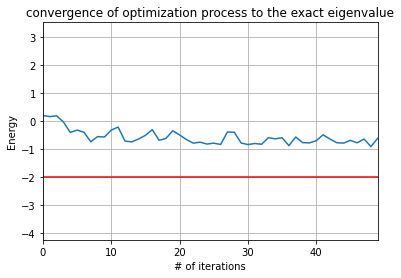

In [283]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [284]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [285]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [286]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

3it [00:00, 21.27it/s]

{'010': 273, '111': 133, '000': 248, '110': 51, '011': 190, '101': 38, '001': 38, '100': 53}
1.0
{'000': 241, '111': 178, '010': 418, '001': 87, '011': 5, '100': 79, '101': 5, '110': 11}
1.0
{'100': 112, '000': 500, '111': 129, '011': 60, '001': 179, '110': 6, '101': 34, '010': 4}
1.0
{'011': 211, '000': 257, '010': 243, '101': 25, '111': 146, '001': 48, '110': 44, '100': 50}
1.0
{'111': 224, '010': 216, '000': 287, '110': 93, '001': 67, '011': 81, '101': 10, '100': 46}
1.0


7it [00:00, 20.99it/s]


{'010': 277, '011': 157, '000': 265, '111': 119, '001': 63, '110': 57, '100': 56, '101': 30}
1.0
{'111': 115, '011': 194, '010': 255, '000': 256, '100': 66, '110': 56, '001': 58, '101': 24}
1.0


0it [00:00, ?it/s]

{'101': 126, '100': 50, '111': 249, '000': 53, '010': 336, '011': 162, '110': 33, '001': 15}
1.0


3it [00:00, 11.09it/s]

{'010': 439, '100': 142, '011': 58, '111': 243, '110': 71, '000': 44, '001': 17, '101': 10}
1.0
{'111': 340, '001': 111, '000': 216, '011': 84, '101': 73, '100': 73, '010': 123, '110': 4}
1.0
{'011': 186, '010': 333, '111': 265, '101': 107, '000': 47, '001': 13, '110': 35, '100': 38}
1.0


7it [00:00, 15.02it/s]


{'010': 211, '111': 362, '011': 71, '101': 58, '110': 127, '001': 89, '000': 106}
1.0
{'101': 129, '111': 290, '010': 305, '011': 166, '000': 46, '110': 22, '100': 52, '001': 14}
1.0
{'000': 50, '111': 265, '010': 329, '101': 124, '011': 171, '100': 52, '110': 23, '001': 10}
1.0


0it [00:00, ?it/s]

{'010': 483, '001': 33, '011': 68, '111': 264, '100': 48, '101': 53, '110': 10, '000': 65}
1.0


4it [00:00, 16.16it/s]

{'010': 442, '000': 91, '111': 111, '100': 52, '110': 164, '101': 52, '011': 88, '001': 24}
1.0
{'111': 256, '000': 327, '010': 216, '101': 52, '011': 69, '001': 38, '100': 35, '110': 31}
1.0
{'010': 477, '111': 258, '100': 54, '000': 90, '011': 57, '110': 10, '001': 36, '101': 42}
1.0


7it [00:00, 14.13it/s]


{'010': 262, '110': 228, '011': 71, '111': 263, '100': 48, '000': 80, '001': 62, '101': 10}
1.0
{'111': 269, '010': 478, '000': 56, '011': 77, '110': 14, '100': 58, '001': 40, '101': 32}
1.0
{'010': 490, '111': 248, '100': 55, '011': 68, '001': 31, '000': 82, '101': 43, '110': 7}
1.0


0it [00:00, ?it/s]

{'111': 350, '110': 45, '010': 246, '000': 91, '100': 15, '101': 125, '011': 147, '001': 5}
1.0


3it [00:00, 22.56it/s]

{'110': 321, '100': 85, '011': 14, '010': 388, '001': 31, '101': 35, '000': 62, '111': 88}
1.0
{'111': 353, '000': 176, '001': 75, '101': 89, '010': 190, '110': 52, '011': 73, '100': 16}
1.0
{'101': 107, '000': 96, '010': 260, '011': 155, '111': 338, '001': 3, '110': 46, '100': 19}
1.0
{'101': 48, '111': 314, '011': 184, '001': 74, '010': 224, '110': 68, '000': 92, '100': 20}
1.0


6it [00:00, 22.21it/s]

{'010': 247, '000': 87, '101': 100, '011': 146, '111': 388, '110': 44, '100': 7, '001': 5}
1.0


7it [00:00, 21.98it/s]


{'010': 248, '111': 344, '101': 109, '011': 147, '110': 47, '000': 113, '100': 14, '001': 2}
1.0


0it [00:00, ?it/s]

{'000': 268, '010': 333, '001': 105, '111': 199, '011': 74, '101': 5, '100': 23, '110': 17}
1.0


2it [00:00, 11.47it/s]

{'000': 302, '010': 360, '001': 96, '111': 30, '110': 145, '011': 50, '100': 38, '101': 3}
1.0
{'000': 388, '010': 200, '011': 140, '111': 134, '101': 53, '110': 35, '100': 12, '001': 62}
1.0


4it [00:00, 13.85it/s]

{'000': 294, '001': 97, '010': 343, '111': 163, '110': 23, '011': 76, '100': 24, '101': 4}
1.0
{'011': 68, '101': 52, '110': 192, '001': 50, '000': 200, '100': 109, '111': 201, '010': 152}
1.0


6it [00:00, 13.64it/s]

{'000': 297, '010': 333, '001': 94, '111': 164, '011': 64, '101': 17, '100': 31, '110': 24}
1.0


7it [00:00, 14.00it/s]


{'011': 61, '010': 367, '000': 259, '111': 174, '001': 103, '100': 29, '110': 26, '101': 5}
1.0


2it [00:00, 18.69it/s]

{'100': 119, '110': 88, '010': 315, '111': 295, '001': 23, '101': 13, '011': 149, '000': 22}
1.0
{'010': 429, '110': 173, '111': 231, '101': 79, '000': 30, '001': 11, '011': 24, '100': 47}
1.0
{'101': 225, '100': 192, '011': 129, '000': 198, '110': 23, '010': 140, '111': 90, '001': 27}
1.0


4it [00:00, 18.44it/s]

{'010': 294, '111': 327, '011': 136, '100': 113, '110': 84, '000': 32, '101': 13, '001': 25}
1.0
{'111': 307, '010': 384, '110': 56, '100': 47, '000': 90, '001': 6, '011': 109, '101': 25}
1.0
{'110': 92, '100': 117, '010': 348, '111': 288, '000': 30, '101': 12, '011': 114, '001': 23}
1.0
{'111': 265, '110': 84, '010': 354, '011': 137, '100': 128, '001': 25, '101': 10, '000': 21}

7it [00:00, 19.02it/s]



1.0


2it [00:00, 11.72it/s]

{'011': 91, '010': 612, '111': 118, '000': 64, '001': 68, '110': 16, '100': 50, '101': 5}
1.0
{'011': 200, '010': 497, '110': 63, '000': 128, '101': 36, '100': 20, '111': 75, '001': 5}
1.0
{'101': 67, '100': 62, '010': 292, '001': 118, '011': 35, '000': 358, '110': 9, '111': 83}
1.0
{'010': 617, '011': 88, '111': 116, '000': 61, '001': 68, '100': 54, '110': 18, '101': 2}
1.0


7it [00:00, 17.23it/s]


{'010': 402, '111': 226, '110': 202, '001': 48, '100': 81, '000': 41, '011': 4, '101': 20}
1.0
{'010': 618, '011': 98, '100': 43, '000': 48, '111': 129, '001': 67, '110': 18, '101': 3}
1.0
{'111': 124, '100': 54, '011': 79, '010': 612, '000': 55, '101': 3, '001': 80, '110': 17}
1.0


0it [00:00, ?it/s]

{'010': 567, '101': 107, '110': 86, '001': 29, '011': 75, '111': 67, '000': 64, '100': 29}
1.0
{'100': 31, '010': 480, '011': 206, '001': 30, '111': 35, '101': 123, '110': 78, '000': 41}
1.0


3it [00:00, 20.48it/s]

{'100': 100, '010': 231, '011': 89, '000': 452, '111': 118, '001': 4, '101': 27, '110': 3}
1.0
{'000': 64, '010': 589, '001': 20, '011': 71, '110': 74, '101': 130, '111': 46, '100': 30}
1.0
{'010': 423, '011': 77, '001': 108, '110': 248, '000': 35, '100': 61, '111': 52, '101': 20}
1.0


6it [00:00, 15.83it/s]

{'100': 33, '010': 600, '000': 59, '011': 64, '110': 85, '101': 108, '111': 62, '001': 13}
1.0


7it [00:00, 15.80it/s]


{'010': 544, '100': 32, '111': 58, '011': 95, '000': 59, '110': 83, '101': 124, '001': 29}
1.0


2it [00:00, 19.88it/s]

{'100': 46, '010': 488, '111': 78, '001': 73, '101': 150, '011': 98, '110': 46, '000': 45}
1.0
{'010': 468, '011': 130, '100': 57, '101': 134, '001': 98, '110': 115, '000': 21, '111': 1}
1.0
{'000': 392, '111': 206, '001': 149, '011': 59, '010': 116, '110': 29, '100': 51, '101': 22}
1.0


4it [00:00, 18.91it/s]

{'010': 498, '101': 178, '011': 104, '110': 37, '111': 50, '001': 65, '100': 35, '000': 57}
1.0
{'000': 78, '001': 32, '110': 234, '011': 132, '101': 191, '010': 298, '111': 48, '100': 11}
1.0
{'100': 55, '010': 454, '001': 56, '111': 90, '110': 41, '101': 162, '011': 103, '000': 63}
1.0


7it [00:00, 19.97it/s]


{'000': 50, '101': 161, '011': 114, '001': 76, '010': 462, '111': 68, '110': 44, '100': 49}
1.0


0it [00:00, ?it/s]

{'101': 170, '010': 387, '111': 189, '110': 161, '100': 34, '011': 37, '001': 25, '000': 21}
1.0


2it [00:00, 19.82it/s]

{'010': 326, '110': 292, '101': 164, '001': 31, '011': 86, '000': 25, '111': 67, '100': 33}
1.0
{'110': 33, '111': 294, '011': 49, '100': 157, '101': 65, '010': 116, '000': 282, '001': 28}
1.0


4it [00:00, 14.40it/s]

{'010': 367, '110': 171, '001': 32, '101': 142, '111': 190, '100': 35, '011': 53, '000': 34}
1.0


6it [00:00, 14.09it/s]

{'111': 206, '110': 335, '001': 163, '010': 217, '011': 29, '100': 41, '101': 22, '000': 11}
1.0
{'101': 149, '010': 412, '011': 44, '111': 179, '000': 25, '100': 26, '110': 170, '001': 19}
1.0


7it [00:00, 14.63it/s]


{'010': 387, '110': 157, '000': 28, '100': 32, '101': 146, '111': 189, '011': 62, '001': 23}
1.0


2it [00:00, 17.78it/s]

{'111': 127, '010': 380, '100': 111, '101': 291, '011': 60, '000': 27, '001': 13, '110': 15}
1.0
{'010': 356, '101': 368, '110': 57, '011': 98, '111': 96, '000': 27, '001': 5, '100': 17}
1.0
{'100': 142, '101': 271, '011': 54, '010': 115, '000': 281, '111': 120, '001': 26, '110': 15}
1.0
{'011': 58, '100': 121, '010': 343, '111': 138, '101': 283, '001': 16, '000': 34, '110': 31}
1.0


5it [00:00, 19.36it/s]

{'000': 68, '110': 162, '111': 126, '010': 237, '001': 213, '100': 76, '101': 112, '011': 30}
1.0


7it [00:00, 17.89it/s]


{'101': 258, '100': 139, '010': 370, '011': 50, '001': 16, '111': 141, '000': 24, '110': 26}
1.0
{'111': 136, '010': 368, '100': 111, '101': 284, '110': 16, '011': 51, '001': 13, '000': 45}
1.0


0it [00:00, ?it/s]

{'100': 198, '010': 437, '000': 42, '101': 260, '111': 8, '110': 36, '001': 31, '011': 12}
1.0


2it [00:00, 12.28it/s]

{'010': 250, '011': 197, '101': 365, '000': 60, '110': 31, '100': 99, '111': 21, '001': 1}
1.0
{'011': 41, '100': 135, '101': 132, '010': 242, '000': 239, '111': 134, '110': 100, '001': 1}
1.0


4it [00:00, 13.50it/s]

{'001': 26, '010': 445, '110': 32, '100': 177, '101': 273, '011': 15, '000': 48, '111': 8}
1.0
{'100': 128, '001': 189, '101': 80, '110': 254, '000': 98, '010': 253, '111': 15, '011': 7}
1.0


7it [00:00, 15.46it/s]


{'010': 449, '101': 264, '000': 39, '100': 191, '110': 37, '111': 9, '001': 22, '011': 13}
1.0
{'010': 429, '110': 41, '101': 250, '100': 213, '001': 32, '000': 35, '111': 13, '011': 11}
1.0


0it [00:00, ?it/s]

{'010': 467, '000': 62, '100': 224, '101': 155, '001': 74, '110': 3, '111': 30, '011': 9}
1.0
{'101': 358, '011': 214, '010': 247, '100': 28, '001': 32, '111': 34, '000': 106, '110': 5}
1.0


3it [00:00, 19.80it/s]

{'100': 132, '110': 120, '010': 381, '000': 133, '001': 51, '101': 172, '111': 21, '011': 14}
1.0
{'100': 246, '000': 76, '010': 439, '111': 40, '101': 133, '001': 74, '011': 13, '110': 3}
1.0


5it [00:00, 15.24it/s]

{'100': 272, '110': 215, '001': 163, '010': 249, '000': 45, '111': 9, '101': 43, '011': 28}
1.0
{'000': 102, '100': 239, '010': 450, '101': 115, '011': 6, '001': 67, '111': 42, '110': 3}
1.0


7it [00:00, 11.21it/s]


{'101': 146, '111': 45, '010': 473, '100': 216, '001': 63, '000': 72, '011': 8, '110': 1}
1.0


3it [00:00, 21.86it/s]

{'101': 229, '010': 508, '100': 205, '011': 9, '001': 36, '111': 14, '110': 19, '000': 4}
1.0
{'000': 21, '010': 364, '101': 325, '011': 177, '100': 86, '001': 28, '111': 18, '110': 5}
1.0
{'000': 340, '111': 162, '100': 140, '010': 205, '110': 51, '011': 30, '001': 17, '101': 79}
1.0
{'100': 183, '010': 518, '101': 248, '001': 38, '111': 8, '110': 11, '011': 11, '000': 7}
1.0


6it [00:00, 20.15it/s]

{'100': 69, '011': 13, '001': 237, '000': 115, '010': 346, '110': 190, '101': 43, '111': 11}
1.0
{'101': 251, '010': 477, '100': 208, '001': 39, '011': 18, '000': 3, '110': 15, '111': 13}
1.0


7it [00:00, 15.40it/s]


{'101': 237, '001': 36, '010': 491, '100': 196, '011': 22, '110': 24, '111': 12, '000': 6}
1.0


2it [00:00, 13.51it/s]

{'010': 369, '000': 61, '100': 223, '110': 223, '101': 93, '001': 24, '111': 18, '011': 13}
1.0
{'101': 296, '001': 16, '000': 60, '011': 234, '111': 123, '110': 87, '010': 149, '100': 59}
1.0


4it [00:00, 16.50it/s]

{'100': 284, '101': 76, '010': 355, '110': 123, '111': 41, '000': 118, '001': 21, '011': 6}
1.0
{'100': 215, '010': 404, '001': 19, '110': 178, '000': 71, '101': 110, '011': 6, '111': 21}
1.0


7it [00:00, 18.45it/s]


{'010': 273, '110': 322, '100': 251, '101': 36, '011': 26, '001': 79, '000': 34, '111': 3}
1.0
{'110': 217, '010': 389, '101': 106, '100': 192, '000': 69, '011': 6, '111': 25, '001': 20}
1.0
{'010': 405, '110': 178, '101': 111, '100': 218, '000': 69, '001': 19, '111': 18, '011': 6}
1.0


0it [00:00, ?it/s]

{'101': 245, '010': 466, '110': 72, '111': 12, '001': 37, '100': 65, '000': 121, '011': 6}
1.0
{'011': 214, '010': 253, '100': 83, '000': 91, '101': 227, '111': 54, '001': 77, '110': 25}
1.0


3it [00:00, 14.99it/s]

{'000': 340, '100': 126, '101': 127, '010': 237, '111': 146, '011': 31, '001': 14, '110': 3}
1.0
{'101': 235, '010': 482, '001': 48, '000': 114, '100': 66, '110': 67, '111': 8, '011': 4}
1.0


7it [00:00, 17.76it/s]

{'111': 3, '000': 120, '001': 228, '100': 59, '010': 462, '110': 81, '011': 14, '101': 57}
1.0
{'010': 467, '101': 257, '000': 117, '110': 75, '111': 10, '100': 58, '001': 37, '011': 3}
1.0
{'010': 473, '100': 61, '110': 78, '101': 239, '000': 119, '011': 10, '001': 36, '111': 8}
1.0



0it [00:00, ?it/s]

{'100': 318, '011': 143, '010': 327, '101': 139, '111': 21, '001': 13, '000': 49, '110': 14}
1.0
{'000': 61, '011': 158, '101': 406, '010': 300, '100': 39, '110': 49, '001': 4, '111': 7}
1.0


3it [00:00, 24.00it/s]

{'110': 206, '101': 147, '100': 145, '000': 194, '111': 37, '011': 128, '010': 125, '001': 42}
1.0
{'010': 331, '011': 141, '101': 135, '100': 310, '000': 44, '001': 20, '111': 24, '110': 19}
1.0
{'110': 188, '010': 139, '011': 81, '111': 98, '100': 122, '000': 215, '001': 102, '101': 79}
1.0


6it [00:00, 19.66it/s]

{'010': 321, '100': 297, '011': 148, '000': 35, '101': 150, '001': 22, '110': 13, '111': 38}
1.0


7it [00:00, 19.48it/s]


{'010': 293, '101': 146, '100': 304, '011': 165, '111': 27, '110': 17, '001': 15, '000': 57}
1.0


0it [00:00, ?it/s]

{'100': 76, '010': 269, '101': 384, '000': 55, '011': 123, '001': 79, '110': 32, '111': 6}
1.0
{'101': 305, '010': 243, '110': 19, '100': 136, '011': 162, '000': 142, '111': 16, '001': 1}
1.0


3it [00:00, 21.33it/s]

{'101': 235, '000': 79, '010': 253, '011': 197, '001': 9, '100': 36, '110': 60, '111': 155}
1.0
{'101': 397, '100': 88, '011': 122, '010': 254, '001': 70, '110': 30, '000': 53, '111': 10}
1.0


6it [00:00, 18.69it/s]

{'010': 90, '001': 391, '100': 110, '110': 199, '011': 48, '111': 101, '101': 71, '000': 14}
1.0
{'010': 275, '011': 132, '101': 383, '111': 9, '110': 36, '100': 69, '001': 72, '000': 48}
1.0


7it [00:00, 18.79it/s]


{'101': 391, '001': 81, '100': 78, '000': 61, '010': 245, '011': 130, '110': 32, '111': 6}
1.0


0it [00:00, ?it/s]

{'101': 360, '110': 117, '010': 151, '100': 27, '011': 142, '000': 128, '001': 91, '111': 8}
1.0
{'010': 156, '011': 171, '000': 155, '101': 248, '100': 136, '111': 64, '110': 71, '001': 23}
1.0


3it [00:00, 24.39it/s]

{'011': 93, '100': 71, '101': 204, '000': 22, '111': 187, '010': 260, '001': 140, '110': 47}
1.0
{'101': 377, '110': 129, '011': 133, '010': 153, '000': 123, '001': 71, '100': 30, '111': 8}
1.0
{'110': 153, '100': 124, '011': 70, '111': 72, '001': 249, '101': 191, '010': 148, '000': 17}
1.0


6it [00:00, 20.94it/s]

{'110': 134, '001': 76, '011': 149, '101': 347, '000': 110, '010': 172, '100': 24, '111': 12}
1.0


7it [00:00, 21.18it/s]

{'010': 187, '101': 341, '110': 119, '100': 35, '001': 64, '011': 149, '000': 124, '111': 5}
1.0



0it [00:00, ?it/s]

{'010': 157, '011': 198, '100': 258, '111': 16, '101': 214, '001': 146, '110': 27, '000': 8}
1.0
{'011': 128, '110': 29, '010': 259, '101': 405, '001': 45, '000': 93, '100': 56, '111': 9}
1.0


2it [00:00,  9.70it/s]

{'011': 344, '100': 147, '111': 123, '110': 94, '010': 90, '000': 94, '101': 126, '001': 6}
1.0


4it [00:00, 13.29it/s]

{'101': 242, '100': 223, '011': 187, '001': 144, '000': 7, '010': 177, '110': 32, '111': 12}
1.0
{'110': 151, '011': 89, '000': 76, '100': 138, '001': 333, '111': 145, '101': 36, '010': 56}
1.0
{'010': 178, '100': 241, '101': 227, '011': 206, '111': 15, '001': 133, '110': 19, '000': 5}
1.0


7it [00:00, 15.55it/s]

{'100': 231, '010': 201, '011': 203, '101': 211, '111': 20, '001': 139, '110': 17, '000': 2}
1.0



0it [00:00, ?it/s]

{'101': 305, '010': 170, '001': 172, '110': 34, '000': 138, '011': 30, '100': 69, '111': 106}
1.0


3it [00:00, 23.44it/s]

{'111': 159, '000': 305, '100': 137, '101': 180, '011': 98, '010': 104, '110': 9, '001': 32}
1.0
{'100': 52, '101': 379, '010': 305, '111': 21, '000': 23, '011': 166, '110': 45, '001': 33}
1.0
{'010': 182, '101': 294, '001': 172, '100': 57, '000': 144, '110': 46, '011': 30, '111': 99}
1.0
{'111': 137, '001': 420, '100': 213, '110': 121, '010': 97, '011': 16, '000': 4, '101': 16}
1.0


6it [00:00, 21.69it/s]

{'001': 177, '100': 63, '111': 122, '101': 266, '000': 134, '010': 194, '110': 41, '011': 27}
1.0


7it [00:00, 19.13it/s]


{'010': 190, '111': 110, '001': 169, '000': 144, '101': 273, '110': 47, '011': 35, '100': 56}
1.0


0it [00:00, ?it/s]

{'001': 315, '101': 164, '100': 84, '010': 200, '111': 39, '011': 87, '000': 28, '110': 107}
1.0
{'000': 259, '001': 79, '101': 229, '011': 102, '111': 62, '100': 41, '010': 165, '110': 87}
1.0


2it [00:00, 17.17it/s]

{'101': 172, '010': 150, '011': 334, '110': 175, '100': 18, '000': 92, '001': 63, '111': 20}
1.0


5it [00:00, 21.35it/s]

{'100': 102, '101': 174, '001': 295, '110': 89, '111': 42, '010': 200, '011': 84, '000': 38}
1.0
{'110': 286, '001': 441, '100': 97, '101': 27, '111': 117, '000': 36, '010': 15, '011': 5}
1.0
{'110': 83, '001': 304, '100': 87, '101': 161, '010': 215, '011': 98, '111': 37, '000': 39}
1.0


7it [00:00, 20.44it/s]


{'101': 183, '001': 307, '110': 73, '111': 46, '100': 102, '010': 185, '011': 82, '000': 46}
1.0


3it [00:00, 19.74it/s]

{'010': 275, '101': 380, '001': 87, '100': 61, '000': 58, '011': 118, '111': 6, '110': 39}
1.0
{'010': 375, '100': 56, '101': 399, '110': 24, '001': 32, '011': 28, '000': 104, '111': 6}
1.0
{'101': 205, '000': 91, '100': 54, '010': 237, '111': 171, '011': 194, '110': 58, '001': 14}
1.0
{'101': 386, '100': 77, '110': 34, '011': 132, '001': 76, '010': 269, '000': 49, '111': 1}
1.0


7it [00:00, 18.84it/s]


{'001': 398, '110': 192, '010': 108, '100': 100, '101': 86, '011': 41, '111': 88, '000': 11}
1.0
{'101': 357, '010': 290, '100': 80, '011': 124, '110': 33, '001': 80, '000': 51, '111': 9}
1.0
{'010': 252, '001': 75, '011': 144, '101': 393, '100': 71, '110': 27, '000': 50, '111': 12}
1.0


0it [00:00, ?it/s]

{'011': 139, '101': 357, '001': 79, '010': 270, '110': 34, '100': 73, '000': 68, '111': 4}
1.0
{'101': 313, '100': 140, '010': 230, '011': 152, '000': 161, '111': 9, '110': 18, '001': 1}
1.0


3it [00:00, 21.51it/s]

{'111': 229, '010': 113, '000': 205, '011': 165, '101': 191, '100': 89, '110': 20, '001': 12}
1.0
{'001': 76, '101': 396, '010': 260, '011': 122, '000': 49, '110': 25, '100': 92, '111': 4}
1.0
{'001': 403, '000': 15, '110': 210, '011': 37, '100': 107, '010': 99, '101': 60, '111': 93}
1.0
{'011': 158, '100': 73, '101': 372, '010': 269, '001': 75, '110': 25, '000': 48, '111': 4}

7it [00:00, 21.57it/s]


1.0
{'010': 284, '001': 84, '101': 375, '100': 70, '011': 118, '000': 59, '110': 29, '111': 5}
1.0



0it [00:00, ?it/s]

{'101': 409, '010': 257, '001': 64, '110': 28, '100': 62, '000': 67, '011': 127, '111': 10}
1.0
{'000': 126, '010': 237, '101': 321, '100': 140, '011': 156, '110': 19, '111': 24, '001': 1}
1.0


3it [00:00, 16.70it/s]

{'010': 235, '101': 239, '000': 80, '011': 207, '111': 141, '100': 44, '110': 65, '001': 13}
1.0
{'010': 280, '011': 115, '101': 383, '001': 83, '000': 60, '100': 65, '110': 33, '111': 5}
1.0

7it [00:00, 18.76it/s]


{'101': 96, '001': 377, '010': 224, '110': 100, '000': 54, '011': 68, '111': 60, '100': 45}
1.0
{'101': 390, '100': 70, '010': 271, '000': 62, '110': 35, '111': 7, '011': 121, '001': 68}
1.0
{'101': 393, '010': 267, '110': 39, '000': 56, '001': 76, '011': 133, '100': 59, '111': 1}
1.0



0it [00:00, ?it/s]

{'110': 38, '101': 549, '010': 264, '011': 99, '000': 15, '001': 3, '111': 36, '100': 20}
1.0
{'101': 330, '010': 247, '100': 235, '011': 124, '110': 68, '111': 4, '001': 6, '000': 10}


3it [00:00, 25.21it/s]

1.0
{'001': 74, '101': 220, '111': 349, '110': 27, '010': 179, '011': 32, '000': 108, '100': 35}
1.0
{'101': 551, '010': 252, '011': 104, '100': 27, '111': 37, '110': 31, '001': 10, '000': 12}
1.0
{'101': 318, '001': 224, '011': 92, '010': 121, '110': 164, '111': 72, '100': 30, '000': 3}
1.0


6it [00:00, 23.85it/s]

{'101': 574, '010': 252, '011': 98, '110': 29, '000': 13, '111': 36, '100': 16, '001': 6}
1.0


7it [00:00, 23.81it/s]


{'101': 535, '010': 286, '011': 96, '100': 24, '111': 31, '110': 40, '000': 10, '001': 2}
1.0


0it [00:00, ?it/s]

{'101': 549, '010': 360, '011': 57, '100': 7, '111': 8, '000': 19, '110': 21, '001': 3}
1.0


2it [00:00,  9.71it/s]

{'101': 331, '010': 203, '000': 18, '001': 10, '100': 209, '011': 214, '110': 38, '111': 1}
1.0
{'101': 240, '010': 263, '100': 29, '111': 332, '001': 42, '000': 107, '011': 11}
1.0


4it [00:00, 13.32it/s]

{'101': 548, '010': 386, '011': 45, '111': 8, '110': 11, '100': 8, '000': 17, '001': 1}
1.0
{'010': 170, '110': 230, '011': 53, '001': 216, '101': 313, '000': 23, '100': 8, '111': 11}
1.0
{'101': 516, '111': 7, '010': 383, '011': 62, '110': 19, '000': 26, '001': 3, '100': 8}
1.0


7it [00:00, 14.51it/s]


{'010': 346, '101': 549, '000': 24, '011': 55, '110': 21, '100': 13, '001': 3, '111': 13}
1.0


0it [00:00, ?it/s]

{'011': 100, '101': 488, '010': 315, '111': 53, '000': 30, '100': 19, '001': 16, '110': 3}
1.0
{'100': 252, '010': 181, '111': 38, '011': 214, '101': 256, '001': 32, '000': 26, '110': 25}
1.0


3it [00:00, 22.22it/s]

{'000': 167, '111': 404, '010': 183, '001': 43, '101': 109, '011': 89, '100': 26, '110': 3}
1.0
{'101': 470, '011': 126, '100': 27, '010': 298, '001': 18, '111': 51, '000': 31, '110': 3}
1.0
{'001': 247, '101': 271, '110': 190, '100': 30, '010': 128, '011': 127, '000': 19, '111': 12}
1.0


7it [00:00, 16.66it/s]


{'101': 476, '011': 104, '010': 323, '100': 28, '111': 47, '001': 23, '000': 23}
1.0
{'011': 100, '101': 491, '010': 321, '111': 45, '001': 15, '100': 26, '000': 23, '110': 3}
1.0


2it [00:00, 16.29it/s]

{'011': 122, '101': 550, '010': 299, '111': 13, '000': 6, '100': 24, '110': 2, '001': 8}
1.0
{'011': 286, '010': 123, '100': 398, '111': 14, '101': 174, '000': 19, '001': 5, '110': 5}
1.0


5it [00:00, 20.19it/s]

{'111': 356, '101': 200, '000': 167, '001': 29, '110': 14, '010': 164, '100': 18, '011': 76}
1.0
{'101': 517, '000': 18, '010': 324, '111': 19, '011': 107, '001': 11, '100': 25, '110': 3}
1.0
{'110': 124, '001': 287, '101': 265, '011': 93, '010': 189, '111': 32, '100': 4, '000': 30}
1.0


7it [00:00, 20.42it/s]

{'100': 23, '101': 541, '000': 14, '010': 321, '011': 91, '111': 23, '001': 8, '110': 3}
1.0
{'101': 496, '011': 109, '010': 356, '100': 22, '001': 19, '111': 12, '000': 5, '110': 5}
1.0



3it [00:00, 21.58it/s]

{'101': 460, '010': 277, '011': 112, '100': 81, '001': 18, '111': 28, '110': 19, '000': 29}
1.0
{'101': 341, '010': 189, '111': 47, '100': 198, '011': 193, '110': 8, '001': 43, '000': 5}
1.0
{'101': 138, '111': 347, '100': 70, '011': 53, '001': 103, '000': 102, '110': 18, '010': 193}
1.0
{'101': 474, '010': 260, '100': 89, '111': 29, '011': 110, '000': 38, '001': 14, '110': 10}
1.0


7it [00:00, 16.44it/s]

{'101': 308, '001': 172, '011': 124, '100': 53, '110': 207, '010': 92, '111': 24, '000': 44}
1.0
{'111': 24, '010': 284, '101': 458, '001': 20, '000': 32, '100': 86, '011': 103, '110': 17}
1.0
{'100': 89, '010': 274, '001': 17, '101': 465, '000': 35, '011': 104, '111': 22, '110': 18}
1.0



0it [00:00, ?it/s]

{'101': 544, '111': 70, '011': 140, '010': 181, '001': 35, '100': 28, '000': 8, '110': 18}
1.0


4it [00:00, 17.31it/s]

{'100': 212, '011': 275, '101': 352, '111': 69, '010': 68, '001': 14, '110': 17, '000': 17}
1.0
{'111': 467, '110': 30, '000': 113, '100': 19, '101': 106, '011': 120, '001': 70, '010': 99}
1.0
{'010': 206, '001': 34, '011': 152, '101': 539, '111': 46, '100': 30, '000': 3, '110': 14}
1.0
{'110': 141, '101': 280, '010': 79, '011': 178, '001': 274, '100': 27, '111': 37, '000': 8}
1.0
{'101': 543, '111': 74, '001': 30, '010': 185, '011': 140, '100': 33, '110': 14, '000': 5}
1.0


7it [00:00, 19.34it/s]


{'010': 212, '011': 133, '101': 516, '001': 32, '111': 79, '110': 25, '000': 4, '100': 23}
1.0


0it [00:00, ?it/s]

{'101': 427, '001': 127, '011': 119, '110': 108, '000': 74, '010': 76, '111': 74, '100': 19}
1.0


2it [00:00, 13.23it/s]

{'100': 125, '101': 297, '011': 193, '000': 71, '111': 176, '001': 145, '010': 6, '110': 11}
1.0
{'111': 431, '110': 144, '011': 220, '010': 39, '001': 33, '101': 44, '100': 12, '000': 101}
1.0


4it [00:00, 14.00it/s]

{'101': 391, '001': 132, '111': 83, '000': 73, '110': 128, '010': 63, '011': 128, '100': 26}
1.0
{'001': 222, '010': 155, '011': 148, '101': 316, '110': 18, '111': 44, '000': 18, '100': 103}
1.0


7it [00:00, 16.60it/s]

{'001': 126, '101': 406, '010': 73, '111': 81, '110': 113, '100': 19, '000': 87, '011': 119}
1.0
{'101': 412, '001': 106, '011': 114, '110': 118, '111': 95, '010': 69, '000': 89, '100': 21}
1.0


7it [00:00, 15.77it/s]
0it [00:00, ?it/s]

{'011': 190, '101': 479, '010': 188, '111': 66, '110': 33, '001': 27, '000': 6, '100': 35}
1.0
{'011': 291, '111': 87, '100': 225, '010': 85, '101': 299, '001': 5, '000': 17, '110': 15}
1.0


2it [00:00, 16.00it/s]

{'000': 123, '111': 459, '011': 119, '001': 72, '010': 79, '100': 38, '101': 101, '110': 33}
1.0
{'011': 176, '010': 195, '001': 27, '101': 466, '110': 39, '111': 72, '100': 40, '000': 9}
1.0


5it [00:00, 15.62it/s]

{'110': 145, '101': 259, '100': 40, '001': 233, '011': 228, '010': 92, '000': 19, '111': 8}
1.0


7it [00:00, 14.62it/s]


{'101': 475, '010': 185, '011': 185, '001': 19, '110': 35, '111': 76, '100': 43, '000': 6}
1.0
{'110': 30, '101': 503, '111': 60, '100': 40, '001': 19, '010': 188, '011': 178, '000': 6}
1.0


0it [00:00, ?it/s]

{'101': 437, '000': 101, '110': 104, '010': 150, '001': 28, '100': 19, '111': 53, '011': 132}
1.0
{'010': 125, '100': 239, '101': 221, '111': 137, '011': 164, '001': 85, '000': 30, '110': 23}
1.0


3it [00:00, 21.33it/s]

{'111': 404, '100': 107, '011': 97, '101': 79, '110': 29, '010': 277, '001': 26, '000': 5}
1.0
{'101': 419, '010': 174, '000': 99, '110': 120, '011': 120, '001': 30, '100': 13, '111': 49}
1.0
{'110': 273, '101': 145, '000': 117, '011': 141, '111': 37, '001': 272, '100': 17, '010': 22}
1.0


6it [00:00, 21.33it/s]

{'111': 50, '010': 200, '011': 120, '000': 90, '101': 417, '110': 119, '100': 14, '001': 14}
1.0


7it [00:00, 20.00it/s]


{'010': 175, '000': 106, '011': 148, '110': 130, '101': 378, '100': 21, '111': 47, '001': 19}
1.0


0it [00:00, ?it/s]

{'010': 219, '101': 527, '111': 36, '011': 167, '001': 40, '000': 27, '100': 6, '110': 2}
1.0
{'101': 322, '100': 229, '010': 85, '011': 292, '111': 12, '001': 52, '000': 13, '110': 19}
1.0


3it [00:00, 16.56it/s]

{'111': 423, '001': 49, '010': 167, '101': 155, '011': 158, '000': 64, '110': 4, '100': 4}
1.0


5it [00:00, 17.27it/s]

{'011': 157, '101': 558, '010': 201, '100': 6, '001': 44, '111': 37, '000': 20, '110': 1}
1.0
{'101': 228, '111': 30, '001': 358, '011': 161, '000': 19, '010': 116, '110': 101, '100': 11}
1.0
{'010': 229, '101': 523, '011': 166, '100': 9, '001': 37, '000': 22, '111': 38}
1.0


7it [00:00, 17.74it/s]


{'101': 529, '010': 211, '011': 176, '111': 35, '001': 40, '100': 5, '000': 28}
1.0


3it [00:00, 22.90it/s]

{'010': 250, '111': 99, '001': 162, '101': 287, '011': 148, '000': 55, '100': 21, '110': 2}
1.0
{'001': 162, '000': 59, '011': 365, '110': 58, '101': 192, '100': 80, '010': 52, '111': 56}
1.0
{'111': 332, '010': 234, '011': 313, '000': 67, '101': 43, '110': 10, '100': 13, '001': 12}
1.0
{'001': 181, '101': 267, '011': 167, '010': 234, '100': 19, '111': 109, '000': 43, '110': 4}
1.0
{'001': 423, '110': 107, '010': 134, '011': 258, '000': 41, '101': 35, '100': 16, '111': 10}
1.0


7it [00:00, 23.18it/s]


{'011': 165, '001': 187, '101': 262, '111': 103, '010': 244, '100': 19, '000': 40, '110': 4}
1.0
{'010': 217, '101': 292, '000': 58, '011': 156, '001': 160, '111': 118, '100': 21, '110': 2}
1.0


0it [00:00, ?it/s]

{'101': 623, '010': 200, '011': 136, '111': 25, '000': 19, '001': 18, '100': 1, '110': 2}
1.0
{'100': 276, '101': 334, '110': 20, '011': 291, '001': 26, '111': 24, '010': 43, '000': 10}
1.0
{'101': 194, '010': 155, '111': 433, '011': 154, '000': 41, '110': 10, '001': 32, '100': 5}

3it [00:00, 21.51it/s]


1.0
{'101': 620, '010': 167, '011': 139, '111': 49, '001': 22, '110': 7, '000': 17, '100': 3}
1.0
{'001': 388, '101': 216, '000': 6, '011': 162, '111': 44, '010': 134, '100': 26, '110': 48}
1.0


7it [00:00, 17.00it/s]


{'101': 610, '010': 184, '111': 39, '011': 146, '000': 24, '001': 11, '110': 8, '100': 2}
1.0
{'011': 145, '101': 598, '010': 190, '001': 21, '111': 39, '100': 4, '110': 10, '000': 17}
1.0


0it [00:00, ?it/s]

{'111': 256, '010': 164, '101': 294, '110': 68, '011': 169, '001': 35, '000': 11, '100': 27}
1.0
{'101': 286, '011': 255, '111': 151, '000': 46, '110': 139, '100': 76, '010': 68, '001': 3}
1.0


3it [00:00, 21.33it/s]

{'000': 54, '111': 519, '011': 173, '110': 63, '100': 57, '010': 103, '101': 16, '001': 39}
1.0
{'111': 234, '010': 150, '101': 310, '011': 180, '001': 33, '110': 70, '000': 23, '100': 24}
1.0
{'101': 63, '001': 283, '111': 16, '100': 32, '110': 11, '011': 392, '010': 224, '000': 3}
1.0


7it [00:00, 21.33it/s]

{'010': 150, '101': 305, '001': 33, '111': 226, '011': 187, '100': 33, '110': 75, '000': 15}
1.0
{'001': 48, '011': 187, '111': 196, '101': 322, '100': 38, '010': 152, '110': 71, '000': 10}
1.0



0it [00:00, ?it/s]

{'010': 114, '101': 559, '011': 163, '111': 80, '100': 11, '001': 57, '000': 25, '110': 15}
1.0


2it [00:00, 11.63it/s]

{'100': 248, '101': 319, '011': 210, '010': 62, '110': 48, '111': 63, '001': 50, '000': 24}
1.0


4it [00:00, 12.64it/s]

{'001': 26, '011': 221, '111': 522, '101': 110, '010': 103, '000': 22, '100': 13, '110': 7}
1.0
{'101': 569, '011': 154, '111': 111, '010': 101, '110': 14, '100': 10, '001': 47, '000': 18}
1.0


6it [00:00, 15.01it/s]

{'010': 107, '001': 377, '011': 209, '110': 21, '101': 249, '100': 30, '111': 31}
1.0
{'101': 528, '111': 98, '011': 178, '010': 109, '001': 70, '000': 16, '110': 20, '100': 5}
1.0
{'101': 569, '110': 12, '111': 81, '011': 160, '001': 50, '010': 129, '000': 15, '100': 8}

7it [00:00, 14.78it/s]



1.0


0it [00:00, ?it/s]

{'100': 108, '011': 271, '001': 31, '101': 494, '010': 51, '000': 1, '111': 65, '110': 3}
1.0
{'100': 253, '001': 22, '011': 228, '101': 353, '000': 12, '010': 85, '111': 27, '110': 44}
1.0


3it [00:00, 18.18it/s]

{'001': 69, '110': 72, '101': 72, '111': 485, '011': 219, '000': 13, '010': 45, '100': 49}
1.0
{'101': 512, '111': 67, '011': 262, '100': 98, '010': 54, '001': 24, '000': 5, '110': 2}
1.0


5it [00:00, 17.60it/s]

{'001': 285, '101': 233, '011': 295, '100': 72, '110': 36, '000': 28, '111': 45, '010': 30}
1.0
{'011': 263, '101': 512, '001': 21, '111': 63, '100': 99, '010': 56, '000': 9, '110': 1}
1.0


7it [00:00, 14.09it/s]


{'100': 101, '101': 483, '011': 277, '111': 70, '001': 22, '010': 61, '000': 8, '110': 2}
1.0


0it [00:00, ?it/s]

{'011': 209, '101': 578, '010': 76, '000': 44, '111': 40, '100': 27, '001': 28, '110': 22}
1.0


2it [00:00, 14.98it/s]

{'101': 418, '001': 68, '111': 44, '011': 177, '010': 83, '100': 223, '000': 8, '110': 3}
1.0
{'111': 455, '101': 199, '010': 102, '110': 30, '001': 34, '011': 181, '100': 22, '000': 1}
1.0


4it [00:00, 16.31it/s]

{'101': 603, '000': 44, '111': 34, '110': 26, '011': 185, '001': 32, '010': 73, '100': 27}
1.0
{'101': 249, '011': 191, '001': 377, '100': 73, '111': 52, '110': 28, '010': 52, '000': 2}
1.0


7it [00:00, 17.24it/s]


{'101': 590, '010': 68, '000': 41, '100': 32, '011': 199, '001': 32, '111': 36, '110': 26}
1.0
{'011': 187, '010': 81, '001': 30, '101': 603, '100': 27, '000': 48, '110': 18, '111': 30}
1.0


0it [00:00, ?it/s]

{'101': 420, '010': 207, '110': 28, '100': 96, '001': 132, '000': 75, '011': 36, '111': 30}
1.0


2it [00:00, 10.80it/s]

{'101': 339, '010': 47, '001': 211, '011': 173, '100': 170, '111': 9, '110': 69, '000': 6}
1.0


4it [00:00, 11.14it/s]

{'111': 330, '010': 273, '101': 141, '100': 96, '011': 139, '001': 20, '000': 19, '110': 6}
1.0
{'101': 440, '100': 98, '000': 79, '111': 43, '011': 36, '010': 189, '110': 29, '001': 110}
1.0


6it [00:00, 13.71it/s]

{'111': 35, '110': 49, '100': 185, '001': 237, '101': 297, '010': 184, '011': 37}
1.0
{'100': 110, '101': 399, '001': 138, '011': 57, '110': 24, '010': 171, '000': 88, '111': 37}
1.0


7it [00:00, 13.46it/s]


{'101': 438, '000': 74, '010': 186, '001': 136, '111': 38, '100': 90, '011': 30, '110': 32}
1.0


0it [00:00, ?it/s]

{'001': 49, '000': 46, '110': 10, '011': 186, '101': 579, '010': 76, '111': 68, '100': 10}
1.0


2it [00:00, 15.69it/s]

{'100': 218, '011': 170, '101': 383, '001': 84, '010': 78, '000': 9, '111': 20, '110': 62}
1.0
{'011': 176, '101': 163, '111': 501, '000': 6, '010': 117, '110': 18, '100': 7, '001': 36}
1.0
{'101': 557, '001': 52, '011': 184, '111': 84, '000': 35, '010': 86, '110': 15, '100': 11}
1.0


4it [00:00, 15.87it/s]

{'101': 247, '001': 395, '011': 176, '010': 77, '000': 28, '111': 69, '100': 22, '110': 10}
1.0


7it [00:00, 13.33it/s]


{'111': 81, '101': 607, '000': 37, '011': 170, '010': 52, '100': 8, '001': 54, '110': 15}
1.0
{'101': 572, '001': 60, '111': 80, '011': 173, '000': 38, '100': 17, '010': 72, '110': 12}
1.0


0it [00:00, ?it/s]

{'001': 135, '101': 502, '110': 76, '111': 108, '010': 140, '100': 11, '000': 26, '011': 26}
1.0
{'110': 103, '111': 106, '101': 303, '011': 126, '001': 139, '100': 203, '010': 34, '000': 10}
1.0
{'100': 85, '010': 138, '111': 523, '101': 72, '000': 23, '011': 138, '001': 20, '110': 25}
1.0


3it [00:00, 21.20it/s]

{'111': 129, '001': 139, '101': 478, '010': 106, '110': 96, '000': 36, '100': 10, '011': 30}
1.0
{'101': 259, '011': 120, '001': 381, '010': 188, '100': 31, '111': 33, '000': 7, '110': 5}
1.0


6it [00:00, 21.15it/s]

{'110': 85, '101': 491, '111': 109, '011': 33, '010': 123, '001': 134, '100': 21, '000': 28}
1.0


7it [00:00, 21.65it/s]


{'110': 85, '010': 129, '101': 500, '001': 141, '111': 93, '000': 27, '100': 15, '011': 34}
1.0


0it [00:00, ?it/s]

{'101': 619, '111': 61, '010': 136, '011': 151, '100': 9, '110': 18, '000': 15, '001': 15}

2it [00:00, 12.48it/s]


1.0
{'101': 358, '100': 261, '111': 55, '010': 86, '110': 27, '011': 202, '000': 8, '001': 27}
1.0
{'111': 552, '010': 116, '101': 123, '011': 163, '000': 27, '110': 5, '001': 21, '100': 17}
1.0


6it [00:00, 14.35it/s]

{'101': 583, '011': 172, '010': 143, '111': 68, '000': 15, '110': 18, '001': 15, '100': 10}
1.0
{'001': 366, '101': 260, '011': 194, '000': 2, '010': 101, '110': 27, '111': 45, '100': 29}
1.0
{'011': 163, '101': 586, '010': 136, '111': 68, '000': 21, '001': 25, '100': 12, '110': 13}
1.0


7it [00:00, 14.39it/s]


{'010': 124, '101': 614, '111': 70, '000': 13, '011': 159, '110': 9, '001': 21, '100': 14}
1.0


2it [00:00, 19.41it/s]

{'101': 648, '100': 18, '011': 146, '010': 152, '110': 14, '111': 35, '001': 11}
1.0
{'100': 242, '101': 437, '010': 67, '011': 193, '000': 8, '111': 42, '110': 33, '001': 2}
1.0
{'001': 94, '101': 161, '111': 547, '000': 74, '011': 34, '010': 69, '100': 21, '110': 24}
1.0


4it [00:00, 18.27it/s]

{'101': 645, '010': 142, '011': 131, '111': 53, '100': 21, '001': 11, '110': 21}
1.0


6it [00:00, 16.46it/s]

{'101': 422, '010': 118, '001': 229, '011': 177, '111': 29, '110': 35, '100': 7, '000': 7}
1.0
{'101': 614, '111': 67, '100': 12, '011': 153, '010': 145, '110': 20, '001': 12, '000': 1}
1.0


7it [00:00, 15.58it/s]


{'110': 19, '101': 633, '011': 135, '001': 13, '100': 15, '111': 71, '010': 138}
1.0


2it [00:00, 14.71it/s]

{'010': 115, '011': 184, '101': 609, '111': 46, '001': 38, '110': 8, '100': 10, '000': 14}
1.0
{'100': 340, '011': 208, '101': 267, '110': 33, '010': 99, '000': 31, '001': 14, '111': 32}
1.0
{'111': 530, '011': 189, '100': 14, '101': 116, '000': 26, '010': 104, '001': 45}
1.0


4it [00:00, 16.90it/s]

{'001': 29, '101': 616, '111': 62, '110': 12, '010': 97, '011': 185, '000': 15, '100': 8}
1.0
{'011': 168, '101': 187, '001': 449, '111': 69, '000': 7, '010': 94, '100': 11, '110': 39}
1.0


7it [00:00, 17.48it/s]


{'000': 14, '101': 598, '011': 182, '111': 59, '010': 123, '001': 35, '110': 7, '100': 6}
1.0
{'011': 212, '101': 575, '010': 115, '111': 69, '001': 31, '110': 7, '000': 13, '100': 2}
1.0


2it [00:00, 18.10it/s]

{'100': 137, '101': 386, '110': 41, '011': 127, '111': 73, '010': 173, '001': 75, '000': 12}
1.0
{'101': 495, '010': 84, '111': 106, '011': 203, '000': 20, '001': 58, '100': 53, '110': 5}
1.0
{'011': 199, '111': 402, '101': 69, '110': 150, '100': 20, '000': 76, '010': 100, '001': 8}
1.0


4it [00:00, 11.58it/s]

{'100': 148, '101': 383, '010': 174, '011': 129, '111': 78, '001': 67, '110': 35, '000': 10}
1.0
{'010': 131, '100': 51, '110': 95, '101': 73, '001': 398, '111': 23, '011': 157, '000': 96}
1.0


7it [00:00, 14.55it/s]


{'101': 392, '010': 163, '111': 79, '011': 141, '110': 40, '100': 139, '001': 58, '000': 12}
1.0
{'001': 85, '100': 120, '101': 411, '010': 176, '110': 29, '011': 123, '000': 12, '111': 68}
1.0


0it [00:00, ?it/s]

{'101': 639, '011': 150, '111': 75, '010': 119, '000': 6, '001': 23, '110': 4, '100': 8}
1.0
{'101': 372, '011': 199, '010': 89, '001': 29, '111': 45, '110': 32, '100': 252, '000': 6}
1.0
{'010': 95, '011': 142, '001': 40, '111': 527, '101': 170, '000': 27, '100': 20, '110': 3}

3it [00:00, 21.32it/s]


1.0
{'101': 637, '011': 142, '001': 12, '010': 125, '100': 12, '111': 80, '000': 8, '110': 8}
1.0
{'010': 103, '101': 214, '001': 411, '110': 35, '011': 229, '000': 5, '111': 11, '100': 16}
1.0


7it [00:00, 22.32it/s]


{'011': 167, '101': 621, '010': 112, '111': 72, '100': 15, '001': 20, '000': 11, '110': 6}
1.0
{'010': 107, '011': 159, '101': 642, '111': 66, '001': 27, '000': 8, '110': 10, '100': 5}
1.0


0it [00:00, ?it/s]

{'101': 639, '111': 173, '011': 102, '001': 85, '010': 11, '110': 3, '000': 2, '100': 9}
1.0


2it [00:00, 11.48it/s]

{'101': 335, '100': 318, '111': 81, '001': 32, '000': 54, '010': 54, '110': 80, '011': 70}
1.0
{'111': 660, '101': 157, '011': 133, '001': 50, '000': 9, '100': 3, '110': 11, '010': 1}
1.0


4it [00:00, 13.47it/s]

{'011': 90, '111': 166, '101': 672, '001': 77, '100': 10, '000': 4, '110': 3, '010': 2}
1.0
{'011': 257, '101': 498, '001': 242, '100': 6, '000': 5, '010': 2, '111': 8, '110': 6}
1.0


7it [00:00, 15.58it/s]


{'111': 182, '101': 649, '011': 95, '001': 79, '010': 10, '100': 3, '000': 5, '110': 1}
1.0
{'101': 684, '111': 186, '011': 78, '001': 57, '010': 10, '100': 8, '000': 1}
1.0
[ 3.72625019  1.96668693  0.75505683  0.35008743  0.88923978  2.4433468
  4.84448631  4.65622114  5.29546085 -0.19270667  3.85188965  2.02901606
  1.33184787 -0.39714798  3.51687432  4.71872864  7.19839814  4.006121
  1.01034514  2.77372692  5.50709532  6.14330772  5.27242322  2.59529645]


0it [00:00, ?it/s]

{'010': 124, '000': 20, '001': 31, '101': 610, '011': 155, '110': 12, '111': 62, '100': 10}
1.0


3it [00:00, 22.81it/s]

{'010': 71, '101': 368, '011': 212, '100': 239, '001': 29, '111': 46, '110': 50, '000': 9}
1.0
{'001': 26, '111': 567, '011': 135, '101': 138, '000': 22, '010': 116, '100': 16, '110': 4}
1.0
{'101': 614, '011': 153, '010': 129, '000': 14, '111': 79, '100': 8, '001': 18, '110': 9}
1.0
{'001': 389, '101': 218, '011': 190, '111': 53, '010': 115, '100': 27, '110': 31, '000': 1}
1.0
{'010': 111, '101': 617, '001': 20, '011': 177, '000': 16, '111': 66, '110': 8, '100': 9}

6it [00:00, 21.25it/s]


1.0
{'101': 624, '111': 70, '010': 117, '001': 24, '011': 157, '100': 9, '000': 11, '110': 12}


7it [00:00, 18.98it/s]

1.0
CPU times: total: 20.1 s
Wall time: 21.2 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-1.0196333099628352

Approximation Error
0.09982861997534398


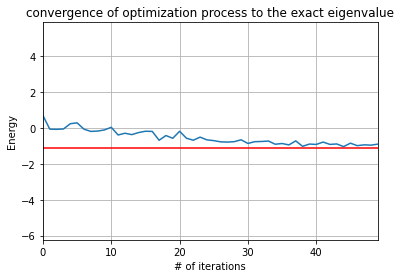

In [287]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [288]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

3it [00:00, 22.91it/s]

{'010': 456, '101': 322, '001': 66, '000': 31, '011': 15, '100': 79, '110': 51, '111': 4}
1.0
{'010': 292, '001': 90, '101': 371, '100': 43, '011': 180, '111': 39, '110': 8, '000': 1}
1.0
{'000': 321, '111': 192, '011': 50, '001': 33, '110': 112, '101': 133, '010': 171, '100': 12}
1.0
{'010': 450, '100': 97, '101': 318, '110': 37, '001': 64, '111': 5, '000': 38, '011': 15}
1.0
{'110': 257, '101': 332, '001': 56, '010': 240, '100': 113, '011': 12, '111': 5, '000': 9}
1.0


7it [00:00, 21.71it/s]


{'100': 79, '101': 303, '010': 456, '011': 23, '001': 69, '110': 48, '000': 44, '111': 2}
1.0
{'010': 448, '101': 338, '110': 41, '100': 77, '011': 16, '000': 33, '001': 66, '111': 5}
1.0


1it [00:00,  9.55it/s]

{'010': 320, '101': 301, '001': 68, '011': 32, '100': 49, '000': 145, '110': 59, '111': 50}
1.0


3it [00:00, 12.33it/s]

{'011': 179, '001': 204, '101': 287, '110': 100, '100': 69, '111': 10, '010': 127, '000': 48}
1.0
{'111': 65, '101': 304, '000': 199, '001': 90, '010': 247, '100': 53, '110': 55, '011': 11}
1.0
{'010': 295, '101': 308, '110': 53, '000': 152, '100': 50, '111': 56, '001': 79, '011': 31}
1.0
{'101': 354, '000': 49, '100': 152, '111': 89, '110': 205, '010': 101, '001': 71, '011': 3}
1.0
{'010': 315, '100': 61, '111': 71, '001': 55, '000': 128, '101': 315, '110': 57, '011': 22}


7it [00:00, 15.84it/s]


1.0
{'101': 329, '010': 288, '001': 72, '000': 156, '111': 58, '110': 36, '100': 65, '011': 20}
1.0


0it [00:00, ?it/s]

{'100': 64, '110': 251, '010': 361, '001': 63, '101': 277, '011': 8}
1.0
{'010': 153, '011': 173, '101': 321, '100': 41, '111': 131, '000': 41, '001': 44, '110': 120}
1.0
{'001': 53, '110': 253, '101': 161, '010': 169, '000': 141, '111': 148, '100': 55, '011': 44}
1.0


3it [00:00, 23.35it/s]

{'110': 240, '001': 87, '100': 72, '010': 339, '101': 276, '011': 8, '000': 1, '111': 1}
1.0
{'010': 320, '110': 272, '001': 65, '000': 55, '100': 43, '101': 265, '011': 2, '111': 2}
1.0


6it [00:00, 21.34it/s]

{'101': 259, '001': 109, '110': 226, '010': 352, '100': 70, '011': 7, '000': 1}
1.0


7it [00:00, 18.76it/s]

{'100': 69, '010': 370, '101': 262, '110': 234, '001': 86, '011': 2, '000': 1}
1.0



0it [00:00, ?it/s]

{'110': 453, '001': 186, '010': 173, '101': 105, '100': 86, '011': 18, '111': 1, '000': 2}
1.0


2it [00:00, 15.21it/s]

{'001': 105, '111': 260, '010': 130, '011': 88, '101': 178, '110': 190, '000': 55, '100': 18}
1.0
{'110': 460, '000': 100, '100': 99, '001': 118, '111': 63, '010': 74, '011': 64, '101': 46}
1.0
{'110': 453, '100': 81, '010': 171, '101': 130, '001': 164, '000': 5, '011': 16, '111': 4}
1.0


5it [00:00, 18.41it/s]

{'101': 255, '100': 57, '010': 377, '110': 284, '011': 16, '001': 13, '000': 13, '111': 9}
1.0
{'001': 171, '000': 2, '100': 93, '110': 456, '010': 169, '101': 113, '011': 16, '111': 4}
1.0


7it [00:00, 18.77it/s]


{'110': 495, '010': 160, '100': 71, '001': 168, '101': 107, '011': 14, '111': 3, '000': 6}
1.0


0it [00:00, ?it/s]

{'101': 153, '010': 292, '111': 119, '100': 130, '110': 172, '000': 89, '001': 60, '011': 9}
1.0
{'011': 156, '101': 310, '010': 138, '000': 152, '111': 144, '110': 123, '100': 1}
1.0


3it [00:00, 21.98it/s]

{'111': 257, '010': 323, '110': 263, '001': 39, '000': 28, '101': 20, '011': 29, '100': 65}
1.0
{'101': 177, '110': 172, '111': 109, '000': 93, '100': 133, '010': 268, '001': 66, '011': 6}
1.0
{'101': 200, '110': 259, '010': 178, '111': 59, '100': 40, '000': 174, '001': 54, '011': 60}
1.0
{'111': 116, '110': 157, '010': 266, '101': 204, '001': 77, '100': 130, '000': 70, '011': 4}


7it [00:00, 16.07it/s]

1.0
{'111': 121, '100': 117, '110': 164, '101': 181, '000': 85, '010': 277, '001': 75, '011': 4}
1.0



0it [00:00, ?it/s]

{'110': 203, '111': 126, '010': 277, '100': 103, '101': 152, '000': 99, '001': 63, '011': 1}
1.0


5it [00:00, 19.94it/s]

{'111': 214, '101': 261, '011': 134, '010': 148, '000': 145, '110': 114, '001': 7, '100': 1}
1.0
{'110': 255, '010': 339, '111': 268, '001': 32, '000': 33, '100': 39, '011': 44, '101': 14}
1.0
{'001': 55, '100': 100, '010': 304, '110': 180, '101': 146, '111': 146, '000': 92, '011': 1}
1.0
{'101': 162, '100': 34, '110': 227, '010': 260, '011': 64, '111': 68, '000': 161, '001': 48}
1.0
{'010': 282, '000': 99, '100': 112, '111': 128, '001': 64, '101': 142, '110': 196, '011': 1}
1.0


7it [00:00, 19.30it/s]


{'000': 88, '111': 134, '010': 266, '110': 209, '101': 143, '001': 50, '100': 133, '011': 1}
1.0


0it [00:00, ?it/s]

{'010': 294, '111': 107, '001': 75, '101': 168, '011': 3, '100': 125, '110': 158, '000': 94}
1.0
{'111': 169, '001': 2, '000': 177, '101': 304, '110': 124, '010': 124, '011': 121, '100': 3}
1.0


3it [00:00, 14.36it/s]

{'110': 243, '001': 48, '111': 261, '010': 337, '011': 36, '100': 49, '101': 24, '000': 26}
1.0


5it [00:00, 15.12it/s]

{'111': 110, '110': 144, '010': 266, '001': 87, '000': 81, '100': 150, '101': 183, '011': 3}
1.0
{'010': 186, '110': 226, '101': 211, '100': 36, '001': 62, '011': 68, '000': 185, '111': 50}
1.0
{'110': 167, '010': 282, '101': 184, '111': 115, '000': 74, '001': 77, '100': 117, '011': 8}
1.0


7it [00:00, 15.59it/s]


{'010': 300, '101': 171, '000': 82, '100': 108, '110': 158, '001': 84, '111': 117, '011': 4}
1.0


3it [00:00, 21.01it/s]

{'010': 324, '111': 172, '101': 110, '100': 66, '110': 203, '011': 46, '001': 51, '000': 52}
1.0
{'011': 278, '110': 248, '111': 139, '010': 68, '000': 104, '101': 151, '001': 11, '100': 25}
1.0
{'110': 254, '101': 100, '111': 181, '010': 274, '001': 83, '000': 115, '100': 15, '011': 2}
1.0
{'001': 53, '010': 337, '111': 160, '110': 199, '000': 44, '100': 67, '101': 127, '011': 37}
1.0
{'010': 178, '000': 73, '001': 57, '011': 207, '110': 354, '101': 82, '100': 43, '111': 30}
1.0


7it [00:00, 21.30it/s]


{'010': 326, '001': 55, '110': 207, '011': 50, '101': 104, '100': 67, '111': 161, '000': 54}
1.0
{'000': 57, '111': 166, '010': 315, '110': 199, '011': 46, '101': 109, '100': 72, '001': 60}
1.0


0it [00:00, ?it/s]

{'110': 104, '010': 238, '101': 286, '000': 138, '100': 8, '111': 179, '001': 40, '011': 31}
1.0


2it [00:00, 10.92it/s]

{'010': 42, '101': 201, '111': 161, '011': 224, '110': 135, '100': 116, '000': 128, '001': 17}
1.0
{'111': 407, '110': 101, '010': 316, '001': 62, '101': 69, '100': 18, '000': 46, '011': 5}
1.0


4it [00:00, 13.65it/s]

{'010': 242, '101': 282, '110': 103, '000': 146, '111': 165, '011': 38, '001': 35, '100': 13}
1.0
{'101': 290, '010': 158, '000': 81, '011': 187, '110': 158, '001': 62, '100': 61, '111': 27}
1.0


7it [00:00, 15.93it/s]


{'101': 317, '000': 130, '111': 141, '010': 257, '011': 32, '100': 15, '110': 90, '001': 42}
1.0
{'001': 37, '111': 185, '101': 289, '010': 239, '100': 18, '000': 136, '110': 101, '011': 19}
1.0


0it [00:00, ?it/s]

{'110': 263, '100': 170, '101': 134, '010': 255, '001': 38, '111': 99, '000': 48, '011': 17}
1.0


2it [00:00, 19.80it/s]

{'000': 55, '011': 152, '110': 220, '101': 276, '111': 157, '001': 50, '010': 97, '100': 17}
1.0
{'111': 207, '110': 355, '010': 301, '011': 46, '100': 70, '000': 38, '001': 4, '101': 3}
1.0
{'100': 144, '111': 86, '110': 303, '010': 239, '101': 132, '001': 42, '011': 17, '000': 61}
1.0
{'000': 117, '110': 452, '010': 92, '011': 79, '100': 102, '001': 144, '101': 23, '111': 15}
1.0


5it [00:00, 21.13it/s]

{'001': 34, '010': 220, '100': 162, '000': 74, '111': 93, '101': 149, '110': 269, '011': 23}
1.0


7it [00:00, 14.83it/s]


{'101': 139, '110': 273, '010': 237, '100': 163, '111': 78, '000': 74, '001': 47, '011': 13}
1.0


0it [00:00, ?it/s]

{'100': 260, '001': 128, '010': 222, '110': 191, '101': 76, '000': 62, '011': 19, '111': 66}
1.0


2it [00:00, 15.30it/s]

{'101': 242, '111': 157, '000': 154, '110': 127, '100': 73, '010': 191, '011': 62, '001': 18}
1.0
{'010': 283, '000': 49, '111': 90, '011': 97, '110': 317, '001': 27, '100': 103, '101': 58}
1.0


5it [00:00, 19.20it/s]

{'110': 172, '100': 243, '101': 83, '000': 65, '010': 265, '111': 64, '001': 115, '011': 17}
1.0
{'111': 74, '000': 244, '110': 363, '001': 147, '010': 81, '100': 77, '101': 26, '011': 12}
1.0
{'010': 269, '100': 229, '001': 107, '000': 70, '110': 176, '111': 76, '101': 78, '011': 19}
1.0


7it [00:00, 18.75it/s]


{'101': 87, '110': 176, '100': 233, '010': 261, '001': 118, '111': 69, '000': 61, '011': 19}
1.0


0it [00:00, ?it/s]

{'111': 22, '101': 340, '000': 78, '010': 279, '100': 144, '110': 67, '001': 92, '011': 2}
1.0
{'101': 429, '000': 164, '010': 147, '100': 30, '111': 98, '011': 127, '001': 6, '110': 23}
1.0


2it [00:00, 16.13it/s]

{'111': 262, '011': 58, '110': 146, '001': 36, '010': 312, '100': 65, '000': 51, '101': 94}
1.0


6it [00:00, 14.60it/s]

{'101': 355, '110': 78, '010': 270, '100': 155, '000': 57, '111': 23, '001': 83, '011': 3}
1.0
{'001': 32, '110': 103, '010': 217, '000': 193, '101': 431, '100': 19, '011': 13, '111': 16}
1.0
{'101': 387, '010': 235, '100': 131, '000': 60, '001': 105, '011': 4, '110': 75, '111': 27}
1.0


7it [00:00, 14.80it/s]


{'110': 91, '101': 343, '010': 258, '000': 73, '100': 123, '001': 107, '111': 23, '011': 6}
1.0


3it [00:00, 22.72it/s]

{'010': 349, '101': 296, '111': 29, '001': 121, '110': 50, '000': 97, '100': 73, '011': 9}
1.0
{'010': 256, '101': 311, '000': 204, '001': 6, '110': 6, '100': 39, '111': 58, '011': 144}
1.0
{'101': 87, '010': 337, '111': 268, '000': 92, '011': 96, '110': 109, '001': 29, '100': 6}
1.0
{'101': 318, '010': 342, '000': 87, '001': 102, '100': 92, '110': 49, '011': 11, '111': 23}
1.0
{'000': 145, '100': 12, '111': 33, '010': 327, '001': 91, '101': 328, '110': 83, '011': 5}
1.0


7it [00:00, 18.84it/s]


{'010': 333, '001': 130, '101': 306, '110': 48, '111': 31, '000': 96, '100': 64, '011': 16}
1.0
{'011': 14, '111': 25, '101': 307, '110': 48, '010': 342, '000': 92, '100': 63, '001': 133}
1.0


0it [00:00, ?it/s]

{'001': 284, '101': 125, '111': 73, '010': 202, '110': 152, '000': 79, '100': 103, '011': 6}
1.0


2it [00:00, 13.56it/s]

{'000': 347, '111': 192, '010': 100, '101': 229, '001': 46, '110': 46, '011': 63, '100': 1}
1.0
{'011': 212, '110': 216, '010': 252, '001': 108, '000': 22, '111': 171, '100': 30, '101': 13}
1.0


4it [00:00, 13.92it/s]

{'001': 289, '101': 146, '010': 189, '110': 168, '100': 91, '000': 70, '111': 59, '011': 12}
1.0
{'010': 343, '011': 8, '101': 418, '000': 185, '111': 55, '001': 13, '100': 2}
1.0
{'000': 73, '010': 172, '111': 74, '101': 142, '001': 288, '110': 157, '100': 108, '011': 10}


7it [00:00, 12.49it/s]

1.0
{'101': 124, '111': 64, '010': 203, '100': 84, '001': 290, '110': 170, '000': 83, '011': 6}
1.0



0it [00:00, ?it/s]

{'001': 188, '100': 108, '101': 180, '110': 100, '000': 76, '010': 269, '011': 76, '111': 27}
1.0


2it [00:00, 13.56it/s]

{'100': 69, '000': 254, '101': 215, '010': 298, '110': 49, '011': 44, '111': 86, '001': 9}
1.0
{'110': 89, '111': 192, '010': 307, '011': 217, '001': 39, '101': 48, '100': 104, '000': 28}
1.0


4it [00:00, 13.81it/s]

{'011': 103, '010': 282, '001': 161, '100': 109, '110': 89, '000': 81, '101': 167, '111': 32}
1.0
{'101': 390, '010': 274, '011': 26, '111': 77, '001': 12, '000': 170, '110': 46, '100': 29}
1.0


6it [00:00,  9.71it/s]

{'111': 35, '010': 272, '001': 170, '110': 98, '101': 187, '011': 71, '100': 95, '000': 96}
1.0


7it [00:00, 10.63it/s]


{'010': 280, '000': 86, '100': 99, '101': 197, '001': 170, '111': 28, '110': 88, '011': 76}
1.0


0it [00:00, ?it/s]

{'101': 329, '010': 399, '110': 94, '100': 91, '000': 18, '001': 38, '011': 53, '111': 2}
1.0


2it [00:00, 14.71it/s]

{'101': 352, '010': 386, '011': 94, '111': 44, '000': 55, '110': 27, '100': 49, '001': 17}
1.0
{'011': 114, '110': 116, '000': 174, '101': 179, '010': 249, '111': 166, '100': 21, '001': 5}
1.0
{'011': 73, '101': 322, '110': 95, '010': 376, '000': 24, '100': 92, '001': 39, '111': 3}
1.0


4it [00:00, 14.34it/s]

{'100': 26, '000': 88, '010': 336, '101': 305, '110': 117, '001': 75, '111': 39, '011': 38}
1.0


6it [00:00, 14.54it/s]

{'010': 401, '101': 335, '011': 66, '110': 92, '100': 67, '001': 36, '000': 25, '111': 2}
1.0


7it [00:00, 12.15it/s]


{'101': 322, '010': 392, '001': 42, '011': 74, '100': 84, '110': 85, '000': 24, '111': 1}
1.0


0it [00:00, ?it/s]

{'110': 38, '010': 376, '000': 123, '101': 326, '001': 88, '111': 40, '100': 29, '011': 4}
1.0


2it [00:00,  7.89it/s]

{'000': 148, '011': 260, '100': 152, '010': 129, '001': 49, '111': 37, '101': 221, '110': 28}
1.0
{'110': 76, '010': 387, '111': 308, '000': 89, '101': 69, '001': 34, '011': 60, '100': 1}
1.0


4it [00:00, 10.15it/s]

{'010': 378, '000': 129, '001': 83, '101': 321, '100': 32, '111': 34, '110': 39, '011': 8}
1.0
{'101': 299, '110': 97, '011': 26, '111': 16, '000': 114, '100': 43, '010': 298, '001': 131}
1.0


6it [00:00,  9.53it/s]

{'000': 113, '010': 368, '101': 360, '110': 33, '001': 85, '100': 28, '111': 31, '011': 6}
1.0


7it [00:00,  9.42it/s]


{'001': 90, '100': 25, '010': 362, '011': 7, '101': 354, '111': 32, '110': 43, '000': 111}
1.0


0it [00:00, ?it/s]

{'001': 100, '000': 55, '010': 405, '101': 203, '100': 120, '111': 94, '110': 29, '011': 18}
1.0


2it [00:00, 11.70it/s]

{'011': 274, '000': 149, '101': 316, '010': 149, '100': 25, '111': 42, '110': 64, '001': 5}
1.0
{'010': 294, '111': 254, '101': 50, '000': 169, '110': 96, '011': 59, '001': 51, '100': 51}
1.0


4it [00:00,  9.34it/s]

{'011': 30, '010': 381, '100': 101, '101': 251, '001': 95, '000': 46, '111': 93, '110': 27}
1.0


5it [00:00,  9.12it/s]

{'000': 138, '110': 131, '101': 259, '010': 299, '001': 62, '011': 52, '100': 19, '111': 64}
1.0


7it [00:00,  9.80it/s]

{'010': 388, '110': 32, '101': 229, '000': 62, '111': 94, '001': 90, '100': 103, '011': 26}
1.0
{'111': 101, '101': 213, '010': 398, '001': 98, '110': 29, '100': 116, '000': 46, '011': 23}
1.0



0it [00:00, ?it/s]

{'101': 359, '000': 92, '010': 402, '001': 77, '111': 37, '110': 31, '100': 26}
1.0


2it [00:00, 13.20it/s]

{'100': 138, '011': 179, '010': 209, '101': 290, '111': 50, '000': 155, '110': 2, '001': 1}
1.0
{'101': 228, '111': 187, '010': 278, '000': 237, '001': 28, '011': 37, '110': 27, '100': 2}
1.0


4it [00:00, 10.19it/s]

{'111': 26, '101': 381, '000': 90, '010': 399, '001': 80, '100': 28, '110': 16, '011': 4}
1.0
{'101': 342, '100': 42, '010': 324, '110': 152, '001': 73, '011': 14, '000': 64, '111': 13}
1.0


7it [00:00, 10.25it/s]


{'010': 421, '101': 375, '001': 96, '110': 12, '000': 79, '100': 16, '111': 25}
1.0
{'101': 365, '010': 435, '001': 66, '000': 95, '100': 16, '110': 15, '111': 30, '011': 2}
1.0


0it [00:00, ?it/s]

{'101': 238, '010': 287, '001': 100, '000': 110, '011': 61, '111': 42, '110': 45, '100': 141}
1.0


4it [00:00, 14.32it/s]

{'011': 86, '000': 210, '101': 353, '010': 252, '111': 74, '110': 10, '100': 27, '001': 12}
1.0
{'110': 147, '001': 73, '010': 356, '011': 114, '111': 217, '101': 51, '100': 30, '000': 36}
1.0
{'011': 71, '010': 298, '101': 240, '100': 156, '000': 69, '001': 123, '111': 34, '110': 33}
1.0


7it [00:00, 12.15it/s]


{'101': 330, '111': 55, '010': 277, '000': 193, '100': 22, '110': 65, '011': 61, '001': 21}
1.0
{'010': 303, '001': 121, '100': 125, '000': 104, '101': 236, '110': 31, '011': 66, '111': 38}
1.0
{'101': 265, '010': 267, '011': 66, '000': 94, '111': 47, '001': 117, '100': 134, '110': 34}
1.0


1it [00:00,  3.60it/s]

{'001': 60, '010': 457, '011': 60, '111': 143, '101': 188, '100': 21, '110': 93, '000': 2}
1.0
{'101': 176, '010': 417, '001': 43, '111': 205, '011': 97, '000': 32, '100': 50, '110': 4}
1.0


4it [00:00,  6.89it/s]

{'010': 221, '000': 193, '111': 315, '110': 132, '101': 15, '011': 123, '100': 18, '001': 7}
1.0
{'010': 428, '100': 25, '110': 84, '011': 65, '101': 204, '001': 82, '111': 134, '000': 2}
1.0


7it [00:00,  7.73it/s]


{'010': 431, '110': 94, '100': 6, '000': 16, '101': 233, '111': 176, '011': 30, '001': 38}
1.0
{'101': 203, '110': 89, '010': 449, '100': 20, '111': 138, '011': 67, '001': 55, '000': 3}
1.0
{'110': 101, '111': 140, '010': 420, '101': 187, '100': 26, '001': 70, '011': 78, '000': 2}
1.0


1it [00:00,  9.90it/s]

{'110': 185, '001': 307, '101': 119, '010': 205, '000': 25, '011': 31, '100': 138, '111': 14}
1.0
{'011': 100, '010': 145, '000': 230, '101': 239, '111': 109, '001': 102, '110': 84, '100': 15}
1.0


4it [00:00,  8.25it/s]

{'110': 254, '011': 245, '111': 114, '010': 200, '100': 43, '001': 83, '000': 56, '101': 29}
1.0
{'001': 317, '110': 177, '100': 140, '010': 210, '101': 106, '011': 28, '000': 31, '111': 15}
1.0


7it [00:00,  9.58it/s]


{'101': 328, '110': 46, '001': 83, '000': 131, '010': 360, '100': 30, '111': 39, '011': 7}
1.0
{'001': 299, '110': 188, '010': 226, '000': 23, '100': 140, '011': 27, '111': 14, '101': 107}
1.0
{'001': 327, '010': 198, '101': 116, '100': 136, '111': 12, '110': 183, '000': 25, '011': 27}
1.0


2it [00:00, 11.30it/s]

{'000': 97, '001': 122, '010': 385, '101': 274, '111': 26, '100': 74, '110': 35, '011': 11}
1.0
{'111': 42, '010': 216, '101': 255, '011': 174, '100': 132, '001': 57, '000': 110, '110': 38}
1.0


4it [00:00,  8.29it/s]

{'101': 84, '111': 264, '010': 362, '110': 114, '011': 87, '000': 87, '001': 22, '100': 4}
1.0
{'101': 313, '010': 348, '110': 44, '000': 97, '111': 41, '001': 97, '100': 71, '011': 13}
1.0
{'001': 78, '000': 145, '101': 340, '010': 349, '111': 23, '110': 64, '100': 21, '011': 4}
1.0


7it [00:00,  9.76it/s]


{'001': 123, '100': 70, '000': 102, '101': 301, '010': 347, '111': 29, '110': 41, '011': 11}
1.0
{'001': 123, '010': 363, '111': 31, '101': 300, '110': 52, '000': 80, '100': 68, '011': 7}
1.0


0it [00:00, ?it/s]

{'010': 374, '000': 81, '101': 296, '001': 127, '100': 63, '011': 12, '110': 40, '111': 31}
1.0


2it [00:00,  9.33it/s]

{'111': 49, '001': 59, '101': 242, '010': 185, '100': 125, '011': 207, '110': 35, '000': 122}
1.0


3it [00:00,  8.45it/s]

{'010': 421, '111': 228, '100': 8, '011': 88, '101': 110, '110': 97, '001': 35, '000': 37}
1.0


5it [00:00,  9.70it/s]

{'001': 122, '010': 345, '101': 304, '000': 78, '110': 52, '100': 70, '111': 38, '011': 15}
1.0
{'101': 341, '010': 324, '000': 149, '001': 80, '110': 80, '100': 19, '111': 28, '011': 3}
1.0
{'010': 344, '100': 85, '101': 319, '110': 48, '111': 36, '000': 69, '001': 113, '011': 10}
1.0


7it [00:00,  9.71it/s]


{'101': 296, '000': 88, '100': 61, '010': 384, '001': 106, '110': 45, '111': 31, '011': 13}
1.0


1it [00:00,  7.57it/s]

{'000': 79, '001': 118, '101': 295, '010': 371, '100': 71, '110': 47, '111': 30, '011': 13}
1.0


2it [00:00,  7.18it/s]

{'010': 179, '000': 155, '101': 268, '100': 114, '011': 177, '111': 47, '001': 55, '110': 29}
1.0


4it [00:00,  9.83it/s]

{'111': 199, '010': 400, '000': 53, '101': 110, '100': 10, '001': 38, '110': 119, '011': 95}
1.0
{'101': 302, '010': 324, '100': 78, '000': 99, '001': 131, '110': 49, '111': 31, '011': 10}
1.0
{'101': 406, '010': 326, '000': 133, '110': 91, '011': 3, '001': 26, '111': 37, '100': 2}
1.0


7it [00:00, 10.71it/s]


{'010': 332, '111': 33, '101': 322, '001': 118, '000': 85, '100': 66, '110': 61, '011': 7}
1.0
{'001': 111, '100': 51, '110': 41, '010': 368, '101': 326, '000': 90, '111': 28, '011': 9}
1.0


0it [00:00, ?it/s]

{'010': 357, '101': 261, '001': 88, '011': 37, '000': 75, '100': 85, '110': 23, '111': 98}
1.0


2it [00:00, 10.75it/s]

{'101': 203, '011': 113, '100': 150, '001': 124, '010': 239, '111': 109, '000': 74, '110': 12}
1.0
{'011': 158, '000': 123, '111': 314, '100': 51, '110': 53, '010': 281, '101': 31, '001': 13}
1.0


4it [00:00,  9.09it/s]

{'010': 345, '111': 87, '101': 244, '001': 128, '110': 23, '011': 44, '100': 75, '000': 78}
1.0


5it [00:00,  9.09it/s]

{'010': 272, '101': 250, '000': 149, '001': 95, '100': 15, '111': 98, '011': 46, '110': 99}
1.0


7it [00:00,  9.81it/s]


{'010': 318, '101': 270, '111': 116, '001': 102, '110': 31, '011': 38, '000': 79, '100': 70}
1.0
{'100': 67, '011': 46, '010': 341, '110': 24, '101': 244, '111': 104, '000': 63, '001': 135}
1.0


1it [00:00,  7.59it/s]

{'101': 336, '010': 309, '001': 170, '110': 30, '100': 52, '000': 109, '111': 16, '011': 2}
1.0


2it [00:00,  7.20it/s]

{'111': 20, '101': 229, '000': 208, '001': 102, '011': 149, '100': 108, '010': 153, '110': 55}
1.0


4it [00:00,  9.18it/s]

{'010': 395, '001': 85, '011': 88, '111': 234, '101': 116, '100': 5, '000': 27, '110': 74}
1.0
{'010': 296, '001': 167, '000': 112, '101': 335, '111': 25, '100': 39, '110': 49, '011': 1}
1.0


7it [00:00,  9.14it/s]


{'010': 236, '110': 98, '101': 410, '001': 85, '000': 147, '100': 23, '111': 13, '011': 12}
1.0
{'001': 184, '101': 345, '000': 99, '010': 284, '111': 31, '110': 38, '100': 43}
1.0
{'000': 89, '010': 294, '001': 182, '101': 352, '100': 35, '110': 46, '111': 26}
1.0


2it [00:00, 15.21it/s]

{'110': 74, '100': 101, '011': 83, '111': 75, '001': 51, '000': 145, '101': 253, '010': 242}
1.0
{'011': 240, '010': 80, '110': 135, '000': 155, '101': 283, '100': 97, '111': 10, '001': 24}
1.0
{'010': 309, '101': 249, '000': 20, '111': 84, '110': 181, '011': 131, '001': 30, '100': 20}
1.0


4it [00:00, 13.52it/s]

{'101': 279, '010': 224, '000': 147, '001': 49, '011': 79, '110': 58, '100': 112, '111': 76}
1.0
{'010': 293, '001': 97, '101': 213, '111': 157, '000': 163, '100': 72, '110': 29}
1.0


7it [00:00, 10.79it/s]


{'001': 60, '111': 82, '100': 111, '010': 214, '101': 252, '110': 60, '011': 84, '000': 161}
1.0
{'010': 214, '101': 281, '011': 102, '111': 68, '110': 66, '100': 106, '000': 128, '001': 59}
1.0


3it [00:00, 12.61it/s]

{'101': 333, '010': 408, '001': 95, '000': 103, '100': 42, '111': 20, '011': 12, '110': 11}
1.0
{'011': 218, '010': 208, '000': 91, '100': 176, '101': 182, '001': 118, '111': 22, '110': 9}
1.0
{'111': 218, '010': 455, '101': 136, '011': 98, '110': 16, '100': 21, '000': 61, '001': 19}
1.0


5it [00:00, 12.80it/s]

{'001': 111, '010': 411, '000': 96, '101': 325, '100': 32, '111': 26, '011': 16, '110': 7}
1.0
{'101': 245, '001': 170, '110': 160, '000': 93, '010': 261, '100': 59, '111': 32, '011': 4}
1.0
{'101': 303, '010': 411, '100': 43, '000': 102, '001': 121, '110': 7, '011': 21, '111': 16}
1.0
{'010': 399, '000': 96, '101': 309, '001': 130, '110': 12, '100': 44, '111': 17, '011': 17}
1.0


7it [00:00, 12.96it/s]
2it [00:00,  7.50it/s]

{'001': 100, '010': 355, '000': 127, '110': 94, '101': 231, '111': 84, '100': 23, '011': 10}
1.0
{'100': 175, '010': 141, '001': 73, '011': 242, '000': 153, '101': 67, '110': 154, '111': 19}
1.0
{'010': 354, '100': 57, '001': 85, '101': 152, '000': 182, '111': 113, '011': 30, '110': 51}
1.0


6it [00:00, 11.35it/s]

{'111': 89, '101': 190, '010': 376, '100': 37, '001': 132, '000': 120, '110': 71, '011': 9}
1.0
{'110': 121, '100': 68, '010': 353, '001': 49, '101': 259, '011': 79, '000': 75, '111': 20}
1.0
{'010': 390, '000': 130, '100': 34, '101': 205, '111': 73, '110': 65, '001': 115, '011': 12}
1.0


7it [00:00, 10.61it/s]


{'010': 349, '111': 94, '101': 193, '100': 40, '001': 119, '000': 129, '110': 83, '011': 17}
1.0


0it [00:00, ?it/s]

{'011': 30, '110': 30, '000': 171, '111': 111, '010': 249, '100': 77, '001': 101, '101': 255}
1.0


2it [00:00,  7.89it/s]

{'001': 101, '011': 137, '010': 143, '000': 181, '101': 229, '100': 116, '111': 59, '110': 58}
1.0


4it [00:00,  9.63it/s]

{'111': 248, '110': 90, '010': 408, '101': 92, '011': 123, '100': 23, '000': 16, '001': 24}
1.0
{'100': 91, '101': 246, '010': 254, '111': 101, '001': 109, '000': 170, '011': 29, '110': 24}
1.0
{'010': 203, '101': 284, '000': 244, '111': 100, '110': 62, '001': 72, '100': 48, '011': 11}
1.0


7it [00:00, 10.88it/s]


{'010': 266, '000': 182, '001': 111, '101': 239, '100': 77, '011': 20, '111': 102, '110': 27}
1.0
{'111': 100, '101': 223, '010': 281, '000': 164, '001': 117, '100': 88, '011': 27, '110': 24}
1.0


0it [00:00, ?it/s]

{'101': 382, '010': 325, '000': 168, '110': 54, '011': 27, '111': 30, '001': 38}
1.0


2it [00:00,  9.88it/s]

{'010': 203, '100': 203, '101': 171, '110': 54, '001': 66, '000': 161, '011': 130, '111': 36}
1.0


3it [00:00,  7.77it/s]

{'010': 459, '101': 189, '111': 202, '100': 36, '110': 29, '000': 47, '001': 28, '011': 34}
1.0


4it [00:00,  8.02it/s]

{'101': 371, '111': 35, '000': 185, '010': 315, '110': 59, '001': 28, '011': 31}
1.0
{'110': 54, '001': 103, '111': 4, '010': 329, '101': 296, '000': 98, '011': 58, '100': 82}
1.0


6it [00:00,  9.81it/s]

{'010': 325, '001': 41, '101': 345, '000': 179, '110': 60, '111': 45, '011': 29}
1.0


7it [00:00,  9.49it/s]


{'010': 335, '001': 28, '101': 395, '000': 160, '110': 55, '011': 26, '111': 25}
1.0


0it [00:00, ?it/s]

{'001': 140, '010': 350, '101': 301, '100': 86, '000': 82, '111': 33, '110': 25, '011': 7}
1.0


2it [00:00, 12.12it/s]

{'001': 77, '011': 151, '010': 156, '000': 164, '101': 295, '100': 122, '110': 30, '111': 29}
1.0


5it [00:00,  8.09it/s]

{'101': 139, '000': 48, '110': 116, '111': 196, '100': 18, '010': 357, '011': 90, '001': 60}
1.0
{'010': 315, '001': 134, '101': 339, '000': 91, '110': 30, '100': 81, '111': 21, '011': 13}
1.0
{'101': 378, '010': 307, '111': 29, '100': 17, '000': 155, '001': 72, '110': 63, '011': 3}
1.0


7it [00:00,  9.08it/s]


{'110': 23, '100': 71, '001': 155, '010': 333, '101': 314, '000': 96, '111': 20, '011': 12}
1.0
{'010': 336, '101': 338, '001': 122, '000': 105, '100': 73, '110': 33, '011': 8, '111': 9}
1.0


2it [00:00,  6.30it/s]

{'101': 193, '110': 76, '010': 250, '001': 260, '111': 7, '100': 186, '011': 39, '000': 13}
1.0
{'011': 93, '010': 204, '101': 300, '000': 161, '001': 124, '110': 61, '111': 25, '100': 56}
1.0


6it [00:00, 11.34it/s]

{'101': 90, '110': 269, '000': 92, '011': 239, '001': 50, '111': 82, '010': 182, '100': 20}
1.0
{'101': 170, '100': 201, '010': 257, '001': 272, '111': 8, '110': 74, '011': 33, '000': 9}
1.0
{'000': 103, '101': 223, '011': 7, '001': 233, '010': 194, '110': 140, '100': 83, '111': 41}
1.0
{'110': 76, '001': 276, '010': 219, '100': 200, '101': 187, '011': 41, '000': 21, '111': 4}
1.0


7it [00:00, 10.37it/s]


{'110': 82, '100': 204, '001': 257, '010': 232, '011': 33, '101': 197, '000': 16, '111': 3}
1.0


0it [00:00, ?it/s]

{'110': 75, '010': 327, '101': 276, '100': 73, '111': 36, '011': 15, '001': 154, '000': 68}
1.0


2it [00:00,  9.20it/s]

{'100': 111, '010': 158, '101': 237, '011': 173, '110': 54, '111': 50, '001': 79, '000': 162}
1.0


3it [00:00,  8.05it/s]

{'110': 133, '010': 373, '001': 44, '101': 107, '011': 106, '111': 192, '000': 54, '100': 15}
1.0


5it [00:00, 10.16it/s]

{'010': 298, '101': 284, '001': 158, '100': 78, '110': 76, '000': 81, '111': 33, '011': 16}
1.0
{'101': 381, '110': 58, '010': 344, '000': 143, '001': 47, '111': 38, '100': 11, '011': 2}
1.0
{'010': 355, '000': 80, '101': 236, '100': 82, '001': 162, '110': 69, '111': 34, '011': 6}
1.0


7it [00:00, 10.60it/s]


{'101': 261, '110': 83, '010': 332, '000': 93, '001': 147, '111': 31, '100': 65, '011': 12}
1.0


0it [00:00, ?it/s]

{'001': 272, '111': 46, '000': 82, '110': 163, '100': 108, '101': 161, '010': 180, '011': 12}
1.0


2it [00:00, 14.06it/s]

{'101': 188, '011': 146, '111': 94, '010': 97, '100': 75, '110': 115, '000': 177, '001': 132}
1.0
{'111': 149, '001': 124, '000': 45, '011': 158, '110': 240, '010': 233, '101': 51, '100': 24}
1.0


4it [00:00,  8.69it/s]

{'001': 279, '100': 104, '010': 212, '101': 156, '110': 142, '000': 76, '111': 47, '011': 8}
1.0


7it [00:00, 10.87it/s]

{'101': 402, '000': 182, '011': 7, '010': 366, '111': 50, '110': 5, '001': 9, '100': 3}
1.0
{'010': 217, '101': 151, '100': 137, '111': 41, '001': 257, '110': 135, '000': 77, '011': 9}
1.0
{'001': 266, '000': 88, '010': 215, '110': 132, '101': 159, '100': 100, '111': 49, '011': 15}
1.0



2it [00:00, 15.44it/s]

{'000': 88, '110': 125, '010': 280, '001': 167, '101': 238, '111': 29, '011': 7, '100': 90}
1.0
{'000': 200, '010': 153, '100': 84, '101': 266, '011': 129, '110': 78, '001': 36, '111': 78}
1.0
{'010': 305, '101': 95, '111': 205, '110': 211, '011': 112, '001': 58, '000': 28, '100': 10}
1.0


4it [00:00, 10.08it/s]

{'101': 227, '110': 135, '111': 28, '100': 97, '000': 84, '001': 180, '010': 264, '011': 9}
1.0
{'000': 158, '010': 375, '110': 20, '101': 389, '001': 20, '111': 45, '011': 6, '100': 11}
1.0


7it [00:00, 10.55it/s]


{'001': 162, '010': 274, '101': 283, '110': 108, '000': 78, '100': 78, '111': 36, '011': 5}
1.0
{'100': 76, '011': 19, '111': 38, '101': 229, '001': 163, '110': 137, '010': 274, '000': 88}
1.0


0it [00:00, ?it/s]

{'010': 295, '001': 186, '101': 212, '000': 112, '111': 79, '110': 58, '100': 69, '011': 13}
1.0


2it [00:00,  9.73it/s]

{'111': 28, '010': 145, '101': 177, '000': 122, '001': 214, '110': 120, '011': 147, '100': 71}
1.0


3it [00:00,  9.25it/s]

{'000': 119, '001': 84, '111': 143, '010': 309, '011': 116, '101': 168, '110': 80, '100': 5}
1.0
{'011': 10, '001': 205, '101': 193, '100': 62, '010': 290, '111': 94, '000': 107, '110': 63}
1.0


5it [00:00,  9.75it/s]

{'001': 245, '011': 29, '000': 133, '101': 184, '110': 162, '111': 58, '010': 190, '100': 23}
1.0


7it [00:00, 10.82it/s]


{'100': 48, '010': 275, '101': 220, '001': 219, '111': 85, '110': 65, '000': 102, '011': 10}
1.0
{'001': 178, '101': 235, '010': 295, '111': 87, '011': 12, '000': 115, '110': 55, '100': 47}
1.0


0it [00:00, ?it/s]

{'101': 355, '010': 318, '000': 80, '001': 88, '100': 107, '110': 51, '111': 16, '011': 9}
1.0


4it [00:00, 15.10it/s]

{'110': 42, '101': 292, '000': 145, '001': 34, '100': 170, '010': 126, '011': 189, '111': 26}
1.0
{'011': 50, '111': 246, '110': 146, '010': 345, '101': 135, '000': 41, '001': 47, '100': 14}
1.0
{'010': 308, '110': 43, '001': 92, '101': 374, '100': 91, '000': 77, '111': 29, '011': 10}
1.0
{'100': 28, '010': 292, '101': 384, '000': 154, '110': 95, '001': 47, '111': 17, '011': 7}

6it [00:00, 11.28it/s]


1.0
{'010': 311, '101': 366, '001': 81, '100': 106, '110': 44, '000': 81, '111': 20, '011': 15}
1.0


7it [00:00, 11.44it/s]


{'000': 94, '010': 306, '101': 350, '001': 87, '110': 36, '100': 110, '111': 33, '011': 8}
1.0


0it [00:00, ?it/s]

{'001': 41, '010': 550, '110': 43, '011': 37, '101': 273, '100': 64, '000': 6, '111': 10}
1.0


2it [00:00,  9.88it/s]

{'011': 337, '101': 198, '010': 277, '100': 113, '000': 14, '001': 41, '111': 26, '110': 18}
1.0
{'010': 279, '101': 90, '111': 210, '000': 273, '110': 100, '011': 70, '100': 2}
1.0


4it [00:00, 12.94it/s]

{'010': 533, '101': 291, '100': 61, '110': 47, '011': 45, '001': 34, '111': 10, '000': 3}
1.0
{'010': 479, '101': 249, '110': 132, '100': 31, '001': 62, '111': 31, '000': 29, '011': 11}
1.0


7it [00:00, 13.44it/s]

{'101': 251, '010': 543, '110': 50, '100': 67, '011': 49, '001': 48, '111': 13, '000': 3}
1.0
{'010': 526, '101': 285, '110': 56, '001': 48, '011': 35, '100': 59, '111': 12, '000': 3}
1.0



0it [00:00, ?it/s]

{'011': 47, '010': 364, '101': 281, '100': 124, '001': 109, '110': 57, '000': 31, '111': 11}
1.0


2it [00:00,  9.57it/s]

{'101': 279, '010': 286, '000': 143, '001': 31, '111': 57, '011': 162, '100': 46, '110': 20}
1.0


3it [00:00,  8.09it/s]

{'011': 141, '010': 334, '111': 187, '000': 86, '110': 145, '101': 94, '100': 13, '001': 24}
1.0


5it [00:00,  9.32it/s]

{'101': 266, '010': 353, '000': 53, '011': 49, '100': 101, '001': 142, '110': 46, '111': 14}
1.0
{'010': 358, '100': 28, '110': 76, '101': 326, '000': 126, '111': 54, '001': 55, '011': 1}
1.0
{'111': 17, '010': 366, '101': 293, '100': 105, '001': 102, '011': 43, '000': 40, '110': 58}
1.0


7it [00:00, 10.53it/s]


{'101': 255, '001': 118, '100': 98, '011': 32, '010': 396, '111': 15, '000': 54, '110': 56}
1.0


2it [00:00, 18.52it/s]

{'101': 279, '001': 143, '000': 92, '110': 64, '100': 73, '010': 335, '011': 7, '111': 31}
1.0
{'100': 143, '101': 217, '010': 149, '011': 192, '000': 143, '110': 40, '001': 102, '111': 38}
1.0
{'111': 230, '010': 338, '011': 115, '101': 100, '000': 45, '001': 64, '110': 125, '100': 7}
1.0


4it [00:00, 12.40it/s]

{'000': 110, '101': 273, '111': 42, '100': 65, '010': 312, '001': 148, '110': 68, '011': 6}
1.0
{'101': 341, '100': 26, '000': 140, '010': 312, '110': 77, '001': 85, '111': 29, '011': 14}
1.0


6it [00:00, 13.48it/s]

{'010': 343, '101': 243, '001': 150, '000': 100, '110': 69, '100': 67, '111': 47, '011': 5}
1.0


7it [00:00, 13.17it/s]


{'010': 369, '001': 148, '000': 88, '101': 265, '100': 60, '110': 53, '111': 40, '011': 1}
1.0


0it [00:00, ?it/s]

{'000': 66, '011': 15, '010': 369, '101': 320, '001': 85, '100': 108, '111': 28, '110': 33}
1.0


2it [00:00, 13.42it/s]

{'101': 219, '011': 260, '010': 115, '100': 219, '000': 111, '110': 9, '001': 54, '111': 37}
1.0


4it [00:00, 13.86it/s]

{'111': 263, '010': 348, '100': 50, '000': 73, '001': 53, '101': 95, '110': 76, '011': 66}
1.0
{'001': 101, '010': 373, '101': 337, '111': 22, '100': 99, '011': 23, '110': 25, '000': 44}
1.0
{'110': 112, '010': 301, '101': 299, '011': 14, '000': 97, '111': 18, '100': 74, '001': 109}
1.0


7it [00:00, 14.80it/s]


{'010': 368, '101': 342, '000': 67, '100': 91, '001': 92, '011': 21, '111': 23, '110': 20}
1.0
{'010': 406, '100': 100, '101': 314, '110': 25, '001': 87, '111': 19, '000': 60, '011': 13}
1.0


1it [00:00,  8.48it/s]

{'010': 345, '101': 291, '000': 84, '001': 126, '100': 87, '110': 44, '111': 39, '011': 8}
1.0


3it [00:00, 13.07it/s]

{'011': 203, '010': 150, '101': 277, '000': 136, '001': 60, '110': 69, '111': 43, '100': 86}
1.0
{'101': 160, '111': 185, '010': 361, '000': 57, '011': 86, '001': 45, '110': 116, '100': 14}
1.0


5it [00:00, 14.99it/s]

{'000': 82, '001': 117, '101': 304, '010': 341, '100': 95, '110': 47, '111': 31, '011': 7}
1.0
{'000': 172, '101': 320, '110': 75, '010': 308, '001': 78, '100': 20, '111': 46, '011': 5}
1.0


7it [00:00, 14.41it/s]

{'010': 367, '000': 87, '100': 89, '101': 289, '110': 36, '001': 95, '111': 50, '011': 11}
1.0
{'100': 81, '010': 373, '001': 105, '000': 77, '101': 278, '110': 46, '111': 51, '011': 13}
1.0


7it [00:00, 13.86it/s]
0it [00:00, ?it/s]

{'001': 72, '000': 86, '101': 373, '100': 60, '010': 386, '011': 20, '110': 19, '111': 8}
1.0


2it [00:00, 11.24it/s]

{'000': 125, '100': 177, '011': 236, '101': 242, '010': 178, '111': 25, '001': 37, '110': 4}
1.0
{'010': 453, '011': 71, '111': 224, '000': 49, '101': 140, '001': 20, '100': 27, '110': 40}
1.0


4it [00:00, 12.18it/s]

{'010': 429, '001': 67, '000': 86, '100': 50, '101': 359, '110': 17, '111': 6, '011': 10}
1.0


6it [00:00, 12.36it/s]

{'110': 110, '100': 42, '101': 339, '111': 7, '010': 299, '000': 99, '001': 115, '011': 13}
1.0
{'010': 414, '000': 106, '100': 54, '101': 330, '011': 13, '110': 19, '001': 79, '111': 9}
1.0


7it [00:00, 12.54it/s]


{'101': 376, '010': 393, '000': 87, '001': 76, '100': 54, '011': 8, '110': 19, '111': 11}
1.0


2it [00:00, 13.09it/s]

{'000': 122, '101': 364, '010': 376, '001': 83, '100': 52, '011': 5, '111': 2, '110': 20}
1.0
{'100': 162, '010': 140, '101': 256, '011': 230, '000': 157, '001': 71, '111': 7, '110': 1}
1.0
{'010': 494, '111': 193, '011': 55, '101': 147, '001': 33, '000': 32, '110': 43, '100': 27}
1.0


4it [00:00, 12.74it/s]

{'101': 363, '001': 80, '010': 370, '000': 139, '110': 22, '100': 45, '011': 4, '111': 1}
1.0
{'010': 292, '101': 329, '000': 131, '110': 118, '001': 95, '100': 52, '011': 7}
1.0


6it [00:00, 12.67it/s]

{'001': 75, '101': 332, '010': 396, '000': 136, '110': 22, '100': 53, '111': 5, '011': 5}
1.0


7it [00:00, 12.19it/s]


{'101': 336, '001': 80, '100': 67, '110': 15, '010': 402, '000': 118, '011': 6}
1.0


0it [00:00, ?it/s]

{'010': 510, '101': 354, '100': 15, '000': 64, '001': 46, '011': 9, '110': 16, '111': 10}
1.0


2it [00:00, 13.89it/s]

{'010': 250, '000': 99, '100': 215, '011': 249, '101': 154, '001': 22, '111': 30, '110': 5}
1.0


4it [00:00, 14.09it/s]

{'111': 240, '000': 116, '101': 136, '011': 34, '100': 23, '010': 439, '001': 18, '110': 18}
1.0
{'010': 514, '101': 336, '001': 40, '000': 74, '100': 22, '110': 25, '011': 7, '111': 6}
1.0
{'001': 87, '010': 337, '101': 313, '110': 166, '000': 43, '100': 57, '011': 16, '111': 5}
1.0


7it [00:00, 15.61it/s]

{'010': 486, '101': 345, '000': 85, '001': 50, '100': 24, '111': 9, '110': 19, '011': 6}
1.0
{'101': 359, '010': 489, '000': 69, '110': 24, '001': 46, '100': 26, '111': 9, '011': 2}
1.0



0it [00:00, ?it/s]

{'010': 364, '101': 352, '001': 91, '000': 96, '100': 71, '110': 15, '011': 26, '111': 9}
1.0


2it [00:00,  9.06it/s]

{'010': 150, '011': 289, '100': 182, '101': 208, '000': 123, '001': 51, '111': 20, '110': 1}
1.0


4it [00:00, 11.60it/s]

{'101': 128, '010': 386, '001': 30, '111': 226, '100': 36, '110': 59, '011': 98, '000': 61}
1.0
{'000': 94, '010': 361, '001': 90, '100': 64, '110': 15, '101': 349, '011': 40, '111': 11}
1.0
{'101': 333, '100': 70, '001': 113, '010': 239, '110': 119, '000': 98, '111': 11, '011': 41}
1.0


7it [00:00, 12.36it/s]


{'010': 399, '101': 336, '100': 64, '000': 90, '001': 76, '011': 36, '110': 12, '111': 11}
1.0
{'000': 87, '010': 375, '101': 339, '011': 32, '100': 72, '001': 82, '111': 12, '110': 25}
1.0


0it [00:00, ?it/s]

{'010': 370, '101': 363, '000': 103, '001': 103, '110': 11, '100': 43, '011': 13, '111': 18}
1.0


2it [00:00, 16.88it/s]

{'010': 218, '101': 232, '011': 205, '100': 153, '001': 56, '000': 133, '111': 27}
1.0
{'101': 109, '010': 448, '111': 235, '000': 64, '011': 89, '110': 37, '001': 25, '100': 17}
1.0


4it [00:00, 10.19it/s]

{'101': 357, '010': 411, '000': 72, '001': 107, '100': 41, '111': 16, '110': 15, '011': 5}
1.0
{'101': 297, '010': 298, '110': 144, '001': 132, '000': 92, '100': 33, '011': 14, '111': 14}
1.0


7it [00:00, 12.56it/s]

{'010': 383, '001': 97, '101': 362, '000': 103, '100': 43, '011': 13, '110': 8, '111': 15}
1.0
{'101': 350, '010': 405, '001': 104, '000': 99, '100': 36, '110': 9, '011': 8, '111': 13}
1.0



0it [00:00, ?it/s]

{'101': 384, '000': 105, '010': 402, '111': 14, '100': 31, '110': 12, '001': 72, '011': 4}
1.0


4it [00:00, 18.43it/s]

{'100': 193, '001': 66, '000': 108, '101': 206, '011': 237, '010': 190, '111': 23, '110': 1}
1.0
{'111': 303, '010': 472, '101': 113, '011': 47, '110': 24, '001': 21, '000': 28, '100': 16}
1.0
{'101': 390, '010': 421, '001': 58, '000': 87, '100': 32, '111': 19, '011': 6, '110': 11}
1.0
{'010': 283, '110': 156, '101': 302, '000': 88, '001': 151, '100': 19, '111': 7, '011': 18}
1.0


6it [00:00, 12.53it/s]

{'111': 12, '010': 403, '101': 389, '001': 72, '000': 97, '100': 36, '110': 9, '011': 6}
1.0
{'010': 417, '101': 397, '100': 26, '001': 59, '000': 89, '110': 17, '111': 15, '011': 4}
1.0


7it [00:00, 13.32it/s]


[4.38607428 2.80420973 0.05126278 3.8306205  1.85195027 5.91783093
 4.86259106 0.94801674 0.82933385 4.82701385 6.33222682 5.08141899
 4.13179553 2.88359219 3.14543133 3.69942457 5.14265953 3.18327027
 0.31927266 2.64020728 0.29247089 5.95231014 3.25984633 5.02915823]


0it [00:00, ?it/s]

{'010': 439, '101': 388, '001': 43, '100': 18, '110': 14, '000': 104, '111': 12, '011': 6}
1.0


2it [00:00, 17.09it/s]

{'000': 107, '101': 234, '010': 186, '111': 27, '011': 230, '001': 65, '100': 175}
1.0
{'110': 19, '010': 427, '111': 308, '000': 62, '101': 129, '100': 15, '001': 16, '011': 48}
1.0


4it [00:00, 16.43it/s]

{'101': 410, '011': 11, '010': 390, '000': 113, '100': 29, '110': 7, '001': 53, '111': 11}
1.0


6it [00:00, 16.57it/s]

{'000': 84, '010': 295, '101': 285, '001': 135, '110': 163, '111': 12, '100': 31, '011': 19}
1.0
{'101': 383, '010': 423, '001': 56, '000': 94, '110': 19, '100': 29, '011': 9, '111': 11}
1.0


7it [00:00, 14.45it/s]

{'101': 417, '010': 391, '011': 13, '111': 12, '001': 58, '000': 94, '100': 21, '110': 18}
1.0
CPU times: total: 26.3 s
Wall time: 29.6 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.8802526636460719

Approximation Error
0.2228791985684094


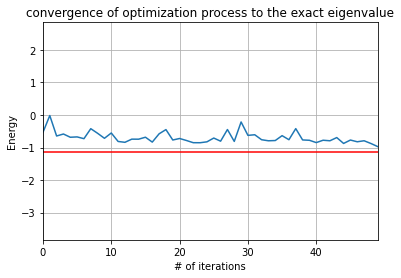

In [289]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [290]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [291]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [292]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 19.56it/s]


{'11': 316, '01': 181, '00': 356, '10': 171}
1.0
{'11': 271, '01': 415, '10': 226, '00': 112}
1.0
{'11': 440, '00': 512, '01': 52, '10': 20}
1.0


2it [00:00, 19.23it/s]

{'00': 297, '11': 180, '01': 468, '10': 79}
1.0
{'10': 389, '11': 251, '01': 380, '00': 4}
1.0


3it [00:00, 20.75it/s]


{'11': 523, '00': 248, '10': 108, '01': 145}
1.0


0it [00:00, ?it/s]

{'01': 481, '11': 29, '00': 497, '10': 17}
1.0


2it [00:00, 11.04it/s]

{'11': 486, '01': 478, '10': 42, '00': 18}
1.0


3it [00:00, 12.08it/s]


{'00': 336, '11': 351, '10': 155, '01': 182}
1.0


2it [00:00, 19.36it/s]

{'01': 481, '00': 311, '11': 57, '10': 175}
1.0
{'01': 883, '10': 35, '11': 102, '00': 4}
1.0


3it [00:00, 18.51it/s]


{'10': 9, '00': 478, '01': 415, '11': 122}
1.0


0it [00:00, ?it/s]

{'00': 710, '01': 233, '11': 67, '10': 14}
1.0
{'10': 215, '01': 473, '11': 332, '00': 4}
1.0


3it [00:00, 23.53it/s]


{'11': 103, '00': 316, '10': 409, '01': 196}
1.0


0it [00:00, ?it/s]

{'01': 321, '10': 163, '00': 476, '11': 64}
1.0
{'01': 629, '11': 232, '10': 133, '00': 30}


3it [00:00, 23.35it/s]


1.0
{'10': 309, '11': 49, '01': 341, '00': 325}
1.0


0it [00:00, ?it/s]

{'11': 238, '00': 334, '10': 146, '01': 306}
1.0


2it [00:00, 13.42it/s]

{'01': 358, '11': 302, '10': 186, '00': 178}
1.0
{'10': 357, '01': 404, '00': 112, '11': 151}
1.0


3it [00:00, 11.68it/s]
0it [00:00, ?it/s]

{'01': 150, '00': 513, '10': 248, '11': 113}
1.0


2it [00:00, 14.71it/s]

{'11': 447, '10': 432, '01': 128, '00': 17}
1.0


3it [00:00, 16.67it/s]


{'10': 722, '11': 202, '01': 64, '00': 36}
1.0


0it [00:00, ?it/s]

{'10': 492, '00': 300, '11': 114, '01': 118}
1.0
{'10': 441, '11': 467, '00': 87, '01': 29}
1.0


3it [00:00, 23.62it/s]

{'01': 90, '10': 732, '11': 155, '00': 47}
1.0


3it [00:00, 23.26it/s]
0it [00:00, ?it/s]

{'10': 270, '00': 530, '11': 92, '01': 132}
1.0
{'11': 510, '10': 253, '00': 89, '01': 172}
1.0


3it [00:00, 21.21it/s]


{'10': 539, '00': 268, '11': 159, '01': 58}
1.0


0it [00:00, ?it/s]

{'10': 633, '11': 111, '00': 133, '01': 147}
1.0


3it [00:00, 12.91it/s]


{'11': 465, '10': 452, '01': 83, '00': 24}
1.0
{'10': 682, '11': 220, '00': 95, '01': 27}
1.0


0it [00:00, ?it/s]

{'01': 226, '00': 201, '11': 171, '10': 426}
1.0
{'11': 794, '01': 66, '00': 62, '10': 102}
1.0


3it [00:00, 20.55it/s]


{'10': 551, '11': 336, '00': 65, '01': 72}
1.0


0it [00:00, ?it/s]

{'10': 456, '11': 320, '00': 217, '01': 31}
1.0
{'10': 779, '11': 102, '01': 80, '00': 63}
1.0


3it [00:00, 22.23it/s]

{'10': 630, '11': 260, '01': 79, '00': 55}
1.0


3it [00:00, 22.06it/s]
0it [00:00, ?it/s]

{'10': 580, '00': 412, '01': 23, '11': 9}
1.0
{'10': 415, '11': 499, '01': 41, '00': 69}
1.0


3it [00:00, 21.90it/s]


{'10': 885, '00': 100, '11': 11, '01': 28}
1.0


1it [00:00,  8.66it/s]

{'11': 10, '01': 20, '10': 672, '00': 322}
1.0


3it [00:00, 10.84it/s]


{'00': 317, '11': 335, '01': 210, '10': 162}
1.0
{'10': 461, '00': 539, '11': 20, '01': 4}
1.0


0it [00:00, ?it/s]

{'10': 575, '00': 417, '01': 24, '11': 8}
1.0


3it [00:00, 23.07it/s]

{'10': 475, '11': 424, '01': 82, '00': 43}
1.0
{'10': 878, '00': 105, '01': 29, '11': 12}
1.0


3it [00:00, 22.90it/s]
0it [00:00, ?it/s]

{'10': 295, '00': 694, '11': 25, '01': 10}
1.0
{'11': 499, '10': 393, '00': 85, '01': 47}
1.0


3it [00:00, 23.85it/s]

{'10': 895, '00': 101, '11': 10, '01': 18}
1.0



0it [00:00, ?it/s]

{'00': 468, '10': 415, '11': 125, '01': 16}
1.0
{'10': 799, '11': 198, '00': 11, '01': 16}
1.0


3it [00:00, 23.85it/s]


{'10': 897, '01': 30, '11': 96, '00': 1}
1.0


0it [00:00, ?it/s]

{'11': 111, '01': 73, '00': 460, '10': 380}
1.0


2it [00:00, 11.42it/s]

{'11': 294, '10': 709, '01': 16, '00': 5}
1.0


3it [00:00, 12.48it/s]


{'10': 879, '11': 137, '01': 7, '00': 1}
1.0


0it [00:00, ?it/s]

{'00': 428, '11': 29, '10': 544, '01': 23}
1.0
{'11': 446, '10': 511, '00': 59, '01': 8}
1.0


3it [00:00, 21.13it/s]


{'10': 950, '01': 57, '00': 17}
1.0


0it [00:00, ?it/s]

{'10': 393, '00': 435, '01': 98, '11': 98}
1.0
{'00': 189, '11': 351, '10': 441, '01': 43}
1.0


3it [00:00, 23.08it/s]


{'10': 777, '01': 195, '00': 40, '11': 12}
1.0


0it [00:00, ?it/s]

{'10': 572, '00': 286, '11': 77, '01': 89}
1.0
{'10': 355, '00': 162, '11': 437, '01': 70}
1.0


3it [00:00, 20.13it/s]


{'10': 797, '00': 75, '01': 150, '11': 2}
1.0


0it [00:00, ?it/s]

{'10': 602, '00': 272, '11': 41, '01': 109}
1.0


2it [00:00, 11.69it/s]

{'01': 59, '10': 381, '00': 90, '11': 494}
1.0


3it [00:00,  9.64it/s]


{'10': 855, '01': 143, '00': 20, '11': 6}
1.0


0it [00:00, ?it/s]

{'00': 794, '11': 33, '10': 163, '01': 34}
1.0


3it [00:00, 19.17it/s]


{'11': 467, '10': 399, '00': 97, '01': 61}
1.0
{'00': 145, '10': 814, '11': 64, '01': 1}
1.0


0it [00:00, ?it/s]

{'10': 549, '00': 334, '11': 130, '01': 11}
1.0
{'11': 328, '10': 572, '00': 115, '01': 9}
1.0


3it [00:00, 24.10it/s]

{'10': 844, '01': 98, '11': 45, '00': 37}
1.0



3it [00:00, 23.62it/s]

{'00': 584, '10': 265, '01': 100, '11': 75}
1.0
{'11': 754, '10': 167, '00': 61, '01': 42}
1.0
{'10': 796, '00': 48, '11': 107, '01': 73}
1.0


3it [00:00, 23.44it/s]
0it [00:00, ?it/s]

{'10': 498, '00': 411, '11': 64, '01': 51}
1.0


3it [00:00, 14.76it/s]


{'01': 24, '10': 683, '11': 270, '00': 47}
1.0
{'10': 918, '01': 63, '11': 38, '00': 5}
1.0


0it [00:00, ?it/s]

{'10': 801, '00': 222, '01': 1}
1.0
{'11': 467, '10': 461, '01': 51, '00': 45}
1.0


3it [00:00, 16.57it/s]


{'10': 922, '00': 98, '01': 2, '11': 2}
1.0


0it [00:00, ?it/s]

{'10': 516, '00': 352, '11': 99, '01': 57}
1.0
{'11': 354, '10': 508, '00': 136, '01': 26}
1.0


3it [00:00, 24.66it/s]


{'10': 844, '01': 147, '11': 15, '00': 18}
1.0


0it [00:00, ?it/s]

{'10': 682, '00': 217, '01': 108, '11': 17}
1.0
{'11': 273, '01': 95, '00': 216, '10': 440}
1.0


3it [00:00, 23.61it/s]


{'00': 223, '10': 696, '01': 90, '11': 15}
1.0


0it [00:00, ?it/s]

{'10': 362, '11': 95, '00': 521, '01': 46}
1.0
{'11': 360, '10': 482, '00': 147, '01': 35}
1.0
{'10': 846, '01': 119, '00': 55, '11': 4}


3it [00:00, 26.59it/s]


1.0


0it [00:00, ?it/s]

{'10': 524, '00': 435, '01': 26, '11': 39}
1.0


2it [00:00, 13.90it/s]

{'11': 485, '10': 460, '00': 67, '01': 12}
1.0


3it [00:00, 13.57it/s]

{'10': 946, '01': 65, '00': 12, '11': 1}
1.0



0it [00:00, ?it/s]

{'10': 442, '00': 479, '11': 100, '01': 3}
1.0


3it [00:00, 15.81it/s]

{'10': 566, '11': 389, '00': 61, '01': 8}
1.0
{'10': 886, '11': 55, '01': 56, '00': 27}
1.0



0it [00:00, ?it/s]

{'11': 36, '10': 516, '00': 451, '01': 21}
1.0


3it [00:00, 19.67it/s]

{'10': 504, '11': 448, '00': 65, '01': 7}
1.0
{'00': 13, '10': 954, '01': 57}
1.0



0it [00:00, ?it/s]

{'00': 337, '10': 584, '01': 72, '11': 31}
1.0
{'10': 335, '11': 615, '00': 47, '01': 27}
1.0


3it [00:00, 21.51it/s]

{'10': 904, '11': 24, '00': 15, '01': 81}
1.0



0it [00:00, ?it/s]

{'01': 55, '00': 448, '10': 510, '11': 11}
1.0


3it [00:00, 11.50it/s]

{'11': 512, '00': 90, '10': 414, '01': 8}
1.0
{'01': 59, '10': 940, '11': 6, '00': 19}
1.0



3it [00:00, 20.98it/s]

{'10': 359, '00': 627, '01': 23, '11': 15}
1.0
{'11': 637, '10': 364, '00': 10, '01': 13}
1.0
{'10': 969, '11': 28, '00': 24, '01': 3}
1.0


3it [00:00, 20.83it/s]
0it [00:00, ?it/s]

{'00': 456, '10': 480, '01': 36, '11': 52}
1.0
{'10': 389, '11': 511, '00': 115, '01': 9}
1.0


3it [00:00, 22.97it/s]


{'10': 902, '11': 5, '00': 39, '01': 78}
1.0


0it [00:00, ?it/s]

{'10': 564, '00': 428, '01': 30, '11': 2}
1.0
{'10': 582, '00': 56, '11': 374, '01': 12}
1.0


3it [00:00, 21.58it/s]


{'10': 944, '00': 43, '01': 14, '11': 23}
1.0


0it [00:00, ?it/s]

{'10': 505, '01': 29, '00': 466, '11': 24}

2it [00:00, 10.77it/s]


1.0
{'11': 524, '10': 408, '00': 74, '01': 18}
1.0


3it [00:00, 11.49it/s]


{'01': 70, '10': 920, '00': 34}
1.0


3it [00:00, 16.90it/s]

{'00': 320, '01': 18, '10': 671, '11': 15}
1.0
{'10': 462, '11': 488, '00': 74}
1.0
{'10': 975, '00': 24, '01': 25}
1.0



0it [00:00, ?it/s]

{'00': 515, '10': 473, '01': 12, '11': 24}
1.0


3it [00:00, 21.51it/s]


{'10': 400, '11': 560, '00': 53, '01': 11}
1.0
{'10': 950, '01': 51, '00': 15, '11': 8}
1.0


0it [00:00, ?it/s]

{'10': 460, '00': 418, '11': 103, '01': 43}
1.0
{'11': 351, '10': 557, '01': 61, '00': 55}
1.0


3it [00:00, 20.91it/s]

{'10': 894, '11': 5, '01': 125}
1.0


3it [00:00, 20.55it/s]
0it [00:00, ?it/s]

{'10': 394, '00': 471, '11': 86, '01': 73}
1.0
{'10': 487, '11': 359, '01': 116, '00': 62}


2it [00:00, 10.73it/s]

1.0
{'10': 858, '01': 147, '00': 6, '11': 13}
1.0


3it [00:00, 10.55it/s]
0it [00:00, ?it/s]

{'10': 401, '00': 499, '01': 53, '11': 71}
1.0


3it [00:00, 18.75it/s]


{'01': 74, '11': 381, '10': 518, '00': 51}
1.0
{'10': 871, '01': 136, '00': 6, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 465, '11': 121, '10': 425, '01': 13}
1.0
{'10': 593, '11': 305, '01': 83, '00': 43}
1.0
{'10': 874, '11': 37, '01': 111, '00': 2}
1.0


3it [00:00, 20.13it/s]
0it [00:00, ?it/s]

{'10': 422, '00': 486, '11': 95, '01': 21}
1.0
{'10': 562, '11': 334, '00': 59, '01': 69}
1.0


3it [00:00, 12.59it/s]

{'10': 886, '01': 119, '11': 19}
1.0


3it [00:00, 12.49it/s]
2it [00:00, 12.25it/s]

{'10': 498, '01': 65, '00': 351, '11': 110}
1.0
{'10': 525, '01': 66, '11': 328, '00': 105}
1.0


3it [00:00, 13.68it/s]


{'10': 860, '01': 157, '11': 4, '00': 3}
1.0


0it [00:00, ?it/s]

{'00': 444, '10': 461, '11': 68, '01': 51}
1.0


3it [00:00, 20.41it/s]


{'10': 530, '11': 373, '00': 59, '01': 62}
1.0
{'10': 898, '01': 112, '11': 13, '00': 1}
1.0


0it [00:00, ?it/s]

{'10': 439, '00': 454, '11': 125, '01': 6}
1.0
{'10': 653, '11': 283, '00': 31, '01': 57}
1.0


3it [00:00, 19.82it/s]


{'01': 87, '10': 901, '11': 35, '00': 1}
1.0
[1.33954276 1.26320499 0.44289751 7.30492153 3.12793738 3.96834903
 2.07753102 5.41624825 1.67104294 5.42761946 4.35317094 5.36003861
 2.16019776 5.17484599 3.99255046 0.75633119]


0it [00:00, ?it/s]

{'00': 428, '11': 82, '10': 477, '01': 37}
1.0


3it [00:00, 14.10it/s]

{'10': 531, '00': 46, '01': 65, '11': 382}
1.0
{'10': 901, '01': 115, '11': 8}
1.0
CPU times: total: 8.23 s
Wall time: 9.16 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.0741035013859581

Approximation Error
0.045891102588666084


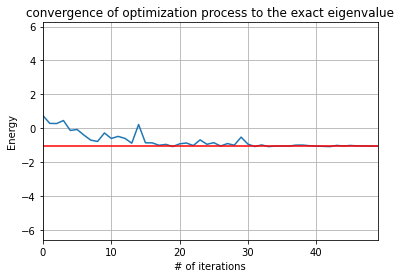

In [293]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [294]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 22.39it/s]


{'10': 273, '11': 110, '01': 261, '00': 380}
1.0
{'00': 113, '01': 710, '10': 200, '11': 1}
1.0
{'01': 268, '00': 546, '11': 89, '10': 121}
1.0


0it [00:00, ?it/s]

{'00': 795, '01': 83, '10': 117, '11': 29}
1.0
{'10': 227, '00': 269, '01': 493, '11': 35}
1.0


3it [00:00, 23.81it/s]


{'00': 725, '10': 194, '11': 53, '01': 52}
1.0


0it [00:00, ?it/s]

{'11': 328, '00': 282, '10': 299, '01': 115}
1.0
{'00': 291, '01': 633, '11': 76, '10': 24}

2it [00:00, 19.80it/s]


1.0
{'00': 560, '01': 366, '11': 77, '10': 21}
1.0

3it [00:00, 15.39it/s]


0it [00:00, ?it/s]

{'00': 426, '10': 275, '01': 206, '11': 117}
1.0


1it [00:00,  9.85it/s]

{'01': 813, '00': 107, '10': 100, '11': 4}
1.0


3it [00:00, 13.61it/s]


{'00': 664, '01': 253, '10': 43, '11': 64}
1.0


0it [00:00, ?it/s]

{'00': 347, '10': 489, '01': 165, '11': 23}
1.0


3it [00:00, 23.53it/s]


{'01': 593, '00': 184, '10': 147, '11': 100}
1.0
{'00': 607, '10': 193, '01': 150, '11': 74}
1.0


0it [00:00, ?it/s]

{'10': 377, '01': 508, '00': 118, '11': 21}
1.0


3it [00:00, 26.67it/s]

{'01': 529, '11': 116, '10': 125, '00': 254}
1.0
{'00': 456, '11': 196, '01': 342, '10': 30}
1.0


3it [00:00, 26.32it/s]
0it [00:00, ?it/s]

{'01': 326, '00': 195, '10': 479, '11': 24}
1.0
{'01': 705, '11': 94, '10': 51, '00': 174}
1.0


3it [00:00, 21.63it/s]


{'00': 638, '01': 215, '11': 129, '10': 42}
1.0


0it [00:00, ?it/s]

{'10': 326, '01': 508, '00': 184, '11': 6}
1.0


3it [00:00, 12.07it/s]


{'11': 43, '01': 392, '10': 233, '00': 356}
1.0
{'11': 225, '00': 472, '01': 262, '10': 65}
1.0


2it [00:00, 15.62it/s]

{'10': 510, '01': 305, '11': 108, '00': 101}
1.0
{'01': 711, '00': 161, '10': 147, '11': 5}
1.0


3it [00:00, 16.22it/s]


{'01': 394, '00': 502, '11': 40, '10': 88}
1.0


3it [00:00, 20.62it/s]


{'11': 364, '00': 53, '01': 477, '10': 130}
1.0
{'00': 291, '01': 596, '10': 89, '11': 48}
1.0
{'01': 773, '00': 146, '10': 29, '11': 76}
1.0


0it [00:00, ?it/s]

{'11': 507, '01': 320, '10': 142, '00': 55}
1.0


3it [00:00, 12.38it/s]

{'01': 566, '00': 253, '10': 91, '11': 114}
1.0
{'11': 192, '01': 677, '00': 143, '10': 12}
1.0



3it [00:00, 12.57it/s]


{'11': 280, '01': 364, '10': 210, '00': 170}
1.0
{'01': 818, '11': 68, '00': 104, '10': 34}
1.0
{'01': 558, '00': 365, '11': 87, '10': 14}
1.0


0it [00:00, ?it/s]

{'11': 364, '01': 282, '10': 300, '00': 78}
1.0


3it [00:00, 21.20it/s]


{'01': 697, '00': 185, '10': 115, '11': 27}
1.0
{'00': 255, '01': 623, '10': 128, '11': 18}
1.0


0it [00:00, ?it/s]

{'11': 474, '01': 534, '00': 15, '10': 1}
1.0


2it [00:00, 19.14it/s]

{'00': 388, '01': 514, '10': 83, '11': 39}
1.0


3it [00:00, 13.08it/s]


{'01': 911, '11': 94, '00': 10, '10': 9}
1.0


3it [00:00, 16.23it/s]

{'01': 846, '11': 163, '10': 7, '00': 8}
1.0
{'01': 443, '00': 397, '10': 114, '11': 70}
1.0
{'01': 830, '11': 177, '10': 15, '00': 2}
1.0



0it [00:00, ?it/s]

{'01': 519, '11': 487, '00': 16, '10': 2}
1.0
{'00': 358, '01': 561, '10': 64, '11': 41}
1.0


3it [00:00, 22.22it/s]


{'01': 892, '11': 106, '00': 19, '10': 7}
1.0


0it [00:00, ?it/s]

{'01': 771, '11': 237, '10': 10, '00': 6}
1.0
{'10': 87, '01': 518, '00': 400, '11': 19}
1.0


3it [00:00, 20.69it/s]


{'01': 905, '11': 109, '00': 4, '10': 6}
1.0


0it [00:00, ?it/s]

{'11': 241, '00': 128, '01': 377, '10': 278}
1.0
{'00': 864, '01': 69, '10': 27, '11': 64}


3it [00:00, 10.05it/s]


1.0
{'01': 560, '00': 377, '11': 78, '10': 9}
1.0


0it [00:00, ?it/s]

{'01': 720, '11': 298, '00': 6}
1.0
{'01': 391, '00': 454, '11': 100, '10': 79}
1.0


3it [00:00, 20.07it/s]


{'01': 849, '11': 172, '00': 1, '10': 2}
1.0


0it [00:00, ?it/s]

{'11': 566, '10': 100, '01': 348, '00': 10}
1.0


3it [00:00, 17.70it/s]


{'00': 443, '01': 398, '11': 30, '10': 153}
1.0
{'01': 761, '11': 149, '00': 90, '10': 24}
1.0


0it [00:00, ?it/s]

{'11': 402, '01': 613, '00': 9}
1.0
{'00': 430, '01': 560, '11': 15, '10': 19}
1.0


3it [00:00, 19.61it/s]


{'01': 987, '11': 25, '00': 7, '10': 5}
1.0


2it [00:00, 12.84it/s]

{'11': 414, '01': 591, '00': 8, '10': 11}
1.0
{'01': 560, '00': 379, '10': 63, '11': 22}
1.0


3it [00:00, 13.62it/s]


{'11': 85, '01': 918, '00': 16, '10': 5}
1.0


0it [00:00, ?it/s]

{'11': 526, '01': 449, '00': 35, '10': 14}
1.0


3it [00:00, 20.13it/s]


{'00': 322, '01': 659, '10': 34, '11': 9}
1.0
{'01': 934, '00': 43, '11': 44, '10': 3}
1.0


0it [00:00, ?it/s]

{'01': 865, '00': 27, '11': 107, '10': 25}
1.0
{'00': 512, '01': 265, '10': 76, '11': 171}
1.0


3it [00:00, 21.05it/s]


{'11': 245, '01': 723, '00': 31, '10': 25}
1.0


0it [00:00, ?it/s]

{'01': 475, '11': 524, '10': 22, '00': 3}
1.0
{'01': 585, '00': 382, '10': 49, '11': 8}
1.0
{'01': 950, '00': 24, '11': 43, '10': 7}
1.0


3it [00:00, 17.49it/s]
0it [00:00, ?it/s]

{'01': 643, '11': 342, '00': 27, '10': 12}
1.0


2it [00:00, 14.98it/s]

{'00': 422, '01': 524, '10': 53, '11': 25}
1.0


3it [00:00, 16.18it/s]


{'01': 957, '11': 36, '10': 24, '00': 7}
1.0


0it [00:00, ?it/s]

{'01': 632, '11': 325, '00': 50, '10': 17}
1.0


3it [00:00, 23.45it/s]

{'01': 612, '11': 67, '00': 331, '10': 14}
1.0
{'01': 939, '11': 27, '10': 36, '00': 22}
1.0


3it [00:00, 23.27it/s]
0it [00:00, ?it/s]

{'01': 629, '10': 16, '11': 359, '00': 20}
1.0
{'10': 26, '00': 435, '01': 535, '11': 28}
1.0


3it [00:00, 23.84it/s]


{'01': 963, '10': 39, '11': 20, '00': 2}
1.0


0it [00:00, ?it/s]

{'01': 676, '10': 54, '11': 292, '00': 2}
1.0
{'00': 452, '11': 70, '01': 457, '10': 45}
1.0


3it [00:00, 21.33it/s]


{'01': 896, '11': 50, '10': 67, '00': 11}
1.0


0it [00:00, ?it/s]

{'01': 677, '11': 326, '00': 14, '10': 7}

2it [00:00, 13.43it/s]


1.0
{'01': 484, '00': 490, '10': 35, '11': 15}
1.0


3it [00:00, 12.34it/s]


{'01': 968, '10': 25, '11': 30, '00': 1}
1.0


3it [00:00, 17.58it/s]


{'11': 417, '01': 514, '00': 72, '10': 21}
1.0
{'01': 650, '00': 313, '11': 48, '10': 13}
1.0
{'01': 919, '11': 8, '10': 62, '00': 35}
1.0


0it [00:00, ?it/s]

{'11': 361, '00': 65, '01': 597, '10': 1}
1.0


3it [00:00, 18.81it/s]


{'00': 489, '01': 480, '10': 20, '11': 35}
1.0
{'11': 16, '01': 945, '10': 44, '00': 19}
1.0


0it [00:00, ?it/s]

{'01': 491, '11': 469, '00': 54, '10': 10}
1.0


2it [00:00, 17.24it/s]

{'01': 436, '00': 544, '11': 33, '10': 11}
1.0


3it [00:00, 14.42it/s]


{'01': 959, '10': 47, '00': 15, '11': 3}
1.0


1it [00:00,  6.98it/s]

{'01': 541, '11': 434, '00': 25, '10': 24}
1.0


3it [00:00, 11.40it/s]


{'01': 514, '00': 463, '10': 42, '11': 5}
1.0
{'01': 972, '10': 41, '11': 9, '00': 2}
1.0


0it [00:00, ?it/s]

{'11': 462, '01': 429, '10': 118, '00': 15}
1.0


2it [00:00, 15.75it/s]

{'00': 433, '01': 455, '10': 120, '11': 16}
1.0


3it [00:00, 16.17it/s]


{'01': 851, '10': 123, '00': 38, '11': 12}
1.0


0it [00:00, ?it/s]

{'11': 400, '01': 591, '10': 18, '00': 15}
1.0
{'10': 50, '00': 443, '01': 526, '11': 5}
1.0
{'01': 969, '10': 42, '11': 9, '00': 4}


3it [00:00, 21.28it/s]


1.0


1it [00:00,  9.85it/s]

{'01': 542, '11': 441, '00': 26, '10': 15}
1.0
{'01': 571, '00': 373, '10': 75, '11': 5}
1.0


3it [00:00, 13.53it/s]


{'01': 951, '10': 39, '11': 27, '00': 7}
1.0


2it [00:00, 13.65it/s]

{'01': 593, '11': 398, '10': 24, '00': 9}
1.0
{'01': 488, '00': 480, '11': 10, '10': 46}
1.0


3it [00:00, 14.96it/s]


{'01': 968, '11': 17, '10': 38, '00': 1}
1.0


0it [00:00, ?it/s]

{'01': 688, '11': 259, '10': 76, '00': 1}
1.0


3it [00:00, 19.20it/s]


{'01': 458, '11': 57, '00': 485, '10': 24}
1.0
{'01': 923, '11': 40, '00': 20, '10': 41}
1.0


0it [00:00, ?it/s]

{'01': 614, '11': 382, '10': 19, '00': 9}
1.0
{'01': 516, '00': 442, '10': 61, '11': 5}
1.0


3it [00:00, 24.00it/s]


{'01': 960, '10': 31, '11': 32, '00': 1}
1.0


0it [00:00, ?it/s]

{'01': 575, '11': 404, '10': 23, '00': 22}
1.0
{'00': 517, '01': 409, '10': 84, '11': 14}
1.0


3it [00:00, 16.78it/s]


{'01': 925, '11': 64, '10': 30, '00': 5}
1.0


1it [00:00,  9.34it/s]

{'01': 493, '11': 481, '00': 40, '10': 10}
1.0
{'00': 415, '01': 555, '11': 3, '10': 51}
1.0


3it [00:00, 12.89it/s]


{'01': 945, '11': 17, '00': 9, '10': 53}
1.0


0it [00:00, ?it/s]

{'01': 554, '11': 427, '10': 19, '00': 24}
1.0


3it [00:00, 21.28it/s]


{'01': 503, '00': 458, '10': 58, '11': 5}
1.0
{'01': 979, '10': 28, '11': 16, '00': 1}
1.0


0it [00:00, ?it/s]

{'01': 470, '11': 506, '10': 34, '00': 14}
1.0
{'00': 385, '01': 568, '10': 63, '11': 8}
1.0


3it [00:00, 21.24it/s]

{'01': 938, '10': 49, '11': 25, '00': 12}
1.0


3it [00:00, 21.02it/s]
0it [00:00, ?it/s]

{'01': 587, '11': 390, '10': 25, '00': 22}
1.0


2it [00:00, 16.06it/s]

{'01': 547, '00': 421, '10': 56}
1.0


3it [00:00, 13.39it/s]


{'01': 957, '10': 35, '11': 32}
1.0


0it [00:00, ?it/s]

{'11': 458, '01': 503, '10': 21, '00': 42}
1.0


3it [00:00, 17.39it/s]


{'01': 612, '00': 354, '10': 24, '11': 34}
1.0
{'01': 961, '00': 17, '10': 45, '11': 1}
1.0


0it [00:00, ?it/s]

{'11': 444, '10': 15, '01': 531, '00': 34}
1.0
{'00': 433, '01': 527, '10': 59, '11': 5}
1.0


3it [00:00, 20.15it/s]


{'01': 957, '10': 38, '11': 26, '00': 3}
1.0


0it [00:00, ?it/s]

{'01': 521, '11': 432, '00': 9, '10': 62}
1.0


3it [00:00, 20.76it/s]

{'10': 63, '00': 441, '01': 503, '11': 17}
1.0
{'01': 944, '10': 65, '11': 7, '00': 8}
1.0



1it [00:00,  8.88it/s]

{'01': 547, '11': 395, '10': 67, '00': 15}
1.0


3it [00:00, 13.59it/s]


{'01': 519, '00': 424, '10': 47, '11': 34}
1.0
{'01': 944, '00': 18, '10': 53, '11': 9}
1.0


0it [00:00, ?it/s]

{'11': 418, '10': 69, '01': 519, '00': 18}
1.0
{'01': 506, '00': 438, '10': 64, '11': 16}
1.0


3it [00:00, 23.08it/s]

{'01': 925, '10': 79, '11': 14, '00': 6}
1.0


[2.95668049 1.39306121 6.21576923 1.35219957 3.80508655 2.63975286
 4.81151747 6.00546125 3.35329578 4.36015244 2.83492727 4.53995781
 5.64284668 0.85960415 4.23380075 0.56062178]


0it [00:00, ?it/s]

{'11': 433, '01': 496, '10': 74, '00': 21}
1.0
{'01': 515, '00': 437, '10': 56, '11': 16}
1.0


3it [00:00, 24.26it/s]

{'01': 935, '10': 75, '11': 8, '00': 6}
1.0
CPU times: total: 8.36 s
Wall time: 9.23 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.5703880006308175

Approximation Error
0.4445938085916853


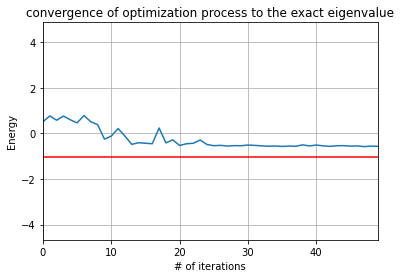

In [295]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [296]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [297]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 15.57it/s]


{'01': 469, '00': 377, '10': 61, '11': 117}
1.0
{'10': 60, '01': 464, '00': 383, '11': 117}
1.0
{'00': 373, '01': 464, '11': 132, '10': 55}
1.0
{'01': 447, '00': 364, '11': 138, '10': 75}
1.0


4it [00:00, 20.36it/s]


{'01': 208, '00': 739, '10': 71, '11': 6}
1.0
{'00': 712, '01': 222, '10': 89, '11': 1}
1.0
{'01': 214, '10': 101, '00': 708, '11': 1}
1.0
{'00': 682, '10': 116, '01': 224, '11': 2}
1.0


0it [00:00, ?it/s]

{'10': 402, '11': 19, '00': 467, '01': 136}
1.0


2it [00:00, 19.05it/s]

{'10': 368, '00': 483, '01': 154, '11': 19}
1.0
{'01': 130, '00': 505, '10': 363, '11': 26}
1.0


4it [00:00, 11.34it/s]


{'01': 149, '00': 494, '10': 366, '11': 15}
1.0


2it [00:00, 14.55it/s]

{'01': 165, '00': 643, '10': 50, '11': 166}
1.0
{'00': 621, '01': 186, '11': 166, '10': 51}
1.0
{'01': 167, '00': 645, '10': 63, '11': 149}
1.0


4it [00:00, 16.30it/s]


{'00': 652, '11': 152, '01': 170, '10': 50}
1.0


2it [00:00, 18.45it/s]

{'01': 278, '00': 712, '10': 19, '11': 15}
1.0
{'01': 293, '00': 703, '10': 21, '11': 7}
1.0
{'01': 279, '00': 712, '11': 8, '10': 25}
1.0


4it [00:00,  7.98it/s]


{'00': 710, '01': 275, '10': 33, '11': 6}
1.0


2it [00:00, 17.78it/s]

{'00': 598, '01': 276, '11': 26, '10': 124}
1.0
{'00': 584, '01': 284, '10': 121, '11': 35}
1.0
{'01': 294, '00': 597, '10': 111, '11': 22}
1.0


4it [00:00, 19.41it/s]


{'00': 608, '01': 272, '10': 110, '11': 34}
1.0


2it [00:00, 17.68it/s]

{'00': 889, '11': 10, '01': 56, '10': 69}
1.0
{'00': 898, '01': 67, '10': 51, '11': 8}
1.0
{'00': 900, '01': 55, '10': 63, '11': 6}
1.0


4it [00:00, 18.54it/s]


{'00': 909, '10': 45, '01': 58, '11': 12}
1.0


1it [00:00,  7.20it/s]

{'00': 823, '10': 33, '01': 13, '11': 155}
1.0


3it [00:00,  9.95it/s]

{'00': 795, '11': 156, '01': 10, '10': 63}
1.0
{'00': 766, '11': 187, '10': 55, '01': 16}
1.0


4it [00:00, 10.52it/s]


{'00': 762, '10': 62, '11': 189, '01': 11}
1.0


0it [00:00, ?it/s]

{'00': 493, '01': 469, '10': 59, '11': 3}
1.0


4it [00:00, 19.61it/s]

{'01': 440, '00': 541, '10': 41, '11': 2}
1.0
{'01': 433, '00': 541, '10': 49, '11': 1}
1.0
{'01': 477, '00': 499, '10': 44, '11': 4}
1.0


4it [00:00, 19.46it/s]
0it [00:00, ?it/s]

{'00': 603, '10': 110, '11': 204, '01': 107}
1.0


3it [00:00, 13.55it/s]

{'00': 620, '10': 93, '11': 224, '01': 87}
1.0
{'00': 592, '11': 235, '01': 109, '10': 88}
1.0


4it [00:00, 12.98it/s]


{'11': 218, '00': 613, '01': 110, '10': 83}
1.0


4it [00:00, 23.76it/s]


{'10': 131, '00': 727, '11': 90, '01': 76}
1.0
{'01': 81, '00': 729, '10': 122, '11': 92}
1.0
{'10': 143, '00': 718, '11': 91, '01': 72}
1.0
{'10': 137, '00': 722, '01': 79, '11': 86}
1.0


0it [00:00, ?it/s]

{'01': 149, '00': 798, '10': 76, '11': 1}
1.0


4it [00:00, 21.92it/s]


{'00': 795, '01': 159, '10': 70}
1.0
{'10': 75, '00': 810, '01': 139}
1.0
{'00': 810, '01': 143, '10': 70, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 857, '01': 132, '10': 35}
1.0
{'00': 829, '01': 154, '10': 41}
1.0


3it [00:00, 16.70it/s]

{'00': 837, '01': 151, '10': 35, '11': 1}
1.0


4it [00:00, 14.12it/s]


{'00': 854, '01': 140, '10': 30}
1.0


0it [00:00, ?it/s]

{'00': 885, '10': 57, '01': 64, '11': 18}
1.0
{'10': 53, '00': 895, '11': 16, '01': 60}
1.0


4it [00:00, 25.00it/s]


{'00': 899, '01': 58, '11': 17, '10': 50}
1.0
{'00': 902, '10': 58, '01': 53, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 527, '10': 432, '11': 16, '01': 49}
1.0


4it [00:00, 25.48it/s]

{'10': 416, '00': 523, '01': 70, '11': 15}
1.0
{'00': 518, '10': 445, '11': 19, '01': 42}
1.0
{'00': 510, '10': 445, '01': 57, '11': 12}
1.0



0it [00:00, ?it/s]

{'00': 901, '01': 70, '10': 45, '11': 8}
1.0


3it [00:00, 26.09it/s]

{'00': 902, '10': 53, '01': 61, '11': 8}
1.0
{'00': 876, '01': 71, '10': 69, '11': 8}
1.0


4it [00:00, 25.48it/s]


{'00': 908, '11': 9, '01': 57, '10': 50}
1.0


0it [00:00, ?it/s]

{'00': 889, '01': 63, '10': 65, '11': 7}

1it [00:00,  9.45it/s]


1.0
{'00': 904, '01': 65, '10': 48, '11': 7}
1.0


4it [00:00, 14.43it/s]


{'00': 896, '10': 65, '01': 58, '11': 5}
1.0
{'00': 892, '01': 69, '11': 12, '10': 51}
1.0


4it [00:00, 24.97it/s]

{'00': 872, '11': 106, '10': 21, '01': 25}
1.0
{'00': 875, '10': 21, '11': 102, '01': 26}
1.0
{'00': 863, '11': 125, '10': 25, '01': 11}
1.0
{'00': 875, '11': 99, '10': 24, '01': 26}
1.0



0it [00:00, ?it/s]

{'00': 804, '10': 106, '11': 46, '01': 68}
1.0
{'00': 809, '11': 54, '01': 61, '10': 100}
1.0


4it [00:00, 25.00it/s]


{'00': 794, '11': 50, '01': 78, '10': 102}
1.0
{'10': 93, '00': 826, '11': 45, '01': 60}
1.0


0it [00:00, ?it/s]

{'00': 863, '10': 103, '01': 52, '11': 6}
1.0


3it [00:00, 25.21it/s]

{'00': 874, '10': 93, '01': 52, '11': 5}
1.0
{'00': 898, '10': 82, '01': 42, '11': 2}
1.0


4it [00:00, 20.05it/s]


{'00': 882, '10': 88, '11': 12, '01': 42}
1.0


2it [00:00, 12.27it/s]

{'00': 837, '10': 108, '01': 49, '11': 30}
1.0
{'00': 818, '01': 57, '10': 117, '11': 32}
1.0


4it [00:00, 15.27it/s]


{'00': 827, '11': 22, '10': 118, '01': 57}
1.0
{'00': 812, '10': 115, '01': 64, '11': 33}
1.0


3it [00:00, 22.74it/s]

{'10': 104, '00': 845, '01': 60, '11': 15}
1.0
{'00': 834, '01': 59, '10': 117, '11': 14}
1.0
{'00': 856, '10': 104, '11': 18, '01': 46}
1.0


4it [00:00, 21.48it/s]


{'00': 858, '01': 50, '11': 19, '10': 97}
1.0


0it [00:00, ?it/s]

{'10': 102, '00': 817, '01': 68, '11': 37}
1.0


2it [00:00, 19.80it/s]

{'00': 825, '10': 112, '01': 42, '11': 45}
1.0
{'00': 827, '01': 60, '11': 39, '10': 98}
1.0


4it [00:00, 17.03it/s]

{'11': 43, '00': 796, '10': 118, '01': 67}
1.0


4it [00:00, 17.32it/s]
1it [00:00,  9.86it/s]

{'00': 886, '01': 86, '10': 52}
1.0


4it [00:00, 13.02it/s]

{'00': 875, '01': 82, '10': 63, '11': 4}
1.0
{'00': 884, '01': 81, '10': 57, '11': 2}
1.0
{'01': 83, '00': 887, '10': 52, '11': 2}
1.0



0it [00:00, ?it/s]

{'00': 941, '11': 46, '10': 18, '01': 19}
1.0
{'00': 929, '01': 23, '10': 23, '11': 49}
1.0


4it [00:00, 22.92it/s]


{'00': 934, '11': 45, '01': 31, '10': 14}
1.0
{'00': 930, '11': 49, '10': 13, '01': 32}
1.0


0it [00:00, ?it/s]

{'00': 856, '01': 110, '10': 57, '11': 1}
1.0


3it [00:00, 23.90it/s]

{'10': 58, '00': 845, '01': 120, '11': 1}
1.0
{'01': 118, '00': 851, '10': 53, '11': 2}
1.0


4it [00:00, 22.35it/s]


{'00': 837, '01': 124, '10': 60, '11': 3}
1.0


1it [00:00,  6.53it/s]

{'00': 853, '01': 106, '11': 48, '10': 17}
1.0


4it [00:00, 11.35it/s]

{'00': 857, '01': 105, '11': 44, '10': 18}
1.0
{'00': 856, '01': 106, '11': 44, '10': 18}
1.0
{'00': 869, '10': 19, '01': 100, '11': 36}
1.0



0it [00:00, ?it/s]

{'00': 903, '10': 46, '01': 62, '11': 13}
1.0


4it [00:00, 18.23it/s]


{'00': 879, '01': 73, '11': 19, '10': 53}
1.0
{'00': 899, '01': 64, '10': 49, '11': 12}
1.0
{'00': 909, '10': 47, '01': 57, '11': 11}
1.0


0it [00:00, ?it/s]

{'01': 63, '00': 885, '11': 28, '10': 48}
1.0


3it [00:00, 18.31it/s]

{'00': 864, '10': 55, '01': 62, '11': 43}
1.0
{'00': 899, '01': 56, '10': 30, '11': 39}
1.0
{'00': 892, '11': 38, '10': 45, '01': 49}
1.0


4it [00:00, 16.30it/s]
4it [00:00, 19.92it/s]

{'00': 867, '10': 71, '11': 13, '01': 73}
1.0
{'00': 857, '10': 81, '01': 80, '11': 6}
1.0
{'00': 867, '10': 78, '01': 61, '11': 18}
1.0
{'00': 856, '10': 90, '01': 64, '11': 14}
1.0



0it [00:00, ?it/s]

{'00': 791, '10': 179, '01': 51, '11': 3}

4it [00:00, 20.78it/s]



1.0
{'00': 816, '10': 148, '01': 59, '11': 1}
1.0
{'00': 794, '10': 159, '01': 65, '11': 6}
1.0
{'00': 820, '10': 155, '01': 47, '11': 2}
1.0


0it [00:00, ?it/s]

{'00': 861, '01': 112, '10': 47, '11': 4}
1.0


2it [00:00, 17.49it/s]

{'00': 811, '10': 56, '01': 144, '11': 13}
1.0
{'00': 828, '10': 53, '01': 133, '11': 10}
1.0


4it [00:00, 12.83it/s]

{'00': 822, '01': 143, '11': 13, '10': 46}
1.0


4it [00:00, 13.27it/s]
4it [00:00, 21.98it/s]

{'00': 976, '11': 14, '01': 19, '10': 15}
1.0
{'00': 979, '10': 19, '11': 13, '01': 13}
1.0
{'11': 13, '00': 987, '01': 14, '10': 10}
1.0
{'00': 973, '01': 19, '11': 13, '10': 19}
1.0



0it [00:00, ?it/s]

{'01': 7, '00': 991, '11': 10, '10': 16}
1.0


4it [00:00, 21.91it/s]


{'00': 980, '10': 20, '11': 14, '01': 10}
1.0
{'00': 985, '10': 23, '11': 9, '01': 7}
1.0
{'00': 980, '11': 11, '10': 24, '01': 9}
1.0


2it [00:00, 19.14it/s]

{'00': 994, '01': 4, '10': 20, '11': 6}
1.0
{'00': 983, '01': 10, '10': 20, '11': 11}
1.0
{'00': 978, '01': 10, '11': 15, '10': 21}
1.0


4it [00:00, 13.65it/s]


{'00': 996, '11': 10, '10': 11, '01': 7}
1.0


0it [00:00, ?it/s]

{'00': 965, '10': 28, '11': 27, '01': 4}
1.0
{'11': 18, '00': 969, '10': 30, '01': 7}
1.0


3it [00:00, 21.11it/s]

{'00': 980, '10': 24, '11': 20}
1.0


4it [00:00, 20.33it/s]


{'00': 964, '10': 46, '11': 12, '01': 2}
1.0


2it [00:00, 18.87it/s]

{'00': 981, '10': 22, '11': 8, '01': 13}
1.0
{'00': 985, '10': 32, '01': 3, '11': 4}
1.0
{'00': 989, '10': 18, '11': 10, '01': 7}
1.0


4it [00:00, 21.16it/s]


{'00': 973, '11': 10, '01': 11, '10': 30}
1.0


0it [00:00, ?it/s]

{'00': 971, '10': 36, '01': 14, '11': 3}
1.0


2it [00:00, 16.36it/s]

{'00': 983, '10': 33, '11': 2, '01': 6}
1.0
{'00': 978, '10': 34, '11': 4, '01': 8}
1.0


4it [00:00, 13.89it/s]


{'00': 985, '10': 25, '01': 11, '11': 3}
1.0


2it [00:00, 18.10it/s]

{'00': 975, '10': 37, '11': 3, '01': 9}
1.0
{'00': 974, '10': 41, '01': 8, '11': 1}
1.0
{'11': 4, '00': 966, '10': 41, '01': 13}
1.0


4it [00:00, 20.15it/s]


{'00': 965, '10': 43, '01': 11, '11': 5}
1.0


0it [00:00, ?it/s]

{'00': 994, '10': 12, '01': 12, '11': 6}
1.0


3it [00:00, 21.43it/s]

{'00': 991, '01': 10, '10': 20, '11': 3}
1.0
{'00': 999, '10': 11, '01': 10, '11': 4}
1.0


4it [00:00, 21.33it/s]

{'00': 988, '01': 14, '10': 18, '11': 4}
1.0



0it [00:00, ?it/s]

{'00': 994, '11': 3, '01': 6, '10': 21}
1.0


2it [00:00, 17.94it/s]

{'11': 4, '00': 992, '10': 20, '01': 8}
1.0
{'00': 1000, '10': 12, '11': 3, '01': 9}
1.0


4it [00:00, 12.43it/s]

{'00': 992, '10': 19, '11': 5, '01': 8}
1.0


4it [00:00, 12.94it/s]
0it [00:00, ?it/s]

{'00': 979, '10': 17, '11': 20, '01': 8}
1.0
{'00': 985, '11': 16, '01': 12, '10': 11}
1.0


3it [00:00, 20.71it/s]

{'00': 979, '10': 15, '11': 22, '01': 8}
1.0


4it [00:00, 20.42it/s]


{'00': 993, '10': 12, '01': 10, '11': 9}
1.0


0it [00:00, ?it/s]

{'00': 1004, '01': 7, '10': 13}
1.0


2it [00:00, 19.51it/s]

{'00': 994, '01': 18, '11': 3, '10': 9}
1.0
{'00': 1001, '10': 10, '11': 2, '01': 11}
1.0


4it [00:00, 18.82it/s]


{'00': 1006, '01': 12, '10': 3, '11': 3}
1.0


0it [00:00, ?it/s]

{'00': 989, '01': 17, '10': 16, '11': 2}
1.0


2it [00:00, 14.49it/s]

{'00': 991, '10': 21, '01': 12}
1.0


4it [00:00, 16.26it/s]


{'00': 993, '10': 17, '01': 10, '11': 4}
1.0
{'00': 992, '10': 18, '01': 10, '11': 4}
1.0


0it [00:00, ?it/s]

{'00': 989, '11': 9, '10': 16, '01': 10}
1.0
{'00': 998, '01': 8, '11': 6, '10': 12}
1.0


4it [00:00, 19.90it/s]


{'00': 997, '10': 13, '01': 9, '11': 5}
1.0
{'00': 999, '11': 10, '01': 5, '10': 10}
1.0


0it [00:00, ?it/s]

{'00': 946, '01': 50, '10': 20, '11': 8}
1.0


2it [00:00, 19.14it/s]

{'01': 35, '00': 970, '11': 6, '10': 13}
1.0
{'00': 964, '10': 22, '01': 34, '11': 4}
1.0


4it [00:00, 19.37it/s]


{'00': 962, '10': 19, '01': 36, '11': 7}
1.0


0it [00:00, ?it/s]

{'00': 999, '10': 8, '01': 16, '11': 1}
1.0


2it [00:00, 17.78it/s]

{'10': 12, '00': 986, '01': 19, '11': 7}
1.0
{'00': 997, '10': 12, '01': 11, '11': 4}
1.0


4it [00:00, 18.31it/s]


{'00': 989, '01': 17, '10': 10, '11': 8}
1.0


0it [00:00, ?it/s]

{'00': 1015, '10': 4, '11': 4, '01': 1}
1.0
{'00': 1013, '11': 8, '10': 3}

2it [00:00, 13.83it/s]


1.0
{'00': 1014, '11': 6, '01': 2, '10': 2}
1.0


4it [00:00, 13.91it/s]


{'00': 1018, '11': 4, '10': 2}
1.0


0it [00:00, ?it/s]

{'00': 1004, '11': 17, '10': 2, '01': 1}
1.0


2it [00:00, 16.26it/s]

{'00': 1012, '11': 12}
1.0
{'00': 1018, '11': 5, '10': 1}
1.0


4it [00:00, 18.18it/s]


{'00': 1009, '11': 13, '10': 2}
1.0


0it [00:00, ?it/s]

{'00': 1012, '10': 2, '01': 7, '11': 3}
1.0


2it [00:00, 11.73it/s]

{'00': 1006, '01': 10, '11': 4, '10': 4}
1.0


4it [00:00, 10.86it/s]

{'00': 1009, '11': 7, '01': 7, '10': 1}
1.0
{'00': 1004, '10': 5, '11': 7, '01': 8}
1.0


4it [00:00, 10.98it/s]


[1.80851482 4.40298098 5.33044523 5.99078597 3.36401655 3.15151887
 5.00524129 5.4796457  1.36168919 1.23902976 5.64719259 5.58188765
 2.24099253 0.3274439  7.05901381 4.30289497]


0it [00:00, ?it/s]

{'00': 1007, '11': 12, '10': 2, '01': 3}
1.0


2it [00:00, 15.31it/s]

{'00': 1009, '01': 1, '10': 6, '11': 8}
1.0
{'00': 1011, '01': 3, '10': 4, '11': 6}
1.0


4it [00:00, 16.69it/s]

{'00': 1008, '11': 9, '10': 5, '01': 2}
1.0
CPU times: total: 11.2 s
Wall time: 12.4 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9912322333310533

Approximation Error
0.013803978706710743


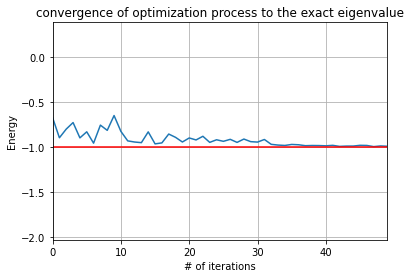

In [298]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [299]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

2it [00:00, 18.18it/s]

{'00': 429, '11': 568, '01': 22, '10': 5}
1.0
{'11': 555, '00': 452, '01': 11, '10': 6}
1.0
{'00': 473, '11': 532, '01': 17, '10': 2}
1.0

4it [00:00, 12.23it/s]



{'11': 535, '00': 468, '01': 15, '10': 6}
1.0


2it [00:00, 18.35it/s]

{'00': 166, '11': 641, '01': 94, '10': 123}
1.0
{'11': 619, '10': 144, '01': 85, '00': 176}
1.0


4it [00:00, 19.28it/s]


{'11': 639, '10': 124, '01': 81, '00': 180}
1.0
{'11': 640, '00': 179, '10': 117, '01': 88}
1.0


2it [00:00, 19.14it/s]

{'11': 318, '00': 434, '01': 247, '10': 25}
1.0
{'01': 257, '00': 469, '11': 274, '10': 24}
1.0
{'00': 476, '11': 307, '01': 226, '10': 15}
1.0


4it [00:00, 18.91it/s]


{'00': 457, '11': 292, '01': 244, '10': 31}
1.0


1it [00:00,  9.44it/s]

{'01': 212, '10': 152, '00': 383, '11': 277}
1.0
{'10': 174, '11': 283, '01': 193, '00': 374}

3it [00:00, 10.80it/s]


1.0
{'11': 237, '10': 182, '00': 408, '01': 197}
1.0


4it [00:00, 11.62it/s]


{'10': 192, '11': 265, '01': 179, '00': 388}
1.0


0it [00:00, ?it/s]

{'00': 472, '11': 325, '01': 206, '10': 21}
1.0


2it [00:00, 18.69it/s]

{'00': 476, '01': 213, '11': 308, '10': 27}
1.0
{'01': 228, '11': 323, '00': 451, '10': 22}
1.0


4it [00:00, 19.75it/s]


{'01': 247, '11': 289, '00': 467, '10': 21}
1.0


0it [00:00, ?it/s]

{'00': 725, '11': 109, '01': 185, '10': 5}
1.0


3it [00:00, 21.66it/s]

{'10': 10, '01': 210, '00': 686, '11': 118}
1.0
{'00': 682, '11': 122, '01': 211, '10': 9}
1.0


4it [00:00, 21.15it/s]


{'11': 111, '00': 690, '01': 214, '10': 9}
1.0


0it [00:00, ?it/s]

{'00': 486, '11': 314, '01': 170, '10': 54}
1.0


2it [00:00, 11.11it/s]

{'01': 216, '00': 474, '11': 294, '10': 40}
1.0
{'01': 179, '00': 485, '11': 317, '10': 43}
1.0

4it [00:00, 12.31it/s]



{'00': 462, '11': 319, '01': 195, '10': 48}
1.0


2it [00:00, 17.62it/s]

{'00': 870, '11': 143, '01': 8, '10': 3}
1.0
{'00': 884, '11': 127, '10': 7, '01': 6}
1.0


4it [00:00, 18.06it/s]


{'00': 876, '11': 130, '01': 7, '10': 11}
1.0
{'11': 137, '00': 868, '01': 9, '10': 10}
1.0


0it [00:00, ?it/s]

{'00': 702, '10': 210, '11': 64, '01': 48}
1.0
{'00': 693, '01': 62, '10': 198, '11': 71}
1.0


3it [00:00, 13.56it/s]

{'00': 645, '11': 71, '10': 246, '01': 62}
1.0


4it [00:00, 11.86it/s]


{'00': 680, '10': 233, '01': 52, '11': 59}
1.0


0it [00:00, ?it/s]

{'01': 262, '00': 443, '10': 131, '11': 188}
1.0


2it [00:00, 13.76it/s]

{'00': 421, '10': 145, '11': 191, '01': 267}
1.0
{'11': 207, '01': 263, '00': 420, '10': 134}
1.0


4it [00:00, 16.49it/s]


{'10': 111, '00': 439, '01': 268, '11': 206}
1.0


0it [00:00, ?it/s]

{'00': 752, '11': 156, '10': 113, '01': 3}
1.0


3it [00:00, 20.00it/s]

{'00': 733, '10': 115, '11': 169, '01': 7}
1.0
{'00': 741, '11': 153, '10': 121, '01': 9}
1.0


4it [00:00, 19.51it/s]


{'11': 167, '00': 709, '10': 135, '01': 13}
1.0


0it [00:00, ?it/s]

{'01': 154, '00': 598, '10': 152, '11': 120}
1.0


2it [00:00, 12.79it/s]

{'00': 592, '11': 128, '01': 162, '10': 142}
1.0
{'01': 180, '10': 151, '00': 551, '11': 142}
1.0


4it [00:00, 11.53it/s]

{'00': 593, '11': 126, '01': 176, '10': 129}
1.0


4it [00:00, 11.62it/s]
0it [00:00, ?it/s]

{'11': 326, '01': 143, '00': 334, '10': 221}
1.0


2it [00:00, 17.33it/s]

{'10': 239, '00': 322, '01': 129, '11': 334}
1.0
{'01': 140, '10': 254, '11': 319, '00': 311}
1.0


4it [00:00, 18.15it/s]


{'10': 255, '01': 148, '11': 319, '00': 302}
1.0


0it [00:00, ?it/s]

{'00': 370, '10': 277, '01': 359, '11': 18}
1.0


2it [00:00, 18.69it/s]

{'11': 19, '00': 374, '01': 348, '10': 283}
1.0
{'01': 369, '00': 379, '10': 260, '11': 16}
1.0


4it [00:00, 19.85it/s]


{'00': 339, '01': 384, '10': 284, '11': 17}
1.0


0it [00:00, ?it/s]

{'00': 653, '10': 245, '01': 55, '11': 71}
1.0


2it [00:00, 12.90it/s]

{'00': 667, '10': 231, '11': 74, '01': 52}
1.0
{'00': 660, '01': 63, '11': 67, '10': 234}
1.0


4it [00:00, 13.75it/s]


{'10': 217, '00': 684, '11': 73, '01': 50}
1.0


0it [00:00, ?it/s]

{'00': 690, '11': 71, '10': 204, '01': 59}
1.0


2it [00:00, 15.06it/s]

{'00': 653, '10': 243, '11': 66, '01': 62}
1.0
{'00': 674, '01': 59, '10': 196, '11': 95}
1.0


4it [00:00, 17.35it/s]

{'00': 679, '10': 234, '11': 62, '01': 49}
1.0


4it [00:00, 16.86it/s]
0it [00:00, ?it/s]

{'11': 79, '00': 689, '01': 39, '10': 217}
1.0


3it [00:00, 20.98it/s]

{'10': 200, '00': 690, '01': 66, '11': 68}
1.0
{'00': 658, '10': 211, '11': 87, '01': 68}
1.0


4it [00:00, 20.57it/s]

{'10': 226, '00': 678, '11': 64, '01': 56}
1.0



0it [00:00, ?it/s]

{'00': 924, '10': 53, '11': 35, '01': 12}
1.0


2it [00:00, 19.90it/s]

{'00': 920, '10': 52, '11': 39, '01': 13}
1.0
{'00': 916, '01': 12, '10': 56, '11': 40}
1.0


4it [00:00, 16.19it/s]


{'00': 900, '10': 69, '11': 37, '01': 18}
1.0


2it [00:00, 12.86it/s]

{'00': 671, '01': 155, '11': 79, '10': 119}
1.0
{'00': 689, '01': 142, '10': 125, '11': 68}
1.0


4it [00:00, 15.40it/s]

{'00': 675, '01': 147, '11': 70, '10': 132}
1.0
{'00': 676, '10': 121, '11': 62, '01': 165}
1.0


4it [00:00, 14.90it/s]
3it [00:00, 22.22it/s]

{'00': 869, '10': 93, '11': 27, '01': 35}
1.0
{'01': 29, '00': 887, '10': 78, '11': 30}
1.0
{'00': 890, '10': 90, '11': 24, '01': 20}
1.0


4it [00:00, 23.05it/s]


{'00': 898, '10': 73, '01': 24, '11': 29}
1.0


0it [00:00, ?it/s]

{'11': 249, '01': 225, '00': 451, '10': 99}
1.0


3it [00:00, 22.81it/s]

{'00': 457, '11': 207, '01': 252, '10': 108}
1.0
{'11': 238, '10': 98, '01': 228, '00': 460}
1.0


4it [00:00, 20.46it/s]


{'10': 124, '00': 475, '01': 238, '11': 187}
1.0


1it [00:00,  8.93it/s]

{'10': 176, '00': 763, '11': 71, '01': 14}
1.0
{'00': 746, '10': 198, '11': 60, '01': 20}
1.0


4it [00:00, 15.54it/s]


{'00': 772, '11': 61, '10': 176, '01': 15}
1.0
{'00': 745, '10': 199, '01': 17, '11': 63}
1.0


0it [00:00, ?it/s]

{'00': 750, '01': 176, '10': 60, '11': 38}
1.0


2it [00:00, 15.90it/s]

{'10': 86, '00': 723, '11': 32, '01': 183}
1.0
{'00': 745, '01': 187, '10': 65, '11': 27}
1.0
{'01': 177, '00': 739, '11': 22, '10': 86}
1.0


4it [00:00, 16.27it/s]
0it [00:00, ?it/s]

{'00': 753, '01': 87, '10': 181, '11': 3}
1.0
{'00': 792, '10': 161, '01': 70, '11': 1}
1.0


4it [00:00, 18.69it/s]


{'00': 764, '01': 81, '11': 7, '10': 172}
1.0
{'00': 779, '01': 74, '10': 168, '11': 3}
1.0


0it [00:00, ?it/s]

{'00': 914, '10': 89, '01': 19, '11': 2}
1.0


2it [00:00, 19.32it/s]

{'00': 895, '10': 102, '01': 25, '11': 2}
1.0
{'00': 899, '10': 98, '01': 26, '11': 1}
1.0
{'00': 903, '10': 102, '01': 16, '11': 3}
1.0


4it [00:00, 14.52it/s]
0it [00:00, ?it/s]

{'00': 825, '10': 105, '01': 62, '11': 32}
1.0


2it [00:00, 13.19it/s]

{'00': 826, '10': 106, '01': 67, '11': 25}
1.0
{'00': 862, '01': 60, '11': 21, '10': 81}
1.0


4it [00:00, 15.30it/s]


{'01': 63, '00': 833, '10': 96, '11': 32}
1.0


0it [00:00, ?it/s]

{'00': 936, '10': 81, '01': 3, '11': 4}
1.0


2it [00:00, 18.28it/s]

{'00': 944, '10': 76, '11': 3, '01': 1}
1.0
{'00': 926, '10': 92, '01': 2, '11': 4}
1.0


4it [00:00, 18.75it/s]


{'00': 946, '10': 76, '01': 2}
1.0


0it [00:00, ?it/s]

{'00': 904, '10': 100, '01': 18, '11': 2}
1.0
{'00': 912, '10': 89, '01': 19, '11': 4}
1.0


3it [00:00, 17.75it/s]

{'00': 915, '10': 78, '01': 27, '11': 4}
1.0


4it [00:00, 15.19it/s]


{'00': 914, '01': 27, '10': 77, '11': 6}
1.0


0it [00:00, ?it/s]

{'00': 898, '10': 108, '01': 17, '11': 1}
1.0


2it [00:00, 17.82it/s]

{'00': 904, '10': 90, '01': 29, '11': 1}
1.0


4it [00:00, 19.42it/s]


{'00': 913, '01': 25, '10': 85, '11': 1}
1.0
{'00': 909, '10': 91, '01': 23, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 912, '10': 60, '01': 46, '11': 6}
1.0
{'00': 918, '10': 67, '01': 36, '11': 3}
1.0


4it [00:00, 17.77it/s]


{'10': 73, '00': 920, '01': 28, '11': 3}
1.0
{'10': 73, '00': 921, '01': 28, '11': 2}
1.0


0it [00:00, ?it/s]

{'00': 925, '10': 98, '01': 1}
1.0


2it [00:00, 10.05it/s]

{'00': 926, '10': 92, '01': 4, '11': 2}
1.0
{'00': 932, '10': 86, '11': 2, '01': 4}
1.0


4it [00:00, 12.54it/s]


{'00': 912, '10': 103, '11': 7, '01': 2}
1.0


0it [00:00, ?it/s]

{'00': 983, '10': 41}
1.0


2it [00:00, 17.78it/s]

{'00': 957, '10': 67}
1.0
{'00': 968, '10': 55, '11': 1}
1.0


4it [00:00, 18.06it/s]


{'00': 980, '10': 44}
1.0


0it [00:00, ?it/s]

{'00': 876, '10': 146, '11': 1, '01': 1}
1.0


2it [00:00, 16.95it/s]

{'00': 862, '10': 153, '01': 4, '11': 5}
1.0
{'00': 856, '10': 157, '11': 8, '01': 3}
1.0


4it [00:00, 12.24it/s]


{'00': 878, '10': 141, '01': 4, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 813, '10': 206, '11': 5}
1.0


2it [00:00, 18.28it/s]

{'00': 812, '10': 204, '11': 7, '01': 1}
1.0
{'10': 201, '00': 811, '11': 9, '01': 3}
1.0


4it [00:00, 18.29it/s]


{'00': 841, '10': 172, '11': 10, '01': 1}
1.0


0it [00:00, ?it/s]

{'00': 945, '10': 76, '11': 3}
1.0


2it [00:00, 16.32it/s]

{'10': 104, '00': 919, '11': 1}
1.0
{'10': 104, '00': 918, '11': 2}
1.0


4it [00:00, 12.38it/s]


{'10': 104, '00': 919, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 878, '01': 41, '11': 31, '10': 74}

2it [00:00, 13.74it/s]


1.0
{'00': 900, '01': 40, '10': 55, '11': 29}
1.0


4it [00:00, 15.80it/s]

{'00': 891, '10': 76, '01': 30, '11': 27}
1.0
{'00': 908, '10': 51, '01': 45, '11': 20}
1.0


4it [00:00, 15.45it/s]
3it [00:00, 20.50it/s]

{'00': 965, '10': 38, '11': 13, '01': 8}
1.0
{'00': 967, '01': 9, '10': 36, '11': 12}
1.0
{'00': 953, '10': 46, '11': 13, '01': 12}
1.0


4it [00:00, 19.15it/s]


{'00': 943, '10': 59, '11': 18, '01': 4}
1.0


3it [00:00, 21.33it/s]

{'00': 901, '01': 22, '10': 72, '11': 29}
1.0
{'00': 894, '10': 78, '01': 24, '11': 28}
1.0
{'00': 871, '10': 82, '11': 44, '01': 27}
1.0


4it [00:00, 15.99it/s]


{'00': 900, '01': 23, '11': 34, '10': 67}
1.0


1it [00:00,  9.40it/s]

{'00': 921, '10': 76, '11': 25, '01': 2}
1.0
{'00': 933, '11': 21, '10': 69, '01': 1}
1.0


4it [00:00, 15.99it/s]


{'00': 928, '10': 75, '11': 19, '01': 2}
1.0
{'00': 928, '10': 79, '01': 3, '11': 14}
1.0


0it [00:00, ?it/s]

{'00': 923, '11': 44, '10': 51, '01': 6}
1.0


2it [00:00, 18.24it/s]

{'10': 57, '11': 48, '00': 917, '01': 2}
1.0


4it [00:00, 19.64it/s]


{'00': 934, '10': 49, '11': 38, '01': 3}
1.0
{'00': 912, '11': 45, '10': 63, '01': 4}
1.0


0it [00:00, ?it/s]

{'00': 922, '10': 73, '11': 9, '01': 20}
1.0


2it [00:00, 18.87it/s]

{'00': 912, '10': 90, '01': 15, '11': 7}
1.0
{'00': 919, '10': 81, '11': 5, '01': 19}
1.0


4it [00:00, 11.48it/s]


{'00': 927, '10': 85, '11': 2, '01': 10}
1.0


3it [00:00, 20.55it/s]

{'00': 903, '10': 78, '11': 37, '01': 6}
1.0
{'00': 912, '10': 69, '01': 6, '11': 37}
1.0
{'00': 880, '11': 56, '10': 80, '01': 8}
1.0
{'00': 877, '10': 87, '11': 52, '01': 8}

4it [00:00, 20.46it/s]



1.0


2it [00:00, 19.70it/s]

{'00': 875, '10': 139, '01': 3, '11': 7}
1.0
{'00': 872, '10': 139, '01': 4, '11': 9}
1.0
{'00': 866, '10': 149, '01': 6, '11': 3}
1.0


4it [00:00, 14.83it/s]


{'10': 152, '00': 862, '11': 2, '01': 8}
1.0


1it [00:00,  7.89it/s]

{'00': 972, '10': 36, '01': 8, '11': 8}
1.0
{'10': 64, '00': 942, '01': 11, '11': 7}
1.0


4it [00:00, 13.90it/s]


{'00': 969, '10': 48, '01': 4, '11': 3}
1.0
{'10': 51, '00': 949, '01': 13, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 951, '10': 67, '11': 5, '01': 1}
1.0
{'00': 936, '10': 78, '11': 9, '01': 1}
1.0


4it [00:00, 18.57it/s]


{'00': 947, '10': 61, '11': 10, '01': 6}
1.0
{'10': 85, '00': 928, '11': 8, '01': 3}
1.0


0it [00:00, ?it/s]

{'00': 942, '10': 79, '11': 1, '01': 2}
1.0
{'00': 938, '10': 84, '11': 2}
1.0


3it [00:00, 16.78it/s]

{'00': 951, '10': 68, '01': 2, '11': 3}
1.0


4it [00:00, 13.93it/s]


{'11': 1, '00': 928, '10': 90, '01': 5}
1.0


0it [00:00, ?it/s]

{'00': 946, '10': 74, '11': 2, '01': 2}
1.0


2it [00:00, 18.80it/s]

{'00': 949, '10': 69, '01': 2, '11': 4}
1.0


4it [00:00, 17.29it/s]


{'00': 933, '10': 83, '01': 6, '11': 2}
1.0
{'10': 72, '00': 942, '01': 6, '11': 4}
1.0


0it [00:00, ?it/s]

{'10': 74, '00': 944, '01': 4, '11': 2}
1.0
{'00': 918, '10': 104, '01': 1, '11': 1}
1.0


4it [00:00, 21.34it/s]


{'00': 929, '10': 91, '01': 3, '11': 1}
1.0
{'00': 915, '10': 103, '11': 2, '01': 4}
1.0


4it [00:00, 11.92it/s]


{'00': 933, '10': 81, '01': 4, '11': 6}
1.0
{'00': 930, '10': 88, '11': 5, '01': 1}
1.0
{'00': 927, '10': 86, '11': 7, '01': 4}
1.0
{'00': 919, '10': 101, '11': 2, '01': 2}
1.0


4it [00:00, 21.45it/s]


{'00': 934, '10': 87, '01': 1, '11': 2}
1.0
{'00': 899, '10': 121, '01': 1, '11': 3}
1.0
{'00': 921, '10': 95, '01': 3, '11': 5}
1.0
{'10': 91, '00': 931, '11': 1, '01': 1}
1.0
[ 4.64696356  7.26812487  3.30681265  1.60877988  5.16466801  3.14816882
  5.66734727  2.06389956  2.67354181  6.19908169 -0.03417419  1.57850793
  1.93199187  5.30794827  2.22669129  0.55625614]


0it [00:00, ?it/s]

{'00': 934, '10': 84, '01': 2, '11': 4}
1.0


4it [00:00, 20.13it/s]

{'00': 931, '10': 90, '11': 2, '01': 1}
1.0
{'00': 946, '10': 75, '11': 2, '01': 1}
1.0
{'00': 940, '10': 77, '11': 6, '01': 1}
1.0
CPU times: total: 11.8 s
Wall time: 13 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9648434292381779

Approximation Error
0.040058707647098256


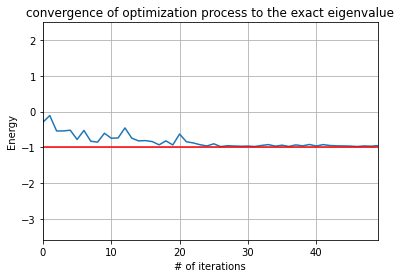

In [300]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)